In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os

import anndata as ad
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn
import torch
import tqdm

import celltrip


# Load Data and Policy

In [3]:
# Load train and validation data
adatas_train = celltrip.utility.processing.read_adatas(
    's3://nkalafut-celltrip/Cortex/brain_st_cortex_expression.h5ad',
    's3://nkalafut-celltrip/Cortex/brain_st_cortex_spatial.h5ad',
    backed=True)
adata_val, = celltrip.utility.processing.read_adatas(
    's3://nkalafut-celltrip/Cortex/brain_sc_expression.h5ad',
    backed=True)
# Model location and name (should contain .weights, .pre, and .mask file)
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/Cortex-250919', 800  # On lognorm data from authors
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/Cortex-250922', 800  # Raw data - best so far
prefix, training_step = 's3://nkalafut-celltrip/checkpoints/Cortex-251013', 800  # Raw data - 32 dim - USING
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/Cortex-251022', 800  # MSE + PAIR - 8 dim
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/Cortex-251023-cont', 1050  # MSE, 1024 PCA - 8 dim
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/Cortex-251024', 800  # MSE, 2048 PCA - 8 dim
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/Cortex-251024-2', 800  # MSE, 1024 PCA - 32 dim
# Generate or load preprocessing
preprocessing = celltrip.utility.processing.Preprocessing().load(f'{prefix}.pre')
# Create sample env (kind of a dumb workaround, TODO)
m1, m2 = [preprocessing.transform(ad[:2].X, subset_modality=i)[0] for i, ad in enumerate(adatas_train)]
env = celltrip.environment.EnvironmentBase(
    torch.tensor(m1), torch.tensor(m2), target_modalities=[1], compute_rewards=False, dim=32).eval().to('cuda')
# Load policy
policy = celltrip.policy.create_agent_from_env(
    env, forward_batch_size=1_000, vision_size=1_000).eval().to('cuda')  # , pinning_spatial=[1]
policy.load_checkpoint(f'{prefix}-{training_step:04}.weights');


In [4]:
# Load expression data
train_exp = adatas_train[0].X[:]
val_exp = adata_val.X[:]

# Scale with mean and std
# train_exp_log = np.log1p(train_exp)
# val_exp_log = np.log1p(val_exp)
# val_exp_log_norm = (val_exp_log - val_exp_log.mean(keepdims=True, axis=0)) / val_exp_log.std(keepdims=True, axis=0)
# val_exp_log_corrected = val_exp_log_norm * train_exp_log.std(keepdims=True, axis=0) + train_exp_log.mean(keepdims=True, axis=0)
# val_exp_log_corrected = np.nan_to_num(val_exp_log_corrected)
# val_exp_corrected = np.expm1(val_exp_log_corrected)
# val_exp_corrected = val_exp_corrected * 10_000 / val_exp_corrected.sum(keepdims=True, axis=1)

# Scale with mean
train_exp_log = np.log1p(train_exp)
val_exp_log = np.log1p(val_exp)
val_exp_log_norm = (val_exp_log - val_exp_log.mean(keepdims=True, axis=0))
val_exp_log_corrected = val_exp_log_norm + train_exp_log.mean(keepdims=True, axis=0)
val_exp_log_corrected = np.nan_to_num(val_exp_log_corrected)
val_exp_corrected = np.expm1(val_exp_log_corrected)
val_exp_corrected[val_exp_corrected < 0] = 0
val_exp_corrected = val_exp_corrected * 10_000 / val_exp_corrected.sum(keepdims=True, axis=1)

# Visualize differences
# import umap
# red = umap.UMAP()  # random_state=42
# train_red = red.fit_transform(train_exp)
# val_red = red.transform(val_exp)
# val_corr_red = red.transform(val_exp_corrected)
# plt.scatter(*train_red.T)
# plt.scatter(*val_red.T)
# plt.scatter(*val_corr_red.T)

# Generate Steady State

In [5]:
## Run on training data
# Initialize validation environment
m1, = preprocessing.transform(train_exp, subset_modality=0)
# Initialize environment and policy
env = celltrip.environment.EnvironmentBase(
    torch.tensor(m1), target_modalities=None, compute_rewards=False, dim=env.dim).eval(time_scale=1).to('cuda')
# Run policy to convergence
env.reset()
ret = celltrip.train.simulate_until_completion(env, policy, skip_states=100, store_states='cpu', progress_bar=True)
steady_state_train = ret[-1][-1, :, :env.dim]
# target_state = env.modalities[env.target_modalities[0]].cpu()
with torch.no_grad():
    imputed_steady_state_train = policy.pinning[0](steady_state_train.to('cuda')).detach().cpu().numpy()  # , Y=target_state.to('cuda')
imputed_steady_state_train, = preprocessing.inverse_transform(imputed_steady_state_train, subset_modality=1)

# Save
np.save(f'../plots/cortex/CellTRIP_Training.npy', imputed_steady_state_train)


1281it [00:07, 163.26it/s]


In [6]:
## Run on validation data
# Initialize validation environment
# m1, = preprocessing.transform(val_exp, subset_modality=0)
m1, = preprocessing.transform(val_exp_corrected, subset_modality=0)
# Initialize environment and policy
env = celltrip.environment.EnvironmentBase(
    torch.tensor(m1), target_modalities=None, compute_rewards=False, dim=env.dim).eval(time_scale=1).to('cuda')
# Run policy to convergence
env.reset()
ret = celltrip.train.simulate_until_completion(env, policy, skip_states=100, store_states='cpu', progress_bar=True)
steady_state = ret[-1][-1, :, :env.dim]
# target_state = env.modalities[env.target_modalities[0]].cpu()
with torch.no_grad():
    imputed_steady_state = policy.pinning[0](steady_state.to('cuda')).detach().cpu().numpy()  # , Y=target_state.to('cuda')
imputed_steady_state, = preprocessing.inverse_transform(imputed_steady_state, subset_modality=1)

# Use OT to match distributions
a, b, M_raw, OT_mat = celltrip.utility.general.compute_discrete_ot_matrix(imputed_steady_state, adatas_train[1].X[:])
max_idx = OT_mat.argmax(axis=1)
imputed_steady_state_OT = adatas_train[1].X[:][max_idx]
cost = M_raw[np.arange(M_raw.shape[0]), max_idx]

# Match distribution means
diff = adatas_train[1].X[:].mean(axis=0) - imputed_steady_state.mean(axis=0)

# Warp data to match distribution
train_spat = adatas_train[1].X[:]
imputed_steady_state_warp = (imputed_steady_state - imputed_steady_state.mean(keepdims=True, axis=0)) / imputed_steady_state.std(keepdims=True, axis=0)
imputed_steady_state_warp = (imputed_steady_state_warp * train_spat.std(keepdims=True, axis=0) + train_spat.mean(keepdims=True, axis=0))

# Filters
manual_mask = (imputed_steady_state[:, 1]<7000) * (imputed_steady_state[:, 1]>5000)  # Manual
cost_mask = cost < np.quantile(cost, .5)  # Cost
close_mask = scipy.spatial.distance_matrix(imputed_steady_state, adatas_train[1].X[:]).min(axis=1) < 100  # Distance from training

# Save
np.save(f'../plots/cortex/CellTRIP_Validation.npy', imputed_steady_state)
np.save(f'../plots/cortex/CellTRIP-Diff_Validation.npy', imputed_steady_state+diff)
np.save(f'../plots/cortex/CellTRIP-OT_Validation.npy', imputed_steady_state_OT)
np.save(f'../plots/cortex/CellTRIP-Warp_Validation.npy', imputed_steady_state_warp)
# Filters
np.save(f'../plots/cortex/CellTRIP-Manual_Mask.npy', cost_mask)
np.save(f'../plots/cortex/CellTRIP-Cost_Mask.npy', cost_mask)
np.save(f'../plots/cortex/CellTRIP-Close_Mask.npy', close_mask)


1281it [00:17, 71.48it/s]


## Preview

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import seaborn as sns
import sklearn.neighbors

In [9]:
# Load additional methods
cytospace_df = pd.read_csv(f'../plots/cortex/Cytospace_Validation.csv')
cytospace_mask = np.isin(adata_val.obs.index, cytospace_df['OriginalCID'])
celltrek_df = pd.read_csv(f'../plots/cortex/CellTREK_Validation.csv', index_col=0)
celltrek_mask = np.isin(adata_val.obs.index, celltrek_df.index)
tangram_ad = ad.read_h5ad('../plots/cortex/Tangram_Validation.h5ad')
chosen_idx = tangram_ad.X.argmax(axis=-1)
tangram_df = pd.DataFrame({
    'Training Cell': adatas_train[1].obs.index[chosen_idx],
    'Score': tangram_ad.X[np.arange(tangram_ad.shape[0]), chosen_idx]
}, index=adata_val.obs.index)
tangram_df[['x', 'y']] = adatas_train[1].X[:][chosen_idx]
# tangram_mask = tangram_df['Score'] >= tangram_df['Score'].quantile(.9)
ground_truth_df = pd.read_csv(f'../plots/cortex/Groundtruth_Validation.csv')

# Params
cluster_order = np.array([5, 2, 7, 1, 4, 6])
layer_order = np.array(['L1', 'L2/3', 'L4', 'L5', 'L6', 'L6b'])
subclass_order = np.array(['Astro', 'Vip', 'Lamp5', 'L2/3 IT', 'L4', 'L5 IT', 'L5 PT', 'NP', 'Pvalb', 'Sst', 'L6 IT', 'L6b'])
subclass_order = np.array(['Astro', 'Endo', 'Vip', 'Lamp5', 'L2/3 IT', 'L4', 'L5 IT', 'L5 PT', 'NP', 'Pvalb', 'Sncg', 'Sst', 'L6 IT', 'L6 CT', 'L6b'])

In [9]:
# Layer score prediction based on training
layer_scores_knn = sklearn.neighbors.KNeighborsRegressor(n_neighbors=1_000, weights='distance')
layer_scores_knn.fit(adatas_train[1].X[:], adatas_train[1].obs['seurat_clusters'].replace({k: v for k, v in zip(cluster_order, range(6))}));

# Layer score prediction based on imputed
layer_scores_train_knn = sklearn.neighbors.KNeighborsRegressor(n_neighbors=200, weights='uniform')
layer_scores_train_knn.fit(adatas_train[1].X[:], adatas_train[1].obs['seurat_clusters'].replace({k: v for k, v in zip(cluster_order, range(6))}))

KNeighborsRegressor(n_neighbors=200)

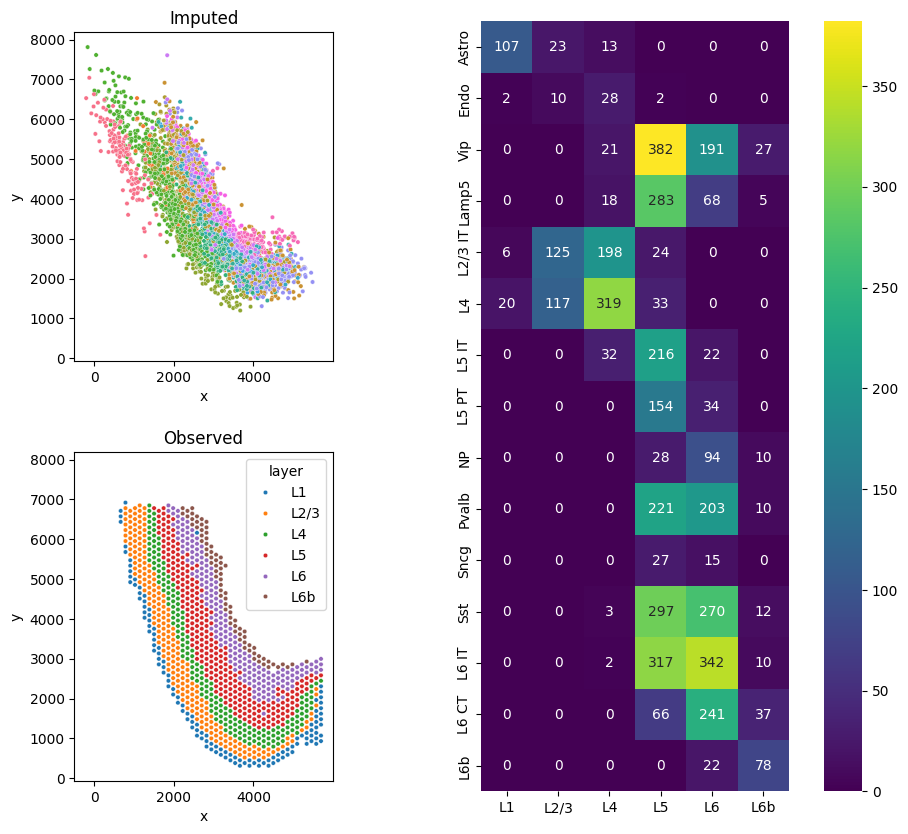

In [10]:
# Format true data
df_true = pd.DataFrame(index=adatas_train[1].obs.index)
df_true[['x', 'y']] = adatas_train[1].X[:]
df_true['cluster'] = adatas_train[1].obs['seurat_clusters']
df_true['layer'] = df_true['cluster'].replace({k: v for k, v in zip(cluster_order, layer_order)})

# Get imputed df
df_impute = pd.DataFrame(index=adata_val.obs.index)
imputed_to_use = imputed_steady_state
# imputed_to_use = imputed_steady_state + diff
# imputed_to_use = imputed_steady_state_OT
# imputed_to_use = imputed_steady_state_warp
# imputed_to_use = imputed_steady_state_expand
# imputed_to_use = tangram_df[['x', 'y']]
df_impute[['x', 'y']] = imputed_to_use
df_impute['subclass'] = adata_val.obs['subclass']

# Layer prediction by nearest in training
# knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=1, weights='distance')
# knn.fit(adatas_train[1].X[:], adatas_train[1].obs['seurat_clusters'])
# layers = knn.predict(imputed_to_use)
# df_impute['layer'] = layers

# Layer prediction by nearest predicted score
df = pd.DataFrame({
    'Layer': adatas_train[1].obs['seurat_clusters'],
    'Score': layer_scores_train_knn.predict(adatas_train[1].X[:])})
df_grouped = pd.concat([
    df.groupby('Layer').mean().rename(columns={'Score': 'Mean'}),
    df.groupby('Layer').std().rename(columns={'Score': 'STD'}),
    df.groupby('Layer').median().rename(columns={'Score': 'Median'}),
    df.groupby('Layer').agg(scipy.stats.iqr).rename(columns={'Score': 'IQR'}),
    df.groupby('Layer').size().to_frame('Percentage')], axis=1).reset_index()
df_grouped['Percentage'] /= df_grouped['Percentage'].sum()
mean_dist = layer_scores_train_knn.predict(imputed_to_use).reshape((1, -1)) - df_grouped[['Mean']].to_numpy()
z_scores = mean_dist / df_grouped[['STD']].to_numpy()
median_dist = layer_scores_train_knn.predict(imputed_to_use).reshape((1, -1)) - df_grouped[['Median']].to_numpy()
median_z_dist = median_dist / df_grouped[['IQR']].to_numpy()
# val_layers = df_grouped['Layer'].iloc[np.abs(mean_dist).argmin(axis=0)].to_numpy()
# val_layers = df_grouped['Layer'].iloc[np.abs(z_scores).argmin(axis=0)].to_numpy()
# val_layers = df_grouped['Layer'].iloc[np.abs(median_dist).argmin(axis=0)].to_numpy()
layers = df_grouped['Layer'].iloc[np.abs(median_z_dist).argmin(axis=0)].to_numpy()
# df_grouped.sort_values('Mean')
np.save(
    f'../plots/cortex/CellTRIP-ObservedKNN_Layers.npy',
    np.array([layer_order[np.argmax(cluster_order == l)] for l in layers]))
df_impute['layer'] = layers

# Filter
# mask = close_mask
# mask = scipy.spatial.distance_matrix(imputed_to_use, adatas_train[1].X[:]).min(axis=1) < 500
# mask = cytospace_mask
# mask = celltrek_mask
# mask = tangram_mask
mask = slice(None)
df_impute = df_impute.loc[mask]
# Construct heatmap
pivot_df = (
    df_impute.groupby(['subclass', 'layer'], observed=False).size()
    .reset_index(name='Count')
    .pivot(index='subclass', columns='layer', values='Count'))
pivot_df = pivot_df.fillna(0)
try:
    pivot_df = pivot_df.loc[subclass_order, cluster_order]
    pivot_df.columns = layer_order
except: pass

# Scatter
fig = plt.figure(figsize=(11, 10))
gs = mpl.gridspec.GridSpec(2, 2, fig, width_ratios=[3, 8], wspace=-.2)
ax_impute = fig.add_subplot(gs[0, 0])
ax_true = fig.add_subplot(gs[1, 0], sharex=ax_impute, sharey=ax_impute)
ax_heat = fig.add_subplot(gs[:, 1])

# Imputed and true
sns.scatterplot(df_impute, x='x', y='y', hue='subclass', hue_order=subclass_order, s=10., legend=False, ax=ax_impute)
ax_impute.set_title('Imputed')
ax_impute.set_aspect('equal')
# axs[0].set(xlim=[500, 6_000], ylim=[0, 7_000])
sns.scatterplot(df_true, x='x', y='y', hue='layer', hue_order=layer_order, s=10., ax=ax_true)
ax_true.set_title('Observed')
ax_true.set_aspect('equal')

# Heatmap
# pivot_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)  # Row normalize
# sns.heatmap(pivot_df, annot=False, fmt='.0f', cmap='Blues', cbar=False, ax=ax_heat)
sns.heatmap(pivot_df, annot=True, fmt='.0f', cmap='viridis', ax=ax_heat)
ax_heat.set_ylabel(None)
ax_heat.set_aspect('equal')


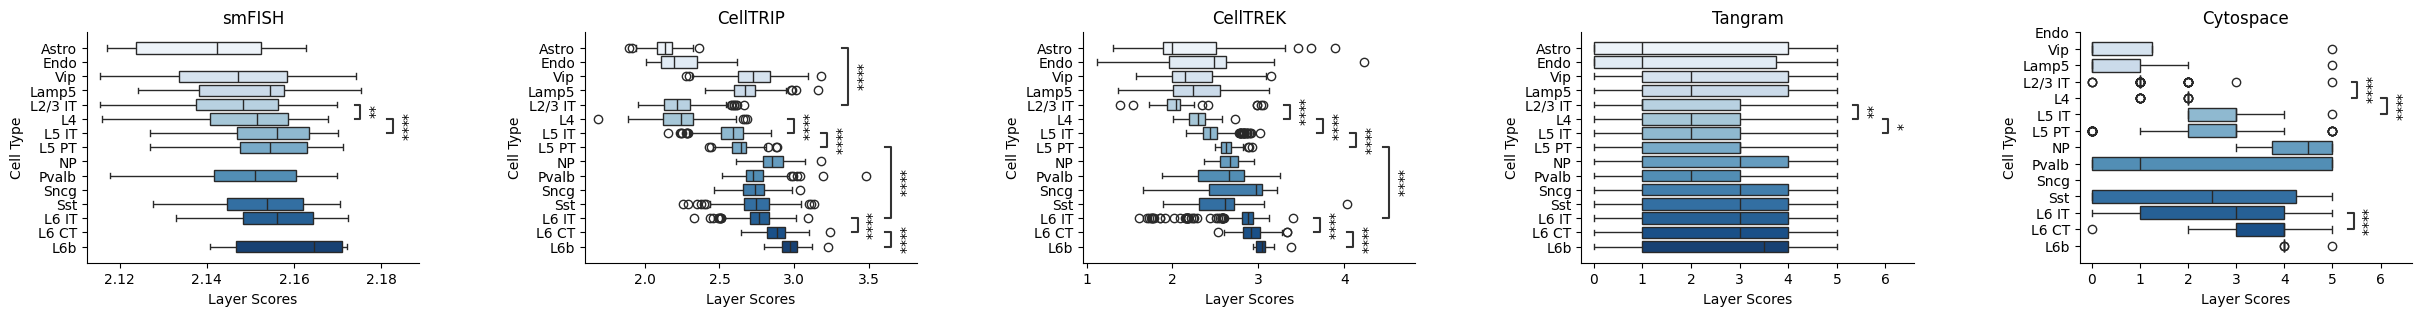

In [ ]:
# Plot
perf_runs = [
    {   'name': 'smFISH',
        'cell_types': ground_truth_df['subclass'],
        'imputed_to_use': ground_truth_df[['x', 'y']].to_numpy()},
    {   'name': 'CellTRIP',
        'cells_to_use': adata_val.obs.index[mask],
        'imputed_to_use': imputed_steady_state[mask]},
    {   'name': 'CellTREK',
        'cells_to_use': celltrek_df.index,
        'imputed_to_use': celltrek_df[['x', 'y']].to_numpy()},
    {   'name': 'Tangram',
        'cells_to_use': tangram_df.index,
        'imputed_to_use': tangram_df[['x', 'y']].to_numpy()},
    {   'name': 'Cytospace',
        'cells_to_use': cytospace_df['OriginalCID'],
        'imputed_to_use': cytospace_df[['x', 'y']].to_numpy()}]
# fig, axs = plt.subplots(len(perf_runs), 1, figsize=(5, 4*len(perf_runs)), sharex=False, sharey=True)
# fig.subplots_adjust(hspace=.5)
fig, axs = plt.subplots(1, len(perf_runs), figsize=(6*len(perf_runs), 3), sharex=False, sharey=False)
fig.subplots_adjust(wspace=.5)
axs = axs.flatten()
for perf_run, ax in zip(perf_runs, axs):
    # Get data
    layer_scores = layer_scores_knn.predict(perf_run['imputed_to_use'])

    # Parameters
    assert ('cells_to_use' in perf_run) or ('cell_types' in perf_run)
    if 'cells_to_use' not in perf_run:
        cell_types = perf_run['cell_types']
        cells_to_use = np.arange(cell_types.shape[0])
    if 'cell_types' not in perf_run:
        cells_to_use = perf_run['cells_to_use']
        cell_types = adata_val[cells_to_use].obs['subclass']

    # Format data
    df_impute = pd.DataFrame(index=cells_to_use)
    df_impute['Cell Type'] = cell_types
    ct_nums = {k: v for v, k in enumerate(subclass_order)}
    df_impute['Cell Type Number'] = df_impute['Cell Type'].astype(str).apply(lambda s: ct_nums[s] if s in ct_nums else -1)
    df_impute['Layer Scores'] = layer_scores
    cell_means = df_impute[['Cell Type', 'Layer Scores']].groupby('Cell Type', observed=False).mean()
    df_impute['Mean Diff'] = df_impute['Layer Scores'] - df_impute['Cell Type'].apply(lambda s: cell_means.loc[s, 'Layer Scores']).astype(float)
    df_impute['Mean Diff'] = df_impute['Mean Diff'].abs()

    # Get correlation
    df_impute_filt = df_impute.loc[df_impute['Cell Type Number'] != -1]
    correlation_result = scipy.stats.pearsonr(df_impute_filt['Cell Type Number'], df_impute_filt['Layer Scores'])

    # Plot
    df = df_impute.reset_index()
    sns.boxplot(
        df, x='Layer Scores', y='Cell Type', orient='h', order=subclass_order,
        hue='Cell Type', hue_order=subclass_order, palette='Blues', ax=ax)
    sns.despine(ax=ax)
    ax.set_title(perf_run['name'])

    # Correlation annotation
    # ax.text(
    #     1., 1.12, f'pearson={correlation_result.statistic:.3f}\np={correlation_result.pvalue:.2e}',
    #     ha='right', va='top', bbox=dict(facecolor='white', edgecolor='black'), transform=ax.transAxes)
    
    # Annotations
    from statannotations.Annotator import Annotator
    # Append dummy data for missing CTs to appease statannotations
    df_use = df.copy()
    for sc in subclass_order:
        if sc not in df['Cell Type'].unique():
            df_dummy = df_use.iloc[:2].copy()
            df_dummy['Cell Type'] = sc
            df_use = pd.concat([df_use, df_dummy], axis=0)

    pairs = [
        ('Astro', 'L2/3 IT'), ('L2/3 IT', 'L4'), ('L4', 'L5 IT'),
        ('L5 IT', 'L5 PT'), ('L5 PT', 'L6 IT'), ('L6 IT', 'L6 CT'),
        ('L6 CT', 'L6b')]
    annotator = Annotator(ax, pairs, data=df_use, x='Layer Scores', y='Cell Type', orient='h', order=subclass_order)
    annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', hide_non_significant=True, verbose=False)
    annotator.apply_and_annotate()

fig.savefig('../plots/cortex/Layer_Score_Comparison.pdf')

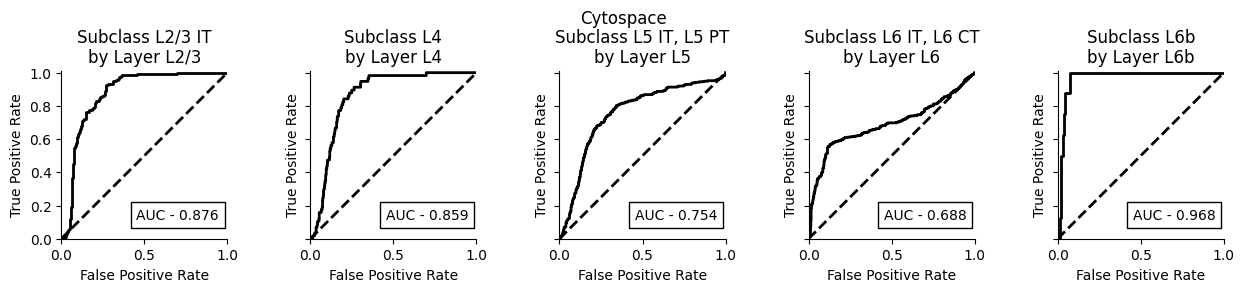

In [ ]:
# Combinations
combinations = [
    ('L2/3', ['L2/3 IT']),
    ('L4', ['L4']),
    ('L5', ['L5 IT', 'L5 PT']),
    ('L6', ['L6 IT', 'L6 CT']),
    ('L6b', ['L6b'])]

# Create figure
fig, axs = plt.subplots(
    1, 5,
    sharex=True, sharey=True,
    figsize=(5*3, 1*3))
axs = axs.flatten()
fig.subplots_adjust(wspace=.5)

for ax, (layer, subclass) in zip(axs, combinations):
    # Define targets
    cluster_idx = cluster_order[np.argmax(layer_order==layer)]
    y_train = adatas_train[1].obs['seurat_clusters'] == cluster_idx
    X_train = adatas_train[1].X[:]
    # X_train = imputed_steady_state_train

    # Get evaluation data
    # Subregion
    # fig.suptitle('Subregion')
    # X_val = ground_truth_df[['x', 'y']].to_numpy()
    # y_ct = ground_truth_df['subclass']
    # CellTRIP
    fig.suptitle('CellTRIP')
    X_val = imputed_to_use
    y_ct = adata_val.obs['subclass']
    # CellTREK
    # fig.suptitle('CellTREK')
    # X_val = celltrek_df[['x', 'y']].to_numpy()
    # y_ct = adata_val.obs.loc[celltrek_df.index, 'subclass']
    # Tangram
    # fig.suptitle('Tangram')
    # X_val = tangram_df[['x', 'y']].to_numpy()
    # y_ct = adata_val.obs.loc[tangram_df.index, 'subclass']
    # Cytospace
    # fig.suptitle('Cytospace')
    # X_val = cytospace_df[['x', 'y']].to_numpy()
    # y_ct = adata_val.obs.loc[cytospace_df['OriginalCID'], 'subclass']

    # Get y_val
    y_val = np.isin(y_ct, subclass)

    # Filter to only excitatory
    import re
    pattern = re.compile('^L\d.*$')
    ex_mask = [pattern.match(s) is not None for s in y_ct]

    # Train SVC
    svc = sklearn.svm.SVC(probability=True).fit(X_train, y_train)
    y_val_pred = svc.predict_proba(X_val)[:, 1]
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_val[ex_mask], y_val_pred[ex_mask])
    auc = sklearn.metrics.auc(fpr, tpr)

    # Plot
    ax.plot(fpr, tpr, lw=2, color='black')
    ax.plot([0, 1], [0, 1], ls='--', lw=2, color='black')
    ax.set(xlim=[0, 1], ylim=[0, 1.01])
    ax.set(
        title=f'Subclass {", ".join(subclass)}\nby Layer {layer}',
        xlabel='False Positive Rate',
        ylabel='True Positive Rate')
    ax.text(
        .95, .1, f'AUC - {auc:.3f}',
        ha='right', va='bottom', 
        bbox=dict(facecolor='white', edgecolor='black'),
        transform=ax.transAxes)
    ax.set_aspect('equal')
    sns.despine(ax=ax)

# Perform Perturbation Prediction

In [13]:
# Params
np.random.seed(42)
adatas = [adata_val]
# genes_to_survey = np.random.choice(adatas[0].var_names, 2_000, replace=False)
# assert preprocessing.filter_mask[0] is None
# genes_to_survey = adatas[0].var_names[preprocessing.standardize_std[0].flatten().argsort()[::-1]][:2000]  # 2k hvg
genes_to_survey = adatas[0].var_names
sim_time = 1.

# Mute warnings (array wrap and indexing)
import warnings
warnings.simplefilter('ignore')

# Create anndata
ad_pert = ad.AnnData(obs=adatas[0].obs, var=pd.DataFrame(index=[f'Feature {i}' for i in range(env.dim)]))
ad_pert.write_h5ad('../plots/cortex/knockdown_results.h5ad')
ad_pert_f = h5py.File('../plots/cortex/knockdown_results.h5ad', 'r+')
layers_group = ad_pert_f.require_group('layers')
def add_layers(states, gene):
    # ad_pert.layers[gene] = states
    layers_group.create_dataset(gene, data=states, compression='gzip')

# Add results
results = []
def add_record(states, states_0, gene, ct):
    results.append({
        'Gene': gene, 'Cell Type': ct,
        'Effect Size (Latent)': np.square(states[-1] - states[0]).mean(),
        'Trajectory Length (Latent)': np.square(states[1:] - states[:-1]).mean(axis=(-2, -1)).sum(),
        'Effect Size (Spatial)': np.square(states_0[-1] - states_0[0]).mean(),
        'Trajectory Length (Spatial)': np.square(states_0[1:] - states_0[:-1]).mean(axis=(-2, -1)).sum()})
    
# Reset function
def reset_env(env, steady_pos, steady_vel, modal_dict={}):
    env.set_max_time(sim_time).reset()  # TODO: Maybe longer?, early stopping?
    env.set_positions(steady_pos)
    env.set_velocities(steady_vel)  # Maybe 0 manually?
    for k, v in modal_dict.items():
        env.modalities[k] = v

# Running function
def run_and_record(samples, env, policy, preprocessing, gene, gene_idx):
    # Run and impute
    states = celltrip.train.simulate_until_completion(
        env, policy,
        env_hooks=[
            celltrip.utility.hooks.clamp_inverted_features_hook(
                gene_idx, preprocessing, feature_targets=0., modality_idx=0),
        ],
        action_hooks=[
            # celltrip.utility.hooks.move_toward_targets_hook(
            #     gene_idx, feature_targets=0., pinning=policy.pinning[0],
            #     preprocessing=preprocessing, modality_idx=0,
            #     factor=1, device=env.device),
        ],
        skip_states=100, store_states='cpu')[-1]
    states_pos = states[..., :env.dim]
    with torch.no_grad():
        imputed_states_1 = policy.pinning[0](states_pos.to('cuda')).detach().cpu().numpy()
    imputed_states_1, = preprocessing.inverse_transform(imputed_states_1, subset_modality=1)
    # Record
    add_layers(states_pos.numpy()[-1], gene)  # , imputed_states_0[-1], imputed_states_1[-1]
    add_record(states_pos.numpy(), imputed_states_1, gene, 'All')
    for ct in adatas[0][samples].obs['subclass'].unique():
        add_record(
            states_pos[:, adatas[0][samples].obs['subclass']==ct].numpy(),
            imputed_states_1[:, adatas[0][samples].obs['subclass']==ct],
            gene, ct)

# Subset and preprocess the data
samples = adatas[0].obs.index
# m1, = preprocessing.transform(val_exp, subset_modality=0)
m1, = preprocessing.transform(val_exp_corrected, subset_modality=0)

# Initialize environment
env = celltrip.environment.EnvironmentBase(
    torch.tensor(m1), target_modalities=None, compute_rewards=False, dim=env.dim).eval(time_scale=1).to('cuda')

# Simulate to steady state
env.reset()
celltrip.train.simulate_until_completion(env, policy)
steady_pos, steady_vel = (env.pos, env.vel)

# Run control
reset_env(env, steady_pos, steady_vel)
add_layers(steady_pos.cpu().numpy(), 'Steady')
run_and_record(samples, env, policy, preprocessing, 'Control', [])

# Perturb
for gene in tqdm.tqdm(genes_to_survey, miniters=10, maxinterval=30):
    # Get gene idx and run
    gene_idx = np.argwhere(adatas[0].var_names==gene).flatten()
    reset_env(env, steady_pos, steady_vel)  # {0: torch.tensor(m1).cuda()}
    run_and_record(samples, env, policy, preprocessing, gene, gene_idx)

# Convert and save
pd.DataFrame(results).to_csv('../plots/cortex/knockdown.csv', index=None)
ad_pert_f.close()



  0%|                                                                                                                                                                                            | 0/19293 [00:00<?, ?it/s]


  0%|                                                                                                                                                                                 | 10/19293 [00:15<8:30:21,  1.59s/it]


  0%|▏                                                                                                                                                                                | 20/19293 [00:31<8:30:11,  1.59s/it]


  0%|▎                                                                                                                                                                                | 30/19293 [00:49<8:50:32,  1.65s/it]


  0%|▎                                                                                                                                                                                | 40/19293 [01:04<8:42:03,  1.63s/it]


  0%|▍                                                                                                                                                                                | 50/19293 [01:20<8:38:21,  1.62s/it]


  0%|▌                                                                                                                                                                                | 60/19293 [01:36<8:35:40,  1.61s/it]


  0%|▋                                                                                                                                                                                | 70/19293 [01:52<8:33:43,  1.60s/it]


  0%|▋                                                                                                                                                                                | 80/19293 [02:08<8:33:03,  1.60s/it]


  0%|▊                                                                                                                                                                                | 90/19293 [02:24<8:32:02,  1.60s/it]


  1%|▉                                                                                                                                                                               | 100/19293 [02:40<8:33:30,  1.61s/it]


  1%|█                                                                                                                                                                               | 110/19293 [02:56<8:32:27,  1.60s/it]


  1%|█                                                                                                                                                                               | 120/19293 [03:12<8:31:16,  1.60s/it]


  1%|█▏                                                                                                                                                                              | 130/19293 [03:28<8:30:25,  1.60s/it]


  1%|█▎                                                                                                                                                                              | 140/19293 [03:44<8:30:58,  1.60s/it]


  1%|█▎                                                                                                                                                                              | 150/19293 [04:00<8:29:17,  1.60s/it]


  1%|█▍                                                                                                                                                                              | 160/19293 [04:16<8:30:27,  1.60s/it]


  1%|█▌                                                                                                                                                                              | 170/19293 [04:32<8:29:24,  1.60s/it]


  1%|█▋                                                                                                                                                                              | 180/19293 [04:48<8:28:40,  1.60s/it]


  1%|█▋                                                                                                                                                                              | 190/19293 [05:04<8:28:53,  1.60s/it]


  1%|█▊                                                                                                                                                                              | 200/19293 [05:20<8:28:24,  1.60s/it]


  1%|█▉                                                                                                                                                                              | 210/19293 [05:36<8:27:30,  1.60s/it]


  1%|██                                                                                                                                                                              | 220/19293 [05:52<8:29:00,  1.60s/it]


  1%|██                                                                                                                                                                              | 230/19293 [06:08<8:27:38,  1.60s/it]


  1%|██▏                                                                                                                                                                             | 240/19293 [06:24<8:27:07,  1.60s/it]


  1%|██▎                                                                                                                                                                             | 250/19293 [06:40<8:26:11,  1.59s/it]


  1%|██▎                                                                                                                                                                             | 260/19293 [06:56<8:26:32,  1.60s/it]


  1%|██▍                                                                                                                                                                             | 270/19293 [07:12<8:26:33,  1.60s/it]


  1%|██▌                                                                                                                                                                             | 280/19293 [07:28<8:28:02,  1.60s/it]


  2%|██▋                                                                                                                                                                             | 290/19293 [07:44<8:30:59,  1.61s/it]


  2%|██▋                                                                                                                                                                             | 300/19293 [08:01<8:31:28,  1.62s/it]


  2%|██▊                                                                                                                                                                             | 310/19293 [08:17<8:29:30,  1.61s/it]


  2%|██▉                                                                                                                                                                             | 320/19293 [08:33<8:28:18,  1.61s/it]


  2%|███                                                                                                                                                                             | 330/19293 [08:49<8:26:18,  1.60s/it]


  2%|███                                                                                                                                                                             | 340/19293 [09:04<8:25:05,  1.60s/it]


  2%|███▏                                                                                                                                                                            | 350/19293 [09:21<8:25:43,  1.60s/it]


  2%|███▎                                                                                                                                                                            | 360/19293 [09:37<8:24:56,  1.60s/it]


  2%|███▍                                                                                                                                                                            | 370/19293 [09:52<8:24:27,  1.60s/it]


  2%|███▍                                                                                                                                                                            | 380/19293 [10:09<8:24:23,  1.60s/it]


  2%|███▌                                                                                                                                                                            | 390/19293 [10:24<8:23:20,  1.60s/it]


  2%|███▋                                                                                                                                                                            | 400/19293 [10:40<8:22:04,  1.59s/it]


  2%|███▋                                                                                                                                                                            | 410/19293 [10:56<8:21:56,  1.59s/it]


  2%|███▊                                                                                                                                                                            | 420/19293 [11:13<8:24:46,  1.60s/it]


  2%|███▉                                                                                                                                                                            | 430/19293 [11:28<8:23:23,  1.60s/it]


  2%|████                                                                                                                                                                            | 440/19293 [11:45<8:27:59,  1.62s/it]


  2%|████                                                                                                                                                                            | 450/19293 [12:03<8:45:56,  1.67s/it]


  2%|████▏                                                                                                                                                                           | 460/19293 [12:20<8:51:47,  1.69s/it]


  2%|████▎                                                                                                                                                                           | 470/19293 [12:38<8:55:32,  1.71s/it]


  2%|████▍                                                                                                                                                                           | 480/19293 [12:54<8:50:08,  1.69s/it]


  3%|████▍                                                                                                                                                                           | 490/19293 [13:12<8:52:53,  1.70s/it]


  3%|████▌                                                                                                                                                                           | 500/19293 [13:29<8:53:31,  1.70s/it]


  3%|████▋                                                                                                                                                                           | 510/19293 [13:46<8:54:54,  1.71s/it]


  3%|████▋                                                                                                                                                                           | 520/19293 [14:03<8:53:53,  1.71s/it]


  3%|████▊                                                                                                                                                                           | 530/19293 [14:20<8:54:40,  1.71s/it]


  3%|████▉                                                                                                                                                                           | 540/19293 [14:37<8:52:12,  1.70s/it]


  3%|█████                                                                                                                                                                           | 550/19293 [14:54<8:50:01,  1.70s/it]


  3%|█████                                                                                                                                                                           | 560/19293 [15:10<8:44:13,  1.68s/it]


  3%|█████▏                                                                                                                                                                          | 570/19293 [15:26<8:35:58,  1.65s/it]


  3%|█████▎                                                                                                                                                                          | 580/19293 [15:42<8:29:52,  1.63s/it]


  3%|█████▍                                                                                                                                                                          | 590/19293 [15:58<8:25:21,  1.62s/it]


  3%|█████▍                                                                                                                                                                          | 600/19293 [16:14<8:21:57,  1.61s/it]


  3%|█████▌                                                                                                                                                                          | 610/19293 [16:30<8:19:23,  1.60s/it]


  3%|█████▋                                                                                                                                                                          | 620/19293 [16:46<8:20:26,  1.61s/it]


  3%|█████▋                                                                                                                                                                          | 630/19293 [17:02<8:18:47,  1.60s/it]


  3%|█████▊                                                                                                                                                                          | 640/19293 [17:18<8:17:59,  1.60s/it]


  3%|█████▉                                                                                                                                                                          | 650/19293 [17:34<8:17:24,  1.60s/it]


  3%|██████                                                                                                                                                                          | 660/19293 [17:50<8:16:25,  1.60s/it]


  3%|██████                                                                                                                                                                          | 670/19293 [18:06<8:15:09,  1.60s/it]


  4%|██████▏                                                                                                                                                                         | 680/19293 [18:22<8:17:02,  1.60s/it]


  4%|██████▎                                                                                                                                                                         | 690/19293 [18:38<8:16:03,  1.60s/it]


  4%|██████▍                                                                                                                                                                         | 700/19293 [18:54<8:15:11,  1.60s/it]


  4%|██████▍                                                                                                                                                                         | 710/19293 [19:10<8:14:59,  1.60s/it]


  4%|██████▌                                                                                                                                                                         | 720/19293 [19:26<8:15:07,  1.60s/it]


  4%|██████▋                                                                                                                                                                         | 730/19293 [19:42<8:14:22,  1.60s/it]


  4%|██████▊                                                                                                                                                                         | 740/19293 [19:58<8:15:56,  1.60s/it]


  4%|██████▊                                                                                                                                                                         | 750/19293 [20:14<8:14:37,  1.60s/it]


  4%|██████▉                                                                                                                                                                         | 760/19293 [20:30<8:13:48,  1.60s/it]


  4%|███████                                                                                                                                                                         | 770/19293 [20:46<8:12:48,  1.60s/it]


  4%|███████                                                                                                                                                                         | 780/19293 [21:02<8:13:06,  1.60s/it]


  4%|███████▏                                                                                                                                                                        | 790/19293 [21:17<8:12:22,  1.60s/it]


  4%|███████▎                                                                                                                                                                        | 800/19293 [21:34<8:14:30,  1.60s/it]


  4%|███████▍                                                                                                                                                                        | 810/19293 [21:50<8:13:17,  1.60s/it]


  4%|███████▍                                                                                                                                                                        | 820/19293 [22:06<8:12:42,  1.60s/it]


  4%|███████▌                                                                                                                                                                        | 830/19293 [22:22<8:15:52,  1.61s/it]


  4%|███████▋                                                                                                                                                                        | 840/19293 [22:38<8:14:11,  1.61s/it]


  4%|███████▊                                                                                                                                                                        | 850/19293 [22:54<8:12:35,  1.60s/it]


  4%|███████▊                                                                                                                                                                        | 860/19293 [23:10<8:12:33,  1.60s/it]


  5%|███████▉                                                                                                                                                                        | 870/19293 [23:26<8:16:33,  1.62s/it]


  5%|████████                                                                                                                                                                        | 880/19293 [23:42<8:14:36,  1.61s/it]


  5%|████████                                                                                                                                                                        | 890/19293 [23:58<8:12:55,  1.61s/it]


  5%|████████▏                                                                                                                                                                       | 900/19293 [24:14<8:11:32,  1.60s/it]


  5%|████████▎                                                                                                                                                                       | 910/19293 [24:30<8:10:04,  1.60s/it]


  5%|████████▍                                                                                                                                                                       | 920/19293 [24:46<8:09:00,  1.60s/it]


  5%|████████▍                                                                                                                                                                       | 930/19293 [25:02<8:10:38,  1.60s/it]


  5%|████████▌                                                                                                                                                                       | 940/19293 [25:18<8:10:25,  1.60s/it]


  5%|████████▋                                                                                                                                                                       | 950/19293 [25:34<8:09:00,  1.60s/it]


  5%|████████▊                                                                                                                                                                       | 960/19293 [25:51<8:14:50,  1.62s/it]


  5%|████████▊                                                                                                                                                                       | 970/19293 [26:07<8:12:42,  1.61s/it]


  5%|████████▉                                                                                                                                                                       | 980/19293 [26:23<8:10:28,  1.61s/it]


  5%|█████████                                                                                                                                                                       | 990/19293 [26:39<8:11:39,  1.61s/it]


  5%|█████████                                                                                                                                                                      | 1000/19293 [26:55<8:10:06,  1.61s/it]


  5%|█████████▏                                                                                                                                                                     | 1010/19293 [27:11<8:08:55,  1.60s/it]


  5%|█████████▎                                                                                                                                                                     | 1020/19293 [27:27<8:07:54,  1.60s/it]


  5%|█████████▎                                                                                                                                                                     | 1030/19293 [27:43<8:06:41,  1.60s/it]


  5%|█████████▍                                                                                                                                                                     | 1040/19293 [27:59<8:05:45,  1.60s/it]


  5%|█████████▌                                                                                                                                                                     | 1050/19293 [28:15<8:04:45,  1.59s/it]


  5%|█████████▌                                                                                                                                                                     | 1060/19293 [28:31<8:06:09,  1.60s/it]


  6%|█████████▋                                                                                                                                                                     | 1070/19293 [28:47<8:06:40,  1.60s/it]


  6%|█████████▊                                                                                                                                                                     | 1080/19293 [29:03<8:05:27,  1.60s/it]


  6%|█████████▉                                                                                                                                                                     | 1090/19293 [29:19<8:04:40,  1.60s/it]


  6%|█████████▉                                                                                                                                                                     | 1100/19293 [29:35<8:04:09,  1.60s/it]


  6%|██████████                                                                                                                                                                     | 1110/19293 [29:51<8:03:49,  1.60s/it]


  6%|██████████▏                                                                                                                                                                    | 1120/19293 [30:07<8:04:50,  1.60s/it]


  6%|██████████▏                                                                                                                                                                    | 1130/19293 [30:23<8:03:54,  1.60s/it]


  6%|██████████▎                                                                                                                                                                    | 1140/19293 [30:39<8:03:26,  1.60s/it]


  6%|██████████▍                                                                                                                                                                    | 1150/19293 [30:55<8:02:46,  1.60s/it]


  6%|██████████▌                                                                                                                                                                    | 1160/19293 [31:11<8:02:10,  1.60s/it]


  6%|██████████▌                                                                                                                                                                    | 1170/19293 [31:26<8:01:23,  1.59s/it]


  6%|██████████▋                                                                                                                                                                    | 1180/19293 [31:42<8:01:49,  1.60s/it]


  6%|██████████▊                                                                                                                                                                    | 1190/19293 [31:59<8:04:01,  1.60s/it]


  6%|██████████▉                                                                                                                                                                    | 1200/19293 [32:15<8:02:34,  1.60s/it]


  6%|██████████▉                                                                                                                                                                    | 1210/19293 [32:31<8:01:16,  1.60s/it]


  6%|███████████                                                                                                                                                                    | 1220/19293 [32:46<8:00:27,  1.60s/it]


  6%|███████████▏                                                                                                                                                                   | 1230/19293 [33:02<7:59:58,  1.59s/it]


  6%|███████████▏                                                                                                                                                                   | 1240/19293 [33:18<8:00:05,  1.60s/it]


  6%|███████████▎                                                                                                                                                                   | 1250/19293 [33:34<7:59:19,  1.59s/it]


  7%|███████████▍                                                                                                                                                                   | 1260/19293 [33:50<8:00:58,  1.60s/it]


  7%|███████████▌                                                                                                                                                                   | 1270/19293 [34:06<8:00:03,  1.60s/it]


  7%|███████████▌                                                                                                                                                                   | 1280/19293 [34:22<7:59:41,  1.60s/it]


  7%|███████████▋                                                                                                                                                                   | 1290/19293 [34:38<8:00:00,  1.60s/it]


  7%|███████████▊                                                                                                                                                                   | 1300/19293 [34:54<7:59:03,  1.60s/it]


  7%|███████████▉                                                                                                                                                                   | 1310/19293 [35:10<7:58:30,  1.60s/it]


  7%|███████████▉                                                                                                                                                                   | 1320/19293 [35:26<8:00:01,  1.60s/it]


  7%|████████████                                                                                                                                                                   | 1330/19293 [35:42<7:59:53,  1.60s/it]


  7%|████████████▏                                                                                                                                                                  | 1340/19293 [35:58<7:59:32,  1.60s/it]


  7%|████████████▏                                                                                                                                                                  | 1350/19293 [36:14<7:59:23,  1.60s/it]


  7%|████████████▎                                                                                                                                                                  | 1360/19293 [36:30<7:58:01,  1.60s/it]


  7%|████████████▍                                                                                                                                                                  | 1370/19293 [36:46<7:57:04,  1.60s/it]


  7%|████████████▌                                                                                                                                                                  | 1380/19293 [37:02<7:58:11,  1.60s/it]


  7%|████████████▌                                                                                                                                                                  | 1390/19293 [37:18<7:56:53,  1.60s/it]


  7%|████████████▋                                                                                                                                                                  | 1400/19293 [37:34<7:56:10,  1.60s/it]


  7%|████████████▊                                                                                                                                                                  | 1410/19293 [37:50<7:55:35,  1.60s/it]


  7%|████████████▉                                                                                                                                                                  | 1420/19293 [38:06<7:55:47,  1.60s/it]


  7%|████████████▉                                                                                                                                                                  | 1430/19293 [38:22<7:55:29,  1.60s/it]


  7%|█████████████                                                                                                                                                                  | 1440/19293 [38:38<7:58:19,  1.61s/it]


  8%|█████████████▏                                                                                                                                                                 | 1450/19293 [38:54<7:57:15,  1.60s/it]


  8%|█████████████▏                                                                                                                                                                 | 1460/19293 [39:10<7:55:46,  1.60s/it]


  8%|█████████████▎                                                                                                                                                                 | 1470/19293 [39:26<7:55:14,  1.60s/it]


  8%|█████████████▍                                                                                                                                                                 | 1480/19293 [39:42<7:54:06,  1.60s/it]


  8%|█████████████▌                                                                                                                                                                 | 1490/19293 [39:58<7:53:28,  1.60s/it]


  8%|█████████████▌                                                                                                                                                                 | 1500/19293 [40:14<7:52:45,  1.59s/it]


  8%|█████████████▋                                                                                                                                                                 | 1510/19293 [40:30<7:54:12,  1.60s/it]


  8%|█████████████▊                                                                                                                                                                 | 1520/19293 [40:46<7:53:01,  1.60s/it]


  8%|█████████████▉                                                                                                                                                                 | 1530/19293 [41:02<7:53:00,  1.60s/it]


  8%|█████████████▉                                                                                                                                                                 | 1540/19293 [41:18<7:51:59,  1.60s/it]


  8%|██████████████                                                                                                                                                                 | 1550/19293 [41:34<7:52:03,  1.60s/it]


  8%|██████████████▏                                                                                                                                                                | 1560/19293 [41:50<7:51:54,  1.60s/it]


  8%|██████████████▏                                                                                                                                                                | 1570/19293 [42:06<7:53:23,  1.60s/it]


  8%|██████████████▎                                                                                                                                                                | 1580/19293 [42:22<7:52:19,  1.60s/it]


  8%|██████████████▍                                                                                                                                                                | 1590/19293 [42:38<7:52:29,  1.60s/it]


  8%|██████████████▌                                                                                                                                                                | 1600/19293 [42:54<7:51:51,  1.60s/it]


  8%|██████████████▌                                                                                                                                                                | 1610/19293 [43:10<7:51:34,  1.60s/it]


  8%|██████████████▋                                                                                                                                                                | 1620/19293 [43:26<7:50:51,  1.60s/it]


  8%|██████████████▊                                                                                                                                                                | 1630/19293 [43:42<7:52:25,  1.60s/it]


  9%|██████████████▉                                                                                                                                                                | 1640/19293 [43:58<7:51:04,  1.60s/it]


  9%|██████████████▉                                                                                                                                                                | 1650/19293 [44:14<7:50:24,  1.60s/it]


  9%|███████████████                                                                                                                                                                | 1660/19293 [44:30<7:49:51,  1.60s/it]


  9%|███████████████▏                                                                                                                                                               | 1670/19293 [44:46<7:49:08,  1.60s/it]


  9%|███████████████▏                                                                                                                                                               | 1680/19293 [45:02<7:48:20,  1.60s/it]


  9%|███████████████▎                                                                                                                                                               | 1690/19293 [45:18<7:47:47,  1.59s/it]


  9%|███████████████▍                                                                                                                                                               | 1700/19293 [45:34<7:49:35,  1.60s/it]


  9%|███████████████▌                                                                                                                                                               | 1710/19293 [45:50<7:48:42,  1.60s/it]


  9%|███████████████▌                                                                                                                                                               | 1720/19293 [46:06<7:47:42,  1.60s/it]


  9%|███████████████▋                                                                                                                                                               | 1730/19293 [46:22<7:48:14,  1.60s/it]


  9%|███████████████▊                                                                                                                                                               | 1740/19293 [46:38<7:47:45,  1.60s/it]


  9%|███████████████▊                                                                                                                                                               | 1750/19293 [46:54<7:46:40,  1.60s/it]


  9%|███████████████▉                                                                                                                                                               | 1760/19293 [47:10<7:47:58,  1.60s/it]


  9%|████████████████                                                                                                                                                               | 1770/19293 [47:26<7:47:25,  1.60s/it]


  9%|████████████████▏                                                                                                                                                              | 1780/19293 [47:42<7:46:30,  1.60s/it]


  9%|████████████████▏                                                                                                                                                              | 1790/19293 [47:58<7:45:59,  1.60s/it]


  9%|████████████████▎                                                                                                                                                              | 1800/19293 [48:14<7:45:23,  1.60s/it]


  9%|████████████████▍                                                                                                                                                              | 1810/19293 [48:30<7:45:04,  1.60s/it]


  9%|████████████████▌                                                                                                                                                              | 1820/19293 [48:46<7:48:23,  1.61s/it]


  9%|████████████████▌                                                                                                                                                              | 1830/19293 [49:02<7:46:21,  1.60s/it]


 10%|████████████████▋                                                                                                                                                              | 1840/19293 [49:18<7:45:48,  1.60s/it]


 10%|████████████████▊                                                                                                                                                              | 1850/19293 [49:34<7:44:42,  1.60s/it]


 10%|████████████████▊                                                                                                                                                              | 1860/19293 [49:50<7:43:34,  1.60s/it]


 10%|████████████████▉                                                                                                                                                              | 1870/19293 [50:06<7:42:21,  1.59s/it]


 10%|█████████████████                                                                                                                                                              | 1880/19293 [50:21<7:41:28,  1.59s/it]


 10%|█████████████████▏                                                                                                                                                             | 1890/19293 [50:38<7:43:06,  1.60s/it]


 10%|█████████████████▏                                                                                                                                                             | 1900/19293 [50:54<7:42:40,  1.60s/it]


 10%|█████████████████▎                                                                                                                                                             | 1910/19293 [51:10<7:43:01,  1.60s/it]


 10%|█████████████████▍                                                                                                                                                             | 1920/19293 [51:25<7:41:58,  1.60s/it]


 10%|█████████████████▌                                                                                                                                                             | 1930/19293 [51:41<7:40:46,  1.59s/it]


 10%|█████████████████▌                                                                                                                                                             | 1940/19293 [51:57<7:40:07,  1.59s/it]


 10%|█████████████████▋                                                                                                                                                             | 1950/19293 [52:13<7:41:28,  1.60s/it]


 10%|█████████████████▊                                                                                                                                                             | 1960/19293 [52:29<7:40:30,  1.59s/it]


 10%|█████████████████▊                                                                                                                                                             | 1970/19293 [52:45<7:39:38,  1.59s/it]


 10%|█████████████████▉                                                                                                                                                             | 1980/19293 [53:01<7:39:17,  1.59s/it]


 10%|██████████████████                                                                                                                                                             | 1990/19293 [53:17<7:38:59,  1.59s/it]


 10%|██████████████████▏                                                                                                                                                            | 2000/19293 [53:33<7:38:07,  1.59s/it]


 10%|██████████████████▏                                                                                                                                                            | 2010/19293 [53:49<7:40:42,  1.60s/it]


 10%|██████████████████▎                                                                                                                                                            | 2020/19293 [54:05<7:40:00,  1.60s/it]


 11%|██████████████████▍                                                                                                                                                            | 2030/19293 [54:21<7:38:43,  1.59s/it]


 11%|██████████████████▌                                                                                                                                                            | 2040/19293 [54:37<7:38:36,  1.59s/it]


 11%|██████████████████▌                                                                                                                                                            | 2050/19293 [54:53<7:37:32,  1.59s/it]


 11%|██████████████████▋                                                                                                                                                            | 2060/19293 [55:08<7:36:41,  1.59s/it]


 11%|██████████████████▊                                                                                                                                                            | 2070/19293 [55:24<7:36:01,  1.59s/it]


 11%|██████████████████▊                                                                                                                                                            | 2080/19293 [55:40<7:37:25,  1.59s/it]


 11%|██████████████████▉                                                                                                                                                            | 2090/19293 [55:56<7:36:58,  1.59s/it]


 11%|███████████████████                                                                                                                                                            | 2100/19293 [56:12<7:36:20,  1.59s/it]


 11%|███████████████████▏                                                                                                                                                           | 2110/19293 [56:28<7:35:45,  1.59s/it]


 11%|███████████████████▏                                                                                                                                                           | 2120/19293 [56:44<7:34:52,  1.59s/it]


 11%|███████████████████▎                                                                                                                                                           | 2130/19293 [57:00<7:35:02,  1.59s/it]


 11%|███████████████████▍                                                                                                                                                           | 2140/19293 [57:16<7:36:34,  1.60s/it]


 11%|███████████████████▌                                                                                                                                                           | 2150/19293 [57:32<7:35:39,  1.59s/it]


 11%|███████████████████▌                                                                                                                                                           | 2160/19293 [57:48<7:35:14,  1.59s/it]


 11%|███████████████████▋                                                                                                                                                           | 2170/19293 [58:04<7:34:31,  1.59s/it]


 11%|███████████████████▊                                                                                                                                                           | 2180/19293 [58:20<7:34:20,  1.59s/it]


 11%|███████████████████▊                                                                                                                                                           | 2190/19293 [58:35<7:33:30,  1.59s/it]


 11%|███████████████████▉                                                                                                                                                           | 2200/19293 [58:51<7:33:06,  1.59s/it]


 11%|████████████████████                                                                                                                                                           | 2210/19293 [59:08<7:34:56,  1.60s/it]


 12%|████████████████████▏                                                                                                                                                          | 2220/19293 [59:23<7:34:31,  1.60s/it]


 12%|████████████████████▏                                                                                                                                                          | 2230/19293 [59:39<7:33:32,  1.59s/it]


 12%|████████████████████▎                                                                                                                                                          | 2240/19293 [59:55<7:32:57,  1.59s/it]


 12%|████████████████████▏                                                                                                                                                        | 2250/19293 [1:00:11<7:32:35,  1.59s/it]


 12%|████████████████████▎                                                                                                                                                        | 2260/19293 [1:00:27<7:31:31,  1.59s/it]


 12%|████████████████████▎                                                                                                                                                        | 2270/19293 [1:00:43<7:33:18,  1.60s/it]


 12%|████████████████████▍                                                                                                                                                        | 2280/19293 [1:00:59<7:32:37,  1.60s/it]


 12%|████████████████████▌                                                                                                                                                        | 2290/19293 [1:01:15<7:32:35,  1.60s/it]


 12%|████████████████████▌                                                                                                                                                        | 2300/19293 [1:01:31<7:31:44,  1.60s/it]


 12%|████████████████████▋                                                                                                                                                        | 2310/19293 [1:01:47<7:30:59,  1.59s/it]


 12%|████████████████████▊                                                                                                                                                        | 2320/19293 [1:02:03<7:29:51,  1.59s/it]


 12%|████████████████████▉                                                                                                                                                        | 2330/19293 [1:02:19<7:30:48,  1.59s/it]


 12%|████████████████████▉                                                                                                                                                        | 2340/19293 [1:02:35<7:30:20,  1.59s/it]


 12%|█████████████████████                                                                                                                                                        | 2350/19293 [1:02:51<7:29:33,  1.59s/it]


 12%|█████████████████████▏                                                                                                                                                       | 2360/19293 [1:03:06<7:28:47,  1.59s/it]


 12%|█████████████████████▎                                                                                                                                                       | 2370/19293 [1:03:22<7:28:36,  1.59s/it]


 12%|█████████████████████▎                                                                                                                                                       | 2380/19293 [1:03:38<7:28:22,  1.59s/it]


 12%|█████████████████████▍                                                                                                                                                       | 2390/19293 [1:03:54<7:30:00,  1.60s/it]


 12%|█████████████████████▌                                                                                                                                                       | 2400/19293 [1:04:10<7:28:59,  1.59s/it]


 12%|█████████████████████▌                                                                                                                                                       | 2410/19293 [1:04:26<7:28:10,  1.59s/it]


 13%|█████████████████████▋                                                                                                                                                       | 2420/19293 [1:04:42<7:27:39,  1.59s/it]


 13%|█████████████████████▊                                                                                                                                                       | 2430/19293 [1:04:58<7:27:30,  1.59s/it]


 13%|█████████████████████▉                                                                                                                                                       | 2440/19293 [1:05:14<7:26:50,  1.59s/it]


 13%|█████████████████████▉                                                                                                                                                       | 2450/19293 [1:05:30<7:28:53,  1.60s/it]


 13%|██████████████████████                                                                                                                                                       | 2460/19293 [1:05:46<7:27:38,  1.60s/it]


 13%|██████████████████████▏                                                                                                                                                      | 2470/19293 [1:06:02<7:28:03,  1.60s/it]


 13%|██████████████████████▏                                                                                                                                                      | 2480/19293 [1:06:18<7:26:56,  1.59s/it]


 13%|██████████████████████▎                                                                                                                                                      | 2490/19293 [1:06:34<7:26:07,  1.59s/it]


 13%|██████████████████████▍                                                                                                                                                      | 2500/19293 [1:06:50<7:25:34,  1.59s/it]


 13%|██████████████████████▌                                                                                                                                                      | 2510/19293 [1:07:05<7:24:51,  1.59s/it]


 13%|██████████████████████▌                                                                                                                                                      | 2520/19293 [1:07:22<7:26:17,  1.60s/it]


 13%|██████████████████████▋                                                                                                                                                      | 2530/19293 [1:07:38<7:25:47,  1.60s/it]


 13%|██████████████████████▊                                                                                                                                                      | 2540/19293 [1:07:53<7:25:13,  1.59s/it]


 13%|██████████████████████▊                                                                                                                                                      | 2550/19293 [1:08:09<7:25:23,  1.60s/it]


 13%|██████████████████████▉                                                                                                                                                      | 2560/19293 [1:08:25<7:24:15,  1.59s/it]


 13%|███████████████████████                                                                                                                                                      | 2570/19293 [1:08:41<7:23:26,  1.59s/it]


 13%|███████████████████████▏                                                                                                                                                     | 2580/19293 [1:08:57<7:24:42,  1.60s/it]


 13%|███████████████████████▏                                                                                                                                                     | 2590/19293 [1:09:13<7:24:02,  1.60s/it]


 13%|███████████████████████▎                                                                                                                                                     | 2600/19293 [1:09:29<7:23:31,  1.59s/it]


 14%|███████████████████████▍                                                                                                                                                     | 2610/19293 [1:09:45<7:23:07,  1.59s/it]


 14%|███████████████████████▍                                                                                                                                                     | 2620/19293 [1:10:01<7:22:43,  1.59s/it]


 14%|███████████████████████▌                                                                                                                                                     | 2630/19293 [1:10:17<7:21:53,  1.59s/it]


 14%|███████████████████████▋                                                                                                                                                     | 2640/19293 [1:10:33<7:21:18,  1.59s/it]


 14%|███████████████████████▊                                                                                                                                                     | 2650/19293 [1:10:49<7:23:14,  1.60s/it]


 14%|███████████████████████▊                                                                                                                                                     | 2660/19293 [1:11:05<7:22:26,  1.60s/it]


 14%|███████████████████████▉                                                                                                                                                     | 2670/19293 [1:11:21<7:22:38,  1.60s/it]


 14%|████████████████████████                                                                                                                                                     | 2680/19293 [1:11:37<7:21:38,  1.60s/it]


 14%|████████████████████████                                                                                                                                                     | 2690/19293 [1:11:53<7:20:33,  1.59s/it]


 14%|████████████████████████▏                                                                                                                                                    | 2700/19293 [1:12:08<7:19:46,  1.59s/it]


 14%|████████████████████████▎                                                                                                                                                    | 2710/19293 [1:12:24<7:21:19,  1.60s/it]


 14%|████████████████████████▍                                                                                                                                                    | 2720/19293 [1:12:40<7:20:46,  1.60s/it]


 14%|████████████████████████▍                                                                                                                                                    | 2730/19293 [1:12:56<7:19:56,  1.59s/it]


 14%|████████████████████████▌                                                                                                                                                    | 2740/19293 [1:13:12<7:19:09,  1.59s/it]


 14%|████████████████████████▋                                                                                                                                                    | 2750/19293 [1:13:28<7:18:21,  1.59s/it]


 14%|████████████████████████▋                                                                                                                                                    | 2760/19293 [1:13:44<7:18:28,  1.59s/it]


 14%|████████████████████████▊                                                                                                                                                    | 2770/19293 [1:14:00<7:19:31,  1.60s/it]


 14%|████████████████████████▉                                                                                                                                                    | 2780/19293 [1:14:16<7:18:38,  1.59s/it]


 14%|█████████████████████████                                                                                                                                                    | 2790/19293 [1:14:32<7:17:54,  1.59s/it]


 15%|█████████████████████████                                                                                                                                                    | 2800/19293 [1:14:48<7:17:35,  1.59s/it]


 15%|█████████████████████████▏                                                                                                                                                   | 2810/19293 [1:15:04<7:16:46,  1.59s/it]


 15%|█████████████████████████▎                                                                                                                                                   | 2820/19293 [1:15:19<7:16:04,  1.59s/it]


 15%|█████████████████████████▍                                                                                                                                                   | 2830/19293 [1:15:35<7:15:39,  1.59s/it]


 15%|█████████████████████████▍                                                                                                                                                   | 2840/19293 [1:15:51<7:17:17,  1.59s/it]


 15%|█████████████████████████▌                                                                                                                                                   | 2850/19293 [1:16:07<7:16:39,  1.59s/it]


 15%|█████████████████████████▋                                                                                                                                                   | 2860/19293 [1:16:23<7:16:16,  1.59s/it]


 15%|█████████████████████████▋                                                                                                                                                   | 2870/19293 [1:16:39<7:15:30,  1.59s/it]


 15%|█████████████████████████▊                                                                                                                                                   | 2880/19293 [1:16:55<7:15:03,  1.59s/it]


 15%|█████████████████████████▉                                                                                                                                                   | 2890/19293 [1:17:11<7:13:57,  1.59s/it]


 15%|██████████████████████████                                                                                                                                                   | 2900/19293 [1:17:27<7:15:28,  1.59s/it]


 15%|██████████████████████████                                                                                                                                                   | 2910/19293 [1:17:43<7:14:41,  1.59s/it]


 15%|██████████████████████████▏                                                                                                                                                  | 2920/19293 [1:17:59<7:14:15,  1.59s/it]


 15%|██████████████████████████▎                                                                                                                                                  | 2930/19293 [1:18:15<7:13:54,  1.59s/it]


 15%|██████████████████████████▎                                                                                                                                                  | 2940/19293 [1:18:30<7:13:39,  1.59s/it]


 15%|██████████████████████████▍                                                                                                                                                  | 2950/19293 [1:18:46<7:12:53,  1.59s/it]


 15%|██████████████████████████▌                                                                                                                                                  | 2960/19293 [1:19:02<7:12:57,  1.59s/it]


 15%|██████████████████████████▋                                                                                                                                                  | 2970/19293 [1:19:18<7:14:28,  1.60s/it]


 15%|██████████████████████████▋                                                                                                                                                  | 2980/19293 [1:19:34<7:14:02,  1.60s/it]


 15%|██████████████████████████▊                                                                                                                                                  | 2990/19293 [1:19:50<7:13:27,  1.60s/it]


 16%|██████████████████████████▉                                                                                                                                                  | 3000/19293 [1:20:06<7:12:30,  1.59s/it]


 16%|██████████████████████████▉                                                                                                                                                  | 3010/19293 [1:20:22<7:11:31,  1.59s/it]


 16%|███████████████████████████                                                                                                                                                  | 3020/19293 [1:20:38<7:11:02,  1.59s/it]


 16%|███████████████████████████▏                                                                                                                                                 | 3030/19293 [1:20:54<7:12:05,  1.59s/it]


 16%|███████████████████████████▎                                                                                                                                                 | 3040/19293 [1:21:10<7:11:11,  1.59s/it]


 16%|███████████████████████████▎                                                                                                                                                 | 3050/19293 [1:21:26<7:11:09,  1.59s/it]


 16%|███████████████████████████▍                                                                                                                                                 | 3060/19293 [1:21:42<7:10:18,  1.59s/it]


 16%|███████████████████████████▌                                                                                                                                                 | 3070/19293 [1:21:57<7:09:30,  1.59s/it]


 16%|███████████████████████████▌                                                                                                                                                 | 3080/19293 [1:22:13<7:08:52,  1.59s/it]


 16%|███████████████████████████▋                                                                                                                                                 | 3090/19293 [1:22:29<7:08:17,  1.59s/it]


 16%|███████████████████████████▊                                                                                                                                                 | 3100/19293 [1:22:45<7:09:54,  1.59s/it]


 16%|███████████████████████████▉                                                                                                                                                 | 3110/19293 [1:23:01<7:09:07,  1.59s/it]


 16%|███████████████████████████▉                                                                                                                                                 | 3120/19293 [1:23:17<7:09:00,  1.59s/it]


 16%|████████████████████████████                                                                                                                                                 | 3130/19293 [1:23:33<7:10:13,  1.60s/it]


 16%|████████████████████████████▏                                                                                                                                                | 3140/19293 [1:23:49<7:08:55,  1.59s/it]


 16%|████████████████████████████▏                                                                                                                                                | 3150/19293 [1:24:05<7:08:04,  1.59s/it]


 16%|████████████████████████████▎                                                                                                                                                | 3160/19293 [1:24:21<7:09:31,  1.60s/it]


 16%|████████████████████████████▍                                                                                                                                                | 3170/19293 [1:24:37<7:08:15,  1.59s/it]


 16%|████████████████████████████▌                                                                                                                                                | 3180/19293 [1:24:53<7:07:48,  1.59s/it]


 17%|████████████████████████████▌                                                                                                                                                | 3190/19293 [1:25:09<7:07:00,  1.59s/it]


 17%|████████████████████████████▋                                                                                                                                                | 3200/19293 [1:25:24<7:06:18,  1.59s/it]


 17%|████████████████████████████▊                                                                                                                                                | 3210/19293 [1:25:40<7:05:43,  1.59s/it]


 17%|████████████████████████████▊                                                                                                                                                | 3220/19293 [1:25:56<7:04:49,  1.59s/it]


 17%|████████████████████████████▉                                                                                                                                                | 3230/19293 [1:26:12<7:06:22,  1.59s/it]


 17%|█████████████████████████████                                                                                                                                                | 3240/19293 [1:26:28<7:06:02,  1.59s/it]


 17%|█████████████████████████████▏                                                                                                                                               | 3250/19293 [1:26:44<7:05:21,  1.59s/it]


 17%|█████████████████████████████▏                                                                                                                                               | 3260/19293 [1:27:00<7:04:49,  1.59s/it]


 17%|█████████████████████████████▎                                                                                                                                               | 3270/19293 [1:27:16<7:04:01,  1.59s/it]


 17%|█████████████████████████████▍                                                                                                                                               | 3280/19293 [1:27:31<7:03:26,  1.59s/it]


 17%|█████████████████████████████▌                                                                                                                                               | 3290/19293 [1:27:48<7:05:12,  1.59s/it]


 17%|█████████████████████████████▌                                                                                                                                               | 3300/19293 [1:28:03<7:04:42,  1.59s/it]


 17%|█████████████████████████████▋                                                                                                                                               | 3310/19293 [1:28:19<7:04:02,  1.59s/it]


 17%|█████████████████████████████▊                                                                                                                                               | 3320/19293 [1:28:35<7:03:07,  1.59s/it]


 17%|█████████████████████████████▊                                                                                                                                               | 3330/19293 [1:28:51<7:02:39,  1.59s/it]


 17%|█████████████████████████████▉                                                                                                                                               | 3340/19293 [1:29:07<7:01:53,  1.59s/it]


 17%|██████████████████████████████                                                                                                                                               | 3350/19293 [1:29:23<7:01:30,  1.59s/it]


 17%|██████████████████████████████▏                                                                                                                                              | 3360/19293 [1:29:39<7:03:46,  1.60s/it]


 17%|██████████████████████████████▏                                                                                                                                              | 3370/19293 [1:29:55<7:03:48,  1.60s/it]


 18%|██████████████████████████████▎                                                                                                                                              | 3380/19293 [1:30:11<7:03:18,  1.60s/it]


 18%|██████████████████████████████▍                                                                                                                                              | 3390/19293 [1:30:27<7:02:34,  1.59s/it]


 18%|██████████████████████████████▍                                                                                                                                              | 3400/19293 [1:30:43<7:01:52,  1.59s/it]


 18%|██████████████████████████████▌                                                                                                                                              | 3410/19293 [1:30:58<7:01:02,  1.59s/it]


 18%|██████████████████████████████▋                                                                                                                                              | 3420/19293 [1:31:15<7:02:04,  1.60s/it]


 18%|██████████████████████████████▊                                                                                                                                              | 3430/19293 [1:31:31<7:01:54,  1.60s/it]


 18%|██████████████████████████████▊                                                                                                                                              | 3440/19293 [1:31:46<7:01:10,  1.59s/it]


 18%|██████████████████████████████▉                                                                                                                                              | 3450/19293 [1:32:02<7:00:52,  1.59s/it]


 18%|███████████████████████████████                                                                                                                                              | 3460/19293 [1:32:18<6:59:57,  1.59s/it]


 18%|███████████████████████████████                                                                                                                                              | 3470/19293 [1:32:34<6:59:09,  1.59s/it]


 18%|███████████████████████████████▏                                                                                                                                             | 3480/19293 [1:32:50<6:59:05,  1.59s/it]


 18%|███████████████████████████████▎                                                                                                                                             | 3490/19293 [1:33:06<7:00:05,  1.60s/it]


 18%|███████████████████████████████▍                                                                                                                                             | 3500/19293 [1:33:22<6:59:02,  1.59s/it]


 18%|███████████████████████████████▍                                                                                                                                             | 3510/19293 [1:33:38<6:58:57,  1.59s/it]


 18%|███████████████████████████████▌                                                                                                                                             | 3520/19293 [1:33:54<6:58:13,  1.59s/it]


 18%|███████████████████████████████▋                                                                                                                                             | 3530/19293 [1:34:10<6:57:43,  1.59s/it]


 18%|███████████████████████████████▋                                                                                                                                             | 3540/19293 [1:34:25<6:56:58,  1.59s/it]


 18%|███████████████████████████████▊                                                                                                                                             | 3550/19293 [1:34:42<6:58:16,  1.59s/it]


 18%|███████████████████████████████▉                                                                                                                                             | 3560/19293 [1:34:57<6:57:28,  1.59s/it]


 19%|████████████████████████████████                                                                                                                                             | 3570/19293 [1:35:13<6:56:51,  1.59s/it]


 19%|████████████████████████████████                                                                                                                                             | 3580/19293 [1:35:29<6:57:17,  1.59s/it]


 19%|████████████████████████████████▏                                                                                                                                            | 3590/19293 [1:35:45<6:56:35,  1.59s/it]


 19%|████████████████████████████████▎                                                                                                                                            | 3600/19293 [1:36:01<6:55:42,  1.59s/it]


 19%|████████████████████████████████▎                                                                                                                                            | 3610/19293 [1:36:17<6:55:51,  1.59s/it]


 19%|████████████████████████████████▍                                                                                                                                            | 3620/19293 [1:36:33<6:57:05,  1.60s/it]


 19%|████████████████████████████████▌                                                                                                                                            | 3630/19293 [1:36:49<6:56:27,  1.60s/it]


 19%|████████████████████████████████▋                                                                                                                                            | 3640/19293 [1:37:05<6:55:44,  1.59s/it]


 19%|████████████████████████████████▋                                                                                                                                            | 3650/19293 [1:37:21<6:55:26,  1.59s/it]


 19%|████████████████████████████████▊                                                                                                                                            | 3660/19293 [1:37:37<6:54:36,  1.59s/it]


 19%|████████████████████████████████▉                                                                                                                                            | 3670/19293 [1:37:52<6:53:53,  1.59s/it]


 19%|████████████████████████████████▉                                                                                                                                            | 3680/19293 [1:38:09<6:55:23,  1.60s/it]


 19%|█████████████████████████████████                                                                                                                                            | 3690/19293 [1:38:24<6:54:20,  1.59s/it]


 19%|█████████████████████████████████▏                                                                                                                                           | 3700/19293 [1:38:40<6:54:16,  1.59s/it]


 19%|█████████████████████████████████▎                                                                                                                                           | 3710/19293 [1:38:56<6:53:42,  1.59s/it]


 19%|█████████████████████████████████▎                                                                                                                                           | 3720/19293 [1:39:12<6:53:00,  1.59s/it]


 19%|█████████████████████████████████▍                                                                                                                                           | 3730/19293 [1:39:28<6:52:38,  1.59s/it]


 19%|█████████████████████████████████▌                                                                                                                                           | 3740/19293 [1:39:44<6:54:09,  1.60s/it]


 19%|█████████████████████████████████▋                                                                                                                                           | 3750/19293 [1:40:00<6:53:14,  1.60s/it]


 19%|█████████████████████████████████▋                                                                                                                                           | 3760/19293 [1:40:16<6:52:41,  1.59s/it]


 20%|█████████████████████████████████▊                                                                                                                                           | 3770/19293 [1:40:32<6:53:43,  1.60s/it]


 20%|█████████████████████████████████▉                                                                                                                                           | 3780/19293 [1:40:48<6:52:28,  1.60s/it]


 20%|█████████████████████████████████▉                                                                                                                                           | 3790/19293 [1:41:04<6:51:34,  1.59s/it]


 20%|██████████████████████████████████                                                                                                                                           | 3800/19293 [1:41:20<6:50:43,  1.59s/it]


 20%|██████████████████████████████████▏                                                                                                                                          | 3810/19293 [1:41:36<6:51:34,  1.59s/it]


 20%|██████████████████████████████████▎                                                                                                                                          | 3820/19293 [1:41:52<6:51:13,  1.59s/it]


 20%|██████████████████████████████████▎                                                                                                                                          | 3830/19293 [1:42:08<6:50:27,  1.59s/it]


 20%|██████████████████████████████████▍                                                                                                                                          | 3840/19293 [1:42:24<6:49:50,  1.59s/it]


 20%|██████████████████████████████████▌                                                                                                                                          | 3850/19293 [1:42:39<6:49:02,  1.59s/it]


 20%|██████████████████████████████████▌                                                                                                                                          | 3860/19293 [1:42:55<6:48:31,  1.59s/it]


 20%|██████████████████████████████████▋                                                                                                                                          | 3870/19293 [1:43:11<6:49:40,  1.59s/it]


 20%|██████████████████████████████████▊                                                                                                                                          | 3880/19293 [1:43:27<6:49:04,  1.59s/it]


 20%|██████████████████████████████████▉                                                                                                                                          | 3890/19293 [1:43:43<6:48:31,  1.59s/it]


 20%|██████████████████████████████████▉                                                                                                                                          | 3900/19293 [1:43:59<6:47:48,  1.59s/it]


 20%|███████████████████████████████████                                                                                                                                          | 3910/19293 [1:44:15<6:48:02,  1.59s/it]


 20%|███████████████████████████████████▏                                                                                                                                         | 3920/19293 [1:44:31<6:47:20,  1.59s/it]


 20%|███████████████████████████████████▏                                                                                                                                         | 3930/19293 [1:44:47<6:47:20,  1.59s/it]


 20%|███████████████████████████████████▎                                                                                                                                         | 3940/19293 [1:45:03<6:48:37,  1.60s/it]


 20%|███████████████████████████████████▍                                                                                                                                         | 3950/19293 [1:45:19<6:47:49,  1.59s/it]


 21%|███████████████████████████████████▌                                                                                                                                         | 3960/19293 [1:45:35<6:47:17,  1.59s/it]


 21%|███████████████████████████████████▌                                                                                                                                         | 3970/19293 [1:45:50<6:46:46,  1.59s/it]


 21%|███████████████████████████████████▋                                                                                                                                         | 3980/19293 [1:46:06<6:46:25,  1.59s/it]


 21%|███████████████████████████████████▊                                                                                                                                         | 3990/19293 [1:46:22<6:45:26,  1.59s/it]


 21%|███████████████████████████████████▊                                                                                                                                         | 4000/19293 [1:46:38<6:46:29,  1.59s/it]


 21%|███████████████████████████████████▉                                                                                                                                         | 4010/19293 [1:46:54<6:45:37,  1.59s/it]


 21%|████████████████████████████████████                                                                                                                                         | 4020/19293 [1:47:10<6:45:07,  1.59s/it]


 21%|████████████████████████████████████▏                                                                                                                                        | 4030/19293 [1:47:26<6:44:57,  1.59s/it]


 21%|████████████████████████████████████▏                                                                                                                                        | 4040/19293 [1:47:42<6:44:42,  1.59s/it]


 21%|████████████████████████████████████▎                                                                                                                                        | 4050/19293 [1:47:58<6:44:04,  1.59s/it]


 21%|████████████████████████████████████▍                                                                                                                                        | 4060/19293 [1:48:14<6:43:22,  1.59s/it]


 21%|████████████████████████████████████▍                                                                                                                                        | 4070/19293 [1:48:30<6:44:45,  1.60s/it]


 21%|████████████████████████████████████▌                                                                                                                                        | 4080/19293 [1:48:46<6:44:01,  1.59s/it]


 21%|████████████████████████████████████▋                                                                                                                                        | 4090/19293 [1:49:02<6:43:55,  1.59s/it]


 21%|████████████████████████████████████▊                                                                                                                                        | 4100/19293 [1:49:18<6:43:42,  1.59s/it]


 21%|████████████████████████████████████▊                                                                                                                                        | 4110/19293 [1:49:33<6:42:59,  1.59s/it]


 21%|████████████████████████████████████▉                                                                                                                                        | 4120/19293 [1:49:49<6:42:12,  1.59s/it]


 21%|█████████████████████████████████████                                                                                                                                        | 4130/19293 [1:50:05<6:41:48,  1.59s/it]


 21%|█████████████████████████████████████                                                                                                                                        | 4140/19293 [1:50:21<6:43:08,  1.60s/it]


 22%|█████████████████████████████████████▏                                                                                                                                       | 4150/19293 [1:50:37<6:42:32,  1.59s/it]


 22%|█████████████████████████████████████▎                                                                                                                                       | 4160/19293 [1:50:53<6:42:05,  1.59s/it]


 22%|█████████████████████████████████████▍                                                                                                                                       | 4170/19293 [1:51:09<6:41:34,  1.59s/it]


 22%|█████████████████████████████████████▍                                                                                                                                       | 4180/19293 [1:51:25<6:40:49,  1.59s/it]


 22%|█████████████████████████████████████▌                                                                                                                                       | 4190/19293 [1:51:41<6:40:01,  1.59s/it]


 22%|█████████████████████████████████████▋                                                                                                                                       | 4200/19293 [1:51:57<6:39:15,  1.59s/it]


 22%|█████████████████████████████████████▊                                                                                                                                       | 4210/19293 [1:52:13<6:40:43,  1.59s/it]


 22%|█████████████████████████████████████▊                                                                                                                                       | 4220/19293 [1:52:29<6:40:22,  1.59s/it]


 22%|█████████████████████████████████████▉                                                                                                                                       | 4230/19293 [1:52:45<6:40:18,  1.59s/it]


 22%|██████████████████████████████████████                                                                                                                                       | 4240/19293 [1:53:00<6:39:14,  1.59s/it]


 22%|██████████████████████████████████████                                                                                                                                       | 4250/19293 [1:53:16<6:38:23,  1.59s/it]


 22%|██████████████████████████████████████▏                                                                                                                                      | 4260/19293 [1:53:32<6:37:47,  1.59s/it]


 22%|██████████████████████████████████████▎                                                                                                                                      | 4270/19293 [1:53:48<6:37:16,  1.59s/it]


 22%|██████████████████████████████████████▍                                                                                                                                      | 4280/19293 [1:54:04<6:38:55,  1.59s/it]


 22%|██████████████████████████████████████▍                                                                                                                                      | 4290/19293 [1:54:20<6:38:39,  1.59s/it]


 22%|██████████████████████████████████████▌                                                                                                                                      | 4300/19293 [1:54:36<6:38:37,  1.60s/it]


 22%|██████████████████████████████████████▋                                                                                                                                      | 4310/19293 [1:54:52<6:37:58,  1.59s/it]


 22%|██████████████████████████████████████▋                                                                                                                                      | 4320/19293 [1:55:08<6:37:23,  1.59s/it]


 22%|██████████████████████████████████████▊                                                                                                                                      | 4330/19293 [1:55:24<6:36:20,  1.59s/it]


 22%|██████████████████████████████████████▉                                                                                                                                      | 4340/19293 [1:55:40<6:37:39,  1.60s/it]


 23%|███████████████████████████████████████                                                                                                                                      | 4350/19293 [1:55:56<6:36:52,  1.59s/it]


 23%|███████████████████████████████████████                                                                                                                                      | 4360/19293 [1:56:11<6:36:17,  1.59s/it]


 23%|███████████████████████████████████████▏                                                                                                                                     | 4370/19293 [1:56:27<6:36:03,  1.59s/it]


 23%|███████████████████████████████████████▎                                                                                                                                     | 4380/19293 [1:56:43<6:35:32,  1.59s/it]


 23%|███████████████████████████████████████▎                                                                                                                                     | 4390/19293 [1:56:59<6:34:45,  1.59s/it]


 23%|███████████████████████████████████████▍                                                                                                                                     | 4400/19293 [1:57:15<6:36:25,  1.60s/it]


 23%|███████████████████████████████████████▌                                                                                                                                     | 4410/19293 [1:57:31<6:35:40,  1.60s/it]


 23%|███████████████████████████████████████▋                                                                                                                                     | 4420/19293 [1:57:47<6:35:21,  1.59s/it]


 23%|███████████████████████████████████████▋                                                                                                                                     | 4430/19293 [1:58:03<6:34:42,  1.59s/it]


 23%|███████████████████████████████████████▊                                                                                                                                     | 4440/19293 [1:58:19<6:33:39,  1.59s/it]


 23%|███████████████████████████████████████▉                                                                                                                                     | 4450/19293 [1:58:35<6:32:45,  1.59s/it]


 23%|███████████████████████████████████████▉                                                                                                                                     | 4460/19293 [1:58:51<6:32:32,  1.59s/it]


 23%|████████████████████████████████████████                                                                                                                                     | 4470/19293 [1:59:07<6:34:05,  1.60s/it]


 23%|████████████████████████████████████████▏                                                                                                                                    | 4480/19293 [1:59:23<6:33:16,  1.59s/it]


 23%|████████████████████████████████████████▎                                                                                                                                    | 4490/19293 [1:59:38<6:32:33,  1.59s/it]


 23%|████████████████████████████████████████▎                                                                                                                                    | 4500/19293 [1:59:54<6:31:52,  1.59s/it]


 23%|████████████████████████████████████████▍                                                                                                                                    | 4510/19293 [2:00:10<6:31:29,  1.59s/it]


 23%|████████████████████████████████████████▌                                                                                                                                    | 4520/19293 [2:00:26<6:30:37,  1.59s/it]


 23%|████████████████████████████████████████▌                                                                                                                                    | 4530/19293 [2:00:42<6:32:09,  1.59s/it]


 24%|████████████████████████████████████████▋                                                                                                                                    | 4540/19293 [2:00:58<6:31:21,  1.59s/it]


 24%|████████████████████████████████████████▊                                                                                                                                    | 4550/19293 [2:01:14<6:31:45,  1.59s/it]


 24%|████████████████████████████████████████▉                                                                                                                                    | 4560/19293 [2:01:30<6:31:03,  1.59s/it]


 24%|████████████████████████████████████████▉                                                                                                                                    | 4570/19293 [2:01:46<6:30:41,  1.59s/it]


 24%|█████████████████████████████████████████                                                                                                                                    | 4580/19293 [2:02:02<6:29:48,  1.59s/it]


 24%|█████████████████████████████████████████▏                                                                                                                                   | 4590/19293 [2:02:17<6:29:20,  1.59s/it]


 24%|█████████████████████████████████████████▏                                                                                                                                   | 4600/19293 [2:02:34<6:30:54,  1.60s/it]


 24%|█████████████████████████████████████████▎                                                                                                                                   | 4610/19293 [2:02:49<6:30:01,  1.59s/it]


 24%|█████████████████████████████████████████▍                                                                                                                                   | 4620/19293 [2:03:05<6:29:27,  1.59s/it]


 24%|█████████████████████████████████████████▌                                                                                                                                   | 4630/19293 [2:03:21<6:29:22,  1.59s/it]


 24%|█████████████████████████████████████████▌                                                                                                                                   | 4640/19293 [2:03:37<6:28:59,  1.59s/it]


 24%|█████████████████████████████████████████▋                                                                                                                                   | 4650/19293 [2:03:53<6:28:04,  1.59s/it]


 24%|█████████████████████████████████████████▊                                                                                                                                   | 4660/19293 [2:04:09<6:29:09,  1.60s/it]


 24%|█████████████████████████████████████████▉                                                                                                                                   | 4670/19293 [2:04:25<6:28:15,  1.59s/it]


 24%|█████████████████████████████████████████▉                                                                                                                                   | 4680/19293 [2:04:41<6:27:46,  1.59s/it]


 24%|██████████████████████████████████████████                                                                                                                                   | 4690/19293 [2:04:57<6:28:14,  1.60s/it]


 24%|██████████████████████████████████████████▏                                                                                                                                  | 4700/19293 [2:05:13<6:27:18,  1.59s/it]


 24%|██████████████████████████████████████████▏                                                                                                                                  | 4710/19293 [2:05:29<6:26:25,  1.59s/it]


 24%|██████████████████████████████████████████▎                                                                                                                                  | 4720/19293 [2:05:45<6:27:27,  1.60s/it]


 25%|██████████████████████████████████████████▍                                                                                                                                  | 4730/19293 [2:06:01<6:26:41,  1.59s/it]


 25%|██████████████████████████████████████████▌                                                                                                                                  | 4740/19293 [2:06:16<6:25:56,  1.59s/it]


 25%|██████████████████████████████████████████▌                                                                                                                                  | 4750/19293 [2:06:32<6:25:42,  1.59s/it]


 25%|██████████████████████████████████████████▋                                                                                                                                  | 4760/19293 [2:06:48<6:25:33,  1.59s/it]


 25%|██████████████████████████████████████████▊                                                                                                                                  | 4770/19293 [2:07:04<6:25:13,  1.59s/it]


 25%|██████████████████████████████████████████▊                                                                                                                                  | 4780/19293 [2:07:20<6:24:21,  1.59s/it]


 25%|██████████████████████████████████████████▉                                                                                                                                  | 4790/19293 [2:07:36<6:25:28,  1.59s/it]


 25%|███████████████████████████████████████████                                                                                                                                  | 4800/19293 [2:07:52<6:24:40,  1.59s/it]


 25%|███████████████████████████████████████████▏                                                                                                                                 | 4810/19293 [2:08:08<6:24:33,  1.59s/it]


 25%|███████████████████████████████████████████▏                                                                                                                                 | 4820/19293 [2:08:24<6:25:09,  1.60s/it]


 25%|███████████████████████████████████████████▎                                                                                                                                 | 4830/19293 [2:08:40<6:24:34,  1.60s/it]


 25%|███████████████████████████████████████████▍                                                                                                                                 | 4840/19293 [2:08:56<6:23:38,  1.59s/it]


 25%|███████████████████████████████████████████▍                                                                                                                                 | 4850/19293 [2:09:12<6:24:39,  1.60s/it]


 25%|███████████████████████████████████████████▌                                                                                                                                 | 4860/19293 [2:09:28<6:23:43,  1.60s/it]


 25%|███████████████████████████████████████████▋                                                                                                                                 | 4870/19293 [2:09:44<6:23:15,  1.59s/it]


 25%|███████████████████████████████████████████▊                                                                                                                                 | 4880/19293 [2:10:00<6:22:23,  1.59s/it]


 25%|███████████████████████████████████████████▊                                                                                                                                 | 4890/19293 [2:10:15<6:21:44,  1.59s/it]


 25%|███████████████████████████████████████████▉                                                                                                                                 | 4900/19293 [2:10:31<6:21:24,  1.59s/it]


 25%|████████████████████████████████████████████                                                                                                                                 | 4910/19293 [2:10:47<6:22:59,  1.60s/it]


 26%|████████████████████████████████████████████                                                                                                                                 | 4920/19293 [2:11:03<6:22:06,  1.60s/it]


 26%|████████████████████████████████████████████▏                                                                                                                                | 4930/19293 [2:11:19<6:21:07,  1.59s/it]


 26%|████████████████████████████████████████████▎                                                                                                                                | 4940/19293 [2:11:35<6:20:29,  1.59s/it]


 26%|████████████████████████████████████████████▍                                                                                                                                | 4950/19293 [2:11:51<6:19:45,  1.59s/it]


 26%|████████████████████████████████████████████▍                                                                                                                                | 4960/19293 [2:12:07<6:19:23,  1.59s/it]


 26%|████████████████████████████████████████████▌                                                                                                                                | 4970/19293 [2:12:23<6:18:49,  1.59s/it]


 26%|████████████████████████████████████████████▋                                                                                                                                | 4980/19293 [2:12:39<6:20:03,  1.59s/it]


 26%|████████████████████████████████████████████▋                                                                                                                                | 4990/19293 [2:12:55<6:19:20,  1.59s/it]


 26%|████████████████████████████████████████████▊                                                                                                                                | 5000/19293 [2:13:11<6:19:16,  1.59s/it]


 26%|████████████████████████████████████████████▉                                                                                                                                | 5010/19293 [2:13:26<6:18:38,  1.59s/it]


 26%|█████████████████████████████████████████████                                                                                                                                | 5020/19293 [2:13:42<6:18:03,  1.59s/it]


 26%|█████████████████████████████████████████████                                                                                                                                | 5030/19293 [2:13:58<6:17:11,  1.59s/it]


 26%|█████████████████████████████████████████████▏                                                                                                                               | 5040/19293 [2:14:14<6:18:46,  1.59s/it]


 26%|█████████████████████████████████████████████▎                                                                                                                               | 5050/19293 [2:14:30<6:18:24,  1.59s/it]


 26%|█████████████████████████████████████████████▎                                                                                                                               | 5060/19293 [2:14:46<6:17:48,  1.59s/it]


 26%|█████████████████████████████████████████████▍                                                                                                                               | 5070/19293 [2:15:02<6:16:55,  1.59s/it]


 26%|█████████████████████████████████████████████▌                                                                                                                               | 5080/19293 [2:15:18<6:16:18,  1.59s/it]


 26%|█████████████████████████████████████████████▋                                                                                                                               | 5090/19293 [2:15:34<6:15:46,  1.59s/it]


 26%|█████████████████████████████████████████████▋                                                                                                                               | 5100/19293 [2:15:50<6:16:52,  1.59s/it]


 26%|█████████████████████████████████████████████▊                                                                                                                               | 5110/19293 [2:16:06<6:16:16,  1.59s/it]


 27%|█████████████████████████████████████████████▉                                                                                                                               | 5120/19293 [2:16:21<6:15:51,  1.59s/it]


 27%|██████████████████████████████████████████████                                                                                                                               | 5130/19293 [2:16:37<6:16:14,  1.59s/it]


 27%|██████████████████████████████████████████████                                                                                                                               | 5140/19293 [2:16:53<6:15:45,  1.59s/it]


 27%|██████████████████████████████████████████████▏                                                                                                                              | 5150/19293 [2:17:09<6:15:17,  1.59s/it]


 27%|██████████████████████████████████████████████▎                                                                                                                              | 5160/19293 [2:17:25<6:14:35,  1.59s/it]


 27%|██████████████████████████████████████████████▎                                                                                                                              | 5170/19293 [2:17:41<6:15:31,  1.60s/it]


 27%|██████████████████████████████████████████████▍                                                                                                                              | 5180/19293 [2:17:57<6:14:33,  1.59s/it]


 27%|██████████████████████████████████████████████▌                                                                                                                              | 5190/19293 [2:18:13<6:13:53,  1.59s/it]


 27%|██████████████████████████████████████████████▋                                                                                                                              | 5200/19293 [2:18:29<6:13:19,  1.59s/it]


 27%|██████████████████████████████████████████████▋                                                                                                                              | 5210/19293 [2:18:45<6:12:59,  1.59s/it]


 27%|██████████████████████████████████████████████▊                                                                                                                              | 5220/19293 [2:19:00<6:12:28,  1.59s/it]


 27%|██████████████████████████████████████████████▉                                                                                                                              | 5230/19293 [2:19:16<6:12:05,  1.59s/it]


 27%|██████████████████████████████████████████████▉                                                                                                                              | 5240/19293 [2:19:32<6:13:16,  1.59s/it]


 27%|███████████████████████████████████████████████                                                                                                                              | 5250/19293 [2:19:48<6:12:55,  1.59s/it]


 27%|███████████████████████████████████████████████▏                                                                                                                             | 5260/19293 [2:20:04<6:12:34,  1.59s/it]


 27%|███████████████████████████████████████████████▎                                                                                                                             | 5270/19293 [2:20:20<6:12:02,  1.59s/it]


 27%|███████████████████████████████████████████████▎                                                                                                                             | 5280/19293 [2:20:36<6:11:38,  1.59s/it]


 27%|███████████████████████████████████████████████▍                                                                                                                             | 5290/19293 [2:20:52<6:11:12,  1.59s/it]


 27%|███████████████████████████████████████████████▌                                                                                                                             | 5300/19293 [2:21:08<6:12:14,  1.60s/it]


 28%|███████████████████████████████████████████████▌                                                                                                                             | 5310/19293 [2:21:24<6:11:26,  1.59s/it]


 28%|███████████████████████████████████████████████▋                                                                                                                             | 5320/19293 [2:21:40<6:10:50,  1.59s/it]


 28%|███████████████████████████████████████████████▊                                                                                                                             | 5330/19293 [2:21:56<6:10:08,  1.59s/it]


 28%|███████████████████████████████████████████████▉                                                                                                                             | 5340/19293 [2:22:12<6:09:37,  1.59s/it]


 28%|███████████████████████████████████████████████▉                                                                                                                             | 5350/19293 [2:22:27<6:09:32,  1.59s/it]


 28%|████████████████████████████████████████████████                                                                                                                             | 5360/19293 [2:22:44<6:10:30,  1.60s/it]


 28%|████████████████████████████████████████████████▏                                                                                                                            | 5370/19293 [2:22:59<6:10:07,  1.60s/it]


 28%|████████████████████████████████████████████████▏                                                                                                                            | 5380/19293 [2:23:15<6:09:33,  1.59s/it]


 28%|████████████████████████████████████████████████▎                                                                                                                            | 5390/19293 [2:23:31<6:09:13,  1.59s/it]


 28%|████████████████████████████████████████████████▍                                                                                                                            | 5400/19293 [2:23:47<6:08:44,  1.59s/it]


 28%|████████████████████████████████████████████████▌                                                                                                                            | 5410/19293 [2:24:03<6:07:58,  1.59s/it]


 28%|████████████████████████████████████████████████▌                                                                                                                            | 5420/19293 [2:24:19<6:07:31,  1.59s/it]


 28%|████████████████████████████████████████████████▋                                                                                                                            | 5430/19293 [2:24:35<6:08:39,  1.60s/it]


 28%|████████████████████████████████████████████████▊                                                                                                                            | 5440/19293 [2:24:51<6:08:05,  1.59s/it]


 28%|████████████████████████████████████████████████▊                                                                                                                            | 5450/19293 [2:25:07<6:07:48,  1.59s/it]


 28%|████████████████████████████████████████████████▉                                                                                                                            | 5460/19293 [2:25:23<6:07:47,  1.60s/it]


 28%|█████████████████████████████████████████████████                                                                                                                            | 5470/19293 [2:25:39<6:06:45,  1.59s/it]


 28%|█████████████████████████████████████████████████▏                                                                                                                           | 5480/19293 [2:25:55<6:06:06,  1.59s/it]


 28%|█████████████████████████████████████████████████▏                                                                                                                           | 5490/19293 [2:26:11<6:07:25,  1.60s/it]


 29%|█████████████████████████████████████████████████▎                                                                                                                           | 5500/19293 [2:26:27<6:06:29,  1.59s/it]


 29%|█████████████████████████████████████████████████▍                                                                                                                           | 5510/19293 [2:26:43<6:06:13,  1.59s/it]


 29%|█████████████████████████████████████████████████▍                                                                                                                           | 5520/19293 [2:26:58<6:05:37,  1.59s/it]


 29%|█████████████████████████████████████████████████▌                                                                                                                           | 5530/19293 [2:27:14<6:05:01,  1.59s/it]


 29%|█████████████████████████████████████████████████▋                                                                                                                           | 5540/19293 [2:27:30<6:04:11,  1.59s/it]


 29%|█████████████████████████████████████████████████▊                                                                                                                           | 5550/19293 [2:27:46<6:05:21,  1.60s/it]


 29%|█████████████████████████████████████████████████▊                                                                                                                           | 5560/19293 [2:28:02<6:04:31,  1.59s/it]


 29%|█████████████████████████████████████████████████▉                                                                                                                           | 5570/19293 [2:28:18<6:04:09,  1.59s/it]


 29%|██████████████████████████████████████████████████                                                                                                                           | 5580/19293 [2:28:34<6:03:52,  1.59s/it]


 29%|██████████████████████████████████████████████████▏                                                                                                                          | 5590/19293 [2:28:50<6:03:12,  1.59s/it]


 29%|██████████████████████████████████████████████████▏                                                                                                                          | 5600/19293 [2:29:06<6:02:30,  1.59s/it]


 29%|██████████████████████████████████████████████████▎                                                                                                                          | 5610/19293 [2:29:21<6:01:50,  1.59s/it]


 29%|██████████████████████████████████████████████████▍                                                                                                                          | 5620/19293 [2:29:38<6:02:54,  1.59s/it]


 29%|██████████████████████████████████████████████████▍                                                                                                                          | 5630/19293 [2:29:53<6:02:17,  1.59s/it]


 29%|██████████████████████████████████████████████████▌                                                                                                                          | 5640/19293 [2:30:09<6:01:47,  1.59s/it]


 29%|██████████████████████████████████████████████████▋                                                                                                                          | 5650/19293 [2:30:25<6:01:33,  1.59s/it]


 29%|██████████████████████████████████████████████████▊                                                                                                                          | 5660/19293 [2:30:41<6:01:14,  1.59s/it]


 29%|██████████████████████████████████████████████████▊                                                                                                                          | 5670/19293 [2:30:57<6:00:38,  1.59s/it]


 29%|██████████████████████████████████████████████████▉                                                                                                                          | 5680/19293 [2:31:13<6:00:25,  1.59s/it]


 29%|███████████████████████████████████████████████████                                                                                                                          | 5690/19293 [2:31:29<6:01:38,  1.60s/it]


 30%|███████████████████████████████████████████████████                                                                                                                          | 5700/19293 [2:31:45<6:00:52,  1.59s/it]


 30%|███████████████████████████████████████████████████▏                                                                                                                         | 5710/19293 [2:32:01<6:00:30,  1.59s/it]


 30%|███████████████████████████████████████████████████▎                                                                                                                         | 5720/19293 [2:32:17<6:00:03,  1.59s/it]


 30%|███████████████████████████████████████████████████▍                                                                                                                         | 5730/19293 [2:32:33<5:59:41,  1.59s/it]


 30%|███████████████████████████████████████████████████▍                                                                                                                         | 5740/19293 [2:32:48<5:58:57,  1.59s/it]


 30%|███████████████████████████████████████████████████▌                                                                                                                         | 5750/19293 [2:33:04<5:59:57,  1.59s/it]


 30%|███████████████████████████████████████████████████▋                                                                                                                         | 5760/19293 [2:33:20<5:59:18,  1.59s/it]


 30%|███████████████████████████████████████████████████▋                                                                                                                         | 5770/19293 [2:33:36<5:58:51,  1.59s/it]


 30%|███████████████████████████████████████████████████▊                                                                                                                         | 5780/19293 [2:33:52<5:58:10,  1.59s/it]


 30%|███████████████████████████████████████████████████▉                                                                                                                         | 5790/19293 [2:34:08<5:58:10,  1.59s/it]


 30%|████████████████████████████████████████████████████                                                                                                                         | 5800/19293 [2:34:24<5:57:18,  1.59s/it]


 30%|████████████████████████████████████████████████████                                                                                                                         | 5810/19293 [2:34:40<5:58:21,  1.59s/it]


 30%|████████████████████████████████████████████████████▏                                                                                                                        | 5820/19293 [2:34:56<5:57:44,  1.59s/it]


 30%|████████████████████████████████████████████████████▎                                                                                                                        | 5830/19293 [2:35:12<5:58:01,  1.60s/it]


 30%|████████████████████████████████████████████████████▎                                                                                                                        | 5840/19293 [2:35:28<5:57:13,  1.59s/it]


 30%|████████████████████████████████████████████████████▍                                                                                                                        | 5850/19293 [2:35:44<5:57:05,  1.59s/it]


 30%|████████████████████████████████████████████████████▌                                                                                                                        | 5860/19293 [2:36:00<5:56:05,  1.59s/it]


 30%|████████████████████████████████████████████████████▋                                                                                                                        | 5870/19293 [2:36:15<5:55:47,  1.59s/it]


 30%|████████████████████████████████████████████████████▋                                                                                                                        | 5880/19293 [2:36:31<5:56:42,  1.60s/it]


 31%|████████████████████████████████████████████████████▊                                                                                                                        | 5890/19293 [2:36:47<5:56:12,  1.59s/it]


 31%|████████████████████████████████████████████████████▉                                                                                                                        | 5900/19293 [2:37:03<5:55:53,  1.59s/it]


 31%|████████████████████████████████████████████████████▉                                                                                                                        | 5910/19293 [2:37:19<5:55:22,  1.59s/it]


 31%|█████████████████████████████████████████████████████                                                                                                                        | 5920/19293 [2:37:35<5:54:27,  1.59s/it]


 31%|█████████████████████████████████████████████████████▏                                                                                                                       | 5930/19293 [2:37:51<5:53:44,  1.59s/it]


 31%|█████████████████████████████████████████████████████▎                                                                                                                       | 5940/19293 [2:38:07<5:54:47,  1.59s/it]


 31%|█████████████████████████████████████████████████████▎                                                                                                                       | 5950/19293 [2:38:23<5:54:12,  1.59s/it]


 31%|█████████████████████████████████████████████████████▍                                                                                                                       | 5960/19293 [2:38:39<5:54:07,  1.59s/it]


 31%|█████████████████████████████████████████████████████▌                                                                                                                       | 5970/19293 [2:38:55<5:53:42,  1.59s/it]


 31%|█████████████████████████████████████████████████████▌                                                                                                                       | 5980/19293 [2:39:11<5:53:10,  1.59s/it]


 31%|█████████████████████████████████████████████████████▋                                                                                                                       | 5990/19293 [2:39:27<5:52:36,  1.59s/it]


 31%|█████████████████████████████████████████████████████▊                                                                                                                       | 6000/19293 [2:39:43<5:53:58,  1.60s/it]


 31%|█████████████████████████████████████████████████████▉                                                                                                                       | 6010/19293 [2:39:59<5:52:58,  1.59s/it]


 31%|█████████████████████████████████████████████████████▉                                                                                                                       | 6020/19293 [2:40:14<5:52:24,  1.59s/it]


 31%|██████████████████████████████████████████████████████                                                                                                                       | 6030/19293 [2:40:30<5:52:04,  1.59s/it]


 31%|██████████████████████████████████████████████████████▏                                                                                                                      | 6040/19293 [2:40:46<5:51:44,  1.59s/it]


 31%|██████████████████████████████████████████████████████▎                                                                                                                      | 6050/19293 [2:41:02<5:51:16,  1.59s/it]


 31%|██████████████████████████████████████████████████████▎                                                                                                                      | 6060/19293 [2:41:18<5:50:46,  1.59s/it]


 31%|██████████████████████████████████████████████████████▍                                                                                                                      | 6070/19293 [2:41:34<5:51:56,  1.60s/it]


 32%|██████████████████████████████████████████████████████▌                                                                                                                      | 6080/19293 [2:41:50<5:51:08,  1.59s/it]


 32%|██████████████████████████████████████████████████████▌                                                                                                                      | 6090/19293 [2:42:06<5:51:47,  1.60s/it]


 32%|██████████████████████████████████████████████████████▋                                                                                                                      | 6100/19293 [2:42:22<5:50:42,  1.59s/it]


 32%|██████████████████████████████████████████████████████▊                                                                                                                      | 6110/19293 [2:42:38<5:49:52,  1.59s/it]


 32%|██████████████████████████████████████████████████████▉                                                                                                                      | 6120/19293 [2:42:54<5:49:18,  1.59s/it]


 32%|██████████████████████████████████████████████████████▉                                                                                                                      | 6130/19293 [2:43:10<5:50:26,  1.60s/it]


 32%|███████████████████████████████████████████████████████                                                                                                                      | 6140/19293 [2:43:26<5:49:38,  1.59s/it]


 32%|███████████████████████████████████████████████████████▏                                                                                                                     | 6150/19293 [2:43:42<5:49:01,  1.59s/it]


 32%|███████████████████████████████████████████████████████▏                                                                                                                     | 6160/19293 [2:43:58<5:48:36,  1.59s/it]


 32%|███████████████████████████████████████████████████████▎                                                                                                                     | 6170/19293 [2:44:13<5:48:09,  1.59s/it]


 32%|███████████████████████████████████████████████████████▍                                                                                                                     | 6180/19293 [2:44:29<5:47:33,  1.59s/it]


 32%|███████████████████████████████████████████████████████▌                                                                                                                     | 6190/19293 [2:44:45<5:47:42,  1.59s/it]


 32%|███████████████████████████████████████████████████████▌                                                                                                                     | 6200/19293 [2:45:01<5:48:36,  1.60s/it]


 32%|███████████████████████████████████████████████████████▋                                                                                                                     | 6210/19293 [2:45:17<5:48:01,  1.60s/it]


 32%|███████████████████████████████████████████████████████▊                                                                                                                     | 6220/19293 [2:45:33<5:47:29,  1.59s/it]


 32%|███████████████████████████████████████████████████████▊                                                                                                                     | 6230/19293 [2:45:49<5:46:46,  1.59s/it]


 32%|███████████████████████████████████████████████████████▉                                                                                                                     | 6240/19293 [2:46:05<5:46:29,  1.59s/it]


 32%|████████████████████████████████████████████████████████                                                                                                                     | 6250/19293 [2:46:21<5:45:44,  1.59s/it]


 32%|████████████████████████████████████████████████████████▏                                                                                                                    | 6260/19293 [2:46:37<5:46:43,  1.60s/it]


 32%|████████████████████████████████████████████████████████▏                                                                                                                    | 6270/19293 [2:46:53<5:45:51,  1.59s/it]


 33%|████████████████████████████████████████████████████████▎                                                                                                                    | 6280/19293 [2:47:09<5:45:22,  1.59s/it]


 33%|████████████████████████████████████████████████████████▍                                                                                                                    | 6290/19293 [2:47:25<5:44:43,  1.59s/it]


 33%|████████████████████████████████████████████████████████▍                                                                                                                    | 6300/19293 [2:47:41<5:44:30,  1.59s/it]


 33%|████████████████████████████████████████████████████████▌                                                                                                                    | 6310/19293 [2:47:56<5:43:45,  1.59s/it]


 33%|████████████████████████████████████████████████████████▋                                                                                                                    | 6320/19293 [2:48:13<5:45:04,  1.60s/it]


 33%|████████████████████████████████████████████████████████▊                                                                                                                    | 6330/19293 [2:48:29<5:45:03,  1.60s/it]


 33%|████████████████████████████████████████████████████████▊                                                                                                                    | 6340/19293 [2:48:44<5:44:21,  1.60s/it]


 33%|████████████████████████████████████████████████████████▉                                                                                                                    | 6350/19293 [2:49:00<5:43:46,  1.59s/it]


 33%|█████████████████████████████████████████████████████████                                                                                                                    | 6360/19293 [2:49:16<5:43:02,  1.59s/it]


 33%|█████████████████████████████████████████████████████████                                                                                                                    | 6370/19293 [2:49:32<5:42:30,  1.59s/it]


 33%|█████████████████████████████████████████████████████████▏                                                                                                                   | 6380/19293 [2:49:48<5:41:45,  1.59s/it]


 33%|█████████████████████████████████████████████████████████▎                                                                                                                   | 6390/19293 [2:50:04<5:43:11,  1.60s/it]


 33%|█████████████████████████████████████████████████████████▍                                                                                                                   | 6400/19293 [2:50:20<5:42:28,  1.59s/it]


 33%|█████████████████████████████████████████████████████████▍                                                                                                                   | 6410/19293 [2:50:36<5:42:09,  1.59s/it]


 33%|█████████████████████████████████████████████████████████▌                                                                                                                   | 6420/19293 [2:50:52<5:41:47,  1.59s/it]


 33%|█████████████████████████████████████████████████████████▋                                                                                                                   | 6430/19293 [2:51:08<5:41:00,  1.59s/it]


 33%|█████████████████████████████████████████████████████████▋                                                                                                                   | 6440/19293 [2:51:23<5:40:28,  1.59s/it]


 33%|█████████████████████████████████████████████████████████▊                                                                                                                   | 6450/19293 [2:51:40<5:41:34,  1.60s/it]


 33%|█████████████████████████████████████████████████████████▉                                                                                                                   | 6460/19293 [2:51:55<5:40:56,  1.59s/it]


 34%|██████████████████████████████████████████████████████████                                                                                                                   | 6470/19293 [2:52:11<5:40:42,  1.59s/it]


 34%|██████████████████████████████████████████████████████████                                                                                                                   | 6480/19293 [2:52:27<5:40:22,  1.59s/it]


 34%|██████████████████████████████████████████████████████████▏                                                                                                                  | 6490/19293 [2:52:43<5:39:42,  1.59s/it]


 34%|██████████████████████████████████████████████████████████▎                                                                                                                  | 6500/19293 [2:52:59<5:39:51,  1.59s/it]


 34%|██████████████████████████████████████████████████████████▍                                                                                                                  | 6510/19293 [2:53:15<5:40:34,  1.60s/it]


 34%|██████████████████████████████████████████████████████████▍                                                                                                                  | 6520/19293 [2:53:31<5:39:45,  1.60s/it]


 34%|██████████████████████████████████████████████████████████▌                                                                                                                  | 6530/19293 [2:53:47<5:39:18,  1.60s/it]


 34%|██████████████████████████████████████████████████████████▋                                                                                                                  | 6540/19293 [2:54:03<5:38:44,  1.59s/it]


 34%|██████████████████████████████████████████████████████████▋                                                                                                                  | 6550/19293 [2:54:19<5:37:56,  1.59s/it]


 34%|██████████████████████████████████████████████████████████▊                                                                                                                  | 6560/19293 [2:54:35<5:37:13,  1.59s/it]


 34%|██████████████████████████████████████████████████████████▉                                                                                                                  | 6570/19293 [2:54:51<5:36:54,  1.59s/it]


 34%|███████████████████████████████████████████████████████████                                                                                                                  | 6580/19293 [2:55:07<5:38:13,  1.60s/it]


 34%|███████████████████████████████████████████████████████████                                                                                                                  | 6590/19293 [2:55:23<5:37:46,  1.60s/it]


 34%|███████████████████████████████████████████████████████████▏                                                                                                                 | 6600/19293 [2:55:39<5:37:21,  1.59s/it]


 34%|███████████████████████████████████████████████████████████▎                                                                                                                 | 6610/19293 [2:55:55<5:36:57,  1.59s/it]


 34%|███████████████████████████████████████████████████████████▎                                                                                                                 | 6620/19293 [2:56:10<5:35:59,  1.59s/it]


 34%|███████████████████████████████████████████████████████████▍                                                                                                                 | 6630/19293 [2:56:26<5:36:56,  1.60s/it]


 34%|███████████████████████████████████████████████████████████▌                                                                                                                 | 6640/19293 [2:56:42<5:36:23,  1.60s/it]


 34%|███████████████████████████████████████████████████████████▋                                                                                                                 | 6650/19293 [2:56:58<5:35:58,  1.59s/it]


 35%|███████████████████████████████████████████████████████████▋                                                                                                                 | 6660/19293 [2:57:14<5:35:34,  1.59s/it]


 35%|███████████████████████████████████████████████████████████▊                                                                                                                 | 6670/19293 [2:57:30<5:34:54,  1.59s/it]


 35%|███████████████████████████████████████████████████████████▉                                                                                                                 | 6680/19293 [2:57:46<5:34:21,  1.59s/it]


 35%|███████████████████████████████████████████████████████████▉                                                                                                                 | 6690/19293 [2:58:02<5:34:00,  1.59s/it]


 35%|████████████████████████████████████████████████████████████                                                                                                                 | 6700/19293 [2:58:18<5:34:53,  1.60s/it]


 35%|████████████████████████████████████████████████████████████▏                                                                                                                | 6710/19293 [2:58:34<5:34:21,  1.59s/it]


 35%|████████████████████████████████████████████████████████████▎                                                                                                                | 6720/19293 [2:58:50<5:34:22,  1.60s/it]


 35%|████████████████████████████████████████████████████████████▎                                                                                                                | 6730/19293 [2:59:06<5:33:55,  1.59s/it]


 35%|████████████████████████████████████████████████████████████▍                                                                                                                | 6740/19293 [2:59:22<5:33:04,  1.59s/it]


 35%|████████████████████████████████████████████████████████████▌                                                                                                                | 6750/19293 [2:59:38<5:32:20,  1.59s/it]


 35%|████████████████████████████████████████████████████████████▌                                                                                                                | 6760/19293 [2:59:54<5:33:07,  1.59s/it]


 35%|████████████████████████████████████████████████████████████▋                                                                                                                | 6770/19293 [3:00:09<5:32:38,  1.59s/it]


 35%|████████████████████████████████████████████████████████████▊                                                                                                                | 6780/19293 [3:00:25<5:32:01,  1.59s/it]


 35%|████████████████████████████████████████████████████████████▉                                                                                                                | 6790/19293 [3:00:41<5:31:48,  1.59s/it]


 35%|████████████████████████████████████████████████████████████▉                                                                                                                | 6800/19293 [3:00:57<5:31:06,  1.59s/it]


 35%|█████████████████████████████████████████████████████████████                                                                                                                | 6810/19293 [3:01:13<5:30:50,  1.59s/it]


 35%|█████████████████████████████████████████████████████████████▏                                                                                                               | 6820/19293 [3:01:29<5:31:51,  1.60s/it]


 35%|█████████████████████████████████████████████████████████████▏                                                                                                               | 6830/19293 [3:01:45<5:31:17,  1.59s/it]


 35%|█████████████████████████████████████████████████████████████▎                                                                                                               | 6840/19293 [3:02:01<5:30:57,  1.59s/it]


 36%|█████████████████████████████████████████████████████████████▍                                                                                                               | 6850/19293 [3:02:17<5:30:16,  1.59s/it]


 36%|█████████████████████████████████████████████████████████████▌                                                                                                               | 6860/19293 [3:02:33<5:29:56,  1.59s/it]


 36%|█████████████████████████████████████████████████████████████▌                                                                                                               | 6870/19293 [3:02:49<5:29:24,  1.59s/it]


 36%|█████████████████████████████████████████████████████████████▋                                                                                                               | 6880/19293 [3:03:05<5:28:46,  1.59s/it]


 36%|█████████████████████████████████████████████████████████████▊                                                                                                               | 6890/19293 [3:03:21<5:29:56,  1.60s/it]


 36%|█████████████████████████████████████████████████████████████▊                                                                                                               | 6900/19293 [3:03:37<5:29:25,  1.59s/it]


 36%|█████████████████████████████████████████████████████████████▉                                                                                                               | 6910/19293 [3:03:52<5:28:43,  1.59s/it]


 36%|██████████████████████████████████████████████████████████████                                                                                                               | 6920/19293 [3:04:08<5:28:03,  1.59s/it]


 36%|██████████████████████████████████████████████████████████████▏                                                                                                              | 6930/19293 [3:04:24<5:27:22,  1.59s/it]


 36%|██████████████████████████████████████████████████████████████▏                                                                                                              | 6940/19293 [3:04:40<5:27:10,  1.59s/it]


 36%|██████████████████████████████████████████████████████████████▎                                                                                                              | 6950/19293 [3:04:56<5:28:02,  1.59s/it]


 36%|██████████████████████████████████████████████████████████████▍                                                                                                              | 6960/19293 [3:05:12<5:27:16,  1.59s/it]


 36%|██████████████████████████████████████████████████████████████▍                                                                                                              | 6970/19293 [3:05:28<5:26:51,  1.59s/it]


 36%|██████████████████████████████████████████████████████████████▌                                                                                                              | 6980/19293 [3:05:44<5:26:25,  1.59s/it]


 36%|██████████████████████████████████████████████████████████████▋                                                                                                              | 6990/19293 [3:06:00<5:26:16,  1.59s/it]


 36%|██████████████████████████████████████████████████████████████▊                                                                                                              | 7000/19293 [3:06:16<5:25:34,  1.59s/it]


 36%|██████████████████████████████████████████████████████████████▊                                                                                                              | 7010/19293 [3:06:32<5:26:24,  1.59s/it]


 36%|██████████████████████████████████████████████████████████████▉                                                                                                              | 7020/19293 [3:06:48<5:25:44,  1.59s/it]


 36%|███████████████████████████████████████████████████████████████                                                                                                              | 7030/19293 [3:07:03<5:25:28,  1.59s/it]


 36%|███████████████████████████████████████████████████████████████▏                                                                                                             | 7040/19293 [3:07:19<5:24:54,  1.59s/it]


 37%|███████████████████████████████████████████████████████████████▏                                                                                                             | 7050/19293 [3:07:35<5:24:15,  1.59s/it]


 37%|███████████████████████████████████████████████████████████████▎                                                                                                             | 7060/19293 [3:07:51<5:23:33,  1.59s/it]


 37%|███████████████████████████████████████████████████████████████▍                                                                                                             | 7070/19293 [3:08:07<5:23:05,  1.59s/it]


 37%|███████████████████████████████████████████████████████████████▍                                                                                                             | 7080/19293 [3:08:23<5:24:03,  1.59s/it]


 37%|███████████████████████████████████████████████████████████████▌                                                                                                             | 7090/19293 [3:08:39<5:23:35,  1.59s/it]


 37%|███████████████████████████████████████████████████████████████▋                                                                                                             | 7100/19293 [3:08:55<5:23:15,  1.59s/it]


 37%|███████████████████████████████████████████████████████████████▊                                                                                                             | 7110/19293 [3:09:11<5:22:42,  1.59s/it]


 37%|███████████████████████████████████████████████████████████████▊                                                                                                             | 7120/19293 [3:09:26<5:22:09,  1.59s/it]


 37%|███████████████████████████████████████████████████████████████▉                                                                                                             | 7130/19293 [3:09:42<5:21:34,  1.59s/it]


 37%|████████████████████████████████████████████████████████████████                                                                                                             | 7140/19293 [3:09:58<5:21:14,  1.59s/it]


 37%|████████████████████████████████████████████████████████████████                                                                                                             | 7150/19293 [3:10:14<5:22:41,  1.59s/it]


 37%|████████████████████████████████████████████████████████████████▏                                                                                                            | 7160/19293 [3:10:30<5:22:06,  1.59s/it]


 37%|████████████████████████████████████████████████████████████████▎                                                                                                            | 7170/19293 [3:10:46<5:21:43,  1.59s/it]


 37%|████████████████████████████████████████████████████████████████▍                                                                                                            | 7180/19293 [3:11:02<5:21:37,  1.59s/it]


 37%|████████████████████████████████████████████████████████████████▍                                                                                                            | 7190/19293 [3:11:18<5:21:16,  1.59s/it]


 37%|████████████████████████████████████████████████████████████████▌                                                                                                            | 7200/19293 [3:11:34<5:20:23,  1.59s/it]


 37%|████████████████████████████████████████████████████████████████▋                                                                                                            | 7210/19293 [3:11:50<5:21:09,  1.59s/it]


 37%|████████████████████████████████████████████████████████████████▋                                                                                                            | 7220/19293 [3:12:06<5:20:56,  1.59s/it]


 37%|████████████████████████████████████████████████████████████████▊                                                                                                            | 7230/19293 [3:12:22<5:20:14,  1.59s/it]


 38%|████████████████████████████████████████████████████████████████▉                                                                                                            | 7240/19293 [3:12:37<5:19:45,  1.59s/it]


 38%|█████████████████████████████████████████████████████████████████                                                                                                            | 7250/19293 [3:12:53<5:19:04,  1.59s/it]


 38%|█████████████████████████████████████████████████████████████████                                                                                                            | 7260/19293 [3:13:09<5:18:34,  1.59s/it]


 38%|█████████████████████████████████████████████████████████████████▏                                                                                                           | 7270/19293 [3:13:25<5:19:41,  1.60s/it]


 38%|█████████████████████████████████████████████████████████████████▎                                                                                                           | 7280/19293 [3:13:41<5:19:00,  1.59s/it]


 38%|█████████████████████████████████████████████████████████████████▎                                                                                                           | 7290/19293 [3:13:57<5:18:30,  1.59s/it]


 38%|█████████████████████████████████████████████████████████████████▍                                                                                                           | 7300/19293 [3:14:13<5:18:28,  1.59s/it]


 38%|█████████████████████████████████████████████████████████████████▌                                                                                                           | 7310/19293 [3:14:29<5:18:08,  1.59s/it]


 38%|█████████████████████████████████████████████████████████████████▋                                                                                                           | 7320/19293 [3:14:45<5:17:13,  1.59s/it]


 38%|█████████████████████████████████████████████████████████████████▋                                                                                                           | 7330/19293 [3:15:01<5:16:49,  1.59s/it]


 38%|█████████████████████████████████████████████████████████████████▊                                                                                                           | 7340/19293 [3:15:17<5:17:55,  1.60s/it]


 38%|█████████████████████████████████████████████████████████████████▉                                                                                                           | 7350/19293 [3:15:33<5:17:27,  1.59s/it]


 38%|█████████████████████████████████████████████████████████████████▉                                                                                                           | 7360/19293 [3:15:49<5:16:44,  1.59s/it]


 38%|██████████████████████████████████████████████████████████████████                                                                                                           | 7370/19293 [3:16:04<5:16:12,  1.59s/it]


 38%|██████████████████████████████████████████████████████████████████▏                                                                                                          | 7380/19293 [3:16:20<5:15:33,  1.59s/it]


 38%|██████████████████████████████████████████████████████████████████▎                                                                                                          | 7390/19293 [3:16:36<5:14:51,  1.59s/it]


 38%|██████████████████████████████████████████████████████████████████▎                                                                                                          | 7400/19293 [3:16:52<5:15:45,  1.59s/it]


 38%|██████████████████████████████████████████████████████████████████▍                                                                                                          | 7410/19293 [3:17:08<5:15:17,  1.59s/it]


 38%|██████████████████████████████████████████████████████████████████▌                                                                                                          | 7420/19293 [3:17:24<5:14:50,  1.59s/it]


 39%|██████████████████████████████████████████████████████████████████▌                                                                                                          | 7430/19293 [3:17:40<5:14:39,  1.59s/it]


 39%|██████████████████████████████████████████████████████████████████▋                                                                                                          | 7440/19293 [3:17:56<5:14:01,  1.59s/it]


 39%|██████████████████████████████████████████████████████████████████▊                                                                                                          | 7450/19293 [3:18:12<5:14:05,  1.59s/it]


 39%|██████████████████████████████████████████████████████████████████▉                                                                                                          | 7460/19293 [3:18:28<5:13:28,  1.59s/it]


 39%|██████████████████████████████████████████████████████████████████▉                                                                                                          | 7470/19293 [3:18:44<5:14:26,  1.60s/it]


 39%|███████████████████████████████████████████████████████████████████                                                                                                          | 7480/19293 [3:19:00<5:13:51,  1.59s/it]


 39%|███████████████████████████████████████████████████████████████████▏                                                                                                         | 7490/19293 [3:19:15<5:13:19,  1.59s/it]


 39%|███████████████████████████████████████████████████████████████████▎                                                                                                         | 7500/19293 [3:19:31<5:13:09,  1.59s/it]


 39%|███████████████████████████████████████████████████████████████████▎                                                                                                         | 7510/19293 [3:19:47<5:13:03,  1.59s/it]


 39%|███████████████████████████████████████████████████████████████████▍                                                                                                         | 7520/19293 [3:20:03<5:12:22,  1.59s/it]


 39%|███████████████████████████████████████████████████████████████████▌                                                                                                         | 7530/19293 [3:20:19<5:11:32,  1.59s/it]


 39%|███████████████████████████████████████████████████████████████████▌                                                                                                         | 7540/19293 [3:20:35<5:12:43,  1.60s/it]


 39%|███████████████████████████████████████████████████████████████████▋                                                                                                         | 7550/19293 [3:20:51<5:12:24,  1.60s/it]


 39%|███████████████████████████████████████████████████████████████████▊                                                                                                         | 7560/19293 [3:21:07<5:11:49,  1.59s/it]


 39%|███████████████████████████████████████████████████████████████████▉                                                                                                         | 7570/19293 [3:21:23<5:11:25,  1.59s/it]


 39%|███████████████████████████████████████████████████████████████████▉                                                                                                         | 7580/19293 [3:21:39<5:10:39,  1.59s/it]


 39%|████████████████████████████████████████████████████████████████████                                                                                                         | 7590/19293 [3:21:55<5:09:58,  1.59s/it]


 39%|████████████████████████████████████████████████████████████████████▏                                                                                                        | 7600/19293 [3:22:10<5:09:15,  1.59s/it]


 39%|████████████████████████████████████████████████████████████████████▏                                                                                                        | 7610/19293 [3:22:27<5:10:15,  1.59s/it]


 39%|████████████████████████████████████████████████████████████████████▎                                                                                                        | 7620/19293 [3:22:43<5:10:09,  1.59s/it]


 40%|████████████████████████████████████████████████████████████████████▍                                                                                                        | 7630/19293 [3:22:58<5:09:43,  1.59s/it]


 40%|████████████████████████████████████████████████████████████████████▌                                                                                                        | 7640/19293 [3:23:14<5:09:31,  1.59s/it]


 40%|████████████████████████████████████████████████████████████████████▌                                                                                                        | 7650/19293 [3:23:30<5:09:17,  1.59s/it]


 40%|████████████████████████████████████████████████████████████████████▋                                                                                                        | 7660/19293 [3:23:46<5:08:48,  1.59s/it]


 40%|████████████████████████████████████████████████████████████████████▊                                                                                                        | 7670/19293 [3:24:02<5:09:34,  1.60s/it]


 40%|████████████████████████████████████████████████████████████████████▊                                                                                                        | 7680/19293 [3:24:18<5:08:58,  1.60s/it]


 40%|████████████████████████████████████████████████████████████████████▉                                                                                                        | 7690/19293 [3:24:34<5:08:03,  1.59s/it]


 40%|█████████████████████████████████████████████████████████████████████                                                                                                        | 7700/19293 [3:24:50<5:08:18,  1.60s/it]


 40%|█████████████████████████████████████████████████████████████████████▏                                                                                                       | 7710/19293 [3:25:06<5:07:46,  1.59s/it]


 40%|█████████████████████████████████████████████████████████████████████▏                                                                                                       | 7720/19293 [3:25:22<5:06:57,  1.59s/it]


 40%|█████████████████████████████████████████████████████████████████████▎                                                                                                       | 7730/19293 [3:25:38<5:06:09,  1.59s/it]


 40%|█████████████████████████████████████████████████████████████████████▍                                                                                                       | 7740/19293 [3:25:54<5:07:17,  1.60s/it]


 40%|█████████████████████████████████████████████████████████████████████▍                                                                                                       | 7750/19293 [3:26:10<5:06:37,  1.59s/it]


 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                       | 7760/19293 [3:26:26<5:06:28,  1.59s/it]


 40%|█████████████████████████████████████████████████████████████████████▋                                                                                                       | 7770/19293 [3:26:42<5:05:58,  1.59s/it]


 40%|█████████████████████████████████████████████████████████████████████▊                                                                                                       | 7780/19293 [3:26:57<5:05:25,  1.59s/it]


 40%|█████████████████████████████████████████████████████████████████████▊                                                                                                       | 7790/19293 [3:27:13<5:05:00,  1.59s/it]


 40%|█████████████████████████████████████████████████████████████████████▉                                                                                                       | 7800/19293 [3:27:30<5:06:04,  1.60s/it]


 40%|██████████████████████████████████████████████████████████████████████                                                                                                       | 7810/19293 [3:27:45<5:05:21,  1.60s/it]


 41%|██████████████████████████████████████████████████████████████████████                                                                                                       | 7820/19293 [3:28:01<5:04:50,  1.59s/it]


 41%|██████████████████████████████████████████████████████████████████████▏                                                                                                      | 7830/19293 [3:28:17<5:04:18,  1.59s/it]


 41%|██████████████████████████████████████████████████████████████████████▎                                                                                                      | 7840/19293 [3:28:33<5:04:18,  1.59s/it]


 41%|██████████████████████████████████████████████████████████████████████▍                                                                                                      | 7850/19293 [3:28:49<5:03:35,  1.59s/it]


 41%|██████████████████████████████████████████████████████████████████████▍                                                                                                      | 7860/19293 [3:29:05<5:02:50,  1.59s/it]


 41%|██████████████████████████████████████████████████████████████████████▌                                                                                                      | 7870/19293 [3:29:21<5:03:50,  1.60s/it]


 41%|██████████████████████████████████████████████████████████████████████▋                                                                                                      | 7880/19293 [3:29:37<5:03:10,  1.59s/it]


 41%|██████████████████████████████████████████████████████████████████████▋                                                                                                      | 7890/19293 [3:29:53<5:02:37,  1.59s/it]


 41%|██████████████████████████████████████████████████████████████████████▊                                                                                                      | 7900/19293 [3:30:09<5:02:01,  1.59s/it]


 41%|██████████████████████████████████████████████████████████████████████▉                                                                                                      | 7910/19293 [3:30:25<5:01:55,  1.59s/it]


 41%|███████████████████████████████████████████████████████████████████████                                                                                                      | 7920/19293 [3:30:40<5:01:18,  1.59s/it]


 41%|███████████████████████████████████████████████████████████████████████                                                                                                      | 7930/19293 [3:30:56<5:01:57,  1.59s/it]


 41%|███████████████████████████████████████████████████████████████████████▏                                                                                                     | 7940/19293 [3:31:12<5:01:17,  1.59s/it]


 41%|███████████████████████████████████████████████████████████████████████▎                                                                                                     | 7950/19293 [3:31:28<5:00:56,  1.59s/it]


 41%|███████████████████████████████████████████████████████████████████████▍                                                                                                     | 7960/19293 [3:31:44<5:00:38,  1.59s/it]


 41%|███████████████████████████████████████████████████████████████████████▍                                                                                                     | 7970/19293 [3:32:00<5:00:18,  1.59s/it]


 41%|███████████████████████████████████████████████████████████████████████▌                                                                                                     | 7980/19293 [3:32:16<4:59:32,  1.59s/it]


 41%|███████████████████████████████████████████████████████████████████████▋                                                                                                     | 7990/19293 [3:32:32<5:00:26,  1.59s/it]


 41%|███████████████████████████████████████████████████████████████████████▋                                                                                                     | 8000/19293 [3:32:48<5:00:05,  1.59s/it]


 42%|███████████████████████████████████████████████████████████████████████▊                                                                                                     | 8010/19293 [3:33:04<4:59:40,  1.59s/it]


 42%|███████████████████████████████████████████████████████████████████████▉                                                                                                     | 8020/19293 [3:33:20<4:59:08,  1.59s/it]


 42%|████████████████████████████████████████████████████████████████████████                                                                                                     | 8030/19293 [3:33:36<4:58:30,  1.59s/it]


 42%|████████████████████████████████████████████████████████████████████████                                                                                                     | 8040/19293 [3:33:51<4:57:45,  1.59s/it]


 42%|████████████████████████████████████████████████████████████████████████▏                                                                                                    | 8050/19293 [3:34:07<4:57:05,  1.59s/it]


 42%|████████████████████████████████████████████████████████████████████████▎                                                                                                    | 8060/19293 [3:34:23<4:58:15,  1.59s/it]


 42%|████████████████████████████████████████████████████████████████████████▎                                                                                                    | 8070/19293 [3:34:39<4:58:16,  1.59s/it]


 42%|████████████████████████████████████████████████████████████████████████▍                                                                                                    | 8080/19293 [3:34:55<4:57:37,  1.59s/it]


 42%|████████████████████████████████████████████████████████████████████████▌                                                                                                    | 8090/19293 [3:35:11<4:57:03,  1.59s/it]


 42%|████████████████████████████████████████████████████████████████████████▋                                                                                                    | 8100/19293 [3:35:27<4:56:22,  1.59s/it]


 42%|████████████████████████████████████████████████████████████████████████▋                                                                                                    | 8110/19293 [3:35:43<4:55:43,  1.59s/it]


 42%|████████████████████████████████████████████████████████████████████████▊                                                                                                    | 8120/19293 [3:35:59<4:56:53,  1.59s/it]


 42%|████████████████████████████████████████████████████████████████████████▉                                                                                                    | 8130/19293 [3:36:15<4:56:27,  1.59s/it]


 42%|████████████████████████████████████████████████████████████████████████▉                                                                                                    | 8140/19293 [3:36:31<4:55:59,  1.59s/it]


 42%|█████████████████████████████████████████████████████████████████████████                                                                                                    | 8150/19293 [3:36:47<4:55:56,  1.59s/it]


 42%|█████████████████████████████████████████████████████████████████████████▏                                                                                                   | 8160/19293 [3:37:02<4:55:12,  1.59s/it]


 42%|█████████████████████████████████████████████████████████████████████████▎                                                                                                   | 8170/19293 [3:37:18<4:54:33,  1.59s/it]


 42%|█████████████████████████████████████████████████████████████████████████▎                                                                                                   | 8180/19293 [3:37:34<4:54:07,  1.59s/it]


 42%|█████████████████████████████████████████████████████████████████████████▍                                                                                                   | 8190/19293 [3:37:50<4:55:09,  1.60s/it]


 43%|█████████████████████████████████████████████████████████████████████████▌                                                                                                   | 8200/19293 [3:38:06<4:54:47,  1.59s/it]


 43%|█████████████████████████████████████████████████████████████████████████▌                                                                                                   | 8210/19293 [3:38:22<4:54:43,  1.60s/it]


 43%|█████████████████████████████████████████████████████████████████████████▋                                                                                                   | 8220/19293 [3:38:38<4:53:52,  1.59s/it]


 43%|█████████████████████████████████████████████████████████████████████████▊                                                                                                   | 8230/19293 [3:38:54<4:53:06,  1.59s/it]


 43%|█████████████████████████████████████████████████████████████████████████▉                                                                                                   | 8240/19293 [3:39:10<4:52:34,  1.59s/it]


 43%|█████████████████████████████████████████████████████████████████████████▉                                                                                                   | 8250/19293 [3:39:26<4:53:21,  1.59s/it]


 43%|██████████████████████████████████████████████████████████████████████████                                                                                                   | 8260/19293 [3:39:42<4:53:16,  1.59s/it]


 43%|██████████████████████████████████████████████████████████████████████████▏                                                                                                  | 8270/19293 [3:39:58<4:52:43,  1.59s/it]


 43%|██████████████████████████████████████████████████████████████████████████▏                                                                                                  | 8280/19293 [3:40:14<4:51:59,  1.59s/it]


 43%|██████████████████████████████████████████████████████████████████████████▎                                                                                                  | 8290/19293 [3:40:29<4:51:36,  1.59s/it]


 43%|██████████████████████████████████████████████████████████████████████████▍                                                                                                  | 8300/19293 [3:40:45<4:51:02,  1.59s/it]


 43%|██████████████████████████████████████████████████████████████████████████▌                                                                                                  | 8310/19293 [3:41:01<4:50:25,  1.59s/it]


 43%|██████████████████████████████████████████████████████████████████████████▌                                                                                                  | 8320/19293 [3:41:17<4:51:31,  1.59s/it]


 43%|██████████████████████████████████████████████████████████████████████████▋                                                                                                  | 8330/19293 [3:41:33<4:50:51,  1.59s/it]


 43%|██████████████████████████████████████████████████████████████████████████▊                                                                                                  | 8340/19293 [3:41:49<4:50:25,  1.59s/it]


 43%|██████████████████████████████████████████████████████████████████████████▊                                                                                                  | 8350/19293 [3:42:05<4:50:21,  1.59s/it]


 43%|██████████████████████████████████████████████████████████████████████████▉                                                                                                  | 8360/19293 [3:42:21<4:50:15,  1.59s/it]


 43%|███████████████████████████████████████████████████████████████████████████                                                                                                  | 8370/19293 [3:42:37<4:49:41,  1.59s/it]


 43%|███████████████████████████████████████████████████████████████████████████▏                                                                                                 | 8380/19293 [3:42:53<4:50:24,  1.60s/it]


 43%|███████████████████████████████████████████████████████████████████████████▏                                                                                                 | 8390/19293 [3:43:09<4:49:36,  1.59s/it]


 44%|███████████████████████████████████████████████████████████████████████████▎                                                                                                 | 8400/19293 [3:43:25<4:49:01,  1.59s/it]


 44%|███████████████████████████████████████████████████████████████████████████▍                                                                                                 | 8410/19293 [3:43:40<4:48:35,  1.59s/it]


 44%|███████████████████████████████████████████████████████████████████████████▌                                                                                                 | 8420/19293 [3:43:56<4:48:07,  1.59s/it]


 44%|███████████████████████████████████████████████████████████████████████████▌                                                                                                 | 8430/19293 [3:44:12<4:47:27,  1.59s/it]


 44%|███████████████████████████████████████████████████████████████████████████▋                                                                                                 | 8440/19293 [3:44:28<4:46:49,  1.59s/it]


 44%|███████████████████████████████████████████████████████████████████████████▊                                                                                                 | 8450/19293 [3:44:44<4:47:46,  1.59s/it]


 44%|███████████████████████████████████████████████████████████████████████████▊                                                                                                 | 8460/19293 [3:45:00<4:47:27,  1.59s/it]


 44%|███████████████████████████████████████████████████████████████████████████▉                                                                                                 | 8470/19293 [3:45:16<4:47:41,  1.59s/it]


 44%|████████████████████████████████████████████████████████████████████████████                                                                                                 | 8480/19293 [3:45:32<4:47:01,  1.59s/it]


 44%|████████████████████████████████████████████████████████████████████████████▏                                                                                                | 8490/19293 [3:45:48<4:46:30,  1.59s/it]


 44%|████████████████████████████████████████████████████████████████████████████▏                                                                                                | 8500/19293 [3:46:04<4:45:55,  1.59s/it]


 44%|████████████████████████████████████████████████████████████████████████████▎                                                                                                | 8510/19293 [3:46:19<4:45:20,  1.59s/it]


 44%|████████████████████████████████████████████████████████████████████████████▍                                                                                                | 8520/19293 [3:46:36<4:46:18,  1.59s/it]


 44%|████████████████████████████████████████████████████████████████████████████▍                                                                                                | 8530/19293 [3:46:51<4:45:47,  1.59s/it]


 44%|████████████████████████████████████████████████████████████████████████████▌                                                                                                | 8540/19293 [3:47:07<4:45:12,  1.59s/it]


 44%|████████████████████████████████████████████████████████████████████████████▋                                                                                                | 8550/19293 [3:47:23<4:44:40,  1.59s/it]


 44%|████████████████████████████████████████████████████████████████████████████▊                                                                                                | 8560/19293 [3:47:39<4:44:07,  1.59s/it]


 44%|████████████████████████████████████████████████████████████████████████████▊                                                                                                | 8570/19293 [3:47:55<4:43:38,  1.59s/it]


 44%|████████████████████████████████████████████████████████████████████████████▉                                                                                                | 8580/19293 [3:48:11<4:44:21,  1.59s/it]


 45%|█████████████████████████████████████████████████████████████████████████████                                                                                                | 8590/19293 [3:48:27<4:43:59,  1.59s/it]


 45%|█████████████████████████████████████████████████████████████████████████████                                                                                                | 8600/19293 [3:48:43<4:43:49,  1.59s/it]


 45%|█████████████████████████████████████████████████████████████████████████████▏                                                                                               | 8610/19293 [3:48:59<4:43:22,  1.59s/it]


 45%|█████████████████████████████████████████████████████████████████████████████▎                                                                                               | 8620/19293 [3:49:14<4:42:41,  1.59s/it]


 45%|█████████████████████████████████████████████████████████████████████████████▍                                                                                               | 8630/19293 [3:49:30<4:42:02,  1.59s/it]


 45%|█████████████████████████████████████████████████████████████████████████████▍                                                                                               | 8640/19293 [3:49:46<4:41:25,  1.59s/it]


 45%|█████████████████████████████████████████████████████████████████████████████▌                                                                                               | 8650/19293 [3:50:02<4:42:16,  1.59s/it]


 45%|█████████████████████████████████████████████████████████████████████████████▋                                                                                               | 8660/19293 [3:50:18<4:41:49,  1.59s/it]


 45%|█████████████████████████████████████████████████████████████████████████████▋                                                                                               | 8670/19293 [3:50:34<4:41:37,  1.59s/it]


 45%|█████████████████████████████████████████████████████████████████████████████▊                                                                                               | 8680/19293 [3:50:50<4:41:36,  1.59s/it]


 45%|█████████████████████████████████████████████████████████████████████████████▉                                                                                               | 8690/19293 [3:51:06<4:40:52,  1.59s/it]


 45%|██████████████████████████████████████████████████████████████████████████████                                                                                               | 8700/19293 [3:51:22<4:40:09,  1.59s/it]


 45%|██████████████████████████████████████████████████████████████████████████████                                                                                               | 8710/19293 [3:51:37<4:39:40,  1.59s/it]


 45%|██████████████████████████████████████████████████████████████████████████████▏                                                                                              | 8720/19293 [3:51:53<4:40:41,  1.59s/it]


 45%|██████████████████████████████████████████████████████████████████████████████▎                                                                                              | 8730/19293 [3:52:09<4:40:21,  1.59s/it]


 45%|██████████████████████████████████████████████████████████████████████████████▎                                                                                              | 8740/19293 [3:52:25<4:40:01,  1.59s/it]


 45%|██████████████████████████████████████████████████████████████████████████████▍                                                                                              | 8750/19293 [3:52:41<4:39:59,  1.59s/it]


 45%|██████████████████████████████████████████████████████████████████████████████▌                                                                                              | 8760/19293 [3:52:57<4:39:11,  1.59s/it]


 45%|██████████████████████████████████████████████████████████████████████████████▋                                                                                              | 8770/19293 [3:53:13<4:38:32,  1.59s/it]


 46%|██████████████████████████████████████████████████████████████████████████████▋                                                                                              | 8780/19293 [3:53:29<4:39:12,  1.59s/it]


 46%|██████████████████████████████████████████████████████████████████████████████▊                                                                                              | 8790/19293 [3:53:45<4:38:40,  1.59s/it]


 46%|██████████████████████████████████████████████████████████████████████████████▉                                                                                              | 8800/19293 [3:54:01<4:38:36,  1.59s/it]


 46%|██████████████████████████████████████████████████████████████████████████████▉                                                                                              | 8810/19293 [3:54:17<4:38:12,  1.59s/it]


 46%|███████████████████████████████████████████████████████████████████████████████                                                                                              | 8820/19293 [3:54:33<4:37:51,  1.59s/it]


 46%|███████████████████████████████████████████████████████████████████████████████▏                                                                                             | 8830/19293 [3:54:48<4:37:16,  1.59s/it]


 46%|███████████████████████████████████████████████████████████████████████████████▎                                                                                             | 8840/19293 [3:55:04<4:36:39,  1.59s/it]


 46%|███████████████████████████████████████████████████████████████████████████████▎                                                                                             | 8850/19293 [3:55:20<4:37:46,  1.60s/it]


 46%|███████████████████████████████████████████████████████████████████████████████▍                                                                                             | 8860/19293 [3:55:36<4:37:16,  1.59s/it]


 46%|███████████████████████████████████████████████████████████████████████████████▌                                                                                             | 8870/19293 [3:55:52<4:36:57,  1.59s/it]


 46%|███████████████████████████████████████████████████████████████████████████████▋                                                                                             | 8880/19293 [3:56:08<4:36:23,  1.59s/it]


 46%|███████████████████████████████████████████████████████████████████████████████▋                                                                                             | 8890/19293 [3:56:24<4:35:58,  1.59s/it]


 46%|███████████████████████████████████████████████████████████████████████████████▊                                                                                             | 8900/19293 [3:56:40<4:35:22,  1.59s/it]


 46%|███████████████████████████████████████████████████████████████████████████████▉                                                                                             | 8910/19293 [3:56:56<4:35:59,  1.59s/it]


 46%|███████████████████████████████████████████████████████████████████████████████▉                                                                                             | 8920/19293 [3:57:12<4:35:14,  1.59s/it]


 46%|████████████████████████████████████████████████████████████████████████████████                                                                                             | 8930/19293 [3:57:28<4:34:59,  1.59s/it]


 46%|████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 8940/19293 [3:57:44<4:34:22,  1.59s/it]


 46%|████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 8950/19293 [3:58:00<4:33:56,  1.59s/it]


 46%|████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 8960/19293 [3:58:15<4:33:45,  1.59s/it]


 46%|████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 8970/19293 [3:58:31<4:33:13,  1.59s/it]


 47%|████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 8980/19293 [3:58:47<4:34:08,  1.59s/it]


 47%|████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 8990/19293 [3:59:03<4:33:42,  1.59s/it]


 47%|████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 9000/19293 [3:59:19<4:33:38,  1.60s/it]


 47%|████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 9010/19293 [3:59:35<4:33:06,  1.59s/it]


 47%|████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 9020/19293 [3:59:51<4:32:23,  1.59s/it]


 47%|████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 9030/19293 [4:00:07<4:31:48,  1.59s/it]


 47%|█████████████████████████████████████████████████████████████████████████████████                                                                                            | 9040/19293 [4:00:23<4:31:19,  1.59s/it]


 47%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 9050/19293 [4:00:39<4:32:12,  1.59s/it]


 47%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 9060/19293 [4:00:55<4:32:09,  1.60s/it]


 47%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 9070/19293 [4:01:11<4:31:39,  1.59s/it]


 47%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 9080/19293 [4:01:27<4:31:04,  1.59s/it]


 47%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 9090/19293 [4:01:42<4:30:27,  1.59s/it]


 47%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 9100/19293 [4:01:58<4:29:56,  1.59s/it]


 47%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 9110/19293 [4:02:14<4:30:47,  1.60s/it]


 47%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 9120/19293 [4:02:30<4:30:09,  1.59s/it]


 47%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 9130/19293 [4:02:46<4:29:35,  1.59s/it]


 47%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 9140/19293 [4:03:02<4:29:08,  1.59s/it]


 47%|██████████████████████████████████████████████████████████████████████████████████                                                                                           | 9150/19293 [4:03:18<4:28:33,  1.59s/it]


 47%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 9160/19293 [4:03:34<4:28:04,  1.59s/it]


 48%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 9170/19293 [4:03:50<4:28:55,  1.59s/it]


 48%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 9180/19293 [4:04:06<4:28:15,  1.59s/it]


 48%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 9190/19293 [4:04:22<4:27:45,  1.59s/it]


 48%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 9200/19293 [4:04:37<4:27:20,  1.59s/it]


 48%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 9210/19293 [4:04:53<4:26:48,  1.59s/it]


 48%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 9220/19293 [4:05:09<4:26:26,  1.59s/it]


 48%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 9230/19293 [4:05:25<4:25:51,  1.59s/it]


 48%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 9240/19293 [4:05:41<4:26:42,  1.59s/it]


 48%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 9250/19293 [4:05:57<4:26:48,  1.59s/it]


 48%|███████████████████████████████████████████████████████████████████████████████████                                                                                          | 9260/19293 [4:06:13<4:26:45,  1.60s/it]


 48%|███████████████████████████████████████████████████████████████████████████████████                                                                                          | 9270/19293 [4:06:29<4:26:09,  1.59s/it]


 48%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 9280/19293 [4:06:45<4:25:28,  1.59s/it]


 48%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 9290/19293 [4:07:01<4:24:46,  1.59s/it]


 48%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 9300/19293 [4:07:16<4:24:12,  1.59s/it]


 48%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 9310/19293 [4:07:33<4:25:25,  1.60s/it]


 48%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 9320/19293 [4:07:48<4:24:46,  1.59s/it]


 48%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 9330/19293 [4:08:04<4:24:27,  1.59s/it]


 48%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 9340/19293 [4:08:20<4:23:47,  1.59s/it]


 48%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 9350/19293 [4:08:36<4:23:15,  1.59s/it]


 49%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 9360/19293 [4:08:52<4:22:40,  1.59s/it]


 49%|████████████████████████████████████████████████████████████████████████████████████                                                                                         | 9370/19293 [4:09:08<4:23:24,  1.59s/it]


 49%|████████████████████████████████████████████████████████████████████████████████████                                                                                         | 9380/19293 [4:09:24<4:23:01,  1.59s/it]


 49%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 9390/19293 [4:09:40<4:22:35,  1.59s/it]


 49%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 9400/19293 [4:09:56<4:22:24,  1.59s/it]


 49%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 9410/19293 [4:10:11<4:21:50,  1.59s/it]


 49%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 9420/19293 [4:10:27<4:21:18,  1.59s/it]


 49%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 9430/19293 [4:10:43<4:20:47,  1.59s/it]


 49%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 9440/19293 [4:10:59<4:21:36,  1.59s/it]


 49%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 9450/19293 [4:11:15<4:21:18,  1.59s/it]


 49%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 9460/19293 [4:11:31<4:20:58,  1.59s/it]


 49%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 9470/19293 [4:11:47<4:20:27,  1.59s/it]


 49%|█████████████████████████████████████████████████████████████████████████████████████                                                                                        | 9480/19293 [4:12:03<4:19:49,  1.59s/it]


 49%|█████████████████████████████████████████████████████████████████████████████████████                                                                                        | 9490/19293 [4:12:19<4:19:18,  1.59s/it]


 49%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 9500/19293 [4:12:35<4:20:01,  1.59s/it]


 49%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 9510/19293 [4:12:51<4:19:35,  1.59s/it]


 49%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 9520/19293 [4:13:06<4:19:12,  1.59s/it]


 49%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 9530/19293 [4:13:22<4:19:05,  1.59s/it]


 49%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 9540/19293 [4:13:38<4:18:55,  1.59s/it]


 49%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 9550/19293 [4:13:54<4:18:12,  1.59s/it]


 50%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 9560/19293 [4:14:10<4:17:29,  1.59s/it]


 50%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 9570/19293 [4:14:26<4:18:40,  1.60s/it]


 50%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 9580/19293 [4:14:42<4:18:01,  1.59s/it]


 50%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 9590/19293 [4:14:58<4:17:25,  1.59s/it]


 50%|██████████████████████████████████████████████████████████████████████████████████████                                                                                       | 9600/19293 [4:15:14<4:16:52,  1.59s/it]


 50%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 9610/19293 [4:15:30<4:16:17,  1.59s/it]


 50%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 9620/19293 [4:15:45<4:15:44,  1.59s/it]


 50%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 9630/19293 [4:16:01<4:15:51,  1.59s/it]


 50%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 9640/19293 [4:16:18<4:16:41,  1.60s/it]


 50%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 9650/19293 [4:16:33<4:16:11,  1.59s/it]


 50%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 9660/19293 [4:16:49<4:15:38,  1.59s/it]


 50%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 9670/19293 [4:17:05<4:15:08,  1.59s/it]


 50%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 9680/19293 [4:17:21<4:14:43,  1.59s/it]


 50%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 9690/19293 [4:17:37<4:14:14,  1.59s/it]


 50%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 9700/19293 [4:17:53<4:14:59,  1.59s/it]


 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                      | 9710/19293 [4:18:09<4:14:30,  1.59s/it]


 50%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 9720/19293 [4:18:25<4:13:53,  1.59s/it]


 50%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 9730/19293 [4:18:41<4:13:15,  1.59s/it]


 50%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 9740/19293 [4:18:56<4:12:48,  1.59s/it]


 51%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 9750/19293 [4:19:12<4:12:52,  1.59s/it]


 51%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 9760/19293 [4:19:29<4:13:54,  1.60s/it]


 51%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 9770/19293 [4:19:44<4:13:12,  1.60s/it]


 51%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 9780/19293 [4:20:00<4:12:30,  1.59s/it]


 51%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 9790/19293 [4:20:16<4:11:56,  1.59s/it]


 51%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 9800/19293 [4:20:32<4:11:15,  1.59s/it]


 51%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 9810/19293 [4:20:48<4:10:49,  1.59s/it]


 51%|████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 9820/19293 [4:21:04<4:11:44,  1.59s/it]


 51%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 9830/19293 [4:21:20<4:11:33,  1.59s/it]


 51%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 9840/19293 [4:21:36<4:11:01,  1.59s/it]


 51%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 9850/19293 [4:21:52<4:10:31,  1.59s/it]


 51%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 9860/19293 [4:22:08<4:09:55,  1.59s/it]


 51%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 9870/19293 [4:22:23<4:09:19,  1.59s/it]


 51%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 9880/19293 [4:22:39<4:08:46,  1.59s/it]


 51%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 9890/19293 [4:22:55<4:09:51,  1.59s/it]


 51%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 9900/19293 [4:23:11<4:09:23,  1.59s/it]


 51%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 9910/19293 [4:23:27<4:09:10,  1.59s/it]


 51%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 9920/19293 [4:23:43<4:08:39,  1.59s/it]


 51%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 9930/19293 [4:23:59<4:08:10,  1.59s/it]


 52%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 9940/19293 [4:24:15<4:07:33,  1.59s/it]


 52%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 9950/19293 [4:24:31<4:08:43,  1.60s/it]


 52%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 9960/19293 [4:24:47<4:08:08,  1.60s/it]


 52%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 9970/19293 [4:25:03<4:07:35,  1.59s/it]


 52%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 9980/19293 [4:25:19<4:07:32,  1.59s/it]


 52%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 9990/19293 [4:25:35<4:06:50,  1.59s/it]


 52%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 10000/19293 [4:25:50<4:06:05,  1.59s/it]


 52%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 10010/19293 [4:26:06<4:06:36,  1.59s/it]


 52%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 10020/19293 [4:26:22<4:06:06,  1.59s/it]


 52%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 10030/19293 [4:26:38<4:05:40,  1.59s/it]


 52%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 10040/19293 [4:26:54<4:05:11,  1.59s/it]


 52%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 10050/19293 [4:27:10<4:04:38,  1.59s/it]


 52%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 10060/19293 [4:27:26<4:04:18,  1.59s/it]


 52%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 10070/19293 [4:27:42<4:03:51,  1.59s/it]


 52%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 10080/19293 [4:27:58<4:05:31,  1.60s/it]


 52%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 10090/19293 [4:28:14<4:04:53,  1.60s/it]


 52%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 10100/19293 [4:28:30<4:04:12,  1.59s/it]


 52%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 10110/19293 [4:28:46<4:03:42,  1.59s/it]


 52%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 10120/19293 [4:29:02<4:03:39,  1.59s/it]


 53%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 10130/19293 [4:29:17<4:02:55,  1.59s/it]


 53%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 10140/19293 [4:29:33<4:03:32,  1.60s/it]


 53%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 10150/19293 [4:29:49<4:02:56,  1.59s/it]


 53%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 10160/19293 [4:30:05<4:02:26,  1.59s/it]


 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 10170/19293 [4:30:21<4:01:55,  1.59s/it]


 53%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 10180/19293 [4:30:37<4:01:28,  1.59s/it]


 53%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 10190/19293 [4:30:53<4:00:49,  1.59s/it]


 53%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 10200/19293 [4:31:09<4:01:32,  1.59s/it]


 53%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 10210/19293 [4:31:25<4:00:59,  1.59s/it]


 53%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 10220/19293 [4:31:41<4:00:41,  1.59s/it]


 53%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 10230/19293 [4:31:57<4:00:26,  1.59s/it]


 53%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 10240/19293 [4:32:12<3:59:52,  1.59s/it]


 53%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 10250/19293 [4:32:29<4:00:16,  1.59s/it]


 53%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 10260/19293 [4:32:45<4:00:30,  1.60s/it]


 53%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 10270/19293 [4:33:00<3:59:52,  1.60s/it]


 53%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 10280/19293 [4:33:16<3:59:25,  1.59s/it]


 53%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 10290/19293 [4:33:32<3:58:54,  1.59s/it]


 53%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 10300/19293 [4:33:48<3:58:38,  1.59s/it]


 53%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 10310/19293 [4:34:04<3:58:23,  1.59s/it]


 53%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 10320/19293 [4:34:20<3:57:41,  1.59s/it]


 54%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 10330/19293 [4:34:36<3:58:19,  1.60s/it]


 54%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 10340/19293 [4:34:52<3:58:07,  1.60s/it]


 54%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 10350/19293 [4:35:08<3:57:26,  1.59s/it]


 54%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 10360/19293 [4:35:24<3:56:54,  1.59s/it]


 54%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 10370/19293 [4:35:40<3:56:21,  1.59s/it]


 54%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 10380/19293 [4:35:55<3:55:50,  1.59s/it]


 54%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 10390/19293 [4:36:12<3:56:31,  1.59s/it]


 54%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 10400/19293 [4:36:27<3:55:50,  1.59s/it]


 54%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 10410/19293 [4:36:43<3:55:23,  1.59s/it]


 54%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 10420/19293 [4:36:59<3:55:05,  1.59s/it]


 54%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 10430/19293 [4:37:15<3:54:31,  1.59s/it]


 54%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 10440/19293 [4:37:31<3:54:01,  1.59s/it]


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 10450/19293 [4:37:47<3:54:35,  1.59s/it]


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 10460/19293 [4:38:03<3:54:08,  1.59s/it]


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 10470/19293 [4:38:19<3:53:47,  1.59s/it]


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 10480/19293 [4:38:35<3:53:41,  1.59s/it]


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 10490/19293 [4:38:50<3:53:05,  1.59s/it]


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 10500/19293 [4:39:06<3:52:56,  1.59s/it]


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 10510/19293 [4:39:22<3:52:24,  1.59s/it]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 10520/19293 [4:39:38<3:53:03,  1.59s/it]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 10530/19293 [4:39:54<3:52:31,  1.59s/it]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 10540/19293 [4:40:10<3:52:22,  1.59s/it]


 55%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 10550/19293 [4:40:26<3:52:02,  1.59s/it]


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 10560/19293 [4:40:42<3:51:33,  1.59s/it]


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 10570/19293 [4:40:58<3:50:56,  1.59s/it]


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 10580/19293 [4:41:14<3:51:28,  1.59s/it]


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 10590/19293 [4:41:30<3:51:04,  1.59s/it]


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 10600/19293 [4:41:45<3:50:35,  1.59s/it]


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 10610/19293 [4:42:01<3:50:18,  1.59s/it]


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 10620/19293 [4:42:17<3:49:46,  1.59s/it]


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 10630/19293 [4:42:33<3:49:12,  1.59s/it]


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 10640/19293 [4:42:49<3:48:41,  1.59s/it]


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 10650/19293 [4:43:05<3:49:22,  1.59s/it]


 55%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 10660/19293 [4:43:21<3:48:54,  1.59s/it]


 55%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 10670/19293 [4:43:37<3:49:10,  1.59s/it]


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 10680/19293 [4:43:53<3:48:50,  1.59s/it]


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 10690/19293 [4:44:09<3:48:01,  1.59s/it]


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 10700/19293 [4:44:24<3:47:38,  1.59s/it]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 10710/19293 [4:44:41<3:48:08,  1.59s/it]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 10720/19293 [4:44:56<3:47:45,  1.59s/it]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 10730/19293 [4:45:12<3:47:15,  1.59s/it]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 10740/19293 [4:45:28<3:46:59,  1.59s/it]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 10750/19293 [4:45:44<3:46:17,  1.59s/it]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 10760/19293 [4:46:00<3:45:57,  1.59s/it]


 56%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 10770/19293 [4:46:16<3:45:25,  1.59s/it]


 56%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 10780/19293 [4:46:32<3:46:13,  1.59s/it]


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 10790/19293 [4:46:48<3:45:41,  1.59s/it]


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 10800/19293 [4:47:04<3:45:31,  1.59s/it]


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 10810/19293 [4:47:20<3:45:08,  1.59s/it]


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 10820/19293 [4:47:36<3:44:34,  1.59s/it]


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 10830/19293 [4:47:51<3:44:01,  1.59s/it]


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 10840/19293 [4:48:07<3:44:31,  1.59s/it]


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 10850/19293 [4:48:23<3:43:51,  1.59s/it]


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 10860/19293 [4:48:39<3:43:51,  1.59s/it]


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 10870/19293 [4:48:55<3:43:34,  1.59s/it]


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 10880/19293 [4:49:11<3:42:57,  1.59s/it]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 10890/19293 [4:49:27<3:42:26,  1.59s/it]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 10900/19293 [4:49:43<3:41:54,  1.59s/it]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 10910/19293 [4:49:59<3:42:36,  1.59s/it]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 10920/19293 [4:50:15<3:42:11,  1.59s/it]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 10930/19293 [4:50:31<3:41:50,  1.59s/it]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 10940/19293 [4:50:46<3:41:25,  1.59s/it]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 10950/19293 [4:51:02<3:40:50,  1.59s/it]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 10960/19293 [4:51:18<3:40:39,  1.59s/it]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 10970/19293 [4:51:34<3:40:08,  1.59s/it]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 10980/19293 [4:51:50<3:41:17,  1.60s/it]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 10990/19293 [4:52:06<3:40:50,  1.60s/it]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 11000/19293 [4:52:22<3:40:40,  1.60s/it]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 11010/19293 [4:52:38<3:40:11,  1.60s/it]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 11020/19293 [4:52:54<3:39:52,  1.59s/it]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 11030/19293 [4:53:10<3:39:09,  1.59s/it]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 11040/19293 [4:53:26<3:39:32,  1.60s/it]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 11050/19293 [4:53:42<3:39:37,  1.60s/it]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 11060/19293 [4:53:58<3:39:06,  1.60s/it]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 11070/19293 [4:54:14<3:38:47,  1.60s/it]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 11080/19293 [4:54:30<3:38:01,  1.59s/it]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 11090/19293 [4:54:45<3:37:12,  1.59s/it]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 11100/19293 [4:55:01<3:36:41,  1.59s/it]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 11110/19293 [4:55:17<3:37:13,  1.59s/it]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 11120/19293 [4:55:33<3:36:45,  1.59s/it]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 11130/19293 [4:55:49<3:36:47,  1.59s/it]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 11140/19293 [4:56:05<3:36:16,  1.59s/it]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 11150/19293 [4:56:21<3:35:42,  1.59s/it]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 11160/19293 [4:56:37<3:35:24,  1.59s/it]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 11170/19293 [4:56:53<3:36:05,  1.60s/it]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 11180/19293 [4:57:09<3:35:33,  1.59s/it]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 11190/19293 [4:57:25<3:34:54,  1.59s/it]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 11200/19293 [4:57:41<3:34:29,  1.59s/it]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 11210/19293 [4:57:56<3:34:08,  1.59s/it]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 11220/19293 [4:58:12<3:33:32,  1.59s/it]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 11230/19293 [4:58:28<3:33:58,  1.59s/it]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 11240/19293 [4:58:44<3:33:49,  1.59s/it]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 11250/19293 [4:59:00<3:33:46,  1.59s/it]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 11260/19293 [4:59:16<3:33:15,  1.59s/it]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 11270/19293 [4:59:32<3:32:59,  1.59s/it]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 11280/19293 [4:59:48<3:32:29,  1.59s/it]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 11290/19293 [5:00:04<3:31:50,  1.59s/it]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 11300/19293 [5:00:20<3:32:22,  1.59s/it]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 11310/19293 [5:00:36<3:31:48,  1.59s/it]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 11320/19293 [5:00:52<3:31:37,  1.59s/it]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 11330/19293 [5:01:08<3:31:17,  1.59s/it]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 11340/19293 [5:01:23<3:30:49,  1.59s/it]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 11350/19293 [5:01:39<3:30:26,  1.59s/it]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 11360/19293 [5:01:55<3:30:46,  1.59s/it]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 11370/19293 [5:02:11<3:30:19,  1.59s/it]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 11380/19293 [5:02:27<3:29:54,  1.59s/it]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 11390/19293 [5:02:43<3:29:32,  1.59s/it]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 11400/19293 [5:02:59<3:29:03,  1.59s/it]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 11410/19293 [5:03:15<3:28:28,  1.59s/it]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 11420/19293 [5:03:30<3:28:03,  1.59s/it]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 11430/19293 [5:03:47<3:28:45,  1.59s/it]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 11440/19293 [5:04:02<3:28:25,  1.59s/it]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 11450/19293 [5:04:18<3:28:05,  1.59s/it]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 11460/19293 [5:04:34<3:27:58,  1.59s/it]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 11470/19293 [5:04:50<3:27:16,  1.59s/it]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 11480/19293 [5:05:06<3:26:53,  1.59s/it]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 11490/19293 [5:05:22<3:27:34,  1.60s/it]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 11500/19293 [5:05:38<3:27:02,  1.59s/it]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 11510/19293 [5:05:54<3:26:41,  1.59s/it]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 11520/19293 [5:06:10<3:26:20,  1.59s/it]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 11530/19293 [5:06:26<3:26:27,  1.60s/it]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 11540/19293 [5:06:42<3:25:41,  1.59s/it]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 11550/19293 [5:06:58<3:26:05,  1.60s/it]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 11560/19293 [5:07:14<3:25:47,  1.60s/it]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 11570/19293 [5:07:30<3:25:08,  1.59s/it]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 11580/19293 [5:07:46<3:24:37,  1.59s/it]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 11590/19293 [5:08:01<3:24:16,  1.59s/it]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 11600/19293 [5:08:17<3:24:16,  1.59s/it]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 11610/19293 [5:08:33<3:23:34,  1.59s/it]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 11620/19293 [5:08:49<3:24:02,  1.60s/it]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 11630/19293 [5:09:05<3:23:34,  1.59s/it]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 11640/19293 [5:09:21<3:23:15,  1.59s/it]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 11650/19293 [5:09:37<3:22:58,  1.59s/it]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 11660/19293 [5:09:53<3:22:32,  1.59s/it]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 11670/19293 [5:10:09<3:21:55,  1.59s/it]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 11680/19293 [5:10:25<3:22:20,  1.59s/it]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 11690/19293 [5:10:41<3:21:58,  1.59s/it]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 11700/19293 [5:10:57<3:21:32,  1.59s/it]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 11710/19293 [5:11:13<3:21:01,  1.59s/it]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 11720/19293 [5:11:28<3:20:34,  1.59s/it]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 11730/19293 [5:11:44<3:20:16,  1.59s/it]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 11740/19293 [5:12:00<3:19:45,  1.59s/it]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 11750/19293 [5:12:16<3:20:23,  1.59s/it]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 11760/19293 [5:12:32<3:19:56,  1.59s/it]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 11770/19293 [5:12:48<3:19:29,  1.59s/it]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 11780/19293 [5:13:04<3:19:05,  1.59s/it]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 11790/19293 [5:13:20<3:18:34,  1.59s/it]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 11800/19293 [5:13:36<3:18:20,  1.59s/it]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 11810/19293 [5:13:52<3:18:49,  1.59s/it]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 11820/19293 [5:14:08<3:18:26,  1.59s/it]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 11830/19293 [5:14:23<3:17:58,  1.59s/it]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 11840/19293 [5:14:39<3:17:33,  1.59s/it]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 11850/19293 [5:14:55<3:16:58,  1.59s/it]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 11860/19293 [5:15:11<3:16:37,  1.59s/it]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 11870/19293 [5:15:27<3:16:22,  1.59s/it]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 11880/19293 [5:15:43<3:17:34,  1.60s/it]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 11890/19293 [5:15:59<3:17:04,  1.60s/it]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 11900/19293 [5:16:15<3:16:36,  1.60s/it]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 11910/19293 [5:16:31<3:16:13,  1.59s/it]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 11920/19293 [5:16:47<3:15:29,  1.59s/it]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 11930/19293 [5:17:03<3:15:07,  1.59s/it]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 11940/19293 [5:17:19<3:15:38,  1.60s/it]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 11950/19293 [5:17:35<3:15:22,  1.60s/it]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 11960/19293 [5:17:51<3:14:54,  1.59s/it]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 11970/19293 [5:18:06<3:14:20,  1.59s/it]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 11980/19293 [5:18:22<3:13:54,  1.59s/it]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 11990/19293 [5:18:38<3:13:27,  1.59s/it]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 12000/19293 [5:18:54<3:13:44,  1.59s/it]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 12010/19293 [5:19:10<3:13:08,  1.59s/it]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 12020/19293 [5:19:26<3:12:42,  1.59s/it]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 12030/19293 [5:19:42<3:12:34,  1.59s/it]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 12040/19293 [5:19:58<3:12:01,  1.59s/it]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 12050/19293 [5:20:14<3:11:36,  1.59s/it]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 12060/19293 [5:20:29<3:11:26,  1.59s/it]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 12070/19293 [5:20:46<3:11:50,  1.59s/it]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 12080/19293 [5:21:01<3:11:24,  1.59s/it]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 12090/19293 [5:21:17<3:11:01,  1.59s/it]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 12100/19293 [5:21:33<3:10:39,  1.59s/it]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 12110/19293 [5:21:49<3:10:07,  1.59s/it]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 12120/19293 [5:22:05<3:09:57,  1.59s/it]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 12130/19293 [5:22:21<3:10:28,  1.60s/it]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 12140/19293 [5:22:37<3:09:55,  1.59s/it]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 12150/19293 [5:22:53<3:09:24,  1.59s/it]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 12160/19293 [5:23:09<3:09:09,  1.59s/it]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 12170/19293 [5:23:25<3:08:34,  1.59s/it]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 12180/19293 [5:23:40<3:08:30,  1.59s/it]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 12190/19293 [5:23:57<3:08:52,  1.60s/it]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 12200/19293 [5:24:12<3:08:11,  1.59s/it]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 12210/19293 [5:24:28<3:07:39,  1.59s/it]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 12220/19293 [5:24:44<3:07:18,  1.59s/it]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 12230/19293 [5:25:00<3:06:54,  1.59s/it]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 12240/19293 [5:25:16<3:06:24,  1.59s/it]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 12250/19293 [5:25:32<3:06:51,  1.59s/it]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 12260/19293 [5:25:48<3:06:27,  1.59s/it]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 12270/19293 [5:26:04<3:06:11,  1.59s/it]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 12280/19293 [5:26:19<3:05:52,  1.59s/it]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 12290/19293 [5:26:35<3:05:39,  1.59s/it]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 12300/19293 [5:26:51<3:05:08,  1.59s/it]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 12310/19293 [5:27:07<3:05:35,  1.59s/it]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 12320/19293 [5:27:23<3:05:11,  1.59s/it]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 12330/19293 [5:27:39<3:04:38,  1.59s/it]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 12340/19293 [5:27:55<3:04:12,  1.59s/it]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 12350/19293 [5:28:11<3:03:50,  1.59s/it]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 12360/19293 [5:28:27<3:03:48,  1.59s/it]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 12370/19293 [5:28:43<3:03:16,  1.59s/it]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 12380/19293 [5:28:59<3:03:51,  1.60s/it]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 12390/19293 [5:29:15<3:03:33,  1.60s/it]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 12400/19293 [5:29:31<3:02:58,  1.59s/it]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 12410/19293 [5:29:46<3:02:30,  1.59s/it]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 12420/19293 [5:30:02<3:01:56,  1.59s/it]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 12430/19293 [5:30:18<3:01:39,  1.59s/it]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 12440/19293 [5:30:34<3:02:16,  1.60s/it]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 12450/19293 [5:30:50<3:01:52,  1.59s/it]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 12460/19293 [5:31:06<3:01:41,  1.60s/it]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 12470/19293 [5:31:22<3:01:23,  1.60s/it]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 12480/19293 [5:31:38<3:00:44,  1.59s/it]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 12490/19293 [5:31:54<3:00:20,  1.59s/it]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 12500/19293 [5:32:10<3:00:49,  1.60s/it]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 12510/19293 [5:32:26<3:00:13,  1.59s/it]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 12520/19293 [5:32:42<2:59:44,  1.59s/it]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 12530/19293 [5:32:58<2:59:19,  1.59s/it]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 12540/19293 [5:33:13<2:58:47,  1.59s/it]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 12550/19293 [5:33:29<2:58:19,  1.59s/it]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 12560/19293 [5:33:45<2:58:01,  1.59s/it]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 12570/19293 [5:34:01<2:58:32,  1.59s/it]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 12580/19293 [5:34:17<2:58:23,  1.59s/it]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 12590/19293 [5:34:33<2:58:03,  1.59s/it]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 12600/19293 [5:34:49<2:57:43,  1.59s/it]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 12610/19293 [5:35:05<2:57:12,  1.59s/it]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 12620/19293 [5:35:21<2:57:26,  1.60s/it]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 12630/19293 [5:35:37<2:56:45,  1.59s/it]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 12640/19293 [5:35:53<2:57:09,  1.60s/it]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 12650/19293 [5:36:09<2:56:40,  1.60s/it]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 12660/19293 [5:36:25<2:56:11,  1.59s/it]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 12670/19293 [5:36:41<2:55:54,  1.59s/it]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 12680/19293 [5:36:56<2:55:27,  1.59s/it]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 12690/19293 [5:37:12<2:55:01,  1.59s/it]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 12700/19293 [5:37:28<2:54:40,  1.59s/it]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 12710/19293 [5:37:44<2:55:13,  1.60s/it]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 12720/19293 [5:38:00<2:54:39,  1.59s/it]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 12730/19293 [5:38:16<2:54:11,  1.59s/it]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 12740/19293 [5:38:32<2:53:42,  1.59s/it]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 12750/19293 [5:38:48<2:53:26,  1.59s/it]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 12760/19293 [5:39:04<2:52:53,  1.59s/it]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 12770/19293 [5:39:20<2:53:11,  1.59s/it]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 12780/19293 [5:39:36<2:52:41,  1.59s/it]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 12790/19293 [5:39:51<2:52:16,  1.59s/it]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 12800/19293 [5:40:07<2:51:55,  1.59s/it]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 12810/19293 [5:40:23<2:52:05,  1.59s/it]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 12820/19293 [5:40:39<2:51:38,  1.59s/it]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 12830/19293 [5:40:55<2:51:11,  1.59s/it]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 12840/19293 [5:41:11<2:51:42,  1.60s/it]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 12850/19293 [5:41:27<2:51:21,  1.60s/it]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 12860/19293 [5:41:43<2:50:49,  1.59s/it]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 12870/19293 [5:41:59<2:50:21,  1.59s/it]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 12880/19293 [5:42:15<2:50:23,  1.59s/it]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 12890/19293 [5:42:31<2:49:47,  1.59s/it]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 12900/19293 [5:42:47<2:49:16,  1.59s/it]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 12910/19293 [5:43:03<2:49:43,  1.60s/it]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 12920/19293 [5:43:19<2:49:16,  1.59s/it]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 12930/19293 [5:43:35<2:49:10,  1.60s/it]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 12940/19293 [5:43:50<2:48:41,  1.59s/it]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 12950/19293 [5:44:06<2:48:24,  1.59s/it]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 12960/19293 [5:44:22<2:47:51,  1.59s/it]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 12970/19293 [5:44:38<2:48:04,  1.59s/it]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 12980/19293 [5:44:54<2:47:47,  1.59s/it]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 12990/19293 [5:45:10<2:47:20,  1.59s/it]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 13000/19293 [5:45:26<2:47:05,  1.59s/it]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 13010/19293 [5:45:42<2:46:48,  1.59s/it]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 13020/19293 [5:45:58<2:46:24,  1.59s/it]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 13030/19293 [5:46:14<2:46:04,  1.59s/it]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 13040/19293 [5:46:30<2:46:27,  1.60s/it]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 13050/19293 [5:46:46<2:46:02,  1.60s/it]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 13060/19293 [5:47:02<2:45:35,  1.59s/it]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 13070/19293 [5:47:18<2:45:12,  1.59s/it]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 13080/19293 [5:47:33<2:44:52,  1.59s/it]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 13090/19293 [5:47:49<2:44:18,  1.59s/it]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 13100/19293 [5:48:05<2:44:39,  1.60s/it]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 13110/19293 [5:48:21<2:44:22,  1.60s/it]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 13120/19293 [5:48:37<2:43:56,  1.59s/it]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 13130/19293 [5:48:53<2:43:34,  1.59s/it]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 13140/19293 [5:49:09<2:43:11,  1.59s/it]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 13150/19293 [5:49:25<2:42:47,  1.59s/it]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 13160/19293 [5:49:41<2:42:29,  1.59s/it]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 13170/19293 [5:49:57<2:42:51,  1.60s/it]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 13180/19293 [5:50:13<2:42:19,  1.59s/it]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 13190/19293 [5:50:29<2:42:01,  1.59s/it]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 13200/19293 [5:50:45<2:41:40,  1.59s/it]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 13210/19293 [5:51:00<2:41:14,  1.59s/it]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 13220/19293 [5:51:16<2:40:49,  1.59s/it]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 13230/19293 [5:51:32<2:41:25,  1.60s/it]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 13240/19293 [5:51:48<2:40:53,  1.59s/it]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 13250/19293 [5:52:04<2:40:31,  1.59s/it]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 13260/19293 [5:52:20<2:40:14,  1.59s/it]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 13270/19293 [5:52:36<2:39:44,  1.59s/it]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 13280/19293 [5:52:52<2:39:26,  1.59s/it]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 13290/19293 [5:53:08<2:39:47,  1.60s/it]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 13300/19293 [5:53:24<2:39:15,  1.59s/it]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 13310/19293 [5:53:40<2:38:53,  1.59s/it]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 13320/19293 [5:53:56<2:38:24,  1.59s/it]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 13330/19293 [5:54:12<2:37:58,  1.59s/it]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 13340/19293 [5:54:28<2:37:41,  1.59s/it]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 13350/19293 [5:54:44<2:38:00,  1.60s/it]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 13360/19293 [5:54:59<2:37:28,  1.59s/it]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 13370/19293 [5:55:15<2:37:18,  1.59s/it]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 13380/19293 [5:55:31<2:36:54,  1.59s/it]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 13390/19293 [5:55:47<2:36:33,  1.59s/it]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 13400/19293 [5:56:03<2:36:14,  1.59s/it]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 13410/19293 [5:56:19<2:35:44,  1.59s/it]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 13420/19293 [5:56:35<2:36:19,  1.60s/it]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 13430/19293 [5:56:51<2:35:52,  1.60s/it]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 13440/19293 [5:57:07<2:35:21,  1.59s/it]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 13450/19293 [5:57:23<2:34:59,  1.59s/it]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 13460/19293 [5:57:39<2:34:34,  1.59s/it]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 13470/19293 [5:57:54<2:34:04,  1.59s/it]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 13480/19293 [5:58:11<2:34:21,  1.59s/it]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 13490/19293 [5:58:26<2:33:54,  1.59s/it]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 13500/19293 [5:58:42<2:33:30,  1.59s/it]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 13510/19293 [5:58:58<2:33:34,  1.59s/it]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 13520/19293 [5:59:14<2:33:08,  1.59s/it]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 13530/19293 [5:59:30<2:32:37,  1.59s/it]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 13540/19293 [5:59:46<2:32:57,  1.60s/it]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 13550/19293 [6:00:02<2:32:25,  1.59s/it]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 13560/19293 [6:00:18<2:31:59,  1.59s/it]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 13570/19293 [6:00:34<2:31:45,  1.59s/it]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 13580/19293 [6:00:50<2:31:18,  1.59s/it]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 13590/19293 [6:01:05<2:30:52,  1.59s/it]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 13600/19293 [6:01:21<2:30:39,  1.59s/it]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 13610/19293 [6:01:37<2:31:03,  1.59s/it]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 13620/19293 [6:01:53<2:30:35,  1.59s/it]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 13630/19293 [6:02:09<2:30:18,  1.59s/it]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 13640/19293 [6:02:25<2:29:58,  1.59s/it]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 13650/19293 [6:02:41<2:29:28,  1.59s/it]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 13660/19293 [6:02:57<2:29:04,  1.59s/it]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 13670/19293 [6:03:13<2:28:39,  1.59s/it]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 13680/19293 [6:03:29<2:29:02,  1.59s/it]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 13690/19293 [6:03:45<2:28:42,  1.59s/it]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 13700/19293 [6:04:01<2:28:29,  1.59s/it]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 13710/19293 [6:04:16<2:28:07,  1.59s/it]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 13720/19293 [6:04:32<2:27:50,  1.59s/it]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 13730/19293 [6:04:48<2:27:22,  1.59s/it]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 13740/19293 [6:05:04<2:27:35,  1.59s/it]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 13750/19293 [6:05:20<2:27:03,  1.59s/it]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 13760/19293 [6:05:36<2:26:55,  1.59s/it]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 13770/19293 [6:05:52<2:26:29,  1.59s/it]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 13780/19293 [6:06:08<2:26:08,  1.59s/it]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 13790/19293 [6:06:24<2:25:50,  1.59s/it]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 13800/19293 [6:06:40<2:25:23,  1.59s/it]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 13810/19293 [6:06:56<2:25:40,  1.59s/it]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 13820/19293 [6:07:12<2:25:19,  1.59s/it]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 13830/19293 [6:07:28<2:25:21,  1.60s/it]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 13840/19293 [6:07:43<2:24:58,  1.60s/it]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 13850/19293 [6:07:59<2:24:47,  1.60s/it]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 13860/19293 [6:08:15<2:24:30,  1.60s/it]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 13870/19293 [6:08:32<2:24:46,  1.60s/it]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 13880/19293 [6:08:47<2:24:11,  1.60s/it]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 13890/19293 [6:09:03<2:23:33,  1.59s/it]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 13900/19293 [6:09:19<2:23:11,  1.59s/it]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 13910/19293 [6:09:35<2:22:41,  1.59s/it]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 13920/19293 [6:09:51<2:22:19,  1.59s/it]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 13930/19293 [6:10:07<2:22:33,  1.59s/it]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 13940/19293 [6:10:23<2:22:09,  1.59s/it]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 13950/19293 [6:10:39<2:21:48,  1.59s/it]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 13960/19293 [6:10:55<2:21:26,  1.59s/it]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 13970/19293 [6:11:11<2:21:04,  1.59s/it]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 13980/19293 [6:11:26<2:20:37,  1.59s/it]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 13990/19293 [6:11:43<2:21:16,  1.60s/it]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 14000/19293 [6:11:59<2:20:59,  1.60s/it]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 14010/19293 [6:12:15<2:20:45,  1.60s/it]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 14020/19293 [6:12:31<2:20:13,  1.60s/it]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 14030/19293 [6:12:46<2:19:43,  1.59s/it]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 14040/19293 [6:13:02<2:19:52,  1.60s/it]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 14050/19293 [6:13:18<2:19:22,  1.60s/it]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 14060/19293 [6:13:34<2:18:51,  1.59s/it]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 14070/19293 [6:13:50<2:18:28,  1.59s/it]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 14080/19293 [6:14:06<2:18:20,  1.59s/it]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 14090/19293 [6:14:22<2:17:56,  1.59s/it]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 14100/19293 [6:14:38<2:17:28,  1.59s/it]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 14110/19293 [6:14:54<2:17:50,  1.60s/it]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 14120/19293 [6:15:10<2:17:36,  1.60s/it]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 14130/19293 [6:15:26<2:17:29,  1.60s/it]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 14140/19293 [6:15:42<2:17:04,  1.60s/it]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 14150/19293 [6:15:58<2:16:54,  1.60s/it]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 14160/19293 [6:16:14<2:16:19,  1.59s/it]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 14170/19293 [6:16:29<2:15:48,  1.59s/it]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 14180/19293 [6:16:46<2:16:02,  1.60s/it]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 14190/19293 [6:17:01<2:15:35,  1.59s/it]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 14200/19293 [6:17:17<2:15:14,  1.59s/it]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 14210/19293 [6:17:33<2:14:55,  1.59s/it]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 14220/19293 [6:17:49<2:14:34,  1.59s/it]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 14230/19293 [6:18:05<2:14:08,  1.59s/it]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 14240/19293 [6:18:22<2:15:31,  1.61s/it]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 14250/19293 [6:18:39<2:18:23,  1.65s/it]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 14260/19293 [6:18:55<2:16:58,  1.63s/it]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 14270/19293 [6:19:11<2:15:35,  1.62s/it]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 14280/19293 [6:19:27<2:14:57,  1.62s/it]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 14290/19293 [6:19:43<2:13:52,  1.61s/it]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 14300/19293 [6:19:59<2:13:04,  1.60s/it]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 14310/19293 [6:20:15<2:13:10,  1.60s/it]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 14320/19293 [6:20:31<2:12:55,  1.60s/it]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 14330/19293 [6:20:47<2:12:19,  1.60s/it]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 14340/19293 [6:21:02<2:11:46,  1.60s/it]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 14350/19293 [6:21:18<2:11:13,  1.59s/it]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 14360/19293 [6:21:34<2:10:54,  1.59s/it]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 14370/19293 [6:21:50<2:11:02,  1.60s/it]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 14380/19293 [6:22:06<2:10:38,  1.60s/it]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 14390/19293 [6:22:22<2:10:11,  1.59s/it]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 14400/19293 [6:22:38<2:09:59,  1.59s/it]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 14410/19293 [6:22:54<2:09:32,  1.59s/it]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 14420/19293 [6:23:10<2:09:11,  1.59s/it]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 14430/19293 [6:23:26<2:09:23,  1.60s/it]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 14440/19293 [6:23:42<2:08:55,  1.59s/it]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 14450/19293 [6:23:58<2:08:42,  1.59s/it]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 14460/19293 [6:24:14<2:08:33,  1.60s/it]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 14470/19293 [6:24:30<2:08:10,  1.59s/it]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 14480/19293 [6:24:46<2:07:40,  1.59s/it]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 14490/19293 [6:25:01<2:07:20,  1.59s/it]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 14500/19293 [6:25:18<2:07:38,  1.60s/it]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 14510/19293 [6:25:34<2:07:23,  1.60s/it]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 14520/19293 [6:25:49<2:06:52,  1.59s/it]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 14530/19293 [6:26:05<2:06:34,  1.59s/it]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 14540/19293 [6:26:21<2:06:05,  1.59s/it]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 14550/19293 [6:26:37<2:05:35,  1.59s/it]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 14560/19293 [6:26:53<2:05:53,  1.60s/it]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 14570/19293 [6:27:09<2:05:25,  1.59s/it]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 14580/19293 [6:27:25<2:05:02,  1.59s/it]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 14590/19293 [6:27:41<2:04:40,  1.59s/it]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 14600/19293 [6:27:57<2:04:12,  1.59s/it]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 14610/19293 [6:28:12<2:03:51,  1.59s/it]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 14620/19293 [6:28:29<2:04:06,  1.59s/it]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 14630/19293 [6:28:44<2:03:40,  1.59s/it]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 14640/19293 [6:29:00<2:03:26,  1.59s/it]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 14650/19293 [6:29:16<2:03:04,  1.59s/it]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 14660/19293 [6:29:32<2:02:38,  1.59s/it]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 14670/19293 [6:29:48<2:02:17,  1.59s/it]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 14680/19293 [6:30:04<2:02:33,  1.59s/it]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 14690/19293 [6:30:20<2:02:07,  1.59s/it]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 14700/19293 [6:30:36<2:01:49,  1.59s/it]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 14710/19293 [6:30:52<2:01:30,  1.59s/it]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 14720/19293 [6:31:08<2:01:10,  1.59s/it]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 14730/19293 [6:31:23<2:00:47,  1.59s/it]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 14740/19293 [6:31:39<2:00:27,  1.59s/it]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 14750/19293 [6:31:55<2:00:44,  1.59s/it]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 14760/19293 [6:32:11<2:00:18,  1.59s/it]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 14770/19293 [6:32:27<1:59:58,  1.59s/it]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 14780/19293 [6:32:43<1:59:38,  1.59s/it]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 14790/19293 [6:32:59<1:59:21,  1.59s/it]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 14800/19293 [6:33:15<1:58:55,  1.59s/it]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 14810/19293 [6:33:31<1:59:18,  1.60s/it]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 14820/19293 [6:33:47<1:58:55,  1.60s/it]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 14830/19293 [6:34:03<1:58:41,  1.60s/it]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14840/19293 [6:34:19<1:58:30,  1.60s/it]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 14850/19293 [6:34:35<1:58:00,  1.59s/it]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 14860/19293 [6:34:51<1:57:46,  1.59s/it]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 14870/19293 [6:35:07<1:57:51,  1.60s/it]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 14880/19293 [6:35:23<1:57:37,  1.60s/it]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 14890/19293 [6:35:39<1:57:09,  1.60s/it]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 14900/19293 [6:35:54<1:56:41,  1.59s/it]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 14910/19293 [6:36:10<1:56:25,  1.59s/it]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 14920/19293 [6:36:26<1:56:07,  1.59s/it]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 14930/19293 [6:36:42<1:55:38,  1.59s/it]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 14940/19293 [6:36:58<1:55:47,  1.60s/it]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 14950/19293 [6:37:14<1:55:26,  1.59s/it]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 14960/19293 [6:37:30<1:55:07,  1.59s/it]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 14970/19293 [6:37:46<1:54:46,  1.59s/it]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 14980/19293 [6:38:02<1:54:19,  1.59s/it]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 14990/19293 [6:38:18<1:54:02,  1.59s/it]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 15000/19293 [6:38:34<1:54:15,  1.60s/it]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 15010/19293 [6:38:50<1:53:46,  1.59s/it]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 15020/19293 [6:39:06<1:53:22,  1.59s/it]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 15030/19293 [6:39:21<1:52:58,  1.59s/it]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 15040/19293 [6:39:37<1:52:39,  1.59s/it]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 15050/19293 [6:39:53<1:52:23,  1.59s/it]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 15060/19293 [6:40:09<1:52:31,  1.59s/it]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 15070/19293 [6:40:25<1:52:07,  1.59s/it]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 15080/19293 [6:40:41<1:51:48,  1.59s/it]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 15090/19293 [6:40:57<1:51:32,  1.59s/it]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 15100/19293 [6:41:13<1:51:13,  1.59s/it]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 15110/19293 [6:41:29<1:51:13,  1.60s/it]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 15120/19293 [6:41:45<1:50:47,  1.59s/it]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 15130/19293 [6:42:01<1:50:22,  1.59s/it]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 15140/19293 [6:42:17<1:50:00,  1.59s/it]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 15150/19293 [6:42:32<1:49:44,  1.59s/it]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 15160/19293 [6:42:48<1:49:20,  1.59s/it]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 15170/19293 [6:43:04<1:48:59,  1.59s/it]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 15180/19293 [6:43:20<1:49:16,  1.59s/it]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 15190/19293 [6:43:36<1:48:59,  1.59s/it]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 15200/19293 [6:43:52<1:48:40,  1.59s/it]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 15210/19293 [6:44:08<1:48:26,  1.59s/it]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 15220/19293 [6:44:24<1:48:00,  1.59s/it]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 15230/19293 [6:44:40<1:47:34,  1.59s/it]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 15240/19293 [6:44:56<1:47:51,  1.60s/it]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 15250/19293 [6:45:12<1:47:21,  1.59s/it]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 15260/19293 [6:45:28<1:47:05,  1.59s/it]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 15270/19293 [6:45:44<1:46:44,  1.59s/it]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 15280/19293 [6:45:59<1:46:22,  1.59s/it]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 15290/19293 [6:46:15<1:46:04,  1.59s/it]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 15300/19293 [6:46:31<1:45:49,  1.59s/it]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 15310/19293 [6:46:47<1:45:54,  1.60s/it]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 15320/19293 [6:47:03<1:45:28,  1.59s/it]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 15330/19293 [6:47:19<1:45:09,  1.59s/it]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 15340/19293 [6:47:35<1:44:52,  1.59s/it]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 15350/19293 [6:47:51<1:44:41,  1.59s/it]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 15360/19293 [6:48:07<1:44:13,  1.59s/it]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 15370/19293 [6:48:23<1:44:21,  1.60s/it]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 15380/19293 [6:48:39<1:43:56,  1.59s/it]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 15390/19293 [6:48:55<1:43:29,  1.59s/it]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 15400/19293 [6:49:10<1:43:06,  1.59s/it]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 15410/19293 [6:49:26<1:42:43,  1.59s/it]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 15420/19293 [6:49:42<1:42:21,  1.59s/it]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 15430/19293 [6:49:58<1:42:27,  1.59s/it]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 15440/19293 [6:50:14<1:42:07,  1.59s/it]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 15450/19293 [6:50:30<1:41:52,  1.59s/it]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 15460/19293 [6:50:46<1:41:33,  1.59s/it]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 15470/19293 [6:51:02<1:41:11,  1.59s/it]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 15480/19293 [6:51:17<1:40:49,  1.59s/it]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 15490/19293 [6:51:33<1:40:28,  1.59s/it]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 15500/19293 [6:51:49<1:40:44,  1.59s/it]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 15510/19293 [6:52:05<1:40:19,  1.59s/it]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 15520/19293 [6:52:21<1:40:00,  1.59s/it]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 15530/19293 [6:52:37<1:39:40,  1.59s/it]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 15540/19293 [6:52:53<1:39:24,  1.59s/it]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 15550/19293 [6:53:09<1:39:00,  1.59s/it]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 15560/19293 [6:53:25<1:39:05,  1.59s/it]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 15570/19293 [6:53:41<1:38:47,  1.59s/it]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 15580/19293 [6:53:57<1:38:26,  1.59s/it]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 15590/19293 [6:54:12<1:38:06,  1.59s/it]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 15600/19293 [6:54:28<1:37:41,  1.59s/it]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 15610/19293 [6:54:44<1:37:23,  1.59s/it]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 15620/19293 [6:55:00<1:37:31,  1.59s/it]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 15630/19293 [6:55:16<1:37:10,  1.59s/it]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 15640/19293 [6:55:32<1:36:50,  1.59s/it]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 15650/19293 [6:55:48<1:36:31,  1.59s/it]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 15660/19293 [6:56:04<1:36:08,  1.59s/it]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 15670/19293 [6:56:20<1:35:50,  1.59s/it]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 15680/19293 [6:56:35<1:35:32,  1.59s/it]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 15690/19293 [6:56:51<1:35:36,  1.59s/it]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 15700/19293 [6:57:07<1:35:25,  1.59s/it]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 15710/19293 [6:57:23<1:35:11,  1.59s/it]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15720/19293 [6:57:39<1:34:57,  1.59s/it]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15730/19293 [6:57:55<1:34:32,  1.59s/it]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 15740/19293 [6:58:11<1:34:20,  1.59s/it]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 15750/19293 [6:58:27<1:33:54,  1.59s/it]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 15760/19293 [6:58:43<1:34:00,  1.60s/it]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 15770/19293 [6:58:59<1:33:38,  1.59s/it]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 15780/19293 [6:59:15<1:33:20,  1.59s/it]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 15790/19293 [6:59:31<1:33:02,  1.59s/it]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 15800/19293 [6:59:47<1:32:37,  1.59s/it]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 15810/19293 [7:00:02<1:32:11,  1.59s/it]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 15820/19293 [7:00:19<1:32:14,  1.59s/it]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 15830/19293 [7:00:34<1:31:57,  1.59s/it]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 15840/19293 [7:00:50<1:31:42,  1.59s/it]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 15850/19293 [7:01:06<1:31:21,  1.59s/it]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 15860/19293 [7:01:22<1:30:58,  1.59s/it]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 15870/19293 [7:01:38<1:30:43,  1.59s/it]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 15880/19293 [7:01:54<1:30:16,  1.59s/it]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 15890/19293 [7:02:10<1:30:23,  1.59s/it]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 15900/19293 [7:02:26<1:30:01,  1.59s/it]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 15910/19293 [7:02:42<1:29:42,  1.59s/it]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 15920/19293 [7:02:58<1:29:20,  1.59s/it]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 15930/19293 [7:03:13<1:29:00,  1.59s/it]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 15940/19293 [7:03:29<1:28:40,  1.59s/it]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 15950/19293 [7:03:45<1:28:51,  1.59s/it]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 15960/19293 [7:04:01<1:28:29,  1.59s/it]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 15970/19293 [7:04:17<1:28:24,  1.60s/it]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 15980/19293 [7:04:33<1:28:01,  1.59s/it]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 15990/19293 [7:04:49<1:27:39,  1.59s/it]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 16000/19293 [7:05:05<1:27:14,  1.59s/it]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 16010/19293 [7:05:21<1:27:25,  1.60s/it]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 16020/19293 [7:05:37<1:27:01,  1.60s/it]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 16030/19293 [7:05:53<1:26:38,  1.59s/it]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 16040/19293 [7:06:09<1:26:18,  1.59s/it]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 16050/19293 [7:06:25<1:25:54,  1.59s/it]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 16060/19293 [7:06:40<1:25:33,  1.59s/it]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 16070/19293 [7:06:57<1:25:39,  1.59s/it]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 16080/19293 [7:07:12<1:25:21,  1.59s/it]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 16090/19293 [7:07:28<1:24:59,  1.59s/it]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 16100/19293 [7:07:44<1:24:38,  1.59s/it]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 16110/19293 [7:08:00<1:24:17,  1.59s/it]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 16120/19293 [7:08:16<1:24:20,  1.59s/it]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 16130/19293 [7:08:32<1:24:00,  1.59s/it]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 16140/19293 [7:08:48<1:23:39,  1.59s/it]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 16150/19293 [7:09:04<1:23:20,  1.59s/it]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 16160/19293 [7:09:20<1:22:59,  1.59s/it]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 16170/19293 [7:09:36<1:22:40,  1.59s/it]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 16180/19293 [7:09:51<1:22:18,  1.59s/it]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 16190/19293 [7:10:07<1:22:25,  1.59s/it]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 16200/19293 [7:10:23<1:22:03,  1.59s/it]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 16210/19293 [7:10:39<1:21:44,  1.59s/it]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 16220/19293 [7:10:55<1:21:23,  1.59s/it]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 16230/19293 [7:11:11<1:21:09,  1.59s/it]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 16240/19293 [7:11:27<1:20:57,  1.59s/it]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 16250/19293 [7:11:43<1:20:34,  1.59s/it]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 16260/19293 [7:11:59<1:20:34,  1.59s/it]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 16270/19293 [7:12:15<1:20:14,  1.59s/it]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 16280/19293 [7:12:31<1:19:55,  1.59s/it]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 16290/19293 [7:12:47<1:19:39,  1.59s/it]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 16300/19293 [7:13:02<1:19:15,  1.59s/it]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 16310/19293 [7:13:18<1:18:59,  1.59s/it]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 16320/19293 [7:13:34<1:18:58,  1.59s/it]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 16330/19293 [7:13:50<1:18:36,  1.59s/it]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 16340/19293 [7:14:06<1:18:16,  1.59s/it]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 16350/19293 [7:14:22<1:18:00,  1.59s/it]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 16360/19293 [7:14:38<1:17:41,  1.59s/it]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 16370/19293 [7:14:54<1:17:25,  1.59s/it]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 16380/19293 [7:15:10<1:17:04,  1.59s/it]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 16390/19293 [7:15:26<1:17:07,  1.59s/it]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 16400/19293 [7:15:42<1:16:48,  1.59s/it]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 16410/19293 [7:15:57<1:16:29,  1.59s/it]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 16420/19293 [7:16:13<1:16:07,  1.59s/it]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 16430/19293 [7:16:29<1:15:45,  1.59s/it]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 16440/19293 [7:16:45<1:15:27,  1.59s/it]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 16450/19293 [7:17:01<1:15:28,  1.59s/it]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 16460/19293 [7:17:17<1:15:06,  1.59s/it]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 16470/19293 [7:17:33<1:14:48,  1.59s/it]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 16480/19293 [7:17:49<1:14:28,  1.59s/it]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 16490/19293 [7:18:05<1:14:13,  1.59s/it]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 16500/19293 [7:18:20<1:13:52,  1.59s/it]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 16510/19293 [7:18:36<1:13:53,  1.59s/it]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 16520/19293 [7:18:52<1:13:36,  1.59s/it]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 16530/19293 [7:19:08<1:13:18,  1.59s/it]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 16540/19293 [7:19:24<1:12:58,  1.59s/it]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 16550/19293 [7:19:40<1:12:38,  1.59s/it]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 16560/19293 [7:19:56<1:12:19,  1.59s/it]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 16570/19293 [7:20:12<1:11:59,  1.59s/it]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 16580/19293 [7:20:28<1:12:02,  1.59s/it]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 16590/19293 [7:20:44<1:11:45,  1.59s/it]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 16600/19293 [7:21:00<1:11:24,  1.59s/it]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 16610/19293 [7:21:15<1:11:08,  1.59s/it]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16620/19293 [7:21:31<1:10:46,  1.59s/it]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 16630/19293 [7:21:47<1:10:25,  1.59s/it]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 16640/19293 [7:22:03<1:10:26,  1.59s/it]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 16650/19293 [7:22:19<1:10:09,  1.59s/it]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 16660/19293 [7:22:35<1:09:55,  1.59s/it]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 16670/19293 [7:22:51<1:09:34,  1.59s/it]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 16680/19293 [7:23:07<1:09:12,  1.59s/it]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 16690/19293 [7:23:23<1:08:51,  1.59s/it]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 16700/19293 [7:23:39<1:08:58,  1.60s/it]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 16710/19293 [7:23:55<1:08:35,  1.59s/it]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 16720/19293 [7:24:11<1:08:17,  1.59s/it]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 16730/19293 [7:24:26<1:07:58,  1.59s/it]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 16740/19293 [7:24:42<1:07:38,  1.59s/it]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 16750/19293 [7:24:58<1:07:19,  1.59s/it]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 16760/19293 [7:25:14<1:07:26,  1.60s/it]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 16770/19293 [7:25:30<1:07:02,  1.59s/it]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 16780/19293 [7:25:46<1:06:42,  1.59s/it]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 16790/19293 [7:26:02<1:06:25,  1.59s/it]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 16800/19293 [7:26:18<1:06:03,  1.59s/it]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 16810/19293 [7:26:34<1:05:40,  1.59s/it]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 16820/19293 [7:26:49<1:05:18,  1.58s/it]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 16830/19293 [7:27:06<1:05:20,  1.59s/it]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 16840/19293 [7:27:21<1:05:03,  1.59s/it]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 16850/19293 [7:27:37<1:04:51,  1.59s/it]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 16860/19293 [7:27:53<1:04:30,  1.59s/it]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 16870/19293 [7:28:09<1:04:12,  1.59s/it]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 16880/19293 [7:28:25<1:03:51,  1.59s/it]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 16890/19293 [7:28:41<1:03:54,  1.60s/it]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 16900/19293 [7:28:57<1:03:33,  1.59s/it]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 16910/19293 [7:29:13<1:03:18,  1.59s/it]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 16920/19293 [7:29:29<1:02:56,  1.59s/it]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 16930/19293 [7:29:45<1:02:37,  1.59s/it]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 16940/19293 [7:30:00<1:02:16,  1.59s/it]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 16950/19293 [7:30:17<1:02:13,  1.59s/it]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 16960/19293 [7:30:32<1:01:56,  1.59s/it]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 16970/19293 [7:30:48<1:01:37,  1.59s/it]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 16980/19293 [7:31:04<1:01:20,  1.59s/it]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 16990/19293 [7:31:20<1:01:00,  1.59s/it]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 17000/19293 [7:31:36<1:00:41,  1.59s/it]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 17010/19293 [7:31:52<1:00:39,  1.59s/it]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 17020/19293 [7:32:08<1:00:24,  1.59s/it]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 17030/19293 [7:32:24<1:00:01,  1.59s/it]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 17040/19293 [7:32:40<59:43,  1.59s/it]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 17050/19293 [7:32:56<59:23,  1.59s/it]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 17060/19293 [7:33:11<59:06,  1.59s/it]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 17070/19293 [7:33:27<58:45,  1.59s/it]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 17080/19293 [7:33:43<58:53,  1.60s/it]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 17090/19293 [7:33:59<58:30,  1.59s/it]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 17100/19293 [7:34:15<58:20,  1.60s/it]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 17110/19293 [7:34:31<58:02,  1.60s/it]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 17120/19293 [7:34:47<57:40,  1.59s/it]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 17130/19293 [7:35:03<57:18,  1.59s/it]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 17140/19293 [7:35:19<57:12,  1.59s/it]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 17150/19293 [7:35:35<56:56,  1.59s/it]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 17160/19293 [7:35:51<56:35,  1.59s/it]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 17170/19293 [7:36:07<56:17,  1.59s/it]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 17180/19293 [7:36:23<56:01,  1.59s/it]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 17190/19293 [7:36:38<55:40,  1.59s/it]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 17200/19293 [7:36:54<55:22,  1.59s/it]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 17210/19293 [7:37:10<55:20,  1.59s/it]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 17220/19293 [7:37:26<55:00,  1.59s/it]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 17230/19293 [7:37:42<54:43,  1.59s/it]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 17240/19293 [7:37:58<54:24,  1.59s/it]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 17250/19293 [7:38:14<54:03,  1.59s/it]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 17260/19293 [7:38:30<53:46,  1.59s/it]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 17270/19293 [7:38:46<53:46,  1.60s/it]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 17280/19293 [7:39:02<53:30,  1.59s/it]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 17290/19293 [7:39:18<53:12,  1.59s/it]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 17300/19293 [7:39:34<52:53,  1.59s/it]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 17310/19293 [7:39:49<52:35,  1.59s/it]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 17320/19293 [7:40:05<52:17,  1.59s/it]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 17330/19293 [7:40:21<52:00,  1.59s/it]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 17340/19293 [7:40:37<51:56,  1.60s/it]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 17350/19293 [7:40:53<51:38,  1.59s/it]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 17360/19293 [7:41:09<51:22,  1.59s/it]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 17370/19293 [7:41:25<51:01,  1.59s/it]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 17380/19293 [7:41:41<50:40,  1.59s/it]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 17390/19293 [7:41:57<50:21,  1.59s/it]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 17400/19293 [7:42:13<50:19,  1.60s/it]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 17410/19293 [7:42:29<50:06,  1.60s/it]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 17420/19293 [7:42:45<49:47,  1.60s/it]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 17430/19293 [7:43:01<49:30,  1.59s/it]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 17440/19293 [7:43:17<49:09,  1.59s/it]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 17450/19293 [7:43:32<48:48,  1.59s/it]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 17460/19293 [7:43:48<48:28,  1.59s/it]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 17470/19293 [7:44:04<48:24,  1.59s/it]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 17480/19293 [7:44:20<48:06,  1.59s/it]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 17490/19293 [7:44:36<47:49,  1.59s/it]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 17500/19293 [7:44:52<47:32,  1.59s/it]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 17510/19293 [7:45:08<47:13,  1.59s/it]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17520/19293 [7:45:24<46:54,  1.59s/it]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17530/19293 [7:45:40<46:50,  1.59s/it]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 17540/19293 [7:45:56<46:33,  1.59s/it]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 17550/19293 [7:46:12<46:14,  1.59s/it]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 17560/19293 [7:46:27<45:56,  1.59s/it]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 17570/19293 [7:46:43<45:39,  1.59s/it]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 17580/19293 [7:46:59<45:31,  1.59s/it]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 17590/19293 [7:47:15<45:14,  1.59s/it]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 17600/19293 [7:47:31<44:58,  1.59s/it]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 17610/19293 [7:47:47<44:38,  1.59s/it]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 17620/19293 [7:48:03<44:18,  1.59s/it]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 17630/19293 [7:48:19<43:59,  1.59s/it]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 17640/19293 [7:48:35<43:42,  1.59s/it]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 17650/19293 [7:48:51<43:37,  1.59s/it]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 17660/19293 [7:49:07<43:21,  1.59s/it]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 17670/19293 [7:49:23<43:04,  1.59s/it]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 17680/19293 [7:49:38<42:45,  1.59s/it]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 17690/19293 [7:49:54<42:27,  1.59s/it]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 17700/19293 [7:50:10<42:09,  1.59s/it]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 17710/19293 [7:50:26<42:01,  1.59s/it]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 17720/19293 [7:50:42<41:43,  1.59s/it]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 17730/19293 [7:50:58<41:25,  1.59s/it]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 17740/19293 [7:51:14<41:07,  1.59s/it]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 17750/19293 [7:51:30<40:52,  1.59s/it]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 17760/19293 [7:51:46<40:35,  1.59s/it]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 17770/19293 [7:52:01<40:17,  1.59s/it]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 17780/19293 [7:52:17<40:09,  1.59s/it]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 17790/19293 [7:52:33<39:51,  1.59s/it]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 17800/19293 [7:52:49<39:34,  1.59s/it]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 17810/19293 [7:53:05<39:19,  1.59s/it]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 17820/19293 [7:53:21<39:01,  1.59s/it]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 17830/19293 [7:53:37<38:42,  1.59s/it]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 17840/19293 [7:53:53<38:24,  1.59s/it]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 17850/19293 [7:54:09<38:22,  1.60s/it]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 17860/19293 [7:54:25<38:03,  1.59s/it]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 17870/19293 [7:54:41<37:46,  1.59s/it]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 17880/19293 [7:54:56<37:26,  1.59s/it]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 17890/19293 [7:55:12<37:08,  1.59s/it]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 17900/19293 [7:55:28<36:50,  1.59s/it]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 17910/19293 [7:55:44<36:48,  1.60s/it]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 17920/19293 [7:56:00<36:28,  1.59s/it]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 17930/19293 [7:56:16<36:10,  1.59s/it]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 17940/19293 [7:56:32<35:52,  1.59s/it]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 17950/19293 [7:56:48<35:34,  1.59s/it]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 17960/19293 [7:57:04<35:16,  1.59s/it]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 17970/19293 [7:57:20<35:09,  1.59s/it]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 17980/19293 [7:57:36<34:51,  1.59s/it]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 17990/19293 [7:57:52<34:33,  1.59s/it]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 18000/19293 [7:58:07<34:15,  1.59s/it]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 18010/19293 [7:58:23<33:57,  1.59s/it]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 18020/19293 [7:58:39<33:41,  1.59s/it]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 18030/19293 [7:58:55<33:24,  1.59s/it]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 18040/19293 [7:59:11<33:16,  1.59s/it]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 18050/19293 [7:59:27<32:59,  1.59s/it]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18060/19293 [7:59:43<32:46,  1.60s/it]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18070/19293 [7:59:59<32:29,  1.59s/it]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 18080/19293 [8:00:15<32:08,  1.59s/it]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 18090/19293 [8:00:30<31:49,  1.59s/it]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 18100/19293 [8:00:47<31:43,  1.60s/it]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 18110/19293 [8:01:03<31:26,  1.59s/it]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 18120/19293 [8:01:18<31:09,  1.59s/it]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 18130/19293 [8:01:34<30:50,  1.59s/it]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 18140/19293 [8:01:50<30:31,  1.59s/it]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 18150/19293 [8:02:06<30:12,  1.59s/it]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 18160/19293 [8:02:22<29:58,  1.59s/it]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 18170/19293 [8:02:38<29:49,  1.59s/it]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 18180/19293 [8:02:54<29:30,  1.59s/it]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 18190/19293 [8:03:10<29:13,  1.59s/it]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 18200/19293 [8:03:26<28:56,  1.59s/it]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 18210/19293 [8:03:41<28:38,  1.59s/it]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 18220/19293 [8:03:57<28:21,  1.59s/it]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 18230/19293 [8:04:13<28:12,  1.59s/it]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 18240/19293 [8:04:29<27:56,  1.59s/it]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 18250/19293 [8:04:45<27:39,  1.59s/it]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 18260/19293 [8:05:01<27:22,  1.59s/it]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 18270/19293 [8:05:17<27:04,  1.59s/it]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 18280/19293 [8:05:33<26:50,  1.59s/it]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 18290/19293 [8:05:49<26:41,  1.60s/it]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 18300/19293 [8:06:05<26:22,  1.59s/it]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 18310/19293 [8:06:21<26:07,  1.59s/it]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 18320/19293 [8:06:37<25:48,  1.59s/it]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 18330/19293 [8:06:52<25:32,  1.59s/it]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 18340/19293 [8:07:08<25:14,  1.59s/it]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 18350/19293 [8:07:24<25:04,  1.60s/it]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 18360/19293 [8:07:40<24:46,  1.59s/it]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 18370/19293 [8:07:56<24:30,  1.59s/it]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 18380/19293 [8:08:12<24:13,  1.59s/it]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 18390/19293 [8:08:28<23:58,  1.59s/it]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 18400/19293 [8:08:44<23:39,  1.59s/it]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18410/19293 [8:09:00<23:22,  1.59s/it]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 18420/19293 [8:09:16<23:14,  1.60s/it]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 18430/19293 [8:09:32<22:55,  1.59s/it]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 18440/19293 [8:09:48<22:38,  1.59s/it]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 18450/19293 [8:10:04<22:23,  1.59s/it]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 18460/19293 [8:10:19<22:04,  1.59s/it]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 18470/19293 [8:10:35<21:48,  1.59s/it]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 18480/19293 [8:10:51<21:36,  1.59s/it]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 18490/19293 [8:11:07<21:18,  1.59s/it]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 18500/19293 [8:11:23<21:01,  1.59s/it]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 18510/19293 [8:11:39<20:44,  1.59s/it]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 18520/19293 [8:11:55<20:27,  1.59s/it]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 18530/19293 [8:12:11<20:10,  1.59s/it]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 18540/19293 [8:12:27<20:00,  1.59s/it]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 18550/19293 [8:12:43<19:42,  1.59s/it]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 18560/19293 [8:12:58<19:26,  1.59s/it]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 18570/19293 [8:13:14<19:10,  1.59s/it]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 18580/19293 [8:13:30<18:52,  1.59s/it]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 18590/19293 [8:13:46<18:38,  1.59s/it]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 18600/19293 [8:14:02<18:20,  1.59s/it]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 18610/19293 [8:14:18<18:08,  1.59s/it]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 18620/19293 [8:14:34<17:51,  1.59s/it]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 18630/19293 [8:14:50<17:35,  1.59s/it]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 18640/19293 [8:15:06<17:18,  1.59s/it]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 18650/19293 [8:15:22<17:03,  1.59s/it]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 18660/19293 [8:15:37<16:45,  1.59s/it]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 18670/19293 [8:15:54<16:34,  1.60s/it]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 18680/19293 [8:16:09<16:16,  1.59s/it]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 18690/19293 [8:16:25<15:59,  1.59s/it]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 18700/19293 [8:16:41<15:42,  1.59s/it]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 18710/19293 [8:16:57<15:25,  1.59s/it]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 18720/19293 [8:17:13<15:08,  1.59s/it]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 18730/19293 [8:17:29<14:57,  1.59s/it]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 18740/19293 [8:17:45<14:40,  1.59s/it]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 18750/19293 [8:18:01<14:23,  1.59s/it]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 18760/19293 [8:18:17<14:07,  1.59s/it]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 18770/19293 [8:18:32<13:50,  1.59s/it]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 18780/19293 [8:18:48<13:33,  1.59s/it]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 18790/19293 [8:19:04<13:17,  1.59s/it]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 18800/19293 [8:19:20<13:06,  1.60s/it]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 18810/19293 [8:19:36<12:49,  1.59s/it]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 18820/19293 [8:19:52<12:32,  1.59s/it]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 18830/19293 [8:20:08<12:15,  1.59s/it]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 18840/19293 [8:20:24<11:59,  1.59s/it]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 18850/19293 [8:20:40<11:43,  1.59s/it]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 18860/19293 [8:20:56<11:33,  1.60s/it]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 18870/19293 [8:21:12<11:16,  1.60s/it]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 18880/19293 [8:21:28<10:59,  1.60s/it]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 18890/19293 [8:21:44<10:41,  1.59s/it]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 18900/19293 [8:21:59<10:25,  1.59s/it]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 18910/19293 [8:22:15<10:08,  1.59s/it]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 18920/19293 [8:22:32<09:56,  1.60s/it]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 18930/19293 [8:22:47<09:38,  1.60s/it]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 18940/19293 [8:23:03<09:22,  1.59s/it]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 18950/19293 [8:23:19<09:05,  1.59s/it]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 18960/19293 [8:23:35<08:49,  1.59s/it]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 18970/19293 [8:23:51<08:33,  1.59s/it]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 18980/19293 [8:24:07<08:17,  1.59s/it]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 18990/19293 [8:24:23<08:03,  1.59s/it]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 19000/19293 [8:24:39<07:47,  1.59s/it]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 19010/19293 [8:24:55<07:31,  1.59s/it]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 19020/19293 [8:25:11<07:15,  1.59s/it]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 19030/19293 [8:25:27<06:59,  1.59s/it]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 19040/19293 [8:25:42<06:42,  1.59s/it]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 19050/19293 [8:25:59<06:28,  1.60s/it]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 19060/19293 [8:26:14<06:11,  1.60s/it]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 19070/19293 [8:26:30<05:55,  1.59s/it]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 19080/19293 [8:26:46<05:38,  1.59s/it]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 19090/19293 [8:27:02<05:23,  1.59s/it]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 19100/19293 [8:27:18<05:06,  1.59s/it]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 19110/19293 [8:27:34<04:50,  1.59s/it]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 19120/19293 [8:27:50<04:36,  1.60s/it]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 19130/19293 [8:28:06<04:19,  1.59s/it]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 19140/19293 [8:28:22<04:03,  1.59s/it]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 19150/19293 [8:28:38<03:47,  1.59s/it]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 19160/19293 [8:28:54<03:31,  1.59s/it]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 19170/19293 [8:29:09<03:15,  1.59s/it]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 19180/19293 [8:29:26<03:00,  1.60s/it]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 19190/19293 [8:29:41<02:44,  1.59s/it]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 19200/19293 [8:29:57<02:27,  1.59s/it]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 19210/19293 [8:30:13<02:11,  1.59s/it]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 19220/19293 [8:30:29<01:55,  1.59s/it]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 19230/19293 [8:30:45<01:39,  1.59s/it]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 19240/19293 [8:31:01<01:24,  1.59s/it]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 19250/19293 [8:31:17<01:08,  1.59s/it]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 19260/19293 [8:31:33<00:52,  1.59s/it]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 19270/19293 [8:31:49<00:36,  1.59s/it]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 19280/19293 [8:32:04<00:20,  1.59s/it]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 19290/19293 [8:32:20<00:04,  1.59s/it]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19293/19293 [8:32:25<00:00,  1.59s/it]

## Visualize

In [14]:
# Load perturbations
ad_pert = ad.read_h5ad('../plots/cortex/knockdown_results.h5ad')
perturbed_genes = np.setxor1d(list(ad_pert.layers.keys()), ['Control', 'Steady'])

In [15]:
# Compute effect sizes
lat_to_sp = lambda X: preprocessing.inverse_transform(policy.pinning[0](torch.tensor(X, device='cuda')).detach().cpu().numpy(), subset_modality=1)[0]
raw_coords = lat_to_sp(ad_pert.layers['Steady'])
effect_sizes = {}
for gene in tqdm.tqdm(perturbed_genes):
    pert_coords = lat_to_sp(ad_pert.layers[gene])
    effect_sizes[gene] = np.sqrt(np.square(pert_coords - raw_coords).sum(axis=-1))

# Format
effect_size_df = pd.DataFrame(index=perturbed_genes, columns=adata_val.obs.index).astype(float)
effect_size_df[:] = np.stack([effect_sizes[g] for g in perturbed_genes], axis=0)



  0%|                                                                                                                                                                                            | 0/19293 [00:00<?, ?it/s]


  0%|                                                                                                                                                                                    | 1/19293 [00:00<41:07,  7.82it/s]


  0%|                                                                                                                                                                                    | 2/19293 [00:00<41:21,  7.77it/s]


  0%|                                                                                                                                                                                    | 3/19293 [00:00<41:16,  7.79it/s]


  0%|                                                                                                                                                                                    | 4/19293 [00:00<41:18,  7.78it/s]


  0%|                                                                                                                                                                                    | 5/19293 [00:00<41:19,  7.78it/s]


  0%|                                                                                                                                                                                    | 6/19293 [00:00<41:24,  7.76it/s]


  0%|                                                                                                                                                                                    | 7/19293 [00:00<41:14,  7.79it/s]


  0%|                                                                                                                                                                                    | 8/19293 [00:01<41:13,  7.80it/s]


  0%|                                                                                                                                                                                    | 9/19293 [00:01<41:07,  7.81it/s]


  0%|                                                                                                                                                                                   | 10/19293 [00:01<41:01,  7.83it/s]


  0%|                                                                                                                                                                                   | 11/19293 [00:01<41:03,  7.83it/s]


  0%|                                                                                                                                                                                   | 12/19293 [00:01<41:05,  7.82it/s]


  0%|                                                                                                                                                                                   | 13/19293 [00:01<41:09,  7.81it/s]


  0%|▏                                                                                                                                                                                  | 14/19293 [00:01<41:07,  7.81it/s]


  0%|▏                                                                                                                                                                                  | 15/19293 [00:01<41:18,  7.78it/s]


  0%|▏                                                                                                                                                                                  | 16/19293 [00:02<41:17,  7.78it/s]


  0%|▏                                                                                                                                                                                  | 17/19293 [00:02<41:14,  7.79it/s]


  0%|▏                                                                                                                                                                                  | 18/19293 [00:02<41:13,  7.79it/s]


  0%|▏                                                                                                                                                                                  | 19/19293 [00:02<41:12,  7.79it/s]


  0%|▏                                                                                                                                                                                  | 20/19293 [00:02<41:12,  7.80it/s]


  0%|▏                                                                                                                                                                                  | 21/19293 [00:02<41:12,  7.79it/s]


  0%|▏                                                                                                                                                                                  | 22/19293 [00:02<41:12,  7.79it/s]


  0%|▏                                                                                                                                                                                  | 23/19293 [00:02<41:11,  7.80it/s]


  0%|▏                                                                                                                                                                                  | 24/19293 [00:03<41:11,  7.80it/s]


  0%|▏                                                                                                                                                                                  | 25/19293 [00:03<41:23,  7.76it/s]


  0%|▏                                                                                                                                                                                  | 26/19293 [00:03<41:19,  7.77it/s]


  0%|▎                                                                                                                                                                                  | 27/19293 [00:03<41:17,  7.78it/s]


  0%|▎                                                                                                                                                                                  | 28/19293 [00:03<41:14,  7.79it/s]


  0%|▎                                                                                                                                                                                  | 29/19293 [00:03<41:06,  7.81it/s]


  0%|▎                                                                                                                                                                                  | 30/19293 [00:03<41:14,  7.78it/s]


  0%|▎                                                                                                                                                                                  | 31/19293 [00:03<41:09,  7.80it/s]


  0%|▎                                                                                                                                                                                  | 32/19293 [00:04<41:09,  7.80it/s]


  0%|▎                                                                                                                                                                                  | 33/19293 [00:04<41:06,  7.81it/s]


  0%|▎                                                                                                                                                                                  | 34/19293 [00:04<41:00,  7.83it/s]


  0%|▎                                                                                                                                                                                  | 35/19293 [00:04<41:00,  7.83it/s]


  0%|▎                                                                                                                                                                                  | 36/19293 [00:04<40:57,  7.84it/s]


  0%|▎                                                                                                                                                                                  | 37/19293 [00:04<41:00,  7.83it/s]


  0%|▎                                                                                                                                                                                  | 38/19293 [00:04<40:58,  7.83it/s]


  0%|▎                                                                                                                                                                                  | 39/19293 [00:04<41:04,  7.81it/s]


  0%|▎                                                                                                                                                                                  | 40/19293 [00:05<41:03,  7.81it/s]


  0%|▍                                                                                                                                                                                  | 41/19293 [00:05<41:03,  7.81it/s]


  0%|▍                                                                                                                                                                                  | 42/19293 [00:05<41:03,  7.81it/s]


  0%|▍                                                                                                                                                                                  | 43/19293 [00:05<41:08,  7.80it/s]


  0%|▍                                                                                                                                                                                  | 44/19293 [00:05<41:07,  7.80it/s]


  0%|▍                                                                                                                                                                                  | 45/19293 [00:05<41:14,  7.78it/s]


  0%|▍                                                                                                                                                                                  | 46/19293 [00:05<41:16,  7.77it/s]


  0%|▍                                                                                                                                                                                  | 47/19293 [00:06<41:14,  7.78it/s]


  0%|▍                                                                                                                                                                                  | 48/19293 [00:06<41:17,  7.77it/s]


  0%|▍                                                                                                                                                                                  | 49/19293 [00:06<41:09,  7.79it/s]


  0%|▍                                                                                                                                                                                  | 50/19293 [00:06<41:08,  7.79it/s]


  0%|▍                                                                                                                                                                                  | 51/19293 [00:06<41:17,  7.77it/s]


  0%|▍                                                                                                                                                                                  | 52/19293 [00:06<41:17,  7.77it/s]


  0%|▍                                                                                                                                                                                  | 53/19293 [00:06<41:08,  7.79it/s]


  0%|▌                                                                                                                                                                                  | 54/19293 [00:06<41:15,  7.77it/s]


  0%|▌                                                                                                                                                                                  | 55/19293 [00:07<41:13,  7.78it/s]


  0%|▌                                                                                                                                                                                  | 56/19293 [00:07<41:07,  7.80it/s]


  0%|▌                                                                                                                                                                                  | 57/19293 [00:07<41:06,  7.80it/s]


  0%|▌                                                                                                                                                                                  | 58/19293 [00:07<41:02,  7.81it/s]


  0%|▌                                                                                                                                                                                  | 59/19293 [00:07<41:08,  7.79it/s]


  0%|▌                                                                                                                                                                                  | 60/19293 [00:07<41:10,  7.79it/s]


  0%|▌                                                                                                                                                                                  | 61/19293 [00:07<41:07,  7.79it/s]


  0%|▌                                                                                                                                                                                  | 62/19293 [00:07<41:16,  7.77it/s]


  0%|▌                                                                                                                                                                                  | 63/19293 [00:08<41:17,  7.76it/s]


  0%|▌                                                                                                                                                                                  | 64/19293 [00:08<41:27,  7.73it/s]


  0%|▌                                                                                                                                                                                  | 65/19293 [00:08<41:20,  7.75it/s]


  0%|▌                                                                                                                                                                                  | 66/19293 [00:08<41:04,  7.80it/s]


  0%|▌                                                                                                                                                                                  | 67/19293 [00:08<41:05,  7.80it/s]


  0%|▋                                                                                                                                                                                  | 68/19293 [00:08<41:00,  7.81it/s]


  0%|▋                                                                                                                                                                                  | 69/19293 [00:08<41:01,  7.81it/s]


  0%|▋                                                                                                                                                                                  | 70/19293 [00:08<40:57,  7.82it/s]


  0%|▋                                                                                                                                                                                  | 71/19293 [00:09<40:56,  7.82it/s]


  0%|▋                                                                                                                                                                                  | 72/19293 [00:09<40:57,  7.82it/s]


  0%|▋                                                                                                                                                                                  | 73/19293 [00:09<40:55,  7.83it/s]


  0%|▋                                                                                                                                                                                  | 74/19293 [00:09<40:53,  7.83it/s]


  0%|▋                                                                                                                                                                                  | 75/19293 [00:09<40:52,  7.83it/s]


  0%|▋                                                                                                                                                                                  | 76/19293 [00:09<40:46,  7.86it/s]


  0%|▋                                                                                                                                                                                  | 77/19293 [00:09<40:42,  7.87it/s]


  0%|▋                                                                                                                                                                                  | 78/19293 [00:09<40:40,  7.87it/s]


  0%|▋                                                                                                                                                                                  | 79/19293 [00:10<40:38,  7.88it/s]


  0%|▋                                                                                                                                                                                  | 80/19293 [00:10<40:46,  7.85it/s]


  0%|▊                                                                                                                                                                                  | 81/19293 [00:10<40:45,  7.86it/s]


  0%|▊                                                                                                                                                                                  | 82/19293 [00:10<40:45,  7.86it/s]


  0%|▊                                                                                                                                                                                  | 83/19293 [00:10<40:52,  7.83it/s]


  0%|▊                                                                                                                                                                                  | 84/19293 [00:10<40:58,  7.81it/s]


  0%|▊                                                                                                                                                                                  | 85/19293 [00:10<40:56,  7.82it/s]


  0%|▊                                                                                                                                                                                  | 86/19293 [00:11<40:51,  7.84it/s]


  0%|▊                                                                                                                                                                                  | 87/19293 [00:11<40:47,  7.85it/s]


  0%|▊                                                                                                                                                                                  | 88/19293 [00:11<40:49,  7.84it/s]


  0%|▊                                                                                                                                                                                  | 89/19293 [00:11<40:44,  7.86it/s]


  0%|▊                                                                                                                                                                                  | 90/19293 [00:11<40:43,  7.86it/s]


  0%|▊                                                                                                                                                                                  | 91/19293 [00:11<40:43,  7.86it/s]


  0%|▊                                                                                                                                                                                  | 92/19293 [00:11<40:52,  7.83it/s]


  0%|▊                                                                                                                                                                                  | 93/19293 [00:11<40:54,  7.82it/s]


  0%|▊                                                                                                                                                                                  | 94/19293 [00:12<40:48,  7.84it/s]


  0%|▉                                                                                                                                                                                  | 95/19293 [00:12<40:48,  7.84it/s]


  0%|▉                                                                                                                                                                                  | 96/19293 [00:12<40:45,  7.85it/s]


  1%|▉                                                                                                                                                                                  | 97/19293 [00:12<40:40,  7.86it/s]


  1%|▉                                                                                                                                                                                  | 98/19293 [00:12<40:43,  7.86it/s]


  1%|▉                                                                                                                                                                                  | 99/19293 [00:12<40:45,  7.85it/s]


  1%|▉                                                                                                                                                                                 | 100/19293 [00:12<40:43,  7.85it/s]


  1%|▉                                                                                                                                                                                 | 101/19293 [00:12<40:46,  7.84it/s]


  1%|▉                                                                                                                                                                                 | 102/19293 [00:13<40:49,  7.84it/s]


  1%|▉                                                                                                                                                                                 | 103/19293 [00:13<40:52,  7.82it/s]


  1%|▉                                                                                                                                                                                 | 104/19293 [00:13<40:53,  7.82it/s]


  1%|▉                                                                                                                                                                                 | 105/19293 [00:13<40:55,  7.81it/s]


  1%|▉                                                                                                                                                                                 | 106/19293 [00:13<40:55,  7.81it/s]


  1%|▉                                                                                                                                                                                 | 107/19293 [00:13<40:51,  7.83it/s]


  1%|▉                                                                                                                                                                                 | 108/19293 [00:13<40:53,  7.82it/s]


  1%|█                                                                                                                                                                                 | 109/19293 [00:13<40:55,  7.81it/s]


  1%|█                                                                                                                                                                                 | 110/19293 [00:14<40:47,  7.84it/s]


  1%|█                                                                                                                                                                                 | 111/19293 [00:14<40:42,  7.85it/s]


  1%|█                                                                                                                                                                                 | 112/19293 [00:14<40:37,  7.87it/s]


  1%|█                                                                                                                                                                                 | 113/19293 [00:14<40:37,  7.87it/s]


  1%|█                                                                                                                                                                                 | 114/19293 [00:14<40:43,  7.85it/s]


  1%|█                                                                                                                                                                                 | 115/19293 [00:14<40:40,  7.86it/s]


  1%|█                                                                                                                                                                                 | 116/19293 [00:14<40:39,  7.86it/s]


  1%|█                                                                                                                                                                                 | 117/19293 [00:14<40:43,  7.85it/s]


  1%|█                                                                                                                                                                                 | 118/19293 [00:15<40:43,  7.85it/s]


  1%|█                                                                                                                                                                                 | 119/19293 [00:15<40:44,  7.84it/s]


  1%|█                                                                                                                                                                                 | 120/19293 [00:15<40:45,  7.84it/s]


  1%|█                                                                                                                                                                                 | 121/19293 [00:15<40:46,  7.84it/s]


  1%|█▏                                                                                                                                                                                | 122/19293 [00:15<40:49,  7.83it/s]


  1%|█▏                                                                                                                                                                                | 123/19293 [00:15<40:55,  7.81it/s]


  1%|█▏                                                                                                                                                                                | 124/19293 [00:15<41:07,  7.77it/s]


  1%|█▏                                                                                                                                                                                | 125/19293 [00:15<40:58,  7.80it/s]


  1%|█▏                                                                                                                                                                                | 126/19293 [00:16<40:54,  7.81it/s]


  1%|█▏                                                                                                                                                                                | 127/19293 [00:16<40:53,  7.81it/s]


  1%|█▏                                                                                                                                                                                | 128/19293 [00:16<40:54,  7.81it/s]


  1%|█▏                                                                                                                                                                                | 129/19293 [00:16<40:55,  7.81it/s]


  1%|█▏                                                                                                                                                                                | 130/19293 [00:16<40:53,  7.81it/s]


  1%|█▏                                                                                                                                                                                | 131/19293 [00:16<40:48,  7.83it/s]


  1%|█▏                                                                                                                                                                                | 132/19293 [00:16<40:52,  7.81it/s]


  1%|█▏                                                                                                                                                                                | 133/19293 [00:17<40:53,  7.81it/s]


  1%|█▏                                                                                                                                                                                | 134/19293 [00:17<40:49,  7.82it/s]


  1%|█▏                                                                                                                                                                                | 135/19293 [00:17<40:54,  7.81it/s]


  1%|█▎                                                                                                                                                                                | 136/19293 [00:17<40:50,  7.82it/s]


  1%|█▎                                                                                                                                                                                | 137/19293 [00:17<40:52,  7.81it/s]


  1%|█▎                                                                                                                                                                                | 138/19293 [00:17<40:58,  7.79it/s]


  1%|█▎                                                                                                                                                                                | 139/19293 [00:17<40:57,  7.79it/s]


  1%|█▎                                                                                                                                                                                | 140/19293 [00:17<40:57,  7.80it/s]


  1%|█▎                                                                                                                                                                                | 141/19293 [00:18<41:00,  7.78it/s]


  1%|█▎                                                                                                                                                                                | 142/19293 [00:18<40:55,  7.80it/s]


  1%|█▎                                                                                                                                                                                | 143/19293 [00:18<40:59,  7.79it/s]


  1%|█▎                                                                                                                                                                                | 144/19293 [00:18<40:57,  7.79it/s]


  1%|█▎                                                                                                                                                                                | 145/19293 [00:18<41:00,  7.78it/s]


  1%|█▎                                                                                                                                                                                | 146/19293 [00:18<40:52,  7.81it/s]


  1%|█▎                                                                                                                                                                                | 147/19293 [00:18<40:54,  7.80it/s]


  1%|█▎                                                                                                                                                                                | 148/19293 [00:18<40:51,  7.81it/s]


  1%|█▎                                                                                                                                                                                | 149/19293 [00:19<40:52,  7.81it/s]


  1%|█▍                                                                                                                                                                                | 150/19293 [00:19<40:49,  7.82it/s]


  1%|█▍                                                                                                                                                                                | 151/19293 [00:19<40:50,  7.81it/s]


  1%|█▍                                                                                                                                                                                | 152/19293 [00:19<40:52,  7.80it/s]


  1%|█▍                                                                                                                                                                                | 153/19293 [00:19<40:48,  7.82it/s]


  1%|█▍                                                                                                                                                                                | 154/19293 [00:19<40:52,  7.80it/s]


  1%|█▍                                                                                                                                                                                | 155/19293 [00:19<40:49,  7.81it/s]


  1%|█▍                                                                                                                                                                                | 156/19293 [00:19<40:42,  7.83it/s]


  1%|█▍                                                                                                                                                                                | 157/19293 [00:20<40:42,  7.84it/s]


  1%|█▍                                                                                                                                                                                | 158/19293 [00:20<40:40,  7.84it/s]


  1%|█▍                                                                                                                                                                                | 159/19293 [00:20<40:44,  7.83it/s]


  1%|█▍                                                                                                                                                                                | 160/19293 [00:20<40:44,  7.83it/s]


  1%|█▍                                                                                                                                                                                | 161/19293 [00:20<40:42,  7.83it/s]


  1%|█▍                                                                                                                                                                                | 162/19293 [00:20<40:46,  7.82it/s]


  1%|█▌                                                                                                                                                                                | 163/19293 [00:20<40:52,  7.80it/s]


  1%|█▌                                                                                                                                                                                | 164/19293 [00:20<40:46,  7.82it/s]


  1%|█▌                                                                                                                                                                                | 165/19293 [00:21<40:50,  7.81it/s]


  1%|█▌                                                                                                                                                                                | 166/19293 [00:21<40:50,  7.80it/s]


  1%|█▌                                                                                                                                                                                | 167/19293 [00:21<40:47,  7.81it/s]


  1%|█▌                                                                                                                                                                                | 168/19293 [00:21<40:47,  7.82it/s]


  1%|█▌                                                                                                                                                                                | 169/19293 [00:21<40:44,  7.82it/s]


  1%|█▌                                                                                                                                                                                | 170/19293 [00:21<40:42,  7.83it/s]


  1%|█▌                                                                                                                                                                                | 171/19293 [00:21<40:43,  7.83it/s]


  1%|█▌                                                                                                                                                                                | 172/19293 [00:22<40:42,  7.83it/s]


  1%|█▌                                                                                                                                                                                | 173/19293 [00:22<40:40,  7.83it/s]


  1%|█▌                                                                                                                                                                                | 174/19293 [00:22<40:42,  7.83it/s]


  1%|█▌                                                                                                                                                                                | 175/19293 [00:22<40:38,  7.84it/s]


  1%|█▌                                                                                                                                                                                | 176/19293 [00:22<40:37,  7.84it/s]


  1%|█▋                                                                                                                                                                                | 177/19293 [00:22<40:33,  7.85it/s]


  1%|█▋                                                                                                                                                                                | 178/19293 [00:22<40:35,  7.85it/s]


  1%|█▋                                                                                                                                                                                | 179/19293 [00:22<40:38,  7.84it/s]


  1%|█▋                                                                                                                                                                                | 180/19293 [00:23<40:37,  7.84it/s]


  1%|█▋                                                                                                                                                                                | 181/19293 [00:23<40:40,  7.83it/s]


  1%|█▋                                                                                                                                                                                | 182/19293 [00:23<40:44,  7.82it/s]


  1%|█▋                                                                                                                                                                                | 183/19293 [00:23<40:45,  7.81it/s]


  1%|█▋                                                                                                                                                                                | 184/19293 [00:23<40:51,  7.79it/s]


  1%|█▋                                                                                                                                                                                | 185/19293 [00:23<40:50,  7.80it/s]


  1%|█▋                                                                                                                                                                                | 186/19293 [00:23<40:43,  7.82it/s]


  1%|█▋                                                                                                                                                                                | 187/19293 [00:23<40:39,  7.83it/s]


  1%|█▋                                                                                                                                                                                | 188/19293 [00:24<40:34,  7.85it/s]


  1%|█▋                                                                                                                                                                                | 189/19293 [00:24<40:35,  7.84it/s]


  1%|█▊                                                                                                                                                                                | 190/19293 [00:24<40:35,  7.84it/s]


  1%|█▊                                                                                                                                                                                | 191/19293 [00:24<40:33,  7.85it/s]


  1%|█▊                                                                                                                                                                                | 192/19293 [00:24<40:36,  7.84it/s]


  1%|█▊                                                                                                                                                                                | 193/19293 [00:24<40:28,  7.87it/s]


  1%|█▊                                                                                                                                                                                | 194/19293 [00:24<40:30,  7.86it/s]


  1%|█▊                                                                                                                                                                                | 195/19293 [00:24<40:29,  7.86it/s]


  1%|█▊                                                                                                                                                                                | 196/19293 [00:25<40:24,  7.88it/s]


  1%|█▊                                                                                                                                                                                | 197/19293 [00:25<40:26,  7.87it/s]


  1%|█▊                                                                                                                                                                                | 198/19293 [00:25<40:25,  7.87it/s]


  1%|█▊                                                                                                                                                                                | 199/19293 [00:25<40:27,  7.87it/s]


  1%|█▊                                                                                                                                                                                | 200/19293 [00:25<40:28,  7.86it/s]


  1%|█▊                                                                                                                                                                                | 201/19293 [00:25<40:35,  7.84it/s]


  1%|█▊                                                                                                                                                                                | 202/19293 [00:25<40:35,  7.84it/s]


  1%|█▊                                                                                                                                                                                | 203/19293 [00:25<40:34,  7.84it/s]


  1%|█▉                                                                                                                                                                                | 204/19293 [00:26<40:38,  7.83it/s]


  1%|█▉                                                                                                                                                                                | 205/19293 [00:26<40:37,  7.83it/s]


  1%|█▉                                                                                                                                                                                | 206/19293 [00:26<40:29,  7.86it/s]


  1%|█▉                                                                                                                                                                                | 207/19293 [00:26<40:38,  7.83it/s]


  1%|█▉                                                                                                                                                                                | 208/19293 [00:26<40:33,  7.84it/s]


  1%|█▉                                                                                                                                                                                | 209/19293 [00:26<40:27,  7.86it/s]


  1%|█▉                                                                                                                                                                                | 210/19293 [00:26<40:32,  7.84it/s]


  1%|█▉                                                                                                                                                                                | 211/19293 [00:26<40:38,  7.83it/s]


  1%|█▉                                                                                                                                                                                | 212/19293 [00:27<40:35,  7.83it/s]


  1%|█▉                                                                                                                                                                                | 213/19293 [00:27<40:40,  7.82it/s]


  1%|█▉                                                                                                                                                                                | 214/19293 [00:27<40:39,  7.82it/s]


  1%|█▉                                                                                                                                                                                | 215/19293 [00:27<40:30,  7.85it/s]


  1%|█▉                                                                                                                                                                                | 216/19293 [00:27<40:41,  7.81it/s]


  1%|██                                                                                                                                                                                | 217/19293 [00:27<40:36,  7.83it/s]


  1%|██                                                                                                                                                                                | 218/19293 [00:27<40:30,  7.85it/s]


  1%|██                                                                                                                                                                                | 219/19293 [00:28<40:27,  7.86it/s]


  1%|██                                                                                                                                                                                | 220/19293 [00:28<40:30,  7.85it/s]


  1%|██                                                                                                                                                                                | 221/19293 [00:28<40:33,  7.84it/s]


  1%|██                                                                                                                                                                                | 222/19293 [00:28<40:37,  7.82it/s]


  1%|██                                                                                                                                                                                | 223/19293 [00:28<40:39,  7.82it/s]


  1%|██                                                                                                                                                                                | 224/19293 [00:28<40:33,  7.84it/s]


  1%|██                                                                                                                                                                                | 225/19293 [00:28<40:36,  7.82it/s]


  1%|██                                                                                                                                                                                | 226/19293 [00:28<40:35,  7.83it/s]


  1%|██                                                                                                                                                                                | 227/19293 [00:29<40:42,  7.81it/s]


  1%|██                                                                                                                                                                                | 228/19293 [00:29<40:43,  7.80it/s]


  1%|██                                                                                                                                                                                | 229/19293 [00:29<40:40,  7.81it/s]


  1%|██                                                                                                                                                                                | 230/19293 [00:29<40:38,  7.82it/s]


  1%|██▏                                                                                                                                                                               | 231/19293 [00:29<40:36,  7.82it/s]


  1%|██▏                                                                                                                                                                               | 232/19293 [00:29<40:30,  7.84it/s]


  1%|██▏                                                                                                                                                                               | 233/19293 [00:29<40:26,  7.85it/s]


  1%|██▏                                                                                                                                                                               | 234/19293 [00:29<40:23,  7.86it/s]


  1%|██▏                                                                                                                                                                               | 235/19293 [00:30<40:21,  7.87it/s]


  1%|██▏                                                                                                                                                                               | 236/19293 [00:30<40:23,  7.86it/s]


  1%|██▏                                                                                                                                                                               | 237/19293 [00:30<40:27,  7.85it/s]


  1%|██▏                                                                                                                                                                               | 238/19293 [00:30<40:33,  7.83it/s]


  1%|██▏                                                                                                                                                                               | 239/19293 [00:30<40:37,  7.82it/s]


  1%|██▏                                                                                                                                                                               | 240/19293 [00:30<40:39,  7.81it/s]


  1%|██▏                                                                                                                                                                               | 241/19293 [00:30<40:37,  7.82it/s]


  1%|██▏                                                                                                                                                                               | 242/19293 [00:30<40:34,  7.83it/s]


  1%|██▏                                                                                                                                                                               | 243/19293 [00:31<40:37,  7.81it/s]


  1%|██▎                                                                                                                                                                               | 244/19293 [00:31<40:34,  7.83it/s]


  1%|██▎                                                                                                                                                                               | 245/19293 [00:31<40:34,  7.82it/s]


  1%|██▎                                                                                                                                                                               | 246/19293 [00:31<40:38,  7.81it/s]


  1%|██▎                                                                                                                                                                               | 247/19293 [00:31<40:29,  7.84it/s]


  1%|██▎                                                                                                                                                                               | 248/19293 [00:31<40:25,  7.85it/s]


  1%|██▎                                                                                                                                                                               | 249/19293 [00:31<40:27,  7.84it/s]


  1%|██▎                                                                                                                                                                               | 250/19293 [00:31<40:24,  7.85it/s]


  1%|██▎                                                                                                                                                                               | 251/19293 [00:32<40:30,  7.83it/s]


  1%|██▎                                                                                                                                                                               | 252/19293 [00:32<40:41,  7.80it/s]


  1%|██▎                                                                                                                                                                               | 253/19293 [00:32<40:39,  7.80it/s]


  1%|██▎                                                                                                                                                                               | 254/19293 [00:32<40:35,  7.82it/s]


  1%|██▎                                                                                                                                                                               | 255/19293 [00:32<40:43,  7.79it/s]


  1%|██▎                                                                                                                                                                               | 256/19293 [00:32<40:42,  7.79it/s]


  1%|██▎                                                                                                                                                                               | 257/19293 [00:32<40:34,  7.82it/s]


  1%|██▍                                                                                                                                                                               | 258/19293 [00:32<40:35,  7.82it/s]


  1%|██▍                                                                                                                                                                               | 259/19293 [00:33<40:34,  7.82it/s]


  1%|██▍                                                                                                                                                                               | 260/19293 [00:33<40:28,  7.84it/s]


  1%|██▍                                                                                                                                                                               | 261/19293 [00:33<40:26,  7.84it/s]


  1%|██▍                                                                                                                                                                               | 262/19293 [00:33<40:31,  7.83it/s]


  1%|██▍                                                                                                                                                                               | 263/19293 [00:33<40:32,  7.82it/s]


  1%|██▍                                                                                                                                                                               | 264/19293 [00:33<40:29,  7.83it/s]


  1%|██▍                                                                                                                                                                               | 265/19293 [00:33<40:25,  7.84it/s]


  1%|██▍                                                                                                                                                                               | 266/19293 [00:34<40:22,  7.85it/s]


  1%|██▍                                                                                                                                                                               | 267/19293 [00:34<40:23,  7.85it/s]


  1%|██▍                                                                                                                                                                               | 268/19293 [00:34<40:22,  7.85it/s]


  1%|██▍                                                                                                                                                                               | 269/19293 [00:34<40:29,  7.83it/s]


  1%|██▍                                                                                                                                                                               | 270/19293 [00:34<40:25,  7.84it/s]


  1%|██▌                                                                                                                                                                               | 271/19293 [00:34<40:20,  7.86it/s]


  1%|██▌                                                                                                                                                                               | 272/19293 [00:34<40:22,  7.85it/s]


  1%|██▌                                                                                                                                                                               | 273/19293 [00:34<40:28,  7.83it/s]


  1%|██▌                                                                                                                                                                               | 274/19293 [00:35<40:30,  7.83it/s]


  1%|██▌                                                                                                                                                                               | 275/19293 [00:35<40:30,  7.82it/s]


  1%|██▌                                                                                                                                                                               | 276/19293 [00:35<40:31,  7.82it/s]


  1%|██▌                                                                                                                                                                               | 277/19293 [00:35<40:28,  7.83it/s]


  1%|██▌                                                                                                                                                                               | 278/19293 [00:35<40:26,  7.84it/s]


  1%|██▌                                                                                                                                                                               | 279/19293 [00:35<40:28,  7.83it/s]


  1%|██▌                                                                                                                                                                               | 280/19293 [00:35<40:23,  7.84it/s]


  1%|██▌                                                                                                                                                                               | 281/19293 [00:35<40:26,  7.84it/s]


  1%|██▌                                                                                                                                                                               | 282/19293 [00:36<40:27,  7.83it/s]


  1%|██▌                                                                                                                                                                               | 283/19293 [00:36<40:32,  7.81it/s]


  1%|██▌                                                                                                                                                                               | 284/19293 [00:36<40:29,  7.83it/s]


  1%|██▋                                                                                                                                                                               | 285/19293 [00:36<40:27,  7.83it/s]


  1%|██▋                                                                                                                                                                               | 286/19293 [00:36<40:27,  7.83it/s]


  1%|██▋                                                                                                                                                                               | 287/19293 [00:36<40:20,  7.85it/s]


  1%|██▋                                                                                                                                                                               | 288/19293 [00:36<40:18,  7.86it/s]


  1%|██▋                                                                                                                                                                               | 289/19293 [00:36<40:20,  7.85it/s]


  2%|██▋                                                                                                                                                                               | 290/19293 [00:37<40:14,  7.87it/s]


  2%|██▋                                                                                                                                                                               | 291/19293 [00:37<40:12,  7.88it/s]


  2%|██▋                                                                                                                                                                               | 292/19293 [00:37<40:11,  7.88it/s]


  2%|██▋                                                                                                                                                                               | 293/19293 [00:37<40:10,  7.88it/s]


  2%|██▋                                                                                                                                                                               | 294/19293 [00:37<40:18,  7.86it/s]


  2%|██▋                                                                                                                                                                               | 295/19293 [00:37<40:17,  7.86it/s]


  2%|██▋                                                                                                                                                                               | 296/19293 [00:37<40:22,  7.84it/s]


  2%|██▋                                                                                                                                                                               | 297/19293 [00:37<40:37,  7.79it/s]


  2%|██▋                                                                                                                                                                               | 298/19293 [00:38<40:29,  7.82it/s]


  2%|██▊                                                                                                                                                                               | 299/19293 [00:38<40:21,  7.84it/s]


  2%|██▊                                                                                                                                                                               | 300/19293 [00:38<40:25,  7.83it/s]


  2%|██▊                                                                                                                                                                               | 301/19293 [00:38<40:28,  7.82it/s]


  2%|██▊                                                                                                                                                                               | 302/19293 [00:38<40:26,  7.83it/s]


  2%|██▊                                                                                                                                                                               | 303/19293 [00:38<40:24,  7.83it/s]


  2%|██▊                                                                                                                                                                               | 304/19293 [00:38<40:21,  7.84it/s]


  2%|██▊                                                                                                                                                                               | 305/19293 [00:38<40:22,  7.84it/s]


  2%|██▊                                                                                                                                                                               | 306/19293 [00:39<40:22,  7.84it/s]


  2%|██▊                                                                                                                                                                               | 307/19293 [00:39<40:24,  7.83it/s]


  2%|██▊                                                                                                                                                                               | 308/19293 [00:39<40:27,  7.82it/s]


  2%|██▊                                                                                                                                                                               | 309/19293 [00:39<40:26,  7.82it/s]


  2%|██▊                                                                                                                                                                               | 310/19293 [00:39<40:21,  7.84it/s]


  2%|██▊                                                                                                                                                                               | 311/19293 [00:39<40:20,  7.84it/s]


  2%|██▉                                                                                                                                                                               | 312/19293 [00:39<40:19,  7.85it/s]


  2%|██▉                                                                                                                                                                               | 313/19293 [00:40<40:24,  7.83it/s]


  2%|██▉                                                                                                                                                                               | 314/19293 [00:40<40:27,  7.82it/s]


  2%|██▉                                                                                                                                                                               | 315/19293 [00:40<40:22,  7.83it/s]


  2%|██▉                                                                                                                                                                               | 316/19293 [00:40<40:22,  7.83it/s]


  2%|██▉                                                                                                                                                                               | 317/19293 [00:40<40:27,  7.82it/s]


  2%|██▉                                                                                                                                                                               | 318/19293 [00:40<40:23,  7.83it/s]


  2%|██▉                                                                                                                                                                               | 319/19293 [00:40<40:26,  7.82it/s]


  2%|██▉                                                                                                                                                                               | 320/19293 [00:40<40:24,  7.82it/s]


  2%|██▉                                                                                                                                                                               | 321/19293 [00:41<40:32,  7.80it/s]


  2%|██▉                                                                                                                                                                               | 322/19293 [00:41<40:27,  7.81it/s]


  2%|██▉                                                                                                                                                                               | 323/19293 [00:41<40:26,  7.82it/s]


  2%|██▉                                                                                                                                                                               | 324/19293 [00:41<40:23,  7.83it/s]


  2%|██▉                                                                                                                                                                               | 325/19293 [00:41<40:29,  7.81it/s]


  2%|███                                                                                                                                                                               | 326/19293 [00:41<40:32,  7.80it/s]


  2%|███                                                                                                                                                                               | 327/19293 [00:41<40:28,  7.81it/s]


  2%|███                                                                                                                                                                               | 328/19293 [00:41<40:24,  7.82it/s]


  2%|███                                                                                                                                                                               | 329/19293 [00:42<40:21,  7.83it/s]


  2%|███                                                                                                                                                                               | 330/19293 [00:42<40:21,  7.83it/s]


  2%|███                                                                                                                                                                               | 331/19293 [00:42<40:20,  7.83it/s]


  2%|███                                                                                                                                                                               | 332/19293 [00:42<40:18,  7.84it/s]


  2%|███                                                                                                                                                                               | 333/19293 [00:42<40:23,  7.82it/s]


  2%|███                                                                                                                                                                               | 334/19293 [00:42<40:19,  7.83it/s]


  2%|███                                                                                                                                                                               | 335/19293 [00:42<40:26,  7.81it/s]


  2%|███                                                                                                                                                                               | 336/19293 [00:42<40:22,  7.83it/s]


  2%|███                                                                                                                                                                               | 337/19293 [00:43<40:20,  7.83it/s]


  2%|███                                                                                                                                                                               | 338/19293 [00:43<40:20,  7.83it/s]


  2%|███▏                                                                                                                                                                              | 339/19293 [00:43<40:18,  7.84it/s]


  2%|███▏                                                                                                                                                                              | 340/19293 [00:43<40:25,  7.81it/s]


  2%|███▏                                                                                                                                                                              | 341/19293 [00:43<40:22,  7.82it/s]


  2%|███▏                                                                                                                                                                              | 342/19293 [00:43<40:23,  7.82it/s]


  2%|███▏                                                                                                                                                                              | 343/19293 [00:43<40:24,  7.82it/s]


  2%|███▏                                                                                                                                                                              | 344/19293 [00:43<40:25,  7.81it/s]


  2%|███▏                                                                                                                                                                              | 345/19293 [00:44<40:23,  7.82it/s]


  2%|███▏                                                                                                                                                                              | 346/19293 [00:44<40:15,  7.84it/s]


  2%|███▏                                                                                                                                                                              | 347/19293 [00:44<40:10,  7.86it/s]


  2%|███▏                                                                                                                                                                              | 348/19293 [00:44<40:13,  7.85it/s]


  2%|███▏                                                                                                                                                                              | 349/19293 [00:44<40:18,  7.83it/s]


  2%|███▏                                                                                                                                                                              | 350/19293 [00:44<40:21,  7.82it/s]


  2%|███▏                                                                                                                                                                              | 351/19293 [00:44<40:22,  7.82it/s]


  2%|███▏                                                                                                                                                                              | 352/19293 [00:44<40:19,  7.83it/s]


  2%|███▎                                                                                                                                                                              | 353/19293 [00:45<40:20,  7.82it/s]


  2%|███▎                                                                                                                                                                              | 354/19293 [00:45<40:23,  7.82it/s]


  2%|███▎                                                                                                                                                                              | 355/19293 [00:45<40:21,  7.82it/s]


  2%|███▎                                                                                                                                                                              | 356/19293 [00:45<40:18,  7.83it/s]


  2%|███▎                                                                                                                                                                              | 357/19293 [00:45<40:18,  7.83it/s]


  2%|███▎                                                                                                                                                                              | 358/19293 [00:45<40:16,  7.84it/s]


  2%|███▎                                                                                                                                                                              | 359/19293 [00:45<40:26,  7.80it/s]


  2%|███▎                                                                                                                                                                              | 360/19293 [00:46<40:22,  7.82it/s]


  2%|███▎                                                                                                                                                                              | 361/19293 [00:46<40:22,  7.81it/s]


  2%|███▎                                                                                                                                                                              | 362/19293 [00:46<40:15,  7.84it/s]


  2%|███▎                                                                                                                                                                              | 363/19293 [00:46<40:19,  7.82it/s]


  2%|███▎                                                                                                                                                                              | 364/19293 [00:46<40:20,  7.82it/s]


  2%|███▎                                                                                                                                                                              | 365/19293 [00:46<40:21,  7.82it/s]


  2%|███▍                                                                                                                                                                              | 366/19293 [00:46<40:16,  7.83it/s]


  2%|███▍                                                                                                                                                                              | 367/19293 [00:46<40:15,  7.83it/s]


  2%|███▍                                                                                                                                                                              | 368/19293 [00:47<40:15,  7.83it/s]


  2%|███▍                                                                                                                                                                              | 369/19293 [00:47<40:15,  7.83it/s]


  2%|███▍                                                                                                                                                                              | 370/19293 [00:47<40:14,  7.84it/s]


  2%|███▍                                                                                                                                                                              | 371/19293 [00:47<40:18,  7.82it/s]


  2%|███▍                                                                                                                                                                              | 372/19293 [00:47<40:16,  7.83it/s]


  2%|███▍                                                                                                                                                                              | 373/19293 [00:47<40:14,  7.83it/s]


  2%|███▍                                                                                                                                                                              | 374/19293 [00:47<40:14,  7.84it/s]


  2%|███▍                                                                                                                                                                              | 375/19293 [00:47<40:12,  7.84it/s]


  2%|███▍                                                                                                                                                                              | 376/19293 [00:48<40:11,  7.84it/s]


  2%|███▍                                                                                                                                                                              | 377/19293 [00:48<40:12,  7.84it/s]


  2%|███▍                                                                                                                                                                              | 378/19293 [00:48<40:14,  7.83it/s]


  2%|███▍                                                                                                                                                                              | 379/19293 [00:48<40:16,  7.83it/s]


  2%|███▌                                                                                                                                                                              | 380/19293 [00:48<40:14,  7.83it/s]


  2%|███▌                                                                                                                                                                              | 381/19293 [00:48<40:16,  7.83it/s]


  2%|███▌                                                                                                                                                                              | 382/19293 [00:48<40:21,  7.81it/s]


  2%|███▌                                                                                                                                                                              | 383/19293 [00:48<40:19,  7.82it/s]


  2%|███▌                                                                                                                                                                              | 384/19293 [00:49<40:19,  7.82it/s]


  2%|███▌                                                                                                                                                                              | 385/19293 [00:49<40:16,  7.82it/s]


  2%|███▌                                                                                                                                                                              | 386/19293 [00:49<40:17,  7.82it/s]


  2%|███▌                                                                                                                                                                              | 387/19293 [00:49<40:16,  7.82it/s]


  2%|███▌                                                                                                                                                                              | 388/19293 [00:49<40:13,  7.83it/s]


  2%|███▌                                                                                                                                                                              | 389/19293 [00:49<40:12,  7.84it/s]


  2%|███▌                                                                                                                                                                              | 390/19293 [00:49<40:18,  7.82it/s]


  2%|███▌                                                                                                                                                                              | 391/19293 [00:49<40:18,  7.82it/s]


  2%|███▌                                                                                                                                                                              | 392/19293 [00:50<40:21,  7.80it/s]


  2%|███▋                                                                                                                                                                              | 393/19293 [00:50<40:16,  7.82it/s]


  2%|███▋                                                                                                                                                                              | 394/19293 [00:50<40:11,  7.84it/s]


  2%|███▋                                                                                                                                                                              | 395/19293 [00:50<40:10,  7.84it/s]


  2%|███▋                                                                                                                                                                              | 396/19293 [00:50<40:11,  7.84it/s]


  2%|███▋                                                                                                                                                                              | 397/19293 [00:50<40:18,  7.81it/s]


  2%|███▋                                                                                                                                                                              | 398/19293 [00:50<40:17,  7.82it/s]


  2%|███▋                                                                                                                                                                              | 399/19293 [00:50<40:24,  7.79it/s]


  2%|███▋                                                                                                                                                                              | 400/19293 [00:51<40:22,  7.80it/s]


  2%|███▋                                                                                                                                                                              | 401/19293 [00:51<40:21,  7.80it/s]


  2%|███▋                                                                                                                                                                              | 402/19293 [00:51<40:22,  7.80it/s]


  2%|███▋                                                                                                                                                                              | 403/19293 [00:51<40:26,  7.79it/s]


  2%|███▋                                                                                                                                                                              | 404/19293 [00:51<40:26,  7.78it/s]


  2%|███▋                                                                                                                                                                              | 405/19293 [00:51<40:24,  7.79it/s]


  2%|███▋                                                                                                                                                                              | 406/19293 [00:51<40:18,  7.81it/s]


  2%|███▊                                                                                                                                                                              | 407/19293 [00:52<40:22,  7.79it/s]


  2%|███▊                                                                                                                                                                              | 408/19293 [00:52<40:15,  7.82it/s]


  2%|███▊                                                                                                                                                                              | 409/19293 [00:52<40:13,  7.83it/s]


  2%|███▊                                                                                                                                                                              | 410/19293 [00:52<40:19,  7.80it/s]


  2%|███▊                                                                                                                                                                              | 411/19293 [00:52<40:19,  7.80it/s]


  2%|███▊                                                                                                                                                                              | 412/19293 [00:52<40:26,  7.78it/s]


  2%|███▊                                                                                                                                                                              | 413/19293 [00:52<40:21,  7.80it/s]


  2%|███▊                                                                                                                                                                              | 414/19293 [00:52<40:20,  7.80it/s]


  2%|███▊                                                                                                                                                                              | 415/19293 [00:53<40:17,  7.81it/s]


  2%|███▊                                                                                                                                                                              | 416/19293 [00:53<40:15,  7.81it/s]


  2%|███▊                                                                                                                                                                              | 417/19293 [00:53<40:14,  7.82it/s]


  2%|███▊                                                                                                                                                                              | 418/19293 [00:53<40:08,  7.84it/s]


  2%|███▊                                                                                                                                                                              | 419/19293 [00:53<40:10,  7.83it/s]


  2%|███▊                                                                                                                                                                              | 420/19293 [00:53<40:11,  7.83it/s]


  2%|███▉                                                                                                                                                                              | 421/19293 [00:53<40:07,  7.84it/s]


  2%|███▉                                                                                                                                                                              | 422/19293 [00:53<40:03,  7.85it/s]


  2%|███▉                                                                                                                                                                              | 423/19293 [00:54<40:03,  7.85it/s]


  2%|███▉                                                                                                                                                                              | 424/19293 [00:54<40:03,  7.85it/s]


  2%|███▉                                                                                                                                                                              | 425/19293 [00:54<39:59,  7.86it/s]


  2%|███▉                                                                                                                                                                              | 426/19293 [00:54<40:00,  7.86it/s]


  2%|███▉                                                                                                                                                                              | 427/19293 [00:54<40:01,  7.86it/s]


  2%|███▉                                                                                                                                                                              | 428/19293 [00:54<40:06,  7.84it/s]


  2%|███▉                                                                                                                                                                              | 429/19293 [00:54<40:04,  7.85it/s]


  2%|███▉                                                                                                                                                                              | 430/19293 [00:54<40:04,  7.85it/s]


  2%|███▉                                                                                                                                                                              | 431/19293 [00:55<40:03,  7.85it/s]


  2%|███▉                                                                                                                                                                              | 432/19293 [00:55<40:07,  7.84it/s]


  2%|███▉                                                                                                                                                                              | 433/19293 [00:55<39:59,  7.86it/s]


  2%|████                                                                                                                                                                              | 434/19293 [00:55<40:01,  7.85it/s]


  2%|████                                                                                                                                                                              | 435/19293 [00:55<40:00,  7.85it/s]


  2%|████                                                                                                                                                                              | 436/19293 [00:55<40:00,  7.86it/s]


  2%|████                                                                                                                                                                              | 437/19293 [00:55<40:05,  7.84it/s]


  2%|████                                                                                                                                                                              | 438/19293 [00:55<39:58,  7.86it/s]


  2%|████                                                                                                                                                                              | 439/19293 [00:56<39:58,  7.86it/s]


  2%|████                                                                                                                                                                              | 440/19293 [00:56<39:58,  7.86it/s]


  2%|████                                                                                                                                                                              | 441/19293 [00:56<40:00,  7.85it/s]


  2%|████                                                                                                                                                                              | 442/19293 [00:56<39:59,  7.86it/s]


  2%|████                                                                                                                                                                              | 443/19293 [00:56<39:56,  7.87it/s]


  2%|████                                                                                                                                                                              | 444/19293 [00:56<40:02,  7.84it/s]


  2%|████                                                                                                                                                                              | 445/19293 [00:56<40:02,  7.85it/s]


  2%|████                                                                                                                                                                              | 446/19293 [00:56<40:00,  7.85it/s]


  2%|████                                                                                                                                                                              | 447/19293 [00:57<39:59,  7.86it/s]


  2%|████▏                                                                                                                                                                             | 448/19293 [00:57<40:02,  7.84it/s]


  2%|████▏                                                                                                                                                                             | 449/19293 [00:57<39:59,  7.85it/s]


  2%|████▏                                                                                                                                                                             | 450/19293 [00:57<39:58,  7.86it/s]


  2%|████▏                                                                                                                                                                             | 451/19293 [00:57<39:55,  7.86it/s]


  2%|████▏                                                                                                                                                                             | 452/19293 [00:57<40:00,  7.85it/s]


  2%|████▏                                                                                                                                                                             | 453/19293 [00:57<40:03,  7.84it/s]


  2%|████▏                                                                                                                                                                             | 454/19293 [00:58<40:03,  7.84it/s]


  2%|████▏                                                                                                                                                                             | 455/19293 [00:58<40:02,  7.84it/s]


  2%|████▏                                                                                                                                                                             | 456/19293 [00:58<40:03,  7.84it/s]


  2%|████▏                                                                                                                                                                             | 457/19293 [00:58<40:01,  7.84it/s]


  2%|████▏                                                                                                                                                                             | 458/19293 [00:58<40:07,  7.82it/s]


  2%|████▏                                                                                                                                                                             | 459/19293 [00:58<40:02,  7.84it/s]


  2%|████▏                                                                                                                                                                             | 460/19293 [00:58<40:05,  7.83it/s]


  2%|████▎                                                                                                                                                                             | 461/19293 [00:58<40:12,  7.81it/s]


  2%|████▎                                                                                                                                                                             | 462/19293 [00:59<40:14,  7.80it/s]


  2%|████▎                                                                                                                                                                             | 463/19293 [00:59<40:11,  7.81it/s]


  2%|████▎                                                                                                                                                                             | 464/19293 [00:59<40:10,  7.81it/s]


  2%|████▎                                                                                                                                                                             | 465/19293 [00:59<40:07,  7.82it/s]


  2%|████▎                                                                                                                                                                             | 466/19293 [00:59<40:05,  7.83it/s]


  2%|████▎                                                                                                                                                                             | 467/19293 [00:59<40:01,  7.84it/s]


  2%|████▎                                                                                                                                                                             | 468/19293 [00:59<39:56,  7.86it/s]


  2%|████▎                                                                                                                                                                             | 469/19293 [00:59<39:54,  7.86it/s]


  2%|████▎                                                                                                                                                                             | 470/19293 [01:00<39:57,  7.85it/s]


  2%|████▎                                                                                                                                                                             | 471/19293 [01:00<39:56,  7.85it/s]


  2%|████▎                                                                                                                                                                             | 472/19293 [01:00<40:12,  7.80it/s]


  2%|████▎                                                                                                                                                                             | 473/19293 [01:00<40:12,  7.80it/s]


  2%|████▎                                                                                                                                                                             | 474/19293 [01:00<40:06,  7.82it/s]


  2%|████▍                                                                                                                                                                             | 475/19293 [01:00<40:05,  7.82it/s]


  2%|████▍                                                                                                                                                                             | 476/19293 [01:00<39:59,  7.84it/s]


  2%|████▍                                                                                                                                                                             | 477/19293 [01:00<40:01,  7.83it/s]


  2%|████▍                                                                                                                                                                             | 478/19293 [01:01<39:59,  7.84it/s]


  2%|████▍                                                                                                                                                                             | 479/19293 [01:01<39:59,  7.84it/s]


  2%|████▍                                                                                                                                                                             | 480/19293 [01:01<40:03,  7.83it/s]


  2%|████▍                                                                                                                                                                             | 481/19293 [01:01<40:07,  7.81it/s]


  2%|████▍                                                                                                                                                                             | 482/19293 [01:01<40:09,  7.81it/s]


  3%|████▍                                                                                                                                                                             | 483/19293 [01:01<40:08,  7.81it/s]


  3%|████▍                                                                                                                                                                             | 484/19293 [01:01<40:06,  7.81it/s]


  3%|████▍                                                                                                                                                                             | 485/19293 [01:01<40:03,  7.83it/s]


  3%|████▍                                                                                                                                                                             | 486/19293 [01:02<40:01,  7.83it/s]


  3%|████▍                                                                                                                                                                             | 487/19293 [01:02<40:05,  7.82it/s]


  3%|████▌                                                                                                                                                                             | 488/19293 [01:02<40:01,  7.83it/s]


  3%|████▌                                                                                                                                                                             | 489/19293 [01:02<40:03,  7.82it/s]


  3%|████▌                                                                                                                                                                             | 490/19293 [01:02<40:00,  7.83it/s]


  3%|████▌                                                                                                                                                                             | 491/19293 [01:02<39:56,  7.84it/s]


  3%|████▌                                                                                                                                                                             | 492/19293 [01:02<40:02,  7.83it/s]


  3%|████▌                                                                                                                                                                             | 493/19293 [01:02<40:01,  7.83it/s]


  3%|████▌                                                                                                                                                                             | 494/19293 [01:03<40:00,  7.83it/s]


  3%|████▌                                                                                                                                                                             | 495/19293 [01:03<39:58,  7.84it/s]


  3%|████▌                                                                                                                                                                             | 496/19293 [01:03<39:56,  7.84it/s]


  3%|████▌                                                                                                                                                                             | 497/19293 [01:03<39:58,  7.84it/s]


  3%|████▌                                                                                                                                                                             | 498/19293 [01:03<39:57,  7.84it/s]


  3%|████▌                                                                                                                                                                             | 499/19293 [01:03<39:56,  7.84it/s]


  3%|████▌                                                                                                                                                                             | 500/19293 [01:03<39:53,  7.85it/s]


  3%|████▌                                                                                                                                                                             | 501/19293 [01:04<39:58,  7.84it/s]


  3%|████▋                                                                                                                                                                             | 502/19293 [01:04<39:57,  7.84it/s]


  3%|████▋                                                                                                                                                                             | 503/19293 [01:04<39:56,  7.84it/s]


  3%|████▋                                                                                                                                                                             | 504/19293 [01:04<40:00,  7.83it/s]


  3%|████▋                                                                                                                                                                             | 505/19293 [01:04<40:00,  7.83it/s]


  3%|████▋                                                                                                                                                                             | 506/19293 [01:04<40:01,  7.82it/s]


  3%|████▋                                                                                                                                                                             | 507/19293 [01:04<40:05,  7.81it/s]


  3%|████▋                                                                                                                                                                             | 508/19293 [01:04<40:06,  7.81it/s]


  3%|████▋                                                                                                                                                                             | 509/19293 [01:05<40:05,  7.81it/s]


  3%|████▋                                                                                                                                                                             | 510/19293 [01:05<39:57,  7.83it/s]


  3%|████▋                                                                                                                                                                             | 511/19293 [01:05<39:57,  7.83it/s]


  3%|████▋                                                                                                                                                                             | 512/19293 [01:05<39:59,  7.83it/s]


  3%|████▋                                                                                                                                                                             | 513/19293 [01:05<39:59,  7.83it/s]


  3%|████▋                                                                                                                                                                             | 514/19293 [01:05<39:55,  7.84it/s]


  3%|████▊                                                                                                                                                                             | 515/19293 [01:05<39:56,  7.84it/s]


  3%|████▊                                                                                                                                                                             | 516/19293 [01:05<39:52,  7.85it/s]


  3%|████▊                                                                                                                                                                             | 517/19293 [01:06<39:50,  7.86it/s]


  3%|████▊                                                                                                                                                                             | 518/19293 [01:06<39:51,  7.85it/s]


  3%|████▊                                                                                                                                                                             | 519/19293 [01:06<39:52,  7.85it/s]


  3%|████▊                                                                                                                                                                             | 520/19293 [01:06<39:50,  7.85it/s]


  3%|████▊                                                                                                                                                                             | 521/19293 [01:06<39:43,  7.88it/s]


  3%|████▊                                                                                                                                                                             | 522/19293 [01:06<39:54,  7.84it/s]


  3%|████▊                                                                                                                                                                             | 523/19293 [01:06<39:48,  7.86it/s]


  3%|████▊                                                                                                                                                                             | 524/19293 [01:06<39:46,  7.86it/s]


  3%|████▊                                                                                                                                                                             | 525/19293 [01:07<39:49,  7.85it/s]


  3%|████▊                                                                                                                                                                             | 526/19293 [01:07<39:53,  7.84it/s]


  3%|████▊                                                                                                                                                                             | 527/19293 [01:07<39:54,  7.84it/s]


  3%|████▊                                                                                                                                                                             | 528/19293 [01:07<39:52,  7.84it/s]


  3%|████▉                                                                                                                                                                             | 529/19293 [01:07<39:54,  7.84it/s]


  3%|████▉                                                                                                                                                                             | 530/19293 [01:07<39:54,  7.84it/s]


  3%|████▉                                                                                                                                                                             | 531/19293 [01:07<39:56,  7.83it/s]


  3%|████▉                                                                                                                                                                             | 532/19293 [01:07<39:56,  7.83it/s]


  3%|████▉                                                                                                                                                                             | 533/19293 [01:08<39:58,  7.82it/s]


  3%|████▉                                                                                                                                                                             | 534/19293 [01:08<40:00,  7.81it/s]


  3%|████▉                                                                                                                                                                             | 535/19293 [01:08<39:56,  7.83it/s]


  3%|████▉                                                                                                                                                                             | 536/19293 [01:08<40:00,  7.82it/s]


  3%|████▉                                                                                                                                                                             | 537/19293 [01:08<39:53,  7.84it/s]


  3%|████▉                                                                                                                                                                             | 538/19293 [01:08<39:51,  7.84it/s]


  3%|████▉                                                                                                                                                                             | 539/19293 [01:08<39:55,  7.83it/s]


  3%|████▉                                                                                                                                                                             | 540/19293 [01:08<39:54,  7.83it/s]


  3%|████▉                                                                                                                                                                             | 541/19293 [01:09<40:01,  7.81it/s]


  3%|█████                                                                                                                                                                             | 542/19293 [01:09<39:59,  7.82it/s]


  3%|█████                                                                                                                                                                             | 543/19293 [01:09<40:07,  7.79it/s]


  3%|█████                                                                                                                                                                             | 544/19293 [01:09<40:04,  7.80it/s]


  3%|█████                                                                                                                                                                             | 545/19293 [01:09<40:04,  7.80it/s]


  3%|█████                                                                                                                                                                             | 546/19293 [01:09<40:03,  7.80it/s]


  3%|█████                                                                                                                                                                             | 547/19293 [01:09<39:59,  7.81it/s]


  3%|█████                                                                                                                                                                             | 548/19293 [01:10<39:52,  7.84it/s]


  3%|█████                                                                                                                                                                             | 549/19293 [01:10<39:52,  7.83it/s]


  3%|█████                                                                                                                                                                             | 550/19293 [01:10<39:52,  7.84it/s]


  3%|█████                                                                                                                                                                             | 551/19293 [01:10<39:49,  7.84it/s]


  3%|█████                                                                                                                                                                             | 552/19293 [01:10<39:51,  7.84it/s]


  3%|█████                                                                                                                                                                             | 553/19293 [01:10<39:56,  7.82it/s]


  3%|█████                                                                                                                                                                             | 554/19293 [01:10<39:51,  7.84it/s]


  3%|█████                                                                                                                                                                             | 555/19293 [01:10<39:48,  7.84it/s]


  3%|█████▏                                                                                                                                                                            | 556/19293 [01:11<39:52,  7.83it/s]


  3%|█████▏                                                                                                                                                                            | 557/19293 [01:11<39:50,  7.84it/s]


  3%|█████▏                                                                                                                                                                            | 558/19293 [01:11<39:51,  7.83it/s]


  3%|█████▏                                                                                                                                                                            | 559/19293 [01:11<39:57,  7.82it/s]


  3%|█████▏                                                                                                                                                                            | 560/19293 [01:11<39:59,  7.81it/s]


  3%|█████▏                                                                                                                                                                            | 561/19293 [01:11<39:56,  7.82it/s]


  3%|█████▏                                                                                                                                                                            | 562/19293 [01:11<39:56,  7.82it/s]


  3%|█████▏                                                                                                                                                                            | 563/19293 [01:11<39:52,  7.83it/s]


  3%|█████▏                                                                                                                                                                            | 564/19293 [01:12<39:51,  7.83it/s]


  3%|█████▏                                                                                                                                                                            | 565/19293 [01:12<39:50,  7.83it/s]


  3%|█████▏                                                                                                                                                                            | 566/19293 [01:12<39:54,  7.82it/s]


  3%|█████▏                                                                                                                                                                            | 567/19293 [01:12<39:53,  7.83it/s]


  3%|█████▏                                                                                                                                                                            | 568/19293 [01:12<39:57,  7.81it/s]


  3%|█████▏                                                                                                                                                                            | 569/19293 [01:12<40:04,  7.79it/s]


  3%|█████▎                                                                                                                                                                            | 570/19293 [01:12<39:56,  7.81it/s]


  3%|█████▎                                                                                                                                                                            | 571/19293 [01:12<40:00,  7.80it/s]


  3%|█████▎                                                                                                                                                                            | 572/19293 [01:13<39:58,  7.81it/s]


  3%|█████▎                                                                                                                                                                            | 573/19293 [01:13<39:48,  7.84it/s]


  3%|█████▎                                                                                                                                                                            | 574/19293 [01:13<39:52,  7.83it/s]


  3%|█████▎                                                                                                                                                                            | 575/19293 [01:13<39:54,  7.82it/s]


  3%|█████▎                                                                                                                                                                            | 576/19293 [01:13<39:50,  7.83it/s]


  3%|█████▎                                                                                                                                                                            | 577/19293 [01:13<39:58,  7.80it/s]


  3%|█████▎                                                                                                                                                                            | 578/19293 [01:13<39:56,  7.81it/s]


  3%|█████▎                                                                                                                                                                            | 579/19293 [01:13<39:54,  7.81it/s]


  3%|█████▎                                                                                                                                                                            | 580/19293 [01:14<39:54,  7.81it/s]


  3%|█████▎                                                                                                                                                                            | 581/19293 [01:14<39:52,  7.82it/s]


  3%|█████▎                                                                                                                                                                            | 582/19293 [01:14<39:58,  7.80it/s]


  3%|█████▍                                                                                                                                                                            | 583/19293 [01:14<40:05,  7.78it/s]


  3%|█████▍                                                                                                                                                                            | 584/19293 [01:14<39:59,  7.80it/s]


  3%|█████▍                                                                                                                                                                            | 585/19293 [01:14<39:54,  7.81it/s]


  3%|█████▍                                                                                                                                                                            | 586/19293 [01:14<39:56,  7.81it/s]


  3%|█████▍                                                                                                                                                                            | 587/19293 [01:15<39:53,  7.81it/s]


  3%|█████▍                                                                                                                                                                            | 588/19293 [01:15<39:52,  7.82it/s]


  3%|█████▍                                                                                                                                                                            | 589/19293 [01:15<39:51,  7.82it/s]


  3%|█████▍                                                                                                                                                                            | 590/19293 [01:15<39:53,  7.82it/s]


  3%|█████▍                                                                                                                                                                            | 591/19293 [01:15<40:01,  7.79it/s]


  3%|█████▍                                                                                                                                                                            | 592/19293 [01:15<39:58,  7.80it/s]


  3%|█████▍                                                                                                                                                                            | 593/19293 [01:15<39:56,  7.80it/s]


  3%|█████▍                                                                                                                                                                            | 594/19293 [01:15<39:54,  7.81it/s]


  3%|█████▍                                                                                                                                                                            | 595/19293 [01:16<39:58,  7.80it/s]


  3%|█████▍                                                                                                                                                                            | 596/19293 [01:16<39:53,  7.81it/s]


  3%|█████▌                                                                                                                                                                            | 597/19293 [01:16<39:51,  7.82it/s]


  3%|█████▌                                                                                                                                                                            | 598/19293 [01:16<39:52,  7.81it/s]


  3%|█████▌                                                                                                                                                                            | 599/19293 [01:16<40:06,  7.77it/s]


  3%|█████▌                                                                                                                                                                            | 600/19293 [01:16<40:00,  7.79it/s]


  3%|█████▌                                                                                                                                                                            | 601/19293 [01:16<40:05,  7.77it/s]


  3%|█████▌                                                                                                                                                                            | 602/19293 [01:16<40:00,  7.79it/s]


  3%|█████▌                                                                                                                                                                            | 603/19293 [01:17<39:58,  7.79it/s]


  3%|█████▌                                                                                                                                                                            | 604/19293 [01:17<40:02,  7.78it/s]


  3%|█████▌                                                                                                                                                                            | 605/19293 [01:17<40:02,  7.78it/s]


  3%|█████▌                                                                                                                                                                            | 606/19293 [01:17<40:05,  7.77it/s]


  3%|█████▌                                                                                                                                                                            | 607/19293 [01:17<40:00,  7.79it/s]


  3%|█████▌                                                                                                                                                                            | 608/19293 [01:17<39:52,  7.81it/s]


  3%|█████▌                                                                                                                                                                            | 609/19293 [01:17<39:49,  7.82it/s]


  3%|█████▋                                                                                                                                                                            | 610/19293 [01:17<39:51,  7.81it/s]


  3%|█████▋                                                                                                                                                                            | 611/19293 [01:18<39:53,  7.80it/s]


  3%|█████▋                                                                                                                                                                            | 612/19293 [01:18<39:53,  7.80it/s]


  3%|█████▋                                                                                                                                                                            | 613/19293 [01:18<39:52,  7.81it/s]


  3%|█████▋                                                                                                                                                                            | 614/19293 [01:18<39:52,  7.81it/s]


  3%|█████▋                                                                                                                                                                            | 615/19293 [01:18<39:49,  7.82it/s]


  3%|█████▋                                                                                                                                                                            | 616/19293 [01:18<39:57,  7.79it/s]


  3%|█████▋                                                                                                                                                                            | 617/19293 [01:18<39:53,  7.80it/s]


  3%|█████▋                                                                                                                                                                            | 618/19293 [01:18<39:51,  7.81it/s]


  3%|█████▋                                                                                                                                                                            | 619/19293 [01:19<39:47,  7.82it/s]


  3%|█████▋                                                                                                                                                                            | 620/19293 [01:19<39:44,  7.83it/s]


  3%|█████▋                                                                                                                                                                            | 621/19293 [01:19<39:42,  7.84it/s]


  3%|█████▋                                                                                                                                                                            | 622/19293 [01:19<39:51,  7.81it/s]


  3%|█████▋                                                                                                                                                                            | 623/19293 [01:19<39:48,  7.82it/s]


  3%|█████▊                                                                                                                                                                            | 624/19293 [01:19<39:56,  7.79it/s]


  3%|█████▊                                                                                                                                                                            | 625/19293 [01:19<39:59,  7.78it/s]


  3%|█████▊                                                                                                                                                                            | 626/19293 [01:20<39:54,  7.80it/s]


  3%|█████▊                                                                                                                                                                            | 627/19293 [01:20<39:52,  7.80it/s]


  3%|█████▊                                                                                                                                                                            | 628/19293 [01:20<39:55,  7.79it/s]


  3%|█████▊                                                                                                                                                                            | 629/19293 [01:20<39:53,  7.80it/s]


  3%|█████▊                                                                                                                                                                            | 630/19293 [01:20<39:54,  7.79it/s]


  3%|█████▊                                                                                                                                                                            | 631/19293 [01:20<39:56,  7.79it/s]


  3%|█████▊                                                                                                                                                                            | 632/19293 [01:20<39:54,  7.79it/s]


  3%|█████▊                                                                                                                                                                            | 633/19293 [01:20<39:54,  7.79it/s]


  3%|█████▊                                                                                                                                                                            | 634/19293 [01:21<39:51,  7.80it/s]


  3%|█████▊                                                                                                                                                                            | 635/19293 [01:21<39:49,  7.81it/s]


  3%|█████▊                                                                                                                                                                            | 636/19293 [01:21<39:51,  7.80it/s]


  3%|█████▉                                                                                                                                                                            | 637/19293 [01:21<39:52,  7.80it/s]


  3%|█████▉                                                                                                                                                                            | 638/19293 [01:21<39:55,  7.79it/s]


  3%|█████▉                                                                                                                                                                            | 639/19293 [01:21<39:51,  7.80it/s]


  3%|█████▉                                                                                                                                                                            | 640/19293 [01:21<39:48,  7.81it/s]


  3%|█████▉                                                                                                                                                                            | 641/19293 [01:21<39:48,  7.81it/s]


  3%|█████▉                                                                                                                                                                            | 642/19293 [01:22<39:55,  7.79it/s]


  3%|█████▉                                                                                                                                                                            | 643/19293 [01:22<39:53,  7.79it/s]


  3%|█████▉                                                                                                                                                                            | 644/19293 [01:22<39:59,  7.77it/s]


  3%|█████▉                                                                                                                                                                            | 645/19293 [01:22<39:55,  7.79it/s]


  3%|█████▉                                                                                                                                                                            | 646/19293 [01:22<39:57,  7.78it/s]


  3%|█████▉                                                                                                                                                                            | 647/19293 [01:22<39:54,  7.79it/s]


  3%|█████▉                                                                                                                                                                            | 648/19293 [01:22<39:58,  7.77it/s]


  3%|█████▉                                                                                                                                                                            | 649/19293 [01:22<39:55,  7.78it/s]


  3%|█████▉                                                                                                                                                                            | 650/19293 [01:23<40:00,  7.77it/s]


  3%|██████                                                                                                                                                                            | 651/19293 [01:23<39:49,  7.80it/s]


  3%|██████                                                                                                                                                                            | 652/19293 [01:23<39:55,  7.78it/s]


  3%|██████                                                                                                                                                                            | 653/19293 [01:23<39:47,  7.81it/s]


  3%|██████                                                                                                                                                                            | 654/19293 [01:23<39:44,  7.82it/s]


  3%|██████                                                                                                                                                                            | 655/19293 [01:23<39:46,  7.81it/s]


  3%|██████                                                                                                                                                                            | 656/19293 [01:23<39:50,  7.80it/s]


  3%|██████                                                                                                                                                                            | 657/19293 [01:23<39:51,  7.79it/s]


  3%|██████                                                                                                                                                                            | 658/19293 [01:24<39:43,  7.82it/s]


  3%|██████                                                                                                                                                                            | 659/19293 [01:24<39:37,  7.84it/s]


  3%|██████                                                                                                                                                                            | 660/19293 [01:24<39:42,  7.82it/s]


  3%|██████                                                                                                                                                                            | 661/19293 [01:24<39:45,  7.81it/s]


  3%|██████                                                                                                                                                                            | 662/19293 [01:24<39:46,  7.81it/s]


  3%|██████                                                                                                                                                                            | 663/19293 [01:24<39:46,  7.81it/s]


  3%|██████▏                                                                                                                                                                           | 664/19293 [01:24<39:43,  7.81it/s]


  3%|██████▏                                                                                                                                                                           | 665/19293 [01:25<39:41,  7.82it/s]


  3%|██████▏                                                                                                                                                                           | 666/19293 [01:25<39:49,  7.80it/s]


  3%|██████▏                                                                                                                                                                           | 667/19293 [01:25<39:50,  7.79it/s]


  3%|██████▏                                                                                                                                                                           | 668/19293 [01:25<39:50,  7.79it/s]


  3%|██████▏                                                                                                                                                                           | 669/19293 [01:25<39:52,  7.78it/s]


  3%|██████▏                                                                                                                                                                           | 670/19293 [01:25<39:56,  7.77it/s]


  3%|██████▏                                                                                                                                                                           | 671/19293 [01:25<39:53,  7.78it/s]


  3%|██████▏                                                                                                                                                                           | 672/19293 [01:25<39:53,  7.78it/s]


  3%|██████▏                                                                                                                                                                           | 673/19293 [01:26<39:50,  7.79it/s]


  3%|██████▏                                                                                                                                                                           | 674/19293 [01:26<39:47,  7.80it/s]


  3%|██████▏                                                                                                                                                                           | 675/19293 [01:26<39:48,  7.79it/s]


  4%|██████▏                                                                                                                                                                           | 676/19293 [01:26<39:48,  7.79it/s]


  4%|██████▏                                                                                                                                                                           | 677/19293 [01:26<39:46,  7.80it/s]


  4%|██████▎                                                                                                                                                                           | 678/19293 [01:26<39:50,  7.79it/s]


  4%|██████▎                                                                                                                                                                           | 679/19293 [01:26<39:51,  7.78it/s]


  4%|██████▎                                                                                                                                                                           | 680/19293 [01:26<39:49,  7.79it/s]


  4%|██████▎                                                                                                                                                                           | 681/19293 [01:27<39:49,  7.79it/s]


  4%|██████▎                                                                                                                                                                           | 682/19293 [01:27<39:46,  7.80it/s]


  4%|██████▎                                                                                                                                                                           | 683/19293 [01:27<39:44,  7.80it/s]


  4%|██████▎                                                                                                                                                                           | 684/19293 [01:27<39:45,  7.80it/s]


  4%|██████▎                                                                                                                                                                           | 685/19293 [01:27<39:43,  7.81it/s]


  4%|██████▎                                                                                                                                                                           | 686/19293 [01:27<39:39,  7.82it/s]


  4%|██████▎                                                                                                                                                                           | 687/19293 [01:27<39:39,  7.82it/s]


  4%|██████▎                                                                                                                                                                           | 688/19293 [01:27<39:44,  7.80it/s]


  4%|██████▎                                                                                                                                                                           | 689/19293 [01:28<39:46,  7.79it/s]


  4%|██████▎                                                                                                                                                                           | 690/19293 [01:28<39:53,  7.77it/s]


  4%|██████▍                                                                                                                                                                           | 691/19293 [01:28<39:48,  7.79it/s]


  4%|██████▍                                                                                                                                                                           | 692/19293 [01:28<39:47,  7.79it/s]


  4%|██████▍                                                                                                                                                                           | 693/19293 [01:28<39:42,  7.81it/s]


  4%|██████▍                                                                                                                                                                           | 694/19293 [01:28<39:40,  7.81it/s]


  4%|██████▍                                                                                                                                                                           | 695/19293 [01:28<39:36,  7.83it/s]


  4%|██████▍                                                                                                                                                                           | 696/19293 [01:28<39:37,  7.82it/s]


  4%|██████▍                                                                                                                                                                           | 697/19293 [01:29<39:34,  7.83it/s]


  4%|██████▍                                                                                                                                                                           | 698/19293 [01:29<39:31,  7.84it/s]


  4%|██████▍                                                                                                                                                                           | 699/19293 [01:29<39:29,  7.85it/s]


  4%|██████▍                                                                                                                                                                           | 700/19293 [01:29<39:33,  7.83it/s]


  4%|██████▍                                                                                                                                                                           | 701/19293 [01:29<39:37,  7.82it/s]


  4%|██████▍                                                                                                                                                                           | 702/19293 [01:29<39:43,  7.80it/s]


  4%|██████▍                                                                                                                                                                           | 703/19293 [01:29<39:44,  7.80it/s]


  4%|██████▍                                                                                                                                                                           | 704/19293 [01:30<39:43,  7.80it/s]


  4%|██████▌                                                                                                                                                                           | 705/19293 [01:30<39:41,  7.81it/s]


  4%|██████▌                                                                                                                                                                           | 706/19293 [01:30<39:42,  7.80it/s]


  4%|██████▌                                                                                                                                                                           | 707/19293 [01:30<39:38,  7.81it/s]


  4%|██████▌                                                                                                                                                                           | 708/19293 [01:30<39:37,  7.82it/s]


  4%|██████▌                                                                                                                                                                           | 709/19293 [01:30<39:36,  7.82it/s]


  4%|██████▌                                                                                                                                                                           | 710/19293 [01:30<39:35,  7.82it/s]


  4%|██████▌                                                                                                                                                                           | 711/19293 [01:30<39:31,  7.84it/s]


  4%|██████▌                                                                                                                                                                           | 712/19293 [01:31<39:29,  7.84it/s]


  4%|██████▌                                                                                                                                                                           | 713/19293 [01:31<39:30,  7.84it/s]


  4%|██████▌                                                                                                                                                                           | 714/19293 [01:31<39:36,  7.82it/s]


  4%|██████▌                                                                                                                                                                           | 715/19293 [01:31<39:35,  7.82it/s]


  4%|██████▌                                                                                                                                                                           | 716/19293 [01:31<39:36,  7.82it/s]


  4%|██████▌                                                                                                                                                                           | 717/19293 [01:31<39:33,  7.83it/s]


  4%|██████▌                                                                                                                                                                           | 718/19293 [01:31<39:47,  7.78it/s]


  4%|██████▋                                                                                                                                                                           | 719/19293 [01:31<39:40,  7.80it/s]


  4%|██████▋                                                                                                                                                                           | 720/19293 [01:32<39:43,  7.79it/s]


  4%|██████▋                                                                                                                                                                           | 721/19293 [01:32<39:42,  7.80it/s]


  4%|██████▋                                                                                                                                                                           | 722/19293 [01:32<39:38,  7.81it/s]


  4%|██████▋                                                                                                                                                                           | 723/19293 [01:32<39:36,  7.81it/s]


  4%|██████▋                                                                                                                                                                           | 724/19293 [01:32<39:37,  7.81it/s]


  4%|██████▋                                                                                                                                                                           | 725/19293 [01:32<39:33,  7.82it/s]


  4%|██████▋                                                                                                                                                                           | 726/19293 [01:32<39:41,  7.80it/s]


  4%|██████▋                                                                                                                                                                           | 727/19293 [01:32<39:44,  7.78it/s]


  4%|██████▋                                                                                                                                                                           | 728/19293 [01:33<39:52,  7.76it/s]


  4%|██████▋                                                                                                                                                                           | 729/19293 [01:33<39:39,  7.80it/s]


  4%|██████▋                                                                                                                                                                           | 730/19293 [01:33<39:47,  7.78it/s]


  4%|██████▋                                                                                                                                                                           | 731/19293 [01:33<39:41,  7.79it/s]


  4%|██████▊                                                                                                                                                                           | 732/19293 [01:33<39:40,  7.80it/s]


  4%|██████▊                                                                                                                                                                           | 733/19293 [01:33<39:39,  7.80it/s]


  4%|██████▊                                                                                                                                                                           | 734/19293 [01:33<39:44,  7.78it/s]


  4%|██████▊                                                                                                                                                                           | 735/19293 [01:33<39:48,  7.77it/s]


  4%|██████▊                                                                                                                                                                           | 736/19293 [01:34<39:46,  7.78it/s]


  4%|██████▊                                                                                                                                                                           | 737/19293 [01:34<39:41,  7.79it/s]


  4%|██████▊                                                                                                                                                                           | 738/19293 [01:34<39:46,  7.78it/s]


  4%|██████▊                                                                                                                                                                           | 739/19293 [01:34<39:43,  7.79it/s]


  4%|██████▊                                                                                                                                                                           | 740/19293 [01:34<39:41,  7.79it/s]


  4%|██████▊                                                                                                                                                                           | 741/19293 [01:34<39:41,  7.79it/s]


  4%|██████▊                                                                                                                                                                           | 742/19293 [01:34<39:43,  7.78it/s]


  4%|██████▊                                                                                                                                                                           | 743/19293 [01:35<39:37,  7.80it/s]


  4%|██████▊                                                                                                                                                                           | 744/19293 [01:35<39:43,  7.78it/s]


  4%|██████▊                                                                                                                                                                           | 745/19293 [01:35<39:38,  7.80it/s]


  4%|██████▉                                                                                                                                                                           | 746/19293 [01:35<39:32,  7.82it/s]


  4%|██████▉                                                                                                                                                                           | 747/19293 [01:35<39:31,  7.82it/s]


  4%|██████▉                                                                                                                                                                           | 748/19293 [01:35<39:27,  7.83it/s]


  4%|██████▉                                                                                                                                                                           | 749/19293 [01:35<39:27,  7.83it/s]


  4%|██████▉                                                                                                                                                                           | 750/19293 [01:35<39:24,  7.84it/s]


  4%|██████▉                                                                                                                                                                           | 751/19293 [01:36<39:26,  7.83it/s]


  4%|██████▉                                                                                                                                                                           | 752/19293 [01:36<39:35,  7.81it/s]


  4%|██████▉                                                                                                                                                                           | 753/19293 [01:36<39:30,  7.82it/s]


  4%|██████▉                                                                                                                                                                           | 754/19293 [01:36<39:43,  7.78it/s]


  4%|██████▉                                                                                                                                                                           | 755/19293 [01:36<39:41,  7.78it/s]


  4%|██████▉                                                                                                                                                                           | 756/19293 [01:36<39:49,  7.76it/s]


  4%|██████▉                                                                                                                                                                           | 757/19293 [01:36<39:36,  7.80it/s]


  4%|██████▉                                                                                                                                                                           | 758/19293 [01:36<39:40,  7.79it/s]


  4%|███████                                                                                                                                                                           | 759/19293 [01:37<39:36,  7.80it/s]


  4%|███████                                                                                                                                                                           | 760/19293 [01:37<39:39,  7.79it/s]


  4%|███████                                                                                                                                                                           | 761/19293 [01:37<39:37,  7.80it/s]


  4%|███████                                                                                                                                                                           | 762/19293 [01:37<39:28,  7.82it/s]


  4%|███████                                                                                                                                                                           | 763/19293 [01:37<39:29,  7.82it/s]


  4%|███████                                                                                                                                                                           | 764/19293 [01:37<39:22,  7.84it/s]


  4%|███████                                                                                                                                                                           | 765/19293 [01:37<39:24,  7.84it/s]


  4%|███████                                                                                                                                                                           | 766/19293 [01:37<39:21,  7.85it/s]


  4%|███████                                                                                                                                                                           | 767/19293 [01:38<39:18,  7.85it/s]


  4%|███████                                                                                                                                                                           | 768/19293 [01:38<39:25,  7.83it/s]


  4%|███████                                                                                                                                                                           | 769/19293 [01:38<39:27,  7.82it/s]


  4%|███████                                                                                                                                                                           | 770/19293 [01:38<39:29,  7.82it/s]


  4%|███████                                                                                                                                                                           | 771/19293 [01:38<39:26,  7.83it/s]


  4%|███████                                                                                                                                                                           | 772/19293 [01:38<39:23,  7.84it/s]


  4%|███████▏                                                                                                                                                                          | 773/19293 [01:38<39:23,  7.83it/s]


  4%|███████▏                                                                                                                                                                          | 774/19293 [01:38<39:23,  7.84it/s]


  4%|███████▏                                                                                                                                                                          | 775/19293 [01:39<39:24,  7.83it/s]


  4%|███████▏                                                                                                                                                                          | 776/19293 [01:39<39:29,  7.81it/s]


  4%|███████▏                                                                                                                                                                          | 777/19293 [01:39<39:30,  7.81it/s]


  4%|███████▏                                                                                                                                                                          | 778/19293 [01:39<39:42,  7.77it/s]


  4%|███████▏                                                                                                                                                                          | 779/19293 [01:39<39:40,  7.78it/s]


  4%|███████▏                                                                                                                                                                          | 780/19293 [01:39<39:44,  7.77it/s]


  4%|███████▏                                                                                                                                                                          | 781/19293 [01:39<39:35,  7.79it/s]


  4%|███████▏                                                                                                                                                                          | 782/19293 [01:40<39:31,  7.81it/s]


  4%|███████▏                                                                                                                                                                          | 783/19293 [01:40<39:25,  7.82it/s]


  4%|███████▏                                                                                                                                                                          | 784/19293 [01:40<39:24,  7.83it/s]


  4%|███████▏                                                                                                                                                                          | 785/19293 [01:40<39:22,  7.83it/s]


  4%|███████▎                                                                                                                                                                          | 786/19293 [01:40<39:25,  7.82it/s]


  4%|███████▎                                                                                                                                                                          | 787/19293 [01:40<39:27,  7.82it/s]


  4%|███████▎                                                                                                                                                                          | 788/19293 [01:40<39:30,  7.81it/s]


  4%|███████▎                                                                                                                                                                          | 789/19293 [01:40<39:29,  7.81it/s]


  4%|███████▎                                                                                                                                                                          | 790/19293 [01:41<39:28,  7.81it/s]


  4%|███████▎                                                                                                                                                                          | 791/19293 [01:41<39:27,  7.81it/s]


  4%|███████▎                                                                                                                                                                          | 792/19293 [01:41<39:21,  7.83it/s]


  4%|███████▎                                                                                                                                                                          | 793/19293 [01:41<39:28,  7.81it/s]


  4%|███████▎                                                                                                                                                                          | 794/19293 [01:41<39:27,  7.82it/s]


  4%|███████▎                                                                                                                                                                          | 795/19293 [01:41<39:27,  7.81it/s]


  4%|███████▎                                                                                                                                                                          | 796/19293 [01:41<39:29,  7.81it/s]


  4%|███████▎                                                                                                                                                                          | 797/19293 [01:41<39:26,  7.82it/s]


  4%|███████▎                                                                                                                                                                          | 798/19293 [01:42<39:25,  7.82it/s]


  4%|███████▎                                                                                                                                                                          | 799/19293 [01:42<39:24,  7.82it/s]


  4%|███████▍                                                                                                                                                                          | 800/19293 [01:42<39:23,  7.82it/s]


  4%|███████▍                                                                                                                                                                          | 801/19293 [01:42<39:21,  7.83it/s]


  4%|███████▍                                                                                                                                                                          | 802/19293 [01:42<39:35,  7.78it/s]


  4%|███████▍                                                                                                                                                                          | 803/19293 [01:42<39:29,  7.80it/s]


  4%|███████▍                                                                                                                                                                          | 804/19293 [01:42<39:34,  7.79it/s]


  4%|███████▍                                                                                                                                                                          | 805/19293 [01:42<39:31,  7.79it/s]


  4%|███████▍                                                                                                                                                                          | 806/19293 [01:43<39:35,  7.78it/s]


  4%|███████▍                                                                                                                                                                          | 807/19293 [01:43<39:28,  7.81it/s]


  4%|███████▍                                                                                                                                                                          | 808/19293 [01:43<39:34,  7.79it/s]


  4%|███████▍                                                                                                                                                                          | 809/19293 [01:43<39:27,  7.81it/s]


  4%|███████▍                                                                                                                                                                          | 810/19293 [01:43<39:24,  7.82it/s]


  4%|███████▍                                                                                                                                                                          | 811/19293 [01:43<39:22,  7.82it/s]


  4%|███████▍                                                                                                                                                                          | 812/19293 [01:43<39:21,  7.83it/s]


  4%|███████▌                                                                                                                                                                          | 813/19293 [01:43<39:20,  7.83it/s]


  4%|███████▌                                                                                                                                                                          | 814/19293 [01:44<39:28,  7.80it/s]


  4%|███████▌                                                                                                                                                                          | 815/19293 [01:44<39:25,  7.81it/s]


  4%|███████▌                                                                                                                                                                          | 816/19293 [01:44<39:26,  7.81it/s]


  4%|███████▌                                                                                                                                                                          | 817/19293 [01:44<39:25,  7.81it/s]


  4%|███████▌                                                                                                                                                                          | 818/19293 [01:44<39:33,  7.78it/s]


  4%|███████▌                                                                                                                                                                          | 819/19293 [01:44<39:33,  7.78it/s]


  4%|███████▌                                                                                                                                                                          | 820/19293 [01:44<39:26,  7.81it/s]


  4%|███████▌                                                                                                                                                                          | 821/19293 [01:44<39:27,  7.80it/s]


  4%|███████▌                                                                                                                                                                          | 822/19293 [01:45<39:27,  7.80it/s]


  4%|███████▌                                                                                                                                                                          | 823/19293 [01:45<39:24,  7.81it/s]


  4%|███████▌                                                                                                                                                                          | 824/19293 [01:45<39:18,  7.83it/s]


  4%|███████▌                                                                                                                                                                          | 825/19293 [01:45<39:21,  7.82it/s]


  4%|███████▌                                                                                                                                                                          | 826/19293 [01:45<39:21,  7.82it/s]


  4%|███████▋                                                                                                                                                                          | 827/19293 [01:45<39:24,  7.81it/s]


  4%|███████▋                                                                                                                                                                          | 828/19293 [01:45<39:28,  7.80it/s]


  4%|███████▋                                                                                                                                                                          | 829/19293 [01:46<39:21,  7.82it/s]


  4%|███████▋                                                                                                                                                                          | 830/19293 [01:46<39:28,  7.80it/s]


  4%|███████▋                                                                                                                                                                          | 831/19293 [01:46<39:24,  7.81it/s]


  4%|███████▋                                                                                                                                                                          | 832/19293 [01:46<39:39,  7.76it/s]


  4%|███████▋                                                                                                                                                                          | 833/19293 [01:46<39:35,  7.77it/s]


  4%|███████▋                                                                                                                                                                          | 834/19293 [01:46<39:31,  7.78it/s]


  4%|███████▋                                                                                                                                                                          | 835/19293 [01:46<39:29,  7.79it/s]


  4%|███████▋                                                                                                                                                                          | 836/19293 [01:46<39:27,  7.80it/s]


  4%|███████▋                                                                                                                                                                          | 837/19293 [01:47<39:31,  7.78it/s]


  4%|███████▋                                                                                                                                                                          | 838/19293 [01:47<39:28,  7.79it/s]


  4%|███████▋                                                                                                                                                                          | 839/19293 [01:47<39:27,  7.79it/s]


  4%|███████▋                                                                                                                                                                          | 840/19293 [01:47<39:20,  7.82it/s]


  4%|███████▊                                                                                                                                                                          | 841/19293 [01:47<39:18,  7.83it/s]


  4%|███████▊                                                                                                                                                                          | 842/19293 [01:47<39:13,  7.84it/s]


  4%|███████▊                                                                                                                                                                          | 843/19293 [01:47<39:16,  7.83it/s]


  4%|███████▊                                                                                                                                                                          | 844/19293 [01:47<39:16,  7.83it/s]


  4%|███████▊                                                                                                                                                                          | 845/19293 [01:48<39:11,  7.85it/s]


  4%|███████▊                                                                                                                                                                          | 846/19293 [01:48<39:14,  7.83it/s]


  4%|███████▊                                                                                                                                                                          | 847/19293 [01:48<39:14,  7.83it/s]


  4%|███████▊                                                                                                                                                                          | 848/19293 [01:48<39:11,  7.85it/s]


  4%|███████▊                                                                                                                                                                          | 849/19293 [01:48<39:18,  7.82it/s]


  4%|███████▊                                                                                                                                                                          | 850/19293 [01:48<39:21,  7.81it/s]


  4%|███████▊                                                                                                                                                                          | 851/19293 [01:48<39:16,  7.83it/s]


  4%|███████▊                                                                                                                                                                          | 852/19293 [01:48<39:13,  7.83it/s]


  4%|███████▊                                                                                                                                                                          | 853/19293 [01:49<39:14,  7.83it/s]


  4%|███████▉                                                                                                                                                                          | 854/19293 [01:49<39:15,  7.83it/s]


  4%|███████▉                                                                                                                                                                          | 855/19293 [01:49<39:14,  7.83it/s]


  4%|███████▉                                                                                                                                                                          | 856/19293 [01:49<39:14,  7.83it/s]


  4%|███████▉                                                                                                                                                                          | 857/19293 [01:49<39:17,  7.82it/s]


  4%|███████▉                                                                                                                                                                          | 858/19293 [01:49<39:17,  7.82it/s]


  4%|███████▉                                                                                                                                                                          | 859/19293 [01:49<39:16,  7.82it/s]


  4%|███████▉                                                                                                                                                                          | 860/19293 [01:49<39:14,  7.83it/s]


  4%|███████▉                                                                                                                                                                          | 861/19293 [01:50<39:14,  7.83it/s]


  4%|███████▉                                                                                                                                                                          | 862/19293 [01:50<39:21,  7.80it/s]


  4%|███████▉                                                                                                                                                                          | 863/19293 [01:50<39:20,  7.81it/s]


  4%|███████▉                                                                                                                                                                          | 864/19293 [01:50<39:26,  7.79it/s]


  4%|███████▉                                                                                                                                                                          | 865/19293 [01:50<39:22,  7.80it/s]


  4%|███████▉                                                                                                                                                                          | 866/19293 [01:50<39:31,  7.77it/s]


  4%|███████▉                                                                                                                                                                          | 867/19293 [01:50<39:24,  7.79it/s]


  4%|████████                                                                                                                                                                          | 868/19293 [01:51<39:19,  7.81it/s]


  5%|████████                                                                                                                                                                          | 869/19293 [01:51<39:15,  7.82it/s]


  5%|████████                                                                                                                                                                          | 870/19293 [01:51<39:16,  7.82it/s]


  5%|████████                                                                                                                                                                          | 871/19293 [01:51<39:20,  7.80it/s]


  5%|████████                                                                                                                                                                          | 872/19293 [01:51<39:26,  7.79it/s]


  5%|████████                                                                                                                                                                          | 873/19293 [01:51<39:14,  7.82it/s]


  5%|████████                                                                                                                                                                          | 874/19293 [01:51<39:20,  7.80it/s]


  5%|████████                                                                                                                                                                          | 875/19293 [01:51<39:19,  7.80it/s]


  5%|████████                                                                                                                                                                          | 876/19293 [01:52<39:18,  7.81it/s]


  5%|████████                                                                                                                                                                          | 877/19293 [01:52<39:18,  7.81it/s]


  5%|████████                                                                                                                                                                          | 878/19293 [01:52<39:13,  7.82it/s]


  5%|████████                                                                                                                                                                          | 879/19293 [01:52<39:13,  7.83it/s]


  5%|████████                                                                                                                                                                          | 880/19293 [01:52<39:15,  7.82it/s]


  5%|████████▏                                                                                                                                                                         | 881/19293 [01:52<39:20,  7.80it/s]


  5%|████████▏                                                                                                                                                                         | 882/19293 [01:52<39:14,  7.82it/s]


  5%|████████▏                                                                                                                                                                         | 883/19293 [01:52<39:18,  7.81it/s]


  5%|████████▏                                                                                                                                                                         | 884/19293 [01:53<39:20,  7.80it/s]


  5%|████████▏                                                                                                                                                                         | 885/19293 [01:53<39:12,  7.82it/s]


  5%|████████▏                                                                                                                                                                         | 886/19293 [01:53<39:09,  7.83it/s]


  5%|████████▏                                                                                                                                                                         | 887/19293 [01:53<39:10,  7.83it/s]


  5%|████████▏                                                                                                                                                                         | 888/19293 [01:53<39:12,  7.82it/s]


  5%|████████▏                                                                                                                                                                         | 889/19293 [01:53<39:10,  7.83it/s]


  5%|████████▏                                                                                                                                                                         | 890/19293 [01:53<39:14,  7.81it/s]


  5%|████████▏                                                                                                                                                                         | 891/19293 [01:53<39:12,  7.82it/s]


  5%|████████▏                                                                                                                                                                         | 892/19293 [01:54<39:20,  7.80it/s]


  5%|████████▏                                                                                                                                                                         | 893/19293 [01:54<39:11,  7.83it/s]


  5%|████████▏                                                                                                                                                                         | 894/19293 [01:54<39:08,  7.83it/s]


  5%|████████▎                                                                                                                                                                         | 895/19293 [01:54<39:12,  7.82it/s]


  5%|████████▎                                                                                                                                                                         | 896/19293 [01:54<39:15,  7.81it/s]


  5%|████████▎                                                                                                                                                                         | 897/19293 [01:54<39:09,  7.83it/s]


  5%|████████▎                                                                                                                                                                         | 898/19293 [01:54<39:17,  7.80it/s]


  5%|████████▎                                                                                                                                                                         | 899/19293 [01:54<39:12,  7.82it/s]


  5%|████████▎                                                                                                                                                                         | 900/19293 [01:55<39:10,  7.83it/s]


  5%|████████▎                                                                                                                                                                         | 901/19293 [01:55<39:07,  7.83it/s]


  5%|████████▎                                                                                                                                                                         | 902/19293 [01:55<39:05,  7.84it/s]


  5%|████████▎                                                                                                                                                                         | 903/19293 [01:55<39:06,  7.84it/s]


  5%|████████▎                                                                                                                                                                         | 904/19293 [01:55<39:08,  7.83it/s]


  5%|████████▎                                                                                                                                                                         | 905/19293 [01:55<39:09,  7.83it/s]


  5%|████████▎                                                                                                                                                                         | 906/19293 [01:55<39:13,  7.81it/s]


  5%|████████▎                                                                                                                                                                         | 907/19293 [01:55<39:12,  7.81it/s]


  5%|████████▍                                                                                                                                                                         | 908/19293 [01:56<39:18,  7.80it/s]


  5%|████████▍                                                                                                                                                                         | 909/19293 [01:56<39:13,  7.81it/s]


  5%|████████▍                                                                                                                                                                         | 910/19293 [01:56<39:19,  7.79it/s]


  5%|████████▍                                                                                                                                                                         | 911/19293 [01:56<39:16,  7.80it/s]


  5%|████████▍                                                                                                                                                                         | 912/19293 [01:56<39:12,  7.81it/s]


  5%|████████▍                                                                                                                                                                         | 913/19293 [01:56<39:06,  7.83it/s]


  5%|████████▍                                                                                                                                                                         | 914/19293 [01:56<39:04,  7.84it/s]


  5%|████████▍                                                                                                                                                                         | 915/19293 [01:57<39:03,  7.84it/s]


  5%|████████▍                                                                                                                                                                         | 916/19293 [01:57<39:09,  7.82it/s]


  5%|████████▍                                                                                                                                                                         | 917/19293 [01:57<39:09,  7.82it/s]


  5%|████████▍                                                                                                                                                                         | 918/19293 [01:57<39:09,  7.82it/s]


  5%|████████▍                                                                                                                                                                         | 919/19293 [01:57<39:10,  7.82it/s]


  5%|████████▍                                                                                                                                                                         | 920/19293 [01:57<39:08,  7.82it/s]


  5%|████████▍                                                                                                                                                                         | 921/19293 [01:57<39:15,  7.80it/s]


  5%|████████▌                                                                                                                                                                         | 922/19293 [01:57<39:11,  7.81it/s]


  5%|████████▌                                                                                                                                                                         | 923/19293 [01:58<39:10,  7.82it/s]


  5%|████████▌                                                                                                                                                                         | 924/19293 [01:58<39:18,  7.79it/s]


  5%|████████▌                                                                                                                                                                         | 925/19293 [01:58<39:19,  7.79it/s]


  5%|████████▌                                                                                                                                                                         | 926/19293 [01:58<39:15,  7.80it/s]


  5%|████████▌                                                                                                                                                                         | 927/19293 [01:58<39:11,  7.81it/s]


  5%|████████▌                                                                                                                                                                         | 928/19293 [01:58<39:19,  7.78it/s]


  5%|████████▌                                                                                                                                                                         | 929/19293 [01:58<39:18,  7.79it/s]


  5%|████████▌                                                                                                                                                                         | 930/19293 [01:58<39:14,  7.80it/s]


  5%|████████▌                                                                                                                                                                         | 931/19293 [01:59<39:14,  7.80it/s]


  5%|████████▌                                                                                                                                                                         | 932/19293 [01:59<39:08,  7.82it/s]


  5%|████████▌                                                                                                                                                                         | 933/19293 [01:59<39:05,  7.83it/s]


  5%|████████▌                                                                                                                                                                         | 934/19293 [01:59<39:08,  7.82it/s]


  5%|████████▋                                                                                                                                                                         | 935/19293 [01:59<39:07,  7.82it/s]


  5%|████████▋                                                                                                                                                                         | 936/19293 [01:59<39:07,  7.82it/s]


  5%|████████▋                                                                                                                                                                         | 937/19293 [01:59<39:06,  7.82it/s]


  5%|████████▋                                                                                                                                                                         | 938/19293 [01:59<39:04,  7.83it/s]


  5%|████████▋                                                                                                                                                                         | 939/19293 [02:00<38:59,  7.84it/s]


  5%|████████▋                                                                                                                                                                         | 940/19293 [02:00<38:58,  7.85it/s]


  5%|████████▋                                                                                                                                                                         | 941/19293 [02:00<38:59,  7.85it/s]


  5%|████████▋                                                                                                                                                                         | 942/19293 [02:00<39:01,  7.84it/s]


  5%|████████▋                                                                                                                                                                         | 943/19293 [02:00<39:02,  7.83it/s]


  5%|████████▋                                                                                                                                                                         | 944/19293 [02:00<39:04,  7.83it/s]


  5%|████████▋                                                                                                                                                                         | 945/19293 [02:00<39:05,  7.82it/s]


  5%|████████▋                                                                                                                                                                         | 946/19293 [02:00<39:13,  7.80it/s]


  5%|████████▋                                                                                                                                                                         | 947/19293 [02:01<39:11,  7.80it/s]


  5%|████████▋                                                                                                                                                                         | 948/19293 [02:01<39:14,  7.79it/s]


  5%|████████▊                                                                                                                                                                         | 949/19293 [02:01<39:10,  7.81it/s]


  5%|████████▊                                                                                                                                                                         | 950/19293 [02:01<39:14,  7.79it/s]


  5%|████████▊                                                                                                                                                                         | 951/19293 [02:01<39:07,  7.81it/s]


  5%|████████▊                                                                                                                                                                         | 952/19293 [02:01<39:03,  7.83it/s]


  5%|████████▊                                                                                                                                                                         | 953/19293 [02:01<39:04,  7.82it/s]


  5%|████████▊                                                                                                                                                                         | 954/19293 [02:02<38:55,  7.85it/s]


  5%|████████▊                                                                                                                                                                         | 955/19293 [02:02<38:52,  7.86it/s]


  5%|████████▊                                                                                                                                                                         | 956/19293 [02:02<38:54,  7.85it/s]


  5%|████████▊                                                                                                                                                                         | 957/19293 [02:02<38:54,  7.85it/s]


  5%|████████▊                                                                                                                                                                         | 958/19293 [02:02<38:51,  7.86it/s]


  5%|████████▊                                                                                                                                                                         | 959/19293 [02:02<38:49,  7.87it/s]


  5%|████████▊                                                                                                                                                                         | 960/19293 [02:02<38:53,  7.86it/s]


  5%|████████▊                                                                                                                                                                         | 961/19293 [02:02<38:50,  7.87it/s]


  5%|████████▉                                                                                                                                                                         | 962/19293 [02:03<39:00,  7.83it/s]


  5%|████████▉                                                                                                                                                                         | 963/19293 [02:03<38:54,  7.85it/s]


  5%|████████▉                                                                                                                                                                         | 964/19293 [02:03<38:55,  7.85it/s]


  5%|████████▉                                                                                                                                                                         | 965/19293 [02:03<38:57,  7.84it/s]


  5%|████████▉                                                                                                                                                                         | 966/19293 [02:03<38:59,  7.83it/s]


  5%|████████▉                                                                                                                                                                         | 967/19293 [02:03<39:00,  7.83it/s]


  5%|████████▉                                                                                                                                                                         | 968/19293 [02:03<38:56,  7.84it/s]


  5%|████████▉                                                                                                                                                                         | 969/19293 [02:03<39:00,  7.83it/s]


  5%|████████▉                                                                                                                                                                         | 970/19293 [02:04<39:12,  7.79it/s]


  5%|████████▉                                                                                                                                                                         | 971/19293 [02:04<39:08,  7.80it/s]


  5%|████████▉                                                                                                                                                                         | 972/19293 [02:04<39:08,  7.80it/s]


  5%|████████▉                                                                                                                                                                         | 973/19293 [02:04<39:09,  7.80it/s]


  5%|████████▉                                                                                                                                                                         | 974/19293 [02:04<39:15,  7.78it/s]


  5%|████████▉                                                                                                                                                                         | 975/19293 [02:04<39:09,  7.80it/s]


  5%|█████████                                                                                                                                                                         | 976/19293 [02:04<39:07,  7.80it/s]


  5%|█████████                                                                                                                                                                         | 977/19293 [02:04<39:03,  7.81it/s]


  5%|█████████                                                                                                                                                                         | 978/19293 [02:05<39:01,  7.82it/s]


  5%|█████████                                                                                                                                                                         | 979/19293 [02:05<39:07,  7.80it/s]


  5%|█████████                                                                                                                                                                         | 980/19293 [02:05<39:07,  7.80it/s]


  5%|█████████                                                                                                                                                                         | 981/19293 [02:05<39:07,  7.80it/s]


  5%|█████████                                                                                                                                                                         | 982/19293 [02:05<39:07,  7.80it/s]


  5%|█████████                                                                                                                                                                         | 983/19293 [02:05<39:01,  7.82it/s]


  5%|█████████                                                                                                                                                                         | 984/19293 [02:05<38:58,  7.83it/s]


  5%|█████████                                                                                                                                                                         | 985/19293 [02:05<38:58,  7.83it/s]


  5%|█████████                                                                                                                                                                         | 986/19293 [02:06<38:57,  7.83it/s]


  5%|█████████                                                                                                                                                                         | 987/19293 [02:06<38:55,  7.84it/s]


  5%|█████████                                                                                                                                                                         | 988/19293 [02:06<38:57,  7.83it/s]


  5%|█████████                                                                                                                                                                         | 989/19293 [02:06<39:00,  7.82it/s]


  5%|█████████▏                                                                                                                                                                        | 990/19293 [02:06<38:57,  7.83it/s]


  5%|█████████▏                                                                                                                                                                        | 991/19293 [02:06<38:56,  7.83it/s]


  5%|█████████▏                                                                                                                                                                        | 992/19293 [02:06<38:54,  7.84it/s]


  5%|█████████▏                                                                                                                                                                        | 993/19293 [02:06<38:54,  7.84it/s]


  5%|█████████▏                                                                                                                                                                        | 994/19293 [02:07<38:55,  7.83it/s]


  5%|█████████▏                                                                                                                                                                        | 995/19293 [02:07<38:54,  7.84it/s]


  5%|█████████▏                                                                                                                                                                        | 996/19293 [02:07<38:54,  7.84it/s]


  5%|█████████▏                                                                                                                                                                        | 997/19293 [02:07<38:54,  7.84it/s]


  5%|█████████▏                                                                                                                                                                        | 998/19293 [02:07<38:56,  7.83it/s]


  5%|█████████▏                                                                                                                                                                        | 999/19293 [02:07<38:50,  7.85it/s]


  5%|█████████▏                                                                                                                                                                       | 1000/19293 [02:07<38:47,  7.86it/s]


  5%|█████████▏                                                                                                                                                                       | 1001/19293 [02:08<38:52,  7.84it/s]


  5%|█████████▏                                                                                                                                                                       | 1002/19293 [02:08<38:54,  7.84it/s]


  5%|█████████▏                                                                                                                                                                       | 1003/19293 [02:08<38:53,  7.84it/s]


  5%|█████████▏                                                                                                                                                                       | 1004/19293 [02:08<38:52,  7.84it/s]


  5%|█████████▏                                                                                                                                                                       | 1005/19293 [02:08<38:48,  7.85it/s]


  5%|█████████▏                                                                                                                                                                       | 1006/19293 [02:08<38:54,  7.83it/s]


  5%|█████████▏                                                                                                                                                                       | 1007/19293 [02:08<38:50,  7.85it/s]


  5%|█████████▏                                                                                                                                                                       | 1008/19293 [02:08<38:58,  7.82it/s]


  5%|█████████▎                                                                                                                                                                       | 1009/19293 [02:09<38:54,  7.83it/s]


  5%|█████████▎                                                                                                                                                                       | 1010/19293 [02:09<38:58,  7.82it/s]


  5%|█████████▎                                                                                                                                                                       | 1011/19293 [02:09<38:59,  7.81it/s]


  5%|█████████▎                                                                                                                                                                       | 1012/19293 [02:09<38:59,  7.81it/s]


  5%|█████████▎                                                                                                                                                                       | 1013/19293 [02:09<38:57,  7.82it/s]


  5%|█████████▎                                                                                                                                                                       | 1014/19293 [02:09<38:53,  7.83it/s]


  5%|█████████▎                                                                                                                                                                       | 1015/19293 [02:09<38:55,  7.83it/s]


  5%|█████████▎                                                                                                                                                                       | 1016/19293 [02:09<38:49,  7.85it/s]


  5%|█████████▎                                                                                                                                                                       | 1017/19293 [02:10<38:50,  7.84it/s]


  5%|█████████▎                                                                                                                                                                       | 1018/19293 [02:10<38:48,  7.85it/s]


  5%|█████████▎                                                                                                                                                                       | 1019/19293 [02:10<38:49,  7.84it/s]


  5%|█████████▎                                                                                                                                                                       | 1020/19293 [02:10<38:50,  7.84it/s]


  5%|█████████▎                                                                                                                                                                       | 1021/19293 [02:10<38:52,  7.83it/s]


  5%|█████████▍                                                                                                                                                                       | 1022/19293 [02:10<38:53,  7.83it/s]


  5%|█████████▍                                                                                                                                                                       | 1023/19293 [02:10<38:53,  7.83it/s]


  5%|█████████▍                                                                                                                                                                       | 1024/19293 [02:10<38:51,  7.84it/s]


  5%|█████████▍                                                                                                                                                                       | 1025/19293 [02:11<38:46,  7.85it/s]


  5%|█████████▍                                                                                                                                                                       | 1026/19293 [02:11<38:43,  7.86it/s]


  5%|█████████▍                                                                                                                                                                       | 1027/19293 [02:11<38:45,  7.85it/s]


  5%|█████████▍                                                                                                                                                                       | 1028/19293 [02:11<38:45,  7.85it/s]


  5%|█████████▍                                                                                                                                                                       | 1029/19293 [02:11<38:39,  7.87it/s]


  5%|█████████▍                                                                                                                                                                       | 1030/19293 [02:11<38:39,  7.87it/s]


  5%|█████████▍                                                                                                                                                                       | 1031/19293 [02:11<38:46,  7.85it/s]


  5%|█████████▍                                                                                                                                                                       | 1032/19293 [02:11<38:46,  7.85it/s]


  5%|█████████▍                                                                                                                                                                       | 1033/19293 [02:12<38:43,  7.86it/s]


  5%|█████████▍                                                                                                                                                                       | 1034/19293 [02:12<38:42,  7.86it/s]


  5%|█████████▍                                                                                                                                                                       | 1035/19293 [02:12<38:43,  7.86it/s]


  5%|█████████▌                                                                                                                                                                       | 1036/19293 [02:12<38:43,  7.86it/s]


  5%|█████████▌                                                                                                                                                                       | 1037/19293 [02:12<38:46,  7.85it/s]


  5%|█████████▌                                                                                                                                                                       | 1038/19293 [02:12<38:41,  7.86it/s]


  5%|█████████▌                                                                                                                                                                       | 1039/19293 [02:12<38:39,  7.87it/s]


  5%|█████████▌                                                                                                                                                                       | 1040/19293 [02:12<38:41,  7.86it/s]


  5%|█████████▌                                                                                                                                                                       | 1041/19293 [02:13<38:47,  7.84it/s]


  5%|█████████▌                                                                                                                                                                       | 1042/19293 [02:13<38:49,  7.83it/s]


  5%|█████████▌                                                                                                                                                                       | 1043/19293 [02:13<38:44,  7.85it/s]


  5%|█████████▌                                                                                                                                                                       | 1044/19293 [02:13<38:42,  7.86it/s]


  5%|█████████▌                                                                                                                                                                       | 1045/19293 [02:13<38:40,  7.86it/s]


  5%|█████████▌                                                                                                                                                                       | 1046/19293 [02:13<38:39,  7.87it/s]


  5%|█████████▌                                                                                                                                                                       | 1047/19293 [02:13<38:44,  7.85it/s]


  5%|█████████▌                                                                                                                                                                       | 1048/19293 [02:14<38:45,  7.85it/s]


  5%|█████████▌                                                                                                                                                                       | 1049/19293 [02:14<38:50,  7.83it/s]


  5%|█████████▋                                                                                                                                                                       | 1050/19293 [02:14<38:52,  7.82it/s]


  5%|█████████▋                                                                                                                                                                       | 1051/19293 [02:14<38:54,  7.81it/s]


  5%|█████████▋                                                                                                                                                                       | 1052/19293 [02:14<38:55,  7.81it/s]


  5%|█████████▋                                                                                                                                                                       | 1053/19293 [02:14<38:55,  7.81it/s]


  5%|█████████▋                                                                                                                                                                       | 1054/19293 [02:14<38:49,  7.83it/s]


  5%|█████████▋                                                                                                                                                                       | 1055/19293 [02:14<38:55,  7.81it/s]


  5%|█████████▋                                                                                                                                                                       | 1056/19293 [02:15<38:51,  7.82it/s]


  5%|█████████▋                                                                                                                                                                       | 1057/19293 [02:15<38:56,  7.80it/s]


  5%|█████████▋                                                                                                                                                                       | 1058/19293 [02:15<38:50,  7.83it/s]


  5%|█████████▋                                                                                                                                                                       | 1059/19293 [02:15<38:50,  7.82it/s]


  5%|█████████▋                                                                                                                                                                       | 1060/19293 [02:15<38:54,  7.81it/s]


  5%|█████████▋                                                                                                                                                                       | 1061/19293 [02:15<38:52,  7.82it/s]


  6%|█████████▋                                                                                                                                                                       | 1062/19293 [02:15<38:51,  7.82it/s]


  6%|█████████▊                                                                                                                                                                       | 1063/19293 [02:15<38:43,  7.84it/s]


  6%|█████████▊                                                                                                                                                                       | 1064/19293 [02:16<38:49,  7.83it/s]


  6%|█████████▊                                                                                                                                                                       | 1065/19293 [02:16<38:49,  7.82it/s]


  6%|█████████▊                                                                                                                                                                       | 1066/19293 [02:16<38:51,  7.82it/s]


  6%|█████████▊                                                                                                                                                                       | 1067/19293 [02:16<38:49,  7.82it/s]


  6%|█████████▊                                                                                                                                                                       | 1068/19293 [02:16<38:52,  7.81it/s]


  6%|█████████▊                                                                                                                                                                       | 1069/19293 [02:16<38:54,  7.81it/s]


  6%|█████████▊                                                                                                                                                                       | 1070/19293 [02:16<38:49,  7.82it/s]


  6%|█████████▊                                                                                                                                                                       | 1071/19293 [02:16<38:51,  7.82it/s]


  6%|█████████▊                                                                                                                                                                       | 1072/19293 [02:17<38:45,  7.83it/s]


  6%|█████████▊                                                                                                                                                                       | 1073/19293 [02:17<38:42,  7.84it/s]


  6%|█████████▊                                                                                                                                                                       | 1074/19293 [02:17<38:42,  7.85it/s]


  6%|█████████▊                                                                                                                                                                       | 1075/19293 [02:17<38:44,  7.84it/s]


  6%|█████████▊                                                                                                                                                                       | 1076/19293 [02:17<38:43,  7.84it/s]


  6%|█████████▉                                                                                                                                                                       | 1077/19293 [02:17<38:43,  7.84it/s]


  6%|█████████▉                                                                                                                                                                       | 1078/19293 [02:17<38:39,  7.85it/s]


  6%|█████████▉                                                                                                                                                                       | 1079/19293 [02:17<38:43,  7.84it/s]


  6%|█████████▉                                                                                                                                                                       | 1080/19293 [02:18<38:47,  7.82it/s]


  6%|█████████▉                                                                                                                                                                       | 1081/19293 [02:18<38:48,  7.82it/s]


  6%|█████████▉                                                                                                                                                                       | 1082/19293 [02:18<38:52,  7.81it/s]


  6%|█████████▉                                                                                                                                                                       | 1083/19293 [02:18<38:57,  7.79it/s]


  6%|█████████▉                                                                                                                                                                       | 1084/19293 [02:18<38:47,  7.82it/s]


  6%|█████████▉                                                                                                                                                                       | 1085/19293 [02:18<38:47,  7.82it/s]


  6%|█████████▉                                                                                                                                                                       | 1086/19293 [02:18<38:43,  7.83it/s]


  6%|█████████▉                                                                                                                                                                       | 1087/19293 [02:18<38:42,  7.84it/s]


  6%|█████████▉                                                                                                                                                                       | 1088/19293 [02:19<38:43,  7.83it/s]


  6%|█████████▉                                                                                                                                                                       | 1089/19293 [02:19<38:37,  7.85it/s]


  6%|██████████                                                                                                                                                                       | 1090/19293 [02:19<38:49,  7.82it/s]


  6%|██████████                                                                                                                                                                       | 1091/19293 [02:19<38:44,  7.83it/s]


  6%|██████████                                                                                                                                                                       | 1092/19293 [02:19<38:40,  7.84it/s]


  6%|██████████                                                                                                                                                                       | 1093/19293 [02:19<38:34,  7.86it/s]


  6%|██████████                                                                                                                                                                       | 1094/19293 [02:19<38:38,  7.85it/s]


  6%|██████████                                                                                                                                                                       | 1095/19293 [02:20<38:38,  7.85it/s]


  6%|██████████                                                                                                                                                                       | 1096/19293 [02:20<38:39,  7.85it/s]


  6%|██████████                                                                                                                                                                       | 1097/19293 [02:20<38:41,  7.84it/s]


  6%|██████████                                                                                                                                                                       | 1098/19293 [02:20<38:37,  7.85it/s]


  6%|██████████                                                                                                                                                                       | 1099/19293 [02:20<38:35,  7.86it/s]


  6%|██████████                                                                                                                                                                       | 1100/19293 [02:20<38:36,  7.85it/s]


  6%|██████████                                                                                                                                                                       | 1101/19293 [02:20<38:40,  7.84it/s]


  6%|██████████                                                                                                                                                                       | 1102/19293 [02:20<38:42,  7.83it/s]


  6%|██████████                                                                                                                                                                       | 1103/19293 [02:21<38:38,  7.84it/s]


  6%|██████████▏                                                                                                                                                                      | 1104/19293 [02:21<38:40,  7.84it/s]


  6%|██████████▏                                                                                                                                                                      | 1105/19293 [02:21<38:35,  7.85it/s]


  6%|██████████▏                                                                                                                                                                      | 1106/19293 [02:21<38:38,  7.84it/s]


  6%|██████████▏                                                                                                                                                                      | 1107/19293 [02:21<38:40,  7.84it/s]


  6%|██████████▏                                                                                                                                                                      | 1108/19293 [02:21<38:37,  7.85it/s]


  6%|██████████▏                                                                                                                                                                      | 1109/19293 [02:21<38:43,  7.83it/s]


  6%|██████████▏                                                                                                                                                                      | 1110/19293 [02:21<38:42,  7.83it/s]


  6%|██████████▏                                                                                                                                                                      | 1111/19293 [02:22<38:43,  7.83it/s]


  6%|██████████▏                                                                                                                                                                      | 1112/19293 [02:22<38:48,  7.81it/s]


  6%|██████████▏                                                                                                                                                                      | 1113/19293 [02:22<38:43,  7.82it/s]


  6%|██████████▏                                                                                                                                                                      | 1114/19293 [02:22<38:44,  7.82it/s]


  6%|██████████▏                                                                                                                                                                      | 1115/19293 [02:22<38:42,  7.83it/s]


  6%|██████████▏                                                                                                                                                                      | 1116/19293 [02:22<38:41,  7.83it/s]


  6%|██████████▏                                                                                                                                                                      | 1117/19293 [02:22<38:46,  7.81it/s]


  6%|██████████▎                                                                                                                                                                      | 1118/19293 [02:22<38:45,  7.82it/s]


  6%|██████████▎                                                                                                                                                                      | 1119/19293 [02:23<38:41,  7.83it/s]


  6%|██████████▎                                                                                                                                                                      | 1120/19293 [02:23<38:44,  7.82it/s]


  6%|██████████▎                                                                                                                                                                      | 1121/19293 [02:23<38:43,  7.82it/s]


  6%|██████████▎                                                                                                                                                                      | 1122/19293 [02:23<38:41,  7.83it/s]


  6%|██████████▎                                                                                                                                                                      | 1123/19293 [02:23<38:41,  7.83it/s]


  6%|██████████▎                                                                                                                                                                      | 1124/19293 [02:23<38:35,  7.85it/s]


  6%|██████████▎                                                                                                                                                                      | 1125/19293 [02:23<38:42,  7.82it/s]


  6%|██████████▎                                                                                                                                                                      | 1126/19293 [02:23<38:47,  7.80it/s]


  6%|██████████▎                                                                                                                                                                      | 1127/19293 [02:24<38:46,  7.81it/s]


  6%|██████████▎                                                                                                                                                                      | 1128/19293 [02:24<38:45,  7.81it/s]


  6%|██████████▎                                                                                                                                                                      | 1129/19293 [02:24<38:47,  7.80it/s]


  6%|██████████▎                                                                                                                                                                      | 1130/19293 [02:24<38:50,  7.79it/s]


  6%|██████████▍                                                                                                                                                                      | 1131/19293 [02:24<38:53,  7.78it/s]


  6%|██████████▍                                                                                                                                                                      | 1132/19293 [02:24<38:45,  7.81it/s]


  6%|██████████▍                                                                                                                                                                      | 1133/19293 [02:24<38:43,  7.81it/s]


  6%|██████████▍                                                                                                                                                                      | 1134/19293 [02:24<38:42,  7.82it/s]


  6%|██████████▍                                                                                                                                                                      | 1135/19293 [02:25<38:38,  7.83it/s]


  6%|██████████▍                                                                                                                                                                      | 1136/19293 [02:25<38:41,  7.82it/s]


  6%|██████████▍                                                                                                                                                                      | 1137/19293 [02:25<38:42,  7.82it/s]


  6%|██████████▍                                                                                                                                                                      | 1138/19293 [02:25<38:39,  7.83it/s]


  6%|██████████▍                                                                                                                                                                      | 1139/19293 [02:25<38:39,  7.83it/s]


  6%|██████████▍                                                                                                                                                                      | 1140/19293 [02:25<38:35,  7.84it/s]


  6%|██████████▍                                                                                                                                                                      | 1141/19293 [02:25<38:29,  7.86it/s]


  6%|██████████▍                                                                                                                                                                      | 1142/19293 [02:26<38:29,  7.86it/s]


  6%|██████████▍                                                                                                                                                                      | 1143/19293 [02:26<38:27,  7.87it/s]


  6%|██████████▍                                                                                                                                                                      | 1144/19293 [02:26<38:38,  7.83it/s]


  6%|██████████▌                                                                                                                                                                      | 1145/19293 [02:26<38:44,  7.81it/s]


  6%|██████████▌                                                                                                                                                                      | 1146/19293 [02:26<38:47,  7.80it/s]


  6%|██████████▌                                                                                                                                                                      | 1147/19293 [02:26<38:44,  7.81it/s]


  6%|██████████▌                                                                                                                                                                      | 1148/19293 [02:26<38:42,  7.81it/s]


  6%|██████████▌                                                                                                                                                                      | 1149/19293 [02:26<38:40,  7.82it/s]


  6%|██████████▌                                                                                                                                                                      | 1150/19293 [02:27<38:35,  7.83it/s]


  6%|██████████▌                                                                                                                                                                      | 1151/19293 [02:27<38:34,  7.84it/s]


  6%|██████████▌                                                                                                                                                                      | 1152/19293 [02:27<38:32,  7.84it/s]


  6%|██████████▌                                                                                                                                                                      | 1153/19293 [02:27<38:35,  7.83it/s]


  6%|██████████▌                                                                                                                                                                      | 1154/19293 [02:27<38:39,  7.82it/s]


  6%|██████████▌                                                                                                                                                                      | 1155/19293 [02:27<38:37,  7.83it/s]


  6%|██████████▌                                                                                                                                                                      | 1156/19293 [02:27<38:36,  7.83it/s]


  6%|██████████▌                                                                                                                                                                      | 1157/19293 [02:27<38:40,  7.82it/s]


  6%|██████████▌                                                                                                                                                                      | 1158/19293 [02:28<38:36,  7.83it/s]


  6%|██████████▋                                                                                                                                                                      | 1159/19293 [02:28<38:36,  7.83it/s]


  6%|██████████▋                                                                                                                                                                      | 1160/19293 [02:28<38:36,  7.83it/s]


  6%|██████████▋                                                                                                                                                                      | 1161/19293 [02:28<38:33,  7.84it/s]


  6%|██████████▋                                                                                                                                                                      | 1162/19293 [02:28<38:35,  7.83it/s]


  6%|██████████▋                                                                                                                                                                      | 1163/19293 [02:28<38:37,  7.82it/s]


  6%|██████████▋                                                                                                                                                                      | 1164/19293 [02:28<38:37,  7.82it/s]


  6%|██████████▋                                                                                                                                                                      | 1165/19293 [02:28<38:38,  7.82it/s]


  6%|██████████▋                                                                                                                                                                      | 1166/19293 [02:29<38:39,  7.81it/s]


  6%|██████████▋                                                                                                                                                                      | 1167/19293 [02:29<38:34,  7.83it/s]


  6%|██████████▋                                                                                                                                                                      | 1168/19293 [02:29<38:34,  7.83it/s]


  6%|██████████▋                                                                                                                                                                      | 1169/19293 [02:29<38:34,  7.83it/s]


  6%|██████████▋                                                                                                                                                                      | 1170/19293 [02:29<38:40,  7.81it/s]


  6%|██████████▋                                                                                                                                                                      | 1171/19293 [02:29<38:46,  7.79it/s]


  6%|██████████▊                                                                                                                                                                      | 1172/19293 [02:29<38:45,  7.79it/s]


  6%|██████████▊                                                                                                                                                                      | 1173/19293 [02:29<38:44,  7.80it/s]


  6%|██████████▊                                                                                                                                                                      | 1174/19293 [02:30<38:44,  7.79it/s]


  6%|██████████▊                                                                                                                                                                      | 1175/19293 [02:30<38:38,  7.81it/s]


  6%|██████████▊                                                                                                                                                                      | 1176/19293 [02:30<38:36,  7.82it/s]


  6%|██████████▊                                                                                                                                                                      | 1177/19293 [02:30<38:34,  7.83it/s]


  6%|██████████▊                                                                                                                                                                      | 1178/19293 [02:30<38:39,  7.81it/s]


  6%|██████████▊                                                                                                                                                                      | 1179/19293 [02:30<38:37,  7.81it/s]


  6%|██████████▊                                                                                                                                                                      | 1180/19293 [02:30<38:40,  7.81it/s]


  6%|██████████▊                                                                                                                                                                      | 1181/19293 [02:31<38:40,  7.81it/s]


  6%|██████████▊                                                                                                                                                                      | 1182/19293 [02:31<38:34,  7.82it/s]


  6%|██████████▊                                                                                                                                                                      | 1183/19293 [02:31<38:25,  7.86it/s]


  6%|██████████▊                                                                                                                                                                      | 1184/19293 [02:31<38:22,  7.87it/s]


  6%|██████████▊                                                                                                                                                                      | 1185/19293 [02:31<38:28,  7.84it/s]


  6%|██████████▉                                                                                                                                                                      | 1186/19293 [02:31<38:29,  7.84it/s]


  6%|██████████▉                                                                                                                                                                      | 1187/19293 [02:31<38:31,  7.83it/s]


  6%|██████████▉                                                                                                                                                                      | 1188/19293 [02:31<38:27,  7.85it/s]


  6%|██████████▉                                                                                                                                                                      | 1189/19293 [02:32<38:30,  7.84it/s]


  6%|██████████▉                                                                                                                                                                      | 1190/19293 [02:32<38:32,  7.83it/s]


  6%|██████████▉                                                                                                                                                                      | 1191/19293 [02:32<38:28,  7.84it/s]


  6%|██████████▉                                                                                                                                                                      | 1192/19293 [02:32<38:31,  7.83it/s]


  6%|██████████▉                                                                                                                                                                      | 1193/19293 [02:32<38:27,  7.84it/s]


  6%|██████████▉                                                                                                                                                                      | 1194/19293 [02:32<38:34,  7.82it/s]


  6%|██████████▉                                                                                                                                                                      | 1195/19293 [02:32<38:34,  7.82it/s]


  6%|██████████▉                                                                                                                                                                      | 1196/19293 [02:32<38:32,  7.83it/s]


  6%|██████████▉                                                                                                                                                                      | 1197/19293 [02:33<38:26,  7.84it/s]


  6%|██████████▉                                                                                                                                                                      | 1198/19293 [02:33<38:23,  7.85it/s]


  6%|███████████                                                                                                                                                                      | 1199/19293 [02:33<38:22,  7.86it/s]


  6%|███████████                                                                                                                                                                      | 1200/19293 [02:33<38:23,  7.85it/s]


  6%|███████████                                                                                                                                                                      | 1201/19293 [02:33<38:26,  7.84it/s]


  6%|███████████                                                                                                                                                                      | 1202/19293 [02:33<38:28,  7.84it/s]


  6%|███████████                                                                                                                                                                      | 1203/19293 [02:33<38:24,  7.85it/s]


  6%|███████████                                                                                                                                                                      | 1204/19293 [02:33<38:21,  7.86it/s]


  6%|███████████                                                                                                                                                                      | 1205/19293 [02:34<38:23,  7.85it/s]


  6%|███████████                                                                                                                                                                      | 1206/19293 [02:34<38:31,  7.82it/s]


  6%|███████████                                                                                                                                                                      | 1207/19293 [02:34<38:25,  7.85it/s]


  6%|███████████                                                                                                                                                                      | 1208/19293 [02:34<38:20,  7.86it/s]


  6%|███████████                                                                                                                                                                      | 1209/19293 [02:34<38:22,  7.85it/s]


  6%|███████████                                                                                                                                                                      | 1210/19293 [02:34<38:19,  7.86it/s]


  6%|███████████                                                                                                                                                                      | 1211/19293 [02:34<38:20,  7.86it/s]


  6%|███████████                                                                                                                                                                      | 1212/19293 [02:34<38:25,  7.84it/s]


  6%|███████████▏                                                                                                                                                                     | 1213/19293 [02:35<38:33,  7.82it/s]


  6%|███████████▏                                                                                                                                                                     | 1214/19293 [02:35<38:35,  7.81it/s]


  6%|███████████▏                                                                                                                                                                     | 1215/19293 [02:35<38:32,  7.82it/s]


  6%|███████████▏                                                                                                                                                                     | 1216/19293 [02:35<38:33,  7.81it/s]


  6%|███████████▏                                                                                                                                                                     | 1217/19293 [02:35<38:34,  7.81it/s]


  6%|███████████▏                                                                                                                                                                     | 1218/19293 [02:35<38:31,  7.82it/s]


  6%|███████████▏                                                                                                                                                                     | 1219/19293 [02:35<38:34,  7.81it/s]


  6%|███████████▏                                                                                                                                                                     | 1220/19293 [02:35<38:34,  7.81it/s]


  6%|███████████▏                                                                                                                                                                     | 1221/19293 [02:36<38:31,  7.82it/s]


  6%|███████████▏                                                                                                                                                                     | 1222/19293 [02:36<38:29,  7.83it/s]


  6%|███████████▏                                                                                                                                                                     | 1223/19293 [02:36<38:27,  7.83it/s]


  6%|███████████▏                                                                                                                                                                     | 1224/19293 [02:36<38:33,  7.81it/s]


  6%|███████████▏                                                                                                                                                                     | 1225/19293 [02:36<38:34,  7.81it/s]


  6%|███████████▏                                                                                                                                                                     | 1226/19293 [02:36<38:33,  7.81it/s]


  6%|███████████▎                                                                                                                                                                     | 1227/19293 [02:36<38:38,  7.79it/s]


  6%|███████████▎                                                                                                                                                                     | 1228/19293 [02:37<38:32,  7.81it/s]


  6%|███████████▎                                                                                                                                                                     | 1229/19293 [02:37<38:31,  7.82it/s]


  6%|███████████▎                                                                                                                                                                     | 1230/19293 [02:37<38:30,  7.82it/s]


  6%|███████████▎                                                                                                                                                                     | 1231/19293 [02:37<38:27,  7.83it/s]


  6%|███████████▎                                                                                                                                                                     | 1232/19293 [02:37<38:27,  7.83it/s]


  6%|███████████▎                                                                                                                                                                     | 1233/19293 [02:37<38:26,  7.83it/s]


  6%|███████████▎                                                                                                                                                                     | 1234/19293 [02:37<38:33,  7.81it/s]


  6%|███████████▎                                                                                                                                                                     | 1235/19293 [02:37<38:32,  7.81it/s]


  6%|███████████▎                                                                                                                                                                     | 1236/19293 [02:38<38:31,  7.81it/s]


  6%|███████████▎                                                                                                                                                                     | 1237/19293 [02:38<38:30,  7.81it/s]


  6%|███████████▎                                                                                                                                                                     | 1238/19293 [02:38<38:22,  7.84it/s]


  6%|███████████▎                                                                                                                                                                     | 1239/19293 [02:38<38:16,  7.86it/s]


  6%|███████████▍                                                                                                                                                                     | 1240/19293 [02:38<38:20,  7.85it/s]


  6%|███████████▍                                                                                                                                                                     | 1241/19293 [02:38<38:23,  7.84it/s]


  6%|███████████▍                                                                                                                                                                     | 1242/19293 [02:38<38:28,  7.82it/s]


  6%|███████████▍                                                                                                                                                                     | 1243/19293 [02:38<38:26,  7.83it/s]


  6%|███████████▍                                                                                                                                                                     | 1244/19293 [02:39<38:29,  7.81it/s]


  6%|███████████▍                                                                                                                                                                     | 1245/19293 [02:39<38:28,  7.82it/s]


  6%|███████████▍                                                                                                                                                                     | 1246/19293 [02:39<38:32,  7.81it/s]


  6%|███████████▍                                                                                                                                                                     | 1247/19293 [02:39<38:28,  7.82it/s]


  6%|███████████▍                                                                                                                                                                     | 1248/19293 [02:39<38:28,  7.82it/s]


  6%|███████████▍                                                                                                                                                                     | 1249/19293 [02:39<38:26,  7.82it/s]


  6%|███████████▍                                                                                                                                                                     | 1250/19293 [02:39<38:24,  7.83it/s]


  6%|███████████▍                                                                                                                                                                     | 1251/19293 [02:39<38:25,  7.83it/s]


  6%|███████████▍                                                                                                                                                                     | 1252/19293 [02:40<38:22,  7.84it/s]


  6%|███████████▍                                                                                                                                                                     | 1253/19293 [02:40<38:18,  7.85it/s]


  6%|███████████▌                                                                                                                                                                     | 1254/19293 [02:40<38:20,  7.84it/s]


  7%|███████████▌                                                                                                                                                                     | 1255/19293 [02:40<38:23,  7.83it/s]


  7%|███████████▌                                                                                                                                                                     | 1256/19293 [02:40<38:21,  7.84it/s]


  7%|███████████▌                                                                                                                                                                     | 1257/19293 [02:40<38:20,  7.84it/s]


  7%|███████████▌                                                                                                                                                                     | 1258/19293 [02:40<38:12,  7.87it/s]


  7%|███████████▌                                                                                                                                                                     | 1259/19293 [02:40<38:16,  7.85it/s]


  7%|███████████▌                                                                                                                                                                     | 1260/19293 [02:41<38:16,  7.85it/s]


  7%|███████████▌                                                                                                                                                                     | 1261/19293 [02:41<38:17,  7.85it/s]


  7%|███████████▌                                                                                                                                                                     | 1262/19293 [02:41<38:15,  7.85it/s]


  7%|███████████▌                                                                                                                                                                     | 1263/19293 [02:41<38:14,  7.86it/s]


  7%|███████████▌                                                                                                                                                                     | 1264/19293 [02:41<38:17,  7.85it/s]


  7%|███████████▌                                                                                                                                                                     | 1265/19293 [02:41<38:20,  7.84it/s]


  7%|███████████▌                                                                                                                                                                     | 1266/19293 [02:41<38:23,  7.83it/s]


  7%|███████████▌                                                                                                                                                                     | 1267/19293 [02:41<38:18,  7.84it/s]


  7%|███████████▋                                                                                                                                                                     | 1268/19293 [02:42<38:10,  7.87it/s]


  7%|███████████▋                                                                                                                                                                     | 1269/19293 [02:42<38:11,  7.87it/s]


  7%|███████████▋                                                                                                                                                                     | 1270/19293 [02:42<38:14,  7.85it/s]


  7%|███████████▋                                                                                                                                                                     | 1271/19293 [02:42<38:17,  7.85it/s]


  7%|███████████▋                                                                                                                                                                     | 1272/19293 [02:42<38:24,  7.82it/s]


  7%|███████████▋                                                                                                                                                                     | 1273/19293 [02:42<38:25,  7.82it/s]


  7%|███████████▋                                                                                                                                                                     | 1274/19293 [02:42<38:24,  7.82it/s]


  7%|███████████▋                                                                                                                                                                     | 1275/19293 [02:43<38:21,  7.83it/s]


  7%|███████████▋                                                                                                                                                                     | 1276/19293 [02:43<38:24,  7.82it/s]


  7%|███████████▋                                                                                                                                                                     | 1277/19293 [02:43<38:31,  7.79it/s]


  7%|███████████▋                                                                                                                                                                     | 1278/19293 [02:43<38:25,  7.81it/s]


  7%|███████████▋                                                                                                                                                                     | 1279/19293 [02:43<38:22,  7.82it/s]


  7%|███████████▋                                                                                                                                                                     | 1280/19293 [02:43<38:19,  7.83it/s]


  7%|███████████▊                                                                                                                                                                     | 1281/19293 [02:43<38:20,  7.83it/s]


  7%|███████████▊                                                                                                                                                                     | 1282/19293 [02:43<38:23,  7.82it/s]


  7%|███████████▊                                                                                                                                                                     | 1283/19293 [02:44<38:21,  7.83it/s]


  7%|███████████▊                                                                                                                                                                     | 1284/19293 [02:44<38:22,  7.82it/s]


  7%|███████████▊                                                                                                                                                                     | 1285/19293 [02:44<38:28,  7.80it/s]


  7%|███████████▊                                                                                                                                                                     | 1286/19293 [02:44<38:25,  7.81it/s]


  7%|███████████▊                                                                                                                                                                     | 1287/19293 [02:44<38:23,  7.82it/s]


  7%|███████████▊                                                                                                                                                                     | 1288/19293 [02:44<38:17,  7.84it/s]


  7%|███████████▊                                                                                                                                                                     | 1289/19293 [02:44<38:15,  7.84it/s]


  7%|███████████▊                                                                                                                                                                     | 1290/19293 [02:44<38:17,  7.84it/s]


  7%|███████████▊                                                                                                                                                                     | 1291/19293 [02:45<38:12,  7.85it/s]


  7%|███████████▊                                                                                                                                                                     | 1292/19293 [02:45<38:16,  7.84it/s]


  7%|███████████▊                                                                                                                                                                     | 1293/19293 [02:45<38:17,  7.83it/s]


  7%|███████████▊                                                                                                                                                                     | 1294/19293 [02:45<38:17,  7.83it/s]


  7%|███████████▉                                                                                                                                                                     | 1295/19293 [02:45<38:18,  7.83it/s]


  7%|███████████▉                                                                                                                                                                     | 1296/19293 [02:45<38:19,  7.83it/s]


  7%|███████████▉                                                                                                                                                                     | 1297/19293 [02:45<38:14,  7.84it/s]


  7%|███████████▉                                                                                                                                                                     | 1298/19293 [02:45<38:08,  7.86it/s]


  7%|███████████▉                                                                                                                                                                     | 1299/19293 [02:46<38:10,  7.86it/s]


  7%|███████████▉                                                                                                                                                                     | 1300/19293 [02:46<38:17,  7.83it/s]


  7%|███████████▉                                                                                                                                                                     | 1301/19293 [02:46<38:24,  7.81it/s]


  7%|███████████▉                                                                                                                                                                     | 1302/19293 [02:46<38:26,  7.80it/s]


  7%|███████████▉                                                                                                                                                                     | 1303/19293 [02:46<38:17,  7.83it/s]


  7%|███████████▉                                                                                                                                                                     | 1304/19293 [02:46<38:19,  7.82it/s]


  7%|███████████▉                                                                                                                                                                     | 1305/19293 [02:46<38:15,  7.84it/s]


  7%|███████████▉                                                                                                                                                                     | 1306/19293 [02:46<38:17,  7.83it/s]


  7%|███████████▉                                                                                                                                                                     | 1307/19293 [02:47<38:19,  7.82it/s]


  7%|████████████                                                                                                                                                                     | 1308/19293 [02:47<38:13,  7.84it/s]


  7%|████████████                                                                                                                                                                     | 1309/19293 [02:47<38:13,  7.84it/s]


  7%|████████████                                                                                                                                                                     | 1310/19293 [02:47<38:14,  7.84it/s]


  7%|████████████                                                                                                                                                                     | 1311/19293 [02:47<38:13,  7.84it/s]


  7%|████████████                                                                                                                                                                     | 1312/19293 [02:47<38:19,  7.82it/s]


  7%|████████████                                                                                                                                                                     | 1313/19293 [02:47<38:17,  7.83it/s]


  7%|████████████                                                                                                                                                                     | 1314/19293 [02:47<38:20,  7.82it/s]


  7%|████████████                                                                                                                                                                     | 1315/19293 [02:48<38:23,  7.80it/s]


  7%|████████████                                                                                                                                                                     | 1316/19293 [02:48<38:22,  7.81it/s]


  7%|████████████                                                                                                                                                                     | 1317/19293 [02:48<38:16,  7.83it/s]


  7%|████████████                                                                                                                                                                     | 1318/19293 [02:48<38:14,  7.83it/s]


  7%|████████████                                                                                                                                                                     | 1319/19293 [02:48<38:18,  7.82it/s]


  7%|████████████                                                                                                                                                                     | 1320/19293 [02:48<38:20,  7.81it/s]


  7%|████████████                                                                                                                                                                     | 1321/19293 [02:48<38:17,  7.82it/s]


  7%|████████████▏                                                                                                                                                                    | 1322/19293 [02:49<38:14,  7.83it/s]


  7%|████████████▏                                                                                                                                                                    | 1323/19293 [02:49<38:10,  7.85it/s]


  7%|████████████▏                                                                                                                                                                    | 1324/19293 [02:49<38:15,  7.83it/s]


  7%|████████████▏                                                                                                                                                                    | 1325/19293 [02:49<38:16,  7.83it/s]


  7%|████████████▏                                                                                                                                                                    | 1326/19293 [02:49<38:17,  7.82it/s]


  7%|████████████▏                                                                                                                                                                    | 1327/19293 [02:49<38:15,  7.82it/s]


  7%|████████████▏                                                                                                                                                                    | 1328/19293 [02:49<38:13,  7.83it/s]


  7%|████████████▏                                                                                                                                                                    | 1329/19293 [02:49<38:18,  7.82it/s]


  7%|████████████▏                                                                                                                                                                    | 1330/19293 [02:50<38:18,  7.81it/s]


  7%|████████████▏                                                                                                                                                                    | 1331/19293 [02:50<38:17,  7.82it/s]


  7%|████████████▏                                                                                                                                                                    | 1332/19293 [02:50<38:11,  7.84it/s]


  7%|████████████▏                                                                                                                                                                    | 1333/19293 [02:50<38:08,  7.85it/s]


  7%|████████████▏                                                                                                                                                                    | 1334/19293 [02:50<38:06,  7.85it/s]


  7%|████████████▏                                                                                                                                                                    | 1335/19293 [02:50<38:09,  7.84it/s]


  7%|████████████▎                                                                                                                                                                    | 1336/19293 [02:50<38:12,  7.83it/s]


  7%|████████████▎                                                                                                                                                                    | 1337/19293 [02:50<38:17,  7.82it/s]


  7%|████████████▎                                                                                                                                                                    | 1338/19293 [02:51<38:12,  7.83it/s]


  7%|████████████▎                                                                                                                                                                    | 1339/19293 [02:51<38:13,  7.83it/s]


  7%|████████████▎                                                                                                                                                                    | 1340/19293 [02:51<38:15,  7.82it/s]


  7%|████████████▎                                                                                                                                                                    | 1341/19293 [02:51<38:22,  7.80it/s]


  7%|████████████▎                                                                                                                                                                    | 1342/19293 [02:51<38:21,  7.80it/s]


  7%|████████████▎                                                                                                                                                                    | 1343/19293 [02:51<38:17,  7.81it/s]


  7%|████████████▎                                                                                                                                                                    | 1344/19293 [02:51<38:21,  7.80it/s]


  7%|████████████▎                                                                                                                                                                    | 1345/19293 [02:51<38:15,  7.82it/s]


  7%|████████████▎                                                                                                                                                                    | 1346/19293 [02:52<38:16,  7.82it/s]


  7%|████████████▎                                                                                                                                                                    | 1347/19293 [02:52<38:14,  7.82it/s]


  7%|████████████▎                                                                                                                                                                    | 1348/19293 [02:52<38:08,  7.84it/s]


  7%|████████████▍                                                                                                                                                                    | 1349/19293 [02:52<38:16,  7.81it/s]


  7%|████████████▍                                                                                                                                                                    | 1350/19293 [02:52<38:19,  7.80it/s]


  7%|████████████▍                                                                                                                                                                    | 1351/19293 [02:52<38:17,  7.81it/s]


  7%|████████████▍                                                                                                                                                                    | 1352/19293 [02:52<38:16,  7.81it/s]


  7%|████████████▍                                                                                                                                                                    | 1353/19293 [02:52<38:14,  7.82it/s]


  7%|████████████▍                                                                                                                                                                    | 1354/19293 [02:53<38:18,  7.80it/s]


  7%|████████████▍                                                                                                                                                                    | 1355/19293 [02:53<38:19,  7.80it/s]


  7%|████████████▍                                                                                                                                                                    | 1356/19293 [02:53<38:12,  7.82it/s]


  7%|████████████▍                                                                                                                                                                    | 1357/19293 [02:53<38:23,  7.79it/s]


  7%|████████████▍                                                                                                                                                                    | 1358/19293 [02:53<38:17,  7.81it/s]


  7%|████████████▍                                                                                                                                                                    | 1359/19293 [02:53<38:10,  7.83it/s]


  7%|████████████▍                                                                                                                                                                    | 1360/19293 [02:53<38:10,  7.83it/s]


  7%|████████████▍                                                                                                                                                                    | 1361/19293 [02:53<38:13,  7.82it/s]


  7%|████████████▍                                                                                                                                                                    | 1362/19293 [02:54<38:12,  7.82it/s]


  7%|████████████▌                                                                                                                                                                    | 1363/19293 [02:54<38:07,  7.84it/s]


  7%|████████████▌                                                                                                                                                                    | 1364/19293 [02:54<38:08,  7.84it/s]


  7%|████████████▌                                                                                                                                                                    | 1365/19293 [02:54<38:12,  7.82it/s]


  7%|████████████▌                                                                                                                                                                    | 1366/19293 [02:54<38:14,  7.81it/s]


  7%|████████████▌                                                                                                                                                                    | 1367/19293 [02:54<38:10,  7.83it/s]


  7%|████████████▌                                                                                                                                                                    | 1368/19293 [02:54<38:04,  7.85it/s]


  7%|████████████▌                                                                                                                                                                    | 1369/19293 [02:55<38:02,  7.85it/s]


  7%|████████████▌                                                                                                                                                                    | 1370/19293 [02:55<38:07,  7.83it/s]


  7%|████████████▌                                                                                                                                                                    | 1371/19293 [02:55<38:10,  7.83it/s]


  7%|████████████▌                                                                                                                                                                    | 1372/19293 [02:55<38:10,  7.82it/s]


  7%|████████████▌                                                                                                                                                                    | 1373/19293 [02:55<38:10,  7.82it/s]


  7%|████████████▌                                                                                                                                                                    | 1374/19293 [02:55<38:13,  7.81it/s]


  7%|████████████▌                                                                                                                                                                    | 1375/19293 [02:55<38:12,  7.82it/s]


  7%|████████████▌                                                                                                                                                                    | 1376/19293 [02:55<38:14,  7.81it/s]


  7%|████████████▋                                                                                                                                                                    | 1377/19293 [02:56<38:10,  7.82it/s]


  7%|████████████▋                                                                                                                                                                    | 1378/19293 [02:56<38:10,  7.82it/s]


  7%|████████████▋                                                                                                                                                                    | 1379/19293 [02:56<38:07,  7.83it/s]


  7%|████████████▋                                                                                                                                                                    | 1380/19293 [02:56<38:06,  7.83it/s]


  7%|████████████▋                                                                                                                                                                    | 1381/19293 [02:56<38:19,  7.79it/s]


  7%|████████████▋                                                                                                                                                                    | 1382/19293 [02:56<38:20,  7.78it/s]


  7%|████████████▋                                                                                                                                                                    | 1383/19293 [02:56<38:14,  7.80it/s]


  7%|████████████▋                                                                                                                                                                    | 1384/19293 [02:56<38:14,  7.81it/s]


  7%|████████████▋                                                                                                                                                                    | 1385/19293 [02:57<38:13,  7.81it/s]


  7%|████████████▋                                                                                                                                                                    | 1386/19293 [02:57<38:14,  7.80it/s]


  7%|████████████▋                                                                                                                                                                    | 1387/19293 [02:57<38:11,  7.81it/s]


  7%|████████████▋                                                                                                                                                                    | 1388/19293 [02:57<38:02,  7.85it/s]


  7%|████████████▋                                                                                                                                                                    | 1389/19293 [02:57<38:06,  7.83it/s]


  7%|████████████▊                                                                                                                                                                    | 1390/19293 [02:57<38:07,  7.83it/s]


  7%|████████████▊                                                                                                                                                                    | 1391/19293 [02:57<38:03,  7.84it/s]


  7%|████████████▊                                                                                                                                                                    | 1392/19293 [02:57<38:05,  7.83it/s]


  7%|████████████▊                                                                                                                                                                    | 1393/19293 [02:58<38:04,  7.83it/s]


  7%|████████████▊                                                                                                                                                                    | 1394/19293 [02:58<38:02,  7.84it/s]


  7%|████████████▊                                                                                                                                                                    | 1395/19293 [02:58<37:57,  7.86it/s]


  7%|████████████▊                                                                                                                                                                    | 1396/19293 [02:58<37:57,  7.86it/s]


  7%|████████████▊                                                                                                                                                                    | 1397/19293 [02:58<38:05,  7.83it/s]


  7%|████████████▊                                                                                                                                                                    | 1398/19293 [02:58<38:06,  7.82it/s]


  7%|████████████▊                                                                                                                                                                    | 1399/19293 [02:58<38:08,  7.82it/s]


  7%|████████████▊                                                                                                                                                                    | 1400/19293 [02:58<38:06,  7.82it/s]


  7%|████████████▊                                                                                                                                                                    | 1401/19293 [02:59<38:07,  7.82it/s]


  7%|████████████▊                                                                                                                                                                    | 1402/19293 [02:59<38:08,  7.82it/s]


  7%|████████████▊                                                                                                                                                                    | 1403/19293 [02:59<38:00,  7.85it/s]


  7%|████████████▉                                                                                                                                                                    | 1404/19293 [02:59<37:58,  7.85it/s]


  7%|████████████▉                                                                                                                                                                    | 1405/19293 [02:59<37:59,  7.85it/s]


  7%|████████████▉                                                                                                                                                                    | 1406/19293 [02:59<37:55,  7.86it/s]


  7%|████████████▉                                                                                                                                                                    | 1407/19293 [02:59<37:54,  7.86it/s]


  7%|████████████▉                                                                                                                                                                    | 1408/19293 [02:59<37:49,  7.88it/s]


  7%|████████████▉                                                                                                                                                                    | 1409/19293 [03:00<37:57,  7.85it/s]


  7%|████████████▉                                                                                                                                                                    | 1410/19293 [03:00<37:58,  7.85it/s]


  7%|████████████▉                                                                                                                                                                    | 1411/19293 [03:00<37:59,  7.84it/s]


  7%|████████████▉                                                                                                                                                                    | 1412/19293 [03:00<38:04,  7.83it/s]


  7%|████████████▉                                                                                                                                                                    | 1413/19293 [03:00<38:02,  7.83it/s]


  7%|████████████▉                                                                                                                                                                    | 1414/19293 [03:00<38:03,  7.83it/s]


  7%|████████████▉                                                                                                                                                                    | 1415/19293 [03:00<38:02,  7.83it/s]


  7%|████████████▉                                                                                                                                                                    | 1416/19293 [03:01<38:02,  7.83it/s]


  7%|█████████████                                                                                                                                                                    | 1417/19293 [03:01<38:02,  7.83it/s]


  7%|█████████████                                                                                                                                                                    | 1418/19293 [03:01<38:01,  7.84it/s]


  7%|█████████████                                                                                                                                                                    | 1419/19293 [03:01<38:10,  7.80it/s]


  7%|█████████████                                                                                                                                                                    | 1420/19293 [03:01<38:05,  7.82it/s]


  7%|█████████████                                                                                                                                                                    | 1421/19293 [03:01<38:05,  7.82it/s]


  7%|█████████████                                                                                                                                                                    | 1422/19293 [03:01<38:06,  7.82it/s]


  7%|█████████████                                                                                                                                                                    | 1423/19293 [03:01<38:05,  7.82it/s]


  7%|█████████████                                                                                                                                                                    | 1424/19293 [03:02<38:06,  7.81it/s]


  7%|█████████████                                                                                                                                                                    | 1425/19293 [03:02<38:00,  7.84it/s]


  7%|█████████████                                                                                                                                                                    | 1426/19293 [03:02<38:01,  7.83it/s]


  7%|█████████████                                                                                                                                                                    | 1427/19293 [03:02<37:59,  7.84it/s]


  7%|█████████████                                                                                                                                                                    | 1428/19293 [03:02<37:55,  7.85it/s]


  7%|█████████████                                                                                                                                                                    | 1429/19293 [03:02<37:51,  7.87it/s]


  7%|█████████████                                                                                                                                                                    | 1430/19293 [03:02<37:53,  7.86it/s]


  7%|█████████████▏                                                                                                                                                                   | 1431/19293 [03:02<37:57,  7.84it/s]


  7%|█████████████▏                                                                                                                                                                   | 1432/19293 [03:03<38:04,  7.82it/s]


  7%|█████████████▏                                                                                                                                                                   | 1433/19293 [03:03<38:02,  7.83it/s]


  7%|█████████████▏                                                                                                                                                                   | 1434/19293 [03:03<38:11,  7.79it/s]


  7%|█████████████▏                                                                                                                                                                   | 1435/19293 [03:03<38:06,  7.81it/s]


  7%|█████████████▏                                                                                                                                                                   | 1436/19293 [03:03<38:09,  7.80it/s]


  7%|█████████████▏                                                                                                                                                                   | 1437/19293 [03:03<38:05,  7.81it/s]


  7%|█████████████▏                                                                                                                                                                   | 1438/19293 [03:03<38:00,  7.83it/s]


  7%|█████████████▏                                                                                                                                                                   | 1439/19293 [03:03<38:01,  7.83it/s]


  7%|█████████████▏                                                                                                                                                                   | 1440/19293 [03:04<38:06,  7.81it/s]


  7%|█████████████▏                                                                                                                                                                   | 1441/19293 [03:04<38:06,  7.81it/s]


  7%|█████████████▏                                                                                                                                                                   | 1442/19293 [03:04<38:05,  7.81it/s]


  7%|█████████████▏                                                                                                                                                                   | 1443/19293 [03:04<37:59,  7.83it/s]


  7%|█████████████▏                                                                                                                                                                   | 1444/19293 [03:04<38:05,  7.81it/s]


  7%|█████████████▎                                                                                                                                                                   | 1445/19293 [03:04<38:03,  7.82it/s]


  7%|█████████████▎                                                                                                                                                                   | 1446/19293 [03:04<38:03,  7.82it/s]


  8%|█████████████▎                                                                                                                                                                   | 1447/19293 [03:04<38:02,  7.82it/s]


  8%|█████████████▎                                                                                                                                                                   | 1448/19293 [03:05<37:59,  7.83it/s]


  8%|█████████████▎                                                                                                                                                                   | 1449/19293 [03:05<37:56,  7.84it/s]


  8%|█████████████▎                                                                                                                                                                   | 1450/19293 [03:05<37:55,  7.84it/s]


  8%|█████████████▎                                                                                                                                                                   | 1451/19293 [03:05<37:56,  7.84it/s]


  8%|█████████████▎                                                                                                                                                                   | 1452/19293 [03:05<37:55,  7.84it/s]


  8%|█████████████▎                                                                                                                                                                   | 1453/19293 [03:05<37:51,  7.85it/s]


  8%|█████████████▎                                                                                                                                                                   | 1454/19293 [03:05<37:51,  7.85it/s]


  8%|█████████████▎                                                                                                                                                                   | 1455/19293 [03:05<37:47,  7.87it/s]


  8%|█████████████▎                                                                                                                                                                   | 1456/19293 [03:06<37:48,  7.86it/s]


  8%|█████████████▎                                                                                                                                                                   | 1457/19293 [03:06<37:46,  7.87it/s]


  8%|█████████████▍                                                                                                                                                                   | 1458/19293 [03:06<37:45,  7.87it/s]


  8%|█████████████▍                                                                                                                                                                   | 1459/19293 [03:06<37:47,  7.87it/s]


  8%|█████████████▍                                                                                                                                                                   | 1460/19293 [03:06<37:52,  7.85it/s]


  8%|█████████████▍                                                                                                                                                                   | 1461/19293 [03:06<37:51,  7.85it/s]


  8%|█████████████▍                                                                                                                                                                   | 1462/19293 [03:06<37:57,  7.83it/s]


  8%|█████████████▍                                                                                                                                                                   | 1463/19293 [03:07<37:51,  7.85it/s]


  8%|█████████████▍                                                                                                                                                                   | 1464/19293 [03:07<37:51,  7.85it/s]


  8%|█████████████▍                                                                                                                                                                   | 1465/19293 [03:07<37:53,  7.84it/s]


  8%|█████████████▍                                                                                                                                                                   | 1466/19293 [03:07<37:53,  7.84it/s]


  8%|█████████████▍                                                                                                                                                                   | 1467/19293 [03:07<37:56,  7.83it/s]


  8%|█████████████▍                                                                                                                                                                   | 1468/19293 [03:07<37:53,  7.84it/s]


  8%|█████████████▍                                                                                                                                                                   | 1469/19293 [03:07<37:53,  7.84it/s]


  8%|█████████████▍                                                                                                                                                                   | 1470/19293 [03:07<37:56,  7.83it/s]


  8%|█████████████▍                                                                                                                                                                   | 1471/19293 [03:08<37:58,  7.82it/s]


  8%|█████████████▌                                                                                                                                                                   | 1472/19293 [03:08<37:56,  7.83it/s]


  8%|█████████████▌                                                                                                                                                                   | 1473/19293 [03:08<37:53,  7.84it/s]


  8%|█████████████▌                                                                                                                                                                   | 1474/19293 [03:08<37:53,  7.84it/s]


  8%|█████████████▌                                                                                                                                                                   | 1475/19293 [03:08<37:55,  7.83it/s]


  8%|█████████████▌                                                                                                                                                                   | 1476/19293 [03:08<37:57,  7.82it/s]


  8%|█████████████▌                                                                                                                                                                   | 1477/19293 [03:08<37:56,  7.82it/s]


  8%|█████████████▌                                                                                                                                                                   | 1478/19293 [03:08<37:51,  7.84it/s]


  8%|█████████████▌                                                                                                                                                                   | 1479/19293 [03:09<38:02,  7.81it/s]


  8%|█████████████▌                                                                                                                                                                   | 1480/19293 [03:09<38:06,  7.79it/s]


  8%|█████████████▌                                                                                                                                                                   | 1481/19293 [03:09<38:02,  7.80it/s]


  8%|█████████████▌                                                                                                                                                                   | 1482/19293 [03:09<38:06,  7.79it/s]


  8%|█████████████▌                                                                                                                                                                   | 1483/19293 [03:09<38:02,  7.80it/s]


  8%|█████████████▌                                                                                                                                                                   | 1484/19293 [03:09<37:57,  7.82it/s]


  8%|█████████████▌                                                                                                                                                                   | 1485/19293 [03:09<37:52,  7.84it/s]


  8%|█████████████▋                                                                                                                                                                   | 1486/19293 [03:09<37:51,  7.84it/s]


  8%|█████████████▋                                                                                                                                                                   | 1487/19293 [03:10<37:55,  7.83it/s]


  8%|█████████████▋                                                                                                                                                                   | 1488/19293 [03:10<37:50,  7.84it/s]


  8%|█████████████▋                                                                                                                                                                   | 1489/19293 [03:10<37:48,  7.85it/s]


  8%|█████████████▋                                                                                                                                                                   | 1490/19293 [03:10<37:49,  7.84it/s]


  8%|█████████████▋                                                                                                                                                                   | 1491/19293 [03:10<37:55,  7.82it/s]


  8%|█████████████▋                                                                                                                                                                   | 1492/19293 [03:10<37:54,  7.83it/s]


  8%|█████████████▋                                                                                                                                                                   | 1493/19293 [03:10<37:49,  7.84it/s]


  8%|█████████████▋                                                                                                                                                                   | 1494/19293 [03:10<37:51,  7.84it/s]


  8%|█████████████▋                                                                                                                                                                   | 1495/19293 [03:11<37:52,  7.83it/s]


  8%|█████████████▋                                                                                                                                                                   | 1496/19293 [03:11<37:47,  7.85it/s]


  8%|█████████████▋                                                                                                                                                                   | 1497/19293 [03:11<37:51,  7.84it/s]


  8%|█████████████▋                                                                                                                                                                   | 1498/19293 [03:11<37:48,  7.84it/s]


  8%|█████████████▊                                                                                                                                                                   | 1499/19293 [03:11<37:47,  7.85it/s]


  8%|█████████████▊                                                                                                                                                                   | 1500/19293 [03:11<37:49,  7.84it/s]


  8%|█████████████▊                                                                                                                                                                   | 1501/19293 [03:11<37:51,  7.83it/s]


  8%|█████████████▊                                                                                                                                                                   | 1502/19293 [03:11<37:52,  7.83it/s]


  8%|█████████████▊                                                                                                                                                                   | 1503/19293 [03:12<37:51,  7.83it/s]


  8%|█████████████▊                                                                                                                                                                   | 1504/19293 [03:12<37:56,  7.82it/s]


  8%|█████████████▊                                                                                                                                                                   | 1505/19293 [03:12<37:54,  7.82it/s]


  8%|█████████████▊                                                                                                                                                                   | 1506/19293 [03:12<37:57,  7.81it/s]


  8%|█████████████▊                                                                                                                                                                   | 1507/19293 [03:12<37:57,  7.81it/s]


  8%|█████████████▊                                                                                                                                                                   | 1508/19293 [03:12<37:54,  7.82it/s]


  8%|█████████████▊                                                                                                                                                                   | 1509/19293 [03:12<37:50,  7.83it/s]


  8%|█████████████▊                                                                                                                                                                   | 1510/19293 [03:13<37:50,  7.83it/s]


  8%|█████████████▊                                                                                                                                                                   | 1511/19293 [03:13<37:49,  7.83it/s]


  8%|█████████████▊                                                                                                                                                                   | 1512/19293 [03:13<37:46,  7.84it/s]


  8%|█████████████▉                                                                                                                                                                   | 1513/19293 [03:13<37:40,  7.87it/s]


  8%|█████████████▉                                                                                                                                                                   | 1514/19293 [03:13<37:43,  7.86it/s]


  8%|█████████████▉                                                                                                                                                                   | 1515/19293 [03:13<37:40,  7.86it/s]


  8%|█████████████▉                                                                                                                                                                   | 1516/19293 [03:13<37:41,  7.86it/s]


  8%|█████████████▉                                                                                                                                                                   | 1517/19293 [03:13<37:40,  7.86it/s]


  8%|█████████████▉                                                                                                                                                                   | 1518/19293 [03:14<37:41,  7.86it/s]


  8%|█████████████▉                                                                                                                                                                   | 1519/19293 [03:14<37:49,  7.83it/s]


  8%|█████████████▉                                                                                                                                                                   | 1520/19293 [03:14<37:52,  7.82it/s]


  8%|█████████████▉                                                                                                                                                                   | 1521/19293 [03:14<37:56,  7.81it/s]


  8%|█████████████▉                                                                                                                                                                   | 1522/19293 [03:14<37:55,  7.81it/s]


  8%|█████████████▉                                                                                                                                                                   | 1523/19293 [03:14<37:55,  7.81it/s]


  8%|█████████████▉                                                                                                                                                                   | 1524/19293 [03:14<37:59,  7.79it/s]


  8%|█████████████▉                                                                                                                                                                   | 1525/19293 [03:14<37:54,  7.81it/s]


  8%|██████████████                                                                                                                                                                   | 1526/19293 [03:15<37:54,  7.81it/s]


  8%|██████████████                                                                                                                                                                   | 1527/19293 [03:15<37:50,  7.83it/s]


  8%|██████████████                                                                                                                                                                   | 1528/19293 [03:15<37:45,  7.84it/s]


  8%|██████████████                                                                                                                                                                   | 1529/19293 [03:15<37:46,  7.84it/s]


  8%|██████████████                                                                                                                                                                   | 1530/19293 [03:15<37:47,  7.83it/s]


  8%|██████████████                                                                                                                                                                   | 1531/19293 [03:15<37:44,  7.84it/s]


  8%|██████████████                                                                                                                                                                   | 1532/19293 [03:15<37:43,  7.85it/s]


  8%|██████████████                                                                                                                                                                   | 1533/19293 [03:15<37:43,  7.85it/s]


  8%|██████████████                                                                                                                                                                   | 1534/19293 [03:16<37:45,  7.84it/s]


  8%|██████████████                                                                                                                                                                   | 1535/19293 [03:16<37:48,  7.83it/s]


  8%|██████████████                                                                                                                                                                   | 1536/19293 [03:16<37:47,  7.83it/s]


  8%|██████████████                                                                                                                                                                   | 1537/19293 [03:16<37:47,  7.83it/s]


  8%|██████████████                                                                                                                                                                   | 1538/19293 [03:16<37:43,  7.84it/s]


  8%|██████████████                                                                                                                                                                   | 1539/19293 [03:16<37:41,  7.85it/s]


  8%|██████████████▏                                                                                                                                                                  | 1540/19293 [03:16<37:44,  7.84it/s]


  8%|██████████████▏                                                                                                                                                                  | 1541/19293 [03:16<37:47,  7.83it/s]


  8%|██████████████▏                                                                                                                                                                  | 1542/19293 [03:17<37:46,  7.83it/s]


  8%|██████████████▏                                                                                                                                                                  | 1543/19293 [03:17<37:48,  7.83it/s]


  8%|██████████████▏                                                                                                                                                                  | 1544/19293 [03:17<37:46,  7.83it/s]


  8%|██████████████▏                                                                                                                                                                  | 1545/19293 [03:17<37:49,  7.82it/s]


  8%|██████████████▏                                                                                                                                                                  | 1546/19293 [03:17<37:52,  7.81it/s]


  8%|██████████████▏                                                                                                                                                                  | 1547/19293 [03:17<37:49,  7.82it/s]


  8%|██████████████▏                                                                                                                                                                  | 1548/19293 [03:17<37:49,  7.82it/s]


  8%|██████████████▏                                                                                                                                                                  | 1549/19293 [03:17<37:47,  7.83it/s]


  8%|██████████████▏                                                                                                                                                                  | 1550/19293 [03:18<37:47,  7.82it/s]


  8%|██████████████▏                                                                                                                                                                  | 1551/19293 [03:18<37:46,  7.83it/s]


  8%|██████████████▏                                                                                                                                                                  | 1552/19293 [03:18<37:50,  7.81it/s]


  8%|██████████████▏                                                                                                                                                                  | 1553/19293 [03:18<37:43,  7.84it/s]


  8%|██████████████▎                                                                                                                                                                  | 1554/19293 [03:18<37:42,  7.84it/s]


  8%|██████████████▎                                                                                                                                                                  | 1555/19293 [03:18<37:37,  7.86it/s]


  8%|██████████████▎                                                                                                                                                                  | 1556/19293 [03:18<37:41,  7.84it/s]


  8%|██████████████▎                                                                                                                                                                  | 1557/19293 [03:19<37:41,  7.84it/s]


  8%|██████████████▎                                                                                                                                                                  | 1558/19293 [03:19<37:42,  7.84it/s]


  8%|██████████████▎                                                                                                                                                                  | 1559/19293 [03:19<37:39,  7.85it/s]


  8%|██████████████▎                                                                                                                                                                  | 1560/19293 [03:19<37:37,  7.85it/s]


  8%|██████████████▎                                                                                                                                                                  | 1561/19293 [03:19<37:37,  7.85it/s]


  8%|██████████████▎                                                                                                                                                                  | 1562/19293 [03:19<37:38,  7.85it/s]


  8%|██████████████▎                                                                                                                                                                  | 1563/19293 [03:19<37:32,  7.87it/s]


  8%|██████████████▎                                                                                                                                                                  | 1564/19293 [03:19<37:36,  7.86it/s]


  8%|██████████████▎                                                                                                                                                                  | 1565/19293 [03:20<37:40,  7.84it/s]


  8%|██████████████▎                                                                                                                                                                  | 1566/19293 [03:20<37:47,  7.82it/s]


  8%|██████████████▍                                                                                                                                                                  | 1567/19293 [03:20<37:45,  7.82it/s]


  8%|██████████████▍                                                                                                                                                                  | 1568/19293 [03:20<37:42,  7.84it/s]


  8%|██████████████▍                                                                                                                                                                  | 1569/19293 [03:20<37:40,  7.84it/s]


  8%|██████████████▍                                                                                                                                                                  | 1570/19293 [03:20<37:40,  7.84it/s]


  8%|██████████████▍                                                                                                                                                                  | 1571/19293 [03:20<37:36,  7.85it/s]


  8%|██████████████▍                                                                                                                                                                  | 1572/19293 [03:20<37:40,  7.84it/s]


  8%|██████████████▍                                                                                                                                                                  | 1573/19293 [03:21<37:42,  7.83it/s]


  8%|██████████████▍                                                                                                                                                                  | 1574/19293 [03:21<37:44,  7.83it/s]


  8%|██████████████▍                                                                                                                                                                  | 1575/19293 [03:21<37:45,  7.82it/s]


  8%|██████████████▍                                                                                                                                                                  | 1576/19293 [03:21<37:41,  7.83it/s]


  8%|██████████████▍                                                                                                                                                                  | 1577/19293 [03:21<37:41,  7.83it/s]


  8%|██████████████▍                                                                                                                                                                  | 1578/19293 [03:21<37:38,  7.84it/s]


  8%|██████████████▍                                                                                                                                                                  | 1579/19293 [03:21<37:36,  7.85it/s]


  8%|██████████████▍                                                                                                                                                                  | 1580/19293 [03:21<37:37,  7.85it/s]


  8%|██████████████▌                                                                                                                                                                  | 1581/19293 [03:22<37:40,  7.83it/s]


  8%|██████████████▌                                                                                                                                                                  | 1582/19293 [03:22<37:39,  7.84it/s]


  8%|██████████████▌                                                                                                                                                                  | 1583/19293 [03:22<37:37,  7.85it/s]


  8%|██████████████▌                                                                                                                                                                  | 1584/19293 [03:22<37:36,  7.85it/s]


  8%|██████████████▌                                                                                                                                                                  | 1585/19293 [03:22<37:33,  7.86it/s]


  8%|██████████████▌                                                                                                                                                                  | 1586/19293 [03:22<37:33,  7.86it/s]


  8%|██████████████▌                                                                                                                                                                  | 1587/19293 [03:22<37:36,  7.85it/s]


  8%|██████████████▌                                                                                                                                                                  | 1588/19293 [03:22<37:34,  7.85it/s]


  8%|██████████████▌                                                                                                                                                                  | 1589/19293 [03:23<37:32,  7.86it/s]


  8%|██████████████▌                                                                                                                                                                  | 1590/19293 [03:23<37:38,  7.84it/s]


  8%|██████████████▌                                                                                                                                                                  | 1591/19293 [03:23<37:37,  7.84it/s]


  8%|██████████████▌                                                                                                                                                                  | 1592/19293 [03:23<37:37,  7.84it/s]


  8%|██████████████▌                                                                                                                                                                  | 1593/19293 [03:23<37:32,  7.86it/s]


  8%|██████████████▌                                                                                                                                                                  | 1594/19293 [03:23<37:38,  7.84it/s]


  8%|██████████████▋                                                                                                                                                                  | 1595/19293 [03:23<37:37,  7.84it/s]


  8%|██████████████▋                                                                                                                                                                  | 1596/19293 [03:23<37:38,  7.83it/s]


  8%|██████████████▋                                                                                                                                                                  | 1597/19293 [03:24<37:43,  7.82it/s]


  8%|██████████████▋                                                                                                                                                                  | 1598/19293 [03:24<37:37,  7.84it/s]


  8%|██████████████▋                                                                                                                                                                  | 1599/19293 [03:24<37:43,  7.82it/s]


  8%|██████████████▋                                                                                                                                                                  | 1600/19293 [03:24<37:46,  7.81it/s]


  8%|██████████████▋                                                                                                                                                                  | 1601/19293 [03:24<37:48,  7.80it/s]


  8%|██████████████▋                                                                                                                                                                  | 1602/19293 [03:24<37:45,  7.81it/s]


  8%|██████████████▋                                                                                                                                                                  | 1603/19293 [03:24<37:42,  7.82it/s]


  8%|██████████████▋                                                                                                                                                                  | 1604/19293 [03:25<37:43,  7.81it/s]


  8%|██████████████▋                                                                                                                                                                  | 1605/19293 [03:25<37:41,  7.82it/s]


  8%|██████████████▋                                                                                                                                                                  | 1606/19293 [03:25<37:40,  7.82it/s]


  8%|██████████████▋                                                                                                                                                                  | 1607/19293 [03:25<37:40,  7.82it/s]


  8%|██████████████▊                                                                                                                                                                  | 1608/19293 [03:25<37:41,  7.82it/s]


  8%|██████████████▊                                                                                                                                                                  | 1609/19293 [03:25<37:39,  7.83it/s]


  8%|██████████████▊                                                                                                                                                                  | 1610/19293 [03:25<37:40,  7.82it/s]


  8%|██████████████▊                                                                                                                                                                  | 1611/19293 [03:25<37:38,  7.83it/s]


  8%|██████████████▊                                                                                                                                                                  | 1612/19293 [03:26<37:38,  7.83it/s]


  8%|██████████████▊                                                                                                                                                                  | 1613/19293 [03:26<37:35,  7.84it/s]


  8%|██████████████▊                                                                                                                                                                  | 1614/19293 [03:26<37:35,  7.84it/s]


  8%|██████████████▊                                                                                                                                                                  | 1615/19293 [03:26<37:38,  7.83it/s]


  8%|██████████████▊                                                                                                                                                                  | 1616/19293 [03:26<37:43,  7.81it/s]


  8%|██████████████▊                                                                                                                                                                  | 1617/19293 [03:26<37:37,  7.83it/s]


  8%|██████████████▊                                                                                                                                                                  | 1618/19293 [03:26<37:35,  7.84it/s]


  8%|██████████████▊                                                                                                                                                                  | 1619/19293 [03:26<37:34,  7.84it/s]


  8%|██████████████▊                                                                                                                                                                  | 1620/19293 [03:27<37:38,  7.83it/s]


  8%|██████████████▊                                                                                                                                                                  | 1621/19293 [03:27<37:43,  7.81it/s]


  8%|██████████████▉                                                                                                                                                                  | 1622/19293 [03:27<37:39,  7.82it/s]


  8%|██████████████▉                                                                                                                                                                  | 1623/19293 [03:27<37:35,  7.84it/s]


  8%|██████████████▉                                                                                                                                                                  | 1624/19293 [03:27<37:33,  7.84it/s]


  8%|██████████████▉                                                                                                                                                                  | 1625/19293 [03:27<37:35,  7.83it/s]


  8%|██████████████▉                                                                                                                                                                  | 1626/19293 [03:27<37:42,  7.81it/s]


  8%|██████████████▉                                                                                                                                                                  | 1627/19293 [03:27<37:40,  7.81it/s]


  8%|██████████████▉                                                                                                                                                                  | 1628/19293 [03:28<37:32,  7.84it/s]


  8%|██████████████▉                                                                                                                                                                  | 1629/19293 [03:28<37:30,  7.85it/s]


  8%|██████████████▉                                                                                                                                                                  | 1630/19293 [03:28<37:27,  7.86it/s]


  8%|██████████████▉                                                                                                                                                                  | 1631/19293 [03:28<37:28,  7.86it/s]


  8%|██████████████▉                                                                                                                                                                  | 1632/19293 [03:28<37:27,  7.86it/s]


  8%|██████████████▉                                                                                                                                                                  | 1633/19293 [03:28<37:28,  7.85it/s]


  8%|██████████████▉                                                                                                                                                                  | 1634/19293 [03:28<37:31,  7.84it/s]


  8%|███████████████                                                                                                                                                                  | 1635/19293 [03:28<37:31,  7.84it/s]


  8%|███████████████                                                                                                                                                                  | 1636/19293 [03:29<37:36,  7.83it/s]


  8%|███████████████                                                                                                                                                                  | 1637/19293 [03:29<37:37,  7.82it/s]


  8%|███████████████                                                                                                                                                                  | 1638/19293 [03:29<37:27,  7.85it/s]


  8%|███████████████                                                                                                                                                                  | 1639/19293 [03:29<37:28,  7.85it/s]


  9%|███████████████                                                                                                                                                                  | 1640/19293 [03:29<37:28,  7.85it/s]


  9%|███████████████                                                                                                                                                                  | 1641/19293 [03:29<37:28,  7.85it/s]


  9%|███████████████                                                                                                                                                                  | 1642/19293 [03:29<37:32,  7.84it/s]


  9%|███████████████                                                                                                                                                                  | 1643/19293 [03:29<37:32,  7.84it/s]


  9%|███████████████                                                                                                                                                                  | 1644/19293 [03:30<37:34,  7.83it/s]


  9%|███████████████                                                                                                                                                                  | 1645/19293 [03:30<37:36,  7.82it/s]


  9%|███████████████                                                                                                                                                                  | 1646/19293 [03:30<37:36,  7.82it/s]


  9%|███████████████                                                                                                                                                                  | 1647/19293 [03:30<37:36,  7.82it/s]


  9%|███████████████                                                                                                                                                                  | 1648/19293 [03:30<37:34,  7.83it/s]


  9%|███████████████▏                                                                                                                                                                 | 1649/19293 [03:30<37:34,  7.83it/s]


  9%|███████████████▏                                                                                                                                                                 | 1650/19293 [03:30<37:34,  7.83it/s]


  9%|███████████████▏                                                                                                                                                                 | 1651/19293 [03:31<37:33,  7.83it/s]


  9%|███████████████▏                                                                                                                                                                 | 1652/19293 [03:31<37:29,  7.84it/s]


  9%|███████████████▏                                                                                                                                                                 | 1653/19293 [03:31<37:24,  7.86it/s]


  9%|███████████████▏                                                                                                                                                                 | 1654/19293 [03:31<37:33,  7.83it/s]


  9%|███████████████▏                                                                                                                                                                 | 1655/19293 [03:31<37:36,  7.82it/s]


  9%|███████████████▏                                                                                                                                                                 | 1656/19293 [03:31<37:42,  7.80it/s]


  9%|███████████████▏                                                                                                                                                                 | 1657/19293 [03:31<37:38,  7.81it/s]


  9%|███████████████▏                                                                                                                                                                 | 1658/19293 [03:31<37:35,  7.82it/s]


  9%|███████████████▏                                                                                                                                                                 | 1659/19293 [03:32<37:45,  7.79it/s]


  9%|███████████████▏                                                                                                                                                                 | 1660/19293 [03:32<37:41,  7.80it/s]


  9%|███████████████▏                                                                                                                                                                 | 1661/19293 [03:32<37:39,  7.80it/s]


  9%|███████████████▏                                                                                                                                                                 | 1662/19293 [03:32<37:37,  7.81it/s]


  9%|███████████████▎                                                                                                                                                                 | 1663/19293 [03:32<37:33,  7.82it/s]


  9%|███████████████▎                                                                                                                                                                 | 1664/19293 [03:32<37:36,  7.81it/s]


  9%|███████████████▎                                                                                                                                                                 | 1665/19293 [03:32<37:30,  7.83it/s]


  9%|███████████████▎                                                                                                                                                                 | 1666/19293 [03:32<37:28,  7.84it/s]


  9%|███████████████▎                                                                                                                                                                 | 1667/19293 [03:33<37:29,  7.84it/s]


  9%|███████████████▎                                                                                                                                                                 | 1668/19293 [03:33<37:28,  7.84it/s]


  9%|███████████████▎                                                                                                                                                                 | 1669/19293 [03:33<37:25,  7.85it/s]


  9%|███████████████▎                                                                                                                                                                 | 1670/19293 [03:33<37:26,  7.85it/s]


  9%|███████████████▎                                                                                                                                                                 | 1671/19293 [03:33<37:33,  7.82it/s]


  9%|███████████████▎                                                                                                                                                                 | 1672/19293 [03:33<37:34,  7.81it/s]


  9%|███████████████▎                                                                                                                                                                 | 1673/19293 [03:33<37:32,  7.82it/s]


  9%|███████████████▎                                                                                                                                                                 | 1674/19293 [03:33<37:30,  7.83it/s]


  9%|███████████████▎                                                                                                                                                                 | 1675/19293 [03:34<37:31,  7.82it/s]


  9%|███████████████▍                                                                                                                                                                 | 1676/19293 [03:34<37:30,  7.83it/s]


  9%|███████████████▍                                                                                                                                                                 | 1677/19293 [03:34<37:28,  7.83it/s]


  9%|███████████████▍                                                                                                                                                                 | 1678/19293 [03:34<37:25,  7.84it/s]


  9%|███████████████▍                                                                                                                                                                 | 1679/19293 [03:34<37:24,  7.85it/s]


  9%|███████████████▍                                                                                                                                                                 | 1680/19293 [03:34<37:26,  7.84it/s]


  9%|███████████████▍                                                                                                                                                                 | 1681/19293 [03:34<37:27,  7.84it/s]


  9%|███████████████▍                                                                                                                                                                 | 1682/19293 [03:34<37:32,  7.82it/s]


  9%|███████████████▍                                                                                                                                                                 | 1683/19293 [03:35<37:31,  7.82it/s]


  9%|███████████████▍                                                                                                                                                                 | 1684/19293 [03:35<37:24,  7.85it/s]


  9%|███████████████▍                                                                                                                                                                 | 1685/19293 [03:35<37:20,  7.86it/s]


  9%|███████████████▍                                                                                                                                                                 | 1686/19293 [03:35<37:19,  7.86it/s]


  9%|███████████████▍                                                                                                                                                                 | 1687/19293 [03:35<37:22,  7.85it/s]


  9%|███████████████▍                                                                                                                                                                 | 1688/19293 [03:35<37:22,  7.85it/s]


  9%|███████████████▍                                                                                                                                                                 | 1689/19293 [03:35<37:28,  7.83it/s]


  9%|███████████████▌                                                                                                                                                                 | 1690/19293 [03:35<37:33,  7.81it/s]


  9%|███████████████▌                                                                                                                                                                 | 1691/19293 [03:36<37:36,  7.80it/s]


  9%|███████████████▌                                                                                                                                                                 | 1692/19293 [03:36<37:33,  7.81it/s]


  9%|███████████████▌                                                                                                                                                                 | 1693/19293 [03:36<37:23,  7.85it/s]


  9%|███████████████▌                                                                                                                                                                 | 1694/19293 [03:36<37:22,  7.85it/s]


  9%|███████████████▌                                                                                                                                                                 | 1695/19293 [03:36<37:27,  7.83it/s]


  9%|███████████████▌                                                                                                                                                                 | 1696/19293 [03:36<37:29,  7.82it/s]


  9%|███████████████▌                                                                                                                                                                 | 1697/19293 [03:36<37:32,  7.81it/s]


  9%|███████████████▌                                                                                                                                                                 | 1698/19293 [03:37<37:30,  7.82it/s]


  9%|███████████████▌                                                                                                                                                                 | 1699/19293 [03:37<37:34,  7.80it/s]


  9%|███████████████▌                                                                                                                                                                 | 1700/19293 [03:37<37:34,  7.80it/s]


  9%|███████████████▌                                                                                                                                                                 | 1701/19293 [03:37<37:29,  7.82it/s]


  9%|███████████████▌                                                                                                                                                                 | 1702/19293 [03:37<37:27,  7.83it/s]


  9%|███████████████▌                                                                                                                                                                 | 1703/19293 [03:37<37:26,  7.83it/s]


  9%|███████████████▋                                                                                                                                                                 | 1704/19293 [03:37<37:27,  7.83it/s]


  9%|███████████████▋                                                                                                                                                                 | 1705/19293 [03:37<37:26,  7.83it/s]


  9%|███████████████▋                                                                                                                                                                 | 1706/19293 [03:38<37:28,  7.82it/s]


  9%|███████████████▋                                                                                                                                                                 | 1707/19293 [03:38<37:28,  7.82it/s]


  9%|███████████████▋                                                                                                                                                                 | 1708/19293 [03:38<37:26,  7.83it/s]


  9%|███████████████▋                                                                                                                                                                 | 1709/19293 [03:38<37:24,  7.84it/s]


  9%|███████████████▋                                                                                                                                                                 | 1710/19293 [03:38<37:25,  7.83it/s]


  9%|███████████████▋                                                                                                                                                                 | 1711/19293 [03:38<37:23,  7.84it/s]


  9%|███████████████▋                                                                                                                                                                 | 1712/19293 [03:38<37:28,  7.82it/s]


  9%|███████████████▋                                                                                                                                                                 | 1713/19293 [03:38<37:24,  7.83it/s]


  9%|███████████████▋                                                                                                                                                                 | 1714/19293 [03:39<37:24,  7.83it/s]


  9%|███████████████▋                                                                                                                                                                 | 1715/19293 [03:39<37:23,  7.84it/s]


  9%|███████████████▋                                                                                                                                                                 | 1716/19293 [03:39<37:19,  7.85it/s]


  9%|███████████████▊                                                                                                                                                                 | 1717/19293 [03:39<37:18,  7.85it/s]


  9%|███████████████▊                                                                                                                                                                 | 1718/19293 [03:39<37:14,  7.86it/s]


  9%|███████████████▊                                                                                                                                                                 | 1719/19293 [03:39<37:15,  7.86it/s]


  9%|███████████████▊                                                                                                                                                                 | 1720/19293 [03:39<37:14,  7.87it/s]


  9%|███████████████▊                                                                                                                                                                 | 1721/19293 [03:39<37:12,  7.87it/s]


  9%|███████████████▊                                                                                                                                                                 | 1722/19293 [03:40<37:16,  7.86it/s]


  9%|███████████████▊                                                                                                                                                                 | 1723/19293 [03:40<37:11,  7.87it/s]


  9%|███████████████▊                                                                                                                                                                 | 1724/19293 [03:40<37:16,  7.85it/s]


  9%|███████████████▊                                                                                                                                                                 | 1725/19293 [03:40<37:19,  7.85it/s]


  9%|███████████████▊                                                                                                                                                                 | 1726/19293 [03:40<37:22,  7.84it/s]


  9%|███████████████▊                                                                                                                                                                 | 1727/19293 [03:40<37:19,  7.84it/s]


  9%|███████████████▊                                                                                                                                                                 | 1728/19293 [03:40<37:18,  7.85it/s]


  9%|███████████████▊                                                                                                                                                                 | 1729/19293 [03:40<37:19,  7.84it/s]


  9%|███████████████▊                                                                                                                                                                 | 1730/19293 [03:41<37:21,  7.84it/s]


  9%|███████████████▉                                                                                                                                                                 | 1731/19293 [03:41<37:22,  7.83it/s]


  9%|███████████████▉                                                                                                                                                                 | 1732/19293 [03:41<37:22,  7.83it/s]


  9%|███████████████▉                                                                                                                                                                 | 1733/19293 [03:41<37:18,  7.84it/s]


  9%|███████████████▉                                                                                                                                                                 | 1734/19293 [03:41<37:20,  7.84it/s]


  9%|███████████████▉                                                                                                                                                                 | 1735/19293 [03:41<37:20,  7.84it/s]


  9%|███████████████▉                                                                                                                                                                 | 1736/19293 [03:41<37:18,  7.84it/s]


  9%|███████████████▉                                                                                                                                                                 | 1737/19293 [03:41<37:19,  7.84it/s]


  9%|███████████████▉                                                                                                                                                                 | 1738/19293 [03:42<37:17,  7.85it/s]


  9%|███████████████▉                                                                                                                                                                 | 1739/19293 [03:42<37:14,  7.85it/s]


  9%|███████████████▉                                                                                                                                                                 | 1740/19293 [03:42<37:12,  7.86it/s]


  9%|███████████████▉                                                                                                                                                                 | 1741/19293 [03:42<37:14,  7.86it/s]


  9%|███████████████▉                                                                                                                                                                 | 1742/19293 [03:42<37:16,  7.85it/s]


  9%|███████████████▉                                                                                                                                                                 | 1743/19293 [03:42<37:14,  7.85it/s]


  9%|████████████████                                                                                                                                                                 | 1744/19293 [03:42<37:15,  7.85it/s]


  9%|████████████████                                                                                                                                                                 | 1745/19293 [03:43<37:09,  7.87it/s]


  9%|████████████████                                                                                                                                                                 | 1746/19293 [03:43<37:12,  7.86it/s]


  9%|████████████████                                                                                                                                                                 | 1747/19293 [03:43<37:15,  7.85it/s]


  9%|████████████████                                                                                                                                                                 | 1748/19293 [03:43<37:13,  7.86it/s]


  9%|████████████████                                                                                                                                                                 | 1749/19293 [03:43<37:15,  7.85it/s]


  9%|████████████████                                                                                                                                                                 | 1750/19293 [03:43<37:17,  7.84it/s]


  9%|████████████████                                                                                                                                                                 | 1751/19293 [03:43<37:16,  7.84it/s]


  9%|████████████████                                                                                                                                                                 | 1752/19293 [03:43<37:16,  7.84it/s]


  9%|████████████████                                                                                                                                                                 | 1753/19293 [03:44<37:11,  7.86it/s]


  9%|████████████████                                                                                                                                                                 | 1754/19293 [03:44<37:11,  7.86it/s]


  9%|████████████████                                                                                                                                                                 | 1755/19293 [03:44<37:12,  7.85it/s]


  9%|████████████████                                                                                                                                                                 | 1756/19293 [03:44<37:18,  7.84it/s]


  9%|████████████████                                                                                                                                                                 | 1757/19293 [03:44<37:20,  7.83it/s]


  9%|████████████████▏                                                                                                                                                                | 1758/19293 [03:44<37:16,  7.84it/s]


  9%|████████████████▏                                                                                                                                                                | 1759/19293 [03:44<37:18,  7.83it/s]


  9%|████████████████▏                                                                                                                                                                | 1760/19293 [03:44<37:21,  7.82it/s]


  9%|████████████████▏                                                                                                                                                                | 1761/19293 [03:45<37:23,  7.82it/s]


  9%|████████████████▏                                                                                                                                                                | 1762/19293 [03:45<37:19,  7.83it/s]


  9%|████████████████▏                                                                                                                                                                | 1763/19293 [03:45<37:19,  7.83it/s]


  9%|████████████████▏                                                                                                                                                                | 1764/19293 [03:45<37:13,  7.85it/s]


  9%|████████████████▏                                                                                                                                                                | 1765/19293 [03:45<37:19,  7.83it/s]


  9%|████████████████▏                                                                                                                                                                | 1766/19293 [03:45<37:16,  7.84it/s]


  9%|████████████████▏                                                                                                                                                                | 1767/19293 [03:45<37:14,  7.84it/s]


  9%|████████████████▏                                                                                                                                                                | 1768/19293 [03:45<37:09,  7.86it/s]


  9%|████████████████▏                                                                                                                                                                | 1769/19293 [03:46<37:07,  7.87it/s]


  9%|████████████████▏                                                                                                                                                                | 1770/19293 [03:46<37:11,  7.85it/s]


  9%|████████████████▏                                                                                                                                                                | 1771/19293 [03:46<37:13,  7.84it/s]


  9%|████████████████▎                                                                                                                                                                | 1772/19293 [03:46<37:16,  7.83it/s]


  9%|████████████████▎                                                                                                                                                                | 1773/19293 [03:46<37:09,  7.86it/s]


  9%|████████████████▎                                                                                                                                                                | 1774/19293 [03:46<37:10,  7.85it/s]


  9%|████████████████▎                                                                                                                                                                | 1775/19293 [03:46<37:12,  7.85it/s]


  9%|████████████████▎                                                                                                                                                                | 1776/19293 [03:46<37:13,  7.84it/s]


  9%|████████████████▎                                                                                                                                                                | 1777/19293 [03:47<37:10,  7.85it/s]


  9%|████████████████▎                                                                                                                                                                | 1778/19293 [03:47<37:11,  7.85it/s]


  9%|████████████████▎                                                                                                                                                                | 1779/19293 [03:47<37:07,  7.86it/s]


  9%|████████████████▎                                                                                                                                                                | 1780/19293 [03:47<37:10,  7.85it/s]


  9%|████████████████▎                                                                                                                                                                | 1781/19293 [03:47<37:11,  7.85it/s]


  9%|████████████████▎                                                                                                                                                                | 1782/19293 [03:47<37:12,  7.84it/s]


  9%|████████████████▎                                                                                                                                                                | 1783/19293 [03:47<37:08,  7.86it/s]


  9%|████████████████▎                                                                                                                                                                | 1784/19293 [03:47<37:12,  7.84it/s]


  9%|████████████████▍                                                                                                                                                                | 1785/19293 [03:48<37:09,  7.85it/s]


  9%|████████████████▍                                                                                                                                                                | 1786/19293 [03:48<37:10,  7.85it/s]


  9%|████████████████▍                                                                                                                                                                | 1787/19293 [03:48<37:08,  7.86it/s]


  9%|████████████████▍                                                                                                                                                                | 1788/19293 [03:48<37:05,  7.86it/s]


  9%|████████████████▍                                                                                                                                                                | 1789/19293 [03:48<37:06,  7.86it/s]


  9%|████████████████▍                                                                                                                                                                | 1790/19293 [03:48<37:06,  7.86it/s]


  9%|████████████████▍                                                                                                                                                                | 1791/19293 [03:48<37:03,  7.87it/s]


  9%|████████████████▍                                                                                                                                                                | 1792/19293 [03:49<37:03,  7.87it/s]


  9%|████████████████▍                                                                                                                                                                | 1793/19293 [03:49<37:04,  7.87it/s]


  9%|████████████████▍                                                                                                                                                                | 1794/19293 [03:49<37:10,  7.84it/s]


  9%|████████████████▍                                                                                                                                                                | 1795/19293 [03:49<37:04,  7.87it/s]


  9%|████████████████▍                                                                                                                                                                | 1796/19293 [03:49<37:07,  7.85it/s]


  9%|████████████████▍                                                                                                                                                                | 1797/19293 [03:49<37:03,  7.87it/s]


  9%|████████████████▍                                                                                                                                                                | 1798/19293 [03:49<37:04,  7.87it/s]


  9%|████████████████▌                                                                                                                                                                | 1799/19293 [03:49<37:02,  7.87it/s]


  9%|████████████████▌                                                                                                                                                                | 1800/19293 [03:50<37:01,  7.87it/s]


  9%|████████████████▌                                                                                                                                                                | 1801/19293 [03:50<37:01,  7.87it/s]


  9%|████████████████▌                                                                                                                                                                | 1802/19293 [03:50<36:59,  7.88it/s]


  9%|████████████████▌                                                                                                                                                                | 1803/19293 [03:50<37:00,  7.88it/s]


  9%|████████████████▌                                                                                                                                                                | 1804/19293 [03:50<37:05,  7.86it/s]


  9%|████████████████▌                                                                                                                                                                | 1805/19293 [03:50<37:08,  7.85it/s]


  9%|████████████████▌                                                                                                                                                                | 1806/19293 [03:50<37:10,  7.84it/s]


  9%|████████████████▌                                                                                                                                                                | 1807/19293 [03:50<37:08,  7.85it/s]


  9%|████████████████▌                                                                                                                                                                | 1808/19293 [03:51<37:15,  7.82it/s]


  9%|████████████████▌                                                                                                                                                                | 1809/19293 [03:51<37:12,  7.83it/s]


  9%|████████████████▌                                                                                                                                                                | 1810/19293 [03:51<37:11,  7.84it/s]


  9%|████████████████▌                                                                                                                                                                | 1811/19293 [03:51<37:08,  7.84it/s]


  9%|████████████████▌                                                                                                                                                                | 1812/19293 [03:51<37:06,  7.85it/s]


  9%|████████████████▋                                                                                                                                                                | 1813/19293 [03:51<37:02,  7.86it/s]


  9%|████████████████▋                                                                                                                                                                | 1814/19293 [03:51<37:03,  7.86it/s]


  9%|████████████████▋                                                                                                                                                                | 1815/19293 [03:51<37:02,  7.86it/s]


  9%|████████████████▋                                                                                                                                                                | 1816/19293 [03:52<37:03,  7.86it/s]


  9%|████████████████▋                                                                                                                                                                | 1817/19293 [03:52<37:05,  7.85it/s]


  9%|████████████████▋                                                                                                                                                                | 1818/19293 [03:52<37:02,  7.86it/s]


  9%|████████████████▋                                                                                                                                                                | 1819/19293 [03:52<37:08,  7.84it/s]


  9%|████████████████▋                                                                                                                                                                | 1820/19293 [03:52<37:04,  7.86it/s]


  9%|████████████████▋                                                                                                                                                                | 1821/19293 [03:52<37:03,  7.86it/s]


  9%|████████████████▋                                                                                                                                                                | 1822/19293 [03:52<37:02,  7.86it/s]


  9%|████████████████▋                                                                                                                                                                | 1823/19293 [03:52<37:05,  7.85it/s]


  9%|████████████████▋                                                                                                                                                                | 1824/19293 [03:53<37:06,  7.84it/s]


  9%|████████████████▋                                                                                                                                                                | 1825/19293 [03:53<37:07,  7.84it/s]


  9%|████████████████▊                                                                                                                                                                | 1826/19293 [03:53<37:08,  7.84it/s]


  9%|████████████████▊                                                                                                                                                                | 1827/19293 [03:53<37:10,  7.83it/s]


  9%|████████████████▊                                                                                                                                                                | 1828/19293 [03:53<37:14,  7.82it/s]


  9%|████████████████▊                                                                                                                                                                | 1829/19293 [03:53<37:09,  7.83it/s]


  9%|████████████████▊                                                                                                                                                                | 1830/19293 [03:53<37:05,  7.85it/s]


  9%|████████████████▊                                                                                                                                                                | 1831/19293 [03:53<37:09,  7.83it/s]


  9%|████████████████▊                                                                                                                                                                | 1832/19293 [03:54<37:07,  7.84it/s]


 10%|████████████████▊                                                                                                                                                                | 1833/19293 [03:54<37:10,  7.83it/s]


 10%|████████████████▊                                                                                                                                                                | 1834/19293 [03:54<37:16,  7.81it/s]


 10%|████████████████▊                                                                                                                                                                | 1835/19293 [03:54<37:13,  7.82it/s]


 10%|████████████████▊                                                                                                                                                                | 1836/19293 [03:54<37:11,  7.82it/s]


 10%|████████████████▊                                                                                                                                                                | 1837/19293 [03:54<37:10,  7.82it/s]


 10%|████████████████▊                                                                                                                                                                | 1838/19293 [03:54<37:13,  7.82it/s]


 10%|████████████████▊                                                                                                                                                                | 1839/19293 [03:54<37:12,  7.82it/s]


 10%|████████████████▉                                                                                                                                                                | 1840/19293 [03:55<37:18,  7.80it/s]


 10%|████████████████▉                                                                                                                                                                | 1841/19293 [03:55<37:15,  7.81it/s]


 10%|████████████████▉                                                                                                                                                                | 1842/19293 [03:55<37:10,  7.82it/s]


 10%|████████████████▉                                                                                                                                                                | 1843/19293 [03:55<37:11,  7.82it/s]


 10%|████████████████▉                                                                                                                                                                | 1844/19293 [03:55<37:12,  7.82it/s]


 10%|████████████████▉                                                                                                                                                                | 1845/19293 [03:55<37:11,  7.82it/s]


 10%|████████████████▉                                                                                                                                                                | 1846/19293 [03:55<37:09,  7.82it/s]


 10%|████████████████▉                                                                                                                                                                | 1847/19293 [03:56<37:05,  7.84it/s]


 10%|████████████████▉                                                                                                                                                                | 1848/19293 [03:56<37:06,  7.83it/s]


 10%|████████████████▉                                                                                                                                                                | 1849/19293 [03:56<37:07,  7.83it/s]


 10%|████████████████▉                                                                                                                                                                | 1850/19293 [03:56<37:13,  7.81it/s]


 10%|████████████████▉                                                                                                                                                                | 1851/19293 [03:56<37:14,  7.81it/s]


 10%|████████████████▉                                                                                                                                                                | 1852/19293 [03:56<37:09,  7.82it/s]


 10%|█████████████████                                                                                                                                                                | 1853/19293 [03:56<37:09,  7.82it/s]


 10%|█████████████████                                                                                                                                                                | 1854/19293 [03:56<37:10,  7.82it/s]


 10%|█████████████████                                                                                                                                                                | 1855/19293 [03:57<37:10,  7.82it/s]


 10%|█████████████████                                                                                                                                                                | 1856/19293 [03:57<37:11,  7.81it/s]


 10%|█████████████████                                                                                                                                                                | 1857/19293 [03:57<37:13,  7.81it/s]


 10%|█████████████████                                                                                                                                                                | 1858/19293 [03:57<37:10,  7.82it/s]


 10%|█████████████████                                                                                                                                                                | 1859/19293 [03:57<37:07,  7.83it/s]


 10%|█████████████████                                                                                                                                                                | 1860/19293 [03:57<37:06,  7.83it/s]


 10%|█████████████████                                                                                                                                                                | 1861/19293 [03:57<37:05,  7.83it/s]


 10%|█████████████████                                                                                                                                                                | 1862/19293 [03:57<37:03,  7.84it/s]


 10%|█████████████████                                                                                                                                                                | 1863/19293 [03:58<37:05,  7.83it/s]


 10%|█████████████████                                                                                                                                                                | 1864/19293 [03:58<37:03,  7.84it/s]


 10%|█████████████████                                                                                                                                                                | 1865/19293 [03:58<36:59,  7.85it/s]


 10%|█████████████████                                                                                                                                                                | 1866/19293 [03:58<37:02,  7.84it/s]


 10%|█████████████████▏                                                                                                                                                               | 1867/19293 [03:58<37:03,  7.84it/s]


 10%|█████████████████▏                                                                                                                                                               | 1868/19293 [03:58<37:08,  7.82it/s]


 10%|█████████████████▏                                                                                                                                                               | 1869/19293 [03:58<37:09,  7.82it/s]


 10%|█████████████████▏                                                                                                                                                               | 1870/19293 [03:58<37:09,  7.81it/s]


 10%|█████████████████▏                                                                                                                                                               | 1871/19293 [03:59<37:12,  7.81it/s]


 10%|█████████████████▏                                                                                                                                                               | 1872/19293 [03:59<37:04,  7.83it/s]


 10%|█████████████████▏                                                                                                                                                               | 1873/19293 [03:59<37:06,  7.82it/s]


 10%|█████████████████▏                                                                                                                                                               | 1874/19293 [03:59<37:08,  7.82it/s]


 10%|█████████████████▏                                                                                                                                                               | 1875/19293 [03:59<37:12,  7.80it/s]


 10%|█████████████████▏                                                                                                                                                               | 1876/19293 [03:59<37:14,  7.79it/s]


 10%|█████████████████▏                                                                                                                                                               | 1877/19293 [03:59<37:05,  7.82it/s]


 10%|█████████████████▏                                                                                                                                                               | 1878/19293 [03:59<37:04,  7.83it/s]


 10%|█████████████████▏                                                                                                                                                               | 1879/19293 [04:00<37:01,  7.84it/s]


 10%|█████████████████▏                                                                                                                                                               | 1880/19293 [04:00<36:55,  7.86it/s]


 10%|█████████████████▎                                                                                                                                                               | 1881/19293 [04:00<36:53,  7.87it/s]


 10%|█████████████████▎                                                                                                                                                               | 1882/19293 [04:00<36:51,  7.87it/s]


 10%|█████████████████▎                                                                                                                                                               | 1883/19293 [04:00<36:59,  7.84it/s]


 10%|█████████████████▎                                                                                                                                                               | 1884/19293 [04:00<37:00,  7.84it/s]


 10%|█████████████████▎                                                                                                                                                               | 1885/19293 [04:00<37:00,  7.84it/s]


 10%|█████████████████▎                                                                                                                                                               | 1886/19293 [04:00<36:56,  7.85it/s]


 10%|█████████████████▎                                                                                                                                                               | 1887/19293 [04:01<36:50,  7.88it/s]


 10%|█████████████████▎                                                                                                                                                               | 1888/19293 [04:01<36:48,  7.88it/s]


 10%|█████████████████▎                                                                                                                                                               | 1889/19293 [04:01<36:49,  7.88it/s]


 10%|█████████████████▎                                                                                                                                                               | 1890/19293 [04:01<36:54,  7.86it/s]


 10%|█████████████████▎                                                                                                                                                               | 1891/19293 [04:01<36:53,  7.86it/s]


 10%|█████████████████▎                                                                                                                                                               | 1892/19293 [04:01<36:48,  7.88it/s]


 10%|█████████████████▎                                                                                                                                                               | 1893/19293 [04:01<36:52,  7.86it/s]


 10%|█████████████████▍                                                                                                                                                               | 1894/19293 [04:02<36:59,  7.84it/s]


 10%|█████████████████▍                                                                                                                                                               | 1895/19293 [04:02<37:05,  7.82it/s]


 10%|█████████████████▍                                                                                                                                                               | 1896/19293 [04:02<37:03,  7.82it/s]


 10%|█████████████████▍                                                                                                                                                               | 1897/19293 [04:02<37:02,  7.83it/s]


 10%|█████████████████▍                                                                                                                                                               | 1898/19293 [04:02<37:06,  7.81it/s]


 10%|█████████████████▍                                                                                                                                                               | 1899/19293 [04:02<37:05,  7.82it/s]


 10%|█████████████████▍                                                                                                                                                               | 1900/19293 [04:02<37:05,  7.82it/s]


 10%|█████████████████▍                                                                                                                                                               | 1901/19293 [04:02<37:02,  7.82it/s]


 10%|█████████████████▍                                                                                                                                                               | 1902/19293 [04:03<36:56,  7.85it/s]


 10%|█████████████████▍                                                                                                                                                               | 1903/19293 [04:03<36:58,  7.84it/s]


 10%|█████████████████▍                                                                                                                                                               | 1904/19293 [04:03<36:58,  7.84it/s]


 10%|█████████████████▍                                                                                                                                                               | 1905/19293 [04:03<36:58,  7.84it/s]


 10%|█████████████████▍                                                                                                                                                               | 1906/19293 [04:03<37:02,  7.82it/s]


 10%|█████████████████▍                                                                                                                                                               | 1907/19293 [04:03<36:57,  7.84it/s]


 10%|█████████████████▌                                                                                                                                                               | 1908/19293 [04:03<36:58,  7.84it/s]


 10%|█████████████████▌                                                                                                                                                               | 1909/19293 [04:03<37:01,  7.83it/s]


 10%|█████████████████▌                                                                                                                                                               | 1910/19293 [04:04<36:59,  7.83it/s]


 10%|█████████████████▌                                                                                                                                                               | 1911/19293 [04:04<37:01,  7.83it/s]


 10%|█████████████████▌                                                                                                                                                               | 1912/19293 [04:04<36:57,  7.84it/s]


 10%|█████████████████▌                                                                                                                                                               | 1913/19293 [04:04<36:56,  7.84it/s]


 10%|█████████████████▌                                                                                                                                                               | 1914/19293 [04:04<36:59,  7.83it/s]


 10%|█████████████████▌                                                                                                                                                               | 1915/19293 [04:04<37:01,  7.82it/s]


 10%|█████████████████▌                                                                                                                                                               | 1916/19293 [04:04<37:07,  7.80it/s]


 10%|█████████████████▌                                                                                                                                                               | 1917/19293 [04:04<36:55,  7.84it/s]


 10%|█████████████████▌                                                                                                                                                               | 1918/19293 [04:05<36:57,  7.84it/s]


 10%|█████████████████▌                                                                                                                                                               | 1919/19293 [04:05<36:56,  7.84it/s]


 10%|█████████████████▌                                                                                                                                                               | 1920/19293 [04:05<37:01,  7.82it/s]


 10%|█████████████████▌                                                                                                                                                               | 1921/19293 [04:05<36:56,  7.84it/s]


 10%|█████████████████▋                                                                                                                                                               | 1922/19293 [04:05<36:52,  7.85it/s]


 10%|█████████████████▋                                                                                                                                                               | 1923/19293 [04:05<36:54,  7.84it/s]


 10%|█████████████████▋                                                                                                                                                               | 1924/19293 [04:05<36:57,  7.83it/s]


 10%|█████████████████▋                                                                                                                                                               | 1925/19293 [04:05<36:57,  7.83it/s]


 10%|█████████████████▋                                                                                                                                                               | 1926/19293 [04:06<36:57,  7.83it/s]


 10%|█████████████████▋                                                                                                                                                               | 1927/19293 [04:06<36:53,  7.84it/s]


 10%|█████████████████▋                                                                                                                                                               | 1928/19293 [04:06<36:56,  7.83it/s]


 10%|█████████████████▋                                                                                                                                                               | 1929/19293 [04:06<36:55,  7.84it/s]


 10%|█████████████████▋                                                                                                                                                               | 1930/19293 [04:06<36:56,  7.84it/s]


 10%|█████████████████▋                                                                                                                                                               | 1931/19293 [04:06<36:58,  7.83it/s]


 10%|█████████████████▋                                                                                                                                                               | 1932/19293 [04:06<36:53,  7.84it/s]


 10%|█████████████████▋                                                                                                                                                               | 1933/19293 [04:06<36:57,  7.83it/s]


 10%|█████████████████▋                                                                                                                                                               | 1934/19293 [04:07<36:58,  7.82it/s]


 10%|█████████████████▊                                                                                                                                                               | 1935/19293 [04:07<36:59,  7.82it/s]


 10%|█████████████████▊                                                                                                                                                               | 1936/19293 [04:07<37:07,  7.79it/s]


 10%|█████████████████▊                                                                                                                                                               | 1937/19293 [04:07<37:05,  7.80it/s]


 10%|█████████████████▊                                                                                                                                                               | 1938/19293 [04:07<36:56,  7.83it/s]


 10%|█████████████████▊                                                                                                                                                               | 1939/19293 [04:07<36:59,  7.82it/s]


 10%|█████████████████▊                                                                                                                                                               | 1940/19293 [04:07<36:56,  7.83it/s]


 10%|█████████████████▊                                                                                                                                                               | 1941/19293 [04:08<36:54,  7.84it/s]


 10%|█████████████████▊                                                                                                                                                               | 1942/19293 [04:08<36:51,  7.85it/s]


 10%|█████████████████▊                                                                                                                                                               | 1943/19293 [04:08<36:51,  7.84it/s]


 10%|█████████████████▊                                                                                                                                                               | 1944/19293 [04:08<36:58,  7.82it/s]


 10%|█████████████████▊                                                                                                                                                               | 1945/19293 [04:08<37:00,  7.81it/s]


 10%|█████████████████▊                                                                                                                                                               | 1946/19293 [04:08<37:01,  7.81it/s]


 10%|█████████████████▊                                                                                                                                                               | 1947/19293 [04:08<36:59,  7.81it/s]


 10%|█████████████████▊                                                                                                                                                               | 1948/19293 [04:08<36:54,  7.83it/s]


 10%|█████████████████▉                                                                                                                                                               | 1949/19293 [04:09<36:52,  7.84it/s]


 10%|█████████████████▉                                                                                                                                                               | 1950/19293 [04:09<36:49,  7.85it/s]


 10%|█████████████████▉                                                                                                                                                               | 1951/19293 [04:09<36:48,  7.85it/s]


 10%|█████████████████▉                                                                                                                                                               | 1952/19293 [04:09<36:45,  7.86it/s]


 10%|█████████████████▉                                                                                                                                                               | 1953/19293 [04:09<36:58,  7.82it/s]


 10%|█████████████████▉                                                                                                                                                               | 1954/19293 [04:09<36:57,  7.82it/s]


 10%|█████████████████▉                                                                                                                                                               | 1955/19293 [04:09<36:54,  7.83it/s]


 10%|█████████████████▉                                                                                                                                                               | 1956/19293 [04:09<36:58,  7.82it/s]


 10%|█████████████████▉                                                                                                                                                               | 1957/19293 [04:10<36:54,  7.83it/s]


 10%|█████████████████▉                                                                                                                                                               | 1958/19293 [04:10<36:59,  7.81it/s]


 10%|█████████████████▉                                                                                                                                                               | 1959/19293 [04:10<37:00,  7.80it/s]


 10%|█████████████████▉                                                                                                                                                               | 1960/19293 [04:10<36:59,  7.81it/s]


 10%|█████████████████▉                                                                                                                                                               | 1961/19293 [04:10<37:00,  7.81it/s]


 10%|██████████████████                                                                                                                                                               | 1962/19293 [04:10<36:54,  7.82it/s]


 10%|██████████████████                                                                                                                                                               | 1963/19293 [04:10<36:56,  7.82it/s]


 10%|██████████████████                                                                                                                                                               | 1964/19293 [04:10<36:54,  7.82it/s]


 10%|██████████████████                                                                                                                                                               | 1965/19293 [04:11<36:52,  7.83it/s]


 10%|██████████████████                                                                                                                                                               | 1966/19293 [04:11<36:53,  7.83it/s]


 10%|██████████████████                                                                                                                                                               | 1967/19293 [04:11<36:50,  7.84it/s]


 10%|██████████████████                                                                                                                                                               | 1968/19293 [04:11<36:53,  7.83it/s]


 10%|██████████████████                                                                                                                                                               | 1969/19293 [04:11<36:54,  7.82it/s]


 10%|██████████████████                                                                                                                                                               | 1970/19293 [04:11<36:57,  7.81it/s]


 10%|██████████████████                                                                                                                                                               | 1971/19293 [04:11<36:55,  7.82it/s]


 10%|██████████████████                                                                                                                                                               | 1972/19293 [04:11<36:51,  7.83it/s]


 10%|██████████████████                                                                                                                                                               | 1973/19293 [04:12<36:55,  7.82it/s]


 10%|██████████████████                                                                                                                                                               | 1974/19293 [04:12<36:54,  7.82it/s]


 10%|██████████████████                                                                                                                                                               | 1975/19293 [04:12<36:51,  7.83it/s]


 10%|██████████████████▏                                                                                                                                                              | 1976/19293 [04:12<36:50,  7.84it/s]


 10%|██████████████████▏                                                                                                                                                              | 1977/19293 [04:12<36:47,  7.84it/s]


 10%|██████████████████▏                                                                                                                                                              | 1978/19293 [04:12<36:44,  7.85it/s]


 10%|██████████████████▏                                                                                                                                                              | 1979/19293 [04:12<36:44,  7.85it/s]


 10%|██████████████████▏                                                                                                                                                              | 1980/19293 [04:12<36:43,  7.86it/s]


 10%|██████████████████▏                                                                                                                                                              | 1981/19293 [04:13<36:39,  7.87it/s]


 10%|██████████████████▏                                                                                                                                                              | 1982/19293 [04:13<36:33,  7.89it/s]


 10%|██████████████████▏                                                                                                                                                              | 1983/19293 [04:13<36:36,  7.88it/s]


 10%|██████████████████▏                                                                                                                                                              | 1984/19293 [04:13<36:39,  7.87it/s]


 10%|██████████████████▏                                                                                                                                                              | 1985/19293 [04:13<36:39,  7.87it/s]


 10%|██████████████████▏                                                                                                                                                              | 1986/19293 [04:13<36:39,  7.87it/s]


 10%|██████████████████▏                                                                                                                                                              | 1987/19293 [04:13<36:38,  7.87it/s]


 10%|██████████████████▏                                                                                                                                                              | 1988/19293 [04:14<36:38,  7.87it/s]


 10%|██████████████████▏                                                                                                                                                              | 1989/19293 [04:14<36:38,  7.87it/s]


 10%|██████████████████▎                                                                                                                                                              | 1990/19293 [04:14<36:47,  7.84it/s]


 10%|██████████████████▎                                                                                                                                                              | 1991/19293 [04:14<36:47,  7.84it/s]


 10%|██████████████████▎                                                                                                                                                              | 1992/19293 [04:14<36:52,  7.82it/s]


 10%|██████████████████▎                                                                                                                                                              | 1993/19293 [04:14<36:54,  7.81it/s]


 10%|██████████████████▎                                                                                                                                                              | 1994/19293 [04:14<36:55,  7.81it/s]


 10%|██████████████████▎                                                                                                                                                              | 1995/19293 [04:14<36:58,  7.80it/s]


 10%|██████████████████▎                                                                                                                                                              | 1996/19293 [04:15<37:02,  7.78it/s]


 10%|██████████████████▎                                                                                                                                                              | 1997/19293 [04:15<36:55,  7.81it/s]


 10%|██████████████████▎                                                                                                                                                              | 1998/19293 [04:15<36:54,  7.81it/s]


 10%|██████████████████▎                                                                                                                                                              | 1999/19293 [04:15<36:53,  7.81it/s]


 10%|██████████████████▎                                                                                                                                                              | 2000/19293 [04:15<36:49,  7.83it/s]


 10%|██████████████████▎                                                                                                                                                              | 2001/19293 [04:15<36:47,  7.83it/s]


 10%|██████████████████▎                                                                                                                                                              | 2002/19293 [04:15<36:43,  7.85it/s]


 10%|██████████████████▍                                                                                                                                                              | 2003/19293 [04:15<36:47,  7.83it/s]


 10%|██████████████████▍                                                                                                                                                              | 2004/19293 [04:16<36:48,  7.83it/s]


 10%|██████████████████▍                                                                                                                                                              | 2005/19293 [04:16<36:49,  7.83it/s]


 10%|██████████████████▍                                                                                                                                                              | 2006/19293 [04:16<36:54,  7.81it/s]


 10%|██████████████████▍                                                                                                                                                              | 2007/19293 [04:16<36:49,  7.82it/s]


 10%|██████████████████▍                                                                                                                                                              | 2008/19293 [04:16<36:49,  7.82it/s]


 10%|██████████████████▍                                                                                                                                                              | 2009/19293 [04:16<36:51,  7.82it/s]


 10%|██████████████████▍                                                                                                                                                              | 2010/19293 [04:16<36:48,  7.82it/s]


 10%|██████████████████▍                                                                                                                                                              | 2011/19293 [04:16<36:53,  7.81it/s]


 10%|██████████████████▍                                                                                                                                                              | 2012/19293 [04:17<36:50,  7.82it/s]


 10%|██████████████████▍                                                                                                                                                              | 2013/19293 [04:17<36:47,  7.83it/s]


 10%|██████████████████▍                                                                                                                                                              | 2014/19293 [04:17<36:46,  7.83it/s]


 10%|██████████████████▍                                                                                                                                                              | 2015/19293 [04:17<36:48,  7.82it/s]


 10%|██████████████████▍                                                                                                                                                              | 2016/19293 [04:17<36:41,  7.85it/s]


 10%|██████████████████▌                                                                                                                                                              | 2017/19293 [04:17<36:40,  7.85it/s]


 10%|██████████████████▌                                                                                                                                                              | 2018/19293 [04:17<36:44,  7.84it/s]


 10%|██████████████████▌                                                                                                                                                              | 2019/19293 [04:17<36:42,  7.84it/s]


 10%|██████████████████▌                                                                                                                                                              | 2020/19293 [04:18<36:48,  7.82it/s]


 10%|██████████████████▌                                                                                                                                                              | 2021/19293 [04:18<36:44,  7.84it/s]


 10%|██████████████████▌                                                                                                                                                              | 2022/19293 [04:18<36:41,  7.85it/s]


 10%|██████████████████▌                                                                                                                                                              | 2023/19293 [04:18<36:44,  7.83it/s]


 10%|██████████████████▌                                                                                                                                                              | 2024/19293 [04:18<36:47,  7.82it/s]


 10%|██████████████████▌                                                                                                                                                              | 2025/19293 [04:18<36:50,  7.81it/s]


 11%|██████████████████▌                                                                                                                                                              | 2026/19293 [04:18<36:47,  7.82it/s]


 11%|██████████████████▌                                                                                                                                                              | 2027/19293 [04:19<36:45,  7.83it/s]


 11%|██████████████████▌                                                                                                                                                              | 2028/19293 [04:19<36:48,  7.82it/s]


 11%|██████████████████▌                                                                                                                                                              | 2029/19293 [04:19<36:46,  7.82it/s]


 11%|██████████████████▌                                                                                                                                                              | 2030/19293 [04:19<36:49,  7.81it/s]


 11%|██████████████████▋                                                                                                                                                              | 2031/19293 [04:19<36:48,  7.82it/s]


 11%|██████████████████▋                                                                                                                                                              | 2032/19293 [04:19<36:44,  7.83it/s]


 11%|██████████████████▋                                                                                                                                                              | 2033/19293 [04:19<36:46,  7.82it/s]


 11%|██████████████████▋                                                                                                                                                              | 2034/19293 [04:19<36:45,  7.82it/s]


 11%|██████████████████▋                                                                                                                                                              | 2035/19293 [04:20<36:53,  7.80it/s]


 11%|██████████████████▋                                                                                                                                                              | 2036/19293 [04:20<36:49,  7.81it/s]


 11%|██████████████████▋                                                                                                                                                              | 2037/19293 [04:20<36:40,  7.84it/s]


 11%|██████████████████▋                                                                                                                                                              | 2038/19293 [04:20<36:43,  7.83it/s]


 11%|██████████████████▋                                                                                                                                                              | 2039/19293 [04:20<36:48,  7.81it/s]


 11%|██████████████████▋                                                                                                                                                              | 2040/19293 [04:20<36:51,  7.80it/s]


 11%|██████████████████▋                                                                                                                                                              | 2041/19293 [04:20<36:49,  7.81it/s]


 11%|██████████████████▋                                                                                                                                                              | 2042/19293 [04:20<36:41,  7.84it/s]


 11%|██████████████████▋                                                                                                                                                              | 2043/19293 [04:21<36:44,  7.82it/s]


 11%|██████████████████▊                                                                                                                                                              | 2044/19293 [04:21<36:45,  7.82it/s]


 11%|██████████████████▊                                                                                                                                                              | 2045/19293 [04:21<36:43,  7.83it/s]


 11%|██████████████████▊                                                                                                                                                              | 2046/19293 [04:21<36:47,  7.81it/s]


 11%|██████████████████▊                                                                                                                                                              | 2047/19293 [04:21<36:42,  7.83it/s]


 11%|██████████████████▊                                                                                                                                                              | 2048/19293 [04:21<36:40,  7.84it/s]


 11%|██████████████████▊                                                                                                                                                              | 2049/19293 [04:21<36:41,  7.83it/s]


 11%|██████████████████▊                                                                                                                                                              | 2050/19293 [04:21<36:40,  7.84it/s]


 11%|██████████████████▊                                                                                                                                                              | 2051/19293 [04:22<36:34,  7.86it/s]


 11%|██████████████████▊                                                                                                                                                              | 2052/19293 [04:22<36:34,  7.86it/s]


 11%|██████████████████▊                                                                                                                                                              | 2053/19293 [04:22<36:38,  7.84it/s]


 11%|██████████████████▊                                                                                                                                                              | 2054/19293 [04:22<36:43,  7.83it/s]


 11%|██████████████████▊                                                                                                                                                              | 2055/19293 [04:22<36:43,  7.82it/s]


 11%|██████████████████▊                                                                                                                                                              | 2056/19293 [04:22<36:40,  7.83it/s]


 11%|██████████████████▊                                                                                                                                                              | 2057/19293 [04:22<36:34,  7.85it/s]


 11%|██████████████████▉                                                                                                                                                              | 2058/19293 [04:22<36:34,  7.85it/s]


 11%|██████████████████▉                                                                                                                                                              | 2059/19293 [04:23<36:34,  7.85it/s]


 11%|██████████████████▉                                                                                                                                                              | 2060/19293 [04:23<36:35,  7.85it/s]


 11%|██████████████████▉                                                                                                                                                              | 2061/19293 [04:23<36:37,  7.84it/s]


 11%|██████████████████▉                                                                                                                                                              | 2062/19293 [04:23<36:34,  7.85it/s]


 11%|██████████████████▉                                                                                                                                                              | 2063/19293 [04:23<36:34,  7.85it/s]


 11%|██████████████████▉                                                                                                                                                              | 2064/19293 [04:23<36:46,  7.81it/s]


 11%|██████████████████▉                                                                                                                                                              | 2065/19293 [04:23<36:48,  7.80it/s]


 11%|██████████████████▉                                                                                                                                                              | 2066/19293 [04:23<36:47,  7.80it/s]


 11%|██████████████████▉                                                                                                                                                              | 2067/19293 [04:24<36:44,  7.81it/s]


 11%|██████████████████▉                                                                                                                                                              | 2068/19293 [04:24<36:43,  7.82it/s]


 11%|██████████████████▉                                                                                                                                                              | 2069/19293 [04:24<36:42,  7.82it/s]


 11%|██████████████████▉                                                                                                                                                              | 2070/19293 [04:24<36:37,  7.84it/s]


 11%|███████████████████                                                                                                                                                              | 2071/19293 [04:24<36:36,  7.84it/s]


 11%|███████████████████                                                                                                                                                              | 2072/19293 [04:24<36:28,  7.87it/s]


 11%|███████████████████                                                                                                                                                              | 2073/19293 [04:24<36:28,  7.87it/s]


 11%|███████████████████                                                                                                                                                              | 2074/19293 [04:25<36:28,  7.87it/s]


 11%|███████████████████                                                                                                                                                              | 2075/19293 [04:25<36:25,  7.88it/s]


 11%|███████████████████                                                                                                                                                              | 2076/19293 [04:25<36:28,  7.87it/s]


 11%|███████████████████                                                                                                                                                              | 2077/19293 [04:25<36:23,  7.88it/s]


 11%|███████████████████                                                                                                                                                              | 2078/19293 [04:25<36:30,  7.86it/s]


 11%|███████████████████                                                                                                                                                              | 2079/19293 [04:25<36:32,  7.85it/s]


 11%|███████████████████                                                                                                                                                              | 2080/19293 [04:25<36:35,  7.84it/s]


 11%|███████████████████                                                                                                                                                              | 2081/19293 [04:25<36:39,  7.82it/s]


 11%|███████████████████                                                                                                                                                              | 2082/19293 [04:26<36:32,  7.85it/s]


 11%|███████████████████                                                                                                                                                              | 2083/19293 [04:26<36:35,  7.84it/s]


 11%|███████████████████                                                                                                                                                              | 2084/19293 [04:26<36:40,  7.82it/s]


 11%|███████████████████▏                                                                                                                                                             | 2085/19293 [04:26<36:42,  7.81it/s]


 11%|███████████████████▏                                                                                                                                                             | 2086/19293 [04:26<36:49,  7.79it/s]


 11%|███████████████████▏                                                                                                                                                             | 2087/19293 [04:26<36:44,  7.81it/s]


 11%|███████████████████▏                                                                                                                                                             | 2088/19293 [04:26<36:41,  7.81it/s]


 11%|███████████████████▏                                                                                                                                                             | 2089/19293 [04:26<36:43,  7.81it/s]


 11%|███████████████████▏                                                                                                                                                             | 2090/19293 [04:27<36:42,  7.81it/s]


 11%|███████████████████▏                                                                                                                                                             | 2091/19293 [04:27<36:41,  7.81it/s]


 11%|███████████████████▏                                                                                                                                                             | 2092/19293 [04:27<36:33,  7.84it/s]


 11%|███████████████████▏                                                                                                                                                             | 2093/19293 [04:27<36:36,  7.83it/s]


 11%|███████████████████▏                                                                                                                                                             | 2094/19293 [04:27<36:35,  7.83it/s]


 11%|███████████████████▏                                                                                                                                                             | 2095/19293 [04:27<36:35,  7.83it/s]


 11%|███████████████████▏                                                                                                                                                             | 2096/19293 [04:27<36:36,  7.83it/s]


 11%|███████████████████▏                                                                                                                                                             | 2097/19293 [04:27<36:32,  7.84it/s]


 11%|███████████████████▏                                                                                                                                                             | 2098/19293 [04:28<36:35,  7.83it/s]


 11%|███████████████████▎                                                                                                                                                             | 2099/19293 [04:28<36:35,  7.83it/s]


 11%|███████████████████▎                                                                                                                                                             | 2100/19293 [04:28<36:33,  7.84it/s]


 11%|███████████████████▎                                                                                                                                                             | 2101/19293 [04:28<36:35,  7.83it/s]


 11%|███████████████████▎                                                                                                                                                             | 2102/19293 [04:28<36:34,  7.83it/s]


 11%|███████████████████▎                                                                                                                                                             | 2103/19293 [04:28<36:39,  7.81it/s]


 11%|███████████████████▎                                                                                                                                                             | 2104/19293 [04:28<36:41,  7.81it/s]


 11%|███████████████████▎                                                                                                                                                             | 2105/19293 [04:28<36:37,  7.82it/s]


 11%|███████████████████▎                                                                                                                                                             | 2106/19293 [04:29<36:38,  7.82it/s]


 11%|███████████████████▎                                                                                                                                                             | 2107/19293 [04:29<36:35,  7.83it/s]


 11%|███████████████████▎                                                                                                                                                             | 2108/19293 [04:29<36:37,  7.82it/s]


 11%|███████████████████▎                                                                                                                                                             | 2109/19293 [04:29<36:37,  7.82it/s]


 11%|███████████████████▎                                                                                                                                                             | 2110/19293 [04:29<36:40,  7.81it/s]


 11%|███████████████████▎                                                                                                                                                             | 2111/19293 [04:29<36:41,  7.80it/s]


 11%|███████████████████▍                                                                                                                                                             | 2112/19293 [04:29<36:33,  7.83it/s]


 11%|███████████████████▍                                                                                                                                                             | 2113/19293 [04:29<36:37,  7.82it/s]


 11%|███████████████████▍                                                                                                                                                             | 2114/19293 [04:30<36:41,  7.80it/s]


 11%|███████████████████▍                                                                                                                                                             | 2115/19293 [04:30<36:37,  7.82it/s]


 11%|███████████████████▍                                                                                                                                                             | 2116/19293 [04:30<36:37,  7.82it/s]


 11%|███████████████████▍                                                                                                                                                             | 2117/19293 [04:30<36:33,  7.83it/s]


 11%|███████████████████▍                                                                                                                                                             | 2118/19293 [04:30<36:36,  7.82it/s]


 11%|███████████████████▍                                                                                                                                                             | 2119/19293 [04:30<36:39,  7.81it/s]


 11%|███████████████████▍                                                                                                                                                             | 2120/19293 [04:30<36:41,  7.80it/s]


 11%|███████████████████▍                                                                                                                                                             | 2121/19293 [04:31<36:39,  7.81it/s]


 11%|███████████████████▍                                                                                                                                                             | 2122/19293 [04:31<36:36,  7.82it/s]


 11%|███████████████████▍                                                                                                                                                             | 2123/19293 [04:31<36:35,  7.82it/s]


 11%|███████████████████▍                                                                                                                                                             | 2124/19293 [04:31<36:34,  7.82it/s]


 11%|███████████████████▍                                                                                                                                                             | 2125/19293 [04:31<36:40,  7.80it/s]


 11%|███████████████████▌                                                                                                                                                             | 2126/19293 [04:31<36:37,  7.81it/s]


 11%|███████████████████▌                                                                                                                                                             | 2127/19293 [04:31<36:31,  7.83it/s]


 11%|███████████████████▌                                                                                                                                                             | 2128/19293 [04:31<36:31,  7.83it/s]


 11%|███████████████████▌                                                                                                                                                             | 2129/19293 [04:32<36:34,  7.82it/s]


 11%|███████████████████▌                                                                                                                                                             | 2130/19293 [04:32<36:36,  7.82it/s]


 11%|███████████████████▌                                                                                                                                                             | 2131/19293 [04:32<36:33,  7.82it/s]


 11%|███████████████████▌                                                                                                                                                             | 2132/19293 [04:32<36:27,  7.84it/s]


 11%|███████████████████▌                                                                                                                                                             | 2133/19293 [04:32<36:31,  7.83it/s]


 11%|███████████████████▌                                                                                                                                                             | 2134/19293 [04:32<36:34,  7.82it/s]


 11%|███████████████████▌                                                                                                                                                             | 2135/19293 [04:32<36:40,  7.80it/s]


 11%|███████████████████▌                                                                                                                                                             | 2136/19293 [04:32<36:43,  7.79it/s]


 11%|███████████████████▌                                                                                                                                                             | 2137/19293 [04:33<36:38,  7.80it/s]


 11%|███████████████████▌                                                                                                                                                             | 2138/19293 [04:33<36:35,  7.82it/s]


 11%|███████████████████▌                                                                                                                                                             | 2139/19293 [04:33<36:31,  7.83it/s]


 11%|███████████████████▋                                                                                                                                                             | 2140/19293 [04:33<36:29,  7.83it/s]


 11%|███████████████████▋                                                                                                                                                             | 2141/19293 [04:33<36:24,  7.85it/s]


 11%|███████████████████▋                                                                                                                                                             | 2142/19293 [04:33<36:27,  7.84it/s]


 11%|███████████████████▋                                                                                                                                                             | 2143/19293 [04:33<36:27,  7.84it/s]


 11%|███████████████████▋                                                                                                                                                             | 2144/19293 [04:33<36:28,  7.84it/s]


 11%|███████████████████▋                                                                                                                                                             | 2145/19293 [04:34<36:30,  7.83it/s]


 11%|███████████████████▋                                                                                                                                                             | 2146/19293 [04:34<36:24,  7.85it/s]


 11%|███████████████████▋                                                                                                                                                             | 2147/19293 [04:34<36:26,  7.84it/s]


 11%|███████████████████▋                                                                                                                                                             | 2148/19293 [04:34<36:24,  7.85it/s]


 11%|███████████████████▋                                                                                                                                                             | 2149/19293 [04:34<36:26,  7.84it/s]


 11%|███████████████████▋                                                                                                                                                             | 2150/19293 [04:34<36:28,  7.83it/s]


 11%|███████████████████▋                                                                                                                                                             | 2151/19293 [04:34<36:25,  7.84it/s]


 11%|███████████████████▋                                                                                                                                                             | 2152/19293 [04:34<36:25,  7.84it/s]


 11%|███████████████████▊                                                                                                                                                             | 2153/19293 [04:35<36:21,  7.86it/s]


 11%|███████████████████▊                                                                                                                                                             | 2154/19293 [04:35<36:22,  7.85it/s]


 11%|███████████████████▊                                                                                                                                                             | 2155/19293 [04:35<36:25,  7.84it/s]


 11%|███████████████████▊                                                                                                                                                             | 2156/19293 [04:35<36:24,  7.84it/s]


 11%|███████████████████▊                                                                                                                                                             | 2157/19293 [04:35<36:29,  7.83it/s]


 11%|███████████████████▊                                                                                                                                                             | 2158/19293 [04:35<36:27,  7.83it/s]


 11%|███████████████████▊                                                                                                                                                             | 2159/19293 [04:35<36:25,  7.84it/s]


 11%|███████████████████▊                                                                                                                                                             | 2160/19293 [04:35<36:27,  7.83it/s]


 11%|███████████████████▊                                                                                                                                                             | 2161/19293 [04:36<36:30,  7.82it/s]


 11%|███████████████████▊                                                                                                                                                             | 2162/19293 [04:36<36:33,  7.81it/s]


 11%|███████████████████▊                                                                                                                                                             | 2163/19293 [04:36<36:30,  7.82it/s]


 11%|███████████████████▊                                                                                                                                                             | 2164/19293 [04:36<36:33,  7.81it/s]


 11%|███████████████████▊                                                                                                                                                             | 2165/19293 [04:36<36:40,  7.78it/s]


 11%|███████████████████▊                                                                                                                                                             | 2166/19293 [04:36<36:35,  7.80it/s]


 11%|███████████████████▉                                                                                                                                                             | 2167/19293 [04:36<36:30,  7.82it/s]


 11%|███████████████████▉                                                                                                                                                             | 2168/19293 [04:37<36:31,  7.82it/s]


 11%|███████████████████▉                                                                                                                                                             | 2169/19293 [04:37<36:32,  7.81it/s]


 11%|███████████████████▉                                                                                                                                                             | 2170/19293 [04:37<36:31,  7.81it/s]


 11%|███████████████████▉                                                                                                                                                             | 2171/19293 [04:37<36:30,  7.82it/s]


 11%|███████████████████▉                                                                                                                                                             | 2172/19293 [04:37<36:35,  7.80it/s]


 11%|███████████████████▉                                                                                                                                                             | 2173/19293 [04:37<36:34,  7.80it/s]


 11%|███████████████████▉                                                                                                                                                             | 2174/19293 [04:37<36:29,  7.82it/s]


 11%|███████████████████▉                                                                                                                                                             | 2175/19293 [04:37<36:26,  7.83it/s]


 11%|███████████████████▉                                                                                                                                                             | 2176/19293 [04:38<36:21,  7.85it/s]


 11%|███████████████████▉                                                                                                                                                             | 2177/19293 [04:38<36:24,  7.84it/s]


 11%|███████████████████▉                                                                                                                                                             | 2178/19293 [04:38<36:27,  7.82it/s]


 11%|███████████████████▉                                                                                                                                                             | 2179/19293 [04:38<36:26,  7.83it/s]


 11%|████████████████████                                                                                                                                                             | 2180/19293 [04:38<36:25,  7.83it/s]


 11%|████████████████████                                                                                                                                                             | 2181/19293 [04:38<36:16,  7.86it/s]


 11%|████████████████████                                                                                                                                                             | 2182/19293 [04:38<36:16,  7.86it/s]


 11%|████████████████████                                                                                                                                                             | 2183/19293 [04:38<36:15,  7.86it/s]


 11%|████████████████████                                                                                                                                                             | 2184/19293 [04:39<36:19,  7.85it/s]


 11%|████████████████████                                                                                                                                                             | 2185/19293 [04:39<36:19,  7.85it/s]


 11%|████████████████████                                                                                                                                                             | 2186/19293 [04:39<36:18,  7.85it/s]


 11%|████████████████████                                                                                                                                                             | 2187/19293 [04:39<36:25,  7.83it/s]


 11%|████████████████████                                                                                                                                                             | 2188/19293 [04:39<36:25,  7.83it/s]


 11%|████████████████████                                                                                                                                                             | 2189/19293 [04:39<36:25,  7.83it/s]


 11%|████████████████████                                                                                                                                                             | 2190/19293 [04:39<36:23,  7.83it/s]


 11%|████████████████████                                                                                                                                                             | 2191/19293 [04:39<36:21,  7.84it/s]


 11%|████████████████████                                                                                                                                                             | 2192/19293 [04:40<36:18,  7.85it/s]


 11%|████████████████████                                                                                                                                                             | 2193/19293 [04:40<36:20,  7.84it/s]


 11%|████████████████████▏                                                                                                                                                            | 2194/19293 [04:40<36:22,  7.84it/s]


 11%|████████████████████▏                                                                                                                                                            | 2195/19293 [04:40<36:23,  7.83it/s]


 11%|████████████████████▏                                                                                                                                                            | 2196/19293 [04:40<36:25,  7.82it/s]


 11%|████████████████████▏                                                                                                                                                            | 2197/19293 [04:40<36:24,  7.83it/s]


 11%|████████████████████▏                                                                                                                                                            | 2198/19293 [04:40<36:18,  7.85it/s]


 11%|████████████████████▏                                                                                                                                                            | 2199/19293 [04:40<36:25,  7.82it/s]


 11%|████████████████████▏                                                                                                                                                            | 2200/19293 [04:41<36:25,  7.82it/s]


 11%|████████████████████▏                                                                                                                                                            | 2201/19293 [04:41<36:23,  7.83it/s]


 11%|████████████████████▏                                                                                                                                                            | 2202/19293 [04:41<36:25,  7.82it/s]


 11%|████████████████████▏                                                                                                                                                            | 2203/19293 [04:41<36:23,  7.83it/s]


 11%|████████████████████▏                                                                                                                                                            | 2204/19293 [04:41<36:24,  7.82it/s]


 11%|████████████████████▏                                                                                                                                                            | 2205/19293 [04:41<36:22,  7.83it/s]


 11%|████████████████████▏                                                                                                                                                            | 2206/19293 [04:41<36:14,  7.86it/s]


 11%|████████████████████▏                                                                                                                                                            | 2207/19293 [04:41<36:14,  7.86it/s]


 11%|████████████████████▎                                                                                                                                                            | 2208/19293 [04:42<36:19,  7.84it/s]


 11%|████████████████████▎                                                                                                                                                            | 2209/19293 [04:42<36:18,  7.84it/s]


 11%|████████████████████▎                                                                                                                                                            | 2210/19293 [04:42<36:19,  7.84it/s]


 11%|████████████████████▎                                                                                                                                                            | 2211/19293 [04:42<36:26,  7.81it/s]


 11%|████████████████████▎                                                                                                                                                            | 2212/19293 [04:42<36:27,  7.81it/s]


 11%|████████████████████▎                                                                                                                                                            | 2213/19293 [04:42<36:27,  7.81it/s]


 11%|████████████████████▎                                                                                                                                                            | 2214/19293 [04:42<36:25,  7.82it/s]


 11%|████████████████████▎                                                                                                                                                            | 2215/19293 [04:43<36:24,  7.82it/s]


 11%|████████████████████▎                                                                                                                                                            | 2216/19293 [04:43<36:23,  7.82it/s]


 11%|████████████████████▎                                                                                                                                                            | 2217/19293 [04:43<36:22,  7.82it/s]


 11%|████████████████████▎                                                                                                                                                            | 2218/19293 [04:43<36:23,  7.82it/s]


 12%|████████████████████▎                                                                                                                                                            | 2219/19293 [04:43<36:26,  7.81it/s]


 12%|████████████████████▎                                                                                                                                                            | 2220/19293 [04:43<36:23,  7.82it/s]


 12%|████████████████████▍                                                                                                                                                            | 2221/19293 [04:43<36:18,  7.84it/s]


 12%|████████████████████▍                                                                                                                                                            | 2222/19293 [04:43<36:26,  7.81it/s]


 12%|████████████████████▍                                                                                                                                                            | 2223/19293 [04:44<36:24,  7.81it/s]


 12%|████████████████████▍                                                                                                                                                            | 2224/19293 [04:44<36:30,  7.79it/s]


 12%|████████████████████▍                                                                                                                                                            | 2225/19293 [04:44<36:27,  7.80it/s]


 12%|████████████████████▍                                                                                                                                                            | 2226/19293 [04:44<36:21,  7.82it/s]


 12%|████████████████████▍                                                                                                                                                            | 2227/19293 [04:44<36:24,  7.81it/s]


 12%|████████████████████▍                                                                                                                                                            | 2228/19293 [04:44<36:29,  7.79it/s]


 12%|████████████████████▍                                                                                                                                                            | 2229/19293 [04:44<36:33,  7.78it/s]


 12%|████████████████████▍                                                                                                                                                            | 2230/19293 [04:44<36:28,  7.80it/s]


 12%|████████████████████▍                                                                                                                                                            | 2231/19293 [04:45<36:23,  7.81it/s]


 12%|████████████████████▍                                                                                                                                                            | 2232/19293 [04:45<36:27,  7.80it/s]


 12%|████████████████████▍                                                                                                                                                            | 2233/19293 [04:45<36:26,  7.80it/s]


 12%|████████████████████▍                                                                                                                                                            | 2234/19293 [04:45<36:25,  7.80it/s]


 12%|████████████████████▌                                                                                                                                                            | 2235/19293 [04:45<36:31,  7.78it/s]


 12%|████████████████████▌                                                                                                                                                            | 2236/19293 [04:45<36:25,  7.80it/s]


 12%|████████████████████▌                                                                                                                                                            | 2237/19293 [04:45<36:21,  7.82it/s]


 12%|████████████████████▌                                                                                                                                                            | 2238/19293 [04:45<36:20,  7.82it/s]


 12%|████████████████████▌                                                                                                                                                            | 2239/19293 [04:46<36:21,  7.82it/s]


 12%|████████████████████▌                                                                                                                                                            | 2240/19293 [04:46<36:24,  7.81it/s]


 12%|████████████████████▌                                                                                                                                                            | 2241/19293 [04:46<36:27,  7.79it/s]


 12%|████████████████████▌                                                                                                                                                            | 2242/19293 [04:46<36:25,  7.80it/s]


 12%|████████████████████▌                                                                                                                                                            | 2243/19293 [04:46<36:29,  7.79it/s]


 12%|████████████████████▌                                                                                                                                                            | 2244/19293 [04:46<36:27,  7.79it/s]


 12%|████████████████████▌                                                                                                                                                            | 2245/19293 [04:46<36:24,  7.80it/s]


 12%|████████████████████▌                                                                                                                                                            | 2246/19293 [04:46<36:16,  7.83it/s]


 12%|████████████████████▌                                                                                                                                                            | 2247/19293 [04:47<36:20,  7.82it/s]


 12%|████████████████████▌                                                                                                                                                            | 2248/19293 [04:47<36:25,  7.80it/s]


 12%|████████████████████▋                                                                                                                                                            | 2249/19293 [04:47<36:31,  7.78it/s]


 12%|████████████████████▋                                                                                                                                                            | 2250/19293 [04:47<36:29,  7.78it/s]


 12%|████████████████████▋                                                                                                                                                            | 2251/19293 [04:47<36:27,  7.79it/s]


 12%|████████████████████▋                                                                                                                                                            | 2252/19293 [04:47<36:24,  7.80it/s]


 12%|████████████████████▋                                                                                                                                                            | 2253/19293 [04:47<36:21,  7.81it/s]


 12%|████████████████████▋                                                                                                                                                            | 2254/19293 [04:48<36:19,  7.82it/s]


 12%|████████████████████▋                                                                                                                                                            | 2255/19293 [04:48<36:17,  7.82it/s]


 12%|████████████████████▋                                                                                                                                                            | 2256/19293 [04:48<36:12,  7.84it/s]


 12%|████████████████████▋                                                                                                                                                            | 2257/19293 [04:48<36:11,  7.84it/s]


 12%|████████████████████▋                                                                                                                                                            | 2258/19293 [04:48<36:10,  7.85it/s]


 12%|████████████████████▋                                                                                                                                                            | 2259/19293 [04:48<36:13,  7.84it/s]


 12%|████████████████████▋                                                                                                                                                            | 2260/19293 [04:48<36:12,  7.84it/s]


 12%|████████████████████▋                                                                                                                                                            | 2261/19293 [04:48<36:08,  7.85it/s]


 12%|████████████████████▊                                                                                                                                                            | 2262/19293 [04:49<36:11,  7.84it/s]


 12%|████████████████████▊                                                                                                                                                            | 2263/19293 [04:49<36:17,  7.82it/s]


 12%|████████████████████▊                                                                                                                                                            | 2264/19293 [04:49<36:17,  7.82it/s]


 12%|████████████████████▊                                                                                                                                                            | 2265/19293 [04:49<36:12,  7.84it/s]


 12%|████████████████████▊                                                                                                                                                            | 2266/19293 [04:49<36:09,  7.85it/s]


 12%|████████████████████▊                                                                                                                                                            | 2267/19293 [04:49<36:11,  7.84it/s]


 12%|████████████████████▊                                                                                                                                                            | 2268/19293 [04:49<36:10,  7.84it/s]


 12%|████████████████████▊                                                                                                                                                            | 2269/19293 [04:49<36:09,  7.85it/s]


 12%|████████████████████▊                                                                                                                                                            | 2270/19293 [04:50<36:09,  7.85it/s]


 12%|████████████████████▊                                                                                                                                                            | 2271/19293 [04:50<36:14,  7.83it/s]


 12%|████████████████████▊                                                                                                                                                            | 2272/19293 [04:50<36:10,  7.84it/s]


 12%|████████████████████▊                                                                                                                                                            | 2273/19293 [04:50<36:18,  7.81it/s]


 12%|████████████████████▊                                                                                                                                                            | 2274/19293 [04:50<36:17,  7.82it/s]


 12%|████████████████████▊                                                                                                                                                            | 2275/19293 [04:50<36:17,  7.82it/s]


 12%|████████████████████▉                                                                                                                                                            | 2276/19293 [04:50<36:18,  7.81it/s]


 12%|████████████████████▉                                                                                                                                                            | 2277/19293 [04:50<36:15,  7.82it/s]


 12%|████████████████████▉                                                                                                                                                            | 2278/19293 [04:51<36:15,  7.82it/s]


 12%|████████████████████▉                                                                                                                                                            | 2279/19293 [04:51<36:15,  7.82it/s]


 12%|████████████████████▉                                                                                                                                                            | 2280/19293 [04:51<36:22,  7.80it/s]


 12%|████████████████████▉                                                                                                                                                            | 2281/19293 [04:51<36:23,  7.79it/s]


 12%|████████████████████▉                                                                                                                                                            | 2282/19293 [04:51<36:18,  7.81it/s]


 12%|████████████████████▉                                                                                                                                                            | 2283/19293 [04:51<36:17,  7.81it/s]


 12%|████████████████████▉                                                                                                                                                            | 2284/19293 [04:51<36:20,  7.80it/s]


 12%|████████████████████▉                                                                                                                                                            | 2285/19293 [04:51<36:15,  7.82it/s]


 12%|████████████████████▉                                                                                                                                                            | 2286/19293 [04:52<36:12,  7.83it/s]


 12%|████████████████████▉                                                                                                                                                            | 2287/19293 [04:52<36:09,  7.84it/s]


 12%|████████████████████▉                                                                                                                                                            | 2288/19293 [04:52<36:09,  7.84it/s]


 12%|█████████████████████                                                                                                                                                            | 2289/19293 [04:52<36:15,  7.82it/s]


 12%|█████████████████████                                                                                                                                                            | 2290/19293 [04:52<36:18,  7.81it/s]


 12%|█████████████████████                                                                                                                                                            | 2291/19293 [04:52<36:17,  7.81it/s]


 12%|█████████████████████                                                                                                                                                            | 2292/19293 [04:52<36:15,  7.82it/s]


 12%|█████████████████████                                                                                                                                                            | 2293/19293 [04:52<36:12,  7.83it/s]


 12%|█████████████████████                                                                                                                                                            | 2294/19293 [04:53<36:13,  7.82it/s]


 12%|█████████████████████                                                                                                                                                            | 2295/19293 [04:53<36:15,  7.82it/s]


 12%|█████████████████████                                                                                                                                                            | 2296/19293 [04:53<36:10,  7.83it/s]


 12%|█████████████████████                                                                                                                                                            | 2297/19293 [04:53<36:14,  7.81it/s]


 12%|█████████████████████                                                                                                                                                            | 2298/19293 [04:53<36:14,  7.82it/s]


 12%|█████████████████████                                                                                                                                                            | 2299/19293 [04:53<36:10,  7.83it/s]


 12%|█████████████████████                                                                                                                                                            | 2300/19293 [04:53<36:12,  7.82it/s]


 12%|█████████████████████                                                                                                                                                            | 2301/19293 [04:54<36:13,  7.82it/s]


 12%|█████████████████████                                                                                                                                                            | 2302/19293 [04:54<36:12,  7.82it/s]


 12%|█████████████████████▏                                                                                                                                                           | 2303/19293 [04:54<36:10,  7.83it/s]


 12%|█████████████████████▏                                                                                                                                                           | 2304/19293 [04:54<36:11,  7.82it/s]


 12%|█████████████████████▏                                                                                                                                                           | 2305/19293 [04:54<36:19,  7.79it/s]


 12%|█████████████████████▏                                                                                                                                                           | 2306/19293 [04:54<36:14,  7.81it/s]


 12%|█████████████████████▏                                                                                                                                                           | 2307/19293 [04:54<36:10,  7.83it/s]


 12%|█████████████████████▏                                                                                                                                                           | 2308/19293 [04:54<36:08,  7.83it/s]


 12%|█████████████████████▏                                                                                                                                                           | 2309/19293 [04:55<36:07,  7.83it/s]


 12%|█████████████████████▏                                                                                                                                                           | 2310/19293 [04:55<36:08,  7.83it/s]


 12%|█████████████████████▏                                                                                                                                                           | 2311/19293 [04:55<35:59,  7.86it/s]


 12%|█████████████████████▏                                                                                                                                                           | 2312/19293 [04:55<36:00,  7.86it/s]


 12%|█████████████████████▏                                                                                                                                                           | 2313/19293 [04:55<36:04,  7.85it/s]


 12%|█████████████████████▏                                                                                                                                                           | 2314/19293 [04:55<36:05,  7.84it/s]


 12%|█████████████████████▏                                                                                                                                                           | 2315/19293 [04:55<36:06,  7.84it/s]


 12%|█████████████████████▏                                                                                                                                                           | 2316/19293 [04:55<36:03,  7.85it/s]


 12%|█████████████████████▎                                                                                                                                                           | 2317/19293 [04:56<36:01,  7.85it/s]


 12%|█████████████████████▎                                                                                                                                                           | 2318/19293 [04:56<36:04,  7.84it/s]


 12%|█████████████████████▎                                                                                                                                                           | 2319/19293 [04:56<36:06,  7.84it/s]


 12%|█████████████████████▎                                                                                                                                                           | 2320/19293 [04:56<36:04,  7.84it/s]


 12%|█████████████████████▎                                                                                                                                                           | 2321/19293 [04:56<36:01,  7.85it/s]


 12%|█████████████████████▎                                                                                                                                                           | 2322/19293 [04:56<36:09,  7.82it/s]


 12%|█████████████████████▎                                                                                                                                                           | 2323/19293 [04:56<36:05,  7.84it/s]


 12%|█████████████████████▎                                                                                                                                                           | 2324/19293 [04:56<36:05,  7.84it/s]


 12%|█████████████████████▎                                                                                                                                                           | 2325/19293 [04:57<36:06,  7.83it/s]


 12%|█████████████████████▎                                                                                                                                                           | 2326/19293 [04:57<36:01,  7.85it/s]


 12%|█████████████████████▎                                                                                                                                                           | 2327/19293 [04:57<36:00,  7.85it/s]


 12%|█████████████████████▎                                                                                                                                                           | 2328/19293 [04:57<35:55,  7.87it/s]


 12%|█████████████████████▎                                                                                                                                                           | 2329/19293 [04:57<36:00,  7.85it/s]


 12%|█████████████████████▍                                                                                                                                                           | 2330/19293 [04:57<36:04,  7.84it/s]


 12%|█████████████████████▍                                                                                                                                                           | 2331/19293 [04:57<36:06,  7.83it/s]


 12%|█████████████████████▍                                                                                                                                                           | 2332/19293 [04:57<36:09,  7.82it/s]


 12%|█████████████████████▍                                                                                                                                                           | 2333/19293 [04:58<36:08,  7.82it/s]


 12%|█████████████████████▍                                                                                                                                                           | 2334/19293 [04:58<36:05,  7.83it/s]


 12%|█████████████████████▍                                                                                                                                                           | 2335/19293 [04:58<36:07,  7.82it/s]


 12%|█████████████████████▍                                                                                                                                                           | 2336/19293 [04:58<36:05,  7.83it/s]


 12%|█████████████████████▍                                                                                                                                                           | 2337/19293 [04:58<36:04,  7.83it/s]


 12%|█████████████████████▍                                                                                                                                                           | 2338/19293 [04:58<36:05,  7.83it/s]


 12%|█████████████████████▍                                                                                                                                                           | 2339/19293 [04:58<36:00,  7.85it/s]


 12%|█████████████████████▍                                                                                                                                                           | 2340/19293 [04:58<36:03,  7.84it/s]


 12%|█████████████████████▍                                                                                                                                                           | 2341/19293 [04:59<35:58,  7.86it/s]


 12%|█████████████████████▍                                                                                                                                                           | 2342/19293 [04:59<35:55,  7.86it/s]


 12%|█████████████████████▍                                                                                                                                                           | 2343/19293 [04:59<35:52,  7.87it/s]


 12%|█████████████████████▌                                                                                                                                                           | 2344/19293 [04:59<35:56,  7.86it/s]


 12%|█████████████████████▌                                                                                                                                                           | 2345/19293 [04:59<36:01,  7.84it/s]


 12%|█████████████████████▌                                                                                                                                                           | 2346/19293 [04:59<35:55,  7.86it/s]


 12%|█████████████████████▌                                                                                                                                                           | 2347/19293 [04:59<35:58,  7.85it/s]


 12%|█████████████████████▌                                                                                                                                                           | 2348/19293 [05:00<36:02,  7.84it/s]


 12%|█████████████████████▌                                                                                                                                                           | 2349/19293 [05:00<35:59,  7.85it/s]


 12%|█████████████████████▌                                                                                                                                                           | 2350/19293 [05:00<35:58,  7.85it/s]


 12%|█████████████████████▌                                                                                                                                                           | 2351/19293 [05:00<35:56,  7.86it/s]


 12%|█████████████████████▌                                                                                                                                                           | 2352/19293 [05:00<36:08,  7.81it/s]


 12%|█████████████████████▌                                                                                                                                                           | 2353/19293 [05:00<36:14,  7.79it/s]


 12%|█████████████████████▌                                                                                                                                                           | 2354/19293 [05:00<36:11,  7.80it/s]


 12%|█████████████████████▌                                                                                                                                                           | 2355/19293 [05:00<36:09,  7.81it/s]


 12%|█████████████████████▌                                                                                                                                                           | 2356/19293 [05:01<36:07,  7.81it/s]


 12%|█████████████████████▌                                                                                                                                                           | 2357/19293 [05:01<36:04,  7.83it/s]


 12%|█████████████████████▋                                                                                                                                                           | 2358/19293 [05:01<36:01,  7.83it/s]


 12%|█████████████████████▋                                                                                                                                                           | 2359/19293 [05:01<36:01,  7.83it/s]


 12%|█████████████████████▋                                                                                                                                                           | 2360/19293 [05:01<36:06,  7.82it/s]


 12%|█████████████████████▋                                                                                                                                                           | 2361/19293 [05:01<36:03,  7.83it/s]


 12%|█████████████████████▋                                                                                                                                                           | 2362/19293 [05:01<36:02,  7.83it/s]


 12%|█████████████████████▋                                                                                                                                                           | 2363/19293 [05:01<36:03,  7.83it/s]


 12%|█████████████████████▋                                                                                                                                                           | 2364/19293 [05:02<36:01,  7.83it/s]


 12%|█████████████████████▋                                                                                                                                                           | 2365/19293 [05:02<36:03,  7.82it/s]


 12%|█████████████████████▋                                                                                                                                                           | 2366/19293 [05:02<35:57,  7.85it/s]


 12%|█████████████████████▋                                                                                                                                                           | 2367/19293 [05:02<35:59,  7.84it/s]


 12%|█████████████████████▋                                                                                                                                                           | 2368/19293 [05:02<36:04,  7.82it/s]


 12%|█████████████████████▋                                                                                                                                                           | 2369/19293 [05:02<36:07,  7.81it/s]


 12%|█████████████████████▋                                                                                                                                                           | 2370/19293 [05:02<36:05,  7.82it/s]


 12%|█████████████████████▊                                                                                                                                                           | 2371/19293 [05:02<36:00,  7.83it/s]


 12%|█████████████████████▊                                                                                                                                                           | 2372/19293 [05:03<36:03,  7.82it/s]


 12%|█████████████████████▊                                                                                                                                                           | 2373/19293 [05:03<36:01,  7.83it/s]


 12%|█████████████████████▊                                                                                                                                                           | 2374/19293 [05:03<36:01,  7.83it/s]


 12%|█████████████████████▊                                                                                                                                                           | 2375/19293 [05:03<36:04,  7.82it/s]


 12%|█████████████████████▊                                                                                                                                                           | 2376/19293 [05:03<35:58,  7.84it/s]


 12%|█████████████████████▊                                                                                                                                                           | 2377/19293 [05:03<36:00,  7.83it/s]


 12%|█████████████████████▊                                                                                                                                                           | 2378/19293 [05:03<35:59,  7.83it/s]


 12%|█████████████████████▊                                                                                                                                                           | 2379/19293 [05:03<36:04,  7.82it/s]


 12%|█████████████████████▊                                                                                                                                                           | 2380/19293 [05:04<36:05,  7.81it/s]


 12%|█████████████████████▊                                                                                                                                                           | 2381/19293 [05:04<35:56,  7.84it/s]


 12%|█████████████████████▊                                                                                                                                                           | 2382/19293 [05:04<35:58,  7.83it/s]


 12%|█████████████████████▊                                                                                                                                                           | 2383/19293 [05:04<35:58,  7.83it/s]


 12%|█████████████████████▊                                                                                                                                                           | 2384/19293 [05:04<36:01,  7.82it/s]


 12%|█████████████████████▉                                                                                                                                                           | 2385/19293 [05:04<36:04,  7.81it/s]


 12%|█████████████████████▉                                                                                                                                                           | 2386/19293 [05:04<35:56,  7.84it/s]


 12%|█████████████████████▉                                                                                                                                                           | 2387/19293 [05:04<35:58,  7.83it/s]


 12%|█████████████████████▉                                                                                                                                                           | 2388/19293 [05:05<35:57,  7.84it/s]


 12%|█████████████████████▉                                                                                                                                                           | 2389/19293 [05:05<35:59,  7.83it/s]


 12%|█████████████████████▉                                                                                                                                                           | 2390/19293 [05:05<35:54,  7.84it/s]


 12%|█████████████████████▉                                                                                                                                                           | 2391/19293 [05:05<35:50,  7.86it/s]


 12%|█████████████████████▉                                                                                                                                                           | 2392/19293 [05:05<35:52,  7.85it/s]


 12%|█████████████████████▉                                                                                                                                                           | 2393/19293 [05:05<35:49,  7.86it/s]


 12%|█████████████████████▉                                                                                                                                                           | 2394/19293 [05:05<35:48,  7.87it/s]


 12%|█████████████████████▉                                                                                                                                                           | 2395/19293 [05:06<35:53,  7.85it/s]


 12%|█████████████████████▉                                                                                                                                                           | 2396/19293 [05:06<35:49,  7.86it/s]


 12%|█████████████████████▉                                                                                                                                                           | 2397/19293 [05:06<35:54,  7.84it/s]


 12%|██████████████████████                                                                                                                                                           | 2398/19293 [05:06<35:59,  7.82it/s]


 12%|██████████████████████                                                                                                                                                           | 2399/19293 [05:06<36:03,  7.81it/s]


 12%|██████████████████████                                                                                                                                                           | 2400/19293 [05:06<36:02,  7.81it/s]


 12%|██████████████████████                                                                                                                                                           | 2401/19293 [05:06<35:57,  7.83it/s]


 12%|██████████████████████                                                                                                                                                           | 2402/19293 [05:06<36:04,  7.80it/s]


 12%|██████████████████████                                                                                                                                                           | 2403/19293 [05:07<36:01,  7.81it/s]


 12%|██████████████████████                                                                                                                                                           | 2404/19293 [05:07<35:59,  7.82it/s]


 12%|██████████████████████                                                                                                                                                           | 2405/19293 [05:07<36:01,  7.81it/s]


 12%|██████████████████████                                                                                                                                                           | 2406/19293 [05:07<35:54,  7.84it/s]


 12%|██████████████████████                                                                                                                                                           | 2407/19293 [05:07<35:59,  7.82it/s]


 12%|██████████████████████                                                                                                                                                           | 2408/19293 [05:07<36:01,  7.81it/s]


 12%|██████████████████████                                                                                                                                                           | 2409/19293 [05:07<36:06,  7.79it/s]


 12%|██████████████████████                                                                                                                                                           | 2410/19293 [05:07<36:09,  7.78it/s]


 12%|██████████████████████                                                                                                                                                           | 2411/19293 [05:08<35:59,  7.82it/s]


 13%|██████████████████████▏                                                                                                                                                          | 2412/19293 [05:08<36:00,  7.81it/s]


 13%|██████████████████████▏                                                                                                                                                          | 2413/19293 [05:08<36:01,  7.81it/s]


 13%|██████████████████████▏                                                                                                                                                          | 2414/19293 [05:08<36:06,  7.79it/s]


 13%|██████████████████████▏                                                                                                                                                          | 2415/19293 [05:08<36:10,  7.78it/s]


 13%|██████████████████████▏                                                                                                                                                          | 2416/19293 [05:08<36:03,  7.80it/s]


 13%|██████████████████████▏                                                                                                                                                          | 2417/19293 [05:08<36:01,  7.81it/s]


 13%|██████████████████████▏                                                                                                                                                          | 2418/19293 [05:08<36:01,  7.81it/s]


 13%|██████████████████████▏                                                                                                                                                          | 2419/19293 [05:09<36:01,  7.81it/s]


 13%|██████████████████████▏                                                                                                                                                          | 2420/19293 [05:09<35:57,  7.82it/s]


 13%|██████████████████████▏                                                                                                                                                          | 2421/19293 [05:09<35:55,  7.83it/s]


 13%|██████████████████████▏                                                                                                                                                          | 2422/19293 [05:09<36:01,  7.81it/s]


 13%|██████████████████████▏                                                                                                                                                          | 2423/19293 [05:09<36:00,  7.81it/s]


 13%|██████████████████████▏                                                                                                                                                          | 2424/19293 [05:09<35:58,  7.82it/s]


 13%|██████████████████████▏                                                                                                                                                          | 2425/19293 [05:09<35:56,  7.82it/s]


 13%|██████████████████████▎                                                                                                                                                          | 2426/19293 [05:09<35:52,  7.84it/s]


 13%|██████████████████████▎                                                                                                                                                          | 2427/19293 [05:10<35:53,  7.83it/s]


 13%|██████████████████████▎                                                                                                                                                          | 2428/19293 [05:10<35:54,  7.83it/s]


 13%|██████████████████████▎                                                                                                                                                          | 2429/19293 [05:10<35:56,  7.82it/s]


 13%|██████████████████████▎                                                                                                                                                          | 2430/19293 [05:10<35:58,  7.81it/s]


 13%|██████████████████████▎                                                                                                                                                          | 2431/19293 [05:10<35:54,  7.83it/s]


 13%|██████████████████████▎                                                                                                                                                          | 2432/19293 [05:10<35:53,  7.83it/s]


 13%|██████████████████████▎                                                                                                                                                          | 2433/19293 [05:10<35:50,  7.84it/s]


 13%|██████████████████████▎                                                                                                                                                          | 2434/19293 [05:11<35:51,  7.83it/s]


 13%|██████████████████████▎                                                                                                                                                          | 2435/19293 [05:11<35:53,  7.83it/s]


 13%|██████████████████████▎                                                                                                                                                          | 2436/19293 [05:11<35:48,  7.85it/s]


 13%|██████████████████████▎                                                                                                                                                          | 2437/19293 [05:11<35:50,  7.84it/s]


 13%|██████████████████████▎                                                                                                                                                          | 2438/19293 [05:11<35:51,  7.83it/s]


 13%|██████████████████████▍                                                                                                                                                          | 2439/19293 [05:11<35:54,  7.82it/s]


 13%|██████████████████████▍                                                                                                                                                          | 2440/19293 [05:11<35:57,  7.81it/s]


 13%|██████████████████████▍                                                                                                                                                          | 2441/19293 [05:11<35:53,  7.83it/s]


 13%|██████████████████████▍                                                                                                                                                          | 2442/19293 [05:12<35:52,  7.83it/s]


 13%|██████████████████████▍                                                                                                                                                          | 2443/19293 [05:12<35:54,  7.82it/s]


 13%|██████████████████████▍                                                                                                                                                          | 2444/19293 [05:12<35:52,  7.83it/s]


 13%|██████████████████████▍                                                                                                                                                          | 2445/19293 [05:12<35:52,  7.83it/s]


 13%|██████████████████████▍                                                                                                                                                          | 2446/19293 [05:12<35:50,  7.84it/s]


 13%|██████████████████████▍                                                                                                                                                          | 2447/19293 [05:12<35:51,  7.83it/s]


 13%|██████████████████████▍                                                                                                                                                          | 2448/19293 [05:12<35:50,  7.83it/s]


 13%|██████████████████████▍                                                                                                                                                          | 2449/19293 [05:12<35:52,  7.83it/s]


 13%|██████████████████████▍                                                                                                                                                          | 2450/19293 [05:13<35:54,  7.82it/s]


 13%|██████████████████████▍                                                                                                                                                          | 2451/19293 [05:13<35:49,  7.83it/s]


 13%|██████████████████████▍                                                                                                                                                          | 2452/19293 [05:13<35:45,  7.85it/s]


 13%|██████████████████████▌                                                                                                                                                          | 2453/19293 [05:13<35:53,  7.82it/s]


 13%|██████████████████████▌                                                                                                                                                          | 2454/19293 [05:13<35:55,  7.81it/s]


 13%|██████████████████████▌                                                                                                                                                          | 2455/19293 [05:13<35:50,  7.83it/s]


 13%|██████████████████████▌                                                                                                                                                          | 2456/19293 [05:13<35:50,  7.83it/s]


 13%|██████████████████████▌                                                                                                                                                          | 2457/19293 [05:13<35:53,  7.82it/s]


 13%|██████████████████████▌                                                                                                                                                          | 2458/19293 [05:14<36:00,  7.79it/s]


 13%|██████████████████████▌                                                                                                                                                          | 2459/19293 [05:14<36:00,  7.79it/s]


 13%|██████████████████████▌                                                                                                                                                          | 2460/19293 [05:14<35:57,  7.80it/s]


 13%|██████████████████████▌                                                                                                                                                          | 2461/19293 [05:14<35:51,  7.82it/s]


 13%|██████████████████████▌                                                                                                                                                          | 2462/19293 [05:14<35:50,  7.83it/s]


 13%|██████████████████████▌                                                                                                                                                          | 2463/19293 [05:14<35:49,  7.83it/s]


 13%|██████████████████████▌                                                                                                                                                          | 2464/19293 [05:14<35:50,  7.83it/s]


 13%|██████████████████████▌                                                                                                                                                          | 2465/19293 [05:14<35:49,  7.83it/s]


 13%|██████████████████████▌                                                                                                                                                          | 2466/19293 [05:15<35:43,  7.85it/s]


 13%|██████████████████████▋                                                                                                                                                          | 2467/19293 [05:15<35:52,  7.82it/s]


 13%|██████████████████████▋                                                                                                                                                          | 2468/19293 [05:15<35:50,  7.82it/s]


 13%|██████████████████████▋                                                                                                                                                          | 2469/19293 [05:15<35:49,  7.83it/s]


 13%|██████████████████████▋                                                                                                                                                          | 2470/19293 [05:15<35:46,  7.84it/s]


 13%|██████████████████████▋                                                                                                                                                          | 2471/19293 [05:15<35:42,  7.85it/s]


 13%|██████████████████████▋                                                                                                                                                          | 2472/19293 [05:15<35:40,  7.86it/s]


 13%|██████████████████████▋                                                                                                                                                          | 2473/19293 [05:15<35:39,  7.86it/s]


 13%|██████████████████████▋                                                                                                                                                          | 2474/19293 [05:16<35:42,  7.85it/s]


 13%|██████████████████████▋                                                                                                                                                          | 2475/19293 [05:16<35:44,  7.84it/s]


 13%|██████████████████████▋                                                                                                                                                          | 2476/19293 [05:16<35:37,  7.87it/s]


 13%|██████████████████████▋                                                                                                                                                          | 2477/19293 [05:16<35:43,  7.85it/s]


 13%|██████████████████████▋                                                                                                                                                          | 2478/19293 [05:16<35:45,  7.84it/s]


 13%|██████████████████████▋                                                                                                                                                          | 2479/19293 [05:16<35:51,  7.82it/s]


 13%|██████████████████████▊                                                                                                                                                          | 2480/19293 [05:16<35:52,  7.81it/s]


 13%|██████████████████████▊                                                                                                                                                          | 2481/19293 [05:17<35:46,  7.83it/s]


 13%|██████████████████████▊                                                                                                                                                          | 2482/19293 [05:17<35:49,  7.82it/s]


 13%|██████████████████████▊                                                                                                                                                          | 2483/19293 [05:17<35:51,  7.81it/s]


 13%|██████████████████████▊                                                                                                                                                          | 2484/19293 [05:17<35:50,  7.82it/s]


 13%|██████████████████████▊                                                                                                                                                          | 2485/19293 [05:17<35:53,  7.81it/s]


 13%|██████████████████████▊                                                                                                                                                          | 2486/19293 [05:17<35:51,  7.81it/s]


 13%|██████████████████████▊                                                                                                                                                          | 2487/19293 [05:17<35:51,  7.81it/s]


 13%|██████████████████████▊                                                                                                                                                          | 2488/19293 [05:17<35:49,  7.82it/s]


 13%|██████████████████████▊                                                                                                                                                          | 2489/19293 [05:18<35:49,  7.82it/s]


 13%|██████████████████████▊                                                                                                                                                          | 2490/19293 [05:18<35:44,  7.84it/s]


 13%|██████████████████████▊                                                                                                                                                          | 2491/19293 [05:18<35:39,  7.85it/s]


 13%|██████████████████████▊                                                                                                                                                          | 2492/19293 [05:18<35:41,  7.85it/s]


 13%|██████████████████████▊                                                                                                                                                          | 2493/19293 [05:18<35:42,  7.84it/s]


 13%|██████████████████████▉                                                                                                                                                          | 2494/19293 [05:18<35:43,  7.84it/s]


 13%|██████████████████████▉                                                                                                                                                          | 2495/19293 [05:18<35:43,  7.84it/s]


 13%|██████████████████████▉                                                                                                                                                          | 2496/19293 [05:18<35:42,  7.84it/s]


 13%|██████████████████████▉                                                                                                                                                          | 2497/19293 [05:19<35:43,  7.83it/s]


 13%|██████████████████████▉                                                                                                                                                          | 2498/19293 [05:19<35:46,  7.83it/s]


 13%|██████████████████████▉                                                                                                                                                          | 2499/19293 [05:19<35:48,  7.82it/s]


 13%|██████████████████████▉                                                                                                                                                          | 2500/19293 [05:19<35:49,  7.81it/s]


 13%|██████████████████████▉                                                                                                                                                          | 2501/19293 [05:19<35:50,  7.81it/s]


 13%|██████████████████████▉                                                                                                                                                          | 2502/19293 [05:19<35:53,  7.80it/s]


 13%|██████████████████████▉                                                                                                                                                          | 2503/19293 [05:19<35:50,  7.81it/s]


 13%|██████████████████████▉                                                                                                                                                          | 2504/19293 [05:19<35:45,  7.82it/s]


 13%|██████████████████████▉                                                                                                                                                          | 2505/19293 [05:20<35:44,  7.83it/s]


 13%|██████████████████████▉                                                                                                                                                          | 2506/19293 [05:20<35:38,  7.85it/s]


 13%|███████████████████████                                                                                                                                                          | 2507/19293 [05:20<35:39,  7.85it/s]


 13%|███████████████████████                                                                                                                                                          | 2508/19293 [05:20<35:39,  7.85it/s]


 13%|███████████████████████                                                                                                                                                          | 2509/19293 [05:20<35:42,  7.83it/s]


 13%|███████████████████████                                                                                                                                                          | 2510/19293 [05:20<35:39,  7.84it/s]


 13%|███████████████████████                                                                                                                                                          | 2511/19293 [05:20<35:34,  7.86it/s]


 13%|███████████████████████                                                                                                                                                          | 2512/19293 [05:20<35:39,  7.84it/s]


 13%|███████████████████████                                                                                                                                                          | 2513/19293 [05:21<35:41,  7.83it/s]


 13%|███████████████████████                                                                                                                                                          | 2514/19293 [05:21<35:41,  7.84it/s]


 13%|███████████████████████                                                                                                                                                          | 2515/19293 [05:21<35:36,  7.85it/s]


 13%|███████████████████████                                                                                                                                                          | 2516/19293 [05:21<35:33,  7.86it/s]


 13%|███████████████████████                                                                                                                                                          | 2517/19293 [05:21<35:31,  7.87it/s]


 13%|███████████████████████                                                                                                                                                          | 2518/19293 [05:21<35:29,  7.88it/s]


 13%|███████████████████████                                                                                                                                                          | 2519/19293 [05:21<35:35,  7.85it/s]


 13%|███████████████████████                                                                                                                                                          | 2520/19293 [05:21<35:38,  7.84it/s]


 13%|███████████████████████▏                                                                                                                                                         | 2521/19293 [05:22<35:35,  7.85it/s]


 13%|███████████████████████▏                                                                                                                                                         | 2522/19293 [05:22<35:41,  7.83it/s]


 13%|███████████████████████▏                                                                                                                                                         | 2523/19293 [05:22<35:41,  7.83it/s]


 13%|███████████████████████▏                                                                                                                                                         | 2524/19293 [05:22<35:41,  7.83it/s]


 13%|███████████████████████▏                                                                                                                                                         | 2525/19293 [05:22<35:41,  7.83it/s]


 13%|███████████████████████▏                                                                                                                                                         | 2526/19293 [05:22<35:36,  7.85it/s]


 13%|███████████████████████▏                                                                                                                                                         | 2527/19293 [05:22<35:37,  7.84it/s]


 13%|███████████████████████▏                                                                                                                                                         | 2528/19293 [05:23<35:43,  7.82it/s]


 13%|███████████████████████▏                                                                                                                                                         | 2529/19293 [05:23<35:47,  7.81it/s]


 13%|███████████████████████▏                                                                                                                                                         | 2530/19293 [05:23<35:46,  7.81it/s]


 13%|███████████████████████▏                                                                                                                                                         | 2531/19293 [05:23<35:42,  7.82it/s]


 13%|███████████████████████▏                                                                                                                                                         | 2532/19293 [05:23<35:43,  7.82it/s]


 13%|███████████████████████▏                                                                                                                                                         | 2533/19293 [05:23<35:39,  7.84it/s]


 13%|███████████████████████▏                                                                                                                                                         | 2534/19293 [05:23<35:44,  7.82it/s]


 13%|███████████████████████▎                                                                                                                                                         | 2535/19293 [05:23<35:44,  7.81it/s]


 13%|███████████████████████▎                                                                                                                                                         | 2536/19293 [05:24<35:41,  7.82it/s]


 13%|███████████████████████▎                                                                                                                                                         | 2537/19293 [05:24<35:48,  7.80it/s]


 13%|███████████████████████▎                                                                                                                                                         | 2538/19293 [05:24<35:45,  7.81it/s]


 13%|███████████████████████▎                                                                                                                                                         | 2539/19293 [05:24<35:44,  7.81it/s]


 13%|███████████████████████▎                                                                                                                                                         | 2540/19293 [05:24<35:46,  7.81it/s]


 13%|███████████████████████▎                                                                                                                                                         | 2541/19293 [05:24<35:42,  7.82it/s]


 13%|███████████████████████▎                                                                                                                                                         | 2542/19293 [05:24<35:49,  7.79it/s]


 13%|███████████████████████▎                                                                                                                                                         | 2543/19293 [05:24<35:50,  7.79it/s]


 13%|███████████████████████▎                                                                                                                                                         | 2544/19293 [05:25<35:44,  7.81it/s]


 13%|███████████████████████▎                                                                                                                                                         | 2545/19293 [05:25<35:42,  7.82it/s]


 13%|███████████████████████▎                                                                                                                                                         | 2546/19293 [05:25<35:37,  7.84it/s]


 13%|███████████████████████▎                                                                                                                                                         | 2547/19293 [05:25<35:39,  7.83it/s]


 13%|███████████████████████▍                                                                                                                                                         | 2548/19293 [05:25<35:47,  7.80it/s]


 13%|███████████████████████▍                                                                                                                                                         | 2549/19293 [05:25<35:47,  7.80it/s]


 13%|███████████████████████▍                                                                                                                                                         | 2550/19293 [05:25<35:47,  7.80it/s]


 13%|███████████████████████▍                                                                                                                                                         | 2551/19293 [05:25<35:45,  7.81it/s]


 13%|███████████████████████▍                                                                                                                                                         | 2552/19293 [05:26<35:46,  7.80it/s]


 13%|███████████████████████▍                                                                                                                                                         | 2553/19293 [05:26<35:48,  7.79it/s]


 13%|███████████████████████▍                                                                                                                                                         | 2554/19293 [05:26<35:46,  7.80it/s]


 13%|███████████████████████▍                                                                                                                                                         | 2555/19293 [05:26<35:49,  7.79it/s]


 13%|███████████████████████▍                                                                                                                                                         | 2556/19293 [05:26<35:40,  7.82it/s]


 13%|███████████████████████▍                                                                                                                                                         | 2557/19293 [05:26<35:36,  7.83it/s]


 13%|███████████████████████▍                                                                                                                                                         | 2558/19293 [05:26<35:43,  7.81it/s]


 13%|███████████████████████▍                                                                                                                                                         | 2559/19293 [05:26<35:39,  7.82it/s]


 13%|███████████████████████▍                                                                                                                                                         | 2560/19293 [05:27<35:37,  7.83it/s]


 13%|███████████████████████▍                                                                                                                                                         | 2561/19293 [05:27<35:30,  7.85it/s]


 13%|███████████████████████▌                                                                                                                                                         | 2562/19293 [05:27<35:32,  7.85it/s]


 13%|███████████████████████▌                                                                                                                                                         | 2563/19293 [05:27<35:36,  7.83it/s]


 13%|███████████████████████▌                                                                                                                                                         | 2564/19293 [05:27<35:35,  7.83it/s]


 13%|███████████████████████▌                                                                                                                                                         | 2565/19293 [05:27<35:34,  7.84it/s]


 13%|███████████████████████▌                                                                                                                                                         | 2566/19293 [05:27<35:27,  7.86it/s]


 13%|███████████████████████▌                                                                                                                                                         | 2567/19293 [05:27<35:27,  7.86it/s]


 13%|███████████████████████▌                                                                                                                                                         | 2568/19293 [05:28<35:26,  7.86it/s]


 13%|███████████████████████▌                                                                                                                                                         | 2569/19293 [05:28<35:29,  7.85it/s]


 13%|███████████████████████▌                                                                                                                                                         | 2570/19293 [05:28<35:29,  7.85it/s]


 13%|███████████████████████▌                                                                                                                                                         | 2571/19293 [05:28<35:34,  7.83it/s]


 13%|███████████████████████▌                                                                                                                                                         | 2572/19293 [05:28<35:34,  7.84it/s]


 13%|███████████████████████▌                                                                                                                                                         | 2573/19293 [05:28<35:36,  7.83it/s]


 13%|███████████████████████▌                                                                                                                                                         | 2574/19293 [05:28<35:41,  7.81it/s]


 13%|███████████████████████▌                                                                                                                                                         | 2575/19293 [05:29<35:42,  7.80it/s]


 13%|███████████████████████▋                                                                                                                                                         | 2576/19293 [05:29<35:37,  7.82it/s]


 13%|███████████████████████▋                                                                                                                                                         | 2577/19293 [05:29<35:38,  7.82it/s]


 13%|███████████████████████▋                                                                                                                                                         | 2578/19293 [05:29<35:40,  7.81it/s]


 13%|███████████████████████▋                                                                                                                                                         | 2579/19293 [05:29<35:40,  7.81it/s]


 13%|███████████████████████▋                                                                                                                                                         | 2580/19293 [05:29<35:37,  7.82it/s]


 13%|███████████████████████▋                                                                                                                                                         | 2581/19293 [05:29<35:34,  7.83it/s]


 13%|███████████████████████▋                                                                                                                                                         | 2582/19293 [05:29<35:34,  7.83it/s]


 13%|███████████████████████▋                                                                                                                                                         | 2583/19293 [05:30<35:36,  7.82it/s]


 13%|███████████████████████▋                                                                                                                                                         | 2584/19293 [05:30<35:36,  7.82it/s]


 13%|███████████████████████▋                                                                                                                                                         | 2585/19293 [05:30<35:41,  7.80it/s]


 13%|███████████████████████▋                                                                                                                                                         | 2586/19293 [05:30<35:35,  7.82it/s]


 13%|███████████████████████▋                                                                                                                                                         | 2587/19293 [05:30<35:33,  7.83it/s]


 13%|███████████████████████▋                                                                                                                                                         | 2588/19293 [05:30<35:35,  7.82it/s]


 13%|███████████████████████▊                                                                                                                                                         | 2589/19293 [05:30<35:38,  7.81it/s]


 13%|███████████████████████▊                                                                                                                                                         | 2590/19293 [05:30<35:49,  7.77it/s]


 13%|███████████████████████▊                                                                                                                                                         | 2591/19293 [05:31<35:44,  7.79it/s]


 13%|███████████████████████▊                                                                                                                                                         | 2592/19293 [05:31<35:42,  7.80it/s]


 13%|███████████████████████▊                                                                                                                                                         | 2593/19293 [05:31<35:44,  7.79it/s]


 13%|███████████████████████▊                                                                                                                                                         | 2594/19293 [05:31<35:45,  7.78it/s]


 13%|███████████████████████▊                                                                                                                                                         | 2595/19293 [05:31<35:42,  7.79it/s]


 13%|███████████████████████▊                                                                                                                                                         | 2596/19293 [05:31<35:37,  7.81it/s]


 13%|███████████████████████▊                                                                                                                                                         | 2597/19293 [05:31<35:41,  7.80it/s]


 13%|███████████████████████▊                                                                                                                                                         | 2598/19293 [05:31<35:41,  7.80it/s]


 13%|███████████████████████▊                                                                                                                                                         | 2599/19293 [05:32<35:33,  7.82it/s]


 13%|███████████████████████▊                                                                                                                                                         | 2600/19293 [05:32<35:33,  7.83it/s]


 13%|███████████████████████▊                                                                                                                                                         | 2601/19293 [05:32<35:36,  7.81it/s]


 13%|███████████████████████▊                                                                                                                                                         | 2602/19293 [05:32<35:35,  7.82it/s]


 13%|███████████████████████▉                                                                                                                                                         | 2603/19293 [05:32<35:34,  7.82it/s]


 13%|███████████████████████▉                                                                                                                                                         | 2604/19293 [05:32<35:31,  7.83it/s]


 14%|███████████████████████▉                                                                                                                                                         | 2605/19293 [05:32<35:27,  7.84it/s]


 14%|███████████████████████▉                                                                                                                                                         | 2606/19293 [05:32<35:26,  7.85it/s]


 14%|███████████████████████▉                                                                                                                                                         | 2607/19293 [05:33<35:35,  7.81it/s]


 14%|███████████████████████▉                                                                                                                                                         | 2608/19293 [05:33<35:33,  7.82it/s]


 14%|███████████████████████▉                                                                                                                                                         | 2609/19293 [05:33<35:40,  7.80it/s]


 14%|███████████████████████▉                                                                                                                                                         | 2610/19293 [05:33<35:41,  7.79it/s]


 14%|███████████████████████▉                                                                                                                                                         | 2611/19293 [05:33<35:34,  7.82it/s]


 14%|███████████████████████▉                                                                                                                                                         | 2612/19293 [05:33<35:40,  7.79it/s]


 14%|███████████████████████▉                                                                                                                                                         | 2613/19293 [05:33<35:35,  7.81it/s]


 14%|███████████████████████▉                                                                                                                                                         | 2614/19293 [05:34<35:33,  7.82it/s]


 14%|███████████████████████▉                                                                                                                                                         | 2615/19293 [05:34<35:38,  7.80it/s]


 14%|████████████████████████                                                                                                                                                         | 2616/19293 [05:34<35:34,  7.81it/s]


 14%|████████████████████████                                                                                                                                                         | 2617/19293 [05:34<35:34,  7.81it/s]


 14%|████████████████████████                                                                                                                                                         | 2618/19293 [05:34<35:36,  7.81it/s]


 14%|████████████████████████                                                                                                                                                         | 2619/19293 [05:34<35:33,  7.82it/s]


 14%|████████████████████████                                                                                                                                                         | 2620/19293 [05:34<35:31,  7.82it/s]


 14%|████████████████████████                                                                                                                                                         | 2621/19293 [05:34<35:29,  7.83it/s]


 14%|████████████████████████                                                                                                                                                         | 2622/19293 [05:35<35:31,  7.82it/s]


 14%|████████████████████████                                                                                                                                                         | 2623/19293 [05:35<35:28,  7.83it/s]


 14%|████████████████████████                                                                                                                                                         | 2624/19293 [05:35<35:29,  7.83it/s]


 14%|████████████████████████                                                                                                                                                         | 2625/19293 [05:35<35:31,  7.82it/s]


 14%|████████████████████████                                                                                                                                                         | 2626/19293 [05:35<35:29,  7.83it/s]


 14%|████████████████████████                                                                                                                                                         | 2627/19293 [05:35<35:31,  7.82it/s]


 14%|████████████████████████                                                                                                                                                         | 2628/19293 [05:35<35:36,  7.80it/s]


 14%|████████████████████████                                                                                                                                                         | 2629/19293 [05:35<35:40,  7.79it/s]


 14%|████████████████████████▏                                                                                                                                                        | 2630/19293 [05:36<35:34,  7.81it/s]


 14%|████████████████████████▏                                                                                                                                                        | 2631/19293 [05:36<35:32,  7.81it/s]


 14%|████████████████████████▏                                                                                                                                                        | 2632/19293 [05:36<35:33,  7.81it/s]


 14%|████████████████████████▏                                                                                                                                                        | 2633/19293 [05:36<35:38,  7.79it/s]


 14%|████████████████████████▏                                                                                                                                                        | 2634/19293 [05:36<35:37,  7.79it/s]


 14%|████████████████████████▏                                                                                                                                                        | 2635/19293 [05:36<35:30,  7.82it/s]


 14%|████████████████████████▏                                                                                                                                                        | 2636/19293 [05:36<35:24,  7.84it/s]


 14%|████████████████████████▏                                                                                                                                                        | 2637/19293 [05:36<35:27,  7.83it/s]


 14%|████████████████████████▏                                                                                                                                                        | 2638/19293 [05:37<35:27,  7.83it/s]


 14%|████████████████████████▏                                                                                                                                                        | 2639/19293 [05:37<35:31,  7.81it/s]


 14%|████████████████████████▏                                                                                                                                                        | 2640/19293 [05:37<35:31,  7.81it/s]


 14%|████████████████████████▏                                                                                                                                                        | 2641/19293 [05:37<35:25,  7.83it/s]


 14%|████████████████████████▏                                                                                                                                                        | 2642/19293 [05:37<35:29,  7.82it/s]


 14%|████████████████████████▏                                                                                                                                                        | 2643/19293 [05:37<35:27,  7.82it/s]


 14%|████████████████████████▎                                                                                                                                                        | 2644/19293 [05:37<35:28,  7.82it/s]


 14%|████████████████████████▎                                                                                                                                                        | 2645/19293 [05:37<35:31,  7.81it/s]


 14%|████████████████████████▎                                                                                                                                                        | 2646/19293 [05:38<35:26,  7.83it/s]


 14%|████████████████████████▎                                                                                                                                                        | 2647/19293 [05:38<35:31,  7.81it/s]


 14%|████████████████████████▎                                                                                                                                                        | 2648/19293 [05:38<35:34,  7.80it/s]


 14%|████████████████████████▎                                                                                                                                                        | 2649/19293 [05:38<35:36,  7.79it/s]


 14%|████████████████████████▎                                                                                                                                                        | 2650/19293 [05:38<35:39,  7.78it/s]


 14%|████████████████████████▎                                                                                                                                                        | 2651/19293 [05:38<35:37,  7.79it/s]


 14%|████████████████████████▎                                                                                                                                                        | 2652/19293 [05:38<35:37,  7.79it/s]


 14%|████████████████████████▎                                                                                                                                                        | 2653/19293 [05:39<35:31,  7.81it/s]


 14%|████████████████████████▎                                                                                                                                                        | 2654/19293 [05:39<35:30,  7.81it/s]


 14%|████████████████████████▎                                                                                                                                                        | 2655/19293 [05:39<35:29,  7.81it/s]


 14%|████████████████████████▎                                                                                                                                                        | 2656/19293 [05:39<35:22,  7.84it/s]


 14%|████████████████████████▍                                                                                                                                                        | 2657/19293 [05:39<35:21,  7.84it/s]


 14%|████████████████████████▍                                                                                                                                                        | 2658/19293 [05:39<35:21,  7.84it/s]


 14%|████████████████████████▍                                                                                                                                                        | 2659/19293 [05:39<35:25,  7.83it/s]


 14%|████████████████████████▍                                                                                                                                                        | 2660/19293 [05:39<35:24,  7.83it/s]


 14%|████████████████████████▍                                                                                                                                                        | 2661/19293 [05:40<35:22,  7.84it/s]


 14%|████████████████████████▍                                                                                                                                                        | 2662/19293 [05:40<35:19,  7.85it/s]


 14%|████████████████████████▍                                                                                                                                                        | 2663/19293 [05:40<35:20,  7.84it/s]


 14%|████████████████████████▍                                                                                                                                                        | 2664/19293 [05:40<35:19,  7.85it/s]


 14%|████████████████████████▍                                                                                                                                                        | 2665/19293 [05:40<35:27,  7.82it/s]


 14%|████████████████████████▍                                                                                                                                                        | 2666/19293 [05:40<35:21,  7.84it/s]


 14%|████████████████████████▍                                                                                                                                                        | 2667/19293 [05:40<35:18,  7.85it/s]


 14%|████████████████████████▍                                                                                                                                                        | 2668/19293 [05:40<35:19,  7.84it/s]


 14%|████████████████████████▍                                                                                                                                                        | 2669/19293 [05:41<35:26,  7.82it/s]


 14%|████████████████████████▍                                                                                                                                                        | 2670/19293 [05:41<35:27,  7.81it/s]


 14%|████████████████████████▌                                                                                                                                                        | 2671/19293 [05:41<35:23,  7.83it/s]


 14%|████████████████████████▌                                                                                                                                                        | 2672/19293 [05:41<35:22,  7.83it/s]


 14%|████████████████████████▌                                                                                                                                                        | 2673/19293 [05:41<35:25,  7.82it/s]


 14%|████████████████████████▌                                                                                                                                                        | 2674/19293 [05:41<35:26,  7.81it/s]


 14%|████████████████████████▌                                                                                                                                                        | 2675/19293 [05:41<35:26,  7.82it/s]


 14%|████████████████████████▌                                                                                                                                                        | 2676/19293 [05:41<35:26,  7.82it/s]


 14%|████████████████████████▌                                                                                                                                                        | 2677/19293 [05:42<35:27,  7.81it/s]


 14%|████████████████████████▌                                                                                                                                                        | 2678/19293 [05:42<35:29,  7.80it/s]


 14%|████████████████████████▌                                                                                                                                                        | 2679/19293 [05:42<35:33,  7.79it/s]


 14%|████████████████████████▌                                                                                                                                                        | 2680/19293 [05:42<35:34,  7.78it/s]


 14%|████████████████████████▌                                                                                                                                                        | 2681/19293 [05:42<35:28,  7.81it/s]


 14%|████████████████████████▌                                                                                                                                                        | 2682/19293 [05:42<35:26,  7.81it/s]


 14%|████████████████████████▌                                                                                                                                                        | 2683/19293 [05:42<35:22,  7.83it/s]


 14%|████████████████████████▌                                                                                                                                                        | 2684/19293 [05:42<35:23,  7.82it/s]


 14%|████████████████████████▋                                                                                                                                                        | 2685/19293 [05:43<35:25,  7.81it/s]


 14%|████████████████████████▋                                                                                                                                                        | 2686/19293 [05:43<35:20,  7.83it/s]


 14%|████████████████████████▋                                                                                                                                                        | 2687/19293 [05:43<35:19,  7.83it/s]


 14%|████████████████████████▋                                                                                                                                                        | 2688/19293 [05:43<35:21,  7.83it/s]


 14%|████████████████████████▋                                                                                                                                                        | 2689/19293 [05:43<35:19,  7.83it/s]


 14%|████████████████████████▋                                                                                                                                                        | 2690/19293 [05:43<35:15,  7.85it/s]


 14%|████████████████████████▋                                                                                                                                                        | 2691/19293 [05:43<35:12,  7.86it/s]


 14%|████████████████████████▋                                                                                                                                                        | 2692/19293 [05:43<35:17,  7.84it/s]


 14%|████████████████████████▋                                                                                                                                                        | 2693/19293 [05:44<35:19,  7.83it/s]


 14%|████████████████████████▋                                                                                                                                                        | 2694/19293 [05:44<35:22,  7.82it/s]


 14%|████████████████████████▋                                                                                                                                                        | 2695/19293 [05:44<35:23,  7.82it/s]


 14%|████████████████████████▋                                                                                                                                                        | 2696/19293 [05:44<35:20,  7.83it/s]


 14%|████████████████████████▋                                                                                                                                                        | 2697/19293 [05:44<35:13,  7.85it/s]


 14%|████████████████████████▊                                                                                                                                                        | 2698/19293 [05:44<35:14,  7.85it/s]


 14%|████████████████████████▊                                                                                                                                                        | 2699/19293 [05:44<35:11,  7.86it/s]


 14%|████████████████████████▊                                                                                                                                                        | 2700/19293 [05:45<35:12,  7.86it/s]


 14%|████████████████████████▊                                                                                                                                                        | 2701/19293 [05:45<35:07,  7.87it/s]


 14%|████████████████████████▊                                                                                                                                                        | 2702/19293 [05:45<35:18,  7.83it/s]


 14%|████████████████████████▊                                                                                                                                                        | 2703/19293 [05:45<35:16,  7.84it/s]


 14%|████████████████████████▊                                                                                                                                                        | 2704/19293 [05:45<35:20,  7.82it/s]


 14%|████████████████████████▊                                                                                                                                                        | 2705/19293 [05:45<35:20,  7.82it/s]


 14%|████████████████████████▊                                                                                                                                                        | 2706/19293 [05:45<35:19,  7.83it/s]


 14%|████████████████████████▊                                                                                                                                                        | 2707/19293 [05:45<35:15,  7.84it/s]


 14%|████████████████████████▊                                                                                                                                                        | 2708/19293 [05:46<35:14,  7.84it/s]


 14%|████████████████████████▊                                                                                                                                                        | 2709/19293 [05:46<35:17,  7.83it/s]


 14%|████████████████████████▊                                                                                                                                                        | 2710/19293 [05:46<35:19,  7.82it/s]


 14%|████████████████████████▊                                                                                                                                                        | 2711/19293 [05:46<35:14,  7.84it/s]


 14%|████████████████████████▉                                                                                                                                                        | 2712/19293 [05:46<35:25,  7.80it/s]


 14%|████████████████████████▉                                                                                                                                                        | 2713/19293 [05:46<35:30,  7.78it/s]


 14%|████████████████████████▉                                                                                                                                                        | 2714/19293 [05:46<35:26,  7.80it/s]


 14%|████████████████████████▉                                                                                                                                                        | 2715/19293 [05:46<35:21,  7.82it/s]


 14%|████████████████████████▉                                                                                                                                                        | 2716/19293 [05:47<35:16,  7.83it/s]


 14%|████████████████████████▉                                                                                                                                                        | 2717/19293 [05:47<35:18,  7.83it/s]


 14%|████████████████████████▉                                                                                                                                                        | 2718/19293 [05:47<35:23,  7.80it/s]


 14%|████████████████████████▉                                                                                                                                                        | 2719/19293 [05:47<35:23,  7.80it/s]


 14%|████████████████████████▉                                                                                                                                                        | 2720/19293 [05:47<35:20,  7.82it/s]


 14%|████████████████████████▉                                                                                                                                                        | 2721/19293 [05:47<35:21,  7.81it/s]


 14%|████████████████████████▉                                                                                                                                                        | 2722/19293 [05:47<35:18,  7.82it/s]


 14%|████████████████████████▉                                                                                                                                                        | 2723/19293 [05:47<35:17,  7.83it/s]


 14%|████████████████████████▉                                                                                                                                                        | 2724/19293 [05:48<35:18,  7.82it/s]


 14%|█████████████████████████                                                                                                                                                        | 2725/19293 [05:48<35:21,  7.81it/s]


 14%|█████████████████████████                                                                                                                                                        | 2726/19293 [05:48<35:18,  7.82it/s]


 14%|█████████████████████████                                                                                                                                                        | 2727/19293 [05:48<35:22,  7.80it/s]


 14%|█████████████████████████                                                                                                                                                        | 2728/19293 [05:48<35:21,  7.81it/s]


 14%|█████████████████████████                                                                                                                                                        | 2729/19293 [05:48<35:22,  7.80it/s]


 14%|█████████████████████████                                                                                                                                                        | 2730/19293 [05:48<35:21,  7.81it/s]


 14%|█████████████████████████                                                                                                                                                        | 2731/19293 [05:48<35:18,  7.82it/s]


 14%|█████████████████████████                                                                                                                                                        | 2732/19293 [05:49<35:20,  7.81it/s]


 14%|█████████████████████████                                                                                                                                                        | 2733/19293 [05:49<35:22,  7.80it/s]


 14%|█████████████████████████                                                                                                                                                        | 2734/19293 [05:49<35:17,  7.82it/s]


 14%|█████████████████████████                                                                                                                                                        | 2735/19293 [05:49<35:15,  7.83it/s]


 14%|█████████████████████████                                                                                                                                                        | 2736/19293 [05:49<35:20,  7.81it/s]


 14%|█████████████████████████                                                                                                                                                        | 2737/19293 [05:49<35:18,  7.82it/s]


 14%|█████████████████████████                                                                                                                                                        | 2738/19293 [05:49<35:20,  7.81it/s]


 14%|█████████████████████████▏                                                                                                                                                       | 2739/19293 [05:49<35:20,  7.81it/s]


 14%|█████████████████████████▏                                                                                                                                                       | 2740/19293 [05:50<35:20,  7.81it/s]


 14%|█████████████████████████▏                                                                                                                                                       | 2741/19293 [05:50<35:14,  7.83it/s]


 14%|█████████████████████████▏                                                                                                                                                       | 2742/19293 [05:50<35:12,  7.84it/s]


 14%|█████████████████████████▏                                                                                                                                                       | 2743/19293 [05:50<35:11,  7.84it/s]


 14%|█████████████████████████▏                                                                                                                                                       | 2744/19293 [05:50<35:14,  7.83it/s]


 14%|█████████████████████████▏                                                                                                                                                       | 2745/19293 [05:50<35:12,  7.83it/s]


 14%|█████████████████████████▏                                                                                                                                                       | 2746/19293 [05:50<35:11,  7.84it/s]


 14%|█████████████████████████▏                                                                                                                                                       | 2747/19293 [05:51<35:12,  7.83it/s]


 14%|█████████████████████████▏                                                                                                                                                       | 2748/19293 [05:51<35:11,  7.84it/s]


 14%|█████████████████████████▏                                                                                                                                                       | 2749/19293 [05:51<35:13,  7.83it/s]


 14%|█████████████████████████▏                                                                                                                                                       | 2750/19293 [05:51<35:14,  7.82it/s]


 14%|█████████████████████████▏                                                                                                                                                       | 2751/19293 [05:51<35:12,  7.83it/s]


 14%|█████████████████████████▏                                                                                                                                                       | 2752/19293 [05:51<35:12,  7.83it/s]


 14%|█████████████████████████▎                                                                                                                                                       | 2753/19293 [05:51<35:11,  7.83it/s]


 14%|█████████████████████████▎                                                                                                                                                       | 2754/19293 [05:51<35:16,  7.81it/s]


 14%|█████████████████████████▎                                                                                                                                                       | 2755/19293 [05:52<35:13,  7.82it/s]


 14%|█████████████████████████▎                                                                                                                                                       | 2756/19293 [05:52<35:07,  7.85it/s]


 14%|█████████████████████████▎                                                                                                                                                       | 2757/19293 [05:52<35:09,  7.84it/s]


 14%|█████████████████████████▎                                                                                                                                                       | 2758/19293 [05:52<35:08,  7.84it/s]


 14%|█████████████████████████▎                                                                                                                                                       | 2759/19293 [05:52<35:09,  7.84it/s]


 14%|█████████████████████████▎                                                                                                                                                       | 2760/19293 [05:52<35:11,  7.83it/s]


 14%|█████████████████████████▎                                                                                                                                                       | 2761/19293 [05:52<35:07,  7.84it/s]


 14%|█████████████████████████▎                                                                                                                                                       | 2762/19293 [05:52<35:06,  7.85it/s]


 14%|█████████████████████████▎                                                                                                                                                       | 2763/19293 [05:53<35:06,  7.85it/s]


 14%|█████████████████████████▎                                                                                                                                                       | 2764/19293 [05:53<35:08,  7.84it/s]


 14%|█████████████████████████▎                                                                                                                                                       | 2765/19293 [05:53<35:13,  7.82it/s]


 14%|█████████████████████████▍                                                                                                                                                       | 2766/19293 [05:53<35:11,  7.83it/s]


 14%|█████████████████████████▍                                                                                                                                                       | 2767/19293 [05:53<35:15,  7.81it/s]


 14%|█████████████████████████▍                                                                                                                                                       | 2768/19293 [05:53<35:23,  7.78it/s]


 14%|█████████████████████████▍                                                                                                                                                       | 2769/19293 [05:53<35:19,  7.80it/s]


 14%|█████████████████████████▍                                                                                                                                                       | 2770/19293 [05:53<35:19,  7.79it/s]


 14%|█████████████████████████▍                                                                                                                                                       | 2771/19293 [05:54<35:15,  7.81it/s]


 14%|█████████████████████████▍                                                                                                                                                       | 2772/19293 [05:54<35:17,  7.80it/s]


 14%|█████████████████████████▍                                                                                                                                                       | 2773/19293 [05:54<35:10,  7.83it/s]


 14%|█████████████████████████▍                                                                                                                                                       | 2774/19293 [05:54<35:14,  7.81it/s]


 14%|█████████████████████████▍                                                                                                                                                       | 2775/19293 [05:54<35:10,  7.83it/s]


 14%|█████████████████████████▍                                                                                                                                                       | 2776/19293 [05:54<35:04,  7.85it/s]


 14%|█████████████████████████▍                                                                                                                                                       | 2777/19293 [05:54<35:05,  7.84it/s]


 14%|█████████████████████████▍                                                                                                                                                       | 2778/19293 [05:54<35:09,  7.83it/s]


 14%|█████████████████████████▍                                                                                                                                                       | 2779/19293 [05:55<35:12,  7.82it/s]


 14%|█████████████████████████▌                                                                                                                                                       | 2780/19293 [05:55<35:10,  7.82it/s]


 14%|█████████████████████████▌                                                                                                                                                       | 2781/19293 [05:55<35:02,  7.85it/s]


 14%|█████████████████████████▌                                                                                                                                                       | 2782/19293 [05:55<35:02,  7.85it/s]


 14%|█████████████████████████▌                                                                                                                                                       | 2783/19293 [05:55<35:00,  7.86it/s]


 14%|█████████████████████████▌                                                                                                                                                       | 2784/19293 [05:55<35:01,  7.85it/s]


 14%|█████████████████████████▌                                                                                                                                                       | 2785/19293 [05:55<35:01,  7.85it/s]


 14%|█████████████████████████▌                                                                                                                                                       | 2786/19293 [05:55<35:10,  7.82it/s]


 14%|█████████████████████████▌                                                                                                                                                       | 2787/19293 [05:56<35:13,  7.81it/s]


 14%|█████████████████████████▌                                                                                                                                                       | 2788/19293 [05:56<35:15,  7.80it/s]


 14%|█████████████████████████▌                                                                                                                                                       | 2789/19293 [05:56<35:11,  7.81it/s]


 14%|█████████████████████████▌                                                                                                                                                       | 2790/19293 [05:56<35:14,  7.80it/s]


 14%|█████████████████████████▌                                                                                                                                                       | 2791/19293 [05:56<35:10,  7.82it/s]


 14%|█████████████████████████▌                                                                                                                                                       | 2792/19293 [05:56<35:10,  7.82it/s]


 14%|█████████████████████████▌                                                                                                                                                       | 2793/19293 [05:56<35:08,  7.83it/s]


 14%|█████████████████████████▋                                                                                                                                                       | 2794/19293 [05:57<35:10,  7.82it/s]


 14%|█████████████████████████▋                                                                                                                                                       | 2795/19293 [05:57<35:12,  7.81it/s]


 14%|█████████████████████████▋                                                                                                                                                       | 2796/19293 [05:57<35:06,  7.83it/s]


 14%|█████████████████████████▋                                                                                                                                                       | 2797/19293 [05:57<35:04,  7.84it/s]


 15%|█████████████████████████▋                                                                                                                                                       | 2798/19293 [05:57<35:09,  7.82it/s]


 15%|█████████████████████████▋                                                                                                                                                       | 2799/19293 [05:57<35:03,  7.84it/s]


 15%|█████████████████████████▋                                                                                                                                                       | 2800/19293 [05:57<35:09,  7.82it/s]


 15%|█████████████████████████▋                                                                                                                                                       | 2801/19293 [05:57<35:07,  7.83it/s]


 15%|█████████████████████████▋                                                                                                                                                       | 2802/19293 [05:58<35:09,  7.82it/s]


 15%|█████████████████████████▋                                                                                                                                                       | 2803/19293 [05:58<35:09,  7.82it/s]


 15%|█████████████████████████▋                                                                                                                                                       | 2804/19293 [05:58<35:13,  7.80it/s]


 15%|█████████████████████████▋                                                                                                                                                       | 2805/19293 [05:58<35:10,  7.81it/s]


 15%|█████████████████████████▋                                                                                                                                                       | 2806/19293 [05:58<35:08,  7.82it/s]


 15%|█████████████████████████▊                                                                                                                                                       | 2807/19293 [05:58<35:05,  7.83it/s]


 15%|█████████████████████████▊                                                                                                                                                       | 2808/19293 [05:58<35:05,  7.83it/s]


 15%|█████████████████████████▊                                                                                                                                                       | 2809/19293 [05:58<35:02,  7.84it/s]


 15%|█████████████████████████▊                                                                                                                                                       | 2810/19293 [05:59<34:57,  7.86it/s]


 15%|█████████████████████████▊                                                                                                                                                       | 2811/19293 [05:59<34:54,  7.87it/s]


 15%|█████████████████████████▊                                                                                                                                                       | 2812/19293 [05:59<35:02,  7.84it/s]


 15%|█████████████████████████▊                                                                                                                                                       | 2813/19293 [05:59<35:01,  7.84it/s]


 15%|█████████████████████████▊                                                                                                                                                       | 2814/19293 [05:59<35:06,  7.82it/s]


 15%|█████████████████████████▊                                                                                                                                                       | 2815/19293 [05:59<35:06,  7.82it/s]


 15%|█████████████████████████▊                                                                                                                                                       | 2816/19293 [05:59<35:04,  7.83it/s]


 15%|█████████████████████████▊                                                                                                                                                       | 2817/19293 [05:59<35:05,  7.82it/s]


 15%|█████████████████████████▊                                                                                                                                                       | 2818/19293 [06:00<35:06,  7.82it/s]


 15%|█████████████████████████▊                                                                                                                                                       | 2819/19293 [06:00<35:08,  7.81it/s]


 15%|█████████████████████████▊                                                                                                                                                       | 2820/19293 [06:00<35:14,  7.79it/s]


 15%|█████████████████████████▉                                                                                                                                                       | 2821/19293 [06:00<35:07,  7.81it/s]


 15%|█████████████████████████▉                                                                                                                                                       | 2822/19293 [06:00<35:07,  7.82it/s]


 15%|█████████████████████████▉                                                                                                                                                       | 2823/19293 [06:00<35:09,  7.81it/s]


 15%|█████████████████████████▉                                                                                                                                                       | 2824/19293 [06:00<35:11,  7.80it/s]


 15%|█████████████████████████▉                                                                                                                                                       | 2825/19293 [06:00<35:10,  7.80it/s]


 15%|█████████████████████████▉                                                                                                                                                       | 2826/19293 [06:01<35:08,  7.81it/s]


 15%|█████████████████████████▉                                                                                                                                                       | 2827/19293 [06:01<35:11,  7.80it/s]


 15%|█████████████████████████▉                                                                                                                                                       | 2828/19293 [06:01<35:05,  7.82it/s]


 15%|█████████████████████████▉                                                                                                                                                       | 2829/19293 [06:01<35:07,  7.81it/s]


 15%|█████████████████████████▉                                                                                                                                                       | 2830/19293 [06:01<35:11,  7.80it/s]


 15%|█████████████████████████▉                                                                                                                                                       | 2831/19293 [06:01<35:04,  7.82it/s]


 15%|█████████████████████████▉                                                                                                                                                       | 2832/19293 [06:01<35:01,  7.83it/s]


 15%|█████████████████████████▉                                                                                                                                                       | 2833/19293 [06:02<35:01,  7.83it/s]


 15%|██████████████████████████                                                                                                                                                       | 2834/19293 [06:02<34:59,  7.84it/s]


 15%|██████████████████████████                                                                                                                                                       | 2835/19293 [06:02<35:00,  7.84it/s]


 15%|██████████████████████████                                                                                                                                                       | 2836/19293 [06:02<34:58,  7.84it/s]


 15%|██████████████████████████                                                                                                                                                       | 2837/19293 [06:02<35:04,  7.82it/s]


 15%|██████████████████████████                                                                                                                                                       | 2838/19293 [06:02<35:07,  7.81it/s]


 15%|██████████████████████████                                                                                                                                                       | 2839/19293 [06:02<35:07,  7.81it/s]


 15%|██████████████████████████                                                                                                                                                       | 2840/19293 [06:02<35:06,  7.81it/s]


 15%|██████████████████████████                                                                                                                                                       | 2841/19293 [06:03<35:02,  7.82it/s]


 15%|██████████████████████████                                                                                                                                                       | 2842/19293 [06:03<35:02,  7.82it/s]


 15%|██████████████████████████                                                                                                                                                       | 2843/19293 [06:03<35:04,  7.82it/s]


 15%|██████████████████████████                                                                                                                                                       | 2844/19293 [06:03<35:02,  7.82it/s]


 15%|██████████████████████████                                                                                                                                                       | 2845/19293 [06:03<35:03,  7.82it/s]


 15%|██████████████████████████                                                                                                                                                       | 2846/19293 [06:03<35:00,  7.83it/s]


 15%|██████████████████████████                                                                                                                                                       | 2847/19293 [06:03<35:02,  7.82it/s]


 15%|██████████████████████████▏                                                                                                                                                      | 2848/19293 [06:03<35:00,  7.83it/s]


 15%|██████████████████████████▏                                                                                                                                                      | 2849/19293 [06:04<35:06,  7.81it/s]


 15%|██████████████████████████▏                                                                                                                                                      | 2850/19293 [06:04<35:06,  7.81it/s]


 15%|██████████████████████████▏                                                                                                                                                      | 2851/19293 [06:04<35:00,  7.83it/s]


 15%|██████████████████████████▏                                                                                                                                                      | 2852/19293 [06:04<34:57,  7.84it/s]


 15%|██████████████████████████▏                                                                                                                                                      | 2853/19293 [06:04<35:03,  7.81it/s]


 15%|██████████████████████████▏                                                                                                                                                      | 2854/19293 [06:04<35:13,  7.78it/s]


 15%|██████████████████████████▏                                                                                                                                                      | 2855/19293 [06:04<35:20,  7.75it/s]


 15%|██████████████████████████▏                                                                                                                                                      | 2856/19293 [06:04<35:09,  7.79it/s]


 15%|██████████████████████████▏                                                                                                                                                      | 2857/19293 [06:05<35:06,  7.80it/s]


 15%|██████████████████████████▏                                                                                                                                                      | 2858/19293 [06:05<35:05,  7.81it/s]


 15%|██████████████████████████▏                                                                                                                                                      | 2859/19293 [06:05<35:03,  7.81it/s]


 15%|██████████████████████████▏                                                                                                                                                      | 2860/19293 [06:05<34:59,  7.83it/s]


 15%|██████████████████████████▏                                                                                                                                                      | 2861/19293 [06:05<34:54,  7.85it/s]


 15%|██████████████████████████▎                                                                                                                                                      | 2862/19293 [06:05<34:55,  7.84it/s]


 15%|██████████████████████████▎                                                                                                                                                      | 2863/19293 [06:05<34:53,  7.85it/s]


 15%|██████████████████████████▎                                                                                                                                                      | 2864/19293 [06:05<34:58,  7.83it/s]


 15%|██████████████████████████▎                                                                                                                                                      | 2865/19293 [06:06<35:04,  7.81it/s]


 15%|██████████████████████████▎                                                                                                                                                      | 2866/19293 [06:06<35:05,  7.80it/s]


 15%|██████████████████████████▎                                                                                                                                                      | 2867/19293 [06:06<35:04,  7.81it/s]


 15%|██████████████████████████▎                                                                                                                                                      | 2868/19293 [06:06<35:10,  7.78it/s]


 15%|██████████████████████████▎                                                                                                                                                      | 2869/19293 [06:06<35:02,  7.81it/s]


 15%|██████████████████████████▎                                                                                                                                                      | 2870/19293 [06:06<34:55,  7.84it/s]


 15%|██████████████████████████▎                                                                                                                                                      | 2871/19293 [06:06<34:50,  7.86it/s]


 15%|██████████████████████████▎                                                                                                                                                      | 2872/19293 [06:06<34:47,  7.86it/s]


 15%|██████████████████████████▎                                                                                                                                                      | 2873/19293 [06:07<34:52,  7.85it/s]


 15%|██████████████████████████▎                                                                                                                                                      | 2874/19293 [06:07<34:53,  7.84it/s]


 15%|██████████████████████████▍                                                                                                                                                      | 2875/19293 [06:07<34:52,  7.85it/s]


 15%|██████████████████████████▍                                                                                                                                                      | 2876/19293 [06:07<34:54,  7.84it/s]


 15%|██████████████████████████▍                                                                                                                                                      | 2877/19293 [06:07<34:57,  7.83it/s]


 15%|██████████████████████████▍                                                                                                                                                      | 2878/19293 [06:07<34:55,  7.83it/s]


 15%|██████████████████████████▍                                                                                                                                                      | 2879/19293 [06:07<34:55,  7.83it/s]


 15%|██████████████████████████▍                                                                                                                                                      | 2880/19293 [06:08<34:58,  7.82it/s]


 15%|██████████████████████████▍                                                                                                                                                      | 2881/19293 [06:08<35:00,  7.81it/s]


 15%|██████████████████████████▍                                                                                                                                                      | 2882/19293 [06:08<34:58,  7.82it/s]


 15%|██████████████████████████▍                                                                                                                                                      | 2883/19293 [06:08<35:01,  7.81it/s]


 15%|██████████████████████████▍                                                                                                                                                      | 2884/19293 [06:08<35:02,  7.80it/s]


 15%|██████████████████████████▍                                                                                                                                                      | 2885/19293 [06:08<34:59,  7.82it/s]


 15%|██████████████████████████▍                                                                                                                                                      | 2886/19293 [06:08<34:56,  7.82it/s]


 15%|██████████████████████████▍                                                                                                                                                      | 2887/19293 [06:08<34:51,  7.84it/s]


 15%|██████████████████████████▍                                                                                                                                                      | 2888/19293 [06:09<34:47,  7.86it/s]


 15%|██████████████████████████▌                                                                                                                                                      | 2889/19293 [06:09<34:51,  7.84it/s]


 15%|██████████████████████████▌                                                                                                                                                      | 2890/19293 [06:09<34:51,  7.84it/s]


 15%|██████████████████████████▌                                                                                                                                                      | 2891/19293 [06:09<34:44,  7.87it/s]


 15%|██████████████████████████▌                                                                                                                                                      | 2892/19293 [06:09<34:49,  7.85it/s]


 15%|██████████████████████████▌                                                                                                                                                      | 2893/19293 [06:09<34:44,  7.87it/s]


 15%|██████████████████████████▌                                                                                                                                                      | 2894/19293 [06:09<34:41,  7.88it/s]


 15%|██████████████████████████▌                                                                                                                                                      | 2895/19293 [06:09<34:44,  7.87it/s]


 15%|██████████████████████████▌                                                                                                                                                      | 2896/19293 [06:10<34:39,  7.89it/s]


 15%|██████████████████████████▌                                                                                                                                                      | 2897/19293 [06:10<34:38,  7.89it/s]


 15%|██████████████████████████▌                                                                                                                                                      | 2898/19293 [06:10<34:44,  7.87it/s]


 15%|██████████████████████████▌                                                                                                                                                      | 2899/19293 [06:10<34:46,  7.86it/s]


 15%|██████████████████████████▌                                                                                                                                                      | 2900/19293 [06:10<34:51,  7.84it/s]


 15%|██████████████████████████▌                                                                                                                                                      | 2901/19293 [06:10<34:45,  7.86it/s]


 15%|██████████████████████████▌                                                                                                                                                      | 2902/19293 [06:10<34:47,  7.85it/s]


 15%|██████████████████████████▋                                                                                                                                                      | 2903/19293 [06:10<34:48,  7.85it/s]


 15%|██████████████████████████▋                                                                                                                                                      | 2904/19293 [06:11<34:50,  7.84it/s]


 15%|██████████████████████████▋                                                                                                                                                      | 2905/19293 [06:11<34:47,  7.85it/s]


 15%|██████████████████████████▋                                                                                                                                                      | 2906/19293 [06:11<34:47,  7.85it/s]


 15%|██████████████████████████▋                                                                                                                                                      | 2907/19293 [06:11<34:49,  7.84it/s]


 15%|██████████████████████████▋                                                                                                                                                      | 2908/19293 [06:11<34:47,  7.85it/s]


 15%|██████████████████████████▋                                                                                                                                                      | 2909/19293 [06:11<34:44,  7.86it/s]


 15%|██████████████████████████▋                                                                                                                                                      | 2910/19293 [06:11<34:44,  7.86it/s]


 15%|██████████████████████████▋                                                                                                                                                      | 2911/19293 [06:11<34:40,  7.88it/s]


 15%|██████████████████████████▋                                                                                                                                                      | 2912/19293 [06:12<34:42,  7.86it/s]


 15%|██████████████████████████▋                                                                                                                                                      | 2913/19293 [06:12<34:46,  7.85it/s]


 15%|██████████████████████████▋                                                                                                                                                      | 2914/19293 [06:12<34:48,  7.84it/s]


 15%|██████████████████████████▋                                                                                                                                                      | 2915/19293 [06:12<34:53,  7.82it/s]


 15%|██████████████████████████▊                                                                                                                                                      | 2916/19293 [06:12<34:51,  7.83it/s]


 15%|██████████████████████████▊                                                                                                                                                      | 2917/19293 [06:12<34:49,  7.84it/s]


 15%|██████████████████████████▊                                                                                                                                                      | 2918/19293 [06:12<34:56,  7.81it/s]


 15%|██████████████████████████▊                                                                                                                                                      | 2919/19293 [06:12<34:52,  7.82it/s]


 15%|██████████████████████████▊                                                                                                                                                      | 2920/19293 [06:13<34:48,  7.84it/s]


 15%|██████████████████████████▊                                                                                                                                                      | 2921/19293 [06:13<34:42,  7.86it/s]


 15%|██████████████████████████▊                                                                                                                                                      | 2922/19293 [06:13<34:41,  7.86it/s]


 15%|██████████████████████████▊                                                                                                                                                      | 2923/19293 [06:13<34:41,  7.87it/s]


 15%|██████████████████████████▊                                                                                                                                                      | 2924/19293 [06:13<34:41,  7.87it/s]


 15%|██████████████████████████▊                                                                                                                                                      | 2925/19293 [06:13<34:44,  7.85it/s]


 15%|██████████████████████████▊                                                                                                                                                      | 2926/19293 [06:13<34:37,  7.88it/s]


 15%|██████████████████████████▊                                                                                                                                                      | 2927/19293 [06:14<34:40,  7.87it/s]


 15%|██████████████████████████▊                                                                                                                                                      | 2928/19293 [06:14<34:41,  7.86it/s]


 15%|██████████████████████████▊                                                                                                                                                      | 2929/19293 [06:14<34:38,  7.87it/s]


 15%|██████████████████████████▉                                                                                                                                                      | 2930/19293 [06:14<34:41,  7.86it/s]


 15%|██████████████████████████▉                                                                                                                                                      | 2931/19293 [06:14<34:38,  7.87it/s]


 15%|██████████████████████████▉                                                                                                                                                      | 2932/19293 [06:14<34:41,  7.86it/s]


 15%|██████████████████████████▉                                                                                                                                                      | 2933/19293 [06:14<34:50,  7.83it/s]


 15%|██████████████████████████▉                                                                                                                                                      | 2934/19293 [06:14<34:48,  7.83it/s]


 15%|██████████████████████████▉                                                                                                                                                      | 2935/19293 [06:15<34:49,  7.83it/s]


 15%|██████████████████████████▉                                                                                                                                                      | 2936/19293 [06:15<34:46,  7.84it/s]


 15%|██████████████████████████▉                                                                                                                                                      | 2937/19293 [06:15<34:49,  7.83it/s]


 15%|██████████████████████████▉                                                                                                                                                      | 2938/19293 [06:15<34:52,  7.82it/s]


 15%|██████████████████████████▉                                                                                                                                                      | 2939/19293 [06:15<34:52,  7.82it/s]


 15%|██████████████████████████▉                                                                                                                                                      | 2940/19293 [06:15<34:56,  7.80it/s]


 15%|██████████████████████████▉                                                                                                                                                      | 2941/19293 [06:15<34:51,  7.82it/s]


 15%|██████████████████████████▉                                                                                                                                                      | 2942/19293 [06:15<34:52,  7.81it/s]


 15%|███████████████████████████                                                                                                                                                      | 2943/19293 [06:16<34:52,  7.81it/s]


 15%|███████████████████████████                                                                                                                                                      | 2944/19293 [06:16<34:48,  7.83it/s]


 15%|███████████████████████████                                                                                                                                                      | 2945/19293 [06:16<34:51,  7.82it/s]


 15%|███████████████████████████                                                                                                                                                      | 2946/19293 [06:16<34:49,  7.83it/s]


 15%|███████████████████████████                                                                                                                                                      | 2947/19293 [06:16<34:46,  7.83it/s]


 15%|███████████████████████████                                                                                                                                                      | 2948/19293 [06:16<34:43,  7.84it/s]


 15%|███████████████████████████                                                                                                                                                      | 2949/19293 [06:16<34:48,  7.83it/s]


 15%|███████████████████████████                                                                                                                                                      | 2950/19293 [06:16<34:39,  7.86it/s]


 15%|███████████████████████████                                                                                                                                                      | 2951/19293 [06:17<34:41,  7.85it/s]


 15%|███████████████████████████                                                                                                                                                      | 2952/19293 [06:17<34:43,  7.84it/s]


 15%|███████████████████████████                                                                                                                                                      | 2953/19293 [06:17<34:46,  7.83it/s]


 15%|███████████████████████████                                                                                                                                                      | 2954/19293 [06:17<34:54,  7.80it/s]


 15%|███████████████████████████                                                                                                                                                      | 2955/19293 [06:17<34:54,  7.80it/s]


 15%|███████████████████████████                                                                                                                                                      | 2956/19293 [06:17<34:51,  7.81it/s]


 15%|███████████████████████████▏                                                                                                                                                     | 2957/19293 [06:17<34:51,  7.81it/s]


 15%|███████████████████████████▏                                                                                                                                                     | 2958/19293 [06:17<34:49,  7.82it/s]


 15%|███████████████████████████▏                                                                                                                                                     | 2959/19293 [06:18<34:44,  7.84it/s]


 15%|███████████████████████████▏                                                                                                                                                     | 2960/19293 [06:18<34:36,  7.86it/s]


 15%|███████████████████████████▏                                                                                                                                                     | 2961/19293 [06:18<34:40,  7.85it/s]


 15%|███████████████████████████▏                                                                                                                                                     | 2962/19293 [06:18<34:38,  7.86it/s]


 15%|███████████████████████████▏                                                                                                                                                     | 2963/19293 [06:18<34:40,  7.85it/s]


 15%|███████████████████████████▏                                                                                                                                                     | 2964/19293 [06:18<34:44,  7.83it/s]


 15%|███████████████████████████▏                                                                                                                                                     | 2965/19293 [06:18<34:38,  7.85it/s]


 15%|███████████████████████████▏                                                                                                                                                     | 2966/19293 [06:18<34:41,  7.84it/s]


 15%|███████████████████████████▏                                                                                                                                                     | 2967/19293 [06:19<34:44,  7.83it/s]


 15%|███████████████████████████▏                                                                                                                                                     | 2968/19293 [06:19<34:43,  7.84it/s]


 15%|███████████████████████████▏                                                                                                                                                     | 2969/19293 [06:19<34:42,  7.84it/s]


 15%|███████████████████████████▏                                                                                                                                                     | 2970/19293 [06:19<34:43,  7.83it/s]


 15%|███████████████████████████▎                                                                                                                                                     | 2971/19293 [06:19<34:42,  7.84it/s]


 15%|███████████████████████████▎                                                                                                                                                     | 2972/19293 [06:19<34:44,  7.83it/s]


 15%|███████████████████████████▎                                                                                                                                                     | 2973/19293 [06:19<34:46,  7.82it/s]


 15%|███████████████████████████▎                                                                                                                                                     | 2974/19293 [06:20<34:38,  7.85it/s]


 15%|███████████████████████████▎                                                                                                                                                     | 2975/19293 [06:20<34:39,  7.85it/s]


 15%|███████████████████████████▎                                                                                                                                                     | 2976/19293 [06:20<34:47,  7.82it/s]


 15%|███████████████████████████▎                                                                                                                                                     | 2977/19293 [06:20<34:45,  7.83it/s]


 15%|███████████████████████████▎                                                                                                                                                     | 2978/19293 [06:20<34:50,  7.81it/s]


 15%|███████████████████████████▎                                                                                                                                                     | 2979/19293 [06:20<34:47,  7.81it/s]


 15%|███████████████████████████▎                                                                                                                                                     | 2980/19293 [06:20<34:44,  7.83it/s]


 15%|███████████████████████████▎                                                                                                                                                     | 2981/19293 [06:20<34:43,  7.83it/s]


 15%|███████████████████████████▎                                                                                                                                                     | 2982/19293 [06:21<34:45,  7.82it/s]


 15%|███████████████████████████▎                                                                                                                                                     | 2983/19293 [06:21<34:48,  7.81it/s]


 15%|███████████████████████████▍                                                                                                                                                     | 2984/19293 [06:21<34:44,  7.82it/s]


 15%|███████████████████████████▍                                                                                                                                                     | 2985/19293 [06:21<34:44,  7.82it/s]


 15%|███████████████████████████▍                                                                                                                                                     | 2986/19293 [06:21<34:49,  7.80it/s]


 15%|███████████████████████████▍                                                                                                                                                     | 2987/19293 [06:21<34:52,  7.79it/s]


 15%|███████████████████████████▍                                                                                                                                                     | 2988/19293 [06:21<34:49,  7.80it/s]


 15%|███████████████████████████▍                                                                                                                                                     | 2989/19293 [06:21<34:41,  7.83it/s]


 15%|███████████████████████████▍                                                                                                                                                     | 2990/19293 [06:22<34:36,  7.85it/s]


 16%|███████████████████████████▍                                                                                                                                                     | 2991/19293 [06:22<34:38,  7.84it/s]


 16%|███████████████████████████▍                                                                                                                                                     | 2992/19293 [06:22<34:40,  7.84it/s]


 16%|███████████████████████████▍                                                                                                                                                     | 2993/19293 [06:22<34:37,  7.85it/s]


 16%|███████████████████████████▍                                                                                                                                                     | 2994/19293 [06:22<34:35,  7.85it/s]


 16%|███████████████████████████▍                                                                                                                                                     | 2995/19293 [06:22<34:37,  7.84it/s]


 16%|███████████████████████████▍                                                                                                                                                     | 2996/19293 [06:22<34:39,  7.84it/s]


 16%|███████████████████████████▍                                                                                                                                                     | 2997/19293 [06:22<34:39,  7.84it/s]


 16%|███████████████████████████▌                                                                                                                                                     | 2998/19293 [06:23<34:38,  7.84it/s]


 16%|███████████████████████████▌                                                                                                                                                     | 2999/19293 [06:23<34:35,  7.85it/s]


 16%|███████████████████████████▌                                                                                                                                                     | 3000/19293 [06:23<34:33,  7.86it/s]


 16%|███████████████████████████▌                                                                                                                                                     | 3001/19293 [06:23<34:31,  7.86it/s]


 16%|███████████████████████████▌                                                                                                                                                     | 3002/19293 [06:23<34:33,  7.86it/s]


 16%|███████████████████████████▌                                                                                                                                                     | 3003/19293 [06:23<34:38,  7.84it/s]


 16%|███████████████████████████▌                                                                                                                                                     | 3004/19293 [06:23<34:35,  7.85it/s]


 16%|███████████████████████████▌                                                                                                                                                     | 3005/19293 [06:23<34:36,  7.84it/s]


 16%|███████████████████████████▌                                                                                                                                                     | 3006/19293 [06:24<34:37,  7.84it/s]


 16%|███████████████████████████▌                                                                                                                                                     | 3007/19293 [06:24<34:31,  7.86it/s]


 16%|███████████████████████████▌                                                                                                                                                     | 3008/19293 [06:24<34:34,  7.85it/s]


 16%|███████████████████████████▌                                                                                                                                                     | 3009/19293 [06:24<34:33,  7.85it/s]


 16%|███████████████████████████▌                                                                                                                                                     | 3010/19293 [06:24<34:39,  7.83it/s]


 16%|███████████████████████████▌                                                                                                                                                     | 3011/19293 [06:24<34:41,  7.82it/s]


 16%|███████████████████████████▋                                                                                                                                                     | 3012/19293 [06:24<34:41,  7.82it/s]


 16%|███████████████████████████▋                                                                                                                                                     | 3013/19293 [06:24<34:38,  7.83it/s]


 16%|███████████████████████████▋                                                                                                                                                     | 3014/19293 [06:25<34:40,  7.82it/s]


 16%|███████████████████████████▋                                                                                                                                                     | 3015/19293 [06:25<34:40,  7.82it/s]


 16%|███████████████████████████▋                                                                                                                                                     | 3016/19293 [06:25<34:42,  7.82it/s]


 16%|███████████████████████████▋                                                                                                                                                     | 3017/19293 [06:25<34:40,  7.82it/s]


 16%|███████████████████████████▋                                                                                                                                                     | 3018/19293 [06:25<34:37,  7.83it/s]


 16%|███████████████████████████▋                                                                                                                                                     | 3019/19293 [06:25<34:32,  7.85it/s]


 16%|███████████████████████████▋                                                                                                                                                     | 3020/19293 [06:25<34:29,  7.86it/s]


 16%|███████████████████████████▋                                                                                                                                                     | 3021/19293 [06:25<34:29,  7.86it/s]


 16%|███████████████████████████▋                                                                                                                                                     | 3022/19293 [06:26<34:27,  7.87it/s]


 16%|███████████████████████████▋                                                                                                                                                     | 3023/19293 [06:26<34:29,  7.86it/s]


 16%|███████████████████████████▋                                                                                                                                                     | 3024/19293 [06:26<34:31,  7.85it/s]


 16%|███████████████████████████▊                                                                                                                                                     | 3025/19293 [06:26<34:36,  7.83it/s]


 16%|███████████████████████████▊                                                                                                                                                     | 3026/19293 [06:26<34:35,  7.84it/s]


 16%|███████████████████████████▊                                                                                                                                                     | 3027/19293 [06:26<34:33,  7.84it/s]


 16%|███████████████████████████▊                                                                                                                                                     | 3028/19293 [06:26<34:32,  7.85it/s]


 16%|███████████████████████████▊                                                                                                                                                     | 3029/19293 [06:27<34:28,  7.86it/s]


 16%|███████████████████████████▊                                                                                                                                                     | 3030/19293 [06:27<34:29,  7.86it/s]


 16%|███████████████████████████▊                                                                                                                                                     | 3031/19293 [06:27<34:33,  7.84it/s]


 16%|███████████████████████████▊                                                                                                                                                     | 3032/19293 [06:27<34:31,  7.85it/s]


 16%|███████████████████████████▊                                                                                                                                                     | 3033/19293 [06:27<34:29,  7.86it/s]


 16%|███████████████████████████▊                                                                                                                                                     | 3034/19293 [06:27<34:22,  7.88it/s]


 16%|███████████████████████████▊                                                                                                                                                     | 3035/19293 [06:27<34:21,  7.88it/s]


 16%|███████████████████████████▊                                                                                                                                                     | 3036/19293 [06:27<34:19,  7.90it/s]


 16%|███████████████████████████▊                                                                                                                                                     | 3037/19293 [06:28<34:19,  7.89it/s]


 16%|███████████████████████████▊                                                                                                                                                     | 3038/19293 [06:28<34:20,  7.89it/s]


 16%|███████████████████████████▉                                                                                                                                                     | 3039/19293 [06:28<34:20,  7.89it/s]


 16%|███████████████████████████▉                                                                                                                                                     | 3040/19293 [06:28<34:27,  7.86it/s]


 16%|███████████████████████████▉                                                                                                                                                     | 3041/19293 [06:28<34:31,  7.85it/s]


 16%|███████████████████████████▉                                                                                                                                                     | 3042/19293 [06:28<34:33,  7.84it/s]


 16%|███████████████████████████▉                                                                                                                                                     | 3043/19293 [06:28<34:31,  7.85it/s]


 16%|███████████████████████████▉                                                                                                                                                     | 3044/19293 [06:28<34:32,  7.84it/s]


 16%|███████████████████████████▉                                                                                                                                                     | 3045/19293 [06:29<34:30,  7.85it/s]


 16%|███████████████████████████▉                                                                                                                                                     | 3046/19293 [06:29<34:30,  7.85it/s]


 16%|███████████████████████████▉                                                                                                                                                     | 3047/19293 [06:29<34:29,  7.85it/s]


 16%|███████████████████████████▉                                                                                                                                                     | 3048/19293 [06:29<34:30,  7.85it/s]


 16%|███████████████████████████▉                                                                                                                                                     | 3049/19293 [06:29<34:28,  7.85it/s]


 16%|███████████████████████████▉                                                                                                                                                     | 3050/19293 [06:29<34:28,  7.85it/s]


 16%|███████████████████████████▉                                                                                                                                                     | 3051/19293 [06:29<34:29,  7.85it/s]


 16%|████████████████████████████                                                                                                                                                     | 3052/19293 [06:29<34:27,  7.85it/s]


 16%|████████████████████████████                                                                                                                                                     | 3053/19293 [06:30<34:32,  7.84it/s]


 16%|████████████████████████████                                                                                                                                                     | 3054/19293 [06:30<34:28,  7.85it/s]


 16%|████████████████████████████                                                                                                                                                     | 3055/19293 [06:30<34:29,  7.84it/s]


 16%|████████████████████████████                                                                                                                                                     | 3056/19293 [06:30<34:32,  7.83it/s]


 16%|████████████████████████████                                                                                                                                                     | 3057/19293 [06:30<34:32,  7.83it/s]


 16%|████████████████████████████                                                                                                                                                     | 3058/19293 [06:30<34:33,  7.83it/s]


 16%|████████████████████████████                                                                                                                                                     | 3059/19293 [06:30<34:27,  7.85it/s]


 16%|████████████████████████████                                                                                                                                                     | 3060/19293 [06:30<34:25,  7.86it/s]


 16%|████████████████████████████                                                                                                                                                     | 3061/19293 [06:31<34:24,  7.86it/s]


 16%|████████████████████████████                                                                                                                                                     | 3062/19293 [06:31<34:26,  7.85it/s]


 16%|████████████████████████████                                                                                                                                                     | 3063/19293 [06:31<34:25,  7.86it/s]


 16%|████████████████████████████                                                                                                                                                     | 3064/19293 [06:31<34:23,  7.87it/s]


 16%|████████████████████████████                                                                                                                                                     | 3065/19293 [06:31<34:23,  7.86it/s]


 16%|████████████████████████████▏                                                                                                                                                    | 3066/19293 [06:31<34:24,  7.86it/s]


 16%|████████████████████████████▏                                                                                                                                                    | 3067/19293 [06:31<34:30,  7.84it/s]


 16%|████████████████████████████▏                                                                                                                                                    | 3068/19293 [06:31<34:29,  7.84it/s]


 16%|████████████████████████████▏                                                                                                                                                    | 3069/19293 [06:32<34:26,  7.85it/s]


 16%|████████████████████████████▏                                                                                                                                                    | 3070/19293 [06:32<34:25,  7.85it/s]


 16%|████████████████████████████▏                                                                                                                                                    | 3071/19293 [06:32<34:21,  7.87it/s]


 16%|████████████████████████████▏                                                                                                                                                    | 3072/19293 [06:32<34:24,  7.86it/s]


 16%|████████████████████████████▏                                                                                                                                                    | 3073/19293 [06:32<34:25,  7.85it/s]


 16%|████████████████████████████▏                                                                                                                                                    | 3074/19293 [06:32<34:21,  7.87it/s]


 16%|████████████████████████████▏                                                                                                                                                    | 3075/19293 [06:32<34:25,  7.85it/s]


 16%|████████████████████████████▏                                                                                                                                                    | 3076/19293 [06:33<34:26,  7.85it/s]


 16%|████████████████████████████▏                                                                                                                                                    | 3077/19293 [06:33<34:27,  7.84it/s]


 16%|████████████████████████████▏                                                                                                                                                    | 3078/19293 [06:33<34:23,  7.86it/s]


 16%|████████████████████████████▏                                                                                                                                                    | 3079/19293 [06:33<34:24,  7.85it/s]


 16%|████████████████████████████▎                                                                                                                                                    | 3080/19293 [06:33<34:28,  7.84it/s]


 16%|████████████████████████████▎                                                                                                                                                    | 3081/19293 [06:33<34:25,  7.85it/s]


 16%|████████████████████████████▎                                                                                                                                                    | 3082/19293 [06:33<34:23,  7.86it/s]


 16%|████████████████████████████▎                                                                                                                                                    | 3083/19293 [06:33<34:27,  7.84it/s]


 16%|████████████████████████████▎                                                                                                                                                    | 3084/19293 [06:34<34:20,  7.87it/s]


 16%|████████████████████████████▎                                                                                                                                                    | 3085/19293 [06:34<34:18,  7.87it/s]


 16%|████████████████████████████▎                                                                                                                                                    | 3086/19293 [06:34<34:20,  7.87it/s]


 16%|████████████████████████████▎                                                                                                                                                    | 3087/19293 [06:34<34:20,  7.87it/s]


 16%|████████████████████████████▎                                                                                                                                                    | 3088/19293 [06:34<34:24,  7.85it/s]


 16%|████████████████████████████▎                                                                                                                                                    | 3089/19293 [06:34<34:31,  7.82it/s]


 16%|████████████████████████████▎                                                                                                                                                    | 3090/19293 [06:34<34:32,  7.82it/s]


 16%|████████████████████████████▎                                                                                                                                                    | 3091/19293 [06:34<34:32,  7.82it/s]


 16%|████████████████████████████▎                                                                                                                                                    | 3092/19293 [06:35<34:28,  7.83it/s]


 16%|████████████████████████████▍                                                                                                                                                    | 3093/19293 [06:35<34:28,  7.83it/s]


 16%|████████████████████████████▍                                                                                                                                                    | 3094/19293 [06:35<34:24,  7.84it/s]


 16%|████████████████████████████▍                                                                                                                                                    | 3095/19293 [06:35<34:26,  7.84it/s]


 16%|████████████████████████████▍                                                                                                                                                    | 3096/19293 [06:35<34:27,  7.84it/s]


 16%|████████████████████████████▍                                                                                                                                                    | 3097/19293 [06:35<34:30,  7.82it/s]


 16%|████████████████████████████▍                                                                                                                                                    | 3098/19293 [06:35<34:28,  7.83it/s]


 16%|████████████████████████████▍                                                                                                                                                    | 3099/19293 [06:35<34:23,  7.85it/s]


 16%|████████████████████████████▍                                                                                                                                                    | 3100/19293 [06:36<34:30,  7.82it/s]


 16%|████████████████████████████▍                                                                                                                                                    | 3101/19293 [06:36<34:28,  7.83it/s]


 16%|████████████████████████████▍                                                                                                                                                    | 3102/19293 [06:36<34:21,  7.85it/s]


 16%|████████████████████████████▍                                                                                                                                                    | 3103/19293 [06:36<34:20,  7.86it/s]


 16%|████████████████████████████▍                                                                                                                                                    | 3104/19293 [06:36<34:16,  7.87it/s]


 16%|████████████████████████████▍                                                                                                                                                    | 3105/19293 [06:36<34:17,  7.87it/s]


 16%|████████████████████████████▍                                                                                                                                                    | 3106/19293 [06:36<34:16,  7.87it/s]


 16%|████████████████████████████▌                                                                                                                                                    | 3107/19293 [06:36<34:20,  7.85it/s]


 16%|████████████████████████████▌                                                                                                                                                    | 3108/19293 [06:37<34:24,  7.84it/s]


 16%|████████████████████████████▌                                                                                                                                                    | 3109/19293 [06:37<34:22,  7.85it/s]


 16%|████████████████████████████▌                                                                                                                                                    | 3110/19293 [06:37<34:21,  7.85it/s]


 16%|████████████████████████████▌                                                                                                                                                    | 3111/19293 [06:37<34:23,  7.84it/s]


 16%|████████████████████████████▌                                                                                                                                                    | 3112/19293 [06:37<34:23,  7.84it/s]


 16%|████████████████████████████▌                                                                                                                                                    | 3113/19293 [06:37<34:21,  7.85it/s]


 16%|████████████████████████████▌                                                                                                                                                    | 3114/19293 [06:37<34:19,  7.86it/s]


 16%|████████████████████████████▌                                                                                                                                                    | 3115/19293 [06:37<34:20,  7.85it/s]


 16%|████████████████████████████▌                                                                                                                                                    | 3116/19293 [06:38<34:22,  7.84it/s]


 16%|████████████████████████████▌                                                                                                                                                    | 3117/19293 [06:38<34:24,  7.84it/s]


 16%|████████████████████████████▌                                                                                                                                                    | 3118/19293 [06:38<34:23,  7.84it/s]


 16%|████████████████████████████▌                                                                                                                                                    | 3119/19293 [06:38<34:22,  7.84it/s]


 16%|████████████████████████████▌                                                                                                                                                    | 3120/19293 [06:38<34:21,  7.84it/s]


 16%|████████████████████████████▋                                                                                                                                                    | 3121/19293 [06:38<34:20,  7.85it/s]


 16%|████████████████████████████▋                                                                                                                                                    | 3122/19293 [06:38<34:21,  7.85it/s]


 16%|████████████████████████████▋                                                                                                                                                    | 3123/19293 [06:38<34:20,  7.85it/s]


 16%|████████████████████████████▋                                                                                                                                                    | 3124/19293 [06:39<34:15,  7.86it/s]


 16%|████████████████████████████▋                                                                                                                                                    | 3125/19293 [06:39<34:15,  7.86it/s]


 16%|████████████████████████████▋                                                                                                                                                    | 3126/19293 [06:39<34:19,  7.85it/s]


 16%|████████████████████████████▋                                                                                                                                                    | 3127/19293 [06:39<34:17,  7.86it/s]


 16%|████████████████████████████▋                                                                                                                                                    | 3128/19293 [06:39<34:17,  7.86it/s]


 16%|████████████████████████████▋                                                                                                                                                    | 3129/19293 [06:39<34:14,  7.87it/s]


 16%|████████████████████████████▋                                                                                                                                                    | 3130/19293 [06:39<34:18,  7.85it/s]


 16%|████████████████████████████▋                                                                                                                                                    | 3131/19293 [06:40<34:22,  7.84it/s]


 16%|████████████████████████████▋                                                                                                                                                    | 3132/19293 [06:40<34:22,  7.83it/s]


 16%|████████████████████████████▋                                                                                                                                                    | 3133/19293 [06:40<34:19,  7.85it/s]


 16%|████████████████████████████▊                                                                                                                                                    | 3134/19293 [06:40<34:19,  7.85it/s]


 16%|████████████████████████████▊                                                                                                                                                    | 3135/19293 [06:40<34:22,  7.83it/s]


 16%|████████████████████████████▊                                                                                                                                                    | 3136/19293 [06:40<34:22,  7.83it/s]


 16%|████████████████████████████▊                                                                                                                                                    | 3137/19293 [06:40<34:24,  7.83it/s]


 16%|████████████████████████████▊                                                                                                                                                    | 3138/19293 [06:40<34:20,  7.84it/s]


 16%|████████████████████████████▊                                                                                                                                                    | 3139/19293 [06:41<34:20,  7.84it/s]


 16%|████████████████████████████▊                                                                                                                                                    | 3140/19293 [06:41<34:17,  7.85it/s]


 16%|████████████████████████████▊                                                                                                                                                    | 3141/19293 [06:41<34:19,  7.84it/s]


 16%|████████████████████████████▊                                                                                                                                                    | 3142/19293 [06:41<34:17,  7.85it/s]


 16%|████████████████████████████▊                                                                                                                                                    | 3143/19293 [06:41<34:22,  7.83it/s]


 16%|████████████████████████████▊                                                                                                                                                    | 3144/19293 [06:41<34:14,  7.86it/s]


 16%|████████████████████████████▊                                                                                                                                                    | 3145/19293 [06:41<34:12,  7.87it/s]


 16%|████████████████████████████▊                                                                                                                                                    | 3146/19293 [06:41<34:08,  7.88it/s]


 16%|████████████████████████████▊                                                                                                                                                    | 3147/19293 [06:42<34:07,  7.89it/s]


 16%|████████████████████████████▉                                                                                                                                                    | 3148/19293 [06:42<34:09,  7.88it/s]


 16%|████████████████████████████▉                                                                                                                                                    | 3149/19293 [06:42<34:06,  7.89it/s]


 16%|████████████████████████████▉                                                                                                                                                    | 3150/19293 [06:42<34:11,  7.87it/s]


 16%|████████████████████████████▉                                                                                                                                                    | 3151/19293 [06:42<34:20,  7.83it/s]


 16%|████████████████████████████▉                                                                                                                                                    | 3152/19293 [06:42<34:16,  7.85it/s]


 16%|████████████████████████████▉                                                                                                                                                    | 3153/19293 [06:42<34:18,  7.84it/s]


 16%|████████████████████████████▉                                                                                                                                                    | 3154/19293 [06:42<34:16,  7.85it/s]


 16%|████████████████████████████▉                                                                                                                                                    | 3155/19293 [06:43<34:16,  7.85it/s]


 16%|████████████████████████████▉                                                                                                                                                    | 3156/19293 [06:43<34:15,  7.85it/s]


 16%|████████████████████████████▉                                                                                                                                                    | 3157/19293 [06:43<34:14,  7.85it/s]


 16%|████████████████████████████▉                                                                                                                                                    | 3158/19293 [06:43<34:14,  7.86it/s]


 16%|████████████████████████████▉                                                                                                                                                    | 3159/19293 [06:43<34:15,  7.85it/s]


 16%|████████████████████████████▉                                                                                                                                                    | 3160/19293 [06:43<34:14,  7.85it/s]


 16%|████████████████████████████▉                                                                                                                                                    | 3161/19293 [06:43<34:15,  7.85it/s]


 16%|█████████████████████████████                                                                                                                                                    | 3162/19293 [06:43<34:18,  7.84it/s]


 16%|█████████████████████████████                                                                                                                                                    | 3163/19293 [06:44<34:18,  7.84it/s]


 16%|█████████████████████████████                                                                                                                                                    | 3164/19293 [06:44<34:12,  7.86it/s]


 16%|█████████████████████████████                                                                                                                                                    | 3165/19293 [06:44<34:12,  7.86it/s]


 16%|█████████████████████████████                                                                                                                                                    | 3166/19293 [06:44<34:13,  7.85it/s]


 16%|█████████████████████████████                                                                                                                                                    | 3167/19293 [06:44<34:11,  7.86it/s]


 16%|█████████████████████████████                                                                                                                                                    | 3168/19293 [06:44<34:15,  7.84it/s]


 16%|█████████████████████████████                                                                                                                                                    | 3169/19293 [06:44<34:15,  7.85it/s]


 16%|█████████████████████████████                                                                                                                                                    | 3170/19293 [06:44<34:12,  7.86it/s]


 16%|█████████████████████████████                                                                                                                                                    | 3171/19293 [06:45<34:10,  7.86it/s]


 16%|█████████████████████████████                                                                                                                                                    | 3172/19293 [06:45<34:15,  7.84it/s]


 16%|█████████████████████████████                                                                                                                                                    | 3173/19293 [06:45<34:13,  7.85it/s]


 16%|█████████████████████████████                                                                                                                                                    | 3174/19293 [06:45<34:09,  7.86it/s]


 16%|█████████████████████████████▏                                                                                                                                                   | 3175/19293 [06:45<34:07,  7.87it/s]


 16%|█████████████████████████████▏                                                                                                                                                   | 3176/19293 [06:45<34:09,  7.86it/s]


 16%|█████████████████████████████▏                                                                                                                                                   | 3177/19293 [06:45<34:11,  7.86it/s]


 16%|█████████████████████████████▏                                                                                                                                                   | 3178/19293 [06:45<34:11,  7.85it/s]


 16%|█████████████████████████████▏                                                                                                                                                   | 3179/19293 [06:46<34:11,  7.86it/s]


 16%|█████████████████████████████▏                                                                                                                                                   | 3180/19293 [06:46<34:15,  7.84it/s]


 16%|█████████████████████████████▏                                                                                                                                                   | 3181/19293 [06:46<34:13,  7.85it/s]


 16%|█████████████████████████████▏                                                                                                                                                   | 3182/19293 [06:46<34:11,  7.85it/s]


 16%|█████████████████████████████▏                                                                                                                                                   | 3183/19293 [06:46<34:15,  7.84it/s]


 17%|█████████████████████████████▏                                                                                                                                                   | 3184/19293 [06:46<34:14,  7.84it/s]


 17%|█████████████████████████████▏                                                                                                                                                   | 3185/19293 [06:46<34:15,  7.84it/s]


 17%|█████████████████████████████▏                                                                                                                                                   | 3186/19293 [06:47<34:17,  7.83it/s]


 17%|█████████████████████████████▏                                                                                                                                                   | 3187/19293 [06:47<34:13,  7.84it/s]


 17%|█████████████████████████████▏                                                                                                                                                   | 3188/19293 [06:47<34:11,  7.85it/s]


 17%|█████████████████████████████▎                                                                                                                                                   | 3189/19293 [06:47<34:04,  7.87it/s]


 17%|█████████████████████████████▎                                                                                                                                                   | 3190/19293 [06:47<34:03,  7.88it/s]


 17%|█████████████████████████████▎                                                                                                                                                   | 3191/19293 [06:47<34:01,  7.89it/s]


 17%|█████████████████████████████▎                                                                                                                                                   | 3192/19293 [06:47<33:57,  7.90it/s]


 17%|█████████████████████████████▎                                                                                                                                                   | 3193/19293 [06:47<34:00,  7.89it/s]


 17%|█████████████████████████████▎                                                                                                                                                   | 3194/19293 [06:48<33:58,  7.90it/s]


 17%|█████████████████████████████▎                                                                                                                                                   | 3195/19293 [06:48<34:00,  7.89it/s]


 17%|█████████████████████████████▎                                                                                                                                                   | 3196/19293 [06:48<34:06,  7.87it/s]


 17%|█████████████████████████████▎                                                                                                                                                   | 3197/19293 [06:48<34:12,  7.84it/s]


 17%|█████████████████████████████▎                                                                                                                                                   | 3198/19293 [06:48<34:09,  7.85it/s]


 17%|█████████████████████████████▎                                                                                                                                                   | 3199/19293 [06:48<34:07,  7.86it/s]


 17%|█████████████████████████████▎                                                                                                                                                   | 3200/19293 [06:48<34:07,  7.86it/s]


 17%|█████████████████████████████▎                                                                                                                                                   | 3201/19293 [06:48<34:06,  7.87it/s]


 17%|█████████████████████████████▍                                                                                                                                                   | 3202/19293 [06:49<34:06,  7.86it/s]


 17%|█████████████████████████████▍                                                                                                                                                   | 3203/19293 [06:49<34:07,  7.86it/s]


 17%|█████████████████████████████▍                                                                                                                                                   | 3204/19293 [06:49<34:06,  7.86it/s]


 17%|█████████████████████████████▍                                                                                                                                                   | 3205/19293 [06:49<34:12,  7.84it/s]


 17%|█████████████████████████████▍                                                                                                                                                   | 3206/19293 [06:49<34:12,  7.84it/s]


 17%|█████████████████████████████▍                                                                                                                                                   | 3207/19293 [06:49<34:11,  7.84it/s]


 17%|█████████████████████████████▍                                                                                                                                                   | 3208/19293 [06:49<34:12,  7.84it/s]


 17%|█████████████████████████████▍                                                                                                                                                   | 3209/19293 [06:49<34:11,  7.84it/s]


 17%|█████████████████████████████▍                                                                                                                                                   | 3210/19293 [06:50<34:11,  7.84it/s]


 17%|█████████████████████████████▍                                                                                                                                                   | 3211/19293 [06:50<34:14,  7.83it/s]


 17%|█████████████████████████████▍                                                                                                                                                   | 3212/19293 [06:50<34:15,  7.82it/s]


 17%|█████████████████████████████▍                                                                                                                                                   | 3213/19293 [06:50<34:15,  7.82it/s]


 17%|█████████████████████████████▍                                                                                                                                                   | 3214/19293 [06:50<34:16,  7.82it/s]


 17%|█████████████████████████████▍                                                                                                                                                   | 3215/19293 [06:50<34:13,  7.83it/s]


 17%|█████████████████████████████▌                                                                                                                                                   | 3216/19293 [06:50<34:09,  7.84it/s]


 17%|█████████████████████████████▌                                                                                                                                                   | 3217/19293 [06:50<34:14,  7.82it/s]


 17%|█████████████████████████████▌                                                                                                                                                   | 3218/19293 [06:51<34:12,  7.83it/s]


 17%|█████████████████████████████▌                                                                                                                                                   | 3219/19293 [06:51<34:18,  7.81it/s]


 17%|█████████████████████████████▌                                                                                                                                                   | 3220/19293 [06:51<34:16,  7.82it/s]


 17%|█████████████████████████████▌                                                                                                                                                   | 3221/19293 [06:51<34:13,  7.83it/s]


 17%|█████████████████████████████▌                                                                                                                                                   | 3222/19293 [06:51<34:15,  7.82it/s]


 17%|█████████████████████████████▌                                                                                                                                                   | 3223/19293 [06:51<34:15,  7.82it/s]


 17%|█████████████████████████████▌                                                                                                                                                   | 3224/19293 [06:51<34:11,  7.83it/s]


 17%|█████████████████████████████▌                                                                                                                                                   | 3225/19293 [06:51<34:10,  7.83it/s]


 17%|█████████████████████████████▌                                                                                                                                                   | 3226/19293 [06:52<34:12,  7.83it/s]


 17%|█████████████████████████████▌                                                                                                                                                   | 3227/19293 [06:52<34:07,  7.85it/s]


 17%|█████████████████████████████▌                                                                                                                                                   | 3228/19293 [06:52<34:06,  7.85it/s]


 17%|█████████████████████████████▌                                                                                                                                                   | 3229/19293 [06:52<33:59,  7.88it/s]


 17%|█████████████████████████████▋                                                                                                                                                   | 3230/19293 [06:52<33:57,  7.88it/s]


 17%|█████████████████████████████▋                                                                                                                                                   | 3231/19293 [06:52<34:04,  7.86it/s]


 17%|█████████████████████████████▋                                                                                                                                                   | 3232/19293 [06:52<34:09,  7.84it/s]


 17%|█████████████████████████████▋                                                                                                                                                   | 3233/19293 [06:53<34:08,  7.84it/s]


 17%|█████████████████████████████▋                                                                                                                                                   | 3234/19293 [06:53<34:05,  7.85it/s]


 17%|█████████████████████████████▋                                                                                                                                                   | 3235/19293 [06:53<34:03,  7.86it/s]


 17%|█████████████████████████████▋                                                                                                                                                   | 3236/19293 [06:53<34:03,  7.86it/s]


 17%|█████████████████████████████▋                                                                                                                                                   | 3237/19293 [06:53<34:06,  7.85it/s]


 17%|█████████████████████████████▋                                                                                                                                                   | 3238/19293 [06:53<34:02,  7.86it/s]


 17%|█████████████████████████████▋                                                                                                                                                   | 3239/19293 [06:53<34:04,  7.85it/s]


 17%|█████████████████████████████▋                                                                                                                                                   | 3240/19293 [06:53<34:06,  7.84it/s]


 17%|█████████████████████████████▋                                                                                                                                                   | 3241/19293 [06:54<34:07,  7.84it/s]


 17%|█████████████████████████████▋                                                                                                                                                   | 3242/19293 [06:54<34:07,  7.84it/s]


 17%|█████████████████████████████▊                                                                                                                                                   | 3243/19293 [06:54<34:04,  7.85it/s]


 17%|█████████████████████████████▊                                                                                                                                                   | 3244/19293 [06:54<34:04,  7.85it/s]


 17%|█████████████████████████████▊                                                                                                                                                   | 3245/19293 [06:54<34:03,  7.85it/s]


 17%|█████████████████████████████▊                                                                                                                                                   | 3246/19293 [06:54<34:04,  7.85it/s]


 17%|█████████████████████████████▊                                                                                                                                                   | 3247/19293 [06:54<34:06,  7.84it/s]


 17%|█████████████████████████████▊                                                                                                                                                   | 3248/19293 [06:54<34:06,  7.84it/s]


 17%|█████████████████████████████▊                                                                                                                                                   | 3249/19293 [06:55<34:11,  7.82it/s]


 17%|█████████████████████████████▊                                                                                                                                                   | 3250/19293 [06:55<34:10,  7.82it/s]


 17%|█████████████████████████████▊                                                                                                                                                   | 3251/19293 [06:55<34:08,  7.83it/s]


 17%|█████████████████████████████▊                                                                                                                                                   | 3252/19293 [06:55<34:16,  7.80it/s]


 17%|█████████████████████████████▊                                                                                                                                                   | 3253/19293 [06:55<34:12,  7.81it/s]


 17%|█████████████████████████████▊                                                                                                                                                   | 3254/19293 [06:55<34:05,  7.84it/s]


 17%|█████████████████████████████▊                                                                                                                                                   | 3255/19293 [06:55<34:01,  7.86it/s]


 17%|█████████████████████████████▊                                                                                                                                                   | 3256/19293 [06:55<34:03,  7.85it/s]


 17%|█████████████████████████████▉                                                                                                                                                   | 3257/19293 [06:56<34:02,  7.85it/s]


 17%|█████████████████████████████▉                                                                                                                                                   | 3258/19293 [06:56<34:00,  7.86it/s]


 17%|█████████████████████████████▉                                                                                                                                                   | 3259/19293 [06:56<33:56,  7.87it/s]


 17%|█████████████████████████████▉                                                                                                                                                   | 3260/19293 [06:56<33:59,  7.86it/s]


 17%|█████████████████████████████▉                                                                                                                                                   | 3261/19293 [06:56<34:00,  7.86it/s]


 17%|█████████████████████████████▉                                                                                                                                                   | 3262/19293 [06:56<33:58,  7.87it/s]


 17%|█████████████████████████████▉                                                                                                                                                   | 3263/19293 [06:56<33:59,  7.86it/s]


 17%|█████████████████████████████▉                                                                                                                                                   | 3264/19293 [06:56<33:57,  7.87it/s]


 17%|█████████████████████████████▉                                                                                                                                                   | 3265/19293 [06:57<33:55,  7.87it/s]


 17%|█████████████████████████████▉                                                                                                                                                   | 3266/19293 [06:57<33:59,  7.86it/s]


 17%|█████████████████████████████▉                                                                                                                                                   | 3267/19293 [06:57<34:02,  7.85it/s]


 17%|█████████████████████████████▉                                                                                                                                                   | 3268/19293 [06:57<34:00,  7.85it/s]


 17%|█████████████████████████████▉                                                                                                                                                   | 3269/19293 [06:57<34:01,  7.85it/s]


 17%|██████████████████████████████                                                                                                                                                   | 3270/19293 [06:57<33:59,  7.85it/s]


 17%|██████████████████████████████                                                                                                                                                   | 3271/19293 [06:57<34:06,  7.83it/s]


 17%|██████████████████████████████                                                                                                                                                   | 3272/19293 [06:57<34:03,  7.84it/s]


 17%|██████████████████████████████                                                                                                                                                   | 3273/19293 [06:58<34:03,  7.84it/s]


 17%|██████████████████████████████                                                                                                                                                   | 3274/19293 [06:58<34:03,  7.84it/s]


 17%|██████████████████████████████                                                                                                                                                   | 3275/19293 [06:58<34:03,  7.84it/s]


 17%|██████████████████████████████                                                                                                                                                   | 3276/19293 [06:58<34:00,  7.85it/s]


 17%|██████████████████████████████                                                                                                                                                   | 3277/19293 [06:58<34:08,  7.82it/s]


 17%|██████████████████████████████                                                                                                                                                   | 3278/19293 [06:58<34:03,  7.84it/s]


 17%|██████████████████████████████                                                                                                                                                   | 3279/19293 [06:58<34:03,  7.84it/s]


 17%|██████████████████████████████                                                                                                                                                   | 3280/19293 [06:58<34:03,  7.84it/s]


 17%|██████████████████████████████                                                                                                                                                   | 3281/19293 [06:59<34:01,  7.84it/s]


 17%|██████████████████████████████                                                                                                                                                   | 3282/19293 [06:59<33:59,  7.85it/s]


 17%|██████████████████████████████                                                                                                                                                   | 3283/19293 [06:59<33:57,  7.86it/s]


 17%|██████████████████████████████▏                                                                                                                                                  | 3284/19293 [06:59<33:54,  7.87it/s]


 17%|██████████████████████████████▏                                                                                                                                                  | 3285/19293 [06:59<33:54,  7.87it/s]


 17%|██████████████████████████████▏                                                                                                                                                  | 3286/19293 [06:59<33:57,  7.86it/s]


 17%|██████████████████████████████▏                                                                                                                                                  | 3287/19293 [06:59<33:57,  7.86it/s]


 17%|██████████████████████████████▏                                                                                                                                                  | 3288/19293 [07:00<34:04,  7.83it/s]


 17%|██████████████████████████████▏                                                                                                                                                  | 3289/19293 [07:00<33:56,  7.86it/s]


 17%|██████████████████████████████▏                                                                                                                                                  | 3290/19293 [07:00<34:01,  7.84it/s]


 17%|██████████████████████████████▏                                                                                                                                                  | 3291/19293 [07:00<34:00,  7.84it/s]


 17%|██████████████████████████████▏                                                                                                                                                  | 3292/19293 [07:00<34:05,  7.82it/s]


 17%|██████████████████████████████▏                                                                                                                                                  | 3293/19293 [07:00<34:04,  7.83it/s]


 17%|██████████████████████████████▏                                                                                                                                                  | 3294/19293 [07:00<33:58,  7.85it/s]


 17%|██████████████████████████████▏                                                                                                                                                  | 3295/19293 [07:00<33:56,  7.86it/s]


 17%|██████████████████████████████▏                                                                                                                                                  | 3296/19293 [07:01<33:57,  7.85it/s]


 17%|██████████████████████████████▏                                                                                                                                                  | 3297/19293 [07:01<34:02,  7.83it/s]


 17%|██████████████████████████████▎                                                                                                                                                  | 3298/19293 [07:01<34:03,  7.83it/s]


 17%|██████████████████████████████▎                                                                                                                                                  | 3299/19293 [07:01<34:04,  7.82it/s]


 17%|██████████████████████████████▎                                                                                                                                                  | 3300/19293 [07:01<34:04,  7.82it/s]


 17%|██████████████████████████████▎                                                                                                                                                  | 3301/19293 [07:01<34:06,  7.82it/s]


 17%|██████████████████████████████▎                                                                                                                                                  | 3302/19293 [07:01<34:02,  7.83it/s]


 17%|██████████████████████████████▎                                                                                                                                                  | 3303/19293 [07:01<34:03,  7.82it/s]


 17%|██████████████████████████████▎                                                                                                                                                  | 3304/19293 [07:02<34:07,  7.81it/s]


 17%|██████████████████████████████▎                                                                                                                                                  | 3305/19293 [07:02<34:09,  7.80it/s]


 17%|██████████████████████████████▎                                                                                                                                                  | 3306/19293 [07:02<34:04,  7.82it/s]


 17%|██████████████████████████████▎                                                                                                                                                  | 3307/19293 [07:02<34:02,  7.83it/s]


 17%|██████████████████████████████▎                                                                                                                                                  | 3308/19293 [07:02<33:57,  7.85it/s]


 17%|██████████████████████████████▎                                                                                                                                                  | 3309/19293 [07:02<33:57,  7.85it/s]


 17%|██████████████████████████████▎                                                                                                                                                  | 3310/19293 [07:02<34:04,  7.82it/s]


 17%|██████████████████████████████▍                                                                                                                                                  | 3311/19293 [07:02<33:58,  7.84it/s]


 17%|██████████████████████████████▍                                                                                                                                                  | 3312/19293 [07:03<34:05,  7.81it/s]


 17%|██████████████████████████████▍                                                                                                                                                  | 3313/19293 [07:03<34:07,  7.81it/s]


 17%|██████████████████████████████▍                                                                                                                                                  | 3314/19293 [07:03<34:02,  7.82it/s]


 17%|██████████████████████████████▍                                                                                                                                                  | 3315/19293 [07:03<34:01,  7.83it/s]


 17%|██████████████████████████████▍                                                                                                                                                  | 3316/19293 [07:03<34:00,  7.83it/s]


 17%|██████████████████████████████▍                                                                                                                                                  | 3317/19293 [07:03<34:00,  7.83it/s]


 17%|██████████████████████████████▍                                                                                                                                                  | 3318/19293 [07:03<34:04,  7.81it/s]


 17%|██████████████████████████████▍                                                                                                                                                  | 3319/19293 [07:03<33:59,  7.83it/s]


 17%|██████████████████████████████▍                                                                                                                                                  | 3320/19293 [07:04<34:00,  7.83it/s]


 17%|██████████████████████████████▍                                                                                                                                                  | 3321/19293 [07:04<33:59,  7.83it/s]


 17%|██████████████████████████████▍                                                                                                                                                  | 3322/19293 [07:04<34:06,  7.80it/s]


 17%|██████████████████████████████▍                                                                                                                                                  | 3323/19293 [07:04<34:04,  7.81it/s]


 17%|██████████████████████████████▍                                                                                                                                                  | 3324/19293 [07:04<34:11,  7.79it/s]


 17%|██████████████████████████████▌                                                                                                                                                  | 3325/19293 [07:04<34:08,  7.79it/s]


 17%|██████████████████████████████▌                                                                                                                                                  | 3326/19293 [07:04<34:09,  7.79it/s]


 17%|██████████████████████████████▌                                                                                                                                                  | 3327/19293 [07:05<34:06,  7.80it/s]


 17%|██████████████████████████████▌                                                                                                                                                  | 3328/19293 [07:05<34:03,  7.81it/s]


 17%|██████████████████████████████▌                                                                                                                                                  | 3329/19293 [07:05<34:03,  7.81it/s]


 17%|██████████████████████████████▌                                                                                                                                                  | 3330/19293 [07:05<34:02,  7.81it/s]


 17%|██████████████████████████████▌                                                                                                                                                  | 3331/19293 [07:05<34:02,  7.82it/s]


 17%|██████████████████████████████▌                                                                                                                                                  | 3332/19293 [07:05<34:02,  7.81it/s]


 17%|██████████████████████████████▌                                                                                                                                                  | 3333/19293 [07:05<34:01,  7.82it/s]


 17%|██████████████████████████████▌                                                                                                                                                  | 3334/19293 [07:05<33:56,  7.84it/s]


 17%|██████████████████████████████▌                                                                                                                                                  | 3335/19293 [07:06<33:54,  7.84it/s]


 17%|██████████████████████████████▌                                                                                                                                                  | 3336/19293 [07:06<33:58,  7.83it/s]


 17%|██████████████████████████████▌                                                                                                                                                  | 3337/19293 [07:06<34:00,  7.82it/s]


 17%|██████████████████████████████▌                                                                                                                                                  | 3338/19293 [07:06<33:59,  7.82it/s]


 17%|██████████████████████████████▋                                                                                                                                                  | 3339/19293 [07:06<33:56,  7.83it/s]


 17%|██████████████████████████████▋                                                                                                                                                  | 3340/19293 [07:06<33:58,  7.83it/s]


 17%|██████████████████████████████▋                                                                                                                                                  | 3341/19293 [07:06<33:55,  7.84it/s]


 17%|██████████████████████████████▋                                                                                                                                                  | 3342/19293 [07:06<33:49,  7.86it/s]


 17%|██████████████████████████████▋                                                                                                                                                  | 3343/19293 [07:07<33:51,  7.85it/s]


 17%|██████████████████████████████▋                                                                                                                                                  | 3344/19293 [07:07<33:50,  7.86it/s]


 17%|██████████████████████████████▋                                                                                                                                                  | 3345/19293 [07:07<33:55,  7.83it/s]


 17%|██████████████████████████████▋                                                                                                                                                  | 3346/19293 [07:07<34:00,  7.81it/s]


 17%|██████████████████████████████▋                                                                                                                                                  | 3347/19293 [07:07<34:04,  7.80it/s]


 17%|██████████████████████████████▋                                                                                                                                                  | 3348/19293 [07:07<34:00,  7.81it/s]


 17%|██████████████████████████████▋                                                                                                                                                  | 3349/19293 [07:07<33:59,  7.82it/s]


 17%|██████████████████████████████▋                                                                                                                                                  | 3350/19293 [07:07<34:02,  7.81it/s]


 17%|██████████████████████████████▋                                                                                                                                                  | 3351/19293 [07:08<34:02,  7.81it/s]


 17%|██████████████████████████████▊                                                                                                                                                  | 3352/19293 [07:08<34:01,  7.81it/s]


 17%|██████████████████████████████▊                                                                                                                                                  | 3353/19293 [07:08<34:07,  7.79it/s]


 17%|██████████████████████████████▊                                                                                                                                                  | 3354/19293 [07:08<34:01,  7.81it/s]


 17%|██████████████████████████████▊                                                                                                                                                  | 3355/19293 [07:08<33:59,  7.81it/s]


 17%|██████████████████████████████▊                                                                                                                                                  | 3356/19293 [07:08<33:57,  7.82it/s]


 17%|██████████████████████████████▊                                                                                                                                                  | 3357/19293 [07:08<33:58,  7.82it/s]


 17%|██████████████████████████████▊                                                                                                                                                  | 3358/19293 [07:08<33:56,  7.83it/s]


 17%|██████████████████████████████▊                                                                                                                                                  | 3359/19293 [07:09<33:49,  7.85it/s]


 17%|██████████████████████████████▊                                                                                                                                                  | 3360/19293 [07:09<33:49,  7.85it/s]


 17%|██████████████████████████████▊                                                                                                                                                  | 3361/19293 [07:09<33:51,  7.84it/s]


 17%|██████████████████████████████▊                                                                                                                                                  | 3362/19293 [07:09<33:50,  7.84it/s]


 17%|██████████████████████████████▊                                                                                                                                                  | 3363/19293 [07:09<33:56,  7.82it/s]


 17%|██████████████████████████████▊                                                                                                                                                  | 3364/19293 [07:09<33:53,  7.83it/s]


 17%|██████████████████████████████▊                                                                                                                                                  | 3365/19293 [07:09<33:54,  7.83it/s]


 17%|██████████████████████████████▉                                                                                                                                                  | 3366/19293 [07:09<33:52,  7.83it/s]


 17%|██████████████████████████████▉                                                                                                                                                  | 3367/19293 [07:10<33:52,  7.84it/s]


 17%|██████████████████████████████▉                                                                                                                                                  | 3368/19293 [07:10<33:56,  7.82it/s]


 17%|██████████████████████████████▉                                                                                                                                                  | 3369/19293 [07:10<33:54,  7.83it/s]


 17%|██████████████████████████████▉                                                                                                                                                  | 3370/19293 [07:10<33:50,  7.84it/s]


 17%|██████████████████████████████▉                                                                                                                                                  | 3371/19293 [07:10<33:48,  7.85it/s]


 17%|██████████████████████████████▉                                                                                                                                                  | 3372/19293 [07:10<33:47,  7.85it/s]


 17%|██████████████████████████████▉                                                                                                                                                  | 3373/19293 [07:10<33:46,  7.86it/s]


 17%|██████████████████████████████▉                                                                                                                                                  | 3374/19293 [07:11<33:42,  7.87it/s]


 17%|██████████████████████████████▉                                                                                                                                                  | 3375/19293 [07:11<33:47,  7.85it/s]


 17%|██████████████████████████████▉                                                                                                                                                  | 3376/19293 [07:11<33:51,  7.83it/s]


 18%|██████████████████████████████▉                                                                                                                                                  | 3377/19293 [07:11<33:51,  7.83it/s]


 18%|██████████████████████████████▉                                                                                                                                                  | 3378/19293 [07:11<33:54,  7.82it/s]


 18%|███████████████████████████████                                                                                                                                                  | 3379/19293 [07:11<33:53,  7.83it/s]


 18%|███████████████████████████████                                                                                                                                                  | 3380/19293 [07:11<33:58,  7.81it/s]


 18%|███████████████████████████████                                                                                                                                                  | 3381/19293 [07:11<33:55,  7.82it/s]


 18%|███████████████████████████████                                                                                                                                                  | 3382/19293 [07:12<33:57,  7.81it/s]


 18%|███████████████████████████████                                                                                                                                                  | 3383/19293 [07:12<33:57,  7.81it/s]


 18%|███████████████████████████████                                                                                                                                                  | 3384/19293 [07:12<34:00,  7.80it/s]


 18%|███████████████████████████████                                                                                                                                                  | 3385/19293 [07:12<34:00,  7.79it/s]


 18%|███████████████████████████████                                                                                                                                                  | 3386/19293 [07:12<34:02,  7.79it/s]


 18%|███████████████████████████████                                                                                                                                                  | 3387/19293 [07:12<33:57,  7.81it/s]


 18%|███████████████████████████████                                                                                                                                                  | 3388/19293 [07:12<33:55,  7.81it/s]


 18%|███████████████████████████████                                                                                                                                                  | 3389/19293 [07:12<33:54,  7.82it/s]


 18%|███████████████████████████████                                                                                                                                                  | 3390/19293 [07:13<33:57,  7.81it/s]


 18%|███████████████████████████████                                                                                                                                                  | 3391/19293 [07:13<33:54,  7.82it/s]


 18%|███████████████████████████████                                                                                                                                                  | 3392/19293 [07:13<33:52,  7.82it/s]


 18%|███████████████████████████████▏                                                                                                                                                 | 3393/19293 [07:13<33:57,  7.80it/s]


 18%|███████████████████████████████▏                                                                                                                                                 | 3394/19293 [07:13<33:55,  7.81it/s]


 18%|███████████████████████████████▏                                                                                                                                                 | 3395/19293 [07:13<33:54,  7.81it/s]


 18%|███████████████████████████████▏                                                                                                                                                 | 3396/19293 [07:13<33:53,  7.82it/s]


 18%|███████████████████████████████▏                                                                                                                                                 | 3397/19293 [07:13<33:52,  7.82it/s]


 18%|███████████████████████████████▏                                                                                                                                                 | 3398/19293 [07:14<33:55,  7.81it/s]


 18%|███████████████████████████████▏                                                                                                                                                 | 3399/19293 [07:14<33:50,  7.83it/s]


 18%|███████████████████████████████▏                                                                                                                                                 | 3400/19293 [07:14<33:48,  7.84it/s]


 18%|███████████████████████████████▏                                                                                                                                                 | 3401/19293 [07:14<33:51,  7.82it/s]


 18%|███████████████████████████████▏                                                                                                                                                 | 3402/19293 [07:14<33:51,  7.82it/s]


 18%|███████████████████████████████▏                                                                                                                                                 | 3403/19293 [07:14<33:47,  7.84it/s]


 18%|███████████████████████████████▏                                                                                                                                                 | 3404/19293 [07:14<33:40,  7.86it/s]


 18%|███████████████████████████████▏                                                                                                                                                 | 3405/19293 [07:14<33:39,  7.87it/s]


 18%|███████████████████████████████▏                                                                                                                                                 | 3406/19293 [07:15<33:43,  7.85it/s]


 18%|███████████████████████████████▎                                                                                                                                                 | 3407/19293 [07:15<33:43,  7.85it/s]


 18%|███████████████████████████████▎                                                                                                                                                 | 3408/19293 [07:15<33:43,  7.85it/s]


 18%|███████████████████████████████▎                                                                                                                                                 | 3409/19293 [07:15<33:41,  7.86it/s]


 18%|███████████████████████████████▎                                                                                                                                                 | 3410/19293 [07:15<33:54,  7.81it/s]


 18%|███████████████████████████████▎                                                                                                                                                 | 3411/19293 [07:15<33:52,  7.81it/s]


 18%|███████████████████████████████▎                                                                                                                                                 | 3412/19293 [07:15<33:50,  7.82it/s]


 18%|███████████████████████████████▎                                                                                                                                                 | 3413/19293 [07:15<33:49,  7.82it/s]


 18%|███████████████████████████████▎                                                                                                                                                 | 3414/19293 [07:16<33:46,  7.83it/s]


 18%|███████████████████████████████▎                                                                                                                                                 | 3415/19293 [07:16<33:51,  7.82it/s]


 18%|███████████████████████████████▎                                                                                                                                                 | 3416/19293 [07:16<33:50,  7.82it/s]


 18%|███████████████████████████████▎                                                                                                                                                 | 3417/19293 [07:16<33:53,  7.81it/s]


 18%|███████████████████████████████▎                                                                                                                                                 | 3418/19293 [07:16<33:52,  7.81it/s]


 18%|███████████████████████████████▎                                                                                                                                                 | 3419/19293 [07:16<33:48,  7.83it/s]


 18%|███████████████████████████████▍                                                                                                                                                 | 3420/19293 [07:16<33:49,  7.82it/s]


 18%|███████████████████████████████▍                                                                                                                                                 | 3421/19293 [07:17<33:47,  7.83it/s]


 18%|███████████████████████████████▍                                                                                                                                                 | 3422/19293 [07:17<33:47,  7.83it/s]


 18%|███████████████████████████████▍                                                                                                                                                 | 3423/19293 [07:17<33:48,  7.82it/s]


 18%|███████████████████████████████▍                                                                                                                                                 | 3424/19293 [07:17<33:46,  7.83it/s]


 18%|███████████████████████████████▍                                                                                                                                                 | 3425/19293 [07:17<33:48,  7.82it/s]


 18%|███████████████████████████████▍                                                                                                                                                 | 3426/19293 [07:17<33:44,  7.84it/s]


 18%|███████████████████████████████▍                                                                                                                                                 | 3427/19293 [07:17<33:43,  7.84it/s]


 18%|███████████████████████████████▍                                                                                                                                                 | 3428/19293 [07:17<33:44,  7.84it/s]


 18%|███████████████████████████████▍                                                                                                                                                 | 3429/19293 [07:18<33:41,  7.85it/s]


 18%|███████████████████████████████▍                                                                                                                                                 | 3430/19293 [07:18<33:47,  7.83it/s]


 18%|███████████████████████████████▍                                                                                                                                                 | 3431/19293 [07:18<33:49,  7.82it/s]


 18%|███████████████████████████████▍                                                                                                                                                 | 3432/19293 [07:18<33:47,  7.82it/s]


 18%|███████████████████████████████▍                                                                                                                                                 | 3433/19293 [07:18<33:49,  7.82it/s]


 18%|███████████████████████████████▌                                                                                                                                                 | 3434/19293 [07:18<33:41,  7.85it/s]


 18%|███████████████████████████████▌                                                                                                                                                 | 3435/19293 [07:18<33:43,  7.84it/s]


 18%|███████████████████████████████▌                                                                                                                                                 | 3436/19293 [07:18<33:40,  7.85it/s]


 18%|███████████████████████████████▌                                                                                                                                                 | 3437/19293 [07:19<33:39,  7.85it/s]


 18%|███████████████████████████████▌                                                                                                                                                 | 3438/19293 [07:19<33:38,  7.86it/s]


 18%|███████████████████████████████▌                                                                                                                                                 | 3439/19293 [07:19<33:36,  7.86it/s]


 18%|███████████████████████████████▌                                                                                                                                                 | 3440/19293 [07:19<33:41,  7.84it/s]


 18%|███████████████████████████████▌                                                                                                                                                 | 3441/19293 [07:19<33:41,  7.84it/s]


 18%|███████████████████████████████▌                                                                                                                                                 | 3442/19293 [07:19<33:45,  7.83it/s]


 18%|███████████████████████████████▌                                                                                                                                                 | 3443/19293 [07:19<33:43,  7.83it/s]


 18%|███████████████████████████████▌                                                                                                                                                 | 3444/19293 [07:19<33:41,  7.84it/s]


 18%|███████████████████████████████▌                                                                                                                                                 | 3445/19293 [07:20<33:42,  7.84it/s]


 18%|███████████████████████████████▌                                                                                                                                                 | 3446/19293 [07:20<33:41,  7.84it/s]


 18%|███████████████████████████████▌                                                                                                                                                 | 3447/19293 [07:20<33:42,  7.84it/s]


 18%|███████████████████████████████▋                                                                                                                                                 | 3448/19293 [07:20<33:39,  7.85it/s]


 18%|███████████████████████████████▋                                                                                                                                                 | 3449/19293 [07:20<33:36,  7.86it/s]


 18%|███████████████████████████████▋                                                                                                                                                 | 3450/19293 [07:20<33:40,  7.84it/s]


 18%|███████████████████████████████▋                                                                                                                                                 | 3451/19293 [07:20<33:41,  7.84it/s]


 18%|███████████████████████████████▋                                                                                                                                                 | 3452/19293 [07:20<33:40,  7.84it/s]


 18%|███████████████████████████████▋                                                                                                                                                 | 3453/19293 [07:21<33:39,  7.84it/s]


 18%|███████████████████████████████▋                                                                                                                                                 | 3454/19293 [07:21<33:34,  7.86it/s]


 18%|███████████████████████████████▋                                                                                                                                                 | 3455/19293 [07:21<33:34,  7.86it/s]


 18%|███████████████████████████████▋                                                                                                                                                 | 3456/19293 [07:21<33:34,  7.86it/s]


 18%|███████████████████████████████▋                                                                                                                                                 | 3457/19293 [07:21<33:35,  7.86it/s]


 18%|███████████████████████████████▋                                                                                                                                                 | 3458/19293 [07:21<33:37,  7.85it/s]


 18%|███████████████████████████████▋                                                                                                                                                 | 3459/19293 [07:21<33:37,  7.85it/s]


 18%|███████████████████████████████▋                                                                                                                                                 | 3460/19293 [07:21<33:36,  7.85it/s]


 18%|███████████████████████████████▊                                                                                                                                                 | 3461/19293 [07:22<33:40,  7.84it/s]


 18%|███████████████████████████████▊                                                                                                                                                 | 3462/19293 [07:22<33:40,  7.84it/s]


 18%|███████████████████████████████▊                                                                                                                                                 | 3463/19293 [07:22<33:35,  7.85it/s]


 18%|███████████████████████████████▊                                                                                                                                                 | 3464/19293 [07:22<33:33,  7.86it/s]


 18%|███████████████████████████████▊                                                                                                                                                 | 3465/19293 [07:22<33:34,  7.86it/s]


 18%|███████████████████████████████▊                                                                                                                                                 | 3466/19293 [07:22<33:33,  7.86it/s]


 18%|███████████████████████████████▊                                                                                                                                                 | 3467/19293 [07:22<33:31,  7.87it/s]


 18%|███████████████████████████████▊                                                                                                                                                 | 3468/19293 [07:23<33:32,  7.87it/s]


 18%|███████████████████████████████▊                                                                                                                                                 | 3469/19293 [07:23<33:29,  7.88it/s]


 18%|███████████████████████████████▊                                                                                                                                                 | 3470/19293 [07:23<33:28,  7.88it/s]


 18%|███████████████████████████████▊                                                                                                                                                 | 3471/19293 [07:23<33:35,  7.85it/s]


 18%|███████████████████████████████▊                                                                                                                                                 | 3472/19293 [07:23<33:41,  7.83it/s]


 18%|███████████████████████████████▊                                                                                                                                                 | 3473/19293 [07:23<33:44,  7.81it/s]


 18%|███████████████████████████████▊                                                                                                                                                 | 3474/19293 [07:23<33:45,  7.81it/s]


 18%|███████████████████████████████▉                                                                                                                                                 | 3475/19293 [07:23<33:41,  7.82it/s]


 18%|███████████████████████████████▉                                                                                                                                                 | 3476/19293 [07:24<33:42,  7.82it/s]


 18%|███████████████████████████████▉                                                                                                                                                 | 3477/19293 [07:24<33:44,  7.81it/s]


 18%|███████████████████████████████▉                                                                                                                                                 | 3478/19293 [07:24<33:41,  7.82it/s]


 18%|███████████████████████████████▉                                                                                                                                                 | 3479/19293 [07:24<33:31,  7.86it/s]


 18%|███████████████████████████████▉                                                                                                                                                 | 3480/19293 [07:24<33:33,  7.85it/s]


 18%|███████████████████████████████▉                                                                                                                                                 | 3481/19293 [07:24<33:33,  7.85it/s]


 18%|███████████████████████████████▉                                                                                                                                                 | 3482/19293 [07:24<33:32,  7.86it/s]


 18%|███████████████████████████████▉                                                                                                                                                 | 3483/19293 [07:24<33:30,  7.86it/s]


 18%|███████████████████████████████▉                                                                                                                                                 | 3484/19293 [07:25<33:28,  7.87it/s]


 18%|███████████████████████████████▉                                                                                                                                                 | 3485/19293 [07:25<33:31,  7.86it/s]


 18%|███████████████████████████████▉                                                                                                                                                 | 3486/19293 [07:25<33:31,  7.86it/s]


 18%|███████████████████████████████▉                                                                                                                                                 | 3487/19293 [07:25<33:32,  7.85it/s]


 18%|████████████████████████████████                                                                                                                                                 | 3488/19293 [07:25<33:35,  7.84it/s]


 18%|████████████████████████████████                                                                                                                                                 | 3489/19293 [07:25<33:34,  7.85it/s]


 18%|████████████████████████████████                                                                                                                                                 | 3490/19293 [07:25<33:38,  7.83it/s]


 18%|████████████████████████████████                                                                                                                                                 | 3491/19293 [07:25<33:43,  7.81it/s]


 18%|████████████████████████████████                                                                                                                                                 | 3492/19293 [07:26<33:41,  7.81it/s]


 18%|████████████████████████████████                                                                                                                                                 | 3493/19293 [07:26<33:42,  7.81it/s]


 18%|████████████████████████████████                                                                                                                                                 | 3494/19293 [07:26<33:35,  7.84it/s]


 18%|████████████████████████████████                                                                                                                                                 | 3495/19293 [07:26<33:38,  7.83it/s]


 18%|████████████████████████████████                                                                                                                                                 | 3496/19293 [07:26<33:35,  7.84it/s]


 18%|████████████████████████████████                                                                                                                                                 | 3497/19293 [07:26<33:41,  7.81it/s]


 18%|████████████████████████████████                                                                                                                                                 | 3498/19293 [07:26<33:39,  7.82it/s]


 18%|████████████████████████████████                                                                                                                                                 | 3499/19293 [07:26<33:37,  7.83it/s]


 18%|████████████████████████████████                                                                                                                                                 | 3500/19293 [07:27<33:44,  7.80it/s]


 18%|████████████████████████████████                                                                                                                                                 | 3501/19293 [07:27<33:42,  7.81it/s]


 18%|████████████████████████████████▏                                                                                                                                                | 3502/19293 [07:27<33:40,  7.81it/s]


 18%|████████████████████████████████▏                                                                                                                                                | 3503/19293 [07:27<33:40,  7.81it/s]


 18%|████████████████████████████████▏                                                                                                                                                | 3504/19293 [07:27<33:35,  7.83it/s]


 18%|████████████████████████████████▏                                                                                                                                                | 3505/19293 [07:27<33:36,  7.83it/s]


 18%|████████████████████████████████▏                                                                                                                                                | 3506/19293 [07:27<33:36,  7.83it/s]


 18%|████████████████████████████████▏                                                                                                                                                | 3507/19293 [07:27<33:36,  7.83it/s]


 18%|████████████████████████████████▏                                                                                                                                                | 3508/19293 [07:28<33:36,  7.83it/s]


 18%|████████████████████████████████▏                                                                                                                                                | 3509/19293 [07:28<33:32,  7.84it/s]


 18%|████████████████████████████████▏                                                                                                                                                | 3510/19293 [07:28<33:35,  7.83it/s]


 18%|████████████████████████████████▏                                                                                                                                                | 3511/19293 [07:28<33:34,  7.83it/s]


 18%|████████████████████████████████▏                                                                                                                                                | 3512/19293 [07:28<33:35,  7.83it/s]


 18%|████████████████████████████████▏                                                                                                                                                | 3513/19293 [07:28<33:32,  7.84it/s]


 18%|████████████████████████████████▏                                                                                                                                                | 3514/19293 [07:28<33:28,  7.86it/s]


 18%|████████████████████████████████▏                                                                                                                                                | 3515/19293 [07:29<33:30,  7.85it/s]


 18%|████████████████████████████████▎                                                                                                                                                | 3516/19293 [07:29<33:31,  7.85it/s]


 18%|████████████████████████████████▎                                                                                                                                                | 3517/19293 [07:29<33:27,  7.86it/s]


 18%|████████████████████████████████▎                                                                                                                                                | 3518/19293 [07:29<33:28,  7.85it/s]


 18%|████████████████████████████████▎                                                                                                                                                | 3519/19293 [07:29<33:30,  7.85it/s]


 18%|████████████████████████████████▎                                                                                                                                                | 3520/19293 [07:29<33:32,  7.84it/s]


 18%|████████████████████████████████▎                                                                                                                                                | 3521/19293 [07:29<33:33,  7.83it/s]


 18%|████████████████████████████████▎                                                                                                                                                | 3522/19293 [07:29<33:35,  7.83it/s]


 18%|████████████████████████████████▎                                                                                                                                                | 3523/19293 [07:30<33:38,  7.81it/s]


 18%|████████████████████████████████▎                                                                                                                                                | 3524/19293 [07:30<33:36,  7.82it/s]


 18%|████████████████████████████████▎                                                                                                                                                | 3525/19293 [07:30<33:38,  7.81it/s]


 18%|████████████████████████████████▎                                                                                                                                                | 3526/19293 [07:30<33:37,  7.81it/s]


 18%|████████████████████████████████▎                                                                                                                                                | 3527/19293 [07:30<33:40,  7.80it/s]


 18%|████████████████████████████████▎                                                                                                                                                | 3528/19293 [07:30<33:45,  7.78it/s]


 18%|████████████████████████████████▍                                                                                                                                                | 3529/19293 [07:30<33:36,  7.82it/s]


 18%|████████████████████████████████▍                                                                                                                                                | 3530/19293 [07:30<33:33,  7.83it/s]


 18%|████████████████████████████████▍                                                                                                                                                | 3531/19293 [07:31<33:35,  7.82it/s]


 18%|████████████████████████████████▍                                                                                                                                                | 3532/19293 [07:31<33:36,  7.81it/s]


 18%|████████████████████████████████▍                                                                                                                                                | 3533/19293 [07:31<33:34,  7.82it/s]


 18%|████████████████████████████████▍                                                                                                                                                | 3534/19293 [07:31<33:33,  7.83it/s]


 18%|████████████████████████████████▍                                                                                                                                                | 3535/19293 [07:31<33:34,  7.82it/s]


 18%|████████████████████████████████▍                                                                                                                                                | 3536/19293 [07:31<33:40,  7.80it/s]


 18%|████████████████████████████████▍                                                                                                                                                | 3537/19293 [07:31<33:33,  7.83it/s]


 18%|████████████████████████████████▍                                                                                                                                                | 3538/19293 [07:31<33:30,  7.84it/s]


 18%|████████████████████████████████▍                                                                                                                                                | 3539/19293 [07:32<33:25,  7.85it/s]


 18%|████████████████████████████████▍                                                                                                                                                | 3540/19293 [07:32<33:25,  7.85it/s]


 18%|████████████████████████████████▍                                                                                                                                                | 3541/19293 [07:32<33:26,  7.85it/s]


 18%|████████████████████████████████▍                                                                                                                                                | 3542/19293 [07:32<33:26,  7.85it/s]


 18%|████████████████████████████████▌                                                                                                                                                | 3543/19293 [07:32<33:27,  7.84it/s]


 18%|████████████████████████████████▌                                                                                                                                                | 3544/19293 [07:32<33:29,  7.84it/s]


 18%|████████████████████████████████▌                                                                                                                                                | 3545/19293 [07:32<33:25,  7.85it/s]


 18%|████████████████████████████████▌                                                                                                                                                | 3546/19293 [07:32<33:29,  7.84it/s]


 18%|████████████████████████████████▌                                                                                                                                                | 3547/19293 [07:33<33:37,  7.81it/s]


 18%|████████████████████████████████▌                                                                                                                                                | 3548/19293 [07:33<33:33,  7.82it/s]


 18%|████████████████████████████████▌                                                                                                                                                | 3549/19293 [07:33<33:31,  7.83it/s]


 18%|████████████████████████████████▌                                                                                                                                                | 3550/19293 [07:33<33:35,  7.81it/s]


 18%|████████████████████████████████▌                                                                                                                                                | 3551/19293 [07:33<33:34,  7.81it/s]


 18%|████████████████████████████████▌                                                                                                                                                | 3552/19293 [07:33<33:34,  7.81it/s]


 18%|████████████████████████████████▌                                                                                                                                                | 3553/19293 [07:33<33:32,  7.82it/s]


 18%|████████████████████████████████▌                                                                                                                                                | 3554/19293 [07:33<33:26,  7.84it/s]


 18%|████████████████████████████████▌                                                                                                                                                | 3555/19293 [07:34<33:32,  7.82it/s]


 18%|████████████████████████████████▌                                                                                                                                                | 3556/19293 [07:34<33:29,  7.83it/s]


 18%|████████████████████████████████▋                                                                                                                                                | 3557/19293 [07:34<33:28,  7.84it/s]


 18%|████████████████████████████████▋                                                                                                                                                | 3558/19293 [07:34<33:25,  7.85it/s]


 18%|████████████████████████████████▋                                                                                                                                                | 3559/19293 [07:34<33:27,  7.84it/s]


 18%|████████████████████████████████▋                                                                                                                                                | 3560/19293 [07:34<33:31,  7.82it/s]


 18%|████████████████████████████████▋                                                                                                                                                | 3561/19293 [07:34<33:33,  7.81it/s]


 18%|████████████████████████████████▋                                                                                                                                                | 3562/19293 [07:35<33:34,  7.81it/s]


 18%|████████████████████████████████▋                                                                                                                                                | 3563/19293 [07:35<33:36,  7.80it/s]


 18%|████████████████████████████████▋                                                                                                                                                | 3564/19293 [07:35<33:30,  7.82it/s]


 18%|████████████████████████████████▋                                                                                                                                                | 3565/19293 [07:35<33:27,  7.83it/s]


 18%|████████████████████████████████▋                                                                                                                                                | 3566/19293 [07:35<33:26,  7.84it/s]


 18%|████████████████████████████████▋                                                                                                                                                | 3567/19293 [07:35<33:24,  7.84it/s]


 18%|████████████████████████████████▋                                                                                                                                                | 3568/19293 [07:35<33:21,  7.85it/s]


 18%|████████████████████████████████▋                                                                                                                                                | 3569/19293 [07:35<33:17,  7.87it/s]


 19%|████████████████████████████████▊                                                                                                                                                | 3570/19293 [07:36<33:25,  7.84it/s]


 19%|████████████████████████████████▊                                                                                                                                                | 3571/19293 [07:36<33:27,  7.83it/s]


 19%|████████████████████████████████▊                                                                                                                                                | 3572/19293 [07:36<33:25,  7.84it/s]


 19%|████████████████████████████████▊                                                                                                                                                | 3573/19293 [07:36<33:27,  7.83it/s]


 19%|████████████████████████████████▊                                                                                                                                                | 3574/19293 [07:36<33:27,  7.83it/s]


 19%|████████████████████████████████▊                                                                                                                                                | 3575/19293 [07:36<33:25,  7.84it/s]


 19%|████████████████████████████████▊                                                                                                                                                | 3576/19293 [07:36<33:25,  7.84it/s]


 19%|████████████████████████████████▊                                                                                                                                                | 3577/19293 [07:36<33:23,  7.84it/s]


 19%|████████████████████████████████▊                                                                                                                                                | 3578/19293 [07:37<33:27,  7.83it/s]


 19%|████████████████████████████████▊                                                                                                                                                | 3579/19293 [07:37<33:24,  7.84it/s]


 19%|████████████████████████████████▊                                                                                                                                                | 3580/19293 [07:37<33:23,  7.84it/s]


 19%|████████████████████████████████▊                                                                                                                                                | 3581/19293 [07:37<33:27,  7.83it/s]


 19%|████████████████████████████████▊                                                                                                                                                | 3582/19293 [07:37<33:30,  7.81it/s]


 19%|████████████████████████████████▊                                                                                                                                                | 3583/19293 [07:37<33:31,  7.81it/s]


 19%|████████████████████████████████▉                                                                                                                                                | 3584/19293 [07:37<33:33,  7.80it/s]


 19%|████████████████████████████████▉                                                                                                                                                | 3585/19293 [07:37<33:28,  7.82it/s]


 19%|████████████████████████████████▉                                                                                                                                                | 3586/19293 [07:38<33:30,  7.81it/s]


 19%|████████████████████████████████▉                                                                                                                                                | 3587/19293 [07:38<33:24,  7.84it/s]


 19%|████████████████████████████████▉                                                                                                                                                | 3588/19293 [07:38<33:22,  7.84it/s]


 19%|████████████████████████████████▉                                                                                                                                                | 3589/19293 [07:38<33:18,  7.86it/s]


 19%|████████████████████████████████▉                                                                                                                                                | 3590/19293 [07:38<33:22,  7.84it/s]


 19%|████████████████████████████████▉                                                                                                                                                | 3591/19293 [07:38<33:22,  7.84it/s]


 19%|████████████████████████████████▉                                                                                                                                                | 3592/19293 [07:38<33:25,  7.83it/s]


 19%|████████████████████████████████▉                                                                                                                                                | 3593/19293 [07:38<33:23,  7.84it/s]


 19%|████████████████████████████████▉                                                                                                                                                | 3594/19293 [07:39<33:20,  7.85it/s]


 19%|████████████████████████████████▉                                                                                                                                                | 3595/19293 [07:39<33:23,  7.84it/s]


 19%|████████████████████████████████▉                                                                                                                                                | 3596/19293 [07:39<33:22,  7.84it/s]


 19%|█████████████████████████████████                                                                                                                                                | 3597/19293 [07:39<33:24,  7.83it/s]


 19%|█████████████████████████████████                                                                                                                                                | 3598/19293 [07:39<33:28,  7.81it/s]


 19%|█████████████████████████████████                                                                                                                                                | 3599/19293 [07:39<33:20,  7.84it/s]


 19%|█████████████████████████████████                                                                                                                                                | 3600/19293 [07:39<33:23,  7.83it/s]


 19%|█████████████████████████████████                                                                                                                                                | 3601/19293 [07:39<33:26,  7.82it/s]


 19%|█████████████████████████████████                                                                                                                                                | 3602/19293 [07:40<33:22,  7.84it/s]


 19%|█████████████████████████████████                                                                                                                                                | 3603/19293 [07:40<33:22,  7.83it/s]


 19%|█████████████████████████████████                                                                                                                                                | 3604/19293 [07:40<33:20,  7.84it/s]


 19%|█████████████████████████████████                                                                                                                                                | 3605/19293 [07:40<33:22,  7.83it/s]


 19%|█████████████████████████████████                                                                                                                                                | 3606/19293 [07:40<33:23,  7.83it/s]


 19%|█████████████████████████████████                                                                                                                                                | 3607/19293 [07:40<33:21,  7.84it/s]


 19%|█████████████████████████████████                                                                                                                                                | 3608/19293 [07:40<33:23,  7.83it/s]


 19%|█████████████████████████████████                                                                                                                                                | 3609/19293 [07:41<33:23,  7.83it/s]


 19%|█████████████████████████████████                                                                                                                                                | 3610/19293 [07:41<33:23,  7.83it/s]


 19%|█████████████████████████████████▏                                                                                                                                               | 3611/19293 [07:41<33:23,  7.83it/s]


 19%|█████████████████████████████████▏                                                                                                                                               | 3612/19293 [07:41<33:24,  7.82it/s]


 19%|█████████████████████████████████▏                                                                                                                                               | 3613/19293 [07:41<33:25,  7.82it/s]


 19%|█████████████████████████████████▏                                                                                                                                               | 3614/19293 [07:41<33:23,  7.83it/s]


 19%|█████████████████████████████████▏                                                                                                                                               | 3615/19293 [07:41<33:22,  7.83it/s]


 19%|█████████████████████████████████▏                                                                                                                                               | 3616/19293 [07:41<33:20,  7.84it/s]


 19%|█████████████████████████████████▏                                                                                                                                               | 3617/19293 [07:42<33:28,  7.81it/s]


 19%|█████████████████████████████████▏                                                                                                                                               | 3618/19293 [07:42<33:31,  7.79it/s]


 19%|█████████████████████████████████▏                                                                                                                                               | 3619/19293 [07:42<33:26,  7.81it/s]


 19%|█████████████████████████████████▏                                                                                                                                               | 3620/19293 [07:42<33:24,  7.82it/s]


 19%|█████████████████████████████████▏                                                                                                                                               | 3621/19293 [07:42<33:24,  7.82it/s]


 19%|█████████████████████████████████▏                                                                                                                                               | 3622/19293 [07:42<33:26,  7.81it/s]


 19%|█████████████████████████████████▏                                                                                                                                               | 3623/19293 [07:42<33:26,  7.81it/s]


 19%|█████████████████████████████████▏                                                                                                                                               | 3624/19293 [07:42<33:20,  7.83it/s]


 19%|█████████████████████████████████▎                                                                                                                                               | 3625/19293 [07:43<33:24,  7.82it/s]


 19%|█████████████████████████████████▎                                                                                                                                               | 3626/19293 [07:43<33:24,  7.82it/s]


 19%|█████████████████████████████████▎                                                                                                                                               | 3627/19293 [07:43<33:25,  7.81it/s]


 19%|█████████████████████████████████▎                                                                                                                                               | 3628/19293 [07:43<33:29,  7.80it/s]


 19%|█████████████████████████████████▎                                                                                                                                               | 3629/19293 [07:43<33:24,  7.81it/s]


 19%|█████████████████████████████████▎                                                                                                                                               | 3630/19293 [07:43<33:25,  7.81it/s]


 19%|█████████████████████████████████▎                                                                                                                                               | 3631/19293 [07:43<33:24,  7.81it/s]


 19%|█████████████████████████████████▎                                                                                                                                               | 3632/19293 [07:43<33:23,  7.82it/s]


 19%|█████████████████████████████████▎                                                                                                                                               | 3633/19293 [07:44<33:21,  7.82it/s]


 19%|█████████████████████████████████▎                                                                                                                                               | 3634/19293 [07:44<33:16,  7.84it/s]


 19%|█████████████████████████████████▎                                                                                                                                               | 3635/19293 [07:44<33:19,  7.83it/s]


 19%|█████████████████████████████████▎                                                                                                                                               | 3636/19293 [07:44<33:17,  7.84it/s]


 19%|█████████████████████████████████▎                                                                                                                                               | 3637/19293 [07:44<33:17,  7.84it/s]


 19%|█████████████████████████████████▍                                                                                                                                               | 3638/19293 [07:44<33:14,  7.85it/s]


 19%|█████████████████████████████████▍                                                                                                                                               | 3639/19293 [07:44<33:10,  7.87it/s]


 19%|█████████████████████████████████▍                                                                                                                                               | 3640/19293 [07:44<33:15,  7.85it/s]


 19%|█████████████████████████████████▍                                                                                                                                               | 3641/19293 [07:45<33:12,  7.85it/s]


 19%|█████████████████████████████████▍                                                                                                                                               | 3642/19293 [07:45<33:12,  7.86it/s]


 19%|█████████████████████████████████▍                                                                                                                                               | 3643/19293 [07:45<33:16,  7.84it/s]


 19%|█████████████████████████████████▍                                                                                                                                               | 3644/19293 [07:45<33:22,  7.82it/s]


 19%|█████████████████████████████████▍                                                                                                                                               | 3645/19293 [07:45<33:20,  7.82it/s]


 19%|█████████████████████████████████▍                                                                                                                                               | 3646/19293 [07:45<33:16,  7.84it/s]


 19%|█████████████████████████████████▍                                                                                                                                               | 3647/19293 [07:45<33:15,  7.84it/s]


 19%|█████████████████████████████████▍                                                                                                                                               | 3648/19293 [07:45<33:20,  7.82it/s]


 19%|█████████████████████████████████▍                                                                                                                                               | 3649/19293 [07:46<33:14,  7.84it/s]


 19%|█████████████████████████████████▍                                                                                                                                               | 3650/19293 [07:46<33:13,  7.85it/s]


 19%|█████████████████████████████████▍                                                                                                                                               | 3651/19293 [07:46<33:20,  7.82it/s]


 19%|█████████████████████████████████▌                                                                                                                                               | 3652/19293 [07:46<33:23,  7.81it/s]


 19%|█████████████████████████████████▌                                                                                                                                               | 3653/19293 [07:46<33:22,  7.81it/s]


 19%|█████████████████████████████████▌                                                                                                                                               | 3654/19293 [07:46<33:14,  7.84it/s]


 19%|█████████████████████████████████▌                                                                                                                                               | 3655/19293 [07:46<33:16,  7.83it/s]


 19%|█████████████████████████████████▌                                                                                                                                               | 3656/19293 [07:47<33:15,  7.84it/s]


 19%|█████████████████████████████████▌                                                                                                                                               | 3657/19293 [07:47<33:15,  7.84it/s]


 19%|█████████████████████████████████▌                                                                                                                                               | 3658/19293 [07:47<33:16,  7.83it/s]


 19%|█████████████████████████████████▌                                                                                                                                               | 3659/19293 [07:47<33:13,  7.84it/s]


 19%|█████████████████████████████████▌                                                                                                                                               | 3660/19293 [07:47<33:16,  7.83it/s]


 19%|█████████████████████████████████▌                                                                                                                                               | 3661/19293 [07:47<33:12,  7.85it/s]


 19%|█████████████████████████████████▌                                                                                                                                               | 3662/19293 [07:47<33:11,  7.85it/s]


 19%|█████████████████████████████████▌                                                                                                                                               | 3663/19293 [07:47<33:08,  7.86it/s]


 19%|█████████████████████████████████▌                                                                                                                                               | 3664/19293 [07:48<33:07,  7.86it/s]


 19%|█████████████████████████████████▌                                                                                                                                               | 3665/19293 [07:48<33:10,  7.85it/s]


 19%|█████████████████████████████████▋                                                                                                                                               | 3666/19293 [07:48<33:10,  7.85it/s]


 19%|█████████████████████████████████▋                                                                                                                                               | 3667/19293 [07:48<33:07,  7.86it/s]


 19%|█████████████████████████████████▋                                                                                                                                               | 3668/19293 [07:48<33:10,  7.85it/s]


 19%|█████████████████████████████████▋                                                                                                                                               | 3669/19293 [07:48<33:07,  7.86it/s]


 19%|█████████████████████████████████▋                                                                                                                                               | 3670/19293 [07:48<33:07,  7.86it/s]


 19%|█████████████████████████████████▋                                                                                                                                               | 3671/19293 [07:48<33:08,  7.85it/s]


 19%|█████████████████████████████████▋                                                                                                                                               | 3672/19293 [07:49<33:06,  7.86it/s]


 19%|█████████████████████████████████▋                                                                                                                                               | 3673/19293 [07:49<33:12,  7.84it/s]


 19%|█████████████████████████████████▋                                                                                                                                               | 3674/19293 [07:49<33:09,  7.85it/s]


 19%|█████████████████████████████████▋                                                                                                                                               | 3675/19293 [07:49<33:09,  7.85it/s]


 19%|█████████████████████████████████▋                                                                                                                                               | 3676/19293 [07:49<33:10,  7.85it/s]


 19%|█████████████████████████████████▋                                                                                                                                               | 3677/19293 [07:49<33:06,  7.86it/s]


 19%|█████████████████████████████████▋                                                                                                                                               | 3678/19293 [07:49<33:06,  7.86it/s]


 19%|█████████████████████████████████▊                                                                                                                                               | 3679/19293 [07:49<33:07,  7.86it/s]


 19%|█████████████████████████████████▊                                                                                                                                               | 3680/19293 [07:50<33:07,  7.86it/s]


 19%|█████████████████████████████████▊                                                                                                                                               | 3681/19293 [07:50<33:07,  7.86it/s]


 19%|█████████████████████████████████▊                                                                                                                                               | 3682/19293 [07:50<33:07,  7.85it/s]


 19%|█████████████████████████████████▊                                                                                                                                               | 3683/19293 [07:50<33:11,  7.84it/s]


 19%|█████████████████████████████████▊                                                                                                                                               | 3684/19293 [07:50<33:12,  7.84it/s]


 19%|█████████████████████████████████▊                                                                                                                                               | 3685/19293 [07:50<33:14,  7.83it/s]


 19%|█████████████████████████████████▊                                                                                                                                               | 3686/19293 [07:50<33:15,  7.82it/s]


 19%|█████████████████████████████████▊                                                                                                                                               | 3687/19293 [07:50<33:15,  7.82it/s]


 19%|█████████████████████████████████▊                                                                                                                                               | 3688/19293 [07:51<33:14,  7.82it/s]


 19%|█████████████████████████████████▊                                                                                                                                               | 3689/19293 [07:51<33:08,  7.85it/s]


 19%|█████████████████████████████████▊                                                                                                                                               | 3690/19293 [07:51<33:12,  7.83it/s]


 19%|█████████████████████████████████▊                                                                                                                                               | 3691/19293 [07:51<33:10,  7.84it/s]


 19%|█████████████████████████████████▊                                                                                                                                               | 3692/19293 [07:51<33:13,  7.83it/s]


 19%|█████████████████████████████████▉                                                                                                                                               | 3693/19293 [07:51<33:10,  7.84it/s]


 19%|█████████████████████████████████▉                                                                                                                                               | 3694/19293 [07:51<33:08,  7.84it/s]


 19%|█████████████████████████████████▉                                                                                                                                               | 3695/19293 [07:51<33:05,  7.86it/s]


 19%|█████████████████████████████████▉                                                                                                                                               | 3696/19293 [07:52<33:00,  7.88it/s]


 19%|█████████████████████████████████▉                                                                                                                                               | 3697/19293 [07:52<33:01,  7.87it/s]


 19%|█████████████████████████████████▉                                                                                                                                               | 3698/19293 [07:52<32:59,  7.88it/s]


 19%|█████████████████████████████████▉                                                                                                                                               | 3699/19293 [07:52<33:01,  7.87it/s]


 19%|█████████████████████████████████▉                                                                                                                                               | 3700/19293 [07:52<33:05,  7.85it/s]


 19%|█████████████████████████████████▉                                                                                                                                               | 3701/19293 [07:52<33:08,  7.84it/s]


 19%|█████████████████████████████████▉                                                                                                                                               | 3702/19293 [07:52<33:11,  7.83it/s]


 19%|█████████████████████████████████▉                                                                                                                                               | 3703/19293 [07:53<33:11,  7.83it/s]


 19%|█████████████████████████████████▉                                                                                                                                               | 3704/19293 [07:53<33:04,  7.85it/s]


 19%|█████████████████████████████████▉                                                                                                                                               | 3705/19293 [07:53<33:08,  7.84it/s]


 19%|██████████████████████████████████                                                                                                                                               | 3706/19293 [07:53<33:05,  7.85it/s]


 19%|██████████████████████████████████                                                                                                                                               | 3707/19293 [07:53<33:03,  7.86it/s]


 19%|██████████████████████████████████                                                                                                                                               | 3708/19293 [07:53<33:07,  7.84it/s]


 19%|██████████████████████████████████                                                                                                                                               | 3709/19293 [07:53<33:06,  7.84it/s]


 19%|██████████████████████████████████                                                                                                                                               | 3710/19293 [07:53<33:09,  7.83it/s]


 19%|██████████████████████████████████                                                                                                                                               | 3711/19293 [07:54<33:13,  7.82it/s]


 19%|██████████████████████████████████                                                                                                                                               | 3712/19293 [07:54<33:16,  7.80it/s]


 19%|██████████████████████████████████                                                                                                                                               | 3713/19293 [07:54<33:12,  7.82it/s]


 19%|██████████████████████████████████                                                                                                                                               | 3714/19293 [07:54<33:12,  7.82it/s]


 19%|██████████████████████████████████                                                                                                                                               | 3715/19293 [07:54<33:14,  7.81it/s]


 19%|██████████████████████████████████                                                                                                                                               | 3716/19293 [07:54<33:14,  7.81it/s]


 19%|██████████████████████████████████                                                                                                                                               | 3717/19293 [07:54<33:10,  7.83it/s]


 19%|██████████████████████████████████                                                                                                                                               | 3718/19293 [07:54<33:13,  7.81it/s]


 19%|██████████████████████████████████                                                                                                                                               | 3719/19293 [07:55<33:10,  7.83it/s]


 19%|██████████████████████████████████▏                                                                                                                                              | 3720/19293 [07:55<33:11,  7.82it/s]


 19%|██████████████████████████████████▏                                                                                                                                              | 3721/19293 [07:55<33:12,  7.81it/s]


 19%|██████████████████████████████████▏                                                                                                                                              | 3722/19293 [07:55<33:15,  7.80it/s]


 19%|██████████████████████████████████▏                                                                                                                                              | 3723/19293 [07:55<33:11,  7.82it/s]


 19%|██████████████████████████████████▏                                                                                                                                              | 3724/19293 [07:55<33:07,  7.83it/s]


 19%|██████████████████████████████████▏                                                                                                                                              | 3725/19293 [07:55<33:09,  7.82it/s]


 19%|██████████████████████████████████▏                                                                                                                                              | 3726/19293 [07:55<33:09,  7.83it/s]


 19%|██████████████████████████████████▏                                                                                                                                              | 3727/19293 [07:56<33:10,  7.82it/s]


 19%|██████████████████████████████████▏                                                                                                                                              | 3728/19293 [07:56<33:07,  7.83it/s]


 19%|██████████████████████████████████▏                                                                                                                                              | 3729/19293 [07:56<33:04,  7.84it/s]


 19%|██████████████████████████████████▏                                                                                                                                              | 3730/19293 [07:56<33:06,  7.84it/s]


 19%|██████████████████████████████████▏                                                                                                                                              | 3731/19293 [07:56<33:05,  7.84it/s]


 19%|██████████████████████████████████▏                                                                                                                                              | 3732/19293 [07:56<33:06,  7.83it/s]


 19%|██████████████████████████████████▏                                                                                                                                              | 3733/19293 [07:56<33:07,  7.83it/s]


 19%|██████████████████████████████████▎                                                                                                                                              | 3734/19293 [07:56<33:03,  7.85it/s]


 19%|██████████████████████████████████▎                                                                                                                                              | 3735/19293 [07:57<32:58,  7.86it/s]


 19%|██████████████████████████████████▎                                                                                                                                              | 3736/19293 [07:57<32:59,  7.86it/s]


 19%|██████████████████████████████████▎                                                                                                                                              | 3737/19293 [07:57<33:03,  7.84it/s]


 19%|██████████████████████████████████▎                                                                                                                                              | 3738/19293 [07:57<33:06,  7.83it/s]


 19%|██████████████████████████████████▎                                                                                                                                              | 3739/19293 [07:57<33:05,  7.83it/s]


 19%|██████████████████████████████████▎                                                                                                                                              | 3740/19293 [07:57<33:09,  7.82it/s]


 19%|██████████████████████████████████▎                                                                                                                                              | 3741/19293 [07:57<33:13,  7.80it/s]


 19%|██████████████████████████████████▎                                                                                                                                              | 3742/19293 [07:57<33:12,  7.81it/s]


 19%|██████████████████████████████████▎                                                                                                                                              | 3743/19293 [07:58<33:12,  7.80it/s]


 19%|██████████████████████████████████▎                                                                                                                                              | 3744/19293 [07:58<33:06,  7.83it/s]


 19%|██████████████████████████████████▎                                                                                                                                              | 3745/19293 [07:58<33:05,  7.83it/s]


 19%|██████████████████████████████████▎                                                                                                                                              | 3746/19293 [07:58<33:07,  7.82it/s]


 19%|██████████████████████████████████▍                                                                                                                                              | 3747/19293 [07:58<33:07,  7.82it/s]


 19%|██████████████████████████████████▍                                                                                                                                              | 3748/19293 [07:58<33:06,  7.83it/s]


 19%|██████████████████████████████████▍                                                                                                                                              | 3749/19293 [07:58<33:02,  7.84it/s]


 19%|██████████████████████████████████▍                                                                                                                                              | 3750/19293 [07:59<33:02,  7.84it/s]


 19%|██████████████████████████████████▍                                                                                                                                              | 3751/19293 [07:59<33:06,  7.83it/s]


 19%|██████████████████████████████████▍                                                                                                                                              | 3752/19293 [07:59<33:05,  7.83it/s]


 19%|██████████████████████████████████▍                                                                                                                                              | 3753/19293 [07:59<33:06,  7.82it/s]


 19%|██████████████████████████████████▍                                                                                                                                              | 3754/19293 [07:59<33:07,  7.82it/s]


 19%|██████████████████████████████████▍                                                                                                                                              | 3755/19293 [07:59<33:08,  7.81it/s]


 19%|██████████████████████████████████▍                                                                                                                                              | 3756/19293 [07:59<33:03,  7.83it/s]


 19%|██████████████████████████████████▍                                                                                                                                              | 3757/19293 [07:59<32:59,  7.85it/s]


 19%|██████████████████████████████████▍                                                                                                                                              | 3758/19293 [08:00<32:59,  7.85it/s]


 19%|██████████████████████████████████▍                                                                                                                                              | 3759/19293 [08:00<32:57,  7.86it/s]


 19%|██████████████████████████████████▍                                                                                                                                              | 3760/19293 [08:00<33:03,  7.83it/s]


 19%|██████████████████████████████████▌                                                                                                                                              | 3761/19293 [08:00<33:05,  7.82it/s]


 19%|██████████████████████████████████▌                                                                                                                                              | 3762/19293 [08:00<33:05,  7.82it/s]


 20%|██████████████████████████████████▌                                                                                                                                              | 3763/19293 [08:00<33:10,  7.80it/s]


 20%|██████████████████████████████████▌                                                                                                                                              | 3764/19293 [08:00<33:03,  7.83it/s]


 20%|██████████████████████████████████▌                                                                                                                                              | 3765/19293 [08:00<33:04,  7.82it/s]


 20%|██████████████████████████████████▌                                                                                                                                              | 3766/19293 [08:01<33:03,  7.83it/s]


 20%|██████████████████████████████████▌                                                                                                                                              | 3767/19293 [08:01<33:06,  7.82it/s]


 20%|██████████████████████████████████▌                                                                                                                                              | 3768/19293 [08:01<33:05,  7.82it/s]


 20%|██████████████████████████████████▌                                                                                                                                              | 3769/19293 [08:01<33:05,  7.82it/s]


 20%|██████████████████████████████████▌                                                                                                                                              | 3770/19293 [08:01<33:08,  7.81it/s]


 20%|██████████████████████████████████▌                                                                                                                                              | 3771/19293 [08:01<33:09,  7.80it/s]


 20%|██████████████████████████████████▌                                                                                                                                              | 3772/19293 [08:01<33:07,  7.81it/s]


 20%|██████████████████████████████████▌                                                                                                                                              | 3773/19293 [08:01<33:08,  7.80it/s]


 20%|██████████████████████████████████▌                                                                                                                                              | 3774/19293 [08:02<33:04,  7.82it/s]


 20%|██████████████████████████████████▋                                                                                                                                              | 3775/19293 [08:02<33:06,  7.81it/s]


 20%|██████████████████████████████████▋                                                                                                                                              | 3776/19293 [08:02<33:08,  7.80it/s]


 20%|██████████████████████████████████▋                                                                                                                                              | 3777/19293 [08:02<33:11,  7.79it/s]


 20%|██████████████████████████████████▋                                                                                                                                              | 3778/19293 [08:02<33:13,  7.78it/s]


 20%|██████████████████████████████████▋                                                                                                                                              | 3779/19293 [08:02<33:04,  7.82it/s]


 20%|██████████████████████████████████▋                                                                                                                                              | 3780/19293 [08:02<33:01,  7.83it/s]


 20%|██████████████████████████████████▋                                                                                                                                              | 3781/19293 [08:02<33:06,  7.81it/s]


 20%|██████████████████████████████████▋                                                                                                                                              | 3782/19293 [08:03<33:07,  7.80it/s]


 20%|██████████████████████████████████▋                                                                                                                                              | 3783/19293 [08:03<33:03,  7.82it/s]


 20%|██████████████████████████████████▋                                                                                                                                              | 3784/19293 [08:03<33:09,  7.80it/s]


 20%|██████████████████████████████████▋                                                                                                                                              | 3785/19293 [08:03<33:04,  7.82it/s]


 20%|██████████████████████████████████▋                                                                                                                                              | 3786/19293 [08:03<33:07,  7.80it/s]


 20%|██████████████████████████████████▋                                                                                                                                              | 3787/19293 [08:03<33:05,  7.81it/s]


 20%|██████████████████████████████████▊                                                                                                                                              | 3788/19293 [08:03<33:03,  7.82it/s]


 20%|██████████████████████████████████▊                                                                                                                                              | 3789/19293 [08:03<33:00,  7.83it/s]


 20%|██████████████████████████████████▊                                                                                                                                              | 3790/19293 [08:04<33:00,  7.83it/s]


 20%|██████████████████████████████████▊                                                                                                                                              | 3791/19293 [08:04<33:03,  7.81it/s]


 20%|██████████████████████████████████▊                                                                                                                                              | 3792/19293 [08:04<33:07,  7.80it/s]


 20%|██████████████████████████████████▊                                                                                                                                              | 3793/19293 [08:04<33:10,  7.79it/s]


 20%|██████████████████████████████████▊                                                                                                                                              | 3794/19293 [08:04<33:05,  7.81it/s]


 20%|██████████████████████████████████▊                                                                                                                                              | 3795/19293 [08:04<33:01,  7.82it/s]


 20%|██████████████████████████████████▊                                                                                                                                              | 3796/19293 [08:04<33:02,  7.82it/s]


 20%|██████████████████████████████████▊                                                                                                                                              | 3797/19293 [08:05<33:04,  7.81it/s]


 20%|██████████████████████████████████▊                                                                                                                                              | 3798/19293 [08:05<33:06,  7.80it/s]


 20%|██████████████████████████████████▊                                                                                                                                              | 3799/19293 [08:05<33:03,  7.81it/s]


 20%|██████████████████████████████████▊                                                                                                                                              | 3800/19293 [08:05<33:06,  7.80it/s]


 20%|██████████████████████████████████▊                                                                                                                                              | 3801/19293 [08:05<33:03,  7.81it/s]


 20%|██████████████████████████████████▉                                                                                                                                              | 3802/19293 [08:05<33:04,  7.80it/s]


 20%|██████████████████████████████████▉                                                                                                                                              | 3803/19293 [08:05<33:06,  7.80it/s]


 20%|██████████████████████████████████▉                                                                                                                                              | 3804/19293 [08:05<33:05,  7.80it/s]


 20%|██████████████████████████████████▉                                                                                                                                              | 3805/19293 [08:06<33:04,  7.80it/s]


 20%|██████████████████████████████████▉                                                                                                                                              | 3806/19293 [08:06<33:10,  7.78it/s]


 20%|██████████████████████████████████▉                                                                                                                                              | 3807/19293 [08:06<33:09,  7.78it/s]


 20%|██████████████████████████████████▉                                                                                                                                              | 3808/19293 [08:06<33:04,  7.80it/s]


 20%|██████████████████████████████████▉                                                                                                                                              | 3809/19293 [08:06<33:01,  7.81it/s]


 20%|██████████████████████████████████▉                                                                                                                                              | 3810/19293 [08:06<32:57,  7.83it/s]


 20%|██████████████████████████████████▉                                                                                                                                              | 3811/19293 [08:06<32:52,  7.85it/s]


 20%|██████████████████████████████████▉                                                                                                                                              | 3812/19293 [08:06<32:45,  7.87it/s]


 20%|██████████████████████████████████▉                                                                                                                                              | 3813/19293 [08:07<32:47,  7.87it/s]


 20%|██████████████████████████████████▉                                                                                                                                              | 3814/19293 [08:07<32:50,  7.86it/s]


 20%|███████████████████████████████████                                                                                                                                              | 3815/19293 [08:07<32:52,  7.85it/s]


 20%|███████████████████████████████████                                                                                                                                              | 3816/19293 [08:07<32:52,  7.85it/s]


 20%|███████████████████████████████████                                                                                                                                              | 3817/19293 [08:07<33:00,  7.82it/s]


 20%|███████████████████████████████████                                                                                                                                              | 3818/19293 [08:07<33:00,  7.81it/s]


 20%|███████████████████████████████████                                                                                                                                              | 3819/19293 [08:07<32:57,  7.82it/s]


 20%|███████████████████████████████████                                                                                                                                              | 3820/19293 [08:07<32:57,  7.82it/s]


 20%|███████████████████████████████████                                                                                                                                              | 3821/19293 [08:08<32:59,  7.82it/s]


 20%|███████████████████████████████████                                                                                                                                              | 3822/19293 [08:08<32:55,  7.83it/s]


 20%|███████████████████████████████████                                                                                                                                              | 3823/19293 [08:08<32:54,  7.83it/s]


 20%|███████████████████████████████████                                                                                                                                              | 3824/19293 [08:08<32:50,  7.85it/s]


 20%|███████████████████████████████████                                                                                                                                              | 3825/19293 [08:08<32:50,  7.85it/s]


 20%|███████████████████████████████████                                                                                                                                              | 3826/19293 [08:08<32:53,  7.84it/s]


 20%|███████████████████████████████████                                                                                                                                              | 3827/19293 [08:08<32:55,  7.83it/s]


 20%|███████████████████████████████████                                                                                                                                              | 3828/19293 [08:08<32:54,  7.83it/s]


 20%|███████████████████████████████████▏                                                                                                                                             | 3829/19293 [08:09<32:48,  7.85it/s]


 20%|███████████████████████████████████▏                                                                                                                                             | 3830/19293 [08:09<32:50,  7.85it/s]


 20%|███████████████████████████████████▏                                                                                                                                             | 3831/19293 [08:09<32:53,  7.83it/s]


 20%|███████████████████████████████████▏                                                                                                                                             | 3832/19293 [08:09<32:55,  7.83it/s]


 20%|███████████████████████████████████▏                                                                                                                                             | 3833/19293 [08:09<32:56,  7.82it/s]


 20%|███████████████████████████████████▏                                                                                                                                             | 3834/19293 [08:09<32:53,  7.83it/s]


 20%|███████████████████████████████████▏                                                                                                                                             | 3835/19293 [08:09<32:52,  7.83it/s]


 20%|███████████████████████████████████▏                                                                                                                                             | 3836/19293 [08:10<32:52,  7.84it/s]


 20%|███████████████████████████████████▏                                                                                                                                             | 3837/19293 [08:10<32:51,  7.84it/s]


 20%|███████████████████████████████████▏                                                                                                                                             | 3838/19293 [08:10<32:52,  7.83it/s]


 20%|███████████████████████████████████▏                                                                                                                                             | 3839/19293 [08:10<32:47,  7.85it/s]


 20%|███████████████████████████████████▏                                                                                                                                             | 3840/19293 [08:10<32:51,  7.84it/s]


 20%|███████████████████████████████████▏                                                                                                                                             | 3841/19293 [08:10<32:52,  7.83it/s]


 20%|███████████████████████████████████▏                                                                                                                                             | 3842/19293 [08:10<32:52,  7.84it/s]


 20%|███████████████████████████████████▎                                                                                                                                             | 3843/19293 [08:10<32:50,  7.84it/s]


 20%|███████████████████████████████████▎                                                                                                                                             | 3844/19293 [08:11<32:51,  7.84it/s]


 20%|███████████████████████████████████▎                                                                                                                                             | 3845/19293 [08:11<32:49,  7.84it/s]


 20%|███████████████████████████████████▎                                                                                                                                             | 3846/19293 [08:11<32:47,  7.85it/s]


 20%|███████████████████████████████████▎                                                                                                                                             | 3847/19293 [08:11<32:45,  7.86it/s]


 20%|███████████████████████████████████▎                                                                                                                                             | 3848/19293 [08:11<32:46,  7.85it/s]


 20%|███████████████████████████████████▎                                                                                                                                             | 3849/19293 [08:11<32:42,  7.87it/s]


 20%|███████████████████████████████████▎                                                                                                                                             | 3850/19293 [08:11<32:49,  7.84it/s]


 20%|███████████████████████████████████▎                                                                                                                                             | 3851/19293 [08:11<32:50,  7.84it/s]


 20%|███████████████████████████████████▎                                                                                                                                             | 3852/19293 [08:12<32:53,  7.82it/s]


 20%|███████████████████████████████████▎                                                                                                                                             | 3853/19293 [08:12<32:54,  7.82it/s]


 20%|███████████████████████████████████▎                                                                                                                                             | 3854/19293 [08:12<32:47,  7.85it/s]


 20%|███████████████████████████████████▎                                                                                                                                             | 3855/19293 [08:12<32:47,  7.85it/s]


 20%|███████████████████████████████████▍                                                                                                                                             | 3856/19293 [08:12<32:51,  7.83it/s]


 20%|███████████████████████████████████▍                                                                                                                                             | 3857/19293 [08:12<32:52,  7.83it/s]


 20%|███████████████████████████████████▍                                                                                                                                             | 3858/19293 [08:12<32:50,  7.83it/s]


 20%|███████████████████████████████████▍                                                                                                                                             | 3859/19293 [08:12<32:50,  7.83it/s]


 20%|███████████████████████████████████▍                                                                                                                                             | 3860/19293 [08:13<32:49,  7.84it/s]


 20%|███████████████████████████████████▍                                                                                                                                             | 3861/19293 [08:13<32:48,  7.84it/s]


 20%|███████████████████████████████████▍                                                                                                                                             | 3862/19293 [08:13<32:49,  7.83it/s]


 20%|███████████████████████████████████▍                                                                                                                                             | 3863/19293 [08:13<32:47,  7.84it/s]


 20%|███████████████████████████████████▍                                                                                                                                             | 3864/19293 [08:13<32:40,  7.87it/s]


 20%|███████████████████████████████████▍                                                                                                                                             | 3865/19293 [08:13<32:44,  7.85it/s]


 20%|███████████████████████████████████▍                                                                                                                                             | 3866/19293 [08:13<32:44,  7.85it/s]


 20%|███████████████████████████████████▍                                                                                                                                             | 3867/19293 [08:13<32:45,  7.85it/s]


 20%|███████████████████████████████████▍                                                                                                                                             | 3868/19293 [08:14<32:46,  7.84it/s]


 20%|███████████████████████████████████▍                                                                                                                                             | 3869/19293 [08:14<32:44,  7.85it/s]


 20%|███████████████████████████████████▌                                                                                                                                             | 3870/19293 [08:14<32:44,  7.85it/s]


 20%|███████████████████████████████████▌                                                                                                                                             | 3871/19293 [08:14<32:43,  7.85it/s]


 20%|███████████████████████████████████▌                                                                                                                                             | 3872/19293 [08:14<32:40,  7.86it/s]


 20%|███████████████████████████████████▌                                                                                                                                             | 3873/19293 [08:14<32:43,  7.86it/s]


 20%|███████████████████████████████████▌                                                                                                                                             | 3874/19293 [08:14<32:38,  7.87it/s]


 20%|███████████████████████████████████▌                                                                                                                                             | 3875/19293 [08:14<32:39,  7.87it/s]


 20%|███████████████████████████████████▌                                                                                                                                             | 3876/19293 [08:15<32:40,  7.86it/s]


 20%|███████████████████████████████████▌                                                                                                                                             | 3877/19293 [08:15<32:42,  7.85it/s]


 20%|███████████████████████████████████▌                                                                                                                                             | 3878/19293 [08:15<32:44,  7.85it/s]


 20%|███████████████████████████████████▌                                                                                                                                             | 3879/19293 [08:15<32:44,  7.85it/s]


 20%|███████████████████████████████████▌                                                                                                                                             | 3880/19293 [08:15<32:47,  7.83it/s]


 20%|███████████████████████████████████▌                                                                                                                                             | 3881/19293 [08:15<32:52,  7.81it/s]


 20%|███████████████████████████████████▌                                                                                                                                             | 3882/19293 [08:15<32:52,  7.81it/s]


 20%|███████████████████████████████████▌                                                                                                                                             | 3883/19293 [08:15<32:49,  7.82it/s]


 20%|███████████████████████████████████▋                                                                                                                                             | 3884/19293 [08:16<32:45,  7.84it/s]


 20%|███████████████████████████████████▋                                                                                                                                             | 3885/19293 [08:16<32:45,  7.84it/s]


 20%|███████████████████████████████████▋                                                                                                                                             | 3886/19293 [08:16<32:43,  7.84it/s]


 20%|███████████████████████████████████▋                                                                                                                                             | 3887/19293 [08:16<32:45,  7.84it/s]


 20%|███████████████████████████████████▋                                                                                                                                             | 3888/19293 [08:16<32:45,  7.84it/s]


 20%|███████████████████████████████████▋                                                                                                                                             | 3889/19293 [08:16<32:40,  7.86it/s]


 20%|███████████████████████████████████▋                                                                                                                                             | 3890/19293 [08:16<32:42,  7.85it/s]


 20%|███████████████████████████████████▋                                                                                                                                             | 3891/19293 [08:17<32:44,  7.84it/s]


 20%|███████████████████████████████████▋                                                                                                                                             | 3892/19293 [08:17<32:47,  7.83it/s]


 20%|███████████████████████████████████▋                                                                                                                                             | 3893/19293 [08:17<32:46,  7.83it/s]


 20%|███████████████████████████████████▋                                                                                                                                             | 3894/19293 [08:17<32:41,  7.85it/s]


 20%|███████████████████████████████████▋                                                                                                                                             | 3895/19293 [08:17<32:42,  7.85it/s]


 20%|███████████████████████████████████▋                                                                                                                                             | 3896/19293 [08:17<32:45,  7.83it/s]


 20%|███████████████████████████████████▊                                                                                                                                             | 3897/19293 [08:17<32:49,  7.82it/s]


 20%|███████████████████████████████████▊                                                                                                                                             | 3898/19293 [08:17<32:48,  7.82it/s]


 20%|███████████████████████████████████▊                                                                                                                                             | 3899/19293 [08:18<32:42,  7.84it/s]


 20%|███████████████████████████████████▊                                                                                                                                             | 3900/19293 [08:18<32:39,  7.85it/s]


 20%|███████████████████████████████████▊                                                                                                                                             | 3901/19293 [08:18<32:43,  7.84it/s]


 20%|███████████████████████████████████▊                                                                                                                                             | 3902/19293 [08:18<32:46,  7.83it/s]


 20%|███████████████████████████████████▊                                                                                                                                             | 3903/19293 [08:18<32:51,  7.81it/s]


 20%|███████████████████████████████████▊                                                                                                                                             | 3904/19293 [08:18<32:52,  7.80it/s]


 20%|███████████████████████████████████▊                                                                                                                                             | 3905/19293 [08:18<32:48,  7.82it/s]


 20%|███████████████████████████████████▊                                                                                                                                             | 3906/19293 [08:18<32:47,  7.82it/s]


 20%|███████████████████████████████████▊                                                                                                                                             | 3907/19293 [08:19<32:45,  7.83it/s]


 20%|███████████████████████████████████▊                                                                                                                                             | 3908/19293 [08:19<32:43,  7.84it/s]


 20%|███████████████████████████████████▊                                                                                                                                             | 3909/19293 [08:19<32:42,  7.84it/s]


 20%|███████████████████████████████████▊                                                                                                                                             | 3910/19293 [08:19<32:42,  7.84it/s]


 20%|███████████████████████████████████▉                                                                                                                                             | 3911/19293 [08:19<32:41,  7.84it/s]


 20%|███████████████████████████████████▉                                                                                                                                             | 3912/19293 [08:19<32:47,  7.82it/s]


 20%|███████████████████████████████████▉                                                                                                                                             | 3913/19293 [08:19<32:41,  7.84it/s]


 20%|███████████████████████████████████▉                                                                                                                                             | 3914/19293 [08:19<32:37,  7.86it/s]


 20%|███████████████████████████████████▉                                                                                                                                             | 3915/19293 [08:20<32:36,  7.86it/s]


 20%|███████████████████████████████████▉                                                                                                                                             | 3916/19293 [08:20<32:36,  7.86it/s]


 20%|███████████████████████████████████▉                                                                                                                                             | 3917/19293 [08:20<32:35,  7.86it/s]


 20%|███████████████████████████████████▉                                                                                                                                             | 3918/19293 [08:20<32:37,  7.85it/s]


 20%|███████████████████████████████████▉                                                                                                                                             | 3919/19293 [08:20<32:37,  7.85it/s]


 20%|███████████████████████████████████▉                                                                                                                                             | 3920/19293 [08:20<32:38,  7.85it/s]


 20%|███████████████████████████████████▉                                                                                                                                             | 3921/19293 [08:20<32:40,  7.84it/s]


 20%|███████████████████████████████████▉                                                                                                                                             | 3922/19293 [08:20<32:41,  7.84it/s]


 20%|███████████████████████████████████▉                                                                                                                                             | 3923/19293 [08:21<32:47,  7.81it/s]


 20%|████████████████████████████████████                                                                                                                                             | 3924/19293 [08:21<32:47,  7.81it/s]


 20%|████████████████████████████████████                                                                                                                                             | 3925/19293 [08:21<32:40,  7.84it/s]


 20%|████████████████████████████████████                                                                                                                                             | 3926/19293 [08:21<32:36,  7.85it/s]


 20%|████████████████████████████████████                                                                                                                                             | 3927/19293 [08:21<32:37,  7.85it/s]


 20%|████████████████████████████████████                                                                                                                                             | 3928/19293 [08:21<32:40,  7.84it/s]


 20%|████████████████████████████████████                                                                                                                                             | 3929/19293 [08:21<32:33,  7.86it/s]


 20%|████████████████████████████████████                                                                                                                                             | 3930/19293 [08:21<32:35,  7.86it/s]


 20%|████████████████████████████████████                                                                                                                                             | 3931/19293 [08:22<32:41,  7.83it/s]


 20%|████████████████████████████████████                                                                                                                                             | 3932/19293 [08:22<32:37,  7.85it/s]


 20%|████████████████████████████████████                                                                                                                                             | 3933/19293 [08:22<32:38,  7.84it/s]


 20%|████████████████████████████████████                                                                                                                                             | 3934/19293 [08:22<32:34,  7.86it/s]


 20%|████████████████████████████████████                                                                                                                                             | 3935/19293 [08:22<32:33,  7.86it/s]


 20%|████████████████████████████████████                                                                                                                                             | 3936/19293 [08:22<32:32,  7.87it/s]


 20%|████████████████████████████████████                                                                                                                                             | 3937/19293 [08:22<32:33,  7.86it/s]


 20%|████████████████████████████████████▏                                                                                                                                            | 3938/19293 [08:23<32:36,  7.85it/s]


 20%|████████████████████████████████████▏                                                                                                                                            | 3939/19293 [08:23<32:29,  7.88it/s]


 20%|████████████████████████████████████▏                                                                                                                                            | 3940/19293 [08:23<32:32,  7.86it/s]


 20%|████████████████████████████████████▏                                                                                                                                            | 3941/19293 [08:23<32:35,  7.85it/s]


 20%|████████████████████████████████████▏                                                                                                                                            | 3942/19293 [08:23<32:42,  7.82it/s]


 20%|████████████████████████████████████▏                                                                                                                                            | 3943/19293 [08:23<32:42,  7.82it/s]


 20%|████████████████████████████████████▏                                                                                                                                            | 3944/19293 [08:23<32:37,  7.84it/s]


 20%|████████████████████████████████████▏                                                                                                                                            | 3945/19293 [08:23<32:39,  7.83it/s]


 20%|████████████████████████████████████▏                                                                                                                                            | 3946/19293 [08:24<32:40,  7.83it/s]


 20%|████████████████████████████████████▏                                                                                                                                            | 3947/19293 [08:24<32:39,  7.83it/s]


 20%|████████████████████████████████████▏                                                                                                                                            | 3948/19293 [08:24<32:36,  7.84it/s]


 20%|████████████████████████████████████▏                                                                                                                                            | 3949/19293 [08:24<32:33,  7.85it/s]


 20%|████████████████████████████████████▏                                                                                                                                            | 3950/19293 [08:24<32:33,  7.85it/s]


 20%|████████████████████████████████████▏                                                                                                                                            | 3951/19293 [08:24<32:31,  7.86it/s]


 20%|████████████████████████████████████▎                                                                                                                                            | 3952/19293 [08:24<32:31,  7.86it/s]


 20%|████████████████████████████████████▎                                                                                                                                            | 3953/19293 [08:24<32:30,  7.86it/s]


 20%|████████████████████████████████████▎                                                                                                                                            | 3954/19293 [08:25<32:29,  7.87it/s]


 20%|████████████████████████████████████▎                                                                                                                                            | 3955/19293 [08:25<32:38,  7.83it/s]


 21%|████████████████████████████████████▎                                                                                                                                            | 3956/19293 [08:25<32:38,  7.83it/s]


 21%|████████████████████████████████████▎                                                                                                                                            | 3957/19293 [08:25<32:33,  7.85it/s]


 21%|████████████████████████████████████▎                                                                                                                                            | 3958/19293 [08:25<32:34,  7.85it/s]


 21%|████████████████████████████████████▎                                                                                                                                            | 3959/19293 [08:25<32:35,  7.84it/s]


 21%|████████████████████████████████████▎                                                                                                                                            | 3960/19293 [08:25<32:36,  7.84it/s]


 21%|████████████████████████████████████▎                                                                                                                                            | 3961/19293 [08:25<32:36,  7.84it/s]


 21%|████████████████████████████████████▎                                                                                                                                            | 3962/19293 [08:26<32:39,  7.82it/s]


 21%|████████████████████████████████████▎                                                                                                                                            | 3963/19293 [08:26<32:40,  7.82it/s]


 21%|████████████████████████████████████▎                                                                                                                                            | 3964/19293 [08:26<32:35,  7.84it/s]


 21%|████████████████████████████████████▍                                                                                                                                            | 3965/19293 [08:26<32:35,  7.84it/s]


 21%|████████████████████████████████████▍                                                                                                                                            | 3966/19293 [08:26<32:30,  7.86it/s]


 21%|████████████████████████████████████▍                                                                                                                                            | 3967/19293 [08:26<32:31,  7.86it/s]


 21%|████████████████████████████████████▍                                                                                                                                            | 3968/19293 [08:26<32:29,  7.86it/s]


 21%|████████████████████████████████████▍                                                                                                                                            | 3969/19293 [08:26<32:26,  7.87it/s]


 21%|████████████████████████████████████▍                                                                                                                                            | 3970/19293 [08:27<32:27,  7.87it/s]


 21%|████████████████████████████████████▍                                                                                                                                            | 3971/19293 [08:27<32:27,  7.87it/s]


 21%|████████████████████████████████████▍                                                                                                                                            | 3972/19293 [08:27<32:29,  7.86it/s]


 21%|████████████████████████████████████▍                                                                                                                                            | 3973/19293 [08:27<32:31,  7.85it/s]


 21%|████████████████████████████████████▍                                                                                                                                            | 3974/19293 [08:27<32:32,  7.85it/s]


 21%|████████████████████████████████████▍                                                                                                                                            | 3975/19293 [08:27<32:33,  7.84it/s]


 21%|████████████████████████████████████▍                                                                                                                                            | 3976/19293 [08:27<32:31,  7.85it/s]


 21%|████████████████████████████████████▍                                                                                                                                            | 3977/19293 [08:27<32:35,  7.83it/s]


 21%|████████████████████████████████████▍                                                                                                                                            | 3978/19293 [08:28<32:42,  7.80it/s]


 21%|████████████████████████████████████▌                                                                                                                                            | 3979/19293 [08:28<32:39,  7.81it/s]


 21%|████████████████████████████████████▌                                                                                                                                            | 3980/19293 [08:28<32:43,  7.80it/s]


 21%|████████████████████████████████████▌                                                                                                                                            | 3981/19293 [08:28<32:43,  7.80it/s]


 21%|████████████████████████████████████▌                                                                                                                                            | 3982/19293 [08:28<32:40,  7.81it/s]


 21%|████████████████████████████████████▌                                                                                                                                            | 3983/19293 [08:28<32:35,  7.83it/s]


 21%|████████████████████████████████████▌                                                                                                                                            | 3984/19293 [08:28<32:28,  7.86it/s]


 21%|████████████████████████████████████▌                                                                                                                                            | 3985/19293 [08:29<32:27,  7.86it/s]


 21%|████████████████████████████████████▌                                                                                                                                            | 3986/19293 [08:29<32:25,  7.87it/s]


 21%|████████████████████████████████████▌                                                                                                                                            | 3987/19293 [08:29<32:21,  7.88it/s]


 21%|████████████████████████████████████▌                                                                                                                                            | 3988/19293 [08:29<32:23,  7.87it/s]


 21%|████████████████████████████████████▌                                                                                                                                            | 3989/19293 [08:29<32:20,  7.89it/s]


 21%|████████████████████████████████████▌                                                                                                                                            | 3990/19293 [08:29<32:26,  7.86it/s]


 21%|████████████████████████████████████▌                                                                                                                                            | 3991/19293 [08:29<32:29,  7.85it/s]


 21%|████████████████████████████████████▌                                                                                                                                            | 3992/19293 [08:29<32:29,  7.85it/s]


 21%|████████████████████████████████████▋                                                                                                                                            | 3993/19293 [08:30<32:29,  7.85it/s]


 21%|████████████████████████████████████▋                                                                                                                                            | 3994/19293 [08:30<32:26,  7.86it/s]


 21%|████████████████████████████████████▋                                                                                                                                            | 3995/19293 [08:30<32:26,  7.86it/s]


 21%|████████████████████████████████████▋                                                                                                                                            | 3996/19293 [08:30<32:24,  7.86it/s]


 21%|████████████████████████████████████▋                                                                                                                                            | 3997/19293 [08:30<32:24,  7.87it/s]


 21%|████████████████████████████████████▋                                                                                                                                            | 3998/19293 [08:30<32:20,  7.88it/s]


 21%|████████████████████████████████████▋                                                                                                                                            | 3999/19293 [08:30<32:17,  7.89it/s]


 21%|████████████████████████████████████▋                                                                                                                                            | 4000/19293 [08:30<32:20,  7.88it/s]


 21%|████████████████████████████████████▋                                                                                                                                            | 4001/19293 [08:31<32:22,  7.87it/s]


 21%|████████████████████████████████████▋                                                                                                                                            | 4002/19293 [08:31<32:29,  7.84it/s]


 21%|████████████████████████████████████▋                                                                                                                                            | 4003/19293 [08:31<32:27,  7.85it/s]


 21%|████████████████████████████████████▋                                                                                                                                            | 4004/19293 [08:31<32:24,  7.86it/s]


 21%|████████████████████████████████████▋                                                                                                                                            | 4005/19293 [08:31<32:27,  7.85it/s]


 21%|████████████████████████████████████▊                                                                                                                                            | 4006/19293 [08:31<32:28,  7.85it/s]


 21%|████████████████████████████████████▊                                                                                                                                            | 4007/19293 [08:31<32:26,  7.85it/s]


 21%|████████████████████████████████████▊                                                                                                                                            | 4008/19293 [08:31<32:25,  7.85it/s]


 21%|████████████████████████████████████▊                                                                                                                                            | 4009/19293 [08:32<32:25,  7.86it/s]


 21%|████████████████████████████████████▊                                                                                                                                            | 4010/19293 [08:32<32:25,  7.86it/s]


 21%|████████████████████████████████████▊                                                                                                                                            | 4011/19293 [08:32<32:25,  7.85it/s]


 21%|████████████████████████████████████▊                                                                                                                                            | 4012/19293 [08:32<32:21,  7.87it/s]


 21%|████████████████████████████████████▊                                                                                                                                            | 4013/19293 [08:32<32:27,  7.85it/s]


 21%|████████████████████████████████████▊                                                                                                                                            | 4014/19293 [08:32<32:23,  7.86it/s]


 21%|████████████████████████████████████▊                                                                                                                                            | 4015/19293 [08:32<32:25,  7.85it/s]


 21%|████████████████████████████████████▊                                                                                                                                            | 4016/19293 [08:32<32:30,  7.83it/s]


 21%|████████████████████████████████████▊                                                                                                                                            | 4017/19293 [08:33<32:31,  7.83it/s]


 21%|████████████████████████████████████▊                                                                                                                                            | 4018/19293 [08:33<32:31,  7.83it/s]


 21%|████████████████████████████████████▊                                                                                                                                            | 4019/19293 [08:33<32:25,  7.85it/s]


 21%|████████████████████████████████████▉                                                                                                                                            | 4020/19293 [08:33<32:28,  7.84it/s]


 21%|████████████████████████████████████▉                                                                                                                                            | 4021/19293 [08:33<32:37,  7.80it/s]


 21%|████████████████████████████████████▉                                                                                                                                            | 4022/19293 [08:33<32:36,  7.81it/s]


 21%|████████████████████████████████████▉                                                                                                                                            | 4023/19293 [08:33<32:33,  7.82it/s]


 21%|████████████████████████████████████▉                                                                                                                                            | 4024/19293 [08:33<32:27,  7.84it/s]


 21%|████████████████████████████████████▉                                                                                                                                            | 4025/19293 [08:34<32:28,  7.84it/s]


 21%|████████████████████████████████████▉                                                                                                                                            | 4026/19293 [08:34<32:26,  7.84it/s]


 21%|████████████████████████████████████▉                                                                                                                                            | 4027/19293 [08:34<32:23,  7.86it/s]


 21%|████████████████████████████████████▉                                                                                                                                            | 4028/19293 [08:34<32:22,  7.86it/s]


 21%|████████████████████████████████████▉                                                                                                                                            | 4029/19293 [08:34<32:20,  7.87it/s]


 21%|████████████████████████████████████▉                                                                                                                                            | 4030/19293 [08:34<32:23,  7.86it/s]


 21%|████████████████████████████████████▉                                                                                                                                            | 4031/19293 [08:34<32:28,  7.83it/s]


 21%|████████████████████████████████████▉                                                                                                                                            | 4032/19293 [08:34<32:25,  7.84it/s]


 21%|█████████████████████████████████████                                                                                                                                            | 4033/19293 [08:35<32:25,  7.84it/s]


 21%|█████████████████████████████████████                                                                                                                                            | 4034/19293 [08:35<32:27,  7.83it/s]


 21%|█████████████████████████████████████                                                                                                                                            | 4035/19293 [08:35<32:31,  7.82it/s]


 21%|█████████████████████████████████████                                                                                                                                            | 4036/19293 [08:35<32:36,  7.80it/s]


 21%|█████████████████████████████████████                                                                                                                                            | 4037/19293 [08:35<32:34,  7.81it/s]


 21%|█████████████████████████████████████                                                                                                                                            | 4038/19293 [08:35<32:36,  7.80it/s]


 21%|█████████████████████████████████████                                                                                                                                            | 4039/19293 [08:35<32:37,  7.79it/s]


 21%|█████████████████████████████████████                                                                                                                                            | 4040/19293 [08:36<32:40,  7.78it/s]


 21%|█████████████████████████████████████                                                                                                                                            | 4041/19293 [08:36<32:38,  7.79it/s]


 21%|█████████████████████████████████████                                                                                                                                            | 4042/19293 [08:36<32:37,  7.79it/s]


 21%|█████████████████████████████████████                                                                                                                                            | 4043/19293 [08:36<32:37,  7.79it/s]


 21%|█████████████████████████████████████                                                                                                                                            | 4044/19293 [08:36<32:34,  7.80it/s]


 21%|█████████████████████████████████████                                                                                                                                            | 4045/19293 [08:36<32:29,  7.82it/s]


 21%|█████████████████████████████████████                                                                                                                                            | 4046/19293 [08:36<32:26,  7.83it/s]


 21%|█████████████████████████████████████▏                                                                                                                                           | 4047/19293 [08:36<32:26,  7.83it/s]


 21%|█████████████████████████████████████▏                                                                                                                                           | 4048/19293 [08:37<32:29,  7.82it/s]


 21%|█████████████████████████████████████▏                                                                                                                                           | 4049/19293 [08:37<32:27,  7.83it/s]


 21%|█████████████████████████████████████▏                                                                                                                                           | 4050/19293 [08:37<32:28,  7.82it/s]


 21%|█████████████████████████████████████▏                                                                                                                                           | 4051/19293 [08:37<32:28,  7.82it/s]


 21%|█████████████████████████████████████▏                                                                                                                                           | 4052/19293 [08:37<32:30,  7.81it/s]


 21%|█████████████████████████████████████▏                                                                                                                                           | 4053/19293 [08:37<32:23,  7.84it/s]


 21%|█████████████████████████████████████▏                                                                                                                                           | 4054/19293 [08:37<32:20,  7.85it/s]


 21%|█████████████████████████████████████▏                                                                                                                                           | 4055/19293 [08:37<32:23,  7.84it/s]


 21%|█████████████████████████████████████▏                                                                                                                                           | 4056/19293 [08:38<32:24,  7.83it/s]


 21%|█████████████████████████████████████▏                                                                                                                                           | 4057/19293 [08:38<32:26,  7.83it/s]


 21%|█████████████████████████████████████▏                                                                                                                                           | 4058/19293 [08:38<32:25,  7.83it/s]


 21%|█████████████████████████████████████▏                                                                                                                                           | 4059/19293 [08:38<32:24,  7.83it/s]


 21%|█████████████████████████████████████▏                                                                                                                                           | 4060/19293 [08:38<32:25,  7.83it/s]


 21%|█████████████████████████████████████▎                                                                                                                                           | 4061/19293 [08:38<32:23,  7.84it/s]


 21%|█████████████████████████████████████▎                                                                                                                                           | 4062/19293 [08:38<32:25,  7.83it/s]


 21%|█████████████████████████████████████▎                                                                                                                                           | 4063/19293 [08:38<32:24,  7.83it/s]


 21%|█████████████████████████████████████▎                                                                                                                                           | 4064/19293 [08:39<32:30,  7.81it/s]


 21%|█████████████████████████████████████▎                                                                                                                                           | 4065/19293 [08:39<32:29,  7.81it/s]


 21%|█████████████████████████████████████▎                                                                                                                                           | 4066/19293 [08:39<32:31,  7.80it/s]


 21%|█████████████████████████████████████▎                                                                                                                                           | 4067/19293 [08:39<32:30,  7.81it/s]


 21%|█████████████████████████████████████▎                                                                                                                                           | 4068/19293 [08:39<32:23,  7.83it/s]


 21%|█████████████████████████████████████▎                                                                                                                                           | 4069/19293 [08:39<32:29,  7.81it/s]


 21%|█████████████████████████████████████▎                                                                                                                                           | 4070/19293 [08:39<32:27,  7.82it/s]


 21%|█████████████████████████████████████▎                                                                                                                                           | 4071/19293 [08:39<32:25,  7.82it/s]


 21%|█████████████████████████████████████▎                                                                                                                                           | 4072/19293 [08:40<32:26,  7.82it/s]


 21%|█████████████████████████████████████▎                                                                                                                                           | 4073/19293 [08:40<32:23,  7.83it/s]


 21%|█████████████████████████████████████▍                                                                                                                                           | 4074/19293 [08:40<32:18,  7.85it/s]


 21%|█████████████████████████████████████▍                                                                                                                                           | 4075/19293 [08:40<32:17,  7.85it/s]


 21%|█████████████████████████████████████▍                                                                                                                                           | 4076/19293 [08:40<32:18,  7.85it/s]


 21%|█████████████████████████████████████▍                                                                                                                                           | 4077/19293 [08:40<32:17,  7.85it/s]


 21%|█████████████████████████████████████▍                                                                                                                                           | 4078/19293 [08:40<32:19,  7.84it/s]


 21%|█████████████████████████████████████▍                                                                                                                                           | 4079/19293 [08:40<32:18,  7.85it/s]


 21%|█████████████████████████████████████▍                                                                                                                                           | 4080/19293 [08:41<32:20,  7.84it/s]


 21%|█████████████████████████████████████▍                                                                                                                                           | 4081/19293 [08:41<32:21,  7.84it/s]


 21%|█████████████████████████████████████▍                                                                                                                                           | 4082/19293 [08:41<32:17,  7.85it/s]


 21%|█████████████████████████████████████▍                                                                                                                                           | 4083/19293 [08:41<32:20,  7.84it/s]


 21%|█████████████████████████████████████▍                                                                                                                                           | 4084/19293 [08:41<32:20,  7.84it/s]


 21%|█████████████████████████████████████▍                                                                                                                                           | 4085/19293 [08:41<32:21,  7.83it/s]


 21%|█████████████████████████████████████▍                                                                                                                                           | 4086/19293 [08:41<32:24,  7.82it/s]


 21%|█████████████████████████████████████▍                                                                                                                                           | 4087/19293 [08:42<32:21,  7.83it/s]


 21%|█████████████████████████████████████▌                                                                                                                                           | 4088/19293 [08:42<32:15,  7.85it/s]


 21%|█████████████████████████████████████▌                                                                                                                                           | 4089/19293 [08:42<32:19,  7.84it/s]


 21%|█████████████████████████████████████▌                                                                                                                                           | 4090/19293 [08:42<32:20,  7.84it/s]


 21%|█████████████████████████████████████▌                                                                                                                                           | 4091/19293 [08:42<32:22,  7.83it/s]


 21%|█████████████████████████████████████▌                                                                                                                                           | 4092/19293 [08:42<32:24,  7.82it/s]


 21%|█████████████████████████████████████▌                                                                                                                                           | 4093/19293 [08:42<32:23,  7.82it/s]


 21%|█████████████████████████████████████▌                                                                                                                                           | 4094/19293 [08:42<32:25,  7.81it/s]


 21%|█████████████████████████████████████▌                                                                                                                                           | 4095/19293 [08:43<32:25,  7.81it/s]


 21%|█████████████████████████████████████▌                                                                                                                                           | 4096/19293 [08:43<32:21,  7.83it/s]


 21%|█████████████████████████████████████▌                                                                                                                                           | 4097/19293 [08:43<32:20,  7.83it/s]


 21%|█████████████████████████████████████▌                                                                                                                                           | 4098/19293 [08:43<32:19,  7.83it/s]


 21%|█████████████████████████████████████▌                                                                                                                                           | 4099/19293 [08:43<32:20,  7.83it/s]


 21%|█████████████████████████████████████▌                                                                                                                                           | 4100/19293 [08:43<32:20,  7.83it/s]


 21%|█████████████████████████████████████▌                                                                                                                                           | 4101/19293 [08:43<32:17,  7.84it/s]


 21%|█████████████████████████████████████▋                                                                                                                                           | 4102/19293 [08:43<32:18,  7.83it/s]


 21%|█████████████████████████████████████▋                                                                                                                                           | 4103/19293 [08:44<32:17,  7.84it/s]


 21%|█████████████████████████████████████▋                                                                                                                                           | 4104/19293 [08:44<32:17,  7.84it/s]


 21%|█████████████████████████████████████▋                                                                                                                                           | 4105/19293 [08:44<32:14,  7.85it/s]


 21%|█████████████████████████████████████▋                                                                                                                                           | 4106/19293 [08:44<32:15,  7.85it/s]


 21%|█████████████████████████████████████▋                                                                                                                                           | 4107/19293 [08:44<32:14,  7.85it/s]


 21%|█████████████████████████████████████▋                                                                                                                                           | 4108/19293 [08:44<32:13,  7.85it/s]


 21%|█████████████████████████████████████▋                                                                                                                                           | 4109/19293 [08:44<32:11,  7.86it/s]


 21%|█████████████████████████████████████▋                                                                                                                                           | 4110/19293 [08:44<32:11,  7.86it/s]


 21%|█████████████████████████████████████▋                                                                                                                                           | 4111/19293 [08:45<32:10,  7.87it/s]


 21%|█████████████████████████████████████▋                                                                                                                                           | 4112/19293 [08:45<32:14,  7.85it/s]


 21%|█████████████████████████████████████▋                                                                                                                                           | 4113/19293 [08:45<32:09,  7.87it/s]


 21%|█████████████████████████████████████▋                                                                                                                                           | 4114/19293 [08:45<32:08,  7.87it/s]


 21%|█████████████████████████████████████▊                                                                                                                                           | 4115/19293 [08:45<32:10,  7.86it/s]


 21%|█████████████████████████████████████▊                                                                                                                                           | 4116/19293 [08:45<32:08,  7.87it/s]


 21%|█████████████████████████████████████▊                                                                                                                                           | 4117/19293 [08:45<32:08,  7.87it/s]


 21%|█████████████████████████████████████▊                                                                                                                                           | 4118/19293 [08:45<32:06,  7.88it/s]


 21%|█████████████████████████████████████▊                                                                                                                                           | 4119/19293 [08:46<32:09,  7.87it/s]


 21%|█████████████████████████████████████▊                                                                                                                                           | 4120/19293 [08:46<32:10,  7.86it/s]


 21%|█████████████████████████████████████▊                                                                                                                                           | 4121/19293 [08:46<32:14,  7.84it/s]


 21%|█████████████████████████████████████▊                                                                                                                                           | 4122/19293 [08:46<32:15,  7.84it/s]


 21%|█████████████████████████████████████▊                                                                                                                                           | 4123/19293 [08:46<32:13,  7.85it/s]


 21%|█████████████████████████████████████▊                                                                                                                                           | 4124/19293 [08:46<32:13,  7.84it/s]


 21%|█████████████████████████████████████▊                                                                                                                                           | 4125/19293 [08:46<32:15,  7.84it/s]


 21%|█████████████████████████████████████▊                                                                                                                                           | 4126/19293 [08:46<32:17,  7.83it/s]


 21%|█████████████████████████████████████▊                                                                                                                                           | 4127/19293 [08:47<32:16,  7.83it/s]


 21%|█████████████████████████████████████▊                                                                                                                                           | 4128/19293 [08:47<32:15,  7.83it/s]


 21%|█████████████████████████████████████▉                                                                                                                                           | 4129/19293 [08:47<32:19,  7.82it/s]


 21%|█████████████████████████████████████▉                                                                                                                                           | 4130/19293 [08:47<32:19,  7.82it/s]


 21%|█████████████████████████████████████▉                                                                                                                                           | 4131/19293 [08:47<32:20,  7.81it/s]


 21%|█████████████████████████████████████▉                                                                                                                                           | 4132/19293 [08:47<32:21,  7.81it/s]


 21%|█████████████████████████████████████▉                                                                                                                                           | 4133/19293 [08:47<32:18,  7.82it/s]


 21%|█████████████████████████████████████▉                                                                                                                                           | 4134/19293 [08:48<32:18,  7.82it/s]


 21%|█████████████████████████████████████▉                                                                                                                                           | 4135/19293 [08:48<32:19,  7.81it/s]


 21%|█████████████████████████████████████▉                                                                                                                                           | 4136/19293 [08:48<32:20,  7.81it/s]


 21%|█████████████████████████████████████▉                                                                                                                                           | 4137/19293 [08:48<32:21,  7.81it/s]


 21%|█████████████████████████████████████▉                                                                                                                                           | 4138/19293 [08:48<32:16,  7.83it/s]


 21%|█████████████████████████████████████▉                                                                                                                                           | 4139/19293 [08:48<32:16,  7.82it/s]


 21%|█████████████████████████████████████▉                                                                                                                                           | 4140/19293 [08:48<32:18,  7.82it/s]


 21%|█████████████████████████████████████▉                                                                                                                                           | 4141/19293 [08:48<32:16,  7.82it/s]


 21%|██████████████████████████████████████                                                                                                                                           | 4142/19293 [08:49<32:18,  7.82it/s]


 21%|██████████████████████████████████████                                                                                                                                           | 4143/19293 [08:49<32:10,  7.85it/s]


 21%|██████████████████████████████████████                                                                                                                                           | 4144/19293 [08:49<32:18,  7.81it/s]


 21%|██████████████████████████████████████                                                                                                                                           | 4145/19293 [08:49<32:18,  7.82it/s]


 21%|██████████████████████████████████████                                                                                                                                           | 4146/19293 [08:49<32:23,  7.79it/s]


 21%|██████████████████████████████████████                                                                                                                                           | 4147/19293 [08:49<32:20,  7.80it/s]


 22%|██████████████████████████████████████                                                                                                                                           | 4148/19293 [08:49<32:16,  7.82it/s]


 22%|██████████████████████████████████████                                                                                                                                           | 4149/19293 [08:49<32:17,  7.81it/s]


 22%|██████████████████████████████████████                                                                                                                                           | 4150/19293 [08:50<32:13,  7.83it/s]


 22%|██████████████████████████████████████                                                                                                                                           | 4151/19293 [08:50<32:13,  7.83it/s]


 22%|██████████████████████████████████████                                                                                                                                           | 4152/19293 [08:50<32:14,  7.83it/s]


 22%|██████████████████████████████████████                                                                                                                                           | 4153/19293 [08:50<32:16,  7.82it/s]


 22%|██████████████████████████████████████                                                                                                                                           | 4154/19293 [08:50<32:22,  7.79it/s]


 22%|██████████████████████████████████████                                                                                                                                           | 4155/19293 [08:50<32:21,  7.80it/s]


 22%|██████████████████████████████████████▏                                                                                                                                          | 4156/19293 [08:50<32:22,  7.79it/s]


 22%|██████████████████████████████████████▏                                                                                                                                          | 4157/19293 [08:50<32:19,  7.81it/s]


 22%|██████████████████████████████████████▏                                                                                                                                          | 4158/19293 [08:51<32:15,  7.82it/s]


 22%|██████████████████████████████████████▏                                                                                                                                          | 4159/19293 [08:51<32:14,  7.82it/s]


 22%|██████████████████████████████████████▏                                                                                                                                          | 4160/19293 [08:51<32:12,  7.83it/s]


 22%|██████████████████████████████████████▏                                                                                                                                          | 4161/19293 [08:51<32:13,  7.83it/s]


 22%|██████████████████████████████████████▏                                                                                                                                          | 4162/19293 [08:51<32:13,  7.83it/s]


 22%|██████████████████████████████████████▏                                                                                                                                          | 4163/19293 [08:51<32:05,  7.86it/s]


 22%|██████████████████████████████████████▏                                                                                                                                          | 4164/19293 [08:51<32:06,  7.85it/s]


 22%|██████████████████████████████████████▏                                                                                                                                          | 4165/19293 [08:51<32:08,  7.85it/s]


 22%|██████████████████████████████████████▏                                                                                                                                          | 4166/19293 [08:52<32:08,  7.84it/s]


 22%|██████████████████████████████████████▏                                                                                                                                          | 4167/19293 [08:52<32:07,  7.85it/s]


 22%|██████████████████████████████████████▏                                                                                                                                          | 4168/19293 [08:52<32:06,  7.85it/s]


 22%|██████████████████████████████████████▏                                                                                                                                          | 4169/19293 [08:52<32:06,  7.85it/s]


 22%|██████████████████████████████████████▎                                                                                                                                          | 4170/19293 [08:52<32:08,  7.84it/s]


 22%|██████████████████████████████████████▎                                                                                                                                          | 4171/19293 [08:52<32:08,  7.84it/s]


 22%|██████████████████████████████████████▎                                                                                                                                          | 4172/19293 [08:52<32:10,  7.83it/s]


 22%|██████████████████████████████████████▎                                                                                                                                          | 4173/19293 [08:52<32:04,  7.85it/s]


 22%|██████████████████████████████████████▎                                                                                                                                          | 4174/19293 [08:53<32:02,  7.86it/s]


 22%|██████████████████████████████████████▎                                                                                                                                          | 4175/19293 [08:53<32:07,  7.84it/s]


 22%|██████████████████████████████████████▎                                                                                                                                          | 4176/19293 [08:53<32:05,  7.85it/s]


 22%|██████████████████████████████████████▎                                                                                                                                          | 4177/19293 [08:53<32:05,  7.85it/s]


 22%|██████████████████████████████████████▎                                                                                                                                          | 4178/19293 [08:53<32:03,  7.86it/s]


 22%|██████████████████████████████████████▎                                                                                                                                          | 4179/19293 [08:53<32:03,  7.86it/s]


 22%|██████████████████████████████████████▎                                                                                                                                          | 4180/19293 [08:53<32:05,  7.85it/s]


 22%|██████████████████████████████████████▎                                                                                                                                          | 4181/19293 [08:54<32:07,  7.84it/s]


 22%|██████████████████████████████████████▎                                                                                                                                          | 4182/19293 [08:54<32:05,  7.85it/s]


 22%|██████████████████████████████████████▍                                                                                                                                          | 4183/19293 [08:54<32:04,  7.85it/s]


 22%|██████████████████████████████████████▍                                                                                                                                          | 4184/19293 [08:54<32:04,  7.85it/s]


 22%|██████████████████████████████████████▍                                                                                                                                          | 4185/19293 [08:54<32:07,  7.84it/s]


 22%|██████████████████████████████████████▍                                                                                                                                          | 4186/19293 [08:54<32:05,  7.85it/s]


 22%|██████████████████████████████████████▍                                                                                                                                          | 4187/19293 [08:54<32:03,  7.85it/s]


 22%|██████████████████████████████████████▍                                                                                                                                          | 4188/19293 [08:54<32:00,  7.87it/s]


 22%|██████████████████████████████████████▍                                                                                                                                          | 4189/19293 [08:55<32:03,  7.85it/s]


 22%|██████████████████████████████████████▍                                                                                                                                          | 4190/19293 [08:55<32:03,  7.85it/s]


 22%|██████████████████████████████████████▍                                                                                                                                          | 4191/19293 [08:55<32:07,  7.84it/s]


 22%|██████████████████████████████████████▍                                                                                                                                          | 4192/19293 [08:55<32:07,  7.83it/s]


 22%|██████████████████████████████████████▍                                                                                                                                          | 4193/19293 [08:55<32:06,  7.84it/s]


 22%|██████████████████████████████████████▍                                                                                                                                          | 4194/19293 [08:55<32:06,  7.84it/s]


 22%|██████████████████████████████████████▍                                                                                                                                          | 4195/19293 [08:55<32:04,  7.85it/s]


 22%|██████████████████████████████████████▍                                                                                                                                          | 4196/19293 [08:55<32:08,  7.83it/s]


 22%|██████████████████████████████████████▌                                                                                                                                          | 4197/19293 [08:56<32:07,  7.83it/s]


 22%|██████████████████████████████████████▌                                                                                                                                          | 4198/19293 [08:56<32:06,  7.84it/s]


 22%|██████████████████████████████████████▌                                                                                                                                          | 4199/19293 [08:56<32:13,  7.81it/s]


 22%|██████████████████████████████████████▌                                                                                                                                          | 4200/19293 [08:56<32:11,  7.82it/s]


 22%|██████████████████████████████████████▌                                                                                                                                          | 4201/19293 [08:56<32:13,  7.80it/s]


 22%|██████████████████████████████████████▌                                                                                                                                          | 4202/19293 [08:56<32:12,  7.81it/s]


 22%|██████████████████████████████████████▌                                                                                                                                          | 4203/19293 [08:56<32:04,  7.84it/s]


 22%|██████████████████████████████████████▌                                                                                                                                          | 4204/19293 [08:56<32:01,  7.85it/s]


 22%|██████████████████████████████████████▌                                                                                                                                          | 4205/19293 [08:57<32:04,  7.84it/s]


 22%|██████████████████████████████████████▌                                                                                                                                          | 4206/19293 [08:57<31:59,  7.86it/s]


 22%|██████████████████████████████████████▌                                                                                                                                          | 4207/19293 [08:57<32:03,  7.84it/s]


 22%|██████████████████████████████████████▌                                                                                                                                          | 4208/19293 [08:57<32:02,  7.85it/s]


 22%|██████████████████████████████████████▌                                                                                                                                          | 4209/19293 [08:57<31:58,  7.86it/s]


 22%|██████████████████████████████████████▌                                                                                                                                          | 4210/19293 [08:57<31:57,  7.87it/s]


 22%|██████████████████████████████████████▋                                                                                                                                          | 4211/19293 [08:57<31:57,  7.87it/s]


 22%|██████████████████████████████████████▋                                                                                                                                          | 4212/19293 [08:57<31:55,  7.87it/s]


 22%|██████████████████████████████████████▋                                                                                                                                          | 4213/19293 [08:58<31:57,  7.87it/s]


 22%|██████████████████████████████████████▋                                                                                                                                          | 4214/19293 [08:58<32:01,  7.85it/s]


 22%|██████████████████████████████████████▋                                                                                                                                          | 4215/19293 [08:58<32:04,  7.83it/s]


 22%|██████████████████████████████████████▋                                                                                                                                          | 4216/19293 [08:58<32:08,  7.82it/s]


 22%|██████████████████████████████████████▋                                                                                                                                          | 4217/19293 [08:58<32:10,  7.81it/s]


 22%|██████████████████████████████████████▋                                                                                                                                          | 4218/19293 [08:58<32:08,  7.82it/s]


 22%|██████████████████████████████████████▋                                                                                                                                          | 4219/19293 [08:58<32:07,  7.82it/s]


 22%|██████████████████████████████████████▋                                                                                                                                          | 4220/19293 [08:58<32:09,  7.81it/s]


 22%|██████████████████████████████████████▋                                                                                                                                          | 4221/19293 [08:59<32:05,  7.83it/s]


 22%|██████████████████████████████████████▋                                                                                                                                          | 4222/19293 [08:59<32:04,  7.83it/s]


 22%|██████████████████████████████████████▋                                                                                                                                          | 4223/19293 [08:59<32:02,  7.84it/s]


 22%|██████████████████████████████████████▊                                                                                                                                          | 4224/19293 [08:59<32:01,  7.84it/s]


 22%|██████████████████████████████████████▊                                                                                                                                          | 4225/19293 [08:59<31:57,  7.86it/s]


 22%|██████████████████████████████████████▊                                                                                                                                          | 4226/19293 [08:59<31:56,  7.86it/s]


 22%|██████████████████████████████████████▊                                                                                                                                          | 4227/19293 [08:59<31:57,  7.86it/s]


 22%|██████████████████████████████████████▊                                                                                                                                          | 4228/19293 [09:00<31:52,  7.88it/s]


 22%|██████████████████████████████████████▊                                                                                                                                          | 4229/19293 [09:00<31:52,  7.88it/s]


 22%|██████████████████████████████████████▊                                                                                                                                          | 4230/19293 [09:00<31:56,  7.86it/s]


 22%|██████████████████████████████████████▊                                                                                                                                          | 4231/19293 [09:00<31:59,  7.85it/s]


 22%|██████████████████████████████████████▊                                                                                                                                          | 4232/19293 [09:00<32:01,  7.84it/s]


 22%|██████████████████████████████████████▊                                                                                                                                          | 4233/19293 [09:00<31:59,  7.85it/s]


 22%|██████████████████████████████████████▊                                                                                                                                          | 4234/19293 [09:00<32:00,  7.84it/s]


 22%|██████████████████████████████████████▊                                                                                                                                          | 4235/19293 [09:00<32:00,  7.84it/s]


 22%|██████████████████████████████████████▊                                                                                                                                          | 4236/19293 [09:01<31:59,  7.85it/s]


 22%|██████████████████████████████████████▊                                                                                                                                          | 4237/19293 [09:01<31:59,  7.84it/s]


 22%|██████████████████████████████████████▉                                                                                                                                          | 4238/19293 [09:01<31:53,  7.87it/s]


 22%|██████████████████████████████████████▉                                                                                                                                          | 4239/19293 [09:01<31:57,  7.85it/s]


 22%|██████████████████████████████████████▉                                                                                                                                          | 4240/19293 [09:01<32:00,  7.84it/s]


 22%|██████████████████████████████████████▉                                                                                                                                          | 4241/19293 [09:01<32:02,  7.83it/s]


 22%|██████████████████████████████████████▉                                                                                                                                          | 4242/19293 [09:01<32:06,  7.81it/s]


 22%|██████████████████████████████████████▉                                                                                                                                          | 4243/19293 [09:01<32:03,  7.82it/s]


 22%|██████████████████████████████████████▉                                                                                                                                          | 4244/19293 [09:02<32:07,  7.81it/s]


 22%|██████████████████████████████████████▉                                                                                                                                          | 4245/19293 [09:02<32:08,  7.80it/s]


 22%|██████████████████████████████████████▉                                                                                                                                          | 4246/19293 [09:02<32:05,  7.81it/s]


 22%|██████████████████████████████████████▉                                                                                                                                          | 4247/19293 [09:02<32:05,  7.81it/s]


 22%|██████████████████████████████████████▉                                                                                                                                          | 4248/19293 [09:02<32:02,  7.83it/s]


 22%|██████████████████████████████████████▉                                                                                                                                          | 4249/19293 [09:02<32:05,  7.82it/s]


 22%|██████████████████████████████████████▉                                                                                                                                          | 4250/19293 [09:02<32:07,  7.80it/s]


 22%|███████████████████████████████████████                                                                                                                                          | 4251/19293 [09:02<32:08,  7.80it/s]


 22%|███████████████████████████████████████                                                                                                                                          | 4252/19293 [09:03<32:03,  7.82it/s]


 22%|███████████████████████████████████████                                                                                                                                          | 4253/19293 [09:03<32:04,  7.82it/s]


 22%|███████████████████████████████████████                                                                                                                                          | 4254/19293 [09:03<32:04,  7.82it/s]


 22%|███████████████████████████████████████                                                                                                                                          | 4255/19293 [09:03<32:00,  7.83it/s]


 22%|███████████████████████████████████████                                                                                                                                          | 4256/19293 [09:03<31:56,  7.85it/s]


 22%|███████████████████████████████████████                                                                                                                                          | 4257/19293 [09:03<31:53,  7.86it/s]


 22%|███████████████████████████████████████                                                                                                                                          | 4258/19293 [09:03<31:50,  7.87it/s]


 22%|███████████████████████████████████████                                                                                                                                          | 4259/19293 [09:03<31:52,  7.86it/s]


 22%|███████████████████████████████████████                                                                                                                                          | 4260/19293 [09:04<31:54,  7.85it/s]


 22%|███████████████████████████████████████                                                                                                                                          | 4261/19293 [09:04<31:57,  7.84it/s]


 22%|███████████████████████████████████████                                                                                                                                          | 4262/19293 [09:04<31:55,  7.85it/s]


 22%|███████████████████████████████████████                                                                                                                                          | 4263/19293 [09:04<31:50,  7.87it/s]


 22%|███████████████████████████████████████                                                                                                                                          | 4264/19293 [09:04<31:53,  7.85it/s]


 22%|███████████████████████████████████████▏                                                                                                                                         | 4265/19293 [09:04<31:52,  7.86it/s]


 22%|███████████████████████████████████████▏                                                                                                                                         | 4266/19293 [09:04<31:52,  7.86it/s]


 22%|███████████████████████████████████████▏                                                                                                                                         | 4267/19293 [09:04<31:54,  7.85it/s]


 22%|███████████████████████████████████████▏                                                                                                                                         | 4268/19293 [09:05<31:50,  7.87it/s]


 22%|███████████████████████████████████████▏                                                                                                                                         | 4269/19293 [09:05<31:53,  7.85it/s]


 22%|███████████████████████████████████████▏                                                                                                                                         | 4270/19293 [09:05<31:52,  7.85it/s]


 22%|███████████████████████████████████████▏                                                                                                                                         | 4271/19293 [09:05<31:57,  7.83it/s]


 22%|███████████████████████████████████████▏                                                                                                                                         | 4272/19293 [09:05<31:53,  7.85it/s]


 22%|███████████████████████████████████████▏                                                                                                                                         | 4273/19293 [09:05<31:49,  7.87it/s]


 22%|███████████████████████████████████████▏                                                                                                                                         | 4274/19293 [09:05<31:51,  7.86it/s]


 22%|███████████████████████████████████████▏                                                                                                                                         | 4275/19293 [09:06<31:49,  7.87it/s]


 22%|███████████████████████████████████████▏                                                                                                                                         | 4276/19293 [09:06<31:45,  7.88it/s]


 22%|███████████████████████████████████████▏                                                                                                                                         | 4277/19293 [09:06<31:48,  7.87it/s]


 22%|███████████████████████████████████████▏                                                                                                                                         | 4278/19293 [09:06<31:48,  7.87it/s]


 22%|███████████████████████████████████████▎                                                                                                                                         | 4279/19293 [09:06<31:55,  7.84it/s]


 22%|███████████████████████████████████████▎                                                                                                                                         | 4280/19293 [09:06<31:59,  7.82it/s]


 22%|███████████████████████████████████████▎                                                                                                                                         | 4281/19293 [09:06<31:57,  7.83it/s]


 22%|███████████████████████████████████████▎                                                                                                                                         | 4282/19293 [09:06<31:57,  7.83it/s]


 22%|███████████████████████████████████████▎                                                                                                                                         | 4283/19293 [09:07<31:54,  7.84it/s]


 22%|███████████████████████████████████████▎                                                                                                                                         | 4284/19293 [09:07<31:53,  7.84it/s]


 22%|███████████████████████████████████████▎                                                                                                                                         | 4285/19293 [09:07<31:55,  7.84it/s]


 22%|███████████████████████████████████████▎                                                                                                                                         | 4286/19293 [09:07<31:52,  7.85it/s]


 22%|███████████████████████████████████████▎                                                                                                                                         | 4287/19293 [09:07<31:57,  7.83it/s]


 22%|███████████████████████████████████████▎                                                                                                                                         | 4288/19293 [09:07<31:51,  7.85it/s]


 22%|███████████████████████████████████████▎                                                                                                                                         | 4289/19293 [09:07<31:57,  7.83it/s]


 22%|███████████████████████████████████████▎                                                                                                                                         | 4290/19293 [09:07<31:55,  7.83it/s]


 22%|███████████████████████████████████████▎                                                                                                                                         | 4291/19293 [09:08<31:52,  7.84it/s]


 22%|███████████████████████████████████████▍                                                                                                                                         | 4292/19293 [09:08<31:53,  7.84it/s]


 22%|███████████████████████████████████████▍                                                                                                                                         | 4293/19293 [09:08<31:51,  7.85it/s]


 22%|███████████████████████████████████████▍                                                                                                                                         | 4294/19293 [09:08<31:52,  7.84it/s]


 22%|███████████████████████████████████████▍                                                                                                                                         | 4295/19293 [09:08<31:53,  7.84it/s]


 22%|███████████████████████████████████████▍                                                                                                                                         | 4296/19293 [09:08<31:51,  7.85it/s]


 22%|███████████████████████████████████████▍                                                                                                                                         | 4297/19293 [09:08<31:48,  7.86it/s]


 22%|███████████████████████████████████████▍                                                                                                                                         | 4298/19293 [09:08<31:43,  7.88it/s]


 22%|███████████████████████████████████████▍                                                                                                                                         | 4299/19293 [09:09<31:49,  7.85it/s]


 22%|███████████████████████████████████████▍                                                                                                                                         | 4300/19293 [09:09<31:49,  7.85it/s]


 22%|███████████████████████████████████████▍                                                                                                                                         | 4301/19293 [09:09<31:53,  7.84it/s]


 22%|███████████████████████████████████████▍                                                                                                                                         | 4302/19293 [09:09<31:50,  7.85it/s]


 22%|███████████████████████████████████████▍                                                                                                                                         | 4303/19293 [09:09<31:48,  7.85it/s]


 22%|███████████████████████████████████████▍                                                                                                                                         | 4304/19293 [09:09<31:47,  7.86it/s]


 22%|███████████████████████████████████████▍                                                                                                                                         | 4305/19293 [09:09<31:52,  7.84it/s]


 22%|███████████████████████████████████████▌                                                                                                                                         | 4306/19293 [09:09<31:59,  7.81it/s]


 22%|███████████████████████████████████████▌                                                                                                                                         | 4307/19293 [09:10<32:04,  7.79it/s]


 22%|███████████████████████████████████████▌                                                                                                                                         | 4308/19293 [09:10<32:01,  7.80it/s]


 22%|███████████████████████████████████████▌                                                                                                                                         | 4309/19293 [09:10<32:01,  7.80it/s]


 22%|███████████████████████████████████████▌                                                                                                                                         | 4310/19293 [09:10<32:08,  7.77it/s]


 22%|███████████████████████████████████████▌                                                                                                                                         | 4311/19293 [09:10<32:03,  7.79it/s]


 22%|███████████████████████████████████████▌                                                                                                                                         | 4312/19293 [09:10<32:03,  7.79it/s]


 22%|███████████████████████████████████████▌                                                                                                                                         | 4313/19293 [09:10<31:58,  7.81it/s]


 22%|███████████████████████████████████████▌                                                                                                                                         | 4314/19293 [09:10<31:52,  7.83it/s]


 22%|███████████████████████████████████████▌                                                                                                                                         | 4315/19293 [09:11<31:55,  7.82it/s]


 22%|███████████████████████████████████████▌                                                                                                                                         | 4316/19293 [09:11<31:55,  7.82it/s]


 22%|███████████████████████████████████████▌                                                                                                                                         | 4317/19293 [09:11<31:54,  7.82it/s]


 22%|███████████████████████████████████████▌                                                                                                                                         | 4318/19293 [09:11<31:50,  7.84it/s]


 22%|███████████████████████████████████████▌                                                                                                                                         | 4319/19293 [09:11<31:57,  7.81it/s]


 22%|███████████████████████████████████████▋                                                                                                                                         | 4320/19293 [09:11<31:59,  7.80it/s]


 22%|███████████████████████████████████████▋                                                                                                                                         | 4321/19293 [09:11<31:55,  7.82it/s]


 22%|███████████████████████████████████████▋                                                                                                                                         | 4322/19293 [09:12<31:57,  7.81it/s]


 22%|███████████████████████████████████████▋                                                                                                                                         | 4323/19293 [09:12<31:56,  7.81it/s]


 22%|███████████████████████████████████████▋                                                                                                                                         | 4324/19293 [09:12<32:00,  7.79it/s]


 22%|███████████████████████████████████████▋                                                                                                                                         | 4325/19293 [09:12<31:54,  7.82it/s]


 22%|███████████████████████████████████████▋                                                                                                                                         | 4326/19293 [09:12<31:53,  7.82it/s]


 22%|███████████████████████████████████████▋                                                                                                                                         | 4327/19293 [09:12<31:58,  7.80it/s]


 22%|███████████████████████████████████████▋                                                                                                                                         | 4328/19293 [09:12<31:54,  7.82it/s]


 22%|███████████████████████████████████████▋                                                                                                                                         | 4329/19293 [09:12<31:55,  7.81it/s]


 22%|███████████████████████████████████████▋                                                                                                                                         | 4330/19293 [09:13<31:52,  7.82it/s]


 22%|███████████████████████████████████████▋                                                                                                                                         | 4331/19293 [09:13<31:53,  7.82it/s]


 22%|███████████████████████████████████████▋                                                                                                                                         | 4332/19293 [09:13<31:53,  7.82it/s]


 22%|███████████████████████████████████████▊                                                                                                                                         | 4333/19293 [09:13<31:51,  7.83it/s]


 22%|███████████████████████████████████████▊                                                                                                                                         | 4334/19293 [09:13<31:51,  7.83it/s]


 22%|███████████████████████████████████████▊                                                                                                                                         | 4335/19293 [09:13<31:54,  7.81it/s]


 22%|███████████████████████████████████████▊                                                                                                                                         | 4336/19293 [09:13<31:54,  7.81it/s]


 22%|███████████████████████████████████████▊                                                                                                                                         | 4337/19293 [09:13<32:01,  7.79it/s]


 22%|███████████████████████████████████████▊                                                                                                                                         | 4338/19293 [09:14<31:58,  7.80it/s]


 22%|███████████████████████████████████████▊                                                                                                                                         | 4339/19293 [09:14<31:58,  7.80it/s]


 22%|███████████████████████████████████████▊                                                                                                                                         | 4340/19293 [09:14<31:57,  7.80it/s]


 23%|███████████████████████████████████████▊                                                                                                                                         | 4341/19293 [09:14<31:59,  7.79it/s]


 23%|███████████████████████████████████████▊                                                                                                                                         | 4342/19293 [09:14<31:58,  7.79it/s]


 23%|███████████████████████████████████████▊                                                                                                                                         | 4343/19293 [09:14<31:50,  7.83it/s]


 23%|███████████████████████████████████████▊                                                                                                                                         | 4344/19293 [09:14<31:48,  7.83it/s]


 23%|███████████████████████████████████████▊                                                                                                                                         | 4345/19293 [09:14<31:52,  7.82it/s]


 23%|███████████████████████████████████████▊                                                                                                                                         | 4346/19293 [09:15<31:51,  7.82it/s]


 23%|███████████████████████████████████████▉                                                                                                                                         | 4347/19293 [09:15<31:50,  7.82it/s]


 23%|███████████████████████████████████████▉                                                                                                                                         | 4348/19293 [09:15<31:47,  7.84it/s]


 23%|███████████████████████████████████████▉                                                                                                                                         | 4349/19293 [09:15<31:48,  7.83it/s]


 23%|███████████████████████████████████████▉                                                                                                                                         | 4350/19293 [09:15<31:50,  7.82it/s]


 23%|███████████████████████████████████████▉                                                                                                                                         | 4351/19293 [09:15<31:48,  7.83it/s]


 23%|███████████████████████████████████████▉                                                                                                                                         | 4352/19293 [09:15<31:48,  7.83it/s]


 23%|███████████████████████████████████████▉                                                                                                                                         | 4353/19293 [09:15<31:43,  7.85it/s]


 23%|███████████████████████████████████████▉                                                                                                                                         | 4354/19293 [09:16<31:46,  7.84it/s]


 23%|███████████████████████████████████████▉                                                                                                                                         | 4355/19293 [09:16<31:50,  7.82it/s]


 23%|███████████████████████████████████████▉                                                                                                                                         | 4356/19293 [09:16<31:48,  7.82it/s]


 23%|███████████████████████████████████████▉                                                                                                                                         | 4357/19293 [09:16<31:46,  7.83it/s]


 23%|███████████████████████████████████████▉                                                                                                                                         | 4358/19293 [09:16<31:44,  7.84it/s]


 23%|███████████████████████████████████████▉                                                                                                                                         | 4359/19293 [09:16<31:46,  7.83it/s]


 23%|████████████████████████████████████████                                                                                                                                         | 4360/19293 [09:16<31:46,  7.83it/s]


 23%|████████████████████████████████████████                                                                                                                                         | 4361/19293 [09:16<31:44,  7.84it/s]


 23%|████████████████████████████████████████                                                                                                                                         | 4362/19293 [09:17<31:42,  7.85it/s]


 23%|████████████████████████████████████████                                                                                                                                         | 4363/19293 [09:17<31:37,  7.87it/s]


 23%|████████████████████████████████████████                                                                                                                                         | 4364/19293 [09:17<31:36,  7.87it/s]


 23%|████████████████████████████████████████                                                                                                                                         | 4365/19293 [09:17<31:35,  7.87it/s]


 23%|████████████████████████████████████████                                                                                                                                         | 4366/19293 [09:17<31:36,  7.87it/s]


 23%|████████████████████████████████████████                                                                                                                                         | 4367/19293 [09:17<31:39,  7.86it/s]


 23%|████████████████████████████████████████                                                                                                                                         | 4368/19293 [09:17<31:37,  7.86it/s]


 23%|████████████████████████████████████████                                                                                                                                         | 4369/19293 [09:18<31:36,  7.87it/s]


 23%|████████████████████████████████████████                                                                                                                                         | 4370/19293 [09:18<31:40,  7.85it/s]


 23%|████████████████████████████████████████                                                                                                                                         | 4371/19293 [09:18<31:45,  7.83it/s]


 23%|████████████████████████████████████████                                                                                                                                         | 4372/19293 [09:18<31:46,  7.82it/s]


 23%|████████████████████████████████████████                                                                                                                                         | 4373/19293 [09:18<31:47,  7.82it/s]


 23%|████████████████████████████████████████▏                                                                                                                                        | 4374/19293 [09:18<31:51,  7.81it/s]


 23%|████████████████████████████████████████▏                                                                                                                                        | 4375/19293 [09:18<31:50,  7.81it/s]


 23%|████████████████████████████████████████▏                                                                                                                                        | 4376/19293 [09:18<31:49,  7.81it/s]


 23%|████████████████████████████████████████▏                                                                                                                                        | 4377/19293 [09:19<31:44,  7.83it/s]


 23%|████████████████████████████████████████▏                                                                                                                                        | 4378/19293 [09:19<31:42,  7.84it/s]


 23%|████████████████████████████████████████▏                                                                                                                                        | 4379/19293 [09:19<31:50,  7.81it/s]


 23%|████████████████████████████████████████▏                                                                                                                                        | 4380/19293 [09:19<31:49,  7.81it/s]


 23%|████████████████████████████████████████▏                                                                                                                                        | 4381/19293 [09:19<31:50,  7.81it/s]


 23%|████████████████████████████████████████▏                                                                                                                                        | 4382/19293 [09:19<31:49,  7.81it/s]


 23%|████████████████████████████████████████▏                                                                                                                                        | 4383/19293 [09:19<31:49,  7.81it/s]


 23%|████████████████████████████████████████▏                                                                                                                                        | 4384/19293 [09:19<31:49,  7.81it/s]


 23%|████████████████████████████████████████▏                                                                                                                                        | 4385/19293 [09:20<31:48,  7.81it/s]


 23%|████████████████████████████████████████▏                                                                                                                                        | 4386/19293 [09:20<31:47,  7.82it/s]


 23%|████████████████████████████████████████▏                                                                                                                                        | 4387/19293 [09:20<31:42,  7.83it/s]


 23%|████████████████████████████████████████▎                                                                                                                                        | 4388/19293 [09:20<31:39,  7.85it/s]


 23%|████████████████████████████████████████▎                                                                                                                                        | 4389/19293 [09:20<31:42,  7.84it/s]


 23%|████████████████████████████████████████▎                                                                                                                                        | 4390/19293 [09:20<31:43,  7.83it/s]


 23%|████████████████████████████████████████▎                                                                                                                                        | 4391/19293 [09:20<31:43,  7.83it/s]


 23%|████████████████████████████████████████▎                                                                                                                                        | 4392/19293 [09:20<31:47,  7.81it/s]


 23%|████████████████████████████████████████▎                                                                                                                                        | 4393/19293 [09:21<31:47,  7.81it/s]


 23%|████████████████████████████████████████▎                                                                                                                                        | 4394/19293 [09:21<31:44,  7.83it/s]


 23%|████████████████████████████████████████▎                                                                                                                                        | 4395/19293 [09:21<31:46,  7.82it/s]


 23%|████████████████████████████████████████▎                                                                                                                                        | 4396/19293 [09:21<31:40,  7.84it/s]


 23%|████████████████████████████████████████▎                                                                                                                                        | 4397/19293 [09:21<31:39,  7.84it/s]


 23%|████████████████████████████████████████▎                                                                                                                                        | 4398/19293 [09:21<31:42,  7.83it/s]


 23%|████████████████████████████████████████▎                                                                                                                                        | 4399/19293 [09:21<31:39,  7.84it/s]


 23%|████████████████████████████████████████▎                                                                                                                                        | 4400/19293 [09:21<31:38,  7.84it/s]


 23%|████████████████████████████████████████▍                                                                                                                                        | 4401/19293 [09:22<31:42,  7.83it/s]


 23%|████████████████████████████████████████▍                                                                                                                                        | 4402/19293 [09:22<31:42,  7.83it/s]


 23%|████████████████████████████████████████▍                                                                                                                                        | 4403/19293 [09:22<31:38,  7.84it/s]


 23%|████████████████████████████████████████▍                                                                                                                                        | 4404/19293 [09:22<31:40,  7.83it/s]


 23%|████████████████████████████████████████▍                                                                                                                                        | 4405/19293 [09:22<31:44,  7.82it/s]


 23%|████████████████████████████████████████▍                                                                                                                                        | 4406/19293 [09:22<31:44,  7.82it/s]


 23%|████████████████████████████████████████▍                                                                                                                                        | 4407/19293 [09:22<31:45,  7.81it/s]


 23%|████████████████████████████████████████▍                                                                                                                                        | 4408/19293 [09:22<31:39,  7.84it/s]


 23%|████████████████████████████████████████▍                                                                                                                                        | 4409/19293 [09:23<31:40,  7.83it/s]


 23%|████████████████████████████████████████▍                                                                                                                                        | 4410/19293 [09:23<31:42,  7.82it/s]


 23%|████████████████████████████████████████▍                                                                                                                                        | 4411/19293 [09:23<31:40,  7.83it/s]


 23%|████████████████████████████████████████▍                                                                                                                                        | 4412/19293 [09:23<31:42,  7.82it/s]


 23%|████████████████████████████████████████▍                                                                                                                                        | 4413/19293 [09:23<31:37,  7.84it/s]


 23%|████████████████████████████████████████▍                                                                                                                                        | 4414/19293 [09:23<31:41,  7.83it/s]


 23%|████████████████████████████████████████▌                                                                                                                                        | 4415/19293 [09:23<31:44,  7.81it/s]


 23%|████████████████████████████████████████▌                                                                                                                                        | 4416/19293 [09:24<31:43,  7.82it/s]


 23%|████████████████████████████████████████▌                                                                                                                                        | 4417/19293 [09:24<31:45,  7.80it/s]


 23%|████████████████████████████████████████▌                                                                                                                                        | 4418/19293 [09:24<31:39,  7.83it/s]


 23%|████████████████████████████████████████▌                                                                                                                                        | 4419/19293 [09:24<31:37,  7.84it/s]


 23%|████████████████████████████████████████▌                                                                                                                                        | 4420/19293 [09:24<31:39,  7.83it/s]


 23%|████████████████████████████████████████▌                                                                                                                                        | 4421/19293 [09:24<31:39,  7.83it/s]


 23%|████████████████████████████████████████▌                                                                                                                                        | 4422/19293 [09:24<31:39,  7.83it/s]


 23%|████████████████████████████████████████▌                                                                                                                                        | 4423/19293 [09:24<31:34,  7.85it/s]


 23%|████████████████████████████████████████▌                                                                                                                                        | 4424/19293 [09:25<31:36,  7.84it/s]


 23%|████████████████████████████████████████▌                                                                                                                                        | 4425/19293 [09:25<31:37,  7.83it/s]


 23%|████████████████████████████████████████▌                                                                                                                                        | 4426/19293 [09:25<31:37,  7.83it/s]


 23%|████████████████████████████████████████▌                                                                                                                                        | 4427/19293 [09:25<31:40,  7.82it/s]


 23%|████████████████████████████████████████▌                                                                                                                                        | 4428/19293 [09:25<31:35,  7.84it/s]


 23%|████████████████████████████████████████▋                                                                                                                                        | 4429/19293 [09:25<31:35,  7.84it/s]


 23%|████████████████████████████████████████▋                                                                                                                                        | 4430/19293 [09:25<31:37,  7.83it/s]


 23%|████████████████████████████████████████▋                                                                                                                                        | 4431/19293 [09:25<31:36,  7.84it/s]


 23%|████████████████████████████████████████▋                                                                                                                                        | 4432/19293 [09:26<31:38,  7.83it/s]


 23%|████████████████████████████████████████▋                                                                                                                                        | 4433/19293 [09:26<31:39,  7.82it/s]


 23%|████████████████████████████████████████▋                                                                                                                                        | 4434/19293 [09:26<31:43,  7.81it/s]


 23%|████████████████████████████████████████▋                                                                                                                                        | 4435/19293 [09:26<31:38,  7.83it/s]


 23%|████████████████████████████████████████▋                                                                                                                                        | 4436/19293 [09:26<31:33,  7.85it/s]


 23%|████████████████████████████████████████▋                                                                                                                                        | 4437/19293 [09:26<31:32,  7.85it/s]


 23%|████████████████████████████████████████▋                                                                                                                                        | 4438/19293 [09:26<31:29,  7.86it/s]


 23%|████████████████████████████████████████▋                                                                                                                                        | 4439/19293 [09:26<31:28,  7.87it/s]


 23%|████████████████████████████████████████▋                                                                                                                                        | 4440/19293 [09:27<31:29,  7.86it/s]


 23%|████████████████████████████████████████▋                                                                                                                                        | 4441/19293 [09:27<31:34,  7.84it/s]


 23%|████████████████████████████████████████▊                                                                                                                                        | 4442/19293 [09:27<31:30,  7.86it/s]


 23%|████████████████████████████████████████▊                                                                                                                                        | 4443/19293 [09:27<31:27,  7.87it/s]


 23%|████████████████████████████████████████▊                                                                                                                                        | 4444/19293 [09:27<31:27,  7.87it/s]


 23%|████████████████████████████████████████▊                                                                                                                                        | 4445/19293 [09:27<31:26,  7.87it/s]


 23%|████████████████████████████████████████▊                                                                                                                                        | 4446/19293 [09:27<31:28,  7.86it/s]


 23%|████████████████████████████████████████▊                                                                                                                                        | 4447/19293 [09:27<31:33,  7.84it/s]


 23%|████████████████████████████████████████▊                                                                                                                                        | 4448/19293 [09:28<31:29,  7.86it/s]


 23%|████████████████████████████████████████▊                                                                                                                                        | 4449/19293 [09:28<31:29,  7.86it/s]


 23%|████████████████████████████████████████▊                                                                                                                                        | 4450/19293 [09:28<31:27,  7.86it/s]


 23%|████████████████████████████████████████▊                                                                                                                                        | 4451/19293 [09:28<31:30,  7.85it/s]


 23%|████████████████████████████████████████▊                                                                                                                                        | 4452/19293 [09:28<31:30,  7.85it/s]


 23%|████████████████████████████████████████▊                                                                                                                                        | 4453/19293 [09:28<31:28,  7.86it/s]


 23%|████████████████████████████████████████▊                                                                                                                                        | 4454/19293 [09:28<31:31,  7.84it/s]


 23%|████████████████████████████████████████▊                                                                                                                                        | 4455/19293 [09:28<31:31,  7.84it/s]


 23%|████████████████████████████████████████▉                                                                                                                                        | 4456/19293 [09:29<31:32,  7.84it/s]


 23%|████████████████████████████████████████▉                                                                                                                                        | 4457/19293 [09:29<31:32,  7.84it/s]


 23%|████████████████████████████████████████▉                                                                                                                                        | 4458/19293 [09:29<31:29,  7.85it/s]


 23%|████████████████████████████████████████▉                                                                                                                                        | 4459/19293 [09:29<31:31,  7.84it/s]


 23%|████████████████████████████████████████▉                                                                                                                                        | 4460/19293 [09:29<31:35,  7.83it/s]


 23%|████████████████████████████████████████▉                                                                                                                                        | 4461/19293 [09:29<31:34,  7.83it/s]


 23%|████████████████████████████████████████▉                                                                                                                                        | 4462/19293 [09:29<31:32,  7.84it/s]


 23%|████████████████████████████████████████▉                                                                                                                                        | 4463/19293 [09:30<31:26,  7.86it/s]


 23%|████████████████████████████████████████▉                                                                                                                                        | 4464/19293 [09:30<31:27,  7.86it/s]


 23%|████████████████████████████████████████▉                                                                                                                                        | 4465/19293 [09:30<31:32,  7.83it/s]


 23%|████████████████████████████████████████▉                                                                                                                                        | 4466/19293 [09:30<31:31,  7.84it/s]


 23%|████████████████████████████████████████▉                                                                                                                                        | 4467/19293 [09:30<31:31,  7.84it/s]


 23%|████████████████████████████████████████▉                                                                                                                                        | 4468/19293 [09:30<31:27,  7.85it/s]


 23%|█████████████████████████████████████████                                                                                                                                        | 4469/19293 [09:30<31:28,  7.85it/s]


 23%|█████████████████████████████████████████                                                                                                                                        | 4470/19293 [09:30<31:29,  7.84it/s]


 23%|█████████████████████████████████████████                                                                                                                                        | 4471/19293 [09:31<31:26,  7.86it/s]


 23%|█████████████████████████████████████████                                                                                                                                        | 4472/19293 [09:31<31:30,  7.84it/s]


 23%|█████████████████████████████████████████                                                                                                                                        | 4473/19293 [09:31<31:26,  7.85it/s]


 23%|█████████████████████████████████████████                                                                                                                                        | 4474/19293 [09:31<31:25,  7.86it/s]


 23%|█████████████████████████████████████████                                                                                                                                        | 4475/19293 [09:31<31:29,  7.84it/s]


 23%|█████████████████████████████████████████                                                                                                                                        | 4476/19293 [09:31<31:32,  7.83it/s]


 23%|█████████████████████████████████████████                                                                                                                                        | 4477/19293 [09:31<31:32,  7.83it/s]


 23%|█████████████████████████████████████████                                                                                                                                        | 4478/19293 [09:31<31:30,  7.84it/s]


 23%|█████████████████████████████████████████                                                                                                                                        | 4479/19293 [09:32<31:31,  7.83it/s]


 23%|█████████████████████████████████████████                                                                                                                                        | 4480/19293 [09:32<31:34,  7.82it/s]


 23%|█████████████████████████████████████████                                                                                                                                        | 4481/19293 [09:32<31:30,  7.83it/s]


 23%|█████████████████████████████████████████                                                                                                                                        | 4482/19293 [09:32<31:27,  7.85it/s]


 23%|█████████████████████████████████████████▏                                                                                                                                       | 4483/19293 [09:32<31:26,  7.85it/s]


 23%|█████████████████████████████████████████▏                                                                                                                                       | 4484/19293 [09:32<31:29,  7.84it/s]


 23%|█████████████████████████████████████████▏                                                                                                                                       | 4485/19293 [09:32<31:29,  7.84it/s]


 23%|█████████████████████████████████████████▏                                                                                                                                       | 4486/19293 [09:32<31:30,  7.83it/s]


 23%|█████████████████████████████████████████▏                                                                                                                                       | 4487/19293 [09:33<31:27,  7.85it/s]


 23%|█████████████████████████████████████████▏                                                                                                                                       | 4488/19293 [09:33<31:29,  7.83it/s]


 23%|█████████████████████████████████████████▏                                                                                                                                       | 4489/19293 [09:33<31:30,  7.83it/s]


 23%|█████████████████████████████████████████▏                                                                                                                                       | 4490/19293 [09:33<31:31,  7.83it/s]


 23%|█████████████████████████████████████████▏                                                                                                                                       | 4491/19293 [09:33<31:34,  7.81it/s]


 23%|█████████████████████████████████████████▏                                                                                                                                       | 4492/19293 [09:33<31:33,  7.82it/s]


 23%|█████████████████████████████████████████▏                                                                                                                                       | 4493/19293 [09:33<31:25,  7.85it/s]


 23%|█████████████████████████████████████████▏                                                                                                                                       | 4494/19293 [09:33<31:27,  7.84it/s]


 23%|█████████████████████████████████████████▏                                                                                                                                       | 4495/19293 [09:34<31:26,  7.84it/s]


 23%|█████████████████████████████████████████▏                                                                                                                                       | 4496/19293 [09:34<31:24,  7.85it/s]


 23%|█████████████████████████████████████████▎                                                                                                                                       | 4497/19293 [09:34<31:23,  7.85it/s]


 23%|█████████████████████████████████████████▎                                                                                                                                       | 4498/19293 [09:34<31:22,  7.86it/s]


 23%|█████████████████████████████████████████▎                                                                                                                                       | 4499/19293 [09:34<31:24,  7.85it/s]


 23%|█████████████████████████████████████████▎                                                                                                                                       | 4500/19293 [09:34<31:24,  7.85it/s]


 23%|█████████████████████████████████████████▎                                                                                                                                       | 4501/19293 [09:34<31:25,  7.85it/s]


 23%|█████████████████████████████████████████▎                                                                                                                                       | 4502/19293 [09:34<31:31,  7.82it/s]


 23%|█████████████████████████████████████████▎                                                                                                                                       | 4503/19293 [09:35<31:33,  7.81it/s]


 23%|█████████████████████████████████████████▎                                                                                                                                       | 4504/19293 [09:35<31:33,  7.81it/s]


 23%|█████████████████████████████████████████▎                                                                                                                                       | 4505/19293 [09:35<31:32,  7.82it/s]


 23%|█████████████████████████████████████████▎                                                                                                                                       | 4506/19293 [09:35<31:27,  7.83it/s]


 23%|█████████████████████████████████████████▎                                                                                                                                       | 4507/19293 [09:35<31:29,  7.82it/s]


 23%|█████████████████████████████████████████▎                                                                                                                                       | 4508/19293 [09:35<31:27,  7.83it/s]


 23%|█████████████████████████████████████████▎                                                                                                                                       | 4509/19293 [09:35<31:24,  7.85it/s]


 23%|█████████████████████████████████████████▍                                                                                                                                       | 4510/19293 [09:36<31:21,  7.86it/s]


 23%|█████████████████████████████████████████▍                                                                                                                                       | 4511/19293 [09:36<31:23,  7.85it/s]


 23%|█████████████████████████████████████████▍                                                                                                                                       | 4512/19293 [09:36<31:22,  7.85it/s]


 23%|█████████████████████████████████████████▍                                                                                                                                       | 4513/19293 [09:36<31:18,  7.87it/s]


 23%|█████████████████████████████████████████▍                                                                                                                                       | 4514/19293 [09:36<31:23,  7.85it/s]


 23%|█████████████████████████████████████████▍                                                                                                                                       | 4515/19293 [09:36<31:30,  7.82it/s]


 23%|█████████████████████████████████████████▍                                                                                                                                       | 4516/19293 [09:36<31:27,  7.83it/s]


 23%|█████████████████████████████████████████▍                                                                                                                                       | 4517/19293 [09:36<31:27,  7.83it/s]


 23%|█████████████████████████████████████████▍                                                                                                                                       | 4518/19293 [09:37<31:24,  7.84it/s]


 23%|█████████████████████████████████████████▍                                                                                                                                       | 4519/19293 [09:37<31:22,  7.85it/s]


 23%|█████████████████████████████████████████▍                                                                                                                                       | 4520/19293 [09:37<31:20,  7.86it/s]


 23%|█████████████████████████████████████████▍                                                                                                                                       | 4521/19293 [09:37<31:18,  7.86it/s]


 23%|█████████████████████████████████████████▍                                                                                                                                       | 4522/19293 [09:37<31:17,  7.87it/s]


 23%|█████████████████████████████████████████▍                                                                                                                                       | 4523/19293 [09:37<31:16,  7.87it/s]


 23%|█████████████████████████████████████████▌                                                                                                                                       | 4524/19293 [09:37<31:15,  7.87it/s]


 23%|█████████████████████████████████████████▌                                                                                                                                       | 4525/19293 [09:37<31:17,  7.86it/s]


 23%|█████████████████████████████████████████▌                                                                                                                                       | 4526/19293 [09:38<31:19,  7.86it/s]


 23%|█████████████████████████████████████████▌                                                                                                                                       | 4527/19293 [09:38<31:20,  7.85it/s]


 23%|█████████████████████████████████████████▌                                                                                                                                       | 4528/19293 [09:38<31:14,  7.88it/s]


 23%|█████████████████████████████████████████▌                                                                                                                                       | 4529/19293 [09:38<31:16,  7.87it/s]


 23%|█████████████████████████████████████████▌                                                                                                                                       | 4530/19293 [09:38<31:19,  7.85it/s]


 23%|█████████████████████████████████████████▌                                                                                                                                       | 4531/19293 [09:38<31:24,  7.83it/s]


 23%|█████████████████████████████████████████▌                                                                                                                                       | 4532/19293 [09:38<31:25,  7.83it/s]


 23%|█████████████████████████████████████████▌                                                                                                                                       | 4533/19293 [09:38<31:21,  7.84it/s]


 24%|█████████████████████████████████████████▌                                                                                                                                       | 4534/19293 [09:39<31:25,  7.83it/s]


 24%|█████████████████████████████████████████▌                                                                                                                                       | 4535/19293 [09:39<31:31,  7.80it/s]


 24%|█████████████████████████████████████████▌                                                                                                                                       | 4536/19293 [09:39<31:27,  7.82it/s]


 24%|█████████████████████████████████████████▌                                                                                                                                       | 4537/19293 [09:39<31:28,  7.81it/s]


 24%|█████████████████████████████████████████▋                                                                                                                                       | 4538/19293 [09:39<31:31,  7.80it/s]


 24%|█████████████████████████████████████████▋                                                                                                                                       | 4539/19293 [09:39<31:30,  7.80it/s]


 24%|█████████████████████████████████████████▋                                                                                                                                       | 4540/19293 [09:39<31:27,  7.81it/s]


 24%|█████████████████████████████████████████▋                                                                                                                                       | 4541/19293 [09:39<31:25,  7.82it/s]


 24%|█████████████████████████████████████████▋                                                                                                                                       | 4542/19293 [09:40<31:25,  7.82it/s]


 24%|█████████████████████████████████████████▋                                                                                                                                       | 4543/19293 [09:40<31:23,  7.83it/s]


 24%|█████████████████████████████████████████▋                                                                                                                                       | 4544/19293 [09:40<31:21,  7.84it/s]


 24%|█████████████████████████████████████████▋                                                                                                                                       | 4545/19293 [09:40<31:26,  7.82it/s]


 24%|█████████████████████████████████████████▋                                                                                                                                       | 4546/19293 [09:40<31:24,  7.83it/s]


 24%|█████████████████████████████████████████▋                                                                                                                                       | 4547/19293 [09:40<31:22,  7.83it/s]


 24%|█████████████████████████████████████████▋                                                                                                                                       | 4548/19293 [09:40<31:16,  7.86it/s]


 24%|█████████████████████████████████████████▋                                                                                                                                       | 4549/19293 [09:40<31:18,  7.85it/s]


 24%|█████████████████████████████████████████▋                                                                                                                                       | 4550/19293 [09:41<31:19,  7.85it/s]


 24%|█████████████████████████████████████████▊                                                                                                                                       | 4551/19293 [09:41<31:19,  7.84it/s]


 24%|█████████████████████████████████████████▊                                                                                                                                       | 4552/19293 [09:41<31:19,  7.84it/s]


 24%|█████████████████████████████████████████▊                                                                                                                                       | 4553/19293 [09:41<31:15,  7.86it/s]


 24%|█████████████████████████████████████████▊                                                                                                                                       | 4554/19293 [09:41<31:12,  7.87it/s]


 24%|█████████████████████████████████████████▊                                                                                                                                       | 4555/19293 [09:41<31:12,  7.87it/s]


 24%|█████████████████████████████████████████▊                                                                                                                                       | 4556/19293 [09:41<31:12,  7.87it/s]


 24%|█████████████████████████████████████████▊                                                                                                                                       | 4557/19293 [09:41<31:14,  7.86it/s]


 24%|█████████████████████████████████████████▊                                                                                                                                       | 4558/19293 [09:42<31:15,  7.86it/s]


 24%|█████████████████████████████████████████▊                                                                                                                                       | 4559/19293 [09:42<31:14,  7.86it/s]


 24%|█████████████████████████████████████████▊                                                                                                                                       | 4560/19293 [09:42<31:12,  7.87it/s]


 24%|█████████████████████████████████████████▊                                                                                                                                       | 4561/19293 [09:42<31:16,  7.85it/s]


 24%|█████████████████████████████████████████▊                                                                                                                                       | 4562/19293 [09:42<31:17,  7.85it/s]


 24%|█████████████████████████████████████████▊                                                                                                                                       | 4563/19293 [09:42<31:12,  7.87it/s]


 24%|█████████████████████████████████████████▊                                                                                                                                       | 4564/19293 [09:42<31:18,  7.84it/s]


 24%|█████████████████████████████████████████▉                                                                                                                                       | 4565/19293 [09:43<31:19,  7.84it/s]


 24%|█████████████████████████████████████████▉                                                                                                                                       | 4566/19293 [09:43<31:21,  7.83it/s]


 24%|█████████████████████████████████████████▉                                                                                                                                       | 4567/19293 [09:43<31:19,  7.83it/s]


 24%|█████████████████████████████████████████▉                                                                                                                                       | 4568/19293 [09:43<31:15,  7.85it/s]


 24%|█████████████████████████████████████████▉                                                                                                                                       | 4569/19293 [09:43<31:18,  7.84it/s]


 24%|█████████████████████████████████████████▉                                                                                                                                       | 4570/19293 [09:43<31:22,  7.82it/s]


 24%|█████████████████████████████████████████▉                                                                                                                                       | 4571/19293 [09:43<31:20,  7.83it/s]


 24%|█████████████████████████████████████████▉                                                                                                                                       | 4572/19293 [09:43<31:20,  7.83it/s]


 24%|█████████████████████████████████████████▉                                                                                                                                       | 4573/19293 [09:44<31:15,  7.85it/s]


 24%|█████████████████████████████████████████▉                                                                                                                                       | 4574/19293 [09:44<31:14,  7.85it/s]


 24%|█████████████████████████████████████████▉                                                                                                                                       | 4575/19293 [09:44<31:10,  7.87it/s]


 24%|█████████████████████████████████████████▉                                                                                                                                       | 4576/19293 [09:44<31:12,  7.86it/s]


 24%|█████████████████████████████████████████▉                                                                                                                                       | 4577/19293 [09:44<31:14,  7.85it/s]


 24%|██████████████████████████████████████████                                                                                                                                       | 4578/19293 [09:44<31:11,  7.86it/s]


 24%|██████████████████████████████████████████                                                                                                                                       | 4579/19293 [09:44<31:12,  7.86it/s]


 24%|██████████████████████████████████████████                                                                                                                                       | 4580/19293 [09:44<31:12,  7.86it/s]


 24%|██████████████████████████████████████████                                                                                                                                       | 4581/19293 [09:45<31:14,  7.85it/s]


 24%|██████████████████████████████████████████                                                                                                                                       | 4582/19293 [09:45<31:13,  7.85it/s]


 24%|██████████████████████████████████████████                                                                                                                                       | 4583/19293 [09:45<31:08,  7.87it/s]


 24%|██████████████████████████████████████████                                                                                                                                       | 4584/19293 [09:45<31:10,  7.86it/s]


 24%|██████████████████████████████████████████                                                                                                                                       | 4585/19293 [09:45<31:12,  7.85it/s]


 24%|██████████████████████████████████████████                                                                                                                                       | 4586/19293 [09:45<31:13,  7.85it/s]


 24%|██████████████████████████████████████████                                                                                                                                       | 4587/19293 [09:45<31:12,  7.85it/s]


 24%|██████████████████████████████████████████                                                                                                                                       | 4588/19293 [09:45<31:08,  7.87it/s]


 24%|██████████████████████████████████████████                                                                                                                                       | 4589/19293 [09:46<31:07,  7.87it/s]


 24%|██████████████████████████████████████████                                                                                                                                       | 4590/19293 [09:46<31:12,  7.85it/s]


 24%|██████████████████████████████████████████                                                                                                                                       | 4591/19293 [09:46<31:16,  7.84it/s]


 24%|██████████████████████████████████████████▏                                                                                                                                      | 4592/19293 [09:46<31:20,  7.82it/s]


 24%|██████████████████████████████████████████▏                                                                                                                                      | 4593/19293 [09:46<31:18,  7.82it/s]


 24%|██████████████████████████████████████████▏                                                                                                                                      | 4594/19293 [09:46<31:17,  7.83it/s]


 24%|██████████████████████████████████████████▏                                                                                                                                      | 4595/19293 [09:46<31:15,  7.84it/s]


 24%|██████████████████████████████████████████▏                                                                                                                                      | 4596/19293 [09:46<31:14,  7.84it/s]


 24%|██████████████████████████████████████████▏                                                                                                                                      | 4597/19293 [09:47<31:17,  7.83it/s]


 24%|██████████████████████████████████████████▏                                                                                                                                      | 4598/19293 [09:47<31:17,  7.83it/s]


 24%|██████████████████████████████████████████▏                                                                                                                                      | 4599/19293 [09:47<31:21,  7.81it/s]


 24%|██████████████████████████████████████████▏                                                                                                                                      | 4600/19293 [09:47<31:27,  7.79it/s]


 24%|██████████████████████████████████████████▏                                                                                                                                      | 4601/19293 [09:47<31:24,  7.80it/s]


 24%|██████████████████████████████████████████▏                                                                                                                                      | 4602/19293 [09:47<31:20,  7.81it/s]


 24%|██████████████████████████████████████████▏                                                                                                                                      | 4603/19293 [09:47<31:18,  7.82it/s]


 24%|██████████████████████████████████████████▏                                                                                                                                      | 4604/19293 [09:47<31:18,  7.82it/s]


 24%|██████████████████████████████████████████▏                                                                                                                                      | 4605/19293 [09:48<31:14,  7.84it/s]


 24%|██████████████████████████████████████████▎                                                                                                                                      | 4606/19293 [09:48<31:14,  7.83it/s]


 24%|██████████████████████████████████████████▎                                                                                                                                      | 4607/19293 [09:48<31:15,  7.83it/s]


 24%|██████████████████████████████████████████▎                                                                                                                                      | 4608/19293 [09:48<31:19,  7.81it/s]


 24%|██████████████████████████████████████████▎                                                                                                                                      | 4609/19293 [09:48<31:21,  7.81it/s]


 24%|██████████████████████████████████████████▎                                                                                                                                      | 4610/19293 [09:48<31:20,  7.81it/s]


 24%|██████████████████████████████████████████▎                                                                                                                                      | 4611/19293 [09:48<31:20,  7.81it/s]


 24%|██████████████████████████████████████████▎                                                                                                                                      | 4612/19293 [09:49<31:20,  7.80it/s]


 24%|██████████████████████████████████████████▎                                                                                                                                      | 4613/19293 [09:49<31:20,  7.81it/s]


 24%|██████████████████████████████████████████▎                                                                                                                                      | 4614/19293 [09:49<31:20,  7.80it/s]


 24%|██████████████████████████████████████████▎                                                                                                                                      | 4615/19293 [09:49<31:24,  7.79it/s]


 24%|██████████████████████████████████████████▎                                                                                                                                      | 4616/19293 [09:49<31:19,  7.81it/s]


 24%|██████████████████████████████████████████▎                                                                                                                                      | 4617/19293 [09:49<31:15,  7.82it/s]


 24%|██████████████████████████████████████████▎                                                                                                                                      | 4618/19293 [09:49<31:12,  7.84it/s]


 24%|██████████████████████████████████████████▍                                                                                                                                      | 4619/19293 [09:49<31:12,  7.84it/s]


 24%|██████████████████████████████████████████▍                                                                                                                                      | 4620/19293 [09:50<31:12,  7.83it/s]


 24%|██████████████████████████████████████████▍                                                                                                                                      | 4621/19293 [09:50<31:12,  7.83it/s]


 24%|██████████████████████████████████████████▍                                                                                                                                      | 4622/19293 [09:50<31:11,  7.84it/s]


 24%|██████████████████████████████████████████▍                                                                                                                                      | 4623/19293 [09:50<31:13,  7.83it/s]


 24%|██████████████████████████████████████████▍                                                                                                                                      | 4624/19293 [09:50<31:15,  7.82it/s]


 24%|██████████████████████████████████████████▍                                                                                                                                      | 4625/19293 [09:50<31:16,  7.82it/s]


 24%|██████████████████████████████████████████▍                                                                                                                                      | 4626/19293 [09:50<31:20,  7.80it/s]


 24%|██████████████████████████████████████████▍                                                                                                                                      | 4627/19293 [09:50<31:17,  7.81it/s]


 24%|██████████████████████████████████████████▍                                                                                                                                      | 4628/19293 [09:51<31:14,  7.82it/s]


 24%|██████████████████████████████████████████▍                                                                                                                                      | 4629/19293 [09:51<31:14,  7.82it/s]


 24%|██████████████████████████████████████████▍                                                                                                                                      | 4630/19293 [09:51<31:14,  7.82it/s]


 24%|██████████████████████████████████████████▍                                                                                                                                      | 4631/19293 [09:51<31:15,  7.82it/s]


 24%|██████████████████████████████████████████▍                                                                                                                                      | 4632/19293 [09:51<31:14,  7.82it/s]


 24%|██████████████████████████████████████████▌                                                                                                                                      | 4633/19293 [09:51<31:07,  7.85it/s]


 24%|██████████████████████████████████████████▌                                                                                                                                      | 4634/19293 [09:51<31:08,  7.84it/s]


 24%|██████████████████████████████████████████▌                                                                                                                                      | 4635/19293 [09:51<31:07,  7.85it/s]


 24%|██████████████████████████████████████████▌                                                                                                                                      | 4636/19293 [09:52<31:06,  7.85it/s]


 24%|██████████████████████████████████████████▌                                                                                                                                      | 4637/19293 [09:52<31:07,  7.85it/s]


 24%|██████████████████████████████████████████▌                                                                                                                                      | 4638/19293 [09:52<31:04,  7.86it/s]


 24%|██████████████████████████████████████████▌                                                                                                                                      | 4639/19293 [09:52<31:02,  7.87it/s]


 24%|██████████████████████████████████████████▌                                                                                                                                      | 4640/19293 [09:52<31:03,  7.86it/s]


 24%|██████████████████████████████████████████▌                                                                                                                                      | 4641/19293 [09:52<31:09,  7.84it/s]


 24%|██████████████████████████████████████████▌                                                                                                                                      | 4642/19293 [09:52<31:14,  7.82it/s]


 24%|██████████████████████████████████████████▌                                                                                                                                      | 4643/19293 [09:52<31:15,  7.81it/s]


 24%|██████████████████████████████████████████▌                                                                                                                                      | 4644/19293 [09:53<31:17,  7.80it/s]


 24%|██████████████████████████████████████████▌                                                                                                                                      | 4645/19293 [09:53<31:16,  7.80it/s]


 24%|██████████████████████████████████████████▌                                                                                                                                      | 4646/19293 [09:53<31:23,  7.78it/s]


 24%|██████████████████████████████████████████▋                                                                                                                                      | 4647/19293 [09:53<31:18,  7.80it/s]


 24%|██████████████████████████████████████████▋                                                                                                                                      | 4648/19293 [09:53<31:14,  7.81it/s]


 24%|██████████████████████████████████████████▋                                                                                                                                      | 4649/19293 [09:53<31:10,  7.83it/s]


 24%|██████████████████████████████████████████▋                                                                                                                                      | 4650/19293 [09:53<31:16,  7.80it/s]


 24%|██████████████████████████████████████████▋                                                                                                                                      | 4651/19293 [09:53<31:12,  7.82it/s]


 24%|██████████████████████████████████████████▋                                                                                                                                      | 4652/19293 [09:54<31:13,  7.82it/s]


 24%|██████████████████████████████████████████▋                                                                                                                                      | 4653/19293 [09:54<31:14,  7.81it/s]


 24%|██████████████████████████████████████████▋                                                                                                                                      | 4654/19293 [09:54<31:14,  7.81it/s]


 24%|██████████████████████████████████████████▋                                                                                                                                      | 4655/19293 [09:54<31:12,  7.82it/s]


 24%|██████████████████████████████████████████▋                                                                                                                                      | 4656/19293 [09:54<31:09,  7.83it/s]


 24%|██████████████████████████████████████████▋                                                                                                                                      | 4657/19293 [09:54<31:07,  7.84it/s]


 24%|██████████████████████████████████████████▋                                                                                                                                      | 4658/19293 [09:54<31:01,  7.86it/s]


 24%|██████████████████████████████████████████▋                                                                                                                                      | 4659/19293 [09:55<31:00,  7.86it/s]


 24%|██████████████████████████████████████████▊                                                                                                                                      | 4660/19293 [09:55<31:02,  7.86it/s]


 24%|██████████████████████████████████████████▊                                                                                                                                      | 4661/19293 [09:55<31:03,  7.85it/s]


 24%|██████████████████████████████████████████▊                                                                                                                                      | 4662/19293 [09:55<31:03,  7.85it/s]


 24%|██████████████████████████████████████████▊                                                                                                                                      | 4663/19293 [09:55<31:01,  7.86it/s]


 24%|██████████████████████████████████████████▊                                                                                                                                      | 4664/19293 [09:55<31:03,  7.85it/s]


 24%|██████████████████████████████████████████▊                                                                                                                                      | 4665/19293 [09:55<31:12,  7.81it/s]


 24%|██████████████████████████████████████████▊                                                                                                                                      | 4666/19293 [09:55<31:11,  7.81it/s]


 24%|██████████████████████████████████████████▊                                                                                                                                      | 4667/19293 [09:56<31:08,  7.83it/s]


 24%|██████████████████████████████████████████▊                                                                                                                                      | 4668/19293 [09:56<31:02,  7.85it/s]


 24%|██████████████████████████████████████████▊                                                                                                                                      | 4669/19293 [09:56<31:04,  7.84it/s]


 24%|██████████████████████████████████████████▊                                                                                                                                      | 4670/19293 [09:56<31:04,  7.84it/s]


 24%|██████████████████████████████████████████▊                                                                                                                                      | 4671/19293 [09:56<31:07,  7.83it/s]


 24%|██████████████████████████████████████████▊                                                                                                                                      | 4672/19293 [09:56<31:06,  7.83it/s]


 24%|██████████████████████████████████████████▊                                                                                                                                      | 4673/19293 [09:56<31:03,  7.84it/s]


 24%|██████████████████████████████████████████▉                                                                                                                                      | 4674/19293 [09:56<31:03,  7.85it/s]


 24%|██████████████████████████████████████████▉                                                                                                                                      | 4675/19293 [09:57<31:01,  7.85it/s]


 24%|██████████████████████████████████████████▉                                                                                                                                      | 4676/19293 [09:57<31:03,  7.84it/s]


 24%|██████████████████████████████████████████▉                                                                                                                                      | 4677/19293 [09:57<31:04,  7.84it/s]


 24%|██████████████████████████████████████████▉                                                                                                                                      | 4678/19293 [09:57<30:57,  7.87it/s]


 24%|██████████████████████████████████████████▉                                                                                                                                      | 4679/19293 [09:57<31:01,  7.85it/s]


 24%|██████████████████████████████████████████▉                                                                                                                                      | 4680/19293 [09:57<31:02,  7.85it/s]


 24%|██████████████████████████████████████████▉                                                                                                                                      | 4681/19293 [09:57<31:03,  7.84it/s]


 24%|██████████████████████████████████████████▉                                                                                                                                      | 4682/19293 [09:57<31:04,  7.84it/s]


 24%|██████████████████████████████████████████▉                                                                                                                                      | 4683/19293 [09:58<31:08,  7.82it/s]


 24%|██████████████████████████████████████████▉                                                                                                                                      | 4684/19293 [09:58<31:07,  7.82it/s]


 24%|██████████████████████████████████████████▉                                                                                                                                      | 4685/19293 [09:58<31:05,  7.83it/s]


 24%|██████████████████████████████████████████▉                                                                                                                                      | 4686/19293 [09:58<31:09,  7.81it/s]


 24%|███████████████████████████████████████████                                                                                                                                      | 4687/19293 [09:58<31:13,  7.80it/s]


 24%|███████████████████████████████████████████                                                                                                                                      | 4688/19293 [09:58<31:07,  7.82it/s]


 24%|███████████████████████████████████████████                                                                                                                                      | 4689/19293 [09:58<31:06,  7.82it/s]


 24%|███████████████████████████████████████████                                                                                                                                      | 4690/19293 [09:58<31:09,  7.81it/s]


 24%|███████████████████████████████████████████                                                                                                                                      | 4691/19293 [09:59<31:08,  7.81it/s]


 24%|███████████████████████████████████████████                                                                                                                                      | 4692/19293 [09:59<31:06,  7.82it/s]


 24%|███████████████████████████████████████████                                                                                                                                      | 4693/19293 [09:59<30:59,  7.85it/s]


 24%|███████████████████████████████████████████                                                                                                                                      | 4694/19293 [09:59<31:00,  7.85it/s]


 24%|███████████████████████████████████████████                                                                                                                                      | 4695/19293 [09:59<30:59,  7.85it/s]


 24%|███████████████████████████████████████████                                                                                                                                      | 4696/19293 [09:59<31:01,  7.84it/s]


 24%|███████████████████████████████████████████                                                                                                                                      | 4697/19293 [09:59<30:59,  7.85it/s]


 24%|███████████████████████████████████████████                                                                                                                                      | 4698/19293 [09:59<30:56,  7.86it/s]


 24%|███████████████████████████████████████████                                                                                                                                      | 4699/19293 [10:00<31:04,  7.83it/s]


 24%|███████████████████████████████████████████                                                                                                                                      | 4700/19293 [10:00<31:03,  7.83it/s]


 24%|███████████████████████████████████████████▏                                                                                                                                     | 4701/19293 [10:00<31:08,  7.81it/s]


 24%|███████████████████████████████████████████▏                                                                                                                                     | 4702/19293 [10:00<31:08,  7.81it/s]


 24%|███████████████████████████████████████████▏                                                                                                                                     | 4703/19293 [10:00<31:07,  7.81it/s]


 24%|███████████████████████████████████████████▏                                                                                                                                     | 4704/19293 [10:00<31:08,  7.81it/s]


 24%|███████████████████████████████████████████▏                                                                                                                                     | 4705/19293 [10:00<31:08,  7.81it/s]


 24%|███████████████████████████████████████████▏                                                                                                                                     | 4706/19293 [10:01<31:02,  7.83it/s]


 24%|███████████████████████████████████████████▏                                                                                                                                     | 4707/19293 [10:01<30:58,  7.85it/s]


 24%|███████████████████████████████████████████▏                                                                                                                                     | 4708/19293 [10:01<30:55,  7.86it/s]


 24%|███████████████████████████████████████████▏                                                                                                                                     | 4709/19293 [10:01<30:56,  7.86it/s]


 24%|███████████████████████████████████████████▏                                                                                                                                     | 4710/19293 [10:01<31:01,  7.84it/s]


 24%|███████████████████████████████████████████▏                                                                                                                                     | 4711/19293 [10:01<30:58,  7.85it/s]


 24%|███████████████████████████████████████████▏                                                                                                                                     | 4712/19293 [10:01<30:59,  7.84it/s]


 24%|███████████████████████████████████████████▏                                                                                                                                     | 4713/19293 [10:01<30:55,  7.86it/s]


 24%|███████████████████████████████████████████▏                                                                                                                                     | 4714/19293 [10:02<30:58,  7.84it/s]


 24%|███████████████████████████████████████████▎                                                                                                                                     | 4715/19293 [10:02<30:56,  7.85it/s]


 24%|███████████████████████████████████████████▎                                                                                                                                     | 4716/19293 [10:02<30:55,  7.86it/s]


 24%|███████████████████████████████████████████▎                                                                                                                                     | 4717/19293 [10:02<31:04,  7.82it/s]


 24%|███████████████████████████████████████████▎                                                                                                                                     | 4718/19293 [10:02<31:03,  7.82it/s]


 24%|███████████████████████████████████████████▎                                                                                                                                     | 4719/19293 [10:02<31:05,  7.81it/s]


 24%|███████████████████████████████████████████▎                                                                                                                                     | 4720/19293 [10:02<31:06,  7.81it/s]


 24%|███████████████████████████████████████████▎                                                                                                                                     | 4721/19293 [10:02<31:03,  7.82it/s]


 24%|███████████████████████████████████████████▎                                                                                                                                     | 4722/19293 [10:03<31:06,  7.81it/s]


 24%|███████████████████████████████████████████▎                                                                                                                                     | 4723/19293 [10:03<30:58,  7.84it/s]


 24%|███████████████████████████████████████████▎                                                                                                                                     | 4724/19293 [10:03<30:55,  7.85it/s]


 24%|███████████████████████████████████████████▎                                                                                                                                     | 4725/19293 [10:03<30:54,  7.85it/s]


 24%|███████████████████████████████████████████▎                                                                                                                                     | 4726/19293 [10:03<30:58,  7.84it/s]


 25%|███████████████████████████████████████████▎                                                                                                                                     | 4727/19293 [10:03<30:56,  7.85it/s]


 25%|███████████████████████████████████████████▍                                                                                                                                     | 4728/19293 [10:03<30:57,  7.84it/s]


 25%|███████████████████████████████████████████▍                                                                                                                                     | 4729/19293 [10:03<30:58,  7.84it/s]


 25%|███████████████████████████████████████████▍                                                                                                                                     | 4730/19293 [10:04<30:59,  7.83it/s]


 25%|███████████████████████████████████████████▍                                                                                                                                     | 4731/19293 [10:04<31:09,  7.79it/s]


 25%|███████████████████████████████████████████▍                                                                                                                                     | 4732/19293 [10:04<31:06,  7.80it/s]


 25%|███████████████████████████████████████████▍                                                                                                                                     | 4733/19293 [10:04<31:04,  7.81it/s]


 25%|███████████████████████████████████████████▍                                                                                                                                     | 4734/19293 [10:04<31:02,  7.82it/s]


 25%|███████████████████████████████████████████▍                                                                                                                                     | 4735/19293 [10:04<31:05,  7.80it/s]


 25%|███████████████████████████████████████████▍                                                                                                                                     | 4736/19293 [10:04<31:02,  7.81it/s]


 25%|███████████████████████████████████████████▍                                                                                                                                     | 4737/19293 [10:04<31:01,  7.82it/s]


 25%|███████████████████████████████████████████▍                                                                                                                                     | 4738/19293 [10:05<30:56,  7.84it/s]


 25%|███████████████████████████████████████████▍                                                                                                                                     | 4739/19293 [10:05<30:59,  7.83it/s]


 25%|███████████████████████████████████████████▍                                                                                                                                     | 4740/19293 [10:05<31:00,  7.82it/s]


 25%|███████████████████████████████████████████▍                                                                                                                                     | 4741/19293 [10:05<31:01,  7.82it/s]


 25%|███████████████████████████████████████████▌                                                                                                                                     | 4742/19293 [10:05<30:59,  7.82it/s]


 25%|███████████████████████████████████████████▌                                                                                                                                     | 4743/19293 [10:05<30:59,  7.83it/s]


 25%|███████████████████████████████████████████▌                                                                                                                                     | 4744/19293 [10:05<31:00,  7.82it/s]


 25%|███████████████████████████████████████████▌                                                                                                                                     | 4745/19293 [10:05<30:59,  7.83it/s]


 25%|███████████████████████████████████████████▌                                                                                                                                     | 4746/19293 [10:06<30:59,  7.82it/s]


 25%|███████████████████████████████████████████▌                                                                                                                                     | 4747/19293 [10:06<31:02,  7.81it/s]


 25%|███████████████████████████████████████████▌                                                                                                                                     | 4748/19293 [10:06<31:04,  7.80it/s]


 25%|███████████████████████████████████████████▌                                                                                                                                     | 4749/19293 [10:06<31:04,  7.80it/s]


 25%|███████████████████████████████████████████▌                                                                                                                                     | 4750/19293 [10:06<31:07,  7.79it/s]


 25%|███████████████████████████████████████████▌                                                                                                                                     | 4751/19293 [10:06<31:04,  7.80it/s]


 25%|███████████████████████████████████████████▌                                                                                                                                     | 4752/19293 [10:06<31:08,  7.78it/s]


 25%|███████████████████████████████████████████▌                                                                                                                                     | 4753/19293 [10:07<31:06,  7.79it/s]


 25%|███████████████████████████████████████████▌                                                                                                                                     | 4754/19293 [10:07<31:02,  7.80it/s]


 25%|███████████████████████████████████████████▌                                                                                                                                     | 4755/19293 [10:07<31:02,  7.81it/s]


 25%|███████████████████████████████████████████▋                                                                                                                                     | 4756/19293 [10:07<30:56,  7.83it/s]


 25%|███████████████████████████████████████████▋                                                                                                                                     | 4757/19293 [10:07<30:56,  7.83it/s]


 25%|███████████████████████████████████████████▋                                                                                                                                     | 4758/19293 [10:07<30:55,  7.83it/s]


 25%|███████████████████████████████████████████▋                                                                                                                                     | 4759/19293 [10:07<30:54,  7.84it/s]


 25%|███████████████████████████████████████████▋                                                                                                                                     | 4760/19293 [10:07<30:53,  7.84it/s]


 25%|███████████████████████████████████████████▋                                                                                                                                     | 4761/19293 [10:08<30:52,  7.85it/s]


 25%|███████████████████████████████████████████▋                                                                                                                                     | 4762/19293 [10:08<30:53,  7.84it/s]


 25%|███████████████████████████████████████████▋                                                                                                                                     | 4763/19293 [10:08<30:53,  7.84it/s]


 25%|███████████████████████████████████████████▋                                                                                                                                     | 4764/19293 [10:08<30:52,  7.84it/s]


 25%|███████████████████████████████████████████▋                                                                                                                                     | 4765/19293 [10:08<30:52,  7.84it/s]


 25%|███████████████████████████████████████████▋                                                                                                                                     | 4766/19293 [10:08<30:56,  7.83it/s]


 25%|███████████████████████████████████████████▋                                                                                                                                     | 4767/19293 [10:08<30:55,  7.83it/s]


 25%|███████████████████████████████████████████▋                                                                                                                                     | 4768/19293 [10:08<30:55,  7.83it/s]


 25%|███████████████████████████████████████████▊                                                                                                                                     | 4769/19293 [10:09<30:57,  7.82it/s]


 25%|███████████████████████████████████████████▊                                                                                                                                     | 4770/19293 [10:09<31:00,  7.81it/s]


 25%|███████████████████████████████████████████▊                                                                                                                                     | 4771/19293 [10:09<31:00,  7.81it/s]


 25%|███████████████████████████████████████████▊                                                                                                                                     | 4772/19293 [10:09<30:59,  7.81it/s]


 25%|███████████████████████████████████████████▊                                                                                                                                     | 4773/19293 [10:09<30:53,  7.83it/s]


 25%|███████████████████████████████████████████▊                                                                                                                                     | 4774/19293 [10:09<31:01,  7.80it/s]


 25%|███████████████████████████████████████████▊                                                                                                                                     | 4775/19293 [10:09<30:57,  7.81it/s]


 25%|███████████████████████████████████████████▊                                                                                                                                     | 4776/19293 [10:09<30:56,  7.82it/s]


 25%|███████████████████████████████████████████▊                                                                                                                                     | 4777/19293 [10:10<30:54,  7.83it/s]


 25%|███████████████████████████████████████████▊                                                                                                                                     | 4778/19293 [10:10<30:54,  7.83it/s]


 25%|███████████████████████████████████████████▊                                                                                                                                     | 4779/19293 [10:10<30:56,  7.82it/s]


 25%|███████████████████████████████████████████▊                                                                                                                                     | 4780/19293 [10:10<30:50,  7.84it/s]


 25%|███████████████████████████████████████████▊                                                                                                                                     | 4781/19293 [10:10<30:50,  7.84it/s]


 25%|███████████████████████████████████████████▊                                                                                                                                     | 4782/19293 [10:10<30:53,  7.83it/s]


 25%|███████████████████████████████████████████▉                                                                                                                                     | 4783/19293 [10:10<30:50,  7.84it/s]


 25%|███████████████████████████████████████████▉                                                                                                                                     | 4784/19293 [10:10<30:48,  7.85it/s]


 25%|███████████████████████████████████████████▉                                                                                                                                     | 4785/19293 [10:11<30:48,  7.85it/s]


 25%|███████████████████████████████████████████▉                                                                                                                                     | 4786/19293 [10:11<30:48,  7.85it/s]


 25%|███████████████████████████████████████████▉                                                                                                                                     | 4787/19293 [10:11<30:58,  7.81it/s]


 25%|███████████████████████████████████████████▉                                                                                                                                     | 4788/19293 [10:11<30:57,  7.81it/s]


 25%|███████████████████████████████████████████▉                                                                                                                                     | 4789/19293 [10:11<30:56,  7.81it/s]


 25%|███████████████████████████████████████████▉                                                                                                                                     | 4790/19293 [10:11<30:56,  7.81it/s]


 25%|███████████████████████████████████████████▉                                                                                                                                     | 4791/19293 [10:11<30:52,  7.83it/s]


 25%|███████████████████████████████████████████▉                                                                                                                                     | 4792/19293 [10:12<30:55,  7.82it/s]


 25%|███████████████████████████████████████████▉                                                                                                                                     | 4793/19293 [10:12<30:46,  7.85it/s]


 25%|███████████████████████████████████████████▉                                                                                                                                     | 4794/19293 [10:12<30:47,  7.85it/s]


 25%|███████████████████████████████████████████▉                                                                                                                                     | 4795/19293 [10:12<30:52,  7.83it/s]


 25%|████████████████████████████████████████████                                                                                                                                     | 4796/19293 [10:12<30:52,  7.82it/s]


 25%|████████████████████████████████████████████                                                                                                                                     | 4797/19293 [10:12<30:52,  7.83it/s]


 25%|████████████████████████████████████████████                                                                                                                                     | 4798/19293 [10:12<30:48,  7.84it/s]


 25%|████████████████████████████████████████████                                                                                                                                     | 4799/19293 [10:12<30:49,  7.83it/s]


 25%|████████████████████████████████████████████                                                                                                                                     | 4800/19293 [10:13<30:52,  7.82it/s]


 25%|████████████████████████████████████████████                                                                                                                                     | 4801/19293 [10:13<30:54,  7.81it/s]


 25%|████████████████████████████████████████████                                                                                                                                     | 4802/19293 [10:13<30:55,  7.81it/s]


 25%|████████████████████████████████████████████                                                                                                                                     | 4803/19293 [10:13<30:52,  7.82it/s]


 25%|████████████████████████████████████████████                                                                                                                                     | 4804/19293 [10:13<30:52,  7.82it/s]


 25%|████████████████████████████████████████████                                                                                                                                     | 4805/19293 [10:13<30:52,  7.82it/s]


 25%|████████████████████████████████████████████                                                                                                                                     | 4806/19293 [10:13<30:52,  7.82it/s]


 25%|████████████████████████████████████████████                                                                                                                                     | 4807/19293 [10:13<30:50,  7.83it/s]


 25%|████████████████████████████████████████████                                                                                                                                     | 4808/19293 [10:14<30:46,  7.85it/s]


 25%|████████████████████████████████████████████                                                                                                                                     | 4809/19293 [10:14<30:48,  7.83it/s]


 25%|████████████████████████████████████████████▏                                                                                                                                    | 4810/19293 [10:14<30:49,  7.83it/s]


 25%|████████████████████████████████████████████▏                                                                                                                                    | 4811/19293 [10:14<30:52,  7.82it/s]


 25%|████████████████████████████████████████████▏                                                                                                                                    | 4812/19293 [10:14<30:52,  7.82it/s]


 25%|████████████████████████████████████████████▏                                                                                                                                    | 4813/19293 [10:14<30:49,  7.83it/s]


 25%|████████████████████████████████████████████▏                                                                                                                                    | 4814/19293 [10:14<30:49,  7.83it/s]


 25%|████████████████████████████████████████████▏                                                                                                                                    | 4815/19293 [10:14<30:48,  7.83it/s]


 25%|████████████████████████████████████████████▏                                                                                                                                    | 4816/19293 [10:15<30:49,  7.83it/s]


 25%|████████████████████████████████████████████▏                                                                                                                                    | 4817/19293 [10:15<30:49,  7.83it/s]


 25%|████████████████████████████████████████████▏                                                                                                                                    | 4818/19293 [10:15<30:53,  7.81it/s]


 25%|████████████████████████████████████████████▏                                                                                                                                    | 4819/19293 [10:15<30:54,  7.80it/s]


 25%|████████████████████████████████████████████▏                                                                                                                                    | 4820/19293 [10:15<30:50,  7.82it/s]


 25%|████████████████████████████████████████████▏                                                                                                                                    | 4821/19293 [10:15<30:47,  7.83it/s]


 25%|████████████████████████████████████████████▏                                                                                                                                    | 4822/19293 [10:15<30:47,  7.83it/s]


 25%|████████████████████████████████████████████▏                                                                                                                                    | 4823/19293 [10:15<30:45,  7.84it/s]


 25%|████████████████████████████████████████████▎                                                                                                                                    | 4824/19293 [10:16<30:44,  7.84it/s]


 25%|████████████████████████████████████████████▎                                                                                                                                    | 4825/19293 [10:16<30:49,  7.82it/s]


 25%|████████████████████████████████████████████▎                                                                                                                                    | 4826/19293 [10:16<30:46,  7.83it/s]


 25%|████████████████████████████████████████████▎                                                                                                                                    | 4827/19293 [10:16<30:48,  7.83it/s]


 25%|████████████████████████████████████████████▎                                                                                                                                    | 4828/19293 [10:16<30:48,  7.82it/s]


 25%|████████████████████████████████████████████▎                                                                                                                                    | 4829/19293 [10:16<30:50,  7.82it/s]


 25%|████████████████████████████████████████████▎                                                                                                                                    | 4830/19293 [10:16<30:54,  7.80it/s]


 25%|████████████████████████████████████████████▎                                                                                                                                    | 4831/19293 [10:16<30:53,  7.80it/s]


 25%|████████████████████████████████████████████▎                                                                                                                                    | 4832/19293 [10:17<30:53,  7.80it/s]


 25%|████████████████████████████████████████████▎                                                                                                                                    | 4833/19293 [10:17<30:51,  7.81it/s]


 25%|████████████████████████████████████████████▎                                                                                                                                    | 4834/19293 [10:17<30:54,  7.80it/s]


 25%|████████████████████████████████████████████▎                                                                                                                                    | 4835/19293 [10:17<30:54,  7.80it/s]


 25%|████████████████████████████████████████████▎                                                                                                                                    | 4836/19293 [10:17<30:55,  7.79it/s]


 25%|████████████████████████████████████████████▍                                                                                                                                    | 4837/19293 [10:17<30:52,  7.80it/s]


 25%|████████████████████████████████████████████▍                                                                                                                                    | 4838/19293 [10:17<30:45,  7.83it/s]


 25%|████████████████████████████████████████████▍                                                                                                                                    | 4839/19293 [10:18<30:42,  7.84it/s]


 25%|████████████████████████████████████████████▍                                                                                                                                    | 4840/19293 [10:18<30:43,  7.84it/s]


 25%|████████████████████████████████████████████▍                                                                                                                                    | 4841/19293 [10:18<30:43,  7.84it/s]


 25%|████████████████████████████████████████████▍                                                                                                                                    | 4842/19293 [10:18<30:47,  7.82it/s]


 25%|████████████████████████████████████████████▍                                                                                                                                    | 4843/19293 [10:18<30:47,  7.82it/s]


 25%|████████████████████████████████████████████▍                                                                                                                                    | 4844/19293 [10:18<30:54,  7.79it/s]


 25%|████████████████████████████████████████████▍                                                                                                                                    | 4845/19293 [10:18<30:55,  7.79it/s]


 25%|████████████████████████████████████████████▍                                                                                                                                    | 4846/19293 [10:18<30:49,  7.81it/s]


 25%|████████████████████████████████████████████▍                                                                                                                                    | 4847/19293 [10:19<30:46,  7.82it/s]


 25%|████████████████████████████████████████████▍                                                                                                                                    | 4848/19293 [10:19<30:39,  7.85it/s]


 25%|████████████████████████████████████████████▍                                                                                                                                    | 4849/19293 [10:19<30:42,  7.84it/s]


 25%|████████████████████████████████████████████▍                                                                                                                                    | 4850/19293 [10:19<30:43,  7.84it/s]


 25%|████████████████████████████████████████████▌                                                                                                                                    | 4851/19293 [10:19<30:43,  7.83it/s]


 25%|████████████████████████████████████████████▌                                                                                                                                    | 4852/19293 [10:19<30:45,  7.83it/s]


 25%|████████████████████████████████████████████▌                                                                                                                                    | 4853/19293 [10:19<30:39,  7.85it/s]


 25%|████████████████████████████████████████████▌                                                                                                                                    | 4854/19293 [10:19<30:40,  7.85it/s]


 25%|████████████████████████████████████████████▌                                                                                                                                    | 4855/19293 [10:20<30:39,  7.85it/s]


 25%|████████████████████████████████████████████▌                                                                                                                                    | 4856/19293 [10:20<30:38,  7.85it/s]


 25%|████████████████████████████████████████████▌                                                                                                                                    | 4857/19293 [10:20<30:37,  7.86it/s]


 25%|████████████████████████████████████████████▌                                                                                                                                    | 4858/19293 [10:20<30:40,  7.84it/s]


 25%|████████████████████████████████████████████▌                                                                                                                                    | 4859/19293 [10:20<30:43,  7.83it/s]


 25%|████████████████████████████████████████████▌                                                                                                                                    | 4860/19293 [10:20<30:49,  7.80it/s]


 25%|████████████████████████████████████████████▌                                                                                                                                    | 4861/19293 [10:20<30:48,  7.81it/s]


 25%|████████████████████████████████████████████▌                                                                                                                                    | 4862/19293 [10:20<30:47,  7.81it/s]


 25%|████████████████████████████████████████████▌                                                                                                                                    | 4863/19293 [10:21<30:42,  7.83it/s]


 25%|████████████████████████████████████████████▌                                                                                                                                    | 4864/19293 [10:21<30:45,  7.82it/s]


 25%|████████████████████████████████████████████▋                                                                                                                                    | 4865/19293 [10:21<30:48,  7.80it/s]


 25%|████████████████████████████████████████████▋                                                                                                                                    | 4866/19293 [10:21<30:45,  7.82it/s]


 25%|████████████████████████████████████████████▋                                                                                                                                    | 4867/19293 [10:21<30:43,  7.82it/s]


 25%|████████████████████████████████████████████▋                                                                                                                                    | 4868/19293 [10:21<30:38,  7.85it/s]


 25%|████████████████████████████████████████████▋                                                                                                                                    | 4869/19293 [10:21<30:37,  7.85it/s]


 25%|████████████████████████████████████████████▋                                                                                                                                    | 4870/19293 [10:21<30:40,  7.84it/s]


 25%|████████████████████████████████████████████▋                                                                                                                                    | 4871/19293 [10:22<30:46,  7.81it/s]


 25%|████████████████████████████████████████████▋                                                                                                                                    | 4872/19293 [10:22<30:47,  7.81it/s]


 25%|████████████████████████████████████████████▋                                                                                                                                    | 4873/19293 [10:22<30:47,  7.80it/s]


 25%|████████████████████████████████████████████▋                                                                                                                                    | 4874/19293 [10:22<30:46,  7.81it/s]


 25%|████████████████████████████████████████████▋                                                                                                                                    | 4875/19293 [10:22<30:45,  7.81it/s]


 25%|████████████████████████████████████████████▋                                                                                                                                    | 4876/19293 [10:22<30:43,  7.82it/s]


 25%|████████████████████████████████████████████▋                                                                                                                                    | 4877/19293 [10:22<30:44,  7.82it/s]


 25%|████████████████████████████████████████████▊                                                                                                                                    | 4878/19293 [10:23<30:43,  7.82it/s]


 25%|████████████████████████████████████████████▊                                                                                                                                    | 4879/19293 [10:23<30:44,  7.82it/s]


 25%|████████████████████████████████████████████▊                                                                                                                                    | 4880/19293 [10:23<30:44,  7.82it/s]


 25%|████████████████████████████████████████████▊                                                                                                                                    | 4881/19293 [10:23<30:42,  7.82it/s]


 25%|████████████████████████████████████████████▊                                                                                                                                    | 4882/19293 [10:23<30:45,  7.81it/s]


 25%|████████████████████████████████████████████▊                                                                                                                                    | 4883/19293 [10:23<30:39,  7.83it/s]


 25%|████████████████████████████████████████████▊                                                                                                                                    | 4884/19293 [10:23<30:40,  7.83it/s]


 25%|████████████████████████████████████████████▊                                                                                                                                    | 4885/19293 [10:23<30:38,  7.84it/s]


 25%|████████████████████████████████████████████▊                                                                                                                                    | 4886/19293 [10:24<30:37,  7.84it/s]


 25%|████████████████████████████████████████████▊                                                                                                                                    | 4887/19293 [10:24<30:39,  7.83it/s]


 25%|████████████████████████████████████████████▊                                                                                                                                    | 4888/19293 [10:24<30:41,  7.82it/s]


 25%|████████████████████████████████████████████▊                                                                                                                                    | 4889/19293 [10:24<30:41,  7.82it/s]


 25%|████████████████████████████████████████████▊                                                                                                                                    | 4890/19293 [10:24<30:43,  7.81it/s]


 25%|████████████████████████████████████████████▊                                                                                                                                    | 4891/19293 [10:24<30:43,  7.81it/s]


 25%|████████████████████████████████████████████▉                                                                                                                                    | 4892/19293 [10:24<30:42,  7.82it/s]


 25%|████████████████████████████████████████████▉                                                                                                                                    | 4893/19293 [10:24<30:37,  7.84it/s]


 25%|████████████████████████████████████████████▉                                                                                                                                    | 4894/19293 [10:25<30:37,  7.83it/s]


 25%|████████████████████████████████████████████▉                                                                                                                                    | 4895/19293 [10:25<30:36,  7.84it/s]


 25%|████████████████████████████████████████████▉                                                                                                                                    | 4896/19293 [10:25<30:35,  7.84it/s]


 25%|████████████████████████████████████████████▉                                                                                                                                    | 4897/19293 [10:25<30:35,  7.84it/s]


 25%|████████████████████████████████████████████▉                                                                                                                                    | 4898/19293 [10:25<30:30,  7.86it/s]


 25%|████████████████████████████████████████████▉                                                                                                                                    | 4899/19293 [10:25<30:31,  7.86it/s]


 25%|████████████████████████████████████████████▉                                                                                                                                    | 4900/19293 [10:25<30:34,  7.85it/s]


 25%|████████████████████████████████████████████▉                                                                                                                                    | 4901/19293 [10:25<30:35,  7.84it/s]


 25%|████████████████████████████████████████████▉                                                                                                                                    | 4902/19293 [10:26<30:35,  7.84it/s]


 25%|████████████████████████████████████████████▉                                                                                                                                    | 4903/19293 [10:26<30:31,  7.86it/s]


 25%|████████████████████████████████████████████▉                                                                                                                                    | 4904/19293 [10:26<30:39,  7.82it/s]


 25%|█████████████████████████████████████████████                                                                                                                                    | 4905/19293 [10:26<30:40,  7.82it/s]


 25%|█████████████████████████████████████████████                                                                                                                                    | 4906/19293 [10:26<30:40,  7.82it/s]


 25%|█████████████████████████████████████████████                                                                                                                                    | 4907/19293 [10:26<30:41,  7.81it/s]


 25%|█████████████████████████████████████████████                                                                                                                                    | 4908/19293 [10:26<30:38,  7.82it/s]


 25%|█████████████████████████████████████████████                                                                                                                                    | 4909/19293 [10:26<30:38,  7.83it/s]


 25%|█████████████████████████████████████████████                                                                                                                                    | 4910/19293 [10:27<30:38,  7.82it/s]


 25%|█████████████████████████████████████████████                                                                                                                                    | 4911/19293 [10:27<30:37,  7.83it/s]


 25%|█████████████████████████████████████████████                                                                                                                                    | 4912/19293 [10:27<30:39,  7.82it/s]


 25%|█████████████████████████████████████████████                                                                                                                                    | 4913/19293 [10:27<30:34,  7.84it/s]


 25%|█████████████████████████████████████████████                                                                                                                                    | 4914/19293 [10:27<30:35,  7.83it/s]


 25%|█████████████████████████████████████████████                                                                                                                                    | 4915/19293 [10:27<30:38,  7.82it/s]


 25%|█████████████████████████████████████████████                                                                                                                                    | 4916/19293 [10:27<30:37,  7.82it/s]


 25%|█████████████████████████████████████████████                                                                                                                                    | 4917/19293 [10:27<30:41,  7.81it/s]


 25%|█████████████████████████████████████████████                                                                                                                                    | 4918/19293 [10:28<30:38,  7.82it/s]


 25%|█████████████████████████████████████████████▏                                                                                                                                   | 4919/19293 [10:28<30:41,  7.81it/s]


 26%|█████████████████████████████████████████████▏                                                                                                                                   | 4920/19293 [10:28<30:40,  7.81it/s]


 26%|█████████████████████████████████████████████▏                                                                                                                                   | 4921/19293 [10:28<30:45,  7.79it/s]


 26%|█████████████████████████████████████████████▏                                                                                                                                   | 4922/19293 [10:28<30:48,  7.77it/s]


 26%|█████████████████████████████████████████████▏                                                                                                                                   | 4923/19293 [10:28<30:43,  7.79it/s]


 26%|█████████████████████████████████████████████▏                                                                                                                                   | 4924/19293 [10:28<30:46,  7.78it/s]


 26%|█████████████████████████████████████████████▏                                                                                                                                   | 4925/19293 [10:29<30:38,  7.81it/s]


 26%|█████████████████████████████████████████████▏                                                                                                                                   | 4926/19293 [10:29<30:36,  7.82it/s]


 26%|█████████████████████████████████████████████▏                                                                                                                                   | 4927/19293 [10:29<30:31,  7.84it/s]


 26%|█████████████████████████████████████████████▏                                                                                                                                   | 4928/19293 [10:29<30:26,  7.87it/s]


 26%|█████████████████████████████████████████████▏                                                                                                                                   | 4929/19293 [10:29<30:31,  7.84it/s]


 26%|█████████████████████████████████████████████▏                                                                                                                                   | 4930/19293 [10:29<30:33,  7.83it/s]


 26%|█████████████████████████████████████████████▏                                                                                                                                   | 4931/19293 [10:29<30:33,  7.83it/s]


 26%|█████████████████████████████████████████████▏                                                                                                                                   | 4932/19293 [10:29<30:37,  7.82it/s]


 26%|█████████████████████████████████████████████▎                                                                                                                                   | 4933/19293 [10:30<30:33,  7.83it/s]


 26%|█████████████████████████████████████████████▎                                                                                                                                   | 4934/19293 [10:30<30:33,  7.83it/s]


 26%|█████████████████████████████████████████████▎                                                                                                                                   | 4935/19293 [10:30<30:33,  7.83it/s]


 26%|█████████████████████████████████████████████▎                                                                                                                                   | 4936/19293 [10:30<30:35,  7.82it/s]


 26%|█████████████████████████████████████████████▎                                                                                                                                   | 4937/19293 [10:30<30:33,  7.83it/s]


 26%|█████████████████████████████████████████████▎                                                                                                                                   | 4938/19293 [10:30<30:34,  7.82it/s]


 26%|█████████████████████████████████████████████▎                                                                                                                                   | 4939/19293 [10:30<30:36,  7.82it/s]


 26%|█████████████████████████████████████████████▎                                                                                                                                   | 4940/19293 [10:30<30:36,  7.82it/s]


 26%|█████████████████████████████████████████████▎                                                                                                                                   | 4941/19293 [10:31<30:39,  7.80it/s]


 26%|█████████████████████████████████████████████▎                                                                                                                                   | 4942/19293 [10:31<30:44,  7.78it/s]


 26%|█████████████████████████████████████████████▎                                                                                                                                   | 4943/19293 [10:31<30:38,  7.81it/s]


 26%|█████████████████████████████████████████████▎                                                                                                                                   | 4944/19293 [10:31<30:39,  7.80it/s]


 26%|█████████████████████████████████████████████▎                                                                                                                                   | 4945/19293 [10:31<30:40,  7.79it/s]


 26%|█████████████████████████████████████████████▍                                                                                                                                   | 4946/19293 [10:31<30:37,  7.81it/s]


 26%|█████████████████████████████████████████████▍                                                                                                                                   | 4947/19293 [10:31<30:36,  7.81it/s]


 26%|█████████████████████████████████████████████▍                                                                                                                                   | 4948/19293 [10:31<30:32,  7.83it/s]


 26%|█████████████████████████████████████████████▍                                                                                                                                   | 4949/19293 [10:32<30:34,  7.82it/s]


 26%|█████████████████████████████████████████████▍                                                                                                                                   | 4950/19293 [10:32<30:35,  7.81it/s]


 26%|█████████████████████████████████████████████▍                                                                                                                                   | 4951/19293 [10:32<30:31,  7.83it/s]


 26%|█████████████████████████████████████████████▍                                                                                                                                   | 4952/19293 [10:32<30:31,  7.83it/s]


 26%|█████████████████████████████████████████████▍                                                                                                                                   | 4953/19293 [10:32<30:29,  7.84it/s]


 26%|█████████████████████████████████████████████▍                                                                                                                                   | 4954/19293 [10:32<30:32,  7.82it/s]


 26%|█████████████████████████████████████████████▍                                                                                                                                   | 4955/19293 [10:32<30:34,  7.81it/s]


 26%|█████████████████████████████████████████████▍                                                                                                                                   | 4956/19293 [10:32<30:37,  7.80it/s]


 26%|█████████████████████████████████████████████▍                                                                                                                                   | 4957/19293 [10:33<30:37,  7.80it/s]


 26%|█████████████████████████████████████████████▍                                                                                                                                   | 4958/19293 [10:33<30:25,  7.85it/s]


 26%|█████████████████████████████████████████████▍                                                                                                                                   | 4959/19293 [10:33<30:30,  7.83it/s]


 26%|█████████████████████████████████████████████▌                                                                                                                                   | 4960/19293 [10:33<30:34,  7.82it/s]


 26%|█████████████████████████████████████████████▌                                                                                                                                   | 4961/19293 [10:33<30:35,  7.81it/s]


 26%|█████████████████████████████████████████████▌                                                                                                                                   | 4962/19293 [10:33<30:37,  7.80it/s]


 26%|█████████████████████████████████████████████▌                                                                                                                                   | 4963/19293 [10:33<30:36,  7.80it/s]


 26%|█████████████████████████████████████████████▌                                                                                                                                   | 4964/19293 [10:33<30:35,  7.81it/s]


 26%|█████████████████████████████████████████████▌                                                                                                                                   | 4965/19293 [10:34<30:39,  7.79it/s]


 26%|█████████████████████████████████████████████▌                                                                                                                                   | 4966/19293 [10:34<30:41,  7.78it/s]


 26%|█████████████████████████████████████████████▌                                                                                                                                   | 4967/19293 [10:34<30:34,  7.81it/s]


 26%|█████████████████████████████████████████████▌                                                                                                                                   | 4968/19293 [10:34<30:33,  7.81it/s]


 26%|█████████████████████████████████████████████▌                                                                                                                                   | 4969/19293 [10:34<30:34,  7.81it/s]


 26%|█████████████████████████████████████████████▌                                                                                                                                   | 4970/19293 [10:34<30:34,  7.81it/s]


 26%|█████████████████████████████████████████████▌                                                                                                                                   | 4971/19293 [10:34<30:32,  7.81it/s]


 26%|█████████████████████████████████████████████▌                                                                                                                                   | 4972/19293 [10:35<30:33,  7.81it/s]


 26%|█████████████████████████████████████████████▌                                                                                                                                   | 4973/19293 [10:35<30:30,  7.82it/s]


 26%|█████████████████████████████████████████████▋                                                                                                                                   | 4974/19293 [10:35<30:31,  7.82it/s]


 26%|█████████████████████████████████████████████▋                                                                                                                                   | 4975/19293 [10:35<30:32,  7.81it/s]


 26%|█████████████████████████████████████████████▋                                                                                                                                   | 4976/19293 [10:35<30:36,  7.79it/s]


 26%|█████████████████████████████████████████████▋                                                                                                                                   | 4977/19293 [10:35<30:31,  7.82it/s]


 26%|█████████████████████████████████████████████▋                                                                                                                                   | 4978/19293 [10:35<30:29,  7.83it/s]


 26%|█████████████████████████████████████████████▋                                                                                                                                   | 4979/19293 [10:35<30:29,  7.82it/s]


 26%|█████████████████████████████████████████████▋                                                                                                                                   | 4980/19293 [10:36<30:28,  7.83it/s]


 26%|█████████████████████████████████████████████▋                                                                                                                                   | 4981/19293 [10:36<30:27,  7.83it/s]


 26%|█████████████████████████████████████████████▋                                                                                                                                   | 4982/19293 [10:36<30:27,  7.83it/s]


 26%|█████████████████████████████████████████████▋                                                                                                                                   | 4983/19293 [10:36<30:31,  7.81it/s]


 26%|█████████████████████████████████████████████▋                                                                                                                                   | 4984/19293 [10:36<30:33,  7.80it/s]


 26%|█████████████████████████████████████████████▋                                                                                                                                   | 4985/19293 [10:36<30:32,  7.81it/s]


 26%|█████████████████████████████████████████████▋                                                                                                                                   | 4986/19293 [10:36<30:31,  7.81it/s]


 26%|█████████████████████████████████████████████▊                                                                                                                                   | 4987/19293 [10:36<30:28,  7.83it/s]


 26%|█████████████████████████████████████████████▊                                                                                                                                   | 4988/19293 [10:37<30:24,  7.84it/s]


 26%|█████████████████████████████████████████████▊                                                                                                                                   | 4989/19293 [10:37<30:26,  7.83it/s]


 26%|█████████████████████████████████████████████▊                                                                                                                                   | 4990/19293 [10:37<30:28,  7.82it/s]


 26%|█████████████████████████████████████████████▊                                                                                                                                   | 4991/19293 [10:37<30:26,  7.83it/s]


 26%|█████████████████████████████████████████████▊                                                                                                                                   | 4992/19293 [10:37<30:22,  7.85it/s]


 26%|█████████████████████████████████████████████▊                                                                                                                                   | 4993/19293 [10:37<30:29,  7.82it/s]


 26%|█████████████████████████████████████████████▊                                                                                                                                   | 4994/19293 [10:37<30:29,  7.82it/s]


 26%|█████████████████████████████████████████████▊                                                                                                                                   | 4995/19293 [10:37<30:28,  7.82it/s]


 26%|█████████████████████████████████████████████▊                                                                                                                                   | 4996/19293 [10:38<30:27,  7.82it/s]


 26%|█████████████████████████████████████████████▊                                                                                                                                   | 4997/19293 [10:38<30:28,  7.82it/s]


 26%|█████████████████████████████████████████████▊                                                                                                                                   | 4998/19293 [10:38<30:31,  7.81it/s]


 26%|█████████████████████████████████████████████▊                                                                                                                                   | 4999/19293 [10:38<30:32,  7.80it/s]


 26%|█████████████████████████████████████████████▊                                                                                                                                   | 5000/19293 [10:38<30:35,  7.79it/s]


 26%|█████████████████████████████████████████████▉                                                                                                                                   | 5001/19293 [10:38<30:35,  7.79it/s]


 26%|█████████████████████████████████████████████▉                                                                                                                                   | 5002/19293 [10:38<30:28,  7.81it/s]


 26%|█████████████████████████████████████████████▉                                                                                                                                   | 5003/19293 [10:38<30:29,  7.81it/s]


 26%|█████████████████████████████████████████████▉                                                                                                                                   | 5004/19293 [10:39<30:31,  7.80it/s]


 26%|█████████████████████████████████████████████▉                                                                                                                                   | 5005/19293 [10:39<30:31,  7.80it/s]


 26%|█████████████████████████████████████████████▉                                                                                                                                   | 5006/19293 [10:39<30:28,  7.81it/s]


 26%|█████████████████████████████████████████████▉                                                                                                                                   | 5007/19293 [10:39<30:25,  7.82it/s]


 26%|█████████████████████████████████████████████▉                                                                                                                                   | 5008/19293 [10:39<30:26,  7.82it/s]


 26%|█████████████████████████████████████████████▉                                                                                                                                   | 5009/19293 [10:39<30:22,  7.84it/s]


 26%|█████████████████████████████████████████████▉                                                                                                                                   | 5010/19293 [10:39<30:26,  7.82it/s]


 26%|█████████████████████████████████████████████▉                                                                                                                                   | 5011/19293 [10:40<30:26,  7.82it/s]


 26%|█████████████████████████████████████████████▉                                                                                                                                   | 5012/19293 [10:40<30:21,  7.84it/s]


 26%|█████████████████████████████████████████████▉                                                                                                                                   | 5013/19293 [10:40<30:22,  7.84it/s]


 26%|██████████████████████████████████████████████                                                                                                                                   | 5014/19293 [10:40<30:19,  7.85it/s]


 26%|██████████████████████████████████████████████                                                                                                                                   | 5015/19293 [10:40<30:20,  7.84it/s]


 26%|██████████████████████████████████████████████                                                                                                                                   | 5016/19293 [10:40<30:22,  7.83it/s]


 26%|██████████████████████████████████████████████                                                                                                                                   | 5017/19293 [10:40<30:19,  7.84it/s]


 26%|██████████████████████████████████████████████                                                                                                                                   | 5018/19293 [10:40<30:25,  7.82it/s]


 26%|██████████████████████████████████████████████                                                                                                                                   | 5019/19293 [10:41<30:26,  7.82it/s]


 26%|██████████████████████████████████████████████                                                                                                                                   | 5020/19293 [10:41<30:27,  7.81it/s]


 26%|██████████████████████████████████████████████                                                                                                                                   | 5021/19293 [10:41<30:22,  7.83it/s]


 26%|██████████████████████████████████████████████                                                                                                                                   | 5022/19293 [10:41<30:23,  7.83it/s]


 26%|██████████████████████████████████████████████                                                                                                                                   | 5023/19293 [10:41<30:27,  7.81it/s]


 26%|██████████████████████████████████████████████                                                                                                                                   | 5024/19293 [10:41<30:24,  7.82it/s]


 26%|██████████████████████████████████████████████                                                                                                                                   | 5025/19293 [10:41<30:22,  7.83it/s]


 26%|██████████████████████████████████████████████                                                                                                                                   | 5026/19293 [10:41<30:21,  7.83it/s]


 26%|██████████████████████████████████████████████                                                                                                                                   | 5027/19293 [10:42<30:20,  7.84it/s]


 26%|██████████████████████████████████████████████▏                                                                                                                                  | 5028/19293 [10:42<30:17,  7.85it/s]


 26%|██████████████████████████████████████████████▏                                                                                                                                  | 5029/19293 [10:42<30:18,  7.84it/s]


 26%|██████████████████████████████████████████████▏                                                                                                                                  | 5030/19293 [10:42<30:19,  7.84it/s]


 26%|██████████████████████████████████████████████▏                                                                                                                                  | 5031/19293 [10:42<30:21,  7.83it/s]


 26%|██████████████████████████████████████████████▏                                                                                                                                  | 5032/19293 [10:42<30:28,  7.80it/s]


 26%|██████████████████████████████████████████████▏                                                                                                                                  | 5033/19293 [10:42<30:25,  7.81it/s]


 26%|██████████████████████████████████████████████▏                                                                                                                                  | 5034/19293 [10:42<30:22,  7.82it/s]


 26%|██████████████████████████████████████████████▏                                                                                                                                  | 5035/19293 [10:43<30:25,  7.81it/s]


 26%|██████████████████████████████████████████████▏                                                                                                                                  | 5036/19293 [10:43<30:23,  7.82it/s]


 26%|██████████████████████████████████████████████▏                                                                                                                                  | 5037/19293 [10:43<30:23,  7.82it/s]


 26%|██████████████████████████████████████████████▏                                                                                                                                  | 5038/19293 [10:43<30:23,  7.82it/s]


 26%|██████████████████████████████████████████████▏                                                                                                                                  | 5039/19293 [10:43<30:21,  7.83it/s]


 26%|██████████████████████████████████████████████▏                                                                                                                                  | 5040/19293 [10:43<30:25,  7.81it/s]


 26%|██████████████████████████████████████████████▏                                                                                                                                  | 5041/19293 [10:43<30:24,  7.81it/s]


 26%|██████████████████████████████████████████████▎                                                                                                                                  | 5042/19293 [10:43<30:23,  7.82it/s]


 26%|██████████████████████████████████████████████▎                                                                                                                                  | 5043/19293 [10:44<30:20,  7.83it/s]


 26%|██████████████████████████████████████████████▎                                                                                                                                  | 5044/19293 [10:44<30:19,  7.83it/s]


 26%|██████████████████████████████████████████████▎                                                                                                                                  | 5045/19293 [10:44<30:16,  7.84it/s]


 26%|██████████████████████████████████████████████▎                                                                                                                                  | 5046/19293 [10:44<30:16,  7.84it/s]


 26%|██████████████████████████████████████████████▎                                                                                                                                  | 5047/19293 [10:44<30:18,  7.84it/s]


 26%|██████████████████████████████████████████████▎                                                                                                                                  | 5048/19293 [10:44<30:21,  7.82it/s]


 26%|██████████████████████████████████████████████▎                                                                                                                                  | 5049/19293 [10:44<30:24,  7.81it/s]


 26%|██████████████████████████████████████████████▎                                                                                                                                  | 5050/19293 [10:44<30:25,  7.80it/s]


 26%|██████████████████████████████████████████████▎                                                                                                                                  | 5051/19293 [10:45<30:22,  7.82it/s]


 26%|██████████████████████████████████████████████▎                                                                                                                                  | 5052/19293 [10:45<30:19,  7.83it/s]


 26%|██████████████████████████████████████████████▎                                                                                                                                  | 5053/19293 [10:45<30:20,  7.82it/s]


 26%|██████████████████████████████████████████████▎                                                                                                                                  | 5054/19293 [10:45<30:20,  7.82it/s]


 26%|██████████████████████████████████████████████▍                                                                                                                                  | 5055/19293 [10:45<30:21,  7.82it/s]


 26%|██████████████████████████████████████████████▍                                                                                                                                  | 5056/19293 [10:45<30:18,  7.83it/s]


 26%|██████████████████████████████████████████████▍                                                                                                                                  | 5057/19293 [10:45<30:16,  7.84it/s]


 26%|██████████████████████████████████████████████▍                                                                                                                                  | 5058/19293 [10:46<30:19,  7.82it/s]


 26%|██████████████████████████████████████████████▍                                                                                                                                  | 5059/19293 [10:46<30:21,  7.82it/s]


 26%|██████████████████████████████████████████████▍                                                                                                                                  | 5060/19293 [10:46<30:22,  7.81it/s]


 26%|██████████████████████████████████████████████▍                                                                                                                                  | 5061/19293 [10:46<30:20,  7.82it/s]


 26%|██████████████████████████████████████████████▍                                                                                                                                  | 5062/19293 [10:46<30:20,  7.82it/s]


 26%|██████████████████████████████████████████████▍                                                                                                                                  | 5063/19293 [10:46<30:19,  7.82it/s]


 26%|██████████████████████████████████████████████▍                                                                                                                                  | 5064/19293 [10:46<30:20,  7.81it/s]


 26%|██████████████████████████████████████████████▍                                                                                                                                  | 5065/19293 [10:46<30:18,  7.83it/s]


 26%|██████████████████████████████████████████████▍                                                                                                                                  | 5066/19293 [10:47<30:15,  7.84it/s]


 26%|██████████████████████████████████████████████▍                                                                                                                                  | 5067/19293 [10:47<30:15,  7.83it/s]


 26%|██████████████████████████████████████████████▍                                                                                                                                  | 5068/19293 [10:47<30:15,  7.84it/s]


 26%|██████████████████████████████████████████████▌                                                                                                                                  | 5069/19293 [10:47<30:12,  7.85it/s]


 26%|██████████████████████████████████████████████▌                                                                                                                                  | 5070/19293 [10:47<30:15,  7.83it/s]


 26%|██████████████████████████████████████████████▌                                                                                                                                  | 5071/19293 [10:47<30:14,  7.84it/s]


 26%|██████████████████████████████████████████████▌                                                                                                                                  | 5072/19293 [10:47<30:11,  7.85it/s]


 26%|██████████████████████████████████████████████▌                                                                                                                                  | 5073/19293 [10:47<30:11,  7.85it/s]


 26%|██████████████████████████████████████████████▌                                                                                                                                  | 5074/19293 [10:48<30:13,  7.84it/s]


 26%|██████████████████████████████████████████████▌                                                                                                                                  | 5075/19293 [10:48<30:15,  7.83it/s]


 26%|██████████████████████████████████████████████▌                                                                                                                                  | 5076/19293 [10:48<30:11,  7.85it/s]


 26%|██████████████████████████████████████████████▌                                                                                                                                  | 5077/19293 [10:48<30:15,  7.83it/s]


 26%|██████████████████████████████████████████████▌                                                                                                                                  | 5078/19293 [10:48<30:21,  7.80it/s]


 26%|██████████████████████████████████████████████▌                                                                                                                                  | 5079/19293 [10:48<30:21,  7.80it/s]


 26%|██████████████████████████████████████████████▌                                                                                                                                  | 5080/19293 [10:48<30:24,  7.79it/s]


 26%|██████████████████████████████████████████████▌                                                                                                                                  | 5081/19293 [10:48<30:21,  7.80it/s]


 26%|██████████████████████████████████████████████▌                                                                                                                                  | 5082/19293 [10:49<30:21,  7.80it/s]


 26%|██████████████████████████████████████████████▋                                                                                                                                  | 5083/19293 [10:49<30:22,  7.79it/s]


 26%|██████████████████████████████████████████████▋                                                                                                                                  | 5084/19293 [10:49<30:18,  7.81it/s]


 26%|██████████████████████████████████████████████▋                                                                                                                                  | 5085/19293 [10:49<30:18,  7.81it/s]


 26%|██████████████████████████████████████████████▋                                                                                                                                  | 5086/19293 [10:49<30:12,  7.84it/s]


 26%|██████████████████████████████████████████████▋                                                                                                                                  | 5087/19293 [10:49<30:14,  7.83it/s]


 26%|██████████████████████████████████████████████▋                                                                                                                                  | 5088/19293 [10:49<30:15,  7.82it/s]


 26%|██████████████████████████████████████████████▋                                                                                                                                  | 5089/19293 [10:49<30:17,  7.82it/s]


 26%|██████████████████████████████████████████████▋                                                                                                                                  | 5090/19293 [10:50<30:18,  7.81it/s]


 26%|██████████████████████████████████████████████▋                                                                                                                                  | 5091/19293 [10:50<30:17,  7.82it/s]


 26%|██████████████████████████████████████████████▋                                                                                                                                  | 5092/19293 [10:50<30:19,  7.81it/s]


 26%|██████████████████████████████████████████████▋                                                                                                                                  | 5093/19293 [10:50<30:18,  7.81it/s]


 26%|██████████████████████████████████████████████▋                                                                                                                                  | 5094/19293 [10:50<30:18,  7.81it/s]


 26%|██████████████████████████████████████████████▋                                                                                                                                  | 5095/19293 [10:50<30:27,  7.77it/s]


 26%|██████████████████████████████████████████████▊                                                                                                                                  | 5096/19293 [10:50<30:19,  7.80it/s]


 26%|██████████████████████████████████████████████▊                                                                                                                                  | 5097/19293 [10:51<30:19,  7.80it/s]


 26%|██████████████████████████████████████████████▊                                                                                                                                  | 5098/19293 [10:51<30:22,  7.79it/s]


 26%|██████████████████████████████████████████████▊                                                                                                                                  | 5099/19293 [10:51<30:18,  7.81it/s]


 26%|██████████████████████████████████████████████▊                                                                                                                                  | 5100/19293 [10:51<30:16,  7.81it/s]


 26%|██████████████████████████████████████████████▊                                                                                                                                  | 5101/19293 [10:51<30:11,  7.83it/s]


 26%|██████████████████████████████████████████████▊                                                                                                                                  | 5102/19293 [10:51<30:11,  7.83it/s]


 26%|██████████████████████████████████████████████▊                                                                                                                                  | 5103/19293 [10:51<30:13,  7.82it/s]


 26%|██████████████████████████████████████████████▊                                                                                                                                  | 5104/19293 [10:51<30:14,  7.82it/s]


 26%|██████████████████████████████████████████████▊                                                                                                                                  | 5105/19293 [10:52<30:17,  7.81it/s]


 26%|██████████████████████████████████████████████▊                                                                                                                                  | 5106/19293 [10:52<30:12,  7.83it/s]


 26%|██████████████████████████████████████████████▊                                                                                                                                  | 5107/19293 [10:52<30:13,  7.82it/s]


 26%|██████████████████████████████████████████████▊                                                                                                                                  | 5108/19293 [10:52<30:09,  7.84it/s]


 26%|██████████████████████████████████████████████▊                                                                                                                                  | 5109/19293 [10:52<30:11,  7.83it/s]


 26%|██████████████████████████████████████████████▉                                                                                                                                  | 5110/19293 [10:52<30:11,  7.83it/s]


 26%|██████████████████████████████████████████████▉                                                                                                                                  | 5111/19293 [10:52<30:07,  7.85it/s]


 26%|██████████████████████████████████████████████▉                                                                                                                                  | 5112/19293 [10:52<30:11,  7.83it/s]


 27%|██████████████████████████████████████████████▉                                                                                                                                  | 5113/19293 [10:53<30:18,  7.80it/s]


 27%|██████████████████████████████████████████████▉                                                                                                                                  | 5114/19293 [10:53<30:15,  7.81it/s]


 27%|██████████████████████████████████████████████▉                                                                                                                                  | 5115/19293 [10:53<30:14,  7.81it/s]


 27%|██████████████████████████████████████████████▉                                                                                                                                  | 5116/19293 [10:53<30:12,  7.82it/s]


 27%|██████████████████████████████████████████████▉                                                                                                                                  | 5117/19293 [10:53<30:14,  7.81it/s]


 27%|██████████████████████████████████████████████▉                                                                                                                                  | 5118/19293 [10:53<30:15,  7.81it/s]


 27%|██████████████████████████████████████████████▉                                                                                                                                  | 5119/19293 [10:53<30:14,  7.81it/s]


 27%|██████████████████████████████████████████████▉                                                                                                                                  | 5120/19293 [10:53<30:12,  7.82it/s]


 27%|██████████████████████████████████████████████▉                                                                                                                                  | 5121/19293 [10:54<30:08,  7.84it/s]


 27%|██████████████████████████████████████████████▉                                                                                                                                  | 5122/19293 [10:54<30:07,  7.84it/s]


 27%|███████████████████████████████████████████████                                                                                                                                  | 5123/19293 [10:54<30:05,  7.85it/s]


 27%|███████████████████████████████████████████████                                                                                                                                  | 5124/19293 [10:54<30:08,  7.84it/s]


 27%|███████████████████████████████████████████████                                                                                                                                  | 5125/19293 [10:54<30:08,  7.84it/s]


 27%|███████████████████████████████████████████████                                                                                                                                  | 5126/19293 [10:54<30:04,  7.85it/s]


 27%|███████████████████████████████████████████████                                                                                                                                  | 5127/19293 [10:54<30:05,  7.84it/s]


 27%|███████████████████████████████████████████████                                                                                                                                  | 5128/19293 [10:54<30:04,  7.85it/s]


 27%|███████████████████████████████████████████████                                                                                                                                  | 5129/19293 [10:55<30:04,  7.85it/s]


 27%|███████████████████████████████████████████████                                                                                                                                  | 5130/19293 [10:55<30:02,  7.86it/s]


 27%|███████████████████████████████████████████████                                                                                                                                  | 5131/19293 [10:55<30:01,  7.86it/s]


 27%|███████████████████████████████████████████████                                                                                                                                  | 5132/19293 [10:55<30:03,  7.85it/s]


 27%|███████████████████████████████████████████████                                                                                                                                  | 5133/19293 [10:55<30:04,  7.85it/s]


 27%|███████████████████████████████████████████████                                                                                                                                  | 5134/19293 [10:55<30:05,  7.84it/s]


 27%|███████████████████████████████████████████████                                                                                                                                  | 5135/19293 [10:55<30:03,  7.85it/s]


 27%|███████████████████████████████████████████████                                                                                                                                  | 5136/19293 [10:55<30:01,  7.86it/s]


 27%|███████████████████████████████████████████████▏                                                                                                                                 | 5137/19293 [10:56<30:03,  7.85it/s]


 27%|███████████████████████████████████████████████▏                                                                                                                                 | 5138/19293 [10:56<30:05,  7.84it/s]


 27%|███████████████████████████████████████████████▏                                                                                                                                 | 5139/19293 [10:56<30:04,  7.84it/s]


 27%|███████████████████████████████████████████████▏                                                                                                                                 | 5140/19293 [10:56<30:07,  7.83it/s]


 27%|███████████████████████████████████████████████▏                                                                                                                                 | 5141/19293 [10:56<30:11,  7.81it/s]


 27%|███████████████████████████████████████████████▏                                                                                                                                 | 5142/19293 [10:56<30:08,  7.82it/s]


 27%|███████████████████████████████████████████████▏                                                                                                                                 | 5143/19293 [10:56<30:09,  7.82it/s]


 27%|███████████████████████████████████████████████▏                                                                                                                                 | 5144/19293 [10:57<30:09,  7.82it/s]


 27%|███████████████████████████████████████████████▏                                                                                                                                 | 5145/19293 [10:57<30:07,  7.83it/s]


 27%|███████████████████████████████████████████████▏                                                                                                                                 | 5146/19293 [10:57<30:02,  7.85it/s]


 27%|███████████████████████████████████████████████▏                                                                                                                                 | 5147/19293 [10:57<29:58,  7.87it/s]


 27%|███████████████████████████████████████████████▏                                                                                                                                 | 5148/19293 [10:57<30:03,  7.84it/s]


 27%|███████████████████████████████████████████████▏                                                                                                                                 | 5149/19293 [10:57<30:04,  7.84it/s]


 27%|███████████████████████████████████████████████▏                                                                                                                                 | 5150/19293 [10:57<30:05,  7.83it/s]


 27%|███████████████████████████████████████████████▎                                                                                                                                 | 5151/19293 [10:57<30:01,  7.85it/s]


 27%|███████████████████████████████████████████████▎                                                                                                                                 | 5152/19293 [10:58<30:00,  7.85it/s]


 27%|███████████████████████████████████████████████▎                                                                                                                                 | 5153/19293 [10:58<30:01,  7.85it/s]


 27%|███████████████████████████████████████████████▎                                                                                                                                 | 5154/19293 [10:58<30:01,  7.85it/s]


 27%|███████████████████████████████████████████████▎                                                                                                                                 | 5155/19293 [10:58<30:05,  7.83it/s]


 27%|███████████████████████████████████████████████▎                                                                                                                                 | 5156/19293 [10:58<30:04,  7.84it/s]


 27%|███████████████████████████████████████████████▎                                                                                                                                 | 5157/19293 [10:58<30:09,  7.81it/s]


 27%|███████████████████████████████████████████████▎                                                                                                                                 | 5158/19293 [10:58<30:08,  7.81it/s]


 27%|███████████████████████████████████████████████▎                                                                                                                                 | 5159/19293 [10:58<30:10,  7.81it/s]


 27%|███████████████████████████████████████████████▎                                                                                                                                 | 5160/19293 [10:59<30:09,  7.81it/s]


 27%|███████████████████████████████████████████████▎                                                                                                                                 | 5161/19293 [10:59<30:04,  7.83it/s]


 27%|███████████████████████████████████████████████▎                                                                                                                                 | 5162/19293 [10:59<30:01,  7.84it/s]


 27%|███████████████████████████████████████████████▎                                                                                                                                 | 5163/19293 [10:59<30:00,  7.85it/s]


 27%|███████████████████████████████████████████████▍                                                                                                                                 | 5164/19293 [10:59<30:04,  7.83it/s]


 27%|███████████████████████████████████████████████▍                                                                                                                                 | 5165/19293 [10:59<30:01,  7.84it/s]


 27%|███████████████████████████████████████████████▍                                                                                                                                 | 5166/19293 [10:59<29:59,  7.85it/s]


 27%|███████████████████████████████████████████████▍                                                                                                                                 | 5167/19293 [10:59<30:01,  7.84it/s]


 27%|███████████████████████████████████████████████▍                                                                                                                                 | 5168/19293 [11:00<30:00,  7.84it/s]


 27%|███████████████████████████████████████████████▍                                                                                                                                 | 5169/19293 [11:00<30:03,  7.83it/s]


 27%|███████████████████████████████████████████████▍                                                                                                                                 | 5170/19293 [11:00<30:06,  7.82it/s]


 27%|███████████████████████████████████████████████▍                                                                                                                                 | 5171/19293 [11:00<30:07,  7.81it/s]


 27%|███████████████████████████████████████████████▍                                                                                                                                 | 5172/19293 [11:00<30:04,  7.83it/s]


 27%|███████████████████████████████████████████████▍                                                                                                                                 | 5173/19293 [11:00<30:01,  7.84it/s]


 27%|███████████████████████████████████████████████▍                                                                                                                                 | 5174/19293 [11:00<29:58,  7.85it/s]


 27%|███████████████████████████████████████████████▍                                                                                                                                 | 5175/19293 [11:00<30:02,  7.83it/s]


 27%|███████████████████████████████████████████████▍                                                                                                                                 | 5176/19293 [11:01<29:56,  7.86it/s]


 27%|███████████████████████████████████████████████▍                                                                                                                                 | 5177/19293 [11:01<30:01,  7.83it/s]


 27%|███████████████████████████████████████████████▌                                                                                                                                 | 5178/19293 [11:01<30:02,  7.83it/s]


 27%|███████████████████████████████████████████████▌                                                                                                                                 | 5179/19293 [11:01<30:02,  7.83it/s]


 27%|███████████████████████████████████████████████▌                                                                                                                                 | 5180/19293 [11:01<30:07,  7.81it/s]


 27%|███████████████████████████████████████████████▌                                                                                                                                 | 5181/19293 [11:01<29:58,  7.85it/s]


 27%|███████████████████████████████████████████████▌                                                                                                                                 | 5182/19293 [11:01<29:58,  7.85it/s]


 27%|███████████████████████████████████████████████▌                                                                                                                                 | 5183/19293 [11:01<30:03,  7.83it/s]


 27%|███████████████████████████████████████████████▌                                                                                                                                 | 5184/19293 [11:02<30:04,  7.82it/s]


 27%|███████████████████████████████████████████████▌                                                                                                                                 | 5185/19293 [11:02<30:05,  7.81it/s]


 27%|███████████████████████████████████████████████▌                                                                                                                                 | 5186/19293 [11:02<30:06,  7.81it/s]


 27%|███████████████████████████████████████████████▌                                                                                                                                 | 5187/19293 [11:02<30:05,  7.81it/s]


 27%|███████████████████████████████████████████████▌                                                                                                                                 | 5188/19293 [11:02<30:02,  7.82it/s]


 27%|███████████████████████████████████████████████▌                                                                                                                                 | 5189/19293 [11:02<29:55,  7.85it/s]


 27%|███████████████████████████████████████████████▌                                                                                                                                 | 5190/19293 [11:02<29:54,  7.86it/s]


 27%|███████████████████████████████████████████████▌                                                                                                                                 | 5191/19293 [11:03<29:57,  7.84it/s]


 27%|███████████████████████████████████████████████▋                                                                                                                                 | 5192/19293 [11:03<29:56,  7.85it/s]


 27%|███████████████████████████████████████████████▋                                                                                                                                 | 5193/19293 [11:03<29:56,  7.85it/s]


 27%|███████████████████████████████████████████████▋                                                                                                                                 | 5194/19293 [11:03<29:55,  7.85it/s]


 27%|███████████████████████████████████████████████▋                                                                                                                                 | 5195/19293 [11:03<29:53,  7.86it/s]


 27%|███████████████████████████████████████████████▋                                                                                                                                 | 5196/19293 [11:03<29:53,  7.86it/s]


 27%|███████████████████████████████████████████████▋                                                                                                                                 | 5197/19293 [11:03<30:00,  7.83it/s]


 27%|███████████████████████████████████████████████▋                                                                                                                                 | 5198/19293 [11:03<29:59,  7.83it/s]


 27%|███████████████████████████████████████████████▋                                                                                                                                 | 5199/19293 [11:04<29:59,  7.83it/s]


 27%|███████████████████████████████████████████████▋                                                                                                                                 | 5200/19293 [11:04<30:00,  7.83it/s]


 27%|███████████████████████████████████████████████▋                                                                                                                                 | 5201/19293 [11:04<29:57,  7.84it/s]


 27%|███████████████████████████████████████████████▋                                                                                                                                 | 5202/19293 [11:04<29:59,  7.83it/s]


 27%|███████████████████████████████████████████████▋                                                                                                                                 | 5203/19293 [11:04<29:59,  7.83it/s]


 27%|███████████████████████████████████████████████▋                                                                                                                                 | 5204/19293 [11:04<29:58,  7.84it/s]


 27%|███████████████████████████████████████████████▊                                                                                                                                 | 5205/19293 [11:04<29:58,  7.83it/s]


 27%|███████████████████████████████████████████████▊                                                                                                                                 | 5206/19293 [11:04<29:56,  7.84it/s]


 27%|███████████████████████████████████████████████▊                                                                                                                                 | 5207/19293 [11:05<29:56,  7.84it/s]


 27%|███████████████████████████████████████████████▊                                                                                                                                 | 5208/19293 [11:05<29:58,  7.83it/s]


 27%|███████████████████████████████████████████████▊                                                                                                                                 | 5209/19293 [11:05<29:58,  7.83it/s]


 27%|███████████████████████████████████████████████▊                                                                                                                                 | 5210/19293 [11:05<29:59,  7.82it/s]


 27%|███████████████████████████████████████████████▊                                                                                                                                 | 5211/19293 [11:05<29:54,  7.85it/s]


 27%|███████████████████████████████████████████████▊                                                                                                                                 | 5212/19293 [11:05<29:54,  7.85it/s]


 27%|███████████████████████████████████████████████▊                                                                                                                                 | 5213/19293 [11:05<29:58,  7.83it/s]


 27%|███████████████████████████████████████████████▊                                                                                                                                 | 5214/19293 [11:05<30:03,  7.81it/s]


 27%|███████████████████████████████████████████████▊                                                                                                                                 | 5215/19293 [11:06<30:01,  7.81it/s]


 27%|███████████████████████████████████████████████▊                                                                                                                                 | 5216/19293 [11:06<30:00,  7.82it/s]


 27%|███████████████████████████████████████████████▊                                                                                                                                 | 5217/19293 [11:06<29:57,  7.83it/s]


 27%|███████████████████████████████████████████████▊                                                                                                                                 | 5218/19293 [11:06<30:00,  7.82it/s]


 27%|███████████████████████████████████████████████▉                                                                                                                                 | 5219/19293 [11:06<30:02,  7.81it/s]


 27%|███████████████████████████████████████████████▉                                                                                                                                 | 5220/19293 [11:06<30:01,  7.81it/s]


 27%|███████████████████████████████████████████████▉                                                                                                                                 | 5221/19293 [11:06<30:02,  7.81it/s]


 27%|███████████████████████████████████████████████▉                                                                                                                                 | 5222/19293 [11:06<30:01,  7.81it/s]


 27%|███████████████████████████████████████████████▉                                                                                                                                 | 5223/19293 [11:07<29:56,  7.83it/s]


 27%|███████████████████████████████████████████████▉                                                                                                                                 | 5224/19293 [11:07<29:58,  7.82it/s]


 27%|███████████████████████████████████████████████▉                                                                                                                                 | 5225/19293 [11:07<29:56,  7.83it/s]


 27%|███████████████████████████████████████████████▉                                                                                                                                 | 5226/19293 [11:07<29:56,  7.83it/s]


 27%|███████████████████████████████████████████████▉                                                                                                                                 | 5227/19293 [11:07<30:01,  7.81it/s]


 27%|███████████████████████████████████████████████▉                                                                                                                                 | 5228/19293 [11:07<29:58,  7.82it/s]


 27%|███████████████████████████████████████████████▉                                                                                                                                 | 5229/19293 [11:07<29:53,  7.84it/s]


 27%|███████████████████████████████████████████████▉                                                                                                                                 | 5230/19293 [11:07<29:55,  7.83it/s]


 27%|███████████████████████████████████████████████▉                                                                                                                                 | 5231/19293 [11:08<29:49,  7.86it/s]


 27%|████████████████████████████████████████████████                                                                                                                                 | 5232/19293 [11:08<29:50,  7.85it/s]


 27%|████████████████████████████████████████████████                                                                                                                                 | 5233/19293 [11:08<29:48,  7.86it/s]


 27%|████████████████████████████████████████████████                                                                                                                                 | 5234/19293 [11:08<29:55,  7.83it/s]


 27%|████████████████████████████████████████████████                                                                                                                                 | 5235/19293 [11:08<29:59,  7.81it/s]


 27%|████████████████████████████████████████████████                                                                                                                                 | 5236/19293 [11:08<29:55,  7.83it/s]


 27%|████████████████████████████████████████████████                                                                                                                                 | 5237/19293 [11:08<29:51,  7.84it/s]


 27%|████████████████████████████████████████████████                                                                                                                                 | 5238/19293 [11:09<29:49,  7.86it/s]


 27%|████████████████████████████████████████████████                                                                                                                                 | 5239/19293 [11:09<29:45,  7.87it/s]


 27%|████████████████████████████████████████████████                                                                                                                                 | 5240/19293 [11:09<29:45,  7.87it/s]


 27%|████████████████████████████████████████████████                                                                                                                                 | 5241/19293 [11:09<29:42,  7.88it/s]


 27%|████████████████████████████████████████████████                                                                                                                                 | 5242/19293 [11:09<29:48,  7.86it/s]


 27%|████████████████████████████████████████████████                                                                                                                                 | 5243/19293 [11:09<29:50,  7.85it/s]


 27%|████████████████████████████████████████████████                                                                                                                                 | 5244/19293 [11:09<29:52,  7.84it/s]


 27%|████████████████████████████████████████████████                                                                                                                                 | 5245/19293 [11:09<29:55,  7.83it/s]


 27%|████████████████████████████████████████████████▏                                                                                                                                | 5246/19293 [11:10<29:47,  7.86it/s]


 27%|████████████████████████████████████████████████▏                                                                                                                                | 5247/19293 [11:10<29:49,  7.85it/s]


 27%|████████████████████████████████████████████████▏                                                                                                                                | 5248/19293 [11:10<29:47,  7.86it/s]


 27%|████████████████████████████████████████████████▏                                                                                                                                | 5249/19293 [11:10<29:49,  7.85it/s]


 27%|████████████████████████████████████████████████▏                                                                                                                                | 5250/19293 [11:10<29:51,  7.84it/s]


 27%|████████████████████████████████████████████████▏                                                                                                                                | 5251/19293 [11:10<29:53,  7.83it/s]


 27%|████████████████████████████████████████████████▏                                                                                                                                | 5252/19293 [11:10<29:52,  7.83it/s]


 27%|████████████████████████████████████████████████▏                                                                                                                                | 5253/19293 [11:10<29:54,  7.83it/s]


 27%|████████████████████████████████████████████████▏                                                                                                                                | 5254/19293 [11:11<29:53,  7.83it/s]


 27%|████████████████████████████████████████████████▏                                                                                                                                | 5255/19293 [11:11<29:48,  7.85it/s]


 27%|████████████████████████████████████████████████▏                                                                                                                                | 5256/19293 [11:11<29:44,  7.87it/s]


 27%|████████████████████████████████████████████████▏                                                                                                                                | 5257/19293 [11:11<29:47,  7.85it/s]


 27%|████████████████████████████████████████████████▏                                                                                                                                | 5258/19293 [11:11<29:45,  7.86it/s]


 27%|████████████████████████████████████████████████▏                                                                                                                                | 5259/19293 [11:11<29:45,  7.86it/s]


 27%|████████████████████████████████████████████████▎                                                                                                                                | 5260/19293 [11:11<29:48,  7.84it/s]


 27%|████████████████████████████████████████████████▎                                                                                                                                | 5261/19293 [11:11<29:42,  7.87it/s]


 27%|████████████████████████████████████████████████▎                                                                                                                                | 5262/19293 [11:12<29:44,  7.86it/s]


 27%|████████████████████████████████████████████████▎                                                                                                                                | 5263/19293 [11:12<29:50,  7.84it/s]


 27%|████████████████████████████████████████████████▎                                                                                                                                | 5264/19293 [11:12<29:49,  7.84it/s]


 27%|████████████████████████████████████████████████▎                                                                                                                                | 5265/19293 [11:12<29:47,  7.85it/s]


 27%|████████████████████████████████████████████████▎                                                                                                                                | 5266/19293 [11:12<29:42,  7.87it/s]


 27%|████████████████████████████████████████████████▎                                                                                                                                | 5267/19293 [11:12<29:48,  7.84it/s]


 27%|████████████████████████████████████████████████▎                                                                                                                                | 5268/19293 [11:12<29:47,  7.84it/s]


 27%|████████████████████████████████████████████████▎                                                                                                                                | 5269/19293 [11:12<29:48,  7.84it/s]


 27%|████████████████████████████████████████████████▎                                                                                                                                | 5270/19293 [11:13<29:48,  7.84it/s]


 27%|████████████████████████████████████████████████▎                                                                                                                                | 5271/19293 [11:13<29:43,  7.86it/s]


 27%|████████████████████████████████████████████████▎                                                                                                                                | 5272/19293 [11:13<29:46,  7.85it/s]


 27%|████████████████████████████████████████████████▍                                                                                                                                | 5273/19293 [11:13<29:49,  7.83it/s]


 27%|████████████████████████████████████████████████▍                                                                                                                                | 5274/19293 [11:13<29:52,  7.82it/s]


 27%|████████████████████████████████████████████████▍                                                                                                                                | 5275/19293 [11:13<29:54,  7.81it/s]


 27%|████████████████████████████████████████████████▍                                                                                                                                | 5276/19293 [11:13<29:46,  7.85it/s]


 27%|████████████████████████████████████████████████▍                                                                                                                                | 5277/19293 [11:13<29:47,  7.84it/s]


 27%|████████████████████████████████████████████████▍                                                                                                                                | 5278/19293 [11:14<29:48,  7.83it/s]


 27%|████████████████████████████████████████████████▍                                                                                                                                | 5279/19293 [11:14<29:51,  7.82it/s]


 27%|████████████████████████████████████████████████▍                                                                                                                                | 5280/19293 [11:14<29:49,  7.83it/s]


 27%|████████████████████████████████████████████████▍                                                                                                                                | 5281/19293 [11:14<29:48,  7.83it/s]


 27%|████████████████████████████████████████████████▍                                                                                                                                | 5282/19293 [11:14<29:49,  7.83it/s]


 27%|████████████████████████████████████████████████▍                                                                                                                                | 5283/19293 [11:14<29:45,  7.85it/s]


 27%|████████████████████████████████████████████████▍                                                                                                                                | 5284/19293 [11:14<29:45,  7.84it/s]


 27%|████████████████████████████████████████████████▍                                                                                                                                | 5285/19293 [11:14<29:43,  7.85it/s]


 27%|████████████████████████████████████████████████▍                                                                                                                                | 5286/19293 [11:15<29:37,  7.88it/s]


 27%|████████████████████████████████████████████████▌                                                                                                                                | 5287/19293 [11:15<29:37,  7.88it/s]


 27%|████████████████████████████████████████████████▌                                                                                                                                | 5288/19293 [11:15<29:41,  7.86it/s]


 27%|████████████████████████████████████████████████▌                                                                                                                                | 5289/19293 [11:15<29:41,  7.86it/s]


 27%|████████████████████████████████████████████████▌                                                                                                                                | 5290/19293 [11:15<29:40,  7.86it/s]


 27%|████████████████████████████████████████████████▌                                                                                                                                | 5291/19293 [11:15<29:39,  7.87it/s]


 27%|████████████████████████████████████████████████▌                                                                                                                                | 5292/19293 [11:15<29:39,  7.87it/s]


 27%|████████████████████████████████████████████████▌                                                                                                                                | 5293/19293 [11:16<29:45,  7.84it/s]


 27%|████████████████████████████████████████████████▌                                                                                                                                | 5294/19293 [11:16<29:45,  7.84it/s]


 27%|████████████████████████████████████████████████▌                                                                                                                                | 5295/19293 [11:16<29:38,  7.87it/s]


 27%|████████████████████████████████████████████████▌                                                                                                                                | 5296/19293 [11:16<29:40,  7.86it/s]


 27%|████████████████████████████████████████████████▌                                                                                                                                | 5297/19293 [11:16<29:44,  7.85it/s]


 27%|████████████████████████████████████████████████▌                                                                                                                                | 5298/19293 [11:16<29:46,  7.83it/s]


 27%|████████████████████████████████████████████████▌                                                                                                                                | 5299/19293 [11:16<29:48,  7.82it/s]


 27%|████████████████████████████████████████████████▌                                                                                                                                | 5300/19293 [11:16<29:48,  7.82it/s]


 27%|████████████████████████████████████████████████▋                                                                                                                                | 5301/19293 [11:17<29:47,  7.83it/s]


 27%|████████████████████████████████████████████████▋                                                                                                                                | 5302/19293 [11:17<29:50,  7.81it/s]


 27%|████████████████████████████████████████████████▋                                                                                                                                | 5303/19293 [11:17<29:47,  7.83it/s]


 27%|████████████████████████████████████████████████▋                                                                                                                                | 5304/19293 [11:17<29:48,  7.82it/s]


 27%|████████████████████████████████████████████████▋                                                                                                                                | 5305/19293 [11:17<29:45,  7.83it/s]


 28%|████████████████████████████████████████████████▋                                                                                                                                | 5306/19293 [11:17<29:44,  7.84it/s]


 28%|████████████████████████████████████████████████▋                                                                                                                                | 5307/19293 [11:17<29:43,  7.84it/s]


 28%|████████████████████████████████████████████████▋                                                                                                                                | 5308/19293 [11:17<29:43,  7.84it/s]


 28%|████████████████████████████████████████████████▋                                                                                                                                | 5309/19293 [11:18<29:43,  7.84it/s]


 28%|████████████████████████████████████████████████▋                                                                                                                                | 5310/19293 [11:18<29:48,  7.82it/s]


 28%|████████████████████████████████████████████████▋                                                                                                                                | 5311/19293 [11:18<29:44,  7.83it/s]


 28%|████████████████████████████████████████████████▋                                                                                                                                | 5312/19293 [11:18<29:45,  7.83it/s]


 28%|████████████████████████████████████████████████▋                                                                                                                                | 5313/19293 [11:18<29:43,  7.84it/s]


 28%|████████████████████████████████████████████████▊                                                                                                                                | 5314/19293 [11:18<29:45,  7.83it/s]


 28%|████████████████████████████████████████████████▊                                                                                                                                | 5315/19293 [11:18<29:48,  7.81it/s]


 28%|████████████████████████████████████████████████▊                                                                                                                                | 5316/19293 [11:18<29:48,  7.81it/s]


 28%|████████████████████████████████████████████████▊                                                                                                                                | 5317/19293 [11:19<29:46,  7.82it/s]


 28%|████████████████████████████████████████████████▊                                                                                                                                | 5318/19293 [11:19<29:48,  7.81it/s]


 28%|████████████████████████████████████████████████▊                                                                                                                                | 5319/19293 [11:19<29:47,  7.82it/s]


 28%|████████████████████████████████████████████████▊                                                                                                                                | 5320/19293 [11:19<29:47,  7.82it/s]


 28%|████████████████████████████████████████████████▊                                                                                                                                | 5321/19293 [11:19<29:49,  7.81it/s]


 28%|████████████████████████████████████████████████▊                                                                                                                                | 5322/19293 [11:19<29:46,  7.82it/s]


 28%|████████████████████████████████████████████████▊                                                                                                                                | 5323/19293 [11:19<29:45,  7.83it/s]


 28%|████████████████████████████████████████████████▊                                                                                                                                | 5324/19293 [11:19<29:46,  7.82it/s]


 28%|████████████████████████████████████████████████▊                                                                                                                                | 5325/19293 [11:20<29:45,  7.82it/s]


 28%|████████████████████████████████████████████████▊                                                                                                                                | 5326/19293 [11:20<29:42,  7.83it/s]


 28%|████████████████████████████████████████████████▊                                                                                                                                | 5327/19293 [11:20<29:42,  7.84it/s]


 28%|████████████████████████████████████████████████▉                                                                                                                                | 5328/19293 [11:20<29:41,  7.84it/s]


 28%|████████████████████████████████████████████████▉                                                                                                                                | 5329/19293 [11:20<29:42,  7.83it/s]


 28%|████████████████████████████████████████████████▉                                                                                                                                | 5330/19293 [11:20<29:41,  7.84it/s]


 28%|████████████████████████████████████████████████▉                                                                                                                                | 5331/19293 [11:20<29:39,  7.85it/s]


 28%|████████████████████████████████████████████████▉                                                                                                                                | 5332/19293 [11:20<29:40,  7.84it/s]


 28%|████████████████████████████████████████████████▉                                                                                                                                | 5333/19293 [11:21<29:41,  7.83it/s]


 28%|████████████████████████████████████████████████▉                                                                                                                                | 5334/19293 [11:21<29:44,  7.82it/s]


 28%|████████████████████████████████████████████████▉                                                                                                                                | 5335/19293 [11:21<29:44,  7.82it/s]


 28%|████████████████████████████████████████████████▉                                                                                                                                | 5336/19293 [11:21<29:42,  7.83it/s]


 28%|████████████████████████████████████████████████▉                                                                                                                                | 5337/19293 [11:21<29:41,  7.83it/s]


 28%|████████████████████████████████████████████████▉                                                                                                                                | 5338/19293 [11:21<29:38,  7.85it/s]


 28%|████████████████████████████████████████████████▉                                                                                                                                | 5339/19293 [11:21<29:38,  7.85it/s]


 28%|████████████████████████████████████████████████▉                                                                                                                                | 5340/19293 [11:22<29:38,  7.84it/s]


 28%|█████████████████████████████████████████████████                                                                                                                                | 5341/19293 [11:22<29:37,  7.85it/s]


 28%|█████████████████████████████████████████████████                                                                                                                                | 5342/19293 [11:22<29:43,  7.82it/s]


 28%|█████████████████████████████████████████████████                                                                                                                                | 5343/19293 [11:22<29:43,  7.82it/s]


 28%|█████████████████████████████████████████████████                                                                                                                                | 5344/19293 [11:22<29:49,  7.80it/s]


 28%|█████████████████████████████████████████████████                                                                                                                                | 5345/19293 [11:22<29:47,  7.80it/s]


 28%|█████████████████████████████████████████████████                                                                                                                                | 5346/19293 [11:22<29:45,  7.81it/s]


 28%|█████████████████████████████████████████████████                                                                                                                                | 5347/19293 [11:22<29:42,  7.82it/s]


 28%|█████████████████████████████████████████████████                                                                                                                                | 5348/19293 [11:23<29:42,  7.83it/s]


 28%|█████████████████████████████████████████████████                                                                                                                                | 5349/19293 [11:23<29:44,  7.82it/s]


 28%|█████████████████████████████████████████████████                                                                                                                                | 5350/19293 [11:23<29:43,  7.82it/s]


 28%|█████████████████████████████████████████████████                                                                                                                                | 5351/19293 [11:23<29:43,  7.82it/s]


 28%|█████████████████████████████████████████████████                                                                                                                                | 5352/19293 [11:23<29:42,  7.82it/s]


 28%|█████████████████████████████████████████████████                                                                                                                                | 5353/19293 [11:23<29:38,  7.84it/s]


 28%|█████████████████████████████████████████████████                                                                                                                                | 5354/19293 [11:23<29:38,  7.84it/s]


 28%|█████████████████████████████████████████████████▏                                                                                                                               | 5355/19293 [11:23<29:44,  7.81it/s]


 28%|█████████████████████████████████████████████████▏                                                                                                                               | 5356/19293 [11:24<29:42,  7.82it/s]


 28%|█████████████████████████████████████████████████▏                                                                                                                               | 5357/19293 [11:24<29:40,  7.82it/s]


 28%|█████████████████████████████████████████████████▏                                                                                                                               | 5358/19293 [11:24<29:40,  7.83it/s]


 28%|█████████████████████████████████████████████████▏                                                                                                                               | 5359/19293 [11:24<29:38,  7.84it/s]


 28%|█████████████████████████████████████████████████▏                                                                                                                               | 5360/19293 [11:24<29:42,  7.82it/s]


 28%|█████████████████████████████████████████████████▏                                                                                                                               | 5361/19293 [11:24<29:42,  7.82it/s]


 28%|█████████████████████████████████████████████████▏                                                                                                                               | 5362/19293 [11:24<29:40,  7.82it/s]


 28%|█████████████████████████████████████████████████▏                                                                                                                               | 5363/19293 [11:24<29:40,  7.83it/s]


 28%|█████████████████████████████████████████████████▏                                                                                                                               | 5364/19293 [11:25<29:40,  7.82it/s]


 28%|█████████████████████████████████████████████████▏                                                                                                                               | 5365/19293 [11:25<29:43,  7.81it/s]


 28%|█████████████████████████████████████████████████▏                                                                                                                               | 5366/19293 [11:25<29:38,  7.83it/s]


 28%|█████████████████████████████████████████████████▏                                                                                                                               | 5367/19293 [11:25<29:37,  7.83it/s]


 28%|█████████████████████████████████████████████████▏                                                                                                                               | 5368/19293 [11:25<29:37,  7.83it/s]


 28%|█████████████████████████████████████████████████▎                                                                                                                               | 5369/19293 [11:25<29:38,  7.83it/s]


 28%|█████████████████████████████████████████████████▎                                                                                                                               | 5370/19293 [11:25<29:36,  7.84it/s]


 28%|█████████████████████████████████████████████████▎                                                                                                                               | 5371/19293 [11:25<29:36,  7.84it/s]


 28%|█████████████████████████████████████████████████▎                                                                                                                               | 5372/19293 [11:26<29:38,  7.83it/s]


 28%|█████████████████████████████████████████████████▎                                                                                                                               | 5373/19293 [11:26<29:36,  7.84it/s]


 28%|█████████████████████████████████████████████████▎                                                                                                                               | 5374/19293 [11:26<29:35,  7.84it/s]


 28%|█████████████████████████████████████████████████▎                                                                                                                               | 5375/19293 [11:26<29:35,  7.84it/s]


 28%|█████████████████████████████████████████████████▎                                                                                                                               | 5376/19293 [11:26<29:37,  7.83it/s]


 28%|█████████████████████████████████████████████████▎                                                                                                                               | 5377/19293 [11:26<29:39,  7.82it/s]


 28%|█████████████████████████████████████████████████▎                                                                                                                               | 5378/19293 [11:26<29:41,  7.81it/s]


 28%|█████████████████████████████████████████████████▎                                                                                                                               | 5379/19293 [11:26<29:41,  7.81it/s]


 28%|█████████████████████████████████████████████████▎                                                                                                                               | 5380/19293 [11:27<29:42,  7.81it/s]


 28%|█████████████████████████████████████████████████▎                                                                                                                               | 5381/19293 [11:27<29:39,  7.82it/s]


 28%|█████████████████████████████████████████████████▍                                                                                                                               | 5382/19293 [11:27<29:37,  7.83it/s]


 28%|█████████████████████████████████████████████████▍                                                                                                                               | 5383/19293 [11:27<29:36,  7.83it/s]


 28%|█████████████████████████████████████████████████▍                                                                                                                               | 5384/19293 [11:27<29:33,  7.84it/s]


 28%|█████████████████████████████████████████████████▍                                                                                                                               | 5385/19293 [11:27<29:35,  7.83it/s]


 28%|█████████████████████████████████████████████████▍                                                                                                                               | 5386/19293 [11:27<29:30,  7.86it/s]


 28%|█████████████████████████████████████████████████▍                                                                                                                               | 5387/19293 [11:28<29:31,  7.85it/s]


 28%|█████████████████████████████████████████████████▍                                                                                                                               | 5388/19293 [11:28<29:33,  7.84it/s]


 28%|█████████████████████████████████████████████████▍                                                                                                                               | 5389/19293 [11:28<29:28,  7.86it/s]


 28%|█████████████████████████████████████████████████▍                                                                                                                               | 5390/19293 [11:28<29:31,  7.85it/s]


 28%|█████████████████████████████████████████████████▍                                                                                                                               | 5391/19293 [11:28<29:37,  7.82it/s]


 28%|█████████████████████████████████████████████████▍                                                                                                                               | 5392/19293 [11:28<29:37,  7.82it/s]


 28%|█████████████████████████████████████████████████▍                                                                                                                               | 5393/19293 [11:28<29:37,  7.82it/s]


 28%|█████████████████████████████████████████████████▍                                                                                                                               | 5394/19293 [11:28<29:35,  7.83it/s]


 28%|█████████████████████████████████████████████████▍                                                                                                                               | 5395/19293 [11:29<29:33,  7.83it/s]


 28%|█████████████████████████████████████████████████▌                                                                                                                               | 5396/19293 [11:29<29:31,  7.84it/s]


 28%|█████████████████████████████████████████████████▌                                                                                                                               | 5397/19293 [11:29<29:32,  7.84it/s]


 28%|█████████████████████████████████████████████████▌                                                                                                                               | 5398/19293 [11:29<29:34,  7.83it/s]


 28%|█████████████████████████████████████████████████▌                                                                                                                               | 5399/19293 [11:29<29:37,  7.82it/s]


 28%|█████████████████████████████████████████████████▌                                                                                                                               | 5400/19293 [11:29<29:35,  7.83it/s]


 28%|█████████████████████████████████████████████████▌                                                                                                                               | 5401/19293 [11:29<29:33,  7.84it/s]


 28%|█████████████████████████████████████████████████▌                                                                                                                               | 5402/19293 [11:29<29:33,  7.83it/s]


 28%|█████████████████████████████████████████████████▌                                                                                                                               | 5403/19293 [11:30<29:33,  7.83it/s]


 28%|█████████████████████████████████████████████████▌                                                                                                                               | 5404/19293 [11:30<29:32,  7.84it/s]


 28%|█████████████████████████████████████████████████▌                                                                                                                               | 5405/19293 [11:30<29:33,  7.83it/s]


 28%|█████████████████████████████████████████████████▌                                                                                                                               | 5406/19293 [11:30<29:31,  7.84it/s]


 28%|█████████████████████████████████████████████████▌                                                                                                                               | 5407/19293 [11:30<29:32,  7.83it/s]


 28%|█████████████████████████████████████████████████▌                                                                                                                               | 5408/19293 [11:30<29:31,  7.84it/s]


 28%|█████████████████████████████████████████████████▌                                                                                                                               | 5409/19293 [11:30<29:28,  7.85it/s]


 28%|█████████████████████████████████████████████████▋                                                                                                                               | 5410/19293 [11:30<29:25,  7.86it/s]


 28%|█████████████████████████████████████████████████▋                                                                                                                               | 5411/19293 [11:31<29:26,  7.86it/s]


 28%|█████████████████████████████████████████████████▋                                                                                                                               | 5412/19293 [11:31<29:25,  7.86it/s]


 28%|█████████████████████████████████████████████████▋                                                                                                                               | 5413/19293 [11:31<29:25,  7.86it/s]


 28%|█████████████████████████████████████████████████▋                                                                                                                               | 5414/19293 [11:31<29:27,  7.85it/s]


 28%|█████████████████████████████████████████████████▋                                                                                                                               | 5415/19293 [11:31<29:24,  7.86it/s]


 28%|█████████████████████████████████████████████████▋                                                                                                                               | 5416/19293 [11:31<29:20,  7.88it/s]


 28%|█████████████████████████████████████████████████▋                                                                                                                               | 5417/19293 [11:31<29:22,  7.87it/s]


 28%|█████████████████████████████████████████████████▋                                                                                                                               | 5418/19293 [11:31<29:25,  7.86it/s]


 28%|█████████████████████████████████████████████████▋                                                                                                                               | 5419/19293 [11:32<29:26,  7.86it/s]


 28%|█████████████████████████████████████████████████▋                                                                                                                               | 5420/19293 [11:32<29:26,  7.85it/s]


 28%|█████████████████████████████████████████████████▋                                                                                                                               | 5421/19293 [11:32<29:26,  7.85it/s]


 28%|█████████████████████████████████████████████████▋                                                                                                                               | 5422/19293 [11:32<29:31,  7.83it/s]


 28%|█████████████████████████████████████████████████▊                                                                                                                               | 5423/19293 [11:32<29:33,  7.82it/s]


 28%|█████████████████████████████████████████████████▊                                                                                                                               | 5424/19293 [11:32<29:33,  7.82it/s]


 28%|█████████████████████████████████████████████████▊                                                                                                                               | 5425/19293 [11:32<29:34,  7.81it/s]


 28%|█████████████████████████████████████████████████▊                                                                                                                               | 5426/19293 [11:32<29:29,  7.84it/s]


 28%|█████████████████████████████████████████████████▊                                                                                                                               | 5427/19293 [11:33<29:28,  7.84it/s]


 28%|█████████████████████████████████████████████████▊                                                                                                                               | 5428/19293 [11:33<29:26,  7.85it/s]


 28%|█████████████████████████████████████████████████▊                                                                                                                               | 5429/19293 [11:33<29:29,  7.84it/s]


 28%|█████████████████████████████████████████████████▊                                                                                                                               | 5430/19293 [11:33<29:30,  7.83it/s]


 28%|█████████████████████████████████████████████████▊                                                                                                                               | 5431/19293 [11:33<29:26,  7.85it/s]


 28%|█████████████████████████████████████████████████▊                                                                                                                               | 5432/19293 [11:33<29:22,  7.86it/s]


 28%|█████████████████████████████████████████████████▊                                                                                                                               | 5433/19293 [11:33<29:23,  7.86it/s]


 28%|█████████████████████████████████████████████████▊                                                                                                                               | 5434/19293 [11:34<29:23,  7.86it/s]


 28%|█████████████████████████████████████████████████▊                                                                                                                               | 5435/19293 [11:34<29:22,  7.86it/s]


 28%|█████████████████████████████████████████████████▊                                                                                                                               | 5436/19293 [11:34<29:24,  7.85it/s]


 28%|█████████████████████████████████████████████████▉                                                                                                                               | 5437/19293 [11:34<29:21,  7.87it/s]


 28%|█████████████████████████████████████████████████▉                                                                                                                               | 5438/19293 [11:34<29:23,  7.86it/s]


 28%|█████████████████████████████████████████████████▉                                                                                                                               | 5439/19293 [11:34<29:27,  7.84it/s]


 28%|█████████████████████████████████████████████████▉                                                                                                                               | 5440/19293 [11:34<29:29,  7.83it/s]


 28%|█████████████████████████████████████████████████▉                                                                                                                               | 5441/19293 [11:34<29:27,  7.84it/s]


 28%|█████████████████████████████████████████████████▉                                                                                                                               | 5442/19293 [11:35<29:31,  7.82it/s]


 28%|█████████████████████████████████████████████████▉                                                                                                                               | 5443/19293 [11:35<29:26,  7.84it/s]


 28%|█████████████████████████████████████████████████▉                                                                                                                               | 5444/19293 [11:35<29:26,  7.84it/s]


 28%|█████████████████████████████████████████████████▉                                                                                                                               | 5445/19293 [11:35<29:26,  7.84it/s]


 28%|█████████████████████████████████████████████████▉                                                                                                                               | 5446/19293 [11:35<29:26,  7.84it/s]


 28%|█████████████████████████████████████████████████▉                                                                                                                               | 5447/19293 [11:35<29:25,  7.84it/s]


 28%|█████████████████████████████████████████████████▉                                                                                                                               | 5448/19293 [11:35<29:27,  7.83it/s]


 28%|█████████████████████████████████████████████████▉                                                                                                                               | 5449/19293 [11:35<29:28,  7.83it/s]


 28%|██████████████████████████████████████████████████                                                                                                                               | 5450/19293 [11:36<29:28,  7.83it/s]


 28%|██████████████████████████████████████████████████                                                                                                                               | 5451/19293 [11:36<29:25,  7.84it/s]


 28%|██████████████████████████████████████████████████                                                                                                                               | 5452/19293 [11:36<29:26,  7.84it/s]


 28%|██████████████████████████████████████████████████                                                                                                                               | 5453/19293 [11:36<29:23,  7.85it/s]


 28%|██████████████████████████████████████████████████                                                                                                                               | 5454/19293 [11:36<29:25,  7.84it/s]


 28%|██████████████████████████████████████████████████                                                                                                                               | 5455/19293 [11:36<29:31,  7.81it/s]


 28%|██████████████████████████████████████████████████                                                                                                                               | 5456/19293 [11:36<29:26,  7.83it/s]


 28%|██████████████████████████████████████████████████                                                                                                                               | 5457/19293 [11:36<29:27,  7.83it/s]


 28%|██████████████████████████████████████████████████                                                                                                                               | 5458/19293 [11:37<29:27,  7.83it/s]


 28%|██████████████████████████████████████████████████                                                                                                                               | 5459/19293 [11:37<29:26,  7.83it/s]


 28%|██████████████████████████████████████████████████                                                                                                                               | 5460/19293 [11:37<29:22,  7.85it/s]


 28%|██████████████████████████████████████████████████                                                                                                                               | 5461/19293 [11:37<29:18,  7.87it/s]


 28%|██████████████████████████████████████████████████                                                                                                                               | 5462/19293 [11:37<29:17,  7.87it/s]


 28%|██████████████████████████████████████████████████                                                                                                                               | 5463/19293 [11:37<29:21,  7.85it/s]


 28%|██████████████████████████████████████████████████▏                                                                                                                              | 5464/19293 [11:37<29:20,  7.86it/s]


 28%|██████████████████████████████████████████████████▏                                                                                                                              | 5465/19293 [11:37<29:20,  7.85it/s]


 28%|██████████████████████████████████████████████████▏                                                                                                                              | 5466/19293 [11:38<29:15,  7.88it/s]


 28%|██████████████████████████████████████████████████▏                                                                                                                              | 5467/19293 [11:38<29:18,  7.86it/s]


 28%|██████████████████████████████████████████████████▏                                                                                                                              | 5468/19293 [11:38<29:21,  7.85it/s]


 28%|██████████████████████████████████████████████████▏                                                                                                                              | 5469/19293 [11:38<29:24,  7.83it/s]


 28%|██████████████████████████████████████████████████▏                                                                                                                              | 5470/19293 [11:38<29:23,  7.84it/s]


 28%|██████████████████████████████████████████████████▏                                                                                                                              | 5471/19293 [11:38<29:21,  7.85it/s]


 28%|██████████████████████████████████████████████████▏                                                                                                                              | 5472/19293 [11:38<29:21,  7.85it/s]


 28%|██████████████████████████████████████████████████▏                                                                                                                              | 5473/19293 [11:38<29:23,  7.84it/s]


 28%|██████████████████████████████████████████████████▏                                                                                                                              | 5474/19293 [11:39<29:22,  7.84it/s]


 28%|██████████████████████████████████████████████████▏                                                                                                                              | 5475/19293 [11:39<29:27,  7.82it/s]


 28%|██████████████████████████████████████████████████▏                                                                                                                              | 5476/19293 [11:39<29:24,  7.83it/s]


 28%|██████████████████████████████████████████████████▏                                                                                                                              | 5477/19293 [11:39<29:24,  7.83it/s]


 28%|██████████████████████████████████████████████████▎                                                                                                                              | 5478/19293 [11:39<29:24,  7.83it/s]


 28%|██████████████████████████████████████████████████▎                                                                                                                              | 5479/19293 [11:39<29:27,  7.82it/s]


 28%|██████████████████████████████████████████████████▎                                                                                                                              | 5480/19293 [11:39<29:26,  7.82it/s]


 28%|██████████████████████████████████████████████████▎                                                                                                                              | 5481/19293 [11:40<29:20,  7.84it/s]


 28%|██████████████████████████████████████████████████▎                                                                                                                              | 5482/19293 [11:40<29:24,  7.83it/s]


 28%|██████████████████████████████████████████████████▎                                                                                                                              | 5483/19293 [11:40<29:24,  7.82it/s]


 28%|██████████████████████████████████████████████████▎                                                                                                                              | 5484/19293 [11:40<29:23,  7.83it/s]


 28%|██████████████████████████████████████████████████▎                                                                                                                              | 5485/19293 [11:40<29:22,  7.84it/s]


 28%|██████████████████████████████████████████████████▎                                                                                                                              | 5486/19293 [11:40<29:15,  7.87it/s]


 28%|██████████████████████████████████████████████████▎                                                                                                                              | 5487/19293 [11:40<29:15,  7.86it/s]


 28%|██████████████████████████████████████████████████▎                                                                                                                              | 5488/19293 [11:40<29:17,  7.85it/s]


 28%|██████████████████████████████████████████████████▎                                                                                                                              | 5489/19293 [11:41<29:22,  7.83it/s]


 28%|██████████████████████████████████████████████████▎                                                                                                                              | 5490/19293 [11:41<29:22,  7.83it/s]


 28%|██████████████████████████████████████████████████▍                                                                                                                              | 5491/19293 [11:41<29:20,  7.84it/s]


 28%|██████████████████████████████████████████████████▍                                                                                                                              | 5492/19293 [11:41<29:21,  7.83it/s]


 28%|██████████████████████████████████████████████████▍                                                                                                                              | 5493/19293 [11:41<29:25,  7.82it/s]


 28%|██████████████████████████████████████████████████▍                                                                                                                              | 5494/19293 [11:41<29:27,  7.81it/s]


 28%|██████████████████████████████████████████████████▍                                                                                                                              | 5495/19293 [11:41<29:23,  7.82it/s]


 28%|██████████████████████████████████████████████████▍                                                                                                                              | 5496/19293 [11:41<29:20,  7.84it/s]


 28%|██████████████████████████████████████████████████▍                                                                                                                              | 5497/19293 [11:42<29:19,  7.84it/s]


 28%|██████████████████████████████████████████████████▍                                                                                                                              | 5498/19293 [11:42<29:18,  7.85it/s]


 29%|██████████████████████████████████████████████████▍                                                                                                                              | 5499/19293 [11:42<29:19,  7.84it/s]


 29%|██████████████████████████████████████████████████▍                                                                                                                              | 5500/19293 [11:42<29:18,  7.84it/s]


 29%|██████████████████████████████████████████████████▍                                                                                                                              | 5501/19293 [11:42<29:16,  7.85it/s]


 29%|██████████████████████████████████████████████████▍                                                                                                                              | 5502/19293 [11:42<29:17,  7.85it/s]


 29%|██████████████████████████████████████████████████▍                                                                                                                              | 5503/19293 [11:42<29:22,  7.82it/s]


 29%|██████████████████████████████████████████████████▍                                                                                                                              | 5504/19293 [11:42<29:25,  7.81it/s]


 29%|██████████████████████████████████████████████████▌                                                                                                                              | 5505/19293 [11:43<29:20,  7.83it/s]


 29%|██████████████████████████████████████████████████▌                                                                                                                              | 5506/19293 [11:43<29:27,  7.80it/s]


 29%|██████████████████████████████████████████████████▌                                                                                                                              | 5507/19293 [11:43<29:26,  7.80it/s]


 29%|██████████████████████████████████████████████████▌                                                                                                                              | 5508/19293 [11:43<29:26,  7.80it/s]


 29%|██████████████████████████████████████████████████▌                                                                                                                              | 5509/19293 [11:43<29:27,  7.80it/s]


 29%|██████████████████████████████████████████████████▌                                                                                                                              | 5510/19293 [11:43<29:18,  7.84it/s]


 29%|██████████████████████████████████████████████████▌                                                                                                                              | 5511/19293 [11:43<29:22,  7.82it/s]


 29%|██████████████████████████████████████████████████▌                                                                                                                              | 5512/19293 [11:43<29:21,  7.82it/s]


 29%|██████████████████████████████████████████████████▌                                                                                                                              | 5513/19293 [11:44<29:19,  7.83it/s]


 29%|██████████████████████████████████████████████████▌                                                                                                                              | 5514/19293 [11:44<29:19,  7.83it/s]


 29%|██████████████████████████████████████████████████▌                                                                                                                              | 5515/19293 [11:44<29:16,  7.84it/s]


 29%|██████████████████████████████████████████████████▌                                                                                                                              | 5516/19293 [11:44<29:16,  7.84it/s]


 29%|██████████████████████████████████████████████████▌                                                                                                                              | 5517/19293 [11:44<29:20,  7.82it/s]


 29%|██████████████████████████████████████████████████▌                                                                                                                              | 5518/19293 [11:44<29:20,  7.82it/s]


 29%|██████████████████████████████████████████████████▋                                                                                                                              | 5519/19293 [11:44<29:23,  7.81it/s]


 29%|██████████████████████████████████████████████████▋                                                                                                                              | 5520/19293 [11:44<29:20,  7.82it/s]


 29%|██████████████████████████████████████████████████▋                                                                                                                              | 5521/19293 [11:45<29:21,  7.82it/s]


 29%|██████████████████████████████████████████████████▋                                                                                                                              | 5522/19293 [11:45<29:23,  7.81it/s]


 29%|██████████████████████████████████████████████████▋                                                                                                                              | 5523/19293 [11:45<29:21,  7.82it/s]


 29%|██████████████████████████████████████████████████▋                                                                                                                              | 5524/19293 [11:45<29:24,  7.80it/s]


 29%|██████████████████████████████████████████████████▋                                                                                                                              | 5525/19293 [11:45<29:17,  7.84it/s]


 29%|██████████████████████████████████████████████████▋                                                                                                                              | 5526/19293 [11:45<29:14,  7.85it/s]


 29%|██████████████████████████████████████████████████▋                                                                                                                              | 5527/19293 [11:45<29:15,  7.84it/s]


 29%|██████████████████████████████████████████████████▋                                                                                                                              | 5528/19293 [11:46<29:12,  7.85it/s]


 29%|██████████████████████████████████████████████████▋                                                                                                                              | 5529/19293 [11:46<29:13,  7.85it/s]


 29%|██████████████████████████████████████████████████▋                                                                                                                              | 5530/19293 [11:46<29:13,  7.85it/s]


 29%|██████████████████████████████████████████████████▋                                                                                                                              | 5531/19293 [11:46<29:14,  7.85it/s]


 29%|██████████████████████████████████████████████████▊                                                                                                                              | 5532/19293 [11:46<29:19,  7.82it/s]


 29%|██████████████████████████████████████████████████▊                                                                                                                              | 5533/19293 [11:46<29:17,  7.83it/s]


 29%|██████████████████████████████████████████████████▊                                                                                                                              | 5534/19293 [11:46<29:18,  7.83it/s]


 29%|██████████████████████████████████████████████████▊                                                                                                                              | 5535/19293 [11:46<29:15,  7.84it/s]


 29%|██████████████████████████████████████████████████▊                                                                                                                              | 5536/19293 [11:47<29:17,  7.83it/s]


 29%|██████████████████████████████████████████████████▊                                                                                                                              | 5537/19293 [11:47<29:17,  7.83it/s]


 29%|██████████████████████████████████████████████████▊                                                                                                                              | 5538/19293 [11:47<29:17,  7.83it/s]


 29%|██████████████████████████████████████████████████▊                                                                                                                              | 5539/19293 [11:47<29:17,  7.83it/s]


 29%|██████████████████████████████████████████████████▊                                                                                                                              | 5540/19293 [11:47<29:16,  7.83it/s]


 29%|██████████████████████████████████████████████████▊                                                                                                                              | 5541/19293 [11:47<29:18,  7.82it/s]


 29%|██████████████████████████████████████████████████▊                                                                                                                              | 5542/19293 [11:47<29:20,  7.81it/s]


 29%|██████████████████████████████████████████████████▊                                                                                                                              | 5543/19293 [11:47<29:20,  7.81it/s]


 29%|██████████████████████████████████████████████████▊                                                                                                                              | 5544/19293 [11:48<29:17,  7.82it/s]


 29%|██████████████████████████████████████████████████▊                                                                                                                              | 5545/19293 [11:48<29:14,  7.83it/s]


 29%|██████████████████████████████████████████████████▉                                                                                                                              | 5546/19293 [11:48<29:14,  7.84it/s]


 29%|██████████████████████████████████████████████████▉                                                                                                                              | 5547/19293 [11:48<29:16,  7.82it/s]


 29%|██████████████████████████████████████████████████▉                                                                                                                              | 5548/19293 [11:48<29:14,  7.83it/s]


 29%|██████████████████████████████████████████████████▉                                                                                                                              | 5549/19293 [11:48<29:13,  7.84it/s]


 29%|██████████████████████████████████████████████████▉                                                                                                                              | 5550/19293 [11:48<29:09,  7.86it/s]


 29%|██████████████████████████████████████████████████▉                                                                                                                              | 5551/19293 [11:48<29:09,  7.85it/s]


 29%|██████████████████████████████████████████████████▉                                                                                                                              | 5552/19293 [11:49<29:09,  7.85it/s]


 29%|██████████████████████████████████████████████████▉                                                                                                                              | 5553/19293 [11:49<29:10,  7.85it/s]


 29%|██████████████████████████████████████████████████▉                                                                                                                              | 5554/19293 [11:49<29:15,  7.83it/s]


 29%|██████████████████████████████████████████████████▉                                                                                                                              | 5555/19293 [11:49<29:14,  7.83it/s]


 29%|██████████████████████████████████████████████████▉                                                                                                                              | 5556/19293 [11:49<29:13,  7.84it/s]


 29%|██████████████████████████████████████████████████▉                                                                                                                              | 5557/19293 [11:49<29:13,  7.83it/s]


 29%|██████████████████████████████████████████████████▉                                                                                                                              | 5558/19293 [11:49<29:12,  7.84it/s]


 29%|███████████████████████████████████████████████████                                                                                                                              | 5559/19293 [11:49<29:15,  7.82it/s]


 29%|███████████████████████████████████████████████████                                                                                                                              | 5560/19293 [11:50<29:13,  7.83it/s]


 29%|███████████████████████████████████████████████████                                                                                                                              | 5561/19293 [11:50<29:13,  7.83it/s]


 29%|███████████████████████████████████████████████████                                                                                                                              | 5562/19293 [11:50<29:15,  7.82it/s]


 29%|███████████████████████████████████████████████████                                                                                                                              | 5563/19293 [11:50<29:13,  7.83it/s]


 29%|███████████████████████████████████████████████████                                                                                                                              | 5564/19293 [11:50<29:13,  7.83it/s]


 29%|███████████████████████████████████████████████████                                                                                                                              | 5565/19293 [11:50<29:12,  7.83it/s]


 29%|███████████████████████████████████████████████████                                                                                                                              | 5566/19293 [11:50<29:12,  7.83it/s]


 29%|███████████████████████████████████████████████████                                                                                                                              | 5567/19293 [11:50<29:13,  7.83it/s]


 29%|███████████████████████████████████████████████████                                                                                                                              | 5568/19293 [11:51<29:09,  7.84it/s]


 29%|███████████████████████████████████████████████████                                                                                                                              | 5569/19293 [11:51<29:11,  7.84it/s]


 29%|███████████████████████████████████████████████████                                                                                                                              | 5570/19293 [11:51<29:10,  7.84it/s]


 29%|███████████████████████████████████████████████████                                                                                                                              | 5571/19293 [11:51<29:13,  7.82it/s]


 29%|███████████████████████████████████████████████████                                                                                                                              | 5572/19293 [11:51<29:13,  7.82it/s]


 29%|███████████████████████████████████████████████████▏                                                                                                                             | 5573/19293 [11:51<29:12,  7.83it/s]


 29%|███████████████████████████████████████████████████▏                                                                                                                             | 5574/19293 [11:51<29:13,  7.83it/s]


 29%|███████████████████████████████████████████████████▏                                                                                                                             | 5575/19293 [11:52<29:08,  7.85it/s]


 29%|███████████████████████████████████████████████████▏                                                                                                                             | 5576/19293 [11:52<29:06,  7.85it/s]


 29%|███████████████████████████████████████████████████▏                                                                                                                             | 5577/19293 [11:52<29:08,  7.85it/s]


 29%|███████████████████████████████████████████████████▏                                                                                                                             | 5578/19293 [11:52<29:10,  7.83it/s]


 29%|███████████████████████████████████████████████████▏                                                                                                                             | 5579/19293 [11:52<29:06,  7.85it/s]


 29%|███████████████████████████████████████████████████▏                                                                                                                             | 5580/19293 [11:52<29:00,  7.88it/s]


 29%|███████████████████████████████████████████████████▏                                                                                                                             | 5581/19293 [11:52<29:00,  7.88it/s]


 29%|███████████████████████████████████████████████████▏                                                                                                                             | 5582/19293 [11:52<29:03,  7.87it/s]


 29%|███████████████████████████████████████████████████▏                                                                                                                             | 5583/19293 [11:53<29:02,  7.87it/s]


 29%|███████████████████████████████████████████████████▏                                                                                                                             | 5584/19293 [11:53<29:02,  7.87it/s]


 29%|███████████████████████████████████████████████████▏                                                                                                                             | 5585/19293 [11:53<29:01,  7.87it/s]


 29%|███████████████████████████████████████████████████▏                                                                                                                             | 5586/19293 [11:53<29:04,  7.86it/s]


 29%|███████████████████████████████████████████████████▎                                                                                                                             | 5587/19293 [11:53<29:07,  7.84it/s]


 29%|███████████████████████████████████████████████████▎                                                                                                                             | 5588/19293 [11:53<29:05,  7.85it/s]


 29%|███████████████████████████████████████████████████▎                                                                                                                             | 5589/19293 [11:53<29:06,  7.85it/s]


 29%|███████████████████████████████████████████████████▎                                                                                                                             | 5590/19293 [11:53<29:03,  7.86it/s]


 29%|███████████████████████████████████████████████████▎                                                                                                                             | 5591/19293 [11:54<29:08,  7.84it/s]


 29%|███████████████████████████████████████████████████▎                                                                                                                             | 5592/19293 [11:54<29:06,  7.84it/s]


 29%|███████████████████████████████████████████████████▎                                                                                                                             | 5593/19293 [11:54<29:07,  7.84it/s]


 29%|███████████████████████████████████████████████████▎                                                                                                                             | 5594/19293 [11:54<29:12,  7.82it/s]


 29%|███████████████████████████████████████████████████▎                                                                                                                             | 5595/19293 [11:54<29:08,  7.84it/s]


 29%|███████████████████████████████████████████████████▎                                                                                                                             | 5596/19293 [11:54<29:07,  7.84it/s]


 29%|███████████████████████████████████████████████████▎                                                                                                                             | 5597/19293 [11:54<29:08,  7.83it/s]


 29%|███████████████████████████████████████████████████▎                                                                                                                             | 5598/19293 [11:54<29:06,  7.84it/s]


 29%|███████████████████████████████████████████████████▎                                                                                                                             | 5599/19293 [11:55<29:08,  7.83it/s]


 29%|███████████████████████████████████████████████████▍                                                                                                                             | 5600/19293 [11:55<29:07,  7.84it/s]


 29%|███████████████████████████████████████████████████▍                                                                                                                             | 5601/19293 [11:55<29:09,  7.82it/s]


 29%|███████████████████████████████████████████████████▍                                                                                                                             | 5602/19293 [11:55<29:14,  7.80it/s]


 29%|███████████████████████████████████████████████████▍                                                                                                                             | 5603/19293 [11:55<29:13,  7.81it/s]


 29%|███████████████████████████████████████████████████▍                                                                                                                             | 5604/19293 [11:55<29:09,  7.83it/s]


 29%|███████████████████████████████████████████████████▍                                                                                                                             | 5605/19293 [11:55<29:04,  7.85it/s]


 29%|███████████████████████████████████████████████████▍                                                                                                                             | 5606/19293 [11:55<29:03,  7.85it/s]


 29%|███████████████████████████████████████████████████▍                                                                                                                             | 5607/19293 [11:56<29:03,  7.85it/s]


 29%|███████████████████████████████████████████████████▍                                                                                                                             | 5608/19293 [11:56<29:08,  7.83it/s]


 29%|███████████████████████████████████████████████████▍                                                                                                                             | 5609/19293 [11:56<29:08,  7.83it/s]


 29%|███████████████████████████████████████████████████▍                                                                                                                             | 5610/19293 [11:56<29:06,  7.83it/s]


 29%|███████████████████████████████████████████████████▍                                                                                                                             | 5611/19293 [11:56<29:05,  7.84it/s]


 29%|███████████████████████████████████████████████████▍                                                                                                                             | 5612/19293 [11:56<29:08,  7.83it/s]


 29%|███████████████████████████████████████████████████▍                                                                                                                             | 5613/19293 [11:56<29:09,  7.82it/s]


 29%|███████████████████████████████████████████████████▌                                                                                                                             | 5614/19293 [11:56<29:12,  7.81it/s]


 29%|███████████████████████████████████████████████████▌                                                                                                                             | 5615/19293 [11:57<29:08,  7.82it/s]


 29%|███████████████████████████████████████████████████▌                                                                                                                             | 5616/19293 [11:57<29:05,  7.84it/s]


 29%|███████████████████████████████████████████████████▌                                                                                                                             | 5617/19293 [11:57<29:06,  7.83it/s]


 29%|███████████████████████████████████████████████████▌                                                                                                                             | 5618/19293 [11:57<29:03,  7.84it/s]


 29%|███████████████████████████████████████████████████▌                                                                                                                             | 5619/19293 [11:57<28:59,  7.86it/s]


 29%|███████████████████████████████████████████████████▌                                                                                                                             | 5620/19293 [11:57<28:59,  7.86it/s]


 29%|███████████████████████████████████████████████████▌                                                                                                                             | 5621/19293 [11:57<29:03,  7.84it/s]


 29%|███████████████████████████████████████████████████▌                                                                                                                             | 5622/19293 [11:58<29:02,  7.85it/s]


 29%|███████████████████████████████████████████████████▌                                                                                                                             | 5623/19293 [11:58<29:05,  7.83it/s]


 29%|███████████████████████████████████████████████████▌                                                                                                                             | 5624/19293 [11:58<29:06,  7.83it/s]


 29%|███████████████████████████████████████████████████▌                                                                                                                             | 5625/19293 [11:58<29:05,  7.83it/s]


 29%|███████████████████████████████████████████████████▌                                                                                                                             | 5626/19293 [11:58<29:07,  7.82it/s]


 29%|███████████████████████████████████████████████████▌                                                                                                                             | 5627/19293 [11:58<29:08,  7.81it/s]


 29%|███████████████████████████████████████████████████▋                                                                                                                             | 5628/19293 [11:58<29:10,  7.81it/s]


 29%|███████████████████████████████████████████████████▋                                                                                                                             | 5629/19293 [11:58<29:11,  7.80it/s]


 29%|███████████████████████████████████████████████████▋                                                                                                                             | 5630/19293 [11:59<29:06,  7.82it/s]


 29%|███████████████████████████████████████████████████▋                                                                                                                             | 5631/19293 [11:59<29:03,  7.83it/s]


 29%|███████████████████████████████████████████████████▋                                                                                                                             | 5632/19293 [11:59<29:03,  7.84it/s]


 29%|███████████████████████████████████████████████████▋                                                                                                                             | 5633/19293 [11:59<29:01,  7.84it/s]


 29%|███████████████████████████████████████████████████▋                                                                                                                             | 5634/19293 [11:59<29:03,  7.83it/s]


 29%|███████████████████████████████████████████████████▋                                                                                                                             | 5635/19293 [11:59<29:01,  7.84it/s]


 29%|███████████████████████████████████████████████████▋                                                                                                                             | 5636/19293 [11:59<29:03,  7.83it/s]


 29%|███████████████████████████████████████████████████▋                                                                                                                             | 5637/19293 [11:59<29:03,  7.83it/s]


 29%|███████████████████████████████████████████████████▋                                                                                                                             | 5638/19293 [12:00<28:59,  7.85it/s]


 29%|███████████████████████████████████████████████████▋                                                                                                                             | 5639/19293 [12:00<28:59,  7.85it/s]


 29%|███████████████████████████████████████████████████▋                                                                                                                             | 5640/19293 [12:00<29:01,  7.84it/s]


 29%|███████████████████████████████████████████████████▊                                                                                                                             | 5641/19293 [12:00<29:04,  7.83it/s]


 29%|███████████████████████████████████████████████████▊                                                                                                                             | 5642/19293 [12:00<29:07,  7.81it/s]


 29%|███████████████████████████████████████████████████▊                                                                                                                             | 5643/19293 [12:00<29:08,  7.80it/s]


 29%|███████████████████████████████████████████████████▊                                                                                                                             | 5644/19293 [12:00<29:05,  7.82it/s]


 29%|███████████████████████████████████████████████████▊                                                                                                                             | 5645/19293 [12:00<29:01,  7.84it/s]


 29%|███████████████████████████████████████████████████▊                                                                                                                             | 5646/19293 [12:01<28:58,  7.85it/s]


 29%|███████████████████████████████████████████████████▊                                                                                                                             | 5647/19293 [12:01<28:57,  7.85it/s]


 29%|███████████████████████████████████████████████████▊                                                                                                                             | 5648/19293 [12:01<28:59,  7.84it/s]


 29%|███████████████████████████████████████████████████▊                                                                                                                             | 5649/19293 [12:01<29:02,  7.83it/s]


 29%|███████████████████████████████████████████████████▊                                                                                                                             | 5650/19293 [12:01<29:02,  7.83it/s]


 29%|███████████████████████████████████████████████████▊                                                                                                                             | 5651/19293 [12:01<29:05,  7.82it/s]


 29%|███████████████████████████████████████████████████▊                                                                                                                             | 5652/19293 [12:01<29:06,  7.81it/s]


 29%|███████████████████████████████████████████████████▊                                                                                                                             | 5653/19293 [12:01<29:04,  7.82it/s]


 29%|███████████████████████████████████████████████████▊                                                                                                                             | 5654/19293 [12:02<29:02,  7.83it/s]


 29%|███████████████████████████████████████████████████▉                                                                                                                             | 5655/19293 [12:02<29:00,  7.84it/s]


 29%|███████████████████████████████████████████████████▉                                                                                                                             | 5656/19293 [12:02<28:59,  7.84it/s]


 29%|███████████████████████████████████████████████████▉                                                                                                                             | 5657/19293 [12:02<29:04,  7.82it/s]


 29%|███████████████████████████████████████████████████▉                                                                                                                             | 5658/19293 [12:02<29:07,  7.80it/s]


 29%|███████████████████████████████████████████████████▉                                                                                                                             | 5659/19293 [12:02<29:06,  7.81it/s]


 29%|███████████████████████████████████████████████████▉                                                                                                                             | 5660/19293 [12:02<29:00,  7.83it/s]


 29%|███████████████████████████████████████████████████▉                                                                                                                             | 5661/19293 [12:02<29:03,  7.82it/s]


 29%|███████████████████████████████████████████████████▉                                                                                                                             | 5662/19293 [12:03<29:02,  7.82it/s]


 29%|███████████████████████████████████████████████████▉                                                                                                                             | 5663/19293 [12:03<29:05,  7.81it/s]


 29%|███████████████████████████████████████████████████▉                                                                                                                             | 5664/19293 [12:03<29:07,  7.80it/s]


 29%|███████████████████████████████████████████████████▉                                                                                                                             | 5665/19293 [12:03<29:06,  7.80it/s]


 29%|███████████████████████████████████████████████████▉                                                                                                                             | 5666/19293 [12:03<29:08,  7.80it/s]


 29%|███████████████████████████████████████████████████▉                                                                                                                             | 5667/19293 [12:03<29:06,  7.80it/s]


 29%|████████████████████████████████████████████████████                                                                                                                             | 5668/19293 [12:03<29:11,  7.78it/s]


 29%|████████████████████████████████████████████████████                                                                                                                             | 5669/19293 [12:04<29:11,  7.78it/s]


 29%|████████████████████████████████████████████████████                                                                                                                             | 5670/19293 [12:04<29:07,  7.80it/s]


 29%|████████████████████████████████████████████████████                                                                                                                             | 5671/19293 [12:04<29:07,  7.79it/s]


 29%|████████████████████████████████████████████████████                                                                                                                             | 5672/19293 [12:04<29:01,  7.82it/s]


 29%|████████████████████████████████████████████████████                                                                                                                             | 5673/19293 [12:04<29:01,  7.82it/s]


 29%|████████████████████████████████████████████████████                                                                                                                             | 5674/19293 [12:04<29:03,  7.81it/s]


 29%|████████████████████████████████████████████████████                                                                                                                             | 5675/19293 [12:04<29:00,  7.82it/s]


 29%|████████████████████████████████████████████████████                                                                                                                             | 5676/19293 [12:04<28:59,  7.83it/s]


 29%|████████████████████████████████████████████████████                                                                                                                             | 5677/19293 [12:05<28:56,  7.84it/s]


 29%|████████████████████████████████████████████████████                                                                                                                             | 5678/19293 [12:05<28:55,  7.85it/s]


 29%|████████████████████████████████████████████████████                                                                                                                             | 5679/19293 [12:05<28:56,  7.84it/s]


 29%|████████████████████████████████████████████████████                                                                                                                             | 5680/19293 [12:05<28:57,  7.84it/s]


 29%|████████████████████████████████████████████████████                                                                                                                             | 5681/19293 [12:05<28:56,  7.84it/s]


 29%|████████████████████████████████████████████████████▏                                                                                                                            | 5682/19293 [12:05<28:53,  7.85it/s]


 29%|████████████████████████████████████████████████████▏                                                                                                                            | 5683/19293 [12:05<28:51,  7.86it/s]


 29%|████████████████████████████████████████████████████▏                                                                                                                            | 5684/19293 [12:05<28:52,  7.85it/s]


 29%|████████████████████████████████████████████████████▏                                                                                                                            | 5685/19293 [12:06<28:49,  7.87it/s]


 29%|████████████████████████████████████████████████████▏                                                                                                                            | 5686/19293 [12:06<28:54,  7.85it/s]


 29%|████████████████████████████████████████████████████▏                                                                                                                            | 5687/19293 [12:06<28:57,  7.83it/s]


 29%|████████████████████████████████████████████████████▏                                                                                                                            | 5688/19293 [12:06<28:53,  7.85it/s]


 29%|████████████████████████████████████████████████████▏                                                                                                                            | 5689/19293 [12:06<28:54,  7.84it/s]


 29%|████████████████████████████████████████████████████▏                                                                                                                            | 5690/19293 [12:06<28:53,  7.85it/s]


 29%|████████████████████████████████████████████████████▏                                                                                                                            | 5691/19293 [12:06<28:52,  7.85it/s]


 30%|████████████████████████████████████████████████████▏                                                                                                                            | 5692/19293 [12:06<28:54,  7.84it/s]


 30%|████████████████████████████████████████████████████▏                                                                                                                            | 5693/19293 [12:07<28:51,  7.85it/s]


 30%|████████████████████████████████████████████████████▏                                                                                                                            | 5694/19293 [12:07<28:52,  7.85it/s]


 30%|████████████████████████████████████████████████████▏                                                                                                                            | 5695/19293 [12:07<28:48,  7.87it/s]


 30%|████████████████████████████████████████████████████▎                                                                                                                            | 5696/19293 [12:07<28:46,  7.87it/s]


 30%|████████████████████████████████████████████████████▎                                                                                                                            | 5697/19293 [12:07<28:48,  7.87it/s]


 30%|████████████████████████████████████████████████████▎                                                                                                                            | 5698/19293 [12:07<28:47,  7.87it/s]


 30%|████████████████████████████████████████████████████▎                                                                                                                            | 5699/19293 [12:07<28:49,  7.86it/s]


 30%|████████████████████████████████████████████████████▎                                                                                                                            | 5700/19293 [12:07<28:46,  7.87it/s]


 30%|████████████████████████████████████████████████████▎                                                                                                                            | 5701/19293 [12:08<28:48,  7.87it/s]


 30%|████████████████████████████████████████████████████▎                                                                                                                            | 5702/19293 [12:08<28:50,  7.85it/s]


 30%|████████████████████████████████████████████████████▎                                                                                                                            | 5703/19293 [12:08<28:52,  7.84it/s]


 30%|████████████████████████████████████████████████████▎                                                                                                                            | 5704/19293 [12:08<28:55,  7.83it/s]


 30%|████████████████████████████████████████████████████▎                                                                                                                            | 5705/19293 [12:08<28:57,  7.82it/s]


 30%|████████████████████████████████████████████████████▎                                                                                                                            | 5706/19293 [12:08<29:01,  7.80it/s]


 30%|████████████████████████████████████████████████████▎                                                                                                                            | 5707/19293 [12:08<29:03,  7.79it/s]


 30%|████████████████████████████████████████████████████▎                                                                                                                            | 5708/19293 [12:08<29:00,  7.80it/s]


 30%|████████████████████████████████████████████████████▍                                                                                                                            | 5709/19293 [12:09<29:02,  7.79it/s]


 30%|████████████████████████████████████████████████████▍                                                                                                                            | 5710/19293 [12:09<29:00,  7.80it/s]


 30%|████████████████████████████████████████████████████▍                                                                                                                            | 5711/19293 [12:09<29:02,  7.80it/s]


 30%|████████████████████████████████████████████████████▍                                                                                                                            | 5712/19293 [12:09<28:58,  7.81it/s]


 30%|████████████████████████████████████████████████████▍                                                                                                                            | 5713/19293 [12:09<28:55,  7.82it/s]


 30%|████████████████████████████████████████████████████▍                                                                                                                            | 5714/19293 [12:09<29:00,  7.80it/s]


 30%|████████████████████████████████████████████████████▍                                                                                                                            | 5715/19293 [12:09<28:53,  7.83it/s]


 30%|████████████████████████████████████████████████████▍                                                                                                                            | 5716/19293 [12:10<28:50,  7.84it/s]


 30%|████████████████████████████████████████████████████▍                                                                                                                            | 5717/19293 [12:10<28:52,  7.84it/s]


 30%|████████████████████████████████████████████████████▍                                                                                                                            | 5718/19293 [12:10<28:52,  7.84it/s]


 30%|████████████████████████████████████████████████████▍                                                                                                                            | 5719/19293 [12:10<28:54,  7.83it/s]


 30%|████████████████████████████████████████████████████▍                                                                                                                            | 5720/19293 [12:10<28:57,  7.81it/s]


 30%|████████████████████████████████████████████████████▍                                                                                                                            | 5721/19293 [12:10<29:00,  7.80it/s]


 30%|████████████████████████████████████████████████████▍                                                                                                                            | 5722/19293 [12:10<28:59,  7.80it/s]


 30%|████████████████████████████████████████████████████▌                                                                                                                            | 5723/19293 [12:10<28:58,  7.80it/s]


 30%|████████████████████████████████████████████████████▌                                                                                                                            | 5724/19293 [12:11<28:59,  7.80it/s]


 30%|████████████████████████████████████████████████████▌                                                                                                                            | 5725/19293 [12:11<29:00,  7.80it/s]


 30%|████████████████████████████████████████████████████▌                                                                                                                            | 5726/19293 [12:11<28:55,  7.82it/s]


 30%|████████████████████████████████████████████████████▌                                                                                                                            | 5727/19293 [12:11<29:01,  7.79it/s]


 30%|████████████████████████████████████████████████████▌                                                                                                                            | 5728/19293 [12:11<28:58,  7.80it/s]


 30%|████████████████████████████████████████████████████▌                                                                                                                            | 5729/19293 [12:11<28:52,  7.83it/s]


 30%|████████████████████████████████████████████████████▌                                                                                                                            | 5730/19293 [12:11<28:49,  7.84it/s]


 30%|████████████████████████████████████████████████████▌                                                                                                                            | 5731/19293 [12:11<28:52,  7.83it/s]


 30%|████████████████████████████████████████████████████▌                                                                                                                            | 5732/19293 [12:12<28:49,  7.84it/s]


 30%|████████████████████████████████████████████████████▌                                                                                                                            | 5733/19293 [12:12<28:52,  7.83it/s]


 30%|████████████████████████████████████████████████████▌                                                                                                                            | 5734/19293 [12:12<28:52,  7.83it/s]


 30%|████████████████████████████████████████████████████▌                                                                                                                            | 5735/19293 [12:12<28:51,  7.83it/s]


 30%|████████████████████████████████████████████████████▌                                                                                                                            | 5736/19293 [12:12<28:52,  7.82it/s]


 30%|████████████████████████████████████████████████████▋                                                                                                                            | 5737/19293 [12:12<28:53,  7.82it/s]


 30%|████████████████████████████████████████████████████▋                                                                                                                            | 5738/19293 [12:12<28:57,  7.80it/s]


 30%|████████████████████████████████████████████████████▋                                                                                                                            | 5739/19293 [12:12<28:55,  7.81it/s]


 30%|████████████████████████████████████████████████████▋                                                                                                                            | 5740/19293 [12:13<28:49,  7.83it/s]


 30%|████████████████████████████████████████████████████▋                                                                                                                            | 5741/19293 [12:13<28:52,  7.82it/s]


 30%|████████████████████████████████████████████████████▋                                                                                                                            | 5742/19293 [12:13<28:51,  7.83it/s]


 30%|████████████████████████████████████████████████████▋                                                                                                                            | 5743/19293 [12:13<28:46,  7.85it/s]


 30%|████████████████████████████████████████████████████▋                                                                                                                            | 5744/19293 [12:13<28:46,  7.85it/s]


 30%|████████████████████████████████████████████████████▋                                                                                                                            | 5745/19293 [12:13<28:44,  7.86it/s]


 30%|████████████████████████████████████████████████████▋                                                                                                                            | 5746/19293 [12:13<28:44,  7.85it/s]


 30%|████████████████████████████████████████████████████▋                                                                                                                            | 5747/19293 [12:13<28:47,  7.84it/s]


 30%|████████████████████████████████████████████████████▋                                                                                                                            | 5748/19293 [12:14<28:49,  7.83it/s]


 30%|████████████████████████████████████████████████████▋                                                                                                                            | 5749/19293 [12:14<28:51,  7.82it/s]


 30%|████████████████████████████████████████████████████▊                                                                                                                            | 5750/19293 [12:14<28:51,  7.82it/s]


 30%|████████████████████████████████████████████████████▊                                                                                                                            | 5751/19293 [12:14<28:51,  7.82it/s]


 30%|████████████████████████████████████████████████████▊                                                                                                                            | 5752/19293 [12:14<28:52,  7.82it/s]


 30%|████████████████████████████████████████████████████▊                                                                                                                            | 5753/19293 [12:14<28:54,  7.81it/s]


 30%|████████████████████████████████████████████████████▊                                                                                                                            | 5754/19293 [12:14<28:54,  7.80it/s]


 30%|████████████████████████████████████████████████████▊                                                                                                                            | 5755/19293 [12:14<28:50,  7.82it/s]


 30%|████████████████████████████████████████████████████▊                                                                                                                            | 5756/19293 [12:15<28:49,  7.83it/s]


 30%|████████████████████████████████████████████████████▊                                                                                                                            | 5757/19293 [12:15<28:46,  7.84it/s]


 30%|████████████████████████████████████████████████████▊                                                                                                                            | 5758/19293 [12:15<28:44,  7.85it/s]


 30%|████████████████████████████████████████████████████▊                                                                                                                            | 5759/19293 [12:15<28:46,  7.84it/s]


 30%|████████████████████████████████████████████████████▊                                                                                                                            | 5760/19293 [12:15<28:43,  7.85it/s]


 30%|████████████████████████████████████████████████████▊                                                                                                                            | 5761/19293 [12:15<28:46,  7.84it/s]


 30%|████████████████████████████████████████████████████▊                                                                                                                            | 5762/19293 [12:15<28:43,  7.85it/s]


 30%|████████████████████████████████████████████████████▊                                                                                                                            | 5763/19293 [12:16<28:41,  7.86it/s]


 30%|████████████████████████████████████████████████████▉                                                                                                                            | 5764/19293 [12:16<28:42,  7.85it/s]


 30%|████████████████████████████████████████████████████▉                                                                                                                            | 5765/19293 [12:16<28:40,  7.86it/s]


 30%|████████████████████████████████████████████████████▉                                                                                                                            | 5766/19293 [12:16<28:42,  7.85it/s]


 30%|████████████████████████████████████████████████████▉                                                                                                                            | 5767/19293 [12:16<28:44,  7.84it/s]


 30%|████████████████████████████████████████████████████▉                                                                                                                            | 5768/19293 [12:16<28:48,  7.83it/s]


 30%|████████████████████████████████████████████████████▉                                                                                                                            | 5769/19293 [12:16<28:51,  7.81it/s]


 30%|████████████████████████████████████████████████████▉                                                                                                                            | 5770/19293 [12:16<28:47,  7.83it/s]


 30%|████████████████████████████████████████████████████▉                                                                                                                            | 5771/19293 [12:17<28:46,  7.83it/s]


 30%|████████████████████████████████████████████████████▉                                                                                                                            | 5772/19293 [12:17<28:47,  7.83it/s]


 30%|████████████████████████████████████████████████████▉                                                                                                                            | 5773/19293 [12:17<28:51,  7.81it/s]


 30%|████████████████████████████████████████████████████▉                                                                                                                            | 5774/19293 [12:17<28:48,  7.82it/s]


 30%|████████████████████████████████████████████████████▉                                                                                                                            | 5775/19293 [12:17<28:45,  7.83it/s]


 30%|████████████████████████████████████████████████████▉                                                                                                                            | 5776/19293 [12:17<28:47,  7.82it/s]


 30%|█████████████████████████████████████████████████████                                                                                                                            | 5777/19293 [12:17<28:48,  7.82it/s]


 30%|█████████████████████████████████████████████████████                                                                                                                            | 5778/19293 [12:17<28:47,  7.82it/s]


 30%|█████████████████████████████████████████████████████                                                                                                                            | 5779/19293 [12:18<28:51,  7.80it/s]


 30%|█████████████████████████████████████████████████████                                                                                                                            | 5780/19293 [12:18<28:50,  7.81it/s]


 30%|█████████████████████████████████████████████████████                                                                                                                            | 5781/19293 [12:18<28:49,  7.81it/s]


 30%|█████████████████████████████████████████████████████                                                                                                                            | 5782/19293 [12:18<28:46,  7.83it/s]


 30%|█████████████████████████████████████████████████████                                                                                                                            | 5783/19293 [12:18<28:46,  7.83it/s]


 30%|█████████████████████████████████████████████████████                                                                                                                            | 5784/19293 [12:18<28:44,  7.83it/s]


 30%|█████████████████████████████████████████████████████                                                                                                                            | 5785/19293 [12:18<28:42,  7.84it/s]


 30%|█████████████████████████████████████████████████████                                                                                                                            | 5786/19293 [12:18<28:45,  7.83it/s]


 30%|█████████████████████████████████████████████████████                                                                                                                            | 5787/19293 [12:19<28:44,  7.83it/s]


 30%|█████████████████████████████████████████████████████                                                                                                                            | 5788/19293 [12:19<28:45,  7.83it/s]


 30%|█████████████████████████████████████████████████████                                                                                                                            | 5789/19293 [12:19<28:41,  7.84it/s]


 30%|█████████████████████████████████████████████████████                                                                                                                            | 5790/19293 [12:19<28:38,  7.86it/s]


 30%|█████████████████████████████████████████████████████▏                                                                                                                           | 5791/19293 [12:19<28:38,  7.86it/s]


 30%|█████████████████████████████████████████████████████▏                                                                                                                           | 5792/19293 [12:19<28:39,  7.85it/s]


 30%|█████████████████████████████████████████████████████▏                                                                                                                           | 5793/19293 [12:19<28:39,  7.85it/s]


 30%|█████████████████████████████████████████████████████▏                                                                                                                           | 5794/19293 [12:19<28:40,  7.85it/s]


 30%|█████████████████████████████████████████████████████▏                                                                                                                           | 5795/19293 [12:20<28:33,  7.88it/s]


 30%|█████████████████████████████████████████████████████▏                                                                                                                           | 5796/19293 [12:20<28:32,  7.88it/s]


 30%|█████████████████████████████████████████████████████▏                                                                                                                           | 5797/19293 [12:20<28:34,  7.87it/s]


 30%|█████████████████████████████████████████████████████▏                                                                                                                           | 5798/19293 [12:20<28:36,  7.86it/s]


 30%|█████████████████████████████████████████████████████▏                                                                                                                           | 5799/19293 [12:20<28:38,  7.85it/s]


 30%|█████████████████████████████████████████████████████▏                                                                                                                           | 5800/19293 [12:20<28:36,  7.86it/s]


 30%|█████████████████████████████████████████████████████▏                                                                                                                           | 5801/19293 [12:20<28:37,  7.85it/s]


 30%|█████████████████████████████████████████████████████▏                                                                                                                           | 5802/19293 [12:20<28:38,  7.85it/s]


 30%|█████████████████████████████████████████████████████▏                                                                                                                           | 5803/19293 [12:21<28:37,  7.85it/s]


 30%|█████████████████████████████████████████████████████▏                                                                                                                           | 5804/19293 [12:21<28:36,  7.86it/s]


 30%|█████████████████████████████████████████████████████▎                                                                                                                           | 5805/19293 [12:21<28:39,  7.85it/s]


 30%|█████████████████████████████████████████████████████▎                                                                                                                           | 5806/19293 [12:21<28:48,  7.80it/s]


 30%|█████████████████████████████████████████████████████▎                                                                                                                           | 5807/19293 [12:21<28:47,  7.81it/s]


 30%|█████████████████████████████████████████████████████▎                                                                                                                           | 5808/19293 [12:21<28:45,  7.81it/s]


 30%|█████████████████████████████████████████████████████▎                                                                                                                           | 5809/19293 [12:21<28:42,  7.83it/s]


 30%|█████████████████████████████████████████████████████▎                                                                                                                           | 5810/19293 [12:22<28:45,  7.81it/s]


 30%|█████████████████████████████████████████████████████▎                                                                                                                           | 5811/19293 [12:22<28:47,  7.81it/s]


 30%|█████████████████████████████████████████████████████▎                                                                                                                           | 5812/19293 [12:22<28:46,  7.81it/s]


 30%|█████████████████████████████████████████████████████▎                                                                                                                           | 5813/19293 [12:22<28:41,  7.83it/s]


 30%|█████████████████████████████████████████████████████▎                                                                                                                           | 5814/19293 [12:22<28:43,  7.82it/s]


 30%|█████████████████████████████████████████████████████▎                                                                                                                           | 5815/19293 [12:22<28:38,  7.84it/s]


 30%|█████████████████████████████████████████████████████▎                                                                                                                           | 5816/19293 [12:22<28:39,  7.84it/s]


 30%|█████████████████████████████████████████████████████▎                                                                                                                           | 5817/19293 [12:22<28:37,  7.85it/s]


 30%|█████████████████████████████████████████████████████▍                                                                                                                           | 5818/19293 [12:23<28:43,  7.82it/s]


 30%|█████████████████████████████████████████████████████▍                                                                                                                           | 5819/19293 [12:23<28:46,  7.80it/s]


 30%|█████████████████████████████████████████████████████▍                                                                                                                           | 5820/19293 [12:23<28:40,  7.83it/s]


 30%|█████████████████████████████████████████████████████▍                                                                                                                           | 5821/19293 [12:23<28:39,  7.83it/s]


 30%|█████████████████████████████████████████████████████▍                                                                                                                           | 5822/19293 [12:23<28:43,  7.82it/s]


 30%|█████████████████████████████████████████████████████▍                                                                                                                           | 5823/19293 [12:23<28:41,  7.82it/s]


 30%|█████████████████████████████████████████████████████▍                                                                                                                           | 5824/19293 [12:23<28:40,  7.83it/s]


 30%|█████████████████████████████████████████████████████▍                                                                                                                           | 5825/19293 [12:23<28:39,  7.83it/s]


 30%|█████████████████████████████████████████████████████▍                                                                                                                           | 5826/19293 [12:24<28:41,  7.82it/s]


 30%|█████████████████████████████████████████████████████▍                                                                                                                           | 5827/19293 [12:24<28:45,  7.81it/s]


 30%|█████████████████████████████████████████████████████▍                                                                                                                           | 5828/19293 [12:24<28:48,  7.79it/s]


 30%|█████████████████████████████████████████████████████▍                                                                                                                           | 5829/19293 [12:24<28:44,  7.81it/s]


 30%|█████████████████████████████████████████████████████▍                                                                                                                           | 5830/19293 [12:24<28:40,  7.83it/s]


 30%|█████████████████████████████████████████████████████▍                                                                                                                           | 5831/19293 [12:24<28:41,  7.82it/s]


 30%|█████████████████████████████████████████████████████▌                                                                                                                           | 5832/19293 [12:24<28:40,  7.82it/s]


 30%|█████████████████████████████████████████████████████▌                                                                                                                           | 5833/19293 [12:24<28:41,  7.82it/s]


 30%|█████████████████████████████████████████████████████▌                                                                                                                           | 5834/19293 [12:25<28:40,  7.82it/s]


 30%|█████████████████████████████████████████████████████▌                                                                                                                           | 5835/19293 [12:25<28:40,  7.82it/s]


 30%|█████████████████████████████████████████████████████▌                                                                                                                           | 5836/19293 [12:25<28:41,  7.82it/s]


 30%|█████████████████████████████████████████████████████▌                                                                                                                           | 5837/19293 [12:25<28:39,  7.82it/s]


 30%|█████████████████████████████████████████████████████▌                                                                                                                           | 5838/19293 [12:25<28:43,  7.81it/s]


 30%|█████████████████████████████████████████████████████▌                                                                                                                           | 5839/19293 [12:25<28:39,  7.83it/s]


 30%|█████████████████████████████████████████████████████▌                                                                                                                           | 5840/19293 [12:25<28:36,  7.84it/s]


 30%|█████████████████████████████████████████████████████▌                                                                                                                           | 5841/19293 [12:25<28:36,  7.84it/s]


 30%|█████████████████████████████████████████████████████▌                                                                                                                           | 5842/19293 [12:26<28:35,  7.84it/s]


 30%|█████████████████████████████████████████████████████▌                                                                                                                           | 5843/19293 [12:26<28:40,  7.82it/s]


 30%|█████████████████████████████████████████████████████▌                                                                                                                           | 5844/19293 [12:26<28:43,  7.80it/s]


 30%|█████████████████████████████████████████████████████▌                                                                                                                           | 5845/19293 [12:26<28:40,  7.82it/s]


 30%|█████████████████████████████████████████████████████▋                                                                                                                           | 5846/19293 [12:26<28:42,  7.81it/s]


 30%|█████████████████████████████████████████████████████▋                                                                                                                           | 5847/19293 [12:26<28:42,  7.81it/s]


 30%|█████████████████████████████████████████████████████▋                                                                                                                           | 5848/19293 [12:26<28:39,  7.82it/s]


 30%|█████████████████████████████████████████████████████▋                                                                                                                           | 5849/19293 [12:27<28:40,  7.81it/s]


 30%|█████████████████████████████████████████████████████▋                                                                                                                           | 5850/19293 [12:27<28:39,  7.82it/s]


 30%|█████████████████████████████████████████████████████▋                                                                                                                           | 5851/19293 [12:27<28:41,  7.81it/s]


 30%|█████████████████████████████████████████████████████▋                                                                                                                           | 5852/19293 [12:27<28:39,  7.82it/s]


 30%|█████████████████████████████████████████████████████▋                                                                                                                           | 5853/19293 [12:27<28:41,  7.81it/s]


 30%|█████████████████████████████████████████████████████▋                                                                                                                           | 5854/19293 [12:27<28:43,  7.80it/s]


 30%|█████████████████████████████████████████████████████▋                                                                                                                           | 5855/19293 [12:27<28:40,  7.81it/s]


 30%|█████████████████████████████████████████████████████▋                                                                                                                           | 5856/19293 [12:27<28:41,  7.80it/s]


 30%|█████████████████████████████████████████████████████▋                                                                                                                           | 5857/19293 [12:28<28:43,  7.79it/s]


 30%|█████████████████████████████████████████████████████▋                                                                                                                           | 5858/19293 [12:28<28:41,  7.80it/s]


 30%|█████████████████████████████████████████████████████▊                                                                                                                           | 5859/19293 [12:28<28:41,  7.80it/s]


 30%|█████████████████████████████████████████████████████▊                                                                                                                           | 5860/19293 [12:28<28:37,  7.82it/s]


 30%|█████████████████████████████████████████████████████▊                                                                                                                           | 5861/19293 [12:28<28:36,  7.82it/s]


 30%|█████████████████████████████████████████████████████▊                                                                                                                           | 5862/19293 [12:28<28:34,  7.83it/s]


 30%|█████████████████████████████████████████████████████▊                                                                                                                           | 5863/19293 [12:28<28:29,  7.86it/s]


 30%|█████████████████████████████████████████████████████▊                                                                                                                           | 5864/19293 [12:28<28:30,  7.85it/s]


 30%|█████████████████████████████████████████████████████▊                                                                                                                           | 5865/19293 [12:29<28:26,  7.87it/s]


 30%|█████████████████████████████████████████████████████▊                                                                                                                           | 5866/19293 [12:29<28:31,  7.85it/s]


 30%|█████████████████████████████████████████████████████▊                                                                                                                           | 5867/19293 [12:29<28:34,  7.83it/s]


 30%|█████████████████████████████████████████████████████▊                                                                                                                           | 5868/19293 [12:29<28:37,  7.82it/s]


 30%|█████████████████████████████████████████████████████▊                                                                                                                           | 5869/19293 [12:29<28:39,  7.81it/s]


 30%|█████████████████████████████████████████████████████▊                                                                                                                           | 5870/19293 [12:29<28:33,  7.84it/s]


 30%|█████████████████████████████████████████████████████▊                                                                                                                           | 5871/19293 [12:29<28:31,  7.84it/s]


 30%|█████████████████████████████████████████████████████▊                                                                                                                           | 5872/19293 [12:29<28:29,  7.85it/s]


 30%|█████████████████████████████████████████████████████▉                                                                                                                           | 5873/19293 [12:30<28:30,  7.84it/s]


 30%|█████████████████████████████████████████████████████▉                                                                                                                           | 5874/19293 [12:30<28:33,  7.83it/s]


 30%|█████████████████████████████████████████████████████▉                                                                                                                           | 5875/19293 [12:30<28:31,  7.84it/s]


 30%|█████████████████████████████████████████████████████▉                                                                                                                           | 5876/19293 [12:30<28:33,  7.83it/s]


 30%|█████████████████████████████████████████████████████▉                                                                                                                           | 5877/19293 [12:30<28:34,  7.83it/s]


 30%|█████████████████████████████████████████████████████▉                                                                                                                           | 5878/19293 [12:30<28:35,  7.82it/s]


 30%|█████████████████████████████████████████████████████▉                                                                                                                           | 5879/19293 [12:30<28:33,  7.83it/s]


 30%|█████████████████████████████████████████████████████▉                                                                                                                           | 5880/19293 [12:30<28:31,  7.84it/s]


 30%|█████████████████████████████████████████████████████▉                                                                                                                           | 5881/19293 [12:31<28:32,  7.83it/s]


 30%|█████████████████████████████████████████████████████▉                                                                                                                           | 5882/19293 [12:31<28:29,  7.85it/s]


 30%|█████████████████████████████████████████████████████▉                                                                                                                           | 5883/19293 [12:31<28:26,  7.86it/s]


 30%|█████████████████████████████████████████████████████▉                                                                                                                           | 5884/19293 [12:31<28:30,  7.84it/s]


 31%|█████████████████████████████████████████████████████▉                                                                                                                           | 5885/19293 [12:31<28:27,  7.85it/s]


 31%|██████████████████████████████████████████████████████                                                                                                                           | 5886/19293 [12:31<28:31,  7.83it/s]


 31%|██████████████████████████████████████████████████████                                                                                                                           | 5887/19293 [12:31<28:32,  7.83it/s]


 31%|██████████████████████████████████████████████████████                                                                                                                           | 5888/19293 [12:31<28:33,  7.82it/s]


 31%|██████████████████████████████████████████████████████                                                                                                                           | 5889/19293 [12:32<28:33,  7.82it/s]


 31%|██████████████████████████████████████████████████████                                                                                                                           | 5890/19293 [12:32<28:30,  7.84it/s]


 31%|██████████████████████████████████████████████████████                                                                                                                           | 5891/19293 [12:32<28:28,  7.85it/s]


 31%|██████████████████████████████████████████████████████                                                                                                                           | 5892/19293 [12:32<28:29,  7.84it/s]


 31%|██████████████████████████████████████████████████████                                                                                                                           | 5893/19293 [12:32<28:29,  7.84it/s]


 31%|██████████████████████████████████████████████████████                                                                                                                           | 5894/19293 [12:32<28:29,  7.84it/s]


 31%|██████████████████████████████████████████████████████                                                                                                                           | 5895/19293 [12:32<28:26,  7.85it/s]


 31%|██████████████████████████████████████████████████████                                                                                                                           | 5896/19293 [12:33<28:29,  7.84it/s]


 31%|██████████████████████████████████████████████████████                                                                                                                           | 5897/19293 [12:33<28:30,  7.83it/s]


 31%|██████████████████████████████████████████████████████                                                                                                                           | 5898/19293 [12:33<28:30,  7.83it/s]


 31%|██████████████████████████████████████████████████████                                                                                                                           | 5899/19293 [12:33<28:31,  7.83it/s]


 31%|██████████████████████████████████████████████████████▏                                                                                                                          | 5900/19293 [12:33<28:33,  7.82it/s]


 31%|██████████████████████████████████████████████████████▏                                                                                                                          | 5901/19293 [12:33<28:29,  7.84it/s]


 31%|██████████████████████████████████████████████████████▏                                                                                                                          | 5902/19293 [12:33<28:29,  7.83it/s]


 31%|██████████████████████████████████████████████████████▏                                                                                                                          | 5903/19293 [12:33<28:28,  7.84it/s]


 31%|██████████████████████████████████████████████████████▏                                                                                                                          | 5904/19293 [12:34<28:27,  7.84it/s]


 31%|██████████████████████████████████████████████████████▏                                                                                                                          | 5905/19293 [12:34<28:24,  7.85it/s]


 31%|██████████████████████████████████████████████████████▏                                                                                                                          | 5906/19293 [12:34<28:26,  7.85it/s]


 31%|██████████████████████████████████████████████████████▏                                                                                                                          | 5907/19293 [12:34<28:24,  7.85it/s]


 31%|██████████████████████████████████████████████████████▏                                                                                                                          | 5908/19293 [12:34<28:25,  7.85it/s]


 31%|██████████████████████████████████████████████████████▏                                                                                                                          | 5909/19293 [12:34<28:26,  7.84it/s]


 31%|██████████████████████████████████████████████████████▏                                                                                                                          | 5910/19293 [12:34<28:23,  7.86it/s]


 31%|██████████████████████████████████████████████████████▏                                                                                                                          | 5911/19293 [12:34<28:22,  7.86it/s]


 31%|██████████████████████████████████████████████████████▏                                                                                                                          | 5912/19293 [12:35<28:24,  7.85it/s]


 31%|██████████████████████████████████████████████████████▏                                                                                                                          | 5913/19293 [12:35<28:29,  7.83it/s]


 31%|██████████████████████████████████████████████████████▎                                                                                                                          | 5914/19293 [12:35<28:31,  7.82it/s]


 31%|██████████████████████████████████████████████████████▎                                                                                                                          | 5915/19293 [12:35<28:28,  7.83it/s]


 31%|██████████████████████████████████████████████████████▎                                                                                                                          | 5916/19293 [12:35<28:35,  7.80it/s]


 31%|██████████████████████████████████████████████████████▎                                                                                                                          | 5917/19293 [12:35<28:32,  7.81it/s]


 31%|██████████████████████████████████████████████████████▎                                                                                                                          | 5918/19293 [12:35<28:29,  7.82it/s]


 31%|██████████████████████████████████████████████████████▎                                                                                                                          | 5919/19293 [12:35<28:32,  7.81it/s]


 31%|██████████████████████████████████████████████████████▎                                                                                                                          | 5920/19293 [12:36<28:30,  7.82it/s]


 31%|██████████████████████████████████████████████████████▎                                                                                                                          | 5921/19293 [12:36<28:31,  7.81it/s]


 31%|██████████████████████████████████████████████████████▎                                                                                                                          | 5922/19293 [12:36<28:32,  7.81it/s]


 31%|██████████████████████████████████████████████████████▎                                                                                                                          | 5923/19293 [12:36<28:33,  7.80it/s]


 31%|██████████████████████████████████████████████████████▎                                                                                                                          | 5924/19293 [12:36<28:37,  7.78it/s]


 31%|██████████████████████████████████████████████████████▎                                                                                                                          | 5925/19293 [12:36<28:33,  7.80it/s]


 31%|██████████████████████████████████████████████████████▎                                                                                                                          | 5926/19293 [12:36<28:36,  7.79it/s]


 31%|██████████████████████████████████████████████████████▍                                                                                                                          | 5927/19293 [12:36<28:39,  7.77it/s]


 31%|██████████████████████████████████████████████████████▍                                                                                                                          | 5928/19293 [12:37<28:38,  7.78it/s]


 31%|██████████████████████████████████████████████████████▍                                                                                                                          | 5929/19293 [12:37<28:35,  7.79it/s]


 31%|██████████████████████████████████████████████████████▍                                                                                                                          | 5930/19293 [12:37<28:30,  7.81it/s]


 31%|██████████████████████████████████████████████████████▍                                                                                                                          | 5931/19293 [12:37<28:29,  7.82it/s]


 31%|██████████████████████████████████████████████████████▍                                                                                                                          | 5932/19293 [12:37<28:32,  7.80it/s]


 31%|██████████████████████████████████████████████████████▍                                                                                                                          | 5933/19293 [12:37<28:29,  7.81it/s]


 31%|██████████████████████████████████████████████████████▍                                                                                                                          | 5934/19293 [12:37<28:31,  7.81it/s]


 31%|██████████████████████████████████████████████████████▍                                                                                                                          | 5935/19293 [12:37<28:28,  7.82it/s]


 31%|██████████████████████████████████████████████████████▍                                                                                                                          | 5936/19293 [12:38<28:28,  7.82it/s]


 31%|██████████████████████████████████████████████████████▍                                                                                                                          | 5937/19293 [12:38<28:30,  7.81it/s]


 31%|██████████████████████████████████████████████████████▍                                                                                                                          | 5938/19293 [12:38<28:27,  7.82it/s]


 31%|██████████████████████████████████████████████████████▍                                                                                                                          | 5939/19293 [12:38<28:29,  7.81it/s]


 31%|██████████████████████████████████████████████████████▍                                                                                                                          | 5940/19293 [12:38<28:28,  7.82it/s]


 31%|██████████████████████████████████████████████████████▌                                                                                                                          | 5941/19293 [12:38<28:28,  7.82it/s]


 31%|██████████████████████████████████████████████████████▌                                                                                                                          | 5942/19293 [12:38<28:25,  7.83it/s]


 31%|██████████████████████████████████████████████████████▌                                                                                                                          | 5943/19293 [12:39<28:29,  7.81it/s]


 31%|██████████████████████████████████████████████████████▌                                                                                                                          | 5944/19293 [12:39<28:31,  7.80it/s]


 31%|██████████████████████████████████████████████████████▌                                                                                                                          | 5945/19293 [12:39<28:26,  7.82it/s]


 31%|██████████████████████████████████████████████████████▌                                                                                                                          | 5946/19293 [12:39<28:26,  7.82it/s]


 31%|██████████████████████████████████████████████████████▌                                                                                                                          | 5947/19293 [12:39<28:26,  7.82it/s]


 31%|██████████████████████████████████████████████████████▌                                                                                                                          | 5948/19293 [12:39<28:27,  7.82it/s]


 31%|██████████████████████████████████████████████████████▌                                                                                                                          | 5949/19293 [12:39<28:23,  7.83it/s]


 31%|██████████████████████████████████████████████████████▌                                                                                                                          | 5950/19293 [12:39<28:23,  7.83it/s]


 31%|██████████████████████████████████████████████████████▌                                                                                                                          | 5951/19293 [12:40<28:26,  7.82it/s]


 31%|██████████████████████████████████████████████████████▌                                                                                                                          | 5952/19293 [12:40<28:32,  7.79it/s]


 31%|██████████████████████████████████████████████████████▌                                                                                                                          | 5953/19293 [12:40<28:29,  7.80it/s]


 31%|██████████████████████████████████████████████████████▌                                                                                                                          | 5954/19293 [12:40<28:28,  7.81it/s]


 31%|██████████████████████████████████████████████████████▋                                                                                                                          | 5955/19293 [12:40<28:33,  7.78it/s]


 31%|██████████████████████████████████████████████████████▋                                                                                                                          | 5956/19293 [12:40<28:33,  7.78it/s]


 31%|██████████████████████████████████████████████████████▋                                                                                                                          | 5957/19293 [12:40<28:31,  7.79it/s]


 31%|██████████████████████████████████████████████████████▋                                                                                                                          | 5958/19293 [12:40<28:31,  7.79it/s]


 31%|██████████████████████████████████████████████████████▋                                                                                                                          | 5959/19293 [12:41<28:32,  7.78it/s]


 31%|██████████████████████████████████████████████████████▋                                                                                                                          | 5960/19293 [12:41<28:28,  7.80it/s]


 31%|██████████████████████████████████████████████████████▋                                                                                                                          | 5961/19293 [12:41<28:22,  7.83it/s]


 31%|██████████████████████████████████████████████████████▋                                                                                                                          | 5962/19293 [12:41<28:25,  7.82it/s]


 31%|██████████████████████████████████████████████████████▋                                                                                                                          | 5963/19293 [12:41<28:23,  7.82it/s]


 31%|██████████████████████████████████████████████████████▋                                                                                                                          | 5964/19293 [12:41<28:23,  7.83it/s]


 31%|██████████████████████████████████████████████████████▋                                                                                                                          | 5965/19293 [12:41<28:23,  7.83it/s]


 31%|██████████████████████████████████████████████████████▋                                                                                                                          | 5966/19293 [12:41<28:26,  7.81it/s]


 31%|██████████████████████████████████████████████████████▋                                                                                                                          | 5967/19293 [12:42<28:25,  7.81it/s]


 31%|██████████████████████████████████████████████████████▊                                                                                                                          | 5968/19293 [12:42<28:25,  7.81it/s]


 31%|██████████████████████████████████████████████████████▊                                                                                                                          | 5969/19293 [12:42<28:24,  7.82it/s]


 31%|██████████████████████████████████████████████████████▊                                                                                                                          | 5970/19293 [12:42<28:19,  7.84it/s]


 31%|██████████████████████████████████████████████████████▊                                                                                                                          | 5971/19293 [12:42<28:22,  7.83it/s]


 31%|██████████████████████████████████████████████████████▊                                                                                                                          | 5972/19293 [12:42<28:17,  7.85it/s]


 31%|██████████████████████████████████████████████████████▊                                                                                                                          | 5973/19293 [12:42<28:18,  7.84it/s]


 31%|██████████████████████████████████████████████████████▊                                                                                                                          | 5974/19293 [12:42<28:17,  7.85it/s]


 31%|██████████████████████████████████████████████████████▊                                                                                                                          | 5975/19293 [12:43<28:14,  7.86it/s]


 31%|██████████████████████████████████████████████████████▊                                                                                                                          | 5976/19293 [12:43<28:14,  7.86it/s]


 31%|██████████████████████████████████████████████████████▊                                                                                                                          | 5977/19293 [12:43<28:19,  7.84it/s]


 31%|██████████████████████████████████████████████████████▊                                                                                                                          | 5978/19293 [12:43<28:21,  7.83it/s]


 31%|██████████████████████████████████████████████████████▊                                                                                                                          | 5979/19293 [12:43<28:20,  7.83it/s]


 31%|██████████████████████████████████████████████████████▊                                                                                                                          | 5980/19293 [12:43<28:18,  7.84it/s]


 31%|██████████████████████████████████████████████████████▊                                                                                                                          | 5981/19293 [12:43<28:19,  7.83it/s]


 31%|██████████████████████████████████████████████████████▉                                                                                                                          | 5982/19293 [12:43<28:18,  7.84it/s]


 31%|██████████████████████████████████████████████████████▉                                                                                                                          | 5983/19293 [12:44<28:17,  7.84it/s]


 31%|██████████████████████████████████████████████████████▉                                                                                                                          | 5984/19293 [12:44<28:19,  7.83it/s]


 31%|██████████████████████████████████████████████████████▉                                                                                                                          | 5985/19293 [12:44<28:18,  7.83it/s]


 31%|██████████████████████████████████████████████████████▉                                                                                                                          | 5986/19293 [12:44<28:21,  7.82it/s]


 31%|██████████████████████████████████████████████████████▉                                                                                                                          | 5987/19293 [12:44<28:21,  7.82it/s]


 31%|██████████████████████████████████████████████████████▉                                                                                                                          | 5988/19293 [12:44<28:20,  7.83it/s]


 31%|██████████████████████████████████████████████████████▉                                                                                                                          | 5989/19293 [12:44<28:18,  7.83it/s]


 31%|██████████████████████████████████████████████████████▉                                                                                                                          | 5990/19293 [12:45<28:17,  7.84it/s]


 31%|██████████████████████████████████████████████████████▉                                                                                                                          | 5991/19293 [12:45<28:19,  7.83it/s]


 31%|██████████████████████████████████████████████████████▉                                                                                                                          | 5992/19293 [12:45<28:20,  7.82it/s]


 31%|██████████████████████████████████████████████████████▉                                                                                                                          | 5993/19293 [12:45<28:17,  7.84it/s]


 31%|██████████████████████████████████████████████████████▉                                                                                                                          | 5994/19293 [12:45<28:19,  7.83it/s]


 31%|███████████████████████████████████████████████████████                                                                                                                          | 5995/19293 [12:45<28:18,  7.83it/s]


 31%|███████████████████████████████████████████████████████                                                                                                                          | 5996/19293 [12:45<28:19,  7.83it/s]


 31%|███████████████████████████████████████████████████████                                                                                                                          | 5997/19293 [12:45<28:18,  7.83it/s]


 31%|███████████████████████████████████████████████████████                                                                                                                          | 5998/19293 [12:46<28:23,  7.81it/s]


 31%|███████████████████████████████████████████████████████                                                                                                                          | 5999/19293 [12:46<28:23,  7.80it/s]


 31%|███████████████████████████████████████████████████████                                                                                                                          | 6000/19293 [12:46<28:18,  7.82it/s]


 31%|███████████████████████████████████████████████████████                                                                                                                          | 6001/19293 [12:46<28:20,  7.81it/s]


 31%|███████████████████████████████████████████████████████                                                                                                                          | 6002/19293 [12:46<28:25,  7.79it/s]


 31%|███████████████████████████████████████████████████████                                                                                                                          | 6003/19293 [12:46<28:22,  7.81it/s]


 31%|███████████████████████████████████████████████████████                                                                                                                          | 6004/19293 [12:46<28:20,  7.81it/s]


 31%|███████████████████████████████████████████████████████                                                                                                                          | 6005/19293 [12:46<28:14,  7.84it/s]


 31%|███████████████████████████████████████████████████████                                                                                                                          | 6006/19293 [12:47<28:15,  7.84it/s]


 31%|███████████████████████████████████████████████████████                                                                                                                          | 6007/19293 [12:47<28:15,  7.83it/s]


 31%|███████████████████████████████████████████████████████                                                                                                                          | 6008/19293 [12:47<28:16,  7.83it/s]


 31%|███████████████████████████████████████████████████████▏                                                                                                                         | 6009/19293 [12:47<28:17,  7.83it/s]


 31%|███████████████████████████████████████████████████████▏                                                                                                                         | 6010/19293 [12:47<28:17,  7.82it/s]


 31%|███████████████████████████████████████████████████████▏                                                                                                                         | 6011/19293 [12:47<28:17,  7.82it/s]


 31%|███████████████████████████████████████████████████████▏                                                                                                                         | 6012/19293 [12:47<28:16,  7.83it/s]


 31%|███████████████████████████████████████████████████████▏                                                                                                                         | 6013/19293 [12:47<28:22,  7.80it/s]


 31%|███████████████████████████████████████████████████████▏                                                                                                                         | 6014/19293 [12:48<28:18,  7.82it/s]


 31%|███████████████████████████████████████████████████████▏                                                                                                                         | 6015/19293 [12:48<28:16,  7.83it/s]


 31%|███████████████████████████████████████████████████████▏                                                                                                                         | 6016/19293 [12:48<28:17,  7.82it/s]


 31%|███████████████████████████████████████████████████████▏                                                                                                                         | 6017/19293 [12:48<28:15,  7.83it/s]


 31%|███████████████████████████████████████████████████████▏                                                                                                                         | 6018/19293 [12:48<28:14,  7.84it/s]


 31%|███████████████████████████████████████████████████████▏                                                                                                                         | 6019/19293 [12:48<28:11,  7.85it/s]


 31%|███████████████████████████████████████████████████████▏                                                                                                                         | 6020/19293 [12:48<28:08,  7.86it/s]


 31%|███████████████████████████████████████████████████████▏                                                                                                                         | 6021/19293 [12:48<28:05,  7.87it/s]


 31%|███████████████████████████████████████████████████████▏                                                                                                                         | 6022/19293 [12:49<28:04,  7.88it/s]


 31%|███████████████████████████████████████████████████████▎                                                                                                                         | 6023/19293 [12:49<28:11,  7.84it/s]


 31%|███████████████████████████████████████████████████████▎                                                                                                                         | 6024/19293 [12:49<28:09,  7.85it/s]


 31%|███████████████████████████████████████████████████████▎                                                                                                                         | 6025/19293 [12:49<28:10,  7.85it/s]


 31%|███████████████████████████████████████████████████████▎                                                                                                                         | 6026/19293 [12:49<28:11,  7.84it/s]


 31%|███████████████████████████████████████████████████████▎                                                                                                                         | 6027/19293 [12:49<28:12,  7.84it/s]


 31%|███████████████████████████████████████████████████████▎                                                                                                                         | 6028/19293 [12:49<28:14,  7.83it/s]


 31%|███████████████████████████████████████████████████████▎                                                                                                                         | 6029/19293 [12:50<28:14,  7.83it/s]


 31%|███████████████████████████████████████████████████████▎                                                                                                                         | 6030/19293 [12:50<28:07,  7.86it/s]


 31%|███████████████████████████████████████████████████████▎                                                                                                                         | 6031/19293 [12:50<28:07,  7.86it/s]


 31%|███████████████████████████████████████████████████████▎                                                                                                                         | 6032/19293 [12:50<28:10,  7.85it/s]


 31%|███████████████████████████████████████████████████████▎                                                                                                                         | 6033/19293 [12:50<28:09,  7.85it/s]


 31%|███████████████████████████████████████████████████████▎                                                                                                                         | 6034/19293 [12:50<28:13,  7.83it/s]


 31%|███████████████████████████████████████████████████████▎                                                                                                                         | 6035/19293 [12:50<28:09,  7.85it/s]


 31%|███████████████████████████████████████████████████████▍                                                                                                                         | 6036/19293 [12:50<28:09,  7.85it/s]


 31%|███████████████████████████████████████████████████████▍                                                                                                                         | 6037/19293 [12:51<28:10,  7.84it/s]


 31%|███████████████████████████████████████████████████████▍                                                                                                                         | 6038/19293 [12:51<28:09,  7.85it/s]


 31%|███████████████████████████████████████████████████████▍                                                                                                                         | 6039/19293 [12:51<28:08,  7.85it/s]


 31%|███████████████████████████████████████████████████████▍                                                                                                                         | 6040/19293 [12:51<28:06,  7.86it/s]


 31%|███████████████████████████████████████████████████████▍                                                                                                                         | 6041/19293 [12:51<28:10,  7.84it/s]


 31%|███████████████████████████████████████████████████████▍                                                                                                                         | 6042/19293 [12:51<28:09,  7.84it/s]


 31%|███████████████████████████████████████████████████████▍                                                                                                                         | 6043/19293 [12:51<28:09,  7.84it/s]


 31%|███████████████████████████████████████████████████████▍                                                                                                                         | 6044/19293 [12:51<28:11,  7.83it/s]


 31%|███████████████████████████████████████████████████████▍                                                                                                                         | 6045/19293 [12:52<28:06,  7.85it/s]


 31%|███████████████████████████████████████████████████████▍                                                                                                                         | 6046/19293 [12:52<28:07,  7.85it/s]


 31%|███████████████████████████████████████████████████████▍                                                                                                                         | 6047/19293 [12:52<28:11,  7.83it/s]


 31%|███████████████████████████████████████████████████████▍                                                                                                                         | 6048/19293 [12:52<28:09,  7.84it/s]


 31%|███████████████████████████████████████████████████████▍                                                                                                                         | 6049/19293 [12:52<28:08,  7.84it/s]


 31%|███████████████████████████████████████████████████████▌                                                                                                                         | 6050/19293 [12:52<28:06,  7.85it/s]


 31%|███████████████████████████████████████████████████████▌                                                                                                                         | 6051/19293 [12:52<28:07,  7.85it/s]


 31%|███████████████████████████████████████████████████████▌                                                                                                                         | 6052/19293 [12:52<28:06,  7.85it/s]


 31%|███████████████████████████████████████████████████████▌                                                                                                                         | 6053/19293 [12:53<28:07,  7.84it/s]


 31%|███████████████████████████████████████████████████████▌                                                                                                                         | 6054/19293 [12:53<28:07,  7.84it/s]


 31%|███████████████████████████████████████████████████████▌                                                                                                                         | 6055/19293 [12:53<28:03,  7.87it/s]


 31%|███████████████████████████████████████████████████████▌                                                                                                                         | 6056/19293 [12:53<28:02,  7.87it/s]


 31%|███████████████████████████████████████████████████████▌                                                                                                                         | 6057/19293 [12:53<28:01,  7.87it/s]


 31%|███████████████████████████████████████████████████████▌                                                                                                                         | 6058/19293 [12:53<28:05,  7.85it/s]


 31%|███████████████████████████████████████████████████████▌                                                                                                                         | 6059/19293 [12:53<28:07,  7.84it/s]


 31%|███████████████████████████████████████████████████████▌                                                                                                                         | 6060/19293 [12:53<28:02,  7.87it/s]


 31%|███████████████████████████████████████████████████████▌                                                                                                                         | 6061/19293 [12:54<28:03,  7.86it/s]


 31%|███████████████████████████████████████████████████████▌                                                                                                                         | 6062/19293 [12:54<28:04,  7.86it/s]


 31%|███████████████████████████████████████████████████████▌                                                                                                                         | 6063/19293 [12:54<28:04,  7.85it/s]


 31%|███████████████████████████████████████████████████████▋                                                                                                                         | 6064/19293 [12:54<28:05,  7.85it/s]


 31%|███████████████████████████████████████████████████████▋                                                                                                                         | 6065/19293 [12:54<28:00,  7.87it/s]


 31%|███████████████████████████████████████████████████████▋                                                                                                                         | 6066/19293 [12:54<28:01,  7.86it/s]


 31%|███████████████████████████████████████████████████████▋                                                                                                                         | 6067/19293 [12:54<28:02,  7.86it/s]


 31%|███████████████████████████████████████████████████████▋                                                                                                                         | 6068/19293 [12:54<28:03,  7.86it/s]


 31%|███████████████████████████████████████████████████████▋                                                                                                                         | 6069/19293 [12:55<28:01,  7.86it/s]


 31%|███████████████████████████████████████████████████████▋                                                                                                                         | 6070/19293 [12:55<27:57,  7.88it/s]


 31%|███████████████████████████████████████████████████████▋                                                                                                                         | 6071/19293 [12:55<28:02,  7.86it/s]


 31%|███████████████████████████████████████████████████████▋                                                                                                                         | 6072/19293 [12:55<28:05,  7.84it/s]


 31%|███████████████████████████████████████████████████████▋                                                                                                                         | 6073/19293 [12:55<28:05,  7.84it/s]


 31%|███████████████████████████████████████████████████████▋                                                                                                                         | 6074/19293 [12:55<28:08,  7.83it/s]


 31%|███████████████████████████████████████████████████████▋                                                                                                                         | 6075/19293 [12:55<28:08,  7.83it/s]


 31%|███████████████████████████████████████████████████████▋                                                                                                                         | 6076/19293 [12:55<28:06,  7.84it/s]


 31%|███████████████████████████████████████████████████████▊                                                                                                                         | 6077/19293 [12:56<28:01,  7.86it/s]


 32%|███████████████████████████████████████████████████████▊                                                                                                                         | 6078/19293 [12:56<28:07,  7.83it/s]


 32%|███████████████████████████████████████████████████████▊                                                                                                                         | 6079/19293 [12:56<28:10,  7.82it/s]


 32%|███████████████████████████████████████████████████████▊                                                                                                                         | 6080/19293 [12:56<28:06,  7.83it/s]


 32%|███████████████████████████████████████████████████████▊                                                                                                                         | 6081/19293 [12:56<28:04,  7.85it/s]


 32%|███████████████████████████████████████████████████████▊                                                                                                                         | 6082/19293 [12:56<28:04,  7.84it/s]


 32%|███████████████████████████████████████████████████████▊                                                                                                                         | 6083/19293 [12:56<28:02,  7.85it/s]


 32%|███████████████████████████████████████████████████████▊                                                                                                                         | 6084/19293 [12:57<28:01,  7.86it/s]


 32%|███████████████████████████████████████████████████████▊                                                                                                                         | 6085/19293 [12:57<28:03,  7.85it/s]


 32%|███████████████████████████████████████████████████████▊                                                                                                                         | 6086/19293 [12:57<28:04,  7.84it/s]


 32%|███████████████████████████████████████████████████████▊                                                                                                                         | 6087/19293 [12:57<28:06,  7.83it/s]


 32%|███████████████████████████████████████████████████████▊                                                                                                                         | 6088/19293 [12:57<28:05,  7.83it/s]


 32%|███████████████████████████████████████████████████████▊                                                                                                                         | 6089/19293 [12:57<28:02,  7.85it/s]


 32%|███████████████████████████████████████████████████████▊                                                                                                                         | 6090/19293 [12:57<28:05,  7.84it/s]


 32%|███████████████████████████████████████████████████████▉                                                                                                                         | 6091/19293 [12:57<28:01,  7.85it/s]


 32%|███████████████████████████████████████████████████████▉                                                                                                                         | 6092/19293 [12:58<28:01,  7.85it/s]


 32%|███████████████████████████████████████████████████████▉                                                                                                                         | 6093/19293 [12:58<27:59,  7.86it/s]


 32%|███████████████████████████████████████████████████████▉                                                                                                                         | 6094/19293 [12:58<27:58,  7.86it/s]


 32%|███████████████████████████████████████████████████████▉                                                                                                                         | 6095/19293 [12:58<27:57,  7.87it/s]


 32%|███████████████████████████████████████████████████████▉                                                                                                                         | 6096/19293 [12:58<27:59,  7.86it/s]


 32%|███████████████████████████████████████████████████████▉                                                                                                                         | 6097/19293 [12:58<28:00,  7.85it/s]


 32%|███████████████████████████████████████████████████████▉                                                                                                                         | 6098/19293 [12:58<28:02,  7.84it/s]


 32%|███████████████████████████████████████████████████████▉                                                                                                                         | 6099/19293 [12:58<28:03,  7.84it/s]


 32%|███████████████████████████████████████████████████████▉                                                                                                                         | 6100/19293 [12:59<27:58,  7.86it/s]


 32%|███████████████████████████████████████████████████████▉                                                                                                                         | 6101/19293 [12:59<27:55,  7.88it/s]


 32%|███████████████████████████████████████████████████████▉                                                                                                                         | 6102/19293 [12:59<27:56,  7.87it/s]


 32%|███████████████████████████████████████████████████████▉                                                                                                                         | 6103/19293 [12:59<28:00,  7.85it/s]


 32%|████████████████████████████████████████████████████████                                                                                                                         | 6104/19293 [12:59<28:02,  7.84it/s]


 32%|████████████████████████████████████████████████████████                                                                                                                         | 6105/19293 [12:59<27:58,  7.86it/s]


 32%|████████████████████████████████████████████████████████                                                                                                                         | 6106/19293 [12:59<27:57,  7.86it/s]


 32%|████████████████████████████████████████████████████████                                                                                                                         | 6107/19293 [12:59<28:02,  7.84it/s]


 32%|████████████████████████████████████████████████████████                                                                                                                         | 6108/19293 [13:00<27:59,  7.85it/s]


 32%|████████████████████████████████████████████████████████                                                                                                                         | 6109/19293 [13:00<28:00,  7.84it/s]


 32%|████████████████████████████████████████████████████████                                                                                                                         | 6110/19293 [13:00<27:57,  7.86it/s]


 32%|████████████████████████████████████████████████████████                                                                                                                         | 6111/19293 [13:00<27:57,  7.86it/s]


 32%|████████████████████████████████████████████████████████                                                                                                                         | 6112/19293 [13:00<27:57,  7.86it/s]


 32%|████████████████████████████████████████████████████████                                                                                                                         | 6113/19293 [13:00<28:00,  7.84it/s]


 32%|████████████████████████████████████████████████████████                                                                                                                         | 6114/19293 [13:00<28:00,  7.84it/s]


 32%|████████████████████████████████████████████████████████                                                                                                                         | 6115/19293 [13:00<27:56,  7.86it/s]


 32%|████████████████████████████████████████████████████████                                                                                                                         | 6116/19293 [13:01<27:56,  7.86it/s]


 32%|████████████████████████████████████████████████████████                                                                                                                         | 6117/19293 [13:01<27:56,  7.86it/s]


 32%|████████████████████████████████████████████████████████▏                                                                                                                        | 6118/19293 [13:01<27:58,  7.85it/s]


 32%|████████████████████████████████████████████████████████▏                                                                                                                        | 6119/19293 [13:01<27:57,  7.85it/s]


 32%|████████████████████████████████████████████████████████▏                                                                                                                        | 6120/19293 [13:01<27:54,  7.87it/s]


 32%|████████████████████████████████████████████████████████▏                                                                                                                        | 6121/19293 [13:01<27:56,  7.86it/s]


 32%|████████████████████████████████████████████████████████▏                                                                                                                        | 6122/19293 [13:01<27:57,  7.85it/s]


 32%|████████████████████████████████████████████████████████▏                                                                                                                        | 6123/19293 [13:01<27:57,  7.85it/s]


 32%|████████████████████████████████████████████████████████▏                                                                                                                        | 6124/19293 [13:02<27:59,  7.84it/s]


 32%|████████████████████████████████████████████████████████▏                                                                                                                        | 6125/19293 [13:02<27:58,  7.85it/s]


 32%|████████████████████████████████████████████████████████▏                                                                                                                        | 6126/19293 [13:02<28:00,  7.83it/s]


 32%|████████████████████████████████████████████████████████▏                                                                                                                        | 6127/19293 [13:02<28:03,  7.82it/s]


 32%|████████████████████████████████████████████████████████▏                                                                                                                        | 6128/19293 [13:02<28:00,  7.83it/s]


 32%|████████████████████████████████████████████████████████▏                                                                                                                        | 6129/19293 [13:02<27:57,  7.85it/s]


 32%|████████████████████████████████████████████████████████▏                                                                                                                        | 6130/19293 [13:02<27:55,  7.86it/s]


 32%|████████████████████████████████████████████████████████▏                                                                                                                        | 6131/19293 [13:02<27:59,  7.84it/s]


 32%|████████████████████████████████████████████████████████▎                                                                                                                        | 6132/19293 [13:03<27:58,  7.84it/s]


 32%|████████████████████████████████████████████████████████▎                                                                                                                        | 6133/19293 [13:03<27:59,  7.84it/s]


 32%|████████████████████████████████████████████████████████▎                                                                                                                        | 6134/19293 [13:03<28:03,  7.82it/s]


 32%|████████████████████████████████████████████████████████▎                                                                                                                        | 6135/19293 [13:03<27:58,  7.84it/s]


 32%|████████████████████████████████████████████████████████▎                                                                                                                        | 6136/19293 [13:03<27:53,  7.86it/s]


 32%|████████████████████████████████████████████████████████▎                                                                                                                        | 6137/19293 [13:03<27:55,  7.85it/s]


 32%|████████████████████████████████████████████████████████▎                                                                                                                        | 6138/19293 [13:03<27:58,  7.84it/s]


 32%|████████████████████████████████████████████████████████▎                                                                                                                        | 6139/19293 [13:04<27:58,  7.84it/s]


 32%|████████████████████████████████████████████████████████▎                                                                                                                        | 6140/19293 [13:04<27:57,  7.84it/s]


 32%|████████████████████████████████████████████████████████▎                                                                                                                        | 6141/19293 [13:04<27:58,  7.84it/s]


 32%|████████████████████████████████████████████████████████▎                                                                                                                        | 6142/19293 [13:04<27:58,  7.84it/s]


 32%|████████████████████████████████████████████████████████▎                                                                                                                        | 6143/19293 [13:04<27:59,  7.83it/s]


 32%|████████████████████████████████████████████████████████▎                                                                                                                        | 6144/19293 [13:04<28:02,  7.82it/s]


 32%|████████████████████████████████████████████████████████▍                                                                                                                        | 6145/19293 [13:04<28:00,  7.83it/s]


 32%|████████████████████████████████████████████████████████▍                                                                                                                        | 6146/19293 [13:04<28:00,  7.82it/s]


 32%|████████████████████████████████████████████████████████▍                                                                                                                        | 6147/19293 [13:05<27:57,  7.83it/s]


 32%|████████████████████████████████████████████████████████▍                                                                                                                        | 6148/19293 [13:05<27:58,  7.83it/s]


 32%|████████████████████████████████████████████████████████▍                                                                                                                        | 6149/19293 [13:05<27:58,  7.83it/s]


 32%|████████████████████████████████████████████████████████▍                                                                                                                        | 6150/19293 [13:05<27:56,  7.84it/s]


 32%|████████████████████████████████████████████████████████▍                                                                                                                        | 6151/19293 [13:05<27:58,  7.83it/s]


 32%|████████████████████████████████████████████████████████▍                                                                                                                        | 6152/19293 [13:05<27:59,  7.82it/s]


 32%|████████████████████████████████████████████████████████▍                                                                                                                        | 6153/19293 [13:05<27:59,  7.82it/s]


 32%|████████████████████████████████████████████████████████▍                                                                                                                        | 6154/19293 [13:05<27:58,  7.83it/s]


 32%|████████████████████████████████████████████████████████▍                                                                                                                        | 6155/19293 [13:06<27:56,  7.84it/s]


 32%|████████████████████████████████████████████████████████▍                                                                                                                        | 6156/19293 [13:06<27:54,  7.84it/s]


 32%|████████████████████████████████████████████████████████▍                                                                                                                        | 6157/19293 [13:06<27:58,  7.82it/s]


 32%|████████████████████████████████████████████████████████▍                                                                                                                        | 6158/19293 [13:06<27:59,  7.82it/s]


 32%|████████████████████████████████████████████████████████▌                                                                                                                        | 6159/19293 [13:06<27:57,  7.83it/s]


 32%|████████████████████████████████████████████████████████▌                                                                                                                        | 6160/19293 [13:06<27:54,  7.84it/s]


 32%|████████████████████████████████████████████████████████▌                                                                                                                        | 6161/19293 [13:06<27:55,  7.84it/s]


 32%|████████████████████████████████████████████████████████▌                                                                                                                        | 6162/19293 [13:06<27:54,  7.84it/s]


 32%|████████████████████████████████████████████████████████▌                                                                                                                        | 6163/19293 [13:07<27:56,  7.83it/s]


 32%|████████████████████████████████████████████████████████▌                                                                                                                        | 6164/19293 [13:07<27:58,  7.82it/s]


 32%|████████████████████████████████████████████████████████▌                                                                                                                        | 6165/19293 [13:07<27:52,  7.85it/s]


 32%|████████████████████████████████████████████████████████▌                                                                                                                        | 6166/19293 [13:07<27:52,  7.85it/s]


 32%|████████████████████████████████████████████████████████▌                                                                                                                        | 6167/19293 [13:07<27:53,  7.84it/s]


 32%|████████████████████████████████████████████████████████▌                                                                                                                        | 6168/19293 [13:07<27:51,  7.85it/s]


 32%|████████████████████████████████████████████████████████▌                                                                                                                        | 6169/19293 [13:07<27:53,  7.84it/s]


 32%|████████████████████████████████████████████████████████▌                                                                                                                        | 6170/19293 [13:07<27:53,  7.84it/s]


 32%|████████████████████████████████████████████████████████▌                                                                                                                        | 6171/19293 [13:08<27:51,  7.85it/s]


 32%|████████████████████████████████████████████████████████▌                                                                                                                        | 6172/19293 [13:08<27:52,  7.85it/s]


 32%|████████████████████████████████████████████████████████▋                                                                                                                        | 6173/19293 [13:08<27:56,  7.83it/s]


 32%|████████████████████████████████████████████████████████▋                                                                                                                        | 6174/19293 [13:08<27:56,  7.83it/s]


 32%|████████████████████████████████████████████████████████▋                                                                                                                        | 6175/19293 [13:08<27:56,  7.82it/s]


 32%|████████████████████████████████████████████████████████▋                                                                                                                        | 6176/19293 [13:08<27:59,  7.81it/s]


 32%|████████████████████████████████████████████████████████▋                                                                                                                        | 6177/19293 [13:08<27:58,  7.81it/s]


 32%|████████████████████████████████████████████████████████▋                                                                                                                        | 6178/19293 [13:08<27:56,  7.82it/s]


 32%|████████████████████████████████████████████████████████▋                                                                                                                        | 6179/19293 [13:09<27:53,  7.84it/s]


 32%|████████████████████████████████████████████████████████▋                                                                                                                        | 6180/19293 [13:09<27:54,  7.83it/s]


 32%|████████████████████████████████████████████████████████▋                                                                                                                        | 6181/19293 [13:09<27:52,  7.84it/s]


 32%|████████████████████████████████████████████████████████▋                                                                                                                        | 6182/19293 [13:09<27:51,  7.84it/s]


 32%|████████████████████████████████████████████████████████▋                                                                                                                        | 6183/19293 [13:09<27:48,  7.86it/s]


 32%|████████████████████████████████████████████████████████▋                                                                                                                        | 6184/19293 [13:09<27:49,  7.85it/s]


 32%|████████████████████████████████████████████████████████▋                                                                                                                        | 6185/19293 [13:09<27:46,  7.87it/s]


 32%|████████████████████████████████████████████████████████▊                                                                                                                        | 6186/19293 [13:10<27:48,  7.85it/s]


 32%|████████████████████████████████████████████████████████▊                                                                                                                        | 6187/19293 [13:10<27:47,  7.86it/s]


 32%|████████████████████████████████████████████████████████▊                                                                                                                        | 6188/19293 [13:10<27:47,  7.86it/s]


 32%|████████████████████████████████████████████████████████▊                                                                                                                        | 6189/19293 [13:10<27:52,  7.83it/s]


 32%|████████████████████████████████████████████████████████▊                                                                                                                        | 6190/19293 [13:10<27:50,  7.85it/s]


 32%|████████████████████████████████████████████████████████▊                                                                                                                        | 6191/19293 [13:10<27:51,  7.84it/s]


 32%|████████████████████████████████████████████████████████▊                                                                                                                        | 6192/19293 [13:10<27:50,  7.84it/s]


 32%|████████████████████████████████████████████████████████▊                                                                                                                        | 6193/19293 [13:10<27:47,  7.86it/s]


 32%|████████████████████████████████████████████████████████▊                                                                                                                        | 6194/19293 [13:11<27:48,  7.85it/s]


 32%|████████████████████████████████████████████████████████▊                                                                                                                        | 6195/19293 [13:11<27:43,  7.87it/s]


 32%|████████████████████████████████████████████████████████▊                                                                                                                        | 6196/19293 [13:11<27:47,  7.85it/s]


 32%|████████████████████████████████████████████████████████▊                                                                                                                        | 6197/19293 [13:11<27:49,  7.84it/s]


 32%|████████████████████████████████████████████████████████▊                                                                                                                        | 6198/19293 [13:11<27:51,  7.83it/s]


 32%|████████████████████████████████████████████████████████▊                                                                                                                        | 6199/19293 [13:11<27:52,  7.83it/s]


 32%|████████████████████████████████████████████████████████▉                                                                                                                        | 6200/19293 [13:11<27:48,  7.85it/s]


 32%|████████████████████████████████████████████████████████▉                                                                                                                        | 6201/19293 [13:11<27:45,  7.86it/s]


 32%|████████████████████████████████████████████████████████▉                                                                                                                        | 6202/19293 [13:12<27:45,  7.86it/s]


 32%|████████████████████████████████████████████████████████▉                                                                                                                        | 6203/19293 [13:12<27:46,  7.86it/s]


 32%|████████████████████████████████████████████████████████▉                                                                                                                        | 6204/19293 [13:12<27:47,  7.85it/s]


 32%|████████████████████████████████████████████████████████▉                                                                                                                        | 6205/19293 [13:12<27:44,  7.86it/s]


 32%|████████████████████████████████████████████████████████▉                                                                                                                        | 6206/19293 [13:12<27:47,  7.85it/s]


 32%|████████████████████████████████████████████████████████▉                                                                                                                        | 6207/19293 [13:12<27:50,  7.83it/s]


 32%|████████████████████████████████████████████████████████▉                                                                                                                        | 6208/19293 [13:12<27:49,  7.84it/s]


 32%|████████████████████████████████████████████████████████▉                                                                                                                        | 6209/19293 [13:12<27:48,  7.84it/s]


 32%|████████████████████████████████████████████████████████▉                                                                                                                        | 6210/19293 [13:13<27:46,  7.85it/s]


 32%|████████████████████████████████████████████████████████▉                                                                                                                        | 6211/19293 [13:13<27:45,  7.85it/s]


 32%|████████████████████████████████████████████████████████▉                                                                                                                        | 6212/19293 [13:13<27:43,  7.86it/s]


 32%|████████████████████████████████████████████████████████▉                                                                                                                        | 6213/19293 [13:13<27:45,  7.85it/s]


 32%|█████████████████████████████████████████████████████████                                                                                                                        | 6214/19293 [13:13<27:45,  7.86it/s]


 32%|█████████████████████████████████████████████████████████                                                                                                                        | 6215/19293 [13:13<27:46,  7.85it/s]


 32%|█████████████████████████████████████████████████████████                                                                                                                        | 6216/19293 [13:13<27:44,  7.86it/s]


 32%|█████████████████████████████████████████████████████████                                                                                                                        | 6217/19293 [13:13<27:48,  7.84it/s]


 32%|█████████████████████████████████████████████████████████                                                                                                                        | 6218/19293 [13:14<27:51,  7.82it/s]


 32%|█████████████████████████████████████████████████████████                                                                                                                        | 6219/19293 [13:14<27:51,  7.82it/s]


 32%|█████████████████████████████████████████████████████████                                                                                                                        | 6220/19293 [13:14<27:47,  7.84it/s]


 32%|█████████████████████████████████████████████████████████                                                                                                                        | 6221/19293 [13:14<27:45,  7.85it/s]


 32%|█████████████████████████████████████████████████████████                                                                                                                        | 6222/19293 [13:14<27:43,  7.86it/s]


 32%|█████████████████████████████████████████████████████████                                                                                                                        | 6223/19293 [13:14<27:42,  7.86it/s]


 32%|█████████████████████████████████████████████████████████                                                                                                                        | 6224/19293 [13:14<27:44,  7.85it/s]


 32%|█████████████████████████████████████████████████████████                                                                                                                        | 6225/19293 [13:14<27:38,  7.88it/s]


 32%|█████████████████████████████████████████████████████████                                                                                                                        | 6226/19293 [13:15<27:38,  7.88it/s]


 32%|█████████████████████████████████████████████████████████▏                                                                                                                       | 6227/19293 [13:15<27:42,  7.86it/s]


 32%|█████████████████████████████████████████████████████████▏                                                                                                                       | 6228/19293 [13:15<27:43,  7.85it/s]


 32%|█████████████████████████████████████████████████████████▏                                                                                                                       | 6229/19293 [13:15<27:45,  7.85it/s]


 32%|█████████████████████████████████████████████████████████▏                                                                                                                       | 6230/19293 [13:15<27:41,  7.86it/s]


 32%|█████████████████████████████████████████████████████████▏                                                                                                                       | 6231/19293 [13:15<27:40,  7.87it/s]


 32%|█████████████████████████████████████████████████████████▏                                                                                                                       | 6232/19293 [13:15<27:41,  7.86it/s]


 32%|█████████████████████████████████████████████████████████▏                                                                                                                       | 6233/19293 [13:16<27:40,  7.87it/s]


 32%|█████████████████████████████████████████████████████████▏                                                                                                                       | 6234/19293 [13:16<27:42,  7.86it/s]


 32%|█████████████████████████████████████████████████████████▏                                                                                                                       | 6235/19293 [13:16<27:39,  7.87it/s]


 32%|█████████████████████████████████████████████████████████▏                                                                                                                       | 6236/19293 [13:16<27:45,  7.84it/s]


 32%|█████████████████████████████████████████████████████████▏                                                                                                                       | 6237/19293 [13:16<27:48,  7.82it/s]


 32%|█████████████████████████████████████████████████████████▏                                                                                                                       | 6238/19293 [13:16<27:50,  7.82it/s]


 32%|█████████████████████████████████████████████████████████▏                                                                                                                       | 6239/19293 [13:16<27:48,  7.82it/s]


 32%|█████████████████████████████████████████████████████████▏                                                                                                                       | 6240/19293 [13:16<27:44,  7.84it/s]


 32%|█████████████████████████████████████████████████████████▎                                                                                                                       | 6241/19293 [13:17<27:42,  7.85it/s]


 32%|█████████████████████████████████████████████████████████▎                                                                                                                       | 6242/19293 [13:17<27:40,  7.86it/s]


 32%|█████████████████████████████████████████████████████████▎                                                                                                                       | 6243/19293 [13:17<27:41,  7.85it/s]


 32%|█████████████████████████████████████████████████████████▎                                                                                                                       | 6244/19293 [13:17<27:44,  7.84it/s]


 32%|█████████████████████████████████████████████████████████▎                                                                                                                       | 6245/19293 [13:17<27:45,  7.84it/s]


 32%|█████████████████████████████████████████████████████████▎                                                                                                                       | 6246/19293 [13:17<27:44,  7.84it/s]


 32%|█████████████████████████████████████████████████████████▎                                                                                                                       | 6247/19293 [13:17<27:44,  7.84it/s]


 32%|█████████████████████████████████████████████████████████▎                                                                                                                       | 6248/19293 [13:17<27:46,  7.83it/s]


 32%|█████████████████████████████████████████████████████████▎                                                                                                                       | 6249/19293 [13:18<27:45,  7.83it/s]


 32%|█████████████████████████████████████████████████████████▎                                                                                                                       | 6250/19293 [13:18<27:44,  7.84it/s]


 32%|█████████████████████████████████████████████████████████▎                                                                                                                       | 6251/19293 [13:18<27:47,  7.82it/s]


 32%|█████████████████████████████████████████████████████████▎                                                                                                                       | 6252/19293 [13:18<27:43,  7.84it/s]


 32%|█████████████████████████████████████████████████████████▎                                                                                                                       | 6253/19293 [13:18<27:45,  7.83it/s]


 32%|█████████████████████████████████████████████████████████▍                                                                                                                       | 6254/19293 [13:18<27:44,  7.83it/s]


 32%|█████████████████████████████████████████████████████████▍                                                                                                                       | 6255/19293 [13:18<27:42,  7.84it/s]


 32%|█████████████████████████████████████████████████████████▍                                                                                                                       | 6256/19293 [13:18<27:44,  7.83it/s]


 32%|█████████████████████████████████████████████████████████▍                                                                                                                       | 6257/19293 [13:19<27:51,  7.80it/s]


 32%|█████████████████████████████████████████████████████████▍                                                                                                                       | 6258/19293 [13:19<27:55,  7.78it/s]


 32%|█████████████████████████████████████████████████████████▍                                                                                                                       | 6259/19293 [13:19<27:53,  7.79it/s]


 32%|█████████████████████████████████████████████████████████▍                                                                                                                       | 6260/19293 [13:19<27:48,  7.81it/s]


 32%|█████████████████████████████████████████████████████████▍                                                                                                                       | 6261/19293 [13:19<27:48,  7.81it/s]


 32%|█████████████████████████████████████████████████████████▍                                                                                                                       | 6262/19293 [13:19<27:45,  7.83it/s]


 32%|█████████████████████████████████████████████████████████▍                                                                                                                       | 6263/19293 [13:19<27:44,  7.83it/s]


 32%|█████████████████████████████████████████████████████████▍                                                                                                                       | 6264/19293 [13:19<27:44,  7.83it/s]


 32%|█████████████████████████████████████████████████████████▍                                                                                                                       | 6265/19293 [13:20<27:40,  7.84it/s]


 32%|█████████████████████████████████████████████████████████▍                                                                                                                       | 6266/19293 [13:20<27:42,  7.84it/s]


 32%|█████████████████████████████████████████████████████████▍                                                                                                                       | 6267/19293 [13:20<27:43,  7.83it/s]


 32%|█████████████████████████████████████████████████████████▌                                                                                                                       | 6268/19293 [13:20<27:42,  7.83it/s]


 32%|█████████████████████████████████████████████████████████▌                                                                                                                       | 6269/19293 [13:20<27:47,  7.81it/s]


 32%|█████████████████████████████████████████████████████████▌                                                                                                                       | 6270/19293 [13:20<27:42,  7.83it/s]


 33%|█████████████████████████████████████████████████████████▌                                                                                                                       | 6271/19293 [13:20<27:42,  7.83it/s]


 33%|█████████████████████████████████████████████████████████▌                                                                                                                       | 6272/19293 [13:20<27:44,  7.82it/s]


 33%|█████████████████████████████████████████████████████████▌                                                                                                                       | 6273/19293 [13:21<27:48,  7.80it/s]


 33%|█████████████████████████████████████████████████████████▌                                                                                                                       | 6274/19293 [13:21<27:58,  7.75it/s]


 33%|█████████████████████████████████████████████████████████▌                                                                                                                       | 6275/19293 [13:21<27:56,  7.76it/s]


 33%|█████████████████████████████████████████████████████████▌                                                                                                                       | 6276/19293 [13:21<27:56,  7.76it/s]


 33%|█████████████████████████████████████████████████████████▌                                                                                                                       | 6277/19293 [13:21<28:08,  7.71it/s]


 33%|█████████████████████████████████████████████████████████▌                                                                                                                       | 6278/19293 [13:21<28:14,  7.68it/s]


 33%|█████████████████████████████████████████████████████████▌                                                                                                                       | 6279/19293 [13:21<28:18,  7.66it/s]


 33%|█████████████████████████████████████████████████████████▌                                                                                                                       | 6280/19293 [13:22<28:09,  7.70it/s]


 33%|█████████████████████████████████████████████████████████▌                                                                                                                       | 6281/19293 [13:22<28:22,  7.64it/s]


 33%|█████████████████████████████████████████████████████████▋                                                                                                                       | 6282/19293 [13:22<28:31,  7.60it/s]


 33%|█████████████████████████████████████████████████████████▋                                                                                                                       | 6283/19293 [13:22<28:56,  7.49it/s]


 33%|█████████████████████████████████████████████████████████▋                                                                                                                       | 6284/19293 [13:22<30:43,  7.06it/s]


 33%|█████████████████████████████████████████████████████████▋                                                                                                                       | 6285/19293 [13:22<31:18,  6.92it/s]


 33%|█████████████████████████████████████████████████████████▋                                                                                                                       | 6286/19293 [13:22<30:52,  7.02it/s]


 33%|█████████████████████████████████████████████████████████▋                                                                                                                       | 6287/19293 [13:23<30:18,  7.15it/s]


 33%|█████████████████████████████████████████████████████████▋                                                                                                                       | 6288/19293 [13:23<29:47,  7.28it/s]


 33%|█████████████████████████████████████████████████████████▋                                                                                                                       | 6289/19293 [13:23<29:24,  7.37it/s]


 33%|█████████████████████████████████████████████████████████▋                                                                                                                       | 6290/19293 [13:23<29:10,  7.43it/s]


 33%|█████████████████████████████████████████████████████████▋                                                                                                                       | 6291/19293 [13:23<29:30,  7.35it/s]


 33%|█████████████████████████████████████████████████████████▋                                                                                                                       | 6292/19293 [13:23<31:24,  6.90it/s]


 33%|█████████████████████████████████████████████████████████▋                                                                                                                       | 6293/19293 [13:23<31:44,  6.83it/s]


 33%|█████████████████████████████████████████████████████████▋                                                                                                                       | 6294/19293 [13:23<31:09,  6.95it/s]


 33%|█████████████████████████████████████████████████████████▊                                                                                                                       | 6295/19293 [13:24<30:36,  7.08it/s]


 33%|█████████████████████████████████████████████████████████▊                                                                                                                       | 6296/19293 [13:24<30:44,  7.05it/s]


 33%|█████████████████████████████████████████████████████████▊                                                                                                                       | 6297/19293 [13:24<30:41,  7.06it/s]


 33%|█████████████████████████████████████████████████████████▊                                                                                                                       | 6298/19293 [13:24<30:41,  7.06it/s]


 33%|█████████████████████████████████████████████████████████▊                                                                                                                       | 6299/19293 [13:24<30:21,  7.13it/s]


 33%|█████████████████████████████████████████████████████████▊                                                                                                                       | 6300/19293 [13:24<29:45,  7.28it/s]


 33%|█████████████████████████████████████████████████████████▊                                                                                                                       | 6301/19293 [13:24<29:24,  7.36it/s]


 33%|█████████████████████████████████████████████████████████▊                                                                                                                       | 6302/19293 [13:25<29:37,  7.31it/s]


 33%|█████████████████████████████████████████████████████████▊                                                                                                                       | 6303/19293 [13:25<29:11,  7.42it/s]


 33%|█████████████████████████████████████████████████████████▊                                                                                                                       | 6304/19293 [13:25<29:05,  7.44it/s]


 33%|█████████████████████████████████████████████████████████▊                                                                                                                       | 6305/19293 [13:25<28:47,  7.52it/s]


 33%|█████████████████████████████████████████████████████████▊                                                                                                                       | 6306/19293 [13:25<28:36,  7.57it/s]


 33%|█████████████████████████████████████████████████████████▊                                                                                                                       | 6307/19293 [13:25<28:22,  7.63it/s]


 33%|█████████████████████████████████████████████████████████▊                                                                                                                       | 6308/19293 [13:25<28:21,  7.63it/s]


 33%|█████████████████████████████████████████████████████████▉                                                                                                                       | 6309/19293 [13:26<28:48,  7.51it/s]


 33%|█████████████████████████████████████████████████████████▉                                                                                                                       | 6310/19293 [13:26<28:43,  7.53it/s]


 33%|█████████████████████████████████████████████████████████▉                                                                                                                       | 6311/19293 [13:26<31:04,  6.96it/s]


 33%|█████████████████████████████████████████████████████████▉                                                                                                                       | 6312/19293 [13:26<30:52,  7.01it/s]


 33%|█████████████████████████████████████████████████████████▉                                                                                                                       | 6313/19293 [13:26<30:32,  7.08it/s]


 33%|█████████████████████████████████████████████████████████▉                                                                                                                       | 6314/19293 [13:26<30:15,  7.15it/s]


 33%|█████████████████████████████████████████████████████████▉                                                                                                                       | 6315/19293 [13:26<29:47,  7.26it/s]


 33%|█████████████████████████████████████████████████████████▉                                                                                                                       | 6316/19293 [13:27<32:00,  6.76it/s]


 33%|█████████████████████████████████████████████████████████▉                                                                                                                       | 6317/19293 [13:27<36:08,  5.99it/s]


 33%|█████████████████████████████████████████████████████████▉                                                                                                                       | 6318/19293 [13:27<38:07,  5.67it/s]


 33%|█████████████████████████████████████████████████████████▉                                                                                                                       | 6319/19293 [13:27<39:47,  5.43it/s]


 33%|█████████████████████████████████████████████████████████▉                                                                                                                       | 6320/19293 [13:27<40:39,  5.32it/s]


 33%|█████████████████████████████████████████████████████████▉                                                                                                                       | 6321/19293 [13:28<39:56,  5.41it/s]


 33%|█████████████████████████████████████████████████████████▉                                                                                                                       | 6322/19293 [13:28<37:59,  5.69it/s]


 33%|██████████████████████████████████████████████████████████                                                                                                                       | 6323/19293 [13:28<41:02,  5.27it/s]


 33%|██████████████████████████████████████████████████████████                                                                                                                       | 6324/19293 [13:28<41:37,  5.19it/s]


 33%|██████████████████████████████████████████████████████████                                                                                                                       | 6325/19293 [13:28<38:48,  5.57it/s]


 33%|██████████████████████████████████████████████████████████                                                                                                                       | 6326/19293 [13:28<39:32,  5.47it/s]


 33%|██████████████████████████████████████████████████████████                                                                                                                       | 6327/19293 [13:29<41:04,  5.26it/s]


 33%|██████████████████████████████████████████████████████████                                                                                                                       | 6328/19293 [13:29<42:00,  5.14it/s]


 33%|██████████████████████████████████████████████████████████                                                                                                                       | 6329/19293 [13:29<43:29,  4.97it/s]


 33%|██████████████████████████████████████████████████████████                                                                                                                       | 6330/19293 [13:29<44:19,  4.87it/s]


 33%|██████████████████████████████████████████████████████████                                                                                                                       | 6331/19293 [13:30<45:37,  4.73it/s]


 33%|██████████████████████████████████████████████████████████                                                                                                                       | 6332/19293 [13:30<44:55,  4.81it/s]


 33%|██████████████████████████████████████████████████████████                                                                                                                       | 6333/19293 [13:30<44:19,  4.87it/s]


 33%|██████████████████████████████████████████████████████████                                                                                                                       | 6334/19293 [13:30<41:28,  5.21it/s]


 33%|██████████████████████████████████████████████████████████                                                                                                                       | 6335/19293 [13:30<43:02,  5.02it/s]


 33%|██████████████████████████████████████████████████████████▏                                                                                                                      | 6336/19293 [13:31<44:20,  4.87it/s]


 33%|██████████████████████████████████████████████████████████▏                                                                                                                      | 6337/19293 [13:31<43:40,  4.95it/s]


 33%|██████████████████████████████████████████████████████████▏                                                                                                                      | 6338/19293 [13:31<42:45,  5.05it/s]


 33%|██████████████████████████████████████████████████████████▏                                                                                                                      | 6339/19293 [13:31<40:10,  5.37it/s]


 33%|██████████████████████████████████████████████████████████▏                                                                                                                      | 6340/19293 [13:31<38:20,  5.63it/s]


 33%|██████████████████████████████████████████████████████████▏                                                                                                                      | 6341/19293 [13:31<36:08,  5.97it/s]


 33%|██████████████████████████████████████████████████████████▏                                                                                                                      | 6342/19293 [13:32<35:54,  6.01it/s]


 33%|██████████████████████████████████████████████████████████▏                                                                                                                      | 6343/19293 [13:32<34:54,  6.18it/s]


 33%|██████████████████████████████████████████████████████████▏                                                                                                                      | 6344/19293 [13:32<34:21,  6.28it/s]


 33%|██████████████████████████████████████████████████████████▏                                                                                                                      | 6345/19293 [13:32<34:24,  6.27it/s]


 33%|██████████████████████████████████████████████████████████▏                                                                                                                      | 6346/19293 [13:32<33:42,  6.40it/s]


 33%|██████████████████████████████████████████████████████████▏                                                                                                                      | 6347/19293 [13:32<33:16,  6.48it/s]


 33%|██████████████████████████████████████████████████████████▏                                                                                                                      | 6348/19293 [13:32<33:28,  6.45it/s]


 33%|██████████████████████████████████████████████████████████▏                                                                                                                      | 6349/19293 [13:33<34:57,  6.17it/s]


 33%|██████████████████████████████████████████████████████████▎                                                                                                                      | 6350/19293 [13:33<35:27,  6.08it/s]


 33%|██████████████████████████████████████████████████████████▎                                                                                                                      | 6351/19293 [13:33<34:16,  6.29it/s]


 33%|██████████████████████████████████████████████████████████▎                                                                                                                      | 6352/19293 [13:33<33:01,  6.53it/s]


 33%|██████████████████████████████████████████████████████████▎                                                                                                                      | 6353/19293 [13:33<33:17,  6.48it/s]


 33%|██████████████████████████████████████████████████████████▎                                                                                                                      | 6354/19293 [13:33<32:32,  6.63it/s]


 33%|██████████████████████████████████████████████████████████▎                                                                                                                      | 6355/19293 [13:34<31:38,  6.82it/s]


 33%|██████████████████████████████████████████████████████████▎                                                                                                                      | 6356/19293 [13:34<31:09,  6.92it/s]


 33%|██████████████████████████████████████████████████████████▎                                                                                                                      | 6357/19293 [13:34<32:36,  6.61it/s]


 33%|██████████████████████████████████████████████████████████▎                                                                                                                      | 6358/19293 [13:34<31:10,  6.91it/s]


 33%|██████████████████████████████████████████████████████████▎                                                                                                                      | 6359/19293 [13:34<30:19,  7.11it/s]


 33%|██████████████████████████████████████████████████████████▎                                                                                                                      | 6360/19293 [13:34<29:54,  7.21it/s]


 33%|██████████████████████████████████████████████████████████▎                                                                                                                      | 6361/19293 [13:34<29:29,  7.31it/s]


 33%|██████████████████████████████████████████████████████████▎                                                                                                                      | 6362/19293 [13:34<29:04,  7.41it/s]


 33%|██████████████████████████████████████████████████████████▍                                                                                                                      | 6363/19293 [13:35<28:52,  7.46it/s]


 33%|██████████████████████████████████████████████████████████▍                                                                                                                      | 6364/19293 [13:35<28:48,  7.48it/s]


 33%|██████████████████████████████████████████████████████████▍                                                                                                                      | 6365/19293 [13:35<28:43,  7.50it/s]


 33%|██████████████████████████████████████████████████████████▍                                                                                                                      | 6366/19293 [13:35<28:33,  7.54it/s]


 33%|██████████████████████████████████████████████████████████▍                                                                                                                      | 6367/19293 [13:35<28:27,  7.57it/s]


 33%|██████████████████████████████████████████████████████████▍                                                                                                                      | 6368/19293 [13:35<28:24,  7.58it/s]


 33%|██████████████████████████████████████████████████████████▍                                                                                                                      | 6369/19293 [13:35<28:27,  7.57it/s]


 33%|██████████████████████████████████████████████████████████▍                                                                                                                      | 6370/19293 [13:36<28:38,  7.52it/s]


 33%|██████████████████████████████████████████████████████████▍                                                                                                                      | 6371/19293 [13:36<28:34,  7.54it/s]


 33%|██████████████████████████████████████████████████████████▍                                                                                                                      | 6372/19293 [13:36<28:22,  7.59it/s]


 33%|██████████████████████████████████████████████████████████▍                                                                                                                      | 6373/19293 [13:36<28:46,  7.48it/s]


 33%|██████████████████████████████████████████████████████████▍                                                                                                                      | 6374/19293 [13:36<29:09,  7.39it/s]


 33%|██████████████████████████████████████████████████████████▍                                                                                                                      | 6375/19293 [13:36<28:48,  7.47it/s]


 33%|██████████████████████████████████████████████████████████▍                                                                                                                      | 6376/19293 [13:36<28:27,  7.57it/s]


 33%|██████████████████████████████████████████████████████████▌                                                                                                                      | 6377/19293 [13:36<28:41,  7.50it/s]


 33%|██████████████████████████████████████████████████████████▌                                                                                                                      | 6378/19293 [13:37<28:17,  7.61it/s]


 33%|██████████████████████████████████████████████████████████▌                                                                                                                      | 6379/19293 [13:37<28:04,  7.67it/s]


 33%|██████████████████████████████████████████████████████████▌                                                                                                                      | 6380/19293 [13:37<27:54,  7.71it/s]


 33%|██████████████████████████████████████████████████████████▌                                                                                                                      | 6381/19293 [13:37<27:46,  7.75it/s]


 33%|██████████████████████████████████████████████████████████▌                                                                                                                      | 6382/19293 [13:37<27:35,  7.80it/s]


 33%|██████████████████████████████████████████████████████████▌                                                                                                                      | 6383/19293 [13:37<27:33,  7.81it/s]


 33%|██████████████████████████████████████████████████████████▌                                                                                                                      | 6384/19293 [13:37<27:27,  7.83it/s]


 33%|██████████████████████████████████████████████████████████▌                                                                                                                      | 6385/19293 [13:37<27:30,  7.82it/s]


 33%|██████████████████████████████████████████████████████████▌                                                                                                                      | 6386/19293 [13:38<27:33,  7.80it/s]


 33%|██████████████████████████████████████████████████████████▌                                                                                                                      | 6387/19293 [13:38<27:35,  7.80it/s]


 33%|██████████████████████████████████████████████████████████▌                                                                                                                      | 6388/19293 [13:38<27:53,  7.71it/s]


 33%|██████████████████████████████████████████████████████████▌                                                                                                                      | 6389/19293 [13:38<27:49,  7.73it/s]


 33%|██████████████████████████████████████████████████████████▌                                                                                                                      | 6390/19293 [13:38<27:43,  7.76it/s]


 33%|██████████████████████████████████████████████████████████▋                                                                                                                      | 6391/19293 [13:38<27:46,  7.74it/s]


 33%|██████████████████████████████████████████████████████████▋                                                                                                                      | 6392/19293 [13:38<27:38,  7.78it/s]


 33%|██████████████████████████████████████████████████████████▋                                                                                                                      | 6393/19293 [13:39<27:50,  7.72it/s]


 33%|██████████████████████████████████████████████████████████▋                                                                                                                      | 6394/19293 [13:39<27:45,  7.75it/s]


 33%|██████████████████████████████████████████████████████████▋                                                                                                                      | 6395/19293 [13:39<27:39,  7.77it/s]


 33%|██████████████████████████████████████████████████████████▋                                                                                                                      | 6396/19293 [13:39<27:42,  7.76it/s]


 33%|██████████████████████████████████████████████████████████▋                                                                                                                      | 6397/19293 [13:39<27:34,  7.79it/s]


 33%|██████████████████████████████████████████████████████████▋                                                                                                                      | 6398/19293 [13:39<27:31,  7.81it/s]


 33%|██████████████████████████████████████████████████████████▋                                                                                                                      | 6399/19293 [13:39<27:29,  7.82it/s]


 33%|██████████████████████████████████████████████████████████▋                                                                                                                      | 6400/19293 [13:39<27:32,  7.80it/s]


 33%|██████████████████████████████████████████████████████████▋                                                                                                                      | 6401/19293 [13:40<27:32,  7.80it/s]


 33%|██████████████████████████████████████████████████████████▋                                                                                                                      | 6402/19293 [13:40<27:26,  7.83it/s]


 33%|██████████████████████████████████████████████████████████▋                                                                                                                      | 6403/19293 [13:40<27:24,  7.84it/s]


 33%|██████████████████████████████████████████████████████████▊                                                                                                                      | 6404/19293 [13:40<27:22,  7.85it/s]


 33%|██████████████████████████████████████████████████████████▊                                                                                                                      | 6405/19293 [13:40<27:23,  7.84it/s]


 33%|██████████████████████████████████████████████████████████▊                                                                                                                      | 6406/19293 [13:40<27:24,  7.83it/s]


 33%|██████████████████████████████████████████████████████████▊                                                                                                                      | 6407/19293 [13:40<27:20,  7.86it/s]


 33%|██████████████████████████████████████████████████████████▊                                                                                                                      | 6408/19293 [13:40<27:24,  7.83it/s]


 33%|██████████████████████████████████████████████████████████▊                                                                                                                      | 6409/19293 [13:41<27:28,  7.81it/s]


 33%|██████████████████████████████████████████████████████████▊                                                                                                                      | 6410/19293 [13:41<27:25,  7.83it/s]


 33%|██████████████████████████████████████████████████████████▊                                                                                                                      | 6411/19293 [13:41<27:28,  7.82it/s]


 33%|██████████████████████████████████████████████████████████▊                                                                                                                      | 6412/19293 [13:41<27:24,  7.83it/s]


 33%|██████████████████████████████████████████████████████████▊                                                                                                                      | 6413/19293 [13:41<27:25,  7.83it/s]


 33%|██████████████████████████████████████████████████████████▊                                                                                                                      | 6414/19293 [13:41<27:21,  7.84it/s]


 33%|██████████████████████████████████████████████████████████▊                                                                                                                      | 6415/19293 [13:41<27:20,  7.85it/s]


 33%|██████████████████████████████████████████████████████████▊                                                                                                                      | 6416/19293 [13:41<27:21,  7.85it/s]


 33%|██████████████████████████████████████████████████████████▊                                                                                                                      | 6417/19293 [13:42<27:20,  7.85it/s]


 33%|██████████████████████████████████████████████████████████▉                                                                                                                      | 6418/19293 [13:42<27:21,  7.84it/s]


 33%|██████████████████████████████████████████████████████████▉                                                                                                                      | 6419/19293 [13:42<27:22,  7.84it/s]


 33%|██████████████████████████████████████████████████████████▉                                                                                                                      | 6420/19293 [13:42<27:24,  7.83it/s]


 33%|██████████████████████████████████████████████████████████▉                                                                                                                      | 6421/19293 [13:42<27:28,  7.81it/s]


 33%|██████████████████████████████████████████████████████████▉                                                                                                                      | 6422/19293 [13:42<27:21,  7.84it/s]


 33%|██████████████████████████████████████████████████████████▉                                                                                                                      | 6423/19293 [13:42<27:21,  7.84it/s]


 33%|██████████████████████████████████████████████████████████▉                                                                                                                      | 6424/19293 [13:42<27:21,  7.84it/s]


 33%|██████████████████████████████████████████████████████████▉                                                                                                                      | 6425/19293 [13:43<27:23,  7.83it/s]


 33%|██████████████████████████████████████████████████████████▉                                                                                                                      | 6426/19293 [13:43<27:21,  7.84it/s]


 33%|██████████████████████████████████████████████████████████▉                                                                                                                      | 6427/19293 [13:43<27:18,  7.85it/s]


 33%|██████████████████████████████████████████████████████████▉                                                                                                                      | 6428/19293 [13:43<27:21,  7.84it/s]


 33%|██████████████████████████████████████████████████████████▉                                                                                                                      | 6429/19293 [13:43<27:22,  7.83it/s]


 33%|██████████████████████████████████████████████████████████▉                                                                                                                      | 6430/19293 [13:43<27:20,  7.84it/s]


 33%|███████████████████████████████████████████████████████████                                                                                                                      | 6431/19293 [13:43<27:23,  7.83it/s]


 33%|███████████████████████████████████████████████████████████                                                                                                                      | 6432/19293 [13:43<27:20,  7.84it/s]


 33%|███████████████████████████████████████████████████████████                                                                                                                      | 6433/19293 [13:44<27:22,  7.83it/s]


 33%|███████████████████████████████████████████████████████████                                                                                                                      | 6434/19293 [13:44<27:23,  7.83it/s]


 33%|███████████████████████████████████████████████████████████                                                                                                                      | 6435/19293 [13:44<27:23,  7.83it/s]


 33%|███████████████████████████████████████████████████████████                                                                                                                      | 6436/19293 [13:44<27:22,  7.83it/s]


 33%|███████████████████████████████████████████████████████████                                                                                                                      | 6437/19293 [13:44<27:19,  7.84it/s]


 33%|███████████████████████████████████████████████████████████                                                                                                                      | 6438/19293 [13:44<27:16,  7.85it/s]


 33%|███████████████████████████████████████████████████████████                                                                                                                      | 6439/19293 [13:44<27:18,  7.84it/s]


 33%|███████████████████████████████████████████████████████████                                                                                                                      | 6440/19293 [13:45<27:19,  7.84it/s]


 33%|███████████████████████████████████████████████████████████                                                                                                                      | 6441/19293 [13:45<27:19,  7.84it/s]


 33%|███████████████████████████████████████████████████████████                                                                                                                      | 6442/19293 [13:45<27:14,  7.86it/s]


 33%|███████████████████████████████████████████████████████████                                                                                                                      | 6443/19293 [13:45<27:14,  7.86it/s]


 33%|███████████████████████████████████████████████████████████                                                                                                                      | 6444/19293 [13:45<27:19,  7.84it/s]


 33%|███████████████████████████████████████████████████████████▏                                                                                                                     | 6445/19293 [13:45<27:20,  7.83it/s]


 33%|███████████████████████████████████████████████████████████▏                                                                                                                     | 6446/19293 [13:45<27:23,  7.82it/s]


 33%|███████████████████████████████████████████████████████████▏                                                                                                                     | 6447/19293 [13:45<27:20,  7.83it/s]


 33%|███████████████████████████████████████████████████████████▏                                                                                                                     | 6448/19293 [13:46<27:19,  7.84it/s]


 33%|███████████████████████████████████████████████████████████▏                                                                                                                     | 6449/19293 [13:46<27:21,  7.83it/s]


 33%|███████████████████████████████████████████████████████████▏                                                                                                                     | 6450/19293 [13:46<27:20,  7.83it/s]


 33%|███████████████████████████████████████████████████████████▏                                                                                                                     | 6451/19293 [13:46<27:20,  7.83it/s]


 33%|███████████████████████████████████████████████████████████▏                                                                                                                     | 6452/19293 [13:46<27:18,  7.84it/s]


 33%|███████████████████████████████████████████████████████████▏                                                                                                                     | 6453/19293 [13:46<27:15,  7.85it/s]


 33%|███████████████████████████████████████████████████████████▏                                                                                                                     | 6454/19293 [13:46<27:16,  7.85it/s]


 33%|███████████████████████████████████████████████████████████▏                                                                                                                     | 6455/19293 [13:46<27:16,  7.84it/s]


 33%|███████████████████████████████████████████████████████████▏                                                                                                                     | 6456/19293 [13:47<27:19,  7.83it/s]


 33%|███████████████████████████████████████████████████████████▏                                                                                                                     | 6457/19293 [13:47<27:19,  7.83it/s]


 33%|███████████████████████████████████████████████████████████▏                                                                                                                     | 6458/19293 [13:47<27:20,  7.82it/s]


 33%|███████████████████████████████████████████████████████████▎                                                                                                                     | 6459/19293 [13:47<27:25,  7.80it/s]


 33%|███████████████████████████████████████████████████████████▎                                                                                                                     | 6460/19293 [13:47<27:22,  7.81it/s]


 33%|███████████████████████████████████████████████████████████▎                                                                                                                     | 6461/19293 [13:47<27:21,  7.82it/s]


 33%|███████████████████████████████████████████████████████████▎                                                                                                                     | 6462/19293 [13:47<27:16,  7.84it/s]


 33%|███████████████████████████████████████████████████████████▎                                                                                                                     | 6463/19293 [13:47<27:14,  7.85it/s]


 34%|███████████████████████████████████████████████████████████▎                                                                                                                     | 6464/19293 [13:48<27:16,  7.84it/s]


 34%|███████████████████████████████████████████████████████████▎                                                                                                                     | 6465/19293 [13:48<27:14,  7.85it/s]


 34%|███████████████████████████████████████████████████████████▎                                                                                                                     | 6466/19293 [13:48<27:16,  7.84it/s]


 34%|███████████████████████████████████████████████████████████▎                                                                                                                     | 6467/19293 [13:48<27:15,  7.84it/s]


 34%|███████████████████████████████████████████████████████████▎                                                                                                                     | 6468/19293 [13:48<27:18,  7.83it/s]


 34%|███████████████████████████████████████████████████████████▎                                                                                                                     | 6469/19293 [13:48<27:20,  7.82it/s]


 34%|███████████████████████████████████████████████████████████▎                                                                                                                     | 6470/19293 [13:48<27:21,  7.81it/s]


 34%|███████████████████████████████████████████████████████████▎                                                                                                                     | 6471/19293 [13:48<27:21,  7.81it/s]


 34%|███████████████████████████████████████████████████████████▍                                                                                                                     | 6472/19293 [13:49<27:19,  7.82it/s]


 34%|███████████████████████████████████████████████████████████▍                                                                                                                     | 6473/19293 [13:49<27:18,  7.83it/s]


 34%|███████████████████████████████████████████████████████████▍                                                                                                                     | 6474/19293 [13:49<27:17,  7.83it/s]


 34%|███████████████████████████████████████████████████████████▍                                                                                                                     | 6475/19293 [13:49<27:17,  7.83it/s]


 34%|███████████████████████████████████████████████████████████▍                                                                                                                     | 6476/19293 [13:49<27:15,  7.84it/s]


 34%|███████████████████████████████████████████████████████████▍                                                                                                                     | 6477/19293 [13:49<27:11,  7.86it/s]


 34%|███████████████████████████████████████████████████████████▍                                                                                                                     | 6478/19293 [13:49<27:14,  7.84it/s]


 34%|███████████████████████████████████████████████████████████▍                                                                                                                     | 6479/19293 [13:49<27:17,  7.83it/s]


 34%|███████████████████████████████████████████████████████████▍                                                                                                                     | 6480/19293 [13:50<27:17,  7.83it/s]


 34%|███████████████████████████████████████████████████████████▍                                                                                                                     | 6481/19293 [13:50<27:15,  7.84it/s]


 34%|███████████████████████████████████████████████████████████▍                                                                                                                     | 6482/19293 [13:50<27:09,  7.86it/s]


 34%|███████████████████████████████████████████████████████████▍                                                                                                                     | 6483/19293 [13:50<27:16,  7.83it/s]


 34%|███████████████████████████████████████████████████████████▍                                                                                                                     | 6484/19293 [13:50<27:14,  7.84it/s]


 34%|███████████████████████████████████████████████████████████▍                                                                                                                     | 6485/19293 [13:50<27:11,  7.85it/s]


 34%|███████████████████████████████████████████████████████████▌                                                                                                                     | 6486/19293 [13:50<27:12,  7.85it/s]


 34%|███████████████████████████████████████████████████████████▌                                                                                                                     | 6487/19293 [13:51<27:08,  7.86it/s]


 34%|███████████████████████████████████████████████████████████▌                                                                                                                     | 6488/19293 [13:51<27:14,  7.84it/s]


 34%|███████████████████████████████████████████████████████████▌                                                                                                                     | 6489/19293 [13:51<27:15,  7.83it/s]


 34%|███████████████████████████████████████████████████████████▌                                                                                                                     | 6490/19293 [13:51<27:12,  7.84it/s]


 34%|███████████████████████████████████████████████████████████▌                                                                                                                     | 6491/19293 [13:51<27:16,  7.82it/s]


 34%|███████████████████████████████████████████████████████████▌                                                                                                                     | 6492/19293 [13:51<27:13,  7.84it/s]


 34%|███████████████████████████████████████████████████████████▌                                                                                                                     | 6493/19293 [13:51<27:12,  7.84it/s]


 34%|███████████████████████████████████████████████████████████▌                                                                                                                     | 6494/19293 [13:51<27:14,  7.83it/s]


 34%|███████████████████████████████████████████████████████████▌                                                                                                                     | 6495/19293 [13:52<27:12,  7.84it/s]


 34%|███████████████████████████████████████████████████████████▌                                                                                                                     | 6496/19293 [13:52<27:09,  7.85it/s]


 34%|███████████████████████████████████████████████████████████▌                                                                                                                     | 6497/19293 [13:52<27:06,  7.87it/s]


 34%|███████████████████████████████████████████████████████████▌                                                                                                                     | 6498/19293 [13:52<27:09,  7.85it/s]


 34%|███████████████████████████████████████████████████████████▌                                                                                                                     | 6499/19293 [13:52<27:10,  7.84it/s]


 34%|███████████████████████████████████████████████████████████▋                                                                                                                     | 6500/19293 [13:52<27:15,  7.82it/s]


 34%|███████████████████████████████████████████████████████████▋                                                                                                                     | 6501/19293 [13:52<27:14,  7.82it/s]


 34%|███████████████████████████████████████████████████████████▋                                                                                                                     | 6502/19293 [13:52<27:12,  7.84it/s]


 34%|███████████████████████████████████████████████████████████▋                                                                                                                     | 6503/19293 [13:53<27:11,  7.84it/s]


 34%|███████████████████████████████████████████████████████████▋                                                                                                                     | 6504/19293 [13:53<27:11,  7.84it/s]


 34%|███████████████████████████████████████████████████████████▋                                                                                                                     | 6505/19293 [13:53<27:12,  7.83it/s]


 34%|███████████████████████████████████████████████████████████▋                                                                                                                     | 6506/19293 [13:53<27:14,  7.82it/s]


 34%|███████████████████████████████████████████████████████████▋                                                                                                                     | 6507/19293 [13:53<27:15,  7.82it/s]


 34%|███████████████████████████████████████████████████████████▋                                                                                                                     | 6508/19293 [13:53<27:13,  7.83it/s]


 34%|███████████████████████████████████████████████████████████▋                                                                                                                     | 6509/19293 [13:53<27:12,  7.83it/s]


 34%|███████████████████████████████████████████████████████████▋                                                                                                                     | 6510/19293 [13:53<27:14,  7.82it/s]


 34%|███████████████████████████████████████████████████████████▋                                                                                                                     | 6511/19293 [13:54<27:12,  7.83it/s]


 34%|███████████████████████████████████████████████████████████▋                                                                                                                     | 6512/19293 [13:54<27:10,  7.84it/s]


 34%|███████████████████████████████████████████████████████████▊                                                                                                                     | 6513/19293 [13:54<27:13,  7.82it/s]


 34%|███████████████████████████████████████████████████████████▊                                                                                                                     | 6514/19293 [13:54<27:10,  7.84it/s]


 34%|███████████████████████████████████████████████████████████▊                                                                                                                     | 6515/19293 [13:54<27:12,  7.83it/s]


 34%|███████████████████████████████████████████████████████████▊                                                                                                                     | 6516/19293 [13:54<27:09,  7.84it/s]


 34%|███████████████████████████████████████████████████████████▊                                                                                                                     | 6517/19293 [13:54<27:06,  7.85it/s]


 34%|███████████████████████████████████████████████████████████▊                                                                                                                     | 6518/19293 [13:54<27:10,  7.84it/s]


 34%|███████████████████████████████████████████████████████████▊                                                                                                                     | 6519/19293 [13:55<27:07,  7.85it/s]


 34%|███████████████████████████████████████████████████████████▊                                                                                                                     | 6520/19293 [13:55<27:10,  7.84it/s]


 34%|███████████████████████████████████████████████████████████▊                                                                                                                     | 6521/19293 [13:55<27:12,  7.83it/s]


 34%|███████████████████████████████████████████████████████████▊                                                                                                                     | 6522/19293 [13:55<27:10,  7.83it/s]


 34%|███████████████████████████████████████████████████████████▊                                                                                                                     | 6523/19293 [13:55<27:11,  7.83it/s]


 34%|███████████████████████████████████████████████████████████▊                                                                                                                     | 6524/19293 [13:55<27:12,  7.82it/s]


 34%|███████████████████████████████████████████████████████████▊                                                                                                                     | 6525/19293 [13:55<27:17,  7.80it/s]


 34%|███████████████████████████████████████████████████████████▊                                                                                                                     | 6526/19293 [13:55<27:20,  7.78it/s]


 34%|███████████████████████████████████████████████████████████▉                                                                                                                     | 6527/19293 [13:56<27:17,  7.79it/s]


 34%|███████████████████████████████████████████████████████████▉                                                                                                                     | 6528/19293 [13:56<27:16,  7.80it/s]


 34%|███████████████████████████████████████████████████████████▉                                                                                                                     | 6529/19293 [13:56<27:14,  7.81it/s]


 34%|███████████████████████████████████████████████████████████▉                                                                                                                     | 6530/19293 [13:56<27:17,  7.80it/s]


 34%|███████████████████████████████████████████████████████████▉                                                                                                                     | 6531/19293 [13:56<27:16,  7.80it/s]


 34%|███████████████████████████████████████████████████████████▉                                                                                                                     | 6532/19293 [13:56<27:12,  7.82it/s]


 34%|███████████████████████████████████████████████████████████▉                                                                                                                     | 6533/19293 [13:56<27:09,  7.83it/s]


 34%|███████████████████████████████████████████████████████████▉                                                                                                                     | 6534/19293 [13:57<27:10,  7.83it/s]


 34%|███████████████████████████████████████████████████████████▉                                                                                                                     | 6535/19293 [13:57<27:07,  7.84it/s]


 34%|███████████████████████████████████████████████████████████▉                                                                                                                     | 6536/19293 [13:57<27:07,  7.84it/s]


 34%|███████████████████████████████████████████████████████████▉                                                                                                                     | 6537/19293 [13:57<27:05,  7.85it/s]


 34%|███████████████████████████████████████████████████████████▉                                                                                                                     | 6538/19293 [13:57<27:06,  7.84it/s]


 34%|███████████████████████████████████████████████████████████▉                                                                                                                     | 6539/19293 [13:57<27:08,  7.83it/s]


 34%|████████████████████████████████████████████████████████████                                                                                                                     | 6540/19293 [13:57<27:08,  7.83it/s]


 34%|████████████████████████████████████████████████████████████                                                                                                                     | 6541/19293 [13:57<27:08,  7.83it/s]


 34%|████████████████████████████████████████████████████████████                                                                                                                     | 6542/19293 [13:58<27:08,  7.83it/s]


 34%|████████████████████████████████████████████████████████████                                                                                                                     | 6543/19293 [13:58<27:07,  7.84it/s]


 34%|████████████████████████████████████████████████████████████                                                                                                                     | 6544/19293 [13:58<27:08,  7.83it/s]


 34%|████████████████████████████████████████████████████████████                                                                                                                     | 6545/19293 [13:58<27:09,  7.82it/s]


 34%|████████████████████████████████████████████████████████████                                                                                                                     | 6546/19293 [13:58<27:07,  7.83it/s]


 34%|████████████████████████████████████████████████████████████                                                                                                                     | 6547/19293 [13:58<27:03,  7.85it/s]


 34%|████████████████████████████████████████████████████████████                                                                                                                     | 6548/19293 [13:58<27:02,  7.85it/s]


 34%|████████████████████████████████████████████████████████████                                                                                                                     | 6549/19293 [13:58<27:03,  7.85it/s]


 34%|████████████████████████████████████████████████████████████                                                                                                                     | 6550/19293 [13:59<27:02,  7.85it/s]


 34%|████████████████████████████████████████████████████████████                                                                                                                     | 6551/19293 [13:59<27:00,  7.86it/s]


 34%|████████████████████████████████████████████████████████████                                                                                                                     | 6552/19293 [13:59<26:58,  7.87it/s]


 34%|████████████████████████████████████████████████████████████                                                                                                                     | 6553/19293 [13:59<27:03,  7.85it/s]


 34%|████████████████████████████████████████████████████████████▏                                                                                                                    | 6554/19293 [13:59<27:05,  7.83it/s]


 34%|████████████████████████████████████████████████████████████▏                                                                                                                    | 6555/19293 [13:59<27:03,  7.84it/s]


 34%|████████████████████████████████████████████████████████████▏                                                                                                                    | 6556/19293 [13:59<27:07,  7.83it/s]


 34%|████████████████████████████████████████████████████████████▏                                                                                                                    | 6557/19293 [13:59<27:08,  7.82it/s]


 34%|████████████████████████████████████████████████████████████▏                                                                                                                    | 6558/19293 [14:00<27:06,  7.83it/s]


 34%|████████████████████████████████████████████████████████████▏                                                                                                                    | 6559/19293 [14:00<27:08,  7.82it/s]


 34%|████████████████████████████████████████████████████████████▏                                                                                                                    | 6560/19293 [14:00<27:09,  7.81it/s]


 34%|████████████████████████████████████████████████████████████▏                                                                                                                    | 6561/19293 [14:00<27:07,  7.82it/s]


 34%|████████████████████████████████████████████████████████████▏                                                                                                                    | 6562/19293 [14:00<27:08,  7.82it/s]


 34%|████████████████████████████████████████████████████████████▏                                                                                                                    | 6563/19293 [14:00<27:11,  7.80it/s]


 34%|████████████████████████████████████████████████████████████▏                                                                                                                    | 6564/19293 [14:00<27:10,  7.81it/s]


 34%|████████████████████████████████████████████████████████████▏                                                                                                                    | 6565/19293 [14:00<27:10,  7.81it/s]


 34%|████████████████████████████████████████████████████████████▏                                                                                                                    | 6566/19293 [14:01<27:09,  7.81it/s]


 34%|████████████████████████████████████████████████████████████▏                                                                                                                    | 6567/19293 [14:01<27:06,  7.83it/s]


 34%|████████████████████████████████████████████████████████████▎                                                                                                                    | 6568/19293 [14:01<27:10,  7.81it/s]


 34%|████████████████████████████████████████████████████████████▎                                                                                                                    | 6569/19293 [14:01<27:12,  7.79it/s]


 34%|████████████████████████████████████████████████████████████▎                                                                                                                    | 6570/19293 [14:01<27:15,  7.78it/s]


 34%|████████████████████████████████████████████████████████████▎                                                                                                                    | 6571/19293 [14:01<27:13,  7.79it/s]


 34%|████████████████████████████████████████████████████████████▎                                                                                                                    | 6572/19293 [14:01<27:09,  7.81it/s]


 34%|████████████████████████████████████████████████████████████▎                                                                                                                    | 6573/19293 [14:02<27:18,  7.76it/s]


 34%|████████████████████████████████████████████████████████████▎                                                                                                                    | 6574/19293 [14:02<27:20,  7.76it/s]


 34%|████████████████████████████████████████████████████████████▎                                                                                                                    | 6575/19293 [14:02<27:21,  7.75it/s]


 34%|████████████████████████████████████████████████████████████▎                                                                                                                    | 6576/19293 [14:02<27:16,  7.77it/s]


 34%|████████████████████████████████████████████████████████████▎                                                                                                                    | 6577/19293 [14:02<27:10,  7.80it/s]


 34%|████████████████████████████████████████████████████████████▎                                                                                                                    | 6578/19293 [14:02<27:09,  7.80it/s]


 34%|████████████████████████████████████████████████████████████▎                                                                                                                    | 6579/19293 [14:02<27:11,  7.79it/s]


 34%|████████████████████████████████████████████████████████████▎                                                                                                                    | 6580/19293 [14:02<27:07,  7.81it/s]


 34%|████████████████████████████████████████████████████████████▍                                                                                                                    | 6581/19293 [14:03<27:12,  7.79it/s]


 34%|████████████████████████████████████████████████████████████▍                                                                                                                    | 6582/19293 [14:03<27:10,  7.80it/s]


 34%|████████████████████████████████████████████████████████████▍                                                                                                                    | 6583/19293 [14:03<27:03,  7.83it/s]


 34%|████████████████████████████████████████████████████████████▍                                                                                                                    | 6584/19293 [14:03<27:04,  7.82it/s]


 34%|████████████████████████████████████████████████████████████▍                                                                                                                    | 6585/19293 [14:03<27:04,  7.82it/s]


 34%|████████████████████████████████████████████████████████████▍                                                                                                                    | 6586/19293 [14:03<27:01,  7.83it/s]


 34%|████████████████████████████████████████████████████████████▍                                                                                                                    | 6587/19293 [14:03<27:00,  7.84it/s]


 34%|████████████████████████████████████████████████████████████▍                                                                                                                    | 6588/19293 [14:03<27:07,  7.81it/s]


 34%|████████████████████████████████████████████████████████████▍                                                                                                                    | 6589/19293 [14:04<27:08,  7.80it/s]


 34%|████████████████████████████████████████████████████████████▍                                                                                                                    | 6590/19293 [14:04<27:08,  7.80it/s]


 34%|████████████████████████████████████████████████████████████▍                                                                                                                    | 6591/19293 [14:04<27:09,  7.80it/s]


 34%|████████████████████████████████████████████████████████████▍                                                                                                                    | 6592/19293 [14:04<27:05,  7.81it/s]


 34%|████████████████████████████████████████████████████████████▍                                                                                                                    | 6593/19293 [14:04<27:08,  7.80it/s]


 34%|████████████████████████████████████████████████████████████▍                                                                                                                    | 6594/19293 [14:04<27:07,  7.80it/s]


 34%|████████████████████████████████████████████████████████████▌                                                                                                                    | 6595/19293 [14:04<27:04,  7.82it/s]


 34%|████████████████████████████████████████████████████████████▌                                                                                                                    | 6596/19293 [14:04<27:06,  7.81it/s]


 34%|████████████████████████████████████████████████████████████▌                                                                                                                    | 6597/19293 [14:05<27:04,  7.82it/s]


 34%|████████████████████████████████████████████████████████████▌                                                                                                                    | 6598/19293 [14:05<27:03,  7.82it/s]


 34%|████████████████████████████████████████████████████████████▌                                                                                                                    | 6599/19293 [14:05<27:04,  7.82it/s]


 34%|████████████████████████████████████████████████████████████▌                                                                                                                    | 6600/19293 [14:05<27:03,  7.82it/s]


 34%|████████████████████████████████████████████████████████████▌                                                                                                                    | 6601/19293 [14:05<27:01,  7.83it/s]


 34%|████████████████████████████████████████████████████████████▌                                                                                                                    | 6602/19293 [14:05<26:56,  7.85it/s]


 34%|████████████████████████████████████████████████████████████▌                                                                                                                    | 6603/19293 [14:05<27:00,  7.83it/s]


 34%|████████████████████████████████████████████████████████████▌                                                                                                                    | 6604/19293 [14:05<27:02,  7.82it/s]


 34%|████████████████████████████████████████████████████████████▌                                                                                                                    | 6605/19293 [14:06<26:59,  7.83it/s]


 34%|████████████████████████████████████████████████████████████▌                                                                                                                    | 6606/19293 [14:06<26:59,  7.83it/s]


 34%|████████████████████████████████████████████████████████████▌                                                                                                                    | 6607/19293 [14:06<26:57,  7.84it/s]


 34%|████████████████████████████████████████████████████████████▌                                                                                                                    | 6608/19293 [14:06<26:56,  7.85it/s]


 34%|████████████████████████████████████████████████████████████▋                                                                                                                    | 6609/19293 [14:06<26:56,  7.85it/s]


 34%|████████████████████████████████████████████████████████████▋                                                                                                                    | 6610/19293 [14:06<27:02,  7.82it/s]


 34%|████████████████████████████████████████████████████████████▋                                                                                                                    | 6611/19293 [14:06<27:00,  7.83it/s]


 34%|████████████████████████████████████████████████████████████▋                                                                                                                    | 6612/19293 [14:06<26:55,  7.85it/s]


 34%|████████████████████████████████████████████████████████████▋                                                                                                                    | 6613/19293 [14:07<26:54,  7.86it/s]


 34%|████████████████████████████████████████████████████████████▋                                                                                                                    | 6614/19293 [14:07<26:57,  7.84it/s]


 34%|████████████████████████████████████████████████████████████▋                                                                                                                    | 6615/19293 [14:07<26:56,  7.84it/s]


 34%|████████████████████████████████████████████████████████████▋                                                                                                                    | 6616/19293 [14:07<26:55,  7.85it/s]


 34%|████████████████████████████████████████████████████████████▋                                                                                                                    | 6617/19293 [14:07<26:53,  7.86it/s]


 34%|████████████████████████████████████████████████████████████▋                                                                                                                    | 6618/19293 [14:07<26:54,  7.85it/s]


 34%|████████████████████████████████████████████████████████████▋                                                                                                                    | 6619/19293 [14:07<26:55,  7.84it/s]


 34%|████████████████████████████████████████████████████████████▋                                                                                                                    | 6620/19293 [14:08<26:59,  7.83it/s]


 34%|████████████████████████████████████████████████████████████▋                                                                                                                    | 6621/19293 [14:08<26:58,  7.83it/s]


 34%|████████████████████████████████████████████████████████████▊                                                                                                                    | 6622/19293 [14:08<26:54,  7.85it/s]


 34%|████████████████████████████████████████████████████████████▊                                                                                                                    | 6623/19293 [14:08<26:57,  7.83it/s]


 34%|████████████████████████████████████████████████████████████▊                                                                                                                    | 6624/19293 [14:08<26:55,  7.84it/s]


 34%|████████████████████████████████████████████████████████████▊                                                                                                                    | 6625/19293 [14:08<26:59,  7.82it/s]


 34%|████████████████████████████████████████████████████████████▊                                                                                                                    | 6626/19293 [14:08<27:07,  7.78it/s]


 34%|████████████████████████████████████████████████████████████▊                                                                                                                    | 6627/19293 [14:08<27:04,  7.80it/s]


 34%|████████████████████████████████████████████████████████████▊                                                                                                                    | 6628/19293 [14:09<27:02,  7.81it/s]


 34%|████████████████████████████████████████████████████████████▊                                                                                                                    | 6629/19293 [14:09<27:06,  7.78it/s]


 34%|████████████████████████████████████████████████████████████▊                                                                                                                    | 6630/19293 [14:09<27:06,  7.79it/s]


 34%|████████████████████████████████████████████████████████████▊                                                                                                                    | 6631/19293 [14:09<27:06,  7.78it/s]


 34%|████████████████████████████████████████████████████████████▊                                                                                                                    | 6632/19293 [14:09<27:05,  7.79it/s]


 34%|████████████████████████████████████████████████████████████▊                                                                                                                    | 6633/19293 [14:09<27:05,  7.79it/s]


 34%|████████████████████████████████████████████████████████████▊                                                                                                                    | 6634/19293 [14:09<27:02,  7.80it/s]


 34%|████████████████████████████████████████████████████████████▊                                                                                                                    | 6635/19293 [14:09<27:07,  7.78it/s]


 34%|████████████████████████████████████████████████████████████▉                                                                                                                    | 6636/19293 [14:10<27:04,  7.79it/s]


 34%|████████████████████████████████████████████████████████████▉                                                                                                                    | 6637/19293 [14:10<27:05,  7.79it/s]


 34%|████████████████████████████████████████████████████████████▉                                                                                                                    | 6638/19293 [14:10<27:08,  7.77it/s]


 34%|████████████████████████████████████████████████████████████▉                                                                                                                    | 6639/19293 [14:10<27:10,  7.76it/s]


 34%|████████████████████████████████████████████████████████████▉                                                                                                                    | 6640/19293 [14:10<27:10,  7.76it/s]


 34%|████████████████████████████████████████████████████████████▉                                                                                                                    | 6641/19293 [14:10<27:10,  7.76it/s]


 34%|████████████████████████████████████████████████████████████▉                                                                                                                    | 6642/19293 [14:10<27:05,  7.78it/s]


 34%|████████████████████████████████████████████████████████████▉                                                                                                                    | 6643/19293 [14:10<27:01,  7.80it/s]


 34%|████████████████████████████████████████████████████████████▉                                                                                                                    | 6644/19293 [14:11<27:01,  7.80it/s]


 34%|████████████████████████████████████████████████████████████▉                                                                                                                    | 6645/19293 [14:11<27:00,  7.81it/s]


 34%|████████████████████████████████████████████████████████████▉                                                                                                                    | 6646/19293 [14:11<26:56,  7.82it/s]


 34%|████████████████████████████████████████████████████████████▉                                                                                                                    | 6647/19293 [14:11<26:51,  7.85it/s]


 34%|████████████████████████████████████████████████████████████▉                                                                                                                    | 6648/19293 [14:11<26:51,  7.84it/s]


 34%|█████████████████████████████████████████████████████████████                                                                                                                    | 6649/19293 [14:11<26:51,  7.84it/s]


 34%|█████████████████████████████████████████████████████████████                                                                                                                    | 6650/19293 [14:11<26:55,  7.83it/s]


 34%|█████████████████████████████████████████████████████████████                                                                                                                    | 6651/19293 [14:11<26:54,  7.83it/s]


 34%|█████████████████████████████████████████████████████████████                                                                                                                    | 6652/19293 [14:12<26:51,  7.84it/s]


 34%|█████████████████████████████████████████████████████████████                                                                                                                    | 6653/19293 [14:12<26:51,  7.85it/s]


 34%|█████████████████████████████████████████████████████████████                                                                                                                    | 6654/19293 [14:12<26:52,  7.84it/s]


 34%|█████████████████████████████████████████████████████████████                                                                                                                    | 6655/19293 [14:12<26:54,  7.83it/s]


 34%|█████████████████████████████████████████████████████████████                                                                                                                    | 6656/19293 [14:12<26:56,  7.82it/s]


 35%|█████████████████████████████████████████████████████████████                                                                                                                    | 6657/19293 [14:12<26:57,  7.81it/s]


 35%|█████████████████████████████████████████████████████████████                                                                                                                    | 6658/19293 [14:12<27:03,  7.78it/s]


 35%|█████████████████████████████████████████████████████████████                                                                                                                    | 6659/19293 [14:13<27:04,  7.78it/s]


 35%|█████████████████████████████████████████████████████████████                                                                                                                    | 6660/19293 [14:13<27:04,  7.78it/s]


 35%|█████████████████████████████████████████████████████████████                                                                                                                    | 6661/19293 [14:13<27:04,  7.77it/s]


 35%|█████████████████████████████████████████████████████████████                                                                                                                    | 6662/19293 [14:13<26:59,  7.80it/s]


 35%|█████████████████████████████████████████████████████████████▏                                                                                                                   | 6663/19293 [14:13<26:56,  7.81it/s]


 35%|█████████████████████████████████████████████████████████████▏                                                                                                                   | 6664/19293 [14:13<26:56,  7.81it/s]


 35%|█████████████████████████████████████████████████████████████▏                                                                                                                   | 6665/19293 [14:13<26:56,  7.81it/s]


 35%|█████████████████████████████████████████████████████████████▏                                                                                                                   | 6666/19293 [14:13<26:57,  7.81it/s]


 35%|█████████████████████████████████████████████████████████████▏                                                                                                                   | 6667/19293 [14:14<26:55,  7.82it/s]


 35%|█████████████████████████████████████████████████████████████▏                                                                                                                   | 6668/19293 [14:14<26:56,  7.81it/s]


 35%|█████████████████████████████████████████████████████████████▏                                                                                                                   | 6669/19293 [14:14<26:55,  7.81it/s]


 35%|█████████████████████████████████████████████████████████████▏                                                                                                                   | 6670/19293 [14:14<26:58,  7.80it/s]


 35%|█████████████████████████████████████████████████████████████▏                                                                                                                   | 6671/19293 [14:14<26:59,  7.79it/s]


 35%|█████████████████████████████████████████████████████████████▏                                                                                                                   | 6672/19293 [14:14<26:55,  7.81it/s]


 35%|█████████████████████████████████████████████████████████████▏                                                                                                                   | 6673/19293 [14:14<26:53,  7.82it/s]


 35%|█████████████████████████████████████████████████████████████▏                                                                                                                   | 6674/19293 [14:14<26:54,  7.81it/s]


 35%|█████████████████████████████████████████████████████████████▏                                                                                                                   | 6675/19293 [14:15<26:53,  7.82it/s]


 35%|█████████████████████████████████████████████████████████████▏                                                                                                                   | 6676/19293 [14:15<26:54,  7.82it/s]


 35%|█████████████████████████████████████████████████████████████▎                                                                                                                   | 6677/19293 [14:15<26:51,  7.83it/s]


 35%|█████████████████████████████████████████████████████████████▎                                                                                                                   | 6678/19293 [14:15<26:49,  7.84it/s]


 35%|█████████████████████████████████████████████████████████████▎                                                                                                                   | 6679/19293 [14:15<26:49,  7.84it/s]


 35%|█████████████████████████████████████████████████████████████▎                                                                                                                   | 6680/19293 [14:15<26:50,  7.83it/s]


 35%|█████████████████████████████████████████████████████████████▎                                                                                                                   | 6681/19293 [14:15<26:49,  7.84it/s]


 35%|█████████████████████████████████████████████████████████████▎                                                                                                                   | 6682/19293 [14:15<26:48,  7.84it/s]


 35%|█████████████████████████████████████████████████████████████▎                                                                                                                   | 6683/19293 [14:16<26:43,  7.86it/s]


 35%|█████████████████████████████████████████████████████████████▎                                                                                                                   | 6684/19293 [14:16<26:44,  7.86it/s]


 35%|█████████████████████████████████████████████████████████████▎                                                                                                                   | 6685/19293 [14:16<26:45,  7.85it/s]


 35%|█████████████████████████████████████████████████████████████▎                                                                                                                   | 6686/19293 [14:16<26:43,  7.86it/s]


 35%|█████████████████████████████████████████████████████████████▎                                                                                                                   | 6687/19293 [14:16<26:45,  7.85it/s]


 35%|█████████████████████████████████████████████████████████████▎                                                                                                                   | 6688/19293 [14:16<26:54,  7.80it/s]


 35%|█████████████████████████████████████████████████████████████▎                                                                                                                   | 6689/19293 [14:16<27:02,  7.77it/s]


 35%|█████████████████████████████████████████████████████████████▍                                                                                                                   | 6690/19293 [14:16<27:04,  7.76it/s]


 35%|█████████████████████████████████████████████████████████████▍                                                                                                                   | 6691/19293 [14:17<27:07,  7.74it/s]


 35%|█████████████████████████████████████████████████████████████▍                                                                                                                   | 6692/19293 [14:17<27:16,  7.70it/s]


 35%|█████████████████████████████████████████████████████████████▍                                                                                                                   | 6693/19293 [14:17<28:54,  7.26it/s]


 35%|█████████████████████████████████████████████████████████████▍                                                                                                                   | 6694/19293 [14:17<28:45,  7.30it/s]


 35%|█████████████████████████████████████████████████████████████▍                                                                                                                   | 6695/19293 [14:17<29:03,  7.23it/s]


 35%|█████████████████████████████████████████████████████████████▍                                                                                                                   | 6696/19293 [14:17<28:54,  7.26it/s]


 35%|█████████████████████████████████████████████████████████████▍                                                                                                                   | 6697/19293 [14:17<31:19,  6.70it/s]


 35%|█████████████████████████████████████████████████████████████▍                                                                                                                   | 6698/19293 [14:18<32:14,  6.51it/s]


 35%|█████████████████████████████████████████████████████████████▍                                                                                                                   | 6699/19293 [14:18<31:50,  6.59it/s]


 35%|█████████████████████████████████████████████████████████████▍                                                                                                                   | 6700/19293 [14:18<31:16,  6.71it/s]


 35%|█████████████████████████████████████████████████████████████▍                                                                                                                   | 6701/19293 [14:18<30:42,  6.83it/s]


 35%|█████████████████████████████████████████████████████████████▍                                                                                                                   | 6702/19293 [14:18<29:51,  7.03it/s]


 35%|█████████████████████████████████████████████████████████████▍                                                                                                                   | 6703/19293 [14:18<29:51,  7.03it/s]


 35%|█████████████████████████████████████████████████████████████▌                                                                                                                   | 6704/19293 [14:19<31:19,  6.70it/s]


 35%|█████████████████████████████████████████████████████████████▌                                                                                                                   | 6705/19293 [14:19<30:33,  6.87it/s]


 35%|█████████████████████████████████████████████████████████████▌                                                                                                                   | 6706/19293 [14:19<29:44,  7.05it/s]


 35%|█████████████████████████████████████████████████████████████▌                                                                                                                   | 6707/19293 [14:19<29:12,  7.18it/s]


 35%|█████████████████████████████████████████████████████████████▌                                                                                                                   | 6708/19293 [14:19<29:26,  7.13it/s]


 35%|█████████████████████████████████████████████████████████████▌                                                                                                                   | 6709/19293 [14:19<28:47,  7.28it/s]


 35%|█████████████████████████████████████████████████████████████▌                                                                                                                   | 6710/19293 [14:19<30:25,  6.89it/s]


 35%|█████████████████████████████████████████████████████████████▌                                                                                                                   | 6711/19293 [14:19<29:31,  7.10it/s]


 35%|█████████████████████████████████████████████████████████████▌                                                                                                                   | 6712/19293 [14:20<29:03,  7.22it/s]


 35%|█████████████████████████████████████████████████████████████▌                                                                                                                   | 6713/19293 [14:20<30:36,  6.85it/s]


 35%|█████████████████████████████████████████████████████████████▌                                                                                                                   | 6714/19293 [14:20<29:50,  7.03it/s]


 35%|█████████████████████████████████████████████████████████████▌                                                                                                                   | 6715/19293 [14:20<32:05,  6.53it/s]


 35%|█████████████████████████████████████████████████████████████▌                                                                                                                   | 6716/19293 [14:20<31:02,  6.75it/s]


 35%|█████████████████████████████████████████████████████████████▌                                                                                                                   | 6717/19293 [14:20<30:05,  6.96it/s]


 35%|█████████████████████████████████████████████████████████████▋                                                                                                                   | 6718/19293 [14:21<29:29,  7.11it/s]


 35%|█████████████████████████████████████████████████████████████▋                                                                                                                   | 6719/19293 [14:21<30:01,  6.98it/s]


 35%|█████████████████████████████████████████████████████████████▋                                                                                                                   | 6720/19293 [14:21<30:07,  6.95it/s]


 35%|█████████████████████████████████████████████████████████████▋                                                                                                                   | 6721/19293 [14:21<31:56,  6.56it/s]


 35%|█████████████████████████████████████████████████████████████▋                                                                                                                   | 6722/19293 [14:21<34:48,  6.02it/s]


 35%|█████████████████████████████████████████████████████████████▋                                                                                                                   | 6723/19293 [14:21<35:00,  5.99it/s]


 35%|█████████████████████████████████████████████████████████████▋                                                                                                                   | 6724/19293 [14:21<33:27,  6.26it/s]


 35%|█████████████████████████████████████████████████████████████▋                                                                                                                   | 6725/19293 [14:22<31:49,  6.58it/s]


 35%|█████████████████████████████████████████████████████████████▋                                                                                                                   | 6726/19293 [14:22<30:43,  6.82it/s]


 35%|█████████████████████████████████████████████████████████████▋                                                                                                                   | 6727/19293 [14:22<30:28,  6.87it/s]


 35%|█████████████████████████████████████████████████████████████▋                                                                                                                   | 6728/19293 [14:22<29:53,  7.01it/s]


 35%|█████████████████████████████████████████████████████████████▋                                                                                                                   | 6729/19293 [14:22<30:26,  6.88it/s]


 35%|█████████████████████████████████████████████████████████████▋                                                                                                                   | 6730/19293 [14:22<31:45,  6.59it/s]


 35%|█████████████████████████████████████████████████████████████▊                                                                                                                   | 6731/19293 [14:22<31:16,  6.69it/s]


 35%|█████████████████████████████████████████████████████████████▊                                                                                                                   | 6732/19293 [14:23<30:44,  6.81it/s]


 35%|█████████████████████████████████████████████████████████████▊                                                                                                                   | 6733/19293 [14:23<32:53,  6.36it/s]


 35%|█████████████████████████████████████████████████████████████▊                                                                                                                   | 6734/19293 [14:23<32:30,  6.44it/s]


 35%|█████████████████████████████████████████████████████████████▊                                                                                                                   | 6735/19293 [14:23<32:06,  6.52it/s]


 35%|█████████████████████████████████████████████████████████████▊                                                                                                                   | 6736/19293 [14:23<34:20,  6.09it/s]


 35%|█████████████████████████████████████████████████████████████▊                                                                                                                   | 6737/19293 [14:24<37:05,  5.64it/s]


 35%|█████████████████████████████████████████████████████████████▊                                                                                                                   | 6738/19293 [14:24<39:17,  5.33it/s]


 35%|█████████████████████████████████████████████████████████████▊                                                                                                                   | 6739/19293 [14:24<41:26,  5.05it/s]


 35%|█████████████████████████████████████████████████████████████▊                                                                                                                   | 6740/19293 [14:24<42:39,  4.90it/s]


 35%|█████████████████████████████████████████████████████████████▊                                                                                                                   | 6741/19293 [14:24<42:52,  4.88it/s]


 35%|█████████████████████████████████████████████████████████████▊                                                                                                                   | 6742/19293 [14:25<42:23,  4.93it/s]


 35%|█████████████████████████████████████████████████████████████▊                                                                                                                   | 6743/19293 [14:25<41:47,  5.00it/s]


 35%|█████████████████████████████████████████████████████████████▊                                                                                                                   | 6744/19293 [14:25<38:21,  5.45it/s]


 35%|█████████████████████████████████████████████████████████████▉                                                                                                                   | 6745/19293 [14:25<37:00,  5.65it/s]


 35%|█████████████████████████████████████████████████████████████▉                                                                                                                   | 6746/19293 [14:25<35:44,  5.85it/s]


 35%|█████████████████████████████████████████████████████████████▉                                                                                                                   | 6747/19293 [14:25<34:55,  5.99it/s]


 35%|█████████████████████████████████████████████████████████████▉                                                                                                                   | 6748/19293 [14:26<35:10,  5.94it/s]


 35%|█████████████████████████████████████████████████████████████▉                                                                                                                   | 6749/19293 [14:26<34:33,  6.05it/s]


 35%|█████████████████████████████████████████████████████████████▉                                                                                                                   | 6750/19293 [14:26<33:54,  6.16it/s]


 35%|█████████████████████████████████████████████████████████████▉                                                                                                                   | 6751/19293 [14:26<32:42,  6.39it/s]


 35%|█████████████████████████████████████████████████████████████▉                                                                                                                   | 6752/19293 [14:26<34:22,  6.08it/s]


 35%|█████████████████████████████████████████████████████████████▉                                                                                                                   | 6753/19293 [14:26<34:14,  6.10it/s]


 35%|█████████████████████████████████████████████████████████████▉                                                                                                                   | 6754/19293 [14:27<33:33,  6.23it/s]


 35%|█████████████████████████████████████████████████████████████▉                                                                                                                   | 6755/19293 [14:27<33:28,  6.24it/s]


 35%|█████████████████████████████████████████████████████████████▉                                                                                                                   | 6756/19293 [14:27<32:18,  6.47it/s]


 35%|█████████████████████████████████████████████████████████████▉                                                                                                                   | 6757/19293 [14:27<31:56,  6.54it/s]


 35%|██████████████████████████████████████████████████████████████                                                                                                                   | 6758/19293 [14:27<32:13,  6.48it/s]


 35%|██████████████████████████████████████████████████████████████                                                                                                                   | 6759/19293 [14:27<31:40,  6.59it/s]


 35%|██████████████████████████████████████████████████████████████                                                                                                                   | 6760/19293 [14:27<31:30,  6.63it/s]


 35%|██████████████████████████████████████████████████████████████                                                                                                                   | 6761/19293 [14:28<31:48,  6.57it/s]


 35%|██████████████████████████████████████████████████████████████                                                                                                                   | 6762/19293 [14:28<30:56,  6.75it/s]


 35%|██████████████████████████████████████████████████████████████                                                                                                                   | 6763/19293 [14:28<31:38,  6.60it/s]


 35%|██████████████████████████████████████████████████████████████                                                                                                                   | 6764/19293 [14:28<30:52,  6.76it/s]


 35%|██████████████████████████████████████████████████████████████                                                                                                                   | 6765/19293 [14:28<30:53,  6.76it/s]


 35%|██████████████████████████████████████████████████████████████                                                                                                                   | 6766/19293 [14:28<30:43,  6.80it/s]


 35%|██████████████████████████████████████████████████████████████                                                                                                                   | 6767/19293 [14:28<31:18,  6.67it/s]


 35%|██████████████████████████████████████████████████████████████                                                                                                                   | 6768/19293 [14:29<31:22,  6.65it/s]


 35%|██████████████████████████████████████████████████████████████                                                                                                                   | 6769/19293 [14:29<32:04,  6.51it/s]


 35%|██████████████████████████████████████████████████████████████                                                                                                                   | 6770/19293 [14:29<31:22,  6.65it/s]


 35%|██████████████████████████████████████████████████████████████                                                                                                                   | 6771/19293 [14:29<30:36,  6.82it/s]


 35%|██████████████████████████████████████████████████████████████▏                                                                                                                  | 6772/19293 [14:29<29:58,  6.96it/s]


 35%|██████████████████████████████████████████████████████████████▏                                                                                                                  | 6773/19293 [14:29<29:40,  7.03it/s]


 35%|██████████████████████████████████████████████████████████████▏                                                                                                                  | 6774/19293 [14:29<29:33,  7.06it/s]


 35%|██████████████████████████████████████████████████████████████▏                                                                                                                  | 6775/19293 [14:30<29:10,  7.15it/s]


 35%|██████████████████████████████████████████████████████████████▏                                                                                                                  | 6776/19293 [14:30<29:03,  7.18it/s]


 35%|██████████████████████████████████████████████████████████████▏                                                                                                                  | 6777/19293 [14:30<28:52,  7.22it/s]


 35%|██████████████████████████████████████████████████████████████▏                                                                                                                  | 6778/19293 [14:30<28:38,  7.28it/s]


 35%|██████████████████████████████████████████████████████████████▏                                                                                                                  | 6779/19293 [14:30<28:54,  7.21it/s]


 35%|██████████████████████████████████████████████████████████████▏                                                                                                                  | 6780/19293 [14:30<28:42,  7.26it/s]


 35%|██████████████████████████████████████████████████████████████▏                                                                                                                  | 6781/19293 [14:30<28:53,  7.22it/s]


 35%|██████████████████████████████████████████████████████████████▏                                                                                                                  | 6782/19293 [14:31<28:48,  7.24it/s]


 35%|██████████████████████████████████████████████████████████████▏                                                                                                                  | 6783/19293 [14:31<28:55,  7.21it/s]


 35%|██████████████████████████████████████████████████████████████▏                                                                                                                  | 6784/19293 [14:31<29:07,  7.16it/s]


 35%|██████████████████████████████████████████████████████████████▏                                                                                                                  | 6785/19293 [14:31<29:51,  6.98it/s]


 35%|██████████████████████████████████████████████████████████████▎                                                                                                                  | 6786/19293 [14:31<31:31,  6.61it/s]


 35%|██████████████████████████████████████████████████████████████▎                                                                                                                  | 6787/19293 [14:31<31:48,  6.55it/s]


 35%|██████████████████████████████████████████████████████████████▎                                                                                                                  | 6788/19293 [14:31<30:50,  6.76it/s]


 35%|██████████████████████████████████████████████████████████████▎                                                                                                                  | 6789/19293 [14:32<31:16,  6.66it/s]


 35%|██████████████████████████████████████████████████████████████▎                                                                                                                  | 6790/19293 [14:32<32:07,  6.49it/s]


 35%|██████████████████████████████████████████████████████████████▎                                                                                                                  | 6791/19293 [14:32<31:59,  6.51it/s]


 35%|██████████████████████████████████████████████████████████████▎                                                                                                                  | 6792/19293 [14:32<31:09,  6.69it/s]


 35%|██████████████████████████████████████████████████████████████▎                                                                                                                  | 6793/19293 [14:32<30:17,  6.88it/s]


 35%|██████████████████████████████████████████████████████████████▎                                                                                                                  | 6794/19293 [14:32<29:22,  7.09it/s]


 35%|██████████████████████████████████████████████████████████████▎                                                                                                                  | 6795/19293 [14:32<28:44,  7.25it/s]


 35%|██████████████████████████████████████████████████████████████▎                                                                                                                  | 6796/19293 [14:33<28:10,  7.39it/s]


 35%|██████████████████████████████████████████████████████████████▎                                                                                                                  | 6797/19293 [14:33<27:42,  7.51it/s]


 35%|██████████████████████████████████████████████████████████████▎                                                                                                                  | 6798/19293 [14:33<27:26,  7.59it/s]


 35%|██████████████████████████████████████████████████████████████▍                                                                                                                  | 6799/19293 [14:33<27:13,  7.65it/s]


 35%|██████████████████████████████████████████████████████████████▍                                                                                                                  | 6800/19293 [14:33<27:02,  7.70it/s]


 35%|██████████████████████████████████████████████████████████████▍                                                                                                                  | 6801/19293 [14:33<26:56,  7.73it/s]


 35%|██████████████████████████████████████████████████████████████▍                                                                                                                  | 6802/19293 [14:33<26:54,  7.74it/s]


 35%|██████████████████████████████████████████████████████████████▍                                                                                                                  | 6803/19293 [14:33<26:47,  7.77it/s]


 35%|██████████████████████████████████████████████████████████████▍                                                                                                                  | 6804/19293 [14:34<26:46,  7.77it/s]


 35%|██████████████████████████████████████████████████████████████▍                                                                                                                  | 6805/19293 [14:34<26:44,  7.78it/s]


 35%|██████████████████████████████████████████████████████████████▍                                                                                                                  | 6806/19293 [14:34<26:43,  7.79it/s]


 35%|██████████████████████████████████████████████████████████████▍                                                                                                                  | 6807/19293 [14:34<26:47,  7.77it/s]


 35%|██████████████████████████████████████████████████████████████▍                                                                                                                  | 6808/19293 [14:34<26:46,  7.77it/s]


 35%|██████████████████████████████████████████████████████████████▍                                                                                                                  | 6809/19293 [14:34<26:46,  7.77it/s]


 35%|██████████████████████████████████████████████████████████████▍                                                                                                                  | 6810/19293 [14:34<26:42,  7.79it/s]


 35%|██████████████████████████████████████████████████████████████▍                                                                                                                  | 6811/19293 [14:35<26:43,  7.78it/s]


 35%|██████████████████████████████████████████████████████████████▍                                                                                                                  | 6812/19293 [14:35<26:42,  7.79it/s]


 35%|██████████████████████████████████████████████████████████████▌                                                                                                                  | 6813/19293 [14:35<26:43,  7.78it/s]


 35%|██████████████████████████████████████████████████████████████▌                                                                                                                  | 6814/19293 [14:35<26:40,  7.80it/s]


 35%|██████████████████████████████████████████████████████████████▌                                                                                                                  | 6815/19293 [14:35<26:39,  7.80it/s]


 35%|██████████████████████████████████████████████████████████████▌                                                                                                                  | 6816/19293 [14:35<26:40,  7.79it/s]


 35%|██████████████████████████████████████████████████████████████▌                                                                                                                  | 6817/19293 [14:35<26:40,  7.79it/s]


 35%|██████████████████████████████████████████████████████████████▌                                                                                                                  | 6818/19293 [14:35<26:41,  7.79it/s]


 35%|██████████████████████████████████████████████████████████████▌                                                                                                                  | 6819/19293 [14:36<26:39,  7.80it/s]


 35%|██████████████████████████████████████████████████████████████▌                                                                                                                  | 6820/19293 [14:36<26:37,  7.81it/s]


 35%|██████████████████████████████████████████████████████████████▌                                                                                                                  | 6821/19293 [14:36<26:37,  7.81it/s]


 35%|██████████████████████████████████████████████████████████████▌                                                                                                                  | 6822/19293 [14:36<26:37,  7.81it/s]


 35%|██████████████████████████████████████████████████████████████▌                                                                                                                  | 6823/19293 [14:36<26:35,  7.82it/s]


 35%|██████████████████████████████████████████████████████████████▌                                                                                                                  | 6824/19293 [14:36<26:34,  7.82it/s]


 35%|██████████████████████████████████████████████████████████████▌                                                                                                                  | 6825/19293 [14:36<26:32,  7.83it/s]


 35%|██████████████████████████████████████████████████████████████▌                                                                                                                  | 6826/19293 [14:36<26:34,  7.82it/s]


 35%|██████████████████████████████████████████████████████████████▋                                                                                                                  | 6827/19293 [14:37<26:34,  7.82it/s]


 35%|██████████████████████████████████████████████████████████████▋                                                                                                                  | 6828/19293 [14:37<26:35,  7.81it/s]


 35%|██████████████████████████████████████████████████████████████▋                                                                                                                  | 6829/19293 [14:37<26:34,  7.82it/s]


 35%|██████████████████████████████████████████████████████████████▋                                                                                                                  | 6830/19293 [14:37<26:28,  7.85it/s]


 35%|██████████████████████████████████████████████████████████████▋                                                                                                                  | 6831/19293 [14:37<26:30,  7.84it/s]


 35%|██████████████████████████████████████████████████████████████▋                                                                                                                  | 6832/19293 [14:37<26:32,  7.83it/s]


 35%|██████████████████████████████████████████████████████████████▋                                                                                                                  | 6833/19293 [14:37<26:31,  7.83it/s]


 35%|██████████████████████████████████████████████████████████████▋                                                                                                                  | 6834/19293 [14:37<26:36,  7.80it/s]


 35%|██████████████████████████████████████████████████████████████▋                                                                                                                  | 6835/19293 [14:38<26:34,  7.81it/s]


 35%|██████████████████████████████████████████████████████████████▋                                                                                                                  | 6836/19293 [14:38<26:34,  7.81it/s]


 35%|██████████████████████████████████████████████████████████████▋                                                                                                                  | 6837/19293 [14:38<26:36,  7.80it/s]


 35%|██████████████████████████████████████████████████████████████▋                                                                                                                  | 6838/19293 [14:38<26:33,  7.81it/s]


 35%|██████████████████████████████████████████████████████████████▋                                                                                                                  | 6839/19293 [14:38<26:33,  7.81it/s]


 35%|██████████████████████████████████████████████████████████████▊                                                                                                                  | 6840/19293 [14:38<26:30,  7.83it/s]


 35%|██████████████████████████████████████████████████████████████▊                                                                                                                  | 6841/19293 [14:38<26:33,  7.81it/s]


 35%|██████████████████████████████████████████████████████████████▊                                                                                                                  | 6842/19293 [14:38<26:37,  7.79it/s]


 35%|██████████████████████████████████████████████████████████████▊                                                                                                                  | 6843/19293 [14:39<26:35,  7.80it/s]


 35%|██████████████████████████████████████████████████████████████▊                                                                                                                  | 6844/19293 [14:39<26:35,  7.80it/s]


 35%|██████████████████████████████████████████████████████████████▊                                                                                                                  | 6845/19293 [14:39<26:36,  7.80it/s]


 35%|██████████████████████████████████████████████████████████████▊                                                                                                                  | 6846/19293 [14:39<26:39,  7.78it/s]


 35%|██████████████████████████████████████████████████████████████▊                                                                                                                  | 6847/19293 [14:39<27:50,  7.45it/s]


 35%|██████████████████████████████████████████████████████████████▊                                                                                                                  | 6848/19293 [14:39<27:30,  7.54it/s]


 35%|██████████████████████████████████████████████████████████████▊                                                                                                                  | 6849/19293 [14:39<27:17,  7.60it/s]


 36%|██████████████████████████████████████████████████████████████▊                                                                                                                  | 6850/19293 [14:40<27:04,  7.66it/s]


 36%|██████████████████████████████████████████████████████████████▊                                                                                                                  | 6851/19293 [14:40<26:57,  7.69it/s]


 36%|██████████████████████████████████████████████████████████████▊                                                                                                                  | 6852/19293 [14:40<26:51,  7.72it/s]


 36%|██████████████████████████████████████████████████████████████▊                                                                                                                  | 6853/19293 [14:40<26:49,  7.73it/s]


 36%|██████████████████████████████████████████████████████████████▉                                                                                                                  | 6854/19293 [14:40<26:45,  7.75it/s]


 36%|██████████████████████████████████████████████████████████████▉                                                                                                                  | 6855/19293 [14:40<26:40,  7.77it/s]


 36%|██████████████████████████████████████████████████████████████▉                                                                                                                  | 6856/19293 [14:40<26:39,  7.77it/s]


 36%|██████████████████████████████████████████████████████████████▉                                                                                                                  | 6857/19293 [14:40<26:39,  7.78it/s]


 36%|██████████████████████████████████████████████████████████████▉                                                                                                                  | 6858/19293 [14:41<26:36,  7.79it/s]


 36%|██████████████████████████████████████████████████████████████▉                                                                                                                  | 6859/19293 [14:41<26:34,  7.80it/s]


 36%|██████████████████████████████████████████████████████████████▉                                                                                                                  | 6860/19293 [14:41<26:29,  7.82it/s]


 36%|██████████████████████████████████████████████████████████████▉                                                                                                                  | 6861/19293 [14:41<26:32,  7.81it/s]


 36%|██████████████████████████████████████████████████████████████▉                                                                                                                  | 6862/19293 [14:41<27:42,  7.48it/s]


 36%|██████████████████████████████████████████████████████████████▉                                                                                                                  | 6863/19293 [14:41<27:22,  7.57it/s]


 36%|██████████████████████████████████████████████████████████████▉                                                                                                                  | 6864/19293 [14:41<27:11,  7.62it/s]


 36%|██████████████████████████████████████████████████████████████▉                                                                                                                  | 6865/19293 [14:41<26:54,  7.70it/s]


 36%|██████████████████████████████████████████████████████████████▉                                                                                                                  | 6866/19293 [14:42<26:47,  7.73it/s]


 36%|███████████████████████████████████████████████████████████████                                                                                                                  | 6867/19293 [14:42<27:55,  7.42it/s]


 36%|███████████████████████████████████████████████████████████████                                                                                                                  | 6868/19293 [14:42<27:37,  7.50it/s]


 36%|███████████████████████████████████████████████████████████████                                                                                                                  | 6869/19293 [14:42<27:17,  7.59it/s]


 36%|███████████████████████████████████████████████████████████████                                                                                                                  | 6870/19293 [14:42<26:59,  7.67it/s]


 36%|███████████████████████████████████████████████████████████████                                                                                                                  | 6871/19293 [14:42<26:49,  7.72it/s]


 36%|███████████████████████████████████████████████████████████████                                                                                                                  | 6872/19293 [14:42<26:43,  7.75it/s]


 36%|███████████████████████████████████████████████████████████████                                                                                                                  | 6873/19293 [14:43<26:44,  7.74it/s]


 36%|███████████████████████████████████████████████████████████████                                                                                                                  | 6874/19293 [14:43<26:42,  7.75it/s]


 36%|███████████████████████████████████████████████████████████████                                                                                                                  | 6875/19293 [14:43<26:38,  7.77it/s]


 36%|███████████████████████████████████████████████████████████████                                                                                                                  | 6876/19293 [14:43<26:37,  7.77it/s]


 36%|███████████████████████████████████████████████████████████████                                                                                                                  | 6877/19293 [14:43<26:38,  7.77it/s]


 36%|███████████████████████████████████████████████████████████████                                                                                                                  | 6878/19293 [14:43<26:35,  7.78it/s]


 36%|███████████████████████████████████████████████████████████████                                                                                                                  | 6879/19293 [14:43<26:34,  7.79it/s]


 36%|███████████████████████████████████████████████████████████████                                                                                                                  | 6880/19293 [14:43<26:31,  7.80it/s]


 36%|███████████████████████████████████████████████████████████████▏                                                                                                                 | 6881/19293 [14:44<26:29,  7.81it/s]


 36%|███████████████████████████████████████████████████████████████▏                                                                                                                 | 6882/19293 [14:44<26:32,  7.79it/s]


 36%|███████████████████████████████████████████████████████████████▏                                                                                                                 | 6883/19293 [14:44<26:30,  7.80it/s]


 36%|███████████████████████████████████████████████████████████████▏                                                                                                                 | 6884/19293 [14:44<26:30,  7.80it/s]


 36%|███████████████████████████████████████████████████████████████▏                                                                                                                 | 6885/19293 [14:44<26:27,  7.82it/s]


 36%|███████████████████████████████████████████████████████████████▏                                                                                                                 | 6886/19293 [14:44<26:36,  7.77it/s]


 36%|███████████████████████████████████████████████████████████████▏                                                                                                                 | 6887/19293 [14:44<26:33,  7.79it/s]


 36%|███████████████████████████████████████████████████████████████▏                                                                                                                 | 6888/19293 [14:44<26:29,  7.81it/s]


 36%|███████████████████████████████████████████████████████████████▏                                                                                                                 | 6889/19293 [14:45<26:26,  7.82it/s]


 36%|███████████████████████████████████████████████████████████████▏                                                                                                                 | 6890/19293 [14:45<26:23,  7.83it/s]


 36%|███████████████████████████████████████████████████████████████▏                                                                                                                 | 6891/19293 [14:45<26:26,  7.82it/s]


 36%|███████████████████████████████████████████████████████████████▏                                                                                                                 | 6892/19293 [14:45<26:28,  7.81it/s]


 36%|███████████████████████████████████████████████████████████████▏                                                                                                                 | 6893/19293 [14:45<26:27,  7.81it/s]


 36%|███████████████████████████████████████████████████████████████▏                                                                                                                 | 6894/19293 [14:45<26:27,  7.81it/s]


 36%|███████████████████████████████████████████████████████████████▎                                                                                                                 | 6895/19293 [14:45<26:30,  7.79it/s]


 36%|███████████████████████████████████████████████████████████████▎                                                                                                                 | 6896/19293 [14:45<26:28,  7.80it/s]


 36%|███████████████████████████████████████████████████████████████▎                                                                                                                 | 6897/19293 [14:46<26:23,  7.83it/s]


 36%|███████████████████████████████████████████████████████████████▎                                                                                                                 | 6898/19293 [14:46<26:24,  7.82it/s]


 36%|███████████████████████████████████████████████████████████████▎                                                                                                                 | 6899/19293 [14:46<26:30,  7.79it/s]


 36%|███████████████████████████████████████████████████████████████▎                                                                                                                 | 6900/19293 [14:46<26:27,  7.81it/s]


 36%|███████████████████████████████████████████████████████████████▎                                                                                                                 | 6901/19293 [14:46<26:27,  7.81it/s]


 36%|███████████████████████████████████████████████████████████████▎                                                                                                                 | 6902/19293 [14:46<26:26,  7.81it/s]


 36%|███████████████████████████████████████████████████████████████▎                                                                                                                 | 6903/19293 [14:46<26:25,  7.82it/s]


 36%|███████████████████████████████████████████████████████████████▎                                                                                                                 | 6904/19293 [14:46<26:26,  7.81it/s]


 36%|███████████████████████████████████████████████████████████████▎                                                                                                                 | 6905/19293 [14:47<26:24,  7.82it/s]


 36%|███████████████████████████████████████████████████████████████▎                                                                                                                 | 6906/19293 [14:47<26:26,  7.81it/s]


 36%|███████████████████████████████████████████████████████████████▎                                                                                                                 | 6907/19293 [14:47<26:27,  7.80it/s]


 36%|███████████████████████████████████████████████████████████████▍                                                                                                                 | 6908/19293 [14:47<26:29,  7.79it/s]


 36%|███████████████████████████████████████████████████████████████▍                                                                                                                 | 6909/19293 [14:47<26:28,  7.79it/s]


 36%|███████████████████████████████████████████████████████████████▍                                                                                                                 | 6910/19293 [14:47<26:26,  7.80it/s]


 36%|███████████████████████████████████████████████████████████████▍                                                                                                                 | 6911/19293 [14:47<26:30,  7.79it/s]


 36%|███████████████████████████████████████████████████████████████▍                                                                                                                 | 6912/19293 [14:48<26:27,  7.80it/s]


 36%|███████████████████████████████████████████████████████████████▍                                                                                                                 | 6913/19293 [14:48<26:23,  7.82it/s]


 36%|███████████████████████████████████████████████████████████████▍                                                                                                                 | 6914/19293 [14:48<26:20,  7.83it/s]


 36%|███████████████████████████████████████████████████████████████▍                                                                                                                 | 6915/19293 [14:48<27:13,  7.58it/s]


 36%|███████████████████████████████████████████████████████████████▍                                                                                                                 | 6916/19293 [14:48<26:58,  7.65it/s]


 36%|███████████████████████████████████████████████████████████████▍                                                                                                                 | 6917/19293 [14:48<26:44,  7.71it/s]


 36%|███████████████████████████████████████████████████████████████▍                                                                                                                 | 6918/19293 [14:48<26:35,  7.75it/s]


 36%|███████████████████████████████████████████████████████████████▍                                                                                                                 | 6919/19293 [14:48<26:32,  7.77it/s]


 36%|███████████████████████████████████████████████████████████████▍                                                                                                                 | 6920/19293 [14:49<26:31,  7.78it/s]


 36%|███████████████████████████████████████████████████████████████▍                                                                                                                 | 6921/19293 [14:49<26:25,  7.80it/s]


 36%|███████████████████████████████████████████████████████████████▌                                                                                                                 | 6922/19293 [14:49<26:22,  7.82it/s]


 36%|███████████████████████████████████████████████████████████████▌                                                                                                                 | 6923/19293 [14:49<26:18,  7.84it/s]


 36%|███████████████████████████████████████████████████████████████▌                                                                                                                 | 6924/19293 [14:49<26:19,  7.83it/s]


 36%|███████████████████████████████████████████████████████████████▌                                                                                                                 | 6925/19293 [14:49<26:18,  7.83it/s]


 36%|███████████████████████████████████████████████████████████████▌                                                                                                                 | 6926/19293 [14:49<26:22,  7.82it/s]


 36%|███████████████████████████████████████████████████████████████▌                                                                                                                 | 6927/19293 [14:49<26:24,  7.81it/s]


 36%|███████████████████████████████████████████████████████████████▌                                                                                                                 | 6928/19293 [14:50<26:24,  7.80it/s]


 36%|███████████████████████████████████████████████████████████████▌                                                                                                                 | 6929/19293 [14:50<26:22,  7.81it/s]


 36%|███████████████████████████████████████████████████████████████▌                                                                                                                 | 6930/19293 [14:50<26:20,  7.82it/s]


 36%|███████████████████████████████████████████████████████████████▌                                                                                                                 | 6931/19293 [14:50<26:25,  7.80it/s]


 36%|███████████████████████████████████████████████████████████████▌                                                                                                                 | 6932/19293 [14:50<26:21,  7.82it/s]


 36%|███████████████████████████████████████████████████████████████▌                                                                                                                 | 6933/19293 [14:50<26:17,  7.83it/s]


 36%|███████████████████████████████████████████████████████████████▌                                                                                                                 | 6934/19293 [14:50<26:19,  7.82it/s]


 36%|███████████████████████████████████████████████████████████████▌                                                                                                                 | 6935/19293 [14:50<26:15,  7.84it/s]


 36%|███████████████████████████████████████████████████████████████▋                                                                                                                 | 6936/19293 [14:51<26:16,  7.84it/s]


 36%|███████████████████████████████████████████████████████████████▋                                                                                                                 | 6937/19293 [14:51<26:18,  7.83it/s]


 36%|███████████████████████████████████████████████████████████████▋                                                                                                                 | 6938/19293 [14:51<26:20,  7.82it/s]


 36%|███████████████████████████████████████████████████████████████▋                                                                                                                 | 6939/19293 [14:51<26:18,  7.83it/s]


 36%|███████████████████████████████████████████████████████████████▋                                                                                                                 | 6940/19293 [14:51<26:13,  7.85it/s]


 36%|███████████████████████████████████████████████████████████████▋                                                                                                                 | 6941/19293 [14:51<26:15,  7.84it/s]


 36%|███████████████████████████████████████████████████████████████▋                                                                                                                 | 6942/19293 [14:51<26:16,  7.83it/s]


 36%|███████████████████████████████████████████████████████████████▋                                                                                                                 | 6943/19293 [14:51<26:18,  7.83it/s]


 36%|███████████████████████████████████████████████████████████████▋                                                                                                                 | 6944/19293 [14:52<26:17,  7.83it/s]


 36%|███████████████████████████████████████████████████████████████▋                                                                                                                 | 6945/19293 [14:52<26:15,  7.84it/s]


 36%|███████████████████████████████████████████████████████████████▋                                                                                                                 | 6946/19293 [14:52<26:17,  7.83it/s]


 36%|███████████████████████████████████████████████████████████████▋                                                                                                                 | 6947/19293 [14:52<26:23,  7.80it/s]


 36%|███████████████████████████████████████████████████████████████▋                                                                                                                 | 6948/19293 [14:52<26:22,  7.80it/s]


 36%|███████████████████████████████████████████████████████████████▊                                                                                                                 | 6949/19293 [14:52<26:21,  7.80it/s]


 36%|███████████████████████████████████████████████████████████████▊                                                                                                                 | 6950/19293 [14:52<26:20,  7.81it/s]


 36%|███████████████████████████████████████████████████████████████▊                                                                                                                 | 6951/19293 [14:53<26:20,  7.81it/s]


 36%|███████████████████████████████████████████████████████████████▊                                                                                                                 | 6952/19293 [14:53<26:18,  7.82it/s]


 36%|███████████████████████████████████████████████████████████████▊                                                                                                                 | 6953/19293 [14:53<26:17,  7.82it/s]


 36%|███████████████████████████████████████████████████████████████▊                                                                                                                 | 6954/19293 [14:53<26:17,  7.82it/s]


 36%|███████████████████████████████████████████████████████████████▊                                                                                                                 | 6955/19293 [14:53<26:15,  7.83it/s]


 36%|███████████████████████████████████████████████████████████████▊                                                                                                                 | 6956/19293 [14:53<26:17,  7.82it/s]


 36%|███████████████████████████████████████████████████████████████▊                                                                                                                 | 6957/19293 [14:53<26:15,  7.83it/s]


 36%|███████████████████████████████████████████████████████████████▊                                                                                                                 | 6958/19293 [14:53<26:16,  7.82it/s]


 36%|███████████████████████████████████████████████████████████████▊                                                                                                                 | 6959/19293 [14:54<26:19,  7.81it/s]


 36%|███████████████████████████████████████████████████████████████▊                                                                                                                 | 6960/19293 [14:54<26:16,  7.82it/s]


 36%|███████████████████████████████████████████████████████████████▊                                                                                                                 | 6961/19293 [14:54<26:17,  7.82it/s]


 36%|███████████████████████████████████████████████████████████████▊                                                                                                                 | 6962/19293 [14:54<26:19,  7.81it/s]


 36%|███████████████████████████████████████████████████████████████▉                                                                                                                 | 6963/19293 [14:54<26:16,  7.82it/s]


 36%|███████████████████████████████████████████████████████████████▉                                                                                                                 | 6964/19293 [14:54<26:19,  7.81it/s]


 36%|███████████████████████████████████████████████████████████████▉                                                                                                                 | 6965/19293 [14:54<26:15,  7.82it/s]


 36%|███████████████████████████████████████████████████████████████▉                                                                                                                 | 6966/19293 [14:54<26:16,  7.82it/s]


 36%|███████████████████████████████████████████████████████████████▉                                                                                                                 | 6967/19293 [14:55<26:15,  7.82it/s]


 36%|███████████████████████████████████████████████████████████████▉                                                                                                                 | 6968/19293 [14:55<26:14,  7.83it/s]


 36%|███████████████████████████████████████████████████████████████▉                                                                                                                 | 6969/19293 [14:55<26:19,  7.80it/s]


 36%|███████████████████████████████████████████████████████████████▉                                                                                                                 | 6970/19293 [14:55<26:17,  7.81it/s]


 36%|███████████████████████████████████████████████████████████████▉                                                                                                                 | 6971/19293 [14:55<26:17,  7.81it/s]


 36%|███████████████████████████████████████████████████████████████▉                                                                                                                 | 6972/19293 [14:55<26:15,  7.82it/s]


 36%|███████████████████████████████████████████████████████████████▉                                                                                                                 | 6973/19293 [14:55<26:16,  7.81it/s]


 36%|███████████████████████████████████████████████████████████████▉                                                                                                                 | 6974/19293 [14:55<26:19,  7.80it/s]


 36%|███████████████████████████████████████████████████████████████▉                                                                                                                 | 6975/19293 [14:56<26:16,  7.81it/s]


 36%|████████████████████████████████████████████████████████████████                                                                                                                 | 6976/19293 [14:56<26:17,  7.81it/s]


 36%|████████████████████████████████████████████████████████████████                                                                                                                 | 6977/19293 [14:56<26:18,  7.80it/s]


 36%|████████████████████████████████████████████████████████████████                                                                                                                 | 6978/19293 [14:56<26:16,  7.81it/s]


 36%|████████████████████████████████████████████████████████████████                                                                                                                 | 6979/19293 [14:56<26:33,  7.73it/s]


 36%|████████████████████████████████████████████████████████████████                                                                                                                 | 6980/19293 [14:56<29:18,  7.00it/s]


 36%|████████████████████████████████████████████████████████████████                                                                                                                 | 6981/19293 [14:56<28:58,  7.08it/s]


 36%|████████████████████████████████████████████████████████████████                                                                                                                 | 6982/19293 [14:57<28:10,  7.28it/s]


 36%|████████████████████████████████████████████████████████████████                                                                                                                 | 6983/19293 [14:57<27:47,  7.38it/s]


 36%|████████████████████████████████████████████████████████████████                                                                                                                 | 6984/19293 [14:57<27:21,  7.50it/s]


 36%|████████████████████████████████████████████████████████████████                                                                                                                 | 6985/19293 [14:57<28:26,  7.21it/s]


 36%|████████████████████████████████████████████████████████████████                                                                                                                 | 6986/19293 [14:57<29:43,  6.90it/s]


 36%|████████████████████████████████████████████████████████████████                                                                                                                 | 6987/19293 [14:57<28:36,  7.17it/s]


 36%|████████████████████████████████████████████████████████████████                                                                                                                 | 6988/19293 [14:57<27:53,  7.35it/s]


 36%|████████████████████████████████████████████████████████████████                                                                                                                 | 6989/19293 [14:57<27:24,  7.48it/s]


 36%|████████████████████████████████████████████████████████████████▏                                                                                                                | 6990/19293 [14:58<26:59,  7.60it/s]


 36%|████████████████████████████████████████████████████████████████▏                                                                                                                | 6991/19293 [14:58<26:44,  7.67it/s]


 36%|████████████████████████████████████████████████████████████████▏                                                                                                                | 6992/19293 [14:58<26:36,  7.70it/s]


 36%|████████████████████████████████████████████████████████████████▏                                                                                                                | 6993/19293 [14:58<26:29,  7.74it/s]


 36%|████████████████████████████████████████████████████████████████▏                                                                                                                | 6994/19293 [14:58<26:23,  7.77it/s]


 36%|████████████████████████████████████████████████████████████████▏                                                                                                                | 6995/19293 [14:58<26:16,  7.80it/s]


 36%|████████████████████████████████████████████████████████████████▏                                                                                                                | 6996/19293 [14:58<26:14,  7.81it/s]


 36%|████████████████████████████████████████████████████████████████▏                                                                                                                | 6997/19293 [14:59<26:15,  7.80it/s]


 36%|████████████████████████████████████████████████████████████████▏                                                                                                                | 6998/19293 [14:59<26:14,  7.81it/s]


 36%|████████████████████████████████████████████████████████████████▏                                                                                                                | 6999/19293 [14:59<26:15,  7.80it/s]


 36%|████████████████████████████████████████████████████████████████▏                                                                                                                | 7000/19293 [14:59<26:11,  7.82it/s]


 36%|████████████████████████████████████████████████████████████████▏                                                                                                                | 7001/19293 [14:59<26:13,  7.81it/s]


 36%|████████████████████████████████████████████████████████████████▏                                                                                                                | 7002/19293 [14:59<26:09,  7.83it/s]


 36%|████████████████████████████████████████████████████████████████▏                                                                                                                | 7003/19293 [14:59<26:06,  7.85it/s]


 36%|████████████████████████████████████████████████████████████████▎                                                                                                                | 7004/19293 [14:59<26:05,  7.85it/s]


 36%|████████████████████████████████████████████████████████████████▎                                                                                                                | 7005/19293 [15:00<26:04,  7.86it/s]


 36%|████████████████████████████████████████████████████████████████▎                                                                                                                | 7006/19293 [15:00<26:03,  7.86it/s]


 36%|████████████████████████████████████████████████████████████████▎                                                                                                                | 7007/19293 [15:00<26:05,  7.85it/s]


 36%|████████████████████████████████████████████████████████████████▎                                                                                                                | 7008/19293 [15:00<26:08,  7.83it/s]


 36%|████████████████████████████████████████████████████████████████▎                                                                                                                | 7009/19293 [15:00<26:10,  7.82it/s]


 36%|████████████████████████████████████████████████████████████████▎                                                                                                                | 7010/19293 [15:00<26:12,  7.81it/s]


 36%|████████████████████████████████████████████████████████████████▎                                                                                                                | 7011/19293 [15:00<26:11,  7.82it/s]


 36%|████████████████████████████████████████████████████████████████▎                                                                                                                | 7012/19293 [15:00<26:17,  7.78it/s]


 36%|████████████████████████████████████████████████████████████████▎                                                                                                                | 7013/19293 [15:01<26:16,  7.79it/s]


 36%|████████████████████████████████████████████████████████████████▎                                                                                                                | 7014/19293 [15:01<26:13,  7.80it/s]


 36%|████████████████████████████████████████████████████████████████▎                                                                                                                | 7015/19293 [15:01<26:09,  7.82it/s]


 36%|████████████████████████████████████████████████████████████████▎                                                                                                                | 7016/19293 [15:01<26:09,  7.82it/s]


 36%|████████████████████████████████████████████████████████████████▍                                                                                                                | 7017/19293 [15:01<26:12,  7.81it/s]


 36%|████████████████████████████████████████████████████████████████▍                                                                                                                | 7018/19293 [15:01<26:09,  7.82it/s]


 36%|████████████████████████████████████████████████████████████████▍                                                                                                                | 7019/19293 [15:01<26:10,  7.82it/s]


 36%|████████████████████████████████████████████████████████████████▍                                                                                                                | 7020/19293 [15:01<26:08,  7.82it/s]


 36%|████████████████████████████████████████████████████████████████▍                                                                                                                | 7021/19293 [15:02<26:10,  7.82it/s]


 36%|████████████████████████████████████████████████████████████████▍                                                                                                                | 7022/19293 [15:02<26:11,  7.81it/s]


 36%|████████████████████████████████████████████████████████████████▍                                                                                                                | 7023/19293 [15:02<26:14,  7.79it/s]


 36%|████████████████████████████████████████████████████████████████▍                                                                                                                | 7024/19293 [15:02<26:16,  7.78it/s]


 36%|████████████████████████████████████████████████████████████████▍                                                                                                                | 7025/19293 [15:02<26:17,  7.78it/s]


 36%|████████████████████████████████████████████████████████████████▍                                                                                                                | 7026/19293 [15:02<26:17,  7.78it/s]


 36%|████████████████████████████████████████████████████████████████▍                                                                                                                | 7027/19293 [15:02<26:13,  7.79it/s]


 36%|████████████████████████████████████████████████████████████████▍                                                                                                                | 7028/19293 [15:02<26:12,  7.80it/s]


 36%|████████████████████████████████████████████████████████████████▍                                                                                                                | 7029/19293 [15:03<26:11,  7.80it/s]


 36%|████████████████████████████████████████████████████████████████▍                                                                                                                | 7030/19293 [15:03<26:08,  7.82it/s]


 36%|████████████████████████████████████████████████████████████████▌                                                                                                                | 7031/19293 [15:03<26:08,  7.82it/s]


 36%|████████████████████████████████████████████████████████████████▌                                                                                                                | 7032/19293 [15:03<26:07,  7.82it/s]


 36%|████████████████████████████████████████████████████████████████▌                                                                                                                | 7033/19293 [15:03<26:05,  7.83it/s]


 36%|████████████████████████████████████████████████████████████████▌                                                                                                                | 7034/19293 [15:03<26:04,  7.83it/s]


 36%|████████████████████████████████████████████████████████████████▌                                                                                                                | 7035/19293 [15:03<26:04,  7.83it/s]


 36%|████████████████████████████████████████████████████████████████▌                                                                                                                | 7036/19293 [15:04<26:10,  7.80it/s]


 36%|████████████████████████████████████████████████████████████████▌                                                                                                                | 7037/19293 [15:04<26:12,  7.79it/s]


 36%|████████████████████████████████████████████████████████████████▌                                                                                                                | 7038/19293 [15:04<26:10,  7.80it/s]


 36%|████████████████████████████████████████████████████████████████▌                                                                                                                | 7039/19293 [15:04<26:11,  7.80it/s]


 36%|████████████████████████████████████████████████████████████████▌                                                                                                                | 7040/19293 [15:04<26:06,  7.82it/s]


 36%|████████████████████████████████████████████████████████████████▌                                                                                                                | 7041/19293 [15:04<26:04,  7.83it/s]


 37%|████████████████████████████████████████████████████████████████▌                                                                                                                | 7042/19293 [15:04<26:05,  7.83it/s]


 37%|████████████████████████████████████████████████████████████████▌                                                                                                                | 7043/19293 [15:04<26:04,  7.83it/s]


 37%|████████████████████████████████████████████████████████████████▌                                                                                                                | 7044/19293 [15:05<26:07,  7.82it/s]


 37%|████████████████████████████████████████████████████████████████▋                                                                                                                | 7045/19293 [15:05<26:03,  7.83it/s]


 37%|████████████████████████████████████████████████████████████████▋                                                                                                                | 7046/19293 [15:05<26:08,  7.81it/s]


 37%|████████████████████████████████████████████████████████████████▋                                                                                                                | 7047/19293 [15:05<26:10,  7.80it/s]


 37%|████████████████████████████████████████████████████████████████▋                                                                                                                | 7048/19293 [15:05<26:12,  7.79it/s]


 37%|████████████████████████████████████████████████████████████████▋                                                                                                                | 7049/19293 [15:05<26:10,  7.80it/s]


 37%|████████████████████████████████████████████████████████████████▋                                                                                                                | 7050/19293 [15:05<26:03,  7.83it/s]


 37%|████████████████████████████████████████████████████████████████▋                                                                                                                | 7051/19293 [15:05<26:04,  7.82it/s]


 37%|████████████████████████████████████████████████████████████████▋                                                                                                                | 7052/19293 [15:06<26:05,  7.82it/s]


 37%|████████████████████████████████████████████████████████████████▋                                                                                                                | 7053/19293 [15:06<26:05,  7.82it/s]


 37%|████████████████████████████████████████████████████████████████▋                                                                                                                | 7054/19293 [15:06<26:08,  7.80it/s]


 37%|████████████████████████████████████████████████████████████████▋                                                                                                                | 7055/19293 [15:06<26:03,  7.83it/s]


 37%|████████████████████████████████████████████████████████████████▋                                                                                                                | 7056/19293 [15:06<26:03,  7.83it/s]


 37%|████████████████████████████████████████████████████████████████▋                                                                                                                | 7057/19293 [15:06<26:01,  7.84it/s]


 37%|████████████████████████████████████████████████████████████████▊                                                                                                                | 7058/19293 [15:06<26:01,  7.84it/s]


 37%|████████████████████████████████████████████████████████████████▊                                                                                                                | 7059/19293 [15:06<26:01,  7.84it/s]


 37%|████████████████████████████████████████████████████████████████▊                                                                                                                | 7060/19293 [15:07<26:02,  7.83it/s]


 37%|████████████████████████████████████████████████████████████████▊                                                                                                                | 7061/19293 [15:07<26:09,  7.79it/s]


 37%|████████████████████████████████████████████████████████████████▊                                                                                                                | 7062/19293 [15:07<26:08,  7.80it/s]


 37%|████████████████████████████████████████████████████████████████▊                                                                                                                | 7063/19293 [15:07<26:05,  7.81it/s]


 37%|████████████████████████████████████████████████████████████████▊                                                                                                                | 7064/19293 [15:07<26:05,  7.81it/s]


 37%|████████████████████████████████████████████████████████████████▊                                                                                                                | 7065/19293 [15:07<25:58,  7.85it/s]


 37%|████████████████████████████████████████████████████████████████▊                                                                                                                | 7066/19293 [15:07<25:58,  7.85it/s]


 37%|████████████████████████████████████████████████████████████████▊                                                                                                                | 7067/19293 [15:07<25:59,  7.84it/s]


 37%|████████████████████████████████████████████████████████████████▊                                                                                                                | 7068/19293 [15:08<25:56,  7.85it/s]


 37%|████████████████████████████████████████████████████████████████▊                                                                                                                | 7069/19293 [15:08<25:58,  7.84it/s]


 37%|████████████████████████████████████████████████████████████████▊                                                                                                                | 7070/19293 [15:08<25:54,  7.86it/s]


 37%|████████████████████████████████████████████████████████████████▊                                                                                                                | 7071/19293 [15:08<25:57,  7.85it/s]


 37%|████████████████████████████████████████████████████████████████▉                                                                                                                | 7072/19293 [15:08<25:56,  7.85it/s]


 37%|████████████████████████████████████████████████████████████████▉                                                                                                                | 7073/19293 [15:08<25:54,  7.86it/s]


 37%|████████████████████████████████████████████████████████████████▉                                                                                                                | 7074/19293 [15:08<25:57,  7.84it/s]


 37%|████████████████████████████████████████████████████████████████▉                                                                                                                | 7075/19293 [15:08<25:54,  7.86it/s]


 37%|████████████████████████████████████████████████████████████████▉                                                                                                                | 7076/19293 [15:09<25:57,  7.84it/s]


 37%|████████████████████████████████████████████████████████████████▉                                                                                                                | 7077/19293 [15:09<26:02,  7.82it/s]


 37%|████████████████████████████████████████████████████████████████▉                                                                                                                | 7078/19293 [15:09<26:07,  7.79it/s]


 37%|████████████████████████████████████████████████████████████████▉                                                                                                                | 7079/19293 [15:09<26:14,  7.76it/s]


 37%|████████████████████████████████████████████████████████████████▉                                                                                                                | 7080/19293 [15:09<26:08,  7.78it/s]


 37%|████████████████████████████████████████████████████████████████▉                                                                                                                | 7081/19293 [15:09<26:09,  7.78it/s]


 37%|████████████████████████████████████████████████████████████████▉                                                                                                                | 7082/19293 [15:09<26:11,  7.77it/s]


 37%|████████████████████████████████████████████████████████████████▉                                                                                                                | 7083/19293 [15:10<26:06,  7.79it/s]


 37%|████████████████████████████████████████████████████████████████▉                                                                                                                | 7084/19293 [15:10<26:04,  7.80it/s]


 37%|█████████████████████████████████████████████████████████████████                                                                                                                | 7085/19293 [15:10<26:02,  7.81it/s]


 37%|█████████████████████████████████████████████████████████████████                                                                                                                | 7086/19293 [15:10<26:03,  7.81it/s]


 37%|█████████████████████████████████████████████████████████████████                                                                                                                | 7087/19293 [15:10<26:01,  7.82it/s]


 37%|█████████████████████████████████████████████████████████████████                                                                                                                | 7088/19293 [15:10<26:03,  7.81it/s]


 37%|█████████████████████████████████████████████████████████████████                                                                                                                | 7089/19293 [15:10<26:02,  7.81it/s]


 37%|█████████████████████████████████████████████████████████████████                                                                                                                | 7090/19293 [15:10<26:01,  7.81it/s]


 37%|█████████████████████████████████████████████████████████████████                                                                                                                | 7091/19293 [15:11<26:02,  7.81it/s]


 37%|█████████████████████████████████████████████████████████████████                                                                                                                | 7092/19293 [15:11<26:05,  7.79it/s]


 37%|█████████████████████████████████████████████████████████████████                                                                                                                | 7093/19293 [15:11<26:01,  7.81it/s]


 37%|█████████████████████████████████████████████████████████████████                                                                                                                | 7094/19293 [15:11<26:04,  7.80it/s]


 37%|█████████████████████████████████████████████████████████████████                                                                                                                | 7095/19293 [15:11<26:02,  7.81it/s]


 37%|█████████████████████████████████████████████████████████████████                                                                                                                | 7096/19293 [15:11<26:01,  7.81it/s]


 37%|█████████████████████████████████████████████████████████████████                                                                                                                | 7097/19293 [15:11<26:05,  7.79it/s]


 37%|█████████████████████████████████████████████████████████████████                                                                                                                | 7098/19293 [15:11<26:05,  7.79it/s]


 37%|█████████████████████████████████████████████████████████████████▏                                                                                                               | 7099/19293 [15:12<26:03,  7.80it/s]


 37%|█████████████████████████████████████████████████████████████████▏                                                                                                               | 7100/19293 [15:12<26:04,  7.79it/s]


 37%|█████████████████████████████████████████████████████████████████▏                                                                                                               | 7101/19293 [15:12<26:01,  7.81it/s]


 37%|█████████████████████████████████████████████████████████████████▏                                                                                                               | 7102/19293 [15:12<26:04,  7.79it/s]


 37%|█████████████████████████████████████████████████████████████████▏                                                                                                               | 7103/19293 [15:12<26:03,  7.80it/s]


 37%|█████████████████████████████████████████████████████████████████▏                                                                                                               | 7104/19293 [15:12<26:00,  7.81it/s]


 37%|█████████████████████████████████████████████████████████████████▏                                                                                                               | 7105/19293 [15:12<25:54,  7.84it/s]


 37%|█████████████████████████████████████████████████████████████████▏                                                                                                               | 7106/19293 [15:12<25:57,  7.82it/s]


 37%|█████████████████████████████████████████████████████████████████▏                                                                                                               | 7107/19293 [15:13<26:01,  7.81it/s]


 37%|█████████████████████████████████████████████████████████████████▏                                                                                                               | 7108/19293 [15:13<25:57,  7.83it/s]


 37%|█████████████████████████████████████████████████████████████████▏                                                                                                               | 7109/19293 [15:13<25:56,  7.83it/s]


 37%|█████████████████████████████████████████████████████████████████▏                                                                                                               | 7110/19293 [15:13<25:54,  7.84it/s]


 37%|█████████████████████████████████████████████████████████████████▏                                                                                                               | 7111/19293 [15:13<25:53,  7.84it/s]


 37%|█████████████████████████████████████████████████████████████████▏                                                                                                               | 7112/19293 [15:13<25:57,  7.82it/s]


 37%|█████████████████████████████████████████████████████████████████▎                                                                                                               | 7113/19293 [15:13<25:57,  7.82it/s]


 37%|█████████████████████████████████████████████████████████████████▎                                                                                                               | 7114/19293 [15:13<26:00,  7.81it/s]


 37%|█████████████████████████████████████████████████████████████████▎                                                                                                               | 7115/19293 [15:14<26:01,  7.80it/s]


 37%|█████████████████████████████████████████████████████████████████▎                                                                                                               | 7116/19293 [15:14<25:58,  7.82it/s]


 37%|█████████████████████████████████████████████████████████████████▎                                                                                                               | 7117/19293 [15:14<25:58,  7.81it/s]


 37%|█████████████████████████████████████████████████████████████████▎                                                                                                               | 7118/19293 [15:14<25:58,  7.81it/s]


 37%|█████████████████████████████████████████████████████████████████▎                                                                                                               | 7119/19293 [15:14<25:57,  7.82it/s]


 37%|█████████████████████████████████████████████████████████████████▎                                                                                                               | 7120/19293 [15:14<25:55,  7.83it/s]


 37%|█████████████████████████████████████████████████████████████████▎                                                                                                               | 7121/19293 [15:14<25:56,  7.82it/s]


 37%|█████████████████████████████████████████████████████████████████▎                                                                                                               | 7122/19293 [15:15<25:59,  7.80it/s]


 37%|█████████████████████████████████████████████████████████████████▎                                                                                                               | 7123/19293 [15:15<25:58,  7.81it/s]


 37%|█████████████████████████████████████████████████████████████████▎                                                                                                               | 7124/19293 [15:15<26:01,  7.79it/s]


 37%|█████████████████████████████████████████████████████████████████▎                                                                                                               | 7125/19293 [15:15<25:57,  7.81it/s]


 37%|█████████████████████████████████████████████████████████████████▍                                                                                                               | 7126/19293 [15:15<25:59,  7.80it/s]


 37%|█████████████████████████████████████████████████████████████████▍                                                                                                               | 7127/19293 [15:15<25:58,  7.80it/s]


 37%|█████████████████████████████████████████████████████████████████▍                                                                                                               | 7128/19293 [15:15<25:54,  7.83it/s]


 37%|█████████████████████████████████████████████████████████████████▍                                                                                                               | 7129/19293 [15:15<25:54,  7.83it/s]


 37%|█████████████████████████████████████████████████████████████████▍                                                                                                               | 7130/19293 [15:16<25:53,  7.83it/s]


 37%|█████████████████████████████████████████████████████████████████▍                                                                                                               | 7131/19293 [15:16<25:53,  7.83it/s]


 37%|█████████████████████████████████████████████████████████████████▍                                                                                                               | 7132/19293 [15:16<25:58,  7.80it/s]


 37%|█████████████████████████████████████████████████████████████████▍                                                                                                               | 7133/19293 [15:16<25:58,  7.80it/s]


 37%|█████████████████████████████████████████████████████████████████▍                                                                                                               | 7134/19293 [15:16<25:59,  7.80it/s]


 37%|█████████████████████████████████████████████████████████████████▍                                                                                                               | 7135/19293 [15:16<25:55,  7.82it/s]


 37%|█████████████████████████████████████████████████████████████████▍                                                                                                               | 7136/19293 [15:16<25:53,  7.83it/s]


 37%|█████████████████████████████████████████████████████████████████▍                                                                                                               | 7137/19293 [15:16<25:54,  7.82it/s]


 37%|█████████████████████████████████████████████████████████████████▍                                                                                                               | 7138/19293 [15:17<25:57,  7.81it/s]


 37%|█████████████████████████████████████████████████████████████████▍                                                                                                               | 7139/19293 [15:17<25:56,  7.81it/s]


 37%|█████████████████████████████████████████████████████████████████▌                                                                                                               | 7140/19293 [15:17<25:56,  7.81it/s]


 37%|█████████████████████████████████████████████████████████████████▌                                                                                                               | 7141/19293 [15:17<25:55,  7.81it/s]


 37%|█████████████████████████████████████████████████████████████████▌                                                                                                               | 7142/19293 [15:17<25:57,  7.80it/s]


 37%|█████████████████████████████████████████████████████████████████▌                                                                                                               | 7143/19293 [15:17<25:56,  7.81it/s]


 37%|█████████████████████████████████████████████████████████████████▌                                                                                                               | 7144/19293 [15:17<25:54,  7.82it/s]


 37%|█████████████████████████████████████████████████████████████████▌                                                                                                               | 7145/19293 [15:17<25:52,  7.82it/s]


 37%|█████████████████████████████████████████████████████████████████▌                                                                                                               | 7146/19293 [15:18<25:52,  7.82it/s]


 37%|█████████████████████████████████████████████████████████████████▌                                                                                                               | 7147/19293 [15:18<25:57,  7.80it/s]


 37%|█████████████████████████████████████████████████████████████████▌                                                                                                               | 7148/19293 [15:18<25:57,  7.80it/s]


 37%|█████████████████████████████████████████████████████████████████▌                                                                                                               | 7149/19293 [15:18<25:59,  7.78it/s]


 37%|█████████████████████████████████████████████████████████████████▌                                                                                                               | 7150/19293 [15:18<25:57,  7.80it/s]


 37%|█████████████████████████████████████████████████████████████████▌                                                                                                               | 7151/19293 [15:18<25:57,  7.80it/s]


 37%|█████████████████████████████████████████████████████████████████▌                                                                                                               | 7152/19293 [15:18<25:54,  7.81it/s]


 37%|█████████████████████████████████████████████████████████████████▌                                                                                                               | 7153/19293 [15:18<25:53,  7.81it/s]


 37%|█████████████████████████████████████████████████████████████████▋                                                                                                               | 7154/19293 [15:19<25:54,  7.81it/s]


 37%|█████████████████████████████████████████████████████████████████▋                                                                                                               | 7155/19293 [15:19<25:50,  7.83it/s]


 37%|█████████████████████████████████████████████████████████████████▋                                                                                                               | 7156/19293 [15:19<25:49,  7.83it/s]


 37%|█████████████████████████████████████████████████████████████████▋                                                                                                               | 7157/19293 [15:19<25:51,  7.82it/s]


 37%|█████████████████████████████████████████████████████████████████▋                                                                                                               | 7158/19293 [15:19<25:46,  7.85it/s]


 37%|█████████████████████████████████████████████████████████████████▋                                                                                                               | 7159/19293 [15:19<25:47,  7.84it/s]


 37%|█████████████████████████████████████████████████████████████████▋                                                                                                               | 7160/19293 [15:19<25:46,  7.85it/s]


 37%|█████████████████████████████████████████████████████████████████▋                                                                                                               | 7161/19293 [15:19<25:51,  7.82it/s]


 37%|█████████████████████████████████████████████████████████████████▋                                                                                                               | 7162/19293 [15:20<25:49,  7.83it/s]


 37%|█████████████████████████████████████████████████████████████████▋                                                                                                               | 7163/19293 [15:20<25:51,  7.82it/s]


 37%|█████████████████████████████████████████████████████████████████▋                                                                                                               | 7164/19293 [15:20<25:51,  7.82it/s]


 37%|█████████████████████████████████████████████████████████████████▋                                                                                                               | 7165/19293 [15:20<25:49,  7.83it/s]


 37%|█████████████████████████████████████████████████████████████████▋                                                                                                               | 7166/19293 [15:20<25:46,  7.84it/s]


 37%|█████████████████████████████████████████████████████████████████▊                                                                                                               | 7167/19293 [15:20<25:49,  7.83it/s]


 37%|█████████████████████████████████████████████████████████████████▊                                                                                                               | 7168/19293 [15:20<25:51,  7.81it/s]


 37%|█████████████████████████████████████████████████████████████████▊                                                                                                               | 7169/19293 [15:21<25:54,  7.80it/s]


 37%|█████████████████████████████████████████████████████████████████▊                                                                                                               | 7170/19293 [15:21<25:50,  7.82it/s]


 37%|█████████████████████████████████████████████████████████████████▊                                                                                                               | 7171/19293 [15:21<25:55,  7.79it/s]


 37%|█████████████████████████████████████████████████████████████████▊                                                                                                               | 7172/19293 [15:21<25:53,  7.80it/s]


 37%|█████████████████████████████████████████████████████████████████▊                                                                                                               | 7173/19293 [15:21<25:53,  7.80it/s]


 37%|█████████████████████████████████████████████████████████████████▊                                                                                                               | 7174/19293 [15:21<25:54,  7.80it/s]


 37%|█████████████████████████████████████████████████████████████████▊                                                                                                               | 7175/19293 [15:21<25:52,  7.81it/s]


 37%|█████████████████████████████████████████████████████████████████▊                                                                                                               | 7176/19293 [15:21<25:53,  7.80it/s]


 37%|█████████████████████████████████████████████████████████████████▊                                                                                                               | 7177/19293 [15:22<25:52,  7.80it/s]


 37%|█████████████████████████████████████████████████████████████████▊                                                                                                               | 7178/19293 [15:22<25:53,  7.80it/s]


 37%|█████████████████████████████████████████████████████████████████▊                                                                                                               | 7179/19293 [15:22<25:54,  7.79it/s]


 37%|█████████████████████████████████████████████████████████████████▊                                                                                                               | 7180/19293 [15:22<25:49,  7.82it/s]


 37%|█████████████████████████████████████████████████████████████████▉                                                                                                               | 7181/19293 [15:22<25:48,  7.82it/s]


 37%|█████████████████████████████████████████████████████████████████▉                                                                                                               | 7182/19293 [15:22<25:50,  7.81it/s]


 37%|█████████████████████████████████████████████████████████████████▉                                                                                                               | 7183/19293 [15:22<25:49,  7.82it/s]


 37%|█████████████████████████████████████████████████████████████████▉                                                                                                               | 7184/19293 [15:22<25:52,  7.80it/s]


 37%|█████████████████████████████████████████████████████████████████▉                                                                                                               | 7185/19293 [15:23<25:50,  7.81it/s]


 37%|█████████████████████████████████████████████████████████████████▉                                                                                                               | 7186/19293 [15:23<25:49,  7.81it/s]


 37%|█████████████████████████████████████████████████████████████████▉                                                                                                               | 7187/19293 [15:23<25:51,  7.80it/s]


 37%|█████████████████████████████████████████████████████████████████▉                                                                                                               | 7188/19293 [15:23<25:49,  7.81it/s]


 37%|█████████████████████████████████████████████████████████████████▉                                                                                                               | 7189/19293 [15:23<25:51,  7.80it/s]


 37%|█████████████████████████████████████████████████████████████████▉                                                                                                               | 7190/19293 [15:23<25:50,  7.80it/s]


 37%|█████████████████████████████████████████████████████████████████▉                                                                                                               | 7191/19293 [15:23<25:50,  7.81it/s]


 37%|█████████████████████████████████████████████████████████████████▉                                                                                                               | 7192/19293 [15:23<25:50,  7.80it/s]


 37%|█████████████████████████████████████████████████████████████████▉                                                                                                               | 7193/19293 [15:24<25:49,  7.81it/s]


 37%|██████████████████████████████████████████████████████████████████                                                                                                               | 7194/19293 [15:24<25:52,  7.79it/s]


 37%|██████████████████████████████████████████████████████████████████                                                                                                               | 7195/19293 [15:24<25:51,  7.80it/s]


 37%|██████████████████████████████████████████████████████████████████                                                                                                               | 7196/19293 [15:24<25:53,  7.79it/s]


 37%|██████████████████████████████████████████████████████████████████                                                                                                               | 7197/19293 [15:24<25:51,  7.80it/s]


 37%|██████████████████████████████████████████████████████████████████                                                                                                               | 7198/19293 [15:24<25:50,  7.80it/s]


 37%|██████████████████████████████████████████████████████████████████                                                                                                               | 7199/19293 [15:24<25:51,  7.80it/s]


 37%|██████████████████████████████████████████████████████████████████                                                                                                               | 7200/19293 [15:24<25:48,  7.81it/s]


 37%|██████████████████████████████████████████████████████████████████                                                                                                               | 7201/19293 [15:25<25:49,  7.81it/s]


 37%|██████████████████████████████████████████████████████████████████                                                                                                               | 7202/19293 [15:25<25:46,  7.82it/s]


 37%|██████████████████████████████████████████████████████████████████                                                                                                               | 7203/19293 [15:25<25:46,  7.82it/s]


 37%|██████████████████████████████████████████████████████████████████                                                                                                               | 7204/19293 [15:25<25:47,  7.81it/s]


 37%|██████████████████████████████████████████████████████████████████                                                                                                               | 7205/19293 [15:25<25:43,  7.83it/s]


 37%|██████████████████████████████████████████████████████████████████                                                                                                               | 7206/19293 [15:25<25:45,  7.82it/s]


 37%|██████████████████████████████████████████████████████████████████                                                                                                               | 7207/19293 [15:25<25:45,  7.82it/s]


 37%|██████████████████████████████████████████████████████████████████▏                                                                                                              | 7208/19293 [15:26<25:48,  7.80it/s]


 37%|██████████████████████████████████████████████████████████████████▏                                                                                                              | 7209/19293 [15:26<25:49,  7.80it/s]


 37%|██████████████████████████████████████████████████████████████████▏                                                                                                              | 7210/19293 [15:26<25:41,  7.84it/s]


 37%|██████████████████████████████████████████████████████████████████▏                                                                                                              | 7211/19293 [15:26<25:43,  7.83it/s]


 37%|██████████████████████████████████████████████████████████████████▏                                                                                                              | 7212/19293 [15:26<25:44,  7.82it/s]


 37%|██████████████████████████████████████████████████████████████████▏                                                                                                              | 7213/19293 [15:26<25:44,  7.82it/s]


 37%|██████████████████████████████████████████████████████████████████▏                                                                                                              | 7214/19293 [15:26<25:44,  7.82it/s]


 37%|██████████████████████████████████████████████████████████████████▏                                                                                                              | 7215/19293 [15:26<25:45,  7.81it/s]


 37%|██████████████████████████████████████████████████████████████████▏                                                                                                              | 7216/19293 [15:27<25:46,  7.81it/s]


 37%|██████████████████████████████████████████████████████████████████▏                                                                                                              | 7217/19293 [15:27<25:47,  7.80it/s]


 37%|██████████████████████████████████████████████████████████████████▏                                                                                                              | 7218/19293 [15:27<25:47,  7.80it/s]


 37%|██████████████████████████████████████████████████████████████████▏                                                                                                              | 7219/19293 [15:27<25:48,  7.80it/s]


 37%|██████████████████████████████████████████████████████████████████▏                                                                                                              | 7220/19293 [15:27<25:48,  7.80it/s]


 37%|██████████████████████████████████████████████████████████████████▏                                                                                                              | 7221/19293 [15:27<25:48,  7.80it/s]


 37%|██████████████████████████████████████████████████████████████████▎                                                                                                              | 7222/19293 [15:27<25:46,  7.80it/s]


 37%|██████████████████████████████████████████████████████████████████▎                                                                                                              | 7223/19293 [15:27<25:44,  7.81it/s]


 37%|██████████████████████████████████████████████████████████████████▎                                                                                                              | 7224/19293 [15:28<25:45,  7.81it/s]


 37%|██████████████████████████████████████████████████████████████████▎                                                                                                              | 7225/19293 [15:28<25:45,  7.81it/s]


 37%|██████████████████████████████████████████████████████████████████▎                                                                                                              | 7226/19293 [15:28<25:49,  7.79it/s]


 37%|██████████████████████████████████████████████████████████████████▎                                                                                                              | 7227/19293 [15:28<25:50,  7.78it/s]


 37%|██████████████████████████████████████████████████████████████████▎                                                                                                              | 7228/19293 [15:28<25:48,  7.79it/s]


 37%|██████████████████████████████████████████████████████████████████▎                                                                                                              | 7229/19293 [15:28<25:45,  7.80it/s]


 37%|██████████████████████████████████████████████████████████████████▎                                                                                                              | 7230/19293 [15:28<25:40,  7.83it/s]


 37%|██████████████████████████████████████████████████████████████████▎                                                                                                              | 7231/19293 [15:28<25:45,  7.81it/s]


 37%|██████████████████████████████████████████████████████████████████▎                                                                                                              | 7232/19293 [15:29<25:44,  7.81it/s]


 37%|██████████████████████████████████████████████████████████████████▎                                                                                                              | 7233/19293 [15:29<25:42,  7.82it/s]


 37%|██████████████████████████████████████████████████████████████████▎                                                                                                              | 7234/19293 [15:29<25:41,  7.82it/s]


 38%|██████████████████████████████████████████████████████████████████▍                                                                                                              | 7235/19293 [15:29<25:44,  7.81it/s]


 38%|██████████████████████████████████████████████████████████████████▍                                                                                                              | 7236/19293 [15:29<25:45,  7.80it/s]


 38%|██████████████████████████████████████████████████████████████████▍                                                                                                              | 7237/19293 [15:29<25:43,  7.81it/s]


 38%|██████████████████████████████████████████████████████████████████▍                                                                                                              | 7238/19293 [15:29<25:46,  7.80it/s]


 38%|██████████████████████████████████████████████████████████████████▍                                                                                                              | 7239/19293 [15:29<25:46,  7.80it/s]


 38%|██████████████████████████████████████████████████████████████████▍                                                                                                              | 7240/19293 [15:30<25:44,  7.80it/s]


 38%|██████████████████████████████████████████████████████████████████▍                                                                                                              | 7241/19293 [15:30<25:44,  7.80it/s]


 38%|██████████████████████████████████████████████████████████████████▍                                                                                                              | 7242/19293 [15:30<25:40,  7.82it/s]


 38%|██████████████████████████████████████████████████████████████████▍                                                                                                              | 7243/19293 [15:30<25:43,  7.81it/s]


 38%|██████████████████████████████████████████████████████████████████▍                                                                                                              | 7244/19293 [15:30<25:45,  7.80it/s]


 38%|██████████████████████████████████████████████████████████████████▍                                                                                                              | 7245/19293 [15:30<25:38,  7.83it/s]


 38%|██████████████████████████████████████████████████████████████████▍                                                                                                              | 7246/19293 [15:30<25:42,  7.81it/s]


 38%|██████████████████████████████████████████████████████████████████▍                                                                                                              | 7247/19293 [15:31<25:43,  7.80it/s]


 38%|██████████████████████████████████████████████████████████████████▍                                                                                                              | 7248/19293 [15:31<25:39,  7.82it/s]


 38%|██████████████████████████████████████████████████████████████████▌                                                                                                              | 7249/19293 [15:31<25:40,  7.82it/s]


 38%|██████████████████████████████████████████████████████████████████▌                                                                                                              | 7250/19293 [15:31<25:42,  7.80it/s]


 38%|██████████████████████████████████████████████████████████████████▌                                                                                                              | 7251/19293 [15:31<25:43,  7.80it/s]


 38%|██████████████████████████████████████████████████████████████████▌                                                                                                              | 7252/19293 [15:31<25:43,  7.80it/s]


 38%|██████████████████████████████████████████████████████████████████▌                                                                                                              | 7253/19293 [15:31<25:43,  7.80it/s]


 38%|██████████████████████████████████████████████████████████████████▌                                                                                                              | 7254/19293 [15:31<25:43,  7.80it/s]


 38%|██████████████████████████████████████████████████████████████████▌                                                                                                              | 7255/19293 [15:32<25:39,  7.82it/s]


 38%|██████████████████████████████████████████████████████████████████▌                                                                                                              | 7256/19293 [15:32<25:40,  7.81it/s]


 38%|██████████████████████████████████████████████████████████████████▌                                                                                                              | 7257/19293 [15:32<25:43,  7.80it/s]


 38%|██████████████████████████████████████████████████████████████████▌                                                                                                              | 7258/19293 [15:32<25:44,  7.79it/s]


 38%|██████████████████████████████████████████████████████████████████▌                                                                                                              | 7259/19293 [15:32<25:44,  7.79it/s]


 38%|██████████████████████████████████████████████████████████████████▌                                                                                                              | 7260/19293 [15:32<25:45,  7.78it/s]


 38%|██████████████████████████████████████████████████████████████████▌                                                                                                              | 7261/19293 [15:32<25:43,  7.80it/s]


 38%|██████████████████████████████████████████████████████████████████▌                                                                                                              | 7262/19293 [15:32<25:44,  7.79it/s]


 38%|██████████████████████████████████████████████████████████████████▋                                                                                                              | 7263/19293 [15:33<25:41,  7.80it/s]


 38%|██████████████████████████████████████████████████████████████████▋                                                                                                              | 7264/19293 [15:33<25:40,  7.81it/s]


 38%|██████████████████████████████████████████████████████████████████▋                                                                                                              | 7265/19293 [15:33<25:38,  7.82it/s]


 38%|██████████████████████████████████████████████████████████████████▋                                                                                                              | 7266/19293 [15:33<25:38,  7.82it/s]


 38%|██████████████████████████████████████████████████████████████████▋                                                                                                              | 7267/19293 [15:33<25:41,  7.80it/s]


 38%|██████████████████████████████████████████████████████████████████▋                                                                                                              | 7268/19293 [15:33<25:42,  7.80it/s]


 38%|██████████████████████████████████████████████████████████████████▋                                                                                                              | 7269/19293 [15:33<25:42,  7.79it/s]


 38%|██████████████████████████████████████████████████████████████████▋                                                                                                              | 7270/19293 [15:33<25:42,  7.80it/s]


 38%|██████████████████████████████████████████████████████████████████▋                                                                                                              | 7271/19293 [15:34<25:37,  7.82it/s]


 38%|██████████████████████████████████████████████████████████████████▋                                                                                                              | 7272/19293 [15:34<25:36,  7.82it/s]


 38%|██████████████████████████████████████████████████████████████████▋                                                                                                              | 7273/19293 [15:34<25:38,  7.81it/s]


 38%|██████████████████████████████████████████████████████████████████▋                                                                                                              | 7274/19293 [15:34<25:38,  7.81it/s]


 38%|██████████████████████████████████████████████████████████████████▋                                                                                                              | 7275/19293 [15:34<25:35,  7.83it/s]


 38%|██████████████████████████████████████████████████████████████████▊                                                                                                              | 7276/19293 [15:34<25:36,  7.82it/s]


 38%|██████████████████████████████████████████████████████████████████▊                                                                                                              | 7277/19293 [15:34<25:38,  7.81it/s]


 38%|██████████████████████████████████████████████████████████████████▊                                                                                                              | 7278/19293 [15:34<25:39,  7.81it/s]


 38%|██████████████████████████████████████████████████████████████████▊                                                                                                              | 7279/19293 [15:35<25:36,  7.82it/s]


 38%|██████████████████████████████████████████████████████████████████▊                                                                                                              | 7280/19293 [15:35<25:32,  7.84it/s]


 38%|██████████████████████████████████████████████████████████████████▊                                                                                                              | 7281/19293 [15:35<25:35,  7.82it/s]


 38%|██████████████████████████████████████████████████████████████████▊                                                                                                              | 7282/19293 [15:35<25:39,  7.80it/s]


 38%|██████████████████████████████████████████████████████████████████▊                                                                                                              | 7283/19293 [15:35<25:40,  7.80it/s]


 38%|██████████████████████████████████████████████████████████████████▊                                                                                                              | 7284/19293 [15:35<25:39,  7.80it/s]


 38%|██████████████████████████████████████████████████████████████████▊                                                                                                              | 7285/19293 [15:35<25:34,  7.82it/s]


 38%|██████████████████████████████████████████████████████████████████▊                                                                                                              | 7286/19293 [15:36<25:34,  7.82it/s]


 38%|██████████████████████████████████████████████████████████████████▊                                                                                                              | 7287/19293 [15:36<25:35,  7.82it/s]


 38%|██████████████████████████████████████████████████████████████████▊                                                                                                              | 7288/19293 [15:36<25:38,  7.80it/s]


 38%|██████████████████████████████████████████████████████████████████▊                                                                                                              | 7289/19293 [15:36<25:41,  7.79it/s]


 38%|██████████████████████████████████████████████████████████████████▉                                                                                                              | 7290/19293 [15:36<25:41,  7.78it/s]


 38%|██████████████████████████████████████████████████████████████████▉                                                                                                              | 7291/19293 [15:36<25:36,  7.81it/s]


 38%|██████████████████████████████████████████████████████████████████▉                                                                                                              | 7292/19293 [15:36<25:36,  7.81it/s]


 38%|██████████████████████████████████████████████████████████████████▉                                                                                                              | 7293/19293 [15:36<25:36,  7.81it/s]


 38%|██████████████████████████████████████████████████████████████████▉                                                                                                              | 7294/19293 [15:37<25:35,  7.81it/s]


 38%|██████████████████████████████████████████████████████████████████▉                                                                                                              | 7295/19293 [15:37<25:30,  7.84it/s]


 38%|██████████████████████████████████████████████████████████████████▉                                                                                                              | 7296/19293 [15:37<25:34,  7.82it/s]


 38%|██████████████████████████████████████████████████████████████████▉                                                                                                              | 7297/19293 [15:37<25:35,  7.81it/s]


 38%|██████████████████████████████████████████████████████████████████▉                                                                                                              | 7298/19293 [15:37<25:32,  7.83it/s]


 38%|██████████████████████████████████████████████████████████████████▉                                                                                                              | 7299/19293 [15:37<25:36,  7.80it/s]


 38%|██████████████████████████████████████████████████████████████████▉                                                                                                              | 7300/19293 [15:37<25:31,  7.83it/s]


 38%|██████████████████████████████████████████████████████████████████▉                                                                                                              | 7301/19293 [15:37<25:31,  7.83it/s]


 38%|██████████████████████████████████████████████████████████████████▉                                                                                                              | 7302/19293 [15:38<25:31,  7.83it/s]


 38%|███████████████████████████████████████████████████████████████████                                                                                                              | 7303/19293 [15:38<25:33,  7.82it/s]


 38%|███████████████████████████████████████████████████████████████████                                                                                                              | 7304/19293 [15:38<25:33,  7.82it/s]


 38%|███████████████████████████████████████████████████████████████████                                                                                                              | 7305/19293 [15:38<25:32,  7.82it/s]


 38%|███████████████████████████████████████████████████████████████████                                                                                                              | 7306/19293 [15:38<25:35,  7.81it/s]


 38%|███████████████████████████████████████████████████████████████████                                                                                                              | 7307/19293 [15:38<25:34,  7.81it/s]


 38%|███████████████████████████████████████████████████████████████████                                                                                                              | 7308/19293 [15:38<25:39,  7.78it/s]


 38%|███████████████████████████████████████████████████████████████████                                                                                                              | 7309/19293 [15:38<25:38,  7.79it/s]


 38%|███████████████████████████████████████████████████████████████████                                                                                                              | 7310/19293 [15:39<25:35,  7.80it/s]


 38%|███████████████████████████████████████████████████████████████████                                                                                                              | 7311/19293 [15:39<25:33,  7.82it/s]


 38%|███████████████████████████████████████████████████████████████████                                                                                                              | 7312/19293 [15:39<25:31,  7.82it/s]


 38%|███████████████████████████████████████████████████████████████████                                                                                                              | 7313/19293 [15:39<25:31,  7.82it/s]


 38%|███████████████████████████████████████████████████████████████████                                                                                                              | 7314/19293 [15:39<25:35,  7.80it/s]


 38%|███████████████████████████████████████████████████████████████████                                                                                                              | 7315/19293 [15:39<25:30,  7.83it/s]


 38%|███████████████████████████████████████████████████████████████████                                                                                                              | 7316/19293 [15:39<25:34,  7.80it/s]


 38%|███████████████████████████████████████████████████████████████████▏                                                                                                             | 7317/19293 [15:39<25:33,  7.81it/s]


 38%|███████████████████████████████████████████████████████████████████▏                                                                                                             | 7318/19293 [15:40<25:30,  7.82it/s]


 38%|███████████████████████████████████████████████████████████████████▏                                                                                                             | 7319/19293 [15:40<25:28,  7.83it/s]


 38%|███████████████████████████████████████████████████████████████████▏                                                                                                             | 7320/19293 [15:40<25:26,  7.85it/s]


 38%|███████████████████████████████████████████████████████████████████▏                                                                                                             | 7321/19293 [15:40<25:31,  7.82it/s]


 38%|███████████████████████████████████████████████████████████████████▏                                                                                                             | 7322/19293 [15:40<25:31,  7.82it/s]


 38%|███████████████████████████████████████████████████████████████████▏                                                                                                             | 7323/19293 [15:40<25:33,  7.81it/s]


 38%|███████████████████████████████████████████████████████████████████▏                                                                                                             | 7324/19293 [15:40<25:34,  7.80it/s]


 38%|███████████████████████████████████████████████████████████████████▏                                                                                                             | 7325/19293 [15:41<25:34,  7.80it/s]


 38%|███████████████████████████████████████████████████████████████████▏                                                                                                             | 7326/19293 [15:41<25:30,  7.82it/s]


 38%|███████████████████████████████████████████████████████████████████▏                                                                                                             | 7327/19293 [15:41<25:30,  7.82it/s]


 38%|███████████████████████████████████████████████████████████████████▏                                                                                                             | 7328/19293 [15:41<25:27,  7.84it/s]


 38%|███████████████████████████████████████████████████████████████████▏                                                                                                             | 7329/19293 [15:41<25:26,  7.84it/s]


 38%|███████████████████████████████████████████████████████████████████▏                                                                                                             | 7330/19293 [15:41<25:24,  7.85it/s]


 38%|███████████████████████████████████████████████████████████████████▎                                                                                                             | 7331/19293 [15:41<25:25,  7.84it/s]


 38%|███████████████████████████████████████████████████████████████████▎                                                                                                             | 7332/19293 [15:41<25:30,  7.82it/s]


 38%|███████████████████████████████████████████████████████████████████▎                                                                                                             | 7333/19293 [15:42<25:29,  7.82it/s]


 38%|███████████████████████████████████████████████████████████████████▎                                                                                                             | 7334/19293 [15:42<25:27,  7.83it/s]


 38%|███████████████████████████████████████████████████████████████████▎                                                                                                             | 7335/19293 [15:42<25:28,  7.82it/s]


 38%|███████████████████████████████████████████████████████████████████▎                                                                                                             | 7336/19293 [15:42<25:26,  7.83it/s]


 38%|███████████████████████████████████████████████████████████████████▎                                                                                                             | 7337/19293 [15:42<25:26,  7.83it/s]


 38%|███████████████████████████████████████████████████████████████████▎                                                                                                             | 7338/19293 [15:42<25:26,  7.83it/s]


 38%|███████████████████████████████████████████████████████████████████▎                                                                                                             | 7339/19293 [15:42<25:28,  7.82it/s]


 38%|███████████████████████████████████████████████████████████████████▎                                                                                                             | 7340/19293 [15:42<25:25,  7.84it/s]


 38%|███████████████████████████████████████████████████████████████████▎                                                                                                             | 7341/19293 [15:43<25:26,  7.83it/s]


 38%|███████████████████████████████████████████████████████████████████▎                                                                                                             | 7342/19293 [15:43<25:25,  7.84it/s]


 38%|███████████████████████████████████████████████████████████████████▎                                                                                                             | 7343/19293 [15:43<25:25,  7.83it/s]


 38%|███████████████████████████████████████████████████████████████████▍                                                                                                             | 7344/19293 [15:43<25:23,  7.84it/s]


 38%|███████████████████████████████████████████████████████████████████▍                                                                                                             | 7345/19293 [15:43<25:21,  7.85it/s]


 38%|███████████████████████████████████████████████████████████████████▍                                                                                                             | 7346/19293 [15:43<25:21,  7.85it/s]


 38%|███████████████████████████████████████████████████████████████████▍                                                                                                             | 7347/19293 [15:43<25:26,  7.83it/s]


 38%|███████████████████████████████████████████████████████████████████▍                                                                                                             | 7348/19293 [15:43<25:27,  7.82it/s]


 38%|███████████████████████████████████████████████████████████████████▍                                                                                                             | 7349/19293 [15:44<25:33,  7.79it/s]


 38%|███████████████████████████████████████████████████████████████████▍                                                                                                             | 7350/19293 [15:44<25:32,  7.79it/s]


 38%|███████████████████████████████████████████████████████████████████▍                                                                                                             | 7351/19293 [15:44<25:31,  7.80it/s]


 38%|███████████████████████████████████████████████████████████████████▍                                                                                                             | 7352/19293 [15:44<25:29,  7.81it/s]


 38%|███████████████████████████████████████████████████████████████████▍                                                                                                             | 7353/19293 [15:44<25:28,  7.81it/s]


 38%|███████████████████████████████████████████████████████████████████▍                                                                                                             | 7354/19293 [15:44<25:24,  7.83it/s]


 38%|███████████████████████████████████████████████████████████████████▍                                                                                                             | 7355/19293 [15:44<25:39,  7.75it/s]


 38%|███████████████████████████████████████████████████████████████████▍                                                                                                             | 7356/19293 [15:44<25:40,  7.75it/s]


 38%|███████████████████████████████████████████████████████████████████▍                                                                                                             | 7357/19293 [15:45<25:34,  7.78it/s]


 38%|███████████████████████████████████████████████████████████████████▌                                                                                                             | 7358/19293 [15:45<25:30,  7.80it/s]


 38%|███████████████████████████████████████████████████████████████████▌                                                                                                             | 7359/19293 [15:45<25:46,  7.72it/s]


 38%|███████████████████████████████████████████████████████████████████▌                                                                                                             | 7360/19293 [15:45<25:39,  7.75it/s]


 38%|███████████████████████████████████████████████████████████████████▌                                                                                                             | 7361/19293 [15:45<25:35,  7.77it/s]


 38%|███████████████████████████████████████████████████████████████████▌                                                                                                             | 7362/19293 [15:45<25:34,  7.78it/s]


 38%|███████████████████████████████████████████████████████████████████▌                                                                                                             | 7363/19293 [15:45<25:31,  7.79it/s]


 38%|███████████████████████████████████████████████████████████████████▌                                                                                                             | 7364/19293 [15:45<25:31,  7.79it/s]


 38%|███████████████████████████████████████████████████████████████████▌                                                                                                             | 7365/19293 [15:46<25:27,  7.81it/s]


 38%|███████████████████████████████████████████████████████████████████▌                                                                                                             | 7366/19293 [15:46<25:28,  7.80it/s]


 38%|███████████████████████████████████████████████████████████████████▌                                                                                                             | 7367/19293 [15:46<25:29,  7.80it/s]


 38%|███████████████████████████████████████████████████████████████████▌                                                                                                             | 7368/19293 [15:46<25:31,  7.79it/s]


 38%|███████████████████████████████████████████████████████████████████▌                                                                                                             | 7369/19293 [15:46<25:31,  7.79it/s]


 38%|███████████████████████████████████████████████████████████████████▌                                                                                                             | 7370/19293 [15:46<25:26,  7.81it/s]


 38%|███████████████████████████████████████████████████████████████████▌                                                                                                             | 7371/19293 [15:46<25:22,  7.83it/s]


 38%|███████████████████████████████████████████████████████████████████▋                                                                                                             | 7372/19293 [15:47<25:22,  7.83it/s]


 38%|███████████████████████████████████████████████████████████████████▋                                                                                                             | 7373/19293 [15:47<25:23,  7.82it/s]


 38%|███████████████████████████████████████████████████████████████████▋                                                                                                             | 7374/19293 [15:47<25:24,  7.82it/s]


 38%|███████████████████████████████████████████████████████████████████▋                                                                                                             | 7375/19293 [15:47<25:18,  7.85it/s]


 38%|███████████████████████████████████████████████████████████████████▋                                                                                                             | 7376/19293 [15:47<25:22,  7.83it/s]


 38%|███████████████████████████████████████████████████████████████████▋                                                                                                             | 7377/19293 [15:47<25:22,  7.82it/s]


 38%|███████████████████████████████████████████████████████████████████▋                                                                                                             | 7378/19293 [15:47<25:21,  7.83it/s]


 38%|███████████████████████████████████████████████████████████████████▋                                                                                                             | 7379/19293 [15:47<25:21,  7.83it/s]


 38%|███████████████████████████████████████████████████████████████████▋                                                                                                             | 7380/19293 [15:48<25:18,  7.85it/s]


 38%|███████████████████████████████████████████████████████████████████▋                                                                                                             | 7381/19293 [15:48<25:18,  7.84it/s]


 38%|███████████████████████████████████████████████████████████████████▋                                                                                                             | 7382/19293 [15:48<25:19,  7.84it/s]


 38%|███████████████████████████████████████████████████████████████████▋                                                                                                             | 7383/19293 [15:48<25:20,  7.83it/s]


 38%|███████████████████████████████████████████████████████████████████▋                                                                                                             | 7384/19293 [15:48<25:26,  7.80it/s]


 38%|███████████████████████████████████████████████████████████████████▊                                                                                                             | 7385/19293 [15:48<25:22,  7.82it/s]


 38%|███████████████████████████████████████████████████████████████████▊                                                                                                             | 7386/19293 [15:48<25:20,  7.83it/s]


 38%|███████████████████████████████████████████████████████████████████▊                                                                                                             | 7387/19293 [15:48<25:20,  7.83it/s]


 38%|███████████████████████████████████████████████████████████████████▊                                                                                                             | 7388/19293 [15:49<25:20,  7.83it/s]


 38%|███████████████████████████████████████████████████████████████████▊                                                                                                             | 7389/19293 [15:49<25:19,  7.84it/s]


 38%|███████████████████████████████████████████████████████████████████▊                                                                                                             | 7390/19293 [15:49<25:21,  7.82it/s]


 38%|███████████████████████████████████████████████████████████████████▊                                                                                                             | 7391/19293 [15:49<25:20,  7.83it/s]


 38%|███████████████████████████████████████████████████████████████████▊                                                                                                             | 7392/19293 [15:49<25:21,  7.82it/s]


 38%|███████████████████████████████████████████████████████████████████▊                                                                                                             | 7393/19293 [15:49<25:25,  7.80it/s]


 38%|███████████████████████████████████████████████████████████████████▊                                                                                                             | 7394/19293 [15:49<25:26,  7.80it/s]


 38%|███████████████████████████████████████████████████████████████████▊                                                                                                             | 7395/19293 [15:49<25:25,  7.80it/s]


 38%|███████████████████████████████████████████████████████████████████▊                                                                                                             | 7396/19293 [15:50<25:25,  7.80it/s]


 38%|███████████████████████████████████████████████████████████████████▊                                                                                                             | 7397/19293 [15:50<25:28,  7.78it/s]


 38%|███████████████████████████████████████████████████████████████████▊                                                                                                             | 7398/19293 [15:50<25:28,  7.78it/s]


 38%|███████████████████████████████████████████████████████████████████▉                                                                                                             | 7399/19293 [15:50<25:30,  7.77it/s]


 38%|███████████████████████████████████████████████████████████████████▉                                                                                                             | 7400/19293 [15:50<25:29,  7.77it/s]


 38%|███████████████████████████████████████████████████████████████████▉                                                                                                             | 7401/19293 [15:50<25:26,  7.79it/s]


 38%|███████████████████████████████████████████████████████████████████▉                                                                                                             | 7402/19293 [15:50<25:24,  7.80it/s]


 38%|███████████████████████████████████████████████████████████████████▉                                                                                                             | 7403/19293 [15:50<25:24,  7.80it/s]


 38%|███████████████████████████████████████████████████████████████████▉                                                                                                             | 7404/19293 [15:51<25:22,  7.81it/s]


 38%|███████████████████████████████████████████████████████████████████▉                                                                                                             | 7405/19293 [15:51<25:22,  7.81it/s]


 38%|███████████████████████████████████████████████████████████████████▉                                                                                                             | 7406/19293 [15:51<25:23,  7.80it/s]


 38%|███████████████████████████████████████████████████████████████████▉                                                                                                             | 7407/19293 [15:51<25:23,  7.80it/s]


 38%|███████████████████████████████████████████████████████████████████▉                                                                                                             | 7408/19293 [15:51<25:21,  7.81it/s]


 38%|███████████████████████████████████████████████████████████████████▉                                                                                                             | 7409/19293 [15:51<25:21,  7.81it/s]


 38%|███████████████████████████████████████████████████████████████████▉                                                                                                             | 7410/19293 [15:51<25:19,  7.82it/s]


 38%|███████████████████████████████████████████████████████████████████▉                                                                                                             | 7411/19293 [15:52<25:21,  7.81it/s]


 38%|████████████████████████████████████████████████████████████████████                                                                                                             | 7412/19293 [15:52<25:20,  7.81it/s]


 38%|████████████████████████████████████████████████████████████████████                                                                                                             | 7413/19293 [15:52<25:24,  7.79it/s]


 38%|████████████████████████████████████████████████████████████████████                                                                                                             | 7414/19293 [15:52<25:19,  7.82it/s]


 38%|████████████████████████████████████████████████████████████████████                                                                                                             | 7415/19293 [15:52<25:17,  7.83it/s]


 38%|████████████████████████████████████████████████████████████████████                                                                                                             | 7416/19293 [15:52<25:18,  7.82it/s]


 38%|████████████████████████████████████████████████████████████████████                                                                                                             | 7417/19293 [15:52<25:19,  7.82it/s]


 38%|████████████████████████████████████████████████████████████████████                                                                                                             | 7418/19293 [15:52<25:19,  7.82it/s]


 38%|████████████████████████████████████████████████████████████████████                                                                                                             | 7419/19293 [15:53<25:22,  7.80it/s]


 38%|████████████████████████████████████████████████████████████████████                                                                                                             | 7420/19293 [15:53<25:20,  7.81it/s]


 38%|████████████████████████████████████████████████████████████████████                                                                                                             | 7421/19293 [15:53<25:25,  7.78it/s]


 38%|████████████████████████████████████████████████████████████████████                                                                                                             | 7422/19293 [15:53<25:21,  7.80it/s]


 38%|████████████████████████████████████████████████████████████████████                                                                                                             | 7423/19293 [15:53<25:20,  7.81it/s]


 38%|████████████████████████████████████████████████████████████████████                                                                                                             | 7424/19293 [15:53<25:19,  7.81it/s]


 38%|████████████████████████████████████████████████████████████████████                                                                                                             | 7425/19293 [15:53<25:17,  7.82it/s]


 38%|████████████████████████████████████████████████████████████████████▏                                                                                                            | 7426/19293 [15:53<25:15,  7.83it/s]


 38%|████████████████████████████████████████████████████████████████████▏                                                                                                            | 7427/19293 [15:54<25:13,  7.84it/s]


 39%|████████████████████████████████████████████████████████████████████▏                                                                                                            | 7428/19293 [15:54<25:17,  7.82it/s]


 39%|████████████████████████████████████████████████████████████████████▏                                                                                                            | 7429/19293 [15:54<25:19,  7.81it/s]


 39%|████████████████████████████████████████████████████████████████████▏                                                                                                            | 7430/19293 [15:54<25:18,  7.81it/s]


 39%|████████████████████████████████████████████████████████████████████▏                                                                                                            | 7431/19293 [15:54<25:21,  7.80it/s]


 39%|████████████████████████████████████████████████████████████████████▏                                                                                                            | 7432/19293 [15:54<25:20,  7.80it/s]


 39%|████████████████████████████████████████████████████████████████████▏                                                                                                            | 7433/19293 [15:54<25:21,  7.79it/s]


 39%|████████████████████████████████████████████████████████████████████▏                                                                                                            | 7434/19293 [15:54<25:21,  7.79it/s]


 39%|████████████████████████████████████████████████████████████████████▏                                                                                                            | 7435/19293 [15:55<25:17,  7.81it/s]


 39%|████████████████████████████████████████████████████████████████████▏                                                                                                            | 7436/19293 [15:55<25:14,  7.83it/s]


 39%|████████████████████████████████████████████████████████████████████▏                                                                                                            | 7437/19293 [15:55<25:15,  7.82it/s]


 39%|████████████████████████████████████████████████████████████████████▏                                                                                                            | 7438/19293 [15:55<25:21,  7.79it/s]


 39%|████████████████████████████████████████████████████████████████████▏                                                                                                            | 7439/19293 [15:55<25:21,  7.79it/s]


 39%|████████████████████████████████████████████████████████████████████▎                                                                                                            | 7440/19293 [15:55<25:17,  7.81it/s]


 39%|████████████████████████████████████████████████████████████████████▎                                                                                                            | 7441/19293 [15:55<25:16,  7.82it/s]


 39%|████████████████████████████████████████████████████████████████████▎                                                                                                            | 7442/19293 [15:55<25:15,  7.82it/s]


 39%|████████████████████████████████████████████████████████████████████▎                                                                                                            | 7443/19293 [15:56<25:18,  7.81it/s]


 39%|████████████████████████████████████████████████████████████████████▎                                                                                                            | 7444/19293 [15:56<25:18,  7.80it/s]


 39%|████████████████████████████████████████████████████████████████████▎                                                                                                            | 7445/19293 [15:56<25:15,  7.82it/s]


 39%|████████████████████████████████████████████████████████████████████▎                                                                                                            | 7446/19293 [15:56<25:19,  7.80it/s]


 39%|████████████████████████████████████████████████████████████████████▎                                                                                                            | 7447/19293 [15:56<25:19,  7.80it/s]


 39%|████████████████████████████████████████████████████████████████████▎                                                                                                            | 7448/19293 [15:56<25:21,  7.78it/s]


 39%|████████████████████████████████████████████████████████████████████▎                                                                                                            | 7449/19293 [15:56<25:20,  7.79it/s]


 39%|████████████████████████████████████████████████████████████████████▎                                                                                                            | 7450/19293 [15:57<25:14,  7.82it/s]


 39%|████████████████████████████████████████████████████████████████████▎                                                                                                            | 7451/19293 [15:57<25:14,  7.82it/s]


 39%|████████████████████████████████████████████████████████████████████▎                                                                                                            | 7452/19293 [15:57<25:16,  7.81it/s]


 39%|████████████████████████████████████████████████████████████████████▍                                                                                                            | 7453/19293 [15:57<25:16,  7.81it/s]


 39%|████████████████████████████████████████████████████████████████████▍                                                                                                            | 7454/19293 [15:57<25:15,  7.81it/s]


 39%|████████████████████████████████████████████████████████████████████▍                                                                                                            | 7455/19293 [15:57<25:11,  7.83it/s]


 39%|████████████████████████████████████████████████████████████████████▍                                                                                                            | 7456/19293 [15:57<25:17,  7.80it/s]


 39%|████████████████████████████████████████████████████████████████████▍                                                                                                            | 7457/19293 [15:57<25:17,  7.80it/s]


 39%|████████████████████████████████████████████████████████████████████▍                                                                                                            | 7458/19293 [15:58<25:15,  7.81it/s]


 39%|████████████████████████████████████████████████████████████████████▍                                                                                                            | 7459/19293 [15:58<25:12,  7.83it/s]


 39%|████████████████████████████████████████████████████████████████████▍                                                                                                            | 7460/19293 [15:58<25:11,  7.83it/s]


 39%|████████████████████████████████████████████████████████████████████▍                                                                                                            | 7461/19293 [15:58<25:12,  7.83it/s]


 39%|████████████████████████████████████████████████████████████████████▍                                                                                                            | 7462/19293 [15:58<25:12,  7.82it/s]


 39%|████████████████████████████████████████████████████████████████████▍                                                                                                            | 7463/19293 [15:58<25:09,  7.84it/s]


 39%|████████████████████████████████████████████████████████████████████▍                                                                                                            | 7464/19293 [15:58<25:11,  7.83it/s]


 39%|████████████████████████████████████████████████████████████████████▍                                                                                                            | 7465/19293 [15:58<25:11,  7.83it/s]


 39%|████████████████████████████████████████████████████████████████████▍                                                                                                            | 7466/19293 [15:59<25:10,  7.83it/s]


 39%|████████████████████████████████████████████████████████████████████▌                                                                                                            | 7467/19293 [15:59<25:09,  7.84it/s]


 39%|████████████████████████████████████████████████████████████████████▌                                                                                                            | 7468/19293 [15:59<25:11,  7.83it/s]


 39%|████████████████████████████████████████████████████████████████████▌                                                                                                            | 7469/19293 [15:59<25:08,  7.84it/s]


 39%|████████████████████████████████████████████████████████████████████▌                                                                                                            | 7470/19293 [15:59<25:05,  7.85it/s]


 39%|████████████████████████████████████████████████████████████████████▌                                                                                                            | 7471/19293 [15:59<25:06,  7.85it/s]


 39%|████████████████████████████████████████████████████████████████████▌                                                                                                            | 7472/19293 [15:59<25:10,  7.83it/s]


 39%|████████████████████████████████████████████████████████████████████▌                                                                                                            | 7473/19293 [15:59<25:11,  7.82it/s]


 39%|████████████████████████████████████████████████████████████████████▌                                                                                                            | 7474/19293 [16:00<25:10,  7.83it/s]


 39%|████████████████████████████████████████████████████████████████████▌                                                                                                            | 7475/19293 [16:00<25:08,  7.83it/s]


 39%|████████████████████████████████████████████████████████████████████▌                                                                                                            | 7476/19293 [16:00<25:10,  7.83it/s]


 39%|████████████████████████████████████████████████████████████████████▌                                                                                                            | 7477/19293 [16:00<25:15,  7.80it/s]


 39%|████████████████████████████████████████████████████████████████████▌                                                                                                            | 7478/19293 [16:00<25:15,  7.79it/s]


 39%|████████████████████████████████████████████████████████████████████▌                                                                                                            | 7479/19293 [16:00<25:15,  7.79it/s]


 39%|████████████████████████████████████████████████████████████████████▌                                                                                                            | 7480/19293 [16:00<25:09,  7.83it/s]


 39%|████████████████████████████████████████████████████████████████████▋                                                                                                            | 7481/19293 [16:00<25:10,  7.82it/s]


 39%|████████████████████████████████████████████████████████████████████▋                                                                                                            | 7482/19293 [16:01<25:10,  7.82it/s]


 39%|████████████████████████████████████████████████████████████████████▋                                                                                                            | 7483/19293 [16:01<25:14,  7.80it/s]


 39%|████████████████████████████████████████████████████████████████████▋                                                                                                            | 7484/19293 [16:01<25:19,  7.77it/s]


 39%|████████████████████████████████████████████████████████████████████▋                                                                                                            | 7485/19293 [16:01<25:16,  7.79it/s]


 39%|████████████████████████████████████████████████████████████████████▋                                                                                                            | 7486/19293 [16:01<25:13,  7.80it/s]


 39%|████████████████████████████████████████████████████████████████████▋                                                                                                            | 7487/19293 [16:01<25:12,  7.81it/s]


 39%|████████████████████████████████████████████████████████████████████▋                                                                                                            | 7488/19293 [16:01<25:12,  7.81it/s]


 39%|████████████████████████████████████████████████████████████████████▋                                                                                                            | 7489/19293 [16:01<25:10,  7.81it/s]


 39%|████████████████████████████████████████████████████████████████████▋                                                                                                            | 7490/19293 [16:02<25:07,  7.83it/s]


 39%|████████████████████████████████████████████████████████████████████▋                                                                                                            | 7491/19293 [16:02<25:11,  7.81it/s]


 39%|████████████████████████████████████████████████████████████████████▋                                                                                                            | 7492/19293 [16:02<25:12,  7.80it/s]


 39%|████████████████████████████████████████████████████████████████████▋                                                                                                            | 7493/19293 [16:02<25:12,  7.80it/s]


 39%|████████████████████████████████████████████████████████████████████▊                                                                                                            | 7494/19293 [16:02<25:12,  7.80it/s]


 39%|████████████████████████████████████████████████████████████████████▊                                                                                                            | 7495/19293 [16:02<25:07,  7.83it/s]


 39%|████████████████████████████████████████████████████████████████████▊                                                                                                            | 7496/19293 [16:02<25:08,  7.82it/s]


 39%|████████████████████████████████████████████████████████████████████▊                                                                                                            | 7497/19293 [16:03<25:06,  7.83it/s]


 39%|████████████████████████████████████████████████████████████████████▊                                                                                                            | 7498/19293 [16:03<25:03,  7.85it/s]


 39%|████████████████████████████████████████████████████████████████████▊                                                                                                            | 7499/19293 [16:03<25:05,  7.84it/s]


 39%|████████████████████████████████████████████████████████████████████▊                                                                                                            | 7500/19293 [16:03<25:00,  7.86it/s]


 39%|████████████████████████████████████████████████████████████████████▊                                                                                                            | 7501/19293 [16:03<25:02,  7.85it/s]


 39%|████████████████████████████████████████████████████████████████████▊                                                                                                            | 7502/19293 [16:03<25:01,  7.86it/s]


 39%|████████████████████████████████████████████████████████████████████▊                                                                                                            | 7503/19293 [16:03<25:03,  7.84it/s]


 39%|████████████████████████████████████████████████████████████████████▊                                                                                                            | 7504/19293 [16:03<25:04,  7.84it/s]


 39%|████████████████████████████████████████████████████████████████████▊                                                                                                            | 7505/19293 [16:04<25:06,  7.82it/s]


 39%|████████████████████████████████████████████████████████████████████▊                                                                                                            | 7506/19293 [16:04<25:07,  7.82it/s]


 39%|████████████████████████████████████████████████████████████████████▊                                                                                                            | 7507/19293 [16:04<25:07,  7.82it/s]


 39%|████████████████████████████████████████████████████████████████████▉                                                                                                            | 7508/19293 [16:04<25:07,  7.82it/s]


 39%|████████████████████████████████████████████████████████████████████▉                                                                                                            | 7509/19293 [16:04<25:08,  7.81it/s]


 39%|████████████████████████████████████████████████████████████████████▉                                                                                                            | 7510/19293 [16:04<25:06,  7.82it/s]


 39%|████████████████████████████████████████████████████████████████████▉                                                                                                            | 7511/19293 [16:04<25:09,  7.81it/s]


 39%|████████████████████████████████████████████████████████████████████▉                                                                                                            | 7512/19293 [16:04<25:08,  7.81it/s]


 39%|████████████████████████████████████████████████████████████████████▉                                                                                                            | 7513/19293 [16:05<25:06,  7.82it/s]


 39%|████████████████████████████████████████████████████████████████████▉                                                                                                            | 7514/19293 [16:05<25:07,  7.81it/s]


 39%|████████████████████████████████████████████████████████████████████▉                                                                                                            | 7515/19293 [16:05<25:03,  7.83it/s]


 39%|████████████████████████████████████████████████████████████████████▉                                                                                                            | 7516/19293 [16:05<25:05,  7.82it/s]


 39%|████████████████████████████████████████████████████████████████████▉                                                                                                            | 7517/19293 [16:05<25:09,  7.80it/s]


 39%|████████████████████████████████████████████████████████████████████▉                                                                                                            | 7518/19293 [16:05<25:09,  7.80it/s]


 39%|████████████████████████████████████████████████████████████████████▉                                                                                                            | 7519/19293 [16:05<25:07,  7.81it/s]


 39%|████████████████████████████████████████████████████████████████████▉                                                                                                            | 7520/19293 [16:05<25:05,  7.82it/s]


 39%|█████████████████████████████████████████████████████████████████████                                                                                                            | 7521/19293 [16:06<25:03,  7.83it/s]


 39%|█████████████████████████████████████████████████████████████████████                                                                                                            | 7522/19293 [16:06<25:00,  7.85it/s]


 39%|█████████████████████████████████████████████████████████████████████                                                                                                            | 7523/19293 [16:06<24:58,  7.85it/s]


 39%|█████████████████████████████████████████████████████████████████████                                                                                                            | 7524/19293 [16:06<25:00,  7.85it/s]


 39%|█████████████████████████████████████████████████████████████████████                                                                                                            | 7525/19293 [16:06<25:00,  7.84it/s]


 39%|█████████████████████████████████████████████████████████████████████                                                                                                            | 7526/19293 [16:06<25:01,  7.84it/s]


 39%|█████████████████████████████████████████████████████████████████████                                                                                                            | 7527/19293 [16:06<25:03,  7.82it/s]


 39%|█████████████████████████████████████████████████████████████████████                                                                                                            | 7528/19293 [16:06<25:03,  7.82it/s]


 39%|█████████████████████████████████████████████████████████████████████                                                                                                            | 7529/19293 [16:07<25:04,  7.82it/s]


 39%|█████████████████████████████████████████████████████████████████████                                                                                                            | 7530/19293 [16:07<25:04,  7.82it/s]


 39%|█████████████████████████████████████████████████████████████████████                                                                                                            | 7531/19293 [16:07<25:02,  7.83it/s]


 39%|█████████████████████████████████████████████████████████████████████                                                                                                            | 7532/19293 [16:07<25:04,  7.82it/s]


 39%|█████████████████████████████████████████████████████████████████████                                                                                                            | 7533/19293 [16:07<25:05,  7.81it/s]


 39%|█████████████████████████████████████████████████████████████████████                                                                                                            | 7534/19293 [16:07<25:04,  7.81it/s]


 39%|█████████████████████████████████████████████████████████████████████▏                                                                                                           | 7535/19293 [16:07<25:00,  7.84it/s]


 39%|█████████████████████████████████████████████████████████████████████▏                                                                                                           | 7536/19293 [16:07<25:00,  7.84it/s]


 39%|█████████████████████████████████████████████████████████████████████▏                                                                                                           | 7537/19293 [16:08<25:00,  7.83it/s]


 39%|█████████████████████████████████████████████████████████████████████▏                                                                                                           | 7538/19293 [16:08<25:01,  7.83it/s]


 39%|█████████████████████████████████████████████████████████████████████▏                                                                                                           | 7539/19293 [16:08<24:59,  7.84it/s]


 39%|█████████████████████████████████████████████████████████████████████▏                                                                                                           | 7540/19293 [16:08<24:58,  7.84it/s]


 39%|█████████████████████████████████████████████████████████████████████▏                                                                                                           | 7541/19293 [16:08<24:59,  7.84it/s]


 39%|█████████████████████████████████████████████████████████████████████▏                                                                                                           | 7542/19293 [16:08<24:58,  7.84it/s]


 39%|█████████████████████████████████████████████████████████████████████▏                                                                                                           | 7543/19293 [16:08<25:00,  7.83it/s]


 39%|█████████████████████████████████████████████████████████████████████▏                                                                                                           | 7544/19293 [16:09<25:02,  7.82it/s]


 39%|█████████████████████████████████████████████████████████████████████▏                                                                                                           | 7545/19293 [16:09<24:57,  7.84it/s]


 39%|█████████████████████████████████████████████████████████████████████▏                                                                                                           | 7546/19293 [16:09<24:59,  7.83it/s]


 39%|█████████████████████████████████████████████████████████████████████▏                                                                                                           | 7547/19293 [16:09<24:56,  7.85it/s]


 39%|█████████████████████████████████████████████████████████████████████▏                                                                                                           | 7548/19293 [16:09<24:58,  7.84it/s]


 39%|█████████████████████████████████████████████████████████████████████▎                                                                                                           | 7549/19293 [16:09<25:02,  7.82it/s]


 39%|█████████████████████████████████████████████████████████████████████▎                                                                                                           | 7550/19293 [16:09<25:01,  7.82it/s]


 39%|█████████████████████████████████████████████████████████████████████▎                                                                                                           | 7551/19293 [16:09<24:59,  7.83it/s]


 39%|█████████████████████████████████████████████████████████████████████▎                                                                                                           | 7552/19293 [16:10<25:03,  7.81it/s]


 39%|█████████████████████████████████████████████████████████████████████▎                                                                                                           | 7553/19293 [16:10<25:05,  7.80it/s]


 39%|█████████████████████████████████████████████████████████████████████▎                                                                                                           | 7554/19293 [16:10<25:03,  7.81it/s]


 39%|█████████████████████████████████████████████████████████████████████▎                                                                                                           | 7555/19293 [16:10<24:59,  7.83it/s]


 39%|█████████████████████████████████████████████████████████████████████▎                                                                                                           | 7556/19293 [16:10<25:02,  7.81it/s]


 39%|█████████████████████████████████████████████████████████████████████▎                                                                                                           | 7557/19293 [16:10<25:00,  7.82it/s]


 39%|█████████████████████████████████████████████████████████████████████▎                                                                                                           | 7558/19293 [16:10<25:00,  7.82it/s]


 39%|█████████████████████████████████████████████████████████████████████▎                                                                                                           | 7559/19293 [16:10<24:57,  7.84it/s]


 39%|█████████████████████████████████████████████████████████████████████▎                                                                                                           | 7560/19293 [16:11<24:59,  7.82it/s]


 39%|█████████████████████████████████████████████████████████████████████▎                                                                                                           | 7561/19293 [16:11<25:02,  7.81it/s]


 39%|█████████████████████████████████████████████████████████████████████▍                                                                                                           | 7562/19293 [16:11<25:03,  7.80it/s]


 39%|█████████████████████████████████████████████████████████████████████▍                                                                                                           | 7563/19293 [16:11<25:03,  7.80it/s]


 39%|█████████████████████████████████████████████████████████████████████▍                                                                                                           | 7564/19293 [16:11<25:02,  7.80it/s]


 39%|█████████████████████████████████████████████████████████████████████▍                                                                                                           | 7565/19293 [16:11<24:57,  7.83it/s]


 39%|█████████████████████████████████████████████████████████████████████▍                                                                                                           | 7566/19293 [16:11<24:57,  7.83it/s]


 39%|█████████████████████████████████████████████████████████████████████▍                                                                                                           | 7567/19293 [16:11<24:55,  7.84it/s]


 39%|█████████████████████████████████████████████████████████████████████▍                                                                                                           | 7568/19293 [16:12<24:55,  7.84it/s]


 39%|█████████████████████████████████████████████████████████████████████▍                                                                                                           | 7569/19293 [16:12<24:58,  7.83it/s]


 39%|█████████████████████████████████████████████████████████████████████▍                                                                                                           | 7570/19293 [16:12<24:57,  7.83it/s]


 39%|█████████████████████████████████████████████████████████████████████▍                                                                                                           | 7571/19293 [16:12<25:00,  7.81it/s]


 39%|█████████████████████████████████████████████████████████████████████▍                                                                                                           | 7572/19293 [16:12<24:58,  7.82it/s]


 39%|█████████████████████████████████████████████████████████████████████▍                                                                                                           | 7573/19293 [16:12<24:58,  7.82it/s]


 39%|█████████████████████████████████████████████████████████████████████▍                                                                                                           | 7574/19293 [16:12<25:03,  7.79it/s]


 39%|█████████████████████████████████████████████████████████████████████▍                                                                                                           | 7575/19293 [16:12<25:02,  7.80it/s]


 39%|█████████████████████████████████████████████████████████████████████▌                                                                                                           | 7576/19293 [16:13<25:01,  7.80it/s]


 39%|█████████████████████████████████████████████████████████████████████▌                                                                                                           | 7577/19293 [16:13<24:59,  7.81it/s]


 39%|█████████████████████████████████████████████████████████████████████▌                                                                                                           | 7578/19293 [16:13<24:57,  7.82it/s]


 39%|█████████████████████████████████████████████████████████████████████▌                                                                                                           | 7579/19293 [16:13<24:56,  7.83it/s]


 39%|█████████████████████████████████████████████████████████████████████▌                                                                                                           | 7580/19293 [16:13<24:52,  7.85it/s]


 39%|█████████████████████████████████████████████████████████████████████▌                                                                                                           | 7581/19293 [16:13<24:52,  7.85it/s]


 39%|█████████████████████████████████████████████████████████████████████▌                                                                                                           | 7582/19293 [16:13<24:51,  7.85it/s]


 39%|█████████████████████████████████████████████████████████████████████▌                                                                                                           | 7583/19293 [16:14<24:51,  7.85it/s]


 39%|█████████████████████████████████████████████████████████████████████▌                                                                                                           | 7584/19293 [16:14<24:49,  7.86it/s]


 39%|█████████████████████████████████████████████████████████████████████▌                                                                                                           | 7585/19293 [16:14<24:44,  7.88it/s]


 39%|█████████████████████████████████████████████████████████████████████▌                                                                                                           | 7586/19293 [16:14<24:48,  7.87it/s]


 39%|█████████████████████████████████████████████████████████████████████▌                                                                                                           | 7587/19293 [16:14<24:49,  7.86it/s]


 39%|█████████████████████████████████████████████████████████████████████▌                                                                                                           | 7588/19293 [16:14<24:51,  7.85it/s]


 39%|█████████████████████████████████████████████████████████████████████▌                                                                                                           | 7589/19293 [16:14<24:53,  7.83it/s]


 39%|█████████████████████████████████████████████████████████████████████▋                                                                                                           | 7590/19293 [16:14<24:52,  7.84it/s]


 39%|█████████████████████████████████████████████████████████████████████▋                                                                                                           | 7591/19293 [16:15<24:52,  7.84it/s]


 39%|█████████████████████████████████████████████████████████████████████▋                                                                                                           | 7592/19293 [16:15<24:54,  7.83it/s]


 39%|█████████████████████████████████████████████████████████████████████▋                                                                                                           | 7593/19293 [16:15<24:54,  7.83it/s]


 39%|█████████████████████████████████████████████████████████████████████▋                                                                                                           | 7594/19293 [16:15<24:53,  7.83it/s]


 39%|█████████████████████████████████████████████████████████████████████▋                                                                                                           | 7595/19293 [16:15<24:49,  7.85it/s]


 39%|█████████████████████████████████████████████████████████████████████▋                                                                                                           | 7596/19293 [16:15<24:49,  7.85it/s]


 39%|█████████████████████████████████████████████████████████████████████▋                                                                                                           | 7597/19293 [16:15<24:50,  7.85it/s]


 39%|█████████████████████████████████████████████████████████████████████▋                                                                                                           | 7598/19293 [16:15<24:49,  7.85it/s]


 39%|█████████████████████████████████████████████████████████████████████▋                                                                                                           | 7599/19293 [16:16<24:52,  7.84it/s]


 39%|█████████████████████████████████████████████████████████████████████▋                                                                                                           | 7600/19293 [16:16<24:52,  7.84it/s]


 39%|█████████████████████████████████████████████████████████████████████▋                                                                                                           | 7601/19293 [16:16<24:53,  7.83it/s]


 39%|█████████████████████████████████████████████████████████████████████▋                                                                                                           | 7602/19293 [16:16<24:53,  7.83it/s]


 39%|█████████████████████████████████████████████████████████████████████▊                                                                                                           | 7603/19293 [16:16<24:53,  7.83it/s]


 39%|█████████████████████████████████████████████████████████████████████▊                                                                                                           | 7604/19293 [16:16<24:53,  7.83it/s]


 39%|█████████████████████████████████████████████████████████████████████▊                                                                                                           | 7605/19293 [16:16<24:50,  7.84it/s]


 39%|█████████████████████████████████████████████████████████████████████▊                                                                                                           | 7606/19293 [16:16<24:50,  7.84it/s]


 39%|█████████████████████████████████████████████████████████████████████▊                                                                                                           | 7607/19293 [16:17<24:52,  7.83it/s]


 39%|█████████████████████████████████████████████████████████████████████▊                                                                                                           | 7608/19293 [16:17<24:52,  7.83it/s]


 39%|█████████████████████████████████████████████████████████████████████▊                                                                                                           | 7609/19293 [16:17<24:50,  7.84it/s]


 39%|█████████████████████████████████████████████████████████████████████▊                                                                                                           | 7610/19293 [16:17<24:48,  7.85it/s]


 39%|█████████████████████████████████████████████████████████████████████▊                                                                                                           | 7611/19293 [16:17<24:52,  7.83it/s]


 39%|█████████████████████████████████████████████████████████████████████▊                                                                                                           | 7612/19293 [16:17<24:53,  7.82it/s]


 39%|█████████████████████████████████████████████████████████████████████▊                                                                                                           | 7613/19293 [16:17<24:52,  7.83it/s]


 39%|█████████████████████████████████████████████████████████████████████▊                                                                                                           | 7614/19293 [16:17<24:54,  7.82it/s]


 39%|█████████████████████████████████████████████████████████████████████▊                                                                                                           | 7615/19293 [16:18<24:53,  7.82it/s]


 39%|█████████████████████████████████████████████████████████████████████▊                                                                                                           | 7616/19293 [16:18<24:53,  7.82it/s]


 39%|█████████████████████████████████████████████████████████████████████▉                                                                                                           | 7617/19293 [16:18<24:50,  7.84it/s]


 39%|█████████████████████████████████████████████████████████████████████▉                                                                                                           | 7618/19293 [16:18<24:50,  7.83it/s]


 39%|█████████████████████████████████████████████████████████████████████▉                                                                                                           | 7619/19293 [16:18<24:53,  7.82it/s]


 39%|█████████████████████████████████████████████████████████████████████▉                                                                                                           | 7620/19293 [16:18<24:52,  7.82it/s]


 40%|█████████████████████████████████████████████████████████████████████▉                                                                                                           | 7621/19293 [16:18<24:52,  7.82it/s]


 40%|█████████████████████████████████████████████████████████████████████▉                                                                                                           | 7622/19293 [16:18<24:53,  7.81it/s]


 40%|█████████████████████████████████████████████████████████████████████▉                                                                                                           | 7623/19293 [16:19<24:51,  7.83it/s]


 40%|█████████████████████████████████████████████████████████████████████▉                                                                                                           | 7624/19293 [16:19<24:50,  7.83it/s]


 40%|█████████████████████████████████████████████████████████████████████▉                                                                                                           | 7625/19293 [16:19<24:50,  7.83it/s]


 40%|█████████████████████████████████████████████████████████████████████▉                                                                                                           | 7626/19293 [16:19<24:49,  7.83it/s]


 40%|█████████████████████████████████████████████████████████████████████▉                                                                                                           | 7627/19293 [16:19<24:52,  7.81it/s]


 40%|█████████████████████████████████████████████████████████████████████▉                                                                                                           | 7628/19293 [16:19<24:51,  7.82it/s]


 40%|█████████████████████████████████████████████████████████████████████▉                                                                                                           | 7629/19293 [16:19<24:49,  7.83it/s]


 40%|██████████████████████████████████████████████████████████████████████                                                                                                           | 7630/19293 [16:20<24:46,  7.85it/s]


 40%|██████████████████████████████████████████████████████████████████████                                                                                                           | 7631/19293 [16:20<24:43,  7.86it/s]


 40%|██████████████████████████████████████████████████████████████████████                                                                                                           | 7632/19293 [16:20<24:49,  7.83it/s]


 40%|██████████████████████████████████████████████████████████████████████                                                                                                           | 7633/19293 [16:20<24:48,  7.83it/s]


 40%|██████████████████████████████████████████████████████████████████████                                                                                                           | 7634/19293 [16:20<24:49,  7.83it/s]


 40%|██████████████████████████████████████████████████████████████████████                                                                                                           | 7635/19293 [16:20<24:46,  7.84it/s]


 40%|██████████████████████████████████████████████████████████████████████                                                                                                           | 7636/19293 [16:20<24:45,  7.85it/s]


 40%|██████████████████████████████████████████████████████████████████████                                                                                                           | 7637/19293 [16:20<24:45,  7.85it/s]


 40%|██████████████████████████████████████████████████████████████████████                                                                                                           | 7638/19293 [16:21<24:47,  7.84it/s]


 40%|██████████████████████████████████████████████████████████████████████                                                                                                           | 7639/19293 [16:21<24:47,  7.84it/s]


 40%|██████████████████████████████████████████████████████████████████████                                                                                                           | 7640/19293 [16:21<24:44,  7.85it/s]


 40%|██████████████████████████████████████████████████████████████████████                                                                                                           | 7641/19293 [16:21<24:44,  7.85it/s]


 40%|██████████████████████████████████████████████████████████████████████                                                                                                           | 7642/19293 [16:21<24:51,  7.81it/s]


 40%|██████████████████████████████████████████████████████████████████████                                                                                                           | 7643/19293 [16:21<24:52,  7.80it/s]


 40%|██████████████████████████████████████████████████████████████████████▏                                                                                                          | 7644/19293 [16:21<24:47,  7.83it/s]


 40%|██████████████████████████████████████████████████████████████████████▏                                                                                                          | 7645/19293 [16:21<24:47,  7.83it/s]


 40%|██████████████████████████████████████████████████████████████████████▏                                                                                                          | 7646/19293 [16:22<24:48,  7.83it/s]


 40%|██████████████████████████████████████████████████████████████████████▏                                                                                                          | 7647/19293 [16:22<24:51,  7.81it/s]


 40%|██████████████████████████████████████████████████████████████████████▏                                                                                                          | 7648/19293 [16:22<24:49,  7.82it/s]


 40%|██████████████████████████████████████████████████████████████████████▏                                                                                                          | 7649/19293 [16:22<24:47,  7.83it/s]


 40%|██████████████████████████████████████████████████████████████████████▏                                                                                                          | 7650/19293 [16:22<24:45,  7.84it/s]


 40%|██████████████████████████████████████████████████████████████████████▏                                                                                                          | 7651/19293 [16:22<24:48,  7.82it/s]


 40%|██████████████████████████████████████████████████████████████████████▏                                                                                                          | 7652/19293 [16:22<24:48,  7.82it/s]


 40%|██████████████████████████████████████████████████████████████████████▏                                                                                                          | 7653/19293 [16:22<24:47,  7.82it/s]


 40%|██████████████████████████████████████████████████████████████████████▏                                                                                                          | 7654/19293 [16:23<24:48,  7.82it/s]


 40%|██████████████████████████████████████████████████████████████████████▏                                                                                                          | 7655/19293 [16:23<24:48,  7.82it/s]


 40%|██████████████████████████████████████████████████████████████████████▏                                                                                                          | 7656/19293 [16:23<24:48,  7.82it/s]


 40%|██████████████████████████████████████████████████████████████████████▏                                                                                                          | 7657/19293 [16:23<24:47,  7.82it/s]


 40%|██████████████████████████████████████████████████████████████████████▎                                                                                                          | 7658/19293 [16:23<24:49,  7.81it/s]


 40%|██████████████████████████████████████████████████████████████████████▎                                                                                                          | 7659/19293 [16:23<24:50,  7.81it/s]


 40%|██████████████████████████████████████████████████████████████████████▎                                                                                                          | 7660/19293 [16:23<24:45,  7.83it/s]


 40%|██████████████████████████████████████████████████████████████████████▎                                                                                                          | 7661/19293 [16:23<24:46,  7.83it/s]


 40%|██████████████████████████████████████████████████████████████████████▎                                                                                                          | 7662/19293 [16:24<24:47,  7.82it/s]


 40%|██████████████████████████████████████████████████████████████████████▎                                                                                                          | 7663/19293 [16:24<24:46,  7.82it/s]


 40%|██████████████████████████████████████████████████████████████████████▎                                                                                                          | 7664/19293 [16:24<24:46,  7.82it/s]


 40%|██████████████████████████████████████████████████████████████████████▎                                                                                                          | 7665/19293 [16:24<24:46,  7.82it/s]


 40%|██████████████████████████████████████████████████████████████████████▎                                                                                                          | 7666/19293 [16:24<24:45,  7.83it/s]


 40%|██████████████████████████████████████████████████████████████████████▎                                                                                                          | 7667/19293 [16:24<24:44,  7.83it/s]


 40%|██████████████████████████████████████████████████████████████████████▎                                                                                                          | 7668/19293 [16:24<24:44,  7.83it/s]


 40%|██████████████████████████████████████████████████████████████████████▎                                                                                                          | 7669/19293 [16:24<24:43,  7.84it/s]


 40%|██████████████████████████████████████████████████████████████████████▎                                                                                                          | 7670/19293 [16:25<24:41,  7.84it/s]


 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                          | 7671/19293 [16:25<24:43,  7.84it/s]


 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                          | 7672/19293 [16:25<24:45,  7.82it/s]


 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                          | 7673/19293 [16:25<24:44,  7.83it/s]


 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                          | 7674/19293 [16:25<24:48,  7.81it/s]


 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                          | 7675/19293 [16:25<24:45,  7.82it/s]


 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                          | 7676/19293 [16:25<24:42,  7.83it/s]


 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                          | 7677/19293 [16:26<24:41,  7.84it/s]


 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                          | 7678/19293 [16:26<24:41,  7.84it/s]


 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                          | 7679/19293 [16:26<24:41,  7.84it/s]


 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                          | 7680/19293 [16:26<24:36,  7.87it/s]


 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                          | 7681/19293 [16:26<24:39,  7.85it/s]


 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                          | 7682/19293 [16:26<24:39,  7.85it/s]


 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                          | 7683/19293 [16:26<24:39,  7.85it/s]


 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                          | 7684/19293 [16:26<24:40,  7.84it/s]


 40%|██████████████████████████████████████████████████████████████████████▌                                                                                                          | 7685/19293 [16:27<24:36,  7.86it/s]


 40%|██████████████████████████████████████████████████████████████████████▌                                                                                                          | 7686/19293 [16:27<24:40,  7.84it/s]


 40%|██████████████████████████████████████████████████████████████████████▌                                                                                                          | 7687/19293 [16:27<24:40,  7.84it/s]


 40%|██████████████████████████████████████████████████████████████████████▌                                                                                                          | 7688/19293 [16:27<24:40,  7.84it/s]


 40%|██████████████████████████████████████████████████████████████████████▌                                                                                                          | 7689/19293 [16:27<24:41,  7.83it/s]


 40%|██████████████████████████████████████████████████████████████████████▌                                                                                                          | 7690/19293 [16:27<24:39,  7.84it/s]


 40%|██████████████████████████████████████████████████████████████████████▌                                                                                                          | 7691/19293 [16:27<24:39,  7.84it/s]


 40%|██████████████████████████████████████████████████████████████████████▌                                                                                                          | 7692/19293 [16:27<24:41,  7.83it/s]


 40%|██████████████████████████████████████████████████████████████████████▌                                                                                                          | 7693/19293 [16:28<24:43,  7.82it/s]


 40%|██████████████████████████████████████████████████████████████████████▌                                                                                                          | 7694/19293 [16:28<24:42,  7.82it/s]


 40%|██████████████████████████████████████████████████████████████████████▌                                                                                                          | 7695/19293 [16:28<24:41,  7.83it/s]


 40%|██████████████████████████████████████████████████████████████████████▌                                                                                                          | 7696/19293 [16:28<24:40,  7.83it/s]


 40%|██████████████████████████████████████████████████████████████████████▌                                                                                                          | 7697/19293 [16:28<24:46,  7.80it/s]


 40%|██████████████████████████████████████████████████████████████████████▌                                                                                                          | 7698/19293 [16:28<24:46,  7.80it/s]


 40%|██████████████████████████████████████████████████████████████████████▋                                                                                                          | 7699/19293 [16:28<24:42,  7.82it/s]


 40%|██████████████████████████████████████████████████████████████████████▋                                                                                                          | 7700/19293 [16:28<24:39,  7.84it/s]


 40%|██████████████████████████████████████████████████████████████████████▋                                                                                                          | 7701/19293 [16:29<24:40,  7.83it/s]


 40%|██████████████████████████████████████████████████████████████████████▋                                                                                                          | 7702/19293 [16:29<24:41,  7.83it/s]


 40%|██████████████████████████████████████████████████████████████████████▋                                                                                                          | 7703/19293 [16:29<24:39,  7.84it/s]


 40%|██████████████████████████████████████████████████████████████████████▋                                                                                                          | 7704/19293 [16:29<24:37,  7.84it/s]


 40%|██████████████████████████████████████████████████████████████████████▋                                                                                                          | 7705/19293 [16:29<24:36,  7.85it/s]


 40%|██████████████████████████████████████████████████████████████████████▋                                                                                                          | 7706/19293 [16:29<24:37,  7.84it/s]


 40%|██████████████████████████████████████████████████████████████████████▋                                                                                                          | 7707/19293 [16:29<24:38,  7.84it/s]


 40%|██████████████████████████████████████████████████████████████████████▋                                                                                                          | 7708/19293 [16:29<24:37,  7.84it/s]


 40%|██████████████████████████████████████████████████████████████████████▋                                                                                                          | 7709/19293 [16:30<24:37,  7.84it/s]


 40%|██████████████████████████████████████████████████████████████████████▋                                                                                                          | 7710/19293 [16:30<24:36,  7.85it/s]


 40%|██████████████████████████████████████████████████████████████████████▋                                                                                                          | 7711/19293 [16:30<24:40,  7.82it/s]


 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                          | 7712/19293 [16:30<24:38,  7.83it/s]


 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                          | 7713/19293 [16:30<24:41,  7.82it/s]


 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                          | 7714/19293 [16:30<24:42,  7.81it/s]


 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                          | 7715/19293 [16:30<24:41,  7.82it/s]


 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                          | 7716/19293 [16:30<24:40,  7.82it/s]


 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                          | 7717/19293 [16:31<24:43,  7.80it/s]


 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                          | 7718/19293 [16:31<24:42,  7.81it/s]


 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                          | 7719/19293 [16:31<24:42,  7.81it/s]


 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                          | 7720/19293 [16:31<24:38,  7.83it/s]


 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                          | 7721/19293 [16:31<24:39,  7.82it/s]


 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                          | 7722/19293 [16:31<24:35,  7.84it/s]


 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                          | 7723/19293 [16:31<24:36,  7.84it/s]


 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                          | 7724/19293 [16:32<24:39,  7.82it/s]


 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                          | 7725/19293 [16:32<24:37,  7.83it/s]


 40%|██████████████████████████████████████████████████████████████████████▉                                                                                                          | 7726/19293 [16:32<24:36,  7.83it/s]


 40%|██████████████████████████████████████████████████████████████████████▉                                                                                                          | 7727/19293 [16:32<24:36,  7.83it/s]


 40%|██████████████████████████████████████████████████████████████████████▉                                                                                                          | 7728/19293 [16:32<24:36,  7.83it/s]


 40%|██████████████████████████████████████████████████████████████████████▉                                                                                                          | 7729/19293 [16:32<24:37,  7.83it/s]


 40%|██████████████████████████████████████████████████████████████████████▉                                                                                                          | 7730/19293 [16:32<24:31,  7.86it/s]


 40%|██████████████████████████████████████████████████████████████████████▉                                                                                                          | 7731/19293 [16:32<24:30,  7.86it/s]


 40%|██████████████████████████████████████████████████████████████████████▉                                                                                                          | 7732/19293 [16:33<24:33,  7.85it/s]


 40%|██████████████████████████████████████████████████████████████████████▉                                                                                                          | 7733/19293 [16:33<24:32,  7.85it/s]


 40%|██████████████████████████████████████████████████████████████████████▉                                                                                                          | 7734/19293 [16:33<24:33,  7.85it/s]


 40%|██████████████████████████████████████████████████████████████████████▉                                                                                                          | 7735/19293 [16:33<24:33,  7.85it/s]


 40%|██████████████████████████████████████████████████████████████████████▉                                                                                                          | 7736/19293 [16:33<24:37,  7.82it/s]


 40%|██████████████████████████████████████████████████████████████████████▉                                                                                                          | 7737/19293 [16:33<24:39,  7.81it/s]


 40%|██████████████████████████████████████████████████████████████████████▉                                                                                                          | 7738/19293 [16:33<24:38,  7.81it/s]


 40%|███████████████████████████████████████████████████████████████████████                                                                                                          | 7739/19293 [16:33<24:38,  7.81it/s]


 40%|███████████████████████████████████████████████████████████████████████                                                                                                          | 7740/19293 [16:34<24:38,  7.81it/s]


 40%|███████████████████████████████████████████████████████████████████████                                                                                                          | 7741/19293 [16:34<24:37,  7.82it/s]


 40%|███████████████████████████████████████████████████████████████████████                                                                                                          | 7742/19293 [16:34<24:41,  7.80it/s]


 40%|███████████████████████████████████████████████████████████████████████                                                                                                          | 7743/19293 [16:34<24:37,  7.82it/s]


 40%|███████████████████████████████████████████████████████████████████████                                                                                                          | 7744/19293 [16:34<24:38,  7.81it/s]


 40%|███████████████████████████████████████████████████████████████████████                                                                                                          | 7745/19293 [16:34<24:36,  7.82it/s]


 40%|███████████████████████████████████████████████████████████████████████                                                                                                          | 7746/19293 [16:34<24:38,  7.81it/s]


 40%|███████████████████████████████████████████████████████████████████████                                                                                                          | 7747/19293 [16:34<24:41,  7.80it/s]


 40%|███████████████████████████████████████████████████████████████████████                                                                                                          | 7748/19293 [16:35<24:39,  7.80it/s]


 40%|███████████████████████████████████████████████████████████████████████                                                                                                          | 7749/19293 [16:35<24:42,  7.79it/s]


 40%|███████████████████████████████████████████████████████████████████████                                                                                                          | 7750/19293 [16:35<24:36,  7.82it/s]


 40%|███████████████████████████████████████████████████████████████████████                                                                                                          | 7751/19293 [16:35<24:36,  7.82it/s]


 40%|███████████████████████████████████████████████████████████████████████                                                                                                          | 7752/19293 [16:35<24:37,  7.81it/s]


 40%|███████████████████████████████████████████████████████████████████████▏                                                                                                         | 7753/19293 [16:35<24:37,  7.81it/s]


 40%|███████████████████████████████████████████████████████████████████████▏                                                                                                         | 7754/19293 [16:35<24:36,  7.82it/s]


 40%|███████████████████████████████████████████████████████████████████████▏                                                                                                         | 7755/19293 [16:35<24:34,  7.83it/s]


 40%|███████████████████████████████████████████████████████████████████████▏                                                                                                         | 7756/19293 [16:36<24:38,  7.80it/s]


 40%|███████████████████████████████████████████████████████████████████████▏                                                                                                         | 7757/19293 [16:36<24:35,  7.82it/s]


 40%|███████████████████████████████████████████████████████████████████████▏                                                                                                         | 7758/19293 [16:36<24:37,  7.81it/s]


 40%|███████████████████████████████████████████████████████████████████████▏                                                                                                         | 7759/19293 [16:36<24:37,  7.80it/s]


 40%|███████████████████████████████████████████████████████████████████████▏                                                                                                         | 7760/19293 [16:36<24:36,  7.81it/s]


 40%|███████████████████████████████████████████████████████████████████████▏                                                                                                         | 7761/19293 [16:36<24:34,  7.82it/s]


 40%|███████████████████████████████████████████████████████████████████████▏                                                                                                         | 7762/19293 [16:36<24:32,  7.83it/s]


 40%|███████████████████████████████████████████████████████████████████████▏                                                                                                         | 7763/19293 [16:36<24:34,  7.82it/s]


 40%|███████████████████████████████████████████████████████████████████████▏                                                                                                         | 7764/19293 [16:37<24:36,  7.81it/s]


 40%|███████████████████████████████████████████████████████████████████████▏                                                                                                         | 7765/19293 [16:37<24:35,  7.81it/s]


 40%|███████████████████████████████████████████████████████████████████████▏                                                                                                         | 7766/19293 [16:37<24:36,  7.81it/s]


 40%|███████████████████████████████████████████████████████████████████████▎                                                                                                         | 7767/19293 [16:37<24:33,  7.82it/s]


 40%|███████████████████████████████████████████████████████████████████████▎                                                                                                         | 7768/19293 [16:37<24:34,  7.81it/s]


 40%|███████████████████████████████████████████████████████████████████████▎                                                                                                         | 7769/19293 [16:37<24:34,  7.82it/s]


 40%|███████████████████████████████████████████████████████████████████████▎                                                                                                         | 7770/19293 [16:37<24:33,  7.82it/s]


 40%|███████████████████████████████████████████████████████████████████████▎                                                                                                         | 7771/19293 [16:38<24:35,  7.81it/s]


 40%|███████████████████████████████████████████████████████████████████████▎                                                                                                         | 7772/19293 [16:38<24:39,  7.79it/s]


 40%|███████████████████████████████████████████████████████████████████████▎                                                                                                         | 7773/19293 [16:38<24:38,  7.79it/s]


 40%|███████████████████████████████████████████████████████████████████████▎                                                                                                         | 7774/19293 [16:38<24:36,  7.80it/s]


 40%|███████████████████████████████████████████████████████████████████████▎                                                                                                         | 7775/19293 [16:38<24:34,  7.81it/s]


 40%|███████████████████████████████████████████████████████████████████████▎                                                                                                         | 7776/19293 [16:38<24:34,  7.81it/s]


 40%|███████████████████████████████████████████████████████████████████████▎                                                                                                         | 7777/19293 [16:38<24:33,  7.82it/s]


 40%|███████████████████████████████████████████████████████████████████████▎                                                                                                         | 7778/19293 [16:38<24:29,  7.84it/s]


 40%|███████████████████████████████████████████████████████████████████████▎                                                                                                         | 7779/19293 [16:39<24:34,  7.81it/s]


 40%|███████████████████████████████████████████████████████████████████████▍                                                                                                         | 7780/19293 [16:39<24:31,  7.82it/s]


 40%|███████████████████████████████████████████████████████████████████████▍                                                                                                         | 7781/19293 [16:39<24:28,  7.84it/s]


 40%|███████████████████████████████████████████████████████████████████████▍                                                                                                         | 7782/19293 [16:39<24:26,  7.85it/s]


 40%|███████████████████████████████████████████████████████████████████████▍                                                                                                         | 7783/19293 [16:39<24:30,  7.83it/s]


 40%|███████████████████████████████████████████████████████████████████████▍                                                                                                         | 7784/19293 [16:39<24:30,  7.82it/s]


 40%|███████████████████████████████████████████████████████████████████████▍                                                                                                         | 7785/19293 [16:39<24:30,  7.82it/s]


 40%|███████████████████████████████████████████████████████████████████████▍                                                                                                         | 7786/19293 [16:39<24:28,  7.83it/s]


 40%|███████████████████████████████████████████████████████████████████████▍                                                                                                         | 7787/19293 [16:40<24:26,  7.84it/s]


 40%|███████████████████████████████████████████████████████████████████████▍                                                                                                         | 7788/19293 [16:40<24:27,  7.84it/s]


 40%|███████████████████████████████████████████████████████████████████████▍                                                                                                         | 7789/19293 [16:40<24:27,  7.84it/s]


 40%|███████████████████████████████████████████████████████████████████████▍                                                                                                         | 7790/19293 [16:40<24:24,  7.86it/s]


 40%|███████████████████████████████████████████████████████████████████████▍                                                                                                         | 7791/19293 [16:40<24:27,  7.84it/s]


 40%|███████████████████████████████████████████████████████████████████████▍                                                                                                         | 7792/19293 [16:40<24:27,  7.84it/s]


 40%|███████████████████████████████████████████████████████████████████████▍                                                                                                         | 7793/19293 [16:40<24:29,  7.83it/s]


 40%|███████████████████████████████████████████████████████████████████████▌                                                                                                         | 7794/19293 [16:40<24:27,  7.84it/s]


 40%|███████████████████████████████████████████████████████████████████████▌                                                                                                         | 7795/19293 [16:41<24:25,  7.85it/s]


 40%|███████████████████████████████████████████████████████████████████████▌                                                                                                         | 7796/19293 [16:41<24:28,  7.83it/s]


 40%|███████████████████████████████████████████████████████████████████████▌                                                                                                         | 7797/19293 [16:41<24:27,  7.83it/s]


 40%|███████████████████████████████████████████████████████████████████████▌                                                                                                         | 7798/19293 [16:41<24:30,  7.82it/s]


 40%|███████████████████████████████████████████████████████████████████████▌                                                                                                         | 7799/19293 [16:41<24:29,  7.82it/s]


 40%|███████████████████████████████████████████████████████████████████████▌                                                                                                         | 7800/19293 [16:41<24:28,  7.83it/s]


 40%|███████████████████████████████████████████████████████████████████████▌                                                                                                         | 7801/19293 [16:41<24:27,  7.83it/s]


 40%|███████████████████████████████████████████████████████████████████████▌                                                                                                         | 7802/19293 [16:41<24:27,  7.83it/s]


 40%|███████████████████████████████████████████████████████████████████████▌                                                                                                         | 7803/19293 [16:42<24:29,  7.82it/s]


 40%|███████████████████████████████████████████████████████████████████████▌                                                                                                         | 7804/19293 [16:42<24:28,  7.83it/s]


 40%|███████████████████████████████████████████████████████████████████████▌                                                                                                         | 7805/19293 [16:42<24:27,  7.83it/s]


 40%|███████████████████████████████████████████████████████████████████████▌                                                                                                         | 7806/19293 [16:42<24:28,  7.82it/s]


 40%|███████████████████████████████████████████████████████████████████████▌                                                                                                         | 7807/19293 [16:42<24:33,  7.79it/s]


 40%|███████████████████████████████████████████████████████████████████████▋                                                                                                         | 7808/19293 [16:42<24:32,  7.80it/s]


 40%|███████████████████████████████████████████████████████████████████████▋                                                                                                         | 7809/19293 [16:42<24:33,  7.79it/s]


 40%|███████████████████████████████████████████████████████████████████████▋                                                                                                         | 7810/19293 [16:43<24:33,  7.79it/s]


 40%|███████████████████████████████████████████████████████████████████████▋                                                                                                         | 7811/19293 [16:43<24:30,  7.81it/s]


 40%|███████████████████████████████████████████████████████████████████████▋                                                                                                         | 7812/19293 [16:43<24:32,  7.80it/s]


 40%|███████████████████████████████████████████████████████████████████████▋                                                                                                         | 7813/19293 [16:43<24:31,  7.80it/s]


 41%|███████████████████████████████████████████████████████████████████████▋                                                                                                         | 7814/19293 [16:43<24:29,  7.81it/s]


 41%|███████████████████████████████████████████████████████████████████████▋                                                                                                         | 7815/19293 [16:43<24:25,  7.83it/s]


 41%|███████████████████████████████████████████████████████████████████████▋                                                                                                         | 7816/19293 [16:43<24:23,  7.84it/s]


 41%|███████████████████████████████████████████████████████████████████████▋                                                                                                         | 7817/19293 [16:43<24:24,  7.84it/s]


 41%|███████████████████████████████████████████████████████████████████████▋                                                                                                         | 7818/19293 [16:44<24:26,  7.83it/s]


 41%|███████████████████████████████████████████████████████████████████████▋                                                                                                         | 7819/19293 [16:44<24:28,  7.81it/s]


 41%|███████████████████████████████████████████████████████████████████████▋                                                                                                         | 7820/19293 [16:44<24:27,  7.82it/s]


 41%|███████████████████████████████████████████████████████████████████████▊                                                                                                         | 7821/19293 [16:44<24:28,  7.81it/s]


 41%|███████████████████████████████████████████████████████████████████████▊                                                                                                         | 7822/19293 [16:44<24:29,  7.81it/s]


 41%|███████████████████████████████████████████████████████████████████████▊                                                                                                         | 7823/19293 [16:44<24:29,  7.81it/s]


 41%|███████████████████████████████████████████████████████████████████████▊                                                                                                         | 7824/19293 [16:44<24:27,  7.82it/s]


 41%|███████████████████████████████████████████████████████████████████████▊                                                                                                         | 7825/19293 [16:44<24:27,  7.81it/s]


 41%|███████████████████████████████████████████████████████████████████████▊                                                                                                         | 7826/19293 [16:45<24:28,  7.81it/s]


 41%|███████████████████████████████████████████████████████████████████████▊                                                                                                         | 7827/19293 [16:45<24:26,  7.82it/s]


 41%|███████████████████████████████████████████████████████████████████████▊                                                                                                         | 7828/19293 [16:45<24:26,  7.82it/s]


 41%|███████████████████████████████████████████████████████████████████████▊                                                                                                         | 7829/19293 [16:45<24:22,  7.84it/s]


 41%|███████████████████████████████████████████████████████████████████████▊                                                                                                         | 7830/19293 [16:45<24:28,  7.81it/s]


 41%|███████████████████████████████████████████████████████████████████████▊                                                                                                         | 7831/19293 [16:45<24:27,  7.81it/s]


 41%|███████████████████████████████████████████████████████████████████████▊                                                                                                         | 7832/19293 [16:45<24:26,  7.81it/s]


 41%|███████████████████████████████████████████████████████████████████████▊                                                                                                         | 7833/19293 [16:45<24:26,  7.81it/s]


 41%|███████████████████████████████████████████████████████████████████████▊                                                                                                         | 7834/19293 [16:46<24:24,  7.83it/s]


 41%|███████████████████████████████████████████████████████████████████████▉                                                                                                         | 7835/19293 [16:46<24:23,  7.83it/s]


 41%|███████████████████████████████████████████████████████████████████████▉                                                                                                         | 7836/19293 [16:46<24:24,  7.82it/s]


 41%|███████████████████████████████████████████████████████████████████████▉                                                                                                         | 7837/19293 [16:46<24:26,  7.81it/s]


 41%|███████████████████████████████████████████████████████████████████████▉                                                                                                         | 7838/19293 [16:46<24:27,  7.81it/s]


 41%|███████████████████████████████████████████████████████████████████████▉                                                                                                         | 7839/19293 [16:46<24:23,  7.83it/s]


 41%|███████████████████████████████████████████████████████████████████████▉                                                                                                         | 7840/19293 [16:46<24:24,  7.82it/s]


 41%|███████████████████████████████████████████████████████████████████████▉                                                                                                         | 7841/19293 [16:46<24:25,  7.81it/s]


 41%|███████████████████████████████████████████████████████████████████████▉                                                                                                         | 7842/19293 [16:47<24:23,  7.83it/s]


 41%|███████████████████████████████████████████████████████████████████████▉                                                                                                         | 7843/19293 [16:47<24:23,  7.82it/s]


 41%|███████████████████████████████████████████████████████████████████████▉                                                                                                         | 7844/19293 [16:47<24:24,  7.82it/s]


 41%|███████████████████████████████████████████████████████████████████████▉                                                                                                         | 7845/19293 [16:47<24:25,  7.81it/s]


 41%|███████████████████████████████████████████████████████████████████████▉                                                                                                         | 7846/19293 [16:47<24:29,  7.79it/s]


 41%|███████████████████████████████████████████████████████████████████████▉                                                                                                         | 7847/19293 [16:47<24:28,  7.79it/s]


 41%|████████████████████████████████████████████████████████████████████████                                                                                                         | 7848/19293 [16:47<24:23,  7.82it/s]


 41%|████████████████████████████████████████████████████████████████████████                                                                                                         | 7849/19293 [16:47<24:18,  7.84it/s]


 41%|████████████████████████████████████████████████████████████████████████                                                                                                         | 7850/19293 [16:48<24:17,  7.85it/s]


 41%|████████████████████████████████████████████████████████████████████████                                                                                                         | 7851/19293 [16:48<24:20,  7.84it/s]


 41%|████████████████████████████████████████████████████████████████████████                                                                                                         | 7852/19293 [16:48<24:22,  7.82it/s]


 41%|████████████████████████████████████████████████████████████████████████                                                                                                         | 7853/19293 [16:48<24:26,  7.80it/s]


 41%|████████████████████████████████████████████████████████████████████████                                                                                                         | 7854/19293 [16:48<24:22,  7.82it/s]


 41%|████████████████████████████████████████████████████████████████████████                                                                                                         | 7855/19293 [16:48<24:23,  7.81it/s]


 41%|████████████████████████████████████████████████████████████████████████                                                                                                         | 7856/19293 [16:48<24:24,  7.81it/s]


 41%|████████████████████████████████████████████████████████████████████████                                                                                                         | 7857/19293 [16:49<24:23,  7.81it/s]


 41%|████████████████████████████████████████████████████████████████████████                                                                                                         | 7858/19293 [16:49<24:22,  7.82it/s]


 41%|████████████████████████████████████████████████████████████████████████                                                                                                         | 7859/19293 [16:49<24:19,  7.83it/s]


 41%|████████████████████████████████████████████████████████████████████████                                                                                                         | 7860/19293 [16:49<24:25,  7.80it/s]


 41%|████████████████████████████████████████████████████████████████████████                                                                                                         | 7861/19293 [16:49<24:31,  7.77it/s]


 41%|████████████████████████████████████████████████████████████████████████▏                                                                                                        | 7862/19293 [16:49<24:29,  7.78it/s]


 41%|████████████████████████████████████████████████████████████████████████▏                                                                                                        | 7863/19293 [16:49<24:28,  7.78it/s]


 41%|████████████████████████████████████████████████████████████████████████▏                                                                                                        | 7864/19293 [16:49<24:25,  7.80it/s]


 41%|████████████████████████████████████████████████████████████████████████▏                                                                                                        | 7865/19293 [16:50<24:25,  7.80it/s]


 41%|████████████████████████████████████████████████████████████████████████▏                                                                                                        | 7866/19293 [16:50<24:28,  7.78it/s]


 41%|████████████████████████████████████████████████████████████████████████▏                                                                                                        | 7867/19293 [16:50<24:26,  7.79it/s]


 41%|████████████████████████████████████████████████████████████████████████▏                                                                                                        | 7868/19293 [16:50<24:27,  7.79it/s]


 41%|████████████████████████████████████████████████████████████████████████▏                                                                                                        | 7869/19293 [16:50<24:23,  7.81it/s]


 41%|████████████████████████████████████████████████████████████████████████▏                                                                                                        | 7870/19293 [16:50<24:23,  7.81it/s]


 41%|████████████████████████████████████████████████████████████████████████▏                                                                                                        | 7871/19293 [16:50<24:22,  7.81it/s]


 41%|████████████████████████████████████████████████████████████████████████▏                                                                                                        | 7872/19293 [16:50<24:24,  7.80it/s]


 41%|████████████████████████████████████████████████████████████████████████▏                                                                                                        | 7873/19293 [16:51<24:22,  7.81it/s]


 41%|████████████████████████████████████████████████████████████████████████▏                                                                                                        | 7874/19293 [16:51<24:22,  7.81it/s]


 41%|████████████████████████████████████████████████████████████████████████▏                                                                                                        | 7875/19293 [16:51<24:22,  7.81it/s]


 41%|████████████████████████████████████████████████████████████████████████▎                                                                                                        | 7876/19293 [16:51<24:22,  7.81it/s]


 41%|████████████████████████████████████████████████████████████████████████▎                                                                                                        | 7877/19293 [16:51<24:19,  7.82it/s]


 41%|████████████████████████████████████████████████████████████████████████▎                                                                                                        | 7878/19293 [16:51<24:18,  7.83it/s]


 41%|████████████████████████████████████████████████████████████████████████▎                                                                                                        | 7879/19293 [16:51<24:16,  7.84it/s]


 41%|████████████████████████████████████████████████████████████████████████▎                                                                                                        | 7880/19293 [16:51<24:16,  7.84it/s]


 41%|████████████████████████████████████████████████████████████████████████▎                                                                                                        | 7881/19293 [16:52<24:19,  7.82it/s]


 41%|████████████████████████████████████████████████████████████████████████▎                                                                                                        | 7882/19293 [16:52<24:18,  7.82it/s]


 41%|████████████████████████████████████████████████████████████████████████▎                                                                                                        | 7883/19293 [16:52<24:16,  7.83it/s]


 41%|████████████████████████████████████████████████████████████████████████▎                                                                                                        | 7884/19293 [16:52<24:18,  7.82it/s]


 41%|████████████████████████████████████████████████████████████████████████▎                                                                                                        | 7885/19293 [16:52<24:21,  7.81it/s]


 41%|████████████████████████████████████████████████████████████████████████▎                                                                                                        | 7886/19293 [16:52<24:24,  7.79it/s]


 41%|████████████████████████████████████████████████████████████████████████▎                                                                                                        | 7887/19293 [16:52<24:23,  7.79it/s]


 41%|████████████████████████████████████████████████████████████████████████▎                                                                                                        | 7888/19293 [16:52<24:24,  7.79it/s]


 41%|████████████████████████████████████████████████████████████████████████▍                                                                                                        | 7889/19293 [16:53<24:20,  7.81it/s]


 41%|████████████████████████████████████████████████████████████████████████▍                                                                                                        | 7890/19293 [16:53<24:18,  7.82it/s]


 41%|████████████████████████████████████████████████████████████████████████▍                                                                                                        | 7891/19293 [16:53<24:19,  7.81it/s]


 41%|████████████████████████████████████████████████████████████████████████▍                                                                                                        | 7892/19293 [16:53<24:16,  7.83it/s]


 41%|████████████████████████████████████████████████████████████████████████▍                                                                                                        | 7893/19293 [16:53<24:16,  7.83it/s]


 41%|████████████████████████████████████████████████████████████████████████▍                                                                                                        | 7894/19293 [16:53<24:14,  7.84it/s]


 41%|████████████████████████████████████████████████████████████████████████▍                                                                                                        | 7895/19293 [16:53<24:14,  7.84it/s]


 41%|████████████████████████████████████████████████████████████████████████▍                                                                                                        | 7896/19293 [16:54<24:15,  7.83it/s]


 41%|████████████████████████████████████████████████████████████████████████▍                                                                                                        | 7897/19293 [16:54<24:13,  7.84it/s]


 41%|████████████████████████████████████████████████████████████████████████▍                                                                                                        | 7898/19293 [16:54<24:14,  7.83it/s]


 41%|████████████████████████████████████████████████████████████████████████▍                                                                                                        | 7899/19293 [16:54<24:15,  7.83it/s]


 41%|████████████████████████████████████████████████████████████████████████▍                                                                                                        | 7900/19293 [16:54<24:20,  7.80it/s]


 41%|████████████████████████████████████████████████████████████████████████▍                                                                                                        | 7901/19293 [16:54<24:19,  7.81it/s]


 41%|████████████████████████████████████████████████████████████████████████▍                                                                                                        | 7902/19293 [16:54<24:15,  7.83it/s]


 41%|████████████████████████████████████████████████████████████████████████▌                                                                                                        | 7903/19293 [16:54<24:12,  7.84it/s]


 41%|████████████████████████████████████████████████████████████████████████▌                                                                                                        | 7904/19293 [16:55<24:09,  7.86it/s]


 41%|████████████████████████████████████████████████████████████████████████▌                                                                                                        | 7905/19293 [16:55<24:11,  7.85it/s]


 41%|████████████████████████████████████████████████████████████████████████▌                                                                                                        | 7906/19293 [16:55<24:09,  7.85it/s]


 41%|████████████████████████████████████████████████████████████████████████▌                                                                                                        | 7907/19293 [16:55<24:10,  7.85it/s]


 41%|████████████████████████████████████████████████████████████████████████▌                                                                                                        | 7908/19293 [16:55<24:10,  7.85it/s]


 41%|████████████████████████████████████████████████████████████████████████▌                                                                                                        | 7909/19293 [16:55<24:07,  7.87it/s]


 41%|████████████████████████████████████████████████████████████████████████▌                                                                                                        | 7910/19293 [16:55<24:09,  7.85it/s]


 41%|████████████████████████████████████████████████████████████████████████▌                                                                                                        | 7911/19293 [16:55<24:10,  7.84it/s]


 41%|████████████████████████████████████████████████████████████████████████▌                                                                                                        | 7912/19293 [16:56<24:11,  7.84it/s]


 41%|████████████████████████████████████████████████████████████████████████▌                                                                                                        | 7913/19293 [16:56<24:11,  7.84it/s]


 41%|████████████████████████████████████████████████████████████████████████▌                                                                                                        | 7914/19293 [16:56<24:07,  7.86it/s]


 41%|████████████████████████████████████████████████████████████████████████▌                                                                                                        | 7915/19293 [16:56<24:09,  7.85it/s]


 41%|████████████████████████████████████████████████████████████████████████▌                                                                                                        | 7916/19293 [16:56<24:11,  7.84it/s]


 41%|████████████████████████████████████████████████████████████████████████▋                                                                                                        | 7917/19293 [16:56<24:11,  7.84it/s]


 41%|████████████████████████████████████████████████████████████████████████▋                                                                                                        | 7918/19293 [16:56<24:10,  7.84it/s]


 41%|████████████████████████████████████████████████████████████████████████▋                                                                                                        | 7919/19293 [16:56<24:07,  7.86it/s]


 41%|████████████████████████████████████████████████████████████████████████▋                                                                                                        | 7920/19293 [16:57<24:07,  7.86it/s]


 41%|████████████████████████████████████████████████████████████████████████▋                                                                                                        | 7921/19293 [16:57<24:08,  7.85it/s]


 41%|████████████████████████████████████████████████████████████████████████▋                                                                                                        | 7922/19293 [16:57<24:10,  7.84it/s]


 41%|████████████████████████████████████████████████████████████████████████▋                                                                                                        | 7923/19293 [16:57<24:09,  7.84it/s]


 41%|████████████████████████████████████████████████████████████████████████▋                                                                                                        | 7924/19293 [16:57<24:09,  7.84it/s]


 41%|████████████████████████████████████████████████████████████████████████▋                                                                                                        | 7925/19293 [16:57<24:09,  7.84it/s]


 41%|████████████████████████████████████████████████████████████████████████▋                                                                                                        | 7926/19293 [16:57<24:07,  7.85it/s]


 41%|████████████████████████████████████████████████████████████████████████▋                                                                                                        | 7927/19293 [16:57<24:06,  7.86it/s]


 41%|████████████████████████████████████████████████████████████████████████▋                                                                                                        | 7928/19293 [16:58<24:06,  7.86it/s]


 41%|████████████████████████████████████████████████████████████████████████▋                                                                                                        | 7929/19293 [16:58<24:06,  7.86it/s]


 41%|████████████████████████████████████████████████████████████████████████▊                                                                                                        | 7930/19293 [16:58<24:03,  7.87it/s]


 41%|████████████████████████████████████████████████████████████████████████▊                                                                                                        | 7931/19293 [16:58<24:02,  7.87it/s]


 41%|████████████████████████████████████████████████████████████████████████▊                                                                                                        | 7932/19293 [16:58<24:04,  7.86it/s]


 41%|████████████████████████████████████████████████████████████████████████▊                                                                                                        | 7933/19293 [16:58<24:05,  7.86it/s]


 41%|████████████████████████████████████████████████████████████████████████▊                                                                                                        | 7934/19293 [16:58<24:06,  7.85it/s]


 41%|████████████████████████████████████████████████████████████████████████▊                                                                                                        | 7935/19293 [16:58<24:13,  7.81it/s]


 41%|████████████████████████████████████████████████████████████████████████▊                                                                                                        | 7936/19293 [16:59<24:14,  7.81it/s]


 41%|████████████████████████████████████████████████████████████████████████▊                                                                                                        | 7937/19293 [16:59<24:12,  7.82it/s]


 41%|████████████████████████████████████████████████████████████████████████▊                                                                                                        | 7938/19293 [16:59<24:13,  7.81it/s]


 41%|████████████████████████████████████████████████████████████████████████▊                                                                                                        | 7939/19293 [16:59<24:12,  7.82it/s]


 41%|████████████████████████████████████████████████████████████████████████▊                                                                                                        | 7940/19293 [16:59<24:13,  7.81it/s]


 41%|████████████████████████████████████████████████████████████████████████▊                                                                                                        | 7941/19293 [16:59<24:11,  7.82it/s]


 41%|████████████████████████████████████████████████████████████████████████▊                                                                                                        | 7942/19293 [16:59<24:09,  7.83it/s]


 41%|████████████████████████████████████████████████████████████████████████▊                                                                                                        | 7943/19293 [17:00<24:08,  7.84it/s]


 41%|████████████████████████████████████████████████████████████████████████▉                                                                                                        | 7944/19293 [17:00<24:08,  7.83it/s]


 41%|████████████████████████████████████████████████████████████████████████▉                                                                                                        | 7945/19293 [17:00<24:08,  7.83it/s]


 41%|████████████████████████████████████████████████████████████████████████▉                                                                                                        | 7946/19293 [17:00<24:09,  7.83it/s]


 41%|████████████████████████████████████████████████████████████████████████▉                                                                                                        | 7947/19293 [17:00<24:11,  7.82it/s]


 41%|████████████████████████████████████████████████████████████████████████▉                                                                                                        | 7948/19293 [17:00<24:12,  7.81it/s]


 41%|████████████████████████████████████████████████████████████████████████▉                                                                                                        | 7949/19293 [17:00<24:12,  7.81it/s]


 41%|████████████████████████████████████████████████████████████████████████▉                                                                                                        | 7950/19293 [17:00<24:14,  7.80it/s]


 41%|████████████████████████████████████████████████████████████████████████▉                                                                                                        | 7951/19293 [17:01<24:16,  7.79it/s]


 41%|████████████████████████████████████████████████████████████████████████▉                                                                                                        | 7952/19293 [17:01<24:19,  7.77it/s]


 41%|████████████████████████████████████████████████████████████████████████▉                                                                                                        | 7953/19293 [17:01<24:15,  7.79it/s]


 41%|████████████████████████████████████████████████████████████████████████▉                                                                                                        | 7954/19293 [17:01<24:12,  7.81it/s]


 41%|████████████████████████████████████████████████████████████████████████▉                                                                                                        | 7955/19293 [17:01<24:14,  7.79it/s]


 41%|████████████████████████████████████████████████████████████████████████▉                                                                                                        | 7956/19293 [17:01<24:15,  7.79it/s]


 41%|█████████████████████████████████████████████████████████████████████████                                                                                                        | 7957/19293 [17:01<24:14,  7.79it/s]


 41%|█████████████████████████████████████████████████████████████████████████                                                                                                        | 7958/19293 [17:01<24:12,  7.81it/s]


 41%|█████████████████████████████████████████████████████████████████████████                                                                                                        | 7959/19293 [17:02<24:11,  7.81it/s]


 41%|█████████████████████████████████████████████████████████████████████████                                                                                                        | 7960/19293 [17:02<24:10,  7.81it/s]


 41%|█████████████████████████████████████████████████████████████████████████                                                                                                        | 7961/19293 [17:02<24:12,  7.80it/s]


 41%|█████████████████████████████████████████████████████████████████████████                                                                                                        | 7962/19293 [17:02<24:18,  7.77it/s]


 41%|█████████████████████████████████████████████████████████████████████████                                                                                                        | 7963/19293 [17:02<24:15,  7.78it/s]


 41%|█████████████████████████████████████████████████████████████████████████                                                                                                        | 7964/19293 [17:02<24:17,  7.77it/s]


 41%|█████████████████████████████████████████████████████████████████████████                                                                                                        | 7965/19293 [17:02<24:14,  7.79it/s]


 41%|█████████████████████████████████████████████████████████████████████████                                                                                                        | 7966/19293 [17:02<24:14,  7.79it/s]


 41%|█████████████████████████████████████████████████████████████████████████                                                                                                        | 7967/19293 [17:03<24:12,  7.80it/s]


 41%|█████████████████████████████████████████████████████████████████████████                                                                                                        | 7968/19293 [17:03<24:13,  7.79it/s]


 41%|█████████████████████████████████████████████████████████████████████████                                                                                                        | 7969/19293 [17:03<24:09,  7.81it/s]


 41%|█████████████████████████████████████████████████████████████████████████                                                                                                        | 7970/19293 [17:03<24:12,  7.80it/s]


 41%|█████████████████████████████████████████████████████████████████████████▏                                                                                                       | 7971/19293 [17:03<24:13,  7.79it/s]


 41%|█████████████████████████████████████████████████████████████████████████▏                                                                                                       | 7972/19293 [17:03<24:18,  7.76it/s]


 41%|█████████████████████████████████████████████████████████████████████████▏                                                                                                       | 7973/19293 [17:03<24:18,  7.76it/s]


 41%|█████████████████████████████████████████████████████████████████████████▏                                                                                                       | 7974/19293 [17:03<24:12,  7.79it/s]


 41%|█████████████████████████████████████████████████████████████████████████▏                                                                                                       | 7975/19293 [17:04<24:10,  7.80it/s]


 41%|█████████████████████████████████████████████████████████████████████████▏                                                                                                       | 7976/19293 [17:04<24:07,  7.82it/s]


 41%|█████████████████████████████████████████████████████████████████████████▏                                                                                                       | 7977/19293 [17:04<24:09,  7.81it/s]


 41%|█████████████████████████████████████████████████████████████████████████▏                                                                                                       | 7978/19293 [17:04<24:12,  7.79it/s]


 41%|█████████████████████████████████████████████████████████████████████████▏                                                                                                       | 7979/19293 [17:04<24:10,  7.80it/s]


 41%|█████████████████████████████████████████████████████████████████████████▏                                                                                                       | 7980/19293 [17:04<24:05,  7.83it/s]


 41%|█████████████████████████████████████████████████████████████████████████▏                                                                                                       | 7981/19293 [17:04<24:06,  7.82it/s]


 41%|█████████████████████████████████████████████████████████████████████████▏                                                                                                       | 7982/19293 [17:05<24:08,  7.81it/s]


 41%|█████████████████████████████████████████████████████████████████████████▏                                                                                                       | 7983/19293 [17:05<24:10,  7.80it/s]


 41%|█████████████████████████████████████████████████████████████████████████▏                                                                                                       | 7984/19293 [17:05<24:06,  7.82it/s]


 41%|█████████████████████████████████████████████████████████████████████████▎                                                                                                       | 7985/19293 [17:05<24:06,  7.82it/s]


 41%|█████████████████████████████████████████████████████████████████████████▎                                                                                                       | 7986/19293 [17:05<24:07,  7.81it/s]


 41%|█████████████████████████████████████████████████████████████████████████▎                                                                                                       | 7987/19293 [17:05<24:09,  7.80it/s]


 41%|█████████████████████████████████████████████████████████████████████████▎                                                                                                       | 7988/19293 [17:05<24:10,  7.80it/s]


 41%|█████████████████████████████████████████████████████████████████████████▎                                                                                                       | 7989/19293 [17:05<24:05,  7.82it/s]


 41%|█████████████████████████████████████████████████████████████████████████▎                                                                                                       | 7990/19293 [17:06<24:07,  7.81it/s]


 41%|█████████████████████████████████████████████████████████████████████████▎                                                                                                       | 7991/19293 [17:06<24:06,  7.81it/s]


 41%|█████████████████████████████████████████████████████████████████████████▎                                                                                                       | 7992/19293 [17:06<24:08,  7.80it/s]


 41%|█████████████████████████████████████████████████████████████████████████▎                                                                                                       | 7993/19293 [17:06<24:08,  7.80it/s]


 41%|█████████████████████████████████████████████████████████████████████████▎                                                                                                       | 7994/19293 [17:06<24:04,  7.82it/s]


 41%|█████████████████████████████████████████████████████████████████████████▎                                                                                                       | 7995/19293 [17:06<24:06,  7.81it/s]


 41%|█████████████████████████████████████████████████████████████████████████▎                                                                                                       | 7996/19293 [17:06<24:07,  7.80it/s]


 41%|█████████████████████████████████████████████████████████████████████████▎                                                                                                       | 7997/19293 [17:06<24:07,  7.80it/s]


 41%|█████████████████████████████████████████████████████████████████████████▍                                                                                                       | 7998/19293 [17:07<24:05,  7.81it/s]


 41%|█████████████████████████████████████████████████████████████████████████▍                                                                                                       | 7999/19293 [17:07<24:06,  7.81it/s]


 41%|█████████████████████████████████████████████████████████████████████████▍                                                                                                       | 8000/19293 [17:07<24:08,  7.80it/s]


 41%|█████████████████████████████████████████████████████████████████████████▍                                                                                                       | 8001/19293 [17:07<24:07,  7.80it/s]


 41%|█████████████████████████████████████████████████████████████████████████▍                                                                                                       | 8002/19293 [17:07<24:06,  7.80it/s]


 41%|█████████████████████████████████████████████████████████████████████████▍                                                                                                       | 8003/19293 [17:07<24:06,  7.81it/s]


 41%|█████████████████████████████████████████████████████████████████████████▍                                                                                                       | 8004/19293 [17:07<24:03,  7.82it/s]


 41%|█████████████████████████████████████████████████████████████████████████▍                                                                                                       | 8005/19293 [17:07<24:02,  7.82it/s]


 41%|█████████████████████████████████████████████████████████████████████████▍                                                                                                       | 8006/19293 [17:08<24:04,  7.81it/s]


 42%|█████████████████████████████████████████████████████████████████████████▍                                                                                                       | 8007/19293 [17:08<24:06,  7.80it/s]


 42%|█████████████████████████████████████████████████████████████████████████▍                                                                                                       | 8008/19293 [17:08<24:04,  7.81it/s]


 42%|█████████████████████████████████████████████████████████████████████████▍                                                                                                       | 8009/19293 [17:08<23:59,  7.84it/s]


 42%|█████████████████████████████████████████████████████████████████████████▍                                                                                                       | 8010/19293 [17:08<24:00,  7.84it/s]


 42%|█████████████████████████████████████████████████████████████████████████▍                                                                                                       | 8011/19293 [17:08<23:59,  7.84it/s]


 42%|█████████████████████████████████████████████████████████████████████████▌                                                                                                       | 8012/19293 [17:08<24:01,  7.83it/s]


 42%|█████████████████████████████████████████████████████████████████████████▌                                                                                                       | 8013/19293 [17:08<24:01,  7.82it/s]


 42%|█████████████████████████████████████████████████████████████████████████▌                                                                                                       | 8014/19293 [17:09<23:59,  7.83it/s]


 42%|█████████████████████████████████████████████████████████████████████████▌                                                                                                       | 8015/19293 [17:09<24:03,  7.81it/s]


 42%|█████████████████████████████████████████████████████████████████████████▌                                                                                                       | 8016/19293 [17:09<24:05,  7.80it/s]


 42%|█████████████████████████████████████████████████████████████████████████▌                                                                                                       | 8017/19293 [17:09<24:05,  7.80it/s]


 42%|█████████████████████████████████████████████████████████████████████████▌                                                                                                       | 8018/19293 [17:09<24:04,  7.81it/s]


 42%|█████████████████████████████████████████████████████████████████████████▌                                                                                                       | 8019/19293 [17:09<24:02,  7.81it/s]


 42%|█████████████████████████████████████████████████████████████████████████▌                                                                                                       | 8020/19293 [17:09<24:03,  7.81it/s]


 42%|█████████████████████████████████████████████████████████████████████████▌                                                                                                       | 8021/19293 [17:09<24:02,  7.81it/s]


 42%|█████████████████████████████████████████████████████████████████████████▌                                                                                                       | 8022/19293 [17:10<23:57,  7.84it/s]


 42%|█████████████████████████████████████████████████████████████████████████▌                                                                                                       | 8023/19293 [17:10<23:56,  7.84it/s]


 42%|█████████████████████████████████████████████████████████████████████████▌                                                                                                       | 8024/19293 [17:10<23:53,  7.86it/s]


 42%|█████████████████████████████████████████████████████████████████████████▌                                                                                                       | 8025/19293 [17:10<24:00,  7.82it/s]


 42%|█████████████████████████████████████████████████████████████████████████▋                                                                                                       | 8026/19293 [17:10<23:59,  7.83it/s]


 42%|█████████████████████████████████████████████████████████████████████████▋                                                                                                       | 8027/19293 [17:10<23:58,  7.83it/s]


 42%|█████████████████████████████████████████████████████████████████████████▋                                                                                                       | 8028/19293 [17:10<23:58,  7.83it/s]


 42%|█████████████████████████████████████████████████████████████████████████▋                                                                                                       | 8029/19293 [17:11<23:56,  7.84it/s]


 42%|█████████████████████████████████████████████████████████████████████████▋                                                                                                       | 8030/19293 [17:11<23:55,  7.85it/s]


 42%|█████████████████████████████████████████████████████████████████████████▋                                                                                                       | 8031/19293 [17:11<23:58,  7.83it/s]


 42%|█████████████████████████████████████████████████████████████████████████▋                                                                                                       | 8032/19293 [17:11<23:58,  7.83it/s]


 42%|█████████████████████████████████████████████████████████████████████████▋                                                                                                       | 8033/19293 [17:11<24:04,  7.80it/s]


 42%|█████████████████████████████████████████████████████████████████████████▋                                                                                                       | 8034/19293 [17:11<24:01,  7.81it/s]


 42%|█████████████████████████████████████████████████████████████████████████▋                                                                                                       | 8035/19293 [17:11<24:01,  7.81it/s]


 42%|█████████████████████████████████████████████████████████████████████████▋                                                                                                       | 8036/19293 [17:11<24:01,  7.81it/s]


 42%|█████████████████████████████████████████████████████████████████████████▋                                                                                                       | 8037/19293 [17:12<23:59,  7.82it/s]


 42%|█████████████████████████████████████████████████████████████████████████▋                                                                                                       | 8038/19293 [17:12<23:58,  7.83it/s]


 42%|█████████████████████████████████████████████████████████████████████████▊                                                                                                       | 8039/19293 [17:12<23:53,  7.85it/s]


 42%|█████████████████████████████████████████████████████████████████████████▊                                                                                                       | 8040/19293 [17:12<23:54,  7.85it/s]


 42%|█████████████████████████████████████████████████████████████████████████▊                                                                                                       | 8041/19293 [17:12<23:55,  7.84it/s]


 42%|█████████████████████████████████████████████████████████████████████████▊                                                                                                       | 8042/19293 [17:12<23:55,  7.84it/s]


 42%|█████████████████████████████████████████████████████████████████████████▊                                                                                                       | 8043/19293 [17:12<23:54,  7.84it/s]


 42%|█████████████████████████████████████████████████████████████████████████▊                                                                                                       | 8044/19293 [17:12<23:51,  7.86it/s]


 42%|█████████████████████████████████████████████████████████████████████████▊                                                                                                       | 8045/19293 [17:13<23:53,  7.85it/s]


 42%|█████████████████████████████████████████████████████████████████████████▊                                                                                                       | 8046/19293 [17:13<23:53,  7.85it/s]


 42%|█████████████████████████████████████████████████████████████████████████▊                                                                                                       | 8047/19293 [17:13<23:55,  7.84it/s]


 42%|█████████████████████████████████████████████████████████████████████████▊                                                                                                       | 8048/19293 [17:13<23:56,  7.83it/s]


 42%|█████████████████████████████████████████████████████████████████████████▊                                                                                                       | 8049/19293 [17:13<23:55,  7.83it/s]


 42%|█████████████████████████████████████████████████████████████████████████▊                                                                                                       | 8050/19293 [17:13<23:54,  7.84it/s]


 42%|█████████████████████████████████████████████████████████████████████████▊                                                                                                       | 8051/19293 [17:13<24:01,  7.80it/s]


 42%|█████████████████████████████████████████████████████████████████████████▊                                                                                                       | 8052/19293 [17:13<24:00,  7.80it/s]


 42%|█████████████████████████████████████████████████████████████████████████▉                                                                                                       | 8053/19293 [17:14<23:59,  7.81it/s]


 42%|█████████████████████████████████████████████████████████████████████████▉                                                                                                       | 8054/19293 [17:14<23:57,  7.82it/s]


 42%|█████████████████████████████████████████████████████████████████████████▉                                                                                                       | 8055/19293 [17:14<23:56,  7.82it/s]


 42%|█████████████████████████████████████████████████████████████████████████▉                                                                                                       | 8056/19293 [17:14<23:53,  7.84it/s]


 42%|█████████████████████████████████████████████████████████████████████████▉                                                                                                       | 8057/19293 [17:14<23:52,  7.85it/s]


 42%|█████████████████████████████████████████████████████████████████████████▉                                                                                                       | 8058/19293 [17:14<23:50,  7.85it/s]


 42%|█████████████████████████████████████████████████████████████████████████▉                                                                                                       | 8059/19293 [17:14<23:52,  7.84it/s]


 42%|█████████████████████████████████████████████████████████████████████████▉                                                                                                       | 8060/19293 [17:14<23:54,  7.83it/s]


 42%|█████████████████████████████████████████████████████████████████████████▉                                                                                                       | 8061/19293 [17:15<23:55,  7.83it/s]


 42%|█████████████████████████████████████████████████████████████████████████▉                                                                                                       | 8062/19293 [17:15<23:55,  7.82it/s]


 42%|█████████████████████████████████████████████████████████████████████████▉                                                                                                       | 8063/19293 [17:15<23:55,  7.82it/s]


 42%|█████████████████████████████████████████████████████████████████████████▉                                                                                                       | 8064/19293 [17:15<23:52,  7.84it/s]


 42%|█████████████████████████████████████████████████████████████████████████▉                                                                                                       | 8065/19293 [17:15<23:51,  7.85it/s]


 42%|██████████████████████████████████████████████████████████████████████████                                                                                                       | 8066/19293 [17:15<23:51,  7.84it/s]


 42%|██████████████████████████████████████████████████████████████████████████                                                                                                       | 8067/19293 [17:15<23:52,  7.84it/s]


 42%|██████████████████████████████████████████████████████████████████████████                                                                                                       | 8068/19293 [17:15<23:53,  7.83it/s]


 42%|██████████████████████████████████████████████████████████████████████████                                                                                                       | 8069/19293 [17:16<23:52,  7.84it/s]


 42%|██████████████████████████████████████████████████████████████████████████                                                                                                       | 8070/19293 [17:16<23:53,  7.83it/s]


 42%|██████████████████████████████████████████████████████████████████████████                                                                                                       | 8071/19293 [17:16<23:53,  7.83it/s]


 42%|██████████████████████████████████████████████████████████████████████████                                                                                                       | 8072/19293 [17:16<23:55,  7.82it/s]


 42%|██████████████████████████████████████████████████████████████████████████                                                                                                       | 8073/19293 [17:16<23:53,  7.83it/s]


 42%|██████████████████████████████████████████████████████████████████████████                                                                                                       | 8074/19293 [17:16<23:52,  7.83it/s]


 42%|██████████████████████████████████████████████████████████████████████████                                                                                                       | 8075/19293 [17:16<23:54,  7.82it/s]


 42%|██████████████████████████████████████████████████████████████████████████                                                                                                       | 8076/19293 [17:17<23:54,  7.82it/s]


 42%|██████████████████████████████████████████████████████████████████████████                                                                                                       | 8077/19293 [17:17<23:55,  7.81it/s]


 42%|██████████████████████████████████████████████████████████████████████████                                                                                                       | 8078/19293 [17:17<23:57,  7.80it/s]


 42%|██████████████████████████████████████████████████████████████████████████                                                                                                       | 8079/19293 [17:17<23:55,  7.81it/s]


 42%|██████████████████████████████████████████████████████████████████████████▏                                                                                                      | 8080/19293 [17:17<23:56,  7.80it/s]


 42%|██████████████████████████████████████████████████████████████████████████▏                                                                                                      | 8081/19293 [17:17<23:55,  7.81it/s]


 42%|██████████████████████████████████████████████████████████████████████████▏                                                                                                      | 8082/19293 [17:17<23:56,  7.81it/s]


 42%|██████████████████████████████████████████████████████████████████████████▏                                                                                                      | 8083/19293 [17:17<23:54,  7.82it/s]


 42%|██████████████████████████████████████████████████████████████████████████▏                                                                                                      | 8084/19293 [17:18<23:51,  7.83it/s]


 42%|██████████████████████████████████████████████████████████████████████████▏                                                                                                      | 8085/19293 [17:18<23:51,  7.83it/s]


 42%|██████████████████████████████████████████████████████████████████████████▏                                                                                                      | 8086/19293 [17:18<23:51,  7.83it/s]


 42%|██████████████████████████████████████████████████████████████████████████▏                                                                                                      | 8087/19293 [17:18<23:51,  7.83it/s]


 42%|██████████████████████████████████████████████████████████████████████████▏                                                                                                      | 8088/19293 [17:18<23:52,  7.82it/s]


 42%|██████████████████████████████████████████████████████████████████████████▏                                                                                                      | 8089/19293 [17:18<23:51,  7.83it/s]


 42%|██████████████████████████████████████████████████████████████████████████▏                                                                                                      | 8090/19293 [17:18<23:50,  7.83it/s]


 42%|██████████████████████████████████████████████████████████████████████████▏                                                                                                      | 8091/19293 [17:18<23:52,  7.82it/s]


 42%|██████████████████████████████████████████████████████████████████████████▏                                                                                                      | 8092/19293 [17:19<23:53,  7.81it/s]


 42%|██████████████████████████████████████████████████████████████████████████▏                                                                                                      | 8093/19293 [17:19<23:55,  7.80it/s]


 42%|██████████████████████████████████████████████████████████████████████████▎                                                                                                      | 8094/19293 [17:19<23:53,  7.81it/s]


 42%|██████████████████████████████████████████████████████████████████████████▎                                                                                                      | 8095/19293 [17:19<23:53,  7.81it/s]


 42%|██████████████████████████████████████████████████████████████████████████▎                                                                                                      | 8096/19293 [17:19<23:56,  7.79it/s]


 42%|██████████████████████████████████████████████████████████████████████████▎                                                                                                      | 8097/19293 [17:19<23:55,  7.80it/s]


 42%|██████████████████████████████████████████████████████████████████████████▎                                                                                                      | 8098/19293 [17:19<23:53,  7.81it/s]


 42%|██████████████████████████████████████████████████████████████████████████▎                                                                                                      | 8099/19293 [17:19<23:53,  7.81it/s]


 42%|██████████████████████████████████████████████████████████████████████████▎                                                                                                      | 8100/19293 [17:20<23:56,  7.79it/s]


 42%|██████████████████████████████████████████████████████████████████████████▎                                                                                                      | 8101/19293 [17:20<23:55,  7.80it/s]


 42%|██████████████████████████████████████████████████████████████████████████▎                                                                                                      | 8102/19293 [17:20<23:53,  7.81it/s]


 42%|██████████████████████████████████████████████████████████████████████████▎                                                                                                      | 8103/19293 [17:20<23:50,  7.82it/s]


 42%|██████████████████████████████████████████████████████████████████████████▎                                                                                                      | 8104/19293 [17:20<23:51,  7.82it/s]


 42%|██████████████████████████████████████████████████████████████████████████▎                                                                                                      | 8105/19293 [17:20<23:54,  7.80it/s]


 42%|██████████████████████████████████████████████████████████████████████████▎                                                                                                      | 8106/19293 [17:20<23:52,  7.81it/s]


 42%|██████████████████████████████████████████████████████████████████████████▍                                                                                                      | 8107/19293 [17:20<23:53,  7.80it/s]


 42%|██████████████████████████████████████████████████████████████████████████▍                                                                                                      | 8108/19293 [17:21<23:52,  7.81it/s]


 42%|██████████████████████████████████████████████████████████████████████████▍                                                                                                      | 8109/19293 [17:21<23:48,  7.83it/s]


 42%|██████████████████████████████████████████████████████████████████████████▍                                                                                                      | 8110/19293 [17:21<23:49,  7.83it/s]


 42%|██████████████████████████████████████████████████████████████████████████▍                                                                                                      | 8111/19293 [17:21<23:50,  7.82it/s]


 42%|██████████████████████████████████████████████████████████████████████████▍                                                                                                      | 8112/19293 [17:21<23:50,  7.82it/s]


 42%|██████████████████████████████████████████████████████████████████████████▍                                                                                                      | 8113/19293 [17:21<23:51,  7.81it/s]


 42%|██████████████████████████████████████████████████████████████████████████▍                                                                                                      | 8114/19293 [17:21<23:50,  7.81it/s]


 42%|██████████████████████████████████████████████████████████████████████████▍                                                                                                      | 8115/19293 [17:22<23:51,  7.81it/s]


 42%|██████████████████████████████████████████████████████████████████████████▍                                                                                                      | 8116/19293 [17:22<23:49,  7.82it/s]


 42%|██████████████████████████████████████████████████████████████████████████▍                                                                                                      | 8117/19293 [17:22<23:50,  7.81it/s]


 42%|██████████████████████████████████████████████████████████████████████████▍                                                                                                      | 8118/19293 [17:22<23:48,  7.82it/s]


 42%|██████████████████████████████████████████████████████████████████████████▍                                                                                                      | 8119/19293 [17:22<23:47,  7.83it/s]


 42%|██████████████████████████████████████████████████████████████████████████▍                                                                                                      | 8120/19293 [17:22<23:46,  7.83it/s]


 42%|██████████████████████████████████████████████████████████████████████████▌                                                                                                      | 8121/19293 [17:22<23:49,  7.81it/s]


 42%|██████████████████████████████████████████████████████████████████████████▌                                                                                                      | 8122/19293 [17:22<23:51,  7.80it/s]


 42%|██████████████████████████████████████████████████████████████████████████▌                                                                                                      | 8123/19293 [17:23<23:50,  7.81it/s]


 42%|██████████████████████████████████████████████████████████████████████████▌                                                                                                      | 8124/19293 [17:23<23:46,  7.83it/s]


 42%|██████████████████████████████████████████████████████████████████████████▌                                                                                                      | 8125/19293 [17:23<23:46,  7.83it/s]


 42%|██████████████████████████████████████████████████████████████████████████▌                                                                                                      | 8126/19293 [17:23<23:47,  7.82it/s]


 42%|██████████████████████████████████████████████████████████████████████████▌                                                                                                      | 8127/19293 [17:23<23:48,  7.82it/s]


 42%|██████████████████████████████████████████████████████████████████████████▌                                                                                                      | 8128/19293 [17:23<23:50,  7.81it/s]


 42%|██████████████████████████████████████████████████████████████████████████▌                                                                                                      | 8129/19293 [17:23<23:45,  7.83it/s]


 42%|██████████████████████████████████████████████████████████████████████████▌                                                                                                      | 8130/19293 [17:23<23:51,  7.80it/s]


 42%|██████████████████████████████████████████████████████████████████████████▌                                                                                                      | 8131/19293 [17:24<23:50,  7.80it/s]


 42%|██████████████████████████████████████████████████████████████████████████▌                                                                                                      | 8132/19293 [17:24<23:53,  7.79it/s]


 42%|██████████████████████████████████████████████████████████████████████████▌                                                                                                      | 8133/19293 [17:24<23:52,  7.79it/s]


 42%|██████████████████████████████████████████████████████████████████████████▌                                                                                                      | 8134/19293 [17:24<23:49,  7.81it/s]


 42%|██████████████████████████████████████████████████████████████████████████▋                                                                                                      | 8135/19293 [17:24<23:50,  7.80it/s]


 42%|██████████████████████████████████████████████████████████████████████████▋                                                                                                      | 8136/19293 [17:24<23:47,  7.81it/s]


 42%|██████████████████████████████████████████████████████████████████████████▋                                                                                                      | 8137/19293 [17:24<23:48,  7.81it/s]


 42%|██████████████████████████████████████████████████████████████████████████▋                                                                                                      | 8138/19293 [17:24<23:48,  7.81it/s]


 42%|██████████████████████████████████████████████████████████████████████████▋                                                                                                      | 8139/19293 [17:25<23:45,  7.83it/s]


 42%|██████████████████████████████████████████████████████████████████████████▋                                                                                                      | 8140/19293 [17:25<23:46,  7.82it/s]


 42%|██████████████████████████████████████████████████████████████████████████▋                                                                                                      | 8141/19293 [17:25<23:45,  7.82it/s]


 42%|██████████████████████████████████████████████████████████████████████████▋                                                                                                      | 8142/19293 [17:25<23:45,  7.82it/s]


 42%|██████████████████████████████████████████████████████████████████████████▋                                                                                                      | 8143/19293 [17:25<23:51,  7.79it/s]


 42%|██████████████████████████████████████████████████████████████████████████▋                                                                                                      | 8144/19293 [17:25<23:48,  7.80it/s]


 42%|██████████████████████████████████████████████████████████████████████████▋                                                                                                      | 8145/19293 [17:25<23:48,  7.80it/s]


 42%|██████████████████████████████████████████████████████████████████████████▋                                                                                                      | 8146/19293 [17:25<23:50,  7.79it/s]


 42%|██████████████████████████████████████████████████████████████████████████▋                                                                                                      | 8147/19293 [17:26<23:48,  7.80it/s]


 42%|██████████████████████████████████████████████████████████████████████████▊                                                                                                      | 8148/19293 [17:26<23:47,  7.81it/s]


 42%|██████████████████████████████████████████████████████████████████████████▊                                                                                                      | 8149/19293 [17:26<23:45,  7.82it/s]


 42%|██████████████████████████████████████████████████████████████████████████▊                                                                                                      | 8150/19293 [17:26<23:48,  7.80it/s]


 42%|██████████████████████████████████████████████████████████████████████████▊                                                                                                      | 8151/19293 [17:26<23:47,  7.80it/s]


 42%|██████████████████████████████████████████████████████████████████████████▊                                                                                                      | 8152/19293 [17:26<23:47,  7.81it/s]


 42%|██████████████████████████████████████████████████████████████████████████▊                                                                                                      | 8153/19293 [17:26<23:44,  7.82it/s]


 42%|██████████████████████████████████████████████████████████████████████████▊                                                                                                      | 8154/19293 [17:27<23:40,  7.84it/s]


 42%|██████████████████████████████████████████████████████████████████████████▊                                                                                                      | 8155/19293 [17:27<23:45,  7.81it/s]


 42%|██████████████████████████████████████████████████████████████████████████▊                                                                                                      | 8156/19293 [17:27<23:47,  7.80it/s]


 42%|██████████████████████████████████████████████████████████████████████████▊                                                                                                      | 8157/19293 [17:27<23:47,  7.80it/s]


 42%|██████████████████████████████████████████████████████████████████████████▊                                                                                                      | 8158/19293 [17:27<23:46,  7.80it/s]


 42%|██████████████████████████████████████████████████████████████████████████▊                                                                                                      | 8159/19293 [17:27<23:43,  7.82it/s]


 42%|██████████████████████████████████████████████████████████████████████████▊                                                                                                      | 8160/19293 [17:27<23:44,  7.81it/s]


 42%|██████████████████████████████████████████████████████████████████████████▊                                                                                                      | 8161/19293 [17:27<23:44,  7.81it/s]


 42%|██████████████████████████████████████████████████████████████████████████▉                                                                                                      | 8162/19293 [17:28<23:45,  7.81it/s]


 42%|██████████████████████████████████████████████████████████████████████████▉                                                                                                      | 8163/19293 [17:28<23:45,  7.81it/s]


 42%|██████████████████████████████████████████████████████████████████████████▉                                                                                                      | 8164/19293 [17:28<23:40,  7.84it/s]


 42%|██████████████████████████████████████████████████████████████████████████▉                                                                                                      | 8165/19293 [17:28<23:39,  7.84it/s]


 42%|██████████████████████████████████████████████████████████████████████████▉                                                                                                      | 8166/19293 [17:28<23:40,  7.83it/s]


 42%|██████████████████████████████████████████████████████████████████████████▉                                                                                                      | 8167/19293 [17:28<23:39,  7.84it/s]


 42%|██████████████████████████████████████████████████████████████████████████▉                                                                                                      | 8168/19293 [17:28<23:41,  7.83it/s]


 42%|██████████████████████████████████████████████████████████████████████████▉                                                                                                      | 8169/19293 [17:28<23:38,  7.84it/s]


 42%|██████████████████████████████████████████████████████████████████████████▉                                                                                                      | 8170/19293 [17:29<23:41,  7.82it/s]


 42%|██████████████████████████████████████████████████████████████████████████▉                                                                                                      | 8171/19293 [17:29<23:43,  7.82it/s]


 42%|██████████████████████████████████████████████████████████████████████████▉                                                                                                      | 8172/19293 [17:29<23:45,  7.80it/s]


 42%|██████████████████████████████████████████████████████████████████████████▉                                                                                                      | 8173/19293 [17:29<23:46,  7.80it/s]


 42%|██████████████████████████████████████████████████████████████████████████▉                                                                                                      | 8174/19293 [17:29<23:44,  7.81it/s]


 42%|███████████████████████████████████████████████████████████████████████████                                                                                                      | 8175/19293 [17:29<23:44,  7.81it/s]


 42%|███████████████████████████████████████████████████████████████████████████                                                                                                      | 8176/19293 [17:29<23:44,  7.81it/s]


 42%|███████████████████████████████████████████████████████████████████████████                                                                                                      | 8177/19293 [17:29<23:44,  7.80it/s]


 42%|███████████████████████████████████████████████████████████████████████████                                                                                                      | 8178/19293 [17:30<23:44,  7.81it/s]


 42%|███████████████████████████████████████████████████████████████████████████                                                                                                      | 8179/19293 [17:30<23:38,  7.83it/s]


 42%|███████████████████████████████████████████████████████████████████████████                                                                                                      | 8180/19293 [17:30<23:38,  7.83it/s]


 42%|███████████████████████████████████████████████████████████████████████████                                                                                                      | 8181/19293 [17:30<23:38,  7.83it/s]


 42%|███████████████████████████████████████████████████████████████████████████                                                                                                      | 8182/19293 [17:30<23:39,  7.83it/s]


 42%|███████████████████████████████████████████████████████████████████████████                                                                                                      | 8183/19293 [17:30<23:43,  7.81it/s]


 42%|███████████████████████████████████████████████████████████████████████████                                                                                                      | 8184/19293 [17:30<23:41,  7.82it/s]


 42%|███████████████████████████████████████████████████████████████████████████                                                                                                      | 8185/19293 [17:30<23:42,  7.81it/s]


 42%|███████████████████████████████████████████████████████████████████████████                                                                                                      | 8186/19293 [17:31<23:45,  7.79it/s]


 42%|███████████████████████████████████████████████████████████████████████████                                                                                                      | 8187/19293 [17:31<23:43,  7.80it/s]


 42%|███████████████████████████████████████████████████████████████████████████                                                                                                      | 8188/19293 [17:31<23:41,  7.81it/s]


 42%|███████████████████████████████████████████████████████████████████████████▏                                                                                                     | 8189/19293 [17:31<23:37,  7.83it/s]


 42%|███████████████████████████████████████████████████████████████████████████▏                                                                                                     | 8190/19293 [17:31<23:36,  7.84it/s]


 42%|███████████████████████████████████████████████████████████████████████████▏                                                                                                     | 8191/19293 [17:31<23:39,  7.82it/s]


 42%|███████████████████████████████████████████████████████████████████████████▏                                                                                                     | 8192/19293 [17:31<23:37,  7.83it/s]


 42%|███████████████████████████████████████████████████████████████████████████▏                                                                                                     | 8193/19293 [17:31<23:36,  7.84it/s]


 42%|███████████████████████████████████████████████████████████████████████████▏                                                                                                     | 8194/19293 [17:32<23:33,  7.85it/s]


 42%|███████████████████████████████████████████████████████████████████████████▏                                                                                                     | 8195/19293 [17:32<23:38,  7.83it/s]


 42%|███████████████████████████████████████████████████████████████████████████▏                                                                                                     | 8196/19293 [17:32<23:40,  7.81it/s]


 42%|███████████████████████████████████████████████████████████████████████████▏                                                                                                     | 8197/19293 [17:32<23:42,  7.80it/s]


 42%|███████████████████████████████████████████████████████████████████████████▏                                                                                                     | 8198/19293 [17:32<23:40,  7.81it/s]


 42%|███████████████████████████████████████████████████████████████████████████▏                                                                                                     | 8199/19293 [17:32<23:38,  7.82it/s]


 43%|███████████████████████████████████████████████████████████████████████████▏                                                                                                     | 8200/19293 [17:32<23:40,  7.81it/s]


 43%|███████████████████████████████████████████████████████████████████████████▏                                                                                                     | 8201/19293 [17:33<23:42,  7.80it/s]


 43%|███████████████████████████████████████████████████████████████████████████▏                                                                                                     | 8202/19293 [17:33<23:46,  7.77it/s]


 43%|███████████████████████████████████████████████████████████████████████████▎                                                                                                     | 8203/19293 [17:33<23:49,  7.76it/s]


 43%|███████████████████████████████████████████████████████████████████████████▎                                                                                                     | 8204/19293 [17:33<23:47,  7.77it/s]


 43%|███████████████████████████████████████████████████████████████████████████▎                                                                                                     | 8205/19293 [17:33<23:48,  7.76it/s]


 43%|███████████████████████████████████████████████████████████████████████████▎                                                                                                     | 8206/19293 [17:33<23:47,  7.76it/s]


 43%|███████████████████████████████████████████████████████████████████████████▎                                                                                                     | 8207/19293 [17:33<23:44,  7.79it/s]


 43%|███████████████████████████████████████████████████████████████████████████▎                                                                                                     | 8208/19293 [17:33<23:41,  7.80it/s]


 43%|███████████████████████████████████████████████████████████████████████████▎                                                                                                     | 8209/19293 [17:34<23:40,  7.81it/s]


 43%|███████████████████████████████████████████████████████████████████████████▎                                                                                                     | 8210/19293 [17:34<23:42,  7.79it/s]


 43%|███████████████████████████████████████████████████████████████████████████▎                                                                                                     | 8211/19293 [17:34<23:42,  7.79it/s]


 43%|███████████████████████████████████████████████████████████████████████████▎                                                                                                     | 8212/19293 [17:34<23:42,  7.79it/s]


 43%|███████████████████████████████████████████████████████████████████████████▎                                                                                                     | 8213/19293 [17:34<23:44,  7.78it/s]


 43%|███████████████████████████████████████████████████████████████████████████▎                                                                                                     | 8214/19293 [17:34<23:42,  7.79it/s]


 43%|███████████████████████████████████████████████████████████████████████████▎                                                                                                     | 8215/19293 [17:34<23:41,  7.80it/s]


 43%|███████████████████████████████████████████████████████████████████████████▍                                                                                                     | 8216/19293 [17:34<23:37,  7.81it/s]


 43%|███████████████████████████████████████████████████████████████████████████▍                                                                                                     | 8217/19293 [17:35<23:38,  7.81it/s]


 43%|███████████████████████████████████████████████████████████████████████████▍                                                                                                     | 8218/19293 [17:35<23:41,  7.79it/s]


 43%|███████████████████████████████████████████████████████████████████████████▍                                                                                                     | 8219/19293 [17:35<23:40,  7.80it/s]


 43%|███████████████████████████████████████████████████████████████████████████▍                                                                                                     | 8220/19293 [17:35<23:38,  7.81it/s]


 43%|███████████████████████████████████████████████████████████████████████████▍                                                                                                     | 8221/19293 [17:35<23:38,  7.81it/s]


 43%|███████████████████████████████████████████████████████████████████████████▍                                                                                                     | 8222/19293 [17:35<23:34,  7.82it/s]


 43%|███████████████████████████████████████████████████████████████████████████▍                                                                                                     | 8223/19293 [17:35<23:34,  7.83it/s]


 43%|███████████████████████████████████████████████████████████████████████████▍                                                                                                     | 8224/19293 [17:35<23:33,  7.83it/s]


 43%|███████████████████████████████████████████████████████████████████████████▍                                                                                                     | 8225/19293 [17:36<23:35,  7.82it/s]


 43%|███████████████████████████████████████████████████████████████████████████▍                                                                                                     | 8226/19293 [17:36<23:41,  7.79it/s]


 43%|███████████████████████████████████████████████████████████████████████████▍                                                                                                     | 8227/19293 [17:36<23:38,  7.80it/s]


 43%|███████████████████████████████████████████████████████████████████████████▍                                                                                                     | 8228/19293 [17:36<23:35,  7.81it/s]


 43%|███████████████████████████████████████████████████████████████████████████▍                                                                                                     | 8229/19293 [17:36<23:31,  7.84it/s]


 43%|███████████████████████████████████████████████████████████████████████████▌                                                                                                     | 8230/19293 [17:36<23:33,  7.83it/s]


 43%|███████████████████████████████████████████████████████████████████████████▌                                                                                                     | 8231/19293 [17:36<23:32,  7.83it/s]


 43%|███████████████████████████████████████████████████████████████████████████▌                                                                                                     | 8232/19293 [17:36<23:32,  7.83it/s]


 43%|███████████████████████████████████████████████████████████████████████████▌                                                                                                     | 8233/19293 [17:37<23:33,  7.83it/s]


 43%|███████████████████████████████████████████████████████████████████████████▌                                                                                                     | 8234/19293 [17:37<23:35,  7.81it/s]


 43%|███████████████████████████████████████████████████████████████████████████▌                                                                                                     | 8235/19293 [17:37<23:35,  7.81it/s]


 43%|███████████████████████████████████████████████████████████████████████████▌                                                                                                     | 8236/19293 [17:37<23:34,  7.81it/s]


 43%|███████████████████████████████████████████████████████████████████████████▌                                                                                                     | 8237/19293 [17:37<23:36,  7.81it/s]


 43%|███████████████████████████████████████████████████████████████████████████▌                                                                                                     | 8238/19293 [17:37<23:38,  7.79it/s]


 43%|███████████████████████████████████████████████████████████████████████████▌                                                                                                     | 8239/19293 [17:37<23:36,  7.80it/s]


 43%|███████████████████████████████████████████████████████████████████████████▌                                                                                                     | 8240/19293 [17:38<23:37,  7.80it/s]


 43%|███████████████████████████████████████████████████████████████████████████▌                                                                                                     | 8241/19293 [17:38<23:38,  7.79it/s]


 43%|███████████████████████████████████████████████████████████████████████████▌                                                                                                     | 8242/19293 [17:38<23:36,  7.80it/s]


 43%|███████████████████████████████████████████████████████████████████████████▌                                                                                                     | 8243/19293 [17:38<23:36,  7.80it/s]


 43%|███████████████████████████████████████████████████████████████████████████▋                                                                                                     | 8244/19293 [17:38<23:32,  7.82it/s]


 43%|███████████████████████████████████████████████████████████████████████████▋                                                                                                     | 8245/19293 [17:38<23:32,  7.82it/s]


 43%|███████████████████████████████████████████████████████████████████████████▋                                                                                                     | 8246/19293 [17:38<23:31,  7.83it/s]


 43%|███████████████████████████████████████████████████████████████████████████▋                                                                                                     | 8247/19293 [17:38<23:32,  7.82it/s]


 43%|███████████████████████████████████████████████████████████████████████████▋                                                                                                     | 8248/19293 [17:39<23:30,  7.83it/s]


 43%|███████████████████████████████████████████████████████████████████████████▋                                                                                                     | 8249/19293 [17:39<23:28,  7.84it/s]


 43%|███████████████████████████████████████████████████████████████████████████▋                                                                                                     | 8250/19293 [17:39<23:28,  7.84it/s]


 43%|███████████████████████████████████████████████████████████████████████████▋                                                                                                     | 8251/19293 [17:39<23:32,  7.82it/s]


 43%|███████████████████████████████████████████████████████████████████████████▋                                                                                                     | 8252/19293 [17:39<23:29,  7.83it/s]


 43%|███████████████████████████████████████████████████████████████████████████▋                                                                                                     | 8253/19293 [17:39<23:33,  7.81it/s]


 43%|███████████████████████████████████████████████████████████████████████████▋                                                                                                     | 8254/19293 [17:39<23:31,  7.82it/s]


 43%|███████████████████████████████████████████████████████████████████████████▋                                                                                                     | 8255/19293 [17:39<23:32,  7.81it/s]


 43%|███████████████████████████████████████████████████████████████████████████▋                                                                                                     | 8256/19293 [17:40<23:31,  7.82it/s]


 43%|███████████████████████████████████████████████████████████████████████████▊                                                                                                     | 8257/19293 [17:40<23:33,  7.81it/s]


 43%|███████████████████████████████████████████████████████████████████████████▊                                                                                                     | 8258/19293 [17:40<23:34,  7.80it/s]


 43%|███████████████████████████████████████████████████████████████████████████▊                                                                                                     | 8259/19293 [17:40<23:32,  7.81it/s]


 43%|███████████████████████████████████████████████████████████████████████████▊                                                                                                     | 8260/19293 [17:40<23:31,  7.81it/s]


 43%|███████████████████████████████████████████████████████████████████████████▊                                                                                                     | 8261/19293 [17:40<23:30,  7.82it/s]


 43%|███████████████████████████████████████████████████████████████████████████▊                                                                                                     | 8262/19293 [17:40<23:31,  7.82it/s]


 43%|███████████████████████████████████████████████████████████████████████████▊                                                                                                     | 8263/19293 [17:40<23:29,  7.82it/s]


 43%|███████████████████████████████████████████████████████████████████████████▊                                                                                                     | 8264/19293 [17:41<23:29,  7.82it/s]


 43%|███████████████████████████████████████████████████████████████████████████▊                                                                                                     | 8265/19293 [17:41<23:31,  7.82it/s]


 43%|███████████████████████████████████████████████████████████████████████████▊                                                                                                     | 8266/19293 [17:41<23:33,  7.80it/s]


 43%|███████████████████████████████████████████████████████████████████████████▊                                                                                                     | 8267/19293 [17:41<23:30,  7.82it/s]


 43%|███████████████████████████████████████████████████████████████████████████▊                                                                                                     | 8268/19293 [17:41<23:35,  7.79it/s]


 43%|███████████████████████████████████████████████████████████████████████████▊                                                                                                     | 8269/19293 [17:41<23:32,  7.81it/s]


 43%|███████████████████████████████████████████████████████████████████████████▊                                                                                                     | 8270/19293 [17:41<23:29,  7.82it/s]


 43%|███████████████████████████████████████████████████████████████████████████▉                                                                                                     | 8271/19293 [17:41<23:31,  7.81it/s]


 43%|███████████████████████████████████████████████████████████████████████████▉                                                                                                     | 8272/19293 [17:42<23:33,  7.80it/s]


 43%|███████████████████████████████████████████████████████████████████████████▉                                                                                                     | 8273/19293 [17:42<23:32,  7.80it/s]


 43%|███████████████████████████████████████████████████████████████████████████▉                                                                                                     | 8274/19293 [17:42<23:30,  7.81it/s]


 43%|███████████████████████████████████████████████████████████████████████████▉                                                                                                     | 8275/19293 [17:42<23:34,  7.79it/s]


 43%|███████████████████████████████████████████████████████████████████████████▉                                                                                                     | 8276/19293 [17:42<23:38,  7.76it/s]


 43%|███████████████████████████████████████████████████████████████████████████▉                                                                                                     | 8277/19293 [17:42<23:37,  7.77it/s]


 43%|███████████████████████████████████████████████████████████████████████████▉                                                                                                     | 8278/19293 [17:42<23:37,  7.77it/s]


 43%|███████████████████████████████████████████████████████████████████████████▉                                                                                                     | 8279/19293 [17:43<23:32,  7.80it/s]


 43%|███████████████████████████████████████████████████████████████████████████▉                                                                                                     | 8280/19293 [17:43<23:31,  7.80it/s]


 43%|███████████████████████████████████████████████████████████████████████████▉                                                                                                     | 8281/19293 [17:43<23:31,  7.80it/s]


 43%|███████████████████████████████████████████████████████████████████████████▉                                                                                                     | 8282/19293 [17:43<23:32,  7.79it/s]


 43%|███████████████████████████████████████████████████████████████████████████▉                                                                                                     | 8283/19293 [17:43<23:31,  7.80it/s]


 43%|████████████████████████████████████████████████████████████████████████████                                                                                                     | 8284/19293 [17:43<23:30,  7.80it/s]


 43%|████████████████████████████████████████████████████████████████████████████                                                                                                     | 8285/19293 [17:43<23:32,  7.80it/s]


 43%|████████████████████████████████████████████████████████████████████████████                                                                                                     | 8286/19293 [17:43<23:31,  7.80it/s]


 43%|████████████████████████████████████████████████████████████████████████████                                                                                                     | 8287/19293 [17:44<23:30,  7.80it/s]


 43%|████████████████████████████████████████████████████████████████████████████                                                                                                     | 8288/19293 [17:44<23:30,  7.80it/s]


 43%|████████████████████████████████████████████████████████████████████████████                                                                                                     | 8289/19293 [17:44<23:25,  7.83it/s]


 43%|████████████████████████████████████████████████████████████████████████████                                                                                                     | 8290/19293 [17:44<23:27,  7.82it/s]


 43%|████████████████████████████████████████████████████████████████████████████                                                                                                     | 8291/19293 [17:44<23:27,  7.82it/s]


 43%|████████████████████████████████████████████████████████████████████████████                                                                                                     | 8292/19293 [17:44<23:23,  7.84it/s]


 43%|████████████████████████████████████████████████████████████████████████████                                                                                                     | 8293/19293 [17:44<23:22,  7.85it/s]


 43%|████████████████████████████████████████████████████████████████████████████                                                                                                     | 8294/19293 [17:44<23:20,  7.85it/s]


 43%|████████████████████████████████████████████████████████████████████████████                                                                                                     | 8295/19293 [17:45<23:18,  7.86it/s]


 43%|████████████████████████████████████████████████████████████████████████████                                                                                                     | 8296/19293 [17:45<23:17,  7.87it/s]


 43%|████████████████████████████████████████████████████████████████████████████                                                                                                     | 8297/19293 [17:45<23:17,  7.87it/s]


 43%|████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 8298/19293 [17:45<23:23,  7.83it/s]


 43%|████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 8299/19293 [17:45<23:20,  7.85it/s]


 43%|████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 8300/19293 [17:45<23:22,  7.84it/s]


 43%|████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 8301/19293 [17:45<23:24,  7.83it/s]


 43%|████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 8302/19293 [17:45<23:25,  7.82it/s]


 43%|████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 8303/19293 [17:46<23:26,  7.81it/s]


 43%|████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 8304/19293 [17:46<23:29,  7.80it/s]


 43%|████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 8305/19293 [17:46<23:31,  7.78it/s]


 43%|████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 8306/19293 [17:46<23:28,  7.80it/s]


 43%|████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 8307/19293 [17:46<23:28,  7.80it/s]


 43%|████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 8308/19293 [17:46<23:33,  7.77it/s]


 43%|████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 8309/19293 [17:46<23:27,  7.81it/s]


 43%|████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 8310/19293 [17:46<23:24,  7.82it/s]


 43%|████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 8311/19293 [17:47<23:23,  7.82it/s]


 43%|████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 8312/19293 [17:47<23:23,  7.83it/s]


 43%|████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 8313/19293 [17:47<23:25,  7.81it/s]


 43%|████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 8314/19293 [17:47<23:24,  7.82it/s]


 43%|████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 8315/19293 [17:47<23:22,  7.83it/s]


 43%|████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 8316/19293 [17:47<23:22,  7.82it/s]


 43%|████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 8317/19293 [17:47<23:22,  7.83it/s]


 43%|████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 8318/19293 [17:47<23:21,  7.83it/s]


 43%|████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 8319/19293 [17:48<23:20,  7.83it/s]


 43%|████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 8320/19293 [17:48<23:22,  7.82it/s]


 43%|████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 8321/19293 [17:48<23:24,  7.81it/s]


 43%|████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 8322/19293 [17:48<23:23,  7.82it/s]


 43%|████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 8323/19293 [17:48<23:21,  7.83it/s]


 43%|████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 8324/19293 [17:48<23:14,  7.86it/s]


 43%|████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 8325/19293 [17:48<23:20,  7.83it/s]


 43%|████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 8326/19293 [17:49<23:21,  7.82it/s]


 43%|████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 8327/19293 [17:49<23:23,  7.82it/s]


 43%|████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 8328/19293 [17:49<23:25,  7.80it/s]


 43%|████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 8329/19293 [17:49<23:21,  7.82it/s]


 43%|████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 8330/19293 [17:49<23:20,  7.83it/s]


 43%|████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 8331/19293 [17:49<23:19,  7.83it/s]


 43%|████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 8332/19293 [17:49<23:21,  7.82it/s]


 43%|████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 8333/19293 [17:49<23:21,  7.82it/s]


 43%|████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 8334/19293 [17:50<23:18,  7.84it/s]


 43%|████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 8335/19293 [17:50<23:17,  7.84it/s]


 43%|████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 8336/19293 [17:50<23:18,  7.84it/s]


 43%|████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 8337/19293 [17:50<23:19,  7.83it/s]


 43%|████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 8338/19293 [17:50<23:20,  7.82it/s]


 43%|████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 8339/19293 [17:50<23:18,  7.83it/s]


 43%|████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 8340/19293 [17:50<23:21,  7.82it/s]


 43%|████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 8341/19293 [17:50<23:19,  7.82it/s]


 43%|████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 8342/19293 [17:51<23:21,  7.81it/s]


 43%|████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 8343/19293 [17:51<23:24,  7.80it/s]


 43%|████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 8344/19293 [17:51<23:21,  7.81it/s]


 43%|████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 8345/19293 [17:51<23:23,  7.80it/s]


 43%|████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 8346/19293 [17:51<23:21,  7.81it/s]


 43%|████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 8347/19293 [17:51<23:22,  7.81it/s]


 43%|████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 8348/19293 [17:51<23:23,  7.80it/s]


 43%|████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 8349/19293 [17:51<23:22,  7.80it/s]


 43%|████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 8350/19293 [17:52<23:20,  7.81it/s]


 43%|████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 8351/19293 [17:52<23:24,  7.79it/s]


 43%|████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 8352/19293 [17:52<23:24,  7.79it/s]


 43%|████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 8353/19293 [17:52<23:24,  7.79it/s]


 43%|████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 8354/19293 [17:52<23:20,  7.81it/s]


 43%|████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 8355/19293 [17:52<23:16,  7.83it/s]


 43%|████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 8356/19293 [17:52<23:18,  7.82it/s]


 43%|████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 8357/19293 [17:52<23:16,  7.83it/s]


 43%|████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 8358/19293 [17:53<23:18,  7.82it/s]


 43%|████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 8359/19293 [17:53<23:17,  7.83it/s]


 43%|████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 8360/19293 [17:53<23:16,  7.83it/s]


 43%|████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 8361/19293 [17:53<23:17,  7.82it/s]


 43%|████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 8362/19293 [17:53<23:17,  7.82it/s]


 43%|████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 8363/19293 [17:53<23:16,  7.82it/s]


 43%|████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 8364/19293 [17:53<23:13,  7.84it/s]


 43%|████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 8365/19293 [17:54<23:14,  7.83it/s]


 43%|████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 8366/19293 [17:54<23:18,  7.81it/s]


 43%|████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 8367/19293 [17:54<23:19,  7.81it/s]


 43%|████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 8368/19293 [17:54<23:20,  7.80it/s]


 43%|████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 8369/19293 [17:54<23:18,  7.81it/s]


 43%|████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 8370/19293 [17:54<23:17,  7.82it/s]


 43%|████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 8371/19293 [17:54<23:17,  7.81it/s]


 43%|████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 8372/19293 [17:54<23:18,  7.81it/s]


 43%|████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 8373/19293 [17:55<23:18,  7.81it/s]


 43%|████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 8374/19293 [17:55<23:18,  7.81it/s]


 43%|████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 8375/19293 [17:55<23:19,  7.80it/s]


 43%|████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 8376/19293 [17:55<23:20,  7.79it/s]


 43%|████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 8377/19293 [17:55<23:19,  7.80it/s]


 43%|████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 8378/19293 [17:55<23:24,  7.77it/s]


 43%|████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 8379/19293 [17:55<23:18,  7.80it/s]


 43%|████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 8380/19293 [17:55<23:17,  7.81it/s]


 43%|████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 8381/19293 [17:56<23:16,  7.81it/s]


 43%|████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 8382/19293 [17:56<23:18,  7.80it/s]


 43%|████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 8383/19293 [17:56<23:21,  7.79it/s]


 43%|████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 8384/19293 [17:56<23:18,  7.80it/s]


 43%|████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 8385/19293 [17:56<23:22,  7.78it/s]


 43%|████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 8386/19293 [17:56<23:19,  7.79it/s]


 43%|████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 8387/19293 [17:56<23:15,  7.81it/s]


 43%|████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 8388/19293 [17:56<23:18,  7.80it/s]


 43%|████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 8389/19293 [17:57<23:13,  7.82it/s]


 43%|████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 8390/19293 [17:57<23:16,  7.81it/s]


 43%|████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 8391/19293 [17:57<23:12,  7.83it/s]


 43%|████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 8392/19293 [17:57<23:11,  7.83it/s]


 44%|█████████████████████████████████████████████████████████████████████████████                                                                                                    | 8393/19293 [17:57<23:16,  7.81it/s]


 44%|█████████████████████████████████████████████████████████████████████████████                                                                                                    | 8394/19293 [17:57<23:10,  7.84it/s]


 44%|█████████████████████████████████████████████████████████████████████████████                                                                                                    | 8395/19293 [17:57<23:10,  7.84it/s]


 44%|█████████████████████████████████████████████████████████████████████████████                                                                                                    | 8396/19293 [17:57<23:13,  7.82it/s]


 44%|█████████████████████████████████████████████████████████████████████████████                                                                                                    | 8397/19293 [17:58<23:13,  7.82it/s]


 44%|█████████████████████████████████████████████████████████████████████████████                                                                                                    | 8398/19293 [17:58<23:17,  7.80it/s]


 44%|█████████████████████████████████████████████████████████████████████████████                                                                                                    | 8399/19293 [17:58<23:13,  7.82it/s]


 44%|█████████████████████████████████████████████████████████████████████████████                                                                                                    | 8400/19293 [17:58<23:15,  7.81it/s]


 44%|█████████████████████████████████████████████████████████████████████████████                                                                                                    | 8401/19293 [17:58<23:14,  7.81it/s]


 44%|█████████████████████████████████████████████████████████████████████████████                                                                                                    | 8402/19293 [17:58<23:14,  7.81it/s]


 44%|█████████████████████████████████████████████████████████████████████████████                                                                                                    | 8403/19293 [17:58<23:13,  7.82it/s]


 44%|█████████████████████████████████████████████████████████████████████████████                                                                                                    | 8404/19293 [17:59<23:11,  7.83it/s]


 44%|█████████████████████████████████████████████████████████████████████████████                                                                                                    | 8405/19293 [17:59<23:14,  7.81it/s]


 44%|█████████████████████████████████████████████████████████████████████████████                                                                                                    | 8406/19293 [17:59<23:13,  7.81it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 8407/19293 [17:59<23:11,  7.82it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 8408/19293 [17:59<23:12,  7.81it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 8409/19293 [17:59<23:11,  7.82it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 8410/19293 [17:59<23:11,  7.82it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 8411/19293 [17:59<23:10,  7.82it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 8412/19293 [18:00<23:11,  7.82it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 8413/19293 [18:00<23:07,  7.84it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 8414/19293 [18:00<23:06,  7.85it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 8415/19293 [18:00<23:08,  7.84it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 8416/19293 [18:00<23:09,  7.83it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 8417/19293 [18:00<23:07,  7.84it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 8418/19293 [18:00<23:07,  7.84it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 8419/19293 [18:00<23:06,  7.85it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 8420/19293 [18:01<23:06,  7.84it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 8421/19293 [18:01<23:07,  7.83it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 8422/19293 [18:01<23:07,  7.83it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 8423/19293 [18:01<23:08,  7.83it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 8424/19293 [18:01<23:05,  7.85it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 8425/19293 [18:01<23:08,  7.83it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 8426/19293 [18:01<23:11,  7.81it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 8427/19293 [18:01<23:13,  7.80it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 8428/19293 [18:02<23:10,  7.82it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 8429/19293 [18:02<23:07,  7.83it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 8430/19293 [18:02<23:09,  7.82it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 8431/19293 [18:02<23:09,  7.82it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 8432/19293 [18:02<23:10,  7.81it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 8433/19293 [18:02<23:08,  7.82it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 8434/19293 [18:02<23:06,  7.83it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 8435/19293 [18:02<23:04,  7.85it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 8436/19293 [18:03<23:05,  7.84it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 8437/19293 [18:03<23:08,  7.82it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 8438/19293 [18:03<23:11,  7.80it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 8439/19293 [18:03<23:10,  7.81it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 8440/19293 [18:03<23:10,  7.81it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 8441/19293 [18:03<23:08,  7.82it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 8442/19293 [18:03<23:09,  7.81it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 8443/19293 [18:03<23:06,  7.83it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 8444/19293 [18:04<23:01,  7.85it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 8445/19293 [18:04<23:02,  7.85it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 8446/19293 [18:04<23:01,  7.85it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 8447/19293 [18:04<23:00,  7.86it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 8448/19293 [18:04<23:00,  7.86it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 8449/19293 [18:04<22:58,  7.87it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 8450/19293 [18:04<23:01,  7.85it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 8451/19293 [18:05<23:06,  7.82it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 8452/19293 [18:05<23:07,  7.82it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 8453/19293 [18:05<23:08,  7.81it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 8454/19293 [18:05<23:05,  7.82it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 8455/19293 [18:05<23:05,  7.82it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 8456/19293 [18:05<23:06,  7.82it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 8457/19293 [18:05<23:10,  7.79it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 8458/19293 [18:05<23:10,  7.79it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 8459/19293 [18:06<23:06,  7.82it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 8460/19293 [18:06<23:05,  7.82it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 8461/19293 [18:06<23:00,  7.85it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 8462/19293 [18:06<23:00,  7.84it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 8463/19293 [18:06<22:59,  7.85it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 8464/19293 [18:06<22:57,  7.86it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 8465/19293 [18:06<22:57,  7.86it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 8466/19293 [18:06<23:01,  7.84it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 8467/19293 [18:07<23:02,  7.83it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 8468/19293 [18:07<23:05,  7.81it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 8469/19293 [18:07<23:01,  7.83it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 8470/19293 [18:07<23:02,  7.83it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 8471/19293 [18:07<23:05,  7.81it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 8472/19293 [18:07<23:08,  7.79it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 8473/19293 [18:07<23:05,  7.81it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 8474/19293 [18:07<23:05,  7.81it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 8475/19293 [18:08<23:06,  7.80it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 8476/19293 [18:08<23:07,  7.80it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 8477/19293 [18:08<23:06,  7.80it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 8478/19293 [18:08<23:04,  7.81it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 8479/19293 [18:08<23:02,  7.82it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 8480/19293 [18:08<23:01,  7.83it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 8481/19293 [18:08<23:01,  7.83it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 8482/19293 [18:08<23:02,  7.82it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 8483/19293 [18:09<23:04,  7.81it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 8484/19293 [18:09<23:02,  7.82it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 8485/19293 [18:09<23:02,  7.82it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 8486/19293 [18:09<23:02,  7.82it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 8487/19293 [18:09<22:59,  7.83it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 8488/19293 [18:09<22:59,  7.83it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 8489/19293 [18:09<22:58,  7.84it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 8490/19293 [18:09<22:56,  7.85it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 8491/19293 [18:10<22:58,  7.84it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 8492/19293 [18:10<22:56,  7.84it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 8493/19293 [18:10<22:57,  7.84it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 8494/19293 [18:10<22:54,  7.85it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 8495/19293 [18:10<22:53,  7.86it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 8496/19293 [18:10<22:57,  7.84it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 8497/19293 [18:10<22:58,  7.83it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 8498/19293 [18:11<22:58,  7.83it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 8499/19293 [18:11<22:57,  7.84it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 8500/19293 [18:11<22:57,  7.83it/s]


 44%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 8501/19293 [18:11<22:58,  7.83it/s]


 44%|██████████████████████████████████████████████████████████████████████████████                                                                                                   | 8502/19293 [18:11<22:57,  7.84it/s]


 44%|██████████████████████████████████████████████████████████████████████████████                                                                                                   | 8503/19293 [18:11<22:57,  7.83it/s]


 44%|██████████████████████████████████████████████████████████████████████████████                                                                                                   | 8504/19293 [18:11<22:55,  7.85it/s]


 44%|██████████████████████████████████████████████████████████████████████████████                                                                                                   | 8505/19293 [18:11<22:55,  7.84it/s]


 44%|██████████████████████████████████████████████████████████████████████████████                                                                                                   | 8506/19293 [18:12<22:55,  7.84it/s]


 44%|██████████████████████████████████████████████████████████████████████████████                                                                                                   | 8507/19293 [18:12<22:58,  7.82it/s]


 44%|██████████████████████████████████████████████████████████████████████████████                                                                                                   | 8508/19293 [18:12<23:01,  7.81it/s]


 44%|██████████████████████████████████████████████████████████████████████████████                                                                                                   | 8509/19293 [18:12<23:01,  7.81it/s]


 44%|██████████████████████████████████████████████████████████████████████████████                                                                                                   | 8510/19293 [18:12<23:04,  7.79it/s]


 44%|██████████████████████████████████████████████████████████████████████████████                                                                                                   | 8511/19293 [18:12<23:03,  7.79it/s]


 44%|██████████████████████████████████████████████████████████████████████████████                                                                                                   | 8512/19293 [18:12<23:04,  7.78it/s]


 44%|██████████████████████████████████████████████████████████████████████████████                                                                                                   | 8513/19293 [18:12<23:08,  7.76it/s]


 44%|██████████████████████████████████████████████████████████████████████████████                                                                                                   | 8514/19293 [18:13<23:03,  7.79it/s]


 44%|██████████████████████████████████████████████████████████████████████████████                                                                                                   | 8515/19293 [18:13<23:01,  7.80it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 8516/19293 [18:13<22:59,  7.81it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 8517/19293 [18:13<22:58,  7.82it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 8518/19293 [18:13<22:57,  7.82it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 8519/19293 [18:13<23:00,  7.80it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 8520/19293 [18:13<23:00,  7.80it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 8521/19293 [18:13<23:00,  7.80it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 8522/19293 [18:14<23:00,  7.80it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 8523/19293 [18:14<23:00,  7.80it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 8524/19293 [18:14<22:57,  7.82it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 8525/19293 [18:14<23:00,  7.80it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 8526/19293 [18:14<23:01,  7.79it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 8527/19293 [18:14<22:58,  7.81it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 8528/19293 [18:14<23:00,  7.80it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 8529/19293 [18:14<22:59,  7.81it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 8530/19293 [18:15<22:57,  7.81it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 8531/19293 [18:15<22:58,  7.81it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 8532/19293 [18:15<22:59,  7.80it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 8533/19293 [18:15<22:59,  7.80it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 8534/19293 [18:15<23:04,  7.77it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 8535/19293 [18:15<23:01,  7.79it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 8536/19293 [18:15<23:00,  7.79it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 8537/19293 [18:16<22:57,  7.81it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 8538/19293 [18:16<22:56,  7.81it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 8539/19293 [18:16<22:51,  7.84it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 8540/19293 [18:16<22:51,  7.84it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 8541/19293 [18:16<22:57,  7.81it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 8542/19293 [18:16<22:57,  7.80it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 8543/19293 [18:16<22:57,  7.81it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 8544/19293 [18:16<22:57,  7.80it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 8545/19293 [18:17<22:56,  7.81it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 8546/19293 [18:17<22:57,  7.80it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 8547/19293 [18:17<22:57,  7.80it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 8548/19293 [18:17<22:58,  7.80it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 8549/19293 [18:17<22:57,  7.80it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 8550/19293 [18:17<22:59,  7.79it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 8551/19293 [18:17<22:59,  7.78it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 8552/19293 [18:17<22:56,  7.80it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 8553/19293 [18:18<22:56,  7.80it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 8554/19293 [18:18<22:53,  7.82it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 8555/19293 [18:18<22:56,  7.80it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 8556/19293 [18:18<22:52,  7.82it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 8557/19293 [18:18<22:51,  7.83it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 8558/19293 [18:18<22:52,  7.82it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 8559/19293 [18:18<22:49,  7.84it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 8560/19293 [18:18<22:48,  7.84it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 8561/19293 [18:19<22:48,  7.85it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 8562/19293 [18:19<22:54,  7.81it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 8563/19293 [18:19<22:55,  7.80it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 8564/19293 [18:19<22:49,  7.83it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 8565/19293 [18:19<22:51,  7.82it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 8566/19293 [18:19<22:50,  7.83it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 8567/19293 [18:19<22:49,  7.83it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 8568/19293 [18:19<22:51,  7.82it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 8569/19293 [18:20<22:51,  7.82it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 8570/19293 [18:20<22:50,  7.82it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 8571/19293 [18:20<22:52,  7.81it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 8572/19293 [18:20<22:51,  7.82it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 8573/19293 [18:20<22:53,  7.81it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 8574/19293 [18:20<22:52,  7.81it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 8575/19293 [18:20<22:51,  7.82it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 8576/19293 [18:20<22:52,  7.81it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 8577/19293 [18:21<22:52,  7.81it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 8578/19293 [18:21<22:53,  7.80it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 8579/19293 [18:21<22:49,  7.82it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 8580/19293 [18:21<22:49,  7.82it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 8581/19293 [18:21<22:50,  7.82it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 8582/19293 [18:21<22:49,  7.82it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 8583/19293 [18:21<22:48,  7.82it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 8584/19293 [18:22<22:46,  7.84it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 8585/19293 [18:22<22:48,  7.82it/s]


 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 8586/19293 [18:22<22:50,  7.81it/s]


 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 8587/19293 [18:22<22:51,  7.80it/s]


 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 8588/19293 [18:22<22:53,  7.79it/s]


 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 8589/19293 [18:22<22:50,  7.81it/s]


 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 8590/19293 [18:22<22:51,  7.81it/s]


 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 8591/19293 [18:22<22:50,  7.81it/s]


 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 8592/19293 [18:23<22:51,  7.80it/s]


 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 8593/19293 [18:23<22:52,  7.80it/s]


 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 8594/19293 [18:23<22:51,  7.80it/s]


 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 8595/19293 [18:23<22:49,  7.81it/s]


 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 8596/19293 [18:23<22:46,  7.83it/s]


 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 8597/19293 [18:23<22:50,  7.81it/s]


 45%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 8598/19293 [18:23<22:53,  7.79it/s]


 45%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 8599/19293 [18:23<22:51,  7.80it/s]


 45%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 8600/19293 [18:24<22:52,  7.79it/s]


 45%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 8601/19293 [18:24<22:51,  7.80it/s]


 45%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 8602/19293 [18:24<22:56,  7.77it/s]


 45%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 8603/19293 [18:24<22:53,  7.78it/s]


 45%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 8604/19293 [18:24<22:49,  7.80it/s]


 45%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 8605/19293 [18:24<22:50,  7.80it/s]


 45%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 8606/19293 [18:24<22:48,  7.81it/s]


 45%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 8607/19293 [18:24<22:47,  7.81it/s]


 45%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 8608/19293 [18:25<22:51,  7.79it/s]


 45%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 8609/19293 [18:25<22:49,  7.80it/s]


 45%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 8610/19293 [18:25<22:49,  7.80it/s]


 45%|███████████████████████████████████████████████████████████████████████████████                                                                                                  | 8611/19293 [18:25<22:52,  7.78it/s]


 45%|███████████████████████████████████████████████████████████████████████████████                                                                                                  | 8612/19293 [18:25<22:49,  7.80it/s]


 45%|███████████████████████████████████████████████████████████████████████████████                                                                                                  | 8613/19293 [18:25<22:47,  7.81it/s]


 45%|███████████████████████████████████████████████████████████████████████████████                                                                                                  | 8614/19293 [18:25<22:47,  7.81it/s]


 45%|███████████████████████████████████████████████████████████████████████████████                                                                                                  | 8615/19293 [18:25<22:47,  7.81it/s]


 45%|███████████████████████████████████████████████████████████████████████████████                                                                                                  | 8616/19293 [18:26<22:48,  7.80it/s]


 45%|███████████████████████████████████████████████████████████████████████████████                                                                                                  | 8617/19293 [18:26<22:49,  7.80it/s]


 45%|███████████████████████████████████████████████████████████████████████████████                                                                                                  | 8618/19293 [18:26<22:49,  7.80it/s]


 45%|███████████████████████████████████████████████████████████████████████████████                                                                                                  | 8619/19293 [18:26<22:47,  7.81it/s]


 45%|███████████████████████████████████████████████████████████████████████████████                                                                                                  | 8620/19293 [18:26<22:47,  7.81it/s]


 45%|███████████████████████████████████████████████████████████████████████████████                                                                                                  | 8621/19293 [18:26<22:47,  7.81it/s]


 45%|███████████████████████████████████████████████████████████████████████████████                                                                                                  | 8622/19293 [18:26<22:46,  7.81it/s]


 45%|███████████████████████████████████████████████████████████████████████████████                                                                                                  | 8623/19293 [18:27<22:45,  7.81it/s]


 45%|███████████████████████████████████████████████████████████████████████████████                                                                                                  | 8624/19293 [18:27<22:44,  7.82it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 8625/19293 [18:27<22:46,  7.81it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 8626/19293 [18:27<22:45,  7.81it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 8627/19293 [18:27<22:45,  7.81it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 8628/19293 [18:27<22:46,  7.80it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 8629/19293 [18:27<22:46,  7.80it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 8630/19293 [18:27<22:44,  7.81it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 8631/19293 [18:28<22:44,  7.81it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 8632/19293 [18:28<22:47,  7.80it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 8633/19293 [18:28<22:44,  7.81it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 8634/19293 [18:28<22:42,  7.82it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 8635/19293 [18:28<22:45,  7.81it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 8636/19293 [18:28<22:48,  7.79it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 8637/19293 [18:28<22:44,  7.81it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 8638/19293 [18:28<22:40,  7.83it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 8639/19293 [18:29<22:37,  7.85it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 8640/19293 [18:29<22:39,  7.84it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 8641/19293 [18:29<22:38,  7.84it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 8642/19293 [18:29<22:36,  7.85it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 8643/19293 [18:29<22:36,  7.85it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 8644/19293 [18:29<22:34,  7.86it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 8645/19293 [18:29<22:33,  7.87it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 8646/19293 [18:29<22:33,  7.86it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 8647/19293 [18:30<22:32,  7.87it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 8648/19293 [18:30<22:34,  7.86it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 8649/19293 [18:30<22:33,  7.87it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 8650/19293 [18:30<22:37,  7.84it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 8651/19293 [18:30<22:37,  7.84it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 8652/19293 [18:30<22:39,  7.83it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 8653/19293 [18:30<22:42,  7.81it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 8654/19293 [18:30<22:40,  7.82it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 8655/19293 [18:31<22:40,  7.82it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 8656/19293 [18:31<22:41,  7.81it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 8657/19293 [18:31<22:40,  7.82it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 8658/19293 [18:31<22:39,  7.82it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 8659/19293 [18:31<22:37,  7.83it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 8660/19293 [18:31<22:37,  7.83it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 8661/19293 [18:31<22:38,  7.82it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 8662/19293 [18:31<22:37,  7.83it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 8663/19293 [18:32<22:38,  7.82it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 8664/19293 [18:32<22:38,  7.82it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 8665/19293 [18:32<22:41,  7.81it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 8666/19293 [18:32<22:41,  7.81it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 8667/19293 [18:32<22:44,  7.78it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 8668/19293 [18:32<22:44,  7.79it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 8669/19293 [18:32<22:41,  7.80it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 8670/19293 [18:33<22:39,  7.82it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 8671/19293 [18:33<22:40,  7.81it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 8672/19293 [18:33<22:41,  7.80it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 8673/19293 [18:33<22:43,  7.79it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 8674/19293 [18:33<22:38,  7.82it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 8675/19293 [18:33<22:38,  7.81it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 8676/19293 [18:33<22:41,  7.80it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 8677/19293 [18:33<22:41,  7.80it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 8678/19293 [18:34<22:39,  7.81it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 8679/19293 [18:34<22:36,  7.82it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 8680/19293 [18:34<22:38,  7.81it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 8681/19293 [18:34<22:37,  7.82it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 8682/19293 [18:34<22:38,  7.81it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 8683/19293 [18:34<22:41,  7.80it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 8684/19293 [18:34<22:41,  7.79it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 8685/19293 [18:34<22:43,  7.78it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 8686/19293 [18:35<22:42,  7.79it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 8687/19293 [18:35<22:41,  7.79it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 8688/19293 [18:35<22:38,  7.81it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 8689/19293 [18:35<22:36,  7.82it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 8690/19293 [18:35<22:34,  7.83it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 8691/19293 [18:35<22:35,  7.82it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 8692/19293 [18:35<22:39,  7.80it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 8693/19293 [18:35<22:37,  7.81it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 8694/19293 [18:36<22:38,  7.80it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 8695/19293 [18:36<22:34,  7.82it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 8696/19293 [18:36<22:38,  7.80it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 8697/19293 [18:36<22:36,  7.81it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 8698/19293 [18:36<22:38,  7.80it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 8699/19293 [18:36<22:37,  7.80it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 8700/19293 [18:36<22:35,  7.81it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 8701/19293 [18:36<22:37,  7.81it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 8702/19293 [18:37<22:36,  7.81it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 8703/19293 [18:37<22:33,  7.83it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 8704/19293 [18:37<22:32,  7.83it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 8705/19293 [18:37<22:30,  7.84it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 8706/19293 [18:37<22:31,  7.83it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 8707/19293 [18:37<22:32,  7.83it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 8708/19293 [18:37<22:36,  7.81it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 8709/19293 [18:38<22:33,  7.82it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 8710/19293 [18:38<22:35,  7.81it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 8711/19293 [18:38<22:35,  7.81it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 8712/19293 [18:38<22:38,  7.79it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 8713/19293 [18:38<22:38,  7.79it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 8714/19293 [18:38<22:35,  7.80it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 8715/19293 [18:38<22:37,  7.79it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 8716/19293 [18:38<22:35,  7.80it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 8717/19293 [18:39<22:35,  7.80it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 8718/19293 [18:39<22:36,  7.79it/s]


 45%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 8719/19293 [18:39<22:34,  7.81it/s]


 45%|████████████████████████████████████████████████████████████████████████████████                                                                                                 | 8720/19293 [18:39<22:36,  7.80it/s]


 45%|████████████████████████████████████████████████████████████████████████████████                                                                                                 | 8721/19293 [18:39<22:34,  7.80it/s]


 45%|████████████████████████████████████████████████████████████████████████████████                                                                                                 | 8722/19293 [18:39<22:31,  7.82it/s]


 45%|████████████████████████████████████████████████████████████████████████████████                                                                                                 | 8723/19293 [18:39<22:34,  7.80it/s]


 45%|████████████████████████████████████████████████████████████████████████████████                                                                                                 | 8724/19293 [18:39<22:32,  7.81it/s]


 45%|████████████████████████████████████████████████████████████████████████████████                                                                                                 | 8725/19293 [18:40<22:33,  7.81it/s]


 45%|████████████████████████████████████████████████████████████████████████████████                                                                                                 | 8726/19293 [18:40<22:31,  7.82it/s]


 45%|████████████████████████████████████████████████████████████████████████████████                                                                                                 | 8727/19293 [18:40<22:34,  7.80it/s]


 45%|████████████████████████████████████████████████████████████████████████████████                                                                                                 | 8728/19293 [18:40<22:32,  7.81it/s]


 45%|████████████████████████████████████████████████████████████████████████████████                                                                                                 | 8729/19293 [18:40<22:29,  7.83it/s]


 45%|████████████████████████████████████████████████████████████████████████████████                                                                                                 | 8730/19293 [18:40<22:28,  7.83it/s]


 45%|████████████████████████████████████████████████████████████████████████████████                                                                                                 | 8731/19293 [18:40<22:28,  7.83it/s]


 45%|████████████████████████████████████████████████████████████████████████████████                                                                                                 | 8732/19293 [18:40<22:27,  7.84it/s]


 45%|████████████████████████████████████████████████████████████████████████████████                                                                                                 | 8733/19293 [18:41<22:26,  7.84it/s]


 45%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 8734/19293 [18:41<22:25,  7.85it/s]


 45%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 8735/19293 [18:41<22:27,  7.84it/s]


 45%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 8736/19293 [18:41<22:27,  7.83it/s]


 45%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 8737/19293 [18:41<22:26,  7.84it/s]


 45%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 8738/19293 [18:41<22:25,  7.85it/s]


 45%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 8739/19293 [18:41<22:22,  7.86it/s]


 45%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 8740/19293 [18:41<22:23,  7.86it/s]


 45%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 8741/19293 [18:42<22:28,  7.83it/s]


 45%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 8742/19293 [18:42<22:29,  7.82it/s]


 45%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 8743/19293 [18:42<22:29,  7.82it/s]


 45%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 8744/19293 [18:42<22:27,  7.83it/s]


 45%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 8745/19293 [18:42<22:27,  7.83it/s]


 45%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 8746/19293 [18:42<22:28,  7.82it/s]


 45%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 8747/19293 [18:42<22:30,  7.81it/s]


 45%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 8748/19293 [18:43<22:29,  7.81it/s]


 45%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 8749/19293 [18:43<22:27,  7.83it/s]


 45%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 8750/19293 [18:43<22:29,  7.81it/s]


 45%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 8751/19293 [18:43<22:30,  7.81it/s]


 45%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 8752/19293 [18:43<22:32,  7.80it/s]


 45%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 8753/19293 [18:43<22:31,  7.80it/s]


 45%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 8754/19293 [18:43<22:30,  7.81it/s]


 45%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 8755/19293 [18:43<22:29,  7.81it/s]


 45%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 8756/19293 [18:44<22:34,  7.78it/s]


 45%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 8757/19293 [18:44<22:34,  7.78it/s]


 45%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 8758/19293 [18:44<22:32,  7.79it/s]


 45%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 8759/19293 [18:44<22:26,  7.82it/s]


 45%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 8760/19293 [18:44<22:27,  7.82it/s]


 45%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 8761/19293 [18:44<22:27,  7.82it/s]


 45%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 8762/19293 [18:44<22:29,  7.81it/s]


 45%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 8763/19293 [18:44<22:31,  7.79it/s]


 45%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 8764/19293 [18:45<22:26,  7.82it/s]


 45%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 8765/19293 [18:45<22:25,  7.82it/s]


 45%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 8766/19293 [18:45<22:26,  7.82it/s]


 45%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 8767/19293 [18:45<22:26,  7.82it/s]


 45%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 8768/19293 [18:45<22:27,  7.81it/s]


 45%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 8769/19293 [18:45<22:24,  7.83it/s]


 45%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 8770/19293 [18:45<22:25,  7.82it/s]


 45%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 8771/19293 [18:45<22:25,  7.82it/s]


 45%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 8772/19293 [18:46<22:24,  7.82it/s]


 45%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 8773/19293 [18:46<22:20,  7.85it/s]


 45%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 8774/19293 [18:46<22:19,  7.86it/s]


 45%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 8775/19293 [18:46<22:20,  7.85it/s]


 45%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 8776/19293 [18:46<22:23,  7.83it/s]


 45%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 8777/19293 [18:46<22:23,  7.83it/s]


 45%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 8778/19293 [18:46<22:22,  7.83it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 8779/19293 [18:46<22:20,  7.84it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 8780/19293 [18:47<22:24,  7.82it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 8781/19293 [18:47<22:28,  7.79it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 8782/19293 [18:47<22:26,  7.80it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 8783/19293 [18:47<22:25,  7.81it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 8784/19293 [18:47<22:21,  7.83it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 8785/19293 [18:47<22:23,  7.82it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 8786/19293 [18:47<22:25,  7.81it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 8787/19293 [18:47<22:24,  7.82it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 8788/19293 [18:48<22:24,  7.81it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 8789/19293 [18:48<22:21,  7.83it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 8790/19293 [18:48<22:21,  7.83it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 8791/19293 [18:48<22:22,  7.82it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 8792/19293 [18:48<22:19,  7.84it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 8793/19293 [18:48<22:23,  7.82it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 8794/19293 [18:48<22:21,  7.82it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 8795/19293 [18:49<22:24,  7.81it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 8796/19293 [18:49<22:25,  7.80it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 8797/19293 [18:49<22:31,  7.77it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 8798/19293 [18:49<22:29,  7.78it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 8799/19293 [18:49<22:28,  7.78it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 8800/19293 [18:49<22:25,  7.80it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 8801/19293 [18:49<22:22,  7.82it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 8802/19293 [18:49<22:22,  7.82it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 8803/19293 [18:50<22:24,  7.80it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 8804/19293 [18:50<22:21,  7.82it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 8805/19293 [18:50<22:22,  7.81it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 8806/19293 [18:50<22:23,  7.80it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 8807/19293 [18:50<22:23,  7.81it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 8808/19293 [18:50<22:22,  7.81it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 8809/19293 [18:50<22:21,  7.82it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 8810/19293 [18:50<22:19,  7.83it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 8811/19293 [18:51<22:22,  7.81it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 8812/19293 [18:51<22:18,  7.83it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 8813/19293 [18:51<22:20,  7.82it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 8814/19293 [18:51<22:17,  7.83it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 8815/19293 [18:51<22:18,  7.83it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 8816/19293 [18:51<22:18,  7.83it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 8817/19293 [18:51<22:20,  7.82it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 8818/19293 [18:51<22:20,  7.82it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 8819/19293 [18:52<22:17,  7.83it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 8820/19293 [18:52<22:19,  7.82it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 8821/19293 [18:52<22:18,  7.82it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 8822/19293 [18:52<22:19,  7.81it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 8823/19293 [18:52<22:23,  7.79it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 8824/19293 [18:52<22:23,  7.80it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 8825/19293 [18:52<22:23,  7.79it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 8826/19293 [18:52<22:23,  7.79it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 8827/19293 [18:53<22:22,  7.79it/s]


 46%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 8828/19293 [18:53<22:21,  7.80it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████                                                                                                | 8829/19293 [18:53<22:20,  7.81it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████                                                                                                | 8830/19293 [18:53<22:21,  7.80it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████                                                                                                | 8831/19293 [18:53<22:24,  7.78it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████                                                                                                | 8832/19293 [18:53<22:21,  7.80it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████                                                                                                | 8833/19293 [18:53<22:21,  7.80it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████                                                                                                | 8834/19293 [18:54<22:19,  7.81it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████                                                                                                | 8835/19293 [18:54<22:16,  7.82it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████                                                                                                | 8836/19293 [18:54<22:17,  7.82it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████                                                                                                | 8837/19293 [18:54<22:17,  7.82it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████                                                                                                | 8838/19293 [18:54<22:18,  7.81it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████                                                                                                | 8839/19293 [18:54<22:17,  7.82it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████                                                                                                | 8840/19293 [18:54<22:15,  7.83it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████                                                                                                | 8841/19293 [18:54<22:13,  7.84it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████                                                                                                | 8842/19293 [18:55<22:12,  7.84it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 8843/19293 [18:55<22:14,  7.83it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 8844/19293 [18:55<22:15,  7.83it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 8845/19293 [18:55<22:19,  7.80it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 8846/19293 [18:55<22:22,  7.78it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 8847/19293 [18:55<22:19,  7.80it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 8848/19293 [18:55<22:18,  7.80it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 8849/19293 [18:55<22:15,  7.82it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 8850/19293 [18:56<22:13,  7.83it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 8851/19293 [18:56<22:12,  7.84it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 8852/19293 [18:56<22:15,  7.82it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 8853/19293 [18:56<22:13,  7.83it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 8854/19293 [18:56<22:12,  7.83it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 8855/19293 [18:56<22:14,  7.82it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 8856/19293 [18:56<22:15,  7.82it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 8857/19293 [18:56<22:18,  7.79it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 8858/19293 [18:57<22:16,  7.81it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 8859/19293 [18:57<22:16,  7.81it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 8860/19293 [18:57<22:18,  7.80it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 8861/19293 [18:57<22:16,  7.80it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 8862/19293 [18:57<22:17,  7.80it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 8863/19293 [18:57<22:17,  7.80it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 8864/19293 [18:57<22:13,  7.82it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 8865/19293 [18:57<22:14,  7.82it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 8866/19293 [18:58<22:14,  7.81it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 8867/19293 [18:58<22:15,  7.81it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 8868/19293 [18:58<22:14,  7.81it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 8869/19293 [18:58<22:12,  7.83it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 8870/19293 [18:58<22:14,  7.81it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 8871/19293 [18:58<22:13,  7.82it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 8872/19293 [18:58<22:12,  7.82it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 8873/19293 [18:59<22:12,  7.82it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 8874/19293 [18:59<22:13,  7.82it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 8875/19293 [18:59<22:14,  7.81it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 8876/19293 [18:59<22:11,  7.82it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 8877/19293 [18:59<22:12,  7.82it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 8878/19293 [18:59<22:09,  7.83it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 8879/19293 [18:59<22:09,  7.83it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 8880/19293 [18:59<22:08,  7.84it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 8881/19293 [19:00<22:09,  7.83it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 8882/19293 [19:00<22:10,  7.83it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 8883/19293 [19:00<22:11,  7.82it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 8884/19293 [19:00<22:07,  7.84it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 8885/19293 [19:00<22:08,  7.84it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 8886/19293 [19:00<22:05,  7.85it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 8887/19293 [19:00<22:09,  7.83it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 8888/19293 [19:00<22:08,  7.83it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 8889/19293 [19:01<22:08,  7.83it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 8890/19293 [19:01<22:09,  7.83it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 8891/19293 [19:01<22:10,  7.82it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 8892/19293 [19:01<22:10,  7.82it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 8893/19293 [19:01<22:11,  7.81it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 8894/19293 [19:01<22:08,  7.83it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 8895/19293 [19:01<22:07,  7.83it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 8896/19293 [19:01<22:07,  7.83it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 8897/19293 [19:02<22:06,  7.84it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 8898/19293 [19:02<22:06,  7.84it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 8899/19293 [19:02<22:04,  7.85it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 8900/19293 [19:02<22:06,  7.84it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 8901/19293 [19:02<22:06,  7.83it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 8902/19293 [19:02<22:07,  7.83it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 8903/19293 [19:02<22:10,  7.81it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 8904/19293 [19:02<22:06,  7.83it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 8905/19293 [19:03<22:06,  7.83it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 8906/19293 [19:03<22:04,  7.84it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 8907/19293 [19:03<22:05,  7.84it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 8908/19293 [19:03<22:06,  7.83it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 8909/19293 [19:03<22:05,  7.83it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 8910/19293 [19:03<22:07,  7.82it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 8911/19293 [19:03<22:08,  7.82it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 8912/19293 [19:03<22:06,  7.83it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 8913/19293 [19:04<22:08,  7.81it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 8914/19293 [19:04<22:07,  7.82it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 8915/19293 [19:04<22:06,  7.82it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 8916/19293 [19:04<22:09,  7.81it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 8917/19293 [19:04<22:07,  7.82it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 8918/19293 [19:04<22:09,  7.81it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 8919/19293 [19:04<22:04,  7.83it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 8920/19293 [19:05<22:04,  7.83it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 8921/19293 [19:05<22:06,  7.82it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 8922/19293 [19:05<22:08,  7.81it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 8923/19293 [19:05<22:06,  7.81it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 8924/19293 [19:05<22:03,  7.84it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 8925/19293 [19:05<22:03,  7.84it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 8926/19293 [19:05<22:03,  7.83it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 8927/19293 [19:05<22:04,  7.83it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 8928/19293 [19:06<22:05,  7.82it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 8929/19293 [19:06<22:02,  7.84it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 8930/19293 [19:06<22:03,  7.83it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 8931/19293 [19:06<22:02,  7.84it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 8932/19293 [19:06<22:04,  7.82it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 8933/19293 [19:06<22:05,  7.82it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 8934/19293 [19:06<22:06,  7.81it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 8935/19293 [19:06<22:07,  7.80it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 8936/19293 [19:07<22:07,  7.80it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 8937/19293 [19:07<22:08,  7.80it/s]


 46%|██████████████████████████████████████████████████████████████████████████████████                                                                                               | 8938/19293 [19:07<22:12,  7.77it/s]


 46%|██████████████████████████████████████████████████████████████████████████████████                                                                                               | 8939/19293 [19:07<22:10,  7.78it/s]


 46%|██████████████████████████████████████████████████████████████████████████████████                                                                                               | 8940/19293 [19:07<22:11,  7.78it/s]


 46%|██████████████████████████████████████████████████████████████████████████████████                                                                                               | 8941/19293 [19:07<22:10,  7.78it/s]


 46%|██████████████████████████████████████████████████████████████████████████████████                                                                                               | 8942/19293 [19:07<22:09,  7.78it/s]


 46%|██████████████████████████████████████████████████████████████████████████████████                                                                                               | 8943/19293 [19:07<22:10,  7.78it/s]


 46%|██████████████████████████████████████████████████████████████████████████████████                                                                                               | 8944/19293 [19:08<22:07,  7.80it/s]


 46%|██████████████████████████████████████████████████████████████████████████████████                                                                                               | 8945/19293 [19:08<22:07,  7.79it/s]


 46%|██████████████████████████████████████████████████████████████████████████████████                                                                                               | 8946/19293 [19:08<22:05,  7.81it/s]


 46%|██████████████████████████████████████████████████████████████████████████████████                                                                                               | 8947/19293 [19:08<22:01,  7.83it/s]


 46%|██████████████████████████████████████████████████████████████████████████████████                                                                                               | 8948/19293 [19:08<22:01,  7.83it/s]


 46%|██████████████████████████████████████████████████████████████████████████████████                                                                                               | 8949/19293 [19:08<22:02,  7.82it/s]


 46%|██████████████████████████████████████████████████████████████████████████████████                                                                                               | 8950/19293 [19:08<22:01,  7.83it/s]


 46%|██████████████████████████████████████████████████████████████████████████████████                                                                                               | 8951/19293 [19:08<22:05,  7.80it/s]


 46%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 8952/19293 [19:09<22:03,  7.81it/s]


 46%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 8953/19293 [19:09<22:05,  7.80it/s]


 46%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 8954/19293 [19:09<22:01,  7.82it/s]


 46%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 8955/19293 [19:09<22:01,  7.82it/s]


 46%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 8956/19293 [19:09<21:59,  7.83it/s]


 46%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 8957/19293 [19:09<22:00,  7.82it/s]


 46%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 8958/19293 [19:09<21:58,  7.84it/s]


 46%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 8959/19293 [19:10<21:56,  7.85it/s]


 46%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 8960/19293 [19:10<21:56,  7.85it/s]


 46%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 8961/19293 [19:10<22:00,  7.82it/s]


 46%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 8962/19293 [19:10<22:01,  7.82it/s]


 46%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 8963/19293 [19:10<22:03,  7.81it/s]


 46%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 8964/19293 [19:10<22:02,  7.81it/s]


 46%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 8965/19293 [19:10<22:03,  7.80it/s]


 46%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 8966/19293 [19:10<22:02,  7.81it/s]


 46%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 8967/19293 [19:11<22:00,  7.82it/s]


 46%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 8968/19293 [19:11<22:02,  7.81it/s]


 46%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 8969/19293 [19:11<21:59,  7.82it/s]


 46%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 8970/19293 [19:11<22:01,  7.81it/s]


 46%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 8971/19293 [19:11<22:00,  7.82it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 8972/19293 [19:11<22:00,  7.81it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 8973/19293 [19:11<22:00,  7.81it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 8974/19293 [19:11<21:57,  7.83it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 8975/19293 [19:12<22:00,  7.82it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 8976/19293 [19:12<22:01,  7.81it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 8977/19293 [19:12<22:03,  7.79it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 8978/19293 [19:12<22:03,  7.79it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 8979/19293 [19:12<22:03,  7.79it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 8980/19293 [19:12<22:04,  7.79it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 8981/19293 [19:12<22:00,  7.81it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 8982/19293 [19:12<21:58,  7.82it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 8983/19293 [19:13<21:57,  7.83it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 8984/19293 [19:13<21:57,  7.83it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 8985/19293 [19:13<21:54,  7.84it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 8986/19293 [19:13<21:56,  7.83it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 8987/19293 [19:13<21:54,  7.84it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 8988/19293 [19:13<21:55,  7.83it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 8989/19293 [19:13<21:53,  7.84it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 8990/19293 [19:13<21:53,  7.84it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 8991/19293 [19:14<21:54,  7.84it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 8992/19293 [19:14<21:56,  7.83it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 8993/19293 [19:14<21:54,  7.83it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 8994/19293 [19:14<21:54,  7.84it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 8995/19293 [19:14<21:54,  7.83it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 8996/19293 [19:14<21:54,  7.83it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 8997/19293 [19:14<21:53,  7.84it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 8998/19293 [19:14<21:51,  7.85it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 8999/19293 [19:15<21:50,  7.86it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 9000/19293 [19:15<21:52,  7.84it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 9001/19293 [19:15<21:53,  7.84it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 9002/19293 [19:15<21:53,  7.84it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 9003/19293 [19:15<21:52,  7.84it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 9004/19293 [19:15<21:49,  7.86it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 9005/19293 [19:15<21:50,  7.85it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 9006/19293 [19:16<21:51,  7.84it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 9007/19293 [19:16<21:52,  7.84it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 9008/19293 [19:16<21:52,  7.84it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 9009/19293 [19:16<21:48,  7.86it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 9010/19293 [19:16<21:48,  7.86it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 9011/19293 [19:16<21:51,  7.84it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 9012/19293 [19:16<21:52,  7.83it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 9013/19293 [19:16<21:51,  7.84it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 9014/19293 [19:17<21:50,  7.84it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 9015/19293 [19:17<21:50,  7.85it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 9016/19293 [19:17<21:55,  7.81it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 9017/19293 [19:17<21:54,  7.82it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 9018/19293 [19:17<21:55,  7.81it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 9019/19293 [19:17<21:50,  7.84it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 9020/19293 [19:17<21:51,  7.83it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 9021/19293 [19:17<21:55,  7.81it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 9022/19293 [19:18<21:55,  7.81it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 9023/19293 [19:18<21:55,  7.81it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 9024/19293 [19:18<21:53,  7.82it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 9025/19293 [19:18<21:55,  7.81it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 9026/19293 [19:18<21:55,  7.80it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 9027/19293 [19:18<21:59,  7.78it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 9028/19293 [19:18<21:59,  7.78it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 9029/19293 [19:18<21:56,  7.80it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 9030/19293 [19:19<21:56,  7.79it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 9031/19293 [19:19<21:55,  7.80it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 9032/19293 [19:19<21:50,  7.83it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 9033/19293 [19:19<21:52,  7.82it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 9034/19293 [19:19<21:50,  7.83it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 9035/19293 [19:19<21:51,  7.82it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 9036/19293 [19:19<21:52,  7.82it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 9037/19293 [19:19<21:52,  7.81it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 9038/19293 [19:20<21:57,  7.78it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 9039/19293 [19:20<21:54,  7.80it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 9040/19293 [19:20<21:54,  7.80it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 9041/19293 [19:20<21:55,  7.80it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 9042/19293 [19:20<21:54,  7.80it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 9043/19293 [19:20<21:55,  7.79it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 9044/19293 [19:20<21:55,  7.79it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 9045/19293 [19:20<21:52,  7.81it/s]


 47%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 9046/19293 [19:21<21:55,  7.79it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████                                                                                              | 9047/19293 [19:21<21:55,  7.79it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████                                                                                              | 9048/19293 [19:21<21:52,  7.81it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████                                                                                              | 9049/19293 [19:21<21:50,  7.82it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████                                                                                              | 9050/19293 [19:21<21:48,  7.83it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████                                                                                              | 9051/19293 [19:21<21:48,  7.82it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████                                                                                              | 9052/19293 [19:21<21:50,  7.82it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████                                                                                              | 9053/19293 [19:22<21:48,  7.82it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████                                                                                              | 9054/19293 [19:22<21:46,  7.84it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████                                                                                              | 9055/19293 [19:22<21:52,  7.80it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████                                                                                              | 9056/19293 [19:22<21:50,  7.81it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████                                                                                              | 9057/19293 [19:22<21:54,  7.79it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████                                                                                              | 9058/19293 [19:22<21:54,  7.78it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████                                                                                              | 9059/19293 [19:22<21:56,  7.78it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████                                                                                              | 9060/19293 [19:22<21:53,  7.79it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 9061/19293 [19:23<21:53,  7.79it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 9062/19293 [19:23<21:54,  7.79it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 9063/19293 [19:23<21:54,  7.78it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 9064/19293 [19:23<21:54,  7.78it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 9065/19293 [19:23<21:56,  7.77it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 9066/19293 [19:23<21:56,  7.77it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 9067/19293 [19:23<21:54,  7.78it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 9068/19293 [19:23<21:56,  7.77it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 9069/19293 [19:24<21:51,  7.79it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 9070/19293 [19:24<21:51,  7.80it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 9071/19293 [19:24<21:52,  7.79it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 9072/19293 [19:24<21:52,  7.79it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 9073/19293 [19:24<21:49,  7.81it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 9074/19293 [19:24<21:44,  7.83it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 9075/19293 [19:24<21:43,  7.84it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 9076/19293 [19:24<21:45,  7.83it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 9077/19293 [19:25<21:44,  7.83it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 9078/19293 [19:25<21:48,  7.81it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 9079/19293 [19:25<21:44,  7.83it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 9080/19293 [19:25<21:46,  7.82it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 9081/19293 [19:25<21:46,  7.81it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 9082/19293 [19:25<21:47,  7.81it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 9083/19293 [19:25<21:48,  7.80it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 9084/19293 [19:25<21:50,  7.79it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 9085/19293 [19:26<21:48,  7.80it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 9086/19293 [19:26<21:50,  7.79it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 9087/19293 [19:26<21:47,  7.80it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 9088/19293 [19:26<21:48,  7.80it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 9089/19293 [19:26<21:47,  7.80it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 9090/19293 [19:26<21:46,  7.81it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 9091/19293 [19:26<21:47,  7.80it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 9092/19293 [19:27<21:46,  7.81it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 9093/19293 [19:27<21:48,  7.80it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 9094/19293 [19:27<21:44,  7.82it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 9095/19293 [19:27<21:42,  7.83it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 9096/19293 [19:27<21:42,  7.83it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 9097/19293 [19:27<21:41,  7.83it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 9098/19293 [19:27<21:43,  7.82it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 9099/19293 [19:27<21:40,  7.84it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 9100/19293 [19:28<21:43,  7.82it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 9101/19293 [19:28<21:43,  7.82it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 9102/19293 [19:28<21:42,  7.82it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 9103/19293 [19:28<21:43,  7.82it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 9104/19293 [19:28<21:41,  7.83it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 9105/19293 [19:28<21:43,  7.81it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 9106/19293 [19:28<21:42,  7.82it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 9107/19293 [19:28<21:41,  7.83it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 9108/19293 [19:29<21:42,  7.82it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 9109/19293 [19:29<21:43,  7.81it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 9110/19293 [19:29<21:44,  7.80it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 9111/19293 [19:29<21:44,  7.81it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 9112/19293 [19:29<21:43,  7.81it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 9113/19293 [19:29<21:44,  7.81it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 9114/19293 [19:29<21:42,  7.82it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 9115/19293 [19:29<21:42,  7.81it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 9116/19293 [19:30<21:41,  7.82it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 9117/19293 [19:30<21:46,  7.79it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 9118/19293 [19:30<21:43,  7.81it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 9119/19293 [19:30<21:42,  7.81it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 9120/19293 [19:30<21:44,  7.80it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 9121/19293 [19:30<21:44,  7.80it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 9122/19293 [19:30<21:43,  7.80it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 9123/19293 [19:30<21:42,  7.81it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 9124/19293 [19:31<21:41,  7.81it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 9125/19293 [19:31<21:40,  7.82it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 9126/19293 [19:31<21:39,  7.82it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 9127/19293 [19:31<21:42,  7.80it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 9128/19293 [19:31<21:44,  7.79it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 9129/19293 [19:31<21:42,  7.80it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 9130/19293 [19:31<21:42,  7.80it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 9131/19293 [19:32<21:41,  7.81it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 9132/19293 [19:32<21:41,  7.81it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 9133/19293 [19:32<21:42,  7.80it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 9134/19293 [19:32<21:37,  7.83it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 9135/19293 [19:32<21:41,  7.81it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 9136/19293 [19:32<21:40,  7.81it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 9137/19293 [19:32<21:41,  7.80it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 9138/19293 [19:32<21:41,  7.80it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 9139/19293 [19:33<21:40,  7.81it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 9140/19293 [19:33<21:40,  7.81it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 9141/19293 [19:33<21:43,  7.79it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 9142/19293 [19:33<21:40,  7.81it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 9143/19293 [19:33<21:40,  7.80it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 9144/19293 [19:33<21:41,  7.80it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 9145/19293 [19:33<21:42,  7.79it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 9146/19293 [19:33<21:42,  7.79it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 9147/19293 [19:34<21:45,  7.77it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 9148/19293 [19:34<21:43,  7.78it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 9149/19293 [19:34<21:42,  7.79it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 9150/19293 [19:34<21:40,  7.80it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 9151/19293 [19:34<21:40,  7.80it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 9152/19293 [19:34<21:38,  7.81it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 9153/19293 [19:34<21:37,  7.82it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 9154/19293 [19:34<21:34,  7.83it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 9155/19293 [19:35<21:33,  7.84it/s]


 47%|████████████████████████████████████████████████████████████████████████████████████                                                                                             | 9156/19293 [19:35<21:34,  7.83it/s]


 47%|████████████████████████████████████████████████████████████████████████████████████                                                                                             | 9157/19293 [19:35<21:33,  7.84it/s]


 47%|████████████████████████████████████████████████████████████████████████████████████                                                                                             | 9158/19293 [19:35<21:31,  7.85it/s]


 47%|████████████████████████████████████████████████████████████████████████████████████                                                                                             | 9159/19293 [19:35<21:29,  7.86it/s]


 47%|████████████████████████████████████████████████████████████████████████████████████                                                                                             | 9160/19293 [19:35<21:35,  7.82it/s]


 47%|████████████████████████████████████████████████████████████████████████████████████                                                                                             | 9161/19293 [19:35<21:33,  7.83it/s]


 47%|████████████████████████████████████████████████████████████████████████████████████                                                                                             | 9162/19293 [19:35<21:38,  7.80it/s]


 47%|████████████████████████████████████████████████████████████████████████████████████                                                                                             | 9163/19293 [19:36<21:35,  7.82it/s]


 47%|████████████████████████████████████████████████████████████████████████████████████                                                                                             | 9164/19293 [19:36<21:33,  7.83it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████                                                                                             | 9165/19293 [19:36<21:33,  7.83it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████                                                                                             | 9166/19293 [19:36<21:31,  7.84it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████                                                                                             | 9167/19293 [19:36<21:32,  7.83it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████                                                                                             | 9168/19293 [19:36<21:32,  7.83it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████                                                                                             | 9169/19293 [19:36<21:34,  7.82it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 9170/19293 [19:37<21:31,  7.84it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 9171/19293 [19:37<21:30,  7.84it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 9172/19293 [19:37<21:32,  7.83it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 9173/19293 [19:37<21:33,  7.82it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 9174/19293 [19:37<21:32,  7.83it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 9175/19293 [19:37<21:33,  7.82it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 9176/19293 [19:37<21:36,  7.80it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 9177/19293 [19:37<21:35,  7.81it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 9178/19293 [19:38<21:34,  7.81it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 9179/19293 [19:38<21:34,  7.81it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 9180/19293 [19:38<21:36,  7.80it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 9181/19293 [19:38<21:36,  7.80it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 9182/19293 [19:38<21:34,  7.81it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 9183/19293 [19:38<21:32,  7.82it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 9184/19293 [19:38<21:31,  7.83it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 9185/19293 [19:38<21:35,  7.81it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 9186/19293 [19:39<21:33,  7.82it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 9187/19293 [19:39<21:32,  7.82it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 9188/19293 [19:39<21:31,  7.83it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 9189/19293 [19:39<21:30,  7.83it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 9190/19293 [19:39<21:30,  7.83it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 9191/19293 [19:39<21:30,  7.83it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 9192/19293 [19:39<21:31,  7.82it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 9193/19293 [19:39<21:27,  7.84it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 9194/19293 [19:40<21:26,  7.85it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 9195/19293 [19:40<21:26,  7.85it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 9196/19293 [19:40<21:27,  7.85it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 9197/19293 [19:40<21:27,  7.84it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 9198/19293 [19:40<21:30,  7.82it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 9199/19293 [19:40<21:30,  7.82it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 9200/19293 [19:40<21:32,  7.81it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 9201/19293 [19:40<21:30,  7.82it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 9202/19293 [19:41<21:31,  7.81it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 9203/19293 [19:41<21:32,  7.81it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 9204/19293 [19:41<21:34,  7.80it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 9205/19293 [19:41<21:33,  7.80it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 9206/19293 [19:41<21:34,  7.79it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 9207/19293 [19:41<21:32,  7.80it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 9208/19293 [19:41<21:35,  7.78it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 9209/19293 [19:41<21:31,  7.81it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 9210/19293 [19:42<21:30,  7.81it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 9211/19293 [19:42<21:32,  7.80it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 9212/19293 [19:42<21:31,  7.81it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 9213/19293 [19:42<21:30,  7.81it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 9214/19293 [19:42<21:30,  7.81it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 9215/19293 [19:42<21:30,  7.81it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 9216/19293 [19:42<21:27,  7.83it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 9217/19293 [19:43<21:28,  7.82it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 9218/19293 [19:43<21:29,  7.81it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 9219/19293 [19:43<21:29,  7.81it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 9220/19293 [19:43<21:30,  7.81it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 9221/19293 [19:43<21:29,  7.81it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 9222/19293 [19:43<21:27,  7.82it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 9223/19293 [19:43<21:25,  7.84it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 9224/19293 [19:43<21:24,  7.84it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 9225/19293 [19:44<21:24,  7.84it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 9226/19293 [19:44<21:25,  7.83it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 9227/19293 [19:44<21:26,  7.82it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 9228/19293 [19:44<21:23,  7.84it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 9229/19293 [19:44<21:20,  7.86it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 9230/19293 [19:44<21:20,  7.86it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 9231/19293 [19:44<21:23,  7.84it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 9232/19293 [19:44<21:22,  7.85it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 9233/19293 [19:45<21:22,  7.84it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 9234/19293 [19:45<21:21,  7.85it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 9235/19293 [19:45<21:24,  7.83it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 9236/19293 [19:45<21:27,  7.81it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 9237/19293 [19:45<21:27,  7.81it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 9238/19293 [19:45<21:28,  7.80it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 9239/19293 [19:45<21:25,  7.82it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 9240/19293 [19:45<21:25,  7.82it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 9241/19293 [19:46<21:23,  7.83it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 9242/19293 [19:46<21:25,  7.82it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 9243/19293 [19:46<21:26,  7.81it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 9244/19293 [19:46<21:25,  7.82it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 9245/19293 [19:46<21:24,  7.82it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 9246/19293 [19:46<21:23,  7.83it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 9247/19293 [19:46<21:25,  7.82it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 9248/19293 [19:46<21:27,  7.80it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 9249/19293 [19:47<21:26,  7.81it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 9250/19293 [19:47<21:28,  7.80it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 9251/19293 [19:47<21:29,  7.79it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 9252/19293 [19:47<21:31,  7.77it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 9253/19293 [19:47<21:33,  7.76it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 9254/19293 [19:47<21:32,  7.77it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 9255/19293 [19:47<21:28,  7.79it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 9256/19293 [19:48<21:28,  7.79it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 9257/19293 [19:48<21:29,  7.78it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 9258/19293 [19:48<21:29,  7.78it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 9259/19293 [19:48<21:28,  7.79it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 9260/19293 [19:48<21:26,  7.80it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 9261/19293 [19:48<21:25,  7.81it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 9262/19293 [19:48<21:25,  7.81it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 9263/19293 [19:48<21:23,  7.82it/s]


 48%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 9264/19293 [19:49<21:18,  7.84it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████                                                                                            | 9265/19293 [19:49<21:18,  7.84it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████                                                                                            | 9266/19293 [19:49<21:19,  7.84it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████                                                                                            | 9267/19293 [19:49<21:18,  7.84it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████                                                                                            | 9268/19293 [19:49<21:19,  7.83it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████                                                                                            | 9269/19293 [19:49<21:19,  7.84it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████                                                                                            | 9270/19293 [19:49<21:21,  7.82it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████                                                                                            | 9271/19293 [19:49<21:21,  7.82it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████                                                                                            | 9272/19293 [19:50<21:24,  7.80it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████                                                                                            | 9273/19293 [19:50<21:24,  7.80it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████                                                                                            | 9274/19293 [19:50<21:22,  7.81it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████                                                                                            | 9275/19293 [19:50<21:24,  7.80it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████                                                                                            | 9276/19293 [19:50<21:29,  7.77it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████                                                                                            | 9277/19293 [19:50<21:27,  7.78it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████                                                                                            | 9278/19293 [19:50<21:25,  7.79it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 9279/19293 [19:50<21:23,  7.80it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 9280/19293 [19:51<21:26,  7.78it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 9281/19293 [19:51<21:26,  7.78it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 9282/19293 [19:51<21:26,  7.78it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 9283/19293 [19:51<21:25,  7.78it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 9284/19293 [19:51<21:22,  7.80it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 9285/19293 [19:51<21:22,  7.81it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 9286/19293 [19:51<21:20,  7.82it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 9287/19293 [19:51<21:18,  7.83it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 9288/19293 [19:52<21:17,  7.83it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 9289/19293 [19:52<21:17,  7.83it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 9290/19293 [19:52<21:17,  7.83it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 9291/19293 [19:52<21:19,  7.82it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 9292/19293 [19:52<21:20,  7.81it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 9293/19293 [19:52<21:19,  7.81it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 9294/19293 [19:52<21:19,  7.82it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 9295/19293 [19:53<21:20,  7.81it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 9296/19293 [19:53<21:21,  7.80it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 9297/19293 [19:53<21:21,  7.80it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 9298/19293 [19:53<21:17,  7.82it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 9299/19293 [19:53<21:15,  7.83it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 9300/19293 [19:53<21:15,  7.84it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 9301/19293 [19:53<21:14,  7.84it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 9302/19293 [19:53<21:12,  7.85it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 9303/19293 [19:54<21:12,  7.85it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 9304/19293 [19:54<21:11,  7.86it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 9305/19293 [19:54<21:17,  7.82it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 9306/19293 [19:54<21:16,  7.82it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 9307/19293 [19:54<21:17,  7.82it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 9308/19293 [19:54<21:15,  7.83it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 9309/19293 [19:54<21:12,  7.85it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 9310/19293 [19:54<21:12,  7.84it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 9311/19293 [19:55<21:11,  7.85it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 9312/19293 [19:55<21:12,  7.85it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 9313/19293 [19:55<21:13,  7.84it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 9314/19293 [19:55<21:10,  7.86it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 9315/19293 [19:55<21:12,  7.84it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 9316/19293 [19:55<21:12,  7.84it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 9317/19293 [19:55<21:13,  7.83it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 9318/19293 [19:55<21:12,  7.84it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 9319/19293 [19:56<21:10,  7.85it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 9320/19293 [19:56<21:10,  7.85it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 9321/19293 [19:56<21:14,  7.83it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 9322/19293 [19:56<21:14,  7.83it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 9323/19293 [19:56<21:13,  7.83it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 9324/19293 [19:56<21:10,  7.85it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 9325/19293 [19:56<21:10,  7.85it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 9326/19293 [19:56<21:11,  7.84it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 9327/19293 [19:57<21:17,  7.80it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 9328/19293 [19:57<21:16,  7.81it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 9329/19293 [19:57<21:13,  7.83it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 9330/19293 [19:57<21:14,  7.82it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 9331/19293 [19:57<21:17,  7.80it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 9332/19293 [19:57<21:19,  7.78it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 9333/19293 [19:57<21:16,  7.80it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 9334/19293 [19:57<21:13,  7.82it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 9335/19293 [19:58<21:14,  7.81it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 9336/19293 [19:58<21:13,  7.82it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 9337/19293 [19:58<21:13,  7.82it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 9338/19293 [19:58<21:10,  7.83it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 9339/19293 [19:58<21:11,  7.83it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 9340/19293 [19:58<21:16,  7.80it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 9341/19293 [19:58<21:16,  7.80it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 9342/19293 [19:59<21:15,  7.80it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 9343/19293 [19:59<21:15,  7.80it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 9344/19293 [19:59<21:13,  7.81it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 9345/19293 [19:59<21:14,  7.81it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 9346/19293 [19:59<21:15,  7.80it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 9347/19293 [19:59<21:14,  7.80it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 9348/19293 [19:59<21:13,  7.81it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 9349/19293 [19:59<21:12,  7.81it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 9350/19293 [20:00<21:11,  7.82it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 9351/19293 [20:00<21:14,  7.80it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 9352/19293 [20:00<21:15,  7.79it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 9353/19293 [20:00<21:14,  7.80it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 9354/19293 [20:00<21:13,  7.80it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 9355/19293 [20:00<21:14,  7.80it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 9356/19293 [20:00<21:15,  7.79it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 9357/19293 [20:00<21:15,  7.79it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 9358/19293 [20:01<21:17,  7.78it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 9359/19293 [20:01<21:15,  7.79it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 9360/19293 [20:01<21:18,  7.77it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 9361/19293 [20:01<21:18,  7.77it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 9362/19293 [20:01<21:18,  7.77it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 9363/19293 [20:01<21:15,  7.79it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 9364/19293 [20:01<21:12,  7.80it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 9365/19293 [20:01<21:14,  7.79it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 9366/19293 [20:02<21:13,  7.80it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 9367/19293 [20:02<21:15,  7.78it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 9368/19293 [20:02<21:15,  7.78it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 9369/19293 [20:02<21:13,  7.79it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 9370/19293 [20:02<21:15,  7.78it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 9371/19293 [20:02<21:11,  7.81it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 9372/19293 [20:02<21:08,  7.82it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 9373/19293 [20:02<21:04,  7.84it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████                                                                                           | 9374/19293 [20:03<21:02,  7.86it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████                                                                                           | 9375/19293 [20:03<21:03,  7.85it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████                                                                                           | 9376/19293 [20:03<21:03,  7.85it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████                                                                                           | 9377/19293 [20:03<21:07,  7.82it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████                                                                                           | 9378/19293 [20:03<21:11,  7.79it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████                                                                                           | 9379/19293 [20:03<21:09,  7.81it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████                                                                                           | 9380/19293 [20:03<21:07,  7.82it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████                                                                                           | 9381/19293 [20:04<21:06,  7.83it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████                                                                                           | 9382/19293 [20:04<21:07,  7.82it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████                                                                                           | 9383/19293 [20:04<21:07,  7.82it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████                                                                                           | 9384/19293 [20:04<21:03,  7.84it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████                                                                                           | 9385/19293 [20:04<21:05,  7.83it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████                                                                                           | 9386/19293 [20:04<21:07,  7.82it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████                                                                                           | 9387/19293 [20:04<21:05,  7.83it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 9388/19293 [20:04<21:07,  7.82it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 9389/19293 [20:05<21:06,  7.82it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 9390/19293 [20:05<21:05,  7.83it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 9391/19293 [20:05<21:06,  7.82it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 9392/19293 [20:05<21:04,  7.83it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 9393/19293 [20:05<21:07,  7.81it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 9394/19293 [20:05<21:07,  7.81it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 9395/19293 [20:05<21:10,  7.79it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 9396/19293 [20:05<21:10,  7.79it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 9397/19293 [20:06<21:08,  7.80it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 9398/19293 [20:06<21:08,  7.80it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 9399/19293 [20:06<21:06,  7.81it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 9400/19293 [20:06<21:08,  7.80it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 9401/19293 [20:06<21:09,  7.79it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 9402/19293 [20:06<21:08,  7.80it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 9403/19293 [20:06<21:10,  7.79it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 9404/19293 [20:06<21:08,  7.80it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 9405/19293 [20:07<21:06,  7.81it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 9406/19293 [20:07<21:07,  7.80it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 9407/19293 [20:07<21:07,  7.80it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 9408/19293 [20:07<21:06,  7.81it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 9409/19293 [20:07<21:05,  7.81it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 9410/19293 [20:07<21:09,  7.78it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 9411/19293 [20:07<21:06,  7.80it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 9412/19293 [20:07<21:06,  7.80it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 9413/19293 [20:08<21:07,  7.79it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 9414/19293 [20:08<21:04,  7.81it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 9415/19293 [20:08<21:04,  7.81it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 9416/19293 [20:08<21:03,  7.82it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 9417/19293 [20:08<21:01,  7.83it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 9418/19293 [20:08<21:04,  7.81it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 9419/19293 [20:08<21:01,  7.83it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 9420/19293 [20:08<21:02,  7.82it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 9421/19293 [20:09<21:03,  7.81it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 9422/19293 [20:09<21:03,  7.81it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 9423/19293 [20:09<21:03,  7.81it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 9424/19293 [20:09<21:05,  7.80it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 9425/19293 [20:09<21:04,  7.81it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 9426/19293 [20:09<21:04,  7.80it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 9427/19293 [20:09<21:02,  7.81it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 9428/19293 [20:10<21:01,  7.82it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 9429/19293 [20:10<20:59,  7.83it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 9430/19293 [20:10<20:58,  7.84it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 9431/19293 [20:10<21:02,  7.81it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 9432/19293 [20:10<21:05,  7.79it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 9433/19293 [20:10<21:03,  7.80it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 9434/19293 [20:10<21:04,  7.79it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 9435/19293 [20:10<21:02,  7.81it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 9436/19293 [20:11<21:00,  7.82it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 9437/19293 [20:11<21:01,  7.82it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 9438/19293 [20:11<21:01,  7.81it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 9439/19293 [20:11<21:00,  7.82it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 9440/19293 [20:11<21:00,  7.82it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 9441/19293 [20:11<20:59,  7.82it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 9442/19293 [20:11<20:58,  7.83it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 9443/19293 [20:11<20:57,  7.83it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 9444/19293 [20:12<20:57,  7.83it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 9445/19293 [20:12<21:00,  7.81it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 9446/19293 [20:12<20:59,  7.82it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 9447/19293 [20:12<21:02,  7.80it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 9448/19293 [20:12<21:03,  7.79it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 9449/19293 [20:12<21:01,  7.81it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 9450/19293 [20:12<21:01,  7.80it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 9451/19293 [20:12<21:00,  7.81it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 9452/19293 [20:13<21:02,  7.79it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 9453/19293 [20:13<21:03,  7.79it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 9454/19293 [20:13<21:02,  7.80it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 9455/19293 [20:13<21:03,  7.79it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 9456/19293 [20:13<21:03,  7.79it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 9457/19293 [20:13<21:02,  7.79it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 9458/19293 [20:13<21:01,  7.79it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 9459/19293 [20:13<20:58,  7.82it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 9460/19293 [20:14<21:01,  7.80it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 9461/19293 [20:14<21:01,  7.80it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 9462/19293 [20:14<21:01,  7.79it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 9463/19293 [20:14<21:03,  7.78it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 9464/19293 [20:14<21:00,  7.80it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 9465/19293 [20:14<20:58,  7.81it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 9466/19293 [20:14<21:01,  7.79it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 9467/19293 [20:15<21:02,  7.78it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 9468/19293 [20:15<21:01,  7.79it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 9469/19293 [20:15<20:56,  7.82it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 9470/19293 [20:15<20:55,  7.83it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 9471/19293 [20:15<20:56,  7.81it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 9472/19293 [20:15<20:58,  7.80it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 9473/19293 [20:15<20:57,  7.81it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 9474/19293 [20:15<20:56,  7.82it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 9475/19293 [20:16<20:53,  7.83it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 9476/19293 [20:16<20:55,  7.82it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 9477/19293 [20:16<20:55,  7.82it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 9478/19293 [20:16<20:58,  7.80it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 9479/19293 [20:16<20:58,  7.80it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 9480/19293 [20:16<20:59,  7.79it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 9481/19293 [20:16<20:58,  7.80it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 9482/19293 [20:16<21:01,  7.78it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████                                                                                          | 9483/19293 [20:17<21:00,  7.78it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████                                                                                          | 9484/19293 [20:17<20:57,  7.80it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████                                                                                          | 9485/19293 [20:17<20:55,  7.81it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████                                                                                          | 9486/19293 [20:17<20:55,  7.81it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████                                                                                          | 9487/19293 [20:17<20:54,  7.82it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████                                                                                          | 9488/19293 [20:17<20:55,  7.81it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████                                                                                          | 9489/19293 [20:17<20:51,  7.83it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████                                                                                          | 9490/19293 [20:17<20:54,  7.82it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████                                                                                          | 9491/19293 [20:18<20:55,  7.81it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████                                                                                          | 9492/19293 [20:18<20:55,  7.81it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████                                                                                          | 9493/19293 [20:18<20:55,  7.81it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████                                                                                          | 9494/19293 [20:18<20:52,  7.82it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████                                                                                          | 9495/19293 [20:18<20:50,  7.83it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████                                                                                          | 9496/19293 [20:18<20:53,  7.82it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 9497/19293 [20:18<20:51,  7.83it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 9498/19293 [20:18<20:53,  7.82it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 9499/19293 [20:19<20:54,  7.80it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 9500/19293 [20:19<20:53,  7.81it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 9501/19293 [20:19<20:52,  7.82it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 9502/19293 [20:19<20:51,  7.82it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 9503/19293 [20:19<20:51,  7.83it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 9504/19293 [20:19<20:48,  7.84it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 9505/19293 [20:19<20:50,  7.83it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 9506/19293 [20:20<20:53,  7.81it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 9507/19293 [20:20<20:52,  7.81it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 9508/19293 [20:20<20:51,  7.82it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 9509/19293 [20:20<20:48,  7.84it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 9510/19293 [20:20<20:49,  7.83it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 9511/19293 [20:20<20:47,  7.84it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 9512/19293 [20:20<20:46,  7.85it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 9513/19293 [20:20<20:47,  7.84it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 9514/19293 [20:21<20:46,  7.85it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 9515/19293 [20:21<20:45,  7.85it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 9516/19293 [20:21<20:47,  7.84it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 9517/19293 [20:21<20:46,  7.84it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 9518/19293 [20:21<20:46,  7.84it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 9519/19293 [20:21<20:45,  7.85it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 9520/19293 [20:21<20:48,  7.82it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 9521/19293 [20:21<20:44,  7.85it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 9522/19293 [20:22<20:43,  7.86it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 9523/19293 [20:22<20:44,  7.85it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 9524/19293 [20:22<20:43,  7.86it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 9525/19293 [20:22<20:42,  7.86it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 9526/19293 [20:22<20:44,  7.85it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 9527/19293 [20:22<20:42,  7.86it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 9528/19293 [20:22<20:43,  7.85it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 9529/19293 [20:22<20:41,  7.86it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 9530/19293 [20:23<20:43,  7.85it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 9531/19293 [20:23<20:44,  7.85it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 9532/19293 [20:23<20:44,  7.84it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 9533/19293 [20:23<20:44,  7.84it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 9534/19293 [20:23<20:43,  7.85it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 9535/19293 [20:23<20:43,  7.85it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 9536/19293 [20:23<20:44,  7.84it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 9537/19293 [20:23<20:45,  7.84it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 9538/19293 [20:24<20:47,  7.82it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 9539/19293 [20:24<20:45,  7.83it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 9540/19293 [20:24<20:46,  7.82it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 9541/19293 [20:24<20:43,  7.84it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 9542/19293 [20:24<20:42,  7.85it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 9543/19293 [20:24<20:42,  7.85it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 9544/19293 [20:24<20:39,  7.87it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 9545/19293 [20:24<20:40,  7.86it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 9546/19293 [20:25<20:39,  7.86it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 9547/19293 [20:25<20:41,  7.85it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 9548/19293 [20:25<20:42,  7.84it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 9549/19293 [20:25<20:42,  7.84it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 9550/19293 [20:25<20:44,  7.83it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 9551/19293 [20:25<20:42,  7.84it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 9552/19293 [20:25<20:45,  7.82it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 9553/19293 [20:26<20:44,  7.83it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 9554/19293 [20:26<20:41,  7.84it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 9555/19293 [20:26<20:42,  7.84it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 9556/19293 [20:26<20:42,  7.84it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 9557/19293 [20:26<20:41,  7.84it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 9558/19293 [20:26<20:42,  7.83it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 9559/19293 [20:26<20:40,  7.85it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 9560/19293 [20:26<20:39,  7.85it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 9561/19293 [20:27<20:38,  7.86it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 9562/19293 [20:27<20:37,  7.86it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 9563/19293 [20:27<20:38,  7.86it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 9564/19293 [20:27<20:34,  7.88it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 9565/19293 [20:27<20:37,  7.86it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 9566/19293 [20:27<20:38,  7.85it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 9567/19293 [20:27<20:37,  7.86it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 9568/19293 [20:27<20:37,  7.86it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 9569/19293 [20:28<20:41,  7.84it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 9570/19293 [20:28<20:43,  7.82it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 9571/19293 [20:28<20:40,  7.84it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 9572/19293 [20:28<20:42,  7.82it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 9573/19293 [20:28<20:41,  7.83it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 9574/19293 [20:28<20:37,  7.85it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 9575/19293 [20:28<20:39,  7.84it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 9576/19293 [20:28<20:39,  7.84it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 9577/19293 [20:29<20:40,  7.83it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 9578/19293 [20:29<20:39,  7.84it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 9579/19293 [20:29<20:39,  7.84it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 9580/19293 [20:29<20:39,  7.84it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 9581/19293 [20:29<20:38,  7.84it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 9582/19293 [20:29<20:37,  7.85it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 9583/19293 [20:29<20:38,  7.84it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 9584/19293 [20:29<20:34,  7.87it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 9585/19293 [20:30<20:35,  7.85it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 9586/19293 [20:30<20:35,  7.85it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 9587/19293 [20:30<20:40,  7.82it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 9588/19293 [20:30<20:43,  7.81it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 9589/19293 [20:30<20:41,  7.82it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 9590/19293 [20:30<20:39,  7.83it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 9591/19293 [20:30<20:40,  7.82it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 9592/19293 [20:30<20:42,  7.81it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 9593/19293 [20:31<20:43,  7.80it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 9594/19293 [20:31<20:41,  7.81it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 9595/19293 [20:31<20:39,  7.82it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 9596/19293 [20:31<20:41,  7.81it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 9597/19293 [20:31<20:45,  7.79it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 9598/19293 [20:31<20:44,  7.79it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 9599/19293 [20:31<20:39,  7.82it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 9600/19293 [20:32<20:39,  7.82it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 9601/19293 [20:32<20:37,  7.83it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 9602/19293 [20:32<20:36,  7.84it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 9603/19293 [20:32<20:35,  7.85it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 9604/19293 [20:32<20:37,  7.83it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 9605/19293 [20:32<20:36,  7.83it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 9606/19293 [20:32<20:36,  7.83it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 9607/19293 [20:32<20:41,  7.80it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 9608/19293 [20:33<20:40,  7.81it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 9609/19293 [20:33<20:36,  7.83it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 9610/19293 [20:33<20:34,  7.84it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 9611/19293 [20:33<20:34,  7.84it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 9612/19293 [20:33<20:34,  7.84it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 9613/19293 [20:33<20:35,  7.83it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 9614/19293 [20:33<20:33,  7.85it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 9615/19293 [20:33<20:33,  7.85it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 9616/19293 [20:34<20:35,  7.83it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 9617/19293 [20:34<20:35,  7.83it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 9618/19293 [20:34<20:36,  7.82it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 9619/19293 [20:34<20:34,  7.84it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 9620/19293 [20:34<20:35,  7.83it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 9621/19293 [20:34<20:33,  7.84it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 9622/19293 [20:34<20:35,  7.83it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 9623/19293 [20:34<20:35,  7.83it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 9624/19293 [20:35<20:33,  7.84it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 9625/19293 [20:35<20:34,  7.83it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 9626/19293 [20:35<20:36,  7.82it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 9627/19293 [20:35<20:35,  7.82it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 9628/19293 [20:35<20:37,  7.81it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 9629/19293 [20:35<20:36,  7.81it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 9630/19293 [20:35<20:37,  7.81it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 9631/19293 [20:35<20:35,  7.82it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 9632/19293 [20:36<20:36,  7.81it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 9633/19293 [20:36<20:35,  7.82it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 9634/19293 [20:36<20:32,  7.83it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 9635/19293 [20:36<20:33,  7.83it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 9636/19293 [20:36<20:32,  7.84it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 9637/19293 [20:36<20:31,  7.84it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 9638/19293 [20:36<20:29,  7.85it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 9639/19293 [20:36<20:26,  7.87it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 9640/19293 [20:37<20:27,  7.86it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 9641/19293 [20:37<20:28,  7.86it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 9642/19293 [20:37<20:30,  7.84it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 9643/19293 [20:37<20:33,  7.82it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 9644/19293 [20:37<20:33,  7.82it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 9645/19293 [20:37<20:32,  7.83it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 9646/19293 [20:37<20:32,  7.83it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 9647/19293 [20:38<20:33,  7.82it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 9648/19293 [20:38<20:32,  7.82it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 9649/19293 [20:38<20:35,  7.81it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 9650/19293 [20:38<20:39,  7.78it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 9651/19293 [20:38<20:37,  7.79it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 9652/19293 [20:38<20:35,  7.80it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 9653/19293 [20:38<20:35,  7.80it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 9654/19293 [20:38<20:32,  7.82it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 9655/19293 [20:39<20:33,  7.81it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 9656/19293 [20:39<20:32,  7.82it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 9657/19293 [20:39<20:31,  7.82it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 9658/19293 [20:39<20:34,  7.80it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 9659/19293 [20:39<20:32,  7.82it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 9660/19293 [20:39<20:31,  7.82it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 9661/19293 [20:39<20:33,  7.81it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 9662/19293 [20:39<20:36,  7.79it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 9663/19293 [20:40<20:40,  7.76it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 9664/19293 [20:40<20:38,  7.78it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 9665/19293 [20:40<20:36,  7.79it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 9666/19293 [20:40<20:34,  7.80it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 9667/19293 [20:40<20:32,  7.81it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 9668/19293 [20:40<20:29,  7.83it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 9669/19293 [20:40<20:25,  7.85it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 9670/19293 [20:40<20:24,  7.86it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 9671/19293 [20:41<20:24,  7.86it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 9672/19293 [20:41<20:27,  7.84it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 9673/19293 [20:41<20:29,  7.83it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 9674/19293 [20:41<20:27,  7.84it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 9675/19293 [20:41<20:27,  7.83it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 9676/19293 [20:41<20:28,  7.83it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 9677/19293 [20:41<20:29,  7.82it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 9678/19293 [20:41<20:32,  7.80it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 9679/19293 [20:42<20:32,  7.80it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 9680/19293 [20:42<20:32,  7.80it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 9681/19293 [20:42<20:31,  7.81it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 9682/19293 [20:42<20:33,  7.79it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 9683/19293 [20:42<20:32,  7.79it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 9684/19293 [20:42<20:30,  7.81it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 9685/19293 [20:42<20:28,  7.82it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 9686/19293 [20:42<20:26,  7.83it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 9687/19293 [20:43<20:29,  7.81it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 9688/19293 [20:43<20:33,  7.79it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 9689/19293 [20:43<20:29,  7.81it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 9690/19293 [20:43<20:30,  7.80it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 9691/19293 [20:43<20:31,  7.80it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 9692/19293 [20:43<20:31,  7.80it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 9693/19293 [20:43<20:28,  7.81it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 9694/19293 [20:44<20:24,  7.84it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 9695/19293 [20:44<20:24,  7.84it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 9696/19293 [20:44<20:27,  7.82it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 9697/19293 [20:44<20:27,  7.82it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 9698/19293 [20:44<20:26,  7.82it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 9699/19293 [20:44<20:23,  7.84it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 9700/19293 [20:44<20:23,  7.84it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 9701/19293 [20:44<20:24,  7.84it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 9702/19293 [20:45<20:23,  7.84it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 9703/19293 [20:45<20:24,  7.83it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 9704/19293 [20:45<20:22,  7.84it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 9705/19293 [20:45<20:25,  7.82it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 9706/19293 [20:45<20:24,  7.83it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 9707/19293 [20:45<20:25,  7.82it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 9708/19293 [20:45<20:23,  7.83it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 9709/19293 [20:45<20:21,  7.84it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 9710/19293 [20:46<20:20,  7.85it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 9711/19293 [20:46<20:19,  7.86it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 9712/19293 [20:46<20:19,  7.85it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 9713/19293 [20:46<20:20,  7.85it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 9714/19293 [20:46<20:16,  7.88it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 9715/19293 [20:46<20:19,  7.85it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 9716/19293 [20:46<20:20,  7.85it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 9717/19293 [20:46<20:20,  7.84it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 9718/19293 [20:47<20:24,  7.82it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 9719/19293 [20:47<20:25,  7.81it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 9720/19293 [20:47<20:25,  7.81it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 9721/19293 [20:47<20:22,  7.83it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 9722/19293 [20:47<20:24,  7.82it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 9723/19293 [20:47<20:26,  7.80it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 9724/19293 [20:47<20:26,  7.80it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 9725/19293 [20:47<20:24,  7.81it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 9726/19293 [20:48<20:24,  7.81it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 9727/19293 [20:48<20:23,  7.82it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 9728/19293 [20:48<20:25,  7.80it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 9729/19293 [20:48<20:24,  7.81it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 9730/19293 [20:48<20:23,  7.82it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 9731/19293 [20:48<20:27,  7.79it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 9732/19293 [20:48<20:24,  7.81it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 9733/19293 [20:48<20:23,  7.82it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 9734/19293 [20:49<20:21,  7.82it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 9735/19293 [20:49<20:21,  7.83it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 9736/19293 [20:49<20:20,  7.83it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 9737/19293 [20:49<20:22,  7.82it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 9738/19293 [20:49<20:21,  7.82it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 9739/19293 [20:49<20:21,  7.82it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 9740/19293 [20:49<20:20,  7.83it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 9741/19293 [20:50<20:22,  7.81it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 9742/19293 [20:50<20:20,  7.82it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 9743/19293 [20:50<20:24,  7.80it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 9744/19293 [20:50<20:24,  7.80it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 9745/19293 [20:50<20:23,  7.80it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 9746/19293 [20:50<20:22,  7.81it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 9747/19293 [20:50<20:22,  7.81it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 9748/19293 [20:50<20:18,  7.83it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 9749/19293 [20:51<20:17,  7.84it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 9750/19293 [20:51<20:18,  7.83it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 9751/19293 [20:51<20:19,  7.82it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 9752/19293 [20:51<20:19,  7.83it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 9753/19293 [20:51<20:19,  7.83it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 9754/19293 [20:51<20:17,  7.83it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 9755/19293 [20:51<20:17,  7.84it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 9756/19293 [20:51<20:15,  7.85it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 9757/19293 [20:52<20:14,  7.85it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 9758/19293 [20:52<20:17,  7.83it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 9759/19293 [20:52<20:16,  7.84it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 9760/19293 [20:52<20:15,  7.84it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 9761/19293 [20:52<20:14,  7.85it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 9762/19293 [20:52<20:15,  7.84it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 9763/19293 [20:52<20:14,  7.84it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 9764/19293 [20:52<20:15,  7.84it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 9765/19293 [20:53<20:13,  7.85it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 9766/19293 [20:53<20:17,  7.83it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 9767/19293 [20:53<20:17,  7.82it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 9768/19293 [20:53<20:14,  7.84it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 9769/19293 [20:53<20:13,  7.85it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 9770/19293 [20:53<20:17,  7.82it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 9771/19293 [20:53<20:22,  7.79it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 9772/19293 [20:53<20:17,  7.82it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 9773/19293 [20:54<20:16,  7.82it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 9774/19293 [20:54<20:16,  7.82it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 9775/19293 [20:54<20:17,  7.81it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 9776/19293 [20:54<20:16,  7.83it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 9777/19293 [20:54<20:15,  7.83it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 9778/19293 [20:54<20:21,  7.79it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 9779/19293 [20:54<20:19,  7.80it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 9780/19293 [20:55<20:20,  7.80it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 9781/19293 [20:55<20:20,  7.79it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 9782/19293 [20:55<20:20,  7.80it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 9783/19293 [20:55<20:20,  7.79it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 9784/19293 [20:55<20:19,  7.80it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 9785/19293 [20:55<20:19,  7.79it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 9786/19293 [20:55<20:17,  7.81it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 9787/19293 [20:55<20:16,  7.81it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 9788/19293 [20:56<20:16,  7.81it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 9789/19293 [20:56<20:16,  7.81it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 9790/19293 [20:56<20:18,  7.80it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 9791/19293 [20:56<20:16,  7.81it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 9792/19293 [20:56<20:18,  7.80it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 9793/19293 [20:56<20:20,  7.78it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 9794/19293 [20:56<20:17,  7.80it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 9795/19293 [20:56<20:17,  7.80it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 9796/19293 [20:57<20:17,  7.80it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 9797/19293 [20:57<20:20,  7.78it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 9798/19293 [20:57<20:23,  7.76it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 9799/19293 [20:57<20:23,  7.76it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 9800/19293 [20:57<20:24,  7.75it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 9801/19293 [20:57<20:21,  7.77it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 9802/19293 [20:57<20:22,  7.77it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 9803/19293 [20:57<20:21,  7.77it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 9804/19293 [20:58<20:18,  7.79it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 9805/19293 [20:58<20:16,  7.80it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 9806/19293 [20:58<20:14,  7.81it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 9807/19293 [20:58<20:14,  7.81it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 9808/19293 [20:58<20:18,  7.79it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 9809/19293 [20:58<20:15,  7.80it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 9810/19293 [20:58<20:16,  7.79it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 9811/19293 [20:58<20:17,  7.79it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 9812/19293 [20:59<20:19,  7.78it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 9813/19293 [20:59<20:18,  7.78it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 9814/19293 [20:59<20:18,  7.78it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 9815/19293 [20:59<20:17,  7.78it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 9816/19293 [20:59<20:15,  7.80it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 9817/19293 [20:59<20:14,  7.80it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 9818/19293 [20:59<20:13,  7.81it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 9819/19293 [21:00<20:08,  7.84it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 9820/19293 [21:00<20:10,  7.83it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 9821/19293 [21:00<20:07,  7.84it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 9822/19293 [21:00<20:08,  7.84it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 9823/19293 [21:00<20:07,  7.85it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 9824/19293 [21:00<20:04,  7.86it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 9825/19293 [21:00<20:04,  7.86it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 9826/19293 [21:00<20:06,  7.84it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 9827/19293 [21:01<20:05,  7.85it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 9828/19293 [21:01<20:08,  7.83it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 9829/19293 [21:01<20:08,  7.83it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 9830/19293 [21:01<20:09,  7.82it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 9831/19293 [21:01<20:11,  7.81it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 9832/19293 [21:01<20:09,  7.82it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 9833/19293 [21:01<20:10,  7.82it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 9834/19293 [21:01<20:07,  7.84it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 9835/19293 [21:02<20:05,  7.85it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 9836/19293 [21:02<20:06,  7.84it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 9837/19293 [21:02<20:05,  7.84it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 9838/19293 [21:02<20:10,  7.81it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 9839/19293 [21:02<20:09,  7.81it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 9840/19293 [21:02<20:09,  7.82it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 9841/19293 [21:02<20:09,  7.82it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 9842/19293 [21:02<20:07,  7.82it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 9843/19293 [21:03<20:07,  7.82it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 9844/19293 [21:03<20:07,  7.83it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 9845/19293 [21:03<20:06,  7.83it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 9846/19293 [21:03<20:05,  7.84it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 9847/19293 [21:03<20:07,  7.82it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 9848/19293 [21:03<20:08,  7.82it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 9849/19293 [21:03<20:06,  7.83it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 9850/19293 [21:03<20:04,  7.84it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 9851/19293 [21:04<20:03,  7.85it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 9852/19293 [21:04<20:02,  7.85it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 9853/19293 [21:04<20:06,  7.83it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 9854/19293 [21:04<20:04,  7.84it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 9855/19293 [21:04<20:04,  7.83it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 9856/19293 [21:04<20:04,  7.84it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 9857/19293 [21:04<20:05,  7.83it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 9858/19293 [21:04<20:08,  7.81it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 9859/19293 [21:05<20:05,  7.83it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 9860/19293 [21:05<20:06,  7.82it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 9861/19293 [21:05<20:04,  7.83it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 9862/19293 [21:05<20:05,  7.82it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 9863/19293 [21:05<20:06,  7.82it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 9864/19293 [21:05<20:05,  7.82it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 9865/19293 [21:05<20:03,  7.83it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 9866/19293 [21:06<20:03,  7.83it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 9867/19293 [21:06<20:02,  7.84it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 9868/19293 [21:06<20:06,  7.81it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 9869/19293 [21:06<20:01,  7.84it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 9870/19293 [21:06<20:02,  7.84it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 9871/19293 [21:06<20:02,  7.84it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 9872/19293 [21:06<20:01,  7.84it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 9873/19293 [21:06<20:01,  7.84it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 9874/19293 [21:07<20:02,  7.84it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 9875/19293 [21:07<19:59,  7.85it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 9876/19293 [21:07<20:04,  7.82it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 9877/19293 [21:07<20:05,  7.81it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 9878/19293 [21:07<20:02,  7.83it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 9879/19293 [21:07<20:04,  7.82it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 9880/19293 [21:07<20:02,  7.82it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 9881/19293 [21:07<20:04,  7.81it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 9882/19293 [21:08<20:05,  7.81it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 9883/19293 [21:08<20:03,  7.82it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 9884/19293 [21:08<20:04,  7.81it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 9885/19293 [21:08<20:04,  7.81it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 9886/19293 [21:08<20:08,  7.79it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 9887/19293 [21:08<20:10,  7.77it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 9888/19293 [21:08<20:08,  7.78it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 9889/19293 [21:08<20:05,  7.80it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 9890/19293 [21:09<20:04,  7.81it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 9891/19293 [21:09<20:04,  7.81it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 9892/19293 [21:09<20:04,  7.80it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 9893/19293 [21:09<20:05,  7.80it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 9894/19293 [21:09<20:02,  7.82it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 9895/19293 [21:09<20:04,  7.80it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 9896/19293 [21:09<20:01,  7.82it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 9897/19293 [21:09<19:58,  7.84it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 9898/19293 [21:10<19:57,  7.85it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 9899/19293 [21:10<19:55,  7.86it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 9900/19293 [21:10<19:56,  7.85it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 9901/19293 [21:10<19:57,  7.85it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 9902/19293 [21:10<19:57,  7.84it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 9903/19293 [21:10<20:00,  7.82it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 9904/19293 [21:10<19:58,  7.83it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 9905/19293 [21:11<20:01,  7.81it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 9906/19293 [21:11<20:00,  7.82it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 9907/19293 [21:11<20:00,  7.82it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 9908/19293 [21:11<20:00,  7.82it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 9909/19293 [21:11<19:58,  7.83it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 9910/19293 [21:11<19:59,  7.82it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 9911/19293 [21:11<19:59,  7.82it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 9912/19293 [21:11<19:59,  7.82it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 9913/19293 [21:12<20:00,  7.82it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 9914/19293 [21:12<19:57,  7.83it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 9915/19293 [21:12<19:59,  7.82it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 9916/19293 [21:12<19:58,  7.82it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 9917/19293 [21:12<20:00,  7.81it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 9918/19293 [21:12<20:02,  7.80it/s]


 51%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 9919/19293 [21:12<19:59,  7.82it/s]


 51%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 9920/19293 [21:12<19:59,  7.81it/s]


 51%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 9921/19293 [21:13<19:59,  7.82it/s]


 51%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 9922/19293 [21:13<19:59,  7.81it/s]


 51%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 9923/19293 [21:13<19:59,  7.81it/s]


 51%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 9924/19293 [21:13<19:59,  7.81it/s]


 51%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 9925/19293 [21:13<19:59,  7.81it/s]


 51%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 9926/19293 [21:13<20:00,  7.80it/s]


 51%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 9927/19293 [21:13<20:00,  7.80it/s]


 51%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 9928/19293 [21:13<19:56,  7.83it/s]


 51%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 9929/19293 [21:14<19:53,  7.84it/s]


 51%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 9930/19293 [21:14<19:53,  7.85it/s]


 51%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 9931/19293 [21:14<19:51,  7.86it/s]


 51%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 9932/19293 [21:14<19:50,  7.86it/s]


 51%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 9933/19293 [21:14<19:49,  7.87it/s]


 51%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 9934/19293 [21:14<19:48,  7.87it/s]


 51%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 9935/19293 [21:14<19:49,  7.87it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 9936/19293 [21:14<19:50,  7.86it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 9937/19293 [21:15<19:53,  7.84it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 9938/19293 [21:15<19:55,  7.83it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 9939/19293 [21:15<19:52,  7.85it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 9940/19293 [21:15<19:52,  7.84it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 9941/19293 [21:15<19:54,  7.83it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 9942/19293 [21:15<19:53,  7.83it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 9943/19293 [21:15<19:51,  7.84it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 9944/19293 [21:15<19:51,  7.85it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 9945/19293 [21:16<19:50,  7.85it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 9946/19293 [21:16<19:50,  7.85it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 9947/19293 [21:16<19:51,  7.84it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 9948/19293 [21:16<19:55,  7.82it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 9949/19293 [21:16<19:52,  7.84it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 9950/19293 [21:16<19:53,  7.83it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 9951/19293 [21:16<19:52,  7.83it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 9952/19293 [21:17<19:53,  7.83it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 9953/19293 [21:17<19:54,  7.82it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 9954/19293 [21:17<19:53,  7.82it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 9955/19293 [21:17<19:53,  7.83it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 9956/19293 [21:17<19:52,  7.83it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 9957/19293 [21:17<19:55,  7.81it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 9958/19293 [21:17<19:55,  7.81it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 9959/19293 [21:17<19:53,  7.82it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 9960/19293 [21:18<19:55,  7.81it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 9961/19293 [21:18<19:53,  7.82it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 9962/19293 [21:18<19:53,  7.82it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 9963/19293 [21:18<19:53,  7.82it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 9964/19293 [21:18<19:53,  7.82it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 9965/19293 [21:18<19:57,  7.79it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 9966/19293 [21:18<19:56,  7.80it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 9967/19293 [21:18<19:54,  7.81it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 9968/19293 [21:19<19:54,  7.81it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 9969/19293 [21:19<19:52,  7.82it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 9970/19293 [21:19<19:51,  7.82it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 9971/19293 [21:19<19:49,  7.84it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 9972/19293 [21:19<19:48,  7.84it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 9973/19293 [21:19<19:48,  7.84it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 9974/19293 [21:19<19:47,  7.84it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 9975/19293 [21:19<19:48,  7.84it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 9976/19293 [21:20<19:50,  7.83it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 9977/19293 [21:20<19:50,  7.83it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 9978/19293 [21:20<19:50,  7.82it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 9979/19293 [21:20<19:46,  7.85it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 9980/19293 [21:20<19:48,  7.84it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 9981/19293 [21:20<19:51,  7.82it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 9982/19293 [21:20<19:50,  7.82it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 9983/19293 [21:20<19:47,  7.84it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 9984/19293 [21:21<19:46,  7.85it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 9985/19293 [21:21<19:47,  7.84it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 9986/19293 [21:21<19:45,  7.85it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 9987/19293 [21:21<19:45,  7.85it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 9988/19293 [21:21<19:46,  7.84it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 9989/19293 [21:21<19:43,  7.86it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 9990/19293 [21:21<19:44,  7.86it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 9991/19293 [21:21<19:46,  7.84it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 9992/19293 [21:22<19:48,  7.83it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 9993/19293 [21:22<19:49,  7.82it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 9994/19293 [21:22<19:46,  7.84it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 9995/19293 [21:22<19:46,  7.84it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 9996/19293 [21:22<19:48,  7.82it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 9997/19293 [21:22<19:50,  7.81it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 9998/19293 [21:22<19:48,  7.82it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 9999/19293 [21:23<19:45,  7.84it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 10000/19293 [21:23<19:46,  7.83it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 10001/19293 [21:23<19:48,  7.82it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 10002/19293 [21:23<19:48,  7.82it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 10003/19293 [21:23<19:48,  7.81it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 10004/19293 [21:23<19:44,  7.84it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 10005/19293 [21:23<19:49,  7.81it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 10006/19293 [21:23<19:47,  7.82it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 10007/19293 [21:24<19:49,  7.81it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 10008/19293 [21:24<19:46,  7.82it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 10009/19293 [21:24<19:45,  7.83it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 10010/19293 [21:24<19:42,  7.85it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 10011/19293 [21:24<19:44,  7.83it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 10012/19293 [21:24<19:47,  7.82it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 10013/19293 [21:24<19:45,  7.83it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 10014/19293 [21:24<19:43,  7.84it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 10015/19293 [21:25<19:43,  7.84it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 10016/19293 [21:25<19:41,  7.85it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 10017/19293 [21:25<19:42,  7.84it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 10018/19293 [21:25<19:48,  7.80it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 10019/19293 [21:25<19:47,  7.81it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 10020/19293 [21:25<19:53,  7.77it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 10021/19293 [21:25<19:50,  7.79it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 10022/19293 [21:25<19:47,  7.81it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 10023/19293 [21:26<19:44,  7.82it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 10024/19293 [21:26<19:42,  7.84it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 10025/19293 [21:26<19:43,  7.83it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 10026/19293 [21:26<19:42,  7.83it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 10027/19293 [21:26<19:43,  7.83it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 10028/19293 [21:26<19:43,  7.83it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 10029/19293 [21:26<19:39,  7.85it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 10030/19293 [21:26<19:41,  7.84it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 10031/19293 [21:27<19:42,  7.83it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 10032/19293 [21:27<19:43,  7.83it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 10033/19293 [21:27<19:42,  7.83it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 10034/19293 [21:27<19:43,  7.82it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 10035/19293 [21:27<19:45,  7.81it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 10036/19293 [21:27<19:48,  7.79it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 10037/19293 [21:27<19:49,  7.78it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 10038/19293 [21:27<19:48,  7.79it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 10039/19293 [21:28<19:45,  7.81it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 10040/19293 [21:28<19:45,  7.80it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 10041/19293 [21:28<19:46,  7.80it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 10042/19293 [21:28<19:46,  7.80it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 10043/19293 [21:28<19:45,  7.80it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 10044/19293 [21:28<19:46,  7.80it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 10045/19293 [21:28<19:43,  7.81it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 10046/19293 [21:29<19:42,  7.82it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 10047/19293 [21:29<19:41,  7.82it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 10048/19293 [21:29<19:38,  7.85it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 10049/19293 [21:29<19:35,  7.86it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 10050/19293 [21:29<19:39,  7.84it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 10051/19293 [21:29<19:42,  7.82it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 10052/19293 [21:29<19:40,  7.83it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 10053/19293 [21:29<19:40,  7.83it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 10054/19293 [21:30<19:38,  7.84it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 10055/19293 [21:30<19:36,  7.85it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 10056/19293 [21:30<19:36,  7.85it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 10057/19293 [21:30<19:38,  7.84it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 10058/19293 [21:30<19:37,  7.84it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 10059/19293 [21:30<19:35,  7.86it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 10060/19293 [21:30<19:34,  7.86it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 10061/19293 [21:30<19:36,  7.84it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 10062/19293 [21:31<19:37,  7.84it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 10063/19293 [21:31<19:38,  7.83it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 10064/19293 [21:31<19:37,  7.84it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 10065/19293 [21:31<19:38,  7.83it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 10066/19293 [21:31<19:39,  7.82it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 10067/19293 [21:31<19:41,  7.81it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 10068/19293 [21:31<19:39,  7.82it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 10069/19293 [21:31<19:33,  7.86it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 10070/19293 [21:32<19:35,  7.85it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 10071/19293 [21:32<19:34,  7.85it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 10072/19293 [21:32<19:35,  7.85it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 10073/19293 [21:32<19:38,  7.83it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 10074/19293 [21:32<19:37,  7.83it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 10075/19293 [21:32<19:39,  7.81it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 10076/19293 [21:32<19:40,  7.81it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 10077/19293 [21:32<19:39,  7.81it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 10078/19293 [21:33<19:39,  7.81it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 10079/19293 [21:33<19:38,  7.82it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 10080/19293 [21:33<19:38,  7.82it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 10081/19293 [21:33<19:41,  7.80it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 10082/19293 [21:33<19:40,  7.80it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 10083/19293 [21:33<19:39,  7.81it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 10084/19293 [21:33<19:38,  7.81it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 10085/19293 [21:33<19:38,  7.81it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 10086/19293 [21:34<19:38,  7.81it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 10087/19293 [21:34<19:36,  7.82it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 10088/19293 [21:34<19:39,  7.81it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 10089/19293 [21:34<19:36,  7.83it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 10090/19293 [21:34<19:34,  7.84it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 10091/19293 [21:34<19:33,  7.84it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 10092/19293 [21:34<19:35,  7.83it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 10093/19293 [21:35<19:34,  7.83it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 10094/19293 [21:35<19:32,  7.85it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 10095/19293 [21:35<19:34,  7.83it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 10096/19293 [21:35<19:33,  7.84it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 10097/19293 [21:35<19:37,  7.81it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 10098/19293 [21:35<19:34,  7.83it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 10099/19293 [21:35<19:31,  7.84it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 10100/19293 [21:35<19:30,  7.85it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 10101/19293 [21:36<19:31,  7.85it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 10102/19293 [21:36<19:29,  7.86it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 10103/19293 [21:36<19:29,  7.86it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 10104/19293 [21:36<19:29,  7.86it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 10105/19293 [21:36<19:34,  7.82it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 10106/19293 [21:36<19:35,  7.81it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 10107/19293 [21:36<19:34,  7.82it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 10108/19293 [21:36<19:33,  7.83it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 10109/19293 [21:37<19:35,  7.81it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 10110/19293 [21:37<19:35,  7.81it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 10111/19293 [21:37<19:34,  7.82it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 10112/19293 [21:37<19:34,  7.82it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 10113/19293 [21:37<19:38,  7.79it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 10114/19293 [21:37<19:31,  7.84it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 10115/19293 [21:37<19:32,  7.83it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 10116/19293 [21:37<19:34,  7.82it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 10117/19293 [21:38<19:32,  7.83it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 10118/19293 [21:38<19:32,  7.83it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 10119/19293 [21:38<19:31,  7.83it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 10120/19293 [21:38<19:33,  7.82it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 10121/19293 [21:38<19:32,  7.82it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 10122/19293 [21:38<19:30,  7.83it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 10123/19293 [21:38<19:29,  7.84it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 10124/19293 [21:38<19:26,  7.86it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 10125/19293 [21:39<19:27,  7.85it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 10126/19293 [21:39<19:27,  7.85it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 10127/19293 [21:39<19:29,  7.84it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 10128/19293 [21:39<19:29,  7.83it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 10129/19293 [21:39<19:26,  7.86it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 10130/19293 [21:39<19:25,  7.86it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 10131/19293 [21:39<19:28,  7.84it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 10132/19293 [21:39<19:29,  7.83it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 10133/19293 [21:40<19:26,  7.85it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 10134/19293 [21:40<19:27,  7.84it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 10135/19293 [21:40<19:29,  7.83it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 10136/19293 [21:40<19:28,  7.84it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 10137/19293 [21:40<19:29,  7.83it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 10138/19293 [21:40<19:28,  7.84it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 10139/19293 [21:40<19:28,  7.84it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10140/19293 [21:41<19:28,  7.83it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10141/19293 [21:41<19:29,  7.83it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10142/19293 [21:41<19:27,  7.84it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10143/19293 [21:41<19:28,  7.83it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10144/19293 [21:41<19:26,  7.84it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10145/19293 [21:41<19:27,  7.83it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10146/19293 [21:41<19:27,  7.83it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10147/19293 [21:41<19:26,  7.84it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10148/19293 [21:42<19:26,  7.84it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10149/19293 [21:42<19:25,  7.85it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10150/19293 [21:42<19:27,  7.83it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10151/19293 [21:42<19:28,  7.83it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10152/19293 [21:42<19:31,  7.80it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10153/19293 [21:42<19:31,  7.80it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 10154/19293 [21:42<19:28,  7.82it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 10155/19293 [21:42<19:30,  7.81it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 10156/19293 [21:43<19:29,  7.81it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 10157/19293 [21:43<19:27,  7.83it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 10158/19293 [21:43<19:26,  7.83it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 10159/19293 [21:43<19:23,  7.85it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 10160/19293 [21:43<19:27,  7.82it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 10161/19293 [21:43<19:27,  7.82it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 10162/19293 [21:43<19:27,  7.82it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 10163/19293 [21:43<19:24,  7.84it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 10164/19293 [21:44<19:21,  7.86it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 10165/19293 [21:44<19:22,  7.85it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 10166/19293 [21:44<19:25,  7.83it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 10167/19293 [21:44<19:24,  7.83it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 10168/19293 [21:44<19:27,  7.82it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 10169/19293 [21:44<19:26,  7.82it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 10170/19293 [21:44<19:26,  7.82it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 10171/19293 [21:44<19:26,  7.82it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 10172/19293 [21:45<19:26,  7.82it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 10173/19293 [21:45<19:27,  7.81it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 10174/19293 [21:45<19:24,  7.83it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 10175/19293 [21:45<19:23,  7.84it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 10176/19293 [21:45<19:22,  7.84it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 10177/19293 [21:45<19:23,  7.84it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 10178/19293 [21:45<19:22,  7.84it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 10179/19293 [21:45<19:21,  7.85it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 10180/19293 [21:46<19:25,  7.82it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 10181/19293 [21:46<19:26,  7.81it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 10182/19293 [21:46<19:27,  7.81it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 10183/19293 [21:46<19:24,  7.82it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 10184/19293 [21:46<19:22,  7.83it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 10185/19293 [21:46<19:21,  7.84it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 10186/19293 [21:46<19:21,  7.84it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 10187/19293 [21:47<19:20,  7.85it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 10188/19293 [21:47<19:21,  7.84it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 10189/19293 [21:47<19:22,  7.83it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 10190/19293 [21:47<19:21,  7.84it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 10191/19293 [21:47<19:20,  7.84it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 10192/19293 [21:47<19:22,  7.83it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 10193/19293 [21:47<19:23,  7.82it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 10194/19293 [21:47<19:21,  7.84it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 10195/19293 [21:48<19:21,  7.83it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 10196/19293 [21:48<19:20,  7.84it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 10197/19293 [21:48<19:22,  7.82it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 10198/19293 [21:48<19:21,  7.83it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 10199/19293 [21:48<19:18,  7.85it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 10200/19293 [21:48<19:17,  7.86it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 10201/19293 [21:48<19:17,  7.85it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 10202/19293 [21:48<19:20,  7.83it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 10203/19293 [21:49<19:20,  7.83it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 10204/19293 [21:49<19:19,  7.84it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 10205/19293 [21:49<19:21,  7.83it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 10206/19293 [21:49<19:20,  7.83it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 10207/19293 [21:49<19:19,  7.84it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 10208/19293 [21:49<19:18,  7.85it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 10209/19293 [21:49<19:15,  7.86it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 10210/19293 [21:49<19:16,  7.85it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 10211/19293 [21:50<19:18,  7.84it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 10212/19293 [21:50<19:21,  7.82it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 10213/19293 [21:50<19:23,  7.80it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 10214/19293 [21:50<19:23,  7.81it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 10215/19293 [21:50<19:22,  7.81it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 10216/19293 [21:50<19:21,  7.82it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 10217/19293 [21:50<19:19,  7.83it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 10218/19293 [21:50<19:20,  7.82it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 10219/19293 [21:51<19:16,  7.84it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 10220/19293 [21:51<19:15,  7.85it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 10221/19293 [21:51<19:16,  7.84it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 10222/19293 [21:51<19:16,  7.85it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 10223/19293 [21:51<19:15,  7.85it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 10224/19293 [21:51<19:14,  7.86it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 10225/19293 [21:51<19:15,  7.85it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 10226/19293 [21:51<19:16,  7.84it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 10227/19293 [21:52<19:16,  7.84it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 10228/19293 [21:52<19:16,  7.84it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 10229/19293 [21:52<19:14,  7.85it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 10230/19293 [21:52<19:13,  7.86it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 10231/19293 [21:52<19:13,  7.86it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 10232/19293 [21:52<19:14,  7.85it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 10233/19293 [21:52<19:12,  7.86it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 10234/19293 [21:53<19:12,  7.86it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 10235/19293 [21:53<19:12,  7.86it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 10236/19293 [21:53<19:15,  7.84it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 10237/19293 [21:53<19:15,  7.84it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 10238/19293 [21:53<19:13,  7.85it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 10239/19293 [21:53<19:10,  7.87it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 10240/19293 [21:53<19:12,  7.86it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 10241/19293 [21:53<19:12,  7.85it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 10242/19293 [21:54<19:12,  7.85it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 10243/19293 [21:54<19:13,  7.84it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 10244/19293 [21:54<19:13,  7.85it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 10245/19293 [21:54<19:14,  7.84it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 10246/19293 [21:54<19:16,  7.82it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 10247/19293 [21:54<19:18,  7.81it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 10248/19293 [21:54<19:17,  7.82it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 10249/19293 [21:54<19:12,  7.84it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 10250/19293 [21:55<19:11,  7.85it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 10251/19293 [21:55<19:10,  7.86it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 10252/19293 [21:55<19:13,  7.84it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 10253/19293 [21:55<19:16,  7.82it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 10254/19293 [21:55<19:14,  7.83it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 10255/19293 [21:55<19:13,  7.84it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 10256/19293 [21:55<19:13,  7.83it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 10257/19293 [21:55<19:12,  7.84it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 10258/19293 [21:56<19:13,  7.83it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 10259/19293 [21:56<19:11,  7.85it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 10260/19293 [21:56<19:13,  7.83it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 10261/19293 [21:56<19:18,  7.80it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 10262/19293 [21:56<19:17,  7.80it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 10263/19293 [21:56<19:16,  7.81it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 10264/19293 [21:56<19:14,  7.82it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 10265/19293 [21:56<19:12,  7.83it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 10266/19293 [21:57<19:10,  7.84it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 10267/19293 [21:57<19:11,  7.84it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 10268/19293 [21:57<19:13,  7.83it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 10269/19293 [21:57<19:12,  7.83it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 10270/19293 [21:57<19:11,  7.83it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 10271/19293 [21:57<19:10,  7.84it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 10272/19293 [21:57<19:11,  7.83it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 10273/19293 [21:57<19:12,  7.83it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 10274/19293 [21:58<19:13,  7.82it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 10275/19293 [21:58<19:15,  7.81it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 10276/19293 [21:58<19:14,  7.81it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 10277/19293 [21:58<19:11,  7.83it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 10278/19293 [21:58<19:09,  7.84it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 10279/19293 [21:58<19:11,  7.83it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 10280/19293 [21:58<19:10,  7.83it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 10281/19293 [21:59<19:10,  7.83it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 10282/19293 [21:59<19:10,  7.83it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 10283/19293 [21:59<19:09,  7.84it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 10284/19293 [21:59<19:10,  7.83it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 10285/19293 [21:59<19:12,  7.81it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 10286/19293 [21:59<19:13,  7.81it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 10287/19293 [21:59<19:12,  7.82it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 10288/19293 [21:59<19:11,  7.82it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 10289/19293 [22:00<19:10,  7.82it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 10290/19293 [22:00<19:08,  7.84it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 10291/19293 [22:00<19:10,  7.82it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 10292/19293 [22:00<19:10,  7.82it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 10293/19293 [22:00<19:08,  7.83it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 10294/19293 [22:00<19:11,  7.82it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 10295/19293 [22:00<19:09,  7.83it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 10296/19293 [22:00<19:07,  7.84it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 10297/19293 [22:01<19:08,  7.83it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 10298/19293 [22:01<19:06,  7.85it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 10299/19293 [22:01<19:08,  7.83it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 10300/19293 [22:01<19:08,  7.83it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 10301/19293 [22:01<19:06,  7.84it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 10302/19293 [22:01<19:06,  7.84it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 10303/19293 [22:01<19:03,  7.86it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 10304/19293 [22:01<19:04,  7.85it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 10305/19293 [22:02<19:05,  7.85it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 10306/19293 [22:02<19:10,  7.81it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 10307/19293 [22:02<19:12,  7.80it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 10308/19293 [22:02<19:11,  7.80it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 10309/19293 [22:02<19:10,  7.81it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 10310/19293 [22:02<19:15,  7.77it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 10311/19293 [22:02<19:15,  7.77it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 10312/19293 [22:02<19:13,  7.79it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 10313/19293 [22:03<19:09,  7.81it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 10314/19293 [22:03<19:09,  7.81it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 10315/19293 [22:03<19:10,  7.81it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 10316/19293 [22:03<19:12,  7.79it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 10317/19293 [22:03<19:08,  7.81it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 10318/19293 [22:03<19:04,  7.84it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 10319/19293 [22:03<19:04,  7.84it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 10320/19293 [22:04<19:05,  7.83it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 10321/19293 [22:04<19:06,  7.82it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 10322/19293 [22:04<19:07,  7.82it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 10323/19293 [22:04<19:03,  7.84it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 10324/19293 [22:04<19:05,  7.83it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 10325/19293 [22:04<19:07,  7.82it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 10326/19293 [22:04<19:08,  7.81it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 10327/19293 [22:04<19:08,  7.81it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 10328/19293 [22:05<19:07,  7.81it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 10329/19293 [22:05<19:07,  7.81it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 10330/19293 [22:05<19:09,  7.80it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 10331/19293 [22:05<19:06,  7.82it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 10332/19293 [22:05<19:03,  7.83it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 10333/19293 [22:05<19:01,  7.85it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 10334/19293 [22:05<19:02,  7.84it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 10335/19293 [22:05<19:03,  7.83it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 10336/19293 [22:06<19:04,  7.83it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 10337/19293 [22:06<19:06,  7.81it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 10338/19293 [22:06<19:03,  7.83it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 10339/19293 [22:06<19:04,  7.83it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 10340/19293 [22:06<19:03,  7.83it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 10341/19293 [22:06<19:06,  7.81it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 10342/19293 [22:06<19:07,  7.80it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 10343/19293 [22:06<19:04,  7.82it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 10344/19293 [22:07<19:04,  7.82it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 10345/19293 [22:07<19:07,  7.80it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 10346/19293 [22:07<19:08,  7.79it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 10347/19293 [22:07<19:06,  7.80it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 10348/19293 [22:07<19:04,  7.82it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 10349/19293 [22:07<19:04,  7.81it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 10350/19293 [22:07<19:05,  7.81it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 10351/19293 [22:07<19:07,  7.80it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 10352/19293 [22:08<19:07,  7.79it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 10353/19293 [22:08<19:05,  7.81it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 10354/19293 [22:08<19:05,  7.80it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 10355/19293 [22:08<19:03,  7.82it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 10356/19293 [22:08<19:06,  7.79it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 10357/19293 [22:08<19:06,  7.80it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 10358/19293 [22:08<19:04,  7.81it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 10359/19293 [22:08<19:09,  7.77it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 10360/19293 [22:09<19:05,  7.80it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 10361/19293 [22:09<19:03,  7.81it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 10362/19293 [22:09<19:04,  7.80it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 10363/19293 [22:09<19:03,  7.81it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 10364/19293 [22:09<19:04,  7.80it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 10365/19293 [22:09<19:01,  7.82it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 10366/19293 [22:09<18:58,  7.84it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 10367/19293 [22:10<18:59,  7.83it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 10368/19293 [22:10<18:56,  7.85it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 10369/19293 [22:10<18:58,  7.84it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 10370/19293 [22:10<18:57,  7.84it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 10371/19293 [22:10<19:00,  7.82it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 10372/19293 [22:10<19:00,  7.82it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 10373/19293 [22:10<18:59,  7.83it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 10374/19293 [22:10<18:58,  7.83it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 10375/19293 [22:11<18:56,  7.85it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 10376/19293 [22:11<18:55,  7.85it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 10377/19293 [22:11<18:58,  7.83it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 10378/19293 [22:11<18:56,  7.84it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 10379/19293 [22:11<18:57,  7.84it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 10380/19293 [22:11<18:58,  7.83it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 10381/19293 [22:11<18:59,  7.82it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 10382/19293 [22:11<18:59,  7.82it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 10383/19293 [22:12<18:57,  7.83it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 10384/19293 [22:12<19:00,  7.81it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 10385/19293 [22:12<18:58,  7.82it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 10386/19293 [22:12<19:01,  7.80it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 10387/19293 [22:12<19:01,  7.80it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 10388/19293 [22:12<19:00,  7.81it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 10389/19293 [22:12<19:00,  7.80it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 10390/19293 [22:12<19:00,  7.81it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 10391/19293 [22:13<19:04,  7.78it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 10392/19293 [22:13<19:02,  7.79it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 10393/19293 [22:13<19:00,  7.81it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 10394/19293 [22:13<18:59,  7.81it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 10395/19293 [22:13<19:00,  7.80it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 10396/19293 [22:13<18:57,  7.82it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 10397/19293 [22:13<18:58,  7.82it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 10398/19293 [22:13<18:54,  7.84it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 10399/19293 [22:14<18:54,  7.84it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 10400/19293 [22:14<18:55,  7.83it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 10401/19293 [22:14<18:59,  7.80it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 10402/19293 [22:14<19:01,  7.79it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 10403/19293 [22:14<18:57,  7.82it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 10404/19293 [22:14<18:57,  7.81it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 10405/19293 [22:14<18:59,  7.80it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 10406/19293 [22:15<18:57,  7.82it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 10407/19293 [22:15<18:56,  7.82it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 10408/19293 [22:15<18:53,  7.84it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 10409/19293 [22:15<18:53,  7.83it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 10410/19293 [22:15<18:55,  7.83it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 10411/19293 [22:15<18:54,  7.83it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 10412/19293 [22:15<18:55,  7.82it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 10413/19293 [22:15<18:53,  7.84it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 10414/19293 [22:16<18:54,  7.83it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 10415/19293 [22:16<18:52,  7.84it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 10416/19293 [22:16<18:54,  7.82it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 10417/19293 [22:16<18:57,  7.80it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 10418/19293 [22:16<18:55,  7.81it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 10419/19293 [22:16<18:53,  7.83it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 10420/19293 [22:16<18:53,  7.83it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 10421/19293 [22:16<18:51,  7.84it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 10422/19293 [22:17<18:53,  7.83it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 10423/19293 [22:17<18:56,  7.80it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 10424/19293 [22:17<18:59,  7.79it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 10425/19293 [22:17<18:57,  7.79it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 10426/19293 [22:17<18:57,  7.80it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 10427/19293 [22:17<19:00,  7.78it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 10428/19293 [22:17<18:57,  7.79it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 10429/19293 [22:17<18:56,  7.80it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 10430/19293 [22:18<18:53,  7.82it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 10431/19293 [22:18<18:53,  7.82it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 10432/19293 [22:18<18:52,  7.82it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 10433/19293 [22:18<18:51,  7.83it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 10434/19293 [22:18<18:52,  7.82it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 10435/19293 [22:18<18:53,  7.81it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 10436/19293 [22:18<18:54,  7.81it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 10437/19293 [22:18<18:53,  7.81it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 10438/19293 [22:19<18:50,  7.83it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 10439/19293 [22:19<18:50,  7.83it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 10440/19293 [22:19<18:53,  7.81it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 10441/19293 [22:19<18:53,  7.81it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 10442/19293 [22:19<18:51,  7.82it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 10443/19293 [22:19<18:51,  7.82it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 10444/19293 [22:19<18:51,  7.82it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 10445/19293 [22:19<18:50,  7.83it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 10446/19293 [22:20<18:52,  7.82it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 10447/19293 [22:20<18:54,  7.80it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 10448/19293 [22:20<18:51,  7.81it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 10449/19293 [22:20<18:52,  7.81it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 10450/19293 [22:20<18:48,  7.83it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 10451/19293 [22:20<18:47,  7.84it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 10452/19293 [22:20<18:48,  7.84it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 10453/19293 [22:21<18:44,  7.86it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 10454/19293 [22:21<18:43,  7.87it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 10455/19293 [22:21<18:43,  7.87it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 10456/19293 [22:21<18:43,  7.87it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 10457/19293 [22:21<18:44,  7.86it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 10458/19293 [22:21<18:43,  7.87it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 10459/19293 [22:21<18:44,  7.85it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 10460/19293 [22:21<18:44,  7.86it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 10461/19293 [22:22<18:44,  7.86it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 10462/19293 [22:22<18:45,  7.85it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 10463/19293 [22:22<18:44,  7.85it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 10464/19293 [22:22<18:48,  7.82it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 10465/19293 [22:22<18:50,  7.81it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 10466/19293 [22:22<18:51,  7.80it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 10467/19293 [22:22<18:50,  7.81it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 10468/19293 [22:22<18:47,  7.83it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 10469/19293 [22:23<18:47,  7.83it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 10470/19293 [22:23<18:47,  7.83it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 10471/19293 [22:23<18:43,  7.85it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 10472/19293 [22:23<18:43,  7.85it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 10473/19293 [22:23<18:41,  7.86it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 10474/19293 [22:23<18:40,  7.87it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 10475/19293 [22:23<18:41,  7.87it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 10476/19293 [22:23<18:37,  7.89it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 10477/19293 [22:24<18:40,  7.87it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 10478/19293 [22:24<18:40,  7.86it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 10479/19293 [22:24<18:46,  7.83it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 10480/19293 [22:24<18:46,  7.82it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 10481/19293 [22:24<18:49,  7.80it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 10482/19293 [22:24<18:50,  7.80it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 10483/19293 [22:24<18:46,  7.82it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 10484/19293 [22:24<18:45,  7.83it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 10485/19293 [22:25<18:45,  7.82it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 10486/19293 [22:25<18:47,  7.81it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 10487/19293 [22:25<18:47,  7.81it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 10488/19293 [22:25<18:47,  7.81it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 10489/19293 [22:25<18:46,  7.81it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 10490/19293 [22:25<18:49,  7.79it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 10491/19293 [22:25<18:47,  7.81it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 10492/19293 [22:25<18:45,  7.82it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 10493/19293 [22:26<18:43,  7.83it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 10494/19293 [22:26<18:45,  7.82it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 10495/19293 [22:26<18:47,  7.80it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 10496/19293 [22:26<18:48,  7.79it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 10497/19293 [22:26<18:46,  7.81it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 10498/19293 [22:26<18:43,  7.83it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 10499/19293 [22:26<18:44,  7.82it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 10500/19293 [22:27<18:43,  7.83it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 10501/19293 [22:27<18:44,  7.82it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 10502/19293 [22:27<18:46,  7.80it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 10503/19293 [22:27<18:43,  7.83it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 10504/19293 [22:27<18:42,  7.83it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 10505/19293 [22:27<18:42,  7.83it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 10506/19293 [22:27<18:43,  7.82it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 10507/19293 [22:27<18:44,  7.81it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 10508/19293 [22:28<18:43,  7.82it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 10509/19293 [22:28<18:44,  7.81it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 10510/19293 [22:28<18:44,  7.81it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 10511/19293 [22:28<18:43,  7.82it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 10512/19293 [22:28<18:44,  7.81it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 10513/19293 [22:28<18:41,  7.83it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 10514/19293 [22:28<18:44,  7.81it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 10515/19293 [22:28<18:42,  7.82it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 10516/19293 [22:29<18:42,  7.82it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 10517/19293 [22:29<18:42,  7.82it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 10518/19293 [22:29<18:41,  7.82it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 10519/19293 [22:29<18:40,  7.83it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 10520/19293 [22:29<18:40,  7.83it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 10521/19293 [22:29<18:39,  7.84it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 10522/19293 [22:29<18:38,  7.84it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 10523/19293 [22:29<18:34,  7.87it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 10524/19293 [22:30<18:35,  7.86it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 10525/19293 [22:30<18:36,  7.86it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 10526/19293 [22:30<18:38,  7.83it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 10527/19293 [22:30<18:39,  7.83it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 10528/19293 [22:30<18:37,  7.84it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 10529/19293 [22:30<18:38,  7.83it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 10530/19293 [22:30<18:38,  7.84it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 10531/19293 [22:30<18:38,  7.83it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 10532/19293 [22:31<18:40,  7.82it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 10533/19293 [22:31<18:37,  7.84it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 10534/19293 [22:31<18:37,  7.84it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 10535/19293 [22:31<18:37,  7.84it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 10536/19293 [22:31<18:35,  7.85it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 10537/19293 [22:31<18:35,  7.85it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 10538/19293 [22:31<18:32,  7.87it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 10539/19293 [22:31<18:32,  7.87it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 10540/19293 [22:32<18:35,  7.85it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 10541/19293 [22:32<18:36,  7.84it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 10542/19293 [22:32<18:34,  7.85it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 10543/19293 [22:32<18:34,  7.85it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 10544/19293 [22:32<18:36,  7.83it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 10545/19293 [22:32<18:38,  7.82it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 10546/19293 [22:32<18:39,  7.82it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 10547/19293 [22:33<18:38,  7.82it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 10548/19293 [22:33<18:36,  7.83it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 10549/19293 [22:33<18:37,  7.82it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 10550/19293 [22:33<18:39,  7.81it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 10551/19293 [22:33<18:40,  7.80it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 10552/19293 [22:33<18:39,  7.81it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 10553/19293 [22:33<18:35,  7.84it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 10554/19293 [22:33<18:35,  7.84it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 10555/19293 [22:34<18:34,  7.84it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 10556/19293 [22:34<18:36,  7.83it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 10557/19293 [22:34<18:37,  7.82it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 10558/19293 [22:34<18:37,  7.82it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 10559/19293 [22:34<18:39,  7.80it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 10560/19293 [22:34<18:39,  7.80it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 10561/19293 [22:34<18:36,  7.82it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 10562/19293 [22:34<18:34,  7.83it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 10563/19293 [22:35<18:34,  7.83it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 10564/19293 [22:35<18:35,  7.83it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 10565/19293 [22:35<18:39,  7.80it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 10566/19293 [22:35<18:38,  7.80it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 10567/19293 [22:35<18:38,  7.80it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 10568/19293 [22:35<18:35,  7.82it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 10569/19293 [22:35<18:38,  7.80it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 10570/19293 [22:35<18:37,  7.80it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 10571/19293 [22:36<18:38,  7.80it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 10572/19293 [22:36<18:38,  7.80it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 10573/19293 [22:36<18:38,  7.79it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 10574/19293 [22:36<18:36,  7.81it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 10575/19293 [22:36<18:36,  7.81it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 10576/19293 [22:36<18:38,  7.80it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 10577/19293 [22:36<18:37,  7.80it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 10578/19293 [22:36<18:31,  7.84it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 10579/19293 [22:37<18:31,  7.84it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 10580/19293 [22:37<18:32,  7.83it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 10581/19293 [22:37<18:30,  7.85it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 10582/19293 [22:37<18:28,  7.86it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 10583/19293 [22:37<18:26,  7.87it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 10584/19293 [22:37<18:26,  7.87it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 10585/19293 [22:37<18:29,  7.85it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 10586/19293 [22:38<18:27,  7.86it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 10587/19293 [22:38<18:28,  7.85it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 10588/19293 [22:38<18:25,  7.87it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 10589/19293 [22:38<18:29,  7.85it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 10590/19293 [22:38<18:27,  7.86it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 10591/19293 [22:38<18:26,  7.87it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 10592/19293 [22:38<18:26,  7.86it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 10593/19293 [22:38<18:27,  7.85it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 10594/19293 [22:39<18:26,  7.86it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 10595/19293 [22:39<18:28,  7.85it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 10596/19293 [22:39<18:28,  7.84it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 10597/19293 [22:39<18:27,  7.85it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 10598/19293 [22:39<18:24,  7.87it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 10599/19293 [22:39<18:23,  7.88it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 10600/19293 [22:39<18:23,  7.88it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 10601/19293 [22:39<18:24,  7.87it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 10602/19293 [22:40<18:23,  7.87it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 10603/19293 [22:40<18:24,  7.87it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 10604/19293 [22:40<18:24,  7.87it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 10605/19293 [22:40<18:27,  7.84it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 10606/19293 [22:40<18:30,  7.82it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 10607/19293 [22:40<18:27,  7.84it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 10608/19293 [22:40<18:28,  7.84it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 10609/19293 [22:40<18:29,  7.83it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 10610/19293 [22:41<18:25,  7.85it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 10611/19293 [22:41<18:28,  7.83it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 10612/19293 [22:41<18:27,  7.84it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 10613/19293 [22:41<18:24,  7.86it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 10614/19293 [22:41<18:25,  7.85it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 10615/19293 [22:41<18:23,  7.86it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 10616/19293 [22:41<18:25,  7.85it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 10617/19293 [22:41<18:24,  7.85it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 10618/19293 [22:42<18:20,  7.88it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 10619/19293 [22:42<18:23,  7.86it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 10620/19293 [22:42<18:24,  7.85it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 10621/19293 [22:42<18:25,  7.85it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 10622/19293 [22:42<18:26,  7.84it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 10623/19293 [22:42<18:27,  7.83it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 10624/19293 [22:42<18:25,  7.84it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 10625/19293 [22:42<18:21,  7.87it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 10626/19293 [22:43<18:22,  7.86it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 10627/19293 [22:43<18:23,  7.86it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 10628/19293 [22:43<18:19,  7.88it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 10629/19293 [22:43<18:20,  7.88it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 10630/19293 [22:43<18:23,  7.85it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 10631/19293 [22:43<18:24,  7.84it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 10632/19293 [22:43<18:24,  7.84it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 10633/19293 [22:43<18:22,  7.85it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 10634/19293 [22:44<18:23,  7.85it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 10635/19293 [22:44<18:23,  7.84it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 10636/19293 [22:44<18:23,  7.84it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 10637/19293 [22:44<18:22,  7.85it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 10638/19293 [22:44<18:20,  7.87it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 10639/19293 [22:44<18:21,  7.86it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 10640/19293 [22:44<18:19,  7.87it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 10641/19293 [22:45<18:21,  7.86it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 10642/19293 [22:45<18:22,  7.85it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 10643/19293 [22:45<18:21,  7.85it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 10644/19293 [22:45<18:21,  7.85it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 10645/19293 [22:45<18:20,  7.86it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 10646/19293 [22:45<18:25,  7.82it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 10647/19293 [22:45<18:22,  7.84it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 10648/19293 [22:45<18:21,  7.85it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 10649/19293 [22:46<18:22,  7.84it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 10650/19293 [22:46<18:20,  7.86it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 10651/19293 [22:46<18:19,  7.86it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 10652/19293 [22:46<18:18,  7.86it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 10653/19293 [22:46<18:17,  7.87it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 10654/19293 [22:46<18:18,  7.86it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 10655/19293 [22:46<18:19,  7.86it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 10656/19293 [22:46<18:18,  7.86it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 10657/19293 [22:47<18:18,  7.86it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 10658/19293 [22:47<18:18,  7.86it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 10659/19293 [22:47<18:18,  7.86it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 10660/19293 [22:47<18:21,  7.83it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 10661/19293 [22:47<18:22,  7.83it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 10662/19293 [22:47<18:22,  7.83it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 10663/19293 [22:47<18:21,  7.84it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 10664/19293 [22:47<18:21,  7.84it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 10665/19293 [22:48<18:20,  7.84it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 10666/19293 [22:48<18:21,  7.83it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 10667/19293 [22:48<18:22,  7.83it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 10668/19293 [22:48<18:19,  7.84it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 10669/19293 [22:48<18:20,  7.84it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 10670/19293 [22:48<18:21,  7.83it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 10671/19293 [22:48<18:21,  7.83it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 10672/19293 [22:48<18:20,  7.83it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 10673/19293 [22:49<18:18,  7.85it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 10674/19293 [22:49<18:18,  7.85it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 10675/19293 [22:49<18:21,  7.83it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 10676/19293 [22:49<18:20,  7.83it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 10677/19293 [22:49<18:18,  7.84it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 10678/19293 [22:49<18:18,  7.85it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 10679/19293 [22:49<18:16,  7.85it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 10680/19293 [22:49<18:17,  7.85it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 10681/19293 [22:50<18:17,  7.84it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 10682/19293 [22:50<18:20,  7.83it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 10683/19293 [22:50<18:18,  7.84it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 10684/19293 [22:50<18:21,  7.81it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 10685/19293 [22:50<18:19,  7.83it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 10686/19293 [22:50<18:18,  7.83it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 10687/19293 [22:50<18:19,  7.83it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 10688/19293 [22:50<18:21,  7.82it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 10689/19293 [22:51<18:19,  7.83it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 10690/19293 [22:51<18:18,  7.83it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 10691/19293 [22:51<18:18,  7.83it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 10692/19293 [22:51<18:18,  7.83it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 10693/19293 [22:51<18:16,  7.85it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 10694/19293 [22:51<18:15,  7.85it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 10695/19293 [22:51<18:14,  7.86it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 10696/19293 [22:52<18:15,  7.84it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 10697/19293 [22:52<18:17,  7.83it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 10698/19293 [22:52<18:18,  7.83it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 10699/19293 [22:52<18:19,  7.82it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 10700/19293 [22:52<18:20,  7.81it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 10701/19293 [22:52<18:18,  7.82it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 10702/19293 [22:52<18:15,  7.84it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 10703/19293 [22:52<18:11,  7.87it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 10704/19293 [22:53<18:14,  7.85it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 10705/19293 [22:53<18:13,  7.85it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 10706/19293 [22:53<18:13,  7.85it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 10707/19293 [22:53<18:12,  7.86it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 10708/19293 [22:53<18:09,  7.88it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 10709/19293 [22:53<18:10,  7.87it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 10710/19293 [22:53<18:09,  7.88it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 10711/19293 [22:53<18:11,  7.86it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 10712/19293 [22:54<18:09,  7.87it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 10713/19293 [22:54<18:08,  7.88it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 10714/19293 [22:54<18:08,  7.88it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 10715/19293 [22:54<18:11,  7.86it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 10716/19293 [22:54<18:12,  7.85it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 10717/19293 [22:54<18:12,  7.85it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 10718/19293 [22:54<18:13,  7.84it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 10719/19293 [22:54<18:15,  7.83it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 10720/19293 [22:55<18:17,  7.81it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 10721/19293 [22:55<18:16,  7.82it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 10722/19293 [22:55<18:15,  7.82it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 10723/19293 [22:55<18:13,  7.84it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 10724/19293 [22:55<18:14,  7.83it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 10725/19293 [22:55<18:18,  7.80it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 10726/19293 [22:55<18:17,  7.81it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 10727/19293 [22:55<18:15,  7.82it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 10728/19293 [22:56<18:12,  7.84it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 10729/19293 [22:56<18:10,  7.85it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 10730/19293 [22:56<18:09,  7.86it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 10731/19293 [22:56<18:10,  7.85it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 10732/19293 [22:56<18:12,  7.84it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 10733/19293 [22:56<18:10,  7.85it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 10734/19293 [22:56<18:09,  7.86it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 10735/19293 [22:56<18:07,  7.87it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 10736/19293 [22:57<18:06,  7.88it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 10737/19293 [22:57<18:07,  7.87it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 10738/19293 [22:57<18:08,  7.86it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 10739/19293 [22:57<18:12,  7.83it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 10740/19293 [22:57<18:15,  7.81it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 10741/19293 [22:57<18:15,  7.81it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 10742/19293 [22:57<18:16,  7.80it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 10743/19293 [22:58<18:16,  7.80it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 10744/19293 [22:58<18:15,  7.81it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 10745/19293 [22:58<18:16,  7.80it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 10746/19293 [22:58<18:18,  7.78it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 10747/19293 [22:58<18:14,  7.80it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 10748/19293 [22:58<18:14,  7.81it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 10749/19293 [22:58<18:11,  7.83it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 10750/19293 [22:58<18:10,  7.83it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 10751/19293 [22:59<18:15,  7.80it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 10752/19293 [22:59<18:10,  7.83it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 10753/19293 [22:59<18:07,  7.85it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 10754/19293 [22:59<18:07,  7.85it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 10755/19293 [22:59<18:08,  7.84it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 10756/19293 [22:59<18:08,  7.85it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 10757/19293 [22:59<18:06,  7.85it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 10758/19293 [22:59<18:03,  7.88it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 10759/19293 [23:00<18:05,  7.86it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 10760/19293 [23:00<18:08,  7.84it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 10761/19293 [23:00<18:08,  7.84it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 10762/19293 [23:00<18:10,  7.82it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 10763/19293 [23:00<18:09,  7.83it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 10764/19293 [23:00<18:07,  7.84it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 10765/19293 [23:00<18:06,  7.85it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 10766/19293 [23:00<18:07,  7.84it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 10767/19293 [23:01<18:05,  7.85it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 10768/19293 [23:01<18:04,  7.86it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 10769/19293 [23:01<18:05,  7.85it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 10770/19293 [23:01<18:06,  7.85it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 10771/19293 [23:01<18:06,  7.84it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 10772/19293 [23:01<18:04,  7.86it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 10773/19293 [23:01<18:03,  7.86it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 10774/19293 [23:01<18:07,  7.84it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 10775/19293 [23:02<18:12,  7.80it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 10776/19293 [23:02<18:12,  7.80it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 10777/19293 [23:02<18:13,  7.79it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 10778/19293 [23:02<18:10,  7.81it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 10779/19293 [23:02<18:10,  7.81it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 10780/19293 [23:02<18:10,  7.80it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 10781/19293 [23:02<18:07,  7.82it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 10782/19293 [23:02<18:06,  7.83it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 10783/19293 [23:03<18:04,  7.85it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 10784/19293 [23:03<18:05,  7.84it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 10785/19293 [23:03<18:08,  7.82it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 10786/19293 [23:03<18:07,  7.82it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 10787/19293 [23:03<18:07,  7.82it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 10788/19293 [23:03<18:04,  7.84it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 10789/19293 [23:03<18:06,  7.83it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 10790/19293 [23:04<18:05,  7.83it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 10791/19293 [23:04<18:04,  7.84it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 10792/19293 [23:04<18:05,  7.83it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 10793/19293 [23:04<18:04,  7.84it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 10794/19293 [23:04<18:04,  7.84it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 10795/19293 [23:04<18:06,  7.82it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 10796/19293 [23:04<18:04,  7.83it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 10797/19293 [23:04<18:03,  7.84it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 10798/19293 [23:05<18:01,  7.86it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 10799/19293 [23:05<18:03,  7.84it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 10800/19293 [23:05<18:03,  7.84it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 10801/19293 [23:05<18:05,  7.82it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 10802/19293 [23:05<18:07,  7.81it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 10803/19293 [23:05<18:07,  7.81it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 10804/19293 [23:05<18:03,  7.83it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 10805/19293 [23:05<18:05,  7.82it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 10806/19293 [23:06<18:04,  7.82it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 10807/19293 [23:06<18:04,  7.83it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 10808/19293 [23:06<18:04,  7.82it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 10809/19293 [23:06<18:04,  7.82it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 10810/19293 [23:06<18:04,  7.82it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 10811/19293 [23:06<18:05,  7.82it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 10812/19293 [23:06<18:03,  7.83it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 10813/19293 [23:06<18:00,  7.85it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 10814/19293 [23:07<18:01,  7.84it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 10815/19293 [23:07<18:02,  7.83it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 10816/19293 [23:07<18:03,  7.83it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 10817/19293 [23:07<18:03,  7.82it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 10818/19293 [23:07<18:01,  7.83it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 10819/19293 [23:07<18:02,  7.83it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 10820/19293 [23:07<18:01,  7.83it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 10821/19293 [23:07<18:02,  7.83it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 10822/19293 [23:08<18:01,  7.83it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 10823/19293 [23:08<18:03,  7.82it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 10824/19293 [23:08<18:06,  7.79it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 10825/19293 [23:08<18:05,  7.80it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 10826/19293 [23:08<18:03,  7.82it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 10827/19293 [23:08<18:01,  7.83it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 10828/19293 [23:08<18:01,  7.83it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 10829/19293 [23:08<18:01,  7.82it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 10830/19293 [23:09<18:01,  7.83it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 10831/19293 [23:09<18:01,  7.82it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 10832/19293 [23:09<18:03,  7.81it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 10833/19293 [23:09<18:03,  7.81it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 10834/19293 [23:09<18:05,  7.80it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 10835/19293 [23:09<18:05,  7.79it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 10836/19293 [23:09<18:04,  7.80it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 10837/19293 [23:10<18:00,  7.82it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 10838/19293 [23:10<17:58,  7.84it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 10839/19293 [23:10<17:58,  7.84it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 10840/19293 [23:10<17:59,  7.83it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 10841/19293 [23:10<18:00,  7.82it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 10842/19293 [23:10<17:59,  7.83it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 10843/19293 [23:10<17:57,  7.84it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 10844/19293 [23:10<17:59,  7.83it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 10845/19293 [23:11<18:01,  7.81it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 10846/19293 [23:11<17:59,  7.82it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 10847/19293 [23:11<17:59,  7.82it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 10848/19293 [23:11<17:57,  7.84it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 10849/19293 [23:11<17:55,  7.85it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 10850/19293 [23:11<17:55,  7.85it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 10851/19293 [23:11<17:55,  7.85it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 10852/19293 [23:11<17:55,  7.85it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 10853/19293 [23:12<17:54,  7.85it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 10854/19293 [23:12<17:53,  7.86it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 10855/19293 [23:12<17:55,  7.85it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 10856/19293 [23:12<17:54,  7.85it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 10857/19293 [23:12<17:54,  7.85it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 10858/19293 [23:12<17:55,  7.84it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 10859/19293 [23:12<17:57,  7.83it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 10860/19293 [23:12<17:57,  7.83it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 10861/19293 [23:13<17:56,  7.83it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 10862/19293 [23:13<17:57,  7.83it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 10863/19293 [23:13<17:57,  7.83it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 10864/19293 [23:13<17:54,  7.84it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 10865/19293 [23:13<17:53,  7.85it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 10866/19293 [23:13<17:56,  7.83it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 10867/19293 [23:13<17:55,  7.83it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 10868/19293 [23:13<17:51,  7.86it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 10869/19293 [23:14<17:52,  7.85it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 10870/19293 [23:14<17:51,  7.86it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 10871/19293 [23:14<17:50,  7.87it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 10872/19293 [23:14<17:52,  7.85it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 10873/19293 [23:14<17:53,  7.84it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 10874/19293 [23:14<17:54,  7.84it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 10875/19293 [23:14<17:57,  7.82it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 10876/19293 [23:14<17:56,  7.82it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 10877/19293 [23:15<17:56,  7.82it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 10878/19293 [23:15<17:55,  7.82it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 10879/19293 [23:15<17:59,  7.79it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 10880/19293 [23:15<17:59,  7.80it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 10881/19293 [23:15<18:00,  7.79it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 10882/19293 [23:15<17:59,  7.79it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 10883/19293 [23:15<17:57,  7.80it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 10884/19293 [23:16<17:55,  7.82it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 10885/19293 [23:16<17:55,  7.82it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 10886/19293 [23:16<17:54,  7.82it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 10887/19293 [23:16<17:53,  7.83it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 10888/19293 [23:16<17:51,  7.84it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 10889/19293 [23:16<17:51,  7.84it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 10890/19293 [23:16<17:51,  7.84it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 10891/19293 [23:16<17:52,  7.83it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 10892/19293 [23:17<17:54,  7.82it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 10893/19293 [23:17<17:52,  7.83it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 10894/19293 [23:17<17:53,  7.82it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 10895/19293 [23:17<17:55,  7.81it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 10896/19293 [23:17<17:54,  7.82it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 10897/19293 [23:17<17:52,  7.83it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 10898/19293 [23:17<17:48,  7.85it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 10899/19293 [23:17<17:50,  7.84it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 10900/19293 [23:18<17:50,  7.84it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 10901/19293 [23:18<17:50,  7.84it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 10902/19293 [23:18<17:52,  7.83it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 10903/19293 [23:18<17:52,  7.83it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 10904/19293 [23:18<17:52,  7.83it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 10905/19293 [23:18<17:54,  7.80it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 10906/19293 [23:18<17:53,  7.81it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 10907/19293 [23:18<17:53,  7.81it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 10908/19293 [23:19<17:51,  7.82it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 10909/19293 [23:19<17:50,  7.83it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 10910/19293 [23:19<17:50,  7.83it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 10911/19293 [23:19<17:53,  7.81it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 10912/19293 [23:19<17:52,  7.81it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 10913/19293 [23:19<17:49,  7.83it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 10914/19293 [23:19<17:48,  7.84it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 10915/19293 [23:19<17:47,  7.84it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 10916/19293 [23:20<17:47,  7.84it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 10917/19293 [23:20<17:49,  7.83it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 10918/19293 [23:20<17:51,  7.82it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 10919/19293 [23:20<17:52,  7.81it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 10920/19293 [23:20<17:50,  7.82it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 10921/19293 [23:20<17:51,  7.81it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 10922/19293 [23:20<17:48,  7.83it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 10923/19293 [23:21<17:45,  7.86it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 10924/19293 [23:21<17:45,  7.85it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 10925/19293 [23:21<17:44,  7.86it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 10926/19293 [23:21<17:47,  7.84it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 10927/19293 [23:21<17:48,  7.83it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 10928/19293 [23:21<17:46,  7.84it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 10929/19293 [23:21<17:46,  7.84it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 10930/19293 [23:21<17:49,  7.82it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 10931/19293 [23:22<17:49,  7.82it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 10932/19293 [23:22<17:49,  7.82it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 10933/19293 [23:22<17:50,  7.81it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 10934/19293 [23:22<17:49,  7.81it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 10935/19293 [23:22<17:50,  7.81it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 10936/19293 [23:22<17:48,  7.82it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 10937/19293 [23:22<17:48,  7.82it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 10938/19293 [23:22<17:46,  7.83it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 10939/19293 [23:23<17:47,  7.83it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 10940/19293 [23:23<17:47,  7.83it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 10941/19293 [23:23<17:48,  7.82it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 10942/19293 [23:23<17:47,  7.82it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 10943/19293 [23:23<17:43,  7.85it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 10944/19293 [23:23<17:42,  7.85it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 10945/19293 [23:23<17:44,  7.84it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 10946/19293 [23:23<17:46,  7.83it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 10947/19293 [23:24<17:45,  7.83it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 10948/19293 [23:24<17:43,  7.85it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 10949/19293 [23:24<17:44,  7.84it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 10950/19293 [23:24<17:46,  7.83it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 10951/19293 [23:24<17:48,  7.81it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 10952/19293 [23:24<17:46,  7.82it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 10953/19293 [23:24<17:45,  7.83it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 10954/19293 [23:24<17:48,  7.81it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 10955/19293 [23:25<17:47,  7.81it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 10956/19293 [23:25<17:46,  7.82it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 10957/19293 [23:25<17:48,  7.80it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 10958/19293 [23:25<17:48,  7.80it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 10959/19293 [23:25<17:46,  7.81it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 10960/19293 [23:25<17:46,  7.82it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 10961/19293 [23:25<17:47,  7.81it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 10962/19293 [23:25<17:46,  7.81it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 10963/19293 [23:26<17:45,  7.82it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 10964/19293 [23:26<17:48,  7.80it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 10965/19293 [23:26<17:48,  7.79it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 10966/19293 [23:26<17:46,  7.81it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 10967/19293 [23:26<17:42,  7.84it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 10968/19293 [23:26<17:42,  7.83it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 10969/19293 [23:26<17:43,  7.83it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 10970/19293 [23:27<17:44,  7.82it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 10971/19293 [23:27<17:42,  7.83it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 10972/19293 [23:27<17:43,  7.82it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 10973/19293 [23:27<17:42,  7.83it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 10974/19293 [23:27<17:41,  7.84it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 10975/19293 [23:27<17:40,  7.84it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 10976/19293 [23:27<17:42,  7.83it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 10977/19293 [23:27<17:39,  7.85it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 10978/19293 [23:28<17:37,  7.86it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 10979/19293 [23:28<17:39,  7.85it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 10980/19293 [23:28<17:41,  7.83it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 10981/19293 [23:28<17:42,  7.83it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 10982/19293 [23:28<17:45,  7.80it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 10983/19293 [23:28<17:41,  7.83it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 10984/19293 [23:28<17:42,  7.82it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 10985/19293 [23:28<17:40,  7.84it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 10986/19293 [23:29<17:39,  7.84it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 10987/19293 [23:29<17:39,  7.84it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 10988/19293 [23:29<17:37,  7.86it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 10989/19293 [23:29<17:37,  7.85it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 10990/19293 [23:29<17:39,  7.83it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 10991/19293 [23:29<17:40,  7.83it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 10992/19293 [23:29<17:42,  7.81it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 10993/19293 [23:29<17:39,  7.84it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 10994/19293 [23:30<17:39,  7.83it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 10995/19293 [23:30<17:38,  7.84it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 10996/19293 [23:30<17:38,  7.84it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 10997/19293 [23:30<17:40,  7.82it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 10998/19293 [23:30<17:39,  7.83it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 10999/19293 [23:30<17:40,  7.82it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 11000/19293 [23:30<17:39,  7.82it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 11001/19293 [23:30<17:40,  7.82it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 11002/19293 [23:31<17:40,  7.82it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 11003/19293 [23:31<17:37,  7.84it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 11004/19293 [23:31<17:36,  7.84it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 11005/19293 [23:31<17:38,  7.83it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 11006/19293 [23:31<17:36,  7.84it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 11007/19293 [23:31<17:38,  7.82it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 11008/19293 [23:31<17:37,  7.84it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 11009/19293 [23:31<17:38,  7.83it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 11010/19293 [23:32<17:37,  7.83it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 11011/19293 [23:32<17:38,  7.83it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 11012/19293 [23:32<17:38,  7.82it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 11013/19293 [23:32<17:37,  7.83it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 11014/19293 [23:32<17:37,  7.83it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 11015/19293 [23:32<17:38,  7.82it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 11016/19293 [23:32<17:34,  7.85it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 11017/19293 [23:33<17:34,  7.85it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 11018/19293 [23:33<17:31,  7.87it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 11019/19293 [23:33<17:33,  7.85it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 11020/19293 [23:33<17:35,  7.84it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 11021/19293 [23:33<17:35,  7.84it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 11022/19293 [23:33<17:35,  7.83it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 11023/19293 [23:33<17:32,  7.85it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 11024/19293 [23:33<17:35,  7.84it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 11025/19293 [23:34<17:35,  7.83it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 11026/19293 [23:34<17:36,  7.82it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 11027/19293 [23:34<17:37,  7.82it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 11028/19293 [23:34<17:33,  7.85it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 11029/19293 [23:34<17:33,  7.85it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 11030/19293 [23:34<17:30,  7.86it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 11031/19293 [23:34<17:32,  7.85it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 11032/19293 [23:34<17:32,  7.85it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 11033/19293 [23:35<17:30,  7.86it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 11034/19293 [23:35<17:33,  7.84it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 11035/19293 [23:35<17:36,  7.82it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 11036/19293 [23:35<17:36,  7.82it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 11037/19293 [23:35<17:36,  7.81it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 11038/19293 [23:35<17:36,  7.82it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 11039/19293 [23:35<17:36,  7.81it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 11040/19293 [23:35<17:35,  7.82it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 11041/19293 [23:36<17:38,  7.80it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 11042/19293 [23:36<17:37,  7.80it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 11043/19293 [23:36<17:35,  7.81it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 11044/19293 [23:36<17:35,  7.82it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11045/19293 [23:36<17:34,  7.82it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11046/19293 [23:36<17:34,  7.82it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11047/19293 [23:36<17:34,  7.82it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11048/19293 [23:36<17:34,  7.82it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11049/19293 [23:37<17:32,  7.83it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11050/19293 [23:37<17:36,  7.80it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11051/19293 [23:37<17:35,  7.81it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11052/19293 [23:37<17:37,  7.79it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11053/19293 [23:37<17:38,  7.79it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11054/19293 [23:37<17:37,  7.79it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11055/19293 [23:37<17:37,  7.79it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11056/19293 [23:37<17:35,  7.80it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11057/19293 [23:38<17:34,  7.81it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 11058/19293 [23:38<17:32,  7.83it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 11059/19293 [23:38<17:33,  7.82it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 11060/19293 [23:38<17:34,  7.81it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 11061/19293 [23:38<17:33,  7.81it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 11062/19293 [23:38<17:32,  7.82it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 11063/19293 [23:38<17:32,  7.82it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 11064/19293 [23:39<17:31,  7.83it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 11065/19293 [23:39<17:31,  7.82it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 11066/19293 [23:39<17:32,  7.82it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 11067/19293 [23:39<17:32,  7.82it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 11068/19293 [23:39<17:29,  7.84it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 11069/19293 [23:39<17:28,  7.84it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 11070/19293 [23:39<17:29,  7.84it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 11071/19293 [23:39<17:27,  7.85it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 11072/19293 [23:40<17:27,  7.85it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 11073/19293 [23:40<17:27,  7.85it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 11074/19293 [23:40<17:27,  7.85it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 11075/19293 [23:40<17:28,  7.84it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 11076/19293 [23:40<17:30,  7.82it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 11077/19293 [23:40<17:31,  7.81it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 11078/19293 [23:40<17:30,  7.82it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 11079/19293 [23:40<17:28,  7.83it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 11080/19293 [23:41<17:27,  7.84it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 11081/19293 [23:41<17:26,  7.85it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 11082/19293 [23:41<17:26,  7.84it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 11083/19293 [23:41<17:26,  7.84it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 11084/19293 [23:41<17:27,  7.84it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 11085/19293 [23:41<17:30,  7.81it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 11086/19293 [23:41<17:31,  7.81it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 11087/19293 [23:41<17:30,  7.81it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 11088/19293 [23:42<17:31,  7.80it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 11089/19293 [23:42<17:33,  7.79it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 11090/19293 [23:42<17:32,  7.79it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 11091/19293 [23:42<17:32,  7.79it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 11092/19293 [23:42<17:31,  7.80it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 11093/19293 [23:42<17:27,  7.83it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 11094/19293 [23:42<17:27,  7.83it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 11095/19293 [23:42<17:28,  7.82it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 11096/19293 [23:43<17:29,  7.81it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 11097/19293 [23:43<17:29,  7.81it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 11098/19293 [23:43<17:27,  7.82it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 11099/19293 [23:43<17:27,  7.82it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 11100/19293 [23:43<17:29,  7.81it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 11101/19293 [23:43<17:27,  7.82it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 11102/19293 [23:43<17:27,  7.82it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 11103/19293 [23:44<17:25,  7.83it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 11104/19293 [23:44<17:22,  7.85it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 11105/19293 [23:44<17:23,  7.85it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 11106/19293 [23:44<17:23,  7.85it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 11107/19293 [23:44<17:24,  7.84it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 11108/19293 [23:44<17:22,  7.85it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 11109/19293 [23:44<17:21,  7.86it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 11110/19293 [23:44<17:24,  7.84it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 11111/19293 [23:45<17:22,  7.85it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 11112/19293 [23:45<17:26,  7.82it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 11113/19293 [23:45<17:22,  7.85it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 11114/19293 [23:45<17:23,  7.84it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 11115/19293 [23:45<17:25,  7.82it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 11116/19293 [23:45<17:25,  7.82it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 11117/19293 [23:45<17:23,  7.84it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 11118/19293 [23:45<17:26,  7.81it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 11119/19293 [23:46<17:25,  7.82it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 11120/19293 [23:46<17:26,  7.81it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 11121/19293 [23:46<17:26,  7.81it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 11122/19293 [23:46<17:27,  7.80it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 11123/19293 [23:46<17:25,  7.82it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 11124/19293 [23:46<17:25,  7.82it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 11125/19293 [23:46<17:24,  7.82it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 11126/19293 [23:46<17:24,  7.82it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 11127/19293 [23:47<17:23,  7.83it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 11128/19293 [23:47<17:18,  7.86it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 11129/19293 [23:47<17:18,  7.86it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 11130/19293 [23:47<17:18,  7.86it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 11131/19293 [23:47<17:19,  7.85it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 11132/19293 [23:47<17:21,  7.83it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 11133/19293 [23:47<17:27,  7.79it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 11134/19293 [23:47<17:29,  7.78it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 11135/19293 [23:48<17:34,  7.74it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 11136/19293 [23:48<17:35,  7.73it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 11137/19293 [23:48<17:32,  7.75it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 11138/19293 [23:48<17:29,  7.77it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 11139/19293 [23:48<17:30,  7.76it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 11140/19293 [23:48<17:26,  7.79it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 11141/19293 [23:48<17:25,  7.80it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 11142/19293 [23:48<17:23,  7.81it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 11143/19293 [23:49<17:23,  7.81it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 11144/19293 [23:49<17:23,  7.81it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 11145/19293 [23:49<17:22,  7.81it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 11146/19293 [23:49<17:25,  7.79it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 11147/19293 [23:49<17:25,  7.79it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 11148/19293 [23:49<17:23,  7.81it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 11149/19293 [23:49<17:22,  7.81it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 11150/19293 [23:50<17:21,  7.82it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 11151/19293 [23:50<17:21,  7.82it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 11152/19293 [23:50<17:21,  7.82it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 11153/19293 [23:50<17:21,  7.81it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 11154/19293 [23:50<17:22,  7.81it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 11155/19293 [23:50<17:23,  7.80it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 11156/19293 [23:50<17:22,  7.81it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 11157/19293 [23:50<17:22,  7.80it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 11158/19293 [23:51<17:22,  7.80it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 11159/19293 [23:51<17:24,  7.79it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 11160/19293 [23:51<17:24,  7.79it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 11161/19293 [23:51<17:23,  7.79it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 11162/19293 [23:51<17:22,  7.80it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 11163/19293 [23:51<17:21,  7.81it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 11164/19293 [23:51<17:21,  7.80it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 11165/19293 [23:51<17:21,  7.80it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 11166/19293 [23:52<17:22,  7.79it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 11167/19293 [23:52<17:24,  7.78it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 11168/19293 [23:52<17:26,  7.77it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 11169/19293 [23:52<17:25,  7.77it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 11170/19293 [23:52<17:23,  7.79it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 11171/19293 [23:52<17:24,  7.78it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 11172/19293 [23:52<17:22,  7.79it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 11173/19293 [23:52<17:20,  7.80it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 11174/19293 [23:53<17:18,  7.81it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 11175/19293 [23:53<17:19,  7.81it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 11176/19293 [23:53<17:19,  7.81it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 11177/19293 [23:53<17:23,  7.78it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 11178/19293 [23:53<17:26,  7.75it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 11179/19293 [23:53<17:25,  7.76it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 11180/19293 [23:53<17:30,  7.72it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 11181/19293 [23:54<17:30,  7.72it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 11182/19293 [23:54<17:28,  7.74it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 11183/19293 [23:54<17:25,  7.76it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 11184/19293 [23:54<17:26,  7.75it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 11185/19293 [23:54<17:24,  7.76it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 11186/19293 [23:54<17:25,  7.75it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 11187/19293 [23:54<17:25,  7.75it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 11188/19293 [23:54<17:24,  7.76it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 11189/19293 [23:55<17:23,  7.77it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 11190/19293 [23:55<17:21,  7.78it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 11191/19293 [23:55<17:20,  7.79it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 11192/19293 [23:55<17:24,  7.75it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 11193/19293 [23:55<17:23,  7.76it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 11194/19293 [23:55<17:23,  7.76it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 11195/19293 [23:55<17:21,  7.78it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 11196/19293 [23:55<17:18,  7.79it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 11197/19293 [23:56<17:18,  7.80it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 11198/19293 [23:56<17:25,  7.74it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 11199/19293 [23:56<17:26,  7.73it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 11200/19293 [23:56<17:27,  7.73it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 11201/19293 [23:56<17:25,  7.74it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 11202/19293 [23:56<17:24,  7.75it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 11203/19293 [23:56<17:24,  7.74it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 11204/19293 [23:56<17:22,  7.76it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 11205/19293 [23:57<17:22,  7.76it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 11206/19293 [23:57<17:22,  7.76it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 11207/19293 [23:57<17:23,  7.75it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 11208/19293 [23:57<17:25,  7.73it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 11209/19293 [23:57<17:29,  7.70it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 11210/19293 [23:57<17:26,  7.72it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 11211/19293 [23:57<17:27,  7.72it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 11212/19293 [23:57<17:25,  7.73it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 11213/19293 [23:58<17:20,  7.76it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 11214/19293 [23:58<17:21,  7.76it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 11215/19293 [23:58<17:21,  7.75it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 11216/19293 [23:58<17:22,  7.75it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 11217/19293 [23:58<17:24,  7.73it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 11218/19293 [23:58<17:24,  7.73it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 11219/19293 [23:58<17:20,  7.76it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 11220/19293 [23:59<17:18,  7.78it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 11221/19293 [23:59<17:18,  7.77it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 11222/19293 [23:59<17:22,  7.74it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 11223/19293 [23:59<17:21,  7.74it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 11224/19293 [23:59<17:23,  7.73it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 11225/19293 [23:59<17:24,  7.72it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 11226/19293 [23:59<17:23,  7.73it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 11227/19293 [23:59<17:19,  7.76it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 11228/19293 [24:00<17:15,  7.79it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 11229/19293 [24:00<17:17,  7.77it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 11230/19293 [24:00<17:17,  7.78it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 11231/19293 [24:00<17:18,  7.76it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 11232/19293 [24:00<17:18,  7.76it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 11233/19293 [24:00<17:23,  7.73it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 11234/19293 [24:00<17:23,  7.72it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 11235/19293 [24:00<17:25,  7.71it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 11236/19293 [24:01<17:36,  7.63it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 11237/19293 [24:01<17:39,  7.60it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 11238/19293 [24:01<17:34,  7.64it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 11239/19293 [24:01<17:28,  7.68it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 11240/19293 [24:01<17:23,  7.72it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 11241/19293 [24:01<17:22,  7.72it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 11242/19293 [24:01<17:22,  7.72it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 11243/19293 [24:02<17:21,  7.73it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 11244/19293 [24:02<17:18,  7.75it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 11245/19293 [24:02<17:18,  7.75it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 11246/19293 [24:02<17:19,  7.74it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 11247/19293 [24:02<17:19,  7.74it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 11248/19293 [24:02<17:19,  7.74it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 11249/19293 [24:02<17:19,  7.74it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 11250/19293 [24:02<17:19,  7.74it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 11251/19293 [24:03<17:27,  7.68it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 11252/19293 [24:03<17:25,  7.69it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 11253/19293 [24:03<17:18,  7.74it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 11254/19293 [24:03<17:16,  7.76it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 11255/19293 [24:03<17:15,  7.76it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 11256/19293 [24:03<17:12,  7.79it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 11257/19293 [24:03<17:13,  7.77it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 11258/19293 [24:03<17:11,  7.79it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 11259/19293 [24:04<17:11,  7.79it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 11260/19293 [24:04<17:08,  7.81it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 11261/19293 [24:04<17:08,  7.81it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 11262/19293 [24:04<17:08,  7.81it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 11263/19293 [24:04<17:06,  7.82it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 11264/19293 [24:04<17:10,  7.79it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 11265/19293 [24:04<17:11,  7.78it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 11266/19293 [24:04<17:10,  7.79it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 11267/19293 [24:05<17:11,  7.78it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 11268/19293 [24:05<17:09,  7.79it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 11269/19293 [24:05<17:10,  7.79it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 11270/19293 [24:05<17:12,  7.77it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 11271/19293 [24:05<17:12,  7.77it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 11272/19293 [24:05<17:11,  7.77it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 11273/19293 [24:05<17:13,  7.76it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 11274/19293 [24:06<17:14,  7.75it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 11275/19293 [24:06<17:15,  7.74it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 11276/19293 [24:06<17:15,  7.75it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 11277/19293 [24:06<17:12,  7.76it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 11278/19293 [24:06<17:09,  7.79it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 11279/19293 [24:06<17:12,  7.76it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 11280/19293 [24:06<17:15,  7.74it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 11281/19293 [24:06<17:16,  7.73it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 11282/19293 [24:07<17:17,  7.72it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 11283/19293 [24:07<17:11,  7.76it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 11284/19293 [24:07<17:12,  7.75it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 11285/19293 [24:07<17:15,  7.73it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 11286/19293 [24:07<17:16,  7.72it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 11287/19293 [24:07<17:17,  7.72it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 11288/19293 [24:07<17:15,  7.73it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 11289/19293 [24:07<17:16,  7.72it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 11290/19293 [24:08<17:18,  7.71it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 11291/19293 [24:08<17:24,  7.66it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 11292/19293 [24:08<17:26,  7.64it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 11293/19293 [24:08<17:25,  7.65it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 11294/19293 [24:08<17:43,  7.52it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 11295/19293 [24:08<17:38,  7.56it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 11296/19293 [24:08<17:34,  7.58it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 11297/19293 [24:08<17:29,  7.62it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 11298/19293 [24:09<17:28,  7.63it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 11299/19293 [24:09<17:24,  7.65it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 11300/19293 [24:09<17:23,  7.66it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 11301/19293 [24:09<17:21,  7.67it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 11302/19293 [24:09<17:18,  7.70it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 11303/19293 [24:09<17:15,  7.71it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 11304/19293 [24:09<17:12,  7.74it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 11305/19293 [24:10<17:10,  7.75it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 11306/19293 [24:10<17:10,  7.75it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 11307/19293 [24:10<17:14,  7.72it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 11308/19293 [24:10<17:16,  7.70it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 11309/19293 [24:10<17:15,  7.71it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 11310/19293 [24:10<17:11,  7.74it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 11311/19293 [24:10<17:09,  7.75it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 11312/19293 [24:10<17:08,  7.76it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 11313/19293 [24:11<17:05,  7.78it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 11314/19293 [24:11<17:11,  7.74it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 11315/19293 [24:11<17:14,  7.71it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 11316/19293 [24:11<17:14,  7.71it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 11317/19293 [24:11<17:12,  7.72it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 11318/19293 [24:11<17:15,  7.70it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 11319/19293 [24:11<17:17,  7.68it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 11320/19293 [24:11<17:13,  7.71it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 11321/19293 [24:12<17:13,  7.72it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 11322/19293 [24:12<17:10,  7.73it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 11323/19293 [24:12<17:05,  7.77it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 11324/19293 [24:12<17:05,  7.77it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 11325/19293 [24:12<17:02,  7.79it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 11326/19293 [24:12<17:00,  7.81it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 11327/19293 [24:12<17:03,  7.78it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 11328/19293 [24:12<17:00,  7.80it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 11329/19293 [24:13<17:06,  7.76it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 11330/19293 [24:13<17:07,  7.75it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 11331/19293 [24:13<17:07,  7.75it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 11332/19293 [24:13<17:04,  7.77it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 11333/19293 [24:13<17:03,  7.78it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 11334/19293 [24:13<17:08,  7.74it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 11335/19293 [24:13<17:08,  7.74it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 11336/19293 [24:14<17:09,  7.73it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 11337/19293 [24:14<17:06,  7.75it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 11338/19293 [24:14<17:04,  7.77it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 11339/19293 [24:14<17:05,  7.76it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 11340/19293 [24:14<17:04,  7.76it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 11341/19293 [24:14<17:05,  7.75it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 11342/19293 [24:14<17:06,  7.75it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 11343/19293 [24:14<17:03,  7.77it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 11344/19293 [24:15<17:03,  7.77it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 11345/19293 [24:15<17:05,  7.75it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 11346/19293 [24:15<17:06,  7.74it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 11347/19293 [24:15<17:06,  7.74it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 11348/19293 [24:15<17:03,  7.76it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 11349/19293 [24:15<17:06,  7.74it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 11350/19293 [24:15<17:08,  7.72it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 11351/19293 [24:15<17:08,  7.72it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 11352/19293 [24:16<17:07,  7.73it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 11353/19293 [24:16<17:05,  7.74it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 11354/19293 [24:16<17:04,  7.75it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 11355/19293 [24:16<17:02,  7.76it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 11356/19293 [24:16<17:00,  7.77it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 11357/19293 [24:16<17:02,  7.76it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 11358/19293 [24:16<17:03,  7.75it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 11359/19293 [24:16<17:06,  7.73it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 11360/19293 [24:17<17:05,  7.73it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 11361/19293 [24:17<17:08,  7.71it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 11362/19293 [24:17<17:08,  7.71it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 11363/19293 [24:17<17:06,  7.72it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 11364/19293 [24:17<17:08,  7.71it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 11365/19293 [24:17<17:06,  7.72it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 11366/19293 [24:17<17:08,  7.71it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 11367/19293 [24:18<17:06,  7.72it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 11368/19293 [24:18<17:05,  7.73it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 11369/19293 [24:18<17:05,  7.72it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 11370/19293 [24:18<17:05,  7.73it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 11371/19293 [24:18<17:05,  7.73it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 11372/19293 [24:18<17:03,  7.74it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 11373/19293 [24:18<17:02,  7.75it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 11374/19293 [24:18<17:00,  7.76it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 11375/19293 [24:19<17:02,  7.75it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 11376/19293 [24:19<17:05,  7.72it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 11377/19293 [24:19<17:02,  7.74it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 11378/19293 [24:19<17:00,  7.75it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 11379/19293 [24:19<17:00,  7.75it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 11380/19293 [24:19<16:59,  7.76it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 11381/19293 [24:19<17:02,  7.74it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 11382/19293 [24:19<17:03,  7.73it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 11383/19293 [24:20<17:05,  7.71it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 11384/19293 [24:20<17:06,  7.71it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 11385/19293 [24:20<17:07,  7.70it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 11386/19293 [24:20<17:06,  7.70it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 11387/19293 [24:20<17:04,  7.71it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 11388/19293 [24:20<17:01,  7.74it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 11389/19293 [24:20<17:01,  7.74it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 11390/19293 [24:21<16:56,  7.77it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 11391/19293 [24:21<16:53,  7.80it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 11392/19293 [24:21<16:52,  7.81it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 11393/19293 [24:21<16:49,  7.83it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 11394/19293 [24:21<16:45,  7.85it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 11395/19293 [24:21<16:45,  7.86it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 11396/19293 [24:21<16:46,  7.85it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 11397/19293 [24:21<16:47,  7.83it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 11398/19293 [24:22<16:48,  7.83it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 11399/19293 [24:22<16:49,  7.82it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 11400/19293 [24:22<16:53,  7.79it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 11401/19293 [24:22<16:53,  7.79it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 11402/19293 [24:22<16:53,  7.78it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 11403/19293 [24:22<16:55,  7.77it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 11404/19293 [24:22<16:57,  7.75it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 11405/19293 [24:22<16:57,  7.75it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 11406/19293 [24:23<16:56,  7.76it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 11407/19293 [24:23<16:58,  7.75it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 11408/19293 [24:23<16:56,  7.76it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 11409/19293 [24:23<16:57,  7.75it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 11410/19293 [24:23<16:59,  7.73it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 11411/19293 [24:23<17:00,  7.72it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 11412/19293 [24:23<16:59,  7.73it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 11413/19293 [24:23<16:58,  7.74it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 11414/19293 [24:24<17:00,  7.72it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 11415/19293 [24:24<16:59,  7.73it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 11416/19293 [24:24<16:58,  7.73it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 11417/19293 [24:24<17:00,  7.72it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 11418/19293 [24:24<16:56,  7.75it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 11419/19293 [24:24<16:57,  7.74it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 11420/19293 [24:24<16:57,  7.73it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 11421/19293 [24:24<16:56,  7.74it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 11422/19293 [24:25<16:55,  7.75it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 11423/19293 [24:25<16:54,  7.76it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 11424/19293 [24:25<16:55,  7.75it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 11425/19293 [24:25<16:58,  7.73it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 11426/19293 [24:25<16:56,  7.74it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 11427/19293 [24:25<16:56,  7.74it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 11428/19293 [24:25<16:55,  7.74it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 11429/19293 [24:26<16:55,  7.75it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 11430/19293 [24:26<16:59,  7.71it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 11431/19293 [24:26<17:00,  7.70it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 11432/19293 [24:26<17:03,  7.68it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 11433/19293 [24:26<17:01,  7.69it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 11434/19293 [24:26<17:00,  7.70it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 11435/19293 [24:26<17:01,  7.69it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 11436/19293 [24:26<17:03,  7.67it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 11437/19293 [24:27<17:01,  7.69it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 11438/19293 [24:27<16:59,  7.71it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 11439/19293 [24:27<16:59,  7.70it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 11440/19293 [24:27<16:58,  7.71it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 11441/19293 [24:27<16:56,  7.72it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 11442/19293 [24:27<16:55,  7.73it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 11443/19293 [24:27<16:56,  7.72it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 11444/19293 [24:27<16:55,  7.73it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 11445/19293 [24:28<16:56,  7.72it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 11446/19293 [24:28<16:58,  7.70it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 11447/19293 [24:28<16:58,  7.70it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 11448/19293 [24:28<16:57,  7.71it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 11449/19293 [24:28<16:57,  7.71it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 11450/19293 [24:28<16:59,  7.69it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 11451/19293 [24:28<16:58,  7.70it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 11452/19293 [24:29<17:00,  7.68it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 11453/19293 [24:29<16:57,  7.70it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 11454/19293 [24:29<16:56,  7.71it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 11455/19293 [24:29<16:57,  7.71it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 11456/19293 [24:29<16:59,  7.69it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 11457/19293 [24:29<16:55,  7.72it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 11458/19293 [24:29<16:51,  7.75it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 11459/19293 [24:29<16:49,  7.76it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 11460/19293 [24:30<17:15,  7.56it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 11461/19293 [24:30<17:06,  7.63it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 11462/19293 [24:30<17:00,  7.67it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 11463/19293 [24:30<16:56,  7.70it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 11464/19293 [24:30<16:56,  7.70it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 11465/19293 [24:30<16:53,  7.72it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 11466/19293 [24:30<16:55,  7.71it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 11467/19293 [24:30<16:57,  7.69it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 11468/19293 [24:31<16:55,  7.70it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 11469/19293 [24:31<16:57,  7.69it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 11470/19293 [24:31<16:59,  7.68it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 11471/19293 [24:31<16:59,  7.67it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 11472/19293 [24:31<16:56,  7.69it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 11473/19293 [24:31<16:53,  7.72it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 11474/19293 [24:31<16:53,  7.71it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 11475/19293 [24:32<16:55,  7.70it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 11476/19293 [24:32<16:55,  7.70it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 11477/19293 [24:32<16:52,  7.72it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 11478/19293 [24:32<16:51,  7.72it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 11479/19293 [24:32<16:51,  7.72it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 11480/19293 [24:32<16:52,  7.72it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 11481/19293 [24:32<16:57,  7.68it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 11482/19293 [24:32<17:00,  7.66it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 11483/19293 [24:33<17:00,  7.65it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 11484/19293 [24:33<17:01,  7.65it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 11485/19293 [24:33<17:00,  7.65it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 11486/19293 [24:33<16:59,  7.65it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 11487/19293 [24:33<17:03,  7.63it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 11488/19293 [24:33<16:58,  7.66it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 11489/19293 [24:33<17:00,  7.65it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 11490/19293 [24:33<17:00,  7.64it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 11491/19293 [24:34<17:03,  7.62it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 11492/19293 [24:34<17:02,  7.63it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 11493/19293 [24:34<17:00,  7.64it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 11494/19293 [24:34<17:01,  7.63it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 11495/19293 [24:34<16:59,  7.65it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 11496/19293 [24:34<16:55,  7.68it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 11497/19293 [24:34<16:57,  7.66it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 11498/19293 [24:35<16:53,  7.69it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 11499/19293 [24:35<16:48,  7.73it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 11500/19293 [24:35<16:43,  7.77it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 11501/19293 [24:35<16:43,  7.76it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 11502/19293 [24:35<16:43,  7.76it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 11503/19293 [24:35<16:40,  7.79it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 11504/19293 [24:35<16:37,  7.81it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 11505/19293 [24:35<16:40,  7.78it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 11506/19293 [24:36<16:41,  7.77it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 11507/19293 [24:36<16:42,  7.76it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 11508/19293 [24:36<16:42,  7.77it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 11509/19293 [24:36<16:42,  7.77it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 11510/19293 [24:36<16:44,  7.75it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 11511/19293 [24:36<16:44,  7.74it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 11512/19293 [24:36<16:52,  7.68it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 11513/19293 [24:36<17:28,  7.42it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 11514/19293 [24:37<20:20,  6.37it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 11515/19293 [24:37<20:57,  6.19it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 11516/19293 [24:37<20:38,  6.28it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 11517/19293 [24:37<20:29,  6.33it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 11518/19293 [24:37<20:57,  6.18it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 11519/19293 [24:38<22:04,  5.87it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 11520/19293 [24:38<23:01,  5.63it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 11521/19293 [24:38<23:00,  5.63it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 11522/19293 [24:38<22:51,  5.67it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 11523/19293 [24:38<22:49,  5.67it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 11524/19293 [24:38<21:54,  5.91it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 11525/19293 [24:39<20:46,  6.23it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 11526/19293 [24:39<22:33,  5.74it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 11527/19293 [24:39<22:48,  5.67it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 11528/19293 [24:39<21:40,  5.97it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 11529/19293 [24:39<21:27,  6.03it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 11530/19293 [24:39<21:02,  6.15it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 11531/19293 [24:40<20:58,  6.17it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 11532/19293 [24:40<20:10,  6.41it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 11533/19293 [24:40<19:12,  6.73it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 11534/19293 [24:40<18:51,  6.86it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 11535/19293 [24:40<18:32,  6.97it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 11536/19293 [24:40<18:47,  6.88it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 11537/19293 [24:40<18:38,  6.94it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 11538/19293 [24:41<18:24,  7.02it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 11539/19293 [24:41<18:14,  7.08it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 11540/19293 [24:41<18:11,  7.10it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 11541/19293 [24:41<18:03,  7.15it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 11542/19293 [24:41<18:06,  7.13it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 11543/19293 [24:41<19:57,  6.47it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 11544/19293 [24:41<19:38,  6.57it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 11545/19293 [24:42<19:05,  6.76it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 11546/19293 [24:42<19:14,  6.71it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 11547/19293 [24:42<19:12,  6.72it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 11548/19293 [24:42<19:33,  6.60it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 11549/19293 [24:42<19:06,  6.75it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 11550/19293 [24:42<18:27,  6.99it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 11551/19293 [24:42<17:59,  7.17it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 11552/19293 [24:43<17:40,  7.30it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 11553/19293 [24:43<17:26,  7.40it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 11554/19293 [24:43<17:17,  7.46it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 11555/19293 [24:43<17:07,  7.53it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 11556/19293 [24:43<17:04,  7.55it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 11557/19293 [24:43<17:02,  7.57it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 11558/19293 [24:43<17:01,  7.57it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 11559/19293 [24:43<16:58,  7.59it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 11560/19293 [24:44<16:58,  7.59it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 11561/19293 [24:44<16:53,  7.63it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 11562/19293 [24:44<16:47,  7.68it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 11563/19293 [24:44<16:44,  7.69it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 11564/19293 [24:44<16:44,  7.69it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 11565/19293 [24:44<16:44,  7.69it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 11566/19293 [24:44<16:46,  7.68it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 11567/19293 [24:44<16:47,  7.67it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 11568/19293 [24:45<16:52,  7.63it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 11569/19293 [24:45<16:47,  7.66it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 11570/19293 [24:45<16:47,  7.67it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 11571/19293 [24:45<16:43,  7.70it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 11572/19293 [24:45<16:56,  7.60it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 11573/19293 [24:45<17:13,  7.47it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 11574/19293 [24:45<17:01,  7.56it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 11575/19293 [24:46<16:54,  7.61it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 11576/19293 [24:46<16:52,  7.62it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 11577/19293 [24:46<16:50,  7.64it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 11578/19293 [24:46<16:47,  7.66it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 11579/19293 [24:46<16:44,  7.68it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 11580/19293 [24:46<16:45,  7.67it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 11581/19293 [24:46<16:42,  7.69it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 11582/19293 [24:46<16:40,  7.71it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 11583/19293 [24:47<16:36,  7.73it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 11584/19293 [24:47<16:37,  7.73it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 11585/19293 [24:47<16:40,  7.70it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 11586/19293 [24:47<16:40,  7.70it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 11587/19293 [24:47<16:40,  7.70it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 11588/19293 [24:47<16:40,  7.70it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 11589/19293 [24:47<16:41,  7.69it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 11590/19293 [24:47<16:38,  7.71it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 11591/19293 [24:48<16:37,  7.72it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 11592/19293 [24:48<16:39,  7.71it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 11593/19293 [24:48<16:37,  7.72it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 11594/19293 [24:48<16:38,  7.71it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 11595/19293 [24:48<16:40,  7.69it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 11596/19293 [24:48<16:39,  7.70it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 11597/19293 [24:48<16:39,  7.70it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 11598/19293 [24:49<16:37,  7.71it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 11599/19293 [24:49<16:42,  7.68it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 11600/19293 [24:49<16:40,  7.69it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 11601/19293 [24:49<16:38,  7.70it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 11602/19293 [24:49<16:38,  7.71it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 11603/19293 [24:49<16:37,  7.71it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 11604/19293 [24:49<16:37,  7.71it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 11605/19293 [24:49<16:36,  7.71it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 11606/19293 [24:50<16:35,  7.72it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 11607/19293 [24:50<16:37,  7.71it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 11608/19293 [24:50<16:34,  7.72it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 11609/19293 [24:50<16:37,  7.71it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 11610/19293 [24:50<16:37,  7.70it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 11611/19293 [24:50<16:42,  7.66it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 11612/19293 [24:50<16:42,  7.67it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 11613/19293 [24:50<16:40,  7.68it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 11614/19293 [24:51<16:38,  7.69it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 11615/19293 [24:51<16:38,  7.69it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 11616/19293 [24:51<16:41,  7.67it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 11617/19293 [24:51<16:40,  7.67it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 11618/19293 [24:51<16:39,  7.68it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 11619/19293 [24:51<16:40,  7.67it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 11620/19293 [24:51<16:40,  7.67it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 11621/19293 [24:52<16:35,  7.70it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 11622/19293 [24:52<16:35,  7.71it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 11623/19293 [24:52<16:33,  7.72it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 11624/19293 [24:52<16:36,  7.70it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 11625/19293 [24:52<16:40,  7.66it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 11626/19293 [24:52<16:44,  7.64it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 11627/19293 [24:52<16:43,  7.64it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 11628/19293 [24:52<16:42,  7.65it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 11629/19293 [24:53<16:41,  7.65it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 11630/19293 [24:53<16:39,  7.67it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 11631/19293 [24:53<16:36,  7.69it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 11632/19293 [24:53<16:36,  7.69it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 11633/19293 [24:53<16:38,  7.67it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 11634/19293 [24:53<16:40,  7.66it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 11635/19293 [24:53<16:41,  7.65it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 11636/19293 [24:53<16:40,  7.65it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 11637/19293 [24:54<16:41,  7.65it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 11638/19293 [24:54<16:43,  7.63it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 11639/19293 [24:54<16:41,  7.65it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 11640/19293 [24:54<16:39,  7.66it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 11641/19293 [24:54<16:39,  7.66it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 11642/19293 [24:54<16:39,  7.66it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 11643/19293 [24:54<16:51,  7.57it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 11644/19293 [24:55<16:48,  7.58it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 11645/19293 [24:55<16:58,  7.51it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 11646/19293 [24:55<17:04,  7.46it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 11647/19293 [24:55<16:59,  7.50it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 11648/19293 [24:55<16:59,  7.50it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 11649/19293 [24:55<16:52,  7.55it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 11650/19293 [24:55<16:45,  7.60it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 11651/19293 [24:55<16:40,  7.63it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 11652/19293 [24:56<16:40,  7.64it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 11653/19293 [24:56<16:38,  7.65it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 11654/19293 [24:56<16:45,  7.60it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 11655/19293 [24:56<16:40,  7.64it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 11656/19293 [24:56<16:38,  7.65it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 11657/19293 [24:56<16:36,  7.66it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 11658/19293 [24:56<16:30,  7.71it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 11659/19293 [24:57<16:31,  7.70it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 11660/19293 [24:57<16:35,  7.66it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 11661/19293 [24:57<16:41,  7.62it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 11662/19293 [24:57<16:42,  7.61it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 11663/19293 [24:57<16:42,  7.61it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 11664/19293 [24:57<16:38,  7.64it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 11665/19293 [24:57<16:36,  7.66it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 11666/19293 [24:57<16:36,  7.66it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 11667/19293 [24:58<16:33,  7.68it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 11668/19293 [24:58<16:33,  7.68it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 11669/19293 [24:58<16:34,  7.67it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 11670/19293 [24:58<16:30,  7.70it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 11671/19293 [24:58<16:31,  7.68it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 11672/19293 [24:58<16:31,  7.68it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 11673/19293 [24:58<16:27,  7.72it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 11674/19293 [24:58<16:25,  7.73it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 11675/19293 [24:59<16:26,  7.72it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 11676/19293 [24:59<16:25,  7.73it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 11677/19293 [24:59<16:27,  7.72it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 11678/19293 [24:59<16:25,  7.73it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 11679/19293 [24:59<16:26,  7.72it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 11680/19293 [24:59<16:30,  7.68it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 11681/19293 [24:59<16:31,  7.67it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 11682/19293 [25:00<16:36,  7.64it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 11683/19293 [25:00<16:38,  7.62it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 11684/19293 [25:00<16:40,  7.61it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 11685/19293 [25:00<16:44,  7.58it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 11686/19293 [25:00<16:43,  7.58it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 11687/19293 [25:00<16:46,  7.56it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 11688/19293 [25:00<16:42,  7.58it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 11689/19293 [25:00<16:43,  7.58it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 11690/19293 [25:01<16:42,  7.58it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 11691/19293 [25:01<16:41,  7.59it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 11692/19293 [25:01<16:49,  7.53it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 11693/19293 [25:01<16:40,  7.60it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 11694/19293 [25:01<16:43,  7.57it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 11695/19293 [25:01<16:48,  7.54it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 11696/19293 [25:01<16:44,  7.56it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 11697/19293 [25:01<16:43,  7.57it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 11698/19293 [25:02<16:36,  7.63it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 11699/19293 [25:02<16:34,  7.64it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 11700/19293 [25:02<16:37,  7.61it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 11701/19293 [25:02<16:34,  7.63it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 11702/19293 [25:02<16:33,  7.64it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 11703/19293 [25:02<16:32,  7.65it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 11704/19293 [25:02<16:33,  7.64it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 11705/19293 [25:03<16:32,  7.65it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 11706/19293 [25:03<16:33,  7.64it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 11707/19293 [25:03<16:34,  7.63it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 11708/19293 [25:03<16:33,  7.63it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 11709/19293 [25:03<16:35,  7.62it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 11710/19293 [25:03<16:34,  7.62it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 11711/19293 [25:03<16:34,  7.62it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 11712/19293 [25:03<16:35,  7.61it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 11713/19293 [25:04<16:34,  7.62it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 11714/19293 [25:04<16:33,  7.63it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 11715/19293 [25:04<16:40,  7.57it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 11716/19293 [25:04<16:37,  7.60it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 11717/19293 [25:04<16:53,  7.47it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 11718/19293 [25:04<16:45,  7.53it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 11719/19293 [25:04<16:40,  7.57it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 11720/19293 [25:05<16:37,  7.59it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 11721/19293 [25:05<16:32,  7.63it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 11722/19293 [25:05<16:29,  7.65it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 11723/19293 [25:05<16:25,  7.68it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 11724/19293 [25:05<16:20,  7.72it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 11725/19293 [25:05<16:18,  7.73it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 11726/19293 [25:05<16:18,  7.73it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 11727/19293 [25:05<16:20,  7.72it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 11728/19293 [25:06<16:17,  7.74it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 11729/19293 [25:06<16:15,  7.76it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 11730/19293 [25:06<16:15,  7.76it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 11731/19293 [25:06<16:29,  7.64it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 11732/19293 [25:06<16:30,  7.63it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 11733/19293 [25:06<16:24,  7.68it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 11734/19293 [25:06<16:20,  7.71it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 11735/19293 [25:06<16:19,  7.72it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 11736/19293 [25:07<16:18,  7.72it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 11737/19293 [25:07<16:20,  7.70it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 11738/19293 [25:07<16:19,  7.72it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 11739/19293 [25:07<16:20,  7.70it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 11740/19293 [25:07<16:21,  7.69it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 11741/19293 [25:07<16:19,  7.71it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 11742/19293 [25:07<16:17,  7.72it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 11743/19293 [25:07<16:15,  7.74it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 11744/19293 [25:08<16:16,  7.73it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 11745/19293 [25:08<16:15,  7.73it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 11746/19293 [25:08<16:13,  7.75it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 11747/19293 [25:08<16:12,  7.76it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 11748/19293 [25:08<16:13,  7.75it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 11749/19293 [25:08<16:12,  7.76it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 11750/19293 [25:08<16:11,  7.76it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 11751/19293 [25:09<16:10,  7.77it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 11752/19293 [25:09<16:09,  7.78it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 11753/19293 [25:09<16:07,  7.80it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 11754/19293 [25:09<16:05,  7.81it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 11755/19293 [25:09<16:07,  7.79it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 11756/19293 [25:09<16:06,  7.80it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 11757/19293 [25:09<16:06,  7.80it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 11758/19293 [25:09<16:03,  7.82it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 11759/19293 [25:10<16:04,  7.81it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 11760/19293 [25:10<16:05,  7.80it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 11761/19293 [25:10<16:06,  7.79it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 11762/19293 [25:10<16:05,  7.80it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 11763/19293 [25:10<16:04,  7.81it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 11764/19293 [25:10<16:06,  7.79it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 11765/19293 [25:10<16:09,  7.77it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 11766/19293 [25:10<16:13,  7.73it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 11767/19293 [25:11<16:13,  7.73it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 11768/19293 [25:11<16:12,  7.74it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 11769/19293 [25:11<16:14,  7.72it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 11770/19293 [25:11<16:13,  7.73it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 11771/19293 [25:11<16:14,  7.72it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 11772/19293 [25:11<16:15,  7.71it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 11773/19293 [25:11<16:14,  7.72it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 11774/19293 [25:11<16:11,  7.74it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 11775/19293 [25:12<16:08,  7.76it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 11776/19293 [25:12<16:11,  7.73it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 11777/19293 [25:12<16:10,  7.74it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 11778/19293 [25:12<16:10,  7.74it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 11779/19293 [25:12<16:11,  7.73it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 11780/19293 [25:12<16:10,  7.74it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 11781/19293 [25:12<16:08,  7.75it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 11782/19293 [25:13<16:10,  7.74it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 11783/19293 [25:13<16:11,  7.73it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 11784/19293 [25:13<16:11,  7.73it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 11785/19293 [25:13<16:12,  7.72it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 11786/19293 [25:13<16:14,  7.70it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 11787/19293 [25:13<16:14,  7.70it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 11788/19293 [25:13<16:13,  7.71it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 11789/19293 [25:13<16:14,  7.70it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 11790/19293 [25:14<16:13,  7.71it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 11791/19293 [25:14<16:14,  7.70it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 11792/19293 [25:14<16:14,  7.70it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 11793/19293 [25:14<16:15,  7.69it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 11794/19293 [25:14<16:15,  7.69it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 11795/19293 [25:14<16:16,  7.68it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 11796/19293 [25:14<16:17,  7.67it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 11797/19293 [25:14<16:14,  7.69it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 11798/19293 [25:15<16:14,  7.69it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 11799/19293 [25:15<16:14,  7.69it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 11800/19293 [25:15<16:17,  7.67it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 11801/19293 [25:15<16:19,  7.65it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 11802/19293 [25:15<16:17,  7.67it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 11803/19293 [25:15<16:13,  7.70it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 11804/19293 [25:15<16:10,  7.72it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 11805/19293 [25:16<16:07,  7.74it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 11806/19293 [25:16<16:11,  7.70it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 11807/19293 [25:16<16:10,  7.71it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 11808/19293 [25:16<16:08,  7.73it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 11809/19293 [25:16<16:07,  7.73it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 11810/19293 [25:16<16:04,  7.76it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 11811/19293 [25:16<16:04,  7.76it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 11812/19293 [25:16<16:05,  7.75it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 11813/19293 [25:17<16:07,  7.73it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 11814/19293 [25:17<16:09,  7.71it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 11815/19293 [25:17<16:08,  7.72it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 11816/19293 [25:17<16:07,  7.73it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 11817/19293 [25:17<16:08,  7.72it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 11818/19293 [25:17<16:04,  7.75it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 11819/19293 [25:17<16:02,  7.77it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 11820/19293 [25:17<16:03,  7.76it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 11821/19293 [25:18<16:02,  7.76it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 11822/19293 [25:18<16:06,  7.73it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 11823/19293 [25:18<16:06,  7.73it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 11824/19293 [25:18<16:07,  7.72it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 11825/19293 [25:18<16:07,  7.72it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 11826/19293 [25:18<16:09,  7.70it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 11827/19293 [25:18<16:06,  7.73it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 11828/19293 [25:18<16:03,  7.75it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 11829/19293 [25:19<16:00,  7.77it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 11830/19293 [25:19<16:00,  7.77it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 11831/19293 [25:19<16:05,  7.73it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 11832/19293 [25:19<16:07,  7.72it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 11833/19293 [25:19<16:03,  7.75it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 11834/19293 [25:19<16:01,  7.76it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 11835/19293 [25:19<16:02,  7.75it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 11836/19293 [25:20<16:00,  7.76it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 11837/19293 [25:20<16:02,  7.75it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 11838/19293 [25:20<15:59,  7.77it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 11839/19293 [25:20<15:59,  7.76it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 11840/19293 [25:20<16:01,  7.75it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 11841/19293 [25:20<16:01,  7.75it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 11842/19293 [25:20<15:57,  7.78it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 11843/19293 [25:20<15:56,  7.79it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 11844/19293 [25:21<15:57,  7.78it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 11845/19293 [25:21<15:57,  7.78it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 11846/19293 [25:21<15:57,  7.78it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 11847/19293 [25:21<15:58,  7.77it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 11848/19293 [25:21<15:59,  7.76it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 11849/19293 [25:21<15:59,  7.76it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 11850/19293 [25:21<15:58,  7.76it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 11851/19293 [25:21<16:02,  7.73it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 11852/19293 [25:22<16:01,  7.74it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 11853/19293 [25:22<15:58,  7.76it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 11854/19293 [25:22<15:59,  7.76it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 11855/19293 [25:22<16:00,  7.74it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 11856/19293 [25:22<16:02,  7.73it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 11857/19293 [25:22<16:01,  7.74it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 11858/19293 [25:22<16:03,  7.71it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 11859/19293 [25:22<16:03,  7.72it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 11860/19293 [25:23<16:02,  7.72it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 11861/19293 [25:23<16:00,  7.74it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 11862/19293 [25:23<16:01,  7.73it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 11863/19293 [25:23<16:00,  7.74it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 11864/19293 [25:23<15:57,  7.76it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 11865/19293 [25:23<15:56,  7.77it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 11866/19293 [25:23<15:55,  7.77it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 11867/19293 [25:24<15:55,  7.77it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 11868/19293 [25:24<15:58,  7.74it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 11869/19293 [25:24<15:58,  7.75it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 11870/19293 [25:24<16:00,  7.73it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 11871/19293 [25:24<16:02,  7.71it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 11872/19293 [25:24<16:01,  7.72it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 11873/19293 [25:24<15:59,  7.73it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 11874/19293 [25:24<15:57,  7.75it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 11875/19293 [25:25<15:58,  7.74it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 11876/19293 [25:25<16:00,  7.72it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 11877/19293 [25:25<16:05,  7.68it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 11878/19293 [25:25<16:04,  7.69it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 11879/19293 [25:25<16:00,  7.72it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 11880/19293 [25:25<15:59,  7.73it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 11881/19293 [25:25<16:01,  7.71it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 11882/19293 [25:25<15:59,  7.73it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 11883/19293 [25:26<15:59,  7.72it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 11884/19293 [25:26<15:58,  7.73it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 11885/19293 [25:26<15:57,  7.74it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 11886/19293 [25:26<15:56,  7.74it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 11887/19293 [25:26<15:55,  7.75it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 11888/19293 [25:26<15:54,  7.76it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 11889/19293 [25:26<15:57,  7.73it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 11890/19293 [25:26<15:57,  7.73it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 11891/19293 [25:27<15:58,  7.72it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 11892/19293 [25:27<15:58,  7.72it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 11893/19293 [25:27<15:54,  7.75it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 11894/19293 [25:27<15:53,  7.76it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 11895/19293 [25:27<15:52,  7.77it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 11896/19293 [25:27<15:52,  7.77it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 11897/19293 [25:27<15:49,  7.79it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 11898/19293 [25:28<15:47,  7.80it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 11899/19293 [25:28<15:47,  7.80it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 11900/19293 [25:28<15:50,  7.78it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 11901/19293 [25:28<15:50,  7.78it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 11902/19293 [25:28<15:49,  7.78it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 11903/19293 [25:28<15:48,  7.79it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 11904/19293 [25:28<15:49,  7.78it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 11905/19293 [25:28<15:51,  7.77it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 11906/19293 [25:29<15:50,  7.77it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 11907/19293 [25:29<15:52,  7.76it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 11908/19293 [25:29<15:50,  7.77it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 11909/19293 [25:29<15:53,  7.75it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 11910/19293 [25:29<15:51,  7.76it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 11911/19293 [25:29<15:53,  7.74it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 11912/19293 [25:29<15:54,  7.73it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 11913/19293 [25:29<15:52,  7.75it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 11914/19293 [25:30<15:53,  7.74it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 11915/19293 [25:30<15:55,  7.72it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 11916/19293 [25:30<15:55,  7.72it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 11917/19293 [25:30<15:55,  7.72it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 11918/19293 [25:30<15:52,  7.74it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 11919/19293 [25:30<15:51,  7.75it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 11920/19293 [25:30<15:50,  7.76it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 11921/19293 [25:30<15:51,  7.75it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 11922/19293 [25:31<15:52,  7.74it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 11923/19293 [25:31<15:49,  7.76it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 11924/19293 [25:31<15:53,  7.73it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 11925/19293 [25:31<15:55,  7.71it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 11926/19293 [25:31<15:57,  7.70it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 11927/19293 [25:31<15:59,  7.68it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 11928/19293 [25:31<15:59,  7.68it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 11929/19293 [25:32<15:58,  7.68it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 11930/19293 [25:32<16:01,  7.66it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 11931/19293 [25:32<16:03,  7.64it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 11932/19293 [25:32<16:02,  7.65it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 11933/19293 [25:32<16:05,  7.63it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 11934/19293 [25:32<16:04,  7.63it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 11935/19293 [25:32<16:04,  7.63it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 11936/19293 [25:32<16:02,  7.65it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 11937/19293 [25:33<16:02,  7.64it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 11938/19293 [25:33<15:59,  7.66it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 11939/19293 [25:33<15:59,  7.67it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 11940/19293 [25:33<16:05,  7.62it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 11941/19293 [25:33<16:17,  7.52it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 11942/19293 [25:33<16:11,  7.56it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 11943/19293 [25:33<16:07,  7.59it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 11944/19293 [25:33<16:05,  7.61it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 11945/19293 [25:34<15:58,  7.66it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 11946/19293 [25:34<15:55,  7.69it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 11947/19293 [25:34<15:53,  7.70it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 11948/19293 [25:34<15:52,  7.71it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 11949/19293 [25:34<15:54,  7.69it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 11950/19293 [25:34<15:53,  7.70it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 11951/19293 [25:34<15:52,  7.71it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 11952/19293 [25:35<15:51,  7.72it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 11953/19293 [25:35<15:49,  7.73it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 11954/19293 [25:35<15:49,  7.73it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 11955/19293 [25:35<15:56,  7.67it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 11956/19293 [25:35<16:02,  7.62it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 11957/19293 [25:35<16:05,  7.60it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 11958/19293 [25:35<15:54,  7.68it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 11959/19293 [25:35<15:49,  7.73it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 11960/19293 [25:36<15:43,  7.77it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 11961/19293 [25:36<15:42,  7.78it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 11962/19293 [25:36<15:39,  7.80it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 11963/19293 [25:36<15:41,  7.79it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 11964/19293 [25:36<15:41,  7.79it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 11965/19293 [25:36<15:40,  7.79it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 11966/19293 [25:36<15:38,  7.81it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 11967/19293 [25:36<15:36,  7.82it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 11968/19293 [25:37<15:35,  7.83it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 11969/19293 [25:37<15:37,  7.81it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 11970/19293 [25:37<15:37,  7.81it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 11971/19293 [25:37<15:39,  7.79it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 11972/19293 [25:37<15:37,  7.81it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 11973/19293 [25:37<15:35,  7.82it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 11974/19293 [25:37<15:35,  7.82it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 11975/19293 [25:37<15:35,  7.82it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 11976/19293 [25:38<15:37,  7.81it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 11977/19293 [25:38<15:36,  7.81it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 11978/19293 [25:38<15:33,  7.83it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 11979/19293 [25:38<15:32,  7.84it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 11980/19293 [25:38<15:34,  7.83it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 11981/19293 [25:38<15:33,  7.84it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 11982/19293 [25:38<15:34,  7.82it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 11983/19293 [25:39<15:32,  7.84it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 11984/19293 [25:39<15:33,  7.83it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 11985/19293 [25:39<15:33,  7.83it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 11986/19293 [25:39<15:35,  7.81it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 11987/19293 [25:39<15:36,  7.80it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 11988/19293 [25:39<15:36,  7.80it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 11989/19293 [25:39<15:34,  7.81it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 11990/19293 [25:39<15:35,  7.81it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 11991/19293 [25:40<15:34,  7.81it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 11992/19293 [25:40<15:34,  7.81it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 11993/19293 [25:40<15:32,  7.83it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 11994/19293 [25:40<15:31,  7.83it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 11995/19293 [25:40<15:33,  7.82it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 11996/19293 [25:40<15:31,  7.83it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 11997/19293 [25:40<15:31,  7.83it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 11998/19293 [25:40<15:31,  7.83it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 11999/19293 [25:41<15:32,  7.82it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 12000/19293 [25:41<15:35,  7.80it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 12001/19293 [25:41<15:35,  7.80it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 12002/19293 [25:41<15:33,  7.81it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 12003/19293 [25:41<15:32,  7.82it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 12004/19293 [25:41<15:31,  7.82it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 12005/19293 [25:41<15:30,  7.83it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 12006/19293 [25:41<15:32,  7.81it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 12007/19293 [25:42<15:31,  7.82it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 12008/19293 [25:42<15:30,  7.83it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 12009/19293 [25:42<15:29,  7.84it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 12010/19293 [25:42<15:30,  7.83it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 12011/19293 [25:42<15:32,  7.81it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 12012/19293 [25:42<15:31,  7.82it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 12013/19293 [25:42<15:30,  7.82it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 12014/19293 [25:42<15:30,  7.83it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 12015/19293 [25:43<15:31,  7.82it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 12016/19293 [25:43<15:30,  7.82it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 12017/19293 [25:43<15:32,  7.80it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 12018/19293 [25:43<15:34,  7.79it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 12019/19293 [25:43<15:38,  7.75it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 12020/19293 [25:43<15:34,  7.78it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 12021/19293 [25:43<15:33,  7.79it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 12022/19293 [25:43<15:31,  7.81it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 12023/19293 [25:44<15:29,  7.82it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 12024/19293 [25:44<15:29,  7.82it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 12025/19293 [25:44<15:28,  7.83it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 12026/19293 [25:44<15:28,  7.83it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 12027/19293 [25:44<15:28,  7.83it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 12028/19293 [25:44<15:27,  7.83it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 12029/19293 [25:44<15:28,  7.82it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 12030/19293 [25:45<15:27,  7.83it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 12031/19293 [25:45<15:27,  7.83it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 12032/19293 [25:45<15:28,  7.82it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 12033/19293 [25:45<15:28,  7.82it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 12034/19293 [25:45<15:27,  7.82it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 12035/19293 [25:45<15:28,  7.82it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 12036/19293 [25:45<15:28,  7.82it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 12037/19293 [25:45<15:27,  7.82it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 12038/19293 [25:46<15:24,  7.84it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 12039/19293 [25:46<15:26,  7.83it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 12040/19293 [25:46<15:26,  7.83it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 12041/19293 [25:46<15:26,  7.82it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 12042/19293 [25:46<15:28,  7.81it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 12043/19293 [25:46<15:26,  7.82it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 12044/19293 [25:46<15:24,  7.84it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 12045/19293 [25:46<15:25,  7.83it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 12046/19293 [25:47<15:26,  7.82it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 12047/19293 [25:47<15:26,  7.82it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 12048/19293 [25:47<15:24,  7.84it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 12049/19293 [25:47<15:24,  7.83it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 12050/19293 [25:47<15:26,  7.82it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 12051/19293 [25:47<15:25,  7.83it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 12052/19293 [25:47<15:24,  7.83it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 12053/19293 [25:47<15:22,  7.85it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 12054/19293 [25:48<15:22,  7.85it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 12055/19293 [25:48<15:21,  7.85it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 12056/19293 [25:48<15:21,  7.86it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 12057/19293 [25:48<15:23,  7.84it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 12058/19293 [25:48<15:22,  7.84it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 12059/19293 [25:48<15:23,  7.83it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 12060/19293 [25:48<15:25,  7.82it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 12061/19293 [25:48<15:24,  7.83it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 12062/19293 [25:49<15:23,  7.83it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 12063/19293 [25:49<15:22,  7.83it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 12064/19293 [25:49<15:23,  7.82it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 12065/19293 [25:49<15:25,  7.81it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 12066/19293 [25:49<15:23,  7.82it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 12067/19293 [25:49<15:22,  7.83it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 12068/19293 [25:49<15:22,  7.83it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 12069/19293 [25:49<15:21,  7.84it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 12070/19293 [25:50<15:21,  7.84it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 12071/19293 [25:50<15:22,  7.83it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 12072/19293 [25:50<15:22,  7.83it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 12073/19293 [25:50<15:22,  7.82it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 12074/19293 [25:50<15:22,  7.82it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 12075/19293 [25:50<15:22,  7.83it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 12076/19293 [25:50<15:22,  7.82it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 12077/19293 [25:51<15:24,  7.81it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 12078/19293 [25:51<15:21,  7.83it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 12079/19293 [25:51<15:20,  7.84it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 12080/19293 [25:51<15:20,  7.84it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 12081/19293 [25:51<15:21,  7.83it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 12082/19293 [25:51<15:21,  7.83it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 12083/19293 [25:51<15:20,  7.83it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 12084/19293 [25:51<15:21,  7.82it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 12085/19293 [25:52<15:23,  7.81it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 12086/19293 [25:52<15:25,  7.79it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 12087/19293 [25:52<15:25,  7.79it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 12088/19293 [25:52<15:26,  7.78it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 12089/19293 [25:52<15:27,  7.77it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 12090/19293 [25:52<15:27,  7.76it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 12091/19293 [25:52<15:26,  7.77it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 12092/19293 [25:52<15:23,  7.79it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 12093/19293 [25:53<15:20,  7.82it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 12094/19293 [25:53<15:21,  7.81it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 12095/19293 [25:53<15:21,  7.81it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 12096/19293 [25:53<15:21,  7.81it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 12097/19293 [25:53<15:24,  7.79it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 12098/19293 [25:53<15:21,  7.81it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 12099/19293 [25:53<15:22,  7.80it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 12100/19293 [25:53<15:22,  7.80it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 12101/19293 [25:54<15:21,  7.81it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 12102/19293 [25:54<15:21,  7.80it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 12103/19293 [25:54<15:19,  7.82it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 12104/19293 [25:54<15:18,  7.82it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 12105/19293 [25:54<15:21,  7.80it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 12106/19293 [25:54<15:19,  7.81it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 12107/19293 [25:54<15:20,  7.80it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 12108/19293 [25:54<15:20,  7.81it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 12109/19293 [25:55<15:19,  7.81it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 12110/19293 [25:55<15:20,  7.80it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 12111/19293 [25:55<15:19,  7.81it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 12112/19293 [25:55<15:20,  7.80it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 12113/19293 [25:55<15:17,  7.83it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 12114/19293 [25:55<15:15,  7.84it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 12115/19293 [25:55<15:16,  7.84it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 12116/19293 [25:56<15:16,  7.83it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 12117/19293 [25:56<15:17,  7.82it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 12118/19293 [25:56<15:15,  7.84it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 12119/19293 [25:56<15:16,  7.83it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 12120/19293 [25:56<15:15,  7.83it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 12121/19293 [25:56<15:15,  7.83it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 12122/19293 [25:56<15:15,  7.83it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 12123/19293 [25:56<15:13,  7.85it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 12124/19293 [25:57<15:14,  7.84it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 12125/19293 [25:57<15:14,  7.84it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 12126/19293 [25:57<15:14,  7.84it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 12127/19293 [25:57<15:15,  7.83it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 12128/19293 [25:57<15:13,  7.84it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 12129/19293 [25:57<15:14,  7.84it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 12130/19293 [25:57<15:17,  7.81it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 12131/19293 [25:57<15:17,  7.80it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 12132/19293 [25:58<15:16,  7.81it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 12133/19293 [25:58<15:13,  7.84it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 12134/19293 [25:58<15:13,  7.84it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 12135/19293 [25:58<15:15,  7.82it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 12136/19293 [25:58<15:16,  7.81it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 12137/19293 [25:58<15:15,  7.82it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 12138/19293 [25:58<15:14,  7.83it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 12139/19293 [25:58<15:15,  7.81it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 12140/19293 [25:59<15:16,  7.80it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 12141/19293 [25:59<15:17,  7.80it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 12142/19293 [25:59<15:16,  7.80it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 12143/19293 [25:59<15:12,  7.84it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 12144/19293 [25:59<15:12,  7.83it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 12145/19293 [25:59<15:13,  7.83it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 12146/19293 [25:59<15:12,  7.83it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 12147/19293 [25:59<15:13,  7.82it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 12148/19293 [26:00<15:13,  7.82it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 12149/19293 [26:00<15:14,  7.81it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 12150/19293 [26:00<15:18,  7.78it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 12151/19293 [26:00<15:18,  7.78it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 12152/19293 [26:00<15:16,  7.79it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 12153/19293 [26:00<15:13,  7.81it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 12154/19293 [26:00<15:13,  7.81it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 12155/19293 [26:01<15:12,  7.82it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 12156/19293 [26:01<15:10,  7.83it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 12157/19293 [26:01<15:11,  7.83it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 12158/19293 [26:01<15:08,  7.85it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 12159/19293 [26:01<15:10,  7.83it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 12160/19293 [26:01<15:11,  7.83it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 12161/19293 [26:01<15:10,  7.83it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 12162/19293 [26:01<15:12,  7.82it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 12163/19293 [26:02<15:09,  7.84it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 12164/19293 [26:02<15:10,  7.83it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 12165/19293 [26:02<15:10,  7.83it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 12166/19293 [26:02<15:09,  7.83it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 12167/19293 [26:02<15:11,  7.81it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 12168/19293 [26:02<15:11,  7.82it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 12169/19293 [26:02<15:11,  7.82it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 12170/19293 [26:02<15:12,  7.81it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 12171/19293 [26:03<15:12,  7.80it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 12172/19293 [26:03<15:14,  7.79it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 12173/19293 [26:03<15:11,  7.81it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 12174/19293 [26:03<15:11,  7.81it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 12175/19293 [26:03<15:11,  7.81it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 12176/19293 [26:03<15:11,  7.81it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 12177/19293 [26:03<15:10,  7.81it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 12178/19293 [26:03<15:09,  7.82it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 12179/19293 [26:04<15:10,  7.81it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 12180/19293 [26:04<15:11,  7.80it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 12181/19293 [26:04<15:11,  7.80it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 12182/19293 [26:04<15:11,  7.80it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 12183/19293 [26:04<15:10,  7.81it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 12184/19293 [26:04<15:09,  7.81it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 12185/19293 [26:04<15:11,  7.80it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 12186/19293 [26:04<15:12,  7.79it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 12187/19293 [26:05<15:11,  7.80it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 12188/19293 [26:05<15:08,  7.82it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 12189/19293 [26:05<15:08,  7.82it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 12190/19293 [26:05<15:09,  7.81it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 12191/19293 [26:05<15:12,  7.78it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 12192/19293 [26:05<15:10,  7.80it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 12193/19293 [26:05<15:10,  7.80it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 12194/19293 [26:05<15:13,  7.77it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 12195/19293 [26:06<15:13,  7.77it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 12196/19293 [26:06<15:14,  7.76it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 12197/19293 [26:06<15:13,  7.77it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 12198/19293 [26:06<15:14,  7.76it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 12199/19293 [26:06<15:14,  7.75it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 12200/19293 [26:06<15:14,  7.75it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 12201/19293 [26:06<15:14,  7.76it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 12202/19293 [26:07<15:14,  7.75it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 12203/19293 [26:07<15:15,  7.75it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 12204/19293 [26:07<15:17,  7.73it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 12205/19293 [26:07<15:18,  7.72it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 12206/19293 [26:07<15:18,  7.71it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 12207/19293 [26:07<15:18,  7.71it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 12208/19293 [26:07<15:16,  7.73it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 12209/19293 [26:07<15:15,  7.74it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 12210/19293 [26:08<15:16,  7.73it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 12211/19293 [26:08<15:18,  7.71it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 12212/19293 [26:08<15:16,  7.73it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 12213/19293 [26:08<15:14,  7.75it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 12214/19293 [26:08<15:14,  7.74it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 12215/19293 [26:08<15:13,  7.75it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 12216/19293 [26:08<15:16,  7.72it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 12217/19293 [26:08<15:20,  7.69it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 12218/19293 [26:09<15:18,  7.70it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 12219/19293 [26:09<15:17,  7.71it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 12220/19293 [26:09<15:13,  7.74it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 12221/19293 [26:09<15:15,  7.73it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 12222/19293 [26:09<15:14,  7.73it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 12223/19293 [26:09<15:11,  7.76it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 12224/19293 [26:09<15:11,  7.76it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 12225/19293 [26:10<15:10,  7.76it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 12226/19293 [26:10<15:09,  7.77it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 12227/19293 [26:10<15:09,  7.77it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 12228/19293 [26:10<15:09,  7.77it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 12229/19293 [26:10<15:10,  7.76it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 12230/19293 [26:10<15:12,  7.74it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 12231/19293 [26:10<15:13,  7.73it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 12232/19293 [26:10<15:12,  7.73it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 12233/19293 [26:11<15:10,  7.75it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 12234/19293 [26:11<15:09,  7.76it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 12235/19293 [26:11<15:10,  7.75it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 12236/19293 [26:11<15:10,  7.75it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 12237/19293 [26:11<15:13,  7.72it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 12238/19293 [26:11<15:10,  7.75it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 12239/19293 [26:11<15:10,  7.75it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 12240/19293 [26:11<15:11,  7.74it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 12241/19293 [26:12<15:12,  7.73it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 12242/19293 [26:12<15:12,  7.73it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 12243/19293 [26:12<15:09,  7.75it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 12244/19293 [26:12<15:09,  7.75it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 12245/19293 [26:12<15:12,  7.72it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 12246/19293 [26:12<15:12,  7.73it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 12247/19293 [26:12<15:10,  7.74it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 12248/19293 [26:12<15:09,  7.75it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 12249/19293 [26:13<15:12,  7.72it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 12250/19293 [26:13<15:09,  7.74it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 12251/19293 [26:13<15:09,  7.74it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 12252/19293 [26:13<15:10,  7.73it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 12253/19293 [26:13<15:09,  7.74it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 12254/19293 [26:13<15:09,  7.74it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 12255/19293 [26:13<15:09,  7.74it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 12256/19293 [26:14<15:10,  7.73it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 12257/19293 [26:14<15:11,  7.72it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 12258/19293 [26:14<15:09,  7.73it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 12259/19293 [26:14<15:08,  7.74it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 12260/19293 [26:14<15:09,  7.73it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 12261/19293 [26:14<15:08,  7.74it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 12262/19293 [26:14<15:06,  7.75it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 12263/19293 [26:14<15:08,  7.74it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 12264/19293 [26:15<15:09,  7.73it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 12265/19293 [26:15<15:07,  7.74it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 12266/19293 [26:15<15:07,  7.74it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 12267/19293 [26:15<15:06,  7.75it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 12268/19293 [26:15<15:03,  7.77it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 12269/19293 [26:15<15:04,  7.77it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 12270/19293 [26:15<15:04,  7.76it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 12271/19293 [26:15<15:04,  7.76it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 12272/19293 [26:16<15:07,  7.74it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 12273/19293 [26:16<15:04,  7.76it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 12274/19293 [26:16<15:05,  7.76it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 12275/19293 [26:16<15:06,  7.74it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 12276/19293 [26:16<15:08,  7.72it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 12277/19293 [26:16<15:10,  7.71it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 12278/19293 [26:16<15:07,  7.73it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 12279/19293 [26:16<15:08,  7.72it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 12280/19293 [26:17<15:10,  7.70it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 12281/19293 [26:17<15:09,  7.71it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 12282/19293 [26:17<15:07,  7.73it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 12283/19293 [26:17<15:06,  7.73it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 12284/19293 [26:17<15:07,  7.73it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 12285/19293 [26:17<15:07,  7.73it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 12286/19293 [26:17<15:07,  7.73it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 12287/19293 [26:18<15:05,  7.74it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 12288/19293 [26:18<15:02,  7.77it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 12289/19293 [26:18<15:01,  7.77it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 12290/19293 [26:18<14:59,  7.79it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 12291/19293 [26:18<14:58,  7.80it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 12292/19293 [26:18<14:59,  7.78it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 12293/19293 [26:18<15:00,  7.77it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 12294/19293 [26:18<15:01,  7.76it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 12295/19293 [26:19<15:03,  7.74it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 12296/19293 [26:19<15:06,  7.71it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 12297/19293 [26:19<15:06,  7.72it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 12298/19293 [26:19<15:04,  7.74it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 12299/19293 [26:19<15:03,  7.74it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 12300/19293 [26:19<15:04,  7.73it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 12301/19293 [26:19<15:03,  7.74it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 12302/19293 [26:19<15:01,  7.76it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 12303/19293 [26:20<14:58,  7.78it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 12304/19293 [26:20<15:00,  7.76it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 12305/19293 [26:20<15:01,  7.76it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 12306/19293 [26:20<15:03,  7.73it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 12307/19293 [26:20<15:08,  7.69it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 12308/19293 [26:20<15:03,  7.73it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 12309/19293 [26:20<15:01,  7.75it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 12310/19293 [26:20<14:59,  7.76it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 12311/19293 [26:21<14:57,  7.78it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 12312/19293 [26:21<14:57,  7.78it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 12313/19293 [26:21<14:55,  7.79it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 12314/19293 [26:21<14:57,  7.78it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 12315/19293 [26:21<14:59,  7.75it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 12316/19293 [26:21<14:59,  7.76it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 12317/19293 [26:21<14:56,  7.78it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 12318/19293 [26:22<14:53,  7.81it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 12319/19293 [26:22<14:55,  7.79it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 12320/19293 [26:22<14:56,  7.77it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 12321/19293 [26:22<14:58,  7.76it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 12322/19293 [26:22<15:00,  7.74it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 12323/19293 [26:22<14:59,  7.75it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 12324/19293 [26:22<14:56,  7.77it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 12325/19293 [26:22<14:56,  7.78it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 12326/19293 [26:23<14:57,  7.77it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 12327/19293 [26:23<14:57,  7.76it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 12328/19293 [26:23<14:54,  7.79it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 12329/19293 [26:23<14:56,  7.77it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 12330/19293 [26:23<14:54,  7.78it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 12331/19293 [26:23<14:55,  7.78it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 12332/19293 [26:23<14:54,  7.78it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 12333/19293 [26:23<14:52,  7.80it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 12334/19293 [26:24<14:52,  7.80it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 12335/19293 [26:24<14:52,  7.79it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 12336/19293 [26:24<14:52,  7.80it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 12337/19293 [26:24<14:54,  7.78it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 12338/19293 [26:24<14:54,  7.77it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 12339/19293 [26:24<14:56,  7.76it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 12340/19293 [26:24<14:56,  7.76it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 12341/19293 [26:24<14:57,  7.75it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 12342/19293 [26:25<14:57,  7.74it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 12343/19293 [26:25<14:57,  7.75it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 12344/19293 [26:25<14:59,  7.73it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 12345/19293 [26:25<14:58,  7.73it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 12346/19293 [26:25<14:59,  7.72it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 12347/19293 [26:25<14:58,  7.73it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 12348/19293 [26:25<14:58,  7.73it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 12349/19293 [26:26<15:00,  7.71it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 12350/19293 [26:26<14:57,  7.73it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 12351/19293 [26:26<14:56,  7.75it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 12352/19293 [26:26<14:55,  7.75it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 12353/19293 [26:26<14:53,  7.77it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 12354/19293 [26:26<14:53,  7.76it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 12355/19293 [26:26<14:53,  7.77it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 12356/19293 [26:26<14:53,  7.76it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 12357/19293 [26:27<14:53,  7.76it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 12358/19293 [26:27<14:53,  7.77it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 12359/19293 [26:27<14:56,  7.73it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 12360/19293 [26:27<14:55,  7.74it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 12361/19293 [26:27<14:55,  7.74it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 12362/19293 [26:27<14:54,  7.75it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 12363/19293 [26:27<14:55,  7.74it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 12364/19293 [26:27<14:56,  7.73it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 12365/19293 [26:28<14:55,  7.73it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 12366/19293 [26:28<14:56,  7.73it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 12367/19293 [26:28<14:54,  7.74it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 12368/19293 [26:28<14:51,  7.77it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 12369/19293 [26:28<14:53,  7.75it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 12370/19293 [26:28<14:54,  7.74it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 12371/19293 [26:28<14:52,  7.75it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 12372/19293 [26:28<14:53,  7.75it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 12373/19293 [26:29<14:51,  7.77it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 12374/19293 [26:29<14:51,  7.76it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 12375/19293 [26:29<14:50,  7.77it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 12376/19293 [26:29<14:51,  7.76it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 12377/19293 [26:29<14:53,  7.74it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 12378/19293 [26:29<14:50,  7.76it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 12379/19293 [26:29<14:50,  7.76it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 12380/19293 [26:30<14:49,  7.77it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 12381/19293 [26:30<14:51,  7.76it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 12382/19293 [26:30<14:50,  7.76it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 12383/19293 [26:30<14:47,  7.78it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 12384/19293 [26:30<14:46,  7.79it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 12385/19293 [26:30<14:48,  7.78it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 12386/19293 [26:30<14:48,  7.77it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 12387/19293 [26:30<14:47,  7.78it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 12388/19293 [26:31<14:48,  7.77it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 12389/19293 [26:31<14:47,  7.78it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 12390/19293 [26:31<14:49,  7.76it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 12391/19293 [26:31<14:52,  7.74it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 12392/19293 [26:31<14:52,  7.74it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 12393/19293 [26:31<14:50,  7.75it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 12394/19293 [26:31<14:51,  7.74it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 12395/19293 [26:31<14:51,  7.74it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 12396/19293 [26:32<14:51,  7.74it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 12397/19293 [26:32<14:51,  7.74it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 12398/19293 [26:32<14:49,  7.75it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 12399/19293 [26:32<14:49,  7.75it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 12400/19293 [26:32<14:47,  7.77it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 12401/19293 [26:32<14:48,  7.76it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 12402/19293 [26:32<14:50,  7.74it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 12403/19293 [26:32<14:48,  7.75it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 12404/19293 [26:33<14:48,  7.75it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 12405/19293 [26:33<14:47,  7.76it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 12406/19293 [26:33<14:48,  7.75it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 12407/19293 [26:33<14:48,  7.75it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 12408/19293 [26:33<14:47,  7.76it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 12409/19293 [26:33<14:48,  7.75it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 12410/19293 [26:33<14:46,  7.76it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 12411/19293 [26:33<14:46,  7.76it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 12412/19293 [26:34<14:48,  7.75it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 12413/19293 [26:34<14:45,  7.77it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 12414/19293 [26:34<14:47,  7.75it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 12415/19293 [26:34<14:49,  7.74it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 12416/19293 [26:34<14:50,  7.72it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 12417/19293 [26:34<14:51,  7.72it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 12418/19293 [26:34<14:49,  7.73it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 12419/19293 [26:35<14:48,  7.73it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 12420/19293 [26:35<14:48,  7.74it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 12421/19293 [26:35<14:46,  7.75it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 12422/19293 [26:35<14:46,  7.75it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 12423/19293 [26:35<14:46,  7.75it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 12424/19293 [26:35<14:47,  7.74it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 12425/19293 [26:35<14:47,  7.74it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 12426/19293 [26:35<14:46,  7.75it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 12427/19293 [26:36<14:45,  7.75it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 12428/19293 [26:36<15:10,  7.54it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 12429/19293 [26:36<15:31,  7.37it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 12430/19293 [26:36<15:45,  7.26it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 12431/19293 [26:36<15:58,  7.16it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 12432/19293 [26:36<16:05,  7.11it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 12433/19293 [26:36<16:09,  7.08it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 12434/19293 [26:37<16:11,  7.06it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 12435/19293 [26:37<16:11,  7.06it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 12436/19293 [26:37<16:13,  7.04it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 12437/19293 [26:37<16:14,  7.04it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 12438/19293 [26:37<16:14,  7.03it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 12439/19293 [26:37<16:16,  7.02it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 12440/19293 [26:37<15:52,  7.20it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 12441/19293 [26:38<15:30,  7.36it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 12442/19293 [26:38<15:17,  7.46it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 12443/19293 [26:38<15:05,  7.57it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 12444/19293 [26:38<14:58,  7.62it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 12445/19293 [26:38<14:54,  7.66it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 12446/19293 [26:38<14:52,  7.67it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 12447/19293 [26:38<14:49,  7.70it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 12448/19293 [26:38<14:46,  7.72it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 12449/19293 [26:39<14:44,  7.73it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 12450/19293 [26:39<14:43,  7.75it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 12451/19293 [26:39<14:42,  7.75it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 12452/19293 [26:39<14:41,  7.76it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 12453/19293 [26:39<14:40,  7.77it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 12454/19293 [26:39<14:41,  7.76it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 12455/19293 [26:39<14:40,  7.76it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 12456/19293 [26:39<14:39,  7.77it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 12457/19293 [26:40<14:38,  7.78it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 12458/19293 [26:40<14:37,  7.79it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 12459/19293 [26:40<14:41,  7.76it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 12460/19293 [26:40<14:41,  7.76it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 12461/19293 [26:40<14:40,  7.76it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 12462/19293 [26:40<14:40,  7.76it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 12463/19293 [26:40<14:38,  7.77it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 12464/19293 [26:40<14:38,  7.78it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 12465/19293 [26:41<14:38,  7.77it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 12466/19293 [26:41<14:40,  7.76it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 12467/19293 [26:41<14:40,  7.76it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 12468/19293 [26:41<14:37,  7.78it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 12469/19293 [26:41<14:37,  7.78it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 12470/19293 [26:41<14:37,  7.77it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 12471/19293 [26:41<14:38,  7.77it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 12472/19293 [26:42<14:38,  7.77it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 12473/19293 [26:42<14:37,  7.77it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 12474/19293 [26:42<14:37,  7.77it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 12475/19293 [26:42<14:38,  7.76it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 12476/19293 [26:42<14:39,  7.75it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 12477/19293 [26:42<14:39,  7.75it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 12478/19293 [26:42<14:40,  7.74it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 12479/19293 [26:42<14:40,  7.74it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 12480/19293 [26:43<14:39,  7.74it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 12481/19293 [26:43<14:39,  7.74it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 12482/19293 [26:43<14:39,  7.74it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 12483/19293 [26:43<14:37,  7.76it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 12484/19293 [26:43<14:39,  7.75it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 12485/19293 [26:43<14:39,  7.74it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 12486/19293 [26:43<14:37,  7.75it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 12487/19293 [26:43<14:36,  7.76it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 12488/19293 [26:44<14:34,  7.78it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 12489/19293 [26:44<14:36,  7.77it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 12490/19293 [26:44<14:36,  7.76it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 12491/19293 [26:44<14:35,  7.77it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 12492/19293 [26:44<14:36,  7.76it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 12493/19293 [26:44<14:35,  7.77it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 12494/19293 [26:44<14:36,  7.76it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 12495/19293 [26:44<14:35,  7.77it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 12496/19293 [26:45<14:35,  7.77it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 12497/19293 [26:45<14:36,  7.76it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 12498/19293 [26:45<14:36,  7.75it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 12499/19293 [26:45<14:36,  7.75it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 12500/19293 [26:45<14:35,  7.76it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 12501/19293 [26:45<14:35,  7.75it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 12502/19293 [26:45<14:36,  7.75it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 12503/19293 [26:46<14:34,  7.77it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 12504/19293 [26:46<14:34,  7.77it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 12505/19293 [26:46<14:35,  7.75it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 12506/19293 [26:46<14:37,  7.74it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 12507/19293 [26:46<14:36,  7.74it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 12508/19293 [26:46<14:34,  7.76it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 12509/19293 [26:46<14:36,  7.74it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 12510/19293 [26:46<14:35,  7.75it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 12511/19293 [26:47<14:34,  7.75it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 12512/19293 [26:47<14:34,  7.76it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 12513/19293 [26:47<14:33,  7.76it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 12514/19293 [26:47<14:32,  7.77it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 12515/19293 [26:47<14:33,  7.76it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 12516/19293 [26:47<14:33,  7.76it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 12517/19293 [26:47<14:33,  7.75it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 12518/19293 [26:47<14:32,  7.76it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 12519/19293 [26:48<14:33,  7.75it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 12520/19293 [26:48<14:33,  7.75it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 12521/19293 [26:48<14:33,  7.75it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 12522/19293 [26:48<14:33,  7.75it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 12523/19293 [26:48<14:33,  7.75it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 12524/19293 [26:48<14:34,  7.74it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 12525/19293 [26:48<14:33,  7.75it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 12526/19293 [26:48<14:32,  7.75it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 12527/19293 [26:49<14:33,  7.74it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 12528/19293 [26:49<14:32,  7.75it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 12529/19293 [26:49<14:33,  7.74it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 12530/19293 [26:49<14:31,  7.76it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 12531/19293 [26:49<14:31,  7.76it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 12532/19293 [26:49<14:29,  7.78it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 12533/19293 [26:49<14:28,  7.78it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 12534/19293 [26:50<14:28,  7.78it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 12535/19293 [26:50<14:29,  7.78it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 12536/19293 [26:50<14:30,  7.77it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 12537/19293 [26:50<14:30,  7.76it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 12538/19293 [26:50<14:29,  7.77it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 12539/19293 [26:50<14:28,  7.78it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 12540/19293 [26:50<14:31,  7.75it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 12541/19293 [26:50<14:30,  7.76it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 12542/19293 [26:51<14:29,  7.77it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 12543/19293 [26:51<14:28,  7.77it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 12544/19293 [26:51<14:28,  7.77it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 12545/19293 [26:51<14:27,  7.78it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 12546/19293 [26:51<14:27,  7.78it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 12547/19293 [26:51<14:27,  7.77it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 12548/19293 [26:51<14:26,  7.78it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 12549/19293 [26:51<14:28,  7.77it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 12550/19293 [26:52<14:26,  7.79it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 12551/19293 [26:52<14:25,  7.79it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 12552/19293 [26:52<14:26,  7.78it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 12553/19293 [26:52<14:26,  7.77it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 12554/19293 [26:52<14:28,  7.76it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 12555/19293 [26:52<14:28,  7.76it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 12556/19293 [26:52<14:28,  7.76it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 12557/19293 [26:52<14:28,  7.75it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 12558/19293 [26:53<14:26,  7.78it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 12559/19293 [26:53<14:26,  7.77it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 12560/19293 [26:53<14:27,  7.76it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 12561/19293 [26:53<14:28,  7.75it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 12562/19293 [26:53<14:28,  7.75it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 12563/19293 [26:53<14:30,  7.74it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 12564/19293 [26:53<14:28,  7.74it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 12565/19293 [26:54<14:29,  7.74it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 12566/19293 [26:54<14:27,  7.75it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 12567/19293 [26:54<14:26,  7.76it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 12568/19293 [26:54<14:23,  7.78it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 12569/19293 [26:54<14:25,  7.77it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 12570/19293 [26:54<14:25,  7.77it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 12571/19293 [26:54<14:24,  7.77it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 12572/19293 [26:54<14:26,  7.76it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 12573/19293 [26:55<14:25,  7.77it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 12574/19293 [26:55<14:24,  7.77it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 12575/19293 [26:55<14:25,  7.76it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 12576/19293 [26:55<14:24,  7.77it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 12577/19293 [26:55<14:25,  7.76it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 12578/19293 [26:55<14:24,  7.77it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 12579/19293 [26:55<14:24,  7.77it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 12580/19293 [26:55<14:24,  7.77it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 12581/19293 [26:56<14:23,  7.77it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 12582/19293 [26:56<14:25,  7.75it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 12583/19293 [26:56<14:25,  7.75it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 12584/19293 [26:56<14:27,  7.74it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 12585/19293 [26:56<14:24,  7.76it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 12586/19293 [26:56<14:26,  7.74it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 12587/19293 [26:56<14:25,  7.74it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 12588/19293 [26:56<14:28,  7.72it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 12589/19293 [26:57<14:26,  7.73it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 12590/19293 [26:57<14:26,  7.73it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 12591/19293 [26:57<14:26,  7.73it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 12592/19293 [26:57<14:27,  7.73it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 12593/19293 [26:57<14:24,  7.75it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 12594/19293 [26:57<14:24,  7.75it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 12595/19293 [26:57<14:25,  7.74it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 12596/19293 [26:58<14:25,  7.73it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 12597/19293 [26:58<14:27,  7.72it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 12598/19293 [26:58<14:24,  7.74it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 12599/19293 [26:58<14:24,  7.74it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 12600/19293 [26:58<14:24,  7.74it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 12601/19293 [26:58<14:24,  7.74it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 12602/19293 [26:58<14:23,  7.74it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 12603/19293 [26:58<14:23,  7.75it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 12604/19293 [26:59<14:24,  7.73it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 12605/19293 [26:59<14:23,  7.74it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 12606/19293 [26:59<14:21,  7.76it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 12607/19293 [26:59<14:22,  7.75it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 12608/19293 [26:59<14:20,  7.77it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 12609/19293 [26:59<14:19,  7.78it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 12610/19293 [26:59<14:19,  7.78it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 12611/19293 [26:59<14:18,  7.78it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 12612/19293 [27:00<14:19,  7.77it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 12613/19293 [27:00<14:19,  7.77it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 12614/19293 [27:00<14:20,  7.76it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 12615/19293 [27:00<14:22,  7.74it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 12616/19293 [27:00<14:22,  7.74it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 12617/19293 [27:00<14:24,  7.73it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 12618/19293 [27:00<14:23,  7.73it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 12619/19293 [27:00<14:22,  7.74it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 12620/19293 [27:01<14:22,  7.73it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 12621/19293 [27:01<14:23,  7.73it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 12622/19293 [27:01<14:23,  7.73it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 12623/19293 [27:01<14:21,  7.74it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 12624/19293 [27:01<14:21,  7.74it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 12625/19293 [27:01<14:21,  7.74it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 12626/19293 [27:01<14:21,  7.74it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 12627/19293 [27:02<14:21,  7.73it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 12628/19293 [27:02<14:20,  7.75it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 12629/19293 [27:02<14:18,  7.76it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 12630/19293 [27:02<14:18,  7.76it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 12631/19293 [27:02<14:18,  7.76it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 12632/19293 [27:02<14:18,  7.76it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 12633/19293 [27:02<14:18,  7.76it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 12634/19293 [27:02<14:18,  7.76it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 12635/19293 [27:03<14:20,  7.74it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 12636/19293 [27:03<14:20,  7.74it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 12637/19293 [27:03<14:21,  7.73it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 12638/19293 [27:03<14:20,  7.73it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 12639/19293 [27:03<14:20,  7.73it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 12640/19293 [27:03<14:19,  7.74it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 12641/19293 [27:03<14:18,  7.75it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 12642/19293 [27:03<14:19,  7.74it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 12643/19293 [27:04<14:17,  7.76it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 12644/19293 [27:04<14:16,  7.76it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 12645/19293 [27:04<14:17,  7.75it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 12646/19293 [27:04<14:15,  7.77it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 12647/19293 [27:04<14:15,  7.77it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 12648/19293 [27:04<14:14,  7.77it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 12649/19293 [27:04<14:15,  7.76it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 12650/19293 [27:04<14:14,  7.77it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 12651/19293 [27:05<14:15,  7.76it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 12652/19293 [27:05<14:13,  7.78it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 12653/19293 [27:05<14:11,  7.79it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 12654/19293 [27:05<14:13,  7.78it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 12655/19293 [27:05<14:13,  7.77it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 12656/19293 [27:05<14:13,  7.78it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 12657/19293 [27:05<14:13,  7.77it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 12658/19293 [27:06<14:10,  7.80it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 12659/19293 [27:06<14:11,  7.79it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 12660/19293 [27:06<14:10,  7.80it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 12661/19293 [27:06<14:12,  7.78it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 12662/19293 [27:06<14:13,  7.77it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 12663/19293 [27:06<14:11,  7.78it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 12664/19293 [27:06<14:11,  7.79it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 12665/19293 [27:06<14:10,  7.79it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 12666/19293 [27:07<14:12,  7.77it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 12667/19293 [27:07<14:12,  7.77it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 12668/19293 [27:07<14:09,  7.80it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 12669/19293 [27:07<14:12,  7.77it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 12670/19293 [27:07<14:12,  7.77it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 12671/19293 [27:07<14:10,  7.79it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 12672/19293 [27:07<14:11,  7.77it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 12673/19293 [27:07<14:11,  7.77it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 12674/19293 [27:08<14:13,  7.75it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 12675/19293 [27:08<14:13,  7.75it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 12676/19293 [27:08<14:13,  7.75it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 12677/19293 [27:08<14:13,  7.75it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 12678/19293 [27:08<14:12,  7.76it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 12679/19293 [27:08<14:13,  7.75it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 12680/19293 [27:08<14:14,  7.74it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 12681/19293 [27:08<14:14,  7.74it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 12682/19293 [27:09<14:13,  7.75it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 12683/19293 [27:09<14:14,  7.73it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 12684/19293 [27:09<14:15,  7.72it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 12685/19293 [27:09<14:14,  7.74it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 12686/19293 [27:09<14:12,  7.75it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 12687/19293 [27:09<14:13,  7.74it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 12688/19293 [27:09<14:11,  7.76it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 12689/19293 [27:10<14:10,  7.76it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 12690/19293 [27:10<14:09,  7.77it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 12691/19293 [27:10<14:10,  7.77it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 12692/19293 [27:10<14:11,  7.75it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 12693/19293 [27:10<14:10,  7.76it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 12694/19293 [27:10<14:09,  7.77it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 12695/19293 [27:10<14:08,  7.77it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 12696/19293 [27:10<14:09,  7.77it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 12697/19293 [27:11<14:09,  7.76it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 12698/19293 [27:11<14:08,  7.77it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 12699/19293 [27:11<14:07,  7.78it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 12700/19293 [27:11<14:10,  7.75it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 12701/19293 [27:11<14:11,  7.74it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 12702/19293 [27:11<14:11,  7.74it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 12703/19293 [27:11<14:09,  7.76it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 12704/19293 [27:11<14:08,  7.77it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 12705/19293 [27:12<14:06,  7.79it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 12706/19293 [27:12<14:06,  7.78it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 12707/19293 [27:12<14:06,  7.78it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 12708/19293 [27:12<14:08,  7.76it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 12709/19293 [27:12<14:08,  7.76it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 12710/19293 [27:12<14:07,  7.77it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 12711/19293 [27:12<14:09,  7.74it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 12712/19293 [27:12<14:10,  7.74it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 12713/19293 [27:13<14:09,  7.75it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 12714/19293 [27:13<14:08,  7.76it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 12715/19293 [27:13<14:09,  7.75it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 12716/19293 [27:13<14:10,  7.73it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 12717/19293 [27:13<14:09,  7.74it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 12718/19293 [27:13<14:08,  7.75it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 12719/19293 [27:13<14:11,  7.72it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 12720/19293 [27:13<14:11,  7.72it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 12721/19293 [27:14<14:10,  7.72it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 12722/19293 [27:14<14:10,  7.72it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 12723/19293 [27:14<14:07,  7.75it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 12724/19293 [27:14<14:08,  7.74it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 12725/19293 [27:14<14:07,  7.75it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 12726/19293 [27:14<14:07,  7.74it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 12727/19293 [27:14<14:09,  7.73it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 12728/19293 [27:15<14:07,  7.75it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 12729/19293 [27:15<14:06,  7.75it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 12730/19293 [27:15<14:05,  7.76it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 12731/19293 [27:15<14:06,  7.75it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 12732/19293 [27:15<14:06,  7.75it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 12733/19293 [27:15<14:06,  7.75it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 12734/19293 [27:15<14:07,  7.74it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 12735/19293 [27:15<14:09,  7.72it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 12736/19293 [27:16<14:09,  7.72it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 12737/19293 [27:16<14:08,  7.73it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 12738/19293 [27:16<14:04,  7.76it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 12739/19293 [27:16<14:08,  7.72it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 12740/19293 [27:16<14:06,  7.74it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 12741/19293 [27:16<14:05,  7.75it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 12742/19293 [27:16<14:07,  7.73it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 12743/19293 [27:16<14:04,  7.76it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 12744/19293 [27:17<14:04,  7.75it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 12745/19293 [27:17<14:04,  7.76it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 12746/19293 [27:17<14:05,  7.74it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 12747/19293 [27:17<14:04,  7.75it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 12748/19293 [27:17<14:01,  7.78it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 12749/19293 [27:17<14:01,  7.78it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 12750/19293 [27:17<13:59,  7.79it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 12751/19293 [27:17<14:01,  7.78it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 12752/19293 [27:18<14:01,  7.77it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 12753/19293 [27:18<14:00,  7.78it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 12754/19293 [27:18<14:01,  7.77it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 12755/19293 [27:18<14:01,  7.77it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 12756/19293 [27:18<14:04,  7.75it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 12757/19293 [27:18<14:03,  7.74it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 12758/19293 [27:18<14:03,  7.74it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 12759/19293 [27:19<14:04,  7.74it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 12760/19293 [27:19<14:03,  7.74it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 12761/19293 [27:19<14:04,  7.74it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 12762/19293 [27:19<14:05,  7.73it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 12763/19293 [27:19<14:02,  7.75it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 12764/19293 [27:19<14:00,  7.77it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 12765/19293 [27:19<14:01,  7.76it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 12766/19293 [27:19<14:01,  7.76it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 12767/19293 [27:20<14:01,  7.75it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 12768/19293 [27:20<14:00,  7.77it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 12769/19293 [27:20<14:00,  7.76it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 12770/19293 [27:20<14:00,  7.76it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 12771/19293 [27:20<14:00,  7.76it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 12772/19293 [27:20<14:01,  7.75it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 12773/19293 [27:20<14:00,  7.76it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 12774/19293 [27:20<13:59,  7.77it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 12775/19293 [27:21<14:00,  7.75it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 12776/19293 [27:21<13:58,  7.77it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 12777/19293 [27:21<13:57,  7.78it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 12778/19293 [27:21<13:54,  7.81it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 12779/19293 [27:21<13:56,  7.79it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 12780/19293 [27:21<13:56,  7.78it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 12781/19293 [27:21<13:58,  7.76it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 12782/19293 [27:21<13:59,  7.76it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 12783/19293 [27:22<13:57,  7.77it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 12784/19293 [27:22<13:56,  7.78it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 12785/19293 [27:22<13:57,  7.78it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 12786/19293 [27:22<13:58,  7.76it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 12787/19293 [27:22<13:58,  7.76it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 12788/19293 [27:22<13:56,  7.78it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 12789/19293 [27:22<13:57,  7.77it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 12790/19293 [27:23<13:57,  7.77it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 12791/19293 [27:23<13:55,  7.78it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 12792/19293 [27:23<13:57,  7.77it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 12793/19293 [27:23<13:55,  7.78it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 12794/19293 [27:23<13:55,  7.77it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 12795/19293 [27:23<13:57,  7.76it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 12796/19293 [27:23<13:58,  7.75it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 12797/19293 [27:23<13:58,  7.75it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 12798/19293 [27:24<13:55,  7.77it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 12799/19293 [27:24<13:54,  7.79it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 12800/19293 [27:24<13:54,  7.78it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 12801/19293 [27:24<13:54,  7.78it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 12802/19293 [27:24<13:54,  7.78it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 12803/19293 [27:24<13:54,  7.78it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 12804/19293 [27:24<13:56,  7.75it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 12805/19293 [27:24<13:57,  7.74it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 12806/19293 [27:25<13:56,  7.75it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 12807/19293 [27:25<13:56,  7.75it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 12808/19293 [27:25<13:54,  7.77it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 12809/19293 [27:25<13:54,  7.77it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 12810/19293 [27:25<13:53,  7.77it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 12811/19293 [27:25<13:54,  7.77it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 12812/19293 [27:25<13:55,  7.76it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 12813/19293 [27:25<13:53,  7.78it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 12814/19293 [27:26<13:53,  7.78it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 12815/19293 [27:26<13:54,  7.76it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 12816/19293 [27:26<13:54,  7.76it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 12817/19293 [27:26<13:56,  7.75it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 12818/19293 [27:26<13:55,  7.75it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 12819/19293 [27:26<14:22,  7.50it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 12820/19293 [27:26<14:25,  7.48it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 12821/19293 [27:27<14:28,  7.45it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 12822/19293 [27:27<14:36,  7.38it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 12823/19293 [27:27<14:21,  7.51it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 12824/19293 [27:27<14:44,  7.32it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 12825/19293 [27:27<14:52,  7.25it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 12826/19293 [27:27<14:55,  7.22it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 12827/19293 [27:27<14:59,  7.19it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 12828/19293 [27:28<15:00,  7.18it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 12829/19293 [27:28<14:57,  7.20it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 12830/19293 [27:28<14:57,  7.20it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 12831/19293 [27:28<14:57,  7.20it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 12832/19293 [27:28<14:58,  7.19it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 12833/19293 [27:28<14:56,  7.20it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 12834/19293 [27:28<14:54,  7.22it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 12835/19293 [27:28<14:51,  7.25it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 12836/19293 [27:29<14:49,  7.26it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 12837/19293 [27:29<14:51,  7.24it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 12838/19293 [27:29<14:49,  7.25it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 12839/19293 [27:29<14:58,  7.19it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 12840/19293 [27:29<15:13,  7.06it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 12841/19293 [27:29<15:26,  6.96it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 12842/19293 [27:29<15:28,  6.95it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 12843/19293 [27:30<15:23,  6.99it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 12844/19293 [27:30<15:07,  7.11it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 12845/19293 [27:30<15:09,  7.09it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 12846/19293 [27:30<15:11,  7.07it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 12847/19293 [27:30<15:12,  7.06it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 12848/19293 [27:30<15:12,  7.06it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 12849/19293 [27:30<15:16,  7.03it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 12850/19293 [27:31<15:06,  7.11it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 12851/19293 [27:31<14:56,  7.18it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 12852/19293 [27:31<14:56,  7.18it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 12853/19293 [27:31<14:49,  7.24it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 12854/19293 [27:31<14:44,  7.28it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 12855/19293 [27:31<14:42,  7.30it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 12856/19293 [27:31<14:39,  7.32it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 12857/19293 [27:32<14:41,  7.30it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 12858/19293 [27:32<14:39,  7.31it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 12859/19293 [27:32<14:40,  7.31it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 12860/19293 [27:32<14:57,  7.17it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 12861/19293 [27:32<15:14,  7.04it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 12862/19293 [27:32<15:24,  6.96it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 12863/19293 [27:32<15:29,  6.92it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 12864/19293 [27:33<15:33,  6.89it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 12865/19293 [27:33<15:37,  6.86it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 12866/19293 [27:33<15:30,  6.90it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 12867/19293 [27:33<15:18,  6.99it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 12868/19293 [27:33<15:07,  7.08it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 12869/19293 [27:33<15:02,  7.11it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 12870/19293 [27:33<14:58,  7.15it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 12871/19293 [27:34<14:55,  7.17it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 12872/19293 [27:34<14:54,  7.18it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 12873/19293 [27:34<14:52,  7.19it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 12874/19293 [27:34<14:58,  7.14it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 12875/19293 [27:34<15:01,  7.12it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 12876/19293 [27:34<15:12,  7.03it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 12877/19293 [27:34<15:02,  7.11it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 12878/19293 [27:35<14:52,  7.19it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 12879/19293 [27:35<14:47,  7.23it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 12880/19293 [27:35<14:44,  7.25it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 12881/19293 [27:35<14:43,  7.26it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 12882/19293 [27:35<14:52,  7.18it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 12883/19293 [27:35<15:00,  7.12it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 12884/19293 [27:35<15:05,  7.08it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 12885/19293 [27:36<15:13,  7.01it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 12886/19293 [27:36<15:17,  6.98it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 12887/19293 [27:36<15:20,  6.96it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 12888/19293 [27:36<15:27,  6.90it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 12889/19293 [27:36<15:33,  6.86it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 12890/19293 [27:36<15:34,  6.85it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 12891/19293 [27:36<15:38,  6.82it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 12892/19293 [27:37<15:39,  6.81it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 12893/19293 [27:37<15:20,  6.95it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 12894/19293 [27:37<15:09,  7.04it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 12895/19293 [27:37<15:03,  7.08it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 12896/19293 [27:37<14:56,  7.14it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 12897/19293 [27:37<14:51,  7.18it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 12898/19293 [27:37<14:55,  7.14it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 12899/19293 [27:38<14:58,  7.12it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 12900/19293 [27:38<14:53,  7.16it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 12901/19293 [27:38<14:50,  7.18it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 12902/19293 [27:38<14:50,  7.18it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 12903/19293 [27:38<15:05,  7.06it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 12904/19293 [27:38<15:20,  6.94it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 12905/19293 [27:38<15:30,  6.87it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 12906/19293 [27:39<15:16,  6.97it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 12907/19293 [27:39<15:27,  6.88it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 12908/19293 [27:39<15:37,  6.81it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 12909/19293 [27:39<15:45,  6.75it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 12910/19293 [27:39<15:52,  6.70it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 12911/19293 [27:39<15:48,  6.73it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 12912/19293 [27:39<15:47,  6.73it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 12913/19293 [27:40<15:53,  6.69it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 12914/19293 [27:40<15:56,  6.67it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 12915/19293 [27:40<15:59,  6.65it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 12916/19293 [27:40<15:59,  6.65it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 12917/19293 [27:40<16:02,  6.63it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 12918/19293 [27:40<16:01,  6.63it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 12919/19293 [27:40<16:02,  6.62it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 12920/19293 [27:41<16:02,  6.62it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 12921/19293 [27:41<16:03,  6.61it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 12922/19293 [27:41<16:03,  6.61it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 12923/19293 [27:41<16:02,  6.62it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 12924/19293 [27:41<16:02,  6.62it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 12925/19293 [27:41<15:59,  6.64it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 12926/19293 [27:42<15:58,  6.64it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 12927/19293 [27:42<15:59,  6.63it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 12928/19293 [27:42<15:59,  6.63it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 12929/19293 [27:42<15:59,  6.63it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 12930/19293 [27:42<16:00,  6.63it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 12931/19293 [27:42<15:57,  6.64it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 12932/19293 [27:42<15:59,  6.63it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 12933/19293 [27:43<16:00,  6.62it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 12934/19293 [27:43<16:00,  6.62it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 12935/19293 [27:43<16:01,  6.61it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 12936/19293 [27:43<16:00,  6.62it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 12937/19293 [27:43<16:02,  6.60it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 12938/19293 [27:43<16:00,  6.62it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 12939/19293 [27:43<15:59,  6.62it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 12940/19293 [27:44<15:59,  6.62it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 12941/19293 [27:44<16:00,  6.62it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 12942/19293 [27:44<15:42,  6.74it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 12943/19293 [27:44<15:24,  6.87it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 12944/19293 [27:44<15:13,  6.95it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 12945/19293 [27:44<15:04,  7.02it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 12946/19293 [27:44<15:00,  7.05it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 12947/19293 [27:45<14:58,  7.06it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 12948/19293 [27:45<14:57,  7.07it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 12949/19293 [27:45<14:56,  7.08it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 12950/19293 [27:45<14:54,  7.09it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 12951/19293 [27:45<14:53,  7.10it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 12952/19293 [27:45<14:50,  7.12it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 12953/19293 [27:45<14:51,  7.11it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 12954/19293 [27:46<14:51,  7.11it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 12955/19293 [27:46<14:51,  7.11it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 12956/19293 [27:46<14:51,  7.11it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 12957/19293 [27:46<14:51,  7.11it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 12958/19293 [27:46<14:51,  7.11it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 12959/19293 [27:46<14:50,  7.12it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 12960/19293 [27:46<14:48,  7.12it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 12961/19293 [27:47<14:48,  7.13it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 12962/19293 [27:47<14:47,  7.13it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 12963/19293 [27:47<14:47,  7.13it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 12964/19293 [27:47<14:48,  7.12it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 12965/19293 [27:47<14:47,  7.13it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 12966/19293 [27:47<14:50,  7.11it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 12967/19293 [27:47<14:51,  7.10it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 12968/19293 [27:48<14:30,  7.27it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 12969/19293 [27:48<14:27,  7.29it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 12970/19293 [27:48<14:35,  7.23it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 12971/19293 [27:48<14:43,  7.16it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 12972/19293 [27:48<14:46,  7.13it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 12973/19293 [27:48<14:49,  7.11it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 12974/19293 [27:48<14:50,  7.10it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 12975/19293 [27:49<14:51,  7.09it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 12976/19293 [27:49<14:52,  7.08it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 12977/19293 [27:49<14:53,  7.07it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 12978/19293 [27:49<14:53,  7.07it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 12979/19293 [27:49<14:53,  7.06it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 12980/19293 [27:49<14:52,  7.07it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 12981/19293 [27:49<14:51,  7.08it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 12982/19293 [27:50<14:41,  7.16it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 12983/19293 [27:50<14:29,  7.26it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 12984/19293 [27:50<14:21,  7.32it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 12985/19293 [27:50<14:14,  7.38it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 12986/19293 [27:50<14:08,  7.43it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 12987/19293 [27:50<14:03,  7.48it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 12988/19293 [27:50<14:01,  7.49it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 12989/19293 [27:50<13:58,  7.52it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 12990/19293 [27:51<13:57,  7.53it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 12991/19293 [27:51<13:57,  7.53it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 12992/19293 [27:51<14:08,  7.43it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 12993/19293 [27:51<13:58,  7.51it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 12994/19293 [27:51<13:51,  7.58it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 12995/19293 [27:51<13:43,  7.65it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 12996/19293 [27:51<13:39,  7.69it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 12997/19293 [27:52<13:35,  7.72it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 12998/19293 [27:52<13:33,  7.74it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 12999/19293 [27:52<13:32,  7.75it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 13000/19293 [27:52<13:28,  7.78it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 13001/19293 [27:52<13:47,  7.60it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 13002/19293 [27:52<13:57,  7.51it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 13003/19293 [27:52<14:07,  7.42it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 13004/19293 [27:52<14:12,  7.38it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 13005/19293 [27:53<14:15,  7.35it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 13006/19293 [27:53<14:20,  7.31it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 13007/19293 [27:53<14:04,  7.45it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 13008/19293 [27:53<13:54,  7.53it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 13009/19293 [27:53<13:45,  7.62it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 13010/19293 [27:53<13:39,  7.67it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 13011/19293 [27:53<13:36,  7.69it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 13012/19293 [27:54<13:34,  7.71it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 13013/19293 [27:54<13:31,  7.74it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 13014/19293 [27:54<13:31,  7.73it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 13015/19293 [27:54<13:28,  7.76it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 13016/19293 [27:54<13:29,  7.76it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 13017/19293 [27:54<13:26,  7.78it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 13018/19293 [27:54<13:30,  7.75it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 13019/19293 [27:54<13:36,  7.68it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 13020/19293 [27:55<13:39,  7.66it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 13021/19293 [27:55<13:43,  7.62it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 13022/19293 [27:55<13:46,  7.59it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 13023/19293 [27:55<13:47,  7.57it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 13024/19293 [27:55<13:46,  7.58it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 13025/19293 [27:55<13:47,  7.58it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 13026/19293 [27:55<13:48,  7.56it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 13027/19293 [27:55<13:49,  7.56it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 13028/19293 [27:56<13:49,  7.55it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 13029/19293 [27:56<13:50,  7.54it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 13030/19293 [27:56<14:03,  7.43it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 13031/19293 [27:56<14:01,  7.45it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 13032/19293 [27:56<13:56,  7.49it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 13033/19293 [27:56<13:54,  7.50it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 13034/19293 [27:56<13:53,  7.51it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 13035/19293 [27:57<13:50,  7.53it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 13036/19293 [27:57<13:50,  7.54it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 13037/19293 [27:57<13:50,  7.53it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 13038/19293 [27:57<13:50,  7.53it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 13039/19293 [27:57<13:49,  7.54it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 13040/19293 [27:57<13:46,  7.57it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 13041/19293 [27:57<13:45,  7.57it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 13042/19293 [27:57<13:47,  7.56it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 13043/19293 [27:58<13:46,  7.56it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 13044/19293 [27:58<13:47,  7.55it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 13045/19293 [27:58<13:45,  7.57it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 13046/19293 [27:58<13:46,  7.56it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 13047/19293 [27:58<13:49,  7.53it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 13048/19293 [27:58<13:54,  7.48it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 13049/19293 [27:58<13:55,  7.48it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 13050/19293 [27:59<13:53,  7.49it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 13051/19293 [27:59<13:55,  7.47it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 13052/19293 [27:59<13:52,  7.49it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 13053/19293 [27:59<13:52,  7.50it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 13054/19293 [27:59<13:50,  7.51it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 13055/19293 [27:59<13:50,  7.51it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 13056/19293 [27:59<14:05,  7.38it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 13057/19293 [27:59<14:01,  7.41it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 13058/19293 [28:00<13:56,  7.45it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 13059/19293 [28:00<13:54,  7.47it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 13060/19293 [28:00<13:51,  7.50it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 13061/19293 [28:00<13:51,  7.50it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 13062/19293 [28:00<13:52,  7.49it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 13063/19293 [28:00<13:50,  7.50it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 13064/19293 [28:00<13:49,  7.51it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 13065/19293 [28:01<13:49,  7.51it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 13066/19293 [28:01<13:47,  7.52it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 13067/19293 [28:01<13:48,  7.51it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 13068/19293 [28:01<13:47,  7.52it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 13069/19293 [28:01<13:49,  7.51it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 13070/19293 [28:01<13:48,  7.52it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 13071/19293 [28:01<13:47,  7.52it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 13072/19293 [28:01<13:47,  7.51it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 13073/19293 [28:02<14:01,  7.39it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 13074/19293 [28:02<14:15,  7.27it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 13075/19293 [28:02<14:23,  7.20it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 13076/19293 [28:02<14:32,  7.13it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 13077/19293 [28:02<14:35,  7.10it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 13078/19293 [28:02<14:38,  7.08it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 13079/19293 [28:02<14:40,  7.06it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 13080/19293 [28:03<14:39,  7.06it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 13081/19293 [28:03<14:37,  7.08it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 13082/19293 [28:03<14:21,  7.21it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 13083/19293 [28:03<14:11,  7.30it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 13084/19293 [28:03<14:05,  7.34it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 13085/19293 [28:03<13:59,  7.40it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 13086/19293 [28:03<13:56,  7.42it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 13087/19293 [28:04<13:50,  7.47it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 13088/19293 [28:04<13:50,  7.47it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 13089/19293 [28:04<13:46,  7.51it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 13090/19293 [28:04<13:44,  7.52it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 13091/19293 [28:04<13:43,  7.53it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 13092/19293 [28:04<13:43,  7.53it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 13093/19293 [28:04<13:44,  7.52it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 13094/19293 [28:04<13:50,  7.46it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 13095/19293 [28:05<13:51,  7.45it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 13096/19293 [28:05<13:49,  7.47it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 13097/19293 [28:05<13:47,  7.49it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 13098/19293 [28:05<13:46,  7.49it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 13099/19293 [28:05<13:44,  7.52it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 13100/19293 [28:05<13:42,  7.53it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 13101/19293 [28:05<13:43,  7.52it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 13102/19293 [28:06<13:43,  7.52it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 13103/19293 [28:06<13:43,  7.51it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 13104/19293 [28:06<13:42,  7.52it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 13105/19293 [28:06<13:42,  7.52it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 13106/19293 [28:06<13:41,  7.53it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 13107/19293 [28:06<13:41,  7.53it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 13108/19293 [28:06<13:41,  7.53it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 13109/19293 [28:06<13:41,  7.53it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 13110/19293 [28:07<13:40,  7.54it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 13111/19293 [28:07<13:40,  7.53it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 13112/19293 [28:07<13:42,  7.51it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 13113/19293 [28:07<13:42,  7.51it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 13114/19293 [28:07<13:54,  7.41it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 13115/19293 [28:07<13:47,  7.46it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 13116/19293 [28:07<13:45,  7.49it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 13117/19293 [28:08<13:42,  7.51it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 13118/19293 [28:08<13:40,  7.53it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 13119/19293 [28:08<13:40,  7.52it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 13120/19293 [28:08<13:39,  7.53it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 13121/19293 [28:08<13:39,  7.53it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 13122/19293 [28:08<13:39,  7.53it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 13123/19293 [28:08<13:41,  7.51it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 13124/19293 [28:08<13:40,  7.52it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 13125/19293 [28:09<13:39,  7.53it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 13126/19293 [28:09<13:38,  7.53it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 13127/19293 [28:09<13:38,  7.53it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 13128/19293 [28:09<13:38,  7.53it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 13129/19293 [28:09<13:37,  7.54it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 13130/19293 [28:09<13:37,  7.54it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 13131/19293 [28:09<13:37,  7.54it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 13132/19293 [28:10<13:51,  7.41it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 13133/19293 [28:10<13:46,  7.45it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 13134/19293 [28:10<13:44,  7.47it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 13135/19293 [28:10<13:43,  7.48it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 13136/19293 [28:10<13:41,  7.49it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 13137/19293 [28:10<13:44,  7.46it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 13138/19293 [28:10<13:44,  7.47it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 13139/19293 [28:10<13:42,  7.48it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 13140/19293 [28:11<13:40,  7.50it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 13141/19293 [28:11<13:55,  7.36it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 13142/19293 [28:11<13:53,  7.38it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 13143/19293 [28:11<13:48,  7.42it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 13144/19293 [28:11<13:48,  7.42it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 13145/19293 [28:11<13:58,  7.33it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 13146/19293 [28:11<13:53,  7.38it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 13147/19293 [28:12<13:49,  7.41it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 13148/19293 [28:12<13:44,  7.45it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 13149/19293 [28:12<13:42,  7.47it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 13150/19293 [28:12<13:42,  7.47it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 13151/19293 [28:12<13:39,  7.50it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 13152/19293 [28:12<13:39,  7.49it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 13153/19293 [28:12<13:37,  7.51it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 13154/19293 [28:12<13:38,  7.50it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 13155/19293 [28:13<13:38,  7.50it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 13156/19293 [28:13<13:39,  7.49it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 13157/19293 [28:13<13:37,  7.51it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 13158/19293 [28:13<13:36,  7.52it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 13159/19293 [28:13<13:35,  7.52it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 13160/19293 [28:13<13:34,  7.53it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 13161/19293 [28:13<13:33,  7.54it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 13162/19293 [28:14<13:34,  7.53it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 13163/19293 [28:14<13:49,  7.39it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 13164/19293 [28:14<13:47,  7.41it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 13165/19293 [28:14<13:41,  7.46it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 13166/19293 [28:14<13:36,  7.50it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 13167/19293 [28:14<13:35,  7.51it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 13168/19293 [28:14<13:34,  7.52it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 13169/19293 [28:14<13:34,  7.52it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 13170/19293 [28:15<13:31,  7.54it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 13171/19293 [28:15<13:46,  7.40it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 13172/19293 [28:15<13:40,  7.46it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 13173/19293 [28:15<13:38,  7.48it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 13174/19293 [28:15<13:34,  7.52it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 13175/19293 [28:15<13:30,  7.55it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 13176/19293 [28:15<13:30,  7.54it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 13177/19293 [28:16<13:30,  7.54it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 13178/19293 [28:16<13:30,  7.54it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 13179/19293 [28:16<13:32,  7.52it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 13180/19293 [28:16<13:41,  7.45it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 13181/19293 [28:16<13:39,  7.46it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 13182/19293 [28:16<13:34,  7.50it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 13183/19293 [28:16<13:31,  7.53it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 13184/19293 [28:16<13:30,  7.53it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 13185/19293 [28:17<13:29,  7.55it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 13186/19293 [28:17<13:29,  7.54it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 13187/19293 [28:17<13:29,  7.54it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 13188/19293 [28:17<13:29,  7.55it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 13189/19293 [28:17<13:28,  7.55it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 13190/19293 [28:17<13:28,  7.54it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 13191/19293 [28:17<13:27,  7.55it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 13192/19293 [28:18<13:28,  7.55it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 13193/19293 [28:18<13:28,  7.55it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 13194/19293 [28:18<13:27,  7.55it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 13195/19293 [28:18<13:27,  7.55it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 13196/19293 [28:18<13:30,  7.53it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 13197/19293 [28:18<13:41,  7.42it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 13198/19293 [28:18<13:32,  7.50it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 13199/19293 [28:18<13:23,  7.58it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 13200/19293 [28:19<13:20,  7.62it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 13201/19293 [28:19<13:15,  7.65it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 13202/19293 [28:19<13:13,  7.68it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 13203/19293 [28:19<13:11,  7.70it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 13204/19293 [28:19<13:10,  7.70it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 13205/19293 [28:19<13:09,  7.71it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 13206/19293 [28:19<13:09,  7.71it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 13207/19293 [28:20<13:06,  7.73it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 13208/19293 [28:20<13:06,  7.74it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 13209/19293 [28:20<13:05,  7.74it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 13210/19293 [28:20<13:05,  7.75it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 13211/19293 [28:20<13:03,  7.76it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 13212/19293 [28:20<13:03,  7.76it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 13213/19293 [28:20<13:03,  7.76it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 13214/19293 [28:20<13:03,  7.76it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 13215/19293 [28:21<13:03,  7.76it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 13216/19293 [28:21<13:03,  7.76it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 13217/19293 [28:21<13:03,  7.75it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 13218/19293 [28:21<13:04,  7.74it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 13219/19293 [28:21<13:04,  7.74it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 13220/19293 [28:21<13:03,  7.75it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 13221/19293 [28:21<13:06,  7.72it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 13222/19293 [28:21<13:04,  7.74it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 13223/19293 [28:22<13:04,  7.74it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 13224/19293 [28:22<13:04,  7.74it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 13225/19293 [28:22<13:04,  7.73it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 13226/19293 [28:22<13:04,  7.73it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 13227/19293 [28:22<13:04,  7.73it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 13228/19293 [28:22<13:04,  7.73it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 13229/19293 [28:22<13:01,  7.76it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 13230/19293 [28:22<13:04,  7.73it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 13231/19293 [28:23<13:04,  7.73it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 13232/19293 [28:23<13:04,  7.73it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 13233/19293 [28:23<13:02,  7.75it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 13234/19293 [28:23<12:59,  7.77it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 13235/19293 [28:23<13:08,  7.68it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 13236/19293 [28:23<13:13,  7.63it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 13237/19293 [28:23<13:16,  7.60it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 13238/19293 [28:24<13:16,  7.60it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 13239/19293 [28:24<13:17,  7.59it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 13240/19293 [28:24<13:19,  7.57it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 13241/19293 [28:24<13:20,  7.56it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 13242/19293 [28:24<13:21,  7.55it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 13243/19293 [28:24<13:20,  7.55it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 13244/19293 [28:24<13:20,  7.56it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 13245/19293 [28:24<13:22,  7.54it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 13246/19293 [28:25<13:22,  7.54it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 13247/19293 [28:25<13:22,  7.54it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 13248/19293 [28:25<13:20,  7.55it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 13249/19293 [28:25<13:22,  7.53it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 13250/19293 [28:25<13:25,  7.50it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 13251/19293 [28:25<13:26,  7.49it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 13252/19293 [28:25<13:40,  7.37it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 13253/19293 [28:26<13:33,  7.43it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 13254/19293 [28:26<13:30,  7.45it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 13255/19293 [28:26<13:27,  7.48it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 13256/19293 [28:26<13:25,  7.50it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 13257/19293 [28:26<13:27,  7.47it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 13258/19293 [28:26<13:21,  7.53it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 13259/19293 [28:26<13:17,  7.57it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 13260/19293 [28:26<13:17,  7.57it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 13261/19293 [28:27<13:18,  7.55it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 13262/19293 [28:27<13:19,  7.54it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 13263/19293 [28:27<13:19,  7.54it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 13264/19293 [28:27<13:21,  7.52it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 13265/19293 [28:27<13:21,  7.52it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 13266/19293 [28:27<13:19,  7.53it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 13267/19293 [28:27<13:21,  7.52it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 13268/19293 [28:28<13:19,  7.53it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 13269/19293 [28:28<13:19,  7.54it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 13270/19293 [28:28<13:20,  7.53it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 13271/19293 [28:28<13:26,  7.47it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 13272/19293 [28:28<13:32,  7.41it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 13273/19293 [28:28<13:27,  7.45it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 13274/19293 [28:28<13:25,  7.48it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 13275/19293 [28:28<13:22,  7.50it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 13276/19293 [28:29<13:19,  7.52it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 13277/19293 [28:29<13:17,  7.54it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 13278/19293 [28:29<13:17,  7.55it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 13279/19293 [28:29<13:15,  7.56it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 13280/19293 [28:29<13:14,  7.57it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 13281/19293 [28:29<13:12,  7.58it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 13282/19293 [28:29<13:12,  7.58it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 13283/19293 [28:30<13:11,  7.59it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 13284/19293 [28:30<13:12,  7.58it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 13285/19293 [28:30<13:15,  7.56it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 13286/19293 [28:30<13:14,  7.56it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 13287/19293 [28:30<13:14,  7.56it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 13288/19293 [28:30<13:13,  7.56it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 13289/19293 [28:30<13:13,  7.57it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 13290/19293 [28:30<13:16,  7.54it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 13291/19293 [28:31<13:26,  7.44it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 13292/19293 [28:31<13:22,  7.48it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 13293/19293 [28:31<13:19,  7.50it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 13294/19293 [28:31<13:18,  7.52it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 13295/19293 [28:31<13:19,  7.50it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 13296/19293 [28:31<13:16,  7.53it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 13297/19293 [28:31<13:15,  7.54it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 13298/19293 [28:31<13:14,  7.55it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 13299/19293 [28:32<13:16,  7.53it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 13300/19293 [28:32<13:15,  7.53it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 13301/19293 [28:32<13:13,  7.55it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 13302/19293 [28:32<13:14,  7.54it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 13303/19293 [28:32<13:11,  7.57it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 13304/19293 [28:32<13:08,  7.59it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 13305/19293 [28:32<13:07,  7.60it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 13306/19293 [28:33<13:07,  7.60it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 13307/19293 [28:33<13:07,  7.60it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 13308/19293 [28:33<13:04,  7.63it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 13309/19293 [28:33<13:03,  7.63it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 13310/19293 [28:33<13:03,  7.64it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 13311/19293 [28:33<13:02,  7.64it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 13312/19293 [28:33<13:00,  7.66it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 13313/19293 [28:33<13:07,  7.59it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 13314/19293 [28:34<13:14,  7.53it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 13315/19293 [28:34<13:10,  7.56it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 13316/19293 [28:34<13:09,  7.57it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 13317/19293 [28:34<13:09,  7.57it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 13318/19293 [28:34<13:07,  7.59it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 13319/19293 [28:34<13:05,  7.61it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 13320/19293 [28:34<13:04,  7.61it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 13321/19293 [28:35<13:04,  7.62it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 13322/19293 [28:35<13:04,  7.61it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 13323/19293 [28:35<13:02,  7.63it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 13324/19293 [28:35<13:04,  7.60it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 13325/19293 [28:35<13:04,  7.60it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 13326/19293 [28:35<13:03,  7.62it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 13327/19293 [28:35<13:03,  7.61it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 13328/19293 [28:35<13:03,  7.61it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 13329/19293 [28:36<13:01,  7.63it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 13330/19293 [28:36<13:01,  7.63it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 13331/19293 [28:36<12:59,  7.65it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 13332/19293 [28:36<12:59,  7.65it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 13333/19293 [28:36<12:59,  7.64it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 13334/19293 [28:36<13:00,  7.63it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 13335/19293 [28:36<13:00,  7.64it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 13336/19293 [28:36<13:01,  7.63it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 13337/19293 [28:37<13:00,  7.63it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 13338/19293 [28:37<13:01,  7.62it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 13339/19293 [28:37<13:00,  7.62it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 13340/19293 [28:37<13:14,  7.49it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 13341/19293 [28:37<13:12,  7.51it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 13342/19293 [28:37<13:09,  7.54it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 13343/19293 [28:37<13:06,  7.57it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 13344/19293 [28:38<13:05,  7.58it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 13345/19293 [28:38<13:03,  7.59it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 13346/19293 [28:38<13:02,  7.60it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 13347/19293 [28:38<13:01,  7.61it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 13348/19293 [28:38<13:01,  7.61it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 13349/19293 [28:38<13:02,  7.59it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 13350/19293 [28:38<13:03,  7.58it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 13351/19293 [28:38<13:04,  7.57it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 13352/19293 [28:39<13:06,  7.56it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 13353/19293 [28:39<13:04,  7.57it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 13354/19293 [28:39<13:04,  7.57it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 13355/19293 [28:39<13:03,  7.58it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 13356/19293 [28:39<13:05,  7.56it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 13357/19293 [28:39<13:05,  7.56it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 13358/19293 [28:39<13:06,  7.54it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 13359/19293 [28:40<13:05,  7.56it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 13360/19293 [28:40<13:05,  7.56it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 13361/19293 [28:40<13:19,  7.42it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 13362/19293 [28:40<13:16,  7.45it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 13363/19293 [28:40<13:10,  7.50it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 13364/19293 [28:40<13:08,  7.52it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 13365/19293 [28:40<13:06,  7.54it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 13366/19293 [28:40<13:05,  7.55it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 13367/19293 [28:41<13:06,  7.53it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 13368/19293 [28:41<13:05,  7.55it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 13369/19293 [28:41<13:06,  7.53it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 13370/19293 [28:41<13:06,  7.53it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 13371/19293 [28:41<13:08,  7.51it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 13372/19293 [28:41<13:07,  7.52it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 13373/19293 [28:41<13:07,  7.52it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 13374/19293 [28:42<13:08,  7.50it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 13375/19293 [28:42<13:16,  7.43it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 13376/19293 [28:42<13:07,  7.52it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 13377/19293 [28:42<13:00,  7.58it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 13378/19293 [28:42<12:55,  7.63it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 13379/19293 [28:42<12:53,  7.65it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 13380/19293 [28:42<12:49,  7.69it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 13381/19293 [28:42<12:48,  7.69it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 13382/19293 [28:43<12:48,  7.69it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 13383/19293 [28:43<12:45,  7.72it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 13384/19293 [28:43<12:44,  7.73it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 13385/19293 [28:43<12:43,  7.73it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 13386/19293 [28:43<12:44,  7.73it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 13387/19293 [28:43<12:45,  7.72it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 13388/19293 [28:43<12:43,  7.73it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 13389/19293 [28:43<12:43,  7.73it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 13390/19293 [28:44<12:46,  7.70it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 13391/19293 [28:44<12:46,  7.70it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 13392/19293 [28:44<12:48,  7.68it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 13393/19293 [28:44<12:45,  7.71it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 13394/19293 [28:44<12:43,  7.72it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 13395/19293 [28:44<12:44,  7.72it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 13396/19293 [28:44<12:44,  7.72it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 13397/19293 [28:45<12:42,  7.73it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 13398/19293 [28:45<12:41,  7.74it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 13399/19293 [28:45<12:42,  7.73it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 13400/19293 [28:45<12:43,  7.71it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 13401/19293 [28:45<12:44,  7.71it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 13402/19293 [28:45<12:44,  7.71it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 13403/19293 [28:45<12:44,  7.70it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 13404/19293 [28:45<12:44,  7.70it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 13405/19293 [28:46<12:44,  7.70it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 13406/19293 [28:46<12:45,  7.69it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 13407/19293 [28:46<12:44,  7.70it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 13408/19293 [28:46<12:42,  7.72it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 13409/19293 [28:46<12:42,  7.72it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 13410/19293 [28:46<12:41,  7.73it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 13411/19293 [28:46<12:39,  7.74it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 13412/19293 [28:46<12:40,  7.73it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 13413/19293 [28:47<12:39,  7.74it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 13414/19293 [28:47<12:39,  7.74it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 13415/19293 [28:47<12:39,  7.74it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 13416/19293 [28:47<12:40,  7.73it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 13417/19293 [28:47<12:39,  7.73it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 13418/19293 [28:47<12:38,  7.75it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 13419/19293 [28:47<12:37,  7.76it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 13420/19293 [28:47<12:37,  7.76it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 13421/19293 [28:48<12:36,  7.76it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 13422/19293 [28:48<12:37,  7.75it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 13423/19293 [28:48<12:36,  7.76it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 13424/19293 [28:48<12:36,  7.76it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 13425/19293 [28:48<12:35,  7.77it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 13426/19293 [28:48<12:37,  7.75it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 13427/19293 [28:48<12:37,  7.75it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 13428/19293 [28:49<12:36,  7.76it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 13429/19293 [28:49<12:36,  7.75it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 13430/19293 [28:49<12:36,  7.75it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 13431/19293 [28:49<12:36,  7.75it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 13432/19293 [28:49<12:38,  7.72it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 13433/19293 [28:49<12:38,  7.73it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 13434/19293 [28:49<12:38,  7.72it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 13435/19293 [28:49<12:37,  7.73it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 13436/19293 [28:50<12:35,  7.75it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 13437/19293 [28:50<12:35,  7.76it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 13438/19293 [28:50<12:32,  7.78it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 13439/19293 [28:50<12:33,  7.77it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 13440/19293 [28:50<12:34,  7.76it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 13441/19293 [28:50<12:36,  7.74it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 13442/19293 [28:50<12:36,  7.73it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 13443/19293 [28:50<12:35,  7.74it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 13444/19293 [28:51<12:35,  7.74it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 13445/19293 [28:51<12:35,  7.74it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 13446/19293 [28:51<12:35,  7.74it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 13447/19293 [28:51<12:35,  7.74it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 13448/19293 [28:51<12:33,  7.76it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 13449/19293 [28:51<12:36,  7.73it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 13450/19293 [28:51<12:35,  7.73it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 13451/19293 [28:51<12:35,  7.74it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 13452/19293 [28:52<12:34,  7.74it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 13453/19293 [28:52<12:33,  7.75it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 13454/19293 [28:52<12:32,  7.76it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 13455/19293 [28:52<12:32,  7.76it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 13456/19293 [28:52<12:32,  7.76it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 13457/19293 [28:52<12:31,  7.76it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 13458/19293 [28:52<12:32,  7.76it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 13459/19293 [28:53<12:31,  7.76it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 13460/19293 [28:53<12:30,  7.78it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 13461/19293 [28:53<12:30,  7.77it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 13462/19293 [28:53<12:30,  7.77it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 13463/19293 [28:53<12:30,  7.77it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 13464/19293 [28:53<12:32,  7.75it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 13465/19293 [28:53<12:32,  7.74it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 13466/19293 [28:53<12:34,  7.73it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 13467/19293 [28:54<12:33,  7.73it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 13468/19293 [28:54<12:31,  7.75it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 13469/19293 [28:54<12:31,  7.75it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 13470/19293 [28:54<12:32,  7.74it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 13471/19293 [28:54<12:31,  7.75it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 13472/19293 [28:54<12:30,  7.76it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 13473/19293 [28:54<12:29,  7.77it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 13474/19293 [28:54<12:30,  7.76it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 13475/19293 [28:55<12:30,  7.76it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 13476/19293 [28:55<12:31,  7.74it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 13477/19293 [28:55<12:34,  7.71it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 13478/19293 [28:55<12:31,  7.73it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 13479/19293 [28:55<12:32,  7.72it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 13480/19293 [28:55<12:30,  7.74it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 13481/19293 [28:55<12:31,  7.73it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 13482/19293 [28:55<12:30,  7.74it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 13483/19293 [28:56<12:30,  7.75it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 13484/19293 [28:56<12:30,  7.74it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 13485/19293 [28:56<12:31,  7.73it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 13486/19293 [28:56<12:33,  7.71it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 13487/19293 [28:56<12:33,  7.71it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 13488/19293 [28:56<12:31,  7.72it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 13489/19293 [28:56<12:31,  7.73it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 13490/19293 [28:57<12:30,  7.73it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 13491/19293 [28:57<12:29,  7.74it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 13492/19293 [28:57<12:29,  7.74it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 13493/19293 [28:57<12:28,  7.75it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 13494/19293 [28:57<12:30,  7.73it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 13495/19293 [28:57<12:29,  7.74it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 13496/19293 [28:57<12:28,  7.74it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 13497/19293 [28:57<12:27,  7.76it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 13498/19293 [28:58<12:26,  7.76it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 13499/19293 [28:58<12:25,  7.77it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 13500/19293 [28:58<12:26,  7.76it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 13501/19293 [28:58<12:28,  7.74it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 13502/19293 [28:58<12:27,  7.75it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 13503/19293 [28:58<12:24,  7.78it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 13504/19293 [28:58<12:24,  7.78it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 13505/19293 [28:58<12:23,  7.79it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 13506/19293 [28:59<12:22,  7.79it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 13507/19293 [28:59<12:21,  7.80it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 13508/19293 [28:59<12:20,  7.81it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 13509/19293 [28:59<12:20,  7.81it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 13510/19293 [28:59<12:20,  7.81it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 13511/19293 [28:59<12:23,  7.78it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 13512/19293 [28:59<12:23,  7.77it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 13513/19293 [28:59<12:22,  7.79it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 13514/19293 [29:00<12:23,  7.77it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 13515/19293 [29:00<12:24,  7.76it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 13516/19293 [29:00<12:23,  7.77it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 13517/19293 [29:00<12:24,  7.76it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 13518/19293 [29:00<12:23,  7.76it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 13519/19293 [29:00<12:23,  7.77it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 13520/19293 [29:00<12:23,  7.76it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 13521/19293 [29:01<12:24,  7.75it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 13522/19293 [29:01<12:24,  7.75it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 13523/19293 [29:01<12:22,  7.77it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 13524/19293 [29:01<12:24,  7.75it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 13525/19293 [29:01<12:23,  7.76it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 13526/19293 [29:01<12:22,  7.77it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 13527/19293 [29:01<12:22,  7.77it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 13528/19293 [29:01<12:21,  7.77it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 13529/19293 [29:02<12:22,  7.76it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 13530/19293 [29:02<12:20,  7.78it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 13531/19293 [29:02<12:20,  7.78it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 13532/19293 [29:02<12:21,  7.77it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 13533/19293 [29:02<12:20,  7.77it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 13534/19293 [29:02<12:21,  7.77it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 13535/19293 [29:02<12:21,  7.77it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 13536/19293 [29:02<12:21,  7.77it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 13537/19293 [29:03<12:21,  7.76it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 13538/19293 [29:03<12:20,  7.77it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 13539/19293 [29:03<12:20,  7.77it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 13540/19293 [29:03<12:22,  7.75it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 13541/19293 [29:03<12:23,  7.73it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 13542/19293 [29:03<12:22,  7.75it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 13543/19293 [29:03<12:20,  7.76it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 13544/19293 [29:03<12:22,  7.75it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 13545/19293 [29:04<12:23,  7.73it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 13546/19293 [29:04<12:24,  7.72it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 13547/19293 [29:04<12:21,  7.74it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 13548/19293 [29:04<12:20,  7.75it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 13549/19293 [29:04<12:20,  7.76it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 13550/19293 [29:04<12:20,  7.76it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 13551/19293 [29:04<12:19,  7.76it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 13552/19293 [29:05<12:20,  7.76it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 13553/19293 [29:05<12:19,  7.77it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 13554/19293 [29:05<12:17,  7.78it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 13555/19293 [29:05<12:17,  7.78it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 13556/19293 [29:05<12:19,  7.75it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 13557/19293 [29:05<12:20,  7.75it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 13558/19293 [29:05<12:19,  7.76it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 13559/19293 [29:05<12:18,  7.77it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 13560/19293 [29:06<12:18,  7.77it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 13561/19293 [29:06<12:17,  7.77it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 13562/19293 [29:06<12:18,  7.77it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 13563/19293 [29:06<12:16,  7.78it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 13564/19293 [29:06<12:17,  7.77it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 13565/19293 [29:06<12:18,  7.75it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 13566/19293 [29:06<12:17,  7.76it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 13567/19293 [29:06<12:19,  7.75it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 13568/19293 [29:07<12:18,  7.75it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 13569/19293 [29:07<12:16,  7.77it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 13570/19293 [29:07<12:16,  7.77it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 13571/19293 [29:07<12:18,  7.75it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 13572/19293 [29:07<12:18,  7.74it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 13573/19293 [29:07<12:17,  7.76it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 13574/19293 [29:07<12:18,  7.75it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 13575/19293 [29:07<12:17,  7.75it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 13576/19293 [29:08<12:19,  7.73it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 13577/19293 [29:08<12:19,  7.73it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 13578/19293 [29:08<12:17,  7.75it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 13579/19293 [29:08<12:17,  7.75it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 13580/19293 [29:08<12:18,  7.74it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 13581/19293 [29:08<12:18,  7.73it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 13582/19293 [29:08<12:18,  7.74it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 13583/19293 [29:09<12:15,  7.76it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 13584/19293 [29:09<12:16,  7.75it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 13585/19293 [29:09<12:15,  7.77it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 13586/19293 [29:09<12:14,  7.77it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 13587/19293 [29:09<12:15,  7.75it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 13588/19293 [29:09<12:13,  7.78it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 13589/19293 [29:09<12:14,  7.77it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 13590/19293 [29:09<12:13,  7.78it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 13591/19293 [29:10<12:13,  7.77it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 13592/19293 [29:10<12:14,  7.76it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 13593/19293 [29:10<12:15,  7.75it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 13594/19293 [29:10<12:16,  7.73it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 13595/19293 [29:10<12:19,  7.71it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 13596/19293 [29:10<12:16,  7.73it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 13597/19293 [29:10<12:18,  7.71it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 13598/19293 [29:10<12:17,  7.73it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 13599/19293 [29:11<12:17,  7.72it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 13600/19293 [29:11<12:17,  7.72it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 13601/19293 [29:11<12:16,  7.73it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 13602/19293 [29:11<12:17,  7.72it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 13603/19293 [29:11<12:16,  7.73it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 13604/19293 [29:11<12:16,  7.72it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 13605/19293 [29:11<12:15,  7.73it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 13606/19293 [29:11<12:15,  7.74it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 13607/19293 [29:12<12:15,  7.74it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 13608/19293 [29:12<12:14,  7.74it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 13609/19293 [29:12<12:14,  7.73it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 13610/19293 [29:12<12:15,  7.73it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 13611/19293 [29:12<12:16,  7.71it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 13612/19293 [29:12<12:15,  7.72it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 13613/19293 [29:12<12:13,  7.74it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 13614/19293 [29:13<12:14,  7.73it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 13615/19293 [29:13<12:15,  7.72it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 13616/19293 [29:13<12:13,  7.74it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 13617/19293 [29:13<12:12,  7.75it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 13618/19293 [29:13<12:10,  7.76it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 13619/19293 [29:13<12:11,  7.75it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 13620/19293 [29:13<12:11,  7.76it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 13621/19293 [29:13<12:11,  7.76it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 13622/19293 [29:14<12:13,  7.73it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 13623/19293 [29:14<12:11,  7.75it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 13624/19293 [29:14<12:11,  7.75it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 13625/19293 [29:14<12:10,  7.76it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 13626/19293 [29:14<12:10,  7.76it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 13627/19293 [29:14<12:09,  7.76it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 13628/19293 [29:14<12:07,  7.79it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 13629/19293 [29:14<12:07,  7.78it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 13630/19293 [29:15<12:08,  7.77it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 13631/19293 [29:15<12:07,  7.78it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 13632/19293 [29:15<12:07,  7.78it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 13633/19293 [29:15<12:05,  7.80it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 13634/19293 [29:15<12:07,  7.78it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 13635/19293 [29:15<12:09,  7.76it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 13636/19293 [29:15<12:09,  7.75it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 13637/19293 [29:15<12:09,  7.75it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 13638/19293 [29:16<12:08,  7.76it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 13639/19293 [29:16<12:08,  7.76it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 13640/19293 [29:16<12:09,  7.74it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 13641/19293 [29:16<12:10,  7.74it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 13642/19293 [29:16<12:11,  7.72it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 13643/19293 [29:16<12:09,  7.75it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 13644/19293 [29:16<12:09,  7.75it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 13645/19293 [29:17<12:09,  7.74it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 13646/19293 [29:17<12:10,  7.73it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 13647/19293 [29:17<12:08,  7.75it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 13648/19293 [29:17<12:07,  7.76it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 13649/19293 [29:17<12:09,  7.74it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 13650/19293 [29:17<12:09,  7.73it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 13651/19293 [29:17<12:08,  7.75it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 13652/19293 [29:17<12:05,  7.77it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 13653/19293 [29:18<12:05,  7.77it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 13654/19293 [29:18<12:05,  7.77it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 13655/19293 [29:18<12:04,  7.78it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 13656/19293 [29:18<12:04,  7.78it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 13657/19293 [29:18<12:06,  7.76it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 13658/19293 [29:18<12:06,  7.75it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 13659/19293 [29:18<12:04,  7.77it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 13660/19293 [29:18<12:03,  7.78it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 13661/19293 [29:19<12:05,  7.76it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 13662/19293 [29:19<12:07,  7.74it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 13663/19293 [29:19<12:06,  7.75it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 13664/19293 [29:19<12:06,  7.74it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 13665/19293 [29:19<12:06,  7.75it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 13666/19293 [29:19<12:06,  7.74it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 13667/19293 [29:19<12:05,  7.75it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 13668/19293 [29:19<12:04,  7.77it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 13669/19293 [29:20<12:05,  7.75it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 13670/19293 [29:20<12:05,  7.75it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 13671/19293 [29:20<12:05,  7.75it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 13672/19293 [29:20<12:06,  7.74it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 13673/19293 [29:20<12:06,  7.74it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 13674/19293 [29:20<12:08,  7.71it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 13675/19293 [29:20<12:09,  7.70it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 13676/19293 [29:21<12:06,  7.73it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 13677/19293 [29:21<12:06,  7.73it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 13678/19293 [29:21<12:04,  7.75it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 13679/19293 [29:21<12:04,  7.75it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 13680/19293 [29:21<12:04,  7.74it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 13681/19293 [29:21<12:05,  7.74it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 13682/19293 [29:21<12:03,  7.75it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 13683/19293 [29:21<12:02,  7.77it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 13684/19293 [29:22<12:04,  7.74it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 13685/19293 [29:22<12:07,  7.71it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 13686/19293 [29:22<12:04,  7.73it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 13687/19293 [29:22<12:03,  7.75it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 13688/19293 [29:22<12:03,  7.75it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 13689/19293 [29:22<12:03,  7.74it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 13690/19293 [29:22<12:02,  7.75it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 13691/19293 [29:22<12:03,  7.75it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 13692/19293 [29:23<12:02,  7.75it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 13693/19293 [29:23<12:02,  7.76it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 13694/19293 [29:23<12:03,  7.74it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 13695/19293 [29:23<12:02,  7.75it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 13696/19293 [29:23<12:03,  7.74it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 13697/19293 [29:23<12:01,  7.75it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 13698/19293 [29:23<12:00,  7.77it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 13699/19293 [29:23<12:01,  7.76it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 13700/19293 [29:24<12:02,  7.74it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 13701/19293 [29:24<12:01,  7.75it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 13702/19293 [29:24<12:02,  7.74it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 13703/19293 [29:24<12:01,  7.75it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 13704/19293 [29:24<12:00,  7.76it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 13705/19293 [29:24<12:00,  7.76it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 13706/19293 [29:24<12:01,  7.75it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 13707/19293 [29:25<11:59,  7.76it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 13708/19293 [29:25<11:59,  7.76it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 13709/19293 [29:25<11:57,  7.78it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 13710/19293 [29:25<11:57,  7.78it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 13711/19293 [29:25<11:59,  7.76it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 13712/19293 [29:25<11:59,  7.76it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 13713/19293 [29:25<12:01,  7.73it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 13714/19293 [29:25<12:01,  7.73it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 13715/19293 [29:26<12:00,  7.74it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 13716/19293 [29:26<11:59,  7.75it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 13717/19293 [29:26<11:59,  7.75it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 13718/19293 [29:26<11:58,  7.76it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 13719/19293 [29:26<12:00,  7.74it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 13720/19293 [29:26<12:00,  7.74it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 13721/19293 [29:26<11:59,  7.74it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 13722/19293 [29:26<11:58,  7.75it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 13723/19293 [29:27<11:56,  7.77it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 13724/19293 [29:27<11:58,  7.75it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 13725/19293 [29:27<11:58,  7.75it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 13726/19293 [29:27<11:59,  7.74it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 13727/19293 [29:27<12:00,  7.73it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 13728/19293 [29:27<11:56,  7.76it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 13729/19293 [29:27<11:58,  7.75it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 13730/19293 [29:27<12:00,  7.72it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 13731/19293 [29:28<11:59,  7.73it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 13732/19293 [29:28<11:59,  7.73it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 13733/19293 [29:28<11:59,  7.73it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 13734/19293 [29:28<11:59,  7.73it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 13735/19293 [29:28<11:58,  7.73it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 13736/19293 [29:28<11:58,  7.74it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 13737/19293 [29:28<11:57,  7.74it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 13738/19293 [29:29<11:54,  7.77it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 13739/19293 [29:29<11:56,  7.75it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 13740/19293 [29:29<11:56,  7.75it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 13741/19293 [29:29<11:55,  7.76it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 13742/19293 [29:29<11:55,  7.76it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 13743/19293 [29:29<11:53,  7.78it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 13744/19293 [29:29<11:54,  7.77it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 13745/19293 [29:29<11:54,  7.76it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 13746/19293 [29:30<11:55,  7.75it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 13747/19293 [29:30<11:55,  7.75it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 13748/19293 [29:30<11:54,  7.77it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 13749/19293 [29:30<11:56,  7.74it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 13750/19293 [29:30<11:55,  7.75it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 13751/19293 [29:30<11:54,  7.76it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 13752/19293 [29:30<11:53,  7.77it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 13753/19293 [29:30<11:52,  7.78it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 13754/19293 [29:31<11:53,  7.77it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 13755/19293 [29:31<11:53,  7.76it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 13756/19293 [29:31<11:53,  7.76it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 13757/19293 [29:31<11:53,  7.76it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 13758/19293 [29:31<11:53,  7.76it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 13759/19293 [29:31<11:53,  7.75it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 13760/19293 [29:31<11:52,  7.77it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 13761/19293 [29:31<11:52,  7.76it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 13762/19293 [29:32<11:54,  7.74it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 13763/19293 [29:32<11:52,  7.76it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 13764/19293 [29:32<11:51,  7.77it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 13765/19293 [29:32<11:52,  7.76it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 13766/19293 [29:32<11:52,  7.76it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 13767/19293 [29:32<11:51,  7.77it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 13768/19293 [29:32<11:49,  7.79it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 13769/19293 [29:33<11:49,  7.79it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 13770/19293 [29:33<11:47,  7.80it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 13771/19293 [29:33<11:47,  7.81it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 13772/19293 [29:33<11:48,  7.80it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 13773/19293 [29:33<11:48,  7.79it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 13774/19293 [29:33<11:49,  7.77it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 13775/19293 [29:33<11:51,  7.75it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 13776/19293 [29:33<11:51,  7.75it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 13777/19293 [29:34<11:50,  7.76it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 13778/19293 [29:34<11:50,  7.76it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 13779/19293 [29:34<11:50,  7.76it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 13780/19293 [29:34<11:51,  7.75it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 13781/19293 [29:34<11:52,  7.74it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 13782/19293 [29:34<11:52,  7.73it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 13783/19293 [29:34<11:52,  7.73it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 13784/19293 [29:34<11:52,  7.73it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 13785/19293 [29:35<11:51,  7.74it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 13786/19293 [29:35<11:51,  7.74it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 13787/19293 [29:35<11:50,  7.75it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 13788/19293 [29:35<11:49,  7.76it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 13789/19293 [29:35<11:49,  7.75it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 13790/19293 [29:35<11:48,  7.77it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 13791/19293 [29:35<11:47,  7.78it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 13792/19293 [29:35<11:48,  7.77it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 13793/19293 [29:36<11:47,  7.78it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 13794/19293 [29:36<11:47,  7.77it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 13795/19293 [29:36<11:47,  7.77it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 13796/19293 [29:36<11:46,  7.78it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 13797/19293 [29:36<11:48,  7.76it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 13798/19293 [29:36<11:47,  7.77it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 13799/19293 [29:36<11:48,  7.76it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 13800/19293 [29:37<11:48,  7.76it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 13801/19293 [29:37<11:49,  7.74it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 13802/19293 [29:37<11:50,  7.73it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 13803/19293 [29:37<11:47,  7.76it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 13804/19293 [29:37<11:49,  7.74it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 13805/19293 [29:37<11:49,  7.74it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 13806/19293 [29:37<11:48,  7.75it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 13807/19293 [29:37<11:48,  7.74it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 13808/19293 [29:38<11:45,  7.77it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 13809/19293 [29:38<11:46,  7.76it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 13810/19293 [29:38<11:47,  7.75it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 13811/19293 [29:38<11:46,  7.75it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 13812/19293 [29:38<11:46,  7.76it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 13813/19293 [29:38<11:45,  7.77it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 13814/19293 [29:38<11:44,  7.77it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 13815/19293 [29:38<11:43,  7.79it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 13816/19293 [29:39<11:43,  7.78it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 13817/19293 [29:39<11:43,  7.79it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 13818/19293 [29:39<11:41,  7.81it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 13819/19293 [29:39<11:41,  7.80it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 13820/19293 [29:39<11:41,  7.80it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 13821/19293 [29:39<11:44,  7.77it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 13822/19293 [29:39<11:45,  7.75it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 13823/19293 [29:39<11:44,  7.76it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 13824/19293 [29:40<11:46,  7.74it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 13825/19293 [29:40<11:45,  7.75it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 13826/19293 [29:40<11:44,  7.76it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 13827/19293 [29:40<11:46,  7.74it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 13828/19293 [29:40<11:44,  7.76it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 13829/19293 [29:40<11:45,  7.75it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 13830/19293 [29:40<11:45,  7.74it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 13831/19293 [29:40<11:44,  7.76it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 13832/19293 [29:41<11:44,  7.75it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 13833/19293 [29:41<11:45,  7.74it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 13834/19293 [29:41<11:45,  7.74it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 13835/19293 [29:41<11:45,  7.74it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 13836/19293 [29:41<11:45,  7.74it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 13837/19293 [29:41<11:44,  7.75it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 13838/19293 [29:41<11:41,  7.77it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 13839/19293 [29:42<11:42,  7.76it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 13840/19293 [29:42<11:43,  7.75it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 13841/19293 [29:42<11:42,  7.76it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 13842/19293 [29:42<11:43,  7.75it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 13843/19293 [29:42<11:43,  7.75it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 13844/19293 [29:42<11:44,  7.74it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 13845/19293 [29:42<11:43,  7.74it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 13846/19293 [29:42<11:41,  7.76it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 13847/19293 [29:43<11:41,  7.77it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 13848/19293 [29:43<11:41,  7.77it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 13849/19293 [29:43<11:40,  7.77it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 13850/19293 [29:43<11:40,  7.77it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 13851/19293 [29:43<11:42,  7.74it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 13852/19293 [29:43<11:42,  7.74it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 13853/19293 [29:43<11:41,  7.76it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 13854/19293 [29:43<11:39,  7.77it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 13855/19293 [29:44<11:38,  7.78it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 13856/19293 [29:44<11:39,  7.78it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 13857/19293 [29:44<11:38,  7.78it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 13858/19293 [29:44<11:36,  7.80it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 13859/19293 [29:44<11:39,  7.77it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 13860/19293 [29:44<11:40,  7.75it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 13861/19293 [29:44<11:39,  7.76it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 13862/19293 [29:45<11:56,  7.58it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 13863/19293 [29:45<11:55,  7.58it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 13864/19293 [29:45<11:56,  7.57it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 13865/19293 [29:45<12:05,  7.48it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 13866/19293 [29:45<12:08,  7.45it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 13867/19293 [29:45<12:03,  7.50it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 13868/19293 [29:45<12:01,  7.52it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 13869/19293 [29:45<11:59,  7.54it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 13870/19293 [29:46<11:57,  7.55it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 13871/19293 [29:46<11:55,  7.57it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 13872/19293 [29:46<11:56,  7.57it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 13873/19293 [29:46<11:56,  7.57it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 13874/19293 [29:46<11:56,  7.56it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 13875/19293 [29:46<11:57,  7.55it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 13876/19293 [29:46<11:53,  7.59it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 13877/19293 [29:46<11:48,  7.64it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 13878/19293 [29:47<11:45,  7.68it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 13879/19293 [29:47<11:43,  7.70it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 13880/19293 [29:47<11:41,  7.71it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 13881/19293 [29:47<11:40,  7.73it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 13882/19293 [29:47<11:39,  7.74it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 13883/19293 [29:47<11:39,  7.73it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 13884/19293 [29:47<11:38,  7.74it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 13885/19293 [29:48<11:39,  7.74it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 13886/19293 [29:48<11:37,  7.75it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 13887/19293 [29:48<11:34,  7.78it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 13888/19293 [29:48<11:35,  7.77it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 13889/19293 [29:48<11:34,  7.78it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 13890/19293 [29:48<11:34,  7.78it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 13891/19293 [29:48<11:34,  7.78it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 13892/19293 [29:48<11:33,  7.79it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 13893/19293 [29:49<11:34,  7.77it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 13894/19293 [29:49<11:36,  7.76it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 13895/19293 [29:49<11:35,  7.76it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 13896/19293 [29:49<11:36,  7.75it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 13897/19293 [29:49<11:36,  7.74it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 13898/19293 [29:49<11:35,  7.76it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 13899/19293 [29:49<11:36,  7.75it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 13900/19293 [29:49<11:34,  7.76it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 13901/19293 [29:50<11:34,  7.76it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 13902/19293 [29:50<11:34,  7.76it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 13903/19293 [29:50<11:35,  7.76it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 13904/19293 [29:50<11:34,  7.75it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 13905/19293 [29:50<11:34,  7.75it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 13906/19293 [29:50<11:34,  7.75it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 13907/19293 [29:50<11:32,  7.78it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 13908/19293 [29:50<11:33,  7.77it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 13909/19293 [29:51<11:34,  7.76it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 13910/19293 [29:51<11:34,  7.75it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 13911/19293 [29:51<11:36,  7.73it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 13912/19293 [29:51<11:34,  7.75it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 13913/19293 [29:51<11:34,  7.75it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 13914/19293 [29:51<11:33,  7.76it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 13915/19293 [29:51<11:30,  7.79it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 13916/19293 [29:52<11:30,  7.79it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 13917/19293 [29:52<11:29,  7.79it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 13918/19293 [29:52<11:33,  7.75it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 13919/19293 [29:52<11:34,  7.74it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 13920/19293 [29:52<11:33,  7.75it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 13921/19293 [29:52<11:33,  7.75it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 13922/19293 [29:52<11:34,  7.73it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 13923/19293 [29:52<11:34,  7.73it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 13924/19293 [29:53<11:35,  7.72it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 13925/19293 [29:53<11:34,  7.73it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 13926/19293 [29:53<11:32,  7.75it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 13927/19293 [29:53<11:31,  7.76it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 13928/19293 [29:53<11:31,  7.76it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 13929/19293 [29:53<11:31,  7.75it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 13930/19293 [29:53<11:32,  7.74it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 13931/19293 [29:53<11:32,  7.74it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 13932/19293 [29:54<11:31,  7.76it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 13933/19293 [29:54<11:34,  7.72it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 13934/19293 [29:54<11:34,  7.72it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 13935/19293 [29:54<11:33,  7.73it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 13936/19293 [29:54<11:32,  7.73it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 13937/19293 [29:54<11:30,  7.75it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 13938/19293 [29:54<11:31,  7.74it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 13939/19293 [29:54<11:31,  7.74it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 13940/19293 [29:55<11:32,  7.73it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 13941/19293 [29:55<11:31,  7.74it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 13942/19293 [29:55<11:31,  7.74it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 13943/19293 [29:55<11:31,  7.74it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 13944/19293 [29:55<11:30,  7.74it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 13945/19293 [29:55<11:30,  7.74it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 13946/19293 [29:55<11:31,  7.74it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 13947/19293 [29:56<11:30,  7.75it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 13948/19293 [29:56<11:30,  7.74it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 13949/19293 [29:56<11:29,  7.76it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 13950/19293 [29:56<11:29,  7.75it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 13951/19293 [29:56<11:29,  7.75it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 13952/19293 [29:56<11:28,  7.76it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 13953/19293 [29:56<11:29,  7.74it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 13954/19293 [29:56<11:29,  7.74it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 13955/19293 [29:57<11:29,  7.74it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 13956/19293 [29:57<11:29,  7.74it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 13957/19293 [29:57<11:28,  7.75it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 13958/19293 [29:57<11:27,  7.76it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 13959/19293 [29:57<11:27,  7.76it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 13960/19293 [29:57<11:27,  7.75it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 13961/19293 [29:57<11:27,  7.75it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 13962/19293 [29:57<11:26,  7.76it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 13963/19293 [29:58<11:26,  7.76it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 13964/19293 [29:58<11:27,  7.75it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 13965/19293 [29:58<11:27,  7.75it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 13966/19293 [29:58<11:27,  7.75it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 13967/19293 [29:58<11:25,  7.77it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 13968/19293 [29:58<11:27,  7.74it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 13969/19293 [29:58<11:27,  7.75it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 13970/19293 [29:58<11:26,  7.75it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 13971/19293 [29:59<11:24,  7.77it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 13972/19293 [29:59<11:26,  7.76it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 13973/19293 [29:59<11:25,  7.76it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 13974/19293 [29:59<11:26,  7.75it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 13975/19293 [29:59<11:25,  7.75it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 13976/19293 [29:59<11:24,  7.77it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 13977/19293 [29:59<11:23,  7.78it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 13978/19293 [30:00<11:23,  7.77it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 13979/19293 [30:00<11:24,  7.77it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 13980/19293 [30:00<11:23,  7.77it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 13981/19293 [30:00<11:24,  7.77it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 13982/19293 [30:00<11:23,  7.77it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 13983/19293 [30:00<11:23,  7.76it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 13984/19293 [30:00<11:22,  7.78it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 13985/19293 [30:00<11:22,  7.78it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 13986/19293 [30:01<11:23,  7.77it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 13987/19293 [30:01<11:22,  7.78it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 13988/19293 [30:01<11:23,  7.76it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 13989/19293 [30:01<11:24,  7.75it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 13990/19293 [30:01<11:24,  7.75it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 13991/19293 [30:01<11:28,  7.71it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 13992/19293 [30:01<11:25,  7.74it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 13993/19293 [30:01<11:23,  7.75it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 13994/19293 [30:02<11:22,  7.76it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 13995/19293 [30:02<11:22,  7.77it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 13996/19293 [30:02<11:20,  7.78it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 13997/19293 [30:02<11:20,  7.78it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 13998/19293 [30:02<11:20,  7.79it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 13999/19293 [30:02<11:20,  7.78it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 14000/19293 [30:02<11:21,  7.76it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 14001/19293 [30:02<11:21,  7.77it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 14002/19293 [30:03<11:19,  7.79it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 14003/19293 [30:03<11:19,  7.79it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 14004/19293 [30:03<11:18,  7.80it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 14005/19293 [30:03<11:17,  7.80it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 14006/19293 [30:03<11:17,  7.80it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 14007/19293 [30:03<11:18,  7.80it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 14008/19293 [30:03<11:20,  7.77it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 14009/19293 [30:04<11:19,  7.78it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 14010/19293 [30:04<11:18,  7.79it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 14011/19293 [30:04<11:18,  7.79it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 14012/19293 [30:04<11:18,  7.79it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 14013/19293 [30:04<11:19,  7.77it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 14014/19293 [30:04<11:19,  7.76it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 14015/19293 [30:04<11:19,  7.77it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 14016/19293 [30:04<11:21,  7.75it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 14017/19293 [30:05<11:20,  7.75it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 14018/19293 [30:05<11:20,  7.75it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 14019/19293 [30:05<11:19,  7.76it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 14020/19293 [30:05<11:20,  7.75it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 14021/19293 [30:05<11:22,  7.73it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 14022/19293 [30:05<11:20,  7.75it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 14023/19293 [30:05<11:22,  7.73it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 14024/19293 [30:05<11:20,  7.74it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 14025/19293 [30:06<11:20,  7.74it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 14026/19293 [30:06<11:21,  7.73it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 14027/19293 [30:06<11:19,  7.75it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 14028/19293 [30:06<11:19,  7.75it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 14029/19293 [30:06<11:19,  7.75it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 14030/19293 [30:06<11:19,  7.75it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 14031/19293 [30:06<11:19,  7.74it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 14032/19293 [30:06<11:19,  7.74it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 14033/19293 [30:07<11:18,  7.75it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 14034/19293 [30:07<11:19,  7.74it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 14035/19293 [30:07<11:19,  7.73it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 14036/19293 [30:07<11:21,  7.72it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 14037/19293 [30:07<11:19,  7.74it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 14038/19293 [30:07<11:17,  7.75it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 14039/19293 [30:07<11:17,  7.75it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 14040/19293 [30:08<11:18,  7.74it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 14041/19293 [30:08<11:17,  7.75it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 14042/19293 [30:08<11:18,  7.74it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 14043/19293 [30:08<11:17,  7.75it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 14044/19293 [30:08<11:17,  7.75it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 14045/19293 [30:08<11:19,  7.73it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 14046/19293 [30:08<11:17,  7.74it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 14047/19293 [30:08<11:16,  7.76it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 14048/19293 [30:09<11:16,  7.75it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 14049/19293 [30:09<11:15,  7.76it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 14050/19293 [30:09<11:16,  7.75it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 14051/19293 [30:09<11:17,  7.74it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 14052/19293 [30:09<11:16,  7.75it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 14053/19293 [30:09<11:15,  7.75it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 14054/19293 [30:09<11:14,  7.77it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 14055/19293 [30:09<11:14,  7.77it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 14056/19293 [30:10<11:12,  7.78it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 14057/19293 [30:10<11:13,  7.77it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 14058/19293 [30:10<11:13,  7.77it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 14059/19293 [30:10<11:13,  7.77it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 14060/19293 [30:10<11:14,  7.76it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 14061/19293 [30:10<11:14,  7.75it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 14062/19293 [30:10<11:13,  7.76it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 14063/19293 [30:10<11:15,  7.74it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 14064/19293 [30:11<11:15,  7.74it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 14065/19293 [30:11<11:14,  7.75it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 14066/19293 [30:11<11:15,  7.74it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 14067/19293 [30:11<11:14,  7.74it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 14068/19293 [30:11<11:15,  7.74it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 14069/19293 [30:11<11:14,  7.75it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 14070/19293 [30:11<11:12,  7.77it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 14071/19293 [30:12<11:11,  7.78it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 14072/19293 [30:12<11:10,  7.79it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 14073/19293 [30:12<11:10,  7.79it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 14074/19293 [30:12<11:10,  7.78it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 14075/19293 [30:12<11:10,  7.78it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 14076/19293 [30:12<11:10,  7.78it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 14077/19293 [30:12<11:10,  7.79it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 14078/19293 [30:12<11:10,  7.78it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 14079/19293 [30:13<11:10,  7.78it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 14080/19293 [30:13<11:09,  7.79it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 14081/19293 [30:13<11:09,  7.79it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 14082/19293 [30:13<11:09,  7.79it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 14083/19293 [30:13<11:09,  7.79it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 14084/19293 [30:13<11:08,  7.79it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 14085/19293 [30:13<11:08,  7.79it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 14086/19293 [30:13<11:10,  7.77it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 14087/19293 [30:14<11:07,  7.80it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 14088/19293 [30:14<11:08,  7.79it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 14089/19293 [30:14<11:08,  7.79it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 14090/19293 [30:14<11:09,  7.77it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 14091/19293 [30:14<11:08,  7.78it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 14092/19293 [30:14<11:09,  7.77it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 14093/19293 [30:14<11:08,  7.78it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 14094/19293 [30:14<11:09,  7.77it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 14095/19293 [30:15<11:07,  7.79it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 14096/19293 [30:15<11:07,  7.79it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 14097/19293 [30:15<11:05,  7.81it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 14098/19293 [30:15<11:07,  7.79it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 14099/19293 [30:15<11:08,  7.77it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 14100/19293 [30:15<11:08,  7.77it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 14101/19293 [30:15<11:08,  7.76it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 14102/19293 [30:15<11:08,  7.77it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 14103/19293 [30:16<11:08,  7.76it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 14104/19293 [30:16<11:08,  7.76it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 14105/19293 [30:16<11:09,  7.75it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 14106/19293 [30:16<11:09,  7.75it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 14107/19293 [30:16<11:07,  7.76it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 14108/19293 [30:16<11:07,  7.77it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 14109/19293 [30:16<11:07,  7.77it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 14110/19293 [30:17<11:07,  7.76it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 14111/19293 [30:17<11:08,  7.75it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 14112/19293 [30:17<11:07,  7.77it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 14113/19293 [30:17<11:06,  7.77it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 14114/19293 [30:17<11:06,  7.77it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 14115/19293 [30:17<11:07,  7.76it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 14116/19293 [30:17<11:05,  7.78it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 14117/19293 [30:17<11:04,  7.79it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 14118/19293 [30:18<11:04,  7.79it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 14119/19293 [30:18<11:03,  7.79it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 14120/19293 [30:18<11:05,  7.78it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 14121/19293 [30:18<11:05,  7.77it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 14122/19293 [30:18<11:05,  7.77it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 14123/19293 [30:18<11:06,  7.76it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 14124/19293 [30:18<11:06,  7.76it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 14125/19293 [30:18<11:06,  7.76it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 14126/19293 [30:19<11:05,  7.76it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 14127/19293 [30:19<11:04,  7.77it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 14128/19293 [30:19<11:06,  7.75it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 14129/19293 [30:19<11:06,  7.75it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 14130/19293 [30:19<11:06,  7.75it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 14131/19293 [30:19<11:06,  7.75it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 14132/19293 [30:19<11:03,  7.78it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 14133/19293 [30:19<11:03,  7.77it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 14134/19293 [30:20<11:04,  7.76it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 14135/19293 [30:20<11:03,  7.77it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 14136/19293 [30:20<11:03,  7.77it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 14137/19293 [30:20<11:04,  7.76it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 14138/19293 [30:20<11:03,  7.77it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 14139/19293 [30:20<11:01,  7.79it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 14140/19293 [30:20<11:01,  7.79it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 14141/19293 [30:21<11:02,  7.77it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 14142/19293 [30:21<11:01,  7.79it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 14143/19293 [30:21<11:01,  7.79it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 14144/19293 [30:21<11:01,  7.79it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 14145/19293 [30:21<11:01,  7.78it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 14146/19293 [30:21<11:01,  7.78it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 14147/19293 [30:21<11:01,  7.78it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 14148/19293 [30:21<11:01,  7.77it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 14149/19293 [30:22<11:02,  7.76it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 14150/19293 [30:22<11:04,  7.74it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 14151/19293 [30:22<11:03,  7.75it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 14152/19293 [30:22<11:02,  7.76it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 14153/19293 [30:22<11:04,  7.73it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 14154/19293 [30:22<11:02,  7.75it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 14155/19293 [30:22<11:02,  7.75it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 14156/19293 [30:22<11:02,  7.75it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 14157/19293 [30:23<11:01,  7.77it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 14158/19293 [30:23<11:01,  7.76it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 14159/19293 [30:23<11:02,  7.76it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 14160/19293 [30:23<11:02,  7.75it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 14161/19293 [30:23<11:02,  7.75it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 14162/19293 [30:23<11:02,  7.75it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 14163/19293 [30:23<11:01,  7.76it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 14164/19293 [30:23<11:01,  7.75it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 14165/19293 [30:24<11:02,  7.74it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 14166/19293 [30:24<11:02,  7.74it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 14167/19293 [30:24<11:00,  7.76it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 14168/19293 [30:24<11:00,  7.76it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 14169/19293 [30:24<10:58,  7.78it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 14170/19293 [30:24<10:58,  7.78it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 14171/19293 [30:24<10:57,  7.79it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 14172/19293 [30:25<10:57,  7.78it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 14173/19293 [30:25<10:57,  7.79it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 14174/19293 [30:25<10:56,  7.79it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 14175/19293 [30:25<10:57,  7.79it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 14176/19293 [30:25<10:57,  7.78it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 14177/19293 [30:25<10:55,  7.80it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 14178/19293 [30:25<10:56,  7.79it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 14179/19293 [30:25<10:56,  7.79it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 14180/19293 [30:26<10:56,  7.78it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 14181/19293 [30:26<10:56,  7.79it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 14182/19293 [30:26<10:54,  7.81it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 14183/19293 [30:26<10:55,  7.80it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 14184/19293 [30:26<10:56,  7.78it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 14185/19293 [30:26<10:57,  7.77it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 14186/19293 [30:26<10:57,  7.76it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 14187/19293 [30:26<10:58,  7.76it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 14188/19293 [30:27<10:57,  7.76it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 14189/19293 [30:27<10:56,  7.77it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 14190/19293 [30:27<10:56,  7.77it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 14191/19293 [30:27<10:58,  7.75it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 14192/19293 [30:27<10:57,  7.76it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 14193/19293 [30:27<10:57,  7.76it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 14194/19293 [30:27<10:55,  7.78it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 14195/19293 [30:27<10:55,  7.78it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 14196/19293 [30:28<10:54,  7.79it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 14197/19293 [30:28<10:52,  7.81it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 14198/19293 [30:28<10:53,  7.80it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 14199/19293 [30:28<10:53,  7.80it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 14200/19293 [30:28<10:53,  7.80it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 14201/19293 [30:28<10:53,  7.79it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 14202/19293 [30:28<10:52,  7.80it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 14203/19293 [30:28<10:52,  7.80it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 14204/19293 [30:29<10:52,  7.80it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 14205/19293 [30:29<10:54,  7.78it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 14206/19293 [30:29<10:54,  7.78it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 14207/19293 [30:29<10:53,  7.78it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 14208/19293 [30:29<10:54,  7.77it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 14209/19293 [30:29<10:55,  7.76it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 14210/19293 [30:29<10:55,  7.76it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 14211/19293 [30:30<10:54,  7.77it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 14212/19293 [30:30<10:52,  7.78it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 14213/19293 [30:30<10:53,  7.77it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 14214/19293 [30:30<10:53,  7.77it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 14215/19293 [30:30<10:53,  7.77it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 14216/19293 [30:30<10:54,  7.76it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 14217/19293 [30:30<10:53,  7.77it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 14218/19293 [30:30<10:54,  7.76it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 14219/19293 [30:31<10:55,  7.74it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 14220/19293 [30:31<10:55,  7.74it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 14221/19293 [30:31<10:54,  7.75it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 14222/19293 [30:31<10:54,  7.74it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 14223/19293 [30:31<10:55,  7.73it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 14224/19293 [30:31<10:55,  7.74it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 14225/19293 [30:31<10:55,  7.73it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 14226/19293 [30:31<10:56,  7.71it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 14227/19293 [30:32<10:54,  7.74it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 14228/19293 [30:32<10:55,  7.73it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 14229/19293 [30:32<10:53,  7.74it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 14230/19293 [30:32<10:55,  7.73it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 14231/19293 [30:32<10:55,  7.73it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 14232/19293 [30:32<10:53,  7.74it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 14233/19293 [30:32<10:53,  7.74it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 14234/19293 [30:32<10:53,  7.74it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 14235/19293 [30:33<10:52,  7.75it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 14236/19293 [30:33<10:51,  7.76it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 14237/19293 [30:33<10:50,  7.77it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 14238/19293 [30:33<10:49,  7.78it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 14239/19293 [30:33<10:51,  7.76it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 14240/19293 [30:33<10:52,  7.75it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 14241/19293 [30:33<10:52,  7.75it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 14242/19293 [30:34<10:53,  7.73it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 14243/19293 [30:34<10:52,  7.74it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 14244/19293 [30:34<10:49,  7.78it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 14245/19293 [30:34<10:49,  7.77it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 14246/19293 [30:34<10:52,  7.73it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 14247/19293 [30:34<10:50,  7.75it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 14248/19293 [30:34<10:51,  7.74it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 14249/19293 [30:34<10:51,  7.74it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 14250/19293 [30:35<10:52,  7.73it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 14251/19293 [30:35<10:52,  7.73it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 14252/19293 [30:35<10:49,  7.76it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 14253/19293 [30:35<10:50,  7.75it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 14254/19293 [30:35<10:50,  7.75it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 14255/19293 [30:35<10:49,  7.75it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 14256/19293 [30:35<10:49,  7.76it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 14257/19293 [30:35<10:48,  7.76it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 14258/19293 [30:36<10:48,  7.77it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 14259/19293 [30:36<10:47,  7.77it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 14260/19293 [30:36<10:47,  7.77it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 14261/19293 [30:36<10:49,  7.75it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 14262/19293 [30:36<10:48,  7.75it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 14263/19293 [30:36<10:48,  7.76it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 14264/19293 [30:36<10:48,  7.75it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 14265/19293 [30:36<10:49,  7.74it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 14266/19293 [30:37<10:50,  7.73it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 14267/19293 [30:37<10:48,  7.75it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 14268/19293 [30:37<10:48,  7.75it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 14269/19293 [30:37<10:51,  7.72it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 14270/19293 [30:37<10:48,  7.74it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 14271/19293 [30:37<10:47,  7.76it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 14272/19293 [30:37<10:46,  7.77it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 14273/19293 [30:38<10:45,  7.78it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 14274/19293 [30:38<10:44,  7.78it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 14275/19293 [30:38<10:45,  7.78it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 14276/19293 [30:38<10:45,  7.78it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 14277/19293 [30:38<10:45,  7.77it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 14278/19293 [30:38<10:45,  7.77it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 14279/19293 [30:38<10:45,  7.77it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 14280/19293 [30:38<10:45,  7.76it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 14281/19293 [30:39<10:45,  7.76it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 14282/19293 [30:39<10:44,  7.77it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 14283/19293 [30:39<10:45,  7.76it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 14284/19293 [30:39<10:45,  7.76it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 14285/19293 [30:39<10:47,  7.74it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 14286/19293 [30:39<10:46,  7.75it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 14287/19293 [30:39<10:45,  7.75it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 14288/19293 [30:39<10:46,  7.74it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 14289/19293 [30:40<10:46,  7.74it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 14290/19293 [30:40<10:47,  7.73it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 14291/19293 [30:40<10:45,  7.74it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 14292/19293 [30:40<10:46,  7.74it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 14293/19293 [30:40<10:46,  7.73it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 14294/19293 [30:40<10:47,  7.73it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 14295/19293 [30:40<10:46,  7.73it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 14296/19293 [30:40<10:45,  7.74it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 14297/19293 [30:41<10:48,  7.70it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 14298/19293 [30:41<10:52,  7.66it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 14299/19293 [30:41<10:53,  7.64it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 14300/19293 [30:41<10:55,  7.61it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 14301/19293 [30:41<10:56,  7.60it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 14302/19293 [30:41<10:56,  7.60it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 14303/19293 [30:41<10:57,  7.59it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 14304/19293 [30:42<10:58,  7.57it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 14305/19293 [30:42<10:58,  7.58it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 14306/19293 [30:42<10:52,  7.64it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 14307/19293 [30:42<10:50,  7.66it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 14308/19293 [30:42<10:48,  7.69it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 14309/19293 [30:42<10:46,  7.71it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 14310/19293 [30:42<10:46,  7.70it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 14311/19293 [30:42<10:44,  7.73it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 14312/19293 [30:43<10:43,  7.74it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 14313/19293 [30:43<10:41,  7.76it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 14314/19293 [30:43<10:41,  7.76it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 14315/19293 [30:43<10:41,  7.76it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 14316/19293 [30:43<10:39,  7.78it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 14317/19293 [30:43<10:38,  7.79it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 14318/19293 [30:43<10:38,  7.80it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 14319/19293 [30:43<10:37,  7.80it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 14320/19293 [30:44<10:38,  7.79it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 14321/19293 [30:44<10:37,  7.80it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 14322/19293 [30:44<10:37,  7.80it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 14323/19293 [30:44<10:39,  7.78it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 14324/19293 [30:44<10:38,  7.78it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 14325/19293 [30:44<10:37,  7.79it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 14326/19293 [30:44<10:36,  7.81it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 14327/19293 [30:44<10:37,  7.79it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 14328/19293 [30:45<10:37,  7.78it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 14329/19293 [30:45<10:37,  7.78it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 14330/19293 [30:45<10:39,  7.76it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 14331/19293 [30:45<10:39,  7.76it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 14332/19293 [30:45<10:41,  7.74it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 14333/19293 [30:45<10:40,  7.75it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 14334/19293 [30:45<10:39,  7.75it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 14335/19293 [30:46<10:39,  7.75it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 14336/19293 [30:46<10:38,  7.76it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 14337/19293 [30:46<10:39,  7.75it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 14338/19293 [30:46<10:38,  7.76it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 14339/19293 [30:46<10:37,  7.77it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 14340/19293 [30:46<10:37,  7.77it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 14341/19293 [30:46<10:37,  7.77it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 14342/19293 [30:46<10:37,  7.76it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 14343/19293 [30:47<10:34,  7.80it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 14344/19293 [30:47<10:34,  7.80it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 14345/19293 [30:47<10:33,  7.81it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 14346/19293 [30:47<10:34,  7.80it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 14347/19293 [30:47<10:37,  7.76it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 14348/19293 [30:47<10:37,  7.76it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 14349/19293 [30:47<10:39,  7.73it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 14350/19293 [30:47<10:38,  7.74it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 14351/19293 [30:48<10:35,  7.77it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 14352/19293 [30:48<10:36,  7.77it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 14353/19293 [30:48<10:36,  7.76it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 14354/19293 [30:48<10:38,  7.73it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 14355/19293 [30:48<10:37,  7.74it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 14356/19293 [30:48<10:35,  7.77it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 14357/19293 [30:48<10:36,  7.75it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 14358/19293 [30:48<10:34,  7.78it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 14359/19293 [30:49<10:33,  7.79it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 14360/19293 [30:49<10:33,  7.79it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 14361/19293 [30:49<10:32,  7.79it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 14362/19293 [30:49<10:33,  7.78it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 14363/19293 [30:49<10:34,  7.77it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 14364/19293 [30:49<10:37,  7.73it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 14365/19293 [30:49<10:38,  7.71it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 14366/19293 [30:50<10:36,  7.74it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 14367/19293 [30:50<10:35,  7.75it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 14368/19293 [30:50<10:34,  7.76it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 14369/19293 [30:50<10:33,  7.77it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 14370/19293 [30:50<10:33,  7.77it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 14371/19293 [30:50<10:32,  7.79it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 14372/19293 [30:50<10:31,  7.79it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 14373/19293 [30:50<10:33,  7.77it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 14374/19293 [30:51<10:33,  7.76it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 14375/19293 [30:51<10:34,  7.76it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 14376/19293 [30:51<10:33,  7.76it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 14377/19293 [30:51<10:32,  7.77it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 14378/19293 [30:51<10:33,  7.76it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 14379/19293 [30:51<10:32,  7.77it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 14380/19293 [30:51<10:33,  7.76it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 14381/19293 [30:51<10:32,  7.77it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 14382/19293 [30:52<10:32,  7.76it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 14383/19293 [30:52<10:32,  7.76it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 14384/19293 [30:52<10:31,  7.77it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 14385/19293 [30:52<10:30,  7.78it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 14386/19293 [30:52<10:30,  7.79it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 14387/19293 [30:52<10:29,  7.79it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 14388/19293 [30:52<10:28,  7.80it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 14389/19293 [30:52<10:26,  7.82it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 14390/19293 [30:53<10:27,  7.81it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 14391/19293 [30:53<10:27,  7.82it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 14392/19293 [30:53<10:29,  7.79it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 14393/19293 [30:53<10:29,  7.79it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 14394/19293 [30:53<10:29,  7.78it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 14395/19293 [30:53<10:30,  7.77it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 14396/19293 [30:53<10:29,  7.78it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 14397/19293 [30:54<10:27,  7.80it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 14398/19293 [30:54<10:28,  7.79it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 14399/19293 [30:54<10:29,  7.77it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 14400/19293 [30:54<10:30,  7.76it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 14401/19293 [30:54<10:29,  7.77it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 14402/19293 [30:54<10:27,  7.79it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 14403/19293 [30:54<10:28,  7.78it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 14404/19293 [30:54<10:28,  7.78it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 14405/19293 [30:55<10:27,  7.79it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 14406/19293 [30:55<10:27,  7.79it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 14407/19293 [30:55<10:27,  7.79it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 14408/19293 [30:55<10:27,  7.78it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 14409/19293 [30:55<10:28,  7.77it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 14410/19293 [30:55<10:28,  7.77it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 14411/19293 [30:55<10:27,  7.78it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 14412/19293 [30:55<10:28,  7.77it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 14413/19293 [30:56<10:27,  7.78it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 14414/19293 [30:56<10:27,  7.77it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 14415/19293 [30:56<10:27,  7.77it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 14416/19293 [30:56<10:26,  7.79it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 14417/19293 [30:56<10:26,  7.79it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 14418/19293 [30:56<10:25,  7.79it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 14419/19293 [30:56<10:26,  7.77it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 14420/19293 [30:56<10:26,  7.78it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 14421/19293 [30:57<10:26,  7.78it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 14422/19293 [30:57<10:26,  7.78it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 14423/19293 [30:57<10:25,  7.78it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 14424/19293 [30:57<10:26,  7.78it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 14425/19293 [30:57<10:27,  7.76it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 14426/19293 [30:57<10:26,  7.77it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 14427/19293 [30:57<10:25,  7.79it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 14428/19293 [30:57<10:24,  7.79it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 14429/19293 [30:58<10:24,  7.79it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 14430/19293 [30:58<10:24,  7.79it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 14431/19293 [30:58<10:22,  7.81it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 14432/19293 [30:58<10:21,  7.82it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 14433/19293 [30:58<10:25,  7.77it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 14434/19293 [30:58<10:26,  7.75it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 14435/19293 [30:58<10:27,  7.74it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 14436/19293 [30:59<10:26,  7.75it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 14437/19293 [30:59<10:27,  7.74it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 14438/19293 [30:59<10:26,  7.75it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 14439/19293 [30:59<10:28,  7.73it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 14440/19293 [30:59<10:27,  7.74it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 14441/19293 [30:59<10:26,  7.74it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 14442/19293 [30:59<10:27,  7.73it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 14443/19293 [30:59<10:26,  7.74it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 14444/19293 [31:00<10:26,  7.74it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 14445/19293 [31:00<10:24,  7.77it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 14446/19293 [31:00<10:22,  7.79it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 14447/19293 [31:00<10:23,  7.77it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 14448/19293 [31:00<10:23,  7.77it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 14449/19293 [31:00<10:24,  7.76it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 14450/19293 [31:00<10:23,  7.77it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 14451/19293 [31:00<10:22,  7.77it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 14452/19293 [31:01<10:22,  7.77it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 14453/19293 [31:01<10:24,  7.75it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 14454/19293 [31:01<10:23,  7.76it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 14455/19293 [31:01<10:23,  7.76it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 14456/19293 [31:01<10:22,  7.77it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 14457/19293 [31:01<10:23,  7.76it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 14458/19293 [31:01<10:22,  7.77it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 14459/19293 [31:01<10:21,  7.78it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 14460/19293 [31:02<10:22,  7.76it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 14461/19293 [31:02<10:23,  7.75it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 14462/19293 [31:02<10:24,  7.74it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 14463/19293 [31:02<10:22,  7.76it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 14464/19293 [31:02<10:21,  7.77it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 14465/19293 [31:02<10:21,  7.77it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 14466/19293 [31:02<10:20,  7.78it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 14467/19293 [31:03<10:21,  7.77it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 14468/19293 [31:03<10:23,  7.74it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 14469/19293 [31:03<10:22,  7.75it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 14470/19293 [31:03<10:21,  7.76it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 14471/19293 [31:03<10:20,  7.77it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 14472/19293 [31:03<10:20,  7.77it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 14473/19293 [31:03<10:20,  7.77it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 14474/19293 [31:03<10:21,  7.75it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 14475/19293 [31:04<10:21,  7.76it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 14476/19293 [31:04<10:21,  7.75it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 14477/19293 [31:04<10:20,  7.76it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 14478/19293 [31:04<10:21,  7.75it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 14479/19293 [31:04<10:21,  7.75it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 14480/19293 [31:04<10:21,  7.74it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 14481/19293 [31:04<10:21,  7.74it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 14482/19293 [31:04<10:20,  7.75it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 14483/19293 [31:05<10:20,  7.75it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 14484/19293 [31:05<10:19,  7.76it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 14485/19293 [31:05<10:18,  7.77it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 14486/19293 [31:05<10:17,  7.78it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 14487/19293 [31:05<10:19,  7.76it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 14488/19293 [31:05<10:21,  7.74it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 14489/19293 [31:05<10:20,  7.75it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 14490/19293 [31:05<10:20,  7.73it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 14491/19293 [31:06<10:19,  7.75it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 14492/19293 [31:06<10:20,  7.74it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 14493/19293 [31:06<10:21,  7.73it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 14494/19293 [31:06<10:22,  7.71it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 14495/19293 [31:06<10:22,  7.71it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 14496/19293 [31:06<10:19,  7.74it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 14497/19293 [31:06<10:19,  7.74it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 14498/19293 [31:07<10:19,  7.74it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 14499/19293 [31:07<10:18,  7.75it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 14500/19293 [31:07<10:18,  7.74it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 14501/19293 [31:07<10:26,  7.65it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 14502/19293 [31:07<10:25,  7.66it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 14503/19293 [31:07<10:24,  7.68it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 14504/19293 [31:07<10:22,  7.70it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 14505/19293 [31:07<10:21,  7.71it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 14506/19293 [31:08<10:19,  7.73it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 14507/19293 [31:08<10:18,  7.74it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 14508/19293 [31:08<10:16,  7.76it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 14509/19293 [31:08<10:16,  7.76it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 14510/19293 [31:08<10:17,  7.75it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 14511/19293 [31:08<10:16,  7.76it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 14512/19293 [31:08<10:17,  7.75it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 14513/19293 [31:08<10:17,  7.74it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 14514/19293 [31:09<10:16,  7.75it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 14515/19293 [31:09<10:16,  7.75it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 14516/19293 [31:09<10:15,  7.77it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 14517/19293 [31:09<10:13,  7.78it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 14518/19293 [31:09<10:14,  7.77it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 14519/19293 [31:09<10:14,  7.77it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 14520/19293 [31:09<10:13,  7.78it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 14521/19293 [31:09<10:12,  7.79it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 14522/19293 [31:10<10:15,  7.75it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 14523/19293 [31:10<10:14,  7.76it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 14524/19293 [31:10<10:13,  7.78it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 14525/19293 [31:10<10:11,  7.80it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 14526/19293 [31:10<10:10,  7.81it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 14527/19293 [31:10<10:10,  7.80it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 14528/19293 [31:10<10:09,  7.82it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 14529/19293 [31:11<10:08,  7.83it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 14530/19293 [31:11<10:09,  7.82it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 14531/19293 [31:11<10:08,  7.83it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 14532/19293 [31:11<10:08,  7.82it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 14533/19293 [31:11<10:09,  7.81it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 14534/19293 [31:11<10:10,  7.80it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 14535/19293 [31:11<10:09,  7.81it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 14536/19293 [31:11<10:08,  7.82it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 14537/19293 [31:12<10:09,  7.81it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 14538/19293 [31:12<10:09,  7.80it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 14539/19293 [31:12<10:10,  7.79it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 14540/19293 [31:12<10:09,  7.79it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 14541/19293 [31:12<10:11,  7.77it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 14542/19293 [31:12<10:10,  7.78it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 14543/19293 [31:12<10:09,  7.79it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 14544/19293 [31:12<10:08,  7.80it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 14545/19293 [31:13<10:08,  7.80it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 14546/19293 [31:13<10:06,  7.82it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 14547/19293 [31:13<10:06,  7.82it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 14548/19293 [31:13<10:07,  7.80it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 14549/19293 [31:13<10:09,  7.78it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 14550/19293 [31:13<10:09,  7.78it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 14551/19293 [31:13<10:08,  7.80it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 14552/19293 [31:13<10:06,  7.82it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 14553/19293 [31:14<10:07,  7.80it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 14554/19293 [31:14<10:07,  7.81it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 14555/19293 [31:14<10:07,  7.80it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 14556/19293 [31:14<10:07,  7.80it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 14557/19293 [31:14<10:07,  7.80it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 14558/19293 [31:14<10:05,  7.82it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 14559/19293 [31:14<10:06,  7.81it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 14560/19293 [31:14<10:04,  7.82it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 14561/19293 [31:15<10:02,  7.86it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 14562/19293 [31:15<10:02,  7.85it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 14563/19293 [31:15<10:01,  7.86it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 14564/19293 [31:15<10:01,  7.86it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 14565/19293 [31:15<10:02,  7.84it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 14566/19293 [31:15<10:02,  7.85it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 14567/19293 [31:15<10:02,  7.85it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 14568/19293 [31:16<10:02,  7.84it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 14569/19293 [31:16<10:02,  7.84it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 14570/19293 [31:16<10:03,  7.83it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 14571/19293 [31:16<10:02,  7.84it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 14572/19293 [31:16<10:02,  7.83it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 14573/19293 [31:16<10:04,  7.81it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 14574/19293 [31:16<10:03,  7.82it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 14575/19293 [31:16<10:03,  7.81it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 14576/19293 [31:17<10:02,  7.84it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 14577/19293 [31:17<10:02,  7.83it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 14578/19293 [31:17<10:02,  7.82it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 14579/19293 [31:17<10:02,  7.82it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 14580/19293 [31:17<10:02,  7.82it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 14581/19293 [31:17<10:01,  7.84it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 14582/19293 [31:17<10:00,  7.84it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 14583/19293 [31:17<10:00,  7.84it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 14584/19293 [31:18<10:01,  7.82it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 14585/19293 [31:18<10:00,  7.84it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 14586/19293 [31:18<09:58,  7.86it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 14587/19293 [31:18<10:00,  7.84it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 14588/19293 [31:18<10:00,  7.83it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 14589/19293 [31:18<10:00,  7.83it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 14590/19293 [31:18<10:00,  7.83it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 14591/19293 [31:18<09:59,  7.84it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 14592/19293 [31:19<10:00,  7.83it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 14593/19293 [31:19<09:59,  7.85it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 14594/19293 [31:19<09:58,  7.85it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 14595/19293 [31:19<09:57,  7.86it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 14596/19293 [31:19<09:55,  7.88it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 14597/19293 [31:19<09:57,  7.86it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 14598/19293 [31:19<09:56,  7.87it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 14599/19293 [31:19<09:58,  7.85it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 14600/19293 [31:20<09:58,  7.84it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 14601/19293 [31:20<09:57,  7.85it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 14602/19293 [31:20<09:58,  7.84it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 14603/19293 [31:20<09:57,  7.84it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 14604/19293 [31:20<09:58,  7.84it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 14605/19293 [31:20<10:00,  7.81it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 14606/19293 [31:20<09:59,  7.82it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 14607/19293 [31:20<09:59,  7.82it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 14608/19293 [31:21<09:58,  7.83it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 14609/19293 [31:21<09:57,  7.84it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 14610/19293 [31:21<09:57,  7.84it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 14611/19293 [31:21<09:57,  7.84it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 14612/19293 [31:21<09:56,  7.84it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 14613/19293 [31:21<09:56,  7.85it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 14614/19293 [31:21<09:56,  7.84it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 14615/19293 [31:22<09:57,  7.84it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 14616/19293 [31:22<09:56,  7.84it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 14617/19293 [31:22<09:56,  7.83it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 14618/19293 [31:22<09:57,  7.82it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 14619/19293 [31:22<09:57,  7.82it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 14620/19293 [31:22<09:57,  7.82it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 14621/19293 [31:22<09:56,  7.83it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 14622/19293 [31:22<09:55,  7.84it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 14623/19293 [31:23<09:56,  7.82it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 14624/19293 [31:23<09:58,  7.81it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 14625/19293 [31:23<09:57,  7.81it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 14626/19293 [31:23<09:56,  7.82it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 14627/19293 [31:23<09:57,  7.81it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 14628/19293 [31:23<09:55,  7.83it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 14629/19293 [31:23<09:56,  7.82it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 14630/19293 [31:23<09:55,  7.83it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 14631/19293 [31:24<09:53,  7.85it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 14632/19293 [31:24<09:52,  7.87it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 14633/19293 [31:24<09:52,  7.86it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 14634/19293 [31:24<09:52,  7.87it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 14635/19293 [31:24<09:53,  7.85it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 14636/19293 [31:24<09:54,  7.84it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 14637/19293 [31:24<09:53,  7.85it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 14638/19293 [31:24<09:54,  7.83it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 14639/19293 [31:25<09:53,  7.85it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 14640/19293 [31:25<09:52,  7.85it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 14641/19293 [31:25<09:52,  7.85it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 14642/19293 [31:25<09:52,  7.84it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 14643/19293 [31:25<09:53,  7.83it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 14644/19293 [31:25<09:54,  7.82it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 14645/19293 [31:25<09:54,  7.82it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 14646/19293 [31:25<09:53,  7.84it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 14647/19293 [31:26<09:53,  7.83it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 14648/19293 [31:26<09:52,  7.84it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 14649/19293 [31:26<09:53,  7.83it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 14650/19293 [31:26<09:53,  7.83it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 14651/19293 [31:26<09:54,  7.81it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 14652/19293 [31:26<09:54,  7.81it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 14653/19293 [31:26<09:53,  7.82it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 14654/19293 [31:26<09:54,  7.81it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 14655/19293 [31:27<09:53,  7.82it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 14656/19293 [31:27<09:53,  7.81it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 14657/19293 [31:27<09:53,  7.81it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 14658/19293 [31:27<09:52,  7.82it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 14659/19293 [31:27<09:52,  7.82it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 14660/19293 [31:27<09:53,  7.81it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 14661/19293 [31:27<09:51,  7.83it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 14662/19293 [31:28<09:52,  7.82it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 14663/19293 [31:28<09:53,  7.80it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 14664/19293 [31:28<09:52,  7.82it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 14665/19293 [31:28<09:51,  7.83it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 14666/19293 [31:28<09:50,  7.84it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 14667/19293 [31:28<09:51,  7.82it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 14668/19293 [31:28<09:51,  7.82it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 14669/19293 [31:28<09:51,  7.82it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 14670/19293 [31:29<09:51,  7.82it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 14671/19293 [31:29<09:50,  7.83it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 14672/19293 [31:29<09:49,  7.84it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 14673/19293 [31:29<09:49,  7.83it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 14674/19293 [31:29<09:49,  7.83it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 14675/19293 [31:29<09:49,  7.83it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 14676/19293 [31:29<09:49,  7.83it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 14677/19293 [31:29<09:48,  7.84it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 14678/19293 [31:30<09:48,  7.84it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 14679/19293 [31:30<09:48,  7.84it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 14680/19293 [31:30<09:48,  7.84it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 14681/19293 [31:30<09:45,  7.88it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 14682/19293 [31:30<09:45,  7.88it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 14683/19293 [31:30<09:46,  7.86it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 14684/19293 [31:30<09:45,  7.87it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 14685/19293 [31:30<09:45,  7.87it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 14686/19293 [31:31<09:44,  7.88it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 14687/19293 [31:31<09:44,  7.88it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 14688/19293 [31:31<09:45,  7.86it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 14689/19293 [31:31<09:47,  7.84it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 14690/19293 [31:31<09:46,  7.84it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 14691/19293 [31:31<09:47,  7.84it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 14692/19293 [31:31<09:47,  7.83it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 14693/19293 [31:31<09:47,  7.84it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 14694/19293 [31:32<09:46,  7.84it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 14695/19293 [31:32<09:46,  7.83it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 14696/19293 [31:32<09:45,  7.85it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 14697/19293 [31:32<09:46,  7.84it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 14698/19293 [31:32<09:46,  7.83it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 14699/19293 [31:32<09:47,  7.82it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 14700/19293 [31:32<09:47,  7.82it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 14701/19293 [31:32<09:45,  7.84it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 14702/19293 [31:33<09:45,  7.84it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 14703/19293 [31:33<09:46,  7.83it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 14704/19293 [31:33<09:46,  7.83it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 14705/19293 [31:33<09:47,  7.81it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 14706/19293 [31:33<09:46,  7.82it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 14707/19293 [31:33<09:45,  7.83it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 14708/19293 [31:33<09:46,  7.82it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 14709/19293 [31:34<09:45,  7.83it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 14710/19293 [31:34<09:45,  7.82it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 14711/19293 [31:34<09:45,  7.83it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 14712/19293 [31:34<09:44,  7.83it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 14713/19293 [31:34<09:45,  7.83it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 14714/19293 [31:34<09:45,  7.82it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 14715/19293 [31:34<09:46,  7.80it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 14716/19293 [31:34<09:46,  7.80it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 14717/19293 [31:35<09:44,  7.83it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 14718/19293 [31:35<09:44,  7.83it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 14719/19293 [31:35<09:45,  7.82it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 14720/19293 [31:35<09:44,  7.82it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 14721/19293 [31:35<09:43,  7.84it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 14722/19293 [31:35<09:41,  7.86it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 14723/19293 [31:35<09:40,  7.87it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 14724/19293 [31:35<09:41,  7.86it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 14725/19293 [31:36<09:41,  7.86it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 14726/19293 [31:36<09:41,  7.85it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 14727/19293 [31:36<09:40,  7.86it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 14728/19293 [31:36<09:41,  7.85it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 14729/19293 [31:36<09:42,  7.84it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 14730/19293 [31:36<09:42,  7.84it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 14731/19293 [31:36<09:42,  7.83it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 14732/19293 [31:36<09:41,  7.84it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 14733/19293 [31:37<09:41,  7.85it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 14734/19293 [31:37<09:41,  7.83it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 14735/19293 [31:37<09:41,  7.83it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 14736/19293 [31:37<09:41,  7.83it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 14737/19293 [31:37<09:43,  7.81it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 14738/19293 [31:37<09:43,  7.80it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 14739/19293 [31:37<09:44,  7.80it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 14740/19293 [31:37<09:42,  7.82it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 14741/19293 [31:38<09:42,  7.81it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 14742/19293 [31:38<09:41,  7.83it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 14743/19293 [31:38<09:42,  7.81it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 14744/19293 [31:38<09:42,  7.81it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 14745/19293 [31:38<09:39,  7.84it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 14746/19293 [31:38<09:39,  7.85it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 14747/19293 [31:38<09:38,  7.85it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 14748/19293 [31:38<09:40,  7.83it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 14749/19293 [31:39<09:40,  7.83it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 14750/19293 [31:39<09:38,  7.85it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 14751/19293 [31:39<09:38,  7.85it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 14752/19293 [31:39<09:38,  7.85it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 14753/19293 [31:39<09:38,  7.85it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 14754/19293 [31:39<09:38,  7.85it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 14755/19293 [31:39<09:38,  7.85it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 14756/19293 [31:40<09:38,  7.85it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 14757/19293 [31:40<09:37,  7.86it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 14758/19293 [31:40<09:35,  7.88it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 14759/19293 [31:40<09:35,  7.88it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 14760/19293 [31:40<09:34,  7.88it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 14761/19293 [31:40<09:36,  7.86it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 14762/19293 [31:40<09:35,  7.87it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 14763/19293 [31:40<09:36,  7.86it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 14764/19293 [31:41<09:35,  7.87it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 14765/19293 [31:41<09:35,  7.87it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 14766/19293 [31:41<09:34,  7.88it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 14767/19293 [31:41<09:33,  7.89it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 14768/19293 [31:41<09:34,  7.88it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 14769/19293 [31:41<09:33,  7.88it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 14770/19293 [31:41<09:34,  7.88it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 14771/19293 [31:41<09:35,  7.86it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 14772/19293 [31:42<09:35,  7.85it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 14773/19293 [31:42<09:36,  7.84it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 14774/19293 [31:42<09:38,  7.82it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 14775/19293 [31:42<09:36,  7.84it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 14776/19293 [31:42<09:37,  7.82it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 14777/19293 [31:42<09:36,  7.83it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 14778/19293 [31:42<09:36,  7.83it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 14779/19293 [31:42<09:37,  7.82it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 14780/19293 [31:43<09:35,  7.84it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 14781/19293 [31:43<09:35,  7.84it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 14782/19293 [31:43<09:34,  7.85it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 14783/19293 [31:43<09:35,  7.83it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 14784/19293 [31:43<09:36,  7.83it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 14785/19293 [31:43<09:37,  7.81it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 14786/19293 [31:43<09:37,  7.80it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 14787/19293 [31:43<09:37,  7.80it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 14788/19293 [31:44<09:38,  7.79it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 14789/19293 [31:44<09:37,  7.80it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 14790/19293 [31:44<09:36,  7.81it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 14791/19293 [31:44<09:37,  7.80it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 14792/19293 [31:44<09:36,  7.81it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 14793/19293 [31:44<09:35,  7.82it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 14794/19293 [31:44<09:35,  7.82it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 14795/19293 [31:44<09:33,  7.84it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 14796/19293 [31:45<09:32,  7.85it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 14797/19293 [31:45<09:33,  7.84it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 14798/19293 [31:45<09:33,  7.84it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 14799/19293 [31:45<09:34,  7.82it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 14800/19293 [31:45<09:34,  7.82it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 14801/19293 [31:45<09:34,  7.82it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 14802/19293 [31:45<09:33,  7.83it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 14803/19293 [31:45<09:31,  7.85it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 14804/19293 [31:46<09:30,  7.87it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 14805/19293 [31:46<09:30,  7.87it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 14806/19293 [31:46<09:30,  7.87it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 14807/19293 [31:46<09:31,  7.85it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 14808/19293 [31:46<09:31,  7.85it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 14809/19293 [31:46<09:32,  7.83it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 14810/19293 [31:46<09:31,  7.85it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 14811/19293 [31:47<09:31,  7.85it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 14812/19293 [31:47<09:31,  7.84it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 14813/19293 [31:47<09:31,  7.84it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 14814/19293 [31:47<09:30,  7.85it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 14815/19293 [31:47<09:29,  7.86it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 14816/19293 [31:47<09:29,  7.86it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 14817/19293 [31:47<09:30,  7.84it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 14818/19293 [31:47<09:30,  7.84it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 14819/19293 [31:48<09:29,  7.86it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 14820/19293 [31:48<09:28,  7.87it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 14821/19293 [31:48<09:29,  7.85it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 14822/19293 [31:48<09:30,  7.84it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 14823/19293 [31:48<09:30,  7.83it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 14824/19293 [31:48<09:31,  7.82it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 14825/19293 [31:48<09:29,  7.84it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 14826/19293 [31:48<09:30,  7.84it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 14827/19293 [31:49<09:30,  7.83it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 14828/19293 [31:49<09:29,  7.84it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 14829/19293 [31:49<09:30,  7.83it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 14830/19293 [31:49<09:27,  7.87it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 14831/19293 [31:49<09:27,  7.86it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 14832/19293 [31:49<09:26,  7.87it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 14833/19293 [31:49<09:26,  7.87it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 14834/19293 [31:49<09:26,  7.87it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 14835/19293 [31:50<09:25,  7.89it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 14836/19293 [31:50<09:26,  7.86it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 14837/19293 [31:50<09:26,  7.86it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 14838/19293 [31:50<09:26,  7.86it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 14839/19293 [31:50<09:26,  7.86it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 14840/19293 [31:50<09:25,  7.87it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 14841/19293 [31:50<09:25,  7.87it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 14842/19293 [31:50<09:25,  7.87it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 14843/19293 [31:51<09:25,  7.86it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 14844/19293 [31:51<09:26,  7.85it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 14845/19293 [31:51<09:25,  7.86it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 14846/19293 [31:51<09:26,  7.84it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 14847/19293 [31:51<09:26,  7.85it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 14848/19293 [31:51<09:27,  7.83it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 14849/19293 [31:51<09:27,  7.83it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 14850/19293 [31:51<09:26,  7.85it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 14851/19293 [31:52<09:25,  7.85it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 14852/19293 [31:52<09:26,  7.84it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 14853/19293 [31:52<09:26,  7.83it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 14854/19293 [31:52<09:26,  7.83it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 14855/19293 [31:52<09:26,  7.84it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 14856/19293 [31:52<09:26,  7.83it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 14857/19293 [31:52<09:26,  7.84it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 14858/19293 [31:53<09:25,  7.85it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 14859/19293 [31:53<09:25,  7.84it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 14860/19293 [31:53<09:24,  7.85it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 14861/19293 [31:53<09:23,  7.87it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 14862/19293 [31:53<09:24,  7.85it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 14863/19293 [31:53<09:24,  7.85it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 14864/19293 [31:53<09:25,  7.83it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 14865/19293 [31:53<09:24,  7.85it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 14866/19293 [31:54<09:24,  7.84it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 14867/19293 [31:54<09:24,  7.85it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 14868/19293 [31:54<09:24,  7.84it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 14869/19293 [31:54<09:22,  7.86it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 14870/19293 [31:54<09:22,  7.87it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 14871/19293 [31:54<09:22,  7.86it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 14872/19293 [31:54<09:23,  7.85it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 14873/19293 [31:54<09:23,  7.85it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 14874/19293 [31:55<09:23,  7.84it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 14875/19293 [31:55<09:22,  7.85it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 14876/19293 [31:55<09:23,  7.84it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 14877/19293 [31:55<09:23,  7.83it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 14878/19293 [31:55<09:23,  7.83it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 14879/19293 [31:55<09:23,  7.83it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 14880/19293 [31:55<09:24,  7.81it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 14881/19293 [31:55<09:24,  7.82it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 14882/19293 [31:56<09:24,  7.81it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 14883/19293 [31:56<09:24,  7.81it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 14884/19293 [31:56<09:23,  7.82it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 14885/19293 [31:56<09:23,  7.83it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 14886/19293 [31:56<09:23,  7.82it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 14887/19293 [31:56<09:22,  7.83it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 14888/19293 [31:56<09:23,  7.81it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 14889/19293 [31:56<09:23,  7.82it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 14890/19293 [31:57<09:21,  7.85it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 14891/19293 [31:57<09:22,  7.83it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 14892/19293 [31:57<09:21,  7.84it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 14893/19293 [31:57<09:22,  7.82it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 14894/19293 [31:57<09:21,  7.83it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 14895/19293 [31:57<09:20,  7.84it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 14896/19293 [31:57<09:21,  7.84it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 14897/19293 [31:57<09:22,  7.82it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 14898/19293 [31:58<09:22,  7.81it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 14899/19293 [31:58<09:21,  7.82it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 14900/19293 [31:58<09:19,  7.85it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 14901/19293 [31:58<09:19,  7.84it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 14902/19293 [31:58<09:19,  7.85it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 14903/19293 [31:58<09:19,  7.85it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 14904/19293 [31:58<09:19,  7.84it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 14905/19293 [31:58<09:20,  7.83it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 14906/19293 [31:59<09:19,  7.84it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 14907/19293 [31:59<09:19,  7.83it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 14908/19293 [31:59<09:21,  7.81it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 14909/19293 [31:59<09:20,  7.82it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 14910/19293 [31:59<09:19,  7.83it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 14911/19293 [31:59<09:19,  7.83it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 14912/19293 [31:59<09:20,  7.81it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 14913/19293 [32:00<09:19,  7.83it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 14914/19293 [32:00<09:18,  7.84it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 14915/19293 [32:00<09:17,  7.85it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 14916/19293 [32:00<09:17,  7.85it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 14917/19293 [32:00<09:17,  7.85it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 14918/19293 [32:00<09:18,  7.84it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 14919/19293 [32:00<09:19,  7.82it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 14920/19293 [32:00<09:18,  7.83it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 14921/19293 [32:01<09:17,  7.84it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 14922/19293 [32:01<09:17,  7.85it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 14923/19293 [32:01<09:17,  7.84it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 14924/19293 [32:01<09:16,  7.84it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 14925/19293 [32:01<09:16,  7.86it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 14926/19293 [32:01<09:16,  7.85it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 14927/19293 [32:01<09:16,  7.85it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 14928/19293 [32:01<09:15,  7.86it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 14929/19293 [32:02<09:14,  7.87it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 14930/19293 [32:02<09:13,  7.88it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 14931/19293 [32:02<09:15,  7.85it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 14932/19293 [32:02<09:15,  7.85it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 14933/19293 [32:02<09:16,  7.84it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 14934/19293 [32:02<09:15,  7.84it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 14935/19293 [32:02<09:15,  7.85it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14936/19293 [32:02<09:15,  7.85it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14937/19293 [32:03<09:14,  7.85it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14938/19293 [32:03<09:13,  7.86it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14939/19293 [32:03<09:13,  7.87it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14940/19293 [32:03<09:12,  7.87it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14941/19293 [32:03<09:14,  7.85it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14942/19293 [32:03<09:14,  7.84it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14943/19293 [32:03<09:17,  7.81it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14944/19293 [32:03<09:16,  7.81it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14945/19293 [32:04<09:15,  7.83it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14946/19293 [32:04<09:14,  7.84it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14947/19293 [32:04<09:14,  7.84it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14948/19293 [32:04<09:15,  7.83it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14949/19293 [32:04<09:15,  7.83it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 14950/19293 [32:04<09:14,  7.83it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 14951/19293 [32:04<09:13,  7.84it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 14952/19293 [32:04<09:13,  7.85it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 14953/19293 [32:05<09:13,  7.84it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 14954/19293 [32:05<09:14,  7.82it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 14955/19293 [32:05<09:13,  7.84it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 14956/19293 [32:05<09:13,  7.84it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 14957/19293 [32:05<09:13,  7.84it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 14958/19293 [32:05<09:14,  7.82it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 14959/19293 [32:05<09:13,  7.83it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 14960/19293 [32:06<09:12,  7.84it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 14961/19293 [32:06<09:12,  7.84it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 14962/19293 [32:06<09:12,  7.84it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 14963/19293 [32:06<09:11,  7.85it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 14964/19293 [32:06<09:12,  7.83it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 14965/19293 [32:06<09:11,  7.85it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 14966/19293 [32:06<09:12,  7.84it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 14967/19293 [32:06<09:13,  7.82it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 14968/19293 [32:07<09:13,  7.82it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 14969/19293 [32:07<09:12,  7.82it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 14970/19293 [32:07<09:13,  7.82it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 14971/19293 [32:07<09:11,  7.84it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 14972/19293 [32:07<09:11,  7.83it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 14973/19293 [32:07<09:11,  7.83it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 14974/19293 [32:07<09:10,  7.84it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 14975/19293 [32:07<09:09,  7.86it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 14976/19293 [32:08<09:10,  7.84it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 14977/19293 [32:08<09:10,  7.85it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 14978/19293 [32:08<09:09,  7.85it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 14979/19293 [32:08<09:10,  7.84it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 14980/19293 [32:08<09:09,  7.85it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 14981/19293 [32:08<09:09,  7.85it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 14982/19293 [32:08<09:09,  7.84it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 14983/19293 [32:08<09:10,  7.83it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 14984/19293 [32:09<09:09,  7.84it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 14985/19293 [32:09<09:08,  7.85it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 14986/19293 [32:09<09:09,  7.84it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 14987/19293 [32:09<09:09,  7.83it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 14988/19293 [32:09<09:09,  7.83it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 14989/19293 [32:09<09:09,  7.84it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 14990/19293 [32:09<09:08,  7.85it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 14991/19293 [32:09<09:08,  7.84it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 14992/19293 [32:10<09:08,  7.84it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 14993/19293 [32:10<09:08,  7.83it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 14994/19293 [32:10<09:09,  7.82it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 14995/19293 [32:10<09:09,  7.82it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 14996/19293 [32:10<09:11,  7.79it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 14997/19293 [32:10<09:11,  7.80it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 14998/19293 [32:10<09:12,  7.78it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 14999/19293 [32:10<09:12,  7.78it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 15000/19293 [32:11<09:10,  7.81it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 15001/19293 [32:11<09:09,  7.80it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 15002/19293 [32:11<09:09,  7.81it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 15003/19293 [32:11<09:08,  7.82it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 15004/19293 [32:11<09:07,  7.83it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 15005/19293 [32:11<09:06,  7.85it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 15006/19293 [32:11<09:05,  7.85it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 15007/19293 [32:12<09:05,  7.86it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 15008/19293 [32:12<09:04,  7.87it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 15009/19293 [32:12<09:04,  7.86it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 15010/19293 [32:12<09:03,  7.88it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 15011/19293 [32:12<09:04,  7.86it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 15012/19293 [32:12<09:05,  7.84it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 15013/19293 [32:12<09:05,  7.84it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 15014/19293 [32:12<09:05,  7.85it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 15015/19293 [32:13<09:04,  7.86it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 15016/19293 [32:13<09:04,  7.86it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 15017/19293 [32:13<09:05,  7.84it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 15018/19293 [32:13<09:06,  7.82it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 15019/19293 [32:13<09:07,  7.81it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 15020/19293 [32:13<09:06,  7.82it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 15021/19293 [32:13<09:06,  7.81it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 15022/19293 [32:13<09:07,  7.80it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 15023/19293 [32:14<09:07,  7.80it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 15024/19293 [32:14<09:06,  7.81it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 15025/19293 [32:14<09:07,  7.80it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 15026/19293 [32:14<09:07,  7.80it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 15027/19293 [32:14<09:07,  7.79it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 15028/19293 [32:14<09:07,  7.79it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 15029/19293 [32:14<09:06,  7.80it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 15030/19293 [32:14<09:05,  7.82it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 15031/19293 [32:15<09:04,  7.82it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 15032/19293 [32:15<09:04,  7.82it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 15033/19293 [32:15<09:07,  7.79it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 15034/19293 [32:15<09:08,  7.77it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 15035/19293 [32:15<09:06,  7.78it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 15036/19293 [32:15<09:06,  7.79it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 15037/19293 [32:15<09:06,  7.79it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 15038/19293 [32:15<09:05,  7.80it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 15039/19293 [32:16<09:06,  7.79it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 15040/19293 [32:16<09:06,  7.79it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 15041/19293 [32:16<09:04,  7.80it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 15042/19293 [32:16<09:06,  7.78it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 15043/19293 [32:16<09:04,  7.80it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 15044/19293 [32:16<09:04,  7.80it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 15045/19293 [32:16<09:02,  7.83it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 15046/19293 [32:17<09:01,  7.84it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 15047/19293 [32:17<09:03,  7.82it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 15048/19293 [32:17<09:02,  7.83it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 15049/19293 [32:17<09:01,  7.84it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 15050/19293 [32:17<09:01,  7.83it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 15051/19293 [32:17<09:02,  7.83it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 15052/19293 [32:17<09:02,  7.82it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 15053/19293 [32:17<09:02,  7.81it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 15054/19293 [32:18<09:01,  7.83it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 15055/19293 [32:18<09:00,  7.84it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 15056/19293 [32:18<09:01,  7.83it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 15057/19293 [32:18<09:00,  7.84it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 15058/19293 [32:18<09:00,  7.83it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 15059/19293 [32:18<09:00,  7.83it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 15060/19293 [32:18<09:01,  7.82it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 15061/19293 [32:18<09:04,  7.78it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 15062/19293 [32:19<09:05,  7.75it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 15063/19293 [32:19<09:05,  7.75it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 15064/19293 [32:19<09:09,  7.70it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 15065/19293 [32:19<09:14,  7.63it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 15066/19293 [32:19<09:10,  7.68it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 15067/19293 [32:19<09:20,  7.54it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 15068/19293 [32:19<09:14,  7.61it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 15069/19293 [32:19<09:10,  7.67it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 15070/19293 [32:20<09:07,  7.71it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 15071/19293 [32:20<09:05,  7.74it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 15072/19293 [32:20<09:02,  7.78it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 15073/19293 [32:20<09:02,  7.78it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 15074/19293 [32:20<09:01,  7.79it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 15075/19293 [32:20<09:13,  7.62it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 15076/19293 [32:20<09:10,  7.65it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 15077/19293 [32:21<09:08,  7.69it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 15078/19293 [32:21<09:06,  7.72it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 15079/19293 [32:21<09:06,  7.71it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 15080/19293 [32:21<09:02,  7.76it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 15081/19293 [32:21<09:00,  7.79it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 15082/19293 [32:21<09:00,  7.79it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 15083/19293 [32:21<08:59,  7.81it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 15084/19293 [32:21<08:58,  7.81it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 15085/19293 [32:22<08:57,  7.82it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 15086/19293 [32:22<09:09,  7.65it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 15087/19293 [32:22<09:05,  7.71it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 15088/19293 [32:22<09:03,  7.74it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 15089/19293 [32:22<09:00,  7.77it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 15090/19293 [32:22<08:58,  7.81it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 15091/19293 [32:22<08:58,  7.81it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 15092/19293 [32:22<09:00,  7.78it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 15093/19293 [32:23<08:59,  7.79it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 15094/19293 [32:23<08:57,  7.81it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 15095/19293 [32:23<08:56,  7.83it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 15096/19293 [32:23<08:56,  7.83it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 15097/19293 [32:23<08:58,  7.80it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 15098/19293 [32:23<08:58,  7.79it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 15099/19293 [32:23<08:57,  7.80it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 15100/19293 [32:23<08:56,  7.81it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 15101/19293 [32:24<08:57,  7.80it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 15102/19293 [32:24<08:57,  7.79it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 15103/19293 [32:24<08:58,  7.78it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 15104/19293 [32:24<08:58,  7.78it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 15105/19293 [32:24<08:57,  7.79it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 15106/19293 [32:24<08:58,  7.77it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 15107/19293 [32:24<08:57,  7.78it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 15108/19293 [32:24<08:57,  7.79it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 15109/19293 [32:25<08:58,  7.77it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 15110/19293 [32:25<08:57,  7.79it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 15111/19293 [32:25<08:57,  7.78it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 15112/19293 [32:25<08:56,  7.79it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 15113/19293 [32:25<08:56,  7.79it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 15114/19293 [32:25<08:55,  7.80it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 15115/19293 [32:25<08:54,  7.82it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 15116/19293 [32:26<08:54,  7.81it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 15117/19293 [32:26<08:56,  7.79it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 15118/19293 [32:26<08:56,  7.79it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 15119/19293 [32:26<08:56,  7.78it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 15120/19293 [32:26<08:56,  7.78it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 15121/19293 [32:26<08:56,  7.78it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 15122/19293 [32:26<08:56,  7.77it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 15123/19293 [32:26<08:56,  7.78it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 15124/19293 [32:27<08:56,  7.78it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 15125/19293 [32:27<08:55,  7.78it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 15126/19293 [32:27<08:55,  7.78it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 15127/19293 [32:27<08:53,  7.82it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 15128/19293 [32:27<08:52,  7.82it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 15129/19293 [32:27<08:52,  7.83it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 15130/19293 [32:27<08:52,  7.82it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 15131/19293 [32:27<08:53,  7.81it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 15132/19293 [32:28<08:52,  7.81it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 15133/19293 [32:28<08:52,  7.81it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 15134/19293 [32:28<08:52,  7.81it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 15135/19293 [32:28<08:52,  7.81it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 15136/19293 [32:28<08:52,  7.80it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 15137/19293 [32:28<08:52,  7.80it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 15138/19293 [32:28<08:53,  7.79it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 15139/19293 [32:28<08:52,  7.81it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 15140/19293 [32:29<08:50,  7.82it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 15141/19293 [32:29<08:51,  7.82it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 15142/19293 [32:29<08:51,  7.81it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 15143/19293 [32:29<08:50,  7.82it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 15144/19293 [32:29<08:50,  7.81it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 15145/19293 [32:29<08:49,  7.83it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 15146/19293 [32:29<08:49,  7.84it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 15147/19293 [32:29<08:48,  7.84it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 15148/19293 [32:30<08:48,  7.84it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 15149/19293 [32:30<08:48,  7.84it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 15150/19293 [32:30<08:46,  7.86it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 15151/19293 [32:30<08:46,  7.87it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 15152/19293 [32:30<08:46,  7.87it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 15153/19293 [32:30<08:46,  7.86it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 15154/19293 [32:30<08:46,  7.87it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 15155/19293 [32:31<08:44,  7.88it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 15156/19293 [32:31<08:44,  7.88it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 15157/19293 [32:31<08:44,  7.89it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 15158/19293 [32:31<08:44,  7.88it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 15159/19293 [32:31<08:45,  7.86it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 15160/19293 [32:31<08:45,  7.86it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 15161/19293 [32:31<08:46,  7.85it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 15162/19293 [32:31<08:46,  7.84it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 15163/19293 [32:32<08:46,  7.84it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 15164/19293 [32:32<08:46,  7.85it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 15165/19293 [32:32<08:46,  7.84it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 15166/19293 [32:32<08:47,  7.83it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 15167/19293 [32:32<08:46,  7.83it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 15168/19293 [32:32<08:47,  7.82it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 15169/19293 [32:32<08:47,  7.82it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 15170/19293 [32:32<08:44,  7.85it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 15171/19293 [32:33<08:45,  7.85it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 15172/19293 [32:33<08:46,  7.83it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 15173/19293 [32:33<08:46,  7.83it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 15174/19293 [32:33<08:46,  7.82it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 15175/19293 [32:33<08:46,  7.83it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 15176/19293 [32:33<08:46,  7.82it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 15177/19293 [32:33<08:47,  7.80it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 15178/19293 [32:33<08:46,  7.82it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 15179/19293 [32:34<08:46,  7.82it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 15180/19293 [32:34<08:44,  7.84it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 15181/19293 [32:34<08:44,  7.85it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 15182/19293 [32:34<08:44,  7.84it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 15183/19293 [32:34<08:43,  7.85it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 15184/19293 [32:34<08:45,  7.82it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 15185/19293 [32:34<08:44,  7.84it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 15186/19293 [32:34<08:43,  7.84it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 15187/19293 [32:35<08:43,  7.85it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 15188/19293 [32:35<08:42,  7.85it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 15189/19293 [32:35<08:42,  7.86it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 15190/19293 [32:35<08:41,  7.87it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 15191/19293 [32:35<08:41,  7.86it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 15192/19293 [32:35<08:42,  7.84it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 15193/19293 [32:35<08:44,  7.81it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 15194/19293 [32:35<08:43,  7.82it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 15195/19293 [32:36<08:43,  7.83it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 15196/19293 [32:36<08:41,  7.86it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 15197/19293 [32:36<08:41,  7.86it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 15198/19293 [32:36<08:43,  7.82it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 15199/19293 [32:36<08:42,  7.84it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 15200/19293 [32:36<08:41,  7.85it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 15201/19293 [32:36<08:41,  7.84it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 15202/19293 [32:36<08:42,  7.83it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 15203/19293 [32:37<08:42,  7.82it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 15204/19293 [32:37<08:43,  7.81it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 15205/19293 [32:37<08:41,  7.84it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 15206/19293 [32:37<08:42,  7.82it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 15207/19293 [32:37<08:44,  7.80it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 15208/19293 [32:37<08:44,  7.79it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 15209/19293 [32:37<08:44,  7.79it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 15210/19293 [32:38<08:43,  7.80it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 15211/19293 [32:38<08:42,  7.82it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 15212/19293 [32:38<08:43,  7.79it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 15213/19293 [32:38<08:43,  7.79it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 15214/19293 [32:38<08:43,  7.79it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 15215/19293 [32:38<08:41,  7.82it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 15216/19293 [32:38<08:42,  7.80it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 15217/19293 [32:38<08:43,  7.78it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 15218/19293 [32:39<08:43,  7.78it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 15219/19293 [32:39<08:44,  7.77it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 15220/19293 [32:39<08:44,  7.77it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 15221/19293 [32:39<08:43,  7.77it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 15222/19293 [32:39<08:44,  7.76it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 15223/19293 [32:39<08:44,  7.76it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 15224/19293 [32:39<08:42,  7.78it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 15225/19293 [32:39<08:42,  7.78it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 15226/19293 [32:40<08:42,  7.78it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 15227/19293 [32:40<08:41,  7.79it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 15228/19293 [32:40<08:41,  7.80it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 15229/19293 [32:40<08:41,  7.79it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 15230/19293 [32:40<08:41,  7.79it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 15231/19293 [32:40<08:41,  7.78it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 15232/19293 [32:40<08:41,  7.78it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 15233/19293 [32:40<08:40,  7.80it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 15234/19293 [32:41<08:39,  7.82it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 15235/19293 [32:41<08:37,  7.85it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 15236/19293 [32:41<08:36,  7.85it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 15237/19293 [32:41<08:36,  7.85it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 15238/19293 [32:41<08:37,  7.84it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 15239/19293 [32:41<08:37,  7.83it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 15240/19293 [32:41<08:36,  7.84it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 15241/19293 [32:41<08:37,  7.83it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 15242/19293 [32:42<08:38,  7.82it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 15243/19293 [32:42<08:37,  7.82it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 15244/19293 [32:42<08:38,  7.81it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 15245/19293 [32:42<08:38,  7.80it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 15246/19293 [32:42<08:37,  7.81it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 15247/19293 [32:42<08:38,  7.80it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 15248/19293 [32:42<08:39,  7.79it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 15249/19293 [32:43<08:39,  7.79it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 15250/19293 [32:43<08:38,  7.79it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 15251/19293 [32:43<08:39,  7.79it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 15252/19293 [32:43<08:38,  7.79it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 15253/19293 [32:43<08:37,  7.80it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 15254/19293 [32:43<08:37,  7.81it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 15255/19293 [32:43<08:36,  7.82it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 15256/19293 [32:43<08:36,  7.82it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 15257/19293 [32:44<08:36,  7.81it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 15258/19293 [32:44<08:37,  7.80it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 15259/19293 [32:44<08:36,  7.82it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 15260/19293 [32:44<08:34,  7.84it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 15261/19293 [32:44<08:34,  7.83it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 15262/19293 [32:44<08:35,  7.82it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 15263/19293 [32:44<08:34,  7.84it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 15264/19293 [32:44<08:33,  7.84it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 15265/19293 [32:45<08:34,  7.83it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 15266/19293 [32:45<08:34,  7.83it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 15267/19293 [32:45<08:36,  7.80it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 15268/19293 [32:45<08:35,  7.81it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 15269/19293 [32:45<08:35,  7.81it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 15270/19293 [32:45<08:34,  7.82it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 15271/19293 [32:45<08:34,  7.82it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 15272/19293 [32:45<08:33,  7.83it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 15273/19293 [32:46<08:32,  7.84it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 15274/19293 [32:46<08:32,  7.84it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 15275/19293 [32:46<08:32,  7.84it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 15276/19293 [32:46<08:32,  7.83it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 15277/19293 [32:46<08:32,  7.84it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 15278/19293 [32:46<08:32,  7.83it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 15279/19293 [32:46<08:32,  7.83it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 15280/19293 [32:46<08:31,  7.84it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 15281/19293 [32:47<08:31,  7.85it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 15282/19293 [32:47<08:32,  7.83it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 15283/19293 [32:47<08:32,  7.83it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 15284/19293 [32:47<08:33,  7.81it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 15285/19293 [32:47<08:32,  7.82it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 15286/19293 [32:47<08:32,  7.81it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 15287/19293 [32:47<08:31,  7.83it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 15288/19293 [32:48<08:30,  7.85it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 15289/19293 [32:48<08:30,  7.84it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 15290/19293 [32:48<08:29,  7.85it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 15291/19293 [32:48<08:29,  7.85it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 15292/19293 [32:48<08:30,  7.84it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 15293/19293 [32:48<08:30,  7.83it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 15294/19293 [32:48<08:31,  7.81it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 15295/19293 [32:48<08:30,  7.83it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 15296/19293 [32:49<08:30,  7.83it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 15297/19293 [32:49<08:31,  7.81it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 15298/19293 [32:49<08:32,  7.80it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 15299/19293 [32:49<08:32,  7.79it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 15300/19293 [32:49<08:31,  7.81it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 15301/19293 [32:49<08:32,  7.79it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 15302/19293 [32:49<08:33,  7.77it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 15303/19293 [32:49<08:33,  7.77it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 15304/19293 [32:50<08:31,  7.79it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 15305/19293 [32:50<08:29,  7.83it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 15306/19293 [32:50<08:28,  7.84it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 15307/19293 [32:50<08:31,  7.80it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 15308/19293 [32:50<08:31,  7.78it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 15309/19293 [32:50<08:31,  7.79it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 15310/19293 [32:50<08:29,  7.82it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 15311/19293 [32:50<08:30,  7.80it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 15312/19293 [32:51<08:29,  7.81it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 15313/19293 [32:51<08:29,  7.82it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 15314/19293 [32:51<08:30,  7.80it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 15315/19293 [32:51<08:29,  7.81it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 15316/19293 [32:51<08:29,  7.80it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 15317/19293 [32:51<08:28,  7.81it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 15318/19293 [32:51<08:28,  7.82it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 15319/19293 [32:51<08:28,  7.82it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 15320/19293 [32:52<08:28,  7.82it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 15321/19293 [32:52<08:27,  7.82it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 15322/19293 [32:52<08:28,  7.81it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 15323/19293 [32:52<08:28,  7.81it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 15324/19293 [32:52<08:27,  7.81it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 15325/19293 [32:52<08:27,  7.81it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 15326/19293 [32:52<08:27,  7.82it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 15327/19293 [32:52<08:28,  7.80it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 15328/19293 [32:53<08:28,  7.80it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 15329/19293 [32:53<08:27,  7.80it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 15330/19293 [32:53<08:27,  7.81it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 15331/19293 [32:53<08:29,  7.78it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 15332/19293 [32:53<08:29,  7.78it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 15333/19293 [32:53<08:29,  7.78it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 15334/19293 [32:53<08:28,  7.79it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 15335/19293 [32:54<08:26,  7.81it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 15336/19293 [32:54<08:26,  7.82it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 15337/19293 [32:54<08:25,  7.82it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 15338/19293 [32:54<08:25,  7.82it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 15339/19293 [32:54<08:27,  7.79it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 15340/19293 [32:54<08:27,  7.79it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 15341/19293 [32:54<08:27,  7.79it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 15342/19293 [32:54<08:26,  7.79it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 15343/19293 [32:55<08:27,  7.79it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 15344/19293 [32:55<08:26,  7.79it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 15345/19293 [32:55<08:25,  7.82it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 15346/19293 [32:55<08:25,  7.80it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 15347/19293 [32:55<08:24,  7.81it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 15348/19293 [32:55<08:24,  7.81it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 15349/19293 [32:55<08:23,  7.83it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 15350/19293 [32:55<08:24,  7.81it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 15351/19293 [32:56<08:23,  7.82it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 15352/19293 [32:56<08:25,  7.80it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 15353/19293 [32:56<08:25,  7.80it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 15354/19293 [32:56<08:25,  7.80it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 15355/19293 [32:56<08:23,  7.82it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 15356/19293 [32:56<08:24,  7.81it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 15357/19293 [32:56<08:23,  7.82it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 15358/19293 [32:56<08:23,  7.82it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 15359/19293 [32:57<08:23,  7.81it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 15360/19293 [32:57<08:22,  7.83it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 15361/19293 [32:57<08:23,  7.81it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 15362/19293 [32:57<08:24,  7.79it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 15363/19293 [32:57<08:25,  7.78it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 15364/19293 [32:57<08:25,  7.78it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 15365/19293 [32:57<08:24,  7.78it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 15366/19293 [32:57<08:23,  7.79it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 15367/19293 [32:58<08:24,  7.78it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 15368/19293 [32:58<08:24,  7.77it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 15369/19293 [32:58<08:23,  7.79it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 15370/19293 [32:58<08:24,  7.77it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 15371/19293 [32:58<08:24,  7.77it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 15372/19293 [32:58<08:25,  7.75it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 15373/19293 [32:58<08:24,  7.76it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 15374/19293 [32:59<08:24,  7.77it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 15375/19293 [32:59<08:23,  7.79it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 15376/19293 [32:59<08:23,  7.78it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 15377/19293 [32:59<08:22,  7.79it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 15378/19293 [32:59<08:23,  7.78it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 15379/19293 [32:59<08:24,  7.76it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 15380/19293 [32:59<08:22,  7.78it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 15381/19293 [32:59<08:22,  7.78it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 15382/19293 [33:00<08:21,  7.79it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 15383/19293 [33:00<08:21,  7.80it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 15384/19293 [33:00<08:20,  7.81it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 15385/19293 [33:00<08:19,  7.82it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 15386/19293 [33:00<08:20,  7.81it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 15387/19293 [33:00<08:19,  7.82it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 15388/19293 [33:00<08:19,  7.83it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 15389/19293 [33:00<08:18,  7.83it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 15390/19293 [33:01<08:17,  7.84it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 15391/19293 [33:01<08:18,  7.83it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 15392/19293 [33:01<08:18,  7.83it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 15393/19293 [33:01<08:19,  7.81it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 15394/19293 [33:01<08:19,  7.81it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 15395/19293 [33:01<08:18,  7.82it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 15396/19293 [33:01<08:18,  7.81it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 15397/19293 [33:01<08:19,  7.80it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 15398/19293 [33:02<08:18,  7.81it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 15399/19293 [33:02<08:18,  7.82it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 15400/19293 [33:02<08:18,  7.81it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 15401/19293 [33:02<08:18,  7.80it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 15402/19293 [33:02<08:20,  7.78it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 15403/19293 [33:02<08:18,  7.80it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 15404/19293 [33:02<08:19,  7.78it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 15405/19293 [33:03<08:18,  7.80it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 15406/19293 [33:03<08:17,  7.81it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 15407/19293 [33:03<08:17,  7.81it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 15408/19293 [33:03<08:17,  7.80it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 15409/19293 [33:03<08:18,  7.79it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 15410/19293 [33:03<08:16,  7.81it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 15411/19293 [33:03<08:16,  7.83it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 15412/19293 [33:03<08:16,  7.82it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 15413/19293 [33:04<08:16,  7.81it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 15414/19293 [33:04<08:18,  7.79it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 15415/19293 [33:04<08:15,  7.82it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 15416/19293 [33:04<08:16,  7.81it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 15417/19293 [33:04<08:17,  7.80it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 15418/19293 [33:04<08:17,  7.80it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 15419/19293 [33:04<08:16,  7.80it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 15420/19293 [33:04<08:15,  7.82it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 15421/19293 [33:05<08:15,  7.81it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 15422/19293 [33:05<08:16,  7.80it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 15423/19293 [33:05<08:16,  7.79it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 15424/19293 [33:05<08:16,  7.79it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 15425/19293 [33:05<08:16,  7.80it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 15426/19293 [33:05<08:16,  7.79it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 15427/19293 [33:05<08:15,  7.80it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 15428/19293 [33:05<08:13,  7.84it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 15429/19293 [33:06<08:12,  7.85it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 15430/19293 [33:06<08:11,  7.86it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 15431/19293 [33:06<08:12,  7.84it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 15432/19293 [33:06<08:13,  7.83it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 15433/19293 [33:06<08:14,  7.81it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 15434/19293 [33:06<08:13,  7.81it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 15435/19293 [33:06<08:12,  7.83it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 15436/19293 [33:06<08:12,  7.83it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 15437/19293 [33:07<08:12,  7.83it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 15438/19293 [33:07<08:13,  7.82it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 15439/19293 [33:07<08:13,  7.82it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 15440/19293 [33:07<08:12,  7.82it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 15441/19293 [33:07<08:15,  7.78it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 15442/19293 [33:07<08:15,  7.77it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 15443/19293 [33:07<08:14,  7.79it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 15444/19293 [33:07<08:13,  7.80it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 15445/19293 [33:08<08:12,  7.82it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 15446/19293 [33:08<08:11,  7.83it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 15447/19293 [33:08<08:10,  7.84it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 15448/19293 [33:08<08:10,  7.84it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 15449/19293 [33:08<08:11,  7.82it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 15450/19293 [33:08<08:11,  7.82it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 15451/19293 [33:08<08:12,  7.81it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 15452/19293 [33:09<08:12,  7.81it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 15453/19293 [33:09<08:11,  7.81it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 15454/19293 [33:09<08:10,  7.83it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 15455/19293 [33:09<08:08,  7.85it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 15456/19293 [33:09<08:08,  7.85it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 15457/19293 [33:09<08:09,  7.84it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 15458/19293 [33:09<08:09,  7.83it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 15459/19293 [33:09<08:09,  7.83it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 15460/19293 [33:10<08:08,  7.85it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 15461/19293 [33:10<08:08,  7.84it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 15462/19293 [33:10<08:09,  7.82it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 15463/19293 [33:10<08:08,  7.84it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 15464/19293 [33:10<08:09,  7.82it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 15465/19293 [33:10<08:08,  7.84it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 15466/19293 [33:10<08:11,  7.79it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 15467/19293 [33:10<08:12,  7.77it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 15468/19293 [33:11<08:11,  7.78it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 15469/19293 [33:11<08:12,  7.76it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 15470/19293 [33:11<08:11,  7.78it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 15471/19293 [33:11<08:11,  7.78it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 15472/19293 [33:11<08:11,  7.78it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 15473/19293 [33:11<08:11,  7.77it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 15474/19293 [33:11<08:11,  7.77it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 15475/19293 [33:11<08:10,  7.78it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 15476/19293 [33:12<08:10,  7.78it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 15477/19293 [33:12<08:10,  7.78it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 15478/19293 [33:12<08:09,  7.79it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 15479/19293 [33:12<08:08,  7.81it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 15480/19293 [33:12<08:08,  7.81it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 15481/19293 [33:12<08:10,  7.78it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 15482/19293 [33:12<08:10,  7.78it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 15483/19293 [33:12<08:09,  7.79it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 15484/19293 [33:13<08:08,  7.80it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 15485/19293 [33:13<08:09,  7.78it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 15486/19293 [33:13<08:10,  7.76it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 15487/19293 [33:13<08:09,  7.78it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 15488/19293 [33:13<08:09,  7.77it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 15489/19293 [33:13<08:08,  7.79it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 15490/19293 [33:13<08:07,  7.80it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 15491/19293 [33:14<08:08,  7.78it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 15492/19293 [33:14<08:09,  7.77it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 15493/19293 [33:14<08:09,  7.76it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 15494/19293 [33:14<08:10,  7.75it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 15495/19293 [33:14<08:10,  7.75it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 15496/19293 [33:14<08:11,  7.73it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 15497/19293 [33:14<08:11,  7.72it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 15498/19293 [33:14<08:11,  7.72it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 15499/19293 [33:15<08:12,  7.71it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 15500/19293 [33:15<08:11,  7.72it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 15501/19293 [33:15<08:10,  7.72it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 15502/19293 [33:15<08:11,  7.72it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 15503/19293 [33:15<08:12,  7.70it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 15504/19293 [33:15<08:16,  7.63it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 15505/19293 [33:15<08:17,  7.62it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 15506/19293 [33:15<08:12,  7.68it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 15507/19293 [33:16<08:09,  7.73it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 15508/19293 [33:16<08:08,  7.74it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 15509/19293 [33:16<08:06,  7.78it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 15510/19293 [33:16<08:03,  7.82it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 15511/19293 [33:16<08:02,  7.84it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 15512/19293 [33:16<08:02,  7.83it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 15513/19293 [33:16<08:01,  7.86it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 15514/19293 [33:16<08:01,  7.86it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 15515/19293 [33:17<08:00,  7.86it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 15516/19293 [33:17<08:01,  7.84it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 15517/19293 [33:17<08:00,  7.86it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 15518/19293 [33:17<08:01,  7.85it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 15519/19293 [33:17<08:00,  7.85it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 15520/19293 [33:17<08:00,  7.85it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 15521/19293 [33:17<08:00,  7.85it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 15522/19293 [33:18<08:00,  7.85it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 15523/19293 [33:18<08:01,  7.83it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 15524/19293 [33:18<08:00,  7.84it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 15525/19293 [33:18<07:59,  7.86it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 15526/19293 [33:18<07:59,  7.85it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 15527/19293 [33:18<07:59,  7.85it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 15528/19293 [33:18<07:59,  7.85it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 15529/19293 [33:18<08:00,  7.84it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 15530/19293 [33:19<07:59,  7.85it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 15531/19293 [33:19<08:00,  7.84it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 15532/19293 [33:19<08:00,  7.83it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 15533/19293 [33:19<07:58,  7.85it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 15534/19293 [33:19<07:59,  7.83it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 15535/19293 [33:19<07:57,  7.86it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 15536/19293 [33:19<07:57,  7.87it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 15537/19293 [33:19<07:58,  7.85it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 15538/19293 [33:20<07:59,  7.84it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 15539/19293 [33:20<07:59,  7.82it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 15540/19293 [33:20<07:59,  7.82it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 15541/19293 [33:20<08:00,  7.81it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 15542/19293 [33:20<08:01,  7.79it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 15543/19293 [33:20<08:01,  7.79it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 15544/19293 [33:20<08:01,  7.78it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 15545/19293 [33:20<08:00,  7.80it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 15546/19293 [33:21<08:00,  7.79it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 15547/19293 [33:21<08:00,  7.80it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 15548/19293 [33:21<07:59,  7.81it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 15549/19293 [33:21<07:59,  7.81it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 15550/19293 [33:21<07:58,  7.83it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 15551/19293 [33:21<07:59,  7.81it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 15552/19293 [33:21<07:59,  7.81it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 15553/19293 [33:21<07:57,  7.82it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 15554/19293 [33:22<07:57,  7.82it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 15555/19293 [33:22<07:57,  7.84it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 15556/19293 [33:22<07:57,  7.83it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 15557/19293 [33:22<07:57,  7.82it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 15558/19293 [33:22<07:58,  7.81it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 15559/19293 [33:22<07:57,  7.82it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 15560/19293 [33:22<07:56,  7.83it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 15561/19293 [33:22<07:57,  7.82it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 15562/19293 [33:23<07:56,  7.83it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 15563/19293 [33:23<07:56,  7.83it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 15564/19293 [33:23<07:57,  7.81it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 15565/19293 [33:23<07:55,  7.84it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 15566/19293 [33:23<07:56,  7.81it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 15567/19293 [33:23<07:57,  7.81it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 15568/19293 [33:23<07:57,  7.80it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 15569/19293 [33:24<07:58,  7.78it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 15570/19293 [33:24<07:56,  7.81it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 15571/19293 [33:24<07:56,  7.81it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 15572/19293 [33:24<07:56,  7.80it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 15573/19293 [33:24<07:57,  7.78it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 15574/19293 [33:24<07:58,  7.78it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 15575/19293 [33:24<07:56,  7.80it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 15576/19293 [33:24<07:56,  7.81it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 15577/19293 [33:25<07:56,  7.80it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 15578/19293 [33:25<07:55,  7.81it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 15579/19293 [33:25<07:55,  7.81it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 15580/19293 [33:25<07:54,  7.83it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 15581/19293 [33:25<07:53,  7.85it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 15582/19293 [33:25<07:53,  7.84it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 15583/19293 [33:25<07:53,  7.83it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 15584/19293 [33:25<07:54,  7.82it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 15585/19293 [33:26<07:53,  7.83it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 15586/19293 [33:26<07:53,  7.84it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 15587/19293 [33:26<07:53,  7.82it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 15588/19293 [33:26<07:53,  7.82it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 15589/19293 [33:26<07:53,  7.82it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 15590/19293 [33:26<07:52,  7.84it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 15591/19293 [33:26<07:52,  7.83it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 15592/19293 [33:26<07:52,  7.83it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 15593/19293 [33:27<07:53,  7.81it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 15594/19293 [33:27<07:53,  7.81it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 15595/19293 [33:27<07:52,  7.82it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 15596/19293 [33:27<07:52,  7.82it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 15597/19293 [33:27<07:52,  7.82it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 15598/19293 [33:27<07:52,  7.83it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 15599/19293 [33:27<07:52,  7.82it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 15600/19293 [33:27<07:49,  7.86it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 15601/19293 [33:28<07:50,  7.85it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 15602/19293 [33:28<07:49,  7.86it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 15603/19293 [33:28<07:50,  7.85it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 15604/19293 [33:28<07:51,  7.82it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 15605/19293 [33:28<07:51,  7.82it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 15606/19293 [33:28<07:50,  7.83it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 15607/19293 [33:28<07:51,  7.81it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 15608/19293 [33:28<07:50,  7.83it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 15609/19293 [33:29<07:49,  7.84it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 15610/19293 [33:29<07:49,  7.85it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 15611/19293 [33:29<07:49,  7.84it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 15612/19293 [33:29<07:50,  7.82it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 15613/19293 [33:29<07:50,  7.83it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 15614/19293 [33:29<07:50,  7.83it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 15615/19293 [33:29<07:50,  7.81it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 15616/19293 [33:30<07:50,  7.82it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 15617/19293 [33:30<07:50,  7.82it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 15618/19293 [33:30<07:50,  7.81it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 15619/19293 [33:30<07:49,  7.82it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 15620/19293 [33:30<07:49,  7.81it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 15621/19293 [33:30<07:51,  7.79it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 15622/19293 [33:30<07:49,  7.81it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 15623/19293 [33:30<07:49,  7.81it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 15624/19293 [33:31<07:48,  7.83it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 15625/19293 [33:31<07:48,  7.83it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 15626/19293 [33:31<07:48,  7.83it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 15627/19293 [33:31<07:50,  7.80it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 15628/19293 [33:31<07:50,  7.78it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 15629/19293 [33:31<07:50,  7.78it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 15630/19293 [33:31<07:50,  7.79it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 15631/19293 [33:31<07:48,  7.81it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 15632/19293 [33:32<07:49,  7.80it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 15633/19293 [33:32<07:49,  7.80it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 15634/19293 [33:32<07:49,  7.80it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 15635/19293 [33:32<07:47,  7.82it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 15636/19293 [33:32<07:46,  7.83it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 15637/19293 [33:32<07:46,  7.84it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 15638/19293 [33:32<07:46,  7.83it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 15639/19293 [33:32<07:45,  7.85it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 15640/19293 [33:33<07:44,  7.86it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 15641/19293 [33:33<07:44,  7.86it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 15642/19293 [33:33<07:44,  7.87it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 15643/19293 [33:33<07:42,  7.89it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 15644/19293 [33:33<07:44,  7.86it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 15645/19293 [33:33<07:43,  7.88it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 15646/19293 [33:33<07:43,  7.86it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 15647/19293 [33:33<07:43,  7.87it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 15648/19293 [33:34<07:43,  7.86it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 15649/19293 [33:34<07:42,  7.87it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 15650/19293 [33:34<07:43,  7.86it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 15651/19293 [33:34<07:42,  7.88it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 15652/19293 [33:34<07:43,  7.85it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 15653/19293 [33:34<07:44,  7.84it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 15654/19293 [33:34<07:45,  7.82it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 15655/19293 [33:34<07:42,  7.86it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 15656/19293 [33:35<07:42,  7.86it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 15657/19293 [33:35<07:43,  7.85it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 15658/19293 [33:35<07:41,  7.87it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 15659/19293 [33:35<07:41,  7.87it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 15660/19293 [33:35<07:40,  7.89it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 15661/19293 [33:35<07:42,  7.86it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 15662/19293 [33:35<07:42,  7.84it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 15663/19293 [33:36<07:42,  7.84it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 15664/19293 [33:36<07:42,  7.85it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 15665/19293 [33:36<07:41,  7.86it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 15666/19293 [33:36<07:41,  7.86it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 15667/19293 [33:36<07:41,  7.86it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 15668/19293 [33:36<07:41,  7.85it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 15669/19293 [33:36<07:41,  7.85it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 15670/19293 [33:36<07:40,  7.87it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 15671/19293 [33:37<07:40,  7.86it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 15672/19293 [33:37<07:41,  7.85it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 15673/19293 [33:37<07:42,  7.83it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 15674/19293 [33:37<07:41,  7.84it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 15675/19293 [33:37<07:42,  7.82it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 15676/19293 [33:37<07:42,  7.83it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 15677/19293 [33:37<07:41,  7.84it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 15678/19293 [33:37<07:40,  7.85it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 15679/19293 [33:38<07:40,  7.84it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 15680/19293 [33:38<07:40,  7.85it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 15681/19293 [33:38<07:40,  7.84it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 15682/19293 [33:38<07:40,  7.84it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 15683/19293 [33:38<07:42,  7.81it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 15684/19293 [33:38<07:42,  7.80it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 15685/19293 [33:38<07:42,  7.80it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 15686/19293 [33:38<07:42,  7.80it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 15687/19293 [33:39<07:41,  7.82it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 15688/19293 [33:39<07:41,  7.81it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 15689/19293 [33:39<07:42,  7.79it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 15690/19293 [33:39<07:41,  7.81it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 15691/19293 [33:39<07:41,  7.81it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 15692/19293 [33:39<07:41,  7.81it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 15693/19293 [33:39<07:41,  7.80it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 15694/19293 [33:39<07:40,  7.82it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 15695/19293 [33:40<07:39,  7.83it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 15696/19293 [33:40<07:39,  7.83it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 15697/19293 [33:40<07:40,  7.80it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 15698/19293 [33:40<07:41,  7.78it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 15699/19293 [33:40<07:40,  7.81it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 15700/19293 [33:40<07:38,  7.83it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 15701/19293 [33:40<07:39,  7.82it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 15702/19293 [33:40<07:39,  7.81it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 15703/19293 [33:41<07:40,  7.80it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 15704/19293 [33:41<07:39,  7.80it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 15705/19293 [33:41<07:40,  7.80it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 15706/19293 [33:41<07:39,  7.81it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 15707/19293 [33:41<07:39,  7.80it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 15708/19293 [33:41<07:40,  7.79it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 15709/19293 [33:41<07:39,  7.80it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 15710/19293 [33:42<07:38,  7.82it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 15711/19293 [33:42<07:38,  7.81it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 15712/19293 [33:42<07:38,  7.81it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 15713/19293 [33:42<07:39,  7.80it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 15714/19293 [33:42<07:39,  7.79it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 15715/19293 [33:42<07:38,  7.80it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 15716/19293 [33:42<07:39,  7.78it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 15717/19293 [33:42<07:39,  7.79it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 15718/19293 [33:43<07:37,  7.81it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 15719/19293 [33:43<07:37,  7.81it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 15720/19293 [33:43<07:39,  7.78it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 15721/19293 [33:43<07:38,  7.79it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 15722/19293 [33:43<07:37,  7.80it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 15723/19293 [33:43<07:38,  7.79it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 15724/19293 [33:43<07:38,  7.78it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 15725/19293 [33:43<07:37,  7.81it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 15726/19293 [33:44<07:36,  7.81it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 15727/19293 [33:44<07:36,  7.81it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 15728/19293 [33:44<07:35,  7.82it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 15729/19293 [33:44<07:35,  7.82it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 15730/19293 [33:44<07:34,  7.84it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 15731/19293 [33:44<07:34,  7.83it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 15732/19293 [33:44<07:34,  7.83it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 15733/19293 [33:44<07:35,  7.81it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 15734/19293 [33:45<07:35,  7.81it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 15735/19293 [33:45<07:34,  7.82it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 15736/19293 [33:45<07:34,  7.83it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 15737/19293 [33:45<07:35,  7.81it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 15738/19293 [33:45<07:35,  7.80it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 15739/19293 [33:45<07:36,  7.79it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 15740/19293 [33:45<07:35,  7.81it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 15741/19293 [33:45<07:34,  7.81it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 15742/19293 [33:46<07:33,  7.83it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 15743/19293 [33:46<07:34,  7.82it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 15744/19293 [33:46<07:32,  7.84it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 15745/19293 [33:46<07:33,  7.83it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 15746/19293 [33:46<07:33,  7.83it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 15747/19293 [33:46<07:33,  7.82it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 15748/19293 [33:46<07:33,  7.83it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 15749/19293 [33:47<07:34,  7.80it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 15750/19293 [33:47<07:33,  7.82it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 15751/19293 [33:47<07:34,  7.79it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 15752/19293 [33:47<07:33,  7.80it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 15753/19293 [33:47<07:32,  7.82it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 15754/19293 [33:47<07:32,  7.82it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 15755/19293 [33:47<07:31,  7.84it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 15756/19293 [33:47<07:31,  7.83it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 15757/19293 [33:48<07:31,  7.83it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 15758/19293 [33:48<07:30,  7.84it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 15759/19293 [33:48<07:30,  7.84it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 15760/19293 [33:48<07:29,  7.86it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 15761/19293 [33:48<07:29,  7.86it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 15762/19293 [33:48<07:29,  7.85it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 15763/19293 [33:48<07:31,  7.81it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 15764/19293 [33:48<07:31,  7.81it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 15765/19293 [33:49<07:30,  7.83it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 15766/19293 [33:49<07:31,  7.82it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 15767/19293 [33:49<07:31,  7.81it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 15768/19293 [33:49<07:30,  7.82it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 15769/19293 [33:49<07:30,  7.82it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 15770/19293 [33:49<07:29,  7.84it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 15771/19293 [33:49<07:30,  7.82it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 15772/19293 [33:49<07:30,  7.82it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 15773/19293 [33:50<07:29,  7.82it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 15774/19293 [33:50<07:29,  7.83it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 15775/19293 [33:50<07:28,  7.84it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 15776/19293 [33:50<07:30,  7.80it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 15777/19293 [33:50<07:30,  7.80it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 15778/19293 [33:50<07:32,  7.77it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 15779/19293 [33:50<07:31,  7.78it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 15780/19293 [33:50<07:30,  7.79it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 15781/19293 [33:51<07:29,  7.81it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 15782/19293 [33:51<07:31,  7.78it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 15783/19293 [33:51<07:29,  7.80it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 15784/19293 [33:51<07:30,  7.78it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 15785/19293 [33:51<07:30,  7.78it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 15786/19293 [33:51<07:30,  7.78it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 15787/19293 [33:51<07:30,  7.77it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 15788/19293 [33:52<07:30,  7.79it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 15789/19293 [33:52<07:31,  7.76it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 15790/19293 [33:52<07:30,  7.78it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 15791/19293 [33:52<07:30,  7.77it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 15792/19293 [33:52<07:30,  7.78it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 15793/19293 [33:52<07:29,  7.78it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 15794/19293 [33:52<07:28,  7.80it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 15795/19293 [33:52<07:27,  7.81it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 15796/19293 [33:53<07:27,  7.81it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 15797/19293 [33:53<07:27,  7.82it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 15798/19293 [33:53<07:27,  7.82it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15799/19293 [33:53<07:26,  7.82it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15800/19293 [33:53<07:25,  7.84it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15801/19293 [33:53<07:25,  7.84it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15802/19293 [33:53<07:26,  7.81it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15803/19293 [33:53<07:26,  7.81it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15804/19293 [33:54<07:27,  7.79it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15805/19293 [33:54<07:26,  7.81it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15806/19293 [33:54<07:26,  7.81it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15807/19293 [33:54<07:26,  7.81it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15808/19293 [33:54<07:26,  7.80it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15809/19293 [33:54<07:25,  7.81it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15810/19293 [33:54<07:24,  7.83it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15811/19293 [33:54<07:26,  7.81it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15812/19293 [33:55<07:26,  7.80it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 15813/19293 [33:55<07:26,  7.79it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 15814/19293 [33:55<07:27,  7.78it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 15815/19293 [33:55<07:26,  7.80it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 15816/19293 [33:55<07:25,  7.80it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 15817/19293 [33:55<07:25,  7.80it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 15818/19293 [33:55<07:24,  7.83it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 15819/19293 [33:55<07:24,  7.82it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 15820/19293 [33:56<07:23,  7.84it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 15821/19293 [33:56<07:24,  7.82it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 15822/19293 [33:56<07:24,  7.82it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 15823/19293 [33:56<07:23,  7.82it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 15824/19293 [33:56<07:23,  7.81it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 15825/19293 [33:56<07:22,  7.84it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 15826/19293 [33:56<07:22,  7.84it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 15827/19293 [33:57<07:22,  7.84it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 15828/19293 [33:57<07:23,  7.81it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 15829/19293 [33:57<07:23,  7.81it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 15830/19293 [33:57<07:23,  7.81it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 15831/19293 [33:57<07:23,  7.81it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 15832/19293 [33:57<07:23,  7.80it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 15833/19293 [33:57<07:23,  7.80it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 15834/19293 [33:57<07:22,  7.82it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 15835/19293 [33:58<07:21,  7.83it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 15836/19293 [33:58<07:20,  7.84it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 15837/19293 [33:58<07:21,  7.83it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 15838/19293 [33:58<07:20,  7.83it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 15839/19293 [33:58<07:21,  7.83it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 15840/19293 [33:58<07:19,  7.85it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 15841/19293 [33:58<07:18,  7.87it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 15842/19293 [33:58<07:18,  7.87it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 15843/19293 [33:59<07:18,  7.86it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 15844/19293 [33:59<07:21,  7.82it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 15845/19293 [33:59<07:20,  7.83it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 15846/19293 [33:59<07:20,  7.83it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 15847/19293 [33:59<07:20,  7.82it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 15848/19293 [33:59<07:20,  7.83it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 15849/19293 [33:59<07:20,  7.82it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 15850/19293 [33:59<07:19,  7.83it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 15851/19293 [34:00<07:19,  7.82it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 15852/19293 [34:00<07:19,  7.83it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 15853/19293 [34:00<07:18,  7.84it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 15854/19293 [34:00<07:19,  7.83it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 15855/19293 [34:00<07:18,  7.84it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 15856/19293 [34:00<07:19,  7.83it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 15857/19293 [34:00<07:18,  7.83it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 15858/19293 [34:00<07:18,  7.83it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 15859/19293 [34:01<07:18,  7.84it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 15860/19293 [34:01<07:16,  7.86it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 15861/19293 [34:01<07:18,  7.83it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 15862/19293 [34:01<07:18,  7.83it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 15863/19293 [34:01<07:19,  7.81it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 15864/19293 [34:01<07:19,  7.80it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 15865/19293 [34:01<07:18,  7.82it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 15866/19293 [34:01<07:18,  7.82it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 15867/19293 [34:02<07:17,  7.83it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 15868/19293 [34:02<07:18,  7.82it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 15869/19293 [34:02<07:17,  7.83it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 15870/19293 [34:02<07:16,  7.84it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 15871/19293 [34:02<07:16,  7.83it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 15872/19293 [34:02<07:16,  7.83it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 15873/19293 [34:02<07:16,  7.84it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 15874/19293 [34:03<07:15,  7.84it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 15875/19293 [34:03<07:15,  7.85it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 15876/19293 [34:03<07:15,  7.84it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 15877/19293 [34:03<07:15,  7.84it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 15878/19293 [34:03<07:15,  7.84it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 15879/19293 [34:03<07:16,  7.82it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 15880/19293 [34:03<07:14,  7.85it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 15881/19293 [34:03<07:15,  7.83it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 15882/19293 [34:04<07:15,  7.83it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 15883/19293 [34:04<07:16,  7.82it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 15884/19293 [34:04<07:16,  7.82it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 15885/19293 [34:04<07:15,  7.83it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 15886/19293 [34:04<07:15,  7.83it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 15887/19293 [34:04<07:14,  7.84it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 15888/19293 [34:04<07:14,  7.85it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 15889/19293 [34:04<07:14,  7.84it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 15890/19293 [34:05<07:13,  7.85it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 15891/19293 [34:05<07:13,  7.85it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 15892/19293 [34:05<07:12,  7.86it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 15893/19293 [34:05<07:12,  7.86it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 15894/19293 [34:05<07:12,  7.86it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 15895/19293 [34:05<07:11,  7.87it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 15896/19293 [34:05<07:12,  7.86it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 15897/19293 [34:05<07:13,  7.84it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 15898/19293 [34:06<07:13,  7.83it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 15899/19293 [34:06<07:13,  7.83it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 15900/19293 [34:06<07:13,  7.83it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 15901/19293 [34:06<07:13,  7.82it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 15902/19293 [34:06<07:12,  7.83it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 15903/19293 [34:06<07:11,  7.85it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 15904/19293 [34:06<07:12,  7.84it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 15905/19293 [34:06<07:10,  7.87it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 15906/19293 [34:07<07:10,  7.87it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 15907/19293 [34:07<07:11,  7.85it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 15908/19293 [34:07<07:11,  7.85it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 15909/19293 [34:07<07:11,  7.85it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 15910/19293 [34:07<07:10,  7.85it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 15911/19293 [34:07<07:12,  7.83it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 15912/19293 [34:07<07:11,  7.83it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 15913/19293 [34:07<07:11,  7.84it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 15914/19293 [34:08<07:11,  7.82it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 15915/19293 [34:08<07:10,  7.84it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 15916/19293 [34:08<07:11,  7.83it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 15917/19293 [34:08<07:11,  7.83it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 15918/19293 [34:08<07:09,  7.85it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 15919/19293 [34:08<07:10,  7.84it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 15920/19293 [34:08<07:09,  7.85it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 15921/19293 [34:08<07:09,  7.86it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 15922/19293 [34:09<07:09,  7.85it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 15923/19293 [34:09<07:09,  7.85it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 15924/19293 [34:09<07:09,  7.84it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 15925/19293 [34:09<07:09,  7.84it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 15926/19293 [34:09<07:10,  7.82it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 15927/19293 [34:09<07:10,  7.82it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 15928/19293 [34:09<07:10,  7.82it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 15929/19293 [34:10<07:09,  7.83it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 15930/19293 [34:10<07:08,  7.86it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 15931/19293 [34:10<07:08,  7.85it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 15932/19293 [34:10<07:08,  7.84it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 15933/19293 [34:10<07:08,  7.84it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 15934/19293 [34:10<07:08,  7.83it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 15935/19293 [34:10<07:07,  7.85it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 15936/19293 [34:10<07:07,  7.85it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 15937/19293 [34:11<07:08,  7.83it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 15938/19293 [34:11<07:08,  7.83it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 15939/19293 [34:11<07:08,  7.83it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 15940/19293 [34:11<07:07,  7.84it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 15941/19293 [34:11<07:07,  7.84it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 15942/19293 [34:11<07:07,  7.83it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 15943/19293 [34:11<07:06,  7.85it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 15944/19293 [34:11<07:07,  7.84it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 15945/19293 [34:12<07:06,  7.85it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 15946/19293 [34:12<07:07,  7.83it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 15947/19293 [34:12<07:07,  7.83it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 15948/19293 [34:12<07:08,  7.81it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 15949/19293 [34:12<07:08,  7.81it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 15950/19293 [34:12<07:08,  7.81it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 15951/19293 [34:12<07:09,  7.79it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 15952/19293 [34:12<07:08,  7.80it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 15953/19293 [34:13<07:07,  7.81it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 15954/19293 [34:13<07:08,  7.79it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 15955/19293 [34:13<07:07,  7.81it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 15956/19293 [34:13<07:07,  7.81it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 15957/19293 [34:13<07:07,  7.80it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 15958/19293 [34:13<07:07,  7.81it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 15959/19293 [34:13<07:07,  7.80it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 15960/19293 [34:13<07:06,  7.81it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 15961/19293 [34:14<07:06,  7.81it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 15962/19293 [34:14<07:05,  7.82it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 15963/19293 [34:14<07:05,  7.83it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 15964/19293 [34:14<07:05,  7.82it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 15965/19293 [34:14<07:04,  7.84it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 15966/19293 [34:14<07:04,  7.84it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 15967/19293 [34:14<07:03,  7.84it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 15968/19293 [34:15<07:04,  7.84it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 15969/19293 [34:15<07:06,  7.80it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 15970/19293 [34:15<07:05,  7.80it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 15971/19293 [34:15<07:06,  7.79it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 15972/19293 [34:15<07:05,  7.80it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 15973/19293 [34:15<07:05,  7.81it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 15974/19293 [34:15<07:04,  7.81it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 15975/19293 [34:15<07:03,  7.83it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 15976/19293 [34:16<07:03,  7.84it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 15977/19293 [34:16<07:02,  7.85it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 15978/19293 [34:16<07:02,  7.84it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 15979/19293 [34:16<07:03,  7.83it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 15980/19293 [34:16<07:02,  7.84it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 15981/19293 [34:16<07:03,  7.82it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 15982/19293 [34:16<07:03,  7.83it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 15983/19293 [34:16<07:02,  7.83it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 15984/19293 [34:17<07:01,  7.84it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 15985/19293 [34:17<07:02,  7.82it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 15986/19293 [34:17<07:04,  7.80it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 15987/19293 [34:17<07:04,  7.78it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 15988/19293 [34:17<07:05,  7.77it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 15989/19293 [34:17<07:05,  7.76it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 15990/19293 [34:17<07:04,  7.79it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 15991/19293 [34:17<07:03,  7.79it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 15992/19293 [34:18<07:03,  7.79it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 15993/19293 [34:18<07:03,  7.80it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 15994/19293 [34:18<07:03,  7.78it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 15995/19293 [34:18<07:02,  7.81it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 15996/19293 [34:18<07:02,  7.81it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 15997/19293 [34:18<07:01,  7.82it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 15998/19293 [34:18<07:01,  7.82it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 15999/19293 [34:18<07:01,  7.81it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 16000/19293 [34:19<07:02,  7.80it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 16001/19293 [34:19<07:01,  7.81it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 16002/19293 [34:19<07:01,  7.80it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 16003/19293 [34:19<07:02,  7.79it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 16004/19293 [34:19<07:01,  7.81it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 16005/19293 [34:19<06:59,  7.83it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 16006/19293 [34:19<06:59,  7.83it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 16007/19293 [34:19<06:59,  7.84it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 16008/19293 [34:20<06:59,  7.84it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 16009/19293 [34:20<06:59,  7.83it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 16010/19293 [34:20<06:58,  7.85it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 16011/19293 [34:20<06:59,  7.83it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 16012/19293 [34:20<06:58,  7.84it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 16013/19293 [34:20<06:59,  7.83it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 16014/19293 [34:20<06:59,  7.82it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 16015/19293 [34:21<06:58,  7.83it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 16016/19293 [34:21<06:58,  7.83it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 16017/19293 [34:21<06:57,  7.84it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 16018/19293 [34:21<06:57,  7.84it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 16019/19293 [34:21<06:57,  7.84it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 16020/19293 [34:21<06:56,  7.85it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 16021/19293 [34:21<06:57,  7.84it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 16022/19293 [34:21<06:57,  7.83it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 16023/19293 [34:22<06:58,  7.82it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 16024/19293 [34:22<06:57,  7.82it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 16025/19293 [34:22<06:57,  7.83it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 16026/19293 [34:22<06:57,  7.83it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 16027/19293 [34:22<06:56,  7.84it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 16028/19293 [34:22<06:56,  7.84it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 16029/19293 [34:22<06:56,  7.85it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 16030/19293 [34:22<06:55,  7.86it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 16031/19293 [34:23<06:55,  7.85it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 16032/19293 [34:23<06:55,  7.84it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 16033/19293 [34:23<06:56,  7.83it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 16034/19293 [34:23<06:55,  7.84it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 16035/19293 [34:23<06:55,  7.85it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 16036/19293 [34:23<06:55,  7.85it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 16037/19293 [34:23<06:55,  7.83it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 16038/19293 [34:23<06:55,  7.83it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 16039/19293 [34:24<06:55,  7.84it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 16040/19293 [34:24<06:54,  7.85it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 16041/19293 [34:24<06:53,  7.86it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 16042/19293 [34:24<06:55,  7.83it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 16043/19293 [34:24<06:55,  7.82it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 16044/19293 [34:24<06:55,  7.83it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 16045/19293 [34:24<06:55,  7.82it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 16046/19293 [34:24<06:54,  7.83it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 16047/19293 [34:25<06:55,  7.82it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 16048/19293 [34:25<06:55,  7.81it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 16049/19293 [34:25<06:54,  7.83it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 16050/19293 [34:25<06:54,  7.82it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 16051/19293 [34:25<06:53,  7.84it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 16052/19293 [34:25<06:53,  7.83it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 16053/19293 [34:25<06:53,  7.83it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 16054/19293 [34:25<06:52,  7.84it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 16055/19293 [34:26<06:51,  7.87it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 16056/19293 [34:26<06:52,  7.85it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 16057/19293 [34:26<06:53,  7.83it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 16058/19293 [34:26<06:53,  7.83it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 16059/19293 [34:26<06:53,  7.82it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 16060/19293 [34:26<06:52,  7.83it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 16061/19293 [34:26<06:52,  7.83it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 16062/19293 [34:27<06:52,  7.84it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 16063/19293 [34:27<06:52,  7.84it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 16064/19293 [34:27<06:52,  7.83it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 16065/19293 [34:27<06:52,  7.83it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 16066/19293 [34:27<06:52,  7.83it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 16067/19293 [34:27<06:51,  7.84it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 16068/19293 [34:27<06:51,  7.83it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 16069/19293 [34:27<06:52,  7.82it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 16070/19293 [34:28<06:50,  7.86it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 16071/19293 [34:28<06:50,  7.85it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 16072/19293 [34:28<06:50,  7.84it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 16073/19293 [34:28<06:50,  7.85it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 16074/19293 [34:28<06:50,  7.84it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 16075/19293 [34:28<06:50,  7.83it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 16076/19293 [34:28<06:50,  7.83it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 16077/19293 [34:28<06:51,  7.82it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 16078/19293 [34:29<06:50,  7.83it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 16079/19293 [34:29<06:50,  7.83it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 16080/19293 [34:29<06:49,  7.85it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 16081/19293 [34:29<06:49,  7.84it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 16082/19293 [34:29<06:50,  7.83it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 16083/19293 [34:29<06:50,  7.81it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 16084/19293 [34:29<06:50,  7.81it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 16085/19293 [34:29<06:49,  7.84it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 16086/19293 [34:30<06:49,  7.83it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 16087/19293 [34:30<06:49,  7.83it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 16088/19293 [34:30<06:48,  7.84it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 16089/19293 [34:30<06:49,  7.83it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 16090/19293 [34:30<06:48,  7.84it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 16091/19293 [34:30<06:49,  7.82it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 16092/19293 [34:30<06:49,  7.82it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 16093/19293 [34:30<06:49,  7.81it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 16094/19293 [34:31<06:49,  7.81it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 16095/19293 [34:31<06:48,  7.82it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 16096/19293 [34:31<06:50,  7.79it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 16097/19293 [34:31<06:49,  7.81it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 16098/19293 [34:31<06:49,  7.81it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 16099/19293 [34:31<06:49,  7.80it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 16100/19293 [34:31<06:48,  7.83it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 16101/19293 [34:31<06:48,  7.82it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 16102/19293 [34:32<06:47,  7.83it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 16103/19293 [34:32<06:47,  7.82it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 16104/19293 [34:32<06:46,  7.84it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 16105/19293 [34:32<06:47,  7.83it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 16106/19293 [34:32<06:47,  7.83it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 16107/19293 [34:32<06:47,  7.82it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 16108/19293 [34:32<06:47,  7.82it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 16109/19293 [34:33<06:47,  7.81it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 16110/19293 [34:33<06:46,  7.83it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 16111/19293 [34:33<06:46,  7.83it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 16112/19293 [34:33<06:46,  7.82it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 16113/19293 [34:33<06:46,  7.82it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 16114/19293 [34:33<06:45,  7.84it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 16115/19293 [34:33<06:44,  7.85it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 16116/19293 [34:33<06:44,  7.85it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 16117/19293 [34:34<06:44,  7.84it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 16118/19293 [34:34<06:44,  7.84it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 16119/19293 [34:34<06:44,  7.84it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 16120/19293 [34:34<06:44,  7.85it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 16121/19293 [34:34<06:44,  7.83it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 16122/19293 [34:34<06:45,  7.83it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 16123/19293 [34:34<06:45,  7.83it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 16124/19293 [34:34<06:45,  7.82it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 16125/19293 [34:35<06:44,  7.84it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 16126/19293 [34:35<06:43,  7.85it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 16127/19293 [34:35<06:43,  7.86it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 16128/19293 [34:35<06:42,  7.86it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 16129/19293 [34:35<06:42,  7.86it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 16130/19293 [34:35<06:42,  7.86it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 16131/19293 [34:35<06:42,  7.86it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 16132/19293 [34:35<06:42,  7.85it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 16133/19293 [34:36<06:42,  7.85it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 16134/19293 [34:36<06:42,  7.85it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 16135/19293 [34:36<06:42,  7.85it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 16136/19293 [34:36<06:42,  7.84it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 16137/19293 [34:36<06:41,  7.86it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 16138/19293 [34:36<06:41,  7.86it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 16139/19293 [34:36<06:41,  7.86it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 16140/19293 [34:36<06:40,  7.87it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 16141/19293 [34:37<06:39,  7.89it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 16142/19293 [34:37<06:39,  7.90it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 16143/19293 [34:37<06:40,  7.87it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 16144/19293 [34:37<06:39,  7.88it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 16145/19293 [34:37<06:39,  7.87it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 16146/19293 [34:37<06:42,  7.82it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 16147/19293 [34:37<06:41,  7.84it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 16148/19293 [34:37<06:41,  7.84it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 16149/19293 [34:38<06:40,  7.85it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 16150/19293 [34:38<06:39,  7.87it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 16151/19293 [34:38<06:41,  7.84it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 16152/19293 [34:38<06:40,  7.84it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 16153/19293 [34:38<06:40,  7.83it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 16154/19293 [34:38<06:40,  7.84it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 16155/19293 [34:38<06:41,  7.82it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 16156/19293 [34:39<06:40,  7.84it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 16157/19293 [34:39<06:40,  7.83it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 16158/19293 [34:39<06:40,  7.82it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 16159/19293 [34:39<06:40,  7.83it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 16160/19293 [34:39<06:39,  7.83it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 16161/19293 [34:39<06:40,  7.83it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 16162/19293 [34:39<06:40,  7.81it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 16163/19293 [34:39<06:41,  7.79it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 16164/19293 [34:40<06:42,  7.77it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 16165/19293 [34:40<06:40,  7.80it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 16166/19293 [34:40<06:40,  7.81it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 16167/19293 [34:40<06:39,  7.83it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 16168/19293 [34:40<06:40,  7.80it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 16169/19293 [34:40<06:40,  7.80it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 16170/19293 [34:40<06:39,  7.83it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 16171/19293 [34:40<06:38,  7.83it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 16172/19293 [34:41<06:39,  7.82it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 16173/19293 [34:41<06:38,  7.83it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 16174/19293 [34:41<06:38,  7.82it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 16175/19293 [34:41<06:38,  7.83it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 16176/19293 [34:41<06:38,  7.81it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 16177/19293 [34:41<06:38,  7.82it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 16178/19293 [34:41<06:37,  7.83it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 16179/19293 [34:41<06:37,  7.83it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 16180/19293 [34:42<06:37,  7.84it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 16181/19293 [34:42<06:36,  7.85it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 16182/19293 [34:42<06:36,  7.84it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 16183/19293 [34:42<06:36,  7.84it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 16184/19293 [34:42<06:37,  7.82it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 16185/19293 [34:42<06:36,  7.84it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 16186/19293 [34:42<06:36,  7.84it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 16187/19293 [34:42<06:36,  7.83it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 16188/19293 [34:43<06:36,  7.83it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 16189/19293 [34:43<06:35,  7.85it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 16190/19293 [34:43<06:34,  7.86it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 16191/19293 [34:43<06:34,  7.86it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 16192/19293 [34:43<06:35,  7.85it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 16193/19293 [34:43<06:34,  7.85it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 16194/19293 [34:43<06:35,  7.84it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 16195/19293 [34:43<06:33,  7.87it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 16196/19293 [34:44<06:35,  7.84it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 16197/19293 [34:44<06:34,  7.84it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 16198/19293 [34:44<06:34,  7.85it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 16199/19293 [34:44<06:33,  7.87it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 16200/19293 [34:44<06:32,  7.88it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 16201/19293 [34:44<06:32,  7.87it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 16202/19293 [34:44<06:33,  7.86it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 16203/19293 [34:45<06:32,  7.87it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 16204/19293 [34:45<06:33,  7.86it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 16205/19293 [34:45<06:32,  7.88it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 16206/19293 [34:45<06:32,  7.87it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 16207/19293 [34:45<06:31,  7.88it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 16208/19293 [34:45<06:31,  7.88it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 16209/19293 [34:45<06:32,  7.85it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 16210/19293 [34:45<06:31,  7.87it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 16211/19293 [34:46<06:31,  7.87it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 16212/19293 [34:46<06:31,  7.86it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 16213/19293 [34:46<06:32,  7.84it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 16214/19293 [34:46<06:32,  7.84it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 16215/19293 [34:46<06:31,  7.86it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 16216/19293 [34:46<06:32,  7.84it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 16217/19293 [34:46<06:31,  7.86it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 16218/19293 [34:46<06:31,  7.86it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 16219/19293 [34:47<06:31,  7.85it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 16220/19293 [34:47<06:30,  7.87it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 16221/19293 [34:47<06:30,  7.87it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 16222/19293 [34:47<06:30,  7.87it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 16223/19293 [34:47<06:30,  7.86it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 16224/19293 [34:47<06:31,  7.84it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 16225/19293 [34:47<06:31,  7.84it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 16226/19293 [34:47<06:30,  7.85it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 16227/19293 [34:48<06:30,  7.85it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 16228/19293 [34:48<06:30,  7.84it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 16229/19293 [34:48<06:31,  7.84it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 16230/19293 [34:48<06:29,  7.86it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 16231/19293 [34:48<06:30,  7.84it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 16232/19293 [34:48<06:30,  7.84it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 16233/19293 [34:48<06:29,  7.85it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 16234/19293 [34:48<06:29,  7.86it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 16235/19293 [34:49<06:27,  7.89it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 16236/19293 [34:49<06:27,  7.89it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 16237/19293 [34:49<06:27,  7.88it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 16238/19293 [34:49<06:29,  7.84it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 16239/19293 [34:49<06:29,  7.84it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 16240/19293 [34:49<06:29,  7.84it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 16241/19293 [34:49<06:29,  7.83it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 16242/19293 [34:49<06:29,  7.84it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 16243/19293 [34:50<06:29,  7.83it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 16244/19293 [34:50<06:28,  7.84it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 16245/19293 [34:50<06:28,  7.85it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 16246/19293 [34:50<06:27,  7.87it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 16247/19293 [34:50<06:27,  7.87it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 16248/19293 [34:50<06:26,  7.87it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 16249/19293 [34:50<06:27,  7.86it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 16250/19293 [34:50<06:26,  7.88it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 16251/19293 [34:51<06:26,  7.88it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 16252/19293 [34:51<06:25,  7.88it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 16253/19293 [34:51<06:26,  7.86it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 16254/19293 [34:51<06:26,  7.86it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 16255/19293 [34:51<06:25,  7.87it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 16256/19293 [34:51<06:25,  7.87it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 16257/19293 [34:51<06:25,  7.87it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 16258/19293 [34:52<06:26,  7.85it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 16259/19293 [34:52<06:26,  7.85it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 16260/19293 [34:52<06:25,  7.87it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 16261/19293 [34:52<06:24,  7.88it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 16262/19293 [34:52<06:25,  7.86it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 16263/19293 [34:52<06:25,  7.86it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 16264/19293 [34:52<06:25,  7.86it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 16265/19293 [34:52<06:24,  7.87it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 16266/19293 [34:53<06:25,  7.85it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 16267/19293 [34:53<06:26,  7.83it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 16268/19293 [34:53<06:26,  7.82it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 16269/19293 [34:53<06:27,  7.80it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 16270/19293 [34:53<06:26,  7.83it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 16271/19293 [34:53<06:26,  7.83it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 16272/19293 [34:53<06:25,  7.83it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 16273/19293 [34:53<06:24,  7.85it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 16274/19293 [34:54<06:25,  7.84it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 16275/19293 [34:54<06:24,  7.84it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 16276/19293 [34:54<06:24,  7.84it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 16277/19293 [34:54<06:24,  7.84it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 16278/19293 [34:54<06:25,  7.83it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 16279/19293 [34:54<06:25,  7.83it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 16280/19293 [34:54<06:23,  7.86it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 16281/19293 [34:54<06:23,  7.86it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 16282/19293 [34:55<06:23,  7.85it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 16283/19293 [34:55<06:23,  7.85it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 16284/19293 [34:55<06:23,  7.84it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 16285/19293 [34:55<06:22,  7.86it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 16286/19293 [34:55<06:21,  7.89it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 16287/19293 [34:55<06:20,  7.89it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 16288/19293 [34:55<06:21,  7.88it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 16289/19293 [34:55<06:21,  7.88it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 16290/19293 [34:56<06:20,  7.88it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 16291/19293 [34:56<06:21,  7.87it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 16292/19293 [34:56<06:20,  7.89it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 16293/19293 [34:56<06:21,  7.86it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 16294/19293 [34:56<06:21,  7.86it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 16295/19293 [34:56<06:21,  7.86it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 16296/19293 [34:56<06:21,  7.85it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 16297/19293 [34:56<06:21,  7.85it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 16298/19293 [34:57<06:21,  7.85it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 16299/19293 [34:57<06:22,  7.84it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 16300/19293 [34:57<06:21,  7.85it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 16301/19293 [34:57<06:21,  7.84it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 16302/19293 [34:57<06:21,  7.84it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 16303/19293 [34:57<06:21,  7.84it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 16304/19293 [34:57<06:20,  7.85it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 16305/19293 [34:57<06:19,  7.87it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 16306/19293 [34:58<06:19,  7.88it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 16307/19293 [34:58<06:18,  7.88it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 16308/19293 [34:58<06:18,  7.89it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 16309/19293 [34:58<06:19,  7.87it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 16310/19293 [34:58<06:19,  7.87it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 16311/19293 [34:58<06:19,  7.85it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 16312/19293 [34:58<06:19,  7.85it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 16313/19293 [34:59<06:20,  7.83it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 16314/19293 [34:59<06:20,  7.84it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 16315/19293 [34:59<06:19,  7.84it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 16316/19293 [34:59<06:20,  7.83it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 16317/19293 [34:59<06:20,  7.83it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 16318/19293 [34:59<06:19,  7.84it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 16319/19293 [34:59<06:19,  7.83it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 16320/19293 [34:59<06:19,  7.83it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 16321/19293 [35:00<06:20,  7.81it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 16322/19293 [35:00<06:20,  7.81it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 16323/19293 [35:00<06:20,  7.81it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 16324/19293 [35:00<06:19,  7.82it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 16325/19293 [35:00<06:20,  7.80it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 16326/19293 [35:00<06:20,  7.79it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 16327/19293 [35:00<06:19,  7.81it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 16328/19293 [35:00<06:19,  7.81it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 16329/19293 [35:01<06:19,  7.81it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 16330/19293 [35:01<06:19,  7.81it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 16331/19293 [35:01<06:18,  7.82it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 16332/19293 [35:01<06:18,  7.82it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 16333/19293 [35:01<06:19,  7.81it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 16334/19293 [35:01<06:19,  7.80it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 16335/19293 [35:01<06:18,  7.82it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 16336/19293 [35:01<06:17,  7.82it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 16337/19293 [35:02<06:16,  7.84it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 16338/19293 [35:02<06:17,  7.83it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 16339/19293 [35:02<06:17,  7.82it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 16340/19293 [35:02<06:16,  7.84it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 16341/19293 [35:02<06:16,  7.84it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 16342/19293 [35:02<06:16,  7.83it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 16343/19293 [35:02<06:16,  7.83it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 16344/19293 [35:02<06:16,  7.83it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 16345/19293 [35:03<06:15,  7.85it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 16346/19293 [35:03<06:15,  7.85it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 16347/19293 [35:03<06:15,  7.84it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 16348/19293 [35:03<06:16,  7.83it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 16349/19293 [35:03<06:15,  7.83it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 16350/19293 [35:03<06:15,  7.84it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 16351/19293 [35:03<06:15,  7.83it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 16352/19293 [35:03<06:15,  7.83it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 16353/19293 [35:04<06:14,  7.86it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 16354/19293 [35:04<06:13,  7.86it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 16355/19293 [35:04<06:13,  7.87it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 16356/19293 [35:04<06:13,  7.86it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 16357/19293 [35:04<06:13,  7.86it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 16358/19293 [35:04<06:13,  7.85it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 16359/19293 [35:04<06:14,  7.84it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 16360/19293 [35:05<06:13,  7.85it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 16361/19293 [35:05<06:13,  7.85it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 16362/19293 [35:05<06:14,  7.84it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 16363/19293 [35:05<06:13,  7.84it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 16364/19293 [35:05<06:14,  7.83it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 16365/19293 [35:05<06:13,  7.84it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 16366/19293 [35:05<06:13,  7.84it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 16367/19293 [35:05<06:13,  7.83it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 16368/19293 [35:06<06:13,  7.84it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 16369/19293 [35:06<06:12,  7.84it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 16370/19293 [35:06<06:11,  7.86it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 16371/19293 [35:06<06:12,  7.85it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 16372/19293 [35:06<06:12,  7.84it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 16373/19293 [35:06<06:12,  7.83it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 16374/19293 [35:06<06:12,  7.83it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 16375/19293 [35:06<06:11,  7.85it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 16376/19293 [35:07<06:11,  7.84it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 16377/19293 [35:07<06:12,  7.83it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 16378/19293 [35:07<06:12,  7.83it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 16379/19293 [35:07<06:11,  7.85it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 16380/19293 [35:07<06:10,  7.85it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 16381/19293 [35:07<06:10,  7.86it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 16382/19293 [35:07<06:10,  7.86it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 16383/19293 [35:07<06:10,  7.86it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 16384/19293 [35:08<06:10,  7.85it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 16385/19293 [35:08<06:11,  7.84it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 16386/19293 [35:08<06:11,  7.82it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 16387/19293 [35:08<06:11,  7.83it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 16388/19293 [35:08<06:11,  7.81it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 16389/19293 [35:08<06:11,  7.83it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 16390/19293 [35:08<06:10,  7.84it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 16391/19293 [35:08<06:10,  7.84it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 16392/19293 [35:09<06:10,  7.83it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 16393/19293 [35:09<06:10,  7.83it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 16394/19293 [35:09<06:09,  7.84it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 16395/19293 [35:09<06:09,  7.85it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 16396/19293 [35:09<06:09,  7.84it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 16397/19293 [35:09<06:09,  7.84it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 16398/19293 [35:09<06:09,  7.83it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 16399/19293 [35:09<06:09,  7.84it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 16400/19293 [35:10<06:07,  7.87it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 16401/19293 [35:10<06:07,  7.87it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 16402/19293 [35:10<06:06,  7.89it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 16403/19293 [35:10<06:06,  7.89it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 16404/19293 [35:10<06:06,  7.88it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 16405/19293 [35:10<06:06,  7.87it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 16406/19293 [35:10<06:06,  7.87it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 16407/19293 [35:11<06:07,  7.86it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 16408/19293 [35:11<06:08,  7.84it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 16409/19293 [35:11<06:07,  7.85it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 16410/19293 [35:11<06:06,  7.87it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 16411/19293 [35:11<06:06,  7.86it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 16412/19293 [35:11<06:07,  7.84it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 16413/19293 [35:11<06:08,  7.82it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 16414/19293 [35:11<06:07,  7.82it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 16415/19293 [35:12<06:07,  7.84it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 16416/19293 [35:12<06:07,  7.84it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 16417/19293 [35:12<06:07,  7.82it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 16418/19293 [35:12<06:07,  7.83it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 16419/19293 [35:12<06:07,  7.82it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 16420/19293 [35:12<06:07,  7.82it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 16421/19293 [35:12<06:06,  7.83it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 16422/19293 [35:12<06:06,  7.83it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 16423/19293 [35:13<06:06,  7.84it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 16424/19293 [35:13<06:05,  7.85it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 16425/19293 [35:13<06:04,  7.86it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 16426/19293 [35:13<06:05,  7.84it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 16427/19293 [35:13<06:05,  7.84it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 16428/19293 [35:13<06:05,  7.84it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 16429/19293 [35:13<06:04,  7.85it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 16430/19293 [35:13<06:03,  7.87it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 16431/19293 [35:14<06:03,  7.87it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 16432/19293 [35:14<06:03,  7.88it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 16433/19293 [35:14<06:03,  7.86it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 16434/19293 [35:14<06:03,  7.86it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 16435/19293 [35:14<06:03,  7.86it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 16436/19293 [35:14<06:04,  7.83it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 16437/19293 [35:14<06:04,  7.83it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 16438/19293 [35:14<06:04,  7.82it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 16439/19293 [35:15<06:05,  7.81it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 16440/19293 [35:15<06:03,  7.85it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 16441/19293 [35:15<06:03,  7.84it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 16442/19293 [35:15<06:03,  7.85it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 16443/19293 [35:15<06:03,  7.85it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 16444/19293 [35:15<06:03,  7.85it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 16445/19293 [35:15<06:02,  7.86it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 16446/19293 [35:15<06:02,  7.85it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 16447/19293 [35:16<06:02,  7.86it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 16448/19293 [35:16<06:02,  7.85it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 16449/19293 [35:16<06:02,  7.84it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 16450/19293 [35:16<06:02,  7.84it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 16451/19293 [35:16<06:02,  7.83it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 16452/19293 [35:16<06:02,  7.83it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 16453/19293 [35:16<06:02,  7.84it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 16454/19293 [35:16<06:03,  7.81it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 16455/19293 [35:17<06:03,  7.82it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 16456/19293 [35:17<06:02,  7.82it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 16457/19293 [35:17<06:02,  7.83it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 16458/19293 [35:17<06:01,  7.83it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 16459/19293 [35:17<06:01,  7.84it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 16460/19293 [35:17<06:01,  7.84it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 16461/19293 [35:17<06:01,  7.83it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 16462/19293 [35:18<06:01,  7.82it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 16463/19293 [35:18<06:01,  7.83it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 16464/19293 [35:18<06:01,  7.84it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 16465/19293 [35:18<06:00,  7.84it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 16466/19293 [35:18<06:00,  7.84it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 16467/19293 [35:18<06:00,  7.84it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 16468/19293 [35:18<06:00,  7.83it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 16469/19293 [35:18<06:00,  7.83it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 16470/19293 [35:19<06:00,  7.83it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 16471/19293 [35:19<06:00,  7.82it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 16472/19293 [35:19<05:59,  7.84it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 16473/19293 [35:19<06:00,  7.83it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 16474/19293 [35:19<06:01,  7.81it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 16475/19293 [35:19<05:59,  7.84it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 16476/19293 [35:19<05:59,  7.84it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 16477/19293 [35:19<05:59,  7.83it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 16478/19293 [35:20<05:59,  7.83it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 16479/19293 [35:20<06:00,  7.82it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 16480/19293 [35:20<05:58,  7.84it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 16481/19293 [35:20<05:58,  7.83it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 16482/19293 [35:20<05:58,  7.84it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 16483/19293 [35:20<05:58,  7.84it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 16484/19293 [35:20<05:59,  7.82it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 16485/19293 [35:20<05:57,  7.85it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 16486/19293 [35:21<05:57,  7.86it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 16487/19293 [35:21<05:57,  7.85it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 16488/19293 [35:21<05:56,  7.87it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 16489/19293 [35:21<05:56,  7.87it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 16490/19293 [35:21<05:55,  7.88it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 16491/19293 [35:21<05:55,  7.88it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 16492/19293 [35:21<05:55,  7.87it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 16493/19293 [35:21<05:55,  7.87it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 16494/19293 [35:22<05:55,  7.87it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 16495/19293 [35:22<05:56,  7.85it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 16496/19293 [35:22<05:56,  7.84it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 16497/19293 [35:22<05:56,  7.84it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 16498/19293 [35:22<05:56,  7.84it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 16499/19293 [35:22<05:55,  7.86it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 16500/19293 [35:22<05:55,  7.86it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 16501/19293 [35:22<05:55,  7.86it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 16502/19293 [35:23<05:54,  7.87it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 16503/19293 [35:23<05:55,  7.86it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 16504/19293 [35:23<05:55,  7.84it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 16505/19293 [35:23<05:56,  7.83it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 16506/19293 [35:23<05:55,  7.84it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 16507/19293 [35:23<05:56,  7.82it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 16508/19293 [35:23<05:56,  7.80it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 16509/19293 [35:24<05:56,  7.81it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 16510/19293 [35:24<05:55,  7.83it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 16511/19293 [35:24<05:55,  7.83it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 16512/19293 [35:24<05:54,  7.84it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 16513/19293 [35:24<05:53,  7.85it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 16514/19293 [35:24<05:54,  7.85it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 16515/19293 [35:24<05:53,  7.86it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 16516/19293 [35:24<05:53,  7.87it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 16517/19293 [35:25<05:53,  7.86it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 16518/19293 [35:25<05:52,  7.87it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 16519/19293 [35:25<05:52,  7.87it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 16520/19293 [35:25<05:51,  7.88it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 16521/19293 [35:25<05:52,  7.86it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 16522/19293 [35:25<05:53,  7.84it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 16523/19293 [35:25<05:53,  7.83it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 16524/19293 [35:25<05:53,  7.84it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 16525/19293 [35:26<05:53,  7.83it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 16526/19293 [35:26<05:52,  7.85it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 16527/19293 [35:26<05:53,  7.83it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 16528/19293 [35:26<05:53,  7.83it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 16529/19293 [35:26<05:53,  7.82it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 16530/19293 [35:26<05:52,  7.83it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 16531/19293 [35:26<05:53,  7.81it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 16532/19293 [35:26<05:53,  7.82it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 16533/19293 [35:27<05:52,  7.82it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 16534/19293 [35:27<05:52,  7.83it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 16535/19293 [35:27<05:51,  7.84it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 16536/19293 [35:27<05:51,  7.84it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 16537/19293 [35:27<05:51,  7.85it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 16538/19293 [35:27<05:51,  7.84it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 16539/19293 [35:27<05:51,  7.84it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 16540/19293 [35:27<05:50,  7.84it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 16541/19293 [35:28<05:50,  7.86it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 16542/19293 [35:28<05:50,  7.85it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 16543/19293 [35:28<05:50,  7.85it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 16544/19293 [35:28<05:49,  7.86it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 16545/19293 [35:28<05:49,  7.86it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 16546/19293 [35:28<05:49,  7.85it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 16547/19293 [35:28<05:49,  7.86it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 16548/19293 [35:28<05:49,  7.86it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 16549/19293 [35:29<05:49,  7.86it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 16550/19293 [35:29<05:48,  7.87it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 16551/19293 [35:29<05:49,  7.85it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 16552/19293 [35:29<05:49,  7.83it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 16553/19293 [35:29<05:49,  7.84it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 16554/19293 [35:29<05:49,  7.83it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 16555/19293 [35:29<05:49,  7.83it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 16556/19293 [35:30<05:49,  7.82it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 16557/19293 [35:30<05:50,  7.81it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 16558/19293 [35:30<05:50,  7.81it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 16559/19293 [35:30<05:49,  7.83it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 16560/19293 [35:30<05:48,  7.83it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 16561/19293 [35:30<05:48,  7.83it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 16562/19293 [35:30<05:48,  7.83it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 16563/19293 [35:30<05:49,  7.81it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 16564/19293 [35:31<05:49,  7.81it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 16565/19293 [35:31<05:48,  7.83it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 16566/19293 [35:31<05:48,  7.83it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 16567/19293 [35:31<05:48,  7.83it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 16568/19293 [35:31<05:47,  7.84it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 16569/19293 [35:31<05:46,  7.85it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 16570/19293 [35:31<05:46,  7.85it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 16571/19293 [35:31<05:46,  7.85it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 16572/19293 [35:32<05:47,  7.83it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 16573/19293 [35:32<05:48,  7.81it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 16574/19293 [35:32<05:47,  7.82it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 16575/19293 [35:32<05:47,  7.83it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 16576/19293 [35:32<05:47,  7.83it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 16577/19293 [35:32<05:46,  7.83it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 16578/19293 [35:32<05:46,  7.84it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 16579/19293 [35:32<05:46,  7.84it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 16580/19293 [35:33<05:45,  7.85it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 16581/19293 [35:33<05:45,  7.84it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 16582/19293 [35:33<05:45,  7.85it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 16583/19293 [35:33<05:45,  7.85it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 16584/19293 [35:33<05:44,  7.86it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 16585/19293 [35:33<05:44,  7.87it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 16586/19293 [35:33<05:44,  7.85it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 16587/19293 [35:33<05:45,  7.83it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 16588/19293 [35:34<05:45,  7.84it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 16589/19293 [35:34<05:44,  7.84it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 16590/19293 [35:34<05:44,  7.85it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 16591/19293 [35:34<05:44,  7.84it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 16592/19293 [35:34<05:45,  7.82it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 16593/19293 [35:34<05:45,  7.82it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 16594/19293 [35:34<05:45,  7.82it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 16595/19293 [35:34<05:44,  7.83it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 16596/19293 [35:35<05:44,  7.83it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 16597/19293 [35:35<05:44,  7.82it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 16598/19293 [35:35<05:43,  7.84it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 16599/19293 [35:35<05:43,  7.84it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 16600/19293 [35:35<05:42,  7.86it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 16601/19293 [35:35<05:43,  7.85it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 16602/19293 [35:35<05:42,  7.86it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 16603/19293 [35:36<05:41,  7.87it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 16604/19293 [35:36<05:41,  7.86it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 16605/19293 [35:36<05:40,  7.89it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 16606/19293 [35:36<05:40,  7.89it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 16607/19293 [35:36<05:40,  7.89it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 16608/19293 [35:36<05:40,  7.89it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 16609/19293 [35:36<05:40,  7.88it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 16610/19293 [35:36<05:40,  7.89it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 16611/19293 [35:37<05:39,  7.89it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 16612/19293 [35:37<05:40,  7.87it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 16613/19293 [35:37<05:40,  7.86it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 16614/19293 [35:37<05:40,  7.86it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 16615/19293 [35:37<05:40,  7.86it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 16616/19293 [35:37<05:40,  7.86it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 16617/19293 [35:37<05:41,  7.84it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 16618/19293 [35:37<05:43,  7.80it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 16619/19293 [35:38<05:42,  7.82it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 16620/19293 [35:38<05:41,  7.83it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 16621/19293 [35:38<05:40,  7.85it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 16622/19293 [35:38<05:40,  7.84it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 16623/19293 [35:38<05:40,  7.84it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 16624/19293 [35:38<05:40,  7.85it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 16625/19293 [35:38<05:40,  7.83it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 16626/19293 [35:38<05:40,  7.84it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 16627/19293 [35:39<05:39,  7.84it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 16628/19293 [35:39<05:39,  7.84it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 16629/19293 [35:39<05:39,  7.84it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 16630/19293 [35:39<05:39,  7.85it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 16631/19293 [35:39<05:39,  7.84it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 16632/19293 [35:39<05:40,  7.81it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 16633/19293 [35:39<05:40,  7.82it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 16634/19293 [35:39<05:39,  7.83it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 16635/19293 [35:40<05:38,  7.85it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 16636/19293 [35:40<05:38,  7.85it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 16637/19293 [35:40<05:38,  7.84it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 16638/19293 [35:40<05:38,  7.83it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 16639/19293 [35:40<05:38,  7.84it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 16640/19293 [35:40<05:37,  7.86it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 16641/19293 [35:40<05:37,  7.86it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 16642/19293 [35:40<05:37,  7.85it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 16643/19293 [35:41<05:38,  7.83it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 16644/19293 [35:41<05:38,  7.84it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 16645/19293 [35:41<05:36,  7.86it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 16646/19293 [35:41<05:36,  7.86it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 16647/19293 [35:41<05:37,  7.83it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 16648/19293 [35:41<05:37,  7.84it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 16649/19293 [35:41<05:37,  7.84it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 16650/19293 [35:41<05:36,  7.86it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 16651/19293 [35:42<05:36,  7.85it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 16652/19293 [35:42<05:36,  7.84it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 16653/19293 [35:42<05:36,  7.84it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 16654/19293 [35:42<05:37,  7.82it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 16655/19293 [35:42<05:36,  7.83it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 16656/19293 [35:42<05:36,  7.83it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 16657/19293 [35:42<05:36,  7.84it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 16658/19293 [35:43<05:36,  7.83it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 16659/19293 [35:43<05:36,  7.83it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 16660/19293 [35:43<05:35,  7.84it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 16661/19293 [35:43<05:34,  7.86it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 16662/19293 [35:43<05:34,  7.86it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 16663/19293 [35:43<05:34,  7.86it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 16664/19293 [35:43<05:34,  7.86it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 16665/19293 [35:43<05:33,  7.88it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 16666/19293 [35:44<05:33,  7.87it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 16667/19293 [35:44<05:34,  7.86it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 16668/19293 [35:44<05:34,  7.85it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 16669/19293 [35:44<05:35,  7.83it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 16670/19293 [35:44<05:34,  7.85it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 16671/19293 [35:44<05:34,  7.84it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 16672/19293 [35:44<05:34,  7.84it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 16673/19293 [35:44<05:33,  7.85it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 16674/19293 [35:45<05:33,  7.86it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 16675/19293 [35:45<05:32,  7.87it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16676/19293 [35:45<05:32,  7.87it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16677/19293 [35:45<05:32,  7.87it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16678/19293 [35:45<05:32,  7.85it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16679/19293 [35:45<05:33,  7.85it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16680/19293 [35:45<05:32,  7.86it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16681/19293 [35:45<05:33,  7.83it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16682/19293 [35:46<05:33,  7.83it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16683/19293 [35:46<05:33,  7.82it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16684/19293 [35:46<05:34,  7.81it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16685/19293 [35:46<05:33,  7.81it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16686/19293 [35:46<05:34,  7.80it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16687/19293 [35:46<05:33,  7.82it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16688/19293 [35:46<05:33,  7.82it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16689/19293 [35:46<05:32,  7.83it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 16690/19293 [35:47<05:32,  7.83it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 16691/19293 [35:47<05:32,  7.84it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 16692/19293 [35:47<05:31,  7.85it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 16693/19293 [35:47<05:30,  7.86it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 16694/19293 [35:47<05:31,  7.85it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 16695/19293 [35:47<05:31,  7.84it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 16696/19293 [35:47<05:31,  7.84it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 16697/19293 [35:47<05:30,  7.85it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 16698/19293 [35:48<05:29,  7.87it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 16699/19293 [35:48<05:30,  7.86it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 16700/19293 [35:48<05:29,  7.86it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 16701/19293 [35:48<05:29,  7.86it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 16702/19293 [35:48<05:29,  7.86it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 16703/19293 [35:48<05:29,  7.86it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 16704/19293 [35:48<05:29,  7.85it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 16705/19293 [35:48<05:29,  7.86it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 16706/19293 [35:49<05:29,  7.84it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 16707/19293 [35:49<05:30,  7.83it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 16708/19293 [35:49<05:29,  7.85it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 16709/19293 [35:49<05:29,  7.85it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 16710/19293 [35:49<05:28,  7.87it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 16711/19293 [35:49<05:28,  7.86it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 16712/19293 [35:49<05:29,  7.84it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 16713/19293 [35:50<05:29,  7.83it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 16714/19293 [35:50<05:29,  7.83it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 16715/19293 [35:50<05:28,  7.85it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 16716/19293 [35:50<05:28,  7.86it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 16717/19293 [35:50<05:28,  7.85it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 16718/19293 [35:50<05:28,  7.84it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 16719/19293 [35:50<05:28,  7.83it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 16720/19293 [35:50<05:27,  7.85it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 16721/19293 [35:51<05:28,  7.84it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 16722/19293 [35:51<05:28,  7.83it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 16723/19293 [35:51<05:28,  7.83it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 16724/19293 [35:51<05:27,  7.84it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 16725/19293 [35:51<05:27,  7.84it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 16726/19293 [35:51<05:26,  7.85it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 16727/19293 [35:51<05:26,  7.85it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 16728/19293 [35:51<05:26,  7.84it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 16729/19293 [35:52<05:27,  7.83it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 16730/19293 [35:52<05:26,  7.85it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 16731/19293 [35:52<05:27,  7.83it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 16732/19293 [35:52<05:26,  7.83it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 16733/19293 [35:52<05:28,  7.80it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 16734/19293 [35:52<05:28,  7.80it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 16735/19293 [35:52<05:27,  7.81it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 16736/19293 [35:52<05:26,  7.82it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 16737/19293 [35:53<05:26,  7.83it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 16738/19293 [35:53<05:25,  7.84it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 16739/19293 [35:53<05:25,  7.84it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 16740/19293 [35:53<05:25,  7.84it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 16741/19293 [35:53<05:25,  7.84it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 16742/19293 [35:53<05:25,  7.83it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 16743/19293 [35:53<05:26,  7.82it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 16744/19293 [35:53<05:26,  7.82it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 16745/19293 [35:54<05:24,  7.84it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 16746/19293 [35:54<05:25,  7.83it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 16747/19293 [35:54<05:25,  7.81it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 16748/19293 [35:54<05:26,  7.80it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 16749/19293 [35:54<05:26,  7.80it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 16750/19293 [35:54<05:25,  7.81it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 16751/19293 [35:54<05:25,  7.82it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 16752/19293 [35:55<05:24,  7.82it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 16753/19293 [35:55<05:24,  7.83it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 16754/19293 [35:55<05:24,  7.82it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 16755/19293 [35:55<05:23,  7.84it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 16756/19293 [35:55<05:24,  7.82it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 16757/19293 [35:55<05:23,  7.84it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 16758/19293 [35:55<05:24,  7.82it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 16759/19293 [35:55<05:23,  7.84it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 16760/19293 [35:56<05:22,  7.86it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 16761/19293 [35:56<05:21,  7.87it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 16762/19293 [35:56<05:22,  7.86it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 16763/19293 [35:56<05:21,  7.87it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 16764/19293 [35:56<05:22,  7.85it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 16765/19293 [35:56<05:21,  7.86it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 16766/19293 [35:56<05:22,  7.84it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 16767/19293 [35:56<05:21,  7.85it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 16768/19293 [35:57<05:22,  7.84it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 16769/19293 [35:57<05:22,  7.82it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 16770/19293 [35:57<05:22,  7.83it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 16771/19293 [35:57<05:22,  7.83it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 16772/19293 [35:57<05:22,  7.81it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 16773/19293 [35:57<05:23,  7.79it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 16774/19293 [35:57<05:23,  7.79it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 16775/19293 [35:57<05:22,  7.81it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 16776/19293 [35:58<05:22,  7.81it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 16777/19293 [35:58<05:20,  7.84it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 16778/19293 [35:58<05:20,  7.84it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 16779/19293 [35:58<05:20,  7.83it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 16780/19293 [35:58<05:20,  7.85it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 16781/19293 [35:58<05:20,  7.83it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 16782/19293 [35:58<05:20,  7.82it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 16783/19293 [35:58<05:20,  7.82it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 16784/19293 [35:59<05:20,  7.83it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 16785/19293 [35:59<05:19,  7.86it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 16786/19293 [35:59<05:20,  7.83it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 16787/19293 [35:59<05:20,  7.83it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 16788/19293 [35:59<05:19,  7.84it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 16789/19293 [35:59<05:18,  7.85it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 16790/19293 [35:59<05:18,  7.87it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 16791/19293 [35:59<05:18,  7.86it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 16792/19293 [36:00<05:17,  7.87it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 16793/19293 [36:00<05:17,  7.88it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 16794/19293 [36:00<05:16,  7.88it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 16795/19293 [36:00<05:16,  7.89it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 16796/19293 [36:00<05:19,  7.82it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 16797/19293 [36:00<05:19,  7.82it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 16798/19293 [36:00<05:18,  7.83it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 16799/19293 [36:00<05:18,  7.82it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 16800/19293 [36:01<05:18,  7.83it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 16801/19293 [36:01<05:17,  7.84it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 16802/19293 [36:01<05:17,  7.83it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 16803/19293 [36:01<05:18,  7.83it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 16804/19293 [36:01<05:17,  7.84it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 16805/19293 [36:01<05:15,  7.88it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 16806/19293 [36:01<05:16,  7.87it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 16807/19293 [36:02<05:16,  7.86it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 16808/19293 [36:02<05:16,  7.84it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 16809/19293 [36:02<05:16,  7.84it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 16810/19293 [36:02<05:16,  7.85it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 16811/19293 [36:02<05:16,  7.84it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 16812/19293 [36:02<05:16,  7.85it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 16813/19293 [36:02<05:16,  7.84it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 16814/19293 [36:02<05:15,  7.85it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 16815/19293 [36:03<05:15,  7.86it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 16816/19293 [36:03<05:14,  7.87it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 16817/19293 [36:03<05:14,  7.87it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 16818/19293 [36:03<05:14,  7.86it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 16819/19293 [36:03<05:15,  7.85it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 16820/19293 [36:03<05:15,  7.85it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 16821/19293 [36:03<05:14,  7.85it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 16822/19293 [36:03<05:15,  7.83it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 16823/19293 [36:04<05:15,  7.84it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 16824/19293 [36:04<05:14,  7.85it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 16825/19293 [36:04<05:13,  7.87it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 16826/19293 [36:04<05:13,  7.86it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 16827/19293 [36:04<05:14,  7.84it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 16828/19293 [36:04<05:14,  7.85it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 16829/19293 [36:04<05:14,  7.85it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 16830/19293 [36:04<05:13,  7.86it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 16831/19293 [36:05<05:13,  7.85it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 16832/19293 [36:05<05:12,  7.87it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 16833/19293 [36:05<05:12,  7.87it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 16834/19293 [36:05<05:13,  7.85it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 16835/19293 [36:05<05:12,  7.86it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 16836/19293 [36:05<05:13,  7.85it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 16837/19293 [36:05<05:12,  7.85it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 16838/19293 [36:05<05:13,  7.84it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 16839/19293 [36:06<05:13,  7.83it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 16840/19293 [36:06<05:12,  7.85it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 16841/19293 [36:06<05:12,  7.85it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 16842/19293 [36:06<05:12,  7.83it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 16843/19293 [36:06<05:12,  7.84it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 16844/19293 [36:06<05:12,  7.83it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 16845/19293 [36:06<05:11,  7.85it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 16846/19293 [36:06<05:11,  7.84it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 16847/19293 [36:07<05:11,  7.84it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 16848/19293 [36:07<05:11,  7.86it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 16849/19293 [36:07<05:10,  7.87it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 16850/19293 [36:07<05:09,  7.88it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 16851/19293 [36:07<05:10,  7.87it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 16852/19293 [36:07<05:10,  7.86it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 16853/19293 [36:07<05:10,  7.86it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 16854/19293 [36:08<05:10,  7.85it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 16855/19293 [36:08<05:10,  7.86it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 16856/19293 [36:08<05:10,  7.86it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 16857/19293 [36:08<05:10,  7.86it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 16858/19293 [36:08<05:10,  7.84it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 16859/19293 [36:08<05:11,  7.82it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 16860/19293 [36:08<05:10,  7.84it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 16861/19293 [36:08<05:10,  7.83it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 16862/19293 [36:09<05:09,  7.84it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 16863/19293 [36:09<05:09,  7.85it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 16864/19293 [36:09<05:09,  7.84it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 16865/19293 [36:09<05:08,  7.87it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 16866/19293 [36:09<05:08,  7.86it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 16867/19293 [36:09<05:08,  7.87it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 16868/19293 [36:09<05:08,  7.85it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 16869/19293 [36:09<05:08,  7.85it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 16870/19293 [36:10<05:08,  7.84it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 16871/19293 [36:10<05:08,  7.84it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 16872/19293 [36:10<05:08,  7.85it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 16873/19293 [36:10<05:08,  7.84it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 16874/19293 [36:10<05:08,  7.83it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 16875/19293 [36:10<05:09,  7.82it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 16876/19293 [36:10<05:09,  7.82it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 16877/19293 [36:10<05:09,  7.81it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 16878/19293 [36:11<05:09,  7.81it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 16879/19293 [36:11<05:08,  7.84it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 16880/19293 [36:11<05:07,  7.85it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 16881/19293 [36:11<05:07,  7.84it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 16882/19293 [36:11<05:07,  7.84it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 16883/19293 [36:11<05:07,  7.84it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 16884/19293 [36:11<05:07,  7.84it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 16885/19293 [36:11<05:06,  7.85it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 16886/19293 [36:12<05:07,  7.84it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 16887/19293 [36:12<05:07,  7.84it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 16888/19293 [36:12<05:07,  7.83it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 16889/19293 [36:12<05:06,  7.83it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 16890/19293 [36:12<05:06,  7.83it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 16891/19293 [36:12<05:06,  7.83it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 16892/19293 [36:12<05:06,  7.84it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 16893/19293 [36:12<05:06,  7.83it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 16894/19293 [36:13<05:06,  7.83it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 16895/19293 [36:13<05:05,  7.85it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 16896/19293 [36:13<05:05,  7.85it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 16897/19293 [36:13<05:05,  7.86it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 16898/19293 [36:13<05:04,  7.86it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 16899/19293 [36:13<05:04,  7.85it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 16900/19293 [36:13<05:04,  7.86it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 16901/19293 [36:13<05:05,  7.84it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 16902/19293 [36:14<05:04,  7.84it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 16903/19293 [36:14<05:04,  7.85it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 16904/19293 [36:14<05:04,  7.84it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 16905/19293 [36:14<05:04,  7.85it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 16906/19293 [36:14<05:04,  7.83it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 16907/19293 [36:14<05:05,  7.81it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 16908/19293 [36:14<05:04,  7.82it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 16909/19293 [36:15<05:04,  7.82it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 16910/19293 [36:15<05:03,  7.85it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 16911/19293 [36:15<05:03,  7.85it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 16912/19293 [36:15<05:03,  7.84it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 16913/19293 [36:15<05:03,  7.85it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 16914/19293 [36:15<05:03,  7.84it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 16915/19293 [36:15<05:02,  7.86it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 16916/19293 [36:15<05:03,  7.84it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 16917/19293 [36:16<05:02,  7.85it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 16918/19293 [36:16<05:02,  7.86it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 16919/19293 [36:16<05:01,  7.87it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 16920/19293 [36:16<05:01,  7.86it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 16921/19293 [36:16<05:02,  7.85it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 16922/19293 [36:16<05:02,  7.84it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 16923/19293 [36:16<05:03,  7.82it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 16924/19293 [36:16<05:03,  7.81it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 16925/19293 [36:17<05:02,  7.83it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 16926/19293 [36:17<05:02,  7.83it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 16927/19293 [36:17<05:02,  7.82it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 16928/19293 [36:17<05:02,  7.81it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 16929/19293 [36:17<05:02,  7.81it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 16930/19293 [36:17<05:02,  7.82it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 16931/19293 [36:17<05:02,  7.82it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 16932/19293 [36:17<05:01,  7.82it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 16933/19293 [36:18<05:01,  7.83it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 16934/19293 [36:18<05:00,  7.84it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 16935/19293 [36:18<05:00,  7.86it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 16936/19293 [36:18<05:00,  7.86it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 16937/19293 [36:18<05:00,  7.85it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 16938/19293 [36:18<04:59,  7.85it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 16939/19293 [36:18<04:59,  7.85it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 16940/19293 [36:18<04:59,  7.86it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 16941/19293 [36:19<04:59,  7.85it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 16942/19293 [36:19<04:59,  7.84it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 16943/19293 [36:19<04:59,  7.84it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 16944/19293 [36:19<04:59,  7.85it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 16945/19293 [36:19<04:58,  7.86it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 16946/19293 [36:19<04:58,  7.86it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 16947/19293 [36:19<04:58,  7.86it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 16948/19293 [36:19<04:58,  7.85it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 16949/19293 [36:20<04:58,  7.85it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 16950/19293 [36:20<04:57,  7.88it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 16951/19293 [36:20<04:57,  7.87it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 16952/19293 [36:20<04:57,  7.87it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 16953/19293 [36:20<04:58,  7.84it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 16954/19293 [36:20<04:58,  7.83it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 16955/19293 [36:20<04:58,  7.84it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 16956/19293 [36:21<04:58,  7.84it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 16957/19293 [36:21<04:57,  7.84it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 16958/19293 [36:21<04:57,  7.85it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 16959/19293 [36:21<04:58,  7.82it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 16960/19293 [36:21<04:57,  7.85it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 16961/19293 [36:21<04:56,  7.86it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 16962/19293 [36:21<04:57,  7.84it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 16963/19293 [36:21<04:57,  7.83it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 16964/19293 [36:22<04:57,  7.82it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 16965/19293 [36:22<04:57,  7.82it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 16966/19293 [36:22<04:57,  7.81it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 16967/19293 [36:22<04:57,  7.81it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 16968/19293 [36:22<04:58,  7.78it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 16969/19293 [36:22<04:58,  7.78it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 16970/19293 [36:22<04:58,  7.80it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 16971/19293 [36:22<04:57,  7.80it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 16972/19293 [36:23<04:57,  7.81it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 16973/19293 [36:23<04:56,  7.83it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 16974/19293 [36:23<04:55,  7.84it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 16975/19293 [36:23<04:54,  7.86it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 16976/19293 [36:23<04:55,  7.85it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 16977/19293 [36:23<04:55,  7.84it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 16978/19293 [36:23<04:54,  7.86it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 16979/19293 [36:23<04:54,  7.85it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 16980/19293 [36:24<04:54,  7.87it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 16981/19293 [36:24<04:53,  7.87it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 16982/19293 [36:24<04:54,  7.86it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 16983/19293 [36:24<04:53,  7.87it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 16984/19293 [36:24<04:54,  7.85it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 16985/19293 [36:24<04:53,  7.87it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 16986/19293 [36:24<04:53,  7.86it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 16987/19293 [36:24<04:53,  7.85it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 16988/19293 [36:25<04:53,  7.84it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 16989/19293 [36:25<04:53,  7.85it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 16990/19293 [36:25<04:52,  7.86it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 16991/19293 [36:25<04:53,  7.85it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 16992/19293 [36:25<04:53,  7.85it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 16993/19293 [36:25<04:53,  7.83it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 16994/19293 [36:25<04:52,  7.85it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 16995/19293 [36:25<04:53,  7.84it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 16996/19293 [36:26<04:53,  7.83it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 16997/19293 [36:26<04:52,  7.85it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 16998/19293 [36:26<04:52,  7.85it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 16999/19293 [36:26<04:52,  7.86it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 17000/19293 [36:26<04:51,  7.87it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 17001/19293 [36:26<04:51,  7.86it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 17002/19293 [36:26<04:51,  7.85it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 17003/19293 [36:27<04:51,  7.85it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 17004/19293 [36:27<04:51,  7.86it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 17005/19293 [36:27<04:51,  7.85it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 17006/19293 [36:27<04:51,  7.85it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 17007/19293 [36:27<04:51,  7.84it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 17008/19293 [36:27<04:52,  7.82it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 17009/19293 [36:27<04:52,  7.80it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 17010/19293 [36:27<04:51,  7.83it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 17011/19293 [36:28<04:51,  7.83it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 17012/19293 [36:28<04:50,  7.85it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 17013/19293 [36:28<04:51,  7.83it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 17014/19293 [36:28<04:50,  7.83it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 17015/19293 [36:28<04:50,  7.84it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 17016/19293 [36:28<04:49,  7.85it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 17017/19293 [36:28<04:49,  7.86it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 17018/19293 [36:28<04:49,  7.85it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 17019/19293 [36:29<04:50,  7.82it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 17020/19293 [36:29<04:50,  7.83it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 17021/19293 [36:29<04:50,  7.82it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 17022/19293 [36:29<04:50,  7.82it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 17023/19293 [36:29<04:49,  7.83it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 17024/19293 [36:29<04:50,  7.82it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 17025/19293 [36:29<04:49,  7.84it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 17026/19293 [36:29<04:48,  7.86it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 17027/19293 [36:30<04:48,  7.87it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 17028/19293 [36:30<04:48,  7.85it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 17029/19293 [36:30<04:48,  7.84it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 17030/19293 [36:30<04:48,  7.85it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 17031/19293 [36:30<04:48,  7.85it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 17032/19293 [36:30<04:47,  7.85it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 17033/19293 [36:30<04:48,  7.84it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 17034/19293 [36:30<04:48,  7.83it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 17035/19293 [36:31<04:48,  7.83it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 17036/19293 [36:31<04:48,  7.83it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 17037/19293 [36:31<04:47,  7.84it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 17038/19293 [36:31<04:47,  7.83it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 17039/19293 [36:31<04:47,  7.84it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 17040/19293 [36:31<04:46,  7.87it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 17041/19293 [36:31<04:46,  7.86it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 17042/19293 [36:31<04:46,  7.85it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 17043/19293 [36:32<04:46,  7.85it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 17044/19293 [36:32<04:47,  7.82it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 17045/19293 [36:32<04:46,  7.84it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 17046/19293 [36:32<04:47,  7.82it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 17047/19293 [36:32<04:47,  7.81it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 17048/19293 [36:32<04:46,  7.83it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 17049/19293 [36:32<04:46,  7.82it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 17050/19293 [36:32<04:45,  7.85it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 17051/19293 [36:33<04:45,  7.84it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 17052/19293 [36:33<04:46,  7.83it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 17053/19293 [36:33<04:45,  7.84it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 17054/19293 [36:33<04:45,  7.84it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 17055/19293 [36:33<04:45,  7.85it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 17056/19293 [36:33<04:45,  7.84it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 17057/19293 [36:33<04:44,  7.86it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 17058/19293 [36:34<04:44,  7.85it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 17059/19293 [36:34<04:44,  7.84it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 17060/19293 [36:34<04:43,  7.87it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 17061/19293 [36:34<04:43,  7.87it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 17062/19293 [36:34<04:44,  7.85it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 17063/19293 [36:34<04:44,  7.85it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 17064/19293 [36:34<04:44,  7.84it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 17065/19293 [36:34<04:43,  7.86it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 17066/19293 [36:35<04:43,  7.85it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 17067/19293 [36:35<04:43,  7.84it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 17068/19293 [36:35<04:43,  7.84it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 17069/19293 [36:35<04:43,  7.85it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 17070/19293 [36:35<04:43,  7.85it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 17071/19293 [36:35<04:43,  7.84it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 17072/19293 [36:35<04:43,  7.83it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 17073/19293 [36:35<04:43,  7.84it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 17074/19293 [36:36<04:43,  7.84it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 17075/19293 [36:36<04:42,  7.85it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 17076/19293 [36:36<04:42,  7.85it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 17077/19293 [36:36<04:42,  7.85it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 17078/19293 [36:36<04:42,  7.85it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 17079/19293 [36:36<04:42,  7.84it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 17080/19293 [36:36<04:41,  7.87it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 17081/19293 [36:36<04:41,  7.86it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 17082/19293 [36:37<04:41,  7.86it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 17083/19293 [36:37<04:41,  7.85it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 17084/19293 [36:37<04:41,  7.86it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 17085/19293 [36:37<04:40,  7.88it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 17086/19293 [36:37<04:39,  7.88it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 17087/19293 [36:37<04:40,  7.87it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 17088/19293 [36:37<04:39,  7.88it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 17089/19293 [36:37<04:40,  7.86it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 17090/19293 [36:38<04:39,  7.88it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 17091/19293 [36:38<04:39,  7.88it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 17092/19293 [36:38<04:39,  7.88it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 17093/19293 [36:38<04:39,  7.87it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 17094/19293 [36:38<04:39,  7.87it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 17095/19293 [36:38<04:38,  7.88it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 17096/19293 [36:38<04:38,  7.88it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 17097/19293 [36:38<04:39,  7.87it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 17098/19293 [36:39<04:39,  7.85it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 17099/19293 [36:39<04:39,  7.84it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 17100/19293 [36:39<04:39,  7.85it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 17101/19293 [36:39<04:39,  7.84it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 17102/19293 [36:39<04:39,  7.83it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 17103/19293 [36:39<04:39,  7.83it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 17104/19293 [36:39<04:39,  7.82it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 17105/19293 [36:40<04:39,  7.84it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 17106/19293 [36:40<04:39,  7.82it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 17107/19293 [36:40<04:39,  7.82it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 17108/19293 [36:40<04:38,  7.83it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 17109/19293 [36:40<04:38,  7.83it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 17110/19293 [36:40<04:37,  7.86it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 17111/19293 [36:40<04:37,  7.86it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 17112/19293 [36:40<04:37,  7.86it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 17113/19293 [36:41<04:37,  7.85it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 17114/19293 [36:41<04:38,  7.84it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 17115/19293 [36:41<04:36,  7.87it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 17116/19293 [36:41<04:36,  7.86it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 17117/19293 [36:41<04:36,  7.86it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 17118/19293 [36:41<04:37,  7.85it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 17119/19293 [36:41<04:36,  7.85it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 17120/19293 [36:41<04:36,  7.85it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 17121/19293 [36:42<04:37,  7.84it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 17122/19293 [36:42<04:36,  7.84it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 17123/19293 [36:42<04:37,  7.81it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 17124/19293 [36:42<04:38,  7.80it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 17125/19293 [36:42<04:36,  7.83it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 17126/19293 [36:42<04:36,  7.83it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 17127/19293 [36:42<04:36,  7.84it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 17128/19293 [36:42<04:36,  7.84it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 17129/19293 [36:43<04:35,  7.85it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 17130/19293 [36:43<04:35,  7.86it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 17131/19293 [36:43<04:35,  7.85it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 17132/19293 [36:43<04:36,  7.83it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 17133/19293 [36:43<04:36,  7.82it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 17134/19293 [36:43<04:35,  7.83it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 17135/19293 [36:43<04:35,  7.84it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 17136/19293 [36:43<04:34,  7.85it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 17137/19293 [36:44<04:34,  7.84it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 17138/19293 [36:44<04:34,  7.85it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 17139/19293 [36:44<04:35,  7.81it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 17140/19293 [36:44<04:35,  7.83it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 17141/19293 [36:44<04:34,  7.83it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 17142/19293 [36:44<04:34,  7.84it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 17143/19293 [36:44<04:33,  7.85it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 17144/19293 [36:44<04:33,  7.86it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 17145/19293 [36:45<04:33,  7.86it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 17146/19293 [36:45<04:34,  7.83it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 17147/19293 [36:45<04:33,  7.84it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 17148/19293 [36:45<04:33,  7.84it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 17149/19293 [36:45<04:33,  7.84it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 17150/19293 [36:45<04:33,  7.83it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 17151/19293 [36:45<04:33,  7.84it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 17152/19293 [36:45<04:33,  7.83it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 17153/19293 [36:46<04:33,  7.83it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 17154/19293 [36:46<04:32,  7.85it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 17155/19293 [36:46<04:32,  7.83it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 17156/19293 [36:46<04:33,  7.83it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 17157/19293 [36:46<04:33,  7.82it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 17158/19293 [36:46<04:32,  7.84it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 17159/19293 [36:46<04:31,  7.85it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 17160/19293 [36:47<04:31,  7.84it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 17161/19293 [36:47<04:31,  7.84it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 17162/19293 [36:47<04:31,  7.84it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 17163/19293 [36:47<04:31,  7.84it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 17164/19293 [36:47<04:30,  7.88it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 17165/19293 [36:47<04:31,  7.85it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 17166/19293 [36:47<04:31,  7.84it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 17167/19293 [36:47<04:31,  7.84it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 17168/19293 [36:48<04:31,  7.84it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 17169/19293 [36:48<04:30,  7.84it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 17170/19293 [36:48<04:30,  7.84it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 17171/19293 [36:48<04:30,  7.84it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 17172/19293 [36:48<04:30,  7.84it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 17173/19293 [36:48<04:30,  7.84it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 17174/19293 [36:48<04:29,  7.85it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 17175/19293 [36:48<04:29,  7.85it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 17176/19293 [36:49<04:29,  7.85it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 17177/19293 [36:49<04:29,  7.84it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 17178/19293 [36:49<04:29,  7.84it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 17179/19293 [36:49<04:28,  7.86it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 17180/19293 [36:49<04:29,  7.84it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 17181/19293 [36:49<04:29,  7.83it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 17182/19293 [36:49<04:29,  7.84it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 17183/19293 [36:49<04:28,  7.85it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 17184/19293 [36:50<04:28,  7.85it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 17185/19293 [36:50<04:28,  7.86it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 17186/19293 [36:50<04:28,  7.85it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 17187/19293 [36:50<04:28,  7.83it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 17188/19293 [36:50<04:28,  7.83it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 17189/19293 [36:50<04:28,  7.85it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 17190/19293 [36:50<04:28,  7.82it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 17191/19293 [36:50<04:28,  7.84it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 17192/19293 [36:51<04:27,  7.84it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 17193/19293 [36:51<04:27,  7.84it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 17194/19293 [36:51<04:26,  7.87it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 17195/19293 [36:51<04:26,  7.87it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 17196/19293 [36:51<04:26,  7.87it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 17197/19293 [36:51<04:26,  7.86it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 17198/19293 [36:51<04:26,  7.87it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 17199/19293 [36:51<04:26,  7.86it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 17200/19293 [36:52<04:26,  7.84it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 17201/19293 [36:52<04:27,  7.83it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 17202/19293 [36:52<04:27,  7.81it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 17203/19293 [36:52<04:27,  7.81it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 17204/19293 [36:52<04:27,  7.82it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 17205/19293 [36:52<04:26,  7.84it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 17206/19293 [36:52<04:25,  7.85it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 17207/19293 [36:53<04:25,  7.86it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 17208/19293 [36:53<04:26,  7.83it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 17209/19293 [36:53<04:25,  7.85it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 17210/19293 [36:53<04:25,  7.85it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 17211/19293 [36:53<04:25,  7.83it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 17212/19293 [36:53<04:25,  7.83it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 17213/19293 [36:53<04:25,  7.82it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 17214/19293 [36:53<04:25,  7.84it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 17215/19293 [36:54<04:25,  7.84it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 17216/19293 [36:54<04:25,  7.83it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 17217/19293 [36:54<04:25,  7.83it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 17218/19293 [36:54<04:25,  7.82it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 17219/19293 [36:54<04:25,  7.82it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 17220/19293 [36:54<04:25,  7.81it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 17221/19293 [36:54<04:25,  7.81it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 17222/19293 [36:54<04:25,  7.81it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 17223/19293 [36:55<04:24,  7.81it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 17224/19293 [36:55<04:23,  7.84it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 17225/19293 [36:55<04:23,  7.84it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 17226/19293 [36:55<04:23,  7.85it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 17227/19293 [36:55<04:22,  7.86it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 17228/19293 [36:55<04:23,  7.84it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 17229/19293 [36:55<04:22,  7.86it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 17230/19293 [36:55<04:22,  7.86it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 17231/19293 [36:56<04:22,  7.84it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 17232/19293 [36:56<04:22,  7.86it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 17233/19293 [36:56<04:22,  7.85it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 17234/19293 [36:56<04:21,  7.87it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 17235/19293 [36:56<04:21,  7.86it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 17236/19293 [36:56<04:22,  7.83it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 17237/19293 [36:56<04:21,  7.85it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 17238/19293 [36:56<04:21,  7.84it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 17239/19293 [36:57<04:21,  7.85it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 17240/19293 [36:57<04:21,  7.85it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 17241/19293 [36:57<04:21,  7.85it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 17242/19293 [36:57<04:21,  7.84it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 17243/19293 [36:57<04:22,  7.82it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 17244/19293 [36:57<04:21,  7.82it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 17245/19293 [36:57<04:22,  7.81it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 17246/19293 [36:57<04:21,  7.83it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 17247/19293 [36:58<04:21,  7.83it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 17248/19293 [36:58<04:21,  7.83it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 17249/19293 [36:58<04:20,  7.84it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 17250/19293 [36:58<04:20,  7.84it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 17251/19293 [36:58<04:20,  7.83it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 17252/19293 [36:58<04:20,  7.83it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 17253/19293 [36:58<04:19,  7.85it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 17254/19293 [36:59<04:19,  7.86it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 17255/19293 [36:59<04:19,  7.85it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 17256/19293 [36:59<04:19,  7.86it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 17257/19293 [36:59<04:19,  7.86it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 17258/19293 [36:59<04:19,  7.85it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 17259/19293 [36:59<04:18,  7.86it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 17260/19293 [36:59<04:18,  7.85it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 17261/19293 [36:59<04:18,  7.85it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 17262/19293 [37:00<04:18,  7.84it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 17263/19293 [37:00<04:18,  7.85it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 17264/19293 [37:00<04:18,  7.85it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 17265/19293 [37:00<04:19,  7.83it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 17266/19293 [37:00<04:18,  7.83it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 17267/19293 [37:00<04:19,  7.82it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 17268/19293 [37:00<04:19,  7.80it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 17269/19293 [37:00<04:18,  7.83it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 17270/19293 [37:01<04:18,  7.82it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 17271/19293 [37:01<04:18,  7.84it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 17272/19293 [37:01<04:17,  7.85it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 17273/19293 [37:01<04:18,  7.83it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 17274/19293 [37:01<04:18,  7.82it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 17275/19293 [37:01<04:19,  7.77it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 17276/19293 [37:01<04:20,  7.74it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 17277/19293 [37:01<04:21,  7.71it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 17278/19293 [37:02<04:20,  7.72it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 17279/19293 [37:02<04:19,  7.76it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 17280/19293 [37:02<04:18,  7.79it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 17281/19293 [37:02<04:17,  7.80it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 17282/19293 [37:02<04:18,  7.79it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 17283/19293 [37:02<04:17,  7.82it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 17284/19293 [37:02<04:15,  7.85it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 17285/19293 [37:02<04:15,  7.85it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 17286/19293 [37:03<04:16,  7.82it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 17287/19293 [37:03<04:16,  7.83it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 17288/19293 [37:03<04:16,  7.83it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 17289/19293 [37:03<04:15,  7.85it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 17290/19293 [37:03<04:15,  7.85it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 17291/19293 [37:03<04:14,  7.85it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 17292/19293 [37:03<04:14,  7.85it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 17293/19293 [37:03<04:14,  7.85it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 17294/19293 [37:04<04:14,  7.85it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 17295/19293 [37:04<04:15,  7.83it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 17296/19293 [37:04<04:14,  7.83it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 17297/19293 [37:04<04:15,  7.83it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 17298/19293 [37:04<04:15,  7.82it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 17299/19293 [37:04<04:14,  7.83it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 17300/19293 [37:04<04:14,  7.84it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 17301/19293 [37:05<04:14,  7.82it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 17302/19293 [37:05<04:14,  7.82it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 17303/19293 [37:05<04:14,  7.82it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 17304/19293 [37:05<04:13,  7.84it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 17305/19293 [37:05<04:13,  7.83it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 17306/19293 [37:05<04:13,  7.82it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 17307/19293 [37:05<04:13,  7.84it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 17308/19293 [37:05<04:13,  7.82it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 17309/19293 [37:06<04:12,  7.85it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 17310/19293 [37:06<04:12,  7.85it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 17311/19293 [37:06<04:12,  7.86it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 17312/19293 [37:06<04:12,  7.85it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 17313/19293 [37:06<04:12,  7.85it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 17314/19293 [37:06<04:11,  7.86it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 17315/19293 [37:06<04:11,  7.86it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 17316/19293 [37:06<04:12,  7.84it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 17317/19293 [37:07<04:12,  7.84it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 17318/19293 [37:07<04:12,  7.83it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 17319/19293 [37:07<04:11,  7.84it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 17320/19293 [37:07<04:12,  7.83it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 17321/19293 [37:07<04:11,  7.83it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 17322/19293 [37:07<04:11,  7.82it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 17323/19293 [37:07<04:11,  7.83it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 17324/19293 [37:07<04:11,  7.84it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 17325/19293 [37:08<04:11,  7.83it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 17326/19293 [37:08<04:10,  7.86it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 17327/19293 [37:08<04:10,  7.85it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 17328/19293 [37:08<04:10,  7.84it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 17329/19293 [37:08<04:11,  7.82it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 17330/19293 [37:08<04:11,  7.82it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 17331/19293 [37:08<04:11,  7.81it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 17332/19293 [37:08<04:11,  7.81it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 17333/19293 [37:09<04:10,  7.81it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 17334/19293 [37:09<04:10,  7.83it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 17335/19293 [37:09<04:10,  7.82it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 17336/19293 [37:09<04:09,  7.84it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 17337/19293 [37:09<04:10,  7.81it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 17338/19293 [37:09<04:10,  7.79it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 17339/19293 [37:09<04:10,  7.81it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 17340/19293 [37:09<04:10,  7.80it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 17341/19293 [37:10<04:10,  7.80it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 17342/19293 [37:10<04:09,  7.82it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 17343/19293 [37:10<04:08,  7.83it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 17344/19293 [37:10<04:08,  7.84it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 17345/19293 [37:10<04:08,  7.85it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 17346/19293 [37:10<04:08,  7.83it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 17347/19293 [37:10<04:08,  7.84it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 17348/19293 [37:11<04:08,  7.82it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 17349/19293 [37:11<04:07,  7.84it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 17350/19293 [37:11<04:07,  7.86it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 17351/19293 [37:11<04:08,  7.82it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 17352/19293 [37:11<04:07,  7.83it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 17353/19293 [37:11<04:07,  7.83it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 17354/19293 [37:11<04:06,  7.85it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 17355/19293 [37:11<04:06,  7.86it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 17356/19293 [37:12<04:06,  7.85it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 17357/19293 [37:12<04:06,  7.85it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 17358/19293 [37:12<04:06,  7.85it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 17359/19293 [37:12<04:06,  7.85it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 17360/19293 [37:12<04:05,  7.86it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 17361/19293 [37:12<04:05,  7.86it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 17362/19293 [37:12<04:06,  7.84it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 17363/19293 [37:12<04:06,  7.84it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 17364/19293 [37:13<04:05,  7.84it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 17365/19293 [37:13<04:05,  7.84it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 17366/19293 [37:13<04:05,  7.84it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 17367/19293 [37:13<04:06,  7.83it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 17368/19293 [37:13<04:05,  7.83it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 17369/19293 [37:13<04:05,  7.83it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 17370/19293 [37:13<04:05,  7.83it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 17371/19293 [37:13<04:06,  7.81it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 17372/19293 [37:14<04:06,  7.79it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 17373/19293 [37:14<04:06,  7.80it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 17374/19293 [37:14<04:05,  7.82it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 17375/19293 [37:14<04:05,  7.80it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 17376/19293 [37:14<04:05,  7.80it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 17377/19293 [37:14<04:05,  7.81it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 17378/19293 [37:14<04:05,  7.80it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 17379/19293 [37:14<04:04,  7.83it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 17380/19293 [37:15<04:04,  7.81it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 17381/19293 [37:15<04:04,  7.83it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 17382/19293 [37:15<04:03,  7.84it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 17383/19293 [37:15<04:03,  7.84it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 17384/19293 [37:15<04:02,  7.86it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 17385/19293 [37:15<04:02,  7.85it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 17386/19293 [37:15<04:03,  7.84it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 17387/19293 [37:15<04:03,  7.83it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 17388/19293 [37:16<04:03,  7.83it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 17389/19293 [37:16<04:02,  7.84it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 17390/19293 [37:16<04:02,  7.84it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 17391/19293 [37:16<04:02,  7.83it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 17392/19293 [37:16<04:03,  7.81it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 17393/19293 [37:16<04:02,  7.82it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 17394/19293 [37:16<04:02,  7.84it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 17395/19293 [37:17<04:02,  7.84it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 17396/19293 [37:17<04:02,  7.82it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 17397/19293 [37:17<04:03,  7.80it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 17398/19293 [37:17<04:02,  7.81it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 17399/19293 [37:17<04:02,  7.82it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 17400/19293 [37:17<04:02,  7.81it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 17401/19293 [37:17<04:01,  7.82it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 17402/19293 [37:17<04:01,  7.83it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 17403/19293 [37:18<04:01,  7.83it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 17404/19293 [37:18<04:00,  7.85it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 17405/19293 [37:18<04:00,  7.84it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 17406/19293 [37:18<04:00,  7.85it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 17407/19293 [37:18<04:00,  7.84it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 17408/19293 [37:18<04:00,  7.84it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 17409/19293 [37:18<03:59,  7.86it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 17410/19293 [37:18<03:59,  7.86it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 17411/19293 [37:19<03:59,  7.84it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 17412/19293 [37:19<03:59,  7.85it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 17413/19293 [37:19<03:59,  7.86it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 17414/19293 [37:19<03:59,  7.86it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 17415/19293 [37:19<03:59,  7.85it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 17416/19293 [37:19<03:58,  7.86it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 17417/19293 [37:19<03:58,  7.85it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 17418/19293 [37:19<03:59,  7.83it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 17419/19293 [37:20<03:59,  7.82it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 17420/19293 [37:20<03:59,  7.82it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 17421/19293 [37:20<03:59,  7.81it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 17422/19293 [37:20<03:59,  7.81it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 17423/19293 [37:20<03:59,  7.80it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 17424/19293 [37:20<03:58,  7.83it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 17425/19293 [37:20<03:58,  7.83it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 17426/19293 [37:20<03:58,  7.82it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 17427/19293 [37:21<03:58,  7.82it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 17428/19293 [37:21<03:58,  7.83it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 17429/19293 [37:21<03:57,  7.85it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 17430/19293 [37:21<03:57,  7.83it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 17431/19293 [37:21<03:57,  7.84it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 17432/19293 [37:21<03:57,  7.83it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 17433/19293 [37:21<03:57,  7.83it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 17434/19293 [37:21<03:57,  7.84it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 17435/19293 [37:22<03:56,  7.84it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 17436/19293 [37:22<03:57,  7.82it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 17437/19293 [37:22<03:56,  7.83it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 17438/19293 [37:22<03:56,  7.83it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 17439/19293 [37:22<03:56,  7.84it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 17440/19293 [37:22<03:57,  7.81it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 17441/19293 [37:22<03:56,  7.82it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 17442/19293 [37:23<03:56,  7.83it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 17443/19293 [37:23<03:56,  7.84it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 17444/19293 [37:23<03:55,  7.86it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 17445/19293 [37:23<03:55,  7.86it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 17446/19293 [37:23<03:55,  7.85it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 17447/19293 [37:23<03:55,  7.85it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 17448/19293 [37:23<03:55,  7.84it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 17449/19293 [37:23<03:55,  7.83it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 17450/19293 [37:24<03:55,  7.82it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 17451/19293 [37:24<03:55,  7.81it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 17452/19293 [37:24<03:55,  7.82it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 17453/19293 [37:24<03:54,  7.83it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 17454/19293 [37:24<03:54,  7.86it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 17455/19293 [37:24<03:54,  7.85it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 17456/19293 [37:24<03:54,  7.84it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 17457/19293 [37:24<03:54,  7.84it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 17458/19293 [37:25<03:53,  7.85it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 17459/19293 [37:25<03:53,  7.87it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 17460/19293 [37:25<03:53,  7.86it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 17461/19293 [37:25<03:53,  7.86it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 17462/19293 [37:25<03:53,  7.83it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 17463/19293 [37:25<03:53,  7.83it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 17464/19293 [37:25<03:53,  7.83it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 17465/19293 [37:25<03:53,  7.83it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 17466/19293 [37:26<03:53,  7.83it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 17467/19293 [37:26<03:53,  7.81it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 17468/19293 [37:26<03:53,  7.82it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 17469/19293 [37:26<03:53,  7.82it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 17470/19293 [37:26<03:53,  7.80it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 17471/19293 [37:26<03:53,  7.81it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 17472/19293 [37:26<03:53,  7.81it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 17473/19293 [37:26<03:53,  7.81it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 17474/19293 [37:27<03:52,  7.82it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 17475/19293 [37:27<03:52,  7.82it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 17476/19293 [37:27<03:52,  7.81it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 17477/19293 [37:27<03:52,  7.82it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 17478/19293 [37:27<03:53,  7.79it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 17479/19293 [37:27<03:51,  7.84it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 17480/19293 [37:27<03:51,  7.84it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 17481/19293 [37:27<03:51,  7.82it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 17482/19293 [37:28<03:51,  7.81it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 17483/19293 [37:28<03:51,  7.82it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 17484/19293 [37:28<03:51,  7.83it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 17485/19293 [37:28<03:51,  7.82it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 17486/19293 [37:28<03:51,  7.81it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 17487/19293 [37:28<03:51,  7.81it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 17488/19293 [37:28<03:50,  7.82it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 17489/19293 [37:29<03:50,  7.83it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 17490/19293 [37:29<03:50,  7.84it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 17491/19293 [37:29<03:50,  7.83it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 17492/19293 [37:29<03:50,  7.83it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 17493/19293 [37:29<03:49,  7.83it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 17494/19293 [37:29<03:49,  7.85it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 17495/19293 [37:29<03:48,  7.85it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 17496/19293 [37:29<03:48,  7.85it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 17497/19293 [37:30<03:48,  7.86it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 17498/19293 [37:30<03:48,  7.86it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 17499/19293 [37:30<03:48,  7.86it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 17500/19293 [37:30<03:48,  7.86it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 17501/19293 [37:30<03:48,  7.84it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 17502/19293 [37:30<03:49,  7.81it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 17503/19293 [37:30<03:49,  7.78it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 17504/19293 [37:30<03:48,  7.81it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 17505/19293 [37:31<03:48,  7.81it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 17506/19293 [37:31<03:48,  7.81it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 17507/19293 [37:31<03:48,  7.81it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 17508/19293 [37:31<03:48,  7.81it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 17509/19293 [37:31<03:48,  7.82it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 17510/19293 [37:31<03:49,  7.78it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 17511/19293 [37:31<03:48,  7.80it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 17512/19293 [37:31<03:48,  7.80it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 17513/19293 [37:32<03:47,  7.81it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 17514/19293 [37:32<03:47,  7.82it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 17515/19293 [37:32<03:47,  7.82it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 17516/19293 [37:32<03:47,  7.81it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 17517/19293 [37:32<03:47,  7.81it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 17518/19293 [37:32<03:46,  7.82it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 17519/19293 [37:32<03:46,  7.83it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 17520/19293 [37:32<03:46,  7.82it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 17521/19293 [37:33<03:46,  7.82it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 17522/19293 [37:33<03:46,  7.83it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 17523/19293 [37:33<03:45,  7.84it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 17524/19293 [37:33<03:45,  7.83it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 17525/19293 [37:33<03:45,  7.84it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 17526/19293 [37:33<03:45,  7.83it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 17527/19293 [37:33<03:45,  7.83it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 17528/19293 [37:34<03:45,  7.83it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 17529/19293 [37:34<03:45,  7.82it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 17530/19293 [37:34<03:45,  7.81it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 17531/19293 [37:34<03:45,  7.80it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 17532/19293 [37:34<03:45,  7.81it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 17533/19293 [37:34<03:45,  7.81it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 17534/19293 [37:34<03:44,  7.82it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 17535/19293 [37:34<03:44,  7.82it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 17536/19293 [37:35<03:44,  7.81it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 17537/19293 [37:35<03:44,  7.81it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 17538/19293 [37:35<03:44,  7.83it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 17539/19293 [37:35<03:44,  7.82it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17540/19293 [37:35<03:44,  7.83it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17541/19293 [37:35<03:43,  7.82it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17542/19293 [37:35<03:43,  7.82it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17543/19293 [37:35<03:43,  7.83it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17544/19293 [37:36<03:42,  7.85it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17545/19293 [37:36<03:43,  7.83it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17546/19293 [37:36<03:43,  7.83it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17547/19293 [37:36<03:43,  7.82it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17548/19293 [37:36<03:42,  7.83it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17549/19293 [37:36<03:42,  7.84it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17550/19293 [37:36<03:42,  7.84it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17551/19293 [37:36<03:42,  7.83it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17552/19293 [37:37<03:42,  7.84it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 17553/19293 [37:37<03:42,  7.82it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 17554/19293 [37:37<03:42,  7.82it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 17555/19293 [37:37<03:42,  7.82it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 17556/19293 [37:37<03:43,  7.79it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 17557/19293 [37:37<03:42,  7.79it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 17558/19293 [37:37<03:42,  7.79it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 17559/19293 [37:37<03:42,  7.78it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 17560/19293 [37:38<03:42,  7.79it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 17561/19293 [37:38<03:41,  7.81it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 17562/19293 [37:38<03:41,  7.81it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 17563/19293 [37:38<03:41,  7.81it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 17564/19293 [37:38<03:41,  7.82it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 17565/19293 [37:38<03:40,  7.83it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 17566/19293 [37:38<03:40,  7.84it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 17567/19293 [37:38<03:40,  7.81it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 17568/19293 [37:39<03:40,  7.81it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 17569/19293 [37:39<03:40,  7.83it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 17570/19293 [37:39<03:40,  7.83it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 17571/19293 [37:39<03:40,  7.82it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 17572/19293 [37:39<03:40,  7.80it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 17573/19293 [37:39<03:40,  7.81it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 17574/19293 [37:39<03:40,  7.81it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 17575/19293 [37:40<03:40,  7.80it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 17576/19293 [37:40<03:40,  7.79it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 17577/19293 [37:40<03:40,  7.79it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 17578/19293 [37:40<03:40,  7.79it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 17579/19293 [37:40<03:40,  7.79it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 17580/19293 [37:40<03:39,  7.79it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 17581/19293 [37:40<03:39,  7.80it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 17582/19293 [37:40<03:39,  7.80it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 17583/19293 [37:41<03:39,  7.79it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 17584/19293 [37:41<03:39,  7.78it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 17585/19293 [37:41<03:39,  7.79it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 17586/19293 [37:41<03:38,  7.81it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 17587/19293 [37:41<03:38,  7.81it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 17588/19293 [37:41<03:38,  7.79it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 17589/19293 [37:41<03:38,  7.81it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 17590/19293 [37:41<03:37,  7.82it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 17591/19293 [37:42<03:37,  7.81it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 17592/19293 [37:42<03:37,  7.81it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 17593/19293 [37:42<03:37,  7.81it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 17594/19293 [37:42<03:37,  7.82it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 17595/19293 [37:42<03:37,  7.82it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 17596/19293 [37:42<03:37,  7.81it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 17597/19293 [37:42<03:37,  7.81it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 17598/19293 [37:42<03:36,  7.81it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 17599/19293 [37:43<03:36,  7.82it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 17600/19293 [37:43<03:36,  7.82it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 17601/19293 [37:43<03:36,  7.80it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 17602/19293 [37:43<03:36,  7.79it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 17603/19293 [37:43<03:36,  7.82it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 17604/19293 [37:43<03:35,  7.83it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 17605/19293 [37:43<03:35,  7.84it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 17606/19293 [37:43<03:35,  7.84it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 17607/19293 [37:44<03:35,  7.82it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 17608/19293 [37:44<03:35,  7.82it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 17609/19293 [37:44<03:35,  7.83it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 17610/19293 [37:44<03:34,  7.83it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 17611/19293 [37:44<03:34,  7.84it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 17612/19293 [37:44<03:34,  7.85it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 17613/19293 [37:44<03:34,  7.85it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 17614/19293 [37:45<03:33,  7.85it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 17615/19293 [37:45<03:34,  7.81it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 17616/19293 [37:45<03:34,  7.81it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 17617/19293 [37:45<03:34,  7.81it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 17618/19293 [37:45<03:34,  7.81it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 17619/19293 [37:45<03:33,  7.83it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 17620/19293 [37:45<03:34,  7.81it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 17621/19293 [37:45<03:33,  7.82it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 17622/19293 [37:46<03:34,  7.80it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 17623/19293 [37:46<03:34,  7.79it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 17624/19293 [37:46<03:33,  7.82it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 17625/19293 [37:46<03:32,  7.83it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 17626/19293 [37:46<03:32,  7.84it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 17627/19293 [37:46<03:32,  7.84it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 17628/19293 [37:46<03:32,  7.84it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 17629/19293 [37:46<03:31,  7.85it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 17630/19293 [37:47<03:31,  7.85it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 17631/19293 [37:47<03:32,  7.82it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 17632/19293 [37:47<03:32,  7.81it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 17633/19293 [37:47<03:32,  7.81it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 17634/19293 [37:47<03:32,  7.81it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 17635/19293 [37:47<03:32,  7.81it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 17636/19293 [37:47<03:32,  7.79it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 17637/19293 [37:47<03:32,  7.80it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 17638/19293 [37:48<03:32,  7.80it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 17639/19293 [37:48<03:31,  7.82it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 17640/19293 [37:48<03:31,  7.82it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 17641/19293 [37:48<03:31,  7.82it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 17642/19293 [37:48<03:31,  7.82it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 17643/19293 [37:48<03:30,  7.83it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 17644/19293 [37:48<03:30,  7.83it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 17645/19293 [37:48<03:31,  7.80it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 17646/19293 [37:49<03:30,  7.81it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 17647/19293 [37:49<03:30,  7.81it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 17648/19293 [37:49<03:30,  7.81it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 17649/19293 [37:49<03:30,  7.82it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 17650/19293 [37:49<03:30,  7.82it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 17651/19293 [37:49<03:29,  7.83it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 17652/19293 [37:49<03:29,  7.84it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 17653/19293 [37:49<03:29,  7.84it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 17654/19293 [37:50<03:28,  7.86it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 17655/19293 [37:50<03:28,  7.85it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 17656/19293 [37:50<03:28,  7.84it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 17657/19293 [37:50<03:28,  7.85it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 17658/19293 [37:50<03:28,  7.85it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 17659/19293 [37:50<03:28,  7.85it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 17660/19293 [37:50<03:27,  7.85it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 17661/19293 [37:51<03:28,  7.84it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 17662/19293 [37:51<03:27,  7.84it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 17663/19293 [37:51<03:28,  7.81it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 17664/19293 [37:51<03:27,  7.84it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 17665/19293 [37:51<03:27,  7.83it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 17666/19293 [37:51<03:27,  7.83it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 17667/19293 [37:51<03:27,  7.84it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 17668/19293 [37:51<03:27,  7.84it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 17669/19293 [37:52<03:27,  7.83it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 17670/19293 [37:52<03:27,  7.82it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 17671/19293 [37:52<03:28,  7.79it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 17672/19293 [37:52<03:28,  7.78it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 17673/19293 [37:52<03:27,  7.79it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 17674/19293 [37:52<03:27,  7.80it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 17675/19293 [37:52<03:27,  7.81it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 17676/19293 [37:52<03:27,  7.79it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 17677/19293 [37:53<03:27,  7.79it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 17678/19293 [37:53<03:26,  7.82it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 17679/19293 [37:53<03:25,  7.85it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 17680/19293 [37:53<03:25,  7.84it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 17681/19293 [37:53<03:25,  7.84it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 17682/19293 [37:53<03:26,  7.81it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 17683/19293 [37:53<03:26,  7.79it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 17684/19293 [37:53<03:26,  7.81it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 17685/19293 [37:54<03:26,  7.80it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 17686/19293 [37:54<03:25,  7.82it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 17687/19293 [37:54<03:25,  7.83it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 17688/19293 [37:54<03:25,  7.82it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 17689/19293 [37:54<03:24,  7.84it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 17690/19293 [37:54<03:24,  7.83it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 17691/19293 [37:54<03:25,  7.81it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 17692/19293 [37:54<03:24,  7.83it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 17693/19293 [37:55<03:24,  7.83it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 17694/19293 [37:55<03:23,  7.84it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 17695/19293 [37:55<03:23,  7.84it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 17696/19293 [37:55<03:24,  7.82it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 17697/19293 [37:55<03:23,  7.83it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 17698/19293 [37:55<03:23,  7.82it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 17699/19293 [37:55<03:23,  7.84it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 17700/19293 [37:56<03:23,  7.83it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 17701/19293 [37:56<03:23,  7.81it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 17702/19293 [37:56<03:23,  7.80it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 17703/19293 [37:56<03:23,  7.83it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 17704/19293 [37:56<03:23,  7.83it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 17705/19293 [37:56<03:22,  7.83it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 17706/19293 [37:56<03:22,  7.84it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 17707/19293 [37:56<03:22,  7.83it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 17708/19293 [37:57<03:22,  7.84it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 17709/19293 [37:57<03:22,  7.81it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 17710/19293 [37:57<03:22,  7.80it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 17711/19293 [37:57<03:22,  7.80it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 17712/19293 [37:57<03:23,  7.79it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 17713/19293 [37:57<03:22,  7.81it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 17714/19293 [37:57<03:22,  7.81it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 17715/19293 [37:57<03:22,  7.80it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 17716/19293 [37:58<03:21,  7.82it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 17717/19293 [37:58<03:21,  7.83it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 17718/19293 [37:58<03:21,  7.82it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 17719/19293 [37:58<03:21,  7.83it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 17720/19293 [37:58<03:20,  7.84it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 17721/19293 [37:58<03:20,  7.85it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 17722/19293 [37:58<03:20,  7.85it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 17723/19293 [37:58<03:19,  7.86it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 17724/19293 [37:59<03:19,  7.87it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 17725/19293 [37:59<03:19,  7.86it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 17726/19293 [37:59<03:19,  7.84it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 17727/19293 [37:59<03:19,  7.84it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 17728/19293 [37:59<03:19,  7.84it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 17729/19293 [37:59<03:19,  7.83it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 17730/19293 [37:59<03:20,  7.81it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 17731/19293 [37:59<03:19,  7.81it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 17732/19293 [38:00<03:19,  7.83it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 17733/19293 [38:00<03:19,  7.84it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 17734/19293 [38:00<03:19,  7.81it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 17735/19293 [38:00<03:19,  7.81it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 17736/19293 [38:00<03:19,  7.79it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 17737/19293 [38:00<03:19,  7.80it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 17738/19293 [38:00<03:18,  7.82it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 17739/19293 [38:00<03:18,  7.83it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 17740/19293 [38:01<03:18,  7.82it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 17741/19293 [38:01<03:18,  7.81it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 17742/19293 [38:01<03:18,  7.82it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 17743/19293 [38:01<03:17,  7.83it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 17744/19293 [38:01<03:18,  7.80it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 17745/19293 [38:01<03:18,  7.81it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 17746/19293 [38:01<03:17,  7.83it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 17747/19293 [38:02<03:17,  7.81it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 17748/19293 [38:02<03:17,  7.82it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 17749/19293 [38:02<03:18,  7.80it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 17750/19293 [38:02<03:18,  7.79it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 17751/19293 [38:02<03:17,  7.80it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 17752/19293 [38:02<03:18,  7.78it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 17753/19293 [38:02<03:17,  7.80it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 17754/19293 [38:02<03:17,  7.79it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 17755/19293 [38:03<03:17,  7.79it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 17756/19293 [38:03<03:17,  7.79it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 17757/19293 [38:03<03:16,  7.80it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 17758/19293 [38:03<03:16,  7.82it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 17759/19293 [38:03<03:16,  7.83it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 17760/19293 [38:03<03:16,  7.81it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 17761/19293 [38:03<03:15,  7.82it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 17762/19293 [38:03<03:15,  7.83it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 17763/19293 [38:04<03:15,  7.84it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 17764/19293 [38:04<03:15,  7.84it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 17765/19293 [38:04<03:15,  7.81it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 17766/19293 [38:04<03:15,  7.81it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 17767/19293 [38:04<03:15,  7.82it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 17768/19293 [38:04<03:14,  7.83it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 17769/19293 [38:04<03:14,  7.83it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 17770/19293 [38:04<03:14,  7.83it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 17771/19293 [38:05<03:14,  7.83it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 17772/19293 [38:05<03:13,  7.84it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 17773/19293 [38:05<03:13,  7.86it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 17774/19293 [38:05<03:13,  7.86it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 17775/19293 [38:05<03:12,  7.87it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 17776/19293 [38:05<03:13,  7.86it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 17777/19293 [38:05<03:13,  7.85it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 17778/19293 [38:05<03:12,  7.86it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 17779/19293 [38:06<03:12,  7.85it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 17780/19293 [38:06<03:12,  7.85it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 17781/19293 [38:06<03:12,  7.86it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 17782/19293 [38:06<03:13,  7.82it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 17783/19293 [38:06<03:12,  7.83it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 17784/19293 [38:06<03:12,  7.84it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 17785/19293 [38:06<03:13,  7.81it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 17786/19293 [38:06<03:12,  7.82it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 17787/19293 [38:07<03:13,  7.80it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 17788/19293 [38:07<03:12,  7.81it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 17789/19293 [38:07<03:12,  7.82it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 17790/19293 [38:07<03:12,  7.81it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 17791/19293 [38:07<03:12,  7.81it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 17792/19293 [38:07<03:11,  7.82it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 17793/19293 [38:07<03:11,  7.84it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 17794/19293 [38:08<03:11,  7.84it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 17795/19293 [38:08<03:10,  7.85it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 17796/19293 [38:08<03:11,  7.84it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 17797/19293 [38:08<03:10,  7.84it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 17798/19293 [38:08<03:10,  7.84it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 17799/19293 [38:08<03:11,  7.80it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 17800/19293 [38:08<03:11,  7.80it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 17801/19293 [38:08<03:10,  7.83it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 17802/19293 [38:09<03:10,  7.82it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 17803/19293 [38:09<03:10,  7.83it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 17804/19293 [38:09<03:10,  7.83it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 17805/19293 [38:09<03:10,  7.82it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 17806/19293 [38:09<03:10,  7.81it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 17807/19293 [38:09<03:09,  7.82it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 17808/19293 [38:09<03:09,  7.84it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 17809/19293 [38:09<03:09,  7.82it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 17810/19293 [38:10<03:09,  7.83it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 17811/19293 [38:10<03:09,  7.83it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 17812/19293 [38:10<03:09,  7.83it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 17813/19293 [38:10<03:09,  7.82it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 17814/19293 [38:10<03:09,  7.79it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 17815/19293 [38:10<03:09,  7.79it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 17816/19293 [38:10<03:09,  7.78it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 17817/19293 [38:10<03:09,  7.79it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 17818/19293 [38:11<03:08,  7.81it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 17819/19293 [38:11<03:08,  7.81it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 17820/19293 [38:11<03:08,  7.81it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 17821/19293 [38:11<03:08,  7.80it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 17822/19293 [38:11<03:08,  7.80it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 17823/19293 [38:11<03:08,  7.81it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 17824/19293 [38:11<03:08,  7.81it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 17825/19293 [38:11<03:07,  7.82it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 17826/19293 [38:12<03:07,  7.84it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 17827/19293 [38:12<03:06,  7.85it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 17828/19293 [38:12<03:06,  7.85it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 17829/19293 [38:12<03:06,  7.85it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 17830/19293 [38:12<03:07,  7.82it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 17831/19293 [38:12<03:06,  7.82it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 17832/19293 [38:12<03:07,  7.80it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 17833/19293 [38:13<03:06,  7.82it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 17834/19293 [38:13<03:06,  7.83it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 17835/19293 [38:13<03:06,  7.83it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 17836/19293 [38:13<03:06,  7.82it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 17837/19293 [38:13<03:06,  7.83it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 17838/19293 [38:13<03:06,  7.82it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 17839/19293 [38:13<03:06,  7.80it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 17840/19293 [38:13<03:05,  7.83it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 17841/19293 [38:14<03:05,  7.82it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 17842/19293 [38:14<03:05,  7.81it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 17843/19293 [38:14<03:05,  7.80it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 17844/19293 [38:14<03:05,  7.82it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 17845/19293 [38:14<03:05,  7.82it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 17846/19293 [38:14<03:04,  7.83it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 17847/19293 [38:14<03:04,  7.83it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 17848/19293 [38:14<03:04,  7.85it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 17849/19293 [38:15<03:04,  7.84it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 17850/19293 [38:15<03:04,  7.82it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 17851/19293 [38:15<03:04,  7.83it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 17852/19293 [38:15<03:03,  7.83it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 17853/19293 [38:15<03:04,  7.82it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 17854/19293 [38:15<03:04,  7.81it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 17855/19293 [38:15<03:03,  7.82it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 17856/19293 [38:15<03:04,  7.80it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 17857/19293 [38:16<03:04,  7.79it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 17858/19293 [38:16<03:03,  7.81it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 17859/19293 [38:16<03:04,  7.79it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 17860/19293 [38:16<03:03,  7.81it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 17861/19293 [38:16<03:03,  7.78it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 17862/19293 [38:16<03:03,  7.80it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 17863/19293 [38:16<03:02,  7.82it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 17864/19293 [38:16<03:02,  7.81it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 17865/19293 [38:17<03:02,  7.80it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 17866/19293 [38:17<03:03,  7.78it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 17867/19293 [38:17<03:02,  7.81it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 17868/19293 [38:17<03:01,  7.84it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 17869/19293 [38:17<03:01,  7.83it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 17870/19293 [38:17<03:02,  7.82it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 17871/19293 [38:17<03:01,  7.83it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 17872/19293 [38:17<03:01,  7.82it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 17873/19293 [38:18<03:01,  7.83it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 17874/19293 [38:18<03:00,  7.84it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 17875/19293 [38:18<03:01,  7.83it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 17876/19293 [38:18<03:00,  7.83it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 17877/19293 [38:18<03:00,  7.83it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 17878/19293 [38:18<03:00,  7.83it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 17879/19293 [38:18<03:00,  7.84it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 17880/19293 [38:19<03:00,  7.84it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 17881/19293 [38:19<03:00,  7.84it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 17882/19293 [38:19<03:00,  7.81it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 17883/19293 [38:19<03:00,  7.83it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 17884/19293 [38:19<03:00,  7.81it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 17885/19293 [38:19<03:00,  7.81it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 17886/19293 [38:19<02:59,  7.82it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 17887/19293 [38:19<02:59,  7.82it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 17888/19293 [38:20<02:59,  7.83it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 17889/19293 [38:20<02:59,  7.83it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 17890/19293 [38:20<02:59,  7.83it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 17891/19293 [38:20<02:59,  7.83it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 17892/19293 [38:20<02:59,  7.82it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 17893/19293 [38:20<02:58,  7.84it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 17894/19293 [38:20<02:58,  7.85it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 17895/19293 [38:20<02:58,  7.85it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 17896/19293 [38:21<02:57,  7.85it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 17897/19293 [38:21<02:57,  7.84it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 17898/19293 [38:21<02:57,  7.87it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 17899/19293 [38:21<02:57,  7.85it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 17900/19293 [38:21<02:57,  7.84it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 17901/19293 [38:21<02:57,  7.83it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 17902/19293 [38:21<02:57,  7.83it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 17903/19293 [38:21<02:57,  7.85it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 17904/19293 [38:22<02:57,  7.84it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 17905/19293 [38:22<02:57,  7.83it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 17906/19293 [38:22<02:57,  7.79it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 17907/19293 [38:22<02:57,  7.80it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 17908/19293 [38:22<02:57,  7.81it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 17909/19293 [38:22<02:56,  7.82it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 17910/19293 [38:22<02:56,  7.82it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 17911/19293 [38:22<02:56,  7.82it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 17912/19293 [38:23<02:56,  7.82it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 17913/19293 [38:23<02:56,  7.84it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 17914/19293 [38:23<02:56,  7.83it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 17915/19293 [38:23<02:55,  7.84it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 17916/19293 [38:23<02:55,  7.84it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 17917/19293 [38:23<02:55,  7.84it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 17918/19293 [38:23<02:55,  7.85it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 17919/19293 [38:23<02:55,  7.83it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 17920/19293 [38:24<02:55,  7.82it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 17921/19293 [38:24<02:55,  7.82it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 17922/19293 [38:24<02:54,  7.84it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 17923/19293 [38:24<02:54,  7.86it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 17924/19293 [38:24<02:54,  7.83it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 17925/19293 [38:24<02:54,  7.82it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 17926/19293 [38:24<02:54,  7.82it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 17927/19293 [38:25<02:54,  7.81it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 17928/19293 [38:25<02:54,  7.83it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 17929/19293 [38:25<02:54,  7.83it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 17930/19293 [38:25<02:53,  7.84it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 17931/19293 [38:25<02:53,  7.83it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 17932/19293 [38:25<02:54,  7.80it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 17933/19293 [38:25<02:53,  7.82it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 17934/19293 [38:25<02:53,  7.81it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 17935/19293 [38:26<02:53,  7.82it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 17936/19293 [38:26<02:53,  7.83it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 17937/19293 [38:26<02:52,  7.84it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 17938/19293 [38:26<02:52,  7.84it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 17939/19293 [38:26<02:52,  7.83it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 17940/19293 [38:26<02:52,  7.83it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 17941/19293 [38:26<02:52,  7.85it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 17942/19293 [38:26<02:52,  7.84it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 17943/19293 [38:27<02:52,  7.85it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 17944/19293 [38:27<02:51,  7.85it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 17945/19293 [38:27<02:52,  7.84it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 17946/19293 [38:27<02:52,  7.81it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 17947/19293 [38:27<02:52,  7.80it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 17948/19293 [38:27<02:52,  7.81it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 17949/19293 [38:27<02:52,  7.79it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 17950/19293 [38:27<02:52,  7.78it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 17951/19293 [38:28<02:52,  7.80it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 17952/19293 [38:28<02:51,  7.83it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 17953/19293 [38:28<02:50,  7.85it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 17954/19293 [38:28<02:51,  7.83it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 17955/19293 [38:28<02:50,  7.82it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 17956/19293 [38:28<02:50,  7.83it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 17957/19293 [38:28<02:50,  7.83it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 17958/19293 [38:28<02:50,  7.85it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 17959/19293 [38:29<02:50,  7.85it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 17960/19293 [38:29<02:49,  7.85it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 17961/19293 [38:29<02:49,  7.86it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 17962/19293 [38:29<02:49,  7.83it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 17963/19293 [38:29<02:49,  7.83it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 17964/19293 [38:29<02:49,  7.83it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 17965/19293 [38:29<02:49,  7.85it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 17966/19293 [38:29<02:49,  7.85it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 17967/19293 [38:30<02:49,  7.84it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 17968/19293 [38:30<02:48,  7.85it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 17969/19293 [38:30<02:48,  7.85it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 17970/19293 [38:30<02:48,  7.84it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 17971/19293 [38:30<02:48,  7.83it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 17972/19293 [38:30<02:48,  7.82it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 17973/19293 [38:30<02:48,  7.83it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 17974/19293 [38:31<02:48,  7.83it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 17975/19293 [38:31<02:48,  7.82it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 17976/19293 [38:31<02:48,  7.83it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 17977/19293 [38:31<02:48,  7.82it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 17978/19293 [38:31<02:47,  7.83it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 17979/19293 [38:31<02:48,  7.81it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 17980/19293 [38:31<02:48,  7.81it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 17981/19293 [38:31<02:48,  7.79it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 17982/19293 [38:32<02:48,  7.78it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 17983/19293 [38:32<02:48,  7.79it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 17984/19293 [38:32<02:47,  7.81it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 17985/19293 [38:32<02:47,  7.81it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 17986/19293 [38:32<02:47,  7.80it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 17987/19293 [38:32<02:47,  7.80it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 17988/19293 [38:32<02:46,  7.83it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 17989/19293 [38:32<02:46,  7.81it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 17990/19293 [38:33<02:46,  7.82it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 17991/19293 [38:33<02:46,  7.81it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 17992/19293 [38:33<02:46,  7.82it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 17993/19293 [38:33<02:45,  7.83it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 17994/19293 [38:33<02:45,  7.83it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 17995/19293 [38:33<02:45,  7.83it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 17996/19293 [38:33<02:46,  7.81it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 17997/19293 [38:33<02:45,  7.81it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 17998/19293 [38:34<02:45,  7.82it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 17999/19293 [38:34<02:45,  7.83it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 18000/19293 [38:34<02:44,  7.84it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 18001/19293 [38:34<02:45,  7.81it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 18002/19293 [38:34<02:45,  7.81it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 18003/19293 [38:34<02:44,  7.82it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 18004/19293 [38:34<02:45,  7.81it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 18005/19293 [38:34<02:45,  7.81it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 18006/19293 [38:35<02:44,  7.83it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 18007/19293 [38:35<02:44,  7.83it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 18008/19293 [38:35<02:43,  7.86it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 18009/19293 [38:35<02:43,  7.85it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 18010/19293 [38:35<02:43,  7.85it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 18011/19293 [38:35<02:43,  7.85it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 18012/19293 [38:35<02:43,  7.85it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 18013/19293 [38:36<02:42,  7.85it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 18014/19293 [38:36<02:42,  7.85it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 18015/19293 [38:36<02:42,  7.85it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 18016/19293 [38:36<02:42,  7.84it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 18017/19293 [38:36<02:42,  7.84it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 18018/19293 [38:36<02:42,  7.85it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 18019/19293 [38:36<02:42,  7.83it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 18020/19293 [38:36<02:42,  7.83it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 18021/19293 [38:37<02:42,  7.83it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 18022/19293 [38:37<02:42,  7.83it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 18023/19293 [38:37<02:42,  7.82it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 18024/19293 [38:37<02:42,  7.81it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 18025/19293 [38:37<02:42,  7.81it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 18026/19293 [38:37<02:41,  7.82it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 18027/19293 [38:37<02:41,  7.83it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 18028/19293 [38:37<02:41,  7.81it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 18029/19293 [38:38<02:42,  7.80it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 18030/19293 [38:38<02:42,  7.79it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 18031/19293 [38:38<02:41,  7.80it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 18032/19293 [38:38<02:41,  7.81it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 18033/19293 [38:38<02:41,  7.82it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 18034/19293 [38:38<02:40,  7.82it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 18035/19293 [38:38<02:41,  7.81it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 18036/19293 [38:38<02:40,  7.82it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 18037/19293 [38:39<02:40,  7.81it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 18038/19293 [38:39<02:40,  7.83it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 18039/19293 [38:39<02:40,  7.83it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 18040/19293 [38:39<02:40,  7.83it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 18041/19293 [38:39<02:40,  7.81it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 18042/19293 [38:39<02:40,  7.81it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 18043/19293 [38:39<02:39,  7.82it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 18044/19293 [38:39<02:40,  7.79it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 18045/19293 [38:40<02:40,  7.77it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 18046/19293 [38:40<02:40,  7.79it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 18047/19293 [38:40<02:39,  7.81it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 18048/19293 [38:40<02:39,  7.83it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 18049/19293 [38:40<02:39,  7.82it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 18050/19293 [38:40<02:38,  7.83it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 18051/19293 [38:40<02:38,  7.82it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 18052/19293 [38:40<02:38,  7.81it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 18053/19293 [38:41<02:38,  7.84it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 18054/19293 [38:41<02:38,  7.84it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 18055/19293 [38:41<02:38,  7.83it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 18056/19293 [38:41<02:38,  7.79it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 18057/19293 [38:41<02:38,  7.81it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 18058/19293 [38:41<02:37,  7.82it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 18059/19293 [38:41<02:37,  7.82it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 18060/19293 [38:42<02:37,  7.81it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 18061/19293 [38:42<02:37,  7.81it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 18062/19293 [38:42<02:37,  7.81it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 18063/19293 [38:42<02:37,  7.82it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 18064/19293 [38:42<02:37,  7.81it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 18065/19293 [38:42<02:36,  7.83it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 18066/19293 [38:42<02:36,  7.83it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 18067/19293 [38:42<02:36,  7.82it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 18068/19293 [38:43<02:36,  7.84it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 18069/19293 [38:43<02:36,  7.84it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 18070/19293 [38:43<02:35,  7.84it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 18071/19293 [38:43<02:36,  7.83it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 18072/19293 [38:43<02:35,  7.83it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 18073/19293 [38:43<02:35,  7.84it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18074/19293 [38:43<02:35,  7.85it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18075/19293 [38:43<02:35,  7.82it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18076/19293 [38:44<02:36,  7.79it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18077/19293 [38:44<02:35,  7.80it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18078/19293 [38:44<02:35,  7.83it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18079/19293 [38:44<02:34,  7.84it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18080/19293 [38:44<02:34,  7.84it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18081/19293 [38:44<02:34,  7.84it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18082/19293 [38:44<02:34,  7.85it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18083/19293 [38:44<02:33,  7.87it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18084/19293 [38:45<02:33,  7.89it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18085/19293 [38:45<02:33,  7.88it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18086/19293 [38:45<02:33,  7.87it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18087/19293 [38:45<02:33,  7.85it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 18088/19293 [38:45<02:33,  7.87it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 18089/19293 [38:45<02:32,  7.87it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 18090/19293 [38:45<02:32,  7.87it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 18091/19293 [38:45<02:33,  7.83it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 18092/19293 [38:46<02:33,  7.84it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 18093/19293 [38:46<02:32,  7.86it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 18094/19293 [38:46<02:32,  7.85it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 18095/19293 [38:46<02:32,  7.85it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 18096/19293 [38:46<02:32,  7.86it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 18097/19293 [38:46<02:32,  7.86it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 18098/19293 [38:46<02:32,  7.86it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 18099/19293 [38:46<02:32,  7.85it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 18100/19293 [38:47<02:31,  7.85it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 18101/19293 [38:47<02:32,  7.83it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 18102/19293 [38:47<02:32,  7.83it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 18103/19293 [38:47<02:31,  7.83it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 18104/19293 [38:47<02:31,  7.84it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 18105/19293 [38:47<02:31,  7.83it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 18106/19293 [38:47<02:31,  7.81it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 18107/19293 [38:48<02:31,  7.82it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 18108/19293 [38:48<02:31,  7.83it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 18109/19293 [38:48<02:31,  7.84it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 18110/19293 [38:48<02:31,  7.83it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 18111/19293 [38:48<02:31,  7.82it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 18112/19293 [38:48<02:30,  7.84it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 18113/19293 [38:48<02:30,  7.84it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 18114/19293 [38:48<02:30,  7.85it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 18115/19293 [38:49<02:30,  7.84it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 18116/19293 [38:49<02:29,  7.85it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 18117/19293 [38:49<02:30,  7.82it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 18118/19293 [38:49<02:30,  7.82it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 18119/19293 [38:49<02:29,  7.83it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 18120/19293 [38:49<02:29,  7.85it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 18121/19293 [38:49<02:29,  7.82it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 18122/19293 [38:49<02:29,  7.83it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 18123/19293 [38:50<02:28,  7.85it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 18124/19293 [38:50<02:28,  7.87it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 18125/19293 [38:50<02:28,  7.85it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 18126/19293 [38:50<02:28,  7.85it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 18127/19293 [38:50<02:28,  7.85it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 18128/19293 [38:50<02:28,  7.84it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 18129/19293 [38:50<02:28,  7.82it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 18130/19293 [38:50<02:28,  7.82it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 18131/19293 [38:51<02:28,  7.81it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 18132/19293 [38:51<02:28,  7.82it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 18133/19293 [38:51<02:28,  7.83it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 18134/19293 [38:51<02:27,  7.83it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 18135/19293 [38:51<02:28,  7.82it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 18136/19293 [38:51<02:27,  7.83it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 18137/19293 [38:51<02:27,  7.82it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 18138/19293 [38:51<02:27,  7.83it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 18139/19293 [38:52<02:27,  7.83it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 18140/19293 [38:52<02:27,  7.81it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 18141/19293 [38:52<02:27,  7.81it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 18142/19293 [38:52<02:27,  7.78it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 18143/19293 [38:52<02:27,  7.81it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 18144/19293 [38:52<02:27,  7.81it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 18145/19293 [38:52<02:26,  7.81it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 18146/19293 [38:52<02:27,  7.80it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 18147/19293 [38:53<02:26,  7.82it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 18148/19293 [38:53<02:25,  7.84it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 18149/19293 [38:53<02:25,  7.84it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 18150/19293 [38:53<02:26,  7.82it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 18151/19293 [38:53<02:25,  7.82it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 18152/19293 [38:53<02:25,  7.85it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 18153/19293 [38:53<02:25,  7.85it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 18154/19293 [38:54<02:25,  7.83it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 18155/19293 [38:54<02:25,  7.84it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 18156/19293 [38:54<02:25,  7.84it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 18157/19293 [38:54<02:25,  7.83it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 18158/19293 [38:54<02:24,  7.83it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 18159/19293 [38:54<02:25,  7.81it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 18160/19293 [38:54<02:24,  7.83it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 18161/19293 [38:54<02:24,  7.83it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 18162/19293 [38:55<02:24,  7.83it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 18163/19293 [38:55<02:24,  7.82it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 18164/19293 [38:55<02:24,  7.82it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 18165/19293 [38:55<02:24,  7.83it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 18166/19293 [38:55<02:24,  7.83it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 18167/19293 [38:55<02:23,  7.82it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 18168/19293 [38:55<02:23,  7.84it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 18169/19293 [38:55<02:23,  7.83it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 18170/19293 [38:56<02:23,  7.83it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 18171/19293 [38:56<02:23,  7.82it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 18172/19293 [38:56<02:24,  7.78it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 18173/19293 [38:56<02:23,  7.81it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 18174/19293 [38:56<02:22,  7.83it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 18175/19293 [38:56<02:23,  7.81it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 18176/19293 [38:56<02:22,  7.81it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 18177/19293 [38:56<02:22,  7.83it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 18178/19293 [38:57<02:22,  7.84it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 18179/19293 [38:57<02:22,  7.83it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 18180/19293 [38:57<02:22,  7.81it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 18181/19293 [38:57<02:22,  7.80it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 18182/19293 [38:57<02:22,  7.80it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 18183/19293 [38:57<02:21,  7.83it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 18184/19293 [38:57<02:21,  7.82it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 18185/19293 [38:57<02:21,  7.82it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 18186/19293 [38:58<02:21,  7.82it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 18187/19293 [38:58<02:21,  7.82it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 18188/19293 [38:58<02:21,  7.83it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 18189/19293 [38:58<02:20,  7.84it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 18190/19293 [38:58<02:20,  7.84it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 18191/19293 [38:58<02:20,  7.83it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 18192/19293 [38:58<02:20,  7.82it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 18193/19293 [38:58<02:20,  7.83it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 18194/19293 [38:59<02:20,  7.81it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 18195/19293 [38:59<02:20,  7.83it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 18196/19293 [38:59<02:20,  7.83it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 18197/19293 [38:59<02:20,  7.82it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 18198/19293 [38:59<02:19,  7.83it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 18199/19293 [38:59<02:19,  7.83it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 18200/19293 [38:59<02:19,  7.84it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 18201/19293 [39:00<02:19,  7.84it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 18202/19293 [39:00<02:18,  7.86it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 18203/19293 [39:00<02:18,  7.89it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 18204/19293 [39:00<02:18,  7.88it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 18205/19293 [39:00<02:18,  7.87it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 18206/19293 [39:00<02:18,  7.87it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 18207/19293 [39:00<02:18,  7.85it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 18208/19293 [39:00<02:18,  7.86it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 18209/19293 [39:01<02:18,  7.85it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 18210/19293 [39:01<02:17,  7.85it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 18211/19293 [39:01<02:18,  7.84it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 18212/19293 [39:01<02:18,  7.83it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 18213/19293 [39:01<02:17,  7.84it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 18214/19293 [39:01<02:17,  7.84it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 18215/19293 [39:01<02:17,  7.84it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 18216/19293 [39:01<02:17,  7.85it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 18217/19293 [39:02<02:17,  7.83it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 18218/19293 [39:02<02:17,  7.84it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 18219/19293 [39:02<02:17,  7.83it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 18220/19293 [39:02<02:16,  7.85it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 18221/19293 [39:02<02:16,  7.84it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 18222/19293 [39:02<02:16,  7.83it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 18223/19293 [39:02<02:16,  7.83it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 18224/19293 [39:02<02:16,  7.83it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 18225/19293 [39:03<02:16,  7.80it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 18226/19293 [39:03<02:16,  7.82it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 18227/19293 [39:03<02:16,  7.83it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 18228/19293 [39:03<02:15,  7.84it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 18229/19293 [39:03<02:15,  7.82it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 18230/19293 [39:03<02:15,  7.83it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 18231/19293 [39:03<02:16,  7.81it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 18232/19293 [39:03<02:15,  7.81it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 18233/19293 [39:04<02:15,  7.82it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 18234/19293 [39:04<02:15,  7.82it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 18235/19293 [39:04<02:15,  7.81it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 18236/19293 [39:04<02:15,  7.82it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 18237/19293 [39:04<02:14,  7.82it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 18238/19293 [39:04<02:15,  7.81it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 18239/19293 [39:04<02:15,  7.81it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 18240/19293 [39:04<02:14,  7.84it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 18241/19293 [39:05<02:14,  7.83it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 18242/19293 [39:05<02:13,  7.85it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 18243/19293 [39:05<02:14,  7.83it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 18244/19293 [39:05<02:14,  7.82it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 18245/19293 [39:05<02:13,  7.83it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 18246/19293 [39:05<02:13,  7.84it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 18247/19293 [39:05<02:13,  7.86it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 18248/19293 [39:06<02:13,  7.85it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 18249/19293 [39:06<02:12,  7.85it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 18250/19293 [39:06<02:12,  7.85it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 18251/19293 [39:06<02:12,  7.84it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 18252/19293 [39:06<02:13,  7.82it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 18253/19293 [39:06<02:12,  7.82it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 18254/19293 [39:06<02:12,  7.83it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 18255/19293 [39:06<02:12,  7.86it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 18256/19293 [39:07<02:12,  7.84it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 18257/19293 [39:07<02:11,  7.86it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 18258/19293 [39:07<02:11,  7.87it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 18259/19293 [39:07<02:11,  7.87it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 18260/19293 [39:07<02:11,  7.86it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 18261/19293 [39:07<02:11,  7.85it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 18262/19293 [39:07<02:11,  7.85it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 18263/19293 [39:07<02:11,  7.86it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 18264/19293 [39:08<02:11,  7.84it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 18265/19293 [39:08<02:11,  7.82it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 18266/19293 [39:08<02:11,  7.82it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 18267/19293 [39:08<02:10,  7.85it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 18268/19293 [39:08<02:10,  7.84it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 18269/19293 [39:08<02:10,  7.86it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 18270/19293 [39:08<02:10,  7.86it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 18271/19293 [39:08<02:10,  7.85it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 18272/19293 [39:09<02:09,  7.86it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 18273/19293 [39:09<02:10,  7.83it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 18274/19293 [39:09<02:10,  7.83it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 18275/19293 [39:09<02:10,  7.83it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 18276/19293 [39:09<02:09,  7.84it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 18277/19293 [39:09<02:09,  7.83it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 18278/19293 [39:09<02:09,  7.82it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 18279/19293 [39:09<02:09,  7.81it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 18280/19293 [39:10<02:09,  7.82it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 18281/19293 [39:10<02:09,  7.81it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 18282/19293 [39:10<02:08,  7.84it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 18283/19293 [39:10<02:08,  7.85it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 18284/19293 [39:10<02:08,  7.85it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 18285/19293 [39:10<02:08,  7.86it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 18286/19293 [39:10<02:08,  7.87it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 18287/19293 [39:10<02:07,  7.89it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 18288/19293 [39:11<02:07,  7.87it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 18289/19293 [39:11<02:07,  7.85it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 18290/19293 [39:11<02:07,  7.84it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 18291/19293 [39:11<02:08,  7.81it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 18292/19293 [39:11<02:07,  7.84it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 18293/19293 [39:11<02:07,  7.86it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 18294/19293 [39:11<02:07,  7.83it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 18295/19293 [39:12<02:07,  7.84it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 18296/19293 [39:12<02:07,  7.84it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 18297/19293 [39:12<02:06,  7.86it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 18298/19293 [39:12<02:06,  7.85it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 18299/19293 [39:12<02:06,  7.83it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 18300/19293 [39:12<02:06,  7.84it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 18301/19293 [39:12<02:06,  7.85it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 18302/19293 [39:12<02:06,  7.84it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 18303/19293 [39:13<02:06,  7.84it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 18304/19293 [39:13<02:05,  7.85it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 18305/19293 [39:13<02:05,  7.84it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 18306/19293 [39:13<02:05,  7.85it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 18307/19293 [39:13<02:05,  7.87it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 18308/19293 [39:13<02:05,  7.85it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 18309/19293 [39:13<02:05,  7.83it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 18310/19293 [39:13<02:05,  7.82it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 18311/19293 [39:14<02:05,  7.82it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 18312/19293 [39:14<02:05,  7.83it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 18313/19293 [39:14<02:05,  7.82it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 18314/19293 [39:14<02:05,  7.83it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 18315/19293 [39:14<02:04,  7.83it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 18316/19293 [39:14<02:04,  7.84it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 18317/19293 [39:14<02:04,  7.85it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 18318/19293 [39:14<02:04,  7.85it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 18319/19293 [39:15<02:03,  7.86it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 18320/19293 [39:15<02:03,  7.85it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 18321/19293 [39:15<02:03,  7.85it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 18322/19293 [39:15<02:03,  7.86it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 18323/19293 [39:15<02:03,  7.84it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 18324/19293 [39:15<02:03,  7.85it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 18325/19293 [39:15<02:03,  7.84it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 18326/19293 [39:15<02:02,  7.86it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 18327/19293 [39:16<02:02,  7.89it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 18328/19293 [39:16<02:02,  7.87it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 18329/19293 [39:16<02:02,  7.87it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 18330/19293 [39:16<02:02,  7.88it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 18331/19293 [39:16<02:02,  7.88it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 18332/19293 [39:16<02:01,  7.89it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 18333/19293 [39:16<02:01,  7.87it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 18334/19293 [39:16<02:02,  7.86it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 18335/19293 [39:17<02:01,  7.86it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 18336/19293 [39:17<02:02,  7.84it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 18337/19293 [39:17<02:01,  7.86it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 18338/19293 [39:17<02:01,  7.85it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 18339/19293 [39:17<02:01,  7.85it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 18340/19293 [39:17<02:01,  7.85it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 18341/19293 [39:17<02:01,  7.85it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 18342/19293 [39:17<02:01,  7.86it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 18343/19293 [39:18<02:00,  7.86it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 18344/19293 [39:18<02:01,  7.84it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 18345/19293 [39:18<02:00,  7.85it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 18346/19293 [39:18<02:00,  7.84it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 18347/19293 [39:18<02:00,  7.84it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 18348/19293 [39:18<02:00,  7.85it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 18349/19293 [39:18<02:00,  7.86it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 18350/19293 [39:19<02:00,  7.84it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 18351/19293 [39:19<02:00,  7.84it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 18352/19293 [39:19<01:59,  7.87it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 18353/19293 [39:19<01:59,  7.84it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 18354/19293 [39:19<01:59,  7.85it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 18355/19293 [39:19<01:59,  7.84it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 18356/19293 [39:19<01:59,  7.83it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 18357/19293 [39:19<01:59,  7.85it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 18358/19293 [39:20<01:59,  7.85it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 18359/19293 [39:20<01:58,  7.86it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 18360/19293 [39:20<01:58,  7.85it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 18361/19293 [39:20<01:58,  7.86it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 18362/19293 [39:20<01:58,  7.88it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 18363/19293 [39:20<01:58,  7.86it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 18364/19293 [39:20<01:58,  7.85it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 18365/19293 [39:20<01:58,  7.85it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 18366/19293 [39:21<01:58,  7.85it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 18367/19293 [39:21<01:57,  7.86it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 18368/19293 [39:21<01:57,  7.86it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 18369/19293 [39:21<01:57,  7.84it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 18370/19293 [39:21<01:57,  7.84it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 18371/19293 [39:21<01:57,  7.84it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 18372/19293 [39:21<01:57,  7.85it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 18373/19293 [39:21<01:56,  7.87it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 18374/19293 [39:22<01:56,  7.85it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 18375/19293 [39:22<01:57,  7.84it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 18376/19293 [39:22<01:56,  7.86it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 18377/19293 [39:22<01:56,  7.85it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 18378/19293 [39:22<01:56,  7.83it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 18379/19293 [39:22<01:56,  7.83it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 18380/19293 [39:22<01:56,  7.83it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 18381/19293 [39:22<01:56,  7.83it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 18382/19293 [39:23<01:56,  7.84it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 18383/19293 [39:23<01:56,  7.84it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 18384/19293 [39:23<01:55,  7.84it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 18385/19293 [39:23<01:55,  7.83it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 18386/19293 [39:23<01:55,  7.85it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 18387/19293 [39:23<01:55,  7.86it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 18388/19293 [39:23<01:55,  7.86it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 18389/19293 [39:23<01:55,  7.86it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 18390/19293 [39:24<01:54,  7.87it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 18391/19293 [39:24<01:54,  7.87it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 18392/19293 [39:24<01:54,  7.87it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 18393/19293 [39:24<01:54,  7.87it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 18394/19293 [39:24<01:54,  7.86it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 18395/19293 [39:24<01:54,  7.87it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 18396/19293 [39:24<01:54,  7.86it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 18397/19293 [39:25<01:53,  7.87it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 18398/19293 [39:25<01:53,  7.86it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 18399/19293 [39:25<01:53,  7.87it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 18400/19293 [39:25<01:53,  7.86it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 18401/19293 [39:25<01:53,  7.85it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 18402/19293 [39:25<01:53,  7.84it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 18403/19293 [39:25<01:53,  7.84it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 18404/19293 [39:25<01:53,  7.87it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 18405/19293 [39:26<01:52,  7.87it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 18406/19293 [39:26<01:52,  7.86it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 18407/19293 [39:26<01:52,  7.88it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 18408/19293 [39:26<01:52,  7.87it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 18409/19293 [39:26<01:52,  7.86it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 18410/19293 [39:26<01:52,  7.85it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 18411/19293 [39:26<01:52,  7.87it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 18412/19293 [39:26<01:51,  7.89it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 18413/19293 [39:27<01:51,  7.88it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 18414/19293 [39:27<01:51,  7.88it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 18415/19293 [39:27<01:51,  7.88it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 18416/19293 [39:27<01:51,  7.86it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18417/19293 [39:27<01:51,  7.88it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18418/19293 [39:27<01:51,  7.87it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18419/19293 [39:27<01:51,  7.86it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18420/19293 [39:27<01:51,  7.86it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18421/19293 [39:28<01:51,  7.84it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18422/19293 [39:28<01:51,  7.85it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18423/19293 [39:28<01:51,  7.82it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18424/19293 [39:28<01:50,  7.83it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18425/19293 [39:28<01:50,  7.82it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18426/19293 [39:28<01:51,  7.81it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18427/19293 [39:28<01:50,  7.84it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18428/19293 [39:28<01:50,  7.83it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18429/19293 [39:29<01:50,  7.82it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 18430/19293 [39:29<01:50,  7.81it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 18431/19293 [39:29<01:50,  7.81it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 18432/19293 [39:29<01:49,  7.83it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 18433/19293 [39:29<01:49,  7.83it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 18434/19293 [39:29<01:49,  7.84it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 18435/19293 [39:29<01:49,  7.85it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 18436/19293 [39:29<01:49,  7.83it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 18437/19293 [39:30<01:49,  7.83it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 18438/19293 [39:30<01:49,  7.84it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 18439/19293 [39:30<01:48,  7.84it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 18440/19293 [39:30<01:48,  7.84it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 18441/19293 [39:30<01:48,  7.84it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 18442/19293 [39:30<01:48,  7.83it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 18443/19293 [39:30<01:48,  7.84it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 18444/19293 [39:30<01:48,  7.83it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 18445/19293 [39:31<01:48,  7.83it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 18446/19293 [39:31<01:48,  7.83it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 18447/19293 [39:31<01:47,  7.84it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 18448/19293 [39:31<01:47,  7.84it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 18449/19293 [39:31<01:47,  7.84it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 18450/19293 [39:31<01:47,  7.84it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 18451/19293 [39:31<01:47,  7.85it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 18452/19293 [39:32<01:47,  7.83it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 18453/19293 [39:32<01:47,  7.84it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 18454/19293 [39:32<01:46,  7.87it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 18455/19293 [39:32<01:46,  7.86it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 18456/19293 [39:32<01:46,  7.86it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 18457/19293 [39:32<01:46,  7.87it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 18458/19293 [39:32<01:46,  7.87it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 18459/19293 [39:32<01:46,  7.86it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 18460/19293 [39:33<01:46,  7.86it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 18461/19293 [39:33<01:46,  7.85it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 18462/19293 [39:33<01:45,  7.85it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 18463/19293 [39:33<01:45,  7.86it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 18464/19293 [39:33<01:45,  7.86it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 18465/19293 [39:33<01:45,  7.87it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 18466/19293 [39:33<01:45,  7.87it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 18467/19293 [39:33<01:44,  7.88it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 18468/19293 [39:34<01:44,  7.86it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 18469/19293 [39:34<01:45,  7.84it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 18470/19293 [39:34<01:44,  7.84it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 18471/19293 [39:34<01:44,  7.84it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 18472/19293 [39:34<01:44,  7.84it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 18473/19293 [39:34<01:44,  7.83it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 18474/19293 [39:34<01:44,  7.82it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 18475/19293 [39:34<01:44,  7.83it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 18476/19293 [39:35<01:44,  7.82it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 18477/19293 [39:35<01:44,  7.82it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 18478/19293 [39:35<01:44,  7.80it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 18479/19293 [39:35<01:44,  7.80it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 18480/19293 [39:35<01:44,  7.78it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 18481/19293 [39:35<01:44,  7.80it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 18482/19293 [39:35<01:43,  7.82it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 18483/19293 [39:35<01:43,  7.84it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 18484/19293 [39:36<01:43,  7.84it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 18485/19293 [39:36<01:42,  7.85it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 18486/19293 [39:36<01:42,  7.84it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 18487/19293 [39:36<01:42,  7.86it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 18488/19293 [39:36<01:42,  7.86it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 18489/19293 [39:36<01:42,  7.86it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 18490/19293 [39:36<01:42,  7.86it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 18491/19293 [39:36<01:42,  7.85it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 18492/19293 [39:37<01:42,  7.84it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 18493/19293 [39:37<01:42,  7.83it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 18494/19293 [39:37<01:42,  7.83it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 18495/19293 [39:37<01:41,  7.84it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 18496/19293 [39:37<01:41,  7.82it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 18497/19293 [39:37<01:41,  7.82it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 18498/19293 [39:37<01:41,  7.83it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 18499/19293 [39:38<01:41,  7.85it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 18500/19293 [39:38<01:41,  7.85it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 18501/19293 [39:38<01:41,  7.83it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 18502/19293 [39:38<01:40,  7.84it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 18503/19293 [39:38<01:41,  7.82it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 18504/19293 [39:38<01:41,  7.81it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 18505/19293 [39:38<01:40,  7.81it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 18506/19293 [39:38<01:40,  7.82it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 18507/19293 [39:39<01:40,  7.83it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 18508/19293 [39:39<01:40,  7.83it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 18509/19293 [39:39<01:40,  7.81it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 18510/19293 [39:39<01:40,  7.81it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 18511/19293 [39:39<01:40,  7.80it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 18512/19293 [39:39<01:39,  7.81it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 18513/19293 [39:39<01:40,  7.80it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 18514/19293 [39:39<01:39,  7.81it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 18515/19293 [39:40<01:39,  7.83it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 18516/19293 [39:40<01:39,  7.84it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 18517/19293 [39:40<01:38,  7.86it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 18518/19293 [39:40<01:38,  7.85it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 18519/19293 [39:40<01:38,  7.84it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 18520/19293 [39:40<01:38,  7.84it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 18521/19293 [39:40<01:38,  7.84it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 18522/19293 [39:40<01:38,  7.84it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 18523/19293 [39:41<01:38,  7.84it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 18524/19293 [39:41<01:38,  7.85it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 18525/19293 [39:41<01:38,  7.83it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 18526/19293 [39:41<01:37,  7.83it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 18527/19293 [39:41<01:37,  7.82it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 18528/19293 [39:41<01:37,  7.83it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 18529/19293 [39:41<01:37,  7.83it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 18530/19293 [39:41<01:37,  7.84it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 18531/19293 [39:42<01:37,  7.84it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 18532/19293 [39:42<01:37,  7.83it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 18533/19293 [39:42<01:37,  7.83it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 18534/19293 [39:42<01:36,  7.83it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 18535/19293 [39:42<01:37,  7.81it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 18536/19293 [39:42<01:36,  7.81it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 18537/19293 [39:42<01:36,  7.81it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 18538/19293 [39:42<01:36,  7.82it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 18539/19293 [39:43<01:36,  7.82it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 18540/19293 [39:43<01:36,  7.82it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 18541/19293 [39:43<01:35,  7.85it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 18542/19293 [39:43<01:35,  7.83it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 18543/19293 [39:43<01:35,  7.83it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 18544/19293 [39:43<01:35,  7.83it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 18545/19293 [39:43<01:35,  7.82it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 18546/19293 [39:44<01:35,  7.85it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 18547/19293 [39:44<01:35,  7.81it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 18548/19293 [39:44<01:35,  7.84it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 18549/19293 [39:44<01:34,  7.83it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 18550/19293 [39:44<01:34,  7.83it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 18551/19293 [39:44<01:34,  7.85it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 18552/19293 [39:44<01:34,  7.85it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 18553/19293 [39:44<01:34,  7.84it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 18554/19293 [39:45<01:34,  7.83it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 18555/19293 [39:45<01:34,  7.83it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 18556/19293 [39:45<01:34,  7.84it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 18557/19293 [39:45<01:33,  7.84it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 18558/19293 [39:45<01:33,  7.83it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 18559/19293 [39:45<01:33,  7.83it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 18560/19293 [39:45<01:33,  7.85it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 18561/19293 [39:45<01:33,  7.84it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 18562/19293 [39:46<01:33,  7.84it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 18563/19293 [39:46<01:33,  7.84it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 18564/19293 [39:46<01:32,  7.85it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 18565/19293 [39:46<01:32,  7.83it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 18566/19293 [39:46<01:32,  7.85it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 18567/19293 [39:46<01:32,  7.84it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 18568/19293 [39:46<01:32,  7.84it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 18569/19293 [39:46<01:32,  7.85it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 18570/19293 [39:47<01:32,  7.85it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 18571/19293 [39:47<01:32,  7.84it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 18572/19293 [39:47<01:32,  7.83it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 18573/19293 [39:47<01:31,  7.83it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 18574/19293 [39:47<01:31,  7.82it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 18575/19293 [39:47<01:31,  7.82it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 18576/19293 [39:47<01:31,  7.83it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 18577/19293 [39:47<01:31,  7.82it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 18578/19293 [39:48<01:31,  7.85it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 18579/19293 [39:48<01:31,  7.84it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 18580/19293 [39:48<01:30,  7.84it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 18581/19293 [39:48<01:30,  7.86it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 18582/19293 [39:48<01:30,  7.85it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 18583/19293 [39:48<01:30,  7.82it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 18584/19293 [39:48<01:30,  7.80it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 18585/19293 [39:48<01:30,  7.82it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 18586/19293 [39:49<01:30,  7.84it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 18587/19293 [39:49<01:30,  7.83it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 18588/19293 [39:49<01:30,  7.82it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 18589/19293 [39:49<01:29,  7.84it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 18590/19293 [39:49<01:29,  7.83it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 18591/19293 [39:49<01:29,  7.83it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 18592/19293 [39:49<01:29,  7.84it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 18593/19293 [39:50<01:29,  7.83it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 18594/19293 [39:50<01:29,  7.85it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 18595/19293 [39:50<01:28,  7.86it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 18596/19293 [39:50<01:28,  7.87it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 18597/19293 [39:50<01:28,  7.87it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 18598/19293 [39:50<01:28,  7.85it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 18599/19293 [39:50<01:28,  7.86it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 18600/19293 [39:50<01:28,  7.84it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 18601/19293 [39:51<01:28,  7.85it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 18602/19293 [39:51<01:28,  7.85it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 18603/19293 [39:51<01:28,  7.84it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 18604/19293 [39:51<01:27,  7.83it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 18605/19293 [39:51<01:27,  7.84it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 18606/19293 [39:51<01:27,  7.86it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 18607/19293 [39:51<01:27,  7.85it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 18608/19293 [39:51<01:27,  7.85it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 18609/19293 [39:52<01:27,  7.85it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 18610/19293 [39:52<01:27,  7.83it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 18611/19293 [39:52<01:27,  7.84it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 18612/19293 [39:52<01:27,  7.82it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 18613/19293 [39:52<01:26,  7.83it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 18614/19293 [39:52<01:26,  7.82it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 18615/19293 [39:52<01:26,  7.81it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 18616/19293 [39:52<01:26,  7.83it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 18617/19293 [39:53<01:26,  7.82it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 18618/19293 [39:53<01:26,  7.83it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 18619/19293 [39:53<01:25,  7.84it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 18620/19293 [39:53<01:25,  7.83it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 18621/19293 [39:53<01:25,  7.85it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 18622/19293 [39:53<01:25,  7.85it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 18623/19293 [39:53<01:25,  7.84it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 18624/19293 [39:53<01:25,  7.84it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 18625/19293 [39:54<01:25,  7.83it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 18626/19293 [39:54<01:25,  7.82it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 18627/19293 [39:54<01:25,  7.81it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 18628/19293 [39:54<01:25,  7.81it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 18629/19293 [39:54<01:24,  7.82it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 18630/19293 [39:54<01:24,  7.83it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 18631/19293 [39:54<01:24,  7.86it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 18632/19293 [39:54<01:24,  7.86it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 18633/19293 [39:55<01:23,  7.86it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 18634/19293 [39:55<01:23,  7.86it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 18635/19293 [39:55<01:23,  7.87it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 18636/19293 [39:55<01:23,  7.88it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 18637/19293 [39:55<01:23,  7.89it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 18638/19293 [39:55<01:23,  7.88it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 18639/19293 [39:55<01:23,  7.86it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 18640/19293 [39:56<01:23,  7.85it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 18641/19293 [39:56<01:22,  7.86it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 18642/19293 [39:56<01:22,  7.85it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 18643/19293 [39:56<01:22,  7.84it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 18644/19293 [39:56<01:22,  7.83it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 18645/19293 [39:56<01:22,  7.83it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 18646/19293 [39:56<01:22,  7.84it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 18647/19293 [39:56<01:22,  7.85it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 18648/19293 [39:57<01:22,  7.85it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 18649/19293 [39:57<01:22,  7.81it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 18650/19293 [39:57<01:22,  7.79it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 18651/19293 [39:57<01:22,  7.78it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 18652/19293 [39:57<01:22,  7.79it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 18653/19293 [39:57<01:22,  7.78it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 18654/19293 [39:57<01:21,  7.81it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 18655/19293 [39:57<01:21,  7.82it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 18656/19293 [39:58<01:21,  7.83it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 18657/19293 [39:58<01:21,  7.81it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 18658/19293 [39:58<01:21,  7.78it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 18659/19293 [39:58<01:21,  7.81it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 18660/19293 [39:58<01:21,  7.81it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 18661/19293 [39:58<01:20,  7.81it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 18662/19293 [39:58<01:20,  7.83it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 18663/19293 [39:58<01:20,  7.83it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 18664/19293 [39:59<01:20,  7.83it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 18665/19293 [39:59<01:20,  7.81it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 18666/19293 [39:59<01:20,  7.83it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 18667/19293 [39:59<01:19,  7.84it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 18668/19293 [39:59<01:19,  7.82it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 18669/19293 [39:59<01:20,  7.79it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 18670/19293 [39:59<01:19,  7.82it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 18671/19293 [39:59<01:19,  7.83it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 18672/19293 [40:00<01:19,  7.85it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 18673/19293 [40:00<01:19,  7.83it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 18674/19293 [40:00<01:18,  7.84it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 18675/19293 [40:00<01:18,  7.85it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 18676/19293 [40:00<01:18,  7.86it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 18677/19293 [40:00<01:18,  7.84it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 18678/19293 [40:00<01:18,  7.85it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 18679/19293 [40:00<01:18,  7.84it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 18680/19293 [40:01<01:18,  7.84it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 18681/19293 [40:01<01:17,  7.88it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 18682/19293 [40:01<01:17,  7.87it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 18683/19293 [40:01<01:17,  7.85it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 18684/19293 [40:01<01:17,  7.84it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 18685/19293 [40:01<01:17,  7.86it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 18686/19293 [40:01<01:17,  7.88it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 18687/19293 [40:02<01:16,  7.88it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 18688/19293 [40:02<01:16,  7.86it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 18689/19293 [40:02<01:16,  7.86it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 18690/19293 [40:02<01:16,  7.86it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 18691/19293 [40:02<01:16,  7.86it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 18692/19293 [40:02<01:16,  7.84it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 18693/19293 [40:02<01:16,  7.82it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 18694/19293 [40:02<01:16,  7.83it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 18695/19293 [40:03<01:16,  7.84it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 18696/19293 [40:03<01:16,  7.85it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 18697/19293 [40:03<01:16,  7.83it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 18698/19293 [40:03<01:16,  7.83it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 18699/19293 [40:03<01:15,  7.82it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 18700/19293 [40:03<01:15,  7.81it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 18701/19293 [40:03<01:15,  7.82it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 18702/19293 [40:03<01:15,  7.83it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 18703/19293 [40:04<01:15,  7.85it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 18704/19293 [40:04<01:15,  7.82it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 18705/19293 [40:04<01:15,  7.83it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 18706/19293 [40:04<01:14,  7.85it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 18707/19293 [40:04<01:14,  7.85it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 18708/19293 [40:04<01:14,  7.85it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 18709/19293 [40:04<01:14,  7.84it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 18710/19293 [40:04<01:14,  7.83it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 18711/19293 [40:05<01:14,  7.85it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 18712/19293 [40:05<01:14,  7.85it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 18713/19293 [40:05<01:13,  7.85it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 18714/19293 [40:05<01:13,  7.86it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 18715/19293 [40:05<01:13,  7.84it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 18716/19293 [40:05<01:13,  7.86it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 18717/19293 [40:05<01:13,  7.86it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 18718/19293 [40:05<01:13,  7.86it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 18719/19293 [40:06<01:13,  7.85it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 18720/19293 [40:06<01:13,  7.84it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 18721/19293 [40:06<01:12,  7.87it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 18722/19293 [40:06<01:12,  7.85it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 18723/19293 [40:06<01:12,  7.86it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 18724/19293 [40:06<01:12,  7.87it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 18725/19293 [40:06<01:12,  7.87it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 18726/19293 [40:06<01:12,  7.87it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 18727/19293 [40:07<01:12,  7.85it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 18728/19293 [40:07<01:11,  7.85it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 18729/19293 [40:07<01:11,  7.86it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 18730/19293 [40:07<01:11,  7.86it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 18731/19293 [40:07<01:11,  7.86it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 18732/19293 [40:07<01:11,  7.86it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 18733/19293 [40:07<01:11,  7.86it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 18734/19293 [40:07<01:11,  7.85it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 18735/19293 [40:08<01:11,  7.85it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 18736/19293 [40:08<01:10,  7.88it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 18737/19293 [40:08<01:10,  7.86it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 18738/19293 [40:08<01:10,  7.85it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 18739/19293 [40:08<01:10,  7.86it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 18740/19293 [40:08<01:10,  7.86it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 18741/19293 [40:08<01:10,  7.86it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 18742/19293 [40:09<01:09,  7.87it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 18743/19293 [40:09<01:09,  7.87it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 18744/19293 [40:09<01:09,  7.87it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 18745/19293 [40:09<01:09,  7.86it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 18746/19293 [40:09<01:09,  7.86it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 18747/19293 [40:09<01:09,  7.87it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 18748/19293 [40:09<01:09,  7.85it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 18749/19293 [40:09<01:09,  7.85it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 18750/19293 [40:10<01:09,  7.85it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 18751/19293 [40:10<01:08,  7.86it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 18752/19293 [40:10<01:08,  7.86it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 18753/19293 [40:10<01:08,  7.85it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 18754/19293 [40:10<01:08,  7.85it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 18755/19293 [40:10<01:08,  7.86it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 18756/19293 [40:10<01:08,  7.88it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 18757/19293 [40:10<01:08,  7.86it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 18758/19293 [40:11<01:08,  7.85it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 18759/19293 [40:11<01:08,  7.84it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 18760/19293 [40:11<01:07,  7.84it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 18761/19293 [40:11<01:07,  7.85it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 18762/19293 [40:11<01:07,  7.83it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 18763/19293 [40:11<01:07,  7.83it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 18764/19293 [40:11<01:07,  7.83it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 18765/19293 [40:11<01:07,  7.84it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 18766/19293 [40:12<01:07,  7.86it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 18767/19293 [40:12<01:07,  7.84it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 18768/19293 [40:12<01:06,  7.84it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 18769/19293 [40:12<01:06,  7.84it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 18770/19293 [40:12<01:06,  7.84it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 18771/19293 [40:12<01:06,  7.85it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 18772/19293 [40:12<01:06,  7.86it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 18773/19293 [40:12<01:06,  7.85it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 18774/19293 [40:13<01:06,  7.83it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 18775/19293 [40:13<01:06,  7.82it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 18776/19293 [40:13<01:05,  7.84it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 18777/19293 [40:13<01:05,  7.84it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 18778/19293 [40:13<01:05,  7.85it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 18779/19293 [40:13<01:05,  7.85it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 18780/19293 [40:13<01:05,  7.85it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 18781/19293 [40:13<01:05,  7.86it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 18782/19293 [40:14<01:05,  7.85it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 18783/19293 [40:14<01:04,  7.85it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 18784/19293 [40:14<01:04,  7.85it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 18785/19293 [40:14<01:04,  7.84it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 18786/19293 [40:14<01:04,  7.85it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 18787/19293 [40:14<01:04,  7.85it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 18788/19293 [40:14<01:04,  7.84it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 18789/19293 [40:14<01:04,  7.83it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 18790/19293 [40:15<01:04,  7.83it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 18791/19293 [40:15<01:04,  7.84it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 18792/19293 [40:15<01:03,  7.85it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 18793/19293 [40:15<01:03,  7.85it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 18794/19293 [40:15<01:03,  7.85it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 18795/19293 [40:15<01:03,  7.85it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 18796/19293 [40:15<01:03,  7.85it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 18797/19293 [40:16<01:03,  7.84it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 18798/19293 [40:16<01:03,  7.84it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 18799/19293 [40:16<01:03,  7.84it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 18800/19293 [40:16<01:02,  7.83it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 18801/19293 [40:16<01:02,  7.85it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 18802/19293 [40:16<01:02,  7.85it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 18803/19293 [40:16<01:02,  7.84it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 18804/19293 [40:16<01:02,  7.84it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 18805/19293 [40:17<01:02,  7.83it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 18806/19293 [40:17<01:02,  7.85it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 18807/19293 [40:17<01:01,  7.86it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 18808/19293 [40:17<01:01,  7.85it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 18809/19293 [40:17<01:01,  7.83it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 18810/19293 [40:17<01:01,  7.83it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 18811/19293 [40:17<01:01,  7.84it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 18812/19293 [40:17<01:01,  7.85it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 18813/19293 [40:18<01:01,  7.84it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 18814/19293 [40:18<01:01,  7.84it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 18815/19293 [40:18<01:01,  7.83it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 18816/19293 [40:18<01:00,  7.85it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 18817/19293 [40:18<01:00,  7.84it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 18818/19293 [40:18<01:00,  7.84it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 18819/19293 [40:18<01:00,  7.84it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 18820/19293 [40:18<01:00,  7.85it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 18821/19293 [40:19<01:00,  7.84it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 18822/19293 [40:19<01:00,  7.83it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 18823/19293 [40:19<00:59,  7.84it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 18824/19293 [40:19<00:59,  7.84it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 18825/19293 [40:19<00:59,  7.85it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 18826/19293 [40:19<00:59,  7.86it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 18827/19293 [40:19<00:59,  7.84it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 18828/19293 [40:19<00:59,  7.83it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 18829/19293 [40:20<00:59,  7.83it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 18830/19293 [40:20<00:59,  7.83it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 18831/19293 [40:20<00:58,  7.86it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 18832/19293 [40:20<00:58,  7.86it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 18833/19293 [40:20<00:58,  7.85it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 18834/19293 [40:20<00:58,  7.85it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 18835/19293 [40:20<00:58,  7.86it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 18836/19293 [40:20<00:58,  7.87it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 18837/19293 [40:21<00:57,  7.88it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 18838/19293 [40:21<00:57,  7.86it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 18839/19293 [40:21<00:57,  7.85it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 18840/19293 [40:21<00:57,  7.84it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 18841/19293 [40:21<00:57,  7.85it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 18842/19293 [40:21<00:57,  7.85it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 18843/19293 [40:21<00:57,  7.83it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 18844/19293 [40:22<00:57,  7.84it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 18845/19293 [40:22<00:57,  7.84it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 18846/19293 [40:22<00:56,  7.85it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 18847/19293 [40:22<00:56,  7.85it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 18848/19293 [40:22<00:56,  7.83it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 18849/19293 [40:22<00:56,  7.80it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 18850/19293 [40:22<00:56,  7.79it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 18851/19293 [40:22<00:56,  7.82it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 18852/19293 [40:23<00:56,  7.83it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 18853/19293 [40:23<00:56,  7.83it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 18854/19293 [40:23<00:56,  7.84it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 18855/19293 [40:23<00:55,  7.84it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 18856/19293 [40:23<00:55,  7.84it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 18857/19293 [40:23<00:55,  7.83it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 18858/19293 [40:23<00:55,  7.83it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 18859/19293 [40:23<00:55,  7.82it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 18860/19293 [40:24<00:55,  7.82it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 18861/19293 [40:24<00:55,  7.84it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 18862/19293 [40:24<00:54,  7.85it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 18863/19293 [40:24<00:54,  7.86it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 18864/19293 [40:24<00:54,  7.87it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 18865/19293 [40:24<00:54,  7.86it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 18866/19293 [40:24<00:54,  7.86it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 18867/19293 [40:24<00:54,  7.86it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 18868/19293 [40:25<00:54,  7.87it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 18869/19293 [40:25<00:53,  7.87it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 18870/19293 [40:25<00:53,  7.87it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 18871/19293 [40:25<00:53,  7.87it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 18872/19293 [40:25<00:53,  7.87it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 18873/19293 [40:25<00:53,  7.85it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 18874/19293 [40:25<00:53,  7.85it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 18875/19293 [40:25<00:53,  7.84it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 18876/19293 [40:26<00:53,  7.85it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 18877/19293 [40:26<00:53,  7.85it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 18878/19293 [40:26<00:52,  7.86it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 18879/19293 [40:26<00:52,  7.87it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 18880/19293 [40:26<00:52,  7.87it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 18881/19293 [40:26<00:52,  7.90it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 18882/19293 [40:26<00:52,  7.90it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 18883/19293 [40:26<00:52,  7.87it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 18884/19293 [40:27<00:52,  7.86it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 18885/19293 [40:27<00:52,  7.84it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 18886/19293 [40:27<00:51,  7.86it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 18887/19293 [40:27<00:51,  7.86it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 18888/19293 [40:27<00:51,  7.85it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 18889/19293 [40:27<00:51,  7.85it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 18890/19293 [40:27<00:51,  7.85it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 18891/19293 [40:27<00:51,  7.86it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 18892/19293 [40:28<00:51,  7.85it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 18893/19293 [40:28<00:51,  7.84it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 18894/19293 [40:28<00:50,  7.85it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 18895/19293 [40:28<00:50,  7.86it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 18896/19293 [40:28<00:50,  7.88it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 18897/19293 [40:28<00:50,  7.88it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 18898/19293 [40:28<00:50,  7.88it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 18899/19293 [40:29<00:49,  7.89it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 18900/19293 [40:29<00:49,  7.87it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 18901/19293 [40:29<00:49,  7.87it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 18902/19293 [40:29<00:49,  7.86it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 18903/19293 [40:29<00:49,  7.85it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 18904/19293 [40:29<00:49,  7.84it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 18905/19293 [40:29<00:49,  7.84it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 18906/19293 [40:29<00:49,  7.85it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 18907/19293 [40:30<00:49,  7.83it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 18908/19293 [40:30<00:49,  7.84it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 18909/19293 [40:30<00:48,  7.84it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 18910/19293 [40:30<00:48,  7.83it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 18911/19293 [40:30<00:48,  7.83it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 18912/19293 [40:30<00:48,  7.80it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 18913/19293 [40:30<00:48,  7.82it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 18914/19293 [40:30<00:48,  7.83it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 18915/19293 [40:31<00:48,  7.83it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 18916/19293 [40:31<00:48,  7.85it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 18917/19293 [40:31<00:47,  7.85it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 18918/19293 [40:31<00:47,  7.84it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 18919/19293 [40:31<00:47,  7.83it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 18920/19293 [40:31<00:47,  7.83it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 18921/19293 [40:31<00:47,  7.85it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 18922/19293 [40:31<00:47,  7.85it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 18923/19293 [40:32<00:47,  7.84it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 18924/19293 [40:32<00:47,  7.84it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 18925/19293 [40:32<00:46,  7.83it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 18926/19293 [40:32<00:46,  7.84it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 18927/19293 [40:32<00:46,  7.83it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 18928/19293 [40:32<00:46,  7.83it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 18929/19293 [40:32<00:46,  7.81it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 18930/19293 [40:32<00:46,  7.82it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 18931/19293 [40:33<00:46,  7.82it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 18932/19293 [40:33<00:46,  7.84it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 18933/19293 [40:33<00:45,  7.83it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 18934/19293 [40:33<00:45,  7.82it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 18935/19293 [40:33<00:45,  7.82it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 18936/19293 [40:33<00:45,  7.83it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 18937/19293 [40:33<00:45,  7.83it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 18938/19293 [40:33<00:45,  7.85it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 18939/19293 [40:34<00:45,  7.83it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 18940/19293 [40:34<00:45,  7.83it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 18941/19293 [40:34<00:44,  7.84it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 18942/19293 [40:34<00:44,  7.84it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 18943/19293 [40:34<00:44,  7.84it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 18944/19293 [40:34<00:44,  7.84it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 18945/19293 [40:34<00:44,  7.84it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 18946/19293 [40:35<00:44,  7.85it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 18947/19293 [40:35<00:44,  7.84it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 18948/19293 [40:35<00:43,  7.85it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 18949/19293 [40:35<00:43,  7.84it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 18950/19293 [40:35<00:43,  7.84it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 18951/19293 [40:35<00:43,  7.87it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 18952/19293 [40:35<00:43,  7.87it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 18953/19293 [40:35<00:43,  7.86it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 18954/19293 [40:36<00:43,  7.85it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 18955/19293 [40:36<00:43,  7.83it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 18956/19293 [40:36<00:42,  7.85it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 18957/19293 [40:36<00:42,  7.85it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 18958/19293 [40:36<00:42,  7.83it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 18959/19293 [40:36<00:42,  7.82it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 18960/19293 [40:36<00:42,  7.84it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 18961/19293 [40:36<00:42,  7.86it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 18962/19293 [40:37<00:42,  7.86it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 18963/19293 [40:37<00:42,  7.84it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 18964/19293 [40:37<00:42,  7.83it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 18965/19293 [40:37<00:41,  7.84it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 18966/19293 [40:37<00:41,  7.85it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 18967/19293 [40:37<00:41,  7.84it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 18968/19293 [40:37<00:41,  7.84it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 18969/19293 [40:37<00:41,  7.84it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 18970/19293 [40:38<00:41,  7.83it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 18971/19293 [40:38<00:41,  7.85it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 18972/19293 [40:38<00:40,  7.85it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 18973/19293 [40:38<00:40,  7.85it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 18974/19293 [40:38<00:40,  7.85it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 18975/19293 [40:38<00:40,  7.85it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 18976/19293 [40:38<00:40,  7.88it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 18977/19293 [40:38<00:40,  7.86it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 18978/19293 [40:39<00:40,  7.86it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 18979/19293 [40:39<00:39,  7.86it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 18980/19293 [40:39<00:39,  7.86it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 18981/19293 [40:39<00:39,  7.86it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 18982/19293 [40:39<00:39,  7.85it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 18983/19293 [40:39<00:39,  7.86it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 18984/19293 [40:39<00:39,  7.83it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 18985/19293 [40:39<00:39,  7.82it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 18986/19293 [40:40<00:39,  7.85it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 18987/19293 [40:40<00:38,  7.86it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 18988/19293 [40:40<00:38,  7.85it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 18989/19293 [40:40<00:38,  7.85it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 18990/19293 [40:40<00:38,  7.85it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 18991/19293 [40:40<00:38,  7.87it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 18992/19293 [40:40<00:38,  7.88it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 18993/19293 [40:40<00:38,  7.88it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 18994/19293 [40:41<00:37,  7.87it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 18995/19293 [40:41<00:37,  7.86it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 18996/19293 [40:41<00:37,  7.88it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 18997/19293 [40:41<00:37,  7.86it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 18998/19293 [40:41<00:37,  7.84it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 18999/19293 [40:41<00:37,  7.83it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 19000/19293 [40:41<00:37,  7.84it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 19001/19293 [40:42<00:37,  7.85it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 19002/19293 [40:42<00:37,  7.85it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 19003/19293 [40:42<00:36,  7.85it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 19004/19293 [40:42<00:36,  7.85it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 19005/19293 [40:42<00:36,  7.86it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 19006/19293 [40:42<00:36,  7.88it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 19007/19293 [40:42<00:36,  7.87it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 19008/19293 [40:42<00:36,  7.87it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 19009/19293 [40:43<00:36,  7.86it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 19010/19293 [40:43<00:36,  7.86it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 19011/19293 [40:43<00:35,  7.87it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 19012/19293 [40:43<00:35,  7.88it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 19013/19293 [40:43<00:35,  7.87it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 19014/19293 [40:43<00:35,  7.87it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 19015/19293 [40:43<00:35,  7.85it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 19016/19293 [40:43<00:35,  7.86it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 19017/19293 [40:44<00:35,  7.86it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 19018/19293 [40:44<00:35,  7.85it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 19019/19293 [40:44<00:34,  7.84it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 19020/19293 [40:44<00:34,  7.81it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 19021/19293 [40:44<00:34,  7.83it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 19022/19293 [40:44<00:34,  7.83it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 19023/19293 [40:44<00:34,  7.80it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 19024/19293 [40:44<00:34,  7.80it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 19025/19293 [40:45<00:34,  7.81it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 19026/19293 [40:45<00:34,  7.81it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 19027/19293 [40:45<00:34,  7.82it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 19028/19293 [40:45<00:33,  7.83it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 19029/19293 [40:45<00:33,  7.82it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 19030/19293 [40:45<00:33,  7.83it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 19031/19293 [40:45<00:33,  7.84it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 19032/19293 [40:45<00:33,  7.84it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 19033/19293 [40:46<00:33,  7.84it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 19034/19293 [40:46<00:33,  7.84it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 19035/19293 [40:46<00:32,  7.85it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 19036/19293 [40:46<00:32,  7.84it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 19037/19293 [40:46<00:32,  7.84it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 19038/19293 [40:46<00:32,  7.84it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 19039/19293 [40:46<00:32,  7.84it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 19040/19293 [40:46<00:32,  7.83it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 19041/19293 [40:47<00:32,  7.82it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 19042/19293 [40:47<00:32,  7.83it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 19043/19293 [40:47<00:31,  7.82it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 19044/19293 [40:47<00:31,  7.82it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 19045/19293 [40:47<00:31,  7.83it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 19046/19293 [40:47<00:31,  7.84it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 19047/19293 [40:47<00:31,  7.84it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 19048/19293 [40:48<00:31,  7.85it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 19049/19293 [40:48<00:31,  7.84it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 19050/19293 [40:48<00:31,  7.83it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 19051/19293 [40:48<00:30,  7.85it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 19052/19293 [40:48<00:30,  7.84it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 19053/19293 [40:48<00:30,  7.85it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 19054/19293 [40:48<00:30,  7.85it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 19055/19293 [40:48<00:30,  7.84it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 19056/19293 [40:49<00:30,  7.86it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 19057/19293 [40:49<00:30,  7.85it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 19058/19293 [40:49<00:29,  7.84it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 19059/19293 [40:49<00:29,  7.82it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 19060/19293 [40:49<00:29,  7.81it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 19061/19293 [40:49<00:29,  7.81it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 19062/19293 [40:49<00:29,  7.82it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 19063/19293 [40:49<00:29,  7.81it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 19064/19293 [40:50<00:29,  7.82it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 19065/19293 [40:50<00:29,  7.84it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 19066/19293 [40:50<00:28,  7.85it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 19067/19293 [40:50<00:28,  7.85it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 19068/19293 [40:50<00:28,  7.83it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 19069/19293 [40:50<00:28,  7.84it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 19070/19293 [40:50<00:28,  7.83it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 19071/19293 [40:50<00:28,  7.84it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 19072/19293 [40:51<00:28,  7.84it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 19073/19293 [40:51<00:28,  7.84it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 19074/19293 [40:51<00:28,  7.82it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 19075/19293 [40:51<00:27,  7.83it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 19076/19293 [40:51<00:27,  7.83it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 19077/19293 [40:51<00:27,  7.82it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 19078/19293 [40:51<00:27,  7.83it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 19079/19293 [40:51<00:27,  7.82it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 19080/19293 [40:52<00:27,  7.82it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 19081/19293 [40:52<00:27,  7.84it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 19082/19293 [40:52<00:26,  7.83it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 19083/19293 [40:52<00:26,  7.83it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 19084/19293 [40:52<00:26,  7.82it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 19085/19293 [40:52<00:26,  7.83it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 19086/19293 [40:52<00:26,  7.83it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 19087/19293 [40:52<00:26,  7.83it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 19088/19293 [40:53<00:26,  7.83it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 19089/19293 [40:53<00:26,  7.81it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 19090/19293 [40:53<00:25,  7.81it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 19091/19293 [40:53<00:25,  7.83it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 19092/19293 [40:53<00:25,  7.83it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 19093/19293 [40:53<00:25,  7.82it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 19094/19293 [40:53<00:25,  7.85it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 19095/19293 [40:54<00:25,  7.85it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 19096/19293 [40:54<00:25,  7.86it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 19097/19293 [40:54<00:24,  7.85it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 19098/19293 [40:54<00:24,  7.85it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 19099/19293 [40:54<00:24,  7.84it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 19100/19293 [40:54<00:24,  7.85it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 19101/19293 [40:54<00:24,  7.86it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 19102/19293 [40:54<00:24,  7.86it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 19103/19293 [40:55<00:24,  7.85it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 19104/19293 [40:55<00:24,  7.85it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 19105/19293 [40:55<00:23,  7.84it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 19106/19293 [40:55<00:23,  7.84it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 19107/19293 [40:55<00:23,  7.84it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 19108/19293 [40:55<00:23,  7.84it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 19109/19293 [40:55<00:23,  7.84it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 19110/19293 [40:55<00:23,  7.85it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 19111/19293 [40:56<00:23,  7.87it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 19112/19293 [40:56<00:23,  7.85it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 19113/19293 [40:56<00:22,  7.85it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 19114/19293 [40:56<00:22,  7.83it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 19115/19293 [40:56<00:22,  7.84it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 19116/19293 [40:56<00:22,  7.84it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 19117/19293 [40:56<00:22,  7.83it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 19118/19293 [40:56<00:22,  7.83it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 19119/19293 [40:57<00:22,  7.83it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 19120/19293 [40:57<00:22,  7.82it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 19121/19293 [40:57<00:21,  7.83it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 19122/19293 [40:57<00:21,  7.84it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 19123/19293 [40:57<00:21,  7.83it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 19124/19293 [40:57<00:21,  7.84it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 19125/19293 [40:57<00:21,  7.84it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 19126/19293 [40:57<00:21,  7.86it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 19127/19293 [40:58<00:21,  7.87it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 19128/19293 [40:58<00:20,  7.87it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 19129/19293 [40:58<00:20,  7.88it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 19130/19293 [40:58<00:20,  7.87it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 19131/19293 [40:58<00:20,  7.85it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 19132/19293 [40:58<00:20,  7.84it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 19133/19293 [40:58<00:20,  7.85it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 19134/19293 [40:58<00:20,  7.85it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 19135/19293 [40:59<00:20,  7.86it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 19136/19293 [40:59<00:19,  7.86it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 19137/19293 [40:59<00:19,  7.87it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 19138/19293 [40:59<00:19,  7.87it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 19139/19293 [40:59<00:19,  7.85it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 19140/19293 [40:59<00:19,  7.83it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 19141/19293 [40:59<00:19,  7.86it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 19142/19293 [40:59<00:19,  7.86it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 19143/19293 [41:00<00:19,  7.85it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 19144/19293 [41:00<00:18,  7.85it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 19145/19293 [41:00<00:18,  7.86it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 19146/19293 [41:00<00:18,  7.86it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 19147/19293 [41:00<00:18,  7.85it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 19148/19293 [41:00<00:18,  7.83it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 19149/19293 [41:00<00:18,  7.82it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 19150/19293 [41:01<00:18,  7.83it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 19151/19293 [41:01<00:18,  7.84it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 19152/19293 [41:01<00:17,  7.84it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 19153/19293 [41:01<00:17,  7.85it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 19154/19293 [41:01<00:17,  7.84it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 19155/19293 [41:01<00:17,  7.84it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 19156/19293 [41:01<00:17,  7.86it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 19157/19293 [41:01<00:17,  7.86it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 19158/19293 [41:02<00:17,  7.84it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 19159/19293 [41:02<00:17,  7.84it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 19160/19293 [41:02<00:16,  7.83it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 19161/19293 [41:02<00:16,  7.84it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 19162/19293 [41:02<00:16,  7.83it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 19163/19293 [41:02<00:16,  7.83it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 19164/19293 [41:02<00:16,  7.83it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 19165/19293 [41:02<00:16,  7.83it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 19166/19293 [41:03<00:16,  7.86it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 19167/19293 [41:03<00:16,  7.86it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 19168/19293 [41:03<00:15,  7.84it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 19169/19293 [41:03<00:15,  7.84it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 19170/19293 [41:03<00:15,  7.84it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 19171/19293 [41:03<00:15,  7.85it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 19172/19293 [41:03<00:15,  7.85it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 19173/19293 [41:03<00:15,  7.85it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 19174/19293 [41:04<00:15,  7.84it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 19175/19293 [41:04<00:15,  7.83it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 19176/19293 [41:04<00:14,  7.84it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 19177/19293 [41:04<00:14,  7.83it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 19178/19293 [41:04<00:14,  7.83it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 19179/19293 [41:04<00:14,  7.83it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 19180/19293 [41:04<00:14,  7.82it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 19181/19293 [41:04<00:14,  7.84it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 19182/19293 [41:05<00:14,  7.83it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 19183/19293 [41:05<00:14,  7.84it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 19184/19293 [41:05<00:13,  7.81it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 19185/19293 [41:05<00:13,  7.81it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 19186/19293 [41:05<00:13,  7.84it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 19187/19293 [41:05<00:13,  7.84it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 19188/19293 [41:05<00:13,  7.83it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 19189/19293 [41:05<00:13,  7.84it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 19190/19293 [41:06<00:13,  7.83it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 19191/19293 [41:06<00:13,  7.84it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 19192/19293 [41:06<00:12,  7.82it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 19193/19293 [41:06<00:12,  7.83it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 19194/19293 [41:06<00:12,  7.83it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 19195/19293 [41:06<00:12,  7.84it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 19196/19293 [41:06<00:12,  7.85it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 19197/19293 [41:07<00:12,  7.86it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 19198/19293 [41:07<00:12,  7.85it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 19199/19293 [41:07<00:11,  7.84it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 19200/19293 [41:07<00:11,  7.82it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 19201/19293 [41:07<00:11,  7.84it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 19202/19293 [41:07<00:11,  7.84it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 19203/19293 [41:07<00:11,  7.83it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 19204/19293 [41:07<00:11,  7.82it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 19205/19293 [41:08<00:11,  7.84it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 19206/19293 [41:08<00:11,  7.87it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 19207/19293 [41:08<00:10,  7.86it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 19208/19293 [41:08<00:10,  7.85it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 19209/19293 [41:08<00:10,  7.85it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 19210/19293 [41:08<00:10,  7.83it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 19211/19293 [41:08<00:10,  7.82it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 19212/19293 [41:08<00:10,  7.84it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 19213/19293 [41:09<00:10,  7.83it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 19214/19293 [41:09<00:10,  7.83it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 19215/19293 [41:09<00:09,  7.84it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 19216/19293 [41:09<00:09,  7.86it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 19217/19293 [41:09<00:09,  7.84it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 19218/19293 [41:09<00:09,  7.83it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 19219/19293 [41:09<00:09,  7.83it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 19220/19293 [41:09<00:09,  7.83it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 19221/19293 [41:10<00:09,  7.84it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 19222/19293 [41:10<00:09,  7.84it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 19223/19293 [41:10<00:08,  7.82it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 19224/19293 [41:10<00:08,  7.80it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 19225/19293 [41:10<00:08,  7.81it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 19226/19293 [41:10<00:08,  7.83it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 19227/19293 [41:10<00:08,  7.84it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 19228/19293 [41:10<00:08,  7.86it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 19229/19293 [41:11<00:08,  7.85it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 19230/19293 [41:11<00:08,  7.86it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 19231/19293 [41:11<00:07,  7.89it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 19232/19293 [41:11<00:07,  7.88it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 19233/19293 [41:11<00:07,  7.89it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 19234/19293 [41:11<00:07,  7.88it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 19235/19293 [41:11<00:07,  7.87it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 19236/19293 [41:11<00:07,  7.88it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 19237/19293 [41:12<00:07,  7.85it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 19238/19293 [41:12<00:07,  7.83it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 19239/19293 [41:12<00:06,  7.84it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 19240/19293 [41:12<00:06,  7.84it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 19241/19293 [41:12<00:06,  7.82it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 19242/19293 [41:12<00:06,  7.83it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 19243/19293 [41:12<00:06,  7.84it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 19244/19293 [41:13<00:06,  7.84it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 19245/19293 [41:13<00:06,  7.84it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 19246/19293 [41:13<00:05,  7.85it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 19247/19293 [41:13<00:05,  7.85it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 19248/19293 [41:13<00:05,  7.85it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 19249/19293 [41:13<00:05,  7.85it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 19250/19293 [41:13<00:05,  7.86it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 19251/19293 [41:13<00:05,  7.87it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 19252/19293 [41:14<00:05,  7.85it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 19253/19293 [41:14<00:05,  7.82it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 19254/19293 [41:14<00:04,  7.82it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 19255/19293 [41:14<00:04,  7.83it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 19256/19293 [41:14<00:04,  7.83it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 19257/19293 [41:14<00:04,  7.83it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 19258/19293 [41:14<00:04,  7.83it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 19259/19293 [41:14<00:04,  7.84it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 19260/19293 [41:15<00:04,  7.84it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 19261/19293 [41:15<00:04,  7.85it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 19262/19293 [41:15<00:03,  7.86it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 19263/19293 [41:15<00:03,  7.85it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 19264/19293 [41:15<00:03,  7.83it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 19265/19293 [41:15<00:03,  7.83it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 19266/19293 [41:15<00:03,  7.84it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 19267/19293 [41:15<00:03,  7.85it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 19268/19293 [41:16<00:03,  7.83it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 19269/19293 [41:16<00:03,  7.82it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 19270/19293 [41:16<00:02,  7.83it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 19271/19293 [41:16<00:02,  7.86it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 19272/19293 [41:16<00:02,  7.86it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 19273/19293 [41:16<00:02,  7.85it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 19274/19293 [41:16<00:02,  7.84it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 19275/19293 [41:16<00:02,  7.83it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 19276/19293 [41:17<00:02,  7.84it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 19277/19293 [41:17<00:02,  7.82it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 19278/19293 [41:17<00:01,  7.82it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 19279/19293 [41:17<00:01,  7.81it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 19280/19293 [41:17<00:01,  7.81it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 19281/19293 [41:17<00:01,  7.82it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 19282/19293 [41:17<00:01,  7.81it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 19283/19293 [41:17<00:01,  7.82it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 19284/19293 [41:18<00:01,  7.82it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 19285/19293 [41:18<00:01,  7.82it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 19286/19293 [41:18<00:00,  7.83it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 19287/19293 [41:18<00:00,  7.84it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 19288/19293 [41:18<00:00,  7.82it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 19289/19293 [41:18<00:00,  7.82it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 19290/19293 [41:18<00:00,  7.83it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 19291/19293 [41:19<00:00,  7.85it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 19292/19293 [41:19<00:00,  7.85it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19293/19293 [41:19<00:00,  7.84it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19293/19293 [41:19<00:00,  7.78it/s]

Text(0.9, 0.9, 'mean  8.07\nstd  18.87\nmedian   3.41\nmode   0.59\nmin   0.59\nmax  418.94')

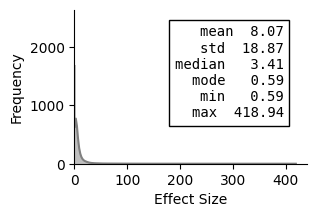

In [16]:
# Format
df = effect_size_df.mean(axis=1).reset_index()
df.columns = ['Gene', 'Effect Size']

# Plot
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
sns.histplot(data=df, x='Effect Size', kde=True, color='gray', edgecolor='none', ax=ax)
sns.despine(ax=ax)
ax.set_xlim(left=0)
ax.set_ylabel('Frequency')

# Compute statistics
stat_mean = df["Effect Size"].mean()
stat_std = df["Effect Size"].std()
stat_median = df["Effect Size"].median()
unique, counts = np.unique(df["Effect Size"], return_counts=True)
stat_mode = unique[np.argmax(counts)]
stat_min = df["Effect Size"].min()
stat_max = df["Effect Size"].max()

# Annotate
ax.text(
    .9, .9,
    f'mean  {stat_mean:.2f}'
    f'\nstd  {stat_std:.2f}'
    f'\nmedian  {stat_median: >5.2f}'
    f'\nmode  {stat_mode: >5.2f}'
    f'\nmin  {stat_min: >5.2f}'
    f'\nmax  {stat_max: >5.2f}',
    fontfamily='monospace',
    ha='right', va='top', transform=ax.transAxes,
    bbox=dict(facecolor='white', edgecolor='black'))

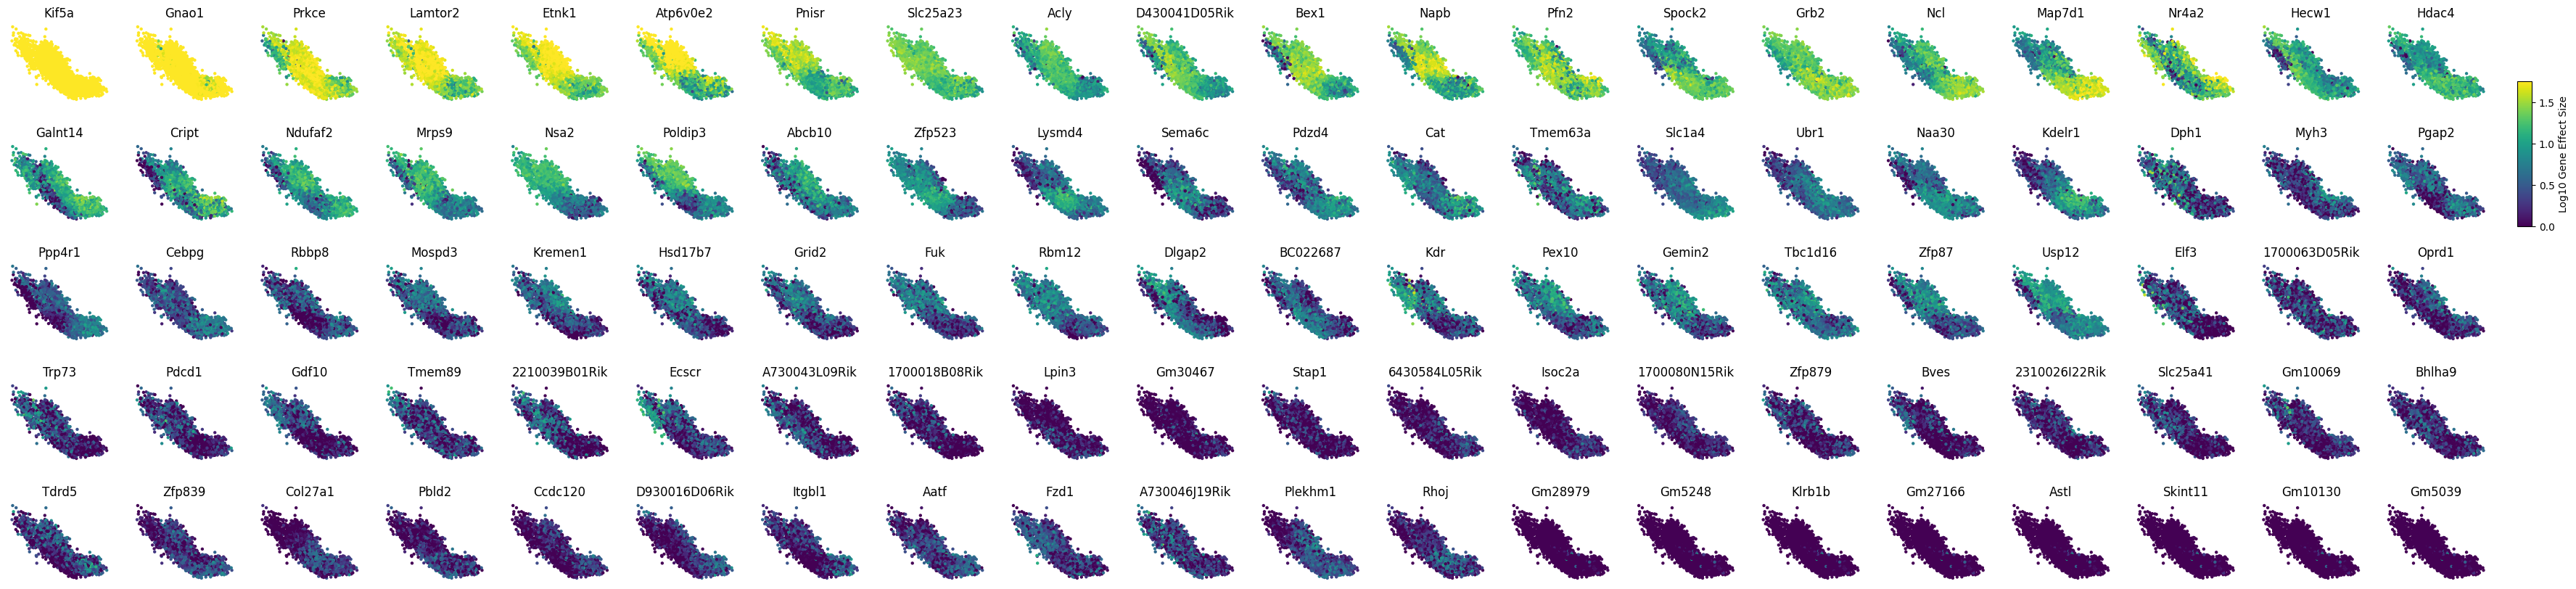

In [17]:
# Choose genes
genes_to_show = perturbed_genes
np.random.seed(42)
genes_to_show = np.random.choice(genes_to_show, 100, replace=False)

# Dendogram Sorting
dist = scipy.spatial.distance.pdist(effect_size_df.loc[genes_to_show])
linkage = scipy.cluster.hierarchy.linkage(dist, method='ward')
ordered_linkage = scipy.cluster.hierarchy.optimal_leaf_ordering(linkage, dist)
ordered_leaves = scipy.cluster.hierarchy.leaves_list(ordered_linkage)
genes_to_show = genes_to_show[ordered_leaves]

# Styling
cmap = sns.color_palette('viridis', as_cmap=True)
vmax = np.quantile(list(effect_sizes.values()), .98)
vmax = np.log10(np.quantile(list(effect_sizes.values()), .98))
norm = mpl.colors.Normalize(vmin=0, vmax=vmax)

# Initialize
fig, axs = plt.subplots(5, np.ceil(len(genes_to_show)/5).astype(int), figsize=(40, 10), sharex=True, sharey=True)
fig.subplots_adjust(hspace=.5)
fig.subplots_adjust(right=.98)
axs = axs.flatten()
for ax, gene in zip(axs, genes_to_show):
    df = pd.DataFrame(index=effect_size_df.columns)
    df[['x', 'y']] = raw_coords
    df['Effect Size'] = effect_sizes[gene]
    df['Log10 Effect Size'] = np.log10(effect_sizes[gene])
    sns.scatterplot(df, x='x', y='y', s=10, edgecolor='none', hue='Log10 Effect Size', palette=cmap, hue_norm=norm, ax=ax, legend=False)
    sns.despine(bottom=True, left=True, ax=ax)
    # Remove grid
    ax.grid(False)
    ax.set(xticks=[], yticks=[], xlabel=None, ylabel=None)
    ax.set_title(gene)

# Add colorbar
ax_cbar = fig.add_axes([0.99, 0.6, 0.005, 0.2])
fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
             cax=ax_cbar, label='Log10 Gene Effect Size');